In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/akash2sharma/tiny-imagenet")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: himasaikirangutti
Your Kaggle Key: ··········


100%|██████████| 474M/474M [00:23<00:00, 21.0MB/s]


In [ ]:
import os

In [ ]:
os.mkdir('/content/image_dataset')

In [ ]:
import shutil

In [ ]:
src = '/content/tiny-imagenet/tiny-imagenet-200/train'
des = '/content/image_dataset/train'
shutil.copytree(src, des)

'/content/image_dataset/train'

In [ ]:
src = '/content/tiny-imagenet/tiny-imagenet-200/test'
des = '/content/image_dataset/test'
shutil.copytree(src, des)

'/content/image_dataset/test'

In [ ]:
shutil.rmtree("/content/tiny-imagenet")

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.layers import *
from keras import backend
from keras.models import Model
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import array_to_img

In [ ]:
DATA_DIR = '/content/image_dataset'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
IMAGE_SHAPE = (64, 64)

In [ ]:
def load_sample_dataset(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """

    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = load_img(os.path.join(c_dir, img_name_i))
            x = img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)

    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = load_img(os.path.join(test_dir, img_name_i))
        x = img_to_array(img_i)
        X_test.append(x)
    random.shuffle(X_test)
    
    return np.array(X_train), np.array(X_test)

In [ ]:
X_train, X_test = load_sample_dataset()

In [ ]:
len(X_train)

2000

In [ ]:
len(X_test)

500

In [ ]:
X_train[0]

array([[[ 34.,  38.,  21.],
        [ 31.,  35.,  18.],
        [ 22.,  26.,  11.],
        ...,
        [  0.,   1.,   0.],
        [  0.,   1.,   0.],
        [  0.,   1.,   0.]],

       [[ 26.,  30.,  13.],
        [ 27.,  31.,  14.],
        [ 24.,  28.,  13.],
        ...,
        [  1.,   3.,   0.],
        [  0.,   2.,   0.],
        [  0.,   1.,   0.]],

       [[ 16.,  20.,   3.],
        [ 20.,  24.,   7.],
        [ 22.,  26.,  11.],
        ...,
        [  2.,   4.,   1.],
        [  1.,   3.,   0.],
        [  0.,   1.,   0.]],

       ...,

       [[130., 145., 148.],
        [129., 144., 147.],
        [129., 144., 147.],
        ...,
        [100., 120., 119.],
        [ 99., 121., 119.],
        [ 99., 121., 119.]],

       [[133., 148., 151.],
        [134., 149., 152.],
        [134., 149., 152.],
        ...,
        [101., 123., 120.],
        [ 99., 121., 118.],
        [ 99., 121., 118.]],

       [[130., 145., 150.],
        [130., 145., 150.],
        [131., 1

In [ ]:
X_train.shape

(2000, 64, 64, 3)

In [ ]:
X_test.shape

(500, 64, 64, 3)

No. of training samples : 2000       
No. of test samples: 500                      
training data shape : 64x64x3                        
test data shape : 64x64x3

<h1><em>Dividing the training set into secret image set and cover image set<em><h1>

In [ ]:
X_train = X_train/255

In [ ]:
random.shuffle(X_train)

In [ ]:
input_S = X_train[0:len(X_train)//2]
input_C = X_train[len(X_train)//2:]

In [ ]:
random.shuffle(input_S)
random.shuffle(input_C)

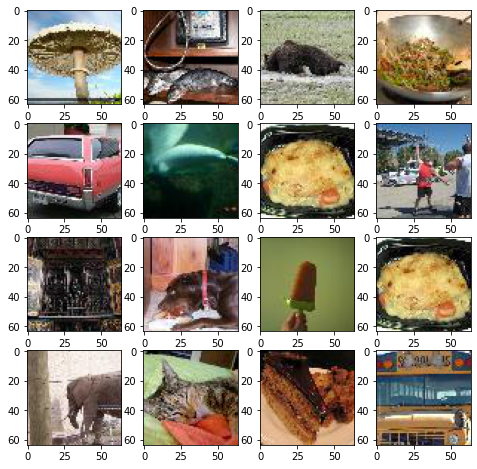

In [ ]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(len(X_train))
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [ ]:
import keras.backend as K

In [ ]:
# Variable used to weight the losses of the secret and cover images
beta = 1.0

In [ ]:
# Loss for reveal network
def rev_loss(s_true, s_pred):
    print(s_true.shape, s_pred.shape)
    return beta * K.sum(K.square(s_true - s_pred))

In [ ]:
# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    print(y_true.shape, y_pred.shape)
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]

    #s_loss = rev_loss(s_true, s_pred)
    s_loss = beta * K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss

In [ ]:
# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x1 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_1')(input_S)
    x2 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_1')(input_S)
    x3 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_1')(input_S)
    y1 = concatenate([x1, x2, x3])
    
    x1 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_1')(y1)
    x2 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_1')(y1)
    x3 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_1')(y1)
    y2 = concatenate([x1, x2, x3])
    
    x = concatenate([input_C, y2])
    
    # Hiding network
    x1 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x2 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x3 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x1, x2, x3])
    
    x1 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x2 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x3 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x1, x2, x3])
    
    x1 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x2 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x3 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x1, x2, x3])
    
    x1 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x2 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x3 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x1, x2, x3])
    
    x1 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x2 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x3 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x1, x2, x3])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')


In [ ]:
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise1')(reveal_input)
    
    x1 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_1')(input_with_noise)
    x2 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_1')(input_with_noise)
    x3 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_1')(input_with_noise)
    x = concatenate([x1, x2, x3])
    
    x1 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_1')(x)
    x2 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_1')(x)
    x3 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_1')(x)
    x = concatenate([x1, x2, x3])
    
    x1 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_1')(x)
    x2 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_1')(x)
    x3 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_1')(x)
    x = concatenate([x1, x2, x3])
    
    x1 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_1')(x)
    x2 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_1')(x)
    x3 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_1')(x)
    x = concatenate([x1, x2, x3])
    
    x1 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_1')(x)
    x2 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_1')(x)
    x3 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_1')(x)
    x = concatenate([x1, x2, x3])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    return Model(inputs=reveal_input, outputs=output_Sprime)

In [ ]:
# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C], outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
 
    return encoder, decoder, autoencoder

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
from tqdm import *
import scipy.misc

BATCH_SIZE = 256
m = input_S.shape[0]
loss_history = []

for epoch in range(50):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []

    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C], y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime, y=batch_S))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    
    autoencoder_model.save_weights('models/model3_'+str(epoch+6))
    
    loss_history.append(np.mean(ae_loss))

  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 8s 35ms/step
(256, 64, 64, 6) (256, 64, 64, 6)
(256, 64, 64, 6) (256, 64, 64, 6)
(256, 64, 64, 3) (256, 64, 64, 3)
(256, 64, 64, 3) (256, 64, 64, 3)


Epoch 1 | Batch:   0 of 1000. Loss AE 1559885.75 | Loss Rev  812525.56:  25%|██▌       | 1/4 [00:25<01:16, 25.58s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 1 | Batch: 256 of 1000. Loss AE 1354869.62 | Loss Rev  523702.94:  50%|█████     | 2/4 [00:28<00:24, 12.28s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 1 | Batch: 512 of 1000. Loss AE 1126497.54 | Loss Rev  455727.21:  75%|███████▌  | 3/4 [00:31<00:08,  8.02s/it]

8/8 [==============================] - 1s 73ms/step
(None, 64, 64, 6) (None, 64, 64, 6)
(None, 64, 64, 3) (None, 64, 64, 3)


Epoch 1 | Batch: 768 of 1000. Loss AE 1150069.38 | Loss Rev  569596.56: 100%|██████████| 4/4 [00:42<00:00, 10.70s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 39ms/step


Epoch 2 | Batch:   0 of 1000. Loss AE  789452.88 | Loss Rev  361988.50:  25%|██▌       | 1/4 [00:02<00:08,  2.95s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 2 | Batch: 256 of 1000. Loss AE  947028.44 | Loss Rev  469468.94:  50%|█████     | 2/4 [00:05<00:05,  2.96s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 2 | Batch: 512 of 1000. Loss AE  967836.96 | Loss Rev  494246.94:  75%|███████▌  | 3/4 [00:08<00:02,  2.97s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 2 | Batch: 768 of 1000. Loss AE  918285.98 | Loss Rev  481156.94: 100%|██████████| 4/4 [00:12<00:00,  3.15s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 39ms/step


Epoch 3 | Batch:   0 of 1000. Loss AE  508269.81 | Loss Rev  295112.12:  25%|██▌       | 1/4 [00:02<00:08,  2.96s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 3 | Batch: 256 of 1000. Loss AE  758028.97 | Loss Rev  524004.84:  50%|█████     | 2/4 [00:05<00:05,  2.95s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 3 | Batch: 512 of 1000. Loss AE  650662.04 | Loss Rev  438634.04:  75%|███████▌  | 3/4 [00:08<00:02,  2.96s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 3 | Batch: 768 of 1000. Loss AE  604405.36 | Loss Rev  403868.41: 100%|██████████| 4/4 [00:11<00:00,  2.86s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 39ms/step


Epoch 4 | Batch:   0 of 1000. Loss AE  612201.50 | Loss Rev  410270.09:  25%|██▌       | 1/4 [00:02<00:08,  2.95s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 4 | Batch: 256 of 1000. Loss AE  621082.34 | Loss Rev  415796.17:  50%|█████     | 2/4 [00:07<00:07,  3.69s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 4 | Batch: 512 of 1000. Loss AE  604740.56 | Loss Rev  402802.51:  75%|███████▌  | 3/4 [00:10<00:03,  3.49s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 4 | Batch: 768 of 1000. Loss AE  563245.88 | Loss Rev  366799.91: 100%|██████████| 4/4 [00:13<00:00,  3.25s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 39ms/step


Epoch 5 | Batch:   0 of 1000. Loss AE  506806.31 | Loss Rev  234854.31:  25%|██▌       | 1/4 [00:03<00:09,  3.27s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 5 | Batch: 256 of 1000. Loss AE  509347.89 | Loss Rev  236364.23:  50%|█████     | 2/4 [00:06<00:06,  3.10s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 5 | Batch: 512 of 1000. Loss AE  473842.94 | Loss Rev  225502.56:  75%|███████▌  | 3/4 [00:09<00:03,  3.04s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 5 | Batch: 768 of 1000. Loss AE  440608.77 | Loss Rev  217215.96: 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 39ms/step


Epoch 6 | Batch:   0 of 1000. Loss AE  384951.00 | Loss Rev  224242.22:  25%|██▌       | 1/4 [00:02<00:08,  3.00s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 6 | Batch: 256 of 1000. Loss AE  386422.28 | Loss Rev  223510.23:  50%|█████     | 2/4 [00:05<00:05,  2.99s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 6 | Batch: 512 of 1000. Loss AE  392631.84 | Loss Rev  227620.95:  75%|███████▌  | 3/4 [00:08<00:03,  3.00s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 6 | Batch: 768 of 1000. Loss AE  384486.47 | Loss Rev  224415.77: 100%|██████████| 4/4 [00:11<00:00,  2.91s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 39ms/step


Epoch 7 | Batch:   0 of 1000. Loss AE  382986.28 | Loss Rev  226294.44:  25%|██▌       | 1/4 [00:03<00:09,  3.03s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 7 | Batch: 256 of 1000. Loss AE  380184.70 | Loss Rev  220850.11:  50%|█████     | 2/4 [00:06<00:06,  3.21s/it]

8/8 [==============================] - 0s 39ms/step


Epoch 7 | Batch: 512 of 1000. Loss AE  366034.36 | Loss Rev  211251.38:  75%|███████▌  | 3/4 [00:10<00:03,  3.46s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 7 | Batch: 768 of 1000. Loss AE  349012.79 | Loss Rev  201587.04: 100%|██████████| 4/4 [00:13<00:00,  3.28s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 8 | Batch:   0 of 1000. Loss AE  308724.62 | Loss Rev  166854.80:  25%|██▌       | 1/4 [00:03<00:09,  3.06s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 8 | Batch: 256 of 1000. Loss AE  306204.62 | Loss Rev  164507.12:  50%|█████     | 2/4 [00:06<00:06,  3.08s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 8 | Batch: 512 of 1000. Loss AE  296713.91 | Loss Rev  156663.43:  75%|███████▌  | 3/4 [00:09<00:03,  3.26s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 8 | Batch: 768 of 1000. Loss AE  293031.59 | Loss Rev  158282.44: 100%|██████████| 4/4 [00:13<00:00,  3.35s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 9 | Batch:   0 of 1000. Loss AE  240983.75 | Loss Rev  114596.94:  25%|██▌       | 1/4 [00:03<00:09,  3.10s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 9 | Batch: 256 of 1000. Loss AE  286716.94 | Loss Rev  155189.92:  50%|█████     | 2/4 [00:06<00:06,  3.27s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 9 | Batch: 512 of 1000. Loss AE  331956.28 | Loss Rev  203391.54:  75%|███████▌  | 3/4 [00:09<00:03,  3.21s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 9 | Batch: 768 of 1000. Loss AE  362986.93 | Loss Rev  238082.30: 100%|██████████| 4/4 [00:12<00:00,  3.17s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 10 | Batch:   0 of 1000. Loss AE  455582.31 | Loss Rev  342017.47:  25%|██▌       | 1/4 [00:03<00:10,  3.42s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 10 | Batch: 256 of 1000. Loss AE  403914.06 | Loss Rev  290066.67:  50%|█████     | 2/4 [00:06<00:06,  3.42s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 10 | Batch: 512 of 1000. Loss AE  362844.75 | Loss Rev  240726.80:  75%|███████▌  | 3/4 [00:09<00:03,  3.28s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 10 | Batch: 768 of 1000. Loss AE  368072.27 | Loss Rev  248778.70: 100%|██████████| 4/4 [00:12<00:00,  3.18s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 11 | Batch:   0 of 1000. Loss AE  247251.17 | Loss Rev  140666.31:  25%|██▌       | 1/4 [00:03<00:09,  3.11s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 11 | Batch: 256 of 1000. Loss AE  286094.43 | Loss Rev  166235.98:  50%|█████     | 2/4 [00:07<00:07,  3.76s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 11 | Batch: 512 of 1000. Loss AE  311467.64 | Loss Rev  183069.38:  75%|███████▌  | 3/4 [00:10<00:03,  3.46s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 11 | Batch: 768 of 1000. Loss AE  299652.70 | Loss Rev  170813.94: 100%|██████████| 4/4 [00:13<00:00,  3.28s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 12 | Batch:   0 of 1000. Loss AE  242841.03 | Loss Rev  112262.27:  25%|██▌       | 1/4 [00:03<00:09,  3.08s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 12 | Batch: 256 of 1000. Loss AE  272411.88 | Loss Rev  141640.11:  50%|█████     | 2/4 [00:06<00:06,  3.08s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 12 | Batch: 512 of 1000. Loss AE  260429.94 | Loss Rev  135117.35:  75%|███████▌  | 3/4 [00:09<00:03,  3.08s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 12 | Batch: 768 of 1000. Loss AE  250711.75 | Loss Rev  131399.25: 100%|██████████| 4/4 [00:13<00:00,  3.26s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 13 | Batch:   0 of 1000. Loss AE  275559.69 | Loss Rev  161425.47:  25%|██▌       | 1/4 [00:03<00:10,  3.37s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 13 | Batch: 256 of 1000. Loss AE  259352.96 | Loss Rev  148053.82:  50%|█████     | 2/4 [00:06<00:06,  3.19s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 13 | Batch: 512 of 1000. Loss AE  244558.01 | Loss Rev  136711.28:  75%|███████▌  | 3/4 [00:09<00:03,  3.13s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 13 | Batch: 768 of 1000. Loss AE  237857.16 | Loss Rev  132703.63: 100%|██████████| 4/4 [00:13<00:00,  3.40s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 14 | Batch:   0 of 1000. Loss AE  211656.58 | Loss Rev  108185.28:  25%|██▌       | 1/4 [00:03<00:10,  3.36s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 14 | Batch: 256 of 1000. Loss AE  216791.15 | Loss Rev  110725.92:  50%|█████     | 2/4 [00:06<00:06,  3.19s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 14 | Batch: 512 of 1000. Loss AE  219891.21 | Loss Rev  115207.69:  75%|███████▌  | 3/4 [00:09<00:03,  3.28s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 14 | Batch: 768 of 1000. Loss AE  211831.30 | Loss Rev  110828.61: 100%|██████████| 4/4 [00:12<00:00,  3.21s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 15 | Batch:   0 of 1000. Loss AE  203304.94 | Loss Rev  112346.37:  25%|██▌       | 1/4 [00:03<00:10,  3.37s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 15 | Batch: 256 of 1000. Loss AE  202034.79 | Loss Rev  109554.30:  50%|█████     | 2/4 [00:06<00:06,  3.21s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 15 | Batch: 512 of 1000. Loss AE  199387.31 | Loss Rev  106828.93:  75%|███████▌  | 3/4 [00:09<00:03,  3.28s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 15 | Batch: 768 of 1000. Loss AE  194574.14 | Loss Rev  104639.77: 100%|██████████| 4/4 [00:13<00:00,  3.40s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 16 | Batch:   0 of 1000. Loss AE  176301.08 | Loss Rev   93372.44:  25%|██▌       | 1/4 [00:03<00:09,  3.09s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 16 | Batch: 256 of 1000. Loss AE  180944.49 | Loss Rev   94393.48:  50%|█████     | 2/4 [00:06<00:06,  3.09s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 16 | Batch: 512 of 1000. Loss AE  182162.68 | Loss Rev   94117.82:  75%|███████▌  | 3/4 [00:09<00:03,  3.28s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 16 | Batch: 768 of 1000. Loss AE  177078.55 | Loss Rev   91861.48: 100%|██████████| 4/4 [00:12<00:00,  3.11s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 17 | Batch:   0 of 1000. Loss AE  173335.92 | Loss Rev   87395.61:  25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 17 | Batch: 256 of 1000. Loss AE  173810.52 | Loss Rev   88872.71:  50%|█████     | 2/4 [00:06<00:06,  3.22s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 17 | Batch: 512 of 1000. Loss AE  172435.35 | Loss Rev   87654.01:  75%|███████▌  | 3/4 [00:09<00:03,  3.17s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 17 | Batch: 768 of 1000. Loss AE  166690.73 | Loss Rev   85719.71: 100%|██████████| 4/4 [00:12<00:00,  3.09s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 18 | Batch:   0 of 1000. Loss AE  163653.41 | Loss Rev   83482.48:  25%|██▌       | 1/4 [00:03<00:10,  3.41s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 18 | Batch: 256 of 1000. Loss AE  166540.17 | Loss Rev   84297.97:  50%|█████     | 2/4 [00:06<00:06,  3.22s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 18 | Batch: 512 of 1000. Loss AE  163611.25 | Loss Rev   83649.72:  75%|███████▌  | 3/4 [00:09<00:03,  3.16s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 18 | Batch: 768 of 1000. Loss AE  157879.89 | Loss Rev   81341.94: 100%|██████████| 4/4 [00:12<00:00,  3.16s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 19 | Batch:   0 of 1000. Loss AE  157980.66 | Loss Rev   82218.95:  25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 19 | Batch: 256 of 1000. Loss AE  154757.34 | Loss Rev   79233.32:  50%|█████     | 2/4 [00:06<00:06,  3.22s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 19 | Batch: 512 of 1000. Loss AE  154095.93 | Loss Rev   78405.17:  75%|███████▌  | 3/4 [00:09<00:03,  3.29s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 19 | Batch: 768 of 1000. Loss AE  151855.88 | Loss Rev   77560.24: 100%|██████████| 4/4 [00:12<00:00,  3.14s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 20 | Batch:   0 of 1000. Loss AE  151654.11 | Loss Rev   76152.55:  25%|██▌       | 1/4 [00:03<00:10,  3.48s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 20 | Batch: 256 of 1000. Loss AE  151187.34 | Loss Rev   76477.72:  50%|█████     | 2/4 [00:07<00:07,  3.66s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 20 | Batch: 512 of 1000. Loss AE  150002.48 | Loss Rev   76103.50:  75%|███████▌  | 3/4 [00:11<00:03,  3.72s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 20 | Batch: 768 of 1000. Loss AE  148022.32 | Loss Rev   75999.42: 100%|██████████| 4/4 [00:13<00:00,  3.44s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 21 | Batch:   0 of 1000. Loss AE  150767.95 | Loss Rev   78438.20:  25%|██▌       | 1/4 [00:03<00:11,  3.79s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 21 | Batch: 256 of 1000. Loss AE  149313.78 | Loss Rev   78208.39:  50%|█████     | 2/4 [00:07<00:07,  3.54s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 21 | Batch: 512 of 1000. Loss AE  148388.59 | Loss Rev   76147.21:  75%|███████▌  | 3/4 [00:10<00:03,  3.34s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 21 | Batch: 768 of 1000. Loss AE  143505.19 | Loss Rev   74172.81: 100%|██████████| 4/4 [00:12<00:00,  3.25s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 22 | Batch:   0 of 1000. Loss AE  145291.28 | Loss Rev   74552.11:  25%|██▌       | 1/4 [00:03<00:10,  3.38s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 22 | Batch: 256 of 1000. Loss AE  143371.34 | Loss Rev   74786.40:  50%|█████     | 2/4 [00:06<00:06,  3.21s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 22 | Batch: 512 of 1000. Loss AE  148708.59 | Loss Rev   79765.71:  75%|███████▌  | 3/4 [00:09<00:03,  3.17s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 22 | Batch: 768 of 1000. Loss AE  147365.05 | Loss Rev   80528.48: 100%|██████████| 4/4 [00:12<00:00,  3.08s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 23 | Batch:   0 of 1000. Loss AE  159937.77 | Loss Rev   92510.53:  25%|██▌       | 1/4 [00:03<00:09,  3.10s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 23 | Batch: 256 of 1000. Loss AE  149673.96 | Loss Rev   81397.91:  50%|█████     | 2/4 [00:06<00:06,  3.11s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 23 | Batch: 512 of 1000. Loss AE  152034.63 | Loss Rev   84295.89:  75%|███████▌  | 3/4 [00:09<00:03,  3.11s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 23 | Batch: 768 of 1000. Loss AE  154838.07 | Loss Rev   89061.66: 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 24 | Batch:   0 of 1000. Loss AE  139348.75 | Loss Rev   71490.77:  25%|██▌       | 1/4 [00:03<00:09,  3.13s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 24 | Batch: 256 of 1000. Loss AE  179576.06 | Loss Rev  110439.77:  50%|█████     | 2/4 [00:06<00:06,  3.30s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 24 | Batch: 512 of 1000. Loss AE  199808.75 | Loss Rev  131005.18:  75%|███████▌  | 3/4 [00:09<00:03,  3.22s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 24 | Batch: 768 of 1000. Loss AE  201682.98 | Loss Rev  135683.23: 100%|██████████| 4/4 [00:13<00:00,  3.36s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 25 | Batch:   0 of 1000. Loss AE  157706.53 | Loss Rev   91166.61:  25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 25 | Batch: 256 of 1000. Loss AE  198474.23 | Loss Rev  128213.90:  50%|█████     | 2/4 [00:06<00:06,  3.22s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 25 | Batch: 512 of 1000. Loss AE  186673.19 | Loss Rev  115691.53:  75%|███████▌  | 3/4 [00:09<00:03,  3.17s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 25 | Batch: 768 of 1000. Loss AE  191596.20 | Loss Rev  120876.79: 100%|██████████| 4/4 [00:12<00:00,  3.08s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 26 | Batch:   0 of 1000. Loss AE  175632.91 | Loss Rev   99365.39:  25%|██▌       | 1/4 [00:03<00:09,  3.10s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 26 | Batch: 256 of 1000. Loss AE  179150.69 | Loss Rev  101290.43:  50%|█████     | 2/4 [00:06<00:06,  3.28s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 26 | Batch: 512 of 1000. Loss AE  174853.41 | Loss Rev   97697.75:  75%|███████▌  | 3/4 [00:09<00:03,  3.20s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 26 | Batch: 768 of 1000. Loss AE  166137.26 | Loss Rev   90739.51: 100%|██████████| 4/4 [00:12<00:00,  3.09s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 27 | Batch:   0 of 1000. Loss AE  181218.00 | Loss Rev  106036.45:  25%|██▌       | 1/4 [00:03<00:09,  3.10s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 27 | Batch: 256 of 1000. Loss AE  169655.05 | Loss Rev   96224.86:  50%|█████     | 2/4 [00:07<00:07,  3.58s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 27 | Batch: 512 of 1000. Loss AE  164749.40 | Loss Rev   91706.78:  75%|███████▌  | 3/4 [00:10<00:03,  3.49s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 27 | Batch: 768 of 1000. Loss AE  162507.73 | Loss Rev   89932.27: 100%|██████████| 4/4 [00:13<00:00,  3.28s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 28 | Batch:   0 of 1000. Loss AE  150655.03 | Loss Rev   72356.09:  25%|██▌       | 1/4 [00:03<00:09,  3.08s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 28 | Batch: 256 of 1000. Loss AE  156621.67 | Loss Rev   78959.96:  50%|█████     | 2/4 [00:06<00:06,  3.08s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 28 | Batch: 512 of 1000. Loss AE  152776.40 | Loss Rev   76461.68:  75%|███████▌  | 3/4 [00:09<00:03,  3.22s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 28 | Batch: 768 of 1000. Loss AE  147023.77 | Loss Rev   73181.94: 100%|██████████| 4/4 [00:12<00:00,  3.06s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 29 | Batch:   0 of 1000. Loss AE  154929.84 | Loss Rev   78228.31:  25%|██▌       | 1/4 [00:03<00:09,  3.09s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 29 | Batch: 256 of 1000. Loss AE  148319.62 | Loss Rev   73385.23:  50%|█████     | 2/4 [00:07<00:07,  3.82s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 29 | Batch: 512 of 1000. Loss AE  147877.12 | Loss Rev   74813.61:  75%|███████▌  | 3/4 [00:10<00:03,  3.49s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 29 | Batch: 768 of 1000. Loss AE  141369.38 | Loss Rev   71886.90: 100%|██████████| 4/4 [00:13<00:00,  3.31s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 30 | Batch:   0 of 1000. Loss AE  141891.36 | Loss Rev   72751.72:  25%|██▌       | 1/4 [00:03<00:09,  3.09s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 30 | Batch: 256 of 1000. Loss AE  139477.05 | Loss Rev   71604.07:  50%|█████     | 2/4 [00:06<00:06,  3.26s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 30 | Batch: 512 of 1000. Loss AE  138014.51 | Loss Rev   70276.44:  75%|███████▌  | 3/4 [00:09<00:03,  3.18s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 30 | Batch: 768 of 1000. Loss AE  134466.58 | Loss Rev   69568.49: 100%|██████████| 4/4 [00:12<00:00,  3.07s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 31 | Batch:   0 of 1000. Loss AE  130362.34 | Loss Rev   66567.02:  25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 31 | Batch: 256 of 1000. Loss AE  133302.31 | Loss Rev   68258.39:  50%|█████     | 2/4 [00:06<00:06,  3.22s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 31 | Batch: 512 of 1000. Loss AE  131983.51 | Loss Rev   67971.55:  75%|███████▌  | 3/4 [00:09<00:03,  3.17s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 31 | Batch: 768 of 1000. Loss AE  127057.60 | Loss Rev   65961.83: 100%|██████████| 4/4 [00:12<00:00,  3.16s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 32 | Batch:   0 of 1000. Loss AE  116935.31 | Loss Rev   61163.95:  25%|██▌       | 1/4 [00:03<00:10,  3.38s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 32 | Batch: 256 of 1000. Loss AE  123841.65 | Loss Rev   62580.92:  50%|█████     | 2/4 [00:06<00:06,  3.22s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 32 | Batch: 512 of 1000. Loss AE  125299.47 | Loss Rev   64449.79:  75%|███████▌  | 3/4 [00:09<00:03,  3.30s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 32 | Batch: 768 of 1000. Loss AE  122015.18 | Loss Rev   63556.43: 100%|██████████| 4/4 [00:12<00:00,  3.15s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 33 | Batch:   0 of 1000. Loss AE  122847.30 | Loss Rev   65449.48:  25%|██▌       | 1/4 [00:03<00:09,  3.11s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 33 | Batch: 256 of 1000. Loss AE  121743.29 | Loss Rev   64975.98:  50%|█████     | 2/4 [00:06<00:06,  3.11s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 33 | Batch: 512 of 1000. Loss AE  121582.35 | Loss Rev   64080.02:  75%|███████▌  | 3/4 [00:09<00:03,  3.11s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 33 | Batch: 768 of 1000. Loss AE  118330.88 | Loss Rev   62323.83: 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 34 | Batch:   0 of 1000. Loss AE  118226.48 | Loss Rev   61653.41:  25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 34 | Batch: 256 of 1000. Loss AE  119762.79 | Loss Rev   64232.28:  50%|█████     | 2/4 [00:07<00:07,  3.71s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 34 | Batch: 512 of 1000. Loss AE  118711.15 | Loss Rev   64024.35:  75%|███████▌  | 3/4 [00:10<00:03,  3.57s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 34 | Batch: 768 of 1000. Loss AE  117222.57 | Loss Rev   63473.69: 100%|██████████| 4/4 [00:13<00:00,  3.36s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 35 | Batch:   0 of 1000. Loss AE  117024.70 | Loss Rev   63555.02:  25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 35 | Batch: 256 of 1000. Loss AE  116375.47 | Loss Rev   63539.39:  50%|█████     | 2/4 [00:06<00:06,  3.39s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 35 | Batch: 512 of 1000. Loss AE  115931.71 | Loss Rev   62547.74:  75%|███████▌  | 3/4 [00:10<00:03,  3.39s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 35 | Batch: 768 of 1000. Loss AE  114021.40 | Loss Rev   61605.26: 100%|██████████| 4/4 [00:12<00:00,  3.22s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 36 | Batch:   0 of 1000. Loss AE  117686.98 | Loss Rev   64950.34:  25%|██▌       | 1/4 [00:03<00:09,  3.12s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 36 | Batch: 256 of 1000. Loss AE  118468.98 | Loss Rev   65722.47:  50%|█████     | 2/4 [00:06<00:06,  3.28s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 36 | Batch: 512 of 1000. Loss AE  117883.70 | Loss Rev   66001.98:  75%|███████▌  | 3/4 [00:09<00:03,  3.20s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 36 | Batch: 768 of 1000. Loss AE  113865.25 | Loss Rev   63238.48: 100%|██████████| 4/4 [00:12<00:00,  3.16s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 37 | Batch:   0 of 1000. Loss AE  107776.00 | Loss Rev   56957.96:  25%|██▌       | 1/4 [00:03<00:10,  3.38s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 37 | Batch: 256 of 1000. Loss AE  109347.24 | Loss Rev   59964.45:  50%|█████     | 2/4 [00:06<00:06,  3.22s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 37 | Batch: 512 of 1000. Loss AE  110739.88 | Loss Rev   60369.47:  75%|███████▌  | 3/4 [00:09<00:03,  3.17s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 37 | Batch: 768 of 1000. Loss AE  109322.68 | Loss Rev   59648.05: 100%|██████████| 4/4 [00:12<00:00,  3.09s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 38 | Batch:   0 of 1000. Loss AE  108898.97 | Loss Rev   60709.54:  25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 38 | Batch: 256 of 1000. Loss AE  111358.20 | Loss Rev   61858.52:  50%|█████     | 2/4 [00:06<00:06,  3.22s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 38 | Batch: 512 of 1000. Loss AE  110918.15 | Loss Rev   61690.65:  75%|███████▌  | 3/4 [00:09<00:03,  3.30s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 38 | Batch: 768 of 1000. Loss AE  109004.12 | Loss Rev   60593.75: 100%|██████████| 4/4 [00:12<00:00,  3.16s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 39 | Batch:   0 of 1000. Loss AE  119556.23 | Loss Rev   66595.55:  25%|██▌       | 1/4 [00:03<00:09,  3.12s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 39 | Batch: 256 of 1000. Loss AE  115890.44 | Loss Rev   66728.94:  50%|█████     | 2/4 [00:06<00:06,  3.29s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 39 | Batch: 512 of 1000. Loss AE  116638.92 | Loss Rev   67832.46:  75%|███████▌  | 3/4 [00:09<00:03,  3.21s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 39 | Batch: 768 of 1000. Loss AE  116496.67 | Loss Rev   69112.28: 100%|██████████| 4/4 [00:12<00:00,  3.18s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 40 | Batch:   0 of 1000. Loss AE  104490.53 | Loss Rev   56162.27:  25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 40 | Batch: 256 of 1000. Loss AE  110281.65 | Loss Rev   63232.49:  50%|█████     | 2/4 [00:06<00:06,  3.40s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 40 | Batch: 512 of 1000. Loss AE  119830.24 | Loss Rev   72161.18:  75%|███████▌  | 3/4 [00:09<00:03,  3.27s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 40 | Batch: 768 of 1000. Loss AE  115964.23 | Loss Rev   68531.74: 100%|██████████| 4/4 [00:12<00:00,  3.17s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 41 | Batch:   0 of 1000. Loss AE  110890.17 | Loss Rev   63544.59:  25%|██▌       | 1/4 [00:03<00:09,  3.11s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 41 | Batch: 256 of 1000. Loss AE  118585.94 | Loss Rev   69746.62:  50%|█████     | 2/4 [00:06<00:06,  3.11s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 41 | Batch: 512 of 1000. Loss AE  112315.88 | Loss Rev   63698.51:  75%|███████▌  | 3/4 [00:09<00:03,  3.11s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 41 | Batch: 768 of 1000. Loss AE  110218.29 | Loss Rev   62683.37: 100%|██████████| 4/4 [00:12<00:00,  3.10s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 40ms/step


Epoch 42 | Batch:   0 of 1000. Loss AE  118198.80 | Loss Rev   68595.64:  25%|██▌       | 1/4 [00:03<00:09,  3.11s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 42 | Batch: 256 of 1000. Loss AE  110071.58 | Loss Rev   61989.77:  50%|█████     | 2/4 [00:06<00:06,  3.11s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 42 | Batch: 512 of 1000. Loss AE  110928.76 | Loss Rev   63030.92:  75%|███████▌  | 3/4 [00:09<00:03,  3.11s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 42 | Batch: 768 of 1000. Loss AE  109397.78 | Loss Rev   62553.91: 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 43 | Batch:   0 of 1000. Loss AE  111261.77 | Loss Rev   61853.39:  25%|██▌       | 1/4 [00:03<00:09,  3.11s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 43 | Batch: 256 of 1000. Loss AE  117388.70 | Loss Rev   67966.84:  50%|█████     | 2/4 [00:06<00:06,  3.12s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 43 | Batch: 512 of 1000. Loss AE  113592.31 | Loss Rev   65002.97:  75%|███████▌  | 3/4 [00:09<00:03,  3.25s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 43 | Batch: 768 of 1000. Loss AE  109166.97 | Loss Rev   62567.82: 100%|██████████| 4/4 [00:12<00:00,  3.09s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 44 | Batch:   0 of 1000. Loss AE  112681.08 | Loss Rev   65269.08:  25%|██▌       | 1/4 [00:03<00:09,  3.12s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 44 | Batch: 256 of 1000. Loss AE  107654.75 | Loss Rev   59948.96:  50%|█████     | 2/4 [00:06<00:06,  3.12s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 44 | Batch: 512 of 1000. Loss AE  106321.88 | Loss Rev   59647.26:  75%|███████▌  | 3/4 [00:09<00:03,  3.25s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 44 | Batch: 768 of 1000. Loss AE  102792.98 | Loss Rev   57602.72: 100%|██████████| 4/4 [00:12<00:00,  3.10s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 45 | Batch:   0 of 1000. Loss AE  100397.33 | Loss Rev   54092.55:  25%|██▌       | 1/4 [00:03<00:09,  3.11s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 45 | Batch: 256 of 1000. Loss AE  100354.78 | Loss Rev   54878.81:  50%|█████     | 2/4 [00:06<00:06,  3.29s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 45 | Batch: 512 of 1000. Loss AE  100004.68 | Loss Rev   54962.81:  75%|███████▌  | 3/4 [00:09<00:03,  3.21s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 45 | Batch: 768 of 1000. Loss AE   97401.21 | Loss Rev   53420.88: 100%|██████████| 4/4 [00:12<00:00,  3.23s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 46 | Batch:   0 of 1000. Loss AE   97879.27 | Loss Rev   54829.12:  25%|██▌       | 1/4 [00:03<00:10,  3.50s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 46 | Batch: 256 of 1000. Loss AE  100796.25 | Loss Rev   57875.40:  50%|█████     | 2/4 [00:06<00:06,  3.27s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 46 | Batch: 512 of 1000. Loss AE  100753.11 | Loss Rev   57726.13:  75%|███████▌  | 3/4 [00:09<00:03,  3.20s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 46 | Batch: 768 of 1000. Loss AE   98273.40 | Loss Rev   56108.58: 100%|██████████| 4/4 [00:12<00:00,  3.19s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 47 | Batch:   0 of 1000. Loss AE   92092.31 | Loss Rev   49823.56:  25%|██▌       | 1/4 [00:03<00:10,  3.40s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 47 | Batch: 256 of 1000. Loss AE   93267.03 | Loss Rev   49651.22:  50%|█████     | 2/4 [00:07<00:07,  3.63s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 47 | Batch: 512 of 1000. Loss AE   94358.58 | Loss Rev   51051.87:  75%|███████▌  | 3/4 [00:10<00:03,  3.53s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 47 | Batch: 768 of 1000. Loss AE   93664.80 | Loss Rev   50887.83: 100%|██████████| 4/4 [00:13<00:00,  3.34s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 48 | Batch:   0 of 1000. Loss AE   96325.80 | Loss Rev   52651.49:  25%|██▌       | 1/4 [00:03<00:10,  3.41s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 48 | Batch: 256 of 1000. Loss AE   97229.79 | Loss Rev   53240.81:  50%|█████     | 2/4 [00:06<00:06,  3.47s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 48 | Batch: 512 of 1000. Loss AE   97632.58 | Loss Rev   54612.89:  75%|███████▌  | 3/4 [00:10<00:03,  3.44s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 48 | Batch: 768 of 1000. Loss AE   99616.85 | Loss Rev   57192.33: 100%|██████████| 4/4 [00:13<00:00,  3.27s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 49 | Batch:   0 of 1000. Loss AE  103451.22 | Loss Rev   60718.19:  25%|██▌       | 1/4 [00:03<00:09,  3.12s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 49 | Batch: 256 of 1000. Loss AE   98654.74 | Loss Rev   56804.76:  50%|█████     | 2/4 [00:06<00:07,  3.51s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 49 | Batch: 512 of 1000. Loss AE   99953.44 | Loss Rev   57920.34:  75%|███████▌  | 3/4 [00:10<00:03,  3.33s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 49 | Batch: 768 of 1000. Loss AE  101329.05 | Loss Rev   60045.26: 100%|██████████| 4/4 [00:12<00:00,  3.19s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

8/8 [==============================] - 0s 41ms/step


Epoch 50 | Batch:   0 of 1000. Loss AE   89354.56 | Loss Rev   48177.90:  25%|██▌       | 1/4 [00:03<00:09,  3.12s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 50 | Batch: 256 of 1000. Loss AE   96723.99 | Loss Rev   55304.35:  50%|█████     | 2/4 [00:06<00:06,  3.12s/it]

8/8 [==============================] - 0s 41ms/step


Epoch 50 | Batch: 512 of 1000. Loss AE  107954.62 | Loss Rev   66101.00:  75%|███████▌  | 3/4 [00:09<00:03,  3.12s/it]

8/8 [==============================] - 0s 40ms/step


Epoch 50 | Batch: 768 of 1000. Loss AE  101799.62 | Loss Rev   59753.84: 100%|██████████| 4/4 [00:12<00:00,  3.03s/it]


In [ ]:
BATCH_SIZE = 32
for epoch in range(400):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []

    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C], y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime, y=batch_S))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    
    autoencoder_model.save_weights('models/model_A21_'+str(epoch))
    
    loss_history.append(np.mean(ae_loss))

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Epoch 1 | Batch:   0 of 1000. Loss AE   17725.96 | Loss Rev    9781.45:   3%|▎         | 1/32 [00:01<00:44,  1.43s/it]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch:  32 of 1000. Loss AE   17293.77 | Loss Rev   10616.67:   6%|▋         | 2/32 [00:01<00:25,  1.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch:  64 of 1000. Loss AE   17246.56 | Loss Rev   10545.19:   9%|▉         | 3/32 [00:02<00:19,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch:  96 of 1000. Loss AE   15791.40 | Loss Rev    9490.92:  12%|█▎        | 4/32 [00:02<00:16,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 128 of 1000. Loss AE   15106.25 | Loss Rev    8949.81:  16%|█▌        | 5/32 [00:03<00:14,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 160 of 1000. Loss AE   14716.25 | Loss Rev    8596.04:  19%|█▉        | 6/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 192 of 1000. Loss AE   14391.84 | Loss Rev    8388.29:  22%|██▏       | 7/32 [00:04<00:11,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 224 of 1000. Loss AE   14275.89 | Loss Rev    8310.38:  25%|██▌       | 8/32 [00:04<00:11,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 256 of 1000. Loss AE   14250.71 | Loss Rev    8354.65:  28%|██▊       | 9/32 [00:04<00:10,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 1 | Batch: 288 of 1000. Loss AE   13923.41 | Loss Rev    8130.38:  31%|███▏      | 10/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 320 of 1000. Loss AE   13906.77 | Loss Rev    8041.93:  34%|███▍      | 11/32 [00:05<00:09,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 352 of 1000. Loss AE   13811.58 | Loss Rev    7942.28:  38%|███▊      | 12/32 [00:06<00:09,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 1 | Batch: 384 of 1000. Loss AE   13659.81 | Loss Rev    7808.31:  41%|████      | 13/32 [00:06<00:08,  2.22it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 416 of 1000. Loss AE   13452.80 | Loss Rev    7624.17:  44%|████▍     | 14/32 [00:07<00:08,  2.25it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 448 of 1000. Loss AE   13247.30 | Loss Rev    7475.84:  47%|████▋     | 15/32 [00:07<00:07,  2.27it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 480 of 1000. Loss AE   13140.15 | Loss Rev    7428.38:  50%|█████     | 16/32 [00:08<00:07,  2.26it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 512 of 1000. Loss AE   13129.68 | Loss Rev    7386.06:  53%|█████▎    | 17/32 [00:08<00:06,  2.26it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 544 of 1000. Loss AE   13185.47 | Loss Rev    7365.84:  56%|█████▋    | 18/32 [00:08<00:06,  2.24it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 576 of 1000. Loss AE   13054.13 | Loss Rev    7274.64:  59%|█████▉    | 19/32 [00:09<00:05,  2.24it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 608 of 1000. Loss AE   12911.14 | Loss Rev    7183.92:  62%|██████▎   | 20/32 [00:09<00:05,  2.23it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 640 of 1000. Loss AE   12755.02 | Loss Rev    7076.97:  66%|██████▌   | 21/32 [00:10<00:04,  2.22it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 672 of 1000. Loss AE   12706.98 | Loss Rev    6998.15:  69%|██████▉   | 22/32 [00:10<00:04,  2.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 704 of 1000. Loss AE   12620.88 | Loss Rev    6947.77:  72%|███████▏  | 23/32 [00:11<00:04,  2.22it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 736 of 1000. Loss AE   12590.13 | Loss Rev    6920.57:  75%|███████▌  | 24/32 [00:11<00:03,  2.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1 | Batch: 768 of 1000. Loss AE   12559.72 | Loss Rev    6892.55:  78%|███████▊  | 25/32 [00:12<00:03,  2.25it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 1 | Batch: 800 of 1000. Loss AE   12516.48 | Loss Rev    6857.15:  81%|████████▏ | 26/32 [00:12<00:02,  2.27it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 832 of 1000. Loss AE   12476.77 | Loss Rev    6854.51:  84%|████████▍ | 27/32 [00:13<00:02,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 864 of 1000. Loss AE   12405.61 | Loss Rev    6817.62:  88%|████████▊ | 28/32 [00:13<00:01,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 896 of 1000. Loss AE   12344.05 | Loss Rev    6778.39:  91%|█████████ | 29/32 [00:13<00:01,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 928 of 1000. Loss AE   12253.11 | Loss Rev    6709.26:  94%|█████████▍| 30/32 [00:14<00:00,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 960 of 1000. Loss AE   12208.88 | Loss Rev    6667.93:  97%|█████████▋| 31/32 [00:14<00:00,  2.14it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 992 of 1000. Loss AE   11911.76 | Loss Rev    6497.14: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 2 | Batch:   0 of 1000. Loss AE    9607.16 | Loss Rev    5268.35:   3%|▎         | 1/32 [00:00<00:18,  1.70it/s]

1/1 [==============================] - 0s 62ms/step


Epoch 2 | Batch:  32 of 1000. Loss AE    9567.35 | Loss Rev    5245.51:   6%|▋         | 2/32 [00:01<00:19,  1.54it/s]

1/1 [==============================] - 0s 136ms/step


Epoch 2 | Batch:  64 of 1000. Loss AE    9648.17 | Loss Rev    5111.77:   9%|▉         | 3/32 [00:02<00:23,  1.24it/s]

1/1 [==============================] - 0s 54ms/step


Epoch 2 | Batch:  96 of 1000. Loss AE    9679.52 | Loss Rev    5085.78:  12%|█▎        | 4/32 [00:02<00:19,  1.40it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 2 | Batch: 128 of 1000. Loss AE    9820.32 | Loss Rev    5044.83:  16%|█▌        | 5/32 [00:03<00:16,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2 | Batch: 160 of 1000. Loss AE    9997.18 | Loss Rev    5113.68:  19%|█▉        | 6/32 [00:03<00:14,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2 | Batch: 192 of 1000. Loss AE   10214.17 | Loss Rev    5122.83:  22%|██▏       | 7/32 [00:04<00:13,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 224 of 1000. Loss AE   10149.58 | Loss Rev    5033.31:  25%|██▌       | 8/32 [00:04<00:12,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2 | Batch: 256 of 1000. Loss AE   10125.99 | Loss Rev    4994.02:  28%|██▊       | 9/32 [00:05<00:11,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 288 of 1000. Loss AE   10155.27 | Loss Rev    4990.15:  31%|███▏      | 10/32 [00:05<00:10,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 320 of 1000. Loss AE   10211.15 | Loss Rev    4943.61:  34%|███▍      | 11/32 [00:06<00:09,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 352 of 1000. Loss AE   10231.60 | Loss Rev    4974.74:  38%|███▊      | 12/32 [00:06<00:09,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 384 of 1000. Loss AE   10241.16 | Loss Rev    4974.69:  41%|████      | 13/32 [00:06<00:08,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 416 of 1000. Loss AE   10187.44 | Loss Rev    4963.75:  44%|████▍     | 14/32 [00:07<00:08,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 448 of 1000. Loss AE   10175.93 | Loss Rev    5003.60:  47%|████▋     | 15/32 [00:07<00:07,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 480 of 1000. Loss AE   10254.58 | Loss Rev    4998.42:  50%|█████     | 16/32 [00:08<00:07,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 2 | Batch: 512 of 1000. Loss AE   10203.19 | Loss Rev    4982.12:  53%|█████▎    | 17/32 [00:08<00:06,  2.25it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 544 of 1000. Loss AE   10168.95 | Loss Rev    4986.03:  56%|█████▋    | 18/32 [00:09<00:06,  2.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 576 of 1000. Loss AE   10123.92 | Loss Rev    4967.06:  59%|█████▉    | 19/32 [00:09<00:05,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 608 of 1000. Loss AE   10140.07 | Loss Rev    4959.75:  62%|██████▎   | 20/32 [00:10<00:05,  2.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 640 of 1000. Loss AE   10106.93 | Loss Rev    4946.09:  66%|██████▌   | 21/32 [00:10<00:05,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 672 of 1000. Loss AE   10080.08 | Loss Rev    4942.40:  69%|██████▉   | 22/32 [00:10<00:04,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 704 of 1000. Loss AE   10063.39 | Loss Rev    4927.15:  72%|███████▏  | 23/32 [00:11<00:04,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2 | Batch: 736 of 1000. Loss AE   10012.06 | Loss Rev    4897.26:  75%|███████▌  | 24/32 [00:11<00:03,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 768 of 1000. Loss AE    9974.03 | Loss Rev    4875.17:  78%|███████▊  | 25/32 [00:12<00:03,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 800 of 1000. Loss AE    9961.71 | Loss Rev    4865.26:  81%|████████▏ | 26/32 [00:12<00:02,  2.23it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 832 of 1000. Loss AE    9943.01 | Loss Rev    4871.66:  84%|████████▍ | 27/32 [00:13<00:02,  2.21it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 864 of 1000. Loss AE    9946.48 | Loss Rev    4878.45:  88%|████████▊ | 28/32 [00:13<00:01,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 896 of 1000. Loss AE    9935.54 | Loss Rev    4881.63:  91%|█████████ | 29/32 [00:14<00:01,  2.23it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2 | Batch: 928 of 1000. Loss AE   10017.02 | Loss Rev    4919.33:  94%|█████████▍| 30/32 [00:14<00:00,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 2 | Batch: 960 of 1000. Loss AE   10007.59 | Loss Rev    4925.21:  97%|█████████▋| 31/32 [00:15<00:00,  2.23it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 992 of 1000. Loss AE    9770.19 | Loss Rev    4811.13: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3 | Batch:   0 of 1000. Loss AE    9028.07 | Loss Rev    4119.69:   3%|▎         | 1/32 [00:00<00:13,  2.24it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch:  32 of 1000. Loss AE    9310.91 | Loss Rev    4445.37:   6%|▋         | 2/32 [00:00<00:13,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch:  64 of 1000. Loss AE    9219.89 | Loss Rev    4488.11:   9%|▉         | 3/32 [00:01<00:13,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3 | Batch:  96 of 1000. Loss AE    9125.37 | Loss Rev    4482.15:  12%|█▎        | 4/32 [00:01<00:12,  2.21it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 128 of 1000. Loss AE    9306.33 | Loss Rev    4502.90:  16%|█▌        | 5/32 [00:02<00:12,  2.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 160 of 1000. Loss AE    9159.82 | Loss Rev    4480.33:  19%|█▉        | 6/32 [00:02<00:11,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 192 of 1000. Loss AE    9021.52 | Loss Rev    4452.12:  22%|██▏       | 7/32 [00:03<00:11,  2.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 224 of 1000. Loss AE    9155.18 | Loss Rev    4500.33:  25%|██▌       | 8/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 256 of 1000. Loss AE    9201.98 | Loss Rev    4552.37:  28%|██▊       | 9/32 [00:04<00:10,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 288 of 1000. Loss AE    9113.32 | Loss Rev    4488.59:  31%|███▏      | 10/32 [00:04<00:10,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 3 | Batch: 320 of 1000. Loss AE    9158.29 | Loss Rev    4489.28:  34%|███▍      | 11/32 [00:05<00:09,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 352 of 1000. Loss AE    9283.55 | Loss Rev    4503.25:  38%|███▊      | 12/32 [00:05<00:08,  2.22it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 384 of 1000. Loss AE    9237.97 | Loss Rev    4501.42:  41%|████      | 13/32 [00:05<00:08,  2.17it/s]

1/1 [==============================] - 0s 57ms/step


Epoch 3 | Batch: 416 of 1000. Loss AE    9175.75 | Loss Rev    4459.37:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 448 of 1000. Loss AE    9226.54 | Loss Rev    4488.72:  47%|████▋     | 15/32 [00:07<00:08,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 480 of 1000. Loss AE    9229.17 | Loss Rev    4503.14:  50%|█████     | 16/32 [00:07<00:07,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 512 of 1000. Loss AE    9253.98 | Loss Rev    4523.60:  53%|█████▎    | 17/32 [00:07<00:06,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 544 of 1000. Loss AE    9270.98 | Loss Rev    4571.26:  56%|█████▋    | 18/32 [00:08<00:06,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 576 of 1000. Loss AE    9305.62 | Loss Rev    4576.68:  59%|█████▉    | 19/32 [00:08<00:05,  2.22it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 608 of 1000. Loss AE    9327.16 | Loss Rev    4595.45:  62%|██████▎   | 20/32 [00:09<00:05,  2.24it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3 | Batch: 640 of 1000. Loss AE    9322.86 | Loss Rev    4606.28:  66%|██████▌   | 21/32 [00:09<00:04,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 672 of 1000. Loss AE    9281.04 | Loss Rev    4599.50:  69%|██████▉   | 22/32 [00:10<00:04,  2.26it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 704 of 1000. Loss AE    9293.36 | Loss Rev    4610.02:  72%|███████▏  | 23/32 [00:10<00:03,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 736 of 1000. Loss AE    9263.66 | Loss Rev    4601.28:  75%|███████▌  | 24/32 [00:10<00:03,  2.26it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 768 of 1000. Loss AE    9253.54 | Loss Rev    4577.64:  78%|███████▊  | 25/32 [00:11<00:03,  2.27it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 800 of 1000. Loss AE    9243.31 | Loss Rev    4570.16:  81%|████████▏ | 26/32 [00:11<00:02,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 3 | Batch: 832 of 1000. Loss AE    9292.64 | Loss Rev    4582.64:  84%|████████▍ | 27/32 [00:12<00:02,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 864 of 1000. Loss AE    9298.04 | Loss Rev    4605.05:  88%|████████▊ | 28/32 [00:12<00:01,  2.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 896 of 1000. Loss AE    9311.57 | Loss Rev    4592.07:  91%|█████████ | 29/32 [00:13<00:01,  2.24it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 928 of 1000. Loss AE    9347.16 | Loss Rev    4597.78:  94%|█████████▍| 30/32 [00:13<00:00,  2.25it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 960 of 1000. Loss AE    9351.61 | Loss Rev    4600.56:  97%|█████████▋| 31/32 [00:14<00:00,  2.16it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3 | Batch: 992 of 1000. Loss AE    9149.32 | Loss Rev    4497.24: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch:   0 of 1000. Loss AE    8980.73 | Loss Rev    4776.88:   3%|▎         | 1/32 [00:00<00:16,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch:  32 of 1000. Loss AE    8994.45 | Loss Rev    4642.31:   6%|▋         | 2/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch:  64 of 1000. Loss AE    8745.96 | Loss Rev    4579.32:   9%|▉         | 3/32 [00:01<00:16,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch:  96 of 1000. Loss AE    8674.47 | Loss Rev    4439.98:  12%|█▎        | 4/32 [00:02<00:14,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 4 | Batch: 128 of 1000. Loss AE    8620.40 | Loss Rev    4422.43:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 160 of 1000. Loss AE    8598.69 | Loss Rev    4412.28:  19%|█▉        | 6/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 192 of 1000. Loss AE    8678.65 | Loss Rev    4393.77:  22%|██▏       | 7/32 [00:03<00:12,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 224 of 1000. Loss AE    8587.15 | Loss Rev    4339.34:  25%|██▌       | 8/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 256 of 1000. Loss AE    8592.19 | Loss Rev    4306.03:  28%|██▊       | 9/32 [00:04<00:11,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 4 | Batch: 288 of 1000. Loss AE    8621.87 | Loss Rev    4309.56:  31%|███▏      | 10/32 [00:04<00:10,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 320 of 1000. Loss AE    8758.51 | Loss Rev    4280.53:  34%|███▍      | 11/32 [00:05<00:09,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 4 | Batch: 352 of 1000. Loss AE    8737.74 | Loss Rev    4272.27:  38%|███▊      | 12/32 [00:05<00:09,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 384 of 1000. Loss AE    8763.06 | Loss Rev    4282.81:  41%|████      | 13/32 [00:06<00:08,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 416 of 1000. Loss AE    8763.33 | Loss Rev    4314.92:  44%|████▍     | 14/32 [00:06<00:08,  2.21it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 448 of 1000. Loss AE    8706.08 | Loss Rev    4291.69:  47%|████▋     | 15/32 [00:07<00:07,  2.23it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 480 of 1000. Loss AE    8746.62 | Loss Rev    4304.40:  50%|█████     | 16/32 [00:07<00:07,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 512 of 1000. Loss AE    8788.70 | Loss Rev    4335.59:  53%|█████▎    | 17/32 [00:08<00:06,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 544 of 1000. Loss AE    8796.00 | Loss Rev    4366.48:  56%|█████▋    | 18/32 [00:08<00:06,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 576 of 1000. Loss AE    8749.54 | Loss Rev    4343.14:  59%|█████▉    | 19/32 [00:09<00:06,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 608 of 1000. Loss AE    8761.31 | Loss Rev    4352.75:  62%|██████▎   | 20/32 [00:09<00:05,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 640 of 1000. Loss AE    8772.78 | Loss Rev    4350.94:  66%|██████▌   | 21/32 [00:09<00:05,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 672 of 1000. Loss AE    8814.30 | Loss Rev    4382.64:  69%|██████▉   | 22/32 [00:10<00:04,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4 | Batch: 704 of 1000. Loss AE    8772.28 | Loss Rev    4355.17:  72%|███████▏  | 23/32 [00:10<00:04,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 736 of 1000. Loss AE    8749.76 | Loss Rev    4356.36:  75%|███████▌  | 24/32 [00:11<00:03,  2.19it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 4 | Batch: 768 of 1000. Loss AE    8747.76 | Loss Rev    4344.53:  78%|███████▊  | 25/32 [00:11<00:03,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 800 of 1000. Loss AE    8749.64 | Loss Rev    4358.49:  81%|████████▏ | 26/32 [00:12<00:02,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 832 of 1000. Loss AE    8729.62 | Loss Rev    4358.20:  84%|████████▍ | 27/32 [00:12<00:02,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 4 | Batch: 864 of 1000. Loss AE    8708.85 | Loss Rev    4338.73:  88%|████████▊ | 28/32 [00:13<00:01,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4 | Batch: 896 of 1000. Loss AE    8706.69 | Loss Rev    4338.75:  91%|█████████ | 29/32 [00:13<00:01,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 928 of 1000. Loss AE    8726.34 | Loss Rev    4334.88:  94%|█████████▍| 30/32 [00:14<00:00,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 960 of 1000. Loss AE    8785.26 | Loss Rev    4358.56:  97%|█████████▋| 31/32 [00:14<00:00,  2.17it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4 | Batch: 992 of 1000. Loss AE    8556.82 | Loss Rev    4247.07: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch:   0 of 1000. Loss AE    7779.39 | Loss Rev    4188.00:   3%|▎         | 1/32 [00:00<00:16,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch:  32 of 1000. Loss AE    7989.67 | Loss Rev    3913.72:   6%|▋         | 2/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch:  64 of 1000. Loss AE    8008.72 | Loss Rev    3894.71:   9%|▉         | 3/32 [00:01<00:14,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch:  96 of 1000. Loss AE    7957.43 | Loss Rev    3972.27:  12%|█▎        | 4/32 [00:01<00:13,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 128 of 1000. Loss AE    8013.97 | Loss Rev    4041.15:  16%|█▌        | 5/32 [00:02<00:12,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 160 of 1000. Loss AE    8304.42 | Loss Rev    4141.92:  19%|█▉        | 6/32 [00:02<00:11,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 192 of 1000. Loss AE    8221.03 | Loss Rev    4070.63:  22%|██▏       | 7/32 [00:03<00:11,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 224 of 1000. Loss AE    8150.94 | Loss Rev    4069.83:  25%|██▌       | 8/32 [00:03<00:10,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 256 of 1000. Loss AE    8154.27 | Loss Rev    4102.99:  28%|██▊       | 9/32 [00:04<00:10,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 288 of 1000. Loss AE    8154.98 | Loss Rev    4078.04:  31%|███▏      | 10/32 [00:04<00:10,  2.17it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 320 of 1000. Loss AE    8342.78 | Loss Rev    4111.83:  34%|███▍      | 11/32 [00:05<00:09,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 352 of 1000. Loss AE    8318.09 | Loss Rev    4110.76:  38%|███▊      | 12/32 [00:05<00:09,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 384 of 1000. Loss AE    8283.04 | Loss Rev    4146.46:  41%|████      | 13/32 [00:06<00:08,  2.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 416 of 1000. Loss AE    8257.48 | Loss Rev    4158.54:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 52ms/step


Epoch 5 | Batch: 448 of 1000. Loss AE    8177.39 | Loss Rev    4104.39:  47%|████▋     | 15/32 [00:07<00:08,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 480 of 1000. Loss AE    8184.91 | Loss Rev    4104.18:  50%|█████     | 16/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 79ms/step


Epoch 5 | Batch: 512 of 1000. Loss AE    8175.19 | Loss Rev    4080.00:  53%|█████▎    | 17/32 [00:08<00:08,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 544 of 1000. Loss AE    8331.63 | Loss Rev    4129.37:  56%|█████▋    | 18/32 [00:08<00:07,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 576 of 1000. Loss AE    8278.36 | Loss Rev    4104.05:  59%|█████▉    | 19/32 [00:09<00:06,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 608 of 1000. Loss AE    8323.14 | Loss Rev    4108.00:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5 | Batch: 640 of 1000. Loss AE    8346.51 | Loss Rev    4105.51:  66%|██████▌   | 21/32 [00:10<00:05,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 672 of 1000. Loss AE    8386.05 | Loss Rev    4120.86:  69%|██████▉   | 22/32 [00:10<00:04,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 704 of 1000. Loss AE    8313.64 | Loss Rev    4087.47:  72%|███████▏  | 23/32 [00:11<00:04,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 736 of 1000. Loss AE    8318.00 | Loss Rev    4091.68:  75%|███████▌  | 24/32 [00:11<00:03,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 768 of 1000. Loss AE    8304.14 | Loss Rev    4090.16:  78%|███████▊  | 25/32 [00:11<00:03,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 800 of 1000. Loss AE    8339.29 | Loss Rev    4119.61:  81%|████████▏ | 26/32 [00:12<00:02,  2.20it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5 | Batch: 832 of 1000. Loss AE    8324.46 | Loss Rev    4117.16:  84%|████████▍ | 27/32 [00:12<00:02,  2.22it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5 | Batch: 864 of 1000. Loss AE    8362.20 | Loss Rev    4148.69:  88%|████████▊ | 28/32 [00:13<00:01,  2.22it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 896 of 1000. Loss AE    8364.76 | Loss Rev    4168.00:  91%|█████████ | 29/32 [00:13<00:01,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 928 of 1000. Loss AE    8379.47 | Loss Rev    4161.76:  94%|█████████▍| 30/32 [00:14<00:00,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 960 of 1000. Loss AE    8343.19 | Loss Rev    4147.92:  97%|█████████▋| 31/32 [00:14<00:00,  2.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 992 of 1000. Loss AE    8150.70 | Loss Rev    4056.90: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch:   0 of 1000. Loss AE    7602.37 | Loss Rev    3829.30:   3%|▎         | 1/32 [00:00<00:16,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch:  32 of 1000. Loss AE    8010.42 | Loss Rev    4428.74:   6%|▋         | 2/32 [00:01<00:15,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch:  64 of 1000. Loss AE    8427.29 | Loss Rev    4572.00:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6 | Batch:  96 of 1000. Loss AE    8109.08 | Loss Rev    4401.97:  12%|█▎        | 4/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 128 of 1000. Loss AE    8344.62 | Loss Rev    4438.84:  16%|█▌        | 5/32 [00:02<00:12,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 160 of 1000. Loss AE    8567.29 | Loss Rev    4425.68:  19%|█▉        | 6/32 [00:02<00:12,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6 | Batch: 192 of 1000. Loss AE    8635.45 | Loss Rev    4455.61:  22%|██▏       | 7/32 [00:03<00:11,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 224 of 1000. Loss AE    8787.94 | Loss Rev    4404.79:  25%|██▌       | 8/32 [00:03<00:11,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 256 of 1000. Loss AE    8848.31 | Loss Rev    4461.75:  28%|██▊       | 9/32 [00:04<00:10,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6 | Batch: 288 of 1000. Loss AE    8776.96 | Loss Rev    4408.55:  31%|███▏      | 10/32 [00:04<00:10,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 320 of 1000. Loss AE    8865.47 | Loss Rev    4475.89:  34%|███▍      | 11/32 [00:05<00:09,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 352 of 1000. Loss AE    8743.73 | Loss Rev    4439.71:  38%|███▊      | 12/32 [00:05<00:09,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 384 of 1000. Loss AE    8736.45 | Loss Rev    4419.51:  41%|████      | 13/32 [00:06<00:08,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6 | Batch: 416 of 1000. Loss AE    8651.89 | Loss Rev    4385.92:  44%|████▍     | 14/32 [00:06<00:08,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 448 of 1000. Loss AE    8655.90 | Loss Rev    4403.03:  47%|████▋     | 15/32 [00:07<00:07,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 480 of 1000. Loss AE    8581.72 | Loss Rev    4381.46:  50%|█████     | 16/32 [00:07<00:07,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 512 of 1000. Loss AE    8569.23 | Loss Rev    4345.49:  53%|█████▎    | 17/32 [00:07<00:06,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 544 of 1000. Loss AE    8523.44 | Loss Rev    4319.38:  56%|█████▋    | 18/32 [00:08<00:06,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 576 of 1000. Loss AE    8477.87 | Loss Rev    4301.25:  59%|█████▉    | 19/32 [00:08<00:05,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 608 of 1000. Loss AE    8496.62 | Loss Rev    4320.22:  62%|██████▎   | 20/32 [00:09<00:05,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 640 of 1000. Loss AE    8497.68 | Loss Rev    4311.96:  66%|██████▌   | 21/32 [00:09<00:05,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 672 of 1000. Loss AE    8493.91 | Loss Rev    4302.62:  69%|██████▉   | 22/32 [00:10<00:04,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 704 of 1000. Loss AE    8473.87 | Loss Rev    4269.99:  72%|███████▏  | 23/32 [00:10<00:04,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 736 of 1000. Loss AE    8444.50 | Loss Rev    4278.53:  75%|███████▌  | 24/32 [00:11<00:03,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 768 of 1000. Loss AE    8395.55 | Loss Rev    4257.68:  78%|███████▊  | 25/32 [00:11<00:03,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 800 of 1000. Loss AE    8336.64 | Loss Rev    4245.36:  81%|████████▏ | 26/32 [00:12<00:02,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 832 of 1000. Loss AE    8297.44 | Loss Rev    4213.67:  84%|████████▍ | 27/32 [00:12<00:02,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 864 of 1000. Loss AE    8297.86 | Loss Rev    4195.28:  88%|████████▊ | 28/32 [00:12<00:01,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 896 of 1000. Loss AE    8341.25 | Loss Rev    4202.95:  91%|█████████ | 29/32 [00:13<00:01,  2.21it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 928 of 1000. Loss AE    8294.83 | Loss Rev    4195.19:  94%|█████████▍| 30/32 [00:13<00:00,  2.21it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 960 of 1000. Loss AE    8286.20 | Loss Rev    4202.21:  97%|█████████▋| 31/32 [00:14<00:00,  2.20it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6 | Batch: 992 of 1000. Loss AE    8108.55 | Loss Rev    4111.48: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch:   0 of 1000. Loss AE    7350.65 | Loss Rev    3833.56:   3%|▎         | 1/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch:  32 of 1000. Loss AE    7478.74 | Loss Rev    3800.46:   6%|▋         | 2/32 [00:00<00:13,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch:  64 of 1000. Loss AE    7622.15 | Loss Rev    3987.58:   9%|▉         | 3/32 [00:01<00:13,  2.15it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch:  96 of 1000. Loss AE    7998.33 | Loss Rev    4038.36:  12%|█▎        | 4/32 [00:01<00:12,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 128 of 1000. Loss AE    7911.41 | Loss Rev    4047.75:  16%|█▌        | 5/32 [00:02<00:12,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 160 of 1000. Loss AE    7862.28 | Loss Rev    3945.12:  19%|█▉        | 6/32 [00:02<00:11,  2.21it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 192 of 1000. Loss AE    7940.50 | Loss Rev    3889.63:  22%|██▏       | 7/32 [00:03<00:11,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 224 of 1000. Loss AE    7837.40 | Loss Rev    3811.28:  25%|██▌       | 8/32 [00:03<00:10,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch: 256 of 1000. Loss AE    8097.60 | Loss Rev    3833.93:  28%|██▊       | 9/32 [00:04<00:10,  2.22it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch: 288 of 1000. Loss AE    8181.50 | Loss Rev    3890.43:  31%|███▏      | 10/32 [00:04<00:10,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 320 of 1000. Loss AE    8117.08 | Loss Rev    3839.89:  34%|███▍      | 11/32 [00:05<00:09,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 352 of 1000. Loss AE    8197.54 | Loss Rev    3864.33:  38%|███▊      | 12/32 [00:05<00:09,  2.17it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 384 of 1000. Loss AE    8112.72 | Loss Rev    3859.65:  41%|████      | 13/32 [00:05<00:08,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 416 of 1000. Loss AE    8044.69 | Loss Rev    3856.75:  44%|████▍     | 14/32 [00:06<00:08,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 448 of 1000. Loss AE    8022.39 | Loss Rev    3828.41:  47%|████▋     | 15/32 [00:06<00:07,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 480 of 1000. Loss AE    7978.68 | Loss Rev    3807.02:  50%|█████     | 16/32 [00:07<00:07,  2.21it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 512 of 1000. Loss AE    7908.18 | Loss Rev    3785.78:  53%|█████▎    | 17/32 [00:07<00:06,  2.22it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 544 of 1000. Loss AE    7964.09 | Loss Rev    3818.19:  56%|█████▋    | 18/32 [00:08<00:06,  2.24it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7 | Batch: 576 of 1000. Loss AE    7891.98 | Loss Rev    3810.34:  59%|█████▉    | 19/32 [00:08<00:05,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 608 of 1000. Loss AE    7885.37 | Loss Rev    3818.37:  62%|██████▎   | 20/32 [00:09<00:05,  2.22it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 640 of 1000. Loss AE    7886.07 | Loss Rev    3811.34:  66%|██████▌   | 21/32 [00:09<00:04,  2.23it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 672 of 1000. Loss AE    7828.00 | Loss Rev    3778.66:  69%|██████▉   | 22/32 [00:10<00:04,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 704 of 1000. Loss AE    7764.70 | Loss Rev    3764.23:  72%|███████▏  | 23/32 [00:10<00:04,  2.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 736 of 1000. Loss AE    7794.23 | Loss Rev    3765.26:  75%|███████▌  | 24/32 [00:10<00:03,  2.22it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch: 768 of 1000. Loss AE    7781.71 | Loss Rev    3750.69:  78%|███████▊  | 25/32 [00:11<00:03,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 800 of 1000. Loss AE    7777.41 | Loss Rev    3761.17:  81%|████████▏ | 26/32 [00:11<00:02,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 832 of 1000. Loss AE    7750.03 | Loss Rev    3773.94:  84%|████████▍ | 27/32 [00:12<00:02,  2.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 864 of 1000. Loss AE    7763.92 | Loss Rev    3779.86:  88%|████████▊ | 28/32 [00:12<00:01,  2.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 896 of 1000. Loss AE    7767.16 | Loss Rev    3788.87:  91%|█████████ | 29/32 [00:13<00:01,  2.23it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 928 of 1000. Loss AE    7768.76 | Loss Rev    3790.10:  94%|█████████▍| 30/32 [00:13<00:00,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 960 of 1000. Loss AE    7753.33 | Loss Rev    3794.35:  97%|█████████▋| 31/32 [00:14<00:00,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch: 992 of 1000. Loss AE    7572.57 | Loss Rev    3708.35: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch:   0 of 1000. Loss AE    7236.53 | Loss Rev    3754.99:   3%|▎         | 1/32 [00:00<00:13,  2.27it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8 | Batch:  32 of 1000. Loss AE    7783.28 | Loss Rev    4025.49:   6%|▋         | 2/32 [00:00<00:13,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch:  64 of 1000. Loss AE    8162.74 | Loss Rev    4194.00:   9%|▉         | 3/32 [00:01<00:12,  2.23it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch:  96 of 1000. Loss AE    8164.99 | Loss Rev    4014.38:  12%|█▎        | 4/32 [00:01<00:12,  2.24it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 128 of 1000. Loss AE    8186.33 | Loss Rev    4077.20:  16%|█▌        | 5/32 [00:02<00:12,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 160 of 1000. Loss AE    8128.23 | Loss Rev    4070.43:  19%|█▉        | 6/32 [00:02<00:12,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 192 of 1000. Loss AE    8147.28 | Loss Rev    4083.30:  22%|██▏       | 7/32 [00:03<00:11,  2.15it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 8 | Batch: 224 of 1000. Loss AE    8077.18 | Loss Rev    4040.09:  25%|██▌       | 8/32 [00:03<00:11,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 256 of 1000. Loss AE    8130.43 | Loss Rev    4095.42:  28%|██▊       | 9/32 [00:04<00:10,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 288 of 1000. Loss AE    8048.99 | Loss Rev    4073.37:  31%|███▏      | 10/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 320 of 1000. Loss AE    8099.03 | Loss Rev    4047.23:  34%|███▍      | 11/32 [00:05<00:09,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 352 of 1000. Loss AE    8040.78 | Loss Rev    4035.45:  38%|███▊      | 12/32 [00:05<00:09,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 384 of 1000. Loss AE    7945.96 | Loss Rev    4005.20:  41%|████      | 13/32 [00:06<00:08,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 416 of 1000. Loss AE    7842.25 | Loss Rev    3959.47:  44%|████▍     | 14/32 [00:06<00:08,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 448 of 1000. Loss AE    7827.41 | Loss Rev    3939.94:  47%|████▋     | 15/32 [00:06<00:07,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 8 | Batch: 480 of 1000. Loss AE    7748.51 | Loss Rev    3903.72:  50%|█████     | 16/32 [00:07<00:07,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 512 of 1000. Loss AE    7716.72 | Loss Rev    3888.48:  53%|█████▎    | 17/32 [00:07<00:06,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 544 of 1000. Loss AE    7799.35 | Loss Rev    3930.64:  56%|█████▋    | 18/32 [00:08<00:06,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 576 of 1000. Loss AE    7877.02 | Loss Rev    3925.00:  59%|█████▉    | 19/32 [00:08<00:05,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 608 of 1000. Loss AE    7862.77 | Loss Rev    3932.64:  62%|██████▎   | 20/32 [00:09<00:05,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 640 of 1000. Loss AE    7804.43 | Loss Rev    3905.62:  66%|██████▌   | 21/32 [00:09<00:04,  2.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8 | Batch: 672 of 1000. Loss AE    7833.09 | Loss Rev    3892.03:  69%|██████▉   | 22/32 [00:10<00:04,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 704 of 1000. Loss AE    7802.72 | Loss Rev    3873.51:  72%|███████▏  | 23/32 [00:10<00:04,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 736 of 1000. Loss AE    7807.99 | Loss Rev    3893.99:  75%|███████▌  | 24/32 [00:11<00:03,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 768 of 1000. Loss AE    7740.66 | Loss Rev    3869.44:  78%|███████▊  | 25/32 [00:11<00:03,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 800 of 1000. Loss AE    7793.63 | Loss Rev    3874.64:  81%|████████▏ | 26/32 [00:12<00:02,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 832 of 1000. Loss AE    7753.32 | Loss Rev    3858.12:  84%|████████▍ | 27/32 [00:12<00:02,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 864 of 1000. Loss AE    7740.12 | Loss Rev    3857.82:  88%|████████▊ | 28/32 [00:12<00:01,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 896 of 1000. Loss AE    7701.31 | Loss Rev    3837.04:  91%|█████████ | 29/32 [00:13<00:01,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 928 of 1000. Loss AE    7703.83 | Loss Rev    3818.21:  94%|█████████▍| 30/32 [00:13<00:00,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 960 of 1000. Loss AE    7700.91 | Loss Rev    3826.79:  97%|█████████▋| 31/32 [00:14<00:00,  2.15it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8 | Batch: 992 of 1000. Loss AE    7519.05 | Loss Rev    3734.39: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch:   0 of 1000. Loss AE    6999.96 | Loss Rev    3734.64:   3%|▎         | 1/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9 | Batch:  32 of 1000. Loss AE    7180.04 | Loss Rev    3633.69:   6%|▋         | 2/32 [00:00<00:13,  2.24it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9 | Batch:  64 of 1000. Loss AE    7091.18 | Loss Rev    3620.19:   9%|▉         | 3/32 [00:01<00:13,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch:  96 of 1000. Loss AE    7152.01 | Loss Rev    3583.53:  12%|█▎        | 4/32 [00:01<00:12,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9 | Batch: 128 of 1000. Loss AE    7068.73 | Loss Rev    3489.69:  16%|█▌        | 5/32 [00:02<00:12,  2.18it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 160 of 1000. Loss AE    7078.76 | Loss Rev    3464.47:  19%|█▉        | 6/32 [00:02<00:11,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 192 of 1000. Loss AE    7090.90 | Loss Rev    3465.90:  22%|██▏       | 7/32 [00:03<00:11,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9 | Batch: 224 of 1000. Loss AE    7017.37 | Loss Rev    3461.37:  25%|██▌       | 8/32 [00:03<00:11,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 256 of 1000. Loss AE    7149.24 | Loss Rev    3469.07:  28%|██▊       | 9/32 [00:04<00:10,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 288 of 1000. Loss AE    7160.20 | Loss Rev    3534.59:  31%|███▏      | 10/32 [00:04<00:10,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 320 of 1000. Loss AE    7087.14 | Loss Rev    3558.30:  34%|███▍      | 11/32 [00:05<00:09,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 352 of 1000. Loss AE    7286.35 | Loss Rev    3646.52:  38%|███▊      | 12/32 [00:05<00:09,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 384 of 1000. Loss AE    7198.82 | Loss Rev    3589.51:  41%|████      | 13/32 [00:05<00:08,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 416 of 1000. Loss AE    7234.81 | Loss Rev    3602.95:  44%|████▍     | 14/32 [00:06<00:08,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 448 of 1000. Loss AE    7274.74 | Loss Rev    3620.90:  47%|████▋     | 15/32 [00:06<00:07,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 480 of 1000. Loss AE    7263.59 | Loss Rev    3578.87:  50%|█████     | 16/32 [00:07<00:07,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 512 of 1000. Loss AE    7192.87 | Loss Rev    3558.35:  53%|█████▎    | 17/32 [00:07<00:07,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 544 of 1000. Loss AE    7306.97 | Loss Rev    3564.27:  56%|█████▋    | 18/32 [00:08<00:06,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9 | Batch: 576 of 1000. Loss AE    7294.17 | Loss Rev    3595.50:  59%|█████▉    | 19/32 [00:08<00:05,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 608 of 1000. Loss AE    7269.06 | Loss Rev    3589.29:  62%|██████▎   | 20/32 [00:09<00:05,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 640 of 1000. Loss AE    7275.51 | Loss Rev    3586.10:  66%|██████▌   | 21/32 [00:09<00:04,  2.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 672 of 1000. Loss AE    7282.85 | Loss Rev    3599.96:  69%|██████▉   | 22/32 [00:10<00:04,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 704 of 1000. Loss AE    7259.87 | Loss Rev    3588.62:  72%|███████▏  | 23/32 [00:10<00:04,  2.23it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9 | Batch: 736 of 1000. Loss AE    7228.06 | Loss Rev    3573.28:  75%|███████▌  | 24/32 [00:11<00:03,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 768 of 1000. Loss AE    7279.25 | Loss Rev    3582.23:  78%|███████▊  | 25/32 [00:11<00:03,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9 | Batch: 800 of 1000. Loss AE    7222.97 | Loss Rev    3551.10:  81%|████████▏ | 26/32 [00:11<00:02,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 832 of 1000. Loss AE    7248.92 | Loss Rev    3548.49:  84%|████████▍ | 27/32 [00:12<00:02,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 864 of 1000. Loss AE    7228.52 | Loss Rev    3542.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 896 of 1000. Loss AE    7205.17 | Loss Rev    3539.45:  91%|█████████ | 29/32 [00:13<00:01,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 928 of 1000. Loss AE    7186.28 | Loss Rev    3535.69:  94%|█████████▍| 30/32 [00:13<00:00,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 960 of 1000. Loss AE    7213.31 | Loss Rev    3547.05:  97%|█████████▋| 31/32 [00:14<00:00,  2.20it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9 | Batch: 992 of 1000. Loss AE    7037.95 | Loss Rev    3465.48: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch:   0 of 1000. Loss AE    7303.35 | Loss Rev    3541.84:   3%|▎         | 1/32 [00:00<00:14,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch:  32 of 1000. Loss AE    8166.54 | Loss Rev    3787.34:   6%|▋         | 2/32 [00:00<00:13,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch:  64 of 1000. Loss AE    8082.83 | Loss Rev    3976.72:   9%|▉         | 3/32 [00:01<00:13,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch:  96 of 1000. Loss AE    7969.94 | Loss Rev    4098.44:  12%|█▎        | 4/32 [00:01<00:13,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 128 of 1000. Loss AE    7729.03 | Loss Rev    3900.65:  16%|█▌        | 5/32 [00:02<00:12,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 160 of 1000. Loss AE    7617.83 | Loss Rev    3893.04:  19%|█▉        | 6/32 [00:02<00:12,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch: 192 of 1000. Loss AE    7548.83 | Loss Rev    3845.76:  22%|██▏       | 7/32 [00:03<00:11,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 224 of 1000. Loss AE    7484.82 | Loss Rev    3827.47:  25%|██▌       | 8/32 [00:03<00:11,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 256 of 1000. Loss AE    7522.09 | Loss Rev    3802.45:  28%|██▊       | 9/32 [00:04<00:10,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 288 of 1000. Loss AE    7482.58 | Loss Rev    3808.29:  31%|███▏      | 10/32 [00:04<00:10,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch: 320 of 1000. Loss AE    7535.60 | Loss Rev    3819.16:  34%|███▍      | 11/32 [00:05<00:09,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 352 of 1000. Loss AE    7467.05 | Loss Rev    3797.67:  38%|███▊      | 12/32 [00:05<00:09,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 384 of 1000. Loss AE    7393.89 | Loss Rev    3749.43:  41%|████      | 13/32 [00:05<00:08,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 10 | Batch: 416 of 1000. Loss AE    7355.14 | Loss Rev    3748.56:  44%|████▍     | 14/32 [00:06<00:08,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 448 of 1000. Loss AE    7363.35 | Loss Rev    3749.28:  47%|████▋     | 15/32 [00:06<00:07,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 480 of 1000. Loss AE    7295.22 | Loss Rev    3727.43:  50%|█████     | 16/32 [00:07<00:07,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 512 of 1000. Loss AE    7303.20 | Loss Rev    3726.44:  53%|█████▎    | 17/32 [00:07<00:06,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 544 of 1000. Loss AE    7374.89 | Loss Rev    3780.84:  56%|█████▋    | 18/32 [00:08<00:06,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 576 of 1000. Loss AE    7353.14 | Loss Rev    3756.35:  59%|█████▉    | 19/32 [00:08<00:05,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 608 of 1000. Loss AE    7377.86 | Loss Rev    3744.87:  62%|██████▎   | 20/32 [00:09<00:05,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 640 of 1000. Loss AE    7374.47 | Loss Rev    3713.66:  66%|██████▌   | 21/32 [00:09<00:05,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 672 of 1000. Loss AE    7489.09 | Loss Rev    3721.87:  69%|██████▉   | 22/32 [00:10<00:04,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 704 of 1000. Loss AE    7405.13 | Loss Rev    3686.31:  72%|███████▏  | 23/32 [00:10<00:04,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch: 736 of 1000. Loss AE    7380.97 | Loss Rev    3675.95:  75%|███████▌  | 24/32 [00:11<00:03,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 768 of 1000. Loss AE    7382.88 | Loss Rev    3654.73:  78%|███████▊  | 25/32 [00:11<00:03,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 800 of 1000. Loss AE    7358.06 | Loss Rev    3657.90:  81%|████████▏ | 26/32 [00:12<00:02,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 832 of 1000. Loss AE    7351.30 | Loss Rev    3635.07:  84%|████████▍ | 27/32 [00:12<00:02,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 864 of 1000. Loss AE    7302.90 | Loss Rev    3620.51:  88%|████████▊ | 28/32 [00:12<00:01,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 10 | Batch: 896 of 1000. Loss AE    7308.96 | Loss Rev    3615.24:  91%|█████████ | 29/32 [00:13<00:01,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 928 of 1000. Loss AE    7281.71 | Loss Rev    3605.54:  94%|█████████▍| 30/32 [00:13<00:00,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 960 of 1000. Loss AE    7280.48 | Loss Rev    3595.13:  97%|█████████▋| 31/32 [00:14<00:00,  2.13it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10 | Batch: 992 of 1000. Loss AE    7115.96 | Loss Rev    3515.09: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch:   0 of 1000. Loss AE    6465.22 | Loss Rev    3060.26:   3%|▎         | 1/32 [00:00<00:14,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11 | Batch:  32 of 1000. Loss AE    6817.59 | Loss Rev    3524.13:   6%|▋         | 2/32 [00:00<00:13,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11 | Batch:  64 of 1000. Loss AE    6876.82 | Loss Rev    3513.79:   9%|▉         | 3/32 [00:01<00:13,  2.21it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11 | Batch:  96 of 1000. Loss AE    6688.24 | Loss Rev    3443.73:  12%|█▎        | 4/32 [00:01<00:12,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 11 | Batch: 128 of 1000. Loss AE    6558.53 | Loss Rev    3365.61:  16%|█▌        | 5/32 [00:02<00:12,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 11 | Batch: 160 of 1000. Loss AE    6671.94 | Loss Rev    3468.28:  19%|█▉        | 6/32 [00:02<00:12,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 11 | Batch: 192 of 1000. Loss AE    6630.50 | Loss Rev    3480.02:  22%|██▏       | 7/32 [00:03<00:11,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 11 | Batch: 224 of 1000. Loss AE    6662.88 | Loss Rev    3412.47:  25%|██▌       | 8/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 11 | Batch: 256 of 1000. Loss AE    6757.70 | Loss Rev    3430.72:  28%|██▊       | 9/32 [00:04<00:10,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11 | Batch: 288 of 1000. Loss AE    6965.22 | Loss Rev    3398.72:  31%|███▏      | 10/32 [00:04<00:10,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11 | Batch: 320 of 1000. Loss AE    6953.18 | Loss Rev    3425.33:  34%|███▍      | 11/32 [00:05<00:09,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11 | Batch: 352 of 1000. Loss AE    6892.84 | Loss Rev    3415.05:  38%|███▊      | 12/32 [00:05<00:09,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 384 of 1000. Loss AE    6969.15 | Loss Rev    3393.03:  41%|████      | 13/32 [00:06<00:09,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 416 of 1000. Loss AE    7016.31 | Loss Rev    3397.12:  44%|████▍     | 14/32 [00:06<00:08,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 448 of 1000. Loss AE    6957.53 | Loss Rev    3360.08:  47%|████▋     | 15/32 [00:07<00:08,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 11 | Batch: 480 of 1000. Loss AE    6950.05 | Loss Rev    3327.73:  50%|█████     | 16/32 [00:07<00:07,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11 | Batch: 512 of 1000. Loss AE    6890.47 | Loss Rev    3297.90:  53%|█████▎    | 17/32 [00:07<00:07,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11 | Batch: 544 of 1000. Loss AE    6859.25 | Loss Rev    3305.99:  56%|█████▋    | 18/32 [00:08<00:06,  2.14it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 576 of 1000. Loss AE    6902.87 | Loss Rev    3323.35:  59%|█████▉    | 19/32 [00:08<00:06,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11 | Batch: 608 of 1000. Loss AE    6891.44 | Loss Rev    3303.73:  62%|██████▎   | 20/32 [00:09<00:05,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11 | Batch: 640 of 1000. Loss AE    6849.50 | Loss Rev    3296.14:  66%|██████▌   | 21/32 [00:09<00:05,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 11 | Batch: 672 of 1000. Loss AE    6824.69 | Loss Rev    3301.03:  69%|██████▉   | 22/32 [00:10<00:04,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11 | Batch: 704 of 1000. Loss AE    6838.96 | Loss Rev    3299.77:  72%|███████▏  | 23/32 [00:10<00:04,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11 | Batch: 736 of 1000. Loss AE    6841.38 | Loss Rev    3307.82:  75%|███████▌  | 24/32 [00:11<00:03,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11 | Batch: 768 of 1000. Loss AE    6872.60 | Loss Rev    3330.68:  78%|███████▊  | 25/32 [00:11<00:03,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11 | Batch: 800 of 1000. Loss AE    6974.69 | Loss Rev    3445.12:  81%|████████▏ | 26/32 [00:12<00:02,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 11 | Batch: 832 of 1000. Loss AE    7026.76 | Loss Rev    3475.00:  84%|████████▍ | 27/32 [00:12<00:02,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 11 | Batch: 864 of 1000. Loss AE    7081.78 | Loss Rev    3520.12:  88%|████████▊ | 28/32 [00:13<00:01,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 11 | Batch: 896 of 1000. Loss AE    7097.27 | Loss Rev    3537.94:  91%|█████████ | 29/32 [00:13<00:01,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 928 of 1000. Loss AE    7149.18 | Loss Rev    3572.21:  94%|█████████▍| 30/32 [00:14<00:00,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11 | Batch: 960 of 1000. Loss AE    7182.24 | Loss Rev    3617.56:  97%|█████████▋| 31/32 [00:14<00:00,  2.15it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11 | Batch: 992 of 1000. Loss AE    7010.62 | Loss Rev    3532.99: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12 | Batch:   0 of 1000. Loss AE    8148.20 | Loss Rev    4545.97:   3%|▎         | 1/32 [00:00<00:14,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12 | Batch:  32 of 1000. Loss AE    8262.75 | Loss Rev    4214.34:   6%|▋         | 2/32 [00:00<00:14,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch:  64 of 1000. Loss AE    7987.40 | Loss Rev    4233.09:   9%|▉         | 3/32 [00:01<00:13,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 12 | Batch:  96 of 1000. Loss AE    7858.28 | Loss Rev    4222.76:  12%|█▎        | 4/32 [00:01<00:12,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12 | Batch: 128 of 1000. Loss AE    7856.91 | Loss Rev    4261.58:  16%|█▌        | 5/32 [00:02<00:12,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12 | Batch: 160 of 1000. Loss AE    7635.58 | Loss Rev    4140.83:  19%|█▉        | 6/32 [00:02<00:11,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 12 | Batch: 192 of 1000. Loss AE    7770.12 | Loss Rev    4202.73:  22%|██▏       | 7/32 [00:03<00:11,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12 | Batch: 224 of 1000. Loss AE    7571.98 | Loss Rev    4068.36:  25%|██▌       | 8/32 [00:03<00:11,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12 | Batch: 256 of 1000. Loss AE    7614.60 | Loss Rev    4086.90:  28%|██▊       | 9/32 [00:04<00:10,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12 | Batch: 288 of 1000. Loss AE    7528.11 | Loss Rev    4009.64:  31%|███▏      | 10/32 [00:04<00:10,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12 | Batch: 320 of 1000. Loss AE    7481.26 | Loss Rev    4018.46:  34%|███▍      | 11/32 [00:05<00:09,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12 | Batch: 352 of 1000. Loss AE    7439.89 | Loss Rev    4050.12:  38%|███▊      | 12/32 [00:05<00:09,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 12 | Batch: 384 of 1000. Loss AE    7400.34 | Loss Rev    3974.45:  41%|████      | 13/32 [00:06<00:08,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12 | Batch: 416 of 1000. Loss AE    7389.27 | Loss Rev    3965.51:  44%|████▍     | 14/32 [00:06<00:08,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 12 | Batch: 448 of 1000. Loss AE    7384.05 | Loss Rev    3936.90:  47%|████▋     | 15/32 [00:07<00:08,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12 | Batch: 480 of 1000. Loss AE    7422.21 | Loss Rev    3891.76:  50%|█████     | 16/32 [00:07<00:07,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 512 of 1000. Loss AE    7451.48 | Loss Rev    3845.63:  53%|█████▎    | 17/32 [00:07<00:07,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12 | Batch: 544 of 1000. Loss AE    7377.20 | Loss Rev    3789.32:  56%|█████▋    | 18/32 [00:08<00:06,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12 | Batch: 576 of 1000. Loss AE    7385.79 | Loss Rev    3783.91:  59%|█████▉    | 19/32 [00:08<00:06,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12 | Batch: 608 of 1000. Loss AE    7375.50 | Loss Rev    3737.74:  62%|██████▎   | 20/32 [00:09<00:05,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12 | Batch: 640 of 1000. Loss AE    7377.45 | Loss Rev    3718.12:  66%|██████▌   | 21/32 [00:09<00:05,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 12 | Batch: 672 of 1000. Loss AE    7366.27 | Loss Rev    3710.15:  69%|██████▉   | 22/32 [00:10<00:04,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12 | Batch: 704 of 1000. Loss AE    7305.11 | Loss Rev    3674.44:  72%|███████▏  | 23/32 [00:10<00:04,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12 | Batch: 736 of 1000. Loss AE    7291.99 | Loss Rev    3642.93:  75%|███████▌  | 24/32 [00:11<00:03,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12 | Batch: 768 of 1000. Loss AE    7222.36 | Loss Rev    3602.09:  78%|███████▊  | 25/32 [00:11<00:03,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 12 | Batch: 800 of 1000. Loss AE    7263.27 | Loss Rev    3598.42:  81%|████████▏ | 26/32 [00:12<00:02,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12 | Batch: 832 of 1000. Loss AE    7270.37 | Loss Rev    3590.90:  84%|████████▍ | 27/32 [00:12<00:02,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12 | Batch: 864 of 1000. Loss AE    7244.51 | Loss Rev    3575.30:  88%|████████▊ | 28/32 [00:13<00:01,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 12 | Batch: 896 of 1000. Loss AE    7271.86 | Loss Rev    3559.58:  91%|█████████ | 29/32 [00:13<00:01,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12 | Batch: 928 of 1000. Loss AE    7251.88 | Loss Rev    3550.28:  94%|█████████▍| 30/32 [00:14<00:00,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 12 | Batch: 960 of 1000. Loss AE    7249.83 | Loss Rev    3532.88:  97%|█████████▋| 31/32 [00:14<00:00,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12 | Batch: 992 of 1000. Loss AE    7058.74 | Loss Rev    3444.29: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 13 | Batch:   0 of 1000. Loss AE    8136.63 | Loss Rev    3330.04:   3%|▎         | 1/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch:  32 of 1000. Loss AE    8892.50 | Loss Rev    3331.30:   6%|▋         | 2/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13 | Batch:  64 of 1000. Loss AE    8273.31 | Loss Rev    3292.85:   9%|▉         | 3/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13 | Batch:  96 of 1000. Loss AE    7747.48 | Loss Rev    3206.53:  12%|█▎        | 4/32 [00:01<00:13,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 128 of 1000. Loss AE    7743.69 | Loss Rev    3259.00:  16%|█▌        | 5/32 [00:02<00:12,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 160 of 1000. Loss AE    7511.53 | Loss Rev    3195.44:  19%|█▉        | 6/32 [00:02<00:12,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13 | Batch: 192 of 1000. Loss AE    7197.75 | Loss Rev    3094.63:  22%|██▏       | 7/32 [00:03<00:11,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13 | Batch: 224 of 1000. Loss AE    7041.11 | Loss Rev    3054.15:  25%|██▌       | 8/32 [00:03<00:11,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13 | Batch: 256 of 1000. Loss AE    6969.35 | Loss Rev    3027.55:  28%|██▊       | 9/32 [00:04<00:10,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13 | Batch: 288 of 1000. Loss AE    6927.60 | Loss Rev    3008.35:  31%|███▏      | 10/32 [00:04<00:10,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13 | Batch: 320 of 1000. Loss AE    7044.61 | Loss Rev    3046.41:  34%|███▍      | 11/32 [00:05<00:09,  2.18it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13 | Batch: 352 of 1000. Loss AE    6965.66 | Loss Rev    3014.43:  38%|███▊      | 12/32 [00:05<00:09,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13 | Batch: 384 of 1000. Loss AE    6953.02 | Loss Rev    3035.40:  41%|████      | 13/32 [00:06<00:08,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 13 | Batch: 416 of 1000. Loss AE    6973.30 | Loss Rev    3090.40:  44%|████▍     | 14/32 [00:06<00:08,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13 | Batch: 448 of 1000. Loss AE    6941.68 | Loss Rev    3099.19:  47%|████▋     | 15/32 [00:07<00:07,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13 | Batch: 480 of 1000. Loss AE    6881.82 | Loss Rev    3094.82:  50%|█████     | 16/32 [00:07<00:07,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 512 of 1000. Loss AE    6817.81 | Loss Rev    3078.18:  53%|█████▎    | 17/32 [00:07<00:06,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13 | Batch: 544 of 1000. Loss AE    6761.81 | Loss Rev    3078.26:  56%|█████▋    | 18/32 [00:08<00:06,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13 | Batch: 576 of 1000. Loss AE    6718.80 | Loss Rev    3072.21:  59%|█████▉    | 19/32 [00:08<00:06,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13 | Batch: 608 of 1000. Loss AE    6710.24 | Loss Rev    3089.04:  62%|██████▎   | 20/32 [00:09<00:05,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13 | Batch: 640 of 1000. Loss AE    6735.25 | Loss Rev    3089.90:  66%|██████▌   | 21/32 [00:09<00:05,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13 | Batch: 672 of 1000. Loss AE    6708.17 | Loss Rev    3099.92:  69%|██████▉   | 22/32 [00:10<00:04,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 704 of 1000. Loss AE    6673.12 | Loss Rev    3102.72:  72%|███████▏  | 23/32 [00:10<00:04,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13 | Batch: 736 of 1000. Loss AE    6759.07 | Loss Rev    3135.68:  75%|███████▌  | 24/32 [00:11<00:03,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13 | Batch: 768 of 1000. Loss AE    6804.34 | Loss Rev    3159.98:  78%|███████▊  | 25/32 [00:11<00:03,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13 | Batch: 800 of 1000. Loss AE    6786.83 | Loss Rev    3159.66:  81%|████████▏ | 26/32 [00:12<00:02,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13 | Batch: 832 of 1000. Loss AE    6763.37 | Loss Rev    3162.07:  84%|████████▍ | 27/32 [00:12<00:02,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13 | Batch: 864 of 1000. Loss AE    6738.53 | Loss Rev    3164.41:  88%|████████▊ | 28/32 [00:13<00:01,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 13 | Batch: 896 of 1000. Loss AE    6687.27 | Loss Rev    3149.07:  91%|█████████ | 29/32 [00:13<00:01,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13 | Batch: 928 of 1000. Loss AE    6669.43 | Loss Rev    3138.39:  94%|█████████▍| 30/32 [00:14<00:00,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13 | Batch: 960 of 1000. Loss AE    6721.21 | Loss Rev    3157.31:  97%|█████████▋| 31/32 [00:14<00:00,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 13 | Batch: 992 of 1000. Loss AE    6556.03 | Loss Rev    3079.21: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 14 | Batch:   0 of 1000. Loss AE    6531.39 | Loss Rev    3551.61:   3%|▎         | 1/32 [00:00<00:14,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14 | Batch:  32 of 1000. Loss AE    7075.97 | Loss Rev    3648.29:   6%|▋         | 2/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14 | Batch:  64 of 1000. Loss AE    6859.29 | Loss Rev    3412.33:   9%|▉         | 3/32 [00:01<00:13,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14 | Batch:  96 of 1000. Loss AE    7406.02 | Loss Rev    3504.61:  12%|█▎        | 4/32 [00:01<00:12,  2.17it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14 | Batch: 128 of 1000. Loss AE    7497.24 | Loss Rev    3496.20:  16%|█▌        | 5/32 [00:02<00:12,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14 | Batch: 160 of 1000. Loss AE    7243.59 | Loss Rev    3470.51:  19%|█▉        | 6/32 [00:02<00:12,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14 | Batch: 192 of 1000. Loss AE    7253.93 | Loss Rev    3447.59:  22%|██▏       | 7/32 [00:03<00:11,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 14 | Batch: 224 of 1000. Loss AE    7112.65 | Loss Rev    3394.79:  25%|██▌       | 8/32 [00:03<00:11,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14 | Batch: 256 of 1000. Loss AE    7015.40 | Loss Rev    3368.83:  28%|██▊       | 9/32 [00:04<00:10,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14 | Batch: 288 of 1000. Loss AE    6935.57 | Loss Rev    3382.08:  31%|███▏      | 10/32 [00:04<00:10,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14 | Batch: 320 of 1000. Loss AE    6917.21 | Loss Rev    3341.88:  34%|███▍      | 11/32 [00:05<00:09,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 352 of 1000. Loss AE    6861.37 | Loss Rev    3336.90:  38%|███▊      | 12/32 [00:05<00:09,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 14 | Batch: 384 of 1000. Loss AE    6807.63 | Loss Rev    3300.84:  41%|████      | 13/32 [00:06<00:08,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14 | Batch: 416 of 1000. Loss AE    6839.55 | Loss Rev    3270.18:  44%|████▍     | 14/32 [00:06<00:08,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 14 | Batch: 448 of 1000. Loss AE    6831.86 | Loss Rev    3252.76:  47%|████▋     | 15/32 [00:07<00:07,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14 | Batch: 480 of 1000. Loss AE    6753.26 | Loss Rev    3227.73:  50%|█████     | 16/32 [00:07<00:07,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 14 | Batch: 512 of 1000. Loss AE    6698.17 | Loss Rev    3198.96:  53%|█████▎    | 17/32 [00:07<00:07,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14 | Batch: 544 of 1000. Loss AE    6675.78 | Loss Rev    3174.72:  56%|█████▋    | 18/32 [00:08<00:06,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 14 | Batch: 576 of 1000. Loss AE    6676.79 | Loss Rev    3169.79:  59%|█████▉    | 19/32 [00:08<00:06,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 14 | Batch: 608 of 1000. Loss AE    6671.48 | Loss Rev    3171.71:  62%|██████▎   | 20/32 [00:09<00:05,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 14 | Batch: 640 of 1000. Loss AE    6633.48 | Loss Rev    3153.95:  66%|██████▌   | 21/32 [00:09<00:05,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 672 of 1000. Loss AE    6570.89 | Loss Rev    3132.21:  69%|██████▉   | 22/32 [00:10<00:04,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 14 | Batch: 704 of 1000. Loss AE    6506.40 | Loss Rev    3109.10:  72%|███████▏  | 23/32 [00:10<00:04,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14 | Batch: 736 of 1000. Loss AE    6627.41 | Loss Rev    3105.85:  75%|███████▌  | 24/32 [00:11<00:03,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14 | Batch: 768 of 1000. Loss AE    6618.34 | Loss Rev    3107.64:  78%|███████▊  | 25/32 [00:11<00:03,  2.16it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 14 | Batch: 800 of 1000. Loss AE    6609.32 | Loss Rev    3107.10:  81%|████████▏ | 26/32 [00:12<00:02,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14 | Batch: 832 of 1000. Loss AE    6578.56 | Loss Rev    3090.49:  84%|████████▍ | 27/32 [00:12<00:02,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 14 | Batch: 864 of 1000. Loss AE    6576.28 | Loss Rev    3080.55:  88%|████████▊ | 28/32 [00:13<00:01,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 14 | Batch: 896 of 1000. Loss AE    6566.08 | Loss Rev    3075.56:  91%|█████████ | 29/32 [00:13<00:01,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14 | Batch: 928 of 1000. Loss AE    6545.86 | Loss Rev    3063.68:  94%|█████████▍| 30/32 [00:14<00:00,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14 | Batch: 960 of 1000. Loss AE    6527.28 | Loss Rev    3059.35:  97%|█████████▋| 31/32 [00:14<00:00,  2.15it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14 | Batch: 992 of 1000. Loss AE    6395.72 | Loss Rev    2988.88: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 15 | Batch:   0 of 1000. Loss AE    6070.37 | Loss Rev    3103.86:   3%|▎         | 1/32 [00:00<00:13,  2.23it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 15 | Batch:  32 of 1000. Loss AE    6743.66 | Loss Rev    3584.74:   6%|▋         | 2/32 [00:00<00:13,  2.17it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15 | Batch:  64 of 1000. Loss AE    6994.40 | Loss Rev    3472.22:   9%|▉         | 3/32 [00:01<00:13,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15 | Batch:  96 of 1000. Loss AE    6934.04 | Loss Rev    3407.27:  12%|█▎        | 4/32 [00:01<00:12,  2.17it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15 | Batch: 128 of 1000. Loss AE    6930.36 | Loss Rev    3396.56:  16%|█▌        | 5/32 [00:02<00:12,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15 | Batch: 160 of 1000. Loss AE    6796.88 | Loss Rev    3351.64:  19%|█▉        | 6/32 [00:02<00:11,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15 | Batch: 192 of 1000. Loss AE    6725.84 | Loss Rev    3280.45:  22%|██▏       | 7/32 [00:03<00:11,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15 | Batch: 224 of 1000. Loss AE    6736.90 | Loss Rev    3253.54:  25%|██▌       | 8/32 [00:03<00:10,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15 | Batch: 256 of 1000. Loss AE    6738.11 | Loss Rev    3212.41:  28%|██▊       | 9/32 [00:04<00:10,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15 | Batch: 288 of 1000. Loss AE    6678.16 | Loss Rev    3230.54:  31%|███▏      | 10/32 [00:04<00:10,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15 | Batch: 320 of 1000. Loss AE    6565.11 | Loss Rev    3167.05:  34%|███▍      | 11/32 [00:05<00:09,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15 | Batch: 352 of 1000. Loss AE    6616.83 | Loss Rev    3191.13:  38%|███▊      | 12/32 [00:05<00:09,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 15 | Batch: 384 of 1000. Loss AE    6708.64 | Loss Rev    3193.53:  41%|████      | 13/32 [00:06<00:09,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 15 | Batch: 416 of 1000. Loss AE    6693.97 | Loss Rev    3171.17:  44%|████▍     | 14/32 [00:06<00:08,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15 | Batch: 448 of 1000. Loss AE    6765.71 | Loss Rev    3175.41:  47%|████▋     | 15/32 [00:06<00:08,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 15 | Batch: 480 of 1000. Loss AE    6767.68 | Loss Rev    3206.48:  50%|█████     | 16/32 [00:07<00:07,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 15 | Batch: 512 of 1000. Loss AE    6740.50 | Loss Rev    3197.25:  53%|█████▎    | 17/32 [00:07<00:07,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15 | Batch: 544 of 1000. Loss AE    6733.40 | Loss Rev    3181.26:  56%|█████▋    | 18/32 [00:08<00:06,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15 | Batch: 576 of 1000. Loss AE    6728.83 | Loss Rev    3156.69:  59%|█████▉    | 19/32 [00:08<00:06,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15 | Batch: 608 of 1000. Loss AE    6654.82 | Loss Rev    3124.59:  62%|██████▎   | 20/32 [00:09<00:05,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15 | Batch: 640 of 1000. Loss AE    6682.89 | Loss Rev    3115.51:  66%|██████▌   | 21/32 [00:09<00:05,  2.16it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 672 of 1000. Loss AE    6618.90 | Loss Rev    3093.93:  69%|██████▉   | 22/32 [00:10<00:04,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 15 | Batch: 704 of 1000. Loss AE    6596.77 | Loss Rev    3064.16:  72%|███████▏  | 23/32 [00:10<00:04,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 15 | Batch: 736 of 1000. Loss AE    6582.78 | Loss Rev    3042.75:  75%|███████▌  | 24/32 [00:11<00:03,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15 | Batch: 768 of 1000. Loss AE    6562.16 | Loss Rev    3043.50:  78%|███████▊  | 25/32 [00:11<00:03,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15 | Batch: 800 of 1000. Loss AE    6549.98 | Loss Rev    3062.23:  81%|████████▏ | 26/32 [00:12<00:02,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 15 | Batch: 832 of 1000. Loss AE    6547.04 | Loss Rev    3069.37:  84%|████████▍ | 27/32 [00:12<00:02,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15 | Batch: 864 of 1000. Loss AE    6577.24 | Loss Rev    3115.43:  88%|████████▊ | 28/32 [00:13<00:01,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15 | Batch: 896 of 1000. Loss AE    6685.33 | Loss Rev    3223.85:  91%|█████████ | 29/32 [00:13<00:01,  2.09it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 15 | Batch: 928 of 1000. Loss AE    6857.04 | Loss Rev    3405.84:  94%|█████████▍| 30/32 [00:14<00:01,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 15 | Batch: 960 of 1000. Loss AE    6822.61 | Loss Rev    3381.73:  97%|█████████▋| 31/32 [00:14<00:00,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 15 | Batch: 992 of 1000. Loss AE    6674.55 | Loss Rev    3314.46: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


Epoch 16 | Batch:   0 of 1000. Loss AE   10049.91 | Loss Rev    6549.01:   3%|▎         | 1/32 [00:00<00:17,  1.82it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 16 | Batch:  32 of 1000. Loss AE    9098.88 | Loss Rev    5419.04:   6%|▋         | 2/32 [00:01<00:17,  1.68it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 16 | Batch:  64 of 1000. Loss AE    9691.77 | Loss Rev    6247.25:   9%|▉         | 3/32 [00:01<00:17,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch:  96 of 1000. Loss AE    8954.85 | Loss Rev    5464.19:  12%|█▎        | 4/32 [00:02<00:15,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16 | Batch: 128 of 1000. Loss AE    9183.10 | Loss Rev    5601.81:  16%|█▌        | 5/32 [00:02<00:14,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 16 | Batch: 160 of 1000. Loss AE    8829.51 | Loss Rev    5312.73:  19%|█▉        | 6/32 [00:03<00:13,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 16 | Batch: 192 of 1000. Loss AE    8768.82 | Loss Rev    5228.64:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 224 of 1000. Loss AE    8835.27 | Loss Rev    5242.58:  25%|██▌       | 8/32 [00:04<00:11,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16 | Batch: 256 of 1000. Loss AE    8527.99 | Loss Rev    4974.70:  28%|██▊       | 9/32 [00:04<00:10,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16 | Batch: 288 of 1000. Loss AE    8554.16 | Loss Rev    5020.31:  31%|███▏      | 10/32 [00:05<00:10,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16 | Batch: 320 of 1000. Loss AE    8465.59 | Loss Rev    4897.43:  34%|███▍      | 11/32 [00:05<00:10,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16 | Batch: 352 of 1000. Loss AE    8478.40 | Loss Rev    4848.22:  38%|███▊      | 12/32 [00:06<00:09,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 16 | Batch: 384 of 1000. Loss AE    8635.31 | Loss Rev    4848.83:  41%|████      | 13/32 [00:06<00:08,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16 | Batch: 416 of 1000. Loss AE    8549.02 | Loss Rev    4706.30:  44%|████▍     | 14/32 [00:06<00:08,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 16 | Batch: 448 of 1000. Loss AE    8410.33 | Loss Rev    4639.12:  47%|████▋     | 15/32 [00:07<00:07,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16 | Batch: 480 of 1000. Loss AE    8208.58 | Loss Rev    4508.96:  50%|█████     | 16/32 [00:07<00:07,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16 | Batch: 512 of 1000. Loss AE    8144.55 | Loss Rev    4441.74:  53%|█████▎    | 17/32 [00:08<00:07,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 16 | Batch: 544 of 1000. Loss AE    8173.58 | Loss Rev    4414.38:  56%|█████▋    | 18/32 [00:08<00:06,  2.13it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 16 | Batch: 576 of 1000. Loss AE    8101.22 | Loss Rev    4355.28:  59%|█████▉    | 19/32 [00:09<00:06,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16 | Batch: 608 of 1000. Loss AE    8099.68 | Loss Rev    4303.79:  62%|██████▎   | 20/32 [00:09<00:05,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16 | Batch: 640 of 1000. Loss AE    8095.73 | Loss Rev    4241.59:  66%|██████▌   | 21/32 [00:10<00:05,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16 | Batch: 672 of 1000. Loss AE    8013.03 | Loss Rev    4209.43:  69%|██████▉   | 22/32 [00:10<00:04,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 16 | Batch: 704 of 1000. Loss AE    8045.37 | Loss Rev    4161.79:  72%|███████▏  | 23/32 [00:11<00:04,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 16 | Batch: 736 of 1000. Loss AE    8037.42 | Loss Rev    4120.96:  75%|███████▌  | 24/32 [00:11<00:03,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 16 | Batch: 768 of 1000. Loss AE    7976.27 | Loss Rev    4081.89:  78%|███████▊  | 25/32 [00:12<00:03,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16 | Batch: 800 of 1000. Loss AE    7940.04 | Loss Rev    4055.99:  81%|████████▏ | 26/32 [00:12<00:02,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 16 | Batch: 832 of 1000. Loss AE    7903.98 | Loss Rev    4032.33:  84%|████████▍ | 27/32 [00:13<00:02,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 16 | Batch: 864 of 1000. Loss AE    7861.35 | Loss Rev    3991.48:  88%|████████▊ | 28/32 [00:13<00:01,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 16 | Batch: 896 of 1000. Loss AE    7846.91 | Loss Rev    3945.97:  91%|█████████ | 29/32 [00:13<00:01,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 16 | Batch: 928 of 1000. Loss AE    7773.30 | Loss Rev    3913.27:  94%|█████████▍| 30/32 [00:14<00:00,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16 | Batch: 960 of 1000. Loss AE    7744.02 | Loss Rev    3886.63:  97%|█████████▋| 31/32 [00:14<00:00,  2.20it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16 | Batch: 992 of 1000. Loss AE    7551.46 | Loss Rev    3789.68: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17 | Batch:   0 of 1000. Loss AE    7012.69 | Loss Rev    2821.97:   3%|▎         | 1/32 [00:00<00:21,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 17 | Batch:  32 of 1000. Loss AE    6448.54 | Loss Rev    2647.18:   6%|▋         | 2/32 [00:01<00:16,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17 | Batch:  64 of 1000. Loss AE    6537.52 | Loss Rev    2823.75:   9%|▉         | 3/32 [00:01<00:14,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 17 | Batch:  96 of 1000. Loss AE    6735.06 | Loss Rev    2768.22:  12%|█▎        | 4/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17 | Batch: 128 of 1000. Loss AE    6654.49 | Loss Rev    2832.93:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17 | Batch: 160 of 1000. Loss AE    6851.42 | Loss Rev    2839.17:  19%|█▉        | 6/32 [00:03<00:12,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17 | Batch: 192 of 1000. Loss AE    6749.13 | Loss Rev    2802.47:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 224 of 1000. Loss AE    6624.51 | Loss Rev    2781.09:  25%|██▌       | 8/32 [00:03<00:11,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17 | Batch: 256 of 1000. Loss AE    6455.86 | Loss Rev    2758.72:  28%|██▊       | 9/32 [00:04<00:11,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17 | Batch: 288 of 1000. Loss AE    6439.06 | Loss Rev    2767.44:  31%|███▏      | 10/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 17 | Batch: 320 of 1000. Loss AE    6366.39 | Loss Rev    2754.21:  34%|███▍      | 11/32 [00:05<00:10,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 17 | Batch: 352 of 1000. Loss AE    6281.93 | Loss Rev    2725.91:  38%|███▊      | 12/32 [00:05<00:09,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 17 | Batch: 384 of 1000. Loss AE    6259.53 | Loss Rev    2698.78:  41%|████      | 13/32 [00:06<00:08,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 17 | Batch: 416 of 1000. Loss AE    6268.89 | Loss Rev    2701.90:  44%|████▍     | 14/32 [00:06<00:08,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 448 of 1000. Loss AE    6288.57 | Loss Rev    2724.78:  47%|████▋     | 15/32 [00:07<00:08,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17 | Batch: 480 of 1000. Loss AE    6265.78 | Loss Rev    2719.16:  50%|█████     | 16/32 [00:07<00:07,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17 | Batch: 512 of 1000. Loss AE    6248.29 | Loss Rev    2701.06:  53%|█████▎    | 17/32 [00:08<00:07,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 17 | Batch: 544 of 1000. Loss AE    6261.99 | Loss Rev    2716.02:  56%|█████▋    | 18/32 [00:08<00:06,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17 | Batch: 576 of 1000. Loss AE    6219.18 | Loss Rev    2725.38:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 17 | Batch: 608 of 1000. Loss AE    6182.44 | Loss Rev    2716.83:  62%|██████▎   | 20/32 [00:09<00:05,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 17 | Batch: 640 of 1000. Loss AE    6158.70 | Loss Rev    2727.47:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17 | Batch: 672 of 1000. Loss AE    6104.71 | Loss Rev    2703.98:  69%|██████▉   | 22/32 [00:10<00:04,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17 | Batch: 704 of 1000. Loss AE    6160.72 | Loss Rev    2724.95:  72%|███████▏  | 23/32 [00:11<00:04,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 736 of 1000. Loss AE    6205.98 | Loss Rev    2740.76:  75%|███████▌  | 24/32 [00:11<00:03,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17 | Batch: 768 of 1000. Loss AE    6258.68 | Loss Rev    2752.12:  78%|███████▊  | 25/32 [00:12<00:03,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17 | Batch: 800 of 1000. Loss AE    6234.14 | Loss Rev    2756.60:  81%|████████▏ | 26/32 [00:12<00:02,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17 | Batch: 832 of 1000. Loss AE    6216.23 | Loss Rev    2756.31:  84%|████████▍ | 27/32 [00:13<00:02,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 864 of 1000. Loss AE    6225.90 | Loss Rev    2752.27:  88%|████████▊ | 28/32 [00:13<00:01,  2.17it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17 | Batch: 896 of 1000. Loss AE    6208.87 | Loss Rev    2752.75:  91%|█████████ | 29/32 [00:13<00:01,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 17 | Batch: 928 of 1000. Loss AE    6239.32 | Loss Rev    2763.02:  94%|█████████▍| 30/32 [00:14<00:00,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 17 | Batch: 960 of 1000. Loss AE    6250.61 | Loss Rev    2785.97:  97%|█████████▋| 31/32 [00:14<00:00,  2.13it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17 | Batch: 992 of 1000. Loss AE    6153.03 | Loss Rev    2729.06: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18 | Batch:   0 of 1000. Loss AE    6907.07 | Loss Rev    3541.34:   3%|▎         | 1/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 18 | Batch:  32 of 1000. Loss AE    6727.98 | Loss Rev    3135.43:   6%|▋         | 2/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18 | Batch:  64 of 1000. Loss AE    6511.27 | Loss Rev    3014.56:   9%|▉         | 3/32 [00:01<00:13,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18 | Batch:  96 of 1000. Loss AE    6273.06 | Loss Rev    2943.84:  12%|█▎        | 4/32 [00:01<00:12,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 128 of 1000. Loss AE    6240.82 | Loss Rev    2841.55:  16%|█▌        | 5/32 [00:02<00:12,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18 | Batch: 160 of 1000. Loss AE    6231.31 | Loss Rev    2857.59:  19%|█▉        | 6/32 [00:02<00:12,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18 | Batch: 192 of 1000. Loss AE    6395.22 | Loss Rev    2888.43:  22%|██▏       | 7/32 [00:03<00:11,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18 | Batch: 224 of 1000. Loss AE    6260.10 | Loss Rev    2840.91:  25%|██▌       | 8/32 [00:03<00:11,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 256 of 1000. Loss AE    6215.39 | Loss Rev    2823.59:  28%|██▊       | 9/32 [00:04<00:10,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18 | Batch: 288 of 1000. Loss AE    6169.69 | Loss Rev    2819.39:  31%|███▏      | 10/32 [00:04<00:10,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18 | Batch: 320 of 1000. Loss AE    6080.40 | Loss Rev    2786.52:  34%|███▍      | 11/32 [00:05<00:09,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 352 of 1000. Loss AE    6049.70 | Loss Rev    2775.31:  38%|███▊      | 12/32 [00:05<00:09,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18 | Batch: 384 of 1000. Loss AE    6042.58 | Loss Rev    2769.40:  41%|████      | 13/32 [00:06<00:08,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18 | Batch: 416 of 1000. Loss AE    6078.23 | Loss Rev    2772.26:  44%|████▍     | 14/32 [00:06<00:08,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18 | Batch: 448 of 1000. Loss AE    6016.20 | Loss Rev    2746.90:  47%|████▋     | 15/32 [00:07<00:07,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18 | Batch: 480 of 1000. Loss AE    6008.68 | Loss Rev    2741.34:  50%|█████     | 16/32 [00:07<00:07,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18 | Batch: 512 of 1000. Loss AE    5985.92 | Loss Rev    2725.99:  53%|█████▎    | 17/32 [00:07<00:07,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 544 of 1000. Loss AE    5934.99 | Loss Rev    2701.79:  56%|█████▋    | 18/32 [00:08<00:06,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18 | Batch: 576 of 1000. Loss AE    5907.73 | Loss Rev    2693.76:  59%|█████▉    | 19/32 [00:08<00:06,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 18 | Batch: 608 of 1000. Loss AE    5913.03 | Loss Rev    2678.36:  62%|██████▎   | 20/32 [00:09<00:05,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 18 | Batch: 640 of 1000. Loss AE    5938.10 | Loss Rev    2679.50:  66%|██████▌   | 21/32 [00:09<00:05,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18 | Batch: 672 of 1000. Loss AE    5938.85 | Loss Rev    2667.06:  69%|██████▉   | 22/32 [00:10<00:04,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18 | Batch: 704 of 1000. Loss AE    5894.78 | Loss Rev    2635.05:  72%|███████▏  | 23/32 [00:10<00:04,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18 | Batch: 736 of 1000. Loss AE    5875.03 | Loss Rev    2634.82:  75%|███████▌  | 24/32 [00:11<00:03,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18 | Batch: 768 of 1000. Loss AE    5936.86 | Loss Rev    2625.78:  78%|███████▊  | 25/32 [00:11<00:03,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18 | Batch: 800 of 1000. Loss AE    5972.34 | Loss Rev    2611.17:  81%|████████▏ | 26/32 [00:12<00:02,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18 | Batch: 832 of 1000. Loss AE    5995.24 | Loss Rev    2626.77:  84%|████████▍ | 27/32 [00:12<00:02,  2.13it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 864 of 1000. Loss AE    5981.93 | Loss Rev    2642.24:  88%|████████▊ | 28/32 [00:13<00:01,  2.14it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 18 | Batch: 896 of 1000. Loss AE    5957.43 | Loss Rev    2648.52:  91%|█████████ | 29/32 [00:13<00:01,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18 | Batch: 928 of 1000. Loss AE    6034.17 | Loss Rev    2647.87:  94%|█████████▍| 30/32 [00:14<00:00,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18 | Batch: 960 of 1000. Loss AE    6029.03 | Loss Rev    2642.76:  97%|█████████▋| 31/32 [00:14<00:00,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18 | Batch: 992 of 1000. Loss AE    5910.97 | Loss Rev    2584.94: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19 | Batch:   0 of 1000. Loss AE    6844.80 | Loss Rev    2858.62:   3%|▎         | 1/32 [00:00<00:14,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 19 | Batch:  32 of 1000. Loss AE    6435.29 | Loss Rev    3269.38:   6%|▋         | 2/32 [00:00<00:13,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19 | Batch:  64 of 1000. Loss AE    6567.39 | Loss Rev    3193.95:   9%|▉         | 3/32 [00:01<00:13,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19 | Batch:  96 of 1000. Loss AE    6417.92 | Loss Rev    2994.20:  12%|█▎        | 4/32 [00:01<00:13,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19 | Batch: 128 of 1000. Loss AE    6315.77 | Loss Rev    2961.75:  16%|█▌        | 5/32 [00:02<00:12,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19 | Batch: 160 of 1000. Loss AE    6278.21 | Loss Rev    2910.09:  19%|█▉        | 6/32 [00:02<00:12,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19 | Batch: 192 of 1000. Loss AE    6198.92 | Loss Rev    2791.57:  22%|██▏       | 7/32 [00:03<00:11,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 19 | Batch: 224 of 1000. Loss AE    6245.17 | Loss Rev    2836.41:  25%|██▌       | 8/32 [00:03<00:11,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19 | Batch: 256 of 1000. Loss AE    6291.71 | Loss Rev    2838.81:  28%|██▊       | 9/32 [00:04<00:10,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 19 | Batch: 288 of 1000. Loss AE    6223.73 | Loss Rev    2814.97:  31%|███▏      | 10/32 [00:04<00:10,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 19 | Batch: 320 of 1000. Loss AE    6246.47 | Loss Rev    2813.89:  34%|███▍      | 11/32 [00:05<00:09,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19 | Batch: 352 of 1000. Loss AE    6176.95 | Loss Rev    2761.46:  38%|███▊      | 12/32 [00:05<00:09,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19 | Batch: 384 of 1000. Loss AE    6129.31 | Loss Rev    2750.92:  41%|████      | 13/32 [00:06<00:08,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19 | Batch: 416 of 1000. Loss AE    6200.62 | Loss Rev    2733.83:  44%|████▍     | 14/32 [00:06<00:08,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 19 | Batch: 448 of 1000. Loss AE    6171.49 | Loss Rev    2722.38:  47%|████▋     | 15/32 [00:07<00:08,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19 | Batch: 480 of 1000. Loss AE    6145.46 | Loss Rev    2744.88:  50%|█████     | 16/32 [00:07<00:07,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19 | Batch: 512 of 1000. Loss AE    6131.11 | Loss Rev    2749.46:  53%|█████▎    | 17/32 [00:07<00:06,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19 | Batch: 544 of 1000. Loss AE    6112.55 | Loss Rev    2750.14:  56%|█████▋    | 18/32 [00:08<00:06,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19 | Batch: 576 of 1000. Loss AE    6181.93 | Loss Rev    2816.18:  59%|█████▉    | 19/32 [00:08<00:05,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19 | Batch: 608 of 1000. Loss AE    6140.45 | Loss Rev    2779.74:  62%|██████▎   | 20/32 [00:09<00:05,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19 | Batch: 640 of 1000. Loss AE    6134.39 | Loss Rev    2790.91:  66%|██████▌   | 21/32 [00:09<00:05,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch: 672 of 1000. Loss AE    6146.30 | Loss Rev    2801.42:  69%|██████▉   | 22/32 [00:10<00:04,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch: 704 of 1000. Loss AE    6173.49 | Loss Rev    2811.02:  72%|███████▏  | 23/32 [00:10<00:04,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch: 736 of 1000. Loss AE    6152.38 | Loss Rev    2812.37:  75%|███████▌  | 24/32 [00:11<00:03,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19 | Batch: 768 of 1000. Loss AE    6176.46 | Loss Rev    2811.44:  78%|███████▊  | 25/32 [00:11<00:03,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch: 800 of 1000. Loss AE    6156.33 | Loss Rev    2810.74:  81%|████████▏ | 26/32 [00:12<00:02,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 19 | Batch: 832 of 1000. Loss AE    6185.40 | Loss Rev    2818.49:  84%|████████▍ | 27/32 [00:12<00:02,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 864 of 1000. Loss AE    6169.91 | Loss Rev    2818.82:  88%|████████▊ | 28/32 [00:13<00:01,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19 | Batch: 896 of 1000. Loss AE    6146.50 | Loss Rev    2806.02:  91%|█████████ | 29/32 [00:13<00:01,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 19 | Batch: 928 of 1000. Loss AE    6128.61 | Loss Rev    2794.83:  94%|█████████▍| 30/32 [00:14<00:00,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19 | Batch: 960 of 1000. Loss AE    6110.70 | Loss Rev    2783.46:  97%|█████████▋| 31/32 [00:14<00:00,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19 | Batch: 992 of 1000. Loss AE    5957.26 | Loss Rev    2714.70: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 20 | Batch:   0 of 1000. Loss AE    6114.56 | Loss Rev    3273.00:   3%|▎         | 1/32 [00:00<00:14,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 20 | Batch:  32 of 1000. Loss AE    7983.35 | Loss Rev    4861.87:   6%|▋         | 2/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 20 | Batch:  64 of 1000. Loss AE    8260.29 | Loss Rev    4756.53:   9%|▉         | 3/32 [00:01<00:13,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20 | Batch:  96 of 1000. Loss AE    8024.85 | Loss Rev    4358.91:  12%|█▎        | 4/32 [00:01<00:13,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 20 | Batch: 128 of 1000. Loss AE    8008.16 | Loss Rev    4325.84:  16%|█▌        | 5/32 [00:02<00:12,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 20 | Batch: 160 of 1000. Loss AE    7764.57 | Loss Rev    4091.87:  19%|█▉        | 6/32 [00:02<00:12,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20 | Batch: 192 of 1000. Loss AE    7706.48 | Loss Rev    4016.31:  22%|██▏       | 7/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 20 | Batch: 224 of 1000. Loss AE    7471.76 | Loss Rev    3854.37:  25%|██▌       | 8/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 20 | Batch: 256 of 1000. Loss AE    7266.60 | Loss Rev    3782.93:  28%|██▊       | 9/32 [00:04<00:11,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 20 | Batch: 288 of 1000. Loss AE    7284.71 | Loss Rev    3724.62:  31%|███▏      | 10/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 20 | Batch: 320 of 1000. Loss AE    7100.47 | Loss Rev    3616.15:  34%|███▍      | 11/32 [00:05<00:09,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20 | Batch: 352 of 1000. Loss AE    7097.54 | Loss Rev    3504.22:  38%|███▊      | 12/32 [00:05<00:09,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 20 | Batch: 384 of 1000. Loss AE    6984.39 | Loss Rev    3453.11:  41%|████      | 13/32 [00:06<00:08,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 20 | Batch: 416 of 1000. Loss AE    6906.02 | Loss Rev    3395.91:  44%|████▍     | 14/32 [00:06<00:08,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 20 | Batch: 448 of 1000. Loss AE    6817.55 | Loss Rev    3320.27:  47%|████▋     | 15/32 [00:07<00:08,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 20 | Batch: 480 of 1000. Loss AE    6809.07 | Loss Rev    3265.00:  50%|█████     | 16/32 [00:07<00:07,  2.10it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 20 | Batch: 512 of 1000. Loss AE    6813.80 | Loss Rev    3244.74:  53%|█████▎    | 17/32 [00:08<00:07,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 20 | Batch: 544 of 1000. Loss AE    6830.61 | Loss Rev    3210.94:  56%|█████▋    | 18/32 [00:08<00:06,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20 | Batch: 576 of 1000. Loss AE    6757.53 | Loss Rev    3154.93:  59%|█████▉    | 19/32 [00:09<00:06,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 20 | Batch: 608 of 1000. Loss AE    6720.63 | Loss Rev    3107.50:  62%|██████▎   | 20/32 [00:09<00:05,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 20 | Batch: 640 of 1000. Loss AE    6633.55 | Loss Rev    3058.13:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 20 | Batch: 672 of 1000. Loss AE    6579.82 | Loss Rev    3014.87:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20 | Batch: 704 of 1000. Loss AE    6504.54 | Loss Rev    2989.88:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 20 | Batch: 736 of 1000. Loss AE    6505.73 | Loss Rev    2966.89:  75%|███████▌  | 24/32 [00:11<00:03,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20 | Batch: 768 of 1000. Loss AE    6469.01 | Loss Rev    2933.00:  78%|███████▊  | 25/32 [00:11<00:03,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20 | Batch: 800 of 1000. Loss AE    6418.89 | Loss Rev    2909.38:  81%|████████▏ | 26/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20 | Batch: 832 of 1000. Loss AE    6403.11 | Loss Rev    2902.12:  84%|████████▍ | 27/32 [00:12<00:02,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20 | Batch: 864 of 1000. Loss AE    6345.81 | Loss Rev    2869.99:  88%|████████▊ | 28/32 [00:13<00:01,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 20 | Batch: 896 of 1000. Loss AE    6356.82 | Loss Rev    2869.25:  91%|█████████ | 29/32 [00:13<00:01,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20 | Batch: 928 of 1000. Loss AE    6342.21 | Loss Rev    2848.83:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20 | Batch: 960 of 1000. Loss AE    6329.90 | Loss Rev    2841.74:  97%|█████████▋| 31/32 [00:14<00:00,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20 | Batch: 992 of 1000. Loss AE    6174.19 | Loss Rev    2771.55: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch:   0 of 1000. Loss AE    6892.79 | Loss Rev    2935.84:   3%|▎         | 1/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 21 | Batch:  32 of 1000. Loss AE    6063.55 | Loss Rev    2605.72:   6%|▋         | 2/32 [00:00<00:13,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch:  64 of 1000. Loss AE    5959.57 | Loss Rev    2540.49:   9%|▉         | 3/32 [00:01<00:13,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch:  96 of 1000. Loss AE    5887.44 | Loss Rev    2492.65:  12%|█▎        | 4/32 [00:01<00:12,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 21 | Batch: 128 of 1000. Loss AE    5823.61 | Loss Rev    2512.37:  16%|█▌        | 5/32 [00:02<00:12,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 21 | Batch: 160 of 1000. Loss AE    5698.63 | Loss Rev    2474.76:  19%|█▉        | 6/32 [00:02<00:12,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 192 of 1000. Loss AE    5745.97 | Loss Rev    2435.89:  22%|██▏       | 7/32 [00:03<00:11,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 224 of 1000. Loss AE    5641.30 | Loss Rev    2393.95:  25%|██▌       | 8/32 [00:03<00:11,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 256 of 1000. Loss AE    5627.25 | Loss Rev    2356.31:  28%|██▊       | 9/32 [00:04<00:10,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 21 | Batch: 288 of 1000. Loss AE    5704.38 | Loss Rev    2341.52:  31%|███▏      | 10/32 [00:04<00:10,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 21 | Batch: 320 of 1000. Loss AE    5704.50 | Loss Rev    2331.04:  34%|███▍      | 11/32 [00:05<00:09,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 352 of 1000. Loss AE    5827.53 | Loss Rev    2415.35:  38%|███▊      | 12/32 [00:05<00:09,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 21 | Batch: 384 of 1000. Loss AE    5878.88 | Loss Rev    2446.41:  41%|████      | 13/32 [00:06<00:08,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 416 of 1000. Loss AE    5843.67 | Loss Rev    2424.08:  44%|████▍     | 14/32 [00:06<00:08,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 21 | Batch: 448 of 1000. Loss AE    5852.40 | Loss Rev    2416.64:  47%|████▋     | 15/32 [00:07<00:08,  2.11it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 480 of 1000. Loss AE    5763.61 | Loss Rev    2388.48:  50%|█████     | 16/32 [00:07<00:07,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 512 of 1000. Loss AE    5735.59 | Loss Rev    2376.39:  53%|█████▎    | 17/32 [00:07<00:07,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 21 | Batch: 544 of 1000. Loss AE    5707.93 | Loss Rev    2360.18:  56%|█████▋    | 18/32 [00:08<00:06,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 576 of 1000. Loss AE    5723.32 | Loss Rev    2381.44:  59%|█████▉    | 19/32 [00:08<00:06,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 21 | Batch: 608 of 1000. Loss AE    5773.10 | Loss Rev    2382.24:  62%|██████▎   | 20/32 [00:09<00:05,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 640 of 1000. Loss AE    5819.44 | Loss Rev    2410.10:  66%|██████▌   | 21/32 [00:09<00:05,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 672 of 1000. Loss AE    5783.34 | Loss Rev    2394.25:  69%|██████▉   | 22/32 [00:10<00:04,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 21 | Batch: 704 of 1000. Loss AE    5760.80 | Loss Rev    2392.22:  72%|███████▏  | 23/32 [00:10<00:04,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 736 of 1000. Loss AE    5728.53 | Loss Rev    2380.55:  75%|███████▌  | 24/32 [00:11<00:03,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 21 | Batch: 768 of 1000. Loss AE    5732.88 | Loss Rev    2385.83:  78%|███████▊  | 25/32 [00:11<00:03,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 21 | Batch: 800 of 1000. Loss AE    5727.17 | Loss Rev    2398.46:  81%|████████▏ | 26/32 [00:12<00:02,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 832 of 1000. Loss AE    5689.39 | Loss Rev    2388.41:  84%|████████▍ | 27/32 [00:12<00:02,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 21 | Batch: 864 of 1000. Loss AE    5724.80 | Loss Rev    2396.38:  88%|████████▊ | 28/32 [00:13<00:01,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 896 of 1000. Loss AE    5707.22 | Loss Rev    2382.11:  91%|█████████ | 29/32 [00:13<00:01,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 928 of 1000. Loss AE    5709.35 | Loss Rev    2373.40:  94%|█████████▍| 30/32 [00:14<00:00,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 21 | Batch: 960 of 1000. Loss AE    5693.91 | Loss Rev    2367.74:  97%|█████████▋| 31/32 [00:14<00:00,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 21 | Batch: 992 of 1000. Loss AE    5563.32 | Loss Rev    2309.26: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 22 | Batch:   0 of 1000. Loss AE    7634.67 | Loss Rev    3336.80:   3%|▎         | 1/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 22 | Batch:  32 of 1000. Loss AE    8730.20 | Loss Rev    5179.75:   6%|▋         | 2/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 22 | Batch:  64 of 1000. Loss AE   10036.92 | Loss Rev    6858.28:   9%|▉         | 3/32 [00:01<00:13,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 22 | Batch:  96 of 1000. Loss AE    9825.25 | Loss Rev    6327.98:  12%|█▎        | 4/32 [00:01<00:13,  2.12it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 22 | Batch: 128 of 1000. Loss AE    9914.69 | Loss Rev    6397.78:  16%|█▌        | 5/32 [00:02<00:12,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 22 | Batch: 160 of 1000. Loss AE    9622.61 | Loss Rev    6107.61:  19%|█▉        | 6/32 [00:02<00:12,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 22 | Batch: 192 of 1000. Loss AE    9454.53 | Loss Rev    5905.27:  22%|██▏       | 7/32 [00:03<00:11,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 22 | Batch: 224 of 1000. Loss AE    9282.25 | Loss Rev    5749.00:  25%|██▌       | 8/32 [00:03<00:11,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 22 | Batch: 256 of 1000. Loss AE    9368.60 | Loss Rev    5761.40:  28%|██▊       | 9/32 [00:04<00:10,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 22 | Batch: 288 of 1000. Loss AE    9458.81 | Loss Rev    5751.69:  31%|███▏      | 10/32 [00:04<00:10,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 22 | Batch: 320 of 1000. Loss AE    9427.17 | Loss Rev    5645.34:  34%|███▍      | 11/32 [00:05<00:09,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 22 | Batch: 352 of 1000. Loss AE    9241.69 | Loss Rev    5489.02:  38%|███▊      | 12/32 [00:05<00:09,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 22 | Batch: 384 of 1000. Loss AE    9142.30 | Loss Rev    5404.27:  41%|████      | 13/32 [00:06<00:09,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 22 | Batch: 416 of 1000. Loss AE    9031.30 | Loss Rev    5243.04:  44%|████▍     | 14/32 [00:06<00:08,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 22 | Batch: 448 of 1000. Loss AE    8943.29 | Loss Rev    5148.14:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 22 | Batch: 480 of 1000. Loss AE    8829.04 | Loss Rev    5061.73:  50%|█████     | 16/32 [00:07<00:07,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 22 | Batch: 512 of 1000. Loss AE    8711.38 | Loss Rev    4973.17:  53%|█████▎    | 17/32 [00:08<00:07,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 22 | Batch: 544 of 1000. Loss AE    8634.36 | Loss Rev    4875.30:  56%|█████▋    | 18/32 [00:08<00:06,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 22 | Batch: 576 of 1000. Loss AE    8581.80 | Loss Rev    4818.62:  59%|█████▉    | 19/32 [00:09<00:06,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 22 | Batch: 608 of 1000. Loss AE    8569.64 | Loss Rev    4779.71:  62%|██████▎   | 20/32 [00:09<00:05,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 640 of 1000. Loss AE    8487.91 | Loss Rev    4690.64:  66%|██████▌   | 21/32 [00:09<00:05,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 22 | Batch: 672 of 1000. Loss AE    8424.08 | Loss Rev    4628.80:  69%|██████▉   | 22/32 [00:10<00:04,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 22 | Batch: 704 of 1000. Loss AE    8291.73 | Loss Rev    4537.10:  72%|███████▏  | 23/32 [00:10<00:04,  2.12it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 22 | Batch: 736 of 1000. Loss AE    8205.81 | Loss Rev    4454.19:  75%|███████▌  | 24/32 [00:11<00:03,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 22 | Batch: 768 of 1000. Loss AE    8142.13 | Loss Rev    4399.44:  78%|███████▊  | 25/32 [00:11<00:03,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 22 | Batch: 800 of 1000. Loss AE    8068.97 | Loss Rev    4344.37:  81%|████████▏ | 26/32 [00:12<00:02,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 22 | Batch: 832 of 1000. Loss AE    7997.07 | Loss Rev    4275.87:  84%|████████▍ | 27/32 [00:12<00:02,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 22 | Batch: 864 of 1000. Loss AE    7909.39 | Loss Rev    4214.82:  88%|████████▊ | 28/32 [00:13<00:01,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 22 | Batch: 896 of 1000. Loss AE    7873.74 | Loss Rev    4155.32:  91%|█████████ | 29/32 [00:13<00:01,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 22 | Batch: 928 of 1000. Loss AE    7843.86 | Loss Rev    4114.16:  94%|█████████▍| 30/32 [00:14<00:00,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 22 | Batch: 960 of 1000. Loss AE    7814.35 | Loss Rev    4064.38:  97%|█████████▋| 31/32 [00:14<00:00,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 22 | Batch: 992 of 1000. Loss AE    7611.46 | Loss Rev    3960.51: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 23 | Batch:   0 of 1000. Loss AE    6184.87 | Loss Rev    2808.57:   3%|▎         | 1/32 [00:00<00:13,  2.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 23 | Batch:  32 of 1000. Loss AE    6615.15 | Loss Rev    2961.61:   6%|▋         | 2/32 [00:00<00:13,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 23 | Batch:  64 of 1000. Loss AE    6394.18 | Loss Rev    2917.41:   9%|▉         | 3/32 [00:01<00:13,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 23 | Batch:  96 of 1000. Loss AE    6148.98 | Loss Rev    2849.85:  12%|█▎        | 4/32 [00:01<00:12,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 23 | Batch: 128 of 1000. Loss AE    6166.75 | Loss Rev    2723.58:  16%|█▌        | 5/32 [00:02<00:12,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 160 of 1000. Loss AE    6305.77 | Loss Rev    2730.03:  19%|█▉        | 6/32 [00:02<00:12,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 23 | Batch: 192 of 1000. Loss AE    6071.78 | Loss Rev    2666.29:  22%|██▏       | 7/32 [00:03<00:11,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 224 of 1000. Loss AE    6146.67 | Loss Rev    2647.78:  25%|██▌       | 8/32 [00:03<00:11,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 23 | Batch: 256 of 1000. Loss AE    6119.51 | Loss Rev    2623.04:  28%|██▊       | 9/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 288 of 1000. Loss AE    6226.27 | Loss Rev    2637.39:  31%|███▏      | 10/32 [00:04<00:10,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 23 | Batch: 320 of 1000. Loss AE    6192.34 | Loss Rev    2609.65:  34%|███▍      | 11/32 [00:05<00:10,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 23 | Batch: 352 of 1000. Loss AE    6294.87 | Loss Rev    2616.32:  38%|███▊      | 12/32 [00:05<00:09,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 23 | Batch: 384 of 1000. Loss AE    6331.05 | Loss Rev    2602.95:  41%|████      | 13/32 [00:06<00:09,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 23 | Batch: 416 of 1000. Loss AE    6264.35 | Loss Rev    2581.46:  44%|████▍     | 14/32 [00:06<00:08,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 23 | Batch: 448 of 1000. Loss AE    6208.47 | Loss Rev    2547.34:  47%|████▋     | 15/32 [00:07<00:08,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 23 | Batch: 480 of 1000. Loss AE    6137.55 | Loss Rev    2517.00:  50%|█████     | 16/32 [00:07<00:07,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 23 | Batch: 512 of 1000. Loss AE    6089.56 | Loss Rev    2510.49:  53%|█████▎    | 17/32 [00:07<00:07,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 23 | Batch: 544 of 1000. Loss AE    6030.15 | Loss Rev    2482.82:  56%|█████▋    | 18/32 [00:08<00:06,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 23 | Batch: 576 of 1000. Loss AE    5964.94 | Loss Rev    2461.68:  59%|█████▉    | 19/32 [00:08<00:06,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 23 | Batch: 608 of 1000. Loss AE    5963.07 | Loss Rev    2462.27:  62%|██████▎   | 20/32 [00:09<00:05,  2.16it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 23 | Batch: 640 of 1000. Loss AE    5933.91 | Loss Rev    2452.07:  66%|██████▌   | 21/32 [00:09<00:05,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 23 | Batch: 672 of 1000. Loss AE    5886.55 | Loss Rev    2427.56:  69%|██████▉   | 22/32 [00:10<00:04,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 23 | Batch: 704 of 1000. Loss AE    5924.54 | Loss Rev    2455.37:  72%|███████▏  | 23/32 [00:10<00:04,  2.17it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 23 | Batch: 736 of 1000. Loss AE    5917.08 | Loss Rev    2442.63:  75%|███████▌  | 24/32 [00:11<00:03,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 23 | Batch: 768 of 1000. Loss AE    5932.69 | Loss Rev    2443.78:  78%|███████▊  | 25/32 [00:11<00:03,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 23 | Batch: 800 of 1000. Loss AE    5926.36 | Loss Rev    2447.68:  81%|████████▏ | 26/32 [00:12<00:02,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 23 | Batch: 832 of 1000. Loss AE    5898.85 | Loss Rev    2433.65:  84%|████████▍ | 27/32 [00:12<00:02,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 23 | Batch: 864 of 1000. Loss AE    5869.74 | Loss Rev    2416.47:  88%|████████▊ | 28/32 [00:13<00:01,  2.14it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 23 | Batch: 896 of 1000. Loss AE    5857.16 | Loss Rev    2409.32:  91%|█████████ | 29/32 [00:13<00:01,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 23 | Batch: 928 of 1000. Loss AE    5811.32 | Loss Rev    2389.63:  94%|█████████▍| 30/32 [00:14<00:00,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 23 | Batch: 960 of 1000. Loss AE    5782.70 | Loss Rev    2380.54:  97%|█████████▋| 31/32 [00:14<00:00,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 23 | Batch: 992 of 1000. Loss AE    5639.03 | Loss Rev    2323.46: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 24 | Batch:   0 of 1000. Loss AE    5142.79 | Loss Rev    2309.15:   3%|▎         | 1/32 [00:00<00:14,  2.20it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 24 | Batch:  32 of 1000. Loss AE    5819.53 | Loss Rev    2899.16:   6%|▋         | 2/32 [00:01<00:15,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 24 | Batch:  64 of 1000. Loss AE    5797.63 | Loss Rev    2864.26:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 24 | Batch:  96 of 1000. Loss AE    5738.68 | Loss Rev    2937.64:  12%|█▎        | 4/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 24 | Batch: 128 of 1000. Loss AE    5701.65 | Loss Rev    2903.00:  16%|█▌        | 5/32 [00:02<00:12,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 160 of 1000. Loss AE    5783.51 | Loss Rev    2872.69:  19%|█▉        | 6/32 [00:02<00:12,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 24 | Batch: 192 of 1000. Loss AE    5674.48 | Loss Rev    2791.01:  22%|██▏       | 7/32 [00:03<00:11,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 24 | Batch: 224 of 1000. Loss AE    5796.58 | Loss Rev    2836.32:  25%|██▌       | 8/32 [00:03<00:11,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 24 | Batch: 256 of 1000. Loss AE    5786.24 | Loss Rev    2780.32:  28%|██▊       | 9/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 24 | Batch: 288 of 1000. Loss AE    5787.51 | Loss Rev    2778.89:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 24 | Batch: 320 of 1000. Loss AE    5879.70 | Loss Rev    2780.80:  34%|███▍      | 11/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 24 | Batch: 352 of 1000. Loss AE    5875.64 | Loss Rev    2732.14:  38%|███▊      | 12/32 [00:05<00:09,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 24 | Batch: 384 of 1000. Loss AE    5829.04 | Loss Rev    2682.01:  41%|████      | 13/32 [00:06<00:09,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 24 | Batch: 416 of 1000. Loss AE    5904.25 | Loss Rev    2682.94:  44%|████▍     | 14/32 [00:06<00:08,  2.09it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 24 | Batch: 448 of 1000. Loss AE    5798.04 | Loss Rev    2629.27:  47%|████▋     | 15/32 [00:07<00:07,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 24 | Batch: 480 of 1000. Loss AE    5801.62 | Loss Rev    2621.26:  50%|█████     | 16/32 [00:07<00:07,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 24 | Batch: 512 of 1000. Loss AE    5739.11 | Loss Rev    2589.66:  53%|█████▎    | 17/32 [00:08<00:07,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 24 | Batch: 544 of 1000. Loss AE    5752.12 | Loss Rev    2580.70:  56%|█████▋    | 18/32 [00:08<00:06,  2.15it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 24 | Batch: 576 of 1000. Loss AE    5727.16 | Loss Rev    2554.65:  59%|█████▉    | 19/32 [00:09<00:06,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 24 | Batch: 608 of 1000. Loss AE    5710.59 | Loss Rev    2536.78:  62%|██████▎   | 20/32 [00:09<00:05,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 24 | Batch: 640 of 1000. Loss AE    5689.36 | Loss Rev    2521.53:  66%|██████▌   | 21/32 [00:09<00:05,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 24 | Batch: 672 of 1000. Loss AE    5665.17 | Loss Rev    2492.61:  69%|██████▉   | 22/32 [00:10<00:04,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 24 | Batch: 704 of 1000. Loss AE    5715.19 | Loss Rev    2517.22:  72%|███████▏  | 23/32 [00:10<00:04,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 24 | Batch: 736 of 1000. Loss AE    5707.01 | Loss Rev    2500.11:  75%|███████▌  | 24/32 [00:11<00:03,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 24 | Batch: 768 of 1000. Loss AE    5704.16 | Loss Rev    2489.26:  78%|███████▊  | 25/32 [00:11<00:03,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 24 | Batch: 800 of 1000. Loss AE    5706.90 | Loss Rev    2482.78:  81%|████████▏ | 26/32 [00:12<00:02,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 24 | Batch: 832 of 1000. Loss AE    5703.78 | Loss Rev    2467.54:  84%|████████▍ | 27/32 [00:12<00:02,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 24 | Batch: 864 of 1000. Loss AE    5718.60 | Loss Rev    2475.38:  88%|████████▊ | 28/32 [00:13<00:01,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 24 | Batch: 896 of 1000. Loss AE    5713.93 | Loss Rev    2476.56:  91%|█████████ | 29/32 [00:13<00:01,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 24 | Batch: 928 of 1000. Loss AE    5706.18 | Loss Rev    2466.09:  94%|█████████▍| 30/32 [00:14<00:00,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 24 | Batch: 960 of 1000. Loss AE    5717.43 | Loss Rev    2476.21:  97%|█████████▋| 31/32 [00:14<00:00,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 24 | Batch: 992 of 1000. Loss AE    5586.19 | Loss Rev    2418.03: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 25 | Batch:   0 of 1000. Loss AE    5753.25 | Loss Rev    2547.09:   3%|▎         | 1/32 [00:00<00:13,  2.24it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 25 | Batch:  32 of 1000. Loss AE    5917.80 | Loss Rev    2812.39:   6%|▋         | 2/32 [00:00<00:13,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 25 | Batch:  64 of 1000. Loss AE    6020.11 | Loss Rev    2980.97:   9%|▉         | 3/32 [00:01<00:13,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 25 | Batch:  96 of 1000. Loss AE    5808.28 | Loss Rev    2717.78:  12%|█▎        | 4/32 [00:01<00:12,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 25 | Batch: 128 of 1000. Loss AE    5610.58 | Loss Rev    2635.18:  16%|█▌        | 5/32 [00:02<00:12,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 25 | Batch: 160 of 1000. Loss AE    5713.49 | Loss Rev    2693.74:  19%|█▉        | 6/32 [00:02<00:12,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 25 | Batch: 192 of 1000. Loss AE    5715.51 | Loss Rev    2630.13:  22%|██▏       | 7/32 [00:03<00:11,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 25 | Batch: 224 of 1000. Loss AE    5771.01 | Loss Rev    2663.10:  25%|██▌       | 8/32 [00:03<00:11,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 25 | Batch: 256 of 1000. Loss AE    5912.51 | Loss Rev    2688.88:  28%|██▊       | 9/32 [00:04<00:10,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 25 | Batch: 288 of 1000. Loss AE    5797.84 | Loss Rev    2609.51:  31%|███▏      | 10/32 [00:04<00:10,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 25 | Batch: 320 of 1000. Loss AE    5808.90 | Loss Rev    2601.29:  34%|███▍      | 11/32 [00:05<00:09,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 25 | Batch: 352 of 1000. Loss AE    5730.11 | Loss Rev    2558.47:  38%|███▊      | 12/32 [00:05<00:09,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 25 | Batch: 384 of 1000. Loss AE    5759.91 | Loss Rev    2528.95:  41%|████      | 13/32 [00:06<00:09,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 25 | Batch: 416 of 1000. Loss AE    5695.19 | Loss Rev    2507.58:  44%|████▍     | 14/32 [00:06<00:08,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 25 | Batch: 448 of 1000. Loss AE    5690.37 | Loss Rev    2514.72:  47%|████▋     | 15/32 [00:07<00:08,  2.09it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 25 | Batch: 480 of 1000. Loss AE    5626.02 | Loss Rev    2464.89:  50%|█████     | 16/32 [00:07<00:07,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 25 | Batch: 512 of 1000. Loss AE    5597.90 | Loss Rev    2458.58:  53%|█████▎    | 17/32 [00:08<00:07,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 25 | Batch: 544 of 1000. Loss AE    5629.94 | Loss Rev    2445.17:  56%|█████▋    | 18/32 [00:08<00:06,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 25 | Batch: 576 of 1000. Loss AE    5617.91 | Loss Rev    2444.62:  59%|█████▉    | 19/32 [00:08<00:06,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 25 | Batch: 608 of 1000. Loss AE    5624.66 | Loss Rev    2436.31:  62%|██████▎   | 20/32 [00:09<00:05,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 25 | Batch: 640 of 1000. Loss AE    5634.27 | Loss Rev    2432.90:  66%|██████▌   | 21/32 [00:09<00:05,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 672 of 1000. Loss AE    5660.92 | Loss Rev    2432.80:  69%|██████▉   | 22/32 [00:10<00:04,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 704 of 1000. Loss AE    5646.00 | Loss Rev    2425.22:  72%|███████▏  | 23/32 [00:10<00:04,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 25 | Batch: 736 of 1000. Loss AE    5634.16 | Loss Rev    2411.83:  75%|███████▌  | 24/32 [00:11<00:03,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 25 | Batch: 768 of 1000. Loss AE    5630.27 | Loss Rev    2424.76:  78%|███████▊  | 25/32 [00:11<00:03,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 800 of 1000. Loss AE    5675.95 | Loss Rev    2456.57:  81%|████████▏ | 26/32 [00:12<00:02,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 25 | Batch: 832 of 1000. Loss AE    5704.66 | Loss Rev    2457.41:  84%|████████▍ | 27/32 [00:12<00:02,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 25 | Batch: 864 of 1000. Loss AE    5698.84 | Loss Rev    2456.63:  88%|████████▊ | 28/32 [00:13<00:01,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 25 | Batch: 896 of 1000. Loss AE    5700.26 | Loss Rev    2455.40:  91%|█████████ | 29/32 [00:13<00:01,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 25 | Batch: 928 of 1000. Loss AE    5684.78 | Loss Rev    2443.20:  94%|█████████▍| 30/32 [00:14<00:00,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 25 | Batch: 960 of 1000. Loss AE    5682.62 | Loss Rev    2425.71:  97%|█████████▋| 31/32 [00:14<00:00,  2.16it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 25 | Batch: 992 of 1000. Loss AE    5539.34 | Loss Rev    2368.28: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 26 | Batch:   0 of 1000. Loss AE    4717.08 | Loss Rev    2237.49:   3%|▎         | 1/32 [00:00<00:13,  2.22it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 26 | Batch:  32 of 1000. Loss AE    4713.42 | Loss Rev    2233.39:   6%|▋         | 2/32 [00:00<00:14,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 26 | Batch:  64 of 1000. Loss AE    5231.92 | Loss Rev    2315.79:   9%|▉         | 3/32 [00:01<00:13,  2.09it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 26 | Batch:  96 of 1000. Loss AE    5735.19 | Loss Rev    2459.28:  12%|█▎        | 4/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 128 of 1000. Loss AE    5590.36 | Loss Rev    2405.69:  16%|█▌        | 5/32 [00:02<00:12,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 26 | Batch: 160 of 1000. Loss AE    5453.82 | Loss Rev    2307.53:  19%|█▉        | 6/32 [00:02<00:12,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 26 | Batch: 192 of 1000. Loss AE    5344.17 | Loss Rev    2240.45:  22%|██▏       | 7/32 [00:03<00:11,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 26 | Batch: 224 of 1000. Loss AE    5327.84 | Loss Rev    2163.78:  25%|██▌       | 8/32 [00:03<00:11,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 26 | Batch: 256 of 1000. Loss AE    5360.53 | Loss Rev    2181.33:  28%|██▊       | 9/32 [00:04<00:10,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 26 | Batch: 288 of 1000. Loss AE    5487.12 | Loss Rev    2153.67:  31%|███▏      | 10/32 [00:04<00:10,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 26 | Batch: 320 of 1000. Loss AE    5473.74 | Loss Rev    2133.57:  34%|███▍      | 11/32 [00:05<00:09,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 26 | Batch: 352 of 1000. Loss AE    5501.28 | Loss Rev    2122.28:  38%|███▊      | 12/32 [00:05<00:09,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 26 | Batch: 384 of 1000. Loss AE    5476.77 | Loss Rev    2112.62:  41%|████      | 13/32 [00:06<00:09,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 26 | Batch: 416 of 1000. Loss AE    5499.90 | Loss Rev    2089.60:  44%|████▍     | 14/32 [00:06<00:08,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 26 | Batch: 448 of 1000. Loss AE    5494.87 | Loss Rev    2098.83:  47%|████▋     | 15/32 [00:07<00:08,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 26 | Batch: 480 of 1000. Loss AE    5496.22 | Loss Rev    2111.57:  50%|█████     | 16/32 [00:07<00:07,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 26 | Batch: 512 of 1000. Loss AE    5461.20 | Loss Rev    2108.92:  53%|█████▎    | 17/32 [00:08<00:07,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 26 | Batch: 544 of 1000. Loss AE    5543.56 | Loss Rev    2115.56:  56%|█████▋    | 18/32 [00:08<00:06,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 26 | Batch: 576 of 1000. Loss AE    5507.56 | Loss Rev    2098.98:  59%|█████▉    | 19/32 [00:09<00:06,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 26 | Batch: 608 of 1000. Loss AE    5488.27 | Loss Rev    2093.33:  62%|██████▎   | 20/32 [00:09<00:05,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 26 | Batch: 640 of 1000. Loss AE    5501.12 | Loss Rev    2083.19:  66%|██████▌   | 21/32 [00:09<00:05,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 26 | Batch: 672 of 1000. Loss AE    5475.99 | Loss Rev    2088.51:  69%|██████▉   | 22/32 [00:10<00:04,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 26 | Batch: 704 of 1000. Loss AE    5457.32 | Loss Rev    2079.49:  72%|███████▏  | 23/32 [00:10<00:04,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 26 | Batch: 736 of 1000. Loss AE    5517.29 | Loss Rev    2080.80:  75%|███████▌  | 24/32 [00:11<00:03,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 26 | Batch: 768 of 1000. Loss AE    5535.17 | Loss Rev    2082.14:  78%|███████▊  | 25/32 [00:11<00:03,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 26 | Batch: 800 of 1000. Loss AE    5543.62 | Loss Rev    2089.08:  81%|████████▏ | 26/32 [00:12<00:02,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 26 | Batch: 832 of 1000. Loss AE    5535.21 | Loss Rev    2104.14:  84%|████████▍ | 27/32 [00:12<00:02,  2.13it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 864 of 1000. Loss AE    5526.18 | Loss Rev    2098.90:  88%|████████▊ | 28/32 [00:13<00:01,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 896 of 1000. Loss AE    5512.02 | Loss Rev    2098.15:  91%|█████████ | 29/32 [00:13<00:01,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 26 | Batch: 928 of 1000. Loss AE    5591.21 | Loss Rev    2112.39:  94%|█████████▍| 30/32 [00:14<00:00,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 26 | Batch: 960 of 1000. Loss AE    5554.66 | Loss Rev    2098.90:  97%|█████████▋| 31/32 [00:14<00:00,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 26 | Batch: 992 of 1000. Loss AE    5427.57 | Loss Rev    2047.43: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch:   0 of 1000. Loss AE    5850.04 | Loss Rev    2014.79:   3%|▎         | 1/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch:  32 of 1000. Loss AE    6423.53 | Loss Rev    2278.96:   6%|▋         | 2/32 [00:00<00:14,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 27 | Batch:  64 of 1000. Loss AE    6230.10 | Loss Rev    2326.81:   9%|▉         | 3/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 27 | Batch:  96 of 1000. Loss AE    6073.46 | Loss Rev    2193.89:  12%|█▎        | 4/32 [00:01<00:13,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch: 128 of 1000. Loss AE    6043.38 | Loss Rev    2200.93:  16%|█▌        | 5/32 [00:02<00:12,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 27 | Batch: 160 of 1000. Loss AE    5900.36 | Loss Rev    2160.70:  19%|█▉        | 6/32 [00:02<00:12,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 27 | Batch: 192 of 1000. Loss AE    5970.72 | Loss Rev    2150.09:  22%|██▏       | 7/32 [00:03<00:11,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 224 of 1000. Loss AE    5890.01 | Loss Rev    2216.80:  25%|██▌       | 8/32 [00:03<00:11,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 27 | Batch: 256 of 1000. Loss AE    5848.52 | Loss Rev    2192.16:  28%|██▊       | 9/32 [00:04<00:10,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch: 288 of 1000. Loss AE    5668.56 | Loss Rev    2135.72:  31%|███▏      | 10/32 [00:04<00:10,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch: 320 of 1000. Loss AE    5646.26 | Loss Rev    2145.30:  34%|███▍      | 11/32 [00:05<00:09,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 27 | Batch: 352 of 1000. Loss AE    5612.79 | Loss Rev    2148.62:  38%|███▊      | 12/32 [00:05<00:09,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch: 384 of 1000. Loss AE    5672.95 | Loss Rev    2185.15:  41%|████      | 13/32 [00:06<00:08,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 27 | Batch: 416 of 1000. Loss AE    5700.38 | Loss Rev    2185.98:  44%|████▍     | 14/32 [00:06<00:08,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch: 448 of 1000. Loss AE    5679.75 | Loss Rev    2201.11:  47%|████▋     | 15/32 [00:07<00:07,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 27 | Batch: 480 of 1000. Loss AE    5659.20 | Loss Rev    2199.69:  50%|█████     | 16/32 [00:07<00:07,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch: 512 of 1000. Loss AE    5638.00 | Loss Rev    2172.46:  53%|█████▎    | 17/32 [00:07<00:07,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 27 | Batch: 544 of 1000. Loss AE    5623.73 | Loss Rev    2151.47:  56%|█████▋    | 18/32 [00:08<00:06,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 27 | Batch: 576 of 1000. Loss AE    5580.95 | Loss Rev    2131.25:  59%|█████▉    | 19/32 [00:08<00:06,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch: 608 of 1000. Loss AE    5564.88 | Loss Rev    2129.88:  62%|██████▎   | 20/32 [00:09<00:05,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 640 of 1000. Loss AE    5507.99 | Loss Rev    2105.51:  66%|██████▌   | 21/32 [00:09<00:05,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch: 672 of 1000. Loss AE    5518.75 | Loss Rev    2098.84:  69%|██████▉   | 22/32 [00:10<00:04,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 27 | Batch: 704 of 1000. Loss AE    5469.42 | Loss Rev    2084.75:  72%|███████▏  | 23/32 [00:10<00:04,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch: 736 of 1000. Loss AE    5455.61 | Loss Rev    2078.51:  75%|███████▌  | 24/32 [00:11<00:03,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch: 768 of 1000. Loss AE    5484.05 | Loss Rev    2069.29:  78%|███████▊  | 25/32 [00:11<00:03,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch: 800 of 1000. Loss AE    5443.63 | Loss Rev    2047.99:  81%|████████▏ | 26/32 [00:12<00:02,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 27 | Batch: 832 of 1000. Loss AE    5413.45 | Loss Rev    2044.32:  84%|████████▍ | 27/32 [00:12<00:02,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 27 | Batch: 864 of 1000. Loss AE    5409.60 | Loss Rev    2042.38:  88%|████████▊ | 28/32 [00:13<00:01,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 27 | Batch: 896 of 1000. Loss AE    5392.01 | Loss Rev    2032.39:  91%|█████████ | 29/32 [00:13<00:01,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 27 | Batch: 928 of 1000. Loss AE    5393.80 | Loss Rev    2037.94:  94%|█████████▍| 30/32 [00:14<00:00,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch: 960 of 1000. Loss AE    5429.52 | Loss Rev    2033.15:  97%|█████████▋| 31/32 [00:14<00:00,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 27 | Batch: 992 of 1000. Loss AE    5294.61 | Loss Rev    1985.19: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch:   0 of 1000. Loss AE    5302.90 | Loss Rev    2433.80:   3%|▎         | 1/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch:  32 of 1000. Loss AE    7126.44 | Loss Rev    3671.40:   6%|▋         | 2/32 [00:00<00:13,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch:  64 of 1000. Loss AE    8809.79 | Loss Rev    5726.28:   9%|▉         | 3/32 [00:01<00:13,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch:  96 of 1000. Loss AE   10361.30 | Loss Rev    7237.55:  12%|█▎        | 4/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch: 128 of 1000. Loss AE   10109.71 | Loss Rev    7008.65:  16%|█▌        | 5/32 [00:02<00:12,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch: 160 of 1000. Loss AE   10281.28 | Loss Rev    6872.38:  19%|█▉        | 6/32 [00:02<00:12,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch: 192 of 1000. Loss AE   10179.65 | Loss Rev    6527.62:  22%|██▏       | 7/32 [00:03<00:11,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 28 | Batch: 224 of 1000. Loss AE   10126.77 | Loss Rev    6433.16:  25%|██▌       | 8/32 [00:03<00:11,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 28 | Batch: 256 of 1000. Loss AE    9755.02 | Loss Rev    6032.93:  28%|██▊       | 9/32 [00:04<00:10,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch: 288 of 1000. Loss AE    9711.84 | Loss Rev    6011.61:  31%|███▏      | 10/32 [00:04<00:10,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 320 of 1000. Loss AE    9372.46 | Loss Rev    5704.37:  34%|███▍      | 11/32 [00:05<00:10,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 28 | Batch: 352 of 1000. Loss AE    9160.09 | Loss Rev    5522.62:  38%|███▊      | 12/32 [00:05<00:09,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch: 384 of 1000. Loss AE    9034.67 | Loss Rev    5349.42:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch: 416 of 1000. Loss AE    8988.72 | Loss Rev    5192.22:  44%|████▍     | 14/32 [00:06<00:08,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 28 | Batch: 448 of 1000. Loss AE    8926.12 | Loss Rev    5091.05:  47%|████▋     | 15/32 [00:07<00:08,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch: 480 of 1000. Loss AE    8725.39 | Loss Rev    4921.42:  50%|█████     | 16/32 [00:07<00:07,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 28 | Batch: 512 of 1000. Loss AE    8581.17 | Loss Rev    4810.02:  53%|█████▎    | 17/32 [00:08<00:07,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 28 | Batch: 544 of 1000. Loss AE    8474.36 | Loss Rev    4693.69:  56%|█████▋    | 18/32 [00:08<00:06,  2.10it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 28 | Batch: 576 of 1000. Loss AE    8323.38 | Loss Rev    4576.12:  59%|█████▉    | 19/32 [00:09<00:06,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 28 | Batch: 608 of 1000. Loss AE    8166.41 | Loss Rev    4468.37:  62%|██████▎   | 20/32 [00:09<00:05,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 28 | Batch: 640 of 1000. Loss AE    8088.96 | Loss Rev    4370.84:  66%|██████▌   | 21/32 [00:10<00:05,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 28 | Batch: 672 of 1000. Loss AE    8011.11 | Loss Rev    4289.87:  69%|██████▉   | 22/32 [00:10<00:04,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 28 | Batch: 704 of 1000. Loss AE    7883.16 | Loss Rev    4200.30:  72%|███████▏  | 23/32 [00:10<00:04,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 28 | Batch: 736 of 1000. Loss AE    7827.62 | Loss Rev    4140.21:  75%|███████▌  | 24/32 [00:11<00:03,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch: 768 of 1000. Loss AE    7756.26 | Loss Rev    4069.68:  78%|███████▊  | 25/32 [00:11<00:03,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch: 800 of 1000. Loss AE    7729.91 | Loss Rev    4004.66:  81%|████████▏ | 26/32 [00:12<00:02,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 28 | Batch: 832 of 1000. Loss AE    7660.05 | Loss Rev    3936.10:  84%|████████▍ | 27/32 [00:12<00:02,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch: 864 of 1000. Loss AE    7600.03 | Loss Rev    3863.51:  88%|████████▊ | 28/32 [00:13<00:01,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch: 896 of 1000. Loss AE    7558.05 | Loss Rev    3807.26:  91%|█████████ | 29/32 [00:13<00:01,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 28 | Batch: 928 of 1000. Loss AE    7516.58 | Loss Rev    3759.79:  94%|█████████▍| 30/32 [00:14<00:00,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 28 | Batch: 960 of 1000. Loss AE    7438.56 | Loss Rev    3705.65:  97%|█████████▋| 31/32 [00:14<00:00,  2.07it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 28 | Batch: 992 of 1000. Loss AE    7240.94 | Loss Rev    3600.84: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 29 | Batch:   0 of 1000. Loss AE    5575.64 | Loss Rev    2020.28:   3%|▎         | 1/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 29 | Batch:  32 of 1000. Loss AE    5728.89 | Loss Rev    2018.96:   6%|▋         | 2/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 29 | Batch:  64 of 1000. Loss AE    5456.56 | Loss Rev    2019.68:   9%|▉         | 3/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 29 | Batch:  96 of 1000. Loss AE    5842.02 | Loss Rev    2125.76:  12%|█▎        | 4/32 [00:01<00:13,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 29 | Batch: 128 of 1000. Loss AE    5832.96 | Loss Rev    2178.99:  16%|█▌        | 5/32 [00:02<00:12,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 29 | Batch: 160 of 1000. Loss AE    5849.35 | Loss Rev    2162.50:  19%|█▉        | 6/32 [00:02<00:12,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 29 | Batch: 192 of 1000. Loss AE    5851.43 | Loss Rev    2114.93:  22%|██▏       | 7/32 [00:03<00:11,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 29 | Batch: 224 of 1000. Loss AE    5770.51 | Loss Rev    2081.45:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 29 | Batch: 256 of 1000. Loss AE    5659.85 | Loss Rev    2074.05:  28%|██▊       | 9/32 [00:04<00:11,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 29 | Batch: 288 of 1000. Loss AE    5732.48 | Loss Rev    2091.75:  31%|███▏      | 10/32 [00:04<00:10,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 29 | Batch: 320 of 1000. Loss AE    5706.32 | Loss Rev    2121.13:  34%|███▍      | 11/32 [00:05<00:10,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 29 | Batch: 352 of 1000. Loss AE    5633.56 | Loss Rev    2090.10:  38%|███▊      | 12/32 [00:05<00:09,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 29 | Batch: 384 of 1000. Loss AE    5614.05 | Loss Rev    2064.32:  41%|████      | 13/32 [00:06<00:09,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 29 | Batch: 416 of 1000. Loss AE    5647.39 | Loss Rev    2101.58:  44%|████▍     | 14/32 [00:06<00:08,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 448 of 1000. Loss AE    5626.87 | Loss Rev    2091.83:  47%|████▋     | 15/32 [00:07<00:08,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 29 | Batch: 480 of 1000. Loss AE    5562.69 | Loss Rev    2057.91:  50%|█████     | 16/32 [00:07<00:07,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 512 of 1000. Loss AE    5546.97 | Loss Rev    2056.84:  53%|█████▎    | 17/32 [00:08<00:07,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 544 of 1000. Loss AE    5444.08 | Loss Rev    2023.15:  56%|█████▋    | 18/32 [00:08<00:06,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 576 of 1000. Loss AE    5442.17 | Loss Rev    2012.80:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 29 | Batch: 608 of 1000. Loss AE    5381.18 | Loss Rev    2003.38:  62%|██████▎   | 20/32 [00:09<00:05,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 29 | Batch: 640 of 1000. Loss AE    5354.87 | Loss Rev    1988.37:  66%|██████▌   | 21/32 [00:10<00:05,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 29 | Batch: 672 of 1000. Loss AE    5414.40 | Loss Rev    1994.56:  69%|██████▉   | 22/32 [00:10<00:05,  1.89it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 29 | Batch: 704 of 1000. Loss AE    5420.30 | Loss Rev    1985.79:  72%|███████▏  | 23/32 [00:11<00:05,  1.78it/s]

1/1 [==============================] - 0s 64ms/step


Epoch 29 | Batch: 736 of 1000. Loss AE    5416.36 | Loss Rev    1991.96:  75%|███████▌  | 24/32 [00:12<00:04,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 29 | Batch: 768 of 1000. Loss AE    5430.12 | Loss Rev    1979.41:  78%|███████▊  | 25/32 [00:12<00:03,  1.76it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 29 | Batch: 800 of 1000. Loss AE    5403.96 | Loss Rev    1979.47:  81%|████████▏ | 26/32 [00:13<00:03,  1.73it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 29 | Batch: 832 of 1000. Loss AE    5378.34 | Loss Rev    1970.38:  84%|████████▍ | 27/32 [00:13<00:02,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 29 | Batch: 864 of 1000. Loss AE    5346.72 | Loss Rev    1950.41:  88%|████████▊ | 28/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 29 | Batch: 896 of 1000. Loss AE    5321.42 | Loss Rev    1947.05:  91%|█████████ | 29/32 [00:14<00:01,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 29 | Batch: 928 of 1000. Loss AE    5286.19 | Loss Rev    1934.35:  94%|█████████▍| 30/32 [00:15<00:01,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 29 | Batch: 960 of 1000. Loss AE    5298.63 | Loss Rev    1942.21:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 29 | Batch: 992 of 1000. Loss AE    5176.14 | Loss Rev    1895.45: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 30 | Batch:   0 of 1000. Loss AE    4162.95 | Loss Rev    1890.54:   3%|▎         | 1/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 30 | Batch:  32 of 1000. Loss AE    4181.73 | Loss Rev    1688.91:   6%|▋         | 2/32 [00:00<00:14,  2.13it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 30 | Batch:  64 of 1000. Loss AE    4490.60 | Loss Rev    1777.06:   9%|▉         | 3/32 [00:01<00:13,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 30 | Batch:  96 of 1000. Loss AE    4566.57 | Loss Rev    1778.15:  12%|█▎        | 4/32 [00:01<00:13,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 30 | Batch: 128 of 1000. Loss AE    4568.09 | Loss Rev    1862.65:  16%|█▌        | 5/32 [00:02<00:12,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 30 | Batch: 160 of 1000. Loss AE    4699.68 | Loss Rev    1935.90:  19%|█▉        | 6/32 [00:02<00:12,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 30 | Batch: 192 of 1000. Loss AE    4728.49 | Loss Rev    1927.55:  22%|██▏       | 7/32 [00:03<00:11,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 30 | Batch: 224 of 1000. Loss AE    4800.04 | Loss Rev    1950.65:  25%|██▌       | 8/32 [00:03<00:11,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 30 | Batch: 256 of 1000. Loss AE    4784.74 | Loss Rev    1914.89:  28%|██▊       | 9/32 [00:04<00:10,  2.13it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 30 | Batch: 288 of 1000. Loss AE    4795.40 | Loss Rev    1901.30:  31%|███▏      | 10/32 [00:04<00:10,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 30 | Batch: 320 of 1000. Loss AE    4931.37 | Loss Rev    1910.87:  34%|███▍      | 11/32 [00:05<00:10,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 352 of 1000. Loss AE    5000.18 | Loss Rev    1934.47:  38%|███▊      | 12/32 [00:05<00:09,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 30 | Batch: 384 of 1000. Loss AE    4972.26 | Loss Rev    1928.26:  41%|████      | 13/32 [00:06<00:09,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 30 | Batch: 416 of 1000. Loss AE    5041.53 | Loss Rev    1929.63:  44%|████▍     | 14/32 [00:06<00:08,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 30 | Batch: 448 of 1000. Loss AE    5006.06 | Loss Rev    1909.83:  47%|████▋     | 15/32 [00:07<00:08,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 30 | Batch: 480 of 1000. Loss AE    5004.69 | Loss Rev    1911.17:  50%|█████     | 16/32 [00:07<00:07,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 30 | Batch: 512 of 1000. Loss AE    5019.08 | Loss Rev    1912.77:  53%|█████▎    | 17/32 [00:08<00:07,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 30 | Batch: 544 of 1000. Loss AE    5015.91 | Loss Rev    1912.02:  56%|█████▋    | 18/32 [00:08<00:06,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 30 | Batch: 576 of 1000. Loss AE    5016.54 | Loss Rev    1891.29:  59%|█████▉    | 19/32 [00:08<00:06,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 30 | Batch: 608 of 1000. Loss AE    5027.04 | Loss Rev    1887.82:  62%|██████▎   | 20/32 [00:09<00:05,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 30 | Batch: 640 of 1000. Loss AE    5033.67 | Loss Rev    1893.13:  66%|██████▌   | 21/32 [00:09<00:05,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 30 | Batch: 672 of 1000. Loss AE    5033.97 | Loss Rev    1899.99:  69%|██████▉   | 22/32 [00:10<00:04,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 30 | Batch: 704 of 1000. Loss AE    5046.42 | Loss Rev    1901.95:  72%|███████▏  | 23/32 [00:10<00:04,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 30 | Batch: 736 of 1000. Loss AE    5023.93 | Loss Rev    1900.92:  75%|███████▌  | 24/32 [00:11<00:03,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 30 | Batch: 768 of 1000. Loss AE    5063.56 | Loss Rev    1926.21:  78%|███████▊  | 25/32 [00:11<00:03,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 30 | Batch: 800 of 1000. Loss AE    5081.21 | Loss Rev    1930.91:  81%|████████▏ | 26/32 [00:12<00:02,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 30 | Batch: 832 of 1000. Loss AE    5045.68 | Loss Rev    1925.26:  84%|████████▍ | 27/32 [00:12<00:02,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 30 | Batch: 864 of 1000. Loss AE    5033.38 | Loss Rev    1926.76:  88%|████████▊ | 28/32 [00:13<00:01,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 30 | Batch: 896 of 1000. Loss AE    5017.96 | Loss Rev    1921.36:  91%|█████████ | 29/32 [00:13<00:01,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 30 | Batch: 928 of 1000. Loss AE    5032.26 | Loss Rev    1927.10:  94%|█████████▍| 30/32 [00:14<00:00,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 30 | Batch: 960 of 1000. Loss AE    5023.94 | Loss Rev    1930.57:  97%|█████████▋| 31/32 [00:14<00:00,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 30 | Batch: 992 of 1000. Loss AE    4914.87 | Loss Rev    1885.99: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 31 | Batch:   0 of 1000. Loss AE    4704.66 | Loss Rev    1921.40:   3%|▎         | 1/32 [00:00<00:14,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 31 | Batch:  32 of 1000. Loss AE    4501.49 | Loss Rev    1846.94:   6%|▋         | 2/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 31 | Batch:  64 of 1000. Loss AE    4487.41 | Loss Rev    1847.28:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 31 | Batch:  96 of 1000. Loss AE    4513.44 | Loss Rev    1833.82:  12%|█▎        | 4/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 31 | Batch: 128 of 1000. Loss AE    4504.63 | Loss Rev    1789.65:  16%|█▌        | 5/32 [00:02<00:12,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 31 | Batch: 160 of 1000. Loss AE    4597.98 | Loss Rev    1813.49:  19%|█▉        | 6/32 [00:02<00:12,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 31 | Batch: 192 of 1000. Loss AE    4639.56 | Loss Rev    1847.88:  22%|██▏       | 7/32 [00:03<00:12,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 31 | Batch: 224 of 1000. Loss AE    4589.61 | Loss Rev    1807.87:  25%|██▌       | 8/32 [00:03<00:11,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 31 | Batch: 256 of 1000. Loss AE    4649.44 | Loss Rev    1832.55:  28%|██▊       | 9/32 [00:04<00:10,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 31 | Batch: 288 of 1000. Loss AE    4722.37 | Loss Rev    1866.75:  31%|███▏      | 10/32 [00:04<00:10,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 31 | Batch: 320 of 1000. Loss AE    4815.09 | Loss Rev    1873.84:  34%|███▍      | 11/32 [00:05<00:10,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 31 | Batch: 352 of 1000. Loss AE    4896.12 | Loss Rev    1898.10:  38%|███▊      | 12/32 [00:05<00:09,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 31 | Batch: 384 of 1000. Loss AE    5003.72 | Loss Rev    1949.90:  41%|████      | 13/32 [00:06<00:09,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 31 | Batch: 416 of 1000. Loss AE    5040.02 | Loss Rev    1970.39:  44%|████▍     | 14/32 [00:06<00:08,  2.09it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 31 | Batch: 448 of 1000. Loss AE    5086.19 | Loss Rev    1990.93:  47%|████▋     | 15/32 [00:07<00:08,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 31 | Batch: 480 of 1000. Loss AE    5030.63 | Loss Rev    1974.45:  50%|█████     | 16/32 [00:07<00:07,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 31 | Batch: 512 of 1000. Loss AE    5058.04 | Loss Rev    1958.53:  53%|█████▎    | 17/32 [00:08<00:07,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 31 | Batch: 544 of 1000. Loss AE    5033.83 | Loss Rev    1948.79:  56%|█████▋    | 18/32 [00:08<00:06,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 31 | Batch: 576 of 1000. Loss AE    5077.99 | Loss Rev    1957.63:  59%|█████▉    | 19/32 [00:09<00:06,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 31 | Batch: 608 of 1000. Loss AE    5057.05 | Loss Rev    1952.26:  62%|██████▎   | 20/32 [00:09<00:05,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 31 | Batch: 640 of 1000. Loss AE    5044.17 | Loss Rev    1945.76:  66%|██████▌   | 21/32 [00:10<00:05,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 31 | Batch: 672 of 1000. Loss AE    5036.99 | Loss Rev    1928.77:  69%|██████▉   | 22/32 [00:10<00:04,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 31 | Batch: 704 of 1000. Loss AE    5077.30 | Loss Rev    1927.65:  72%|███████▏  | 23/32 [00:10<00:04,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 31 | Batch: 736 of 1000. Loss AE    5087.18 | Loss Rev    1915.14:  75%|███████▌  | 24/32 [00:11<00:03,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 31 | Batch: 768 of 1000. Loss AE    5058.32 | Loss Rev    1903.80:  78%|███████▊  | 25/32 [00:11<00:03,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 31 | Batch: 800 of 1000. Loss AE    5059.97 | Loss Rev    1897.18:  81%|████████▏ | 26/32 [00:12<00:02,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 31 | Batch: 832 of 1000. Loss AE    5066.68 | Loss Rev    1890.40:  84%|████████▍ | 27/32 [00:12<00:02,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 31 | Batch: 864 of 1000. Loss AE    5058.62 | Loss Rev    1879.95:  88%|████████▊ | 28/32 [00:13<00:01,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 31 | Batch: 896 of 1000. Loss AE    5082.47 | Loss Rev    1873.85:  91%|█████████ | 29/32 [00:13<00:01,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 31 | Batch: 928 of 1000. Loss AE    5065.52 | Loss Rev    1867.28:  94%|█████████▍| 30/32 [00:14<00:00,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 31 | Batch: 960 of 1000. Loss AE    5106.63 | Loss Rev    1873.83:  97%|█████████▋| 31/32 [00:14<00:00,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 31 | Batch: 992 of 1000. Loss AE    4967.68 | Loss Rev    1824.09: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch:   0 of 1000. Loss AE    5127.30 | Loss Rev    2311.27:   3%|▎         | 1/32 [00:00<00:14,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 32 | Batch:  32 of 1000. Loss AE    5295.72 | Loss Rev    2600.83:   6%|▋         | 2/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 32 | Batch:  64 of 1000. Loss AE    6391.00 | Loss Rev    3443.73:   9%|▉         | 3/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 32 | Batch:  96 of 1000. Loss AE    7429.04 | Loss Rev    4114.84:  12%|█▎        | 4/32 [00:01<00:13,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 32 | Batch: 128 of 1000. Loss AE    7782.08 | Loss Rev    4586.23:  16%|█▌        | 5/32 [00:02<00:12,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 32 | Batch: 160 of 1000. Loss AE    7524.90 | Loss Rev    4139.76:  19%|█▉        | 6/32 [00:02<00:12,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 32 | Batch: 192 of 1000. Loss AE    7512.56 | Loss Rev    4136.71:  22%|██▏       | 7/32 [00:03<00:11,  2.11it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 32 | Batch: 224 of 1000. Loss AE    7398.94 | Loss Rev    3956.35:  25%|██▌       | 8/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 32 | Batch: 256 of 1000. Loss AE    7349.58 | Loss Rev    3938.16:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch: 288 of 1000. Loss AE    7090.34 | Loss Rev    3764.10:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch: 320 of 1000. Loss AE    7189.30 | Loss Rev    3728.90:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch: 352 of 1000. Loss AE    7041.96 | Loss Rev    3604.21:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch: 384 of 1000. Loss AE    7036.51 | Loss Rev    3597.50:  41%|████      | 13/32 [00:06<00:09,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 32 | Batch: 416 of 1000. Loss AE    6924.87 | Loss Rev    3500.29:  44%|████▍     | 14/32 [00:06<00:08,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 32 | Batch: 448 of 1000. Loss AE    6899.77 | Loss Rev    3426.05:  47%|████▋     | 15/32 [00:07<00:08,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 32 | Batch: 480 of 1000. Loss AE    6870.93 | Loss Rev    3382.26:  50%|█████     | 16/32 [00:07<00:07,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 512 of 1000. Loss AE    6894.47 | Loss Rev    3329.92:  53%|█████▎    | 17/32 [00:08<00:07,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 32 | Batch: 544 of 1000. Loss AE    6835.34 | Loss Rev    3291.50:  56%|█████▋    | 18/32 [00:08<00:06,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 32 | Batch: 576 of 1000. Loss AE    6750.72 | Loss Rev    3210.05:  59%|█████▉    | 19/32 [00:09<00:06,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 32 | Batch: 608 of 1000. Loss AE    6659.15 | Loss Rev    3163.24:  62%|██████▎   | 20/32 [00:09<00:05,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 32 | Batch: 640 of 1000. Loss AE    6620.32 | Loss Rev    3117.39:  66%|██████▌   | 21/32 [00:10<00:05,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 32 | Batch: 672 of 1000. Loss AE    6562.67 | Loss Rev    3055.48:  69%|██████▉   | 22/32 [00:10<00:04,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 32 | Batch: 704 of 1000. Loss AE    6523.06 | Loss Rev    3018.01:  72%|███████▏  | 23/32 [00:11<00:04,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 32 | Batch: 736 of 1000. Loss AE    6467.02 | Loss Rev    2971.72:  75%|███████▌  | 24/32 [00:11<00:03,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 32 | Batch: 768 of 1000. Loss AE    6429.92 | Loss Rev    2935.36:  78%|███████▊  | 25/32 [00:12<00:03,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 32 | Batch: 800 of 1000. Loss AE    6404.91 | Loss Rev    2927.46:  81%|████████▏ | 26/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 32 | Batch: 832 of 1000. Loss AE    6368.85 | Loss Rev    2889.62:  84%|████████▍ | 27/32 [00:13<00:02,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 32 | Batch: 864 of 1000. Loss AE    6327.85 | Loss Rev    2863.16:  88%|████████▊ | 28/32 [00:13<00:01,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 32 | Batch: 896 of 1000. Loss AE    6271.31 | Loss Rev    2821.39:  91%|█████████ | 29/32 [00:13<00:01,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 928 of 1000. Loss AE    6208.49 | Loss Rev    2794.99:  94%|█████████▍| 30/32 [00:14<00:00,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 32 | Batch: 960 of 1000. Loss AE    6193.16 | Loss Rev    2759.79:  97%|█████████▋| 31/32 [00:14<00:00,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 32 | Batch: 992 of 1000. Loss AE    6029.60 | Loss Rev    2685.64: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 33 | Batch:   0 of 1000. Loss AE    5008.13 | Loss Rev    2021.11:   3%|▎         | 1/32 [00:00<00:14,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 33 | Batch:  32 of 1000. Loss AE    5305.56 | Loss Rev    1926.65:   6%|▋         | 2/32 [00:00<00:14,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 33 | Batch:  64 of 1000. Loss AE    5555.25 | Loss Rev    2108.11:   9%|▉         | 3/32 [00:01<00:13,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 33 | Batch:  96 of 1000. Loss AE    5291.25 | Loss Rev    1949.13:  12%|█▎        | 4/32 [00:01<00:13,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 33 | Batch: 128 of 1000. Loss AE    5258.86 | Loss Rev    1987.62:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 33 | Batch: 160 of 1000. Loss AE    5226.23 | Loss Rev    1984.93:  19%|█▉        | 6/32 [00:02<00:12,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 33 | Batch: 192 of 1000. Loss AE    5260.53 | Loss Rev    1995.50:  22%|██▏       | 7/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 224 of 1000. Loss AE    5126.63 | Loss Rev    1955.30:  25%|██▌       | 8/32 [00:03<00:11,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 33 | Batch: 256 of 1000. Loss AE    5205.21 | Loss Rev    2000.44:  28%|██▊       | 9/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 33 | Batch: 288 of 1000. Loss AE    5295.13 | Loss Rev    2014.95:  31%|███▏      | 10/32 [00:04<00:10,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 33 | Batch: 320 of 1000. Loss AE    5187.47 | Loss Rev    1990.83:  34%|███▍      | 11/32 [00:05<00:09,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 33 | Batch: 352 of 1000. Loss AE    5146.32 | Loss Rev    1952.15:  38%|███▊      | 12/32 [00:05<00:09,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 33 | Batch: 384 of 1000. Loss AE    5101.81 | Loss Rev    1925.68:  41%|████      | 13/32 [00:06<00:08,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 33 | Batch: 416 of 1000. Loss AE    5085.54 | Loss Rev    1917.92:  44%|████▍     | 14/32 [00:06<00:08,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 33 | Batch: 448 of 1000. Loss AE    5144.76 | Loss Rev    1933.02:  47%|████▋     | 15/32 [00:07<00:07,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 480 of 1000. Loss AE    5134.77 | Loss Rev    1909.23:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 33 | Batch: 512 of 1000. Loss AE    5141.55 | Loss Rev    1882.29:  53%|█████▎    | 17/32 [00:08<00:07,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 544 of 1000. Loss AE    5143.17 | Loss Rev    1874.44:  56%|█████▋    | 18/32 [00:08<00:06,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 576 of 1000. Loss AE    5114.53 | Loss Rev    1872.09:  59%|█████▉    | 19/32 [00:09<00:06,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 608 of 1000. Loss AE    5164.86 | Loss Rev    1864.90:  62%|██████▎   | 20/32 [00:09<00:05,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 33 | Batch: 640 of 1000. Loss AE    5189.66 | Loss Rev    1856.55:  66%|██████▌   | 21/32 [00:10<00:05,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 33 | Batch: 672 of 1000. Loss AE    5196.94 | Loss Rev    1850.65:  69%|██████▉   | 22/32 [00:10<00:04,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 33 | Batch: 704 of 1000. Loss AE    5231.41 | Loss Rev    1862.82:  72%|███████▏  | 23/32 [00:11<00:04,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 33 | Batch: 736 of 1000. Loss AE    5236.82 | Loss Rev    1853.17:  75%|███████▌  | 24/32 [00:11<00:03,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 33 | Batch: 768 of 1000. Loss AE    5242.79 | Loss Rev    1833.46:  78%|███████▊  | 25/32 [00:11<00:03,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 33 | Batch: 800 of 1000. Loss AE    5218.64 | Loss Rev    1817.98:  81%|████████▏ | 26/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 33 | Batch: 832 of 1000. Loss AE    5210.79 | Loss Rev    1815.50:  84%|████████▍ | 27/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 33 | Batch: 864 of 1000. Loss AE    5209.84 | Loss Rev    1811.53:  88%|████████▊ | 28/32 [00:13<00:01,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 33 | Batch: 896 of 1000. Loss AE    5209.77 | Loss Rev    1804.54:  91%|█████████ | 29/32 [00:13<00:01,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 33 | Batch: 928 of 1000. Loss AE    5176.84 | Loss Rev    1797.85:  94%|█████████▍| 30/32 [00:14<00:00,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 33 | Batch: 960 of 1000. Loss AE    5226.04 | Loss Rev    1802.22:  97%|█████████▋| 31/32 [00:14<00:00,  2.10it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 33 | Batch: 992 of 1000. Loss AE    5095.12 | Loss Rev    1757.36: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 34 | Batch:   0 of 1000. Loss AE    5253.68 | Loss Rev    1637.14:   3%|▎         | 1/32 [00:00<00:14,  2.17it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 34 | Batch:  32 of 1000. Loss AE    4937.42 | Loss Rev    1727.37:   6%|▋         | 2/32 [00:00<00:14,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch:  64 of 1000. Loss AE    4630.14 | Loss Rev    1616.21:   9%|▉         | 3/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch:  96 of 1000. Loss AE    4626.34 | Loss Rev    1592.48:  12%|█▎        | 4/32 [00:01<00:13,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 34 | Batch: 128 of 1000. Loss AE    4468.78 | Loss Rev    1583.52:  16%|█▌        | 5/32 [00:02<00:12,  2.10it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 34 | Batch: 160 of 1000. Loss AE    4529.16 | Loss Rev    1601.77:  19%|█▉        | 6/32 [00:02<00:12,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 34 | Batch: 192 of 1000. Loss AE    4604.96 | Loss Rev    1634.51:  22%|██▏       | 7/32 [00:03<00:12,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 34 | Batch: 224 of 1000. Loss AE    4686.85 | Loss Rev    1682.41:  25%|██▌       | 8/32 [00:03<00:11,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 34 | Batch: 256 of 1000. Loss AE    4746.74 | Loss Rev    1687.91:  28%|██▊       | 9/32 [00:04<00:11,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 34 | Batch: 288 of 1000. Loss AE    4670.14 | Loss Rev    1663.09:  31%|███▏      | 10/32 [00:04<00:11,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 34 | Batch: 320 of 1000. Loss AE    4702.44 | Loss Rev    1652.89:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 34 | Batch: 352 of 1000. Loss AE    4697.80 | Loss Rev    1670.30:  38%|███▊      | 12/32 [00:05<00:09,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 34 | Batch: 384 of 1000. Loss AE    4662.63 | Loss Rev    1657.29:  41%|████      | 13/32 [00:06<00:09,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 34 | Batch: 416 of 1000. Loss AE    4669.90 | Loss Rev    1672.18:  44%|████▍     | 14/32 [00:06<00:08,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 34 | Batch: 448 of 1000. Loss AE    4747.91 | Loss Rev    1751.88:  47%|████▋     | 15/32 [00:07<00:08,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 34 | Batch: 480 of 1000. Loss AE    5021.23 | Loss Rev    1992.27:  50%|█████     | 16/32 [00:07<00:07,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 34 | Batch: 512 of 1000. Loss AE    5399.49 | Loss Rev    2342.41:  53%|█████▎    | 17/32 [00:08<00:07,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 34 | Batch: 544 of 1000. Loss AE    5637.72 | Loss Rev    2594.96:  56%|█████▋    | 18/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 34 | Batch: 576 of 1000. Loss AE    5648.93 | Loss Rev    2610.31:  59%|█████▉    | 19/32 [00:09<00:06,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 34 | Batch: 608 of 1000. Loss AE    5885.03 | Loss Rev    2827.28:  62%|██████▎   | 20/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 34 | Batch: 640 of 1000. Loss AE    5927.05 | Loss Rev    2844.57:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 34 | Batch: 672 of 1000. Loss AE    6071.68 | Loss Rev    2966.60:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch: 704 of 1000. Loss AE    6170.25 | Loss Rev    3036.07:  72%|███████▏  | 23/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 34 | Batch: 736 of 1000. Loss AE    6209.83 | Loss Rev    3052.35:  75%|███████▌  | 24/32 [00:11<00:03,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 34 | Batch: 768 of 1000. Loss AE    6242.21 | Loss Rev    3078.57:  78%|███████▊  | 25/32 [00:12<00:03,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 34 | Batch: 800 of 1000. Loss AE    6213.62 | Loss Rev    3059.54:  81%|████████▏ | 26/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 34 | Batch: 832 of 1000. Loss AE    6256.40 | Loss Rev    3074.95:  84%|████████▍ | 27/32 [00:13<00:02,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 34 | Batch: 864 of 1000. Loss AE    6238.72 | Loss Rev    3049.11:  88%|████████▊ | 28/32 [00:13<00:01,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 34 | Batch: 896 of 1000. Loss AE    6269.73 | Loss Rev    3053.14:  91%|█████████ | 29/32 [00:14<00:01,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 34 | Batch: 928 of 1000. Loss AE    6293.37 | Loss Rev    3059.24:  94%|█████████▍| 30/32 [00:14<00:00,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 34 | Batch: 960 of 1000. Loss AE    6284.39 | Loss Rev    3024.61:  97%|█████████▋| 31/32 [00:15<00:00,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 34 | Batch: 992 of 1000. Loss AE    6134.06 | Loss Rev    2950.15: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 35 | Batch:   0 of 1000. Loss AE    6762.69 | Loss Rev    3000.11:   3%|▎         | 1/32 [00:00<00:14,  2.21it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 35 | Batch:  32 of 1000. Loss AE    5838.96 | Loss Rev    2497.37:   6%|▋         | 2/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 35 | Batch:  64 of 1000. Loss AE    5844.85 | Loss Rev    2453.83:   9%|▉         | 3/32 [00:01<00:13,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 35 | Batch:  96 of 1000. Loss AE    5955.11 | Loss Rev    2406.32:  12%|█▎        | 4/32 [00:01<00:13,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 35 | Batch: 128 of 1000. Loss AE    6261.68 | Loss Rev    2493.31:  16%|█▌        | 5/32 [00:02<00:12,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 160 of 1000. Loss AE    6059.52 | Loss Rev    2426.82:  19%|█▉        | 6/32 [00:02<00:12,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 35 | Batch: 192 of 1000. Loss AE    5963.56 | Loss Rev    2373.15:  22%|██▏       | 7/32 [00:03<00:11,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 35 | Batch: 224 of 1000. Loss AE    5995.97 | Loss Rev    2392.31:  25%|██▌       | 8/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 35 | Batch: 256 of 1000. Loss AE    5859.32 | Loss Rev    2354.03:  28%|██▊       | 9/32 [00:04<00:11,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 288 of 1000. Loss AE    5804.73 | Loss Rev    2299.98:  31%|███▏      | 10/32 [00:04<00:10,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 35 | Batch: 320 of 1000. Loss AE    5795.36 | Loss Rev    2307.43:  34%|███▍      | 11/32 [00:05<00:09,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 35 | Batch: 352 of 1000. Loss AE    5779.41 | Loss Rev    2297.65:  38%|███▊      | 12/32 [00:05<00:09,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 35 | Batch: 384 of 1000. Loss AE    5677.19 | Loss Rev    2273.59:  41%|████      | 13/32 [00:06<00:09,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 35 | Batch: 416 of 1000. Loss AE    5644.62 | Loss Rev    2259.57:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 35 | Batch: 448 of 1000. Loss AE    5618.72 | Loss Rev    2239.72:  47%|████▋     | 15/32 [00:07<00:08,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 35 | Batch: 480 of 1000. Loss AE    5661.47 | Loss Rev    2270.41:  50%|█████     | 16/32 [00:07<00:07,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 35 | Batch: 512 of 1000. Loss AE    5639.31 | Loss Rev    2252.24:  53%|█████▎    | 17/32 [00:08<00:07,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 544 of 1000. Loss AE    5654.04 | Loss Rev    2229.00:  56%|█████▋    | 18/32 [00:08<00:06,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 35 | Batch: 576 of 1000. Loss AE    5639.99 | Loss Rev    2211.12:  59%|█████▉    | 19/32 [00:09<00:06,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 35 | Batch: 608 of 1000. Loss AE    5615.02 | Loss Rev    2195.68:  62%|██████▎   | 20/32 [00:09<00:05,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 35 | Batch: 640 of 1000. Loss AE    5597.47 | Loss Rev    2175.55:  66%|██████▌   | 21/32 [00:10<00:05,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 35 | Batch: 672 of 1000. Loss AE    5628.96 | Loss Rev    2170.63:  69%|██████▉   | 22/32 [00:10<00:04,  2.11it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 35 | Batch: 704 of 1000. Loss AE    5602.58 | Loss Rev    2156.69:  72%|███████▏  | 23/32 [00:10<00:04,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 35 | Batch: 736 of 1000. Loss AE    5546.82 | Loss Rev    2138.11:  75%|███████▌  | 24/32 [00:11<00:03,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 35 | Batch: 768 of 1000. Loss AE    5520.78 | Loss Rev    2122.51:  78%|███████▊  | 25/32 [00:11<00:03,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 35 | Batch: 800 of 1000. Loss AE    5525.96 | Loss Rev    2125.88:  81%|████████▏ | 26/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 35 | Batch: 832 of 1000. Loss AE    5512.72 | Loss Rev    2110.98:  84%|████████▍ | 27/32 [00:12<00:02,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 35 | Batch: 864 of 1000. Loss AE    5501.44 | Loss Rev    2099.08:  88%|████████▊ | 28/32 [00:13<00:01,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 35 | Batch: 896 of 1000. Loss AE    5509.99 | Loss Rev    2101.31:  91%|█████████ | 29/32 [00:13<00:01,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 928 of 1000. Loss AE    5495.08 | Loss Rev    2090.30:  94%|█████████▍| 30/32 [00:14<00:00,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 35 | Batch: 960 of 1000. Loss AE    5480.90 | Loss Rev    2079.24:  97%|█████████▋| 31/32 [00:14<00:00,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 35 | Batch: 992 of 1000. Loss AE    5340.51 | Loss Rev    2023.83: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 36 | Batch:   0 of 1000. Loss AE    5134.03 | Loss Rev    2159.91:   3%|▎         | 1/32 [00:00<00:14,  2.21it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 36 | Batch:  32 of 1000. Loss AE    5029.44 | Loss Rev    1875.70:   6%|▋         | 2/32 [00:00<00:13,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 36 | Batch:  64 of 1000. Loss AE    5153.79 | Loss Rev    1912.96:   9%|▉         | 3/32 [00:01<00:13,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 36 | Batch:  96 of 1000. Loss AE    4903.40 | Loss Rev    1819.71:  12%|█▎        | 4/32 [00:01<00:13,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 36 | Batch: 128 of 1000. Loss AE    4812.38 | Loss Rev    1817.70:  16%|█▌        | 5/32 [00:02<00:13,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 36 | Batch: 160 of 1000. Loss AE    4692.48 | Loss Rev    1767.62:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 36 | Batch: 192 of 1000. Loss AE    4622.98 | Loss Rev    1801.52:  22%|██▏       | 7/32 [00:03<00:12,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 36 | Batch: 224 of 1000. Loss AE    4617.53 | Loss Rev    1785.51:  25%|██▌       | 8/32 [00:03<00:11,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 256 of 1000. Loss AE    4649.60 | Loss Rev    1772.16:  28%|██▊       | 9/32 [00:04<00:11,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 288 of 1000. Loss AE    4702.40 | Loss Rev    1761.09:  31%|███▏      | 10/32 [00:04<00:10,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 36 | Batch: 320 of 1000. Loss AE    4773.97 | Loss Rev    1783.47:  34%|███▍      | 11/32 [00:05<00:10,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 36 | Batch: 352 of 1000. Loss AE    4715.39 | Loss Rev    1759.08:  38%|███▊      | 12/32 [00:05<00:09,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 36 | Batch: 384 of 1000. Loss AE    4718.26 | Loss Rev    1746.05:  41%|████      | 13/32 [00:06<00:08,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 36 | Batch: 416 of 1000. Loss AE    4749.94 | Loss Rev    1742.43:  44%|████▍     | 14/32 [00:06<00:08,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 36 | Batch: 448 of 1000. Loss AE    4765.27 | Loss Rev    1760.44:  47%|████▋     | 15/32 [00:07<00:08,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 36 | Batch: 480 of 1000. Loss AE    4789.30 | Loss Rev    1771.04:  50%|█████     | 16/32 [00:07<00:07,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 512 of 1000. Loss AE    4785.71 | Loss Rev    1754.04:  53%|█████▎    | 17/32 [00:08<00:07,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 36 | Batch: 544 of 1000. Loss AE    4791.62 | Loss Rev    1753.21:  56%|█████▋    | 18/32 [00:08<00:06,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 36 | Batch: 576 of 1000. Loss AE    4797.30 | Loss Rev    1762.08:  59%|█████▉    | 19/32 [00:09<00:06,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 36 | Batch: 608 of 1000. Loss AE    4831.83 | Loss Rev    1777.63:  62%|██████▎   | 20/32 [00:09<00:05,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 36 | Batch: 640 of 1000. Loss AE    4823.65 | Loss Rev    1776.36:  66%|██████▌   | 21/32 [00:10<00:05,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 36 | Batch: 672 of 1000. Loss AE    4818.72 | Loss Rev    1766.37:  69%|██████▉   | 22/32 [00:10<00:04,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 36 | Batch: 704 of 1000. Loss AE    4862.48 | Loss Rev    1791.71:  72%|███████▏  | 23/32 [00:11<00:04,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 36 | Batch: 736 of 1000. Loss AE    4865.78 | Loss Rev    1793.76:  75%|███████▌  | 24/32 [00:11<00:03,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 768 of 1000. Loss AE    4864.03 | Loss Rev    1789.11:  78%|███████▊  | 25/32 [00:11<00:03,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 800 of 1000. Loss AE    4858.24 | Loss Rev    1786.92:  81%|████████▏ | 26/32 [00:12<00:02,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 36 | Batch: 832 of 1000. Loss AE    4833.30 | Loss Rev    1776.83:  84%|████████▍ | 27/32 [00:12<00:02,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 36 | Batch: 864 of 1000. Loss AE    4874.12 | Loss Rev    1791.55:  88%|████████▊ | 28/32 [00:13<00:01,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 36 | Batch: 896 of 1000. Loss AE    4872.04 | Loss Rev    1794.76:  91%|█████████ | 29/32 [00:13<00:01,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 36 | Batch: 928 of 1000. Loss AE    4894.41 | Loss Rev    1805.74:  94%|█████████▍| 30/32 [00:14<00:00,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 36 | Batch: 960 of 1000. Loss AE    4912.56 | Loss Rev    1821.99:  97%|█████████▋| 31/32 [00:14<00:00,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 36 | Batch: 992 of 1000. Loss AE    4790.50 | Loss Rev    1778.27: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 37 | Batch:   0 of 1000. Loss AE    4702.45 | Loss Rev    1786.58:   3%|▎         | 1/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 37 | Batch:  32 of 1000. Loss AE    4672.73 | Loss Rev    1974.85:   6%|▋         | 2/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 37 | Batch:  64 of 1000. Loss AE    5187.29 | Loss Rev    2208.51:   9%|▉         | 3/32 [00:01<00:13,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch:  96 of 1000. Loss AE    5120.73 | Loss Rev    2233.20:  12%|█▎        | 4/32 [00:01<00:13,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 37 | Batch: 128 of 1000. Loss AE    5082.44 | Loss Rev    2126.49:  16%|█▌        | 5/32 [00:02<00:12,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 160 of 1000. Loss AE    5219.20 | Loss Rev    2082.61:  19%|█▉        | 6/32 [00:02<00:12,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 37 | Batch: 192 of 1000. Loss AE    5134.91 | Loss Rev    2055.39:  22%|██▏       | 7/32 [00:03<00:11,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 37 | Batch: 224 of 1000. Loss AE    5221.37 | Loss Rev    2161.04:  25%|██▌       | 8/32 [00:03<00:11,  2.12it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 37 | Batch: 256 of 1000. Loss AE    5220.24 | Loss Rev    2282.74:  28%|██▊       | 9/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 37 | Batch: 288 of 1000. Loss AE    5119.63 | Loss Rev    2228.69:  31%|███▏      | 10/32 [00:04<00:10,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 320 of 1000. Loss AE    5213.03 | Loss Rev    2246.40:  34%|███▍      | 11/32 [00:05<00:10,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 352 of 1000. Loss AE    5230.85 | Loss Rev    2249.02:  38%|███▊      | 12/32 [00:05<00:09,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 37 | Batch: 384 of 1000. Loss AE    5265.46 | Loss Rev    2264.07:  41%|████      | 13/32 [00:06<00:09,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 37 | Batch: 416 of 1000. Loss AE    5277.17 | Loss Rev    2272.20:  44%|████▍     | 14/32 [00:06<00:08,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 37 | Batch: 448 of 1000. Loss AE    5283.40 | Loss Rev    2278.10:  47%|████▋     | 15/32 [00:07<00:08,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 37 | Batch: 480 of 1000. Loss AE    5202.98 | Loss Rev    2228.98:  50%|█████     | 16/32 [00:07<00:07,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 37 | Batch: 512 of 1000. Loss AE    5234.27 | Loss Rev    2236.10:  53%|█████▎    | 17/32 [00:08<00:07,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 544 of 1000. Loss AE    5230.15 | Loss Rev    2228.51:  56%|█████▋    | 18/32 [00:08<00:06,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 37 | Batch: 576 of 1000. Loss AE    5216.19 | Loss Rev    2220.39:  59%|█████▉    | 19/32 [00:09<00:06,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 37 | Batch: 608 of 1000. Loss AE    5256.66 | Loss Rev    2207.23:  62%|██████▎   | 20/32 [00:09<00:05,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 37 | Batch: 640 of 1000. Loss AE    5290.13 | Loss Rev    2208.85:  66%|██████▌   | 21/32 [00:10<00:05,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 37 | Batch: 672 of 1000. Loss AE    5265.35 | Loss Rev    2189.55:  69%|██████▉   | 22/32 [00:10<00:04,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 704 of 1000. Loss AE    5362.97 | Loss Rev    2238.25:  72%|███████▏  | 23/32 [00:10<00:04,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 37 | Batch: 736 of 1000. Loss AE    5356.47 | Loss Rev    2218.84:  75%|███████▌  | 24/32 [00:11<00:03,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 37 | Batch: 768 of 1000. Loss AE    5369.56 | Loss Rev    2213.06:  78%|███████▊  | 25/32 [00:11<00:03,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 37 | Batch: 800 of 1000. Loss AE    5387.30 | Loss Rev    2204.50:  81%|████████▏ | 26/32 [00:12<00:02,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 37 | Batch: 832 of 1000. Loss AE    5347.48 | Loss Rev    2181.54:  84%|████████▍ | 27/32 [00:12<00:02,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 864 of 1000. Loss AE    5356.44 | Loss Rev    2158.68:  88%|████████▊ | 28/32 [00:13<00:01,  2.08it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 896 of 1000. Loss AE    5320.96 | Loss Rev    2144.25:  91%|█████████ | 29/32 [00:13<00:01,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 928 of 1000. Loss AE    5310.01 | Loss Rev    2130.84:  94%|█████████▍| 30/32 [00:14<00:00,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 37 | Batch: 960 of 1000. Loss AE    5279.28 | Loss Rev    2112.77:  97%|█████████▋| 31/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 37 | Batch: 992 of 1000. Loss AE    5165.92 | Loss Rev    2071.92: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 38 | Batch:   0 of 1000. Loss AE    4544.23 | Loss Rev    2094.61:   3%|▎         | 1/32 [00:00<00:14,  2.16it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch:  32 of 1000. Loss AE    4877.18 | Loss Rev    2111.31:   6%|▋         | 2/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 38 | Batch:  64 of 1000. Loss AE    4963.15 | Loss Rev    2104.32:   9%|▉         | 3/32 [00:01<00:14,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 38 | Batch:  96 of 1000. Loss AE    5058.39 | Loss Rev    2065.48:  12%|█▎        | 4/32 [00:01<00:13,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 38 | Batch: 128 of 1000. Loss AE    5078.23 | Loss Rev    2045.28:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 38 | Batch: 160 of 1000. Loss AE    4961.44 | Loss Rev    1959.14:  19%|█▉        | 6/32 [00:02<00:12,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 38 | Batch: 192 of 1000. Loss AE    5044.21 | Loss Rev    1983.26:  22%|██▏       | 7/32 [00:03<00:12,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 224 of 1000. Loss AE    4949.08 | Loss Rev    1971.76:  25%|██▌       | 8/32 [00:03<00:11,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 38 | Batch: 256 of 1000. Loss AE    4935.49 | Loss Rev    1930.81:  28%|██▊       | 9/32 [00:04<00:11,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 288 of 1000. Loss AE    5002.01 | Loss Rev    1976.18:  31%|███▏      | 10/32 [00:04<00:10,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 38 | Batch: 320 of 1000. Loss AE    5058.23 | Loss Rev    2013.56:  34%|███▍      | 11/32 [00:05<00:10,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 38 | Batch: 352 of 1000. Loss AE    5055.36 | Loss Rev    1976.19:  38%|███▊      | 12/32 [00:05<00:09,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 38 | Batch: 384 of 1000. Loss AE    5093.98 | Loss Rev    1997.70:  41%|████      | 13/32 [00:06<00:09,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 38 | Batch: 416 of 1000. Loss AE    5070.99 | Loss Rev    1980.26:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 448 of 1000. Loss AE    5012.73 | Loss Rev    1969.78:  47%|████▋     | 15/32 [00:07<00:08,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 38 | Batch: 480 of 1000. Loss AE    4992.26 | Loss Rev    1954.90:  50%|█████     | 16/32 [00:07<00:07,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 38 | Batch: 512 of 1000. Loss AE    5020.29 | Loss Rev    1974.63:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 38 | Batch: 544 of 1000. Loss AE    5050.24 | Loss Rev    1973.07:  56%|█████▋    | 18/32 [00:08<00:06,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 38 | Batch: 576 of 1000. Loss AE    5015.80 | Loss Rev    1962.30:  59%|█████▉    | 19/32 [00:09<00:06,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 38 | Batch: 608 of 1000. Loss AE    5018.21 | Loss Rev    1954.40:  62%|██████▎   | 20/32 [00:09<00:05,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 38 | Batch: 640 of 1000. Loss AE    4995.75 | Loss Rev    1944.32:  66%|██████▌   | 21/32 [00:10<00:05,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 38 | Batch: 672 of 1000. Loss AE    4974.78 | Loss Rev    1940.25:  69%|██████▉   | 22/32 [00:10<00:04,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 38 | Batch: 704 of 1000. Loss AE    4990.10 | Loss Rev    1938.38:  72%|███████▏  | 23/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 38 | Batch: 736 of 1000. Loss AE    4979.82 | Loss Rev    1937.49:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 38 | Batch: 768 of 1000. Loss AE    5009.02 | Loss Rev    1941.22:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 38 | Batch: 800 of 1000. Loss AE    4992.39 | Loss Rev    1929.67:  81%|████████▏ | 26/32 [00:12<00:02,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 38 | Batch: 832 of 1000. Loss AE    5012.64 | Loss Rev    1926.41:  84%|████████▍ | 27/32 [00:13<00:02,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 38 | Batch: 864 of 1000. Loss AE    5011.55 | Loss Rev    1938.69:  88%|████████▊ | 28/32 [00:13<00:01,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 38 | Batch: 896 of 1000. Loss AE    4997.16 | Loss Rev    1941.63:  91%|█████████ | 29/32 [00:14<00:01,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 38 | Batch: 928 of 1000. Loss AE    4993.17 | Loss Rev    1937.00:  94%|█████████▍| 30/32 [00:14<00:00,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch: 960 of 1000. Loss AE    4994.52 | Loss Rev    1923.64:  97%|█████████▋| 31/32 [00:14<00:00,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 38 | Batch: 992 of 1000. Loss AE    4885.69 | Loss Rev    1875.26: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 39 | Batch:   0 of 1000. Loss AE    4654.12 | Loss Rev    1812.95:   3%|▎         | 1/32 [00:00<00:15,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 39 | Batch:  32 of 1000. Loss AE    5470.11 | Loss Rev    2526.57:   6%|▋         | 2/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 39 | Batch:  64 of 1000. Loss AE    6158.07 | Loss Rev    3205.13:   9%|▉         | 3/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch:  96 of 1000. Loss AE    6131.21 | Loss Rev    2964.55:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 128 of 1000. Loss AE    5913.34 | Loss Rev    2829.43:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 39 | Batch: 160 of 1000. Loss AE    6122.47 | Loss Rev    3011.73:  19%|█▉        | 6/32 [00:02<00:12,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 39 | Batch: 192 of 1000. Loss AE    5970.93 | Loss Rev    2866.40:  22%|██▏       | 7/32 [00:03<00:12,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 39 | Batch: 224 of 1000. Loss AE    5912.57 | Loss Rev    2800.17:  25%|██▌       | 8/32 [00:03<00:11,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 39 | Batch: 256 of 1000. Loss AE    5873.71 | Loss Rev    2790.19:  28%|██▊       | 9/32 [00:04<00:10,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 39 | Batch: 288 of 1000. Loss AE    5781.35 | Loss Rev    2700.86:  31%|███▏      | 10/32 [00:04<00:10,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 39 | Batch: 320 of 1000. Loss AE    5759.80 | Loss Rev    2725.18:  34%|███▍      | 11/32 [00:05<00:09,  2.13it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 39 | Batch: 352 of 1000. Loss AE    5685.65 | Loss Rev    2665.68:  38%|███▊      | 12/32 [00:05<00:09,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 39 | Batch: 384 of 1000. Loss AE    5670.82 | Loss Rev    2627.38:  41%|████      | 13/32 [00:06<00:08,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 39 | Batch: 416 of 1000. Loss AE    5681.51 | Loss Rev    2660.36:  44%|████▍     | 14/32 [00:06<00:08,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 39 | Batch: 448 of 1000. Loss AE    5597.09 | Loss Rev    2607.83:  47%|████▋     | 15/32 [00:07<00:08,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 39 | Batch: 480 of 1000. Loss AE    5613.51 | Loss Rev    2602.66:  50%|█████     | 16/32 [00:07<00:07,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 39 | Batch: 512 of 1000. Loss AE    5550.31 | Loss Rev    2575.92:  53%|█████▎    | 17/32 [00:08<00:07,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 39 | Batch: 544 of 1000. Loss AE    5561.18 | Loss Rev    2546.49:  56%|█████▋    | 18/32 [00:08<00:06,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 576 of 1000. Loss AE    5545.57 | Loss Rev    2532.85:  59%|█████▉    | 19/32 [00:09<00:06,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 39 | Batch: 608 of 1000. Loss AE    5527.23 | Loss Rev    2496.87:  62%|██████▎   | 20/32 [00:09<00:05,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 640 of 1000. Loss AE    5545.01 | Loss Rev    2458.00:  66%|██████▌   | 21/32 [00:10<00:05,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 39 | Batch: 672 of 1000. Loss AE    5524.41 | Loss Rev    2433.25:  69%|██████▉   | 22/32 [00:10<00:04,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 39 | Batch: 704 of 1000. Loss AE    5529.99 | Loss Rev    2432.70:  72%|███████▏  | 23/32 [00:10<00:04,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 39 | Batch: 736 of 1000. Loss AE    5520.59 | Loss Rev    2437.62:  75%|███████▌  | 24/32 [00:11<00:03,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 39 | Batch: 768 of 1000. Loss AE    5472.46 | Loss Rev    2399.61:  78%|███████▊  | 25/32 [00:11<00:03,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 39 | Batch: 800 of 1000. Loss AE    5442.33 | Loss Rev    2383.54:  81%|████████▏ | 26/32 [00:12<00:02,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 39 | Batch: 832 of 1000. Loss AE    5407.60 | Loss Rev    2355.06:  84%|████████▍ | 27/32 [00:12<00:02,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 39 | Batch: 864 of 1000. Loss AE    5394.63 | Loss Rev    2328.86:  88%|████████▊ | 28/32 [00:13<00:01,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 896 of 1000. Loss AE    5359.32 | Loss Rev    2308.42:  91%|█████████ | 29/32 [00:13<00:01,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 39 | Batch: 928 of 1000. Loss AE    5339.44 | Loss Rev    2292.09:  94%|█████████▍| 30/32 [00:14<00:00,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 39 | Batch: 960 of 1000. Loss AE    5334.52 | Loss Rev    2272.05:  97%|█████████▋| 31/32 [00:14<00:00,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 39 | Batch: 992 of 1000. Loss AE    5198.11 | Loss Rev    2212.48: 100%|██████████| 32/32 [00:14<00:00,  2.13it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 40 | Batch:   0 of 1000. Loss AE    4817.03 | Loss Rev    2284.27:   3%|▎         | 1/32 [00:00<00:14,  2.11it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch:  32 of 1000. Loss AE    4688.30 | Loss Rev    1950.50:   6%|▋         | 2/32 [00:00<00:14,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 40 | Batch:  64 of 1000. Loss AE    4584.56 | Loss Rev    1834.87:   9%|▉         | 3/32 [00:01<00:13,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 40 | Batch:  96 of 1000. Loss AE    4985.27 | Loss Rev    1966.03:  12%|█▎        | 4/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 40 | Batch: 128 of 1000. Loss AE    5047.09 | Loss Rev    2016.64:  16%|█▌        | 5/32 [00:02<00:12,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 160 of 1000. Loss AE    5014.85 | Loss Rev    1925.64:  19%|█▉        | 6/32 [00:02<00:12,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 192 of 1000. Loss AE    5001.43 | Loss Rev    1960.28:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 224 of 1000. Loss AE    4950.10 | Loss Rev    1908.10:  25%|██▌       | 8/32 [00:03<00:11,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 256 of 1000. Loss AE    4993.49 | Loss Rev    1966.75:  28%|██▊       | 9/32 [00:04<00:11,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 40 | Batch: 288 of 1000. Loss AE    5094.61 | Loss Rev    2007.62:  31%|███▏      | 10/32 [00:04<00:10,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 40 | Batch: 320 of 1000. Loss AE    5079.18 | Loss Rev    1981.76:  34%|███▍      | 11/32 [00:05<00:10,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 40 | Batch: 352 of 1000. Loss AE    5119.33 | Loss Rev    1967.35:  38%|███▊      | 12/32 [00:05<00:09,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 384 of 1000. Loss AE    5103.22 | Loss Rev    1954.08:  41%|████      | 13/32 [00:06<00:09,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 416 of 1000. Loss AE    5059.53 | Loss Rev    1925.78:  44%|████▍     | 14/32 [00:06<00:08,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 40 | Batch: 448 of 1000. Loss AE    5050.40 | Loss Rev    1925.45:  47%|████▋     | 15/32 [00:07<00:08,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 40 | Batch: 480 of 1000. Loss AE    5063.93 | Loss Rev    1916.07:  50%|█████     | 16/32 [00:07<00:07,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 512 of 1000. Loss AE    5079.61 | Loss Rev    1908.35:  53%|█████▎    | 17/32 [00:08<00:07,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 40 | Batch: 544 of 1000. Loss AE    5066.48 | Loss Rev    1904.18:  56%|█████▋    | 18/32 [00:08<00:06,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 40 | Batch: 576 of 1000. Loss AE    5020.93 | Loss Rev    1892.55:  59%|█████▉    | 19/32 [00:09<00:06,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 40 | Batch: 608 of 1000. Loss AE    5025.15 | Loss Rev    1884.46:  62%|██████▎   | 20/32 [00:09<00:05,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 640 of 1000. Loss AE    5091.64 | Loss Rev    1930.87:  66%|██████▌   | 21/32 [00:10<00:05,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 40 | Batch: 672 of 1000. Loss AE    5081.82 | Loss Rev    1929.01:  69%|██████▉   | 22/32 [00:10<00:04,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 40 | Batch: 704 of 1000. Loss AE    5055.05 | Loss Rev    1909.69:  72%|███████▏  | 23/32 [00:11<00:04,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 40 | Batch: 736 of 1000. Loss AE    5022.42 | Loss Rev    1888.36:  75%|███████▌  | 24/32 [00:11<00:03,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 40 | Batch: 768 of 1000. Loss AE    5014.72 | Loss Rev    1876.15:  78%|███████▊  | 25/32 [00:11<00:03,  2.11it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 40 | Batch: 800 of 1000. Loss AE    4979.71 | Loss Rev    1853.63:  81%|████████▏ | 26/32 [00:12<00:02,  2.10it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 832 of 1000. Loss AE    4962.06 | Loss Rev    1839.34:  84%|████████▍ | 27/32 [00:12<00:02,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 864 of 1000. Loss AE    4973.60 | Loss Rev    1831.08:  88%|████████▊ | 28/32 [00:13<00:02,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 896 of 1000. Loss AE    4979.46 | Loss Rev    1816.18:  91%|█████████ | 29/32 [00:14<00:01,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 40 | Batch: 928 of 1000. Loss AE    4961.55 | Loss Rev    1797.70:  94%|█████████▍| 30/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch: 960 of 1000. Loss AE    4949.19 | Loss Rev    1792.79:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 40 | Batch: 992 of 1000. Loss AE    4826.14 | Loss Rev    1746.40: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch:   0 of 1000. Loss AE    4372.16 | Loss Rev    1715.95:   3%|▎         | 1/32 [00:00<00:14,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 41 | Batch:  32 of 1000. Loss AE    4527.53 | Loss Rev    1769.02:   6%|▋         | 2/32 [00:00<00:14,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 41 | Batch:  64 of 1000. Loss AE    4601.39 | Loss Rev    1775.52:   9%|▉         | 3/32 [00:01<00:13,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch:  96 of 1000. Loss AE    4415.31 | Loss Rev    1708.17:  12%|█▎        | 4/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 41 | Batch: 128 of 1000. Loss AE    4458.27 | Loss Rev    1719.02:  16%|█▌        | 5/32 [00:02<00:12,  2.10it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch: 160 of 1000. Loss AE    4542.39 | Loss Rev    1728.30:  19%|█▉        | 6/32 [00:02<00:12,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 192 of 1000. Loss AE    4507.98 | Loss Rev    1679.37:  22%|██▏       | 7/32 [00:03<00:11,  2.11it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 41 | Batch: 224 of 1000. Loss AE    4548.68 | Loss Rev    1695.74:  25%|██▌       | 8/32 [00:03<00:11,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 41 | Batch: 256 of 1000. Loss AE    4570.35 | Loss Rev    1673.12:  28%|██▊       | 9/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 41 | Batch: 288 of 1000. Loss AE    4613.16 | Loss Rev    1710.72:  31%|███▏      | 10/32 [00:04<00:10,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 41 | Batch: 320 of 1000. Loss AE    4705.79 | Loss Rev    1804.30:  34%|███▍      | 11/32 [00:05<00:09,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 41 | Batch: 352 of 1000. Loss AE    4768.16 | Loss Rev    1839.68:  38%|███▊      | 12/32 [00:05<00:09,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 41 | Batch: 384 of 1000. Loss AE    4741.16 | Loss Rev    1830.02:  41%|████      | 13/32 [00:06<00:09,  2.10it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 41 | Batch: 416 of 1000. Loss AE    4820.34 | Loss Rev    1876.28:  44%|████▍     | 14/32 [00:06<00:08,  2.13it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 41 | Batch: 448 of 1000. Loss AE    4839.43 | Loss Rev    1939.78:  47%|████▋     | 15/32 [00:07<00:07,  2.13it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 41 | Batch: 480 of 1000. Loss AE    4855.29 | Loss Rev    1935.81:  50%|█████     | 16/32 [00:07<00:07,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 512 of 1000. Loss AE    4812.11 | Loss Rev    1903.75:  53%|█████▎    | 17/32 [00:08<00:07,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 41 | Batch: 544 of 1000. Loss AE    4849.03 | Loss Rev    1915.25:  56%|█████▋    | 18/32 [00:08<00:06,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 576 of 1000. Loss AE    4803.10 | Loss Rev    1904.24:  59%|█████▉    | 19/32 [00:09<00:06,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 41 | Batch: 608 of 1000. Loss AE    4818.81 | Loss Rev    1912.14:  62%|██████▎   | 20/32 [00:09<00:05,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 41 | Batch: 640 of 1000. Loss AE    4855.08 | Loss Rev    1937.61:  66%|██████▌   | 21/32 [00:09<00:05,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 672 of 1000. Loss AE    4898.51 | Loss Rev    1955.59:  69%|██████▉   | 22/32 [00:10<00:04,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 41 | Batch: 704 of 1000. Loss AE    4911.13 | Loss Rev    1938.37:  72%|███████▏  | 23/32 [00:10<00:04,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 41 | Batch: 736 of 1000. Loss AE    4915.00 | Loss Rev    1936.69:  75%|███████▌  | 24/32 [00:11<00:03,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 41 | Batch: 768 of 1000. Loss AE    4898.28 | Loss Rev    1931.46:  78%|███████▊  | 25/32 [00:11<00:03,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 41 | Batch: 800 of 1000. Loss AE    4892.12 | Loss Rev    1917.18:  81%|████████▏ | 26/32 [00:12<00:02,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 41 | Batch: 832 of 1000. Loss AE    4899.44 | Loss Rev    1912.43:  84%|████████▍ | 27/32 [00:12<00:02,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 41 | Batch: 864 of 1000. Loss AE    4900.83 | Loss Rev    1908.28:  88%|████████▊ | 28/32 [00:13<00:01,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 41 | Batch: 896 of 1000. Loss AE    4865.33 | Loss Rev    1886.89:  91%|█████████ | 29/32 [00:13<00:01,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 41 | Batch: 928 of 1000. Loss AE    4861.13 | Loss Rev    1872.87:  94%|█████████▍| 30/32 [00:14<00:00,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 960 of 1000. Loss AE    4900.03 | Loss Rev    1881.13:  97%|█████████▋| 31/32 [00:14<00:00,  2.09it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 41 | Batch: 992 of 1000. Loss AE    4780.50 | Loss Rev    1831.56: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch:   0 of 1000. Loss AE    5844.56 | Loss Rev    1822.30:   3%|▎         | 1/32 [00:00<00:14,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch:  32 of 1000. Loss AE    6508.75 | Loss Rev    2380.71:   6%|▋         | 2/32 [00:00<00:14,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 42 | Batch:  64 of 1000. Loss AE    6183.14 | Loss Rev    2512.76:   9%|▉         | 3/32 [00:01<00:13,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 42 | Batch:  96 of 1000. Loss AE    5831.28 | Loss Rev    2448.61:  12%|█▎        | 4/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 42 | Batch: 128 of 1000. Loss AE    5591.04 | Loss Rev    2266.60:  16%|█▌        | 5/32 [00:02<00:12,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 42 | Batch: 160 of 1000. Loss AE    5450.52 | Loss Rev    2199.71:  19%|█▉        | 6/32 [00:02<00:12,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 42 | Batch: 192 of 1000. Loss AE    5480.31 | Loss Rev    2172.06:  22%|██▏       | 7/32 [00:03<00:11,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 42 | Batch: 224 of 1000. Loss AE    5494.81 | Loss Rev    2174.84:  25%|██▌       | 8/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 42 | Batch: 256 of 1000. Loss AE    5453.65 | Loss Rev    2129.25:  28%|██▊       | 9/32 [00:04<00:11,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 42 | Batch: 288 of 1000. Loss AE    5296.55 | Loss Rev    2073.55:  31%|███▏      | 10/32 [00:04<00:10,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 42 | Batch: 320 of 1000. Loss AE    5237.89 | Loss Rev    2078.05:  34%|███▍      | 11/32 [00:05<00:10,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 42 | Batch: 352 of 1000. Loss AE    5184.93 | Loss Rev    2082.51:  38%|███▊      | 12/32 [00:05<00:09,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 42 | Batch: 384 of 1000. Loss AE    5123.84 | Loss Rev    2046.85:  41%|████      | 13/32 [00:06<00:09,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 42 | Batch: 416 of 1000. Loss AE    5094.96 | Loss Rev    2043.33:  44%|████▍     | 14/32 [00:06<00:08,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 42 | Batch: 448 of 1000. Loss AE    5108.89 | Loss Rev    2054.72:  47%|████▋     | 15/32 [00:07<00:08,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 42 | Batch: 480 of 1000. Loss AE    5056.75 | Loss Rev    2041.01:  50%|█████     | 16/32 [00:07<00:07,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 42 | Batch: 512 of 1000. Loss AE    5009.87 | Loss Rev    2015.49:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 544 of 1000. Loss AE    5040.21 | Loss Rev    2025.17:  56%|█████▋    | 18/32 [00:08<00:06,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 42 | Batch: 576 of 1000. Loss AE    5017.01 | Loss Rev    1992.31:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 42 | Batch: 608 of 1000. Loss AE    5001.33 | Loss Rev    1966.15:  62%|██████▎   | 20/32 [00:09<00:05,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 42 | Batch: 640 of 1000. Loss AE    4998.73 | Loss Rev    1946.13:  66%|██████▌   | 21/32 [00:10<00:05,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 42 | Batch: 672 of 1000. Loss AE    4965.25 | Loss Rev    1924.89:  69%|██████▉   | 22/32 [00:10<00:04,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 42 | Batch: 704 of 1000. Loss AE    4990.45 | Loss Rev    1945.15:  72%|███████▏  | 23/32 [00:11<00:04,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch: 736 of 1000. Loss AE    4971.95 | Loss Rev    1929.43:  75%|███████▌  | 24/32 [00:11<00:03,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 42 | Batch: 768 of 1000. Loss AE    5003.72 | Loss Rev    1931.33:  78%|███████▊  | 25/32 [00:11<00:03,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 42 | Batch: 800 of 1000. Loss AE    4997.42 | Loss Rev    1924.09:  81%|████████▏ | 26/32 [00:12<00:02,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 42 | Batch: 832 of 1000. Loss AE    5010.29 | Loss Rev    1916.42:  84%|████████▍ | 27/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 42 | Batch: 864 of 1000. Loss AE    5000.81 | Loss Rev    1902.06:  88%|████████▊ | 28/32 [00:13<00:01,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 42 | Batch: 896 of 1000. Loss AE    5010.53 | Loss Rev    1911.36:  91%|█████████ | 29/32 [00:13<00:01,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 42 | Batch: 928 of 1000. Loss AE    4989.25 | Loss Rev    1902.10:  94%|█████████▍| 30/32 [00:14<00:00,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch: 960 of 1000. Loss AE    4995.33 | Loss Rev    1888.32:  97%|█████████▋| 31/32 [00:14<00:00,  2.10it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 42 | Batch: 992 of 1000. Loss AE    4874.94 | Loss Rev    1845.48: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch:   0 of 1000. Loss AE    4626.73 | Loss Rev    2018.19:   3%|▎         | 1/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 43 | Batch:  32 of 1000. Loss AE    4763.27 | Loss Rev    2305.44:   6%|▋         | 2/32 [00:00<00:14,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 43 | Batch:  64 of 1000. Loss AE    5112.67 | Loss Rev    2166.54:   9%|▉         | 3/32 [00:01<00:13,  2.11it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch:  96 of 1000. Loss AE    5105.66 | Loss Rev    2092.86:  12%|█▎        | 4/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 43 | Batch: 128 of 1000. Loss AE    5162.13 | Loss Rev    2182.07:  16%|█▌        | 5/32 [00:02<00:12,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 160 of 1000. Loss AE    5035.19 | Loss Rev    2115.46:  19%|█▉        | 6/32 [00:02<00:12,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 192 of 1000. Loss AE    5181.88 | Loss Rev    2164.04:  22%|██▏       | 7/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 224 of 1000. Loss AE    5077.34 | Loss Rev    2118.88:  25%|██▌       | 8/32 [00:03<00:11,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 43 | Batch: 256 of 1000. Loss AE    5078.72 | Loss Rev    2085.95:  28%|██▊       | 9/32 [00:04<00:10,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 43 | Batch: 288 of 1000. Loss AE    5039.30 | Loss Rev    2066.29:  31%|███▏      | 10/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 43 | Batch: 320 of 1000. Loss AE    5016.99 | Loss Rev    2037.41:  34%|███▍      | 11/32 [00:05<00:10,  2.07it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 43 | Batch: 352 of 1000. Loss AE    4985.89 | Loss Rev    1983.28:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 43 | Batch: 384 of 1000. Loss AE    5018.33 | Loss Rev    1988.41:  41%|████      | 13/32 [00:06<00:09,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 43 | Batch: 416 of 1000. Loss AE    4897.10 | Loss Rev    1945.88:  44%|████▍     | 14/32 [00:06<00:09,  1.96it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 43 | Batch: 448 of 1000. Loss AE    4870.04 | Loss Rev    1921.49:  47%|████▋     | 15/32 [00:07<00:08,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 43 | Batch: 480 of 1000. Loss AE    4886.56 | Loss Rev    1928.33:  50%|█████     | 16/32 [00:07<00:08,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 43 | Batch: 512 of 1000. Loss AE    4823.10 | Loss Rev    1897.57:  53%|█████▎    | 17/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 43 | Batch: 544 of 1000. Loss AE    4815.75 | Loss Rev    1875.10:  56%|█████▋    | 18/32 [00:09<00:07,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 43 | Batch: 576 of 1000. Loss AE    4798.64 | Loss Rev    1853.78:  59%|█████▉    | 19/32 [00:09<00:07,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 43 | Batch: 608 of 1000. Loss AE    4801.30 | Loss Rev    1842.39:  62%|██████▎   | 20/32 [00:10<00:06,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 43 | Batch: 640 of 1000. Loss AE    4817.72 | Loss Rev    1833.08:  66%|██████▌   | 21/32 [00:10<00:05,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 43 | Batch: 672 of 1000. Loss AE    4791.26 | Loss Rev    1813.25:  69%|██████▉   | 22/32 [00:11<00:05,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 43 | Batch: 704 of 1000. Loss AE    4776.39 | Loss Rev    1801.27:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 43 | Batch: 736 of 1000. Loss AE    4770.50 | Loss Rev    1783.83:  75%|███████▌  | 24/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 43 | Batch: 768 of 1000. Loss AE    4781.23 | Loss Rev    1779.42:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 800 of 1000. Loss AE    4785.83 | Loss Rev    1778.63:  81%|████████▏ | 26/32 [00:13<00:03,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 832 of 1000. Loss AE    4752.59 | Loss Rev    1763.58:  84%|████████▍ | 27/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 864 of 1000. Loss AE    4745.30 | Loss Rev    1749.51:  88%|████████▊ | 28/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 43 | Batch: 896 of 1000. Loss AE    4727.93 | Loss Rev    1742.10:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 43 | Batch: 928 of 1000. Loss AE    4714.91 | Loss Rev    1737.83:  94%|█████████▍| 30/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 960 of 1000. Loss AE    4708.17 | Loss Rev    1726.53:  97%|█████████▋| 31/32 [00:15<00:00,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 43 | Batch: 992 of 1000. Loss AE    4606.13 | Loss Rev    1685.13: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 44 | Batch:   0 of 1000. Loss AE    4166.92 | Loss Rev    1557.16:   3%|▎         | 1/32 [00:00<00:14,  2.14it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch:  32 of 1000. Loss AE    4646.62 | Loss Rev    1486.64:   6%|▋         | 2/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 44 | Batch:  64 of 1000. Loss AE    4346.34 | Loss Rev    1427.51:   9%|▉         | 3/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 44 | Batch:  96 of 1000. Loss AE    4249.18 | Loss Rev    1392.65:  12%|█▎        | 4/32 [00:01<00:13,  2.12it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 128 of 1000. Loss AE    4220.99 | Loss Rev    1415.08:  16%|█▌        | 5/32 [00:02<00:12,  2.10it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 44 | Batch: 160 of 1000. Loss AE    4357.75 | Loss Rev    1392.17:  19%|█▉        | 6/32 [00:02<00:12,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 44 | Batch: 192 of 1000. Loss AE    4280.39 | Loss Rev    1358.24:  22%|██▏       | 7/32 [00:03<00:11,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 224 of 1000. Loss AE    4382.52 | Loss Rev    1374.74:  25%|██▌       | 8/32 [00:03<00:11,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 256 of 1000. Loss AE    4319.58 | Loss Rev    1365.39:  28%|██▊       | 9/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 288 of 1000. Loss AE    4258.04 | Loss Rev    1386.86:  31%|███▏      | 10/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 320 of 1000. Loss AE    4418.89 | Loss Rev    1403.97:  34%|███▍      | 11/32 [00:05<00:10,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 44 | Batch: 352 of 1000. Loss AE    4474.43 | Loss Rev    1405.11:  38%|███▊      | 12/32 [00:05<00:09,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 44 | Batch: 384 of 1000. Loss AE    4503.67 | Loss Rev    1434.59:  41%|████      | 13/32 [00:06<00:09,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 416 of 1000. Loss AE    4528.85 | Loss Rev    1448.59:  44%|████▍     | 14/32 [00:06<00:08,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 448 of 1000. Loss AE    4518.86 | Loss Rev    1453.94:  47%|████▋     | 15/32 [00:07<00:08,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 480 of 1000. Loss AE    4527.44 | Loss Rev    1480.50:  50%|█████     | 16/32 [00:07<00:07,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 44 | Batch: 512 of 1000. Loss AE    4531.93 | Loss Rev    1477.39:  53%|█████▎    | 17/32 [00:08<00:07,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 44 | Batch: 544 of 1000. Loss AE    4509.27 | Loss Rev    1480.89:  56%|█████▋    | 18/32 [00:08<00:06,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 44 | Batch: 576 of 1000. Loss AE    4521.85 | Loss Rev    1500.89:  59%|█████▉    | 19/32 [00:09<00:06,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 44 | Batch: 608 of 1000. Loss AE    4575.19 | Loss Rev    1544.35:  62%|██████▎   | 20/32 [00:09<00:05,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 640 of 1000. Loss AE    4627.58 | Loss Rev    1585.03:  66%|██████▌   | 21/32 [00:09<00:05,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 672 of 1000. Loss AE    4597.92 | Loss Rev    1577.08:  69%|██████▉   | 22/32 [00:10<00:04,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 704 of 1000. Loss AE    4623.08 | Loss Rev    1586.26:  72%|███████▏  | 23/32 [00:10<00:04,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 44 | Batch: 736 of 1000. Loss AE    4637.26 | Loss Rev    1604.01:  75%|███████▌  | 24/32 [00:11<00:03,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 768 of 1000. Loss AE    4654.34 | Loss Rev    1625.63:  78%|███████▊  | 25/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 800 of 1000. Loss AE    4670.58 | Loss Rev    1631.19:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 44 | Batch: 832 of 1000. Loss AE    4643.26 | Loss Rev    1619.87:  84%|████████▍ | 27/32 [00:12<00:02,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 44 | Batch: 864 of 1000. Loss AE    4662.58 | Loss Rev    1643.19:  88%|████████▊ | 28/32 [00:13<00:01,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 896 of 1000. Loss AE    4668.44 | Loss Rev    1665.49:  91%|█████████ | 29/32 [00:13<00:01,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 44 | Batch: 928 of 1000. Loss AE    4672.86 | Loss Rev    1681.50:  94%|█████████▍| 30/32 [00:14<00:00,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 960 of 1000. Loss AE    4673.72 | Loss Rev    1694.71:  97%|█████████▋| 31/32 [00:14<00:00,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 44 | Batch: 992 of 1000. Loss AE    4557.40 | Loss Rev    1655.46: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 45 | Batch:   0 of 1000. Loss AE    4749.23 | Loss Rev    1687.10:   3%|▎         | 1/32 [00:00<00:14,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 45 | Batch:  32 of 1000. Loss AE    4794.66 | Loss Rev    1715.07:   6%|▋         | 2/32 [00:00<00:14,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 45 | Batch:  64 of 1000. Loss AE    4739.37 | Loss Rev    1763.07:   9%|▉         | 3/32 [00:01<00:13,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 45 | Batch:  96 of 1000. Loss AE    4598.53 | Loss Rev    1746.12:  12%|█▎        | 4/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 45 | Batch: 128 of 1000. Loss AE    4593.87 | Loss Rev    1738.02:  16%|█▌        | 5/32 [00:02<00:12,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 45 | Batch: 160 of 1000. Loss AE    4645.34 | Loss Rev    1799.87:  19%|█▉        | 6/32 [00:02<00:12,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 192 of 1000. Loss AE    4652.74 | Loss Rev    1818.03:  22%|██▏       | 7/32 [00:03<00:11,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 45 | Batch: 224 of 1000. Loss AE    4648.41 | Loss Rev    1834.28:  25%|██▌       | 8/32 [00:03<00:11,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 45 | Batch: 256 of 1000. Loss AE    4644.54 | Loss Rev    1863.13:  28%|██▊       | 9/32 [00:04<00:11,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 288 of 1000. Loss AE    4525.83 | Loss Rev    1804.20:  31%|███▏      | 10/32 [00:04<00:10,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 45 | Batch: 320 of 1000. Loss AE    4607.59 | Loss Rev    1857.30:  34%|███▍      | 11/32 [00:05<00:09,  2.11it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 352 of 1000. Loss AE    4652.07 | Loss Rev    1864.23:  38%|███▊      | 12/32 [00:05<00:09,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 45 | Batch: 384 of 1000. Loss AE    4608.37 | Loss Rev    1858.12:  41%|████      | 13/32 [00:06<00:09,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 416 of 1000. Loss AE    4569.05 | Loss Rev    1816.88:  44%|████▍     | 14/32 [00:06<00:08,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 45 | Batch: 448 of 1000. Loss AE    4640.62 | Loss Rev    1829.28:  47%|████▋     | 15/32 [00:07<00:08,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 480 of 1000. Loss AE    4653.77 | Loss Rev    1823.88:  50%|█████     | 16/32 [00:07<00:07,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 45 | Batch: 512 of 1000. Loss AE    4686.20 | Loss Rev    1809.20:  53%|█████▎    | 17/32 [00:08<00:07,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 45 | Batch: 544 of 1000. Loss AE    4651.99 | Loss Rev    1788.84:  56%|█████▋    | 18/32 [00:08<00:06,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 576 of 1000. Loss AE    4682.14 | Loss Rev    1787.70:  59%|█████▉    | 19/32 [00:09<00:06,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 608 of 1000. Loss AE    4677.14 | Loss Rev    1775.29:  62%|██████▎   | 20/32 [00:09<00:05,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 640 of 1000. Loss AE    4705.87 | Loss Rev    1772.75:  66%|██████▌   | 21/32 [00:10<00:05,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 45 | Batch: 672 of 1000. Loss AE    4695.39 | Loss Rev    1766.08:  69%|██████▉   | 22/32 [00:10<00:04,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 704 of 1000. Loss AE    4744.25 | Loss Rev    1780.25:  72%|███████▏  | 23/32 [00:10<00:04,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 45 | Batch: 736 of 1000. Loss AE    4717.43 | Loss Rev    1771.79:  75%|███████▌  | 24/32 [00:11<00:03,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 45 | Batch: 768 of 1000. Loss AE    4697.80 | Loss Rev    1761.02:  78%|███████▊  | 25/32 [00:11<00:03,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 45 | Batch: 800 of 1000. Loss AE    4719.52 | Loss Rev    1757.05:  81%|████████▏ | 26/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 45 | Batch: 832 of 1000. Loss AE    4689.83 | Loss Rev    1741.40:  84%|████████▍ | 27/32 [00:12<00:02,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 45 | Batch: 864 of 1000. Loss AE    4694.05 | Loss Rev    1743.23:  88%|████████▊ | 28/32 [00:13<00:01,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 45 | Batch: 896 of 1000. Loss AE    4701.73 | Loss Rev    1746.34:  91%|█████████ | 29/32 [00:13<00:01,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 45 | Batch: 928 of 1000. Loss AE    4722.63 | Loss Rev    1737.09:  94%|█████████▍| 30/32 [00:14<00:00,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 45 | Batch: 960 of 1000. Loss AE    4708.04 | Loss Rev    1732.50:  97%|█████████▋| 31/32 [00:14<00:00,  2.05it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 45 | Batch: 992 of 1000. Loss AE    4594.75 | Loss Rev    1689.51: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 46 | Batch:   0 of 1000. Loss AE    4338.53 | Loss Rev    1729.05:   3%|▎         | 1/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 46 | Batch:  32 of 1000. Loss AE    5382.84 | Loss Rev    2387.81:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 46 | Batch:  64 of 1000. Loss AE    5469.66 | Loss Rev    2680.20:   9%|▉         | 3/32 [00:01<00:14,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 46 | Batch:  96 of 1000. Loss AE    5313.01 | Loss Rev    2524.49:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 46 | Batch: 128 of 1000. Loss AE    5206.96 | Loss Rev    2345.45:  16%|█▌        | 5/32 [00:02<00:12,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 46 | Batch: 160 of 1000. Loss AE    5444.71 | Loss Rev    2443.96:  19%|█▉        | 6/32 [00:02<00:12,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 46 | Batch: 192 of 1000. Loss AE    5771.48 | Loss Rev    2818.28:  22%|██▏       | 7/32 [00:03<00:11,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 46 | Batch: 224 of 1000. Loss AE    5726.48 | Loss Rev    2702.31:  25%|██▌       | 8/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 46 | Batch: 256 of 1000. Loss AE    5605.59 | Loss Rev    2622.04:  28%|██▊       | 9/32 [00:04<00:11,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 46 | Batch: 288 of 1000. Loss AE    5540.99 | Loss Rev    2625.36:  31%|███▏      | 10/32 [00:04<00:10,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 46 | Batch: 320 of 1000. Loss AE    5398.77 | Loss Rev    2518.37:  34%|███▍      | 11/32 [00:05<00:10,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 46 | Batch: 352 of 1000. Loss AE    5513.64 | Loss Rev    2548.92:  38%|███▊      | 12/32 [00:05<00:10,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 46 | Batch: 384 of 1000. Loss AE    5588.60 | Loss Rev    2548.96:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 46 | Batch: 416 of 1000. Loss AE    5586.55 | Loss Rev    2484.65:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 46 | Batch: 448 of 1000. Loss AE    5617.41 | Loss Rev    2524.59:  47%|████▋     | 15/32 [00:07<00:08,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 46 | Batch: 480 of 1000. Loss AE    5621.22 | Loss Rev    2511.60:  50%|█████     | 16/32 [00:07<00:07,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 46 | Batch: 512 of 1000. Loss AE    5603.12 | Loss Rev    2489.52:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 46 | Batch: 544 of 1000. Loss AE    5568.47 | Loss Rev    2469.41:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 576 of 1000. Loss AE    5519.59 | Loss Rev    2431.53:  59%|█████▉    | 19/32 [00:09<00:06,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 46 | Batch: 608 of 1000. Loss AE    5487.68 | Loss Rev    2423.71:  62%|██████▎   | 20/32 [00:09<00:05,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 46 | Batch: 640 of 1000. Loss AE    5432.53 | Loss Rev    2376.03:  66%|██████▌   | 21/32 [00:10<00:05,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 46 | Batch: 672 of 1000. Loss AE    5461.35 | Loss Rev    2386.01:  69%|██████▉   | 22/32 [00:10<00:04,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 46 | Batch: 704 of 1000. Loss AE    5439.87 | Loss Rev    2346.17:  72%|███████▏  | 23/32 [00:11<00:04,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 46 | Batch: 736 of 1000. Loss AE    5423.99 | Loss Rev    2332.29:  75%|███████▌  | 24/32 [00:11<00:03,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch: 768 of 1000. Loss AE    5373.29 | Loss Rev    2289.09:  78%|███████▊  | 25/32 [00:12<00:03,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 46 | Batch: 800 of 1000. Loss AE    5359.94 | Loss Rev    2287.38:  81%|████████▏ | 26/32 [00:12<00:02,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 832 of 1000. Loss AE    5352.84 | Loss Rev    2252.80:  84%|████████▍ | 27/32 [00:13<00:02,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 46 | Batch: 864 of 1000. Loss AE    5337.54 | Loss Rev    2239.39:  88%|████████▊ | 28/32 [00:13<00:01,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 46 | Batch: 896 of 1000. Loss AE    5300.00 | Loss Rev    2212.51:  91%|█████████ | 29/32 [00:14<00:01,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 928 of 1000. Loss AE    5278.83 | Loss Rev    2187.70:  94%|█████████▍| 30/32 [00:14<00:00,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 46 | Batch: 960 of 1000. Loss AE    5284.00 | Loss Rev    2179.97:  97%|█████████▋| 31/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 46 | Batch: 992 of 1000. Loss AE    5155.11 | Loss Rev    2131.64: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 47 | Batch:   0 of 1000. Loss AE    5005.06 | Loss Rev    1888.01:   3%|▎         | 1/32 [00:00<00:17,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 47 | Batch:  32 of 1000. Loss AE    5164.69 | Loss Rev    2041.38:   6%|▋         | 2/32 [00:01<00:15,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 47 | Batch:  64 of 1000. Loss AE    4898.37 | Loss Rev    1789.97:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch:  96 of 1000. Loss AE    5013.02 | Loss Rev    1756.44:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 47 | Batch: 128 of 1000. Loss AE    4949.15 | Loss Rev    1707.87:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 160 of 1000. Loss AE    4937.48 | Loss Rev    1681.93:  19%|█▉        | 6/32 [00:02<00:12,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 47 | Batch: 192 of 1000. Loss AE    4886.72 | Loss Rev    1682.47:  22%|██▏       | 7/32 [00:03<00:12,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch: 224 of 1000. Loss AE    4828.26 | Loss Rev    1672.07:  25%|██▌       | 8/32 [00:03<00:11,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 47 | Batch: 256 of 1000. Loss AE    4782.58 | Loss Rev    1626.50:  28%|██▊       | 9/32 [00:04<00:11,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 47 | Batch: 288 of 1000. Loss AE    4645.45 | Loss Rev    1587.35:  31%|███▏      | 10/32 [00:04<00:10,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 47 | Batch: 320 of 1000. Loss AE    4624.03 | Loss Rev    1547.65:  34%|███▍      | 11/32 [00:05<00:10,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 47 | Batch: 352 of 1000. Loss AE    4589.20 | Loss Rev    1555.73:  38%|███▊      | 12/32 [00:05<00:09,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 47 | Batch: 384 of 1000. Loss AE    4562.21 | Loss Rev    1555.46:  41%|████      | 13/32 [00:06<00:09,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 47 | Batch: 416 of 1000. Loss AE    4595.75 | Loss Rev    1570.83:  44%|████▍     | 14/32 [00:06<00:08,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 47 | Batch: 448 of 1000. Loss AE    4626.82 | Loss Rev    1593.07:  47%|████▋     | 15/32 [00:07<00:08,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 47 | Batch: 480 of 1000. Loss AE    4601.47 | Loss Rev    1578.29:  50%|█████     | 16/32 [00:07<00:07,  2.11it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 47 | Batch: 512 of 1000. Loss AE    4594.90 | Loss Rev    1576.62:  53%|█████▎    | 17/32 [00:08<00:07,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 47 | Batch: 544 of 1000. Loss AE    4627.01 | Loss Rev    1614.25:  56%|█████▋    | 18/32 [00:08<00:06,  2.10it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 47 | Batch: 576 of 1000. Loss AE    4610.52 | Loss Rev    1596.74:  59%|█████▉    | 19/32 [00:09<00:06,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 47 | Batch: 608 of 1000. Loss AE    4632.17 | Loss Rev    1583.93:  62%|██████▎   | 20/32 [00:09<00:05,  2.11it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 47 | Batch: 640 of 1000. Loss AE    4643.03 | Loss Rev    1570.89:  66%|██████▌   | 21/32 [00:10<00:05,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 47 | Batch: 672 of 1000. Loss AE    4612.41 | Loss Rev    1555.38:  69%|██████▉   | 22/32 [00:10<00:04,  2.10it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 47 | Batch: 704 of 1000. Loss AE    4611.57 | Loss Rev    1544.86:  72%|███████▏  | 23/32 [00:11<00:04,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 47 | Batch: 736 of 1000. Loss AE    4588.28 | Loss Rev    1529.50:  75%|███████▌  | 24/32 [00:11<00:03,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 47 | Batch: 768 of 1000. Loss AE    4588.96 | Loss Rev    1536.64:  78%|███████▊  | 25/32 [00:12<00:03,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 47 | Batch: 800 of 1000. Loss AE    4587.88 | Loss Rev    1525.55:  81%|████████▏ | 26/32 [00:12<00:02,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 47 | Batch: 832 of 1000. Loss AE    4597.06 | Loss Rev    1514.95:  84%|████████▍ | 27/32 [00:13<00:02,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 864 of 1000. Loss AE    4599.05 | Loss Rev    1501.19:  88%|████████▊ | 28/32 [00:13<00:01,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 896 of 1000. Loss AE    4582.20 | Loss Rev    1491.74:  91%|█████████ | 29/32 [00:13<00:01,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 47 | Batch: 928 of 1000. Loss AE    4568.44 | Loss Rev    1493.18:  94%|█████████▍| 30/32 [00:14<00:00,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 47 | Batch: 960 of 1000. Loss AE    4567.50 | Loss Rev    1493.45:  97%|█████████▋| 31/32 [00:14<00:00,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 47 | Batch: 992 of 1000. Loss AE    4450.66 | Loss Rev    1459.60: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 48 | Batch:   0 of 1000. Loss AE    4910.67 | Loss Rev    2105.64:   3%|▎         | 1/32 [00:00<00:14,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 48 | Batch:  32 of 1000. Loss AE    4937.58 | Loss Rev    2119.62:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 48 | Batch:  64 of 1000. Loss AE    4935.81 | Loss Rev    2133.24:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 48 | Batch:  96 of 1000. Loss AE    4538.06 | Loss Rev    1990.75:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 48 | Batch: 128 of 1000. Loss AE    4632.56 | Loss Rev    1995.94:  16%|█▌        | 5/32 [00:02<00:12,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 48 | Batch: 160 of 1000. Loss AE    4847.50 | Loss Rev    2185.85:  19%|█▉        | 6/32 [00:02<00:12,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 48 | Batch: 192 of 1000. Loss AE    4871.76 | Loss Rev    2212.08:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 48 | Batch: 224 of 1000. Loss AE    4792.47 | Loss Rev    2133.51:  25%|██▌       | 8/32 [00:03<00:11,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 48 | Batch: 256 of 1000. Loss AE    4702.99 | Loss Rev    2055.08:  28%|██▊       | 9/32 [00:04<00:11,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 48 | Batch: 288 of 1000. Loss AE    4747.45 | Loss Rev    2054.81:  31%|███▏      | 10/32 [00:04<00:10,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch: 320 of 1000. Loss AE    4743.26 | Loss Rev    2032.79:  34%|███▍      | 11/32 [00:05<00:10,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 48 | Batch: 352 of 1000. Loss AE    4780.40 | Loss Rev    2025.02:  38%|███▊      | 12/32 [00:05<00:09,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 48 | Batch: 384 of 1000. Loss AE    4890.98 | Loss Rev    2109.00:  41%|████      | 13/32 [00:06<00:09,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 48 | Batch: 416 of 1000. Loss AE    4981.61 | Loss Rev    2139.13:  44%|████▍     | 14/32 [00:06<00:09,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch: 448 of 1000. Loss AE    4866.36 | Loss Rev    2076.19:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 48 | Batch: 480 of 1000. Loss AE    4991.92 | Loss Rev    2127.45:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 48 | Batch: 512 of 1000. Loss AE    4993.13 | Loss Rev    2140.47:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 48 | Batch: 544 of 1000. Loss AE    5000.48 | Loss Rev    2123.35:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch: 576 of 1000. Loss AE    5062.13 | Loss Rev    2166.97:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 48 | Batch: 608 of 1000. Loss AE    5052.24 | Loss Rev    2140.31:  62%|██████▎   | 20/32 [00:09<00:05,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 48 | Batch: 640 of 1000. Loss AE    5068.61 | Loss Rev    2141.61:  66%|██████▌   | 21/32 [00:10<00:05,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 48 | Batch: 672 of 1000. Loss AE    5048.18 | Loss Rev    2116.00:  69%|██████▉   | 22/32 [00:10<00:04,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 48 | Batch: 704 of 1000. Loss AE    5101.67 | Loss Rev    2130.34:  72%|███████▏  | 23/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 48 | Batch: 736 of 1000. Loss AE    5086.14 | Loss Rev    2096.64:  75%|███████▌  | 24/32 [00:11<00:03,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 48 | Batch: 768 of 1000. Loss AE    5095.18 | Loss Rev    2093.65:  78%|███████▊  | 25/32 [00:12<00:03,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch: 800 of 1000. Loss AE    5065.58 | Loss Rev    2081.82:  81%|████████▏ | 26/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 48 | Batch: 832 of 1000. Loss AE    5029.47 | Loss Rev    2061.93:  84%|████████▍ | 27/32 [00:13<00:02,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 48 | Batch: 864 of 1000. Loss AE    5001.90 | Loss Rev    2038.39:  88%|████████▊ | 28/32 [00:13<00:01,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 48 | Batch: 896 of 1000. Loss AE    4977.04 | Loss Rev    2015.58:  91%|█████████ | 29/32 [00:14<00:01,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 48 | Batch: 928 of 1000. Loss AE    4970.41 | Loss Rev    1993.96:  94%|█████████▍| 30/32 [00:14<00:00,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 48 | Batch: 960 of 1000. Loss AE    4962.95 | Loss Rev    1975.59:  97%|█████████▋| 31/32 [00:15<00:00,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 48 | Batch: 992 of 1000. Loss AE    4861.53 | Loss Rev    1928.35: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 49 | Batch:   0 of 1000. Loss AE    4625.23 | Loss Rev    1844.41:   3%|▎         | 1/32 [00:00<00:14,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 49 | Batch:  32 of 1000. Loss AE    4789.19 | Loss Rev    1697.36:   6%|▋         | 2/32 [00:00<00:14,  2.14it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 49 | Batch:  64 of 1000. Loss AE    4567.81 | Loss Rev    1679.48:   9%|▉         | 3/32 [00:01<00:13,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch:  96 of 1000. Loss AE    4710.51 | Loss Rev    1594.46:  12%|█▎        | 4/32 [00:01<00:13,  2.14it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 128 of 1000. Loss AE    4565.23 | Loss Rev    1576.79:  16%|█▌        | 5/32 [00:02<00:12,  2.15it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 160 of 1000. Loss AE    4650.19 | Loss Rev    1609.96:  19%|█▉        | 6/32 [00:02<00:12,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 49 | Batch: 192 of 1000. Loss AE    4651.39 | Loss Rev    1595.60:  22%|██▏       | 7/32 [00:03<00:11,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 49 | Batch: 224 of 1000. Loss AE    4601.04 | Loss Rev    1575.48:  25%|██▌       | 8/32 [00:03<00:11,  2.10it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 256 of 1000. Loss AE    4645.86 | Loss Rev    1566.81:  28%|██▊       | 9/32 [00:04<00:11,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 49 | Batch: 288 of 1000. Loss AE    4607.26 | Loss Rev    1558.18:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 320 of 1000. Loss AE    4605.53 | Loss Rev    1620.72:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 49 | Batch: 352 of 1000. Loss AE    4555.28 | Loss Rev    1616.94:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 49 | Batch: 384 of 1000. Loss AE    4560.08 | Loss Rev    1623.90:  41%|████      | 13/32 [00:06<00:09,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 49 | Batch: 416 of 1000. Loss AE    4505.40 | Loss Rev    1595.53:  44%|████▍     | 14/32 [00:06<00:08,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 49 | Batch: 448 of 1000. Loss AE    4500.42 | Loss Rev    1597.63:  47%|████▋     | 15/32 [00:07<00:08,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 49 | Batch: 480 of 1000. Loss AE    4470.23 | Loss Rev    1590.07:  50%|█████     | 16/32 [00:07<00:07,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 49 | Batch: 512 of 1000. Loss AE    4534.05 | Loss Rev    1627.51:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 49 | Batch: 544 of 1000. Loss AE    4519.17 | Loss Rev    1613.18:  56%|█████▋    | 18/32 [00:08<00:06,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 49 | Batch: 576 of 1000. Loss AE    4519.49 | Loss Rev    1604.10:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 49 | Batch: 608 of 1000. Loss AE    4471.27 | Loss Rev    1583.89:  62%|██████▎   | 20/32 [00:09<00:05,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 49 | Batch: 640 of 1000. Loss AE    4550.35 | Loss Rev    1581.43:  66%|██████▌   | 21/32 [00:10<00:05,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 49 | Batch: 672 of 1000. Loss AE    4592.93 | Loss Rev    1604.76:  69%|██████▉   | 22/32 [00:10<00:04,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 704 of 1000. Loss AE    4623.89 | Loss Rev    1602.72:  72%|███████▏  | 23/32 [00:11<00:04,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 49 | Batch: 736 of 1000. Loss AE    4605.55 | Loss Rev    1594.86:  75%|███████▌  | 24/32 [00:11<00:03,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 49 | Batch: 768 of 1000. Loss AE    4588.74 | Loss Rev    1590.06:  78%|███████▊  | 25/32 [00:12<00:03,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 49 | Batch: 800 of 1000. Loss AE    4588.40 | Loss Rev    1587.69:  81%|████████▏ | 26/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 832 of 1000. Loss AE    4600.73 | Loss Rev    1591.47:  84%|████████▍ | 27/32 [00:12<00:02,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 49 | Batch: 864 of 1000. Loss AE    4616.03 | Loss Rev    1592.89:  88%|████████▊ | 28/32 [00:13<00:01,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 49 | Batch: 896 of 1000. Loss AE    4587.68 | Loss Rev    1576.31:  91%|█████████ | 29/32 [00:13<00:01,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 49 | Batch: 928 of 1000. Loss AE    4565.97 | Loss Rev    1564.19:  94%|█████████▍| 30/32 [00:14<00:00,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 49 | Batch: 960 of 1000. Loss AE    4561.99 | Loss Rev    1566.68:  97%|█████████▋| 31/32 [00:14<00:00,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 49 | Batch: 992 of 1000. Loss AE    4441.25 | Loss Rev    1526.48: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 50 | Batch:   0 of 1000. Loss AE    6363.08 | Loss Rev    2482.68:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 50 | Batch:  32 of 1000. Loss AE    6995.16 | Loss Rev    3284.04:   6%|▋         | 2/32 [00:00<00:14,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch:  64 of 1000. Loss AE    7179.03 | Loss Rev    3683.92:   9%|▉         | 3/32 [00:01<00:13,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 50 | Batch:  96 of 1000. Loss AE    6320.95 | Loss Rev    3091.45:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch: 128 of 1000. Loss AE    6160.91 | Loss Rev    3011.06:  16%|█▌        | 5/32 [00:02<00:13,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 50 | Batch: 160 of 1000. Loss AE    6162.88 | Loss Rev    3103.36:  19%|█▉        | 6/32 [00:02<00:12,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 50 | Batch: 192 of 1000. Loss AE    5958.16 | Loss Rev    2925.66:  22%|██▏       | 7/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 224 of 1000. Loss AE    5948.20 | Loss Rev    2950.37:  25%|██▌       | 8/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 50 | Batch: 256 of 1000. Loss AE    5991.64 | Loss Rev    2942.15:  28%|██▊       | 9/32 [00:04<00:11,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 50 | Batch: 288 of 1000. Loss AE    5855.17 | Loss Rev    2813.98:  31%|███▏      | 10/32 [00:04<00:10,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch: 320 of 1000. Loss AE    5823.84 | Loss Rev    2834.03:  34%|███▍      | 11/32 [00:05<00:10,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 50 | Batch: 352 of 1000. Loss AE    5701.21 | Loss Rev    2754.53:  38%|███▊      | 12/32 [00:05<00:09,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 384 of 1000. Loss AE    5618.56 | Loss Rev    2702.04:  41%|████      | 13/32 [00:06<00:09,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 50 | Batch: 416 of 1000. Loss AE    5632.65 | Loss Rev    2697.62:  44%|████▍     | 14/32 [00:06<00:08,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 50 | Batch: 448 of 1000. Loss AE    5553.02 | Loss Rev    2624.45:  47%|████▋     | 15/32 [00:07<00:08,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch: 480 of 1000. Loss AE    5561.65 | Loss Rev    2605.81:  50%|█████     | 16/32 [00:07<00:07,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 512 of 1000. Loss AE    5515.54 | Loss Rev    2536.42:  53%|█████▎    | 17/32 [00:08<00:07,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 50 | Batch: 544 of 1000. Loss AE    5502.86 | Loss Rev    2530.38:  56%|█████▋    | 18/32 [00:08<00:06,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch: 576 of 1000. Loss AE    5542.10 | Loss Rev    2519.25:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch: 608 of 1000. Loss AE    5472.96 | Loss Rev    2486.05:  62%|██████▎   | 20/32 [00:09<00:05,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 50 | Batch: 640 of 1000. Loss AE    5436.11 | Loss Rev    2446.86:  66%|██████▌   | 21/32 [00:10<00:05,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 50 | Batch: 672 of 1000. Loss AE    5445.40 | Loss Rev    2433.75:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 50 | Batch: 704 of 1000. Loss AE    5387.81 | Loss Rev    2387.73:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 50 | Batch: 736 of 1000. Loss AE    5345.99 | Loss Rev    2359.27:  75%|███████▌  | 24/32 [00:11<00:03,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 50 | Batch: 768 of 1000. Loss AE    5327.62 | Loss Rev    2327.56:  78%|███████▊  | 25/32 [00:12<00:03,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch: 800 of 1000. Loss AE    5298.91 | Loss Rev    2303.82:  81%|████████▏ | 26/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 50 | Batch: 832 of 1000. Loss AE    5259.28 | Loss Rev    2283.08:  84%|████████▍ | 27/32 [00:13<00:02,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 50 | Batch: 864 of 1000. Loss AE    5241.20 | Loss Rev    2248.95:  88%|████████▊ | 28/32 [00:13<00:01,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 50 | Batch: 896 of 1000. Loss AE    5199.19 | Loss Rev    2222.33:  91%|█████████ | 29/32 [00:13<00:01,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 928 of 1000. Loss AE    5173.49 | Loss Rev    2201.51:  94%|█████████▍| 30/32 [00:14<00:00,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 50 | Batch: 960 of 1000. Loss AE    5167.45 | Loss Rev    2183.69:  97%|█████████▋| 31/32 [00:14<00:00,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 50 | Batch: 992 of 1000. Loss AE    5044.44 | Loss Rev    2126.05: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 51 | Batch:   0 of 1000. Loss AE    5594.09 | Loss Rev    2131.34:   3%|▎         | 1/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 51 | Batch:  32 of 1000. Loss AE    5098.88 | Loss Rev    1980.12:   6%|▋         | 2/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch:  64 of 1000. Loss AE    4707.46 | Loss Rev    1768.74:   9%|▉         | 3/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 51 | Batch:  96 of 1000. Loss AE    4700.39 | Loss Rev    1828.16:  12%|█▎        | 4/32 [00:01<00:13,  2.11it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 128 of 1000. Loss AE    4804.11 | Loss Rev    1787.57:  16%|█▌        | 5/32 [00:02<00:12,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 160 of 1000. Loss AE    4933.56 | Loss Rev    1955.70:  19%|█▉        | 6/32 [00:02<00:12,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 51 | Batch: 192 of 1000. Loss AE    4947.35 | Loss Rev    1946.87:  22%|██▏       | 7/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 51 | Batch: 224 of 1000. Loss AE    4922.06 | Loss Rev    1867.20:  25%|██▌       | 8/32 [00:03<00:11,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 256 of 1000. Loss AE    4952.38 | Loss Rev    1956.52:  28%|██▊       | 9/32 [00:04<00:11,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 288 of 1000. Loss AE    4887.78 | Loss Rev    1917.58:  31%|███▏      | 10/32 [00:04<00:10,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 51 | Batch: 320 of 1000. Loss AE    4968.87 | Loss Rev    1979.61:  34%|███▍      | 11/32 [00:05<00:10,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 51 | Batch: 352 of 1000. Loss AE    5051.01 | Loss Rev    1945.31:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 51 | Batch: 384 of 1000. Loss AE    5022.40 | Loss Rev    1901.05:  41%|████      | 13/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 51 | Batch: 416 of 1000. Loss AE    5016.60 | Loss Rev    1873.39:  44%|████▍     | 14/32 [00:06<00:09,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 51 | Batch: 448 of 1000. Loss AE    4964.82 | Loss Rev    1829.70:  47%|████▋     | 15/32 [00:07<00:08,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 51 | Batch: 480 of 1000. Loss AE    4957.57 | Loss Rev    1838.56:  50%|█████     | 16/32 [00:07<00:07,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 51 | Batch: 512 of 1000. Loss AE    4870.21 | Loss Rev    1800.72:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 544 of 1000. Loss AE    4901.43 | Loss Rev    1828.69:  56%|█████▋    | 18/32 [00:08<00:06,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 51 | Batch: 576 of 1000. Loss AE    4884.14 | Loss Rev    1812.72:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 51 | Batch: 608 of 1000. Loss AE    4863.76 | Loss Rev    1788.24:  62%|██████▎   | 20/32 [00:09<00:05,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 51 | Batch: 640 of 1000. Loss AE    4841.92 | Loss Rev    1784.63:  66%|██████▌   | 21/32 [00:10<00:05,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 672 of 1000. Loss AE    4850.97 | Loss Rev    1786.31:  69%|██████▉   | 22/32 [00:10<00:04,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 51 | Batch: 704 of 1000. Loss AE    4841.07 | Loss Rev    1785.67:  72%|███████▏  | 23/32 [00:11<00:04,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 736 of 1000. Loss AE    4829.99 | Loss Rev    1776.40:  75%|███████▌  | 24/32 [00:11<00:03,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 51 | Batch: 768 of 1000. Loss AE    4791.95 | Loss Rev    1765.22:  78%|███████▊  | 25/32 [00:12<00:03,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 51 | Batch: 800 of 1000. Loss AE    4747.06 | Loss Rev    1746.69:  81%|████████▏ | 26/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 51 | Batch: 832 of 1000. Loss AE    4723.22 | Loss Rev    1728.67:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 864 of 1000. Loss AE    4731.51 | Loss Rev    1707.18:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 51 | Batch: 896 of 1000. Loss AE    4769.60 | Loss Rev    1714.18:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 51 | Batch: 928 of 1000. Loss AE    4733.45 | Loss Rev    1702.53:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch: 960 of 1000. Loss AE    4728.92 | Loss Rev    1685.05:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 51 | Batch: 992 of 1000. Loss AE    4607.82 | Loss Rev    1643.38: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch:   0 of 1000. Loss AE    4534.60 | Loss Rev    1671.92:   3%|▎         | 1/32 [00:00<00:14,  2.15it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch:  32 of 1000. Loss AE    4553.66 | Loss Rev    1564.49:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 52 | Batch:  64 of 1000. Loss AE    4521.64 | Loss Rev    1521.02:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch:  96 of 1000. Loss AE    4569.06 | Loss Rev    1515.36:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 128 of 1000. Loss AE    4454.37 | Loss Rev    1476.97:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 52 | Batch: 160 of 1000. Loss AE    4352.96 | Loss Rev    1465.87:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 52 | Batch: 192 of 1000. Loss AE    4447.36 | Loss Rev    1453.28:  22%|██▏       | 7/32 [00:03<00:12,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 52 | Batch: 224 of 1000. Loss AE    4385.18 | Loss Rev    1444.15:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 52 | Batch: 256 of 1000. Loss AE    4433.60 | Loss Rev    1420.91:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 52 | Batch: 288 of 1000. Loss AE    4402.33 | Loss Rev    1405.05:  31%|███▏      | 10/32 [00:04<00:10,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 52 | Batch: 320 of 1000. Loss AE    4337.88 | Loss Rev    1372.57:  34%|███▍      | 11/32 [00:05<00:10,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 52 | Batch: 352 of 1000. Loss AE    4380.45 | Loss Rev    1380.34:  38%|███▊      | 12/32 [00:05<00:09,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 52 | Batch: 384 of 1000. Loss AE    4388.78 | Loss Rev    1374.77:  41%|████      | 13/32 [00:06<00:09,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 416 of 1000. Loss AE    4414.14 | Loss Rev    1370.08:  44%|████▍     | 14/32 [00:06<00:08,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 52 | Batch: 448 of 1000. Loss AE    4403.47 | Loss Rev    1372.69:  47%|████▋     | 15/32 [00:07<00:08,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 52 | Batch: 480 of 1000. Loss AE    4411.13 | Loss Rev    1400.64:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 52 | Batch: 512 of 1000. Loss AE    4417.85 | Loss Rev    1389.90:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 52 | Batch: 544 of 1000. Loss AE    4410.79 | Loss Rev    1381.24:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 52 | Batch: 576 of 1000. Loss AE    4378.14 | Loss Rev    1371.08:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 52 | Batch: 608 of 1000. Loss AE    4351.82 | Loss Rev    1371.73:  62%|██████▎   | 20/32 [00:09<00:05,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 52 | Batch: 640 of 1000. Loss AE    4328.65 | Loss Rev    1368.24:  66%|██████▌   | 21/32 [00:10<00:05,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 52 | Batch: 672 of 1000. Loss AE    4297.55 | Loss Rev    1361.05:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch: 704 of 1000. Loss AE    4295.52 | Loss Rev    1349.26:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 52 | Batch: 736 of 1000. Loss AE    4302.86 | Loss Rev    1356.62:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 52 | Batch: 768 of 1000. Loss AE    4276.88 | Loss Rev    1346.38:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 52 | Batch: 800 of 1000. Loss AE    4297.90 | Loss Rev    1353.49:  81%|████████▏ | 26/32 [00:12<00:02,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch: 832 of 1000. Loss AE    4325.84 | Loss Rev    1384.42:  84%|████████▍ | 27/32 [00:13<00:02,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 52 | Batch: 864 of 1000. Loss AE    4359.20 | Loss Rev    1423.00:  88%|████████▊ | 28/32 [00:13<00:01,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 52 | Batch: 896 of 1000. Loss AE    4414.72 | Loss Rev    1495.95:  91%|█████████ | 29/32 [00:14<00:01,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch: 928 of 1000. Loss AE    4452.76 | Loss Rev    1530.35:  94%|█████████▍| 30/32 [00:14<00:00,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 52 | Batch: 960 of 1000. Loss AE    4472.69 | Loss Rev    1568.47:  97%|█████████▋| 31/32 [00:15<00:00,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 52 | Batch: 992 of 1000. Loss AE    4374.18 | Loss Rev    1535.51: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch:   0 of 1000. Loss AE    8609.34 | Loss Rev    6212.07:   3%|▎         | 1/32 [00:00<00:15,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch:  32 of 1000. Loss AE   10479.06 | Loss Rev    7738.92:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch:  64 of 1000. Loss AE    9081.31 | Loss Rev    6555.23:   9%|▉         | 3/32 [00:01<00:14,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch:  96 of 1000. Loss AE    9396.42 | Loss Rev    6732.37:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 53 | Batch: 128 of 1000. Loss AE    9183.58 | Loss Rev    6548.30:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 53 | Batch: 160 of 1000. Loss AE    9211.77 | Loss Rev    6527.09:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 192 of 1000. Loss AE    8774.55 | Loss Rev    6022.37:  22%|██▏       | 7/32 [00:03<00:12,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 53 | Batch: 224 of 1000. Loss AE    8678.14 | Loss Rev    5902.33:  25%|██▌       | 8/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 256 of 1000. Loss AE    8624.04 | Loss Rev    5704.69:  28%|██▊       | 9/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 53 | Batch: 288 of 1000. Loss AE    8543.45 | Loss Rev    5549.93:  31%|███▏      | 10/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 53 | Batch: 320 of 1000. Loss AE    8408.91 | Loss Rev    5431.22:  34%|███▍      | 11/32 [00:05<00:10,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 53 | Batch: 352 of 1000. Loss AE    8202.00 | Loss Rev    5203.97:  38%|███▊      | 12/32 [00:05<00:09,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 384 of 1000. Loss AE    8101.38 | Loss Rev    5055.69:  41%|████      | 13/32 [00:06<00:09,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 53 | Batch: 416 of 1000. Loss AE    7978.14 | Loss Rev    4932.62:  44%|████▍     | 14/32 [00:06<00:08,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 53 | Batch: 448 of 1000. Loss AE    7853.93 | Loss Rev    4761.47:  47%|████▋     | 15/32 [00:07<00:08,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 480 of 1000. Loss AE    7797.84 | Loss Rev    4637.83:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 53 | Batch: 512 of 1000. Loss AE    7767.56 | Loss Rev    4547.42:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 53 | Batch: 544 of 1000. Loss AE    7660.04 | Loss Rev    4412.09:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 576 of 1000. Loss AE    7532.17 | Loss Rev    4296.75:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 53 | Batch: 608 of 1000. Loss AE    7480.10 | Loss Rev    4207.37:  62%|██████▎   | 20/32 [00:09<00:05,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 53 | Batch: 640 of 1000. Loss AE    7402.12 | Loss Rev    4111.17:  66%|██████▌   | 21/32 [00:10<00:05,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 672 of 1000. Loss AE    7314.65 | Loss Rev    4016.75:  69%|██████▉   | 22/32 [00:10<00:04,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 53 | Batch: 704 of 1000. Loss AE    7193.47 | Loss Rev    3913.10:  72%|███████▏  | 23/32 [00:11<00:04,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 53 | Batch: 736 of 1000. Loss AE    7105.75 | Loss Rev    3826.68:  75%|███████▌  | 24/32 [00:11<00:03,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 53 | Batch: 768 of 1000. Loss AE    7017.22 | Loss Rev    3751.25:  78%|███████▊  | 25/32 [00:12<00:03,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 800 of 1000. Loss AE    6903.79 | Loss Rev    3665.77:  81%|████████▏ | 26/32 [00:12<00:02,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 832 of 1000. Loss AE    6819.93 | Loss Rev    3586.39:  84%|████████▍ | 27/32 [00:13<00:02,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 53 | Batch: 864 of 1000. Loss AE    6761.27 | Loss Rev    3530.33:  88%|████████▊ | 28/32 [00:13<00:01,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 896 of 1000. Loss AE    6721.01 | Loss Rev    3476.12:  91%|█████████ | 29/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 928 of 1000. Loss AE    6669.57 | Loss Rev    3412.51:  94%|█████████▍| 30/32 [00:14<00:00,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 960 of 1000. Loss AE    6597.94 | Loss Rev    3360.24:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 53 | Batch: 992 of 1000. Loss AE    6427.76 | Loss Rev    3265.30: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch:   0 of 1000. Loss AE    4677.52 | Loss Rev    1801.74:   3%|▎         | 1/32 [00:00<00:14,  2.15it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch:  32 of 1000. Loss AE    4648.09 | Loss Rev    1704.49:   6%|▋         | 2/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 54 | Batch:  64 of 1000. Loss AE    4796.52 | Loss Rev    1645.78:   9%|▉         | 3/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 54 | Batch:  96 of 1000. Loss AE    4741.23 | Loss Rev    1586.30:  12%|█▎        | 4/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch: 128 of 1000. Loss AE    4805.95 | Loss Rev    1553.84:  16%|█▌        | 5/32 [00:02<00:13,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 54 | Batch: 160 of 1000. Loss AE    4787.54 | Loss Rev    1577.38:  19%|█▉        | 6/32 [00:02<00:12,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 54 | Batch: 192 of 1000. Loss AE    4624.02 | Loss Rev    1539.16:  22%|██▏       | 7/32 [00:03<00:12,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 224 of 1000. Loss AE    4679.39 | Loss Rev    1550.36:  25%|██▌       | 8/32 [00:03<00:11,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 54 | Batch: 256 of 1000. Loss AE    4574.16 | Loss Rev    1524.09:  28%|██▊       | 9/32 [00:04<00:11,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch: 288 of 1000. Loss AE    4616.86 | Loss Rev    1546.00:  31%|███▏      | 10/32 [00:04<00:10,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 54 | Batch: 320 of 1000. Loss AE    4626.58 | Loss Rev    1553.23:  34%|███▍      | 11/32 [00:05<00:10,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 54 | Batch: 352 of 1000. Loss AE    4600.13 | Loss Rev    1549.88:  38%|███▊      | 12/32 [00:05<00:09,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 384 of 1000. Loss AE    4588.65 | Loss Rev    1570.63:  41%|████      | 13/32 [00:06<00:09,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 54 | Batch: 416 of 1000. Loss AE    4653.14 | Loss Rev    1612.16:  44%|████▍     | 14/32 [00:06<00:08,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 54 | Batch: 448 of 1000. Loss AE    4619.79 | Loss Rev    1588.96:  47%|████▋     | 15/32 [00:07<00:08,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 54 | Batch: 480 of 1000. Loss AE    4556.86 | Loss Rev    1567.10:  50%|█████     | 16/32 [00:07<00:07,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 54 | Batch: 512 of 1000. Loss AE    4541.00 | Loss Rev    1537.70:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 54 | Batch: 544 of 1000. Loss AE    4548.66 | Loss Rev    1527.86:  56%|█████▋    | 18/32 [00:08<00:06,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 54 | Batch: 576 of 1000. Loss AE    4542.49 | Loss Rev    1536.19:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 54 | Batch: 608 of 1000. Loss AE    4527.66 | Loss Rev    1535.59:  62%|██████▎   | 20/32 [00:09<00:05,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 54 | Batch: 640 of 1000. Loss AE    4531.27 | Loss Rev    1533.79:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 54 | Batch: 672 of 1000. Loss AE    4525.94 | Loss Rev    1532.49:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch: 704 of 1000. Loss AE    4539.16 | Loss Rev    1517.64:  72%|███████▏  | 23/32 [00:11<00:04,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 736 of 1000. Loss AE    4522.85 | Loss Rev    1506.20:  75%|███████▌  | 24/32 [00:11<00:03,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 768 of 1000. Loss AE    4505.74 | Loss Rev    1497.05:  78%|███████▊  | 25/32 [00:12<00:03,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 800 of 1000. Loss AE    4490.82 | Loss Rev    1484.26:  81%|████████▏ | 26/32 [00:12<00:02,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 54 | Batch: 832 of 1000. Loss AE    4477.41 | Loss Rev    1478.71:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 54 | Batch: 864 of 1000. Loss AE    4472.10 | Loss Rev    1474.96:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 54 | Batch: 896 of 1000. Loss AE    4432.05 | Loss Rev    1460.33:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 54 | Batch: 928 of 1000. Loss AE    4451.84 | Loss Rev    1465.77:  94%|█████████▍| 30/32 [00:14<00:00,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch: 960 of 1000. Loss AE    4440.85 | Loss Rev    1454.25:  97%|█████████▋| 31/32 [00:15<00:00,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 54 | Batch: 992 of 1000. Loss AE    4330.40 | Loss Rev    1416.70: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 55 | Batch:   0 of 1000. Loss AE    4777.59 | Loss Rev    1353.98:   3%|▎         | 1/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 55 | Batch:  32 of 1000. Loss AE    4252.50 | Loss Rev    1282.14:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch:  64 of 1000. Loss AE    4162.63 | Loss Rev    1360.18:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch:  96 of 1000. Loss AE    4129.21 | Loss Rev    1347.49:  12%|█▎        | 4/32 [00:01<00:13,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 55 | Batch: 128 of 1000. Loss AE    4024.34 | Loss Rev    1349.33:  16%|█▌        | 5/32 [00:02<00:13,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 160 of 1000. Loss AE    4092.70 | Loss Rev    1400.69:  19%|█▉        | 6/32 [00:02<00:12,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 55 | Batch: 192 of 1000. Loss AE    4192.63 | Loss Rev    1481.88:  22%|██▏       | 7/32 [00:03<00:12,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 55 | Batch: 224 of 1000. Loss AE    4291.84 | Loss Rev    1597.59:  25%|██▌       | 8/32 [00:03<00:11,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 55 | Batch: 256 of 1000. Loss AE    4420.80 | Loss Rev    1669.62:  28%|██▊       | 9/32 [00:04<00:11,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 55 | Batch: 288 of 1000. Loss AE    4534.30 | Loss Rev    1688.71:  31%|███▏      | 10/32 [00:04<00:10,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 320 of 1000. Loss AE    4529.44 | Loss Rev    1646.68:  34%|███▍      | 11/32 [00:05<00:10,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 352 of 1000. Loss AE    4511.67 | Loss Rev    1673.56:  38%|███▊      | 12/32 [00:05<00:09,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 384 of 1000. Loss AE    4487.98 | Loss Rev    1663.13:  41%|████      | 13/32 [00:06<00:09,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 55 | Batch: 416 of 1000. Loss AE    4392.51 | Loss Rev    1629.44:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 55 | Batch: 448 of 1000. Loss AE    4399.93 | Loss Rev    1641.33:  47%|████▋     | 15/32 [00:07<00:08,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 480 of 1000. Loss AE    4391.87 | Loss Rev    1647.85:  50%|█████     | 16/32 [00:07<00:07,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 55 | Batch: 512 of 1000. Loss AE    4364.64 | Loss Rev    1632.32:  53%|█████▎    | 17/32 [00:08<00:07,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 55 | Batch: 544 of 1000. Loss AE    4370.86 | Loss Rev    1624.97:  56%|█████▋    | 18/32 [00:08<00:06,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 55 | Batch: 576 of 1000. Loss AE    4382.45 | Loss Rev    1620.91:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 55 | Batch: 608 of 1000. Loss AE    4430.00 | Loss Rev    1624.39:  62%|██████▎   | 20/32 [00:09<00:05,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 55 | Batch: 640 of 1000. Loss AE    4451.86 | Loss Rev    1627.22:  66%|██████▌   | 21/32 [00:10<00:05,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 55 | Batch: 672 of 1000. Loss AE    4458.85 | Loss Rev    1648.57:  69%|██████▉   | 22/32 [00:10<00:04,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 55 | Batch: 704 of 1000. Loss AE    4458.03 | Loss Rev    1641.60:  72%|███████▏  | 23/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 55 | Batch: 736 of 1000. Loss AE    4442.54 | Loss Rev    1637.86:  75%|███████▌  | 24/32 [00:11<00:03,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 55 | Batch: 768 of 1000. Loss AE    4438.76 | Loss Rev    1616.37:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 55 | Batch: 800 of 1000. Loss AE    4444.33 | Loss Rev    1644.99:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 55 | Batch: 832 of 1000. Loss AE    4458.96 | Loss Rev    1654.64:  84%|████████▍ | 27/32 [00:13<00:02,  1.93it/s]

1/1 [==============================] - 0s 53ms/step


Epoch 55 | Batch: 864 of 1000. Loss AE    4456.44 | Loss Rev    1640.49:  88%|████████▊ | 28/32 [00:13<00:02,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 55 | Batch: 896 of 1000. Loss AE    4478.95 | Loss Rev    1652.23:  91%|█████████ | 29/32 [00:14<00:01,  1.76it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 55 | Batch: 928 of 1000. Loss AE    4509.46 | Loss Rev    1649.22:  94%|█████████▍| 30/32 [00:14<00:01,  1.80it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 55 | Batch: 960 of 1000. Loss AE    4512.54 | Loss Rev    1655.79:  97%|█████████▋| 31/32 [00:15<00:00,  1.72it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 55 | Batch: 992 of 1000. Loss AE    4405.82 | Loss Rev    1613.54: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 56 | Batch:   0 of 1000. Loss AE    5487.88 | Loss Rev    1989.48:   3%|▎         | 1/32 [00:00<00:18,  1.70it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 56 | Batch:  32 of 1000. Loss AE    5423.73 | Loss Rev    2081.77:   6%|▋         | 2/32 [00:01<00:16,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch:  64 of 1000. Loss AE    5116.28 | Loss Rev    2000.42:   9%|▉         | 3/32 [00:01<00:14,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 56 | Batch:  96 of 1000. Loss AE    5008.92 | Loss Rev    1775.05:  12%|█▎        | 4/32 [00:02<00:14,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 56 | Batch: 128 of 1000. Loss AE    4777.17 | Loss Rev    1725.21:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 56 | Batch: 160 of 1000. Loss AE    4711.28 | Loss Rev    1634.95:  19%|█▉        | 6/32 [00:03<00:13,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 56 | Batch: 192 of 1000. Loss AE    4546.02 | Loss Rev    1582.74:  22%|██▏       | 7/32 [00:03<00:12,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 224 of 1000. Loss AE    4592.55 | Loss Rev    1582.51:  25%|██▌       | 8/32 [00:04<00:12,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 56 | Batch: 256 of 1000. Loss AE    4630.94 | Loss Rev    1598.02:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch: 288 of 1000. Loss AE    4520.95 | Loss Rev    1545.33:  31%|███▏      | 10/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 56 | Batch: 320 of 1000. Loss AE    4561.45 | Loss Rev    1542.52:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 56 | Batch: 352 of 1000. Loss AE    4535.09 | Loss Rev    1512.98:  38%|███▊      | 12/32 [00:06<00:09,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 56 | Batch: 384 of 1000. Loss AE    4539.02 | Loss Rev    1492.46:  41%|████      | 13/32 [00:06<00:09,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 56 | Batch: 416 of 1000. Loss AE    4445.41 | Loss Rev    1458.99:  44%|████▍     | 14/32 [00:06<00:08,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 448 of 1000. Loss AE    4487.77 | Loss Rev    1440.96:  47%|████▋     | 15/32 [00:07<00:08,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 56 | Batch: 480 of 1000. Loss AE    4459.27 | Loss Rev    1430.24:  50%|█████     | 16/32 [00:07<00:07,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 56 | Batch: 512 of 1000. Loss AE    4485.11 | Loss Rev    1429.23:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 56 | Batch: 544 of 1000. Loss AE    4463.78 | Loss Rev    1428.70:  56%|█████▋    | 18/32 [00:08<00:06,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 56 | Batch: 576 of 1000. Loss AE    4446.99 | Loss Rev    1426.70:  59%|█████▉    | 19/32 [00:09<00:06,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 56 | Batch: 608 of 1000. Loss AE    4448.49 | Loss Rev    1422.27:  62%|██████▎   | 20/32 [00:09<00:05,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch: 640 of 1000. Loss AE    4450.47 | Loss Rev    1420.44:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch: 672 of 1000. Loss AE    4470.75 | Loss Rev    1418.46:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 56 | Batch: 704 of 1000. Loss AE    4450.13 | Loss Rev    1402.00:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 56 | Batch: 736 of 1000. Loss AE    4439.48 | Loss Rev    1395.08:  75%|███████▌  | 24/32 [00:11<00:03,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 56 | Batch: 768 of 1000. Loss AE    4428.62 | Loss Rev    1395.89:  78%|███████▊  | 25/32 [00:12<00:03,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 56 | Batch: 800 of 1000. Loss AE    4407.12 | Loss Rev    1388.34:  81%|████████▏ | 26/32 [00:12<00:02,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 56 | Batch: 832 of 1000. Loss AE    4400.47 | Loss Rev    1395.89:  84%|████████▍ | 27/32 [00:13<00:02,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 56 | Batch: 864 of 1000. Loss AE    4389.19 | Loss Rev    1397.02:  88%|████████▊ | 28/32 [00:13<00:01,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 56 | Batch: 896 of 1000. Loss AE    4397.80 | Loss Rev    1417.99:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 928 of 1000. Loss AE    4427.67 | Loss Rev    1456.23:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 960 of 1000. Loss AE    4533.58 | Loss Rev    1578.17:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 56 | Batch: 992 of 1000. Loss AE    4491.22 | Loss Rev    1604.55: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch:   0 of 1000. Loss AE   14223.39 | Loss Rev   11881.80:   3%|▎         | 1/32 [00:00<00:14,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 57 | Batch:  32 of 1000. Loss AE   20525.30 | Loss Rev   17518.09:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch:  64 of 1000. Loss AE   23076.29 | Loss Rev   19429.56:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 57 | Batch:  96 of 1000. Loss AE   20350.35 | Loss Rev   16451.38:  12%|█▎        | 4/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 57 | Batch: 128 of 1000. Loss AE   19837.37 | Loss Rev   15857.31:  16%|█▌        | 5/32 [00:02<00:13,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 57 | Batch: 160 of 1000. Loss AE   18862.13 | Loss Rev   14562.08:  19%|█▉        | 6/32 [00:02<00:12,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 57 | Batch: 192 of 1000. Loss AE   18252.97 | Loss Rev   13887.80:  22%|██▏       | 7/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch: 224 of 1000. Loss AE   17691.53 | Loss Rev   13260.86:  25%|██▌       | 8/32 [00:03<00:11,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 256 of 1000. Loss AE   17551.73 | Loss Rev   13094.27:  28%|██▊       | 9/32 [00:04<00:10,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 288 of 1000. Loss AE   16966.26 | Loss Rev   12429.44:  31%|███▏      | 10/32 [00:04<00:10,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch: 320 of 1000. Loss AE   16553.80 | Loss Rev   11841.18:  34%|███▍      | 11/32 [00:05<00:10,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 352 of 1000. Loss AE   16245.92 | Loss Rev   11521.46:  38%|███▊      | 12/32 [00:05<00:09,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch: 384 of 1000. Loss AE   15868.08 | Loss Rev   11100.71:  41%|████      | 13/32 [00:06<00:09,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 416 of 1000. Loss AE   15412.17 | Loss Rev   10697.84:  44%|████▍     | 14/32 [00:06<00:08,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 57 | Batch: 448 of 1000. Loss AE   14962.90 | Loss Rev   10309.88:  47%|████▋     | 15/32 [00:07<00:08,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch: 480 of 1000. Loss AE   14672.79 | Loss Rev   10008.85:  50%|█████     | 16/32 [00:07<00:07,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch: 512 of 1000. Loss AE   14315.99 | Loss Rev    9684.49:  53%|█████▎    | 17/32 [00:08<00:07,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 57 | Batch: 544 of 1000. Loss AE   13981.27 | Loss Rev    9411.27:  56%|█████▋    | 18/32 [00:08<00:06,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 576 of 1000. Loss AE   13710.89 | Loss Rev    9173.42:  59%|█████▉    | 19/32 [00:09<00:06,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch: 608 of 1000. Loss AE   13399.36 | Loss Rev    8892.15:  62%|██████▎   | 20/32 [00:09<00:05,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 57 | Batch: 640 of 1000. Loss AE   13163.04 | Loss Rev    8699.03:  66%|██████▌   | 21/32 [00:10<00:05,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch: 672 of 1000. Loss AE   12955.36 | Loss Rev    8498.26:  69%|██████▉   | 22/32 [00:10<00:04,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 57 | Batch: 704 of 1000. Loss AE   12779.43 | Loss Rev    8342.30:  72%|███████▏  | 23/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 57 | Batch: 736 of 1000. Loss AE   12609.56 | Loss Rev    8185.37:  75%|███████▌  | 24/32 [00:11<00:03,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 768 of 1000. Loss AE   12442.00 | Loss Rev    8019.79:  78%|███████▊  | 25/32 [00:12<00:03,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 800 of 1000. Loss AE   12227.61 | Loss Rev    7827.50:  81%|████████▏ | 26/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 832 of 1000. Loss AE   12083.57 | Loss Rev    7685.62:  84%|████████▍ | 27/32 [00:12<00:02,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 864 of 1000. Loss AE   11883.89 | Loss Rev    7520.38:  88%|████████▊ | 28/32 [00:13<00:01,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 57 | Batch: 896 of 1000. Loss AE   11691.32 | Loss Rev    7346.06:  91%|█████████ | 29/32 [00:13<00:01,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 57 | Batch: 928 of 1000. Loss AE   11517.56 | Loss Rev    7190.59:  94%|█████████▍| 30/32 [00:14<00:00,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 960 of 1000. Loss AE   11370.92 | Loss Rev    7042.88:  97%|█████████▋| 31/32 [00:14<00:00,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 57 | Batch: 992 of 1000. Loss AE   11069.04 | Loss Rev    6844.84: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch:   0 of 1000. Loss AE    6414.77 | Loss Rev    2665.70:   3%|▎         | 1/32 [00:00<00:14,  2.13it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 58 | Batch:  32 of 1000. Loss AE    6491.92 | Loss Rev    2818.96:   6%|▋         | 2/32 [00:00<00:14,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 58 | Batch:  64 of 1000. Loss AE    6341.77 | Loss Rev    2626.58:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 58 | Batch:  96 of 1000. Loss AE    6300.78 | Loss Rev    2601.80:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 58 | Batch: 128 of 1000. Loss AE    6077.61 | Loss Rev    2564.99:  16%|█▌        | 5/32 [00:02<00:13,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 58 | Batch: 160 of 1000. Loss AE    5930.36 | Loss Rev    2440.67:  19%|█▉        | 6/32 [00:02<00:12,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 58 | Batch: 192 of 1000. Loss AE    5903.50 | Loss Rev    2442.94:  22%|██▏       | 7/32 [00:03<00:12,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 58 | Batch: 224 of 1000. Loss AE    5877.25 | Loss Rev    2388.36:  25%|██▌       | 8/32 [00:03<00:11,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 256 of 1000. Loss AE    5823.76 | Loss Rev    2390.04:  28%|██▊       | 9/32 [00:04<00:11,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 58 | Batch: 288 of 1000. Loss AE    5774.32 | Loss Rev    2356.39:  31%|███▏      | 10/32 [00:04<00:10,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 58 | Batch: 320 of 1000. Loss AE    5774.21 | Loss Rev    2335.06:  34%|███▍      | 11/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 352 of 1000. Loss AE    5772.75 | Loss Rev    2342.34:  38%|███▊      | 12/32 [00:05<00:09,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 384 of 1000. Loss AE    5733.84 | Loss Rev    2312.70:  41%|████      | 13/32 [00:06<00:09,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 58 | Batch: 416 of 1000. Loss AE    5679.03 | Loss Rev    2306.74:  44%|████▍     | 14/32 [00:06<00:08,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 58 | Batch: 448 of 1000. Loss AE    5742.77 | Loss Rev    2301.82:  47%|████▋     | 15/32 [00:07<00:08,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 58 | Batch: 480 of 1000. Loss AE    5713.28 | Loss Rev    2278.03:  50%|█████     | 16/32 [00:07<00:07,  2.10it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 58 | Batch: 512 of 1000. Loss AE    5615.89 | Loss Rev    2234.09:  53%|█████▎    | 17/32 [00:08<00:07,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 58 | Batch: 544 of 1000. Loss AE    5566.96 | Loss Rev    2203.19:  56%|█████▋    | 18/32 [00:08<00:06,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 58 | Batch: 576 of 1000. Loss AE    5525.65 | Loss Rev    2170.96:  59%|█████▉    | 19/32 [00:09<00:06,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 58 | Batch: 608 of 1000. Loss AE    5514.75 | Loss Rev    2154.60:  62%|██████▎   | 20/32 [00:09<00:05,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 640 of 1000. Loss AE    5489.08 | Loss Rev    2137.12:  66%|██████▌   | 21/32 [00:10<00:05,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 58 | Batch: 672 of 1000. Loss AE    5426.87 | Loss Rev    2106.35:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 704 of 1000. Loss AE    5408.85 | Loss Rev    2085.08:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 58 | Batch: 736 of 1000. Loss AE    5396.08 | Loss Rev    2067.80:  75%|███████▌  | 24/32 [00:11<00:03,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 768 of 1000. Loss AE    5361.96 | Loss Rev    2057.06:  78%|███████▊  | 25/32 [00:12<00:03,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 58 | Batch: 800 of 1000. Loss AE    5377.80 | Loss Rev    2063.03:  81%|████████▏ | 26/32 [00:12<00:02,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 832 of 1000. Loss AE    5368.09 | Loss Rev    2050.52:  84%|████████▍ | 27/32 [00:13<00:02,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 58 | Batch: 864 of 1000. Loss AE    5350.08 | Loss Rev    2045.63:  88%|████████▊ | 28/32 [00:13<00:01,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 58 | Batch: 896 of 1000. Loss AE    5332.73 | Loss Rev    2039.14:  91%|█████████ | 29/32 [00:14<00:01,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 58 | Batch: 928 of 1000. Loss AE    5301.83 | Loss Rev    2013.35:  94%|█████████▍| 30/32 [00:14<00:00,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 58 | Batch: 960 of 1000. Loss AE    5307.61 | Loss Rev    2000.66:  97%|█████████▋| 31/32 [00:14<00:00,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 58 | Batch: 992 of 1000. Loss AE    5173.11 | Loss Rev    1949.47: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 59 | Batch:   0 of 1000. Loss AE    4919.63 | Loss Rev    1849.53:   3%|▎         | 1/32 [00:00<00:14,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 59 | Batch:  32 of 1000. Loss AE    5504.66 | Loss Rev    2402.44:   6%|▋         | 2/32 [00:00<00:14,  2.11it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 59 | Batch:  64 of 1000. Loss AE    5453.40 | Loss Rev    2601.94:   9%|▉         | 3/32 [00:01<00:13,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch:  96 of 1000. Loss AE    5420.95 | Loss Rev    2448.62:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 128 of 1000. Loss AE    5272.30 | Loss Rev    2372.84:  16%|█▌        | 5/32 [00:02<00:12,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 59 | Batch: 160 of 1000. Loss AE    5274.53 | Loss Rev    2369.43:  19%|█▉        | 6/32 [00:02<00:12,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 59 | Batch: 192 of 1000. Loss AE    5220.62 | Loss Rev    2284.76:  22%|██▏       | 7/32 [00:03<00:11,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 59 | Batch: 224 of 1000. Loss AE    5316.92 | Loss Rev    2237.43:  25%|██▌       | 8/32 [00:03<00:11,  2.08it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 59 | Batch: 256 of 1000. Loss AE    5231.35 | Loss Rev    2171.41:  28%|██▊       | 9/32 [00:04<00:11,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 59 | Batch: 288 of 1000. Loss AE    5153.39 | Loss Rev    2117.86:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 59 | Batch: 320 of 1000. Loss AE    5148.23 | Loss Rev    2117.10:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 352 of 1000. Loss AE    5094.82 | Loss Rev    2070.68:  38%|███▊      | 12/32 [00:05<00:09,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 59 | Batch: 384 of 1000. Loss AE    5077.19 | Loss Rev    2045.05:  41%|████      | 13/32 [00:06<00:09,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 59 | Batch: 416 of 1000. Loss AE    5057.44 | Loss Rev    2019.30:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 59 | Batch: 448 of 1000. Loss AE    5045.11 | Loss Rev    2004.78:  47%|████▋     | 15/32 [00:07<00:08,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 59 | Batch: 480 of 1000. Loss AE    5013.88 | Loss Rev    1981.19:  50%|█████     | 16/32 [00:07<00:07,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 59 | Batch: 512 of 1000. Loss AE    4995.90 | Loss Rev    1980.03:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 59 | Batch: 544 of 1000. Loss AE    5029.61 | Loss Rev    1985.12:  56%|█████▋    | 18/32 [00:08<00:06,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 59 | Batch: 576 of 1000. Loss AE    4982.70 | Loss Rev    1953.91:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 59 | Batch: 608 of 1000. Loss AE    4918.70 | Loss Rev    1944.29:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 59 | Batch: 640 of 1000. Loss AE    4879.11 | Loss Rev    1922.58:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 672 of 1000. Loss AE    4894.26 | Loss Rev    1919.08:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 704 of 1000. Loss AE    4878.15 | Loss Rev    1901.87:  72%|███████▏  | 23/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 736 of 1000. Loss AE    4832.35 | Loss Rev    1875.97:  75%|███████▌  | 24/32 [00:11<00:03,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 59 | Batch: 768 of 1000. Loss AE    4822.61 | Loss Rev    1860.40:  78%|███████▊  | 25/32 [00:12<00:03,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 800 of 1000. Loss AE    4808.87 | Loss Rev    1837.62:  81%|████████▏ | 26/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 832 of 1000. Loss AE    4819.31 | Loss Rev    1836.20:  84%|████████▍ | 27/32 [00:13<00:02,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 864 of 1000. Loss AE    4788.63 | Loss Rev    1822.53:  88%|████████▊ | 28/32 [00:13<00:01,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 896 of 1000. Loss AE    4780.69 | Loss Rev    1806.75:  91%|█████████ | 29/32 [00:14<00:01,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 59 | Batch: 928 of 1000. Loss AE    4789.25 | Loss Rev    1793.78:  94%|█████████▍| 30/32 [00:14<00:00,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 59 | Batch: 960 of 1000. Loss AE    4792.00 | Loss Rev    1789.19:  97%|█████████▋| 31/32 [00:15<00:00,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 992 of 1000. Loss AE    4675.32 | Loss Rev    1743.60: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 60 | Batch:   0 of 1000. Loss AE    4792.59 | Loss Rev    1852.76:   3%|▎         | 1/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 60 | Batch:  32 of 1000. Loss AE    5400.51 | Loss Rev    2428.82:   6%|▋         | 2/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 60 | Batch:  64 of 1000. Loss AE    5004.43 | Loss Rev    2120.15:   9%|▉         | 3/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 60 | Batch:  96 of 1000. Loss AE    4837.59 | Loss Rev    1934.28:  12%|█▎        | 4/32 [00:01<00:14,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 128 of 1000. Loss AE    4635.86 | Loss Rev    1806.82:  16%|█▌        | 5/32 [00:02<00:13,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 60 | Batch: 160 of 1000. Loss AE    4871.10 | Loss Rev    1828.99:  19%|█▉        | 6/32 [00:02<00:13,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 192 of 1000. Loss AE    4937.45 | Loss Rev    1836.60:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 60 | Batch: 224 of 1000. Loss AE    4988.81 | Loss Rev    1843.55:  25%|██▌       | 8/32 [00:03<00:11,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch: 256 of 1000. Loss AE    4889.56 | Loss Rev    1810.05:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 288 of 1000. Loss AE    4818.58 | Loss Rev    1764.47:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 320 of 1000. Loss AE    4871.99 | Loss Rev    1784.10:  34%|███▍      | 11/32 [00:05<00:10,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch: 352 of 1000. Loss AE    4850.57 | Loss Rev    1754.01:  38%|███▊      | 12/32 [00:05<00:09,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 384 of 1000. Loss AE    4793.25 | Loss Rev    1751.92:  41%|████      | 13/32 [00:06<00:09,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 60 | Batch: 416 of 1000. Loss AE    4752.14 | Loss Rev    1748.45:  44%|████▍     | 14/32 [00:06<00:08,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 60 | Batch: 448 of 1000. Loss AE    4720.57 | Loss Rev    1736.48:  47%|████▋     | 15/32 [00:07<00:08,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 60 | Batch: 480 of 1000. Loss AE    4681.42 | Loss Rev    1704.85:  50%|█████     | 16/32 [00:07<00:07,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 60 | Batch: 512 of 1000. Loss AE    4657.11 | Loss Rev    1701.94:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 60 | Batch: 544 of 1000. Loss AE    4676.54 | Loss Rev    1691.33:  56%|█████▋    | 18/32 [00:08<00:06,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 576 of 1000. Loss AE    4644.54 | Loss Rev    1691.75:  59%|█████▉    | 19/32 [00:09<00:06,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 60 | Batch: 608 of 1000. Loss AE    4642.27 | Loss Rev    1686.58:  62%|██████▎   | 20/32 [00:09<00:05,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 60 | Batch: 640 of 1000. Loss AE    4636.90 | Loss Rev    1663.81:  66%|██████▌   | 21/32 [00:10<00:05,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 60 | Batch: 672 of 1000. Loss AE    4628.58 | Loss Rev    1654.94:  69%|██████▉   | 22/32 [00:10<00:04,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 60 | Batch: 704 of 1000. Loss AE    4603.03 | Loss Rev    1637.88:  72%|███████▏  | 23/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 736 of 1000. Loss AE    4580.13 | Loss Rev    1621.67:  75%|███████▌  | 24/32 [00:11<00:03,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 60 | Batch: 768 of 1000. Loss AE    4556.00 | Loss Rev    1618.83:  78%|███████▊  | 25/32 [00:12<00:03,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 800 of 1000. Loss AE    4559.16 | Loss Rev    1615.21:  81%|████████▏ | 26/32 [00:12<00:03,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 832 of 1000. Loss AE    4563.97 | Loss Rev    1627.49:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 864 of 1000. Loss AE    4560.20 | Loss Rev    1637.62:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 896 of 1000. Loss AE    4550.89 | Loss Rev    1634.17:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 60 | Batch: 928 of 1000. Loss AE    4505.87 | Loss Rev    1620.32:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch: 960 of 1000. Loss AE    4535.83 | Loss Rev    1638.25:  97%|█████████▋| 31/32 [00:15<00:00,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch: 992 of 1000. Loss AE    4450.03 | Loss Rev    1600.90: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch:   0 of 1000. Loss AE    5881.12 | Loss Rev    2405.81:   3%|▎         | 1/32 [00:00<00:14,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 61 | Batch:  32 of 1000. Loss AE    7605.61 | Loss Rev    4305.64:   6%|▋         | 2/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch:  64 of 1000. Loss AE    8837.44 | Loss Rev    5626.24:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 61 | Batch:  96 of 1000. Loss AE    8195.55 | Loss Rev    4990.57:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch: 128 of 1000. Loss AE    8206.67 | Loss Rev    5167.38:  16%|█▌        | 5/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 61 | Batch: 160 of 1000. Loss AE    8937.55 | Loss Rev    5934.07:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 61 | Batch: 192 of 1000. Loss AE    8538.63 | Loss Rev    5478.98:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 224 of 1000. Loss AE    8874.49 | Loss Rev    5849.45:  25%|██▌       | 8/32 [00:03<00:11,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch: 256 of 1000. Loss AE    8519.02 | Loss Rev    5431.19:  28%|██▊       | 9/32 [00:04<00:11,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 61 | Batch: 288 of 1000. Loss AE    8550.61 | Loss Rev    5474.33:  31%|███▏      | 10/32 [00:04<00:10,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 61 | Batch: 320 of 1000. Loss AE    8263.40 | Loss Rev    5163.61:  34%|███▍      | 11/32 [00:05<00:10,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 352 of 1000. Loss AE    8296.60 | Loss Rev    5170.19:  38%|███▊      | 12/32 [00:05<00:09,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 61 | Batch: 384 of 1000. Loss AE    8095.97 | Loss Rev    4953.65:  41%|████      | 13/32 [00:06<00:09,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 61 | Batch: 416 of 1000. Loss AE    8069.51 | Loss Rev    4916.68:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 61 | Batch: 448 of 1000. Loss AE    7899.59 | Loss Rev    4736.08:  47%|████▋     | 15/32 [00:07<00:08,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 61 | Batch: 480 of 1000. Loss AE    7778.65 | Loss Rev    4596.91:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 61 | Batch: 512 of 1000. Loss AE    7713.77 | Loss Rev    4515.52:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 61 | Batch: 544 of 1000. Loss AE    7603.17 | Loss Rev    4385.84:  56%|█████▋    | 18/32 [00:08<00:06,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 61 | Batch: 576 of 1000. Loss AE    7508.59 | Loss Rev    4312.93:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 61 | Batch: 608 of 1000. Loss AE    7448.15 | Loss Rev    4217.62:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 61 | Batch: 640 of 1000. Loss AE    7447.12 | Loss Rev    4168.23:  66%|██████▌   | 21/32 [00:10<00:05,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 61 | Batch: 672 of 1000. Loss AE    7343.90 | Loss Rev    4063.17:  69%|██████▉   | 22/32 [00:10<00:04,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 704 of 1000. Loss AE    7239.63 | Loss Rev    3979.49:  72%|███████▏  | 23/32 [00:11<00:04,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 61 | Batch: 736 of 1000. Loss AE    7160.02 | Loss Rev    3915.14:  75%|███████▌  | 24/32 [00:11<00:03,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 61 | Batch: 768 of 1000. Loss AE    7085.47 | Loss Rev    3825.97:  78%|███████▊  | 25/32 [00:12<00:03,  2.08it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 800 of 1000. Loss AE    7016.15 | Loss Rev    3758.71:  81%|████████▏ | 26/32 [00:12<00:02,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 61 | Batch: 832 of 1000. Loss AE    6942.61 | Loss Rev    3674.31:  84%|████████▍ | 27/32 [00:13<00:02,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 61 | Batch: 864 of 1000. Loss AE    6893.46 | Loss Rev    3625.20:  88%|████████▊ | 28/32 [00:13<00:01,  2.10it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 896 of 1000. Loss AE    6810.25 | Loss Rev    3553.08:  91%|█████████ | 29/32 [00:14<00:01,  2.10it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 61 | Batch: 928 of 1000. Loss AE    6754.15 | Loss Rev    3494.98:  94%|█████████▍| 30/32 [00:14<00:00,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 61 | Batch: 960 of 1000. Loss AE    6703.00 | Loss Rev    3437.20:  97%|█████████▋| 31/32 [00:15<00:00,  2.09it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 61 | Batch: 992 of 1000. Loss AE    6523.92 | Loss Rev    3340.95: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch:   0 of 1000. Loss AE    4395.86 | Loss Rev    1950.60:   3%|▎         | 1/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch:  32 of 1000. Loss AE    5149.93 | Loss Rev    1830.30:   6%|▋         | 2/32 [00:00<00:14,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch:  64 of 1000. Loss AE    5248.68 | Loss Rev    1897.20:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 62 | Batch:  96 of 1000. Loss AE    5128.39 | Loss Rev    1834.75:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 62 | Batch: 128 of 1000. Loss AE    5101.15 | Loss Rev    1797.92:  16%|█▌        | 5/32 [00:02<00:13,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 62 | Batch: 160 of 1000. Loss AE    5137.14 | Loss Rev    1786.24:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 192 of 1000. Loss AE    5091.71 | Loss Rev    1768.60:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch: 224 of 1000. Loss AE    4963.36 | Loss Rev    1713.27:  25%|██▌       | 8/32 [00:03<00:11,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch: 256 of 1000. Loss AE    4878.40 | Loss Rev    1698.91:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 62 | Batch: 288 of 1000. Loss AE    4898.42 | Loss Rev    1719.42:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 320 of 1000. Loss AE    4993.59 | Loss Rev    1709.52:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 352 of 1000. Loss AE    5085.06 | Loss Rev    1714.83:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 384 of 1000. Loss AE    5059.73 | Loss Rev    1694.57:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 62 | Batch: 416 of 1000. Loss AE    5031.90 | Loss Rev    1699.68:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 62 | Batch: 448 of 1000. Loss AE    4970.70 | Loss Rev    1687.25:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch: 480 of 1000. Loss AE    4937.62 | Loss Rev    1661.58:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 512 of 1000. Loss AE    4889.57 | Loss Rev    1642.47:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 544 of 1000. Loss AE    4855.56 | Loss Rev    1627.14:  56%|█████▋    | 18/32 [00:08<00:06,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 576 of 1000. Loss AE    4862.99 | Loss Rev    1645.35:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 62 | Batch: 608 of 1000. Loss AE    4820.17 | Loss Rev    1637.28:  62%|██████▎   | 20/32 [00:09<00:05,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 640 of 1000. Loss AE    4834.64 | Loss Rev    1639.42:  66%|██████▌   | 21/32 [00:10<00:05,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 62 | Batch: 672 of 1000. Loss AE    4838.61 | Loss Rev    1632.99:  69%|██████▉   | 22/32 [00:10<00:04,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 62 | Batch: 704 of 1000. Loss AE    4816.56 | Loss Rev    1612.62:  72%|███████▏  | 23/32 [00:11<00:04,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 62 | Batch: 736 of 1000. Loss AE    4774.44 | Loss Rev    1598.97:  75%|███████▌  | 24/32 [00:11<00:03,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 768 of 1000. Loss AE    4743.28 | Loss Rev    1594.19:  78%|███████▊  | 25/32 [00:12<00:03,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 800 of 1000. Loss AE    4723.33 | Loss Rev    1580.99:  81%|████████▏ | 26/32 [00:12<00:02,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch: 832 of 1000. Loss AE    4705.77 | Loss Rev    1587.25:  84%|████████▍ | 27/32 [00:13<00:02,  2.07it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 62 | Batch: 864 of 1000. Loss AE    4683.22 | Loss Rev    1578.76:  88%|████████▊ | 28/32 [00:13<00:01,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 62 | Batch: 896 of 1000. Loss AE    4662.88 | Loss Rev    1570.60:  91%|█████████ | 29/32 [00:14<00:01,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 62 | Batch: 928 of 1000. Loss AE    4635.79 | Loss Rev    1555.43:  94%|█████████▍| 30/32 [00:14<00:00,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch: 960 of 1000. Loss AE    4604.08 | Loss Rev    1546.52:  97%|█████████▋| 31/32 [00:15<00:00,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch: 992 of 1000. Loss AE    4491.09 | Loss Rev    1508.99: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 63 | Batch:   0 of 1000. Loss AE    5010.63 | Loss Rev    1736.55:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch:  32 of 1000. Loss AE    4525.73 | Loss Rev    1587.65:   6%|▋         | 2/32 [00:00<00:14,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch:  64 of 1000. Loss AE    4509.35 | Loss Rev    1582.25:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 63 | Batch:  96 of 1000. Loss AE    4463.49 | Loss Rev    1578.32:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 63 | Batch: 128 of 1000. Loss AE    4532.18 | Loss Rev    1652.51:  16%|█▌        | 5/32 [00:02<00:13,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 160 of 1000. Loss AE    4633.12 | Loss Rev    1633.54:  19%|█▉        | 6/32 [00:02<00:12,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 63 | Batch: 192 of 1000. Loss AE    4555.44 | Loss Rev    1588.94:  22%|██▏       | 7/32 [00:03<00:12,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 63 | Batch: 224 of 1000. Loss AE    4529.72 | Loss Rev    1583.61:  25%|██▌       | 8/32 [00:03<00:12,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 63 | Batch: 256 of 1000. Loss AE    4644.59 | Loss Rev    1599.28:  28%|██▊       | 9/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 63 | Batch: 288 of 1000. Loss AE    4596.06 | Loss Rev    1594.67:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 320 of 1000. Loss AE    4554.50 | Loss Rev    1561.29:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 63 | Batch: 352 of 1000. Loss AE    4553.28 | Loss Rev    1532.55:  38%|███▊      | 12/32 [00:05<00:09,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 63 | Batch: 384 of 1000. Loss AE    4567.59 | Loss Rev    1529.45:  41%|████      | 13/32 [00:06<00:09,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 63 | Batch: 416 of 1000. Loss AE    4552.84 | Loss Rev    1517.97:  44%|████▍     | 14/32 [00:06<00:08,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 63 | Batch: 448 of 1000. Loss AE    4538.79 | Loss Rev    1508.09:  47%|████▋     | 15/32 [00:07<00:08,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 63 | Batch: 480 of 1000. Loss AE    4524.68 | Loss Rev    1498.35:  50%|█████     | 16/32 [00:07<00:07,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 512 of 1000. Loss AE    4494.76 | Loss Rev    1488.77:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 63 | Batch: 544 of 1000. Loss AE    4427.90 | Loss Rev    1468.78:  56%|█████▋    | 18/32 [00:09<00:07,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 63 | Batch: 576 of 1000. Loss AE    4446.34 | Loss Rev    1476.27:  59%|█████▉    | 19/32 [00:09<00:06,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 63 | Batch: 608 of 1000. Loss AE    4428.18 | Loss Rev    1478.35:  62%|██████▎   | 20/32 [00:10<00:06,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 640 of 1000. Loss AE    4401.10 | Loss Rev    1469.02:  66%|██████▌   | 21/32 [00:10<00:05,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 672 of 1000. Loss AE    4388.23 | Loss Rev    1470.90:  69%|██████▉   | 22/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 63 | Batch: 704 of 1000. Loss AE    4400.94 | Loss Rev    1457.51:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 736 of 1000. Loss AE    4402.81 | Loss Rev    1446.85:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 63 | Batch: 768 of 1000. Loss AE    4390.95 | Loss Rev    1436.82:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 63 | Batch: 800 of 1000. Loss AE    4432.90 | Loss Rev    1450.17:  81%|████████▏ | 26/32 [00:12<00:02,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 63 | Batch: 832 of 1000. Loss AE    4400.29 | Loss Rev    1442.95:  84%|████████▍ | 27/32 [00:13<00:02,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 63 | Batch: 864 of 1000. Loss AE    4441.16 | Loss Rev    1462.12:  88%|████████▊ | 28/32 [00:13<00:01,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 63 | Batch: 896 of 1000. Loss AE    4446.31 | Loss Rev    1472.13:  91%|█████████ | 29/32 [00:14<00:01,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 63 | Batch: 928 of 1000. Loss AE    4448.59 | Loss Rev    1467.05:  94%|█████████▍| 30/32 [00:14<00:00,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 63 | Batch: 960 of 1000. Loss AE    4458.27 | Loss Rev    1475.79:  97%|█████████▋| 31/32 [00:15<00:00,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 63 | Batch: 992 of 1000. Loss AE    4351.18 | Loss Rev    1441.87: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 64 | Batch:   0 of 1000. Loss AE    6483.31 | Loss Rev    2641.10:   3%|▎         | 1/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch:  32 of 1000. Loss AE    6981.78 | Loss Rev    3737.96:   6%|▋         | 2/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 64 | Batch:  64 of 1000. Loss AE    6322.57 | Loss Rev    2954.32:   9%|▉         | 3/32 [00:01<00:13,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 64 | Batch:  96 of 1000. Loss AE    6320.80 | Loss Rev    3111.71:  12%|█▎        | 4/32 [00:01<00:13,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch: 128 of 1000. Loss AE    6571.64 | Loss Rev    3464.01:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch: 160 of 1000. Loss AE    6287.10 | Loss Rev    3179.05:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch: 192 of 1000. Loss AE    6431.32 | Loss Rev    3377.35:  22%|██▏       | 7/32 [00:03<00:12,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 64 | Batch: 224 of 1000. Loss AE    6316.30 | Loss Rev    3188.78:  25%|██▌       | 8/32 [00:03<00:11,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 64 | Batch: 256 of 1000. Loss AE    6356.37 | Loss Rev    3217.75:  28%|██▊       | 9/32 [00:04<00:11,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 64 | Batch: 288 of 1000. Loss AE    6286.38 | Loss Rev    3140.78:  31%|███▏      | 10/32 [00:04<00:10,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 64 | Batch: 320 of 1000. Loss AE    6237.68 | Loss Rev    3127.93:  34%|███▍      | 11/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 64 | Batch: 352 of 1000. Loss AE    6117.59 | Loss Rev    3032.27:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 64 | Batch: 384 of 1000. Loss AE    6002.83 | Loss Rev    2955.00:  41%|████      | 13/32 [00:06<00:09,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch: 416 of 1000. Loss AE    5957.62 | Loss Rev    2932.99:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch: 448 of 1000. Loss AE    5869.61 | Loss Rev    2843.36:  47%|████▋     | 15/32 [00:07<00:08,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch: 480 of 1000. Loss AE    5815.44 | Loss Rev    2808.57:  50%|█████     | 16/32 [00:07<00:07,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch: 512 of 1000. Loss AE    5767.24 | Loss Rev    2741.76:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 544 of 1000. Loss AE    5694.93 | Loss Rev    2700.81:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 64 | Batch: 576 of 1000. Loss AE    5623.52 | Loss Rev    2663.56:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch: 608 of 1000. Loss AE    5594.57 | Loss Rev    2630.35:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 64 | Batch: 640 of 1000. Loss AE    5565.03 | Loss Rev    2597.39:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch: 672 of 1000. Loss AE    5529.09 | Loss Rev    2556.66:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch: 704 of 1000. Loss AE    5487.25 | Loss Rev    2523.28:  72%|███████▏  | 23/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch: 736 of 1000. Loss AE    5438.36 | Loss Rev    2484.08:  75%|███████▌  | 24/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 768 of 1000. Loss AE    5419.64 | Loss Rev    2455.21:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 64 | Batch: 800 of 1000. Loss AE    5381.37 | Loss Rev    2410.00:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 64 | Batch: 832 of 1000. Loss AE    5373.75 | Loss Rev    2371.86:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 64 | Batch: 864 of 1000. Loss AE    5331.90 | Loss Rev    2341.27:  88%|████████▊ | 28/32 [00:13<00:02,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 64 | Batch: 896 of 1000. Loss AE    5282.26 | Loss Rev    2307.29:  91%|█████████ | 29/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch: 928 of 1000. Loss AE    5269.04 | Loss Rev    2274.65:  94%|█████████▍| 30/32 [00:14<00:00,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch: 960 of 1000. Loss AE    5241.97 | Loss Rev    2242.90:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 992 of 1000. Loss AE    5121.15 | Loss Rev    2185.47: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 65 | Batch:   0 of 1000. Loss AE    5312.38 | Loss Rev    2455.28:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 65 | Batch:  32 of 1000. Loss AE    4957.70 | Loss Rev    2331.58:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 65 | Batch:  64 of 1000. Loss AE    5004.05 | Loss Rev    2052.30:   9%|▉         | 3/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 65 | Batch:  96 of 1000. Loss AE    4989.89 | Loss Rev    2004.91:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch: 128 of 1000. Loss AE    4985.22 | Loss Rev    2043.21:  16%|█▌        | 5/32 [00:02<00:13,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 160 of 1000. Loss AE    4727.53 | Loss Rev    1954.32:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 65 | Batch: 192 of 1000. Loss AE    4855.76 | Loss Rev    2032.37:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 65 | Batch: 224 of 1000. Loss AE    4853.16 | Loss Rev    2003.59:  25%|██▌       | 8/32 [00:03<00:11,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 65 | Batch: 256 of 1000. Loss AE    4936.31 | Loss Rev    2051.45:  28%|██▊       | 9/32 [00:04<00:11,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 65 | Batch: 288 of 1000. Loss AE    5035.44 | Loss Rev    2163.25:  31%|███▏      | 10/32 [00:04<00:10,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 65 | Batch: 320 of 1000. Loss AE    5011.41 | Loss Rev    2164.75:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 65 | Batch: 352 of 1000. Loss AE    4964.38 | Loss Rev    2139.14:  38%|███▊      | 12/32 [00:05<00:09,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 65 | Batch: 384 of 1000. Loss AE    5027.07 | Loss Rev    2171.93:  41%|████      | 13/32 [00:06<00:09,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch: 416 of 1000. Loss AE    4971.19 | Loss Rev    2124.08:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 65 | Batch: 448 of 1000. Loss AE    5096.37 | Loss Rev    2196.79:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 480 of 1000. Loss AE    5155.70 | Loss Rev    2225.00:  50%|█████     | 16/32 [00:07<00:07,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 512 of 1000. Loss AE    5174.90 | Loss Rev    2217.96:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 65 | Batch: 544 of 1000. Loss AE    5270.94 | Loss Rev    2335.70:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 576 of 1000. Loss AE    5352.54 | Loss Rev    2385.07:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 608 of 1000. Loss AE    5301.87 | Loss Rev    2372.80:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 65 | Batch: 640 of 1000. Loss AE    5301.32 | Loss Rev    2371.98:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 65 | Batch: 672 of 1000. Loss AE    5238.03 | Loss Rev    2316.36:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 65 | Batch: 704 of 1000. Loss AE    5264.43 | Loss Rev    2313.98:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch: 736 of 1000. Loss AE    5209.46 | Loss Rev    2273.23:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 768 of 1000. Loss AE    5271.51 | Loss Rev    2272.87:  78%|███████▊  | 25/32 [00:12<00:03,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 800 of 1000. Loss AE    5268.32 | Loss Rev    2253.62:  81%|████████▏ | 26/32 [00:12<00:02,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 65 | Batch: 832 of 1000. Loss AE    5268.50 | Loss Rev    2238.10:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 65 | Batch: 864 of 1000. Loss AE    5230.49 | Loss Rev    2203.45:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 65 | Batch: 896 of 1000. Loss AE    5203.87 | Loss Rev    2182.11:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 65 | Batch: 928 of 1000. Loss AE    5150.35 | Loss Rev    2149.15:  94%|█████████▍| 30/32 [00:14<00:00,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 65 | Batch: 960 of 1000. Loss AE    5136.74 | Loss Rev    2131.54:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 992 of 1000. Loss AE    5012.80 | Loss Rev    2074.83: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 66 | Batch:   0 of 1000. Loss AE    5768.20 | Loss Rev    2454.64:   3%|▎         | 1/32 [00:00<00:14,  2.11it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch:  32 of 1000. Loss AE    5448.46 | Loss Rev    2282.65:   6%|▋         | 2/32 [00:00<00:14,  2.11it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 66 | Batch:  64 of 1000. Loss AE    5098.74 | Loss Rev    2041.99:   9%|▉         | 3/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch:  96 of 1000. Loss AE    5005.62 | Loss Rev    2021.15:  12%|█▎        | 4/32 [00:01<00:13,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 66 | Batch: 128 of 1000. Loss AE    4931.38 | Loss Rev    1959.42:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 160 of 1000. Loss AE    4908.05 | Loss Rev    1922.76:  19%|█▉        | 6/32 [00:02<00:12,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 192 of 1000. Loss AE    4906.10 | Loss Rev    1874.10:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 66 | Batch: 224 of 1000. Loss AE    4925.52 | Loss Rev    1841.84:  25%|██▌       | 8/32 [00:03<00:11,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 256 of 1000. Loss AE    4797.74 | Loss Rev    1790.14:  28%|██▊       | 9/32 [00:04<00:11,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 288 of 1000. Loss AE    4748.37 | Loss Rev    1759.83:  31%|███▏      | 10/32 [00:04<00:10,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 320 of 1000. Loss AE    4699.43 | Loss Rev    1735.16:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 352 of 1000. Loss AE    4711.16 | Loss Rev    1704.25:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 66 | Batch: 384 of 1000. Loss AE    4690.73 | Loss Rev    1696.23:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 416 of 1000. Loss AE    4659.77 | Loss Rev    1664.54:  44%|████▍     | 14/32 [00:06<00:08,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 66 | Batch: 448 of 1000. Loss AE    4679.20 | Loss Rev    1670.28:  47%|████▋     | 15/32 [00:07<00:08,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 480 of 1000. Loss AE    4683.47 | Loss Rev    1648.16:  50%|█████     | 16/32 [00:07<00:07,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 512 of 1000. Loss AE    4641.22 | Loss Rev    1623.78:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 544 of 1000. Loss AE    4598.19 | Loss Rev    1606.90:  56%|█████▋    | 18/32 [00:08<00:06,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 576 of 1000. Loss AE    4582.58 | Loss Rev    1608.25:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 608 of 1000. Loss AE    4563.80 | Loss Rev    1597.52:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 66 | Batch: 640 of 1000. Loss AE    4571.21 | Loss Rev    1587.96:  66%|██████▌   | 21/32 [00:10<00:05,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 672 of 1000. Loss AE    4529.96 | Loss Rev    1576.73:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 704 of 1000. Loss AE    4495.46 | Loss Rev    1568.66:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 736 of 1000. Loss AE    4487.62 | Loss Rev    1560.45:  75%|███████▌  | 24/32 [00:11<00:03,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 66 | Batch: 768 of 1000. Loss AE    4462.12 | Loss Rev    1552.06:  78%|███████▊  | 25/32 [00:12<00:03,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 66 | Batch: 800 of 1000. Loss AE    4498.40 | Loss Rev    1549.33:  81%|████████▏ | 26/32 [00:12<00:02,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 832 of 1000. Loss AE    4495.43 | Loss Rev    1543.66:  84%|████████▍ | 27/32 [00:13<00:02,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 864 of 1000. Loss AE    4468.25 | Loss Rev    1534.42:  88%|████████▊ | 28/32 [00:13<00:01,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 66 | Batch: 896 of 1000. Loss AE    4441.77 | Loss Rev    1522.34:  91%|█████████ | 29/32 [00:14<00:01,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 928 of 1000. Loss AE    4418.66 | Loss Rev    1513.20:  94%|█████████▍| 30/32 [00:14<00:00,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 960 of 1000. Loss AE    4431.39 | Loss Rev    1504.22:  97%|█████████▋| 31/32 [00:15<00:00,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 992 of 1000. Loss AE    4338.00 | Loss Rev    1483.84: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch:   0 of 1000. Loss AE    3525.33 | Loss Rev    1019.06:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch:  32 of 1000. Loss AE    3927.53 | Loss Rev    1186.49:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch:  64 of 1000. Loss AE    4122.18 | Loss Rev    1222.81:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 67 | Batch:  96 of 1000. Loss AE    3980.75 | Loss Rev    1225.98:  12%|█▎        | 4/32 [00:01<00:13,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 67 | Batch: 128 of 1000. Loss AE    3920.97 | Loss Rev    1218.15:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 67 | Batch: 160 of 1000. Loss AE    4129.98 | Loss Rev    1247.13:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 192 of 1000. Loss AE    4055.43 | Loss Rev    1256.43:  22%|██▏       | 7/32 [00:03<00:12,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 224 of 1000. Loss AE    4006.53 | Loss Rev    1251.21:  25%|██▌       | 8/32 [00:03<00:11,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 67 | Batch: 256 of 1000. Loss AE    3981.73 | Loss Rev    1221.25:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 67 | Batch: 288 of 1000. Loss AE    4001.26 | Loss Rev    1202.44:  31%|███▏      | 10/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 320 of 1000. Loss AE    4129.39 | Loss Rev    1261.95:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 352 of 1000. Loss AE    4105.59 | Loss Rev    1277.73:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 384 of 1000. Loss AE    4188.75 | Loss Rev    1293.34:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 416 of 1000. Loss AE    4149.05 | Loss Rev    1298.34:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 67 | Batch: 448 of 1000. Loss AE    4150.93 | Loss Rev    1301.63:  47%|████▋     | 15/32 [00:07<00:08,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 67 | Batch: 480 of 1000. Loss AE    4177.31 | Loss Rev    1321.13:  50%|█████     | 16/32 [00:07<00:07,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 512 of 1000. Loss AE    4197.29 | Loss Rev    1328.95:  53%|█████▎    | 17/32 [00:08<00:07,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 544 of 1000. Loss AE    4142.11 | Loss Rev    1317.35:  56%|█████▋    | 18/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 67 | Batch: 576 of 1000. Loss AE    4131.76 | Loss Rev    1314.87:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 67 | Batch: 608 of 1000. Loss AE    4111.43 | Loss Rev    1313.27:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 67 | Batch: 640 of 1000. Loss AE    4113.12 | Loss Rev    1314.60:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 672 of 1000. Loss AE    4136.42 | Loss Rev    1311.33:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 67 | Batch: 704 of 1000. Loss AE    4133.61 | Loss Rev    1303.55:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 67 | Batch: 736 of 1000. Loss AE    4132.09 | Loss Rev    1309.49:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 768 of 1000. Loss AE    4138.02 | Loss Rev    1315.76:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 67 | Batch: 800 of 1000. Loss AE    4153.48 | Loss Rev    1332.04:  81%|████████▏ | 26/32 [00:12<00:02,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 832 of 1000. Loss AE    4162.18 | Loss Rev    1338.15:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 67 | Batch: 864 of 1000. Loss AE    4134.07 | Loss Rev    1337.60:  88%|████████▊ | 28/32 [00:13<00:01,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 896 of 1000. Loss AE    4137.70 | Loss Rev    1338.43:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 928 of 1000. Loss AE    4129.32 | Loss Rev    1339.53:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 67 | Batch: 960 of 1000. Loss AE    4131.95 | Loss Rev    1340.05:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 992 of 1000. Loss AE    4037.05 | Loss Rev    1309.44: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 68 | Batch:   0 of 1000. Loss AE    3859.98 | Loss Rev    1491.50:   3%|▎         | 1/32 [00:00<00:14,  2.16it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch:  32 of 1000. Loss AE    4269.81 | Loss Rev    1650.26:   6%|▋         | 2/32 [00:00<00:14,  2.09it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 68 | Batch:  64 of 1000. Loss AE    4389.31 | Loss Rev    1841.05:   9%|▉         | 3/32 [00:01<00:14,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch:  96 of 1000. Loss AE    4600.67 | Loss Rev    2018.96:  12%|█▎        | 4/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 68 | Batch: 128 of 1000. Loss AE    4609.67 | Loss Rev    2116.92:  16%|█▌        | 5/32 [00:02<00:13,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 68 | Batch: 160 of 1000. Loss AE    4807.90 | Loss Rev    2192.14:  19%|█▉        | 6/32 [00:02<00:12,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 68 | Batch: 192 of 1000. Loss AE    4742.00 | Loss Rev    2126.84:  22%|██▏       | 7/32 [00:03<00:12,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 68 | Batch: 224 of 1000. Loss AE    4750.48 | Loss Rev    2065.53:  25%|██▌       | 8/32 [00:03<00:11,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch: 256 of 1000. Loss AE    4754.11 | Loss Rev    2095.11:  28%|██▊       | 9/32 [00:04<00:11,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 288 of 1000. Loss AE    4780.11 | Loss Rev    2129.70:  31%|███▏      | 10/32 [00:04<00:10,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 320 of 1000. Loss AE    4723.27 | Loss Rev    2079.45:  34%|███▍      | 11/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 68 | Batch: 352 of 1000. Loss AE    4718.45 | Loss Rev    2042.50:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 384 of 1000. Loss AE    4700.76 | Loss Rev    2009.71:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 68 | Batch: 416 of 1000. Loss AE    4674.35 | Loss Rev    2017.50:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 448 of 1000. Loss AE    4668.93 | Loss Rev    1969.94:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 480 of 1000. Loss AE    4630.85 | Loss Rev    1945.00:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 512 of 1000. Loss AE    4677.10 | Loss Rev    1918.74:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 68 | Batch: 544 of 1000. Loss AE    4705.85 | Loss Rev    1905.64:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 68 | Batch: 576 of 1000. Loss AE    4681.22 | Loss Rev    1886.36:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 68 | Batch: 608 of 1000. Loss AE    4651.09 | Loss Rev    1869.52:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 68 | Batch: 640 of 1000. Loss AE    4671.04 | Loss Rev    1843.60:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 68 | Batch: 672 of 1000. Loss AE    4684.21 | Loss Rev    1825.16:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 704 of 1000. Loss AE    4693.29 | Loss Rev    1826.47:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 68 | Batch: 736 of 1000. Loss AE    4676.42 | Loss Rev    1804.53:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 768 of 1000. Loss AE    4646.73 | Loss Rev    1782.14:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 800 of 1000. Loss AE    4635.69 | Loss Rev    1780.93:  81%|████████▏ | 26/32 [00:12<00:02,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 68 | Batch: 832 of 1000. Loss AE    4597.51 | Loss Rev    1758.74:  84%|████████▍ | 27/32 [00:13<00:02,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 864 of 1000. Loss AE    4621.82 | Loss Rev    1756.72:  88%|████████▊ | 28/32 [00:13<00:01,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 896 of 1000. Loss AE    4592.49 | Loss Rev    1741.79:  91%|█████████ | 29/32 [00:14<00:01,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 68 | Batch: 928 of 1000. Loss AE    4566.65 | Loss Rev    1728.14:  94%|█████████▍| 30/32 [00:14<00:00,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 960 of 1000. Loss AE    4534.65 | Loss Rev    1717.59:  97%|█████████▋| 31/32 [00:15<00:00,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 992 of 1000. Loss AE    4421.48 | Loss Rev    1673.07: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 69 | Batch:   0 of 1000. Loss AE    4559.52 | Loss Rev    1827.55:   3%|▎         | 1/32 [00:00<00:20,  1.49it/s]

1/1 [==============================] - 0s 49ms/step


Epoch 69 | Batch:  32 of 1000. Loss AE    4673.14 | Loss Rev    1921.69:   6%|▋         | 2/32 [00:01<00:19,  1.55it/s]

1/1 [==============================] - 0s 62ms/step


Epoch 69 | Batch:  64 of 1000. Loss AE    4657.04 | Loss Rev    1762.72:   9%|▉         | 3/32 [00:01<00:17,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 69 | Batch:  96 of 1000. Loss AE    4512.33 | Loss Rev    1672.59:  12%|█▎        | 4/32 [00:02<00:16,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 69 | Batch: 128 of 1000. Loss AE    4517.56 | Loss Rev    1657.98:  16%|█▌        | 5/32 [00:03<00:16,  1.64it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 69 | Batch: 160 of 1000. Loss AE    4505.59 | Loss Rev    1558.23:  19%|█▉        | 6/32 [00:03<00:15,  1.70it/s]

1/1 [==============================] - 0s 70ms/step


Epoch 69 | Batch: 192 of 1000. Loss AE    4422.67 | Loss Rev    1521.00:  22%|██▏       | 7/32 [00:04<00:15,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch: 224 of 1000. Loss AE    4378.38 | Loss Rev    1500.41:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch: 256 of 1000. Loss AE    4540.72 | Loss Rev    1552.12:  28%|██▊       | 9/32 [00:05<00:12,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 69 | Batch: 288 of 1000. Loss AE    4420.27 | Loss Rev    1513.60:  31%|███▏      | 10/32 [00:05<00:11,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch: 320 of 1000. Loss AE    4359.19 | Loss Rev    1500.21:  34%|███▍      | 11/32 [00:06<00:10,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch: 352 of 1000. Loss AE    4302.27 | Loss Rev    1494.74:  38%|███▊      | 12/32 [00:06<00:10,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch: 384 of 1000. Loss AE    4260.82 | Loss Rev    1484.95:  41%|████      | 13/32 [00:07<00:09,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 69 | Batch: 416 of 1000. Loss AE    4236.49 | Loss Rev    1479.46:  44%|████▍     | 14/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 448 of 1000. Loss AE    4189.23 | Loss Rev    1470.73:  47%|████▋     | 15/32 [00:08<00:08,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 69 | Batch: 480 of 1000. Loss AE    4252.15 | Loss Rev    1476.62:  50%|█████     | 16/32 [00:08<00:08,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 69 | Batch: 512 of 1000. Loss AE    4237.51 | Loss Rev    1455.47:  53%|█████▎    | 17/32 [00:09<00:07,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 69 | Batch: 544 of 1000. Loss AE    4213.42 | Loss Rev    1428.40:  56%|█████▋    | 18/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 69 | Batch: 576 of 1000. Loss AE    4189.70 | Loss Rev    1430.89:  59%|█████▉    | 19/32 [00:10<00:06,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 69 | Batch: 608 of 1000. Loss AE    4181.96 | Loss Rev    1437.79:  62%|██████▎   | 20/32 [00:10<00:05,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 69 | Batch: 640 of 1000. Loss AE    4156.44 | Loss Rev    1424.41:  66%|██████▌   | 21/32 [00:11<00:05,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 672 of 1000. Loss AE    4180.37 | Loss Rev    1428.52:  69%|██████▉   | 22/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 69 | Batch: 704 of 1000. Loss AE    4200.95 | Loss Rev    1438.15:  72%|███████▏  | 23/32 [00:12<00:04,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 69 | Batch: 736 of 1000. Loss AE    4235.91 | Loss Rev    1447.75:  75%|███████▌  | 24/32 [00:12<00:03,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 69 | Batch: 768 of 1000. Loss AE    4270.68 | Loss Rev    1446.07:  78%|███████▊  | 25/32 [00:13<00:03,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 69 | Batch: 800 of 1000. Loss AE    4283.03 | Loss Rev    1449.81:  81%|████████▏ | 26/32 [00:13<00:02,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 832 of 1000. Loss AE    4267.23 | Loss Rev    1444.94:  84%|████████▍ | 27/32 [00:14<00:02,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 69 | Batch: 864 of 1000. Loss AE    4274.68 | Loss Rev    1460.64:  88%|████████▊ | 28/32 [00:14<00:01,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 69 | Batch: 896 of 1000. Loss AE    4274.44 | Loss Rev    1457.66:  91%|█████████ | 29/32 [00:14<00:01,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 69 | Batch: 928 of 1000. Loss AE    4248.49 | Loss Rev    1455.15:  94%|█████████▍| 30/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 69 | Batch: 960 of 1000. Loss AE    4235.75 | Loss Rev    1448.38:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 992 of 1000. Loss AE    4144.43 | Loss Rev    1419.72: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 70 | Batch:   0 of 1000. Loss AE    4404.27 | Loss Rev    1738.27:   3%|▎         | 1/32 [00:00<00:15,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 70 | Batch:  32 of 1000. Loss AE    4845.01 | Loss Rev    2178.29:   6%|▋         | 2/32 [00:00<00:14,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 70 | Batch:  64 of 1000. Loss AE    5299.13 | Loss Rev    2565.97:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch:  96 of 1000. Loss AE    5106.39 | Loss Rev    2346.73:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 70 | Batch: 128 of 1000. Loss AE    4964.55 | Loss Rev    2156.34:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 70 | Batch: 160 of 1000. Loss AE    4970.49 | Loss Rev    2225.57:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 70 | Batch: 192 of 1000. Loss AE    4822.39 | Loss Rev    2145.91:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch: 224 of 1000. Loss AE    4729.00 | Loss Rev    2058.28:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 70 | Batch: 256 of 1000. Loss AE    4683.38 | Loss Rev    2008.11:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 288 of 1000. Loss AE    4695.69 | Loss Rev    1976.02:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 70 | Batch: 320 of 1000. Loss AE    4594.76 | Loss Rev    1920.56:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 352 of 1000. Loss AE    4555.03 | Loss Rev    1871.54:  38%|███▊      | 12/32 [00:05<00:09,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 70 | Batch: 384 of 1000. Loss AE    4579.64 | Loss Rev    1857.05:  41%|████      | 13/32 [00:06<00:09,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 416 of 1000. Loss AE    4552.08 | Loss Rev    1822.04:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 70 | Batch: 448 of 1000. Loss AE    4531.99 | Loss Rev    1789.51:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 70 | Batch: 480 of 1000. Loss AE    4514.67 | Loss Rev    1781.93:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 70 | Batch: 512 of 1000. Loss AE    4521.61 | Loss Rev    1748.70:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 70 | Batch: 544 of 1000. Loss AE    4471.75 | Loss Rev    1727.72:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 576 of 1000. Loss AE    4442.39 | Loss Rev    1695.15:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 70 | Batch: 608 of 1000. Loss AE    4427.42 | Loss Rev    1674.41:  62%|██████▎   | 20/32 [00:09<00:05,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 70 | Batch: 640 of 1000. Loss AE    4432.27 | Loss Rev    1661.49:  66%|██████▌   | 21/32 [00:10<00:05,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 70 | Batch: 672 of 1000. Loss AE    4401.87 | Loss Rev    1652.88:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 704 of 1000. Loss AE    4394.60 | Loss Rev    1645.30:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 70 | Batch: 736 of 1000. Loss AE    4395.71 | Loss Rev    1639.53:  75%|███████▌  | 24/32 [00:11<00:03,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 70 | Batch: 768 of 1000. Loss AE    4361.96 | Loss Rev    1633.67:  78%|███████▊  | 25/32 [00:12<00:03,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 70 | Batch: 800 of 1000. Loss AE    4349.23 | Loss Rev    1616.71:  81%|████████▏ | 26/32 [00:12<00:02,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 832 of 1000. Loss AE    4358.06 | Loss Rev    1599.32:  84%|████████▍ | 27/32 [00:13<00:02,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 70 | Batch: 864 of 1000. Loss AE    4382.53 | Loss Rev    1619.81:  88%|████████▊ | 28/32 [00:13<00:01,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 70 | Batch: 896 of 1000. Loss AE    4372.76 | Loss Rev    1607.21:  91%|█████████ | 29/32 [00:14<00:01,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch: 928 of 1000. Loss AE    4389.86 | Loss Rev    1601.94:  94%|█████████▍| 30/32 [00:14<00:00,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 960 of 1000. Loss AE    4377.00 | Loss Rev    1586.74:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 992 of 1000. Loss AE    4266.91 | Loss Rev    1545.20: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch:   0 of 1000. Loss AE    4799.39 | Loss Rev    1749.59:   3%|▎         | 1/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 71 | Batch:  32 of 1000. Loss AE    5397.68 | Loss Rev    2556.72:   6%|▋         | 2/32 [00:00<00:14,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch:  64 of 1000. Loss AE    5876.58 | Loss Rev    2814.56:   9%|▉         | 3/32 [00:01<00:14,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 71 | Batch:  96 of 1000. Loss AE    5589.52 | Loss Rev    2562.04:  12%|█▎        | 4/32 [00:01<00:13,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 71 | Batch: 128 of 1000. Loss AE    5851.47 | Loss Rev    2873.00:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 71 | Batch: 160 of 1000. Loss AE    6190.11 | Loss Rev    3206.93:  19%|█▉        | 6/32 [00:03<00:13,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 71 | Batch: 192 of 1000. Loss AE    5975.53 | Loss Rev    3014.04:  22%|██▏       | 7/32 [00:03<00:12,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 224 of 1000. Loss AE    6117.49 | Loss Rev    3062.26:  25%|██▌       | 8/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 256 of 1000. Loss AE    6219.46 | Loss Rev    3171.63:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 71 | Batch: 288 of 1000. Loss AE    6177.24 | Loss Rev    3179.96:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 71 | Batch: 320 of 1000. Loss AE    6363.20 | Loss Rev    3386.52:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 71 | Batch: 352 of 1000. Loss AE    6419.55 | Loss Rev    3393.83:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 71 | Batch: 384 of 1000. Loss AE    6347.84 | Loss Rev    3329.52:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 71 | Batch: 416 of 1000. Loss AE    6407.06 | Loss Rev    3329.40:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch: 448 of 1000. Loss AE    6303.09 | Loss Rev    3221.28:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 71 | Batch: 480 of 1000. Loss AE    6253.93 | Loss Rev    3195.98:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 512 of 1000. Loss AE    6150.78 | Loss Rev    3131.63:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 544 of 1000. Loss AE    6130.54 | Loss Rev    3090.44:  56%|█████▋    | 18/32 [00:08<00:06,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 71 | Batch: 576 of 1000. Loss AE    6064.82 | Loss Rev    3020.11:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 608 of 1000. Loss AE    6033.62 | Loss Rev    2984.66:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 71 | Batch: 640 of 1000. Loss AE    5984.24 | Loss Rev    2935.89:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 71 | Batch: 672 of 1000. Loss AE    5928.35 | Loss Rev    2878.45:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 71 | Batch: 704 of 1000. Loss AE    5905.01 | Loss Rev    2856.41:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 71 | Batch: 736 of 1000. Loss AE    5819.57 | Loss Rev    2793.64:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 71 | Batch: 768 of 1000. Loss AE    5764.44 | Loss Rev    2742.57:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 71 | Batch: 800 of 1000. Loss AE    5686.48 | Loss Rev    2686.63:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 71 | Batch: 832 of 1000. Loss AE    5663.58 | Loss Rev    2657.28:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch: 864 of 1000. Loss AE    5616.49 | Loss Rev    2617.66:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 71 | Batch: 896 of 1000. Loss AE    5553.59 | Loss Rev    2576.67:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch: 928 of 1000. Loss AE    5525.86 | Loss Rev    2544.21:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 71 | Batch: 960 of 1000. Loss AE    5471.42 | Loss Rev    2509.66:  97%|█████████▋| 31/32 [00:15<00:00,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 71 | Batch: 992 of 1000. Loss AE    5339.31 | Loss Rev    2447.16: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 72 | Batch:   0 of 1000. Loss AE    4717.99 | Loss Rev    1980.90:   3%|▎         | 1/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 72 | Batch:  32 of 1000. Loss AE    4451.18 | Loss Rev    1804.56:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 72 | Batch:  64 of 1000. Loss AE    4414.50 | Loss Rev    1701.92:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 72 | Batch:  96 of 1000. Loss AE    4415.95 | Loss Rev    1696.83:  12%|█▎        | 4/32 [00:01<00:13,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 72 | Batch: 128 of 1000. Loss AE    4391.93 | Loss Rev    1671.75:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 72 | Batch: 160 of 1000. Loss AE    4537.15 | Loss Rev    1671.19:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 72 | Batch: 192 of 1000. Loss AE    4557.23 | Loss Rev    1646.78:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 72 | Batch: 224 of 1000. Loss AE    4476.68 | Loss Rev    1607.03:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 256 of 1000. Loss AE    4442.57 | Loss Rev    1588.64:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 72 | Batch: 288 of 1000. Loss AE    4429.53 | Loss Rev    1553.23:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 320 of 1000. Loss AE    4389.58 | Loss Rev    1547.43:  34%|███▍      | 11/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 352 of 1000. Loss AE    4335.91 | Loss Rev    1538.31:  38%|███▊      | 12/32 [00:05<00:09,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 72 | Batch: 384 of 1000. Loss AE    4276.95 | Loss Rev    1520.38:  41%|████      | 13/32 [00:06<00:09,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 72 | Batch: 416 of 1000. Loss AE    4285.32 | Loss Rev    1512.92:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 448 of 1000. Loss AE    4288.61 | Loss Rev    1509.57:  47%|████▋     | 15/32 [00:07<00:08,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch: 480 of 1000. Loss AE    4285.01 | Loss Rev    1507.83:  50%|█████     | 16/32 [00:07<00:07,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 512 of 1000. Loss AE    4303.85 | Loss Rev    1491.30:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 72 | Batch: 544 of 1000. Loss AE    4311.31 | Loss Rev    1467.24:  56%|█████▋    | 18/32 [00:08<00:06,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 72 | Batch: 576 of 1000. Loss AE    4336.23 | Loss Rev    1454.27:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 72 | Batch: 608 of 1000. Loss AE    4304.58 | Loss Rev    1468.67:  62%|██████▎   | 20/32 [00:09<00:05,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 72 | Batch: 640 of 1000. Loss AE    4290.83 | Loss Rev    1454.36:  66%|██████▌   | 21/32 [00:10<00:05,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 72 | Batch: 672 of 1000. Loss AE    4296.44 | Loss Rev    1457.77:  69%|██████▉   | 22/32 [00:10<00:04,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 704 of 1000. Loss AE    4291.86 | Loss Rev    1451.47:  72%|███████▏  | 23/32 [00:11<00:04,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 72 | Batch: 736 of 1000. Loss AE    4295.47 | Loss Rev    1461.92:  75%|███████▌  | 24/32 [00:11<00:03,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 768 of 1000. Loss AE    4251.27 | Loss Rev    1440.64:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 72 | Batch: 800 of 1000. Loss AE    4260.87 | Loss Rev    1451.74:  81%|████████▏ | 26/32 [00:12<00:02,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 72 | Batch: 832 of 1000. Loss AE    4255.93 | Loss Rev    1447.53:  84%|████████▍ | 27/32 [00:13<00:02,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 864 of 1000. Loss AE    4282.09 | Loss Rev    1462.99:  88%|████████▊ | 28/32 [00:13<00:01,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 72 | Batch: 896 of 1000. Loss AE    4253.44 | Loss Rev    1451.03:  91%|█████████ | 29/32 [00:14<00:01,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 928 of 1000. Loss AE    4236.70 | Loss Rev    1441.27:  94%|█████████▍| 30/32 [00:14<00:00,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 72 | Batch: 960 of 1000. Loss AE    4233.68 | Loss Rev    1437.44:  97%|█████████▋| 31/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 72 | Batch: 992 of 1000. Loss AE    4141.64 | Loss Rev    1408.78: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 73 | Batch:   0 of 1000. Loss AE    3862.82 | Loss Rev    1625.83:   3%|▎         | 1/32 [00:00<00:15,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 73 | Batch:  32 of 1000. Loss AE    4853.80 | Loss Rev    2258.15:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 73 | Batch:  64 of 1000. Loss AE    5349.27 | Loss Rev    2579.06:   9%|▉         | 3/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch:  96 of 1000. Loss AE    4999.20 | Loss Rev    2320.90:  12%|█▎        | 4/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 128 of 1000. Loss AE    5093.42 | Loss Rev    2221.42:  16%|█▌        | 5/32 [00:02<00:13,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 73 | Batch: 160 of 1000. Loss AE    5015.75 | Loss Rev    2165.56:  19%|█▉        | 6/32 [00:02<00:12,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 73 | Batch: 192 of 1000. Loss AE    4926.77 | Loss Rev    2089.58:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 73 | Batch: 224 of 1000. Loss AE    4847.41 | Loss Rev    1991.93:  25%|██▌       | 8/32 [00:03<00:11,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 73 | Batch: 256 of 1000. Loss AE    4921.98 | Loss Rev    2007.40:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 73 | Batch: 288 of 1000. Loss AE    4855.94 | Loss Rev    1946.72:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 73 | Batch: 320 of 1000. Loss AE    4700.87 | Loss Rev    1881.09:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch: 352 of 1000. Loss AE    4639.76 | Loss Rev    1859.40:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 73 | Batch: 384 of 1000. Loss AE    4585.90 | Loss Rev    1849.76:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 416 of 1000. Loss AE    4538.34 | Loss Rev    1823.38:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 73 | Batch: 448 of 1000. Loss AE    4556.96 | Loss Rev    1806.36:  47%|████▋     | 15/32 [00:07<00:08,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 73 | Batch: 480 of 1000. Loss AE    4510.02 | Loss Rev    1774.78:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 73 | Batch: 512 of 1000. Loss AE    4458.84 | Loss Rev    1744.07:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 73 | Batch: 544 of 1000. Loss AE    4442.10 | Loss Rev    1732.72:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 73 | Batch: 576 of 1000. Loss AE    4452.31 | Loss Rev    1717.24:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 73 | Batch: 608 of 1000. Loss AE    4403.16 | Loss Rev    1677.23:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 73 | Batch: 640 of 1000. Loss AE    4355.08 | Loss Rev    1653.97:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 73 | Batch: 672 of 1000. Loss AE    4357.53 | Loss Rev    1656.38:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 73 | Batch: 704 of 1000. Loss AE    4338.69 | Loss Rev    1642.50:  72%|███████▏  | 23/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 73 | Batch: 736 of 1000. Loss AE    4355.35 | Loss Rev    1633.20:  75%|███████▌  | 24/32 [00:11<00:03,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 73 | Batch: 768 of 1000. Loss AE    4332.64 | Loss Rev    1623.97:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 800 of 1000. Loss AE    4324.77 | Loss Rev    1605.88:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 832 of 1000. Loss AE    4305.34 | Loss Rev    1587.40:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 73 | Batch: 864 of 1000. Loss AE    4277.16 | Loss Rev    1569.56:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 73 | Batch: 896 of 1000. Loss AE    4253.31 | Loss Rev    1550.96:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 928 of 1000. Loss AE    4237.14 | Loss Rev    1539.56:  94%|█████████▍| 30/32 [00:14<00:00,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 73 | Batch: 960 of 1000. Loss AE    4228.93 | Loss Rev    1527.19:  97%|█████████▋| 31/32 [00:15<00:00,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 73 | Batch: 992 of 1000. Loss AE    4126.45 | Loss Rev    1487.84: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch:   0 of 1000. Loss AE    4116.50 | Loss Rev    1696.52:   3%|▎         | 1/32 [00:00<00:15,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch:  32 of 1000. Loss AE    4564.34 | Loss Rev    1753.30:   6%|▋         | 2/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 74 | Batch:  64 of 1000. Loss AE    4532.08 | Loss Rev    1560.11:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 74 | Batch:  96 of 1000. Loss AE    4632.44 | Loss Rev    1753.54:  12%|█▎        | 4/32 [00:01<00:13,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 128 of 1000. Loss AE    4496.08 | Loss Rev    1606.51:  16%|█▌        | 5/32 [00:02<00:13,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 160 of 1000. Loss AE    4417.79 | Loss Rev    1528.10:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 192 of 1000. Loss AE    4299.85 | Loss Rev    1487.12:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 224 of 1000. Loss AE    4329.33 | Loss Rev    1497.81:  25%|██▌       | 8/32 [00:03<00:11,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch: 256 of 1000. Loss AE    4214.71 | Loss Rev    1468.57:  28%|██▊       | 9/32 [00:04<00:11,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 74 | Batch: 288 of 1000. Loss AE    4277.23 | Loss Rev    1513.52:  31%|███▏      | 10/32 [00:04<00:10,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch: 320 of 1000. Loss AE    4312.75 | Loss Rev    1549.62:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 74 | Batch: 352 of 1000. Loss AE    4473.04 | Loss Rev    1676.67:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 74 | Batch: 384 of 1000. Loss AE    4451.45 | Loss Rev    1664.22:  41%|████      | 13/32 [00:06<00:09,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 416 of 1000. Loss AE    4440.66 | Loss Rev    1664.31:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 448 of 1000. Loss AE    4480.30 | Loss Rev    1755.15:  47%|████▋     | 15/32 [00:07<00:08,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 74 | Batch: 480 of 1000. Loss AE    4526.99 | Loss Rev    1806.89:  50%|█████     | 16/32 [00:07<00:07,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 74 | Batch: 512 of 1000. Loss AE    4559.01 | Loss Rev    1820.06:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch: 544 of 1000. Loss AE    4524.90 | Loss Rev    1789.26:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 576 of 1000. Loss AE    4537.68 | Loss Rev    1786.40:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 608 of 1000. Loss AE    4553.65 | Loss Rev    1827.01:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 640 of 1000. Loss AE    4555.67 | Loss Rev    1823.29:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch: 672 of 1000. Loss AE    4546.18 | Loss Rev    1819.35:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 704 of 1000. Loss AE    4612.77 | Loss Rev    1831.18:  72%|███████▏  | 23/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch: 736 of 1000. Loss AE    4622.83 | Loss Rev    1817.64:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch: 768 of 1000. Loss AE    4625.25 | Loss Rev    1806.62:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 74 | Batch: 800 of 1000. Loss AE    4606.14 | Loss Rev    1803.45:  81%|████████▏ | 26/32 [00:12<00:02,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch: 832 of 1000. Loss AE    4578.21 | Loss Rev    1791.59:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 864 of 1000. Loss AE    4578.82 | Loss Rev    1772.45:  88%|████████▊ | 28/32 [00:13<00:01,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch: 896 of 1000. Loss AE    4565.66 | Loss Rev    1768.14:  91%|█████████ | 29/32 [00:14<00:01,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 74 | Batch: 928 of 1000. Loss AE    4554.77 | Loss Rev    1754.53:  94%|█████████▍| 30/32 [00:14<00:00,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 74 | Batch: 960 of 1000. Loss AE    4539.24 | Loss Rev    1752.73:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch: 992 of 1000. Loss AE    4420.78 | Loss Rev    1708.84: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 75 | Batch:   0 of 1000. Loss AE    4541.71 | Loss Rev    2034.32:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 75 | Batch:  32 of 1000. Loss AE    4966.21 | Loss Rev    2572.81:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 75 | Batch:  64 of 1000. Loss AE    4931.49 | Loss Rev    2388.26:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch:  96 of 1000. Loss AE    4754.47 | Loss Rev    2229.44:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 75 | Batch: 128 of 1000. Loss AE    4728.93 | Loss Rev    2258.05:  16%|█▌        | 5/32 [00:02<00:13,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 160 of 1000. Loss AE    4564.88 | Loss Rev    2097.20:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 75 | Batch: 192 of 1000. Loss AE    4548.16 | Loss Rev    2034.80:  22%|██▏       | 7/32 [00:03<00:12,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 224 of 1000. Loss AE    4540.55 | Loss Rev    1989.05:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 75 | Batch: 256 of 1000. Loss AE    4532.59 | Loss Rev    1919.83:  28%|██▊       | 9/32 [00:04<00:11,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 75 | Batch: 288 of 1000. Loss AE    4504.53 | Loss Rev    1870.77:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 75 | Batch: 320 of 1000. Loss AE    4442.59 | Loss Rev    1842.86:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 75 | Batch: 352 of 1000. Loss AE    4402.44 | Loss Rev    1820.47:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 75 | Batch: 384 of 1000. Loss AE    4356.42 | Loss Rev    1767.25:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 75 | Batch: 416 of 1000. Loss AE    4384.73 | Loss Rev    1752.20:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 75 | Batch: 448 of 1000. Loss AE    4344.22 | Loss Rev    1723.50:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 75 | Batch: 480 of 1000. Loss AE    4294.55 | Loss Rev    1685.48:  50%|█████     | 16/32 [00:07<00:08,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 75 | Batch: 512 of 1000. Loss AE    4255.63 | Loss Rev    1650.91:  53%|█████▎    | 17/32 [00:08<00:07,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 75 | Batch: 544 of 1000. Loss AE    4308.79 | Loss Rev    1649.25:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 75 | Batch: 576 of 1000. Loss AE    4292.88 | Loss Rev    1632.36:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 608 of 1000. Loss AE    4294.54 | Loss Rev    1618.65:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 75 | Batch: 640 of 1000. Loss AE    4234.59 | Loss Rev    1593.54:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 75 | Batch: 672 of 1000. Loss AE    4225.86 | Loss Rev    1577.59:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 75 | Batch: 704 of 1000. Loss AE    4259.27 | Loss Rev    1570.65:  72%|███████▏  | 23/32 [00:11<00:04,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 75 | Batch: 736 of 1000. Loss AE    4246.16 | Loss Rev    1561.23:  75%|███████▌  | 24/32 [00:11<00:03,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 75 | Batch: 768 of 1000. Loss AE    4231.46 | Loss Rev    1549.11:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 75 | Batch: 800 of 1000. Loss AE    4253.43 | Loss Rev    1550.55:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 75 | Batch: 832 of 1000. Loss AE    4234.86 | Loss Rev    1538.26:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 75 | Batch: 864 of 1000. Loss AE    4249.83 | Loss Rev    1538.63:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 896 of 1000. Loss AE    4252.34 | Loss Rev    1530.98:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 75 | Batch: 928 of 1000. Loss AE    4230.07 | Loss Rev    1519.50:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 75 | Batch: 960 of 1000. Loss AE    4220.60 | Loss Rev    1513.48:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 75 | Batch: 992 of 1000. Loss AE    4121.50 | Loss Rev    1480.80: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 76 | Batch:   0 of 1000. Loss AE    3865.33 | Loss Rev    1283.16:   3%|▎         | 1/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch:  32 of 1000. Loss AE    3772.87 | Loss Rev    1379.73:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch:  64 of 1000. Loss AE    3840.61 | Loss Rev    1344.42:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 76 | Batch:  96 of 1000. Loss AE    3677.94 | Loss Rev    1281.34:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch: 128 of 1000. Loss AE    3749.81 | Loss Rev    1314.78:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch: 160 of 1000. Loss AE    3788.28 | Loss Rev    1322.63:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 76 | Batch: 192 of 1000. Loss AE    3835.93 | Loss Rev    1319.89:  22%|██▏       | 7/32 [00:03<00:12,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 76 | Batch: 224 of 1000. Loss AE    3940.85 | Loss Rev    1317.30:  25%|██▌       | 8/32 [00:03<00:12,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 76 | Batch: 256 of 1000. Loss AE    3910.34 | Loss Rev    1304.00:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 288 of 1000. Loss AE    3858.42 | Loss Rev    1298.77:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 76 | Batch: 320 of 1000. Loss AE    3884.09 | Loss Rev    1291.36:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 76 | Batch: 352 of 1000. Loss AE    3885.78 | Loss Rev    1280.12:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch: 384 of 1000. Loss AE    3917.68 | Loss Rev    1279.89:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 76 | Batch: 416 of 1000. Loss AE    3933.28 | Loss Rev    1275.38:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 76 | Batch: 448 of 1000. Loss AE    3938.06 | Loss Rev    1263.06:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch: 480 of 1000. Loss AE    3916.14 | Loss Rev    1253.95:  50%|█████     | 16/32 [00:07<00:07,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 76 | Batch: 512 of 1000. Loss AE    3913.30 | Loss Rev    1263.12:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 76 | Batch: 544 of 1000. Loss AE    3889.52 | Loss Rev    1267.90:  56%|█████▋    | 18/32 [00:08<00:06,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 76 | Batch: 576 of 1000. Loss AE    3883.20 | Loss Rev    1276.52:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 76 | Batch: 608 of 1000. Loss AE    3919.07 | Loss Rev    1305.63:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 76 | Batch: 640 of 1000. Loss AE    3906.38 | Loss Rev    1314.19:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 76 | Batch: 672 of 1000. Loss AE    3919.23 | Loss Rev    1336.53:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 76 | Batch: 704 of 1000. Loss AE    3954.62 | Loss Rev    1358.11:  72%|███████▏  | 23/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch: 736 of 1000. Loss AE    3956.87 | Loss Rev    1369.11:  75%|███████▌  | 24/32 [00:11<00:03,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 76 | Batch: 768 of 1000. Loss AE    3960.81 | Loss Rev    1381.88:  78%|███████▊  | 25/32 [00:12<00:03,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch: 800 of 1000. Loss AE    3960.23 | Loss Rev    1380.43:  81%|████████▏ | 26/32 [00:12<00:02,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch: 832 of 1000. Loss AE    3970.50 | Loss Rev    1402.93:  84%|████████▍ | 27/32 [00:13<00:02,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 76 | Batch: 864 of 1000. Loss AE    3965.75 | Loss Rev    1396.85:  88%|████████▊ | 28/32 [00:13<00:01,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 76 | Batch: 896 of 1000. Loss AE    3963.78 | Loss Rev    1391.26:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 76 | Batch: 928 of 1000. Loss AE    3991.37 | Loss Rev    1391.66:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 76 | Batch: 960 of 1000. Loss AE    3974.78 | Loss Rev    1383.48:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 76 | Batch: 992 of 1000. Loss AE    3888.78 | Loss Rev    1352.20: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 77 | Batch:   0 of 1000. Loss AE    4204.24 | Loss Rev    1655.72:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch:  32 of 1000. Loss AE    5008.54 | Loss Rev    2204.39:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch:  64 of 1000. Loss AE    5536.33 | Loss Rev    2586.26:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 77 | Batch:  96 of 1000. Loss AE    5415.50 | Loss Rev    2489.24:  12%|█▎        | 4/32 [00:01<00:13,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 77 | Batch: 128 of 1000. Loss AE    5164.82 | Loss Rev    2274.90:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 160 of 1000. Loss AE    5206.62 | Loss Rev    2420.61:  19%|█▉        | 6/32 [00:02<00:12,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 192 of 1000. Loss AE    5255.63 | Loss Rev    2314.44:  22%|██▏       | 7/32 [00:03<00:12,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 77 | Batch: 224 of 1000. Loss AE    5179.07 | Loss Rev    2224.45:  25%|██▌       | 8/32 [00:03<00:11,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 77 | Batch: 256 of 1000. Loss AE    5121.24 | Loss Rev    2204.42:  28%|██▊       | 9/32 [00:04<00:11,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 77 | Batch: 288 of 1000. Loss AE    5113.32 | Loss Rev    2191.54:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 320 of 1000. Loss AE    4958.47 | Loss Rev    2090.50:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 77 | Batch: 352 of 1000. Loss AE    4963.70 | Loss Rev    2073.04:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 77 | Batch: 384 of 1000. Loss AE    4893.38 | Loss Rev    2048.70:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 77 | Batch: 416 of 1000. Loss AE    4847.62 | Loss Rev    2049.69:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 448 of 1000. Loss AE    4815.88 | Loss Rev    2001.32:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 77 | Batch: 480 of 1000. Loss AE    4770.12 | Loss Rev    1997.91:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 77 | Batch: 512 of 1000. Loss AE    4786.39 | Loss Rev    2021.50:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 77 | Batch: 544 of 1000. Loss AE    4769.67 | Loss Rev    2001.12:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 77 | Batch: 576 of 1000. Loss AE    4784.13 | Loss Rev    2013.26:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 77 | Batch: 608 of 1000. Loss AE    4764.48 | Loss Rev    2003.25:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 640 of 1000. Loss AE    4745.64 | Loss Rev    1984.53:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 77 | Batch: 672 of 1000. Loss AE    4765.43 | Loss Rev    1982.46:  69%|██████▉   | 22/32 [00:10<00:04,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 704 of 1000. Loss AE    4729.63 | Loss Rev    1969.96:  72%|███████▏  | 23/32 [00:11<00:04,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 736 of 1000. Loss AE    4698.62 | Loss Rev    1950.07:  75%|███████▌  | 24/32 [00:11<00:04,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 768 of 1000. Loss AE    4677.69 | Loss Rev    1950.85:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 800 of 1000. Loss AE    4653.94 | Loss Rev    1940.49:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 77 | Batch: 832 of 1000. Loss AE    4607.26 | Loss Rev    1922.20:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 77 | Batch: 864 of 1000. Loss AE    4588.78 | Loss Rev    1915.58:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 77 | Batch: 896 of 1000. Loss AE    4592.86 | Loss Rev    1915.21:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 77 | Batch: 928 of 1000. Loss AE    4609.91 | Loss Rev    1918.67:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 77 | Batch: 960 of 1000. Loss AE    4617.87 | Loss Rev    1932.31:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 77 | Batch: 992 of 1000. Loss AE    4509.63 | Loss Rev    1889.85: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch:   0 of 1000. Loss AE    7342.17 | Loss Rev    4688.10:   3%|▎         | 1/32 [00:00<00:15,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch:  32 of 1000. Loss AE    6534.69 | Loss Rev    3635.88:   6%|▋         | 2/32 [00:00<00:14,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch:  64 of 1000. Loss AE    6127.11 | Loss Rev    3224.63:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch:  96 of 1000. Loss AE    5712.87 | Loss Rev    2918.51:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 128 of 1000. Loss AE    5779.46 | Loss Rev    2869.19:  16%|█▌        | 5/32 [00:02<00:13,  1.99it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 78 | Batch: 160 of 1000. Loss AE    5583.23 | Loss Rev    2644.97:  19%|█▉        | 6/32 [00:03<00:13,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 192 of 1000. Loss AE    5442.43 | Loss Rev    2579.84:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 224 of 1000. Loss AE    5491.81 | Loss Rev    2525.03:  25%|██▌       | 8/32 [00:04<00:12,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 256 of 1000. Loss AE    5370.10 | Loss Rev    2398.32:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 288 of 1000. Loss AE    5375.46 | Loss Rev    2368.69:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 320 of 1000. Loss AE    5236.30 | Loss Rev    2291.83:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 352 of 1000. Loss AE    5203.35 | Loss Rev    2245.95:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 78 | Batch: 384 of 1000. Loss AE    5168.48 | Loss Rev    2233.82:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 78 | Batch: 416 of 1000. Loss AE    5135.38 | Loss Rev    2193.02:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch: 448 of 1000. Loss AE    5099.23 | Loss Rev    2156.78:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 480 of 1000. Loss AE    5052.66 | Loss Rev    2109.77:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 512 of 1000. Loss AE    4990.30 | Loss Rev    2089.37:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 78 | Batch: 544 of 1000. Loss AE    4958.05 | Loss Rev    2051.99:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 576 of 1000. Loss AE    4916.14 | Loss Rev    2012.05:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 78 | Batch: 608 of 1000. Loss AE    4930.55 | Loss Rev    2033.06:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 640 of 1000. Loss AE    4947.61 | Loss Rev    2028.33:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 78 | Batch: 672 of 1000. Loss AE    4909.68 | Loss Rev    2002.39:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 704 of 1000. Loss AE    4938.99 | Loss Rev    1996.16:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch: 736 of 1000. Loss AE    4908.59 | Loss Rev    1971.56:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 78 | Batch: 768 of 1000. Loss AE    4901.07 | Loss Rev    1948.06:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 800 of 1000. Loss AE    4882.33 | Loss Rev    1928.87:  81%|████████▏ | 26/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 832 of 1000. Loss AE    4846.94 | Loss Rev    1901.38:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 78 | Batch: 864 of 1000. Loss AE    4830.89 | Loss Rev    1889.44:  88%|████████▊ | 28/32 [00:13<00:01,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 78 | Batch: 896 of 1000. Loss AE    4799.45 | Loss Rev    1872.11:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 78 | Batch: 928 of 1000. Loss AE    4804.30 | Loss Rev    1876.30:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 960 of 1000. Loss AE    4785.77 | Loss Rev    1857.83:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 78 | Batch: 992 of 1000. Loss AE    4662.62 | Loss Rev    1807.36: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch:   0 of 1000. Loss AE    5470.29 | Loss Rev    1937.94:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 79 | Batch:  32 of 1000. Loss AE    4789.66 | Loss Rev    1669.90:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch:  64 of 1000. Loss AE    5004.30 | Loss Rev    1774.90:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch:  96 of 1000. Loss AE    4724.48 | Loss Rev    1693.82:  12%|█▎        | 4/32 [00:01<00:13,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 79 | Batch: 128 of 1000. Loss AE    4692.80 | Loss Rev    1708.95:  16%|█▌        | 5/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 79 | Batch: 160 of 1000. Loss AE    4460.67 | Loss Rev    1622.58:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 192 of 1000. Loss AE    4460.82 | Loss Rev    1632.72:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch: 224 of 1000. Loss AE    4380.71 | Loss Rev    1589.84:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 256 of 1000. Loss AE    4407.52 | Loss Rev    1605.83:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 79 | Batch: 288 of 1000. Loss AE    4431.77 | Loss Rev    1552.06:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch: 320 of 1000. Loss AE    4399.87 | Loss Rev    1560.95:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 352 of 1000. Loss AE    4348.28 | Loss Rev    1530.00:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 79 | Batch: 384 of 1000. Loss AE    4338.24 | Loss Rev    1534.00:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 79 | Batch: 416 of 1000. Loss AE    4418.57 | Loss Rev    1594.78:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 79 | Batch: 448 of 1000. Loss AE    4427.60 | Loss Rev    1569.78:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 79 | Batch: 480 of 1000. Loss AE    4390.33 | Loss Rev    1553.16:  50%|█████     | 16/32 [00:07<00:07,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 79 | Batch: 512 of 1000. Loss AE    4413.00 | Loss Rev    1546.36:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 544 of 1000. Loss AE    4413.36 | Loss Rev    1534.93:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 576 of 1000. Loss AE    4354.72 | Loss Rev    1512.21:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 608 of 1000. Loss AE    4392.41 | Loss Rev    1513.74:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 640 of 1000. Loss AE    4369.88 | Loss Rev    1496.72:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 79 | Batch: 672 of 1000. Loss AE    4341.24 | Loss Rev    1490.15:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 79 | Batch: 704 of 1000. Loss AE    4332.03 | Loss Rev    1506.04:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 79 | Batch: 736 of 1000. Loss AE    4297.45 | Loss Rev    1491.19:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 79 | Batch: 768 of 1000. Loss AE    4279.57 | Loss Rev    1490.38:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 79 | Batch: 800 of 1000. Loss AE    4263.49 | Loss Rev    1479.06:  81%|████████▏ | 26/32 [00:12<00:02,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 79 | Batch: 832 of 1000. Loss AE    4249.46 | Loss Rev    1475.88:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch: 864 of 1000. Loss AE    4251.49 | Loss Rev    1469.70:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 79 | Batch: 896 of 1000. Loss AE    4235.59 | Loss Rev    1468.72:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 79 | Batch: 928 of 1000. Loss AE    4224.97 | Loss Rev    1462.96:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch: 960 of 1000. Loss AE    4196.77 | Loss Rev    1453.08:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 79 | Batch: 992 of 1000. Loss AE    4107.85 | Loss Rev    1418.02: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch:   0 of 1000. Loss AE    4379.29 | Loss Rev    1039.11:   3%|▎         | 1/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 80 | Batch:  32 of 1000. Loss AE    4296.22 | Loss Rev    1437.66:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch:  64 of 1000. Loss AE    4802.53 | Loss Rev    2042.63:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 80 | Batch:  96 of 1000. Loss AE    5097.28 | Loss Rev    2444.33:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 128 of 1000. Loss AE    5484.86 | Loss Rev    2834.77:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 80 | Batch: 160 of 1000. Loss AE    5483.57 | Loss Rev    2794.30:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 192 of 1000. Loss AE    5309.57 | Loss Rev    2611.70:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 224 of 1000. Loss AE    5248.33 | Loss Rev    2490.34:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 256 of 1000. Loss AE    5188.92 | Loss Rev    2446.22:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 288 of 1000. Loss AE    5132.41 | Loss Rev    2367.06:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 80 | Batch: 320 of 1000. Loss AE    5059.32 | Loss Rev    2306.48:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 352 of 1000. Loss AE    5034.88 | Loss Rev    2301.62:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 80 | Batch: 384 of 1000. Loss AE    4949.71 | Loss Rev    2275.60:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 416 of 1000. Loss AE    4965.08 | Loss Rev    2277.23:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 80 | Batch: 448 of 1000. Loss AE    4998.47 | Loss Rev    2262.57:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 480 of 1000. Loss AE    5016.13 | Loss Rev    2252.51:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 80 | Batch: 512 of 1000. Loss AE    4975.31 | Loss Rev    2221.81:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 544 of 1000. Loss AE    5004.60 | Loss Rev    2200.18:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 576 of 1000. Loss AE    4972.45 | Loss Rev    2150.74:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 608 of 1000. Loss AE    4933.84 | Loss Rev    2134.65:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 80 | Batch: 640 of 1000. Loss AE    4891.16 | Loss Rev    2119.34:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 672 of 1000. Loss AE    4857.91 | Loss Rev    2071.70:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 80 | Batch: 704 of 1000. Loss AE    4845.24 | Loss Rev    2047.15:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 80 | Batch: 736 of 1000. Loss AE    4812.05 | Loss Rev    2034.70:  75%|███████▌  | 24/32 [00:11<00:03,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 80 | Batch: 768 of 1000. Loss AE    4843.42 | Loss Rev    2011.17:  78%|███████▊  | 25/32 [00:12<00:03,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 800 of 1000. Loss AE    4814.11 | Loss Rev    1997.04:  81%|████████▏ | 26/32 [00:12<00:02,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 80 | Batch: 832 of 1000. Loss AE    4818.57 | Loss Rev    1991.58:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 80 | Batch: 864 of 1000. Loss AE    4770.34 | Loss Rev    1966.11:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 80 | Batch: 896 of 1000. Loss AE    4748.29 | Loss Rev    1958.65:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 928 of 1000. Loss AE    4752.58 | Loss Rev    1947.11:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 960 of 1000. Loss AE    4708.34 | Loss Rev    1919.06:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 992 of 1000. Loss AE    4594.56 | Loss Rev    1871.56: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 81 | Batch:   0 of 1000. Loss AE    3887.88 | Loss Rev    1789.82:   3%|▎         | 1/32 [00:00<00:15,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch:  32 of 1000. Loss AE    4068.15 | Loss Rev    1786.10:   6%|▋         | 2/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch:  64 of 1000. Loss AE    3956.95 | Loss Rev    1645.01:   9%|▉         | 3/32 [00:01<00:13,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch:  96 of 1000. Loss AE    3948.77 | Loss Rev    1618.92:  12%|█▎        | 4/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 81 | Batch: 128 of 1000. Loss AE    3916.04 | Loss Rev    1583.10:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 160 of 1000. Loss AE    3785.52 | Loss Rev    1517.49:  19%|█▉        | 6/32 [00:02<00:12,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 81 | Batch: 192 of 1000. Loss AE    3905.04 | Loss Rev    1564.08:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 81 | Batch: 224 of 1000. Loss AE    3855.10 | Loss Rev    1529.74:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 256 of 1000. Loss AE    3907.61 | Loss Rev    1494.53:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 81 | Batch: 288 of 1000. Loss AE    3919.39 | Loss Rev    1489.66:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 81 | Batch: 320 of 1000. Loss AE    3943.10 | Loss Rev    1466.32:  34%|███▍      | 11/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 81 | Batch: 352 of 1000. Loss AE    3989.82 | Loss Rev    1456.72:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 81 | Batch: 384 of 1000. Loss AE    4087.34 | Loss Rev    1464.22:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 81 | Batch: 416 of 1000. Loss AE    4103.55 | Loss Rev    1458.16:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 448 of 1000. Loss AE    4081.84 | Loss Rev    1448.07:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 81 | Batch: 480 of 1000. Loss AE    4095.87 | Loss Rev    1468.37:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 81 | Batch: 512 of 1000. Loss AE    4129.53 | Loss Rev    1458.93:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 544 of 1000. Loss AE    4127.19 | Loss Rev    1458.82:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 576 of 1000. Loss AE    4130.10 | Loss Rev    1465.30:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 81 | Batch: 608 of 1000. Loss AE    4143.75 | Loss Rev    1466.14:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 81 | Batch: 640 of 1000. Loss AE    4112.59 | Loss Rev    1453.89:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 672 of 1000. Loss AE    4083.91 | Loss Rev    1448.25:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 81 | Batch: 704 of 1000. Loss AE    4071.28 | Loss Rev    1434.77:  72%|███████▏  | 23/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 736 of 1000. Loss AE    4063.80 | Loss Rev    1432.30:  75%|███████▌  | 24/32 [00:11<00:03,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 81 | Batch: 768 of 1000. Loss AE    4058.01 | Loss Rev    1427.69:  78%|███████▊  | 25/32 [00:12<00:03,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 81 | Batch: 800 of 1000. Loss AE    4044.25 | Loss Rev    1416.55:  81%|████████▏ | 26/32 [00:12<00:02,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 832 of 1000. Loss AE    4059.08 | Loss Rev    1411.08:  84%|████████▍ | 27/32 [00:13<00:02,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 81 | Batch: 864 of 1000. Loss AE    4078.38 | Loss Rev    1408.82:  88%|████████▊ | 28/32 [00:13<00:01,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 81 | Batch: 896 of 1000. Loss AE    4080.99 | Loss Rev    1406.03:  91%|█████████ | 29/32 [00:14<00:01,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 81 | Batch: 928 of 1000. Loss AE    4075.93 | Loss Rev    1395.46:  94%|█████████▍| 30/32 [00:14<00:00,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 960 of 1000. Loss AE    4080.67 | Loss Rev    1389.75:  97%|█████████▋| 31/32 [00:15<00:00,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 81 | Batch: 992 of 1000. Loss AE    3987.79 | Loss Rev    1364.87: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch:   0 of 1000. Loss AE    4522.59 | Loss Rev    1610.91:   3%|▎         | 1/32 [00:00<00:15,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch:  32 of 1000. Loss AE    4875.81 | Loss Rev    2155.00:   6%|▋         | 2/32 [00:01<00:15,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 82 | Batch:  64 of 1000. Loss AE    5782.44 | Loss Rev    3085.91:   9%|▉         | 3/32 [00:01<00:14,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 82 | Batch:  96 of 1000. Loss AE    6122.31 | Loss Rev    3464.86:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 82 | Batch: 128 of 1000. Loss AE    5776.51 | Loss Rev    3191.53:  16%|█▌        | 5/32 [00:02<00:13,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 160 of 1000. Loss AE    5523.78 | Loss Rev    2965.92:  19%|█▉        | 6/32 [00:03<00:13,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 82 | Batch: 192 of 1000. Loss AE    5615.53 | Loss Rev    3019.01:  22%|██▏       | 7/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 82 | Batch: 224 of 1000. Loss AE    5576.11 | Loss Rev    2997.68:  25%|██▌       | 8/32 [00:04<00:13,  1.83it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 82 | Batch: 256 of 1000. Loss AE    5436.40 | Loss Rev    2846.80:  28%|██▊       | 9/32 [00:04<00:12,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 82 | Batch: 288 of 1000. Loss AE    5523.59 | Loss Rev    2911.34:  31%|███▏      | 10/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 82 | Batch: 320 of 1000. Loss AE    5559.06 | Loss Rev    2883.42:  34%|███▍      | 11/32 [00:05<00:11,  1.80it/s]

1/1 [==============================] - 0s 51ms/step


Epoch 82 | Batch: 352 of 1000. Loss AE    5523.81 | Loss Rev    2796.27:  38%|███▊      | 12/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 82 | Batch: 384 of 1000. Loss AE    5590.50 | Loss Rev    2833.56:  41%|████      | 13/32 [00:07<00:11,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 416 of 1000. Loss AE    5531.56 | Loss Rev    2768.69:  44%|████▍     | 14/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 82 | Batch: 448 of 1000. Loss AE    5470.79 | Loss Rev    2688.33:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 82 | Batch: 480 of 1000. Loss AE    5398.98 | Loss Rev    2635.76:  50%|█████     | 16/32 [00:08<00:08,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 512 of 1000. Loss AE    5316.17 | Loss Rev    2568.31:  53%|█████▎    | 17/32 [00:09<00:07,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 82 | Batch: 544 of 1000. Loss AE    5262.74 | Loss Rev    2530.98:  56%|█████▋    | 18/32 [00:09<00:07,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 82 | Batch: 576 of 1000. Loss AE    5189.00 | Loss Rev    2461.66:  59%|█████▉    | 19/32 [00:10<00:06,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 608 of 1000. Loss AE    5182.54 | Loss Rev    2424.92:  62%|██████▎   | 20/32 [00:10<00:06,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 82 | Batch: 640 of 1000. Loss AE    5151.06 | Loss Rev    2376.47:  66%|██████▌   | 21/32 [00:11<00:05,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 672 of 1000. Loss AE    5103.58 | Loss Rev    2330.76:  69%|██████▉   | 22/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 82 | Batch: 704 of 1000. Loss AE    5075.49 | Loss Rev    2292.37:  72%|███████▏  | 23/32 [00:12<00:04,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 82 | Batch: 736 of 1000. Loss AE    5031.73 | Loss Rev    2252.59:  75%|███████▌  | 24/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 82 | Batch: 768 of 1000. Loss AE    4993.15 | Loss Rev    2213.23:  78%|███████▊  | 25/32 [00:13<00:03,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 82 | Batch: 800 of 1000. Loss AE    4957.05 | Loss Rev    2175.38:  81%|████████▏ | 26/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 82 | Batch: 832 of 1000. Loss AE    4920.91 | Loss Rev    2142.59:  84%|████████▍ | 27/32 [00:13<00:02,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 82 | Batch: 864 of 1000. Loss AE    4874.67 | Loss Rev    2111.05:  88%|████████▊ | 28/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 896 of 1000. Loss AE    4843.43 | Loss Rev    2082.46:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 82 | Batch: 928 of 1000. Loss AE    4820.17 | Loss Rev    2058.19:  94%|█████████▍| 30/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 82 | Batch: 960 of 1000. Loss AE    4778.12 | Loss Rev    2028.73:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 82 | Batch: 992 of 1000. Loss AE    4653.70 | Loss Rev    1973.48: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 83 | Batch:   0 of 1000. Loss AE    3818.61 | Loss Rev    1521.57:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 83 | Batch:  32 of 1000. Loss AE    4075.01 | Loss Rev    1623.08:   6%|▋         | 2/32 [00:00<00:14,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch:  64 of 1000. Loss AE    4013.54 | Loss Rev    1486.29:   9%|▉         | 3/32 [00:01<00:14,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch:  96 of 1000. Loss AE    4077.40 | Loss Rev    1542.10:  12%|█▎        | 4/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 83 | Batch: 128 of 1000. Loss AE    3966.75 | Loss Rev    1471.66:  16%|█▌        | 5/32 [00:02<00:14,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 83 | Batch: 160 of 1000. Loss AE    3913.01 | Loss Rev    1428.51:  19%|█▉        | 6/32 [00:03<00:13,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 192 of 1000. Loss AE    3918.24 | Loss Rev    1428.58:  22%|██▏       | 7/32 [00:03<00:12,  1.98it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 83 | Batch: 224 of 1000. Loss AE    3880.44 | Loss Rev    1416.95:  25%|██▌       | 8/32 [00:04<00:12,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 83 | Batch: 256 of 1000. Loss AE    3895.23 | Loss Rev    1406.72:  28%|██▊       | 9/32 [00:04<00:11,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 288 of 1000. Loss AE    3881.82 | Loss Rev    1394.71:  31%|███▏      | 10/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 83 | Batch: 320 of 1000. Loss AE    3881.57 | Loss Rev    1394.35:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 352 of 1000. Loss AE    3899.54 | Loss Rev    1402.07:  38%|███▊      | 12/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 83 | Batch: 384 of 1000. Loss AE    3871.59 | Loss Rev    1375.77:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 416 of 1000. Loss AE    3860.93 | Loss Rev    1368.66:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 83 | Batch: 448 of 1000. Loss AE    3927.62 | Loss Rev    1378.35:  47%|████▋     | 15/32 [00:07<00:08,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 83 | Batch: 480 of 1000. Loss AE    3877.91 | Loss Rev    1372.62:  50%|█████     | 16/32 [00:07<00:07,  2.08it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 83 | Batch: 512 of 1000. Loss AE    3858.98 | Loss Rev    1347.25:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 544 of 1000. Loss AE    3892.39 | Loss Rev    1351.50:  56%|█████▋    | 18/32 [00:08<00:06,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 83 | Batch: 576 of 1000. Loss AE    3907.99 | Loss Rev    1353.47:  59%|█████▉    | 19/32 [00:09<00:06,  2.05it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 83 | Batch: 608 of 1000. Loss AE    3917.81 | Loss Rev    1349.90:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 83 | Batch: 640 of 1000. Loss AE    3899.52 | Loss Rev    1342.01:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 83 | Batch: 672 of 1000. Loss AE    3936.63 | Loss Rev    1327.69:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 704 of 1000. Loss AE    3905.33 | Loss Rev    1316.65:  72%|███████▏  | 23/32 [00:11<00:04,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 83 | Batch: 736 of 1000. Loss AE    3936.82 | Loss Rev    1319.18:  75%|███████▌  | 24/32 [00:11<00:04,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 768 of 1000. Loss AE    3958.24 | Loss Rev    1321.38:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 800 of 1000. Loss AE    3936.84 | Loss Rev    1319.44:  81%|████████▏ | 26/32 [00:12<00:03,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 832 of 1000. Loss AE    3978.76 | Loss Rev    1328.18:  84%|████████▍ | 27/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 83 | Batch: 864 of 1000. Loss AE    3988.32 | Loss Rev    1337.08:  88%|████████▊ | 28/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 896 of 1000. Loss AE    3980.74 | Loss Rev    1342.10:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 928 of 1000. Loss AE    4010.91 | Loss Rev    1355.85:  94%|█████████▍| 30/32 [00:14<00:00,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 960 of 1000. Loss AE    3998.91 | Loss Rev    1349.45:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 992 of 1000. Loss AE    3907.07 | Loss Rev    1320.45: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 84 | Batch:   0 of 1000. Loss AE    5021.85 | Loss Rev    1719.66:   3%|▎         | 1/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch:  32 of 1000. Loss AE    5423.44 | Loss Rev    2605.93:   6%|▋         | 2/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 84 | Batch:  64 of 1000. Loss AE    5901.31 | Loss Rev    3044.69:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 84 | Batch:  96 of 1000. Loss AE    5833.71 | Loss Rev    3045.74:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 128 of 1000. Loss AE    5410.11 | Loss Rev    2715.55:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 160 of 1000. Loss AE    5667.29 | Loss Rev    2833.33:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 192 of 1000. Loss AE    5712.14 | Loss Rev    2769.42:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 84 | Batch: 224 of 1000. Loss AE    5550.28 | Loss Rev    2697.32:  25%|██▌       | 8/32 [00:03<00:11,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 84 | Batch: 256 of 1000. Loss AE    5577.87 | Loss Rev    2739.01:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 84 | Batch: 288 of 1000. Loss AE    5591.85 | Loss Rev    2714.69:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 320 of 1000. Loss AE    5514.09 | Loss Rev    2678.89:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 352 of 1000. Loss AE    5528.20 | Loss Rev    2673.28:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 84 | Batch: 384 of 1000. Loss AE    5419.91 | Loss Rev    2564.77:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 84 | Batch: 416 of 1000. Loss AE    5382.14 | Loss Rev    2567.12:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 84 | Batch: 448 of 1000. Loss AE    5339.24 | Loss Rev    2491.46:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 84 | Batch: 480 of 1000. Loss AE    5287.79 | Loss Rev    2445.35:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 84 | Batch: 512 of 1000. Loss AE    5261.53 | Loss Rev    2412.84:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 544 of 1000. Loss AE    5212.56 | Loss Rev    2360.44:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 84 | Batch: 576 of 1000. Loss AE    5175.04 | Loss Rev    2314.86:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 84 | Batch: 608 of 1000. Loss AE    5110.79 | Loss Rev    2258.88:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 84 | Batch: 640 of 1000. Loss AE    5092.00 | Loss Rev    2227.26:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 84 | Batch: 672 of 1000. Loss AE    5045.63 | Loss Rev    2189.56:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 704 of 1000. Loss AE    5005.12 | Loss Rev    2151.99:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 736 of 1000. Loss AE    4977.72 | Loss Rev    2114.06:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 84 | Batch: 768 of 1000. Loss AE    4976.34 | Loss Rev    2102.26:  78%|███████▊  | 25/32 [00:12<00:03,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 84 | Batch: 800 of 1000. Loss AE    4945.88 | Loss Rev    2066.22:  81%|████████▏ | 26/32 [00:12<00:02,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 84 | Batch: 832 of 1000. Loss AE    4887.82 | Loss Rev    2029.62:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 864 of 1000. Loss AE    4846.75 | Loss Rev    2003.47:  88%|████████▊ | 28/32 [00:13<00:01,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 84 | Batch: 896 of 1000. Loss AE    4831.46 | Loss Rev    1985.68:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 928 of 1000. Loss AE    4799.53 | Loss Rev    1959.74:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 84 | Batch: 960 of 1000. Loss AE    4793.06 | Loss Rev    1935.17:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 84 | Batch: 992 of 1000. Loss AE    4670.11 | Loss Rev    1882.68: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 85 | Batch:   0 of 1000. Loss AE    4167.87 | Loss Rev    1461.80:   3%|▎         | 1/32 [00:00<00:15,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 85 | Batch:  32 of 1000. Loss AE    4294.03 | Loss Rev    1386.94:   6%|▋         | 2/32 [00:00<00:14,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 85 | Batch:  64 of 1000. Loss AE    4075.90 | Loss Rev    1306.84:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 85 | Batch:  96 of 1000. Loss AE    4032.81 | Loss Rev    1257.26:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 85 | Batch: 128 of 1000. Loss AE    3908.05 | Loss Rev    1306.84:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 85 | Batch: 160 of 1000. Loss AE    3935.69 | Loss Rev    1328.71:  19%|█▉        | 6/32 [00:02<00:12,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 85 | Batch: 192 of 1000. Loss AE    3847.49 | Loss Rev    1294.49:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 85 | Batch: 224 of 1000. Loss AE    3862.17 | Loss Rev    1268.56:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 85 | Batch: 256 of 1000. Loss AE    3829.00 | Loss Rev    1241.89:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 85 | Batch: 288 of 1000. Loss AE    3848.05 | Loss Rev    1208.99:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 85 | Batch: 320 of 1000. Loss AE    3880.50 | Loss Rev    1218.14:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 85 | Batch: 352 of 1000. Loss AE    3928.23 | Loss Rev    1221.00:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 85 | Batch: 384 of 1000. Loss AE    3961.73 | Loss Rev    1217.30:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 85 | Batch: 416 of 1000. Loss AE    3947.10 | Loss Rev    1219.81:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 85 | Batch: 448 of 1000. Loss AE    3954.74 | Loss Rev    1209.71:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 85 | Batch: 480 of 1000. Loss AE    3979.95 | Loss Rev    1224.50:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 85 | Batch: 512 of 1000. Loss AE    3965.49 | Loss Rev    1233.13:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 85 | Batch: 544 of 1000. Loss AE    3943.06 | Loss Rev    1219.60:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 85 | Batch: 576 of 1000. Loss AE    3934.07 | Loss Rev    1215.04:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 85 | Batch: 608 of 1000. Loss AE    3944.90 | Loss Rev    1213.46:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 85 | Batch: 640 of 1000. Loss AE    3931.42 | Loss Rev    1217.10:  66%|██████▌   | 21/32 [00:10<00:05,  2.05it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 85 | Batch: 672 of 1000. Loss AE    3922.37 | Loss Rev    1222.98:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 85 | Batch: 704 of 1000. Loss AE    3918.81 | Loss Rev    1220.68:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 85 | Batch: 736 of 1000. Loss AE    3909.31 | Loss Rev    1214.79:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 768 of 1000. Loss AE    3874.12 | Loss Rev    1206.88:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 85 | Batch: 800 of 1000. Loss AE    3880.39 | Loss Rev    1197.97:  81%|████████▏ | 26/32 [00:12<00:02,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 85 | Batch: 832 of 1000. Loss AE    3871.27 | Loss Rev    1194.91:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 85 | Batch: 864 of 1000. Loss AE    3849.06 | Loss Rev    1197.22:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 85 | Batch: 896 of 1000. Loss AE    3855.94 | Loss Rev    1207.80:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 85 | Batch: 928 of 1000. Loss AE    3846.41 | Loss Rev    1206.91:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 85 | Batch: 960 of 1000. Loss AE    3863.76 | Loss Rev    1207.37:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 85 | Batch: 992 of 1000. Loss AE    3779.84 | Loss Rev    1177.80: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 86 | Batch:   0 of 1000. Loss AE    4188.90 | Loss Rev    1558.81:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 86 | Batch:  32 of 1000. Loss AE    3895.94 | Loss Rev    1553.01:   6%|▋         | 2/32 [00:01<00:16,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 86 | Batch:  64 of 1000. Loss AE    3912.07 | Loss Rev    1509.46:   9%|▉         | 3/32 [00:01<00:14,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 86 | Batch:  96 of 1000. Loss AE    3801.49 | Loss Rev    1457.95:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 86 | Batch: 128 of 1000. Loss AE    3919.83 | Loss Rev    1557.83:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 86 | Batch: 160 of 1000. Loss AE    3889.61 | Loss Rev    1498.08:  19%|█▉        | 6/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 86 | Batch: 192 of 1000. Loss AE    3840.20 | Loss Rev    1440.89:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 86 | Batch: 224 of 1000. Loss AE    3791.01 | Loss Rev    1393.60:  25%|██▌       | 8/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 86 | Batch: 256 of 1000. Loss AE    3913.98 | Loss Rev    1452.39:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 86 | Batch: 288 of 1000. Loss AE    3964.03 | Loss Rev    1478.05:  31%|███▏      | 10/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 86 | Batch: 320 of 1000. Loss AE    4000.48 | Loss Rev    1493.56:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 86 | Batch: 352 of 1000. Loss AE    4124.68 | Loss Rev    1596.02:  38%|███▊      | 12/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 86 | Batch: 384 of 1000. Loss AE    4222.26 | Loss Rev    1645.11:  41%|████      | 13/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 86 | Batch: 416 of 1000. Loss AE    4319.30 | Loss Rev    1696.91:  44%|████▍     | 14/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 86 | Batch: 448 of 1000. Loss AE    4338.49 | Loss Rev    1722.79:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 86 | Batch: 480 of 1000. Loss AE    4378.07 | Loss Rev    1720.75:  50%|█████     | 16/32 [00:08<00:08,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 86 | Batch: 512 of 1000. Loss AE    4337.64 | Loss Rev    1683.75:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 86 | Batch: 544 of 1000. Loss AE    4366.00 | Loss Rev    1690.97:  56%|█████▋    | 18/32 [00:09<00:07,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 86 | Batch: 576 of 1000. Loss AE    4430.30 | Loss Rev    1711.97:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 86 | Batch: 608 of 1000. Loss AE    4389.90 | Loss Rev    1688.38:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch: 640 of 1000. Loss AE    4434.44 | Loss Rev    1742.82:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 86 | Batch: 672 of 1000. Loss AE    4515.74 | Loss Rev    1810.88:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 86 | Batch: 704 of 1000. Loss AE    4514.40 | Loss Rev    1812.81:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 86 | Batch: 736 of 1000. Loss AE    4494.75 | Loss Rev    1802.35:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 86 | Batch: 768 of 1000. Loss AE    4484.68 | Loss Rev    1807.07:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 86 | Batch: 800 of 1000. Loss AE    4456.77 | Loss Rev    1783.91:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 86 | Batch: 832 of 1000. Loss AE    4454.99 | Loss Rev    1788.82:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 86 | Batch: 864 of 1000. Loss AE    4468.98 | Loss Rev    1805.61:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 86 | Batch: 896 of 1000. Loss AE    4454.74 | Loss Rev    1787.18:  91%|█████████ | 29/32 [00:14<00:01,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 86 | Batch: 928 of 1000. Loss AE    4460.30 | Loss Rev    1799.36:  94%|█████████▍| 30/32 [00:14<00:00,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 86 | Batch: 960 of 1000. Loss AE    4471.08 | Loss Rev    1828.44:  97%|█████████▋| 31/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 86 | Batch: 992 of 1000. Loss AE    4359.53 | Loss Rev    1780.52: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 87 | Batch:   0 of 1000. Loss AE    5693.45 | Loss Rev    3357.45:   3%|▎         | 1/32 [00:00<00:23,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 87 | Batch:  32 of 1000. Loss AE    6648.23 | Loss Rev    3508.75:   6%|▋         | 2/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 87 | Batch:  64 of 1000. Loss AE    5870.14 | Loss Rev    2898.08:   9%|▉         | 3/32 [00:01<00:15,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 87 | Batch:  96 of 1000. Loss AE    6491.30 | Loss Rev    3285.22:  12%|█▎        | 4/32 [00:02<00:14,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 87 | Batch: 128 of 1000. Loss AE    6355.60 | Loss Rev    3011.59:  16%|█▌        | 5/32 [00:02<00:13,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 87 | Batch: 160 of 1000. Loss AE    6189.39 | Loss Rev    2961.81:  19%|█▉        | 6/32 [00:03<00:13,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 87 | Batch: 192 of 1000. Loss AE    5985.60 | Loss Rev    2835.61:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 87 | Batch: 224 of 1000. Loss AE    5825.19 | Loss Rev    2704.23:  25%|██▌       | 8/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 87 | Batch: 256 of 1000. Loss AE    5777.88 | Loss Rev    2692.23:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 87 | Batch: 288 of 1000. Loss AE    5611.10 | Loss Rev    2584.60:  31%|███▏      | 10/32 [00:05<00:10,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 87 | Batch: 320 of 1000. Loss AE    5630.98 | Loss Rev    2582.11:  34%|███▍      | 11/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 87 | Batch: 352 of 1000. Loss AE    5463.54 | Loss Rev    2471.55:  38%|███▊      | 12/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 87 | Batch: 384 of 1000. Loss AE    5433.28 | Loss Rev    2441.62:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 87 | Batch: 416 of 1000. Loss AE    5274.08 | Loss Rev    2342.00:  44%|████▍     | 14/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 87 | Batch: 448 of 1000. Loss AE    5240.06 | Loss Rev    2323.24:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 87 | Batch: 480 of 1000. Loss AE    5180.38 | Loss Rev    2284.23:  50%|█████     | 16/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 87 | Batch: 512 of 1000. Loss AE    5152.51 | Loss Rev    2255.21:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 87 | Batch: 544 of 1000. Loss AE    5140.13 | Loss Rev    2230.28:  56%|█████▋    | 18/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 87 | Batch: 576 of 1000. Loss AE    5077.20 | Loss Rev    2194.17:  59%|█████▉    | 19/32 [00:09<00:06,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 87 | Batch: 608 of 1000. Loss AE    5042.34 | Loss Rev    2171.70:  62%|██████▎   | 20/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 87 | Batch: 640 of 1000. Loss AE    4993.24 | Loss Rev    2132.29:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 87 | Batch: 672 of 1000. Loss AE    4967.81 | Loss Rev    2108.02:  69%|██████▉   | 22/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 87 | Batch: 704 of 1000. Loss AE    4945.96 | Loss Rev    2076.57:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 87 | Batch: 736 of 1000. Loss AE    4927.03 | Loss Rev    2050.23:  75%|███████▌  | 24/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 87 | Batch: 768 of 1000. Loss AE    4902.71 | Loss Rev    2012.07:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 87 | Batch: 800 of 1000. Loss AE    4857.38 | Loss Rev    1984.80:  81%|████████▏ | 26/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 87 | Batch: 832 of 1000. Loss AE    4831.53 | Loss Rev    1954.70:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 87 | Batch: 864 of 1000. Loss AE    4803.74 | Loss Rev    1931.31:  88%|████████▊ | 28/32 [00:14<00:02,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 87 | Batch: 896 of 1000. Loss AE    4786.42 | Loss Rev    1928.27:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 87 | Batch: 928 of 1000. Loss AE    4785.38 | Loss Rev    1915.72:  94%|█████████▍| 30/32 [00:15<00:01,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 87 | Batch: 960 of 1000. Loss AE    4737.84 | Loss Rev    1890.14:  97%|█████████▋| 31/32 [00:15<00:00,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 87 | Batch: 992 of 1000. Loss AE    4626.65 | Loss Rev    1840.66: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 88 | Batch:   0 of 1000. Loss AE    5655.30 | Loss Rev    1691.07:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 88 | Batch:  32 of 1000. Loss AE    4872.70 | Loss Rev    1620.15:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 88 | Batch:  64 of 1000. Loss AE    4801.96 | Loss Rev    1600.63:   9%|▉         | 3/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 88 | Batch:  96 of 1000. Loss AE    4712.53 | Loss Rev    1644.81:  12%|█▎        | 4/32 [00:01<00:13,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 88 | Batch: 128 of 1000. Loss AE    4476.60 | Loss Rev    1537.65:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 88 | Batch: 160 of 1000. Loss AE    4473.65 | Loss Rev    1546.25:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 88 | Batch: 192 of 1000. Loss AE    4375.81 | Loss Rev    1487.79:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 88 | Batch: 224 of 1000. Loss AE    4361.05 | Loss Rev    1460.53:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 88 | Batch: 256 of 1000. Loss AE    4330.25 | Loss Rev    1447.72:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 88 | Batch: 288 of 1000. Loss AE    4265.55 | Loss Rev    1411.61:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 88 | Batch: 320 of 1000. Loss AE    4292.42 | Loss Rev    1409.98:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 88 | Batch: 352 of 1000. Loss AE    4221.07 | Loss Rev    1406.41:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 88 | Batch: 384 of 1000. Loss AE    4212.59 | Loss Rev    1403.10:  41%|████      | 13/32 [00:06<00:09,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 416 of 1000. Loss AE    4179.54 | Loss Rev    1414.46:  44%|████▍     | 14/32 [00:07<00:09,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 88 | Batch: 448 of 1000. Loss AE    4194.67 | Loss Rev    1416.43:  47%|████▋     | 15/32 [00:07<00:08,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 88 | Batch: 480 of 1000. Loss AE    4229.49 | Loss Rev    1418.45:  50%|█████     | 16/32 [00:08<00:08,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 512 of 1000. Loss AE    4206.54 | Loss Rev    1415.58:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 88 | Batch: 544 of 1000. Loss AE    4200.51 | Loss Rev    1416.14:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 88 | Batch: 576 of 1000. Loss AE    4181.23 | Loss Rev    1398.05:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 88 | Batch: 608 of 1000. Loss AE    4214.80 | Loss Rev    1400.23:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 88 | Batch: 640 of 1000. Loss AE    4175.32 | Loss Rev    1394.50:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 88 | Batch: 672 of 1000. Loss AE    4188.93 | Loss Rev    1395.01:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 88 | Batch: 704 of 1000. Loss AE    4181.10 | Loss Rev    1400.92:  72%|███████▏  | 23/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 736 of 1000. Loss AE    4199.24 | Loss Rev    1403.53:  75%|███████▌  | 24/32 [00:11<00:03,  2.06it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 88 | Batch: 768 of 1000. Loss AE    4170.65 | Loss Rev    1396.80:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 88 | Batch: 800 of 1000. Loss AE    4162.14 | Loss Rev    1393.80:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 88 | Batch: 832 of 1000. Loss AE    4151.17 | Loss Rev    1381.34:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 88 | Batch: 864 of 1000. Loss AE    4121.22 | Loss Rev    1376.91:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 88 | Batch: 896 of 1000. Loss AE    4083.81 | Loss Rev    1369.98:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 88 | Batch: 928 of 1000. Loss AE    4075.92 | Loss Rev    1373.70:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 88 | Batch: 960 of 1000. Loss AE    4076.85 | Loss Rev    1369.02:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 88 | Batch: 992 of 1000. Loss AE    3977.86 | Loss Rev    1333.64: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 89 | Batch:   0 of 1000. Loss AE    3577.62 | Loss Rev    1039.32:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 89 | Batch:  32 of 1000. Loss AE    3974.61 | Loss Rev    1143.37:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 89 | Batch:  64 of 1000. Loss AE    3750.36 | Loss Rev    1114.13:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch:  96 of 1000. Loss AE    3854.46 | Loss Rev    1167.86:  12%|█▎        | 4/32 [00:01<00:13,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 128 of 1000. Loss AE    3913.76 | Loss Rev    1157.38:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 89 | Batch: 160 of 1000. Loss AE    3927.70 | Loss Rev    1151.95:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 89 | Batch: 192 of 1000. Loss AE    3918.91 | Loss Rev    1169.07:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 224 of 1000. Loss AE    4017.78 | Loss Rev    1190.60:  25%|██▌       | 8/32 [00:03<00:11,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 89 | Batch: 256 of 1000. Loss AE    4030.95 | Loss Rev    1180.15:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 89 | Batch: 288 of 1000. Loss AE    4044.26 | Loss Rev    1202.50:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 89 | Batch: 320 of 1000. Loss AE    4063.61 | Loss Rev    1217.42:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 89 | Batch: 352 of 1000. Loss AE    4090.35 | Loss Rev    1243.07:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 89 | Batch: 384 of 1000. Loss AE    4058.70 | Loss Rev    1236.88:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch: 416 of 1000. Loss AE    4079.78 | Loss Rev    1263.56:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch: 448 of 1000. Loss AE    4126.17 | Loss Rev    1319.87:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 89 | Batch: 480 of 1000. Loss AE    4122.34 | Loss Rev    1364.45:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 512 of 1000. Loss AE    4195.35 | Loss Rev    1435.50:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 89 | Batch: 544 of 1000. Loss AE    4158.75 | Loss Rev    1422.89:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 89 | Batch: 576 of 1000. Loss AE    4140.91 | Loss Rev    1417.06:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 89 | Batch: 608 of 1000. Loss AE    4158.07 | Loss Rev    1450.73:  62%|██████▎   | 20/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 89 | Batch: 640 of 1000. Loss AE    4192.77 | Loss Rev    1476.75:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 89 | Batch: 672 of 1000. Loss AE    4201.72 | Loss Rev    1488.75:  69%|██████▉   | 22/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 89 | Batch: 704 of 1000. Loss AE    4181.73 | Loss Rev    1477.79:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 89 | Batch: 736 of 1000. Loss AE    4167.48 | Loss Rev    1492.06:  75%|███████▌  | 24/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 768 of 1000. Loss AE    4179.18 | Loss Rev    1500.52:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 89 | Batch: 800 of 1000. Loss AE    4178.17 | Loss Rev    1501.18:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 89 | Batch: 832 of 1000. Loss AE    4178.40 | Loss Rev    1511.89:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 864 of 1000. Loss AE    4176.24 | Loss Rev    1509.22:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 896 of 1000. Loss AE    4184.54 | Loss Rev    1510.30:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 89 | Batch: 928 of 1000. Loss AE    4188.26 | Loss Rev    1511.57:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 89 | Batch: 960 of 1000. Loss AE    4176.14 | Loss Rev    1512.33:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 89 | Batch: 992 of 1000. Loss AE    4072.32 | Loss Rev    1477.86: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 90 | Batch:   0 of 1000. Loss AE    4834.78 | Loss Rev    2115.84:   3%|▎         | 1/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 90 | Batch:  32 of 1000. Loss AE    4657.45 | Loss Rev    1946.55:   6%|▋         | 2/32 [00:00<00:14,  2.11it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch:  64 of 1000. Loss AE    4778.75 | Loss Rev    1931.47:   9%|▉         | 3/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch:  96 of 1000. Loss AE    4731.23 | Loss Rev    1863.18:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 90 | Batch: 128 of 1000. Loss AE    4566.97 | Loss Rev    1858.53:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 160 of 1000. Loss AE    4451.49 | Loss Rev    1794.49:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 90 | Batch: 192 of 1000. Loss AE    4382.55 | Loss Rev    1784.36:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 90 | Batch: 224 of 1000. Loss AE    4299.07 | Loss Rev    1701.80:  25%|██▌       | 8/32 [00:03<00:11,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 90 | Batch: 256 of 1000. Loss AE    4206.30 | Loss Rev    1667.94:  28%|██▊       | 9/32 [00:04<00:11,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch: 288 of 1000. Loss AE    4243.37 | Loss Rev    1618.94:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 90 | Batch: 320 of 1000. Loss AE    4230.82 | Loss Rev    1607.87:  34%|███▍      | 11/32 [00:05<00:10,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch: 352 of 1000. Loss AE    4146.32 | Loss Rev    1573.79:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 90 | Batch: 384 of 1000. Loss AE    4229.31 | Loss Rev    1563.61:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 416 of 1000. Loss AE    4197.68 | Loss Rev    1543.02:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch: 448 of 1000. Loss AE    4183.74 | Loss Rev    1535.30:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch: 480 of 1000. Loss AE    4157.79 | Loss Rev    1531.48:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch: 512 of 1000. Loss AE    4156.93 | Loss Rev    1516.51:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 90 | Batch: 544 of 1000. Loss AE    4130.60 | Loss Rev    1507.26:  56%|█████▋    | 18/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 90 | Batch: 576 of 1000. Loss AE    4136.67 | Loss Rev    1488.41:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 90 | Batch: 608 of 1000. Loss AE    4123.83 | Loss Rev    1479.66:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 90 | Batch: 640 of 1000. Loss AE    4089.93 | Loss Rev    1466.66:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 90 | Batch: 672 of 1000. Loss AE    4066.68 | Loss Rev    1456.69:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 704 of 1000. Loss AE    4097.81 | Loss Rev    1458.35:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch: 736 of 1000. Loss AE    4111.64 | Loss Rev    1482.23:  75%|███████▌  | 24/32 [00:11<00:03,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 768 of 1000. Loss AE    4123.38 | Loss Rev    1481.02:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 90 | Batch: 800 of 1000. Loss AE    4122.20 | Loss Rev    1493.66:  81%|████████▏ | 26/32 [00:12<00:02,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 90 | Batch: 832 of 1000. Loss AE    4141.40 | Loss Rev    1514.38:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 90 | Batch: 864 of 1000. Loss AE    4146.58 | Loss Rev    1515.15:  88%|████████▊ | 28/32 [00:13<00:01,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 90 | Batch: 896 of 1000. Loss AE    4121.29 | Loss Rev    1510.16:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 90 | Batch: 928 of 1000. Loss AE    4126.65 | Loss Rev    1510.42:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 90 | Batch: 960 of 1000. Loss AE    4133.79 | Loss Rev    1510.62:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 992 of 1000. Loss AE    4040.68 | Loss Rev    1477.64: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 91 | Batch:   0 of 1000. Loss AE    5135.73 | Loss Rev    2819.06:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 91 | Batch:  32 of 1000. Loss AE    8075.20 | Loss Rev    5354.87:   6%|▋         | 2/32 [00:00<00:14,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch:  64 of 1000. Loss AE    9513.16 | Loss Rev    6562.23:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 91 | Batch:  96 of 1000. Loss AE    9123.23 | Loss Rev    6244.10:  12%|█▎        | 4/32 [00:01<00:13,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 128 of 1000. Loss AE    8560.28 | Loss Rev    5772.97:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 91 | Batch: 160 of 1000. Loss AE    8620.40 | Loss Rev    5683.41:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 91 | Batch: 192 of 1000. Loss AE    8289.66 | Loss Rev    5351.98:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 91 | Batch: 224 of 1000. Loss AE    7945.58 | Loss Rev    5008.17:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 91 | Batch: 256 of 1000. Loss AE    7870.14 | Loss Rev    4867.86:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 91 | Batch: 288 of 1000. Loss AE    7581.91 | Loss Rev    4611.88:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 91 | Batch: 320 of 1000. Loss AE    7471.45 | Loss Rev    4394.93:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 91 | Batch: 352 of 1000. Loss AE    7263.99 | Loss Rev    4195.15:  38%|███▊      | 12/32 [00:05<00:09,  2.05it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 91 | Batch: 384 of 1000. Loss AE    7107.30 | Loss Rev    4034.57:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 91 | Batch: 416 of 1000. Loss AE    6946.69 | Loss Rev    3883.84:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch: 448 of 1000. Loss AE    6805.21 | Loss Rev    3754.13:  47%|████▋     | 15/32 [00:07<00:08,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch: 480 of 1000. Loss AE    6709.73 | Loss Rev    3633.03:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 91 | Batch: 512 of 1000. Loss AE    6590.06 | Loss Rev    3525.57:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 544 of 1000. Loss AE    6513.51 | Loss Rev    3429.52:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 576 of 1000. Loss AE    6478.78 | Loss Rev    3403.05:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 91 | Batch: 608 of 1000. Loss AE    6385.89 | Loss Rev    3315.30:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 91 | Batch: 640 of 1000. Loss AE    6302.04 | Loss Rev    3270.03:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 91 | Batch: 672 of 1000. Loss AE    6236.48 | Loss Rev    3197.75:  69%|██████▉   | 22/32 [00:10<00:05,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 91 | Batch: 704 of 1000. Loss AE    6226.64 | Loss Rev    3158.65:  72%|███████▏  | 23/32 [00:11<00:04,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 91 | Batch: 736 of 1000. Loss AE    6173.29 | Loss Rev    3106.82:  75%|███████▌  | 24/32 [00:11<00:04,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 91 | Batch: 768 of 1000. Loss AE    6116.76 | Loss Rev    3044.89:  78%|███████▊  | 25/32 [00:12<00:03,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 91 | Batch: 800 of 1000. Loss AE    6043.35 | Loss Rev    2996.51:  81%|████████▏ | 26/32 [00:12<00:02,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 832 of 1000. Loss AE    5997.50 | Loss Rev    2949.77:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 91 | Batch: 864 of 1000. Loss AE    5955.66 | Loss Rev    2916.03:  88%|████████▊ | 28/32 [00:13<00:02,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 896 of 1000. Loss AE    5897.32 | Loss Rev    2864.96:  91%|█████████ | 29/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch: 928 of 1000. Loss AE    5857.39 | Loss Rev    2841.20:  94%|█████████▍| 30/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 91 | Batch: 960 of 1000. Loss AE    5783.85 | Loss Rev    2794.29:  97%|█████████▋| 31/32 [00:15<00:00,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 91 | Batch: 992 of 1000. Loss AE    5635.98 | Loss Rev    2720.99: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 92 | Batch:   0 of 1000. Loss AE    4881.50 | Loss Rev    1599.10:   3%|▎         | 1/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 92 | Batch:  32 of 1000. Loss AE    4464.71 | Loss Rev    1639.54:   6%|▋         | 2/32 [00:00<00:14,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch:  64 of 1000. Loss AE    4329.72 | Loss Rev    1549.13:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch:  96 of 1000. Loss AE    4441.46 | Loss Rev    1499.77:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 92 | Batch: 128 of 1000. Loss AE    4480.52 | Loss Rev    1488.22:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 92 | Batch: 160 of 1000. Loss AE    4406.28 | Loss Rev    1445.42:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 192 of 1000. Loss AE    4286.20 | Loss Rev    1415.60:  22%|██▏       | 7/32 [00:03<00:12,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 224 of 1000. Loss AE    4302.28 | Loss Rev    1389.17:  25%|██▌       | 8/32 [00:03<00:11,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 256 of 1000. Loss AE    4249.00 | Loss Rev    1375.88:  28%|██▊       | 9/32 [00:04<00:11,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 92 | Batch: 288 of 1000. Loss AE    4281.96 | Loss Rev    1370.17:  31%|███▏      | 10/32 [00:04<00:10,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 92 | Batch: 320 of 1000. Loss AE    4288.95 | Loss Rev    1380.90:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 352 of 1000. Loss AE    4232.90 | Loss Rev    1379.37:  38%|███▊      | 12/32 [00:05<00:09,  2.05it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 92 | Batch: 384 of 1000. Loss AE    4229.49 | Loss Rev    1377.14:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 92 | Batch: 416 of 1000. Loss AE    4187.46 | Loss Rev    1361.89:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 92 | Batch: 448 of 1000. Loss AE    4183.19 | Loss Rev    1377.95:  47%|████▋     | 15/32 [00:07<00:08,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 92 | Batch: 480 of 1000. Loss AE    4192.00 | Loss Rev    1380.33:  50%|█████     | 16/32 [00:07<00:07,  2.09it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 92 | Batch: 512 of 1000. Loss AE    4145.27 | Loss Rev    1376.15:  53%|█████▎    | 17/32 [00:08<00:07,  2.09it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 92 | Batch: 544 of 1000. Loss AE    4142.78 | Loss Rev    1389.99:  56%|█████▋    | 18/32 [00:08<00:06,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 92 | Batch: 576 of 1000. Loss AE    4103.42 | Loss Rev    1393.29:  59%|█████▉    | 19/32 [00:09<00:06,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 608 of 1000. Loss AE    4098.43 | Loss Rev    1382.93:  62%|██████▎   | 20/32 [00:09<00:05,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 640 of 1000. Loss AE    4072.35 | Loss Rev    1382.07:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 92 | Batch: 672 of 1000. Loss AE    4042.91 | Loss Rev    1372.82:  69%|██████▉   | 22/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 92 | Batch: 704 of 1000. Loss AE    4022.94 | Loss Rev    1369.67:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 92 | Batch: 736 of 1000. Loss AE    4055.48 | Loss Rev    1378.61:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 768 of 1000. Loss AE    4029.84 | Loss Rev    1378.19:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 800 of 1000. Loss AE    4068.83 | Loss Rev    1404.51:  81%|████████▏ | 26/32 [00:12<00:02,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 92 | Batch: 832 of 1000. Loss AE    4055.49 | Loss Rev    1406.86:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 864 of 1000. Loss AE    4096.79 | Loss Rev    1453.14:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 896 of 1000. Loss AE    4100.34 | Loss Rev    1464.45:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 92 | Batch: 928 of 1000. Loss AE    4093.04 | Loss Rev    1462.33:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 92 | Batch: 960 of 1000. Loss AE    4126.00 | Loss Rev    1453.72:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 92 | Batch: 992 of 1000. Loss AE    4036.66 | Loss Rev    1418.06: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch:   0 of 1000. Loss AE    4642.19 | Loss Rev    2321.58:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch:  32 of 1000. Loss AE    6225.03 | Loss Rev    3858.05:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch:  64 of 1000. Loss AE    5692.04 | Loss Rev    3319.92:   9%|▉         | 3/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch:  96 of 1000. Loss AE    5713.20 | Loss Rev    3078.39:  12%|█▎        | 4/32 [00:01<00:13,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 93 | Batch: 128 of 1000. Loss AE    5925.64 | Loss Rev    3235.95:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 160 of 1000. Loss AE    5598.66 | Loss Rev    2943.94:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 93 | Batch: 192 of 1000. Loss AE    5836.75 | Loss Rev    3114.53:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch: 224 of 1000. Loss AE    5836.12 | Loss Rev    3090.31:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 256 of 1000. Loss AE    5711.58 | Loss Rev    2957.00:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 93 | Batch: 288 of 1000. Loss AE    5780.28 | Loss Rev    2985.72:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 320 of 1000. Loss AE    5685.58 | Loss Rev    2931.05:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 93 | Batch: 352 of 1000. Loss AE    5548.19 | Loss Rev    2841.68:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 384 of 1000. Loss AE    5497.70 | Loss Rev    2834.72:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch: 416 of 1000. Loss AE    5453.82 | Loss Rev    2724.33:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 93 | Batch: 448 of 1000. Loss AE    5389.42 | Loss Rev    2674.39:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 480 of 1000. Loss AE    5358.42 | Loss Rev    2588.17:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 512 of 1000. Loss AE    5290.41 | Loss Rev    2530.53:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 93 | Batch: 544 of 1000. Loss AE    5244.59 | Loss Rev    2463.00:  56%|█████▋    | 18/32 [00:08<00:06,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch: 576 of 1000. Loss AE    5207.77 | Loss Rev    2406.81:  59%|█████▉    | 19/32 [00:09<00:06,  1.98it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 93 | Batch: 608 of 1000. Loss AE    5128.30 | Loss Rev    2368.27:  62%|██████▎   | 20/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 93 | Batch: 640 of 1000. Loss AE    5089.16 | Loss Rev    2317.27:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 672 of 1000. Loss AE    5060.26 | Loss Rev    2287.67:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch: 704 of 1000. Loss AE    4985.63 | Loss Rev    2234.16:  72%|███████▏  | 23/32 [00:11<00:04,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 93 | Batch: 736 of 1000. Loss AE    4960.53 | Loss Rev    2195.41:  75%|███████▌  | 24/32 [00:11<00:03,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 93 | Batch: 768 of 1000. Loss AE    4958.32 | Loss Rev    2168.01:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 93 | Batch: 800 of 1000. Loss AE    4921.52 | Loss Rev    2131.75:  81%|████████▏ | 26/32 [00:12<00:02,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 93 | Batch: 832 of 1000. Loss AE    4907.78 | Loss Rev    2103.21:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 93 | Batch: 864 of 1000. Loss AE    4869.47 | Loss Rev    2070.28:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 896 of 1000. Loss AE    4819.28 | Loss Rev    2033.34:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 93 | Batch: 928 of 1000. Loss AE    4796.15 | Loss Rev    2012.91:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 93 | Batch: 960 of 1000. Loss AE    4770.50 | Loss Rev    1987.43:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch: 992 of 1000. Loss AE    4649.34 | Loss Rev    1935.66: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 94 | Batch:   0 of 1000. Loss AE    3267.60 | Loss Rev    1075.52:   3%|▎         | 1/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 94 | Batch:  32 of 1000. Loss AE    3445.08 | Loss Rev    1184.29:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 94 | Batch:  64 of 1000. Loss AE    3753.66 | Loss Rev    1287.57:   9%|▉         | 3/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 94 | Batch:  96 of 1000. Loss AE    3636.65 | Loss Rev    1214.07:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 128 of 1000. Loss AE    3627.66 | Loss Rev    1198.95:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 160 of 1000. Loss AE    3635.03 | Loss Rev    1191.46:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 94 | Batch: 192 of 1000. Loss AE    3562.59 | Loss Rev    1178.70:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 94 | Batch: 224 of 1000. Loss AE    3676.57 | Loss Rev    1178.38:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 256 of 1000. Loss AE    3785.96 | Loss Rev    1234.66:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 288 of 1000. Loss AE    3748.28 | Loss Rev    1212.39:  31%|███▏      | 10/32 [00:04<00:10,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 94 | Batch: 320 of 1000. Loss AE    3733.58 | Loss Rev    1199.35:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 94 | Batch: 352 of 1000. Loss AE    3734.27 | Loss Rev    1191.38:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 384 of 1000. Loss AE    3739.50 | Loss Rev    1179.16:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 94 | Batch: 416 of 1000. Loss AE    3762.59 | Loss Rev    1173.24:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 94 | Batch: 448 of 1000. Loss AE    3810.77 | Loss Rev    1192.94:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 94 | Batch: 480 of 1000. Loss AE    3786.35 | Loss Rev    1202.18:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 94 | Batch: 512 of 1000. Loss AE    3796.64 | Loss Rev    1199.92:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 94 | Batch: 544 of 1000. Loss AE    3805.36 | Loss Rev    1191.39:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 94 | Batch: 576 of 1000. Loss AE    3802.04 | Loss Rev    1184.59:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 94 | Batch: 608 of 1000. Loss AE    3783.42 | Loss Rev    1179.13:  62%|██████▎   | 20/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 640 of 1000. Loss AE    3775.91 | Loss Rev    1184.11:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 51ms/step


Epoch 94 | Batch: 672 of 1000. Loss AE    3758.48 | Loss Rev    1185.52:  69%|██████▉   | 22/32 [00:10<00:05,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 94 | Batch: 704 of 1000. Loss AE    3770.50 | Loss Rev    1198.82:  72%|███████▏  | 23/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 94 | Batch: 736 of 1000. Loss AE    3800.42 | Loss Rev    1200.10:  75%|███████▌  | 24/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 94 | Batch: 768 of 1000. Loss AE    3789.98 | Loss Rev    1199.04:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 800 of 1000. Loss AE    3778.19 | Loss Rev    1203.20:  81%|████████▏ | 26/32 [00:12<00:03,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 832 of 1000. Loss AE    3803.18 | Loss Rev    1213.54:  84%|████████▍ | 27/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 864 of 1000. Loss AE    3811.74 | Loss Rev    1216.77:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 896 of 1000. Loss AE    3793.36 | Loss Rev    1213.63:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 94 | Batch: 928 of 1000. Loss AE    3801.38 | Loss Rev    1226.18:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 94 | Batch: 960 of 1000. Loss AE    3827.48 | Loss Rev    1236.51:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 992 of 1000. Loss AE    3739.29 | Loss Rev    1212.07: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 95 | Batch:   0 of 1000. Loss AE    5035.10 | Loss Rev    2110.05:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 95 | Batch:  32 of 1000. Loss AE    4315.26 | Loss Rev    1713.07:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 95 | Batch:  64 of 1000. Loss AE    4195.59 | Loss Rev    1587.97:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 95 | Batch:  96 of 1000. Loss AE    4277.92 | Loss Rev    1646.83:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 95 | Batch: 128 of 1000. Loss AE    4134.97 | Loss Rev    1568.86:  16%|█▌        | 5/32 [00:02<00:13,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 160 of 1000. Loss AE    4051.53 | Loss Rev    1550.45:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 95 | Batch: 192 of 1000. Loss AE    3926.44 | Loss Rev    1483.08:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 95 | Batch: 224 of 1000. Loss AE    3933.45 | Loss Rev    1486.64:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 95 | Batch: 256 of 1000. Loss AE    3827.43 | Loss Rev    1467.48:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 288 of 1000. Loss AE    3923.64 | Loss Rev    1505.14:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 95 | Batch: 320 of 1000. Loss AE    3907.32 | Loss Rev    1525.83:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 95 | Batch: 352 of 1000. Loss AE    3946.98 | Loss Rev    1561.12:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 95 | Batch: 384 of 1000. Loss AE    4049.89 | Loss Rev    1656.64:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 95 | Batch: 416 of 1000. Loss AE    4162.20 | Loss Rev    1769.36:  44%|████▍     | 14/32 [00:07<00:09,  1.90it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 95 | Batch: 448 of 1000. Loss AE    4269.26 | Loss Rev    1895.10:  47%|████▋     | 15/32 [00:07<00:09,  1.88it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 95 | Batch: 480 of 1000. Loss AE    4257.56 | Loss Rev    1889.06:  50%|█████     | 16/32 [00:08<00:08,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 95 | Batch: 512 of 1000. Loss AE    4230.13 | Loss Rev    1849.67:  53%|█████▎    | 17/32 [00:08<00:08,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 95 | Batch: 544 of 1000. Loss AE    4318.47 | Loss Rev    1881.83:  56%|█████▋    | 18/32 [00:09<00:08,  1.73it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 95 | Batch: 576 of 1000. Loss AE    4340.62 | Loss Rev    1878.87:  59%|█████▉    | 19/32 [00:09<00:07,  1.68it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 95 | Batch: 608 of 1000. Loss AE    4339.14 | Loss Rev    1839.97:  62%|██████▎   | 20/32 [00:10<00:06,  1.74it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 95 | Batch: 640 of 1000. Loss AE    4305.24 | Loss Rev    1827.83:  66%|██████▌   | 21/32 [00:11<00:06,  1.73it/s]

1/1 [==============================] - 0s 59ms/step


Epoch 95 | Batch: 672 of 1000. Loss AE    4294.24 | Loss Rev    1813.51:  69%|██████▉   | 22/32 [00:11<00:05,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 95 | Batch: 704 of 1000. Loss AE    4280.66 | Loss Rev    1794.37:  72%|███████▏  | 23/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 95 | Batch: 736 of 1000. Loss AE    4277.87 | Loss Rev    1764.60:  75%|███████▌  | 24/32 [00:12<00:04,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 95 | Batch: 768 of 1000. Loss AE    4275.97 | Loss Rev    1759.25:  78%|███████▊  | 25/32 [00:13<00:03,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 95 | Batch: 800 of 1000. Loss AE    4302.76 | Loss Rev    1755.73:  81%|████████▏ | 26/32 [00:13<00:03,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 95 | Batch: 832 of 1000. Loss AE    4287.54 | Loss Rev    1741.96:  84%|████████▍ | 27/32 [00:14<00:02,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 95 | Batch: 864 of 1000. Loss AE    4281.37 | Loss Rev    1722.68:  88%|████████▊ | 28/32 [00:14<00:02,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 95 | Batch: 896 of 1000. Loss AE    4293.14 | Loss Rev    1722.28:  91%|█████████ | 29/32 [00:15<00:01,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 95 | Batch: 928 of 1000. Loss AE    4307.23 | Loss Rev    1711.13:  94%|█████████▍| 30/32 [00:15<00:01,  1.98it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 95 | Batch: 960 of 1000. Loss AE    4310.61 | Loss Rev    1699.82:  97%|█████████▋| 31/32 [00:16<00:00,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 95 | Batch: 992 of 1000. Loss AE    4207.36 | Loss Rev    1657.50: 100%|██████████| 32/32 [00:16<00:00,  1.96it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 96 | Batch:   0 of 1000. Loss AE    4061.14 | Loss Rev    1713.63:   3%|▎         | 1/32 [00:00<00:15,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 96 | Batch:  32 of 1000. Loss AE    3907.84 | Loss Rev    1480.23:   6%|▋         | 2/32 [00:01<00:15,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch:  64 of 1000. Loss AE    4027.87 | Loss Rev    1510.11:   9%|▉         | 3/32 [00:01<00:14,  1.98it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 96 | Batch:  96 of 1000. Loss AE    4072.21 | Loss Rev    1491.50:  12%|█▎        | 4/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 96 | Batch: 128 of 1000. Loss AE    4212.35 | Loss Rev    1554.57:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 96 | Batch: 160 of 1000. Loss AE    4203.72 | Loss Rev    1549.01:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 96 | Batch: 192 of 1000. Loss AE    4225.11 | Loss Rev    1536.33:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 224 of 1000. Loss AE    4170.53 | Loss Rev    1510.03:  25%|██▌       | 8/32 [00:03<00:11,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 96 | Batch: 256 of 1000. Loss AE    4161.45 | Loss Rev    1511.10:  28%|██▊       | 9/32 [00:04<00:11,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 288 of 1000. Loss AE    4087.28 | Loss Rev    1480.55:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 320 of 1000. Loss AE    4092.72 | Loss Rev    1472.55:  34%|███▍      | 11/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 96 | Batch: 352 of 1000. Loss AE    4078.22 | Loss Rev    1454.82:  38%|███▊      | 12/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 96 | Batch: 384 of 1000. Loss AE    4143.54 | Loss Rev    1490.43:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 96 | Batch: 416 of 1000. Loss AE    4118.46 | Loss Rev    1476.76:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 96 | Batch: 448 of 1000. Loss AE    4124.10 | Loss Rev    1504.73:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 96 | Batch: 480 of 1000. Loss AE    4115.68 | Loss Rev    1502.02:  50%|█████     | 16/32 [00:07<00:07,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 96 | Batch: 512 of 1000. Loss AE    4116.52 | Loss Rev    1490.24:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 96 | Batch: 544 of 1000. Loss AE    4165.73 | Loss Rev    1520.00:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 576 of 1000. Loss AE    4181.57 | Loss Rev    1566.11:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 96 | Batch: 608 of 1000. Loss AE    4188.27 | Loss Rev    1566.96:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 640 of 1000. Loss AE    4169.45 | Loss Rev    1549.51:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 96 | Batch: 672 of 1000. Loss AE    4172.83 | Loss Rev    1553.94:  69%|██████▉   | 22/32 [00:10<00:05,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 96 | Batch: 704 of 1000. Loss AE    4185.76 | Loss Rev    1554.07:  72%|███████▏  | 23/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch: 736 of 1000. Loss AE    4186.30 | Loss Rev    1551.62:  75%|███████▌  | 24/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch: 768 of 1000. Loss AE    4201.63 | Loss Rev    1557.46:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 96 | Batch: 800 of 1000. Loss AE    4231.60 | Loss Rev    1556.97:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 96 | Batch: 832 of 1000. Loss AE    4217.02 | Loss Rev    1547.52:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 96 | Batch: 864 of 1000. Loss AE    4193.57 | Loss Rev    1533.45:  88%|████████▊ | 28/32 [00:13<00:01,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 96 | Batch: 896 of 1000. Loss AE    4178.65 | Loss Rev    1522.27:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 96 | Batch: 928 of 1000. Loss AE    4155.60 | Loss Rev    1512.72:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 960 of 1000. Loss AE    4157.22 | Loss Rev    1512.61:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 96 | Batch: 992 of 1000. Loss AE    4086.46 | Loss Rev    1488.70: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 97 | Batch:   0 of 1000. Loss AE    3737.36 | Loss Rev    1149.07:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 97 | Batch:  32 of 1000. Loss AE    4200.25 | Loss Rev    1273.22:   6%|▋         | 2/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch:  64 of 1000. Loss AE    4028.73 | Loss Rev    1147.37:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 97 | Batch:  96 of 1000. Loss AE    3869.71 | Loss Rev    1166.40:  12%|█▎        | 4/32 [00:01<00:13,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 97 | Batch: 128 of 1000. Loss AE    4017.99 | Loss Rev    1275.39:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 97 | Batch: 160 of 1000. Loss AE    3860.05 | Loss Rev    1250.49:  19%|█▉        | 6/32 [00:02<00:12,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 192 of 1000. Loss AE    3869.09 | Loss Rev    1223.63:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 97 | Batch: 224 of 1000. Loss AE    3880.31 | Loss Rev    1253.63:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 97 | Batch: 256 of 1000. Loss AE    3851.72 | Loss Rev    1212.70:  28%|██▊       | 9/32 [00:04<00:11,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 288 of 1000. Loss AE    3820.06 | Loss Rev    1223.32:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 97 | Batch: 320 of 1000. Loss AE    3845.89 | Loss Rev    1203.11:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 97 | Batch: 352 of 1000. Loss AE    3811.70 | Loss Rev    1211.15:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 97 | Batch: 384 of 1000. Loss AE    3770.08 | Loss Rev    1200.75:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 416 of 1000. Loss AE    3794.86 | Loss Rev    1204.99:  44%|████▍     | 14/32 [00:06<00:09,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 97 | Batch: 448 of 1000. Loss AE    3773.33 | Loss Rev    1204.14:  47%|████▋     | 15/32 [00:07<00:08,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 97 | Batch: 480 of 1000. Loss AE    3843.80 | Loss Rev    1227.06:  50%|█████     | 16/32 [00:07<00:08,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 97 | Batch: 512 of 1000. Loss AE    3847.34 | Loss Rev    1235.97:  53%|█████▎    | 17/32 [00:08<00:07,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 97 | Batch: 544 of 1000. Loss AE    3841.53 | Loss Rev    1221.59:  56%|█████▋    | 18/32 [00:08<00:07,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 576 of 1000. Loss AE    3863.47 | Loss Rev    1226.63:  59%|█████▉    | 19/32 [00:09<00:06,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 97 | Batch: 608 of 1000. Loss AE    3881.19 | Loss Rev    1227.46:  62%|██████▎   | 20/32 [00:10<00:06,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 97 | Batch: 640 of 1000. Loss AE    3865.75 | Loss Rev    1219.68:  66%|██████▌   | 21/32 [00:10<00:05,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 672 of 1000. Loss AE    3866.66 | Loss Rev    1219.68:  69%|██████▉   | 22/32 [00:11<00:05,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 97 | Batch: 704 of 1000. Loss AE    3875.84 | Loss Rev    1219.78:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 97 | Batch: 736 of 1000. Loss AE    3857.21 | Loss Rev    1216.44:  75%|███████▌  | 24/32 [00:12<00:04,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 97 | Batch: 768 of 1000. Loss AE    3821.64 | Loss Rev    1215.02:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 800 of 1000. Loss AE    3790.63 | Loss Rev    1209.32:  81%|████████▏ | 26/32 [00:13<00:03,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 97 | Batch: 832 of 1000. Loss AE    3822.36 | Loss Rev    1218.15:  84%|████████▍ | 27/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 97 | Batch: 864 of 1000. Loss AE    3813.05 | Loss Rev    1233.18:  88%|████████▊ | 28/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 97 | Batch: 896 of 1000. Loss AE    3834.52 | Loss Rev    1263.78:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 97 | Batch: 928 of 1000. Loss AE    3902.15 | Loss Rev    1323.09:  94%|█████████▍| 30/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 97 | Batch: 960 of 1000. Loss AE    4019.65 | Loss Rev    1433.01:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 97 | Batch: 992 of 1000. Loss AE    3945.00 | Loss Rev    1412.66: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 98 | Batch:   0 of 1000. Loss AE   12997.68 | Loss Rev   10704.41:   3%|▎         | 1/32 [00:00<00:17,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 98 | Batch:  32 of 1000. Loss AE   25360.59 | Loss Rev   22839.65:   6%|▋         | 2/32 [00:01<00:15,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 98 | Batch:  64 of 1000. Loss AE   22755.46 | Loss Rev   19463.97:   9%|▉         | 3/32 [00:01<00:14,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 98 | Batch:  96 of 1000. Loss AE   21438.67 | Loss Rev   17786.18:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 98 | Batch: 128 of 1000. Loss AE   20054.95 | Loss Rev   16291.19:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch: 160 of 1000. Loss AE   19715.81 | Loss Rev   15910.36:  19%|█▉        | 6/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch: 192 of 1000. Loss AE   18921.30 | Loss Rev   15200.96:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch: 224 of 1000. Loss AE   18012.41 | Loss Rev   14231.02:  25%|██▌       | 8/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 98 | Batch: 256 of 1000. Loss AE   17065.96 | Loss Rev   13205.11:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 98 | Batch: 288 of 1000. Loss AE   16381.53 | Loss Rev   12424.83:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 98 | Batch: 320 of 1000. Loss AE   15729.71 | Loss Rev   11680.65:  34%|███▍      | 11/32 [00:05<00:10,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch: 352 of 1000. Loss AE   15176.77 | Loss Rev   11079.11:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch: 384 of 1000. Loss AE   14736.88 | Loss Rev   10571.43:  41%|████      | 13/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 98 | Batch: 416 of 1000. Loss AE   14248.48 | Loss Rev   10030.70:  44%|████▍     | 14/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 98 | Batch: 448 of 1000. Loss AE   13857.48 | Loss Rev    9605.06:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch: 480 of 1000. Loss AE   13514.46 | Loss Rev    9176.74:  50%|█████     | 16/32 [00:07<00:07,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 98 | Batch: 512 of 1000. Loss AE   13195.94 | Loss Rev    8840.88:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 98 | Batch: 544 of 1000. Loss AE   12848.04 | Loss Rev    8501.94:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 98 | Batch: 576 of 1000. Loss AE   12602.16 | Loss Rev    8213.19:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 98 | Batch: 608 of 1000. Loss AE   12320.55 | Loss Rev    7955.28:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 98 | Batch: 640 of 1000. Loss AE   12034.35 | Loss Rev    7706.00:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 98 | Batch: 672 of 1000. Loss AE   11762.65 | Loss Rev    7447.64:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 98 | Batch: 704 of 1000. Loss AE   11551.33 | Loss Rev    7232.18:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 736 of 1000. Loss AE   11333.12 | Loss Rev    7034.67:  75%|███████▌  | 24/32 [00:11<00:03,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch: 768 of 1000. Loss AE   11173.20 | Loss Rev    6880.99:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 800 of 1000. Loss AE   11005.13 | Loss Rev    6751.12:  81%|████████▏ | 26/32 [00:12<00:02,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 98 | Batch: 832 of 1000. Loss AE   10845.33 | Loss Rev    6586.50:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 864 of 1000. Loss AE   10710.75 | Loss Rev    6454.03:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch: 896 of 1000. Loss AE   10586.00 | Loss Rev    6339.74:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 98 | Batch: 928 of 1000. Loss AE   10427.53 | Loss Rev    6191.09:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 98 | Batch: 960 of 1000. Loss AE   10309.58 | Loss Rev    6098.24:  97%|█████████▋| 31/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 98 | Batch: 992 of 1000. Loss AE   10040.55 | Loss Rev    5923.16: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 99 | Batch:   0 of 1000. Loss AE    8166.71 | Loss Rev    5031.58:   3%|▎         | 1/32 [00:00<00:16,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 99 | Batch:  32 of 1000. Loss AE    7114.97 | Loss Rev    3826.29:   6%|▋         | 2/32 [00:01<00:15,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 99 | Batch:  64 of 1000. Loss AE    7368.51 | Loss Rev    4081.93:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 99 | Batch:  96 of 1000. Loss AE    7163.86 | Loss Rev    3857.96:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 99 | Batch: 128 of 1000. Loss AE    7099.74 | Loss Rev    3795.48:  16%|█▌        | 5/32 [00:02<00:13,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 99 | Batch: 160 of 1000. Loss AE    6955.66 | Loss Rev    3586.02:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 99 | Batch: 192 of 1000. Loss AE    6882.72 | Loss Rev    3448.77:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 99 | Batch: 224 of 1000. Loss AE    6742.38 | Loss Rev    3341.15:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 256 of 1000. Loss AE    6807.13 | Loss Rev    3293.19:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 99 | Batch: 288 of 1000. Loss AE    6626.52 | Loss Rev    3174.35:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 99 | Batch: 320 of 1000. Loss AE    6532.15 | Loss Rev    3130.77:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 99 | Batch: 352 of 1000. Loss AE    6497.25 | Loss Rev    3080.00:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 99 | Batch: 384 of 1000. Loss AE    6456.50 | Loss Rev    3026.26:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 416 of 1000. Loss AE    6317.00 | Loss Rev    2939.13:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 448 of 1000. Loss AE    6228.35 | Loss Rev    2864.43:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 480 of 1000. Loss AE    6181.25 | Loss Rev    2831.68:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 99 | Batch: 512 of 1000. Loss AE    6179.97 | Loss Rev    2798.36:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 544 of 1000. Loss AE    6150.73 | Loss Rev    2750.04:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 99 | Batch: 576 of 1000. Loss AE    6122.08 | Loss Rev    2728.84:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 99 | Batch: 608 of 1000. Loss AE    6054.39 | Loss Rev    2690.19:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 99 | Batch: 640 of 1000. Loss AE    6010.44 | Loss Rev    2654.46:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 99 | Batch: 672 of 1000. Loss AE    5955.09 | Loss Rev    2623.58:  69%|██████▉   | 22/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 704 of 1000. Loss AE    5903.25 | Loss Rev    2596.98:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 736 of 1000. Loss AE    5869.05 | Loss Rev    2559.88:  75%|███████▌  | 24/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 768 of 1000. Loss AE    5841.33 | Loss Rev    2536.55:  78%|███████▊  | 25/32 [00:12<00:03,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 99 | Batch: 800 of 1000. Loss AE    5799.24 | Loss Rev    2505.56:  81%|████████▏ | 26/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 99 | Batch: 832 of 1000. Loss AE    5733.13 | Loss Rev    2470.25:  84%|████████▍ | 27/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 99 | Batch: 864 of 1000. Loss AE    5683.63 | Loss Rev    2436.21:  88%|████████▊ | 28/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 896 of 1000. Loss AE    5664.30 | Loss Rev    2419.62:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 99 | Batch: 928 of 1000. Loss AE    5632.06 | Loss Rev    2392.80:  94%|█████████▍| 30/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 99 | Batch: 960 of 1000. Loss AE    5604.17 | Loss Rev    2369.88:  97%|█████████▋| 31/32 [00:15<00:00,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 99 | Batch: 992 of 1000. Loss AE    5464.02 | Loss Rev    2311.97: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 100 | Batch:   0 of 1000. Loss AE    4068.35 | Loss Rev    1327.67:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 100 | Batch:  32 of 1000. Loss AE    4263.37 | Loss Rev    1371.11:   6%|▋         | 2/32 [00:00<00:14,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 100 | Batch:  64 of 1000. Loss AE    4162.58 | Loss Rev    1336.96:   9%|▉         | 3/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 100 | Batch:  96 of 1000. Loss AE    4271.73 | Loss Rev    1378.72:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 100 | Batch: 128 of 1000. Loss AE    4067.84 | Loss Rev    1357.26:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 100 | Batch: 160 of 1000. Loss AE    4115.26 | Loss Rev    1393.80:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 100 | Batch: 192 of 1000. Loss AE    4185.01 | Loss Rev    1402.40:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 100 | Batch: 224 of 1000. Loss AE    4199.98 | Loss Rev    1437.35:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 100 | Batch: 256 of 1000. Loss AE    4308.50 | Loss Rev    1456.48:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 100 | Batch: 288 of 1000. Loss AE    4283.93 | Loss Rev    1443.24:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 100 | Batch: 320 of 1000. Loss AE    4336.44 | Loss Rev    1477.06:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 100 | Batch: 352 of 1000. Loss AE    4350.40 | Loss Rev    1489.02:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 100 | Batch: 384 of 1000. Loss AE    4344.26 | Loss Rev    1469.66:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 100 | Batch: 416 of 1000. Loss AE    4389.47 | Loss Rev    1502.49:  44%|████▍     | 14/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 100 | Batch: 448 of 1000. Loss AE    4352.43 | Loss Rev    1497.79:  47%|████▋     | 15/32 [00:07<00:08,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 100 | Batch: 480 of 1000. Loss AE    4360.26 | Loss Rev    1491.43:  50%|█████     | 16/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 100 | Batch: 512 of 1000. Loss AE    4366.08 | Loss Rev    1491.26:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 100 | Batch: 544 of 1000. Loss AE    4371.53 | Loss Rev    1474.35:  56%|█████▋    | 18/32 [00:08<00:07,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 100 | Batch: 576 of 1000. Loss AE    4346.64 | Loss Rev    1478.68:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 100 | Batch: 608 of 1000. Loss AE    4346.71 | Loss Rev    1479.28:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 100 | Batch: 640 of 1000. Loss AE    4319.68 | Loss Rev    1473.47:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 100 | Batch: 672 of 1000. Loss AE    4331.41 | Loss Rev    1491.22:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 100 | Batch: 704 of 1000. Loss AE    4321.87 | Loss Rev    1484.33:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 100 | Batch: 736 of 1000. Loss AE    4300.95 | Loss Rev    1473.22:  75%|███████▌  | 24/32 [00:11<00:03,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 100 | Batch: 768 of 1000. Loss AE    4286.83 | Loss Rev    1473.28:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 100 | Batch: 800 of 1000. Loss AE    4247.11 | Loss Rev    1462.67:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 100 | Batch: 832 of 1000. Loss AE    4231.90 | Loss Rev    1455.52:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 100 | Batch: 864 of 1000. Loss AE    4233.57 | Loss Rev    1467.37:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 100 | Batch: 896 of 1000. Loss AE    4240.02 | Loss Rev    1463.03:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 100 | Batch: 928 of 1000. Loss AE    4251.15 | Loss Rev    1466.58:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 100 | Batch: 960 of 1000. Loss AE    4238.45 | Loss Rev    1463.35:  97%|█████████▋| 31/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 100 | Batch: 992 of 1000. Loss AE    4131.90 | Loss Rev    1424.50: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 101 | Batch:   0 of 1000. Loss AE    4321.20 | Loss Rev    1654.72:   3%|▎         | 1/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch:  32 of 1000. Loss AE    4779.31 | Loss Rev    1678.48:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 101 | Batch:  64 of 1000. Loss AE    4608.58 | Loss Rev    1638.68:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch:  96 of 1000. Loss AE    4383.42 | Loss Rev    1569.89:  12%|█▎        | 4/32 [00:01<00:13,  2.07it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 101 | Batch: 128 of 1000. Loss AE    4478.89 | Loss Rev    1595.19:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 101 | Batch: 160 of 1000. Loss AE    4629.72 | Loss Rev    1723.03:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 101 | Batch: 192 of 1000. Loss AE    4458.00 | Loss Rev    1650.93:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 224 of 1000. Loss AE    4428.82 | Loss Rev    1615.58:  25%|██▌       | 8/32 [00:03<00:11,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 101 | Batch: 256 of 1000. Loss AE    4427.67 | Loss Rev    1589.28:  28%|██▊       | 9/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 101 | Batch: 288 of 1000. Loss AE    4399.52 | Loss Rev    1594.70:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 101 | Batch: 320 of 1000. Loss AE    4360.75 | Loss Rev    1590.97:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 101 | Batch: 352 of 1000. Loss AE    4304.21 | Loss Rev    1576.86:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 384 of 1000. Loss AE    4390.42 | Loss Rev    1571.99:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 101 | Batch: 416 of 1000. Loss AE    4451.22 | Loss Rev    1569.44:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 448 of 1000. Loss AE    4414.24 | Loss Rev    1548.23:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 101 | Batch: 480 of 1000. Loss AE    4405.62 | Loss Rev    1534.72:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 101 | Batch: 512 of 1000. Loss AE    4418.23 | Loss Rev    1532.26:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 101 | Batch: 544 of 1000. Loss AE    4376.89 | Loss Rev    1519.33:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 101 | Batch: 576 of 1000. Loss AE    4362.54 | Loss Rev    1512.61:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 101 | Batch: 608 of 1000. Loss AE    4337.54 | Loss Rev    1507.52:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 101 | Batch: 640 of 1000. Loss AE    4313.16 | Loss Rev    1492.24:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 101 | Batch: 672 of 1000. Loss AE    4329.11 | Loss Rev    1489.45:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 101 | Batch: 704 of 1000. Loss AE    4336.48 | Loss Rev    1483.85:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 101 | Batch: 736 of 1000. Loss AE    4328.37 | Loss Rev    1489.38:  75%|███████▌  | 24/32 [00:11<00:04,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 101 | Batch: 768 of 1000. Loss AE    4315.46 | Loss Rev    1484.55:  78%|███████▊  | 25/32 [00:12<00:03,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 101 | Batch: 800 of 1000. Loss AE    4290.89 | Loss Rev    1471.59:  81%|████████▏ | 26/32 [00:12<00:03,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 101 | Batch: 832 of 1000. Loss AE    4294.52 | Loss Rev    1460.98:  84%|████████▍ | 27/32 [00:13<00:02,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 864 of 1000. Loss AE    4270.01 | Loss Rev    1442.26:  88%|████████▊ | 28/32 [00:13<00:02,  1.98it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 101 | Batch: 896 of 1000. Loss AE    4256.45 | Loss Rev    1433.24:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 101 | Batch: 928 of 1000. Loss AE    4235.37 | Loss Rev    1422.31:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 101 | Batch: 960 of 1000. Loss AE    4227.80 | Loss Rev    1413.51:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 101 | Batch: 992 of 1000. Loss AE    4128.02 | Loss Rev    1377.62: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 102 | Batch:   0 of 1000. Loss AE    4463.39 | Loss Rev    1363.78:   3%|▎         | 1/32 [00:00<00:15,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 102 | Batch:  32 of 1000. Loss AE    5016.35 | Loss Rev    1816.08:   6%|▋         | 2/32 [00:00<00:14,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch:  64 of 1000. Loss AE    5771.28 | Loss Rev    2754.48:   9%|▉         | 3/32 [00:01<00:14,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 102 | Batch:  96 of 1000. Loss AE    6264.22 | Loss Rev    3098.08:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 102 | Batch: 128 of 1000. Loss AE    6002.83 | Loss Rev    2958.30:  16%|█▌        | 5/32 [00:02<00:13,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 102 | Batch: 160 of 1000. Loss AE    5591.23 | Loss Rev    2661.89:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 102 | Batch: 192 of 1000. Loss AE    5462.11 | Loss Rev    2624.76:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 102 | Batch: 224 of 1000. Loss AE    5345.72 | Loss Rev    2586.75:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch: 256 of 1000. Loss AE    5365.22 | Loss Rev    2550.82:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 102 | Batch: 288 of 1000. Loss AE    5222.41 | Loss Rev    2468.15:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 102 | Batch: 320 of 1000. Loss AE    5245.61 | Loss Rev    2445.41:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch: 352 of 1000. Loss AE    5081.50 | Loss Rev    2349.51:  38%|███▊      | 12/32 [00:05<00:09,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 102 | Batch: 384 of 1000. Loss AE    5104.45 | Loss Rev    2368.25:  41%|████      | 13/32 [00:06<00:09,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch: 416 of 1000. Loss AE    5088.25 | Loss Rev    2339.40:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch: 448 of 1000. Loss AE    5040.72 | Loss Rev    2288.59:  47%|████▋     | 15/32 [00:07<00:08,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 102 | Batch: 480 of 1000. Loss AE    5055.19 | Loss Rev    2264.40:  50%|█████     | 16/32 [00:07<00:07,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch: 512 of 1000. Loss AE    5009.85 | Loss Rev    2227.77:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 102 | Batch: 544 of 1000. Loss AE    4976.76 | Loss Rev    2177.42:  56%|█████▋    | 18/32 [00:08<00:06,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 102 | Batch: 576 of 1000. Loss AE    4985.67 | Loss Rev    2161.70:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 102 | Batch: 608 of 1000. Loss AE    5011.42 | Loss Rev    2166.33:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 102 | Batch: 640 of 1000. Loss AE    4983.54 | Loss Rev    2128.98:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 102 | Batch: 672 of 1000. Loss AE    4985.33 | Loss Rev    2125.60:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 102 | Batch: 704 of 1000. Loss AE    4952.90 | Loss Rev    2105.50:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 102 | Batch: 736 of 1000. Loss AE    4956.49 | Loss Rev    2093.75:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch: 768 of 1000. Loss AE    4907.55 | Loss Rev    2076.93:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 102 | Batch: 800 of 1000. Loss AE    4869.54 | Loss Rev    2047.80:  81%|████████▏ | 26/32 [00:12<00:03,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 102 | Batch: 832 of 1000. Loss AE    4847.89 | Loss Rev    2041.07:  84%|████████▍ | 27/32 [00:13<00:02,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 102 | Batch: 864 of 1000. Loss AE    4803.34 | Loss Rev    2020.44:  88%|████████▊ | 28/32 [00:13<00:02,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch: 896 of 1000. Loss AE    4785.92 | Loss Rev    2000.99:  91%|█████████ | 29/32 [00:14<00:01,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 102 | Batch: 928 of 1000. Loss AE    4753.84 | Loss Rev    1986.86:  94%|█████████▍| 30/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch: 960 of 1000. Loss AE    4740.46 | Loss Rev    1972.38:  97%|█████████▋| 31/32 [00:15<00:00,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 102 | Batch: 992 of 1000. Loss AE    4618.98 | Loss Rev    1918.77: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 103 | Batch:   0 of 1000. Loss AE    4017.32 | Loss Rev    1451.59:   3%|▎         | 1/32 [00:00<00:14,  2.13it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 103 | Batch:  32 of 1000. Loss AE    4022.77 | Loss Rev    1321.66:   6%|▋         | 2/32 [00:00<00:14,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 103 | Batch:  64 of 1000. Loss AE    3992.30 | Loss Rev    1344.35:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 103 | Batch:  96 of 1000. Loss AE    3921.61 | Loss Rev    1282.82:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 103 | Batch: 128 of 1000. Loss AE    3972.26 | Loss Rev    1282.70:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 103 | Batch: 160 of 1000. Loss AE    4065.26 | Loss Rev    1328.17:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 103 | Batch: 192 of 1000. Loss AE    4050.60 | Loss Rev    1287.22:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 103 | Batch: 224 of 1000. Loss AE    4175.67 | Loss Rev    1329.79:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 103 | Batch: 256 of 1000. Loss AE    4198.18 | Loss Rev    1336.10:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 288 of 1000. Loss AE    4182.59 | Loss Rev    1345.53:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 103 | Batch: 320 of 1000. Loss AE    4100.92 | Loss Rev    1319.34:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 103 | Batch: 352 of 1000. Loss AE    4050.86 | Loss Rev    1326.93:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 103 | Batch: 384 of 1000. Loss AE    4062.09 | Loss Rev    1333.31:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 416 of 1000. Loss AE    4041.54 | Loss Rev    1335.71:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 103 | Batch: 448 of 1000. Loss AE    4039.74 | Loss Rev    1331.73:  47%|████▋     | 15/32 [00:07<00:08,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 480 of 1000. Loss AE    4003.39 | Loss Rev    1335.66:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 512 of 1000. Loss AE    4033.54 | Loss Rev    1371.25:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 103 | Batch: 544 of 1000. Loss AE    4008.56 | Loss Rev    1352.21:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 103 | Batch: 576 of 1000. Loss AE    3984.20 | Loss Rev    1341.85:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 103 | Batch: 608 of 1000. Loss AE    3996.40 | Loss Rev    1342.11:  62%|██████▎   | 20/32 [00:09<00:06,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 640 of 1000. Loss AE    4032.42 | Loss Rev    1350.35:  66%|██████▌   | 21/32 [00:10<00:05,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 103 | Batch: 672 of 1000. Loss AE    4031.92 | Loss Rev    1337.14:  69%|██████▉   | 22/32 [00:10<00:05,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 103 | Batch: 704 of 1000. Loss AE    4039.06 | Loss Rev    1333.56:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 103 | Batch: 736 of 1000. Loss AE    4051.39 | Loss Rev    1343.65:  75%|███████▌  | 24/32 [00:11<00:03,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 103 | Batch: 768 of 1000. Loss AE    4027.44 | Loss Rev    1340.99:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 103 | Batch: 800 of 1000. Loss AE    4020.94 | Loss Rev    1336.35:  81%|████████▏ | 26/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 103 | Batch: 832 of 1000. Loss AE    4014.76 | Loss Rev    1348.58:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 103 | Batch: 864 of 1000. Loss AE    4027.32 | Loss Rev    1347.62:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 103 | Batch: 896 of 1000. Loss AE    4035.72 | Loss Rev    1354.51:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 103 | Batch: 928 of 1000. Loss AE    4058.27 | Loss Rev    1364.38:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 103 | Batch: 960 of 1000. Loss AE    4061.39 | Loss Rev    1371.00:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 103 | Batch: 992 of 1000. Loss AE    3970.55 | Loss Rev    1340.91: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 104 | Batch:   0 of 1000. Loss AE    4974.23 | Loss Rev    2322.87:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 104 | Batch:  32 of 1000. Loss AE    7030.18 | Loss Rev    4326.20:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch:  64 of 1000. Loss AE    9219.72 | Loss Rev    6649.54:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch:  96 of 1000. Loss AE    8160.05 | Loss Rev    5428.06:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 104 | Batch: 128 of 1000. Loss AE    9590.17 | Loss Rev    6747.77:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 160 of 1000. Loss AE   11125.07 | Loss Rev    8150.27:  19%|█▉        | 6/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch: 192 of 1000. Loss AE   12583.33 | Loss Rev    9647.84:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 104 | Batch: 224 of 1000. Loss AE   12686.83 | Loss Rev    9601.37:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch: 256 of 1000. Loss AE   12922.54 | Loss Rev    9803.88:  28%|██▊       | 9/32 [00:04<00:11,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 104 | Batch: 288 of 1000. Loss AE   12931.40 | Loss Rev    9781.01:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 104 | Batch: 320 of 1000. Loss AE   13023.80 | Loss Rev    9841.99:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 104 | Batch: 352 of 1000. Loss AE   12860.58 | Loss Rev    9615.28:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch: 384 of 1000. Loss AE   12776.41 | Loss Rev    9500.48:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 416 of 1000. Loss AE   12442.63 | Loss Rev    9022.11:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 104 | Batch: 448 of 1000. Loss AE   12104.04 | Loss Rev    8704.48:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 104 | Batch: 480 of 1000. Loss AE   12007.06 | Loss Rev    8523.20:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 104 | Batch: 512 of 1000. Loss AE   11821.98 | Loss Rev    8272.61:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 104 | Batch: 544 of 1000. Loss AE   11550.16 | Loss Rev    7994.32:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 104 | Batch: 576 of 1000. Loss AE   11374.64 | Loss Rev    7789.05:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 104 | Batch: 608 of 1000. Loss AE   11219.32 | Loss Rev    7596.07:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 104 | Batch: 640 of 1000. Loss AE   11105.10 | Loss Rev    7419.10:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch: 672 of 1000. Loss AE   10923.66 | Loss Rev    7217.70:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 704 of 1000. Loss AE   10733.94 | Loss Rev    7039.77:  72%|███████▏  | 23/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch: 736 of 1000. Loss AE   10563.50 | Loss Rev    6863.82:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 104 | Batch: 768 of 1000. Loss AE   10408.77 | Loss Rev    6716.14:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 800 of 1000. Loss AE   10288.62 | Loss Rev    6569.82:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 104 | Batch: 832 of 1000. Loss AE   10134.15 | Loss Rev    6421.00:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 104 | Batch: 864 of 1000. Loss AE   10014.55 | Loss Rev    6284.53:  88%|████████▊ | 28/32 [00:13<00:01,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch: 896 of 1000. Loss AE    9882.14 | Loss Rev    6159.50:  91%|█████████ | 29/32 [00:14<00:01,  2.07it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 104 | Batch: 928 of 1000. Loss AE    9755.36 | Loss Rev    6037.78:  94%|█████████▍| 30/32 [00:14<00:00,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 104 | Batch: 960 of 1000. Loss AE    9637.62 | Loss Rev    5909.93:  97%|█████████▋| 31/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 104 | Batch: 992 of 1000. Loss AE    9397.02 | Loss Rev    5757.53: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 105 | Batch:   0 of 1000. Loss AE    6546.75 | Loss Rev    3348.03:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch:  32 of 1000. Loss AE    6250.14 | Loss Rev    2975.53:   6%|▋         | 2/32 [00:00<00:14,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 105 | Batch:  64 of 1000. Loss AE    6027.61 | Loss Rev    2829.22:   9%|▉         | 3/32 [00:01<00:14,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 105 | Batch:  96 of 1000. Loss AE    5988.47 | Loss Rev    2721.27:  12%|█▎        | 4/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 105 | Batch: 128 of 1000. Loss AE    6532.32 | Loss Rev    2825.70:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 105 | Batch: 160 of 1000. Loss AE    6344.18 | Loss Rev    2659.26:  19%|█▉        | 6/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 105 | Batch: 192 of 1000. Loss AE    6195.20 | Loss Rev    2570.84:  22%|██▏       | 7/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 105 | Batch: 224 of 1000. Loss AE    6056.80 | Loss Rev    2538.73:  25%|██▌       | 8/32 [00:04<00:12,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 105 | Batch: 256 of 1000. Loss AE    5994.12 | Loss Rev    2516.80:  28%|██▊       | 9/32 [00:04<00:12,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 105 | Batch: 288 of 1000. Loss AE    5850.58 | Loss Rev    2448.74:  31%|███▏      | 10/32 [00:05<00:11,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 105 | Batch: 320 of 1000. Loss AE    5745.57 | Loss Rev    2375.76:  34%|███▍      | 11/32 [00:05<00:10,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 105 | Batch: 352 of 1000. Loss AE    5733.42 | Loss Rev    2354.17:  38%|███▊      | 12/32 [00:06<00:10,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 105 | Batch: 384 of 1000. Loss AE    5692.80 | Loss Rev    2331.27:  41%|████      | 13/32 [00:06<00:09,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 105 | Batch: 416 of 1000. Loss AE    5629.43 | Loss Rev    2262.28:  44%|████▍     | 14/32 [00:07<00:09,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch: 448 of 1000. Loss AE    5537.49 | Loss Rev    2241.07:  47%|████▋     | 15/32 [00:07<00:08,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 105 | Batch: 480 of 1000. Loss AE    5450.75 | Loss Rev    2203.11:  50%|█████     | 16/32 [00:08<00:08,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 105 | Batch: 512 of 1000. Loss AE    5398.28 | Loss Rev    2195.38:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 105 | Batch: 544 of 1000. Loss AE    5339.70 | Loss Rev    2152.86:  56%|█████▋    | 18/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 105 | Batch: 576 of 1000. Loss AE    5263.55 | Loss Rev    2114.13:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 105 | Batch: 608 of 1000. Loss AE    5203.51 | Loss Rev    2085.71:  62%|██████▎   | 20/32 [00:10<00:06,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 105 | Batch: 640 of 1000. Loss AE    5172.71 | Loss Rev    2056.87:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 105 | Batch: 672 of 1000. Loss AE    5130.49 | Loss Rev    2049.31:  69%|██████▉   | 22/32 [00:11<00:05,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 105 | Batch: 704 of 1000. Loss AE    5104.34 | Loss Rev    2017.69:  72%|███████▏  | 23/32 [00:11<00:04,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 105 | Batch: 736 of 1000. Loss AE    5057.67 | Loss Rev    1993.81:  75%|███████▌  | 24/32 [00:12<00:04,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 105 | Batch: 768 of 1000. Loss AE    5033.02 | Loss Rev    1978.89:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 105 | Batch: 800 of 1000. Loss AE    4974.07 | Loss Rev    1953.51:  81%|████████▏ | 26/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 105 | Batch: 832 of 1000. Loss AE    4930.17 | Loss Rev    1929.93:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 105 | Batch: 864 of 1000. Loss AE    4909.88 | Loss Rev    1913.28:  88%|████████▊ | 28/32 [00:14<00:02,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 105 | Batch: 896 of 1000. Loss AE    4899.43 | Loss Rev    1896.43:  91%|█████████ | 29/32 [00:14<00:01,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 105 | Batch: 928 of 1000. Loss AE    4870.87 | Loss Rev    1881.34:  94%|█████████▍| 30/32 [00:15<00:01,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 105 | Batch: 960 of 1000. Loss AE    4851.51 | Loss Rev    1864.66:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 105 | Batch: 992 of 1000. Loss AE    4730.57 | Loss Rev    1815.72: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 106 | Batch:   0 of 1000. Loss AE    4127.48 | Loss Rev    1572.93:   3%|▎         | 1/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 106 | Batch:  32 of 1000. Loss AE    3863.88 | Loss Rev    1528.78:   6%|▋         | 2/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 106 | Batch:  64 of 1000. Loss AE    3957.78 | Loss Rev    1631.42:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch:  96 of 1000. Loss AE    3925.50 | Loss Rev    1583.57:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 106 | Batch: 128 of 1000. Loss AE    4122.15 | Loss Rev    1620.06:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 106 | Batch: 160 of 1000. Loss AE    4212.34 | Loss Rev    1604.58:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 106 | Batch: 192 of 1000. Loss AE    4334.61 | Loss Rev    1574.43:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 106 | Batch: 224 of 1000. Loss AE    4342.90 | Loss Rev    1547.11:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 106 | Batch: 256 of 1000. Loss AE    4317.56 | Loss Rev    1521.80:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 288 of 1000. Loss AE    4275.74 | Loss Rev    1513.41:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 106 | Batch: 320 of 1000. Loss AE    4231.29 | Loss Rev    1504.06:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 106 | Batch: 352 of 1000. Loss AE    4229.28 | Loss Rev    1486.84:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 106 | Batch: 384 of 1000. Loss AE    4242.71 | Loss Rev    1488.42:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 416 of 1000. Loss AE    4214.18 | Loss Rev    1490.69:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 448 of 1000. Loss AE    4243.59 | Loss Rev    1502.65:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch: 480 of 1000. Loss AE    4209.02 | Loss Rev    1498.59:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 106 | Batch: 512 of 1000. Loss AE    4174.09 | Loss Rev    1482.54:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 106 | Batch: 544 of 1000. Loss AE    4151.37 | Loss Rev    1469.34:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 106 | Batch: 576 of 1000. Loss AE    4137.33 | Loss Rev    1472.84:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 106 | Batch: 608 of 1000. Loss AE    4126.82 | Loss Rev    1476.20:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 640 of 1000. Loss AE    4119.74 | Loss Rev    1468.69:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 106 | Batch: 672 of 1000. Loss AE    4124.65 | Loss Rev    1461.97:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 704 of 1000. Loss AE    4119.63 | Loss Rev    1465.26:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 106 | Batch: 736 of 1000. Loss AE    4094.03 | Loss Rev    1450.86:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 106 | Batch: 768 of 1000. Loss AE    4059.86 | Loss Rev    1433.73:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 106 | Batch: 800 of 1000. Loss AE    4066.94 | Loss Rev    1428.85:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 106 | Batch: 832 of 1000. Loss AE    4062.42 | Loss Rev    1425.47:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 106 | Batch: 864 of 1000. Loss AE    4033.07 | Loss Rev    1408.59:  88%|████████▊ | 28/32 [00:13<00:01,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch: 896 of 1000. Loss AE    4015.07 | Loss Rev    1408.37:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 106 | Batch: 928 of 1000. Loss AE    4005.28 | Loss Rev    1403.07:  94%|█████████▍| 30/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 106 | Batch: 960 of 1000. Loss AE    4025.65 | Loss Rev    1400.64:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 106 | Batch: 992 of 1000. Loss AE    3924.30 | Loss Rev    1364.99: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch:   0 of 1000. Loss AE    3865.97 | Loss Rev    1091.90:   3%|▎         | 1/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 107 | Batch:  32 of 1000. Loss AE    3901.69 | Loss Rev    1252.46:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch:  64 of 1000. Loss AE    3896.20 | Loss Rev    1255.26:   9%|▉         | 3/32 [00:01<00:14,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 107 | Batch:  96 of 1000. Loss AE    3644.81 | Loss Rev    1193.42:  12%|█▎        | 4/32 [00:01<00:13,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 107 | Batch: 128 of 1000. Loss AE    3787.96 | Loss Rev    1230.81:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 107 | Batch: 160 of 1000. Loss AE    3815.25 | Loss Rev    1264.82:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 107 | Batch: 192 of 1000. Loss AE    3940.14 | Loss Rev    1277.72:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 107 | Batch: 224 of 1000. Loss AE    3954.09 | Loss Rev    1281.69:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 107 | Batch: 256 of 1000. Loss AE    3923.38 | Loss Rev    1282.77:  28%|██▊       | 9/32 [00:04<00:11,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 107 | Batch: 288 of 1000. Loss AE    3946.59 | Loss Rev    1319.00:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 107 | Batch: 320 of 1000. Loss AE    3899.16 | Loss Rev    1316.70:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 107 | Batch: 352 of 1000. Loss AE    3880.55 | Loss Rev    1304.93:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 107 | Batch: 384 of 1000. Loss AE    3922.84 | Loss Rev    1290.68:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 107 | Batch: 416 of 1000. Loss AE    3902.15 | Loss Rev    1290.48:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 107 | Batch: 448 of 1000. Loss AE    3907.55 | Loss Rev    1300.05:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 107 | Batch: 480 of 1000. Loss AE    3920.44 | Loss Rev    1307.30:  50%|█████     | 16/32 [00:07<00:08,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 107 | Batch: 512 of 1000. Loss AE    3925.78 | Loss Rev    1318.97:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 107 | Batch: 544 of 1000. Loss AE    3943.12 | Loss Rev    1332.12:  56%|█████▋    | 18/32 [00:08<00:06,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 107 | Batch: 576 of 1000. Loss AE    3907.04 | Loss Rev    1327.68:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 107 | Batch: 608 of 1000. Loss AE    3933.21 | Loss Rev    1346.57:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 107 | Batch: 640 of 1000. Loss AE    3949.16 | Loss Rev    1374.73:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 107 | Batch: 672 of 1000. Loss AE    3940.51 | Loss Rev    1390.24:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 704 of 1000. Loss AE    3925.09 | Loss Rev    1393.40:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 107 | Batch: 736 of 1000. Loss AE    3964.28 | Loss Rev    1402.86:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 107 | Batch: 768 of 1000. Loss AE    3965.16 | Loss Rev    1405.19:  78%|███████▊  | 25/32 [00:12<00:03,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 107 | Batch: 800 of 1000. Loss AE    4016.73 | Loss Rev    1426.68:  81%|████████▏ | 26/32 [00:12<00:03,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 832 of 1000. Loss AE    4012.06 | Loss Rev    1433.09:  84%|████████▍ | 27/32 [00:13<00:02,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 864 of 1000. Loss AE    3982.07 | Loss Rev    1426.12:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 107 | Batch: 896 of 1000. Loss AE    3959.94 | Loss Rev    1422.34:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 928 of 1000. Loss AE    3969.11 | Loss Rev    1428.92:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 107 | Batch: 960 of 1000. Loss AE    3963.84 | Loss Rev    1433.82:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 107 | Batch: 992 of 1000. Loss AE    3868.06 | Loss Rev    1396.28: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 108 | Batch:   0 of 1000. Loss AE    3861.22 | Loss Rev    1527.94:   3%|▎         | 1/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 108 | Batch:  32 of 1000. Loss AE    5178.20 | Loss Rev    2482.68:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 108 | Batch:  64 of 1000. Loss AE    5397.33 | Loss Rev    2526.18:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 52ms/step


Epoch 108 | Batch:  96 of 1000. Loss AE    5235.18 | Loss Rev    2411.76:  12%|█▎        | 4/32 [00:01<00:14,  1.99it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 108 | Batch: 128 of 1000. Loss AE    5023.14 | Loss Rev    2194.63:  16%|█▌        | 5/32 [00:02<00:14,  1.84it/s]

1/1 [==============================] - 0s 63ms/step


Epoch 108 | Batch: 160 of 1000. Loss AE    5105.81 | Loss Rev    2232.40:  19%|█▉        | 6/32 [00:03<00:15,  1.73it/s]

1/1 [==============================] - 0s 60ms/step


Epoch 108 | Batch: 192 of 1000. Loss AE    5131.97 | Loss Rev    2224.78:  22%|██▏       | 7/32 [00:03<00:14,  1.75it/s]

1/1 [==============================] - 0s 52ms/step


Epoch 108 | Batch: 224 of 1000. Loss AE    4990.65 | Loss Rev    2141.06:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 108 | Batch: 256 of 1000. Loss AE    4866.83 | Loss Rev    2123.97:  28%|██▊       | 9/32 [00:04<00:12,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 108 | Batch: 288 of 1000. Loss AE    4909.49 | Loss Rev    2188.38:  31%|███▏      | 10/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 108 | Batch: 320 of 1000. Loss AE    4886.72 | Loss Rev    2136.41:  34%|███▍      | 11/32 [00:06<00:12,  1.72it/s]

1/1 [==============================] - 0s 66ms/step


Epoch 108 | Batch: 352 of 1000. Loss AE    4933.28 | Loss Rev    2159.12:  38%|███▊      | 12/32 [00:06<00:11,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 108 | Batch: 384 of 1000. Loss AE    4987.79 | Loss Rev    2231.42:  41%|████      | 13/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 108 | Batch: 416 of 1000. Loss AE    4978.35 | Loss Rev    2200.21:  44%|████▍     | 14/32 [00:07<00:09,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 108 | Batch: 448 of 1000. Loss AE    5067.17 | Loss Rev    2263.25:  47%|████▋     | 15/32 [00:08<00:09,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 108 | Batch: 480 of 1000. Loss AE    5086.39 | Loss Rev    2295.18:  50%|█████     | 16/32 [00:08<00:08,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 108 | Batch: 512 of 1000. Loss AE    5130.53 | Loss Rev    2317.12:  53%|█████▎    | 17/32 [00:09<00:07,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 108 | Batch: 544 of 1000. Loss AE    5180.20 | Loss Rev    2394.04:  56%|█████▋    | 18/32 [00:09<00:07,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 108 | Batch: 576 of 1000. Loss AE    5124.90 | Loss Rev    2372.26:  59%|█████▉    | 19/32 [00:10<00:06,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 108 | Batch: 608 of 1000. Loss AE    5132.11 | Loss Rev    2368.25:  62%|██████▎   | 20/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 108 | Batch: 640 of 1000. Loss AE    5173.88 | Loss Rev    2384.01:  66%|██████▌   | 21/32 [00:11<00:05,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 108 | Batch: 672 of 1000. Loss AE    5212.00 | Loss Rev    2353.66:  69%|██████▉   | 22/32 [00:11<00:04,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 108 | Batch: 704 of 1000. Loss AE    5217.94 | Loss Rev    2354.57:  72%|███████▏  | 23/32 [00:12<00:04,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 108 | Batch: 736 of 1000. Loss AE    5131.31 | Loss Rev    2303.85:  75%|███████▌  | 24/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 108 | Batch: 768 of 1000. Loss AE    5147.66 | Loss Rev    2317.06:  78%|███████▊  | 25/32 [00:13<00:03,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 108 | Batch: 800 of 1000. Loss AE    5123.72 | Loss Rev    2296.51:  81%|████████▏ | 26/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 108 | Batch: 832 of 1000. Loss AE    5107.04 | Loss Rev    2273.13:  84%|████████▍ | 27/32 [00:14<00:02,  2.01it/s]

1/1 [==============================] - 0s 51ms/step


Epoch 108 | Batch: 864 of 1000. Loss AE    5083.45 | Loss Rev    2251.37:  88%|████████▊ | 28/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 108 | Batch: 896 of 1000. Loss AE    5044.66 | Loss Rev    2230.39:  91%|█████████ | 29/32 [00:15<00:01,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 108 | Batch: 928 of 1000. Loss AE    5027.73 | Loss Rev    2213.20:  94%|█████████▍| 30/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 108 | Batch: 960 of 1000. Loss AE    5000.59 | Loss Rev    2197.40:  97%|█████████▋| 31/32 [00:16<00:00,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 108 | Batch: 992 of 1000. Loss AE    4875.30 | Loss Rev    2142.92: 100%|██████████| 32/32 [00:16<00:00,  1.96it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 109 | Batch:   0 of 1000. Loss AE    4592.36 | Loss Rev    1706.57:   3%|▎         | 1/32 [00:00<00:14,  2.13it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 109 | Batch:  32 of 1000. Loss AE    4958.93 | Loss Rev    2103.18:   6%|▋         | 2/32 [00:00<00:14,  2.03it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 109 | Batch:  64 of 1000. Loss AE    4619.42 | Loss Rev    1850.52:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 109 | Batch:  96 of 1000. Loss AE    5304.66 | Loss Rev    2166.35:  12%|█▎        | 4/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 109 | Batch: 128 of 1000. Loss AE    5067.75 | Loss Rev    2041.47:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 160 of 1000. Loss AE    4947.83 | Loss Rev    2003.41:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 109 | Batch: 192 of 1000. Loss AE    4936.98 | Loss Rev    1989.00:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 109 | Batch: 224 of 1000. Loss AE    4859.97 | Loss Rev    1883.10:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 109 | Batch: 256 of 1000. Loss AE    4723.82 | Loss Rev    1839.10:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 109 | Batch: 288 of 1000. Loss AE    4735.64 | Loss Rev    1776.58:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 109 | Batch: 320 of 1000. Loss AE    4652.95 | Loss Rev    1765.29:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 109 | Batch: 352 of 1000. Loss AE    4547.50 | Loss Rev    1719.31:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 109 | Batch: 384 of 1000. Loss AE    4427.64 | Loss Rev    1670.20:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 109 | Batch: 416 of 1000. Loss AE    4384.51 | Loss Rev    1654.99:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 109 | Batch: 448 of 1000. Loss AE    4336.59 | Loss Rev    1616.16:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 109 | Batch: 480 of 1000. Loss AE    4262.28 | Loss Rev    1595.32:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 109 | Batch: 512 of 1000. Loss AE    4234.33 | Loss Rev    1578.09:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 544 of 1000. Loss AE    4245.70 | Loss Rev    1562.97:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 576 of 1000. Loss AE    4243.35 | Loss Rev    1548.17:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 109 | Batch: 608 of 1000. Loss AE    4225.63 | Loss Rev    1543.22:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 109 | Batch: 640 of 1000. Loss AE    4243.30 | Loss Rev    1532.08:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 109 | Batch: 672 of 1000. Loss AE    4252.40 | Loss Rev    1533.83:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 704 of 1000. Loss AE    4221.27 | Loss Rev    1522.32:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 109 | Batch: 736 of 1000. Loss AE    4206.99 | Loss Rev    1509.48:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 109 | Batch: 768 of 1000. Loss AE    4178.97 | Loss Rev    1503.14:  78%|███████▊  | 25/32 [00:12<00:03,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 109 | Batch: 800 of 1000. Loss AE    4166.03 | Loss Rev    1481.85:  81%|████████▏ | 26/32 [00:12<00:02,  2.06it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 109 | Batch: 832 of 1000. Loss AE    4171.90 | Loss Rev    1474.74:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 864 of 1000. Loss AE    4186.56 | Loss Rev    1482.35:  88%|████████▊ | 28/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 109 | Batch: 896 of 1000. Loss AE    4167.11 | Loss Rev    1466.28:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 109 | Batch: 928 of 1000. Loss AE    4176.60 | Loss Rev    1470.84:  94%|█████████▍| 30/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 960 of 1000. Loss AE    4172.96 | Loss Rev    1469.08:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 109 | Batch: 992 of 1000. Loss AE    4068.29 | Loss Rev    1433.05: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 110 | Batch:   0 of 1000. Loss AE    3845.40 | Loss Rev    1258.12:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 110 | Batch:  32 of 1000. Loss AE    3567.43 | Loss Rev    1276.22:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 110 | Batch:  64 of 1000. Loss AE    3680.94 | Loss Rev    1297.56:   9%|▉         | 3/32 [00:01<00:14,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 110 | Batch:  96 of 1000. Loss AE    3681.48 | Loss Rev    1343.25:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 110 | Batch: 128 of 1000. Loss AE    3610.65 | Loss Rev    1329.97:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 110 | Batch: 160 of 1000. Loss AE    3718.39 | Loss Rev    1379.81:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 110 | Batch: 192 of 1000. Loss AE    3787.20 | Loss Rev    1342.74:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 110 | Batch: 224 of 1000. Loss AE    3824.41 | Loss Rev    1351.37:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 110 | Batch: 256 of 1000. Loss AE    3715.96 | Loss Rev    1309.02:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 110 | Batch: 288 of 1000. Loss AE    3739.74 | Loss Rev    1360.81:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 320 of 1000. Loss AE    3770.50 | Loss Rev    1347.49:  34%|███▍      | 11/32 [00:05<00:10,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 110 | Batch: 352 of 1000. Loss AE    3778.43 | Loss Rev    1371.49:  38%|███▊      | 12/32 [00:06<00:10,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 110 | Batch: 384 of 1000. Loss AE    3795.97 | Loss Rev    1358.65:  41%|████      | 13/32 [00:06<00:09,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 110 | Batch: 416 of 1000. Loss AE    3841.17 | Loss Rev    1359.06:  44%|████▍     | 14/32 [00:06<00:08,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 448 of 1000. Loss AE    3855.83 | Loss Rev    1365.95:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 110 | Batch: 480 of 1000. Loss AE    3870.28 | Loss Rev    1363.57:  50%|█████     | 16/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 110 | Batch: 512 of 1000. Loss AE    3886.44 | Loss Rev    1372.35:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 110 | Batch: 544 of 1000. Loss AE    3916.45 | Loss Rev    1393.09:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 110 | Batch: 576 of 1000. Loss AE    3924.09 | Loss Rev    1388.46:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 110 | Batch: 608 of 1000. Loss AE    3927.65 | Loss Rev    1384.08:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 110 | Batch: 640 of 1000. Loss AE    3958.39 | Loss Rev    1378.09:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 110 | Batch: 672 of 1000. Loss AE    3967.88 | Loss Rev    1377.29:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 704 of 1000. Loss AE    3999.28 | Loss Rev    1404.27:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 110 | Batch: 736 of 1000. Loss AE    3992.48 | Loss Rev    1397.72:  75%|███████▌  | 24/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 110 | Batch: 768 of 1000. Loss AE    3980.44 | Loss Rev    1384.12:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 110 | Batch: 800 of 1000. Loss AE    3964.40 | Loss Rev    1376.51:  81%|████████▏ | 26/32 [00:13<00:03,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 110 | Batch: 832 of 1000. Loss AE    3963.97 | Loss Rev    1372.43:  84%|████████▍ | 27/32 [00:13<00:02,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 110 | Batch: 864 of 1000. Loss AE    3950.38 | Loss Rev    1367.69:  88%|████████▊ | 28/32 [00:14<00:02,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 110 | Batch: 896 of 1000. Loss AE    3950.01 | Loss Rev    1369.79:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 110 | Batch: 928 of 1000. Loss AE    3956.60 | Loss Rev    1376.61:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 110 | Batch: 960 of 1000. Loss AE    3948.14 | Loss Rev    1378.97:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 110 | Batch: 992 of 1000. Loss AE    3850.63 | Loss Rev    1342.79: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch:   0 of 1000. Loss AE    4567.31 | Loss Rev    1887.48:   3%|▎         | 1/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 111 | Batch:  32 of 1000. Loss AE    4465.86 | Loss Rev    2010.67:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 111 | Batch:  64 of 1000. Loss AE    4620.90 | Loss Rev    2191.30:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 111 | Batch:  96 of 1000. Loss AE    4560.32 | Loss Rev    2029.77:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 111 | Batch: 128 of 1000. Loss AE    4420.22 | Loss Rev    1966.83:  16%|█▌        | 5/32 [00:02<00:14,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 111 | Batch: 160 of 1000. Loss AE    4514.37 | Loss Rev    2063.47:  19%|█▉        | 6/32 [00:03<00:13,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch: 192 of 1000. Loss AE    4296.70 | Loss Rev    1926.44:  22%|██▏       | 7/32 [00:03<00:12,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch: 224 of 1000. Loss AE    4265.26 | Loss Rev    1936.95:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 111 | Batch: 256 of 1000. Loss AE    4360.41 | Loss Rev    1993.05:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 288 of 1000. Loss AE    4325.17 | Loss Rev    1926.95:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 111 | Batch: 320 of 1000. Loss AE    4406.49 | Loss Rev    2035.51:  34%|███▍      | 11/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 352 of 1000. Loss AE    4510.38 | Loss Rev    2135.06:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 384 of 1000. Loss AE    4536.94 | Loss Rev    2099.46:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 111 | Batch: 416 of 1000. Loss AE    4739.12 | Loss Rev    2270.72:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 111 | Batch: 448 of 1000. Loss AE    4865.38 | Loss Rev    2355.61:  47%|████▋     | 15/32 [00:07<00:09,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 111 | Batch: 480 of 1000. Loss AE    4935.42 | Loss Rev    2383.96:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 111 | Batch: 512 of 1000. Loss AE    5198.29 | Loss Rev    2641.27:  53%|█████▎    | 17/32 [00:08<00:07,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch: 544 of 1000. Loss AE    5256.99 | Loss Rev    2685.79:  56%|█████▋    | 18/32 [00:09<00:07,  1.94it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 111 | Batch: 576 of 1000. Loss AE    5310.47 | Loss Rev    2769.40:  59%|█████▉    | 19/32 [00:09<00:06,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 111 | Batch: 608 of 1000. Loss AE    5389.10 | Loss Rev    2840.28:  62%|██████▎   | 20/32 [00:10<00:06,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 640 of 1000. Loss AE    5346.03 | Loss Rev    2785.47:  66%|██████▌   | 21/32 [00:10<00:05,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 111 | Batch: 672 of 1000. Loss AE    5388.62 | Loss Rev    2818.34:  69%|██████▉   | 22/32 [00:11<00:05,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 704 of 1000. Loss AE    5341.64 | Loss Rev    2767.68:  72%|███████▏  | 23/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 111 | Batch: 736 of 1000. Loss AE    5426.10 | Loss Rev    2790.61:  75%|███████▌  | 24/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 111 | Batch: 768 of 1000. Loss AE    5372.92 | Loss Rev    2738.92:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 111 | Batch: 800 of 1000. Loss AE    5387.57 | Loss Rev    2735.39:  81%|████████▏ | 26/32 [00:13<00:03,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 111 | Batch: 832 of 1000. Loss AE    5338.13 | Loss Rev    2680.48:  84%|████████▍ | 27/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 111 | Batch: 864 of 1000. Loss AE    5336.16 | Loss Rev    2675.16:  88%|████████▊ | 28/32 [00:14<00:02,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 111 | Batch: 896 of 1000. Loss AE    5304.10 | Loss Rev    2636.42:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 928 of 1000. Loss AE    5293.14 | Loss Rev    2626.26:  94%|█████████▍| 30/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 111 | Batch: 960 of 1000. Loss AE    5257.41 | Loss Rev    2581.25:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 111 | Batch: 992 of 1000. Loss AE    5139.24 | Loss Rev    2517.61: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 112 | Batch:   0 of 1000. Loss AE    5403.34 | Loss Rev    2952.18:   3%|▎         | 1/32 [00:00<00:17,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 112 | Batch:  32 of 1000. Loss AE    6043.81 | Loss Rev    3346.67:   6%|▋         | 2/32 [00:01<00:15,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 112 | Batch:  64 of 1000. Loss AE    5902.09 | Loss Rev    3229.81:   9%|▉         | 3/32 [00:01<00:14,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 112 | Batch:  96 of 1000. Loss AE    5646.63 | Loss Rev    2899.11:  12%|█▎        | 4/32 [00:02<00:14,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 112 | Batch: 128 of 1000. Loss AE    5714.53 | Loss Rev    2843.25:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 112 | Batch: 160 of 1000. Loss AE    5608.04 | Loss Rev    2770.79:  19%|█▉        | 6/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 112 | Batch: 192 of 1000. Loss AE    5664.70 | Loss Rev    2819.27:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 112 | Batch: 224 of 1000. Loss AE    5542.30 | Loss Rev    2655.07:  25%|██▌       | 8/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 112 | Batch: 256 of 1000. Loss AE    5535.84 | Loss Rev    2668.18:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 112 | Batch: 288 of 1000. Loss AE    5538.10 | Loss Rev    2590.91:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 112 | Batch: 320 of 1000. Loss AE    5486.47 | Loss Rev    2562.05:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 112 | Batch: 352 of 1000. Loss AE    5385.78 | Loss Rev    2467.30:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 112 | Batch: 384 of 1000. Loss AE    5418.39 | Loss Rev    2474.20:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 112 | Batch: 416 of 1000. Loss AE    5389.14 | Loss Rev    2402.79:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 112 | Batch: 448 of 1000. Loss AE    5390.66 | Loss Rev    2398.42:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 112 | Batch: 480 of 1000. Loss AE    5353.12 | Loss Rev    2353.46:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 112 | Batch: 512 of 1000. Loss AE    5320.22 | Loss Rev    2346.90:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 112 | Batch: 544 of 1000. Loss AE    5244.84 | Loss Rev    2278.87:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 112 | Batch: 576 of 1000. Loss AE    5224.09 | Loss Rev    2280.89:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 112 | Batch: 608 of 1000. Loss AE    5182.63 | Loss Rev    2261.20:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 112 | Batch: 640 of 1000. Loss AE    5155.45 | Loss Rev    2244.31:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 112 | Batch: 672 of 1000. Loss AE    5089.25 | Loss Rev    2201.30:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 112 | Batch: 704 of 1000. Loss AE    5058.73 | Loss Rev    2175.87:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 112 | Batch: 736 of 1000. Loss AE    5006.10 | Loss Rev    2147.46:  75%|███████▌  | 24/32 [00:11<00:03,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 112 | Batch: 768 of 1000. Loss AE    4971.61 | Loss Rev    2127.37:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 112 | Batch: 800 of 1000. Loss AE    4940.71 | Loss Rev    2108.63:  81%|████████▏ | 26/32 [00:13<00:03,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 112 | Batch: 832 of 1000. Loss AE    4895.27 | Loss Rev    2089.16:  84%|████████▍ | 27/32 [00:13<00:02,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 112 | Batch: 864 of 1000. Loss AE    4862.78 | Loss Rev    2061.50:  88%|████████▊ | 28/32 [00:14<00:02,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 112 | Batch: 896 of 1000. Loss AE    4831.46 | Loss Rev    2038.78:  91%|█████████ | 29/32 [00:14<00:01,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 112 | Batch: 928 of 1000. Loss AE    4810.75 | Loss Rev    2020.72:  94%|█████████▍| 30/32 [00:15<00:01,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 112 | Batch: 960 of 1000. Loss AE    4779.69 | Loss Rev    2003.57:  97%|█████████▋| 31/32 [00:15<00:00,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 112 | Batch: 992 of 1000. Loss AE    4658.63 | Loss Rev    1952.31: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 113 | Batch:   0 of 1000. Loss AE    3564.00 | Loss Rev    1505.64:   3%|▎         | 1/32 [00:00<00:17,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch:  32 of 1000. Loss AE    3975.19 | Loss Rev    1645.95:   6%|▋         | 2/32 [00:01<00:15,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 113 | Batch:  64 of 1000. Loss AE    4008.02 | Loss Rev    1589.86:   9%|▉         | 3/32 [00:01<00:14,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch:  96 of 1000. Loss AE    4059.80 | Loss Rev    1525.29:  12%|█▎        | 4/32 [00:02<00:14,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 128 of 1000. Loss AE    4001.35 | Loss Rev    1488.55:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 113 | Batch: 160 of 1000. Loss AE    3873.30 | Loss Rev    1448.03:  19%|█▉        | 6/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 113 | Batch: 192 of 1000. Loss AE    3936.03 | Loss Rev    1495.27:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch: 224 of 1000. Loss AE    3915.22 | Loss Rev    1461.57:  25%|██▌       | 8/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 256 of 1000. Loss AE    3972.45 | Loss Rev    1485.34:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 113 | Batch: 288 of 1000. Loss AE    3897.56 | Loss Rev    1442.99:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch: 320 of 1000. Loss AE    3844.56 | Loss Rev    1415.16:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 113 | Batch: 352 of 1000. Loss AE    3841.65 | Loss Rev    1399.18:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 113 | Batch: 384 of 1000. Loss AE    3828.08 | Loss Rev    1386.10:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 113 | Batch: 416 of 1000. Loss AE    3840.67 | Loss Rev    1401.67:  44%|████▍     | 14/32 [00:07<00:09,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 448 of 1000. Loss AE    3876.79 | Loss Rev    1389.20:  47%|████▋     | 15/32 [00:07<00:08,  1.98it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 113 | Batch: 480 of 1000. Loss AE    3862.24 | Loss Rev    1383.15:  50%|█████     | 16/32 [00:08<00:08,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 113 | Batch: 512 of 1000. Loss AE    3891.69 | Loss Rev    1398.97:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 544 of 1000. Loss AE    3898.31 | Loss Rev    1405.04:  56%|█████▋    | 18/32 [00:09<00:07,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 576 of 1000. Loss AE    3922.10 | Loss Rev    1384.85:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 113 | Batch: 608 of 1000. Loss AE    3925.71 | Loss Rev    1389.96:  62%|██████▎   | 20/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 113 | Batch: 640 of 1000. Loss AE    3949.78 | Loss Rev    1385.48:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 113 | Batch: 672 of 1000. Loss AE    3944.63 | Loss Rev    1390.68:  69%|██████▉   | 22/32 [00:11<00:05,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 113 | Batch: 704 of 1000. Loss AE    3928.60 | Loss Rev    1390.84:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 736 of 1000. Loss AE    3931.28 | Loss Rev    1387.45:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 768 of 1000. Loss AE    3911.49 | Loss Rev    1381.46:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 113 | Batch: 800 of 1000. Loss AE    3921.91 | Loss Rev    1381.53:  81%|████████▏ | 26/32 [00:12<00:02,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 113 | Batch: 832 of 1000. Loss AE    3909.00 | Loss Rev    1388.43:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 113 | Batch: 864 of 1000. Loss AE    3902.28 | Loss Rev    1377.30:  88%|████████▊ | 28/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 113 | Batch: 896 of 1000. Loss AE    3894.20 | Loss Rev    1371.82:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch: 928 of 1000. Loss AE    3903.22 | Loss Rev    1364.73:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 113 | Batch: 960 of 1000. Loss AE    3922.40 | Loss Rev    1357.35:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 113 | Batch: 992 of 1000. Loss AE    3835.95 | Loss Rev    1324.34: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 114 | Batch:   0 of 1000. Loss AE    4239.00 | Loss Rev    1723.99:   3%|▎         | 1/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 114 | Batch:  32 of 1000. Loss AE    4514.35 | Loss Rev    1976.06:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 114 | Batch:  64 of 1000. Loss AE    4253.55 | Loss Rev    1709.29:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch:  96 of 1000. Loss AE    4282.05 | Loss Rev    1731.12:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch: 128 of 1000. Loss AE    4319.40 | Loss Rev    1871.19:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 114 | Batch: 160 of 1000. Loss AE    4251.76 | Loss Rev    1759.57:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 114 | Batch: 192 of 1000. Loss AE    4327.88 | Loss Rev    1859.49:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 114 | Batch: 224 of 1000. Loss AE    4466.98 | Loss Rev    1889.42:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 114 | Batch: 256 of 1000. Loss AE    4447.66 | Loss Rev    1893.99:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 55ms/step


Epoch 114 | Batch: 288 of 1000. Loss AE    4691.42 | Loss Rev    2102.37:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 114 | Batch: 320 of 1000. Loss AE    4784.06 | Loss Rev    2125.76:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 114 | Batch: 352 of 1000. Loss AE    4795.46 | Loss Rev    2137.64:  38%|███▊      | 12/32 [00:05<00:09,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch: 384 of 1000. Loss AE    4835.39 | Loss Rev    2165.43:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 114 | Batch: 416 of 1000. Loss AE    4856.70 | Loss Rev    2126.22:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 114 | Batch: 448 of 1000. Loss AE    4863.28 | Loss Rev    2098.05:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 114 | Batch: 480 of 1000. Loss AE    4838.83 | Loss Rev    2067.84:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch: 512 of 1000. Loss AE    4878.93 | Loss Rev    2017.65:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 114 | Batch: 544 of 1000. Loss AE    4863.04 | Loss Rev    2006.73:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 114 | Batch: 576 of 1000. Loss AE    4838.20 | Loss Rev    1999.54:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch: 608 of 1000. Loss AE    4830.93 | Loss Rev    1980.24:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 114 | Batch: 640 of 1000. Loss AE    4823.01 | Loss Rev    1953.53:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 114 | Batch: 672 of 1000. Loss AE    4790.20 | Loss Rev    1921.24:  69%|██████▉   | 22/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 114 | Batch: 704 of 1000. Loss AE    4806.55 | Loss Rev    1923.03:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 114 | Batch: 736 of 1000. Loss AE    4768.55 | Loss Rev    1906.16:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 114 | Batch: 768 of 1000. Loss AE    4797.91 | Loss Rev    1902.95:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 114 | Batch: 800 of 1000. Loss AE    4774.21 | Loss Rev    1883.28:  81%|████████▏ | 26/32 [00:12<00:02,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 114 | Batch: 832 of 1000. Loss AE    4761.09 | Loss Rev    1867.27:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 114 | Batch: 864 of 1000. Loss AE    4751.97 | Loss Rev    1851.92:  88%|████████▊ | 28/32 [00:13<00:01,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 114 | Batch: 896 of 1000. Loss AE    4758.58 | Loss Rev    1848.66:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 114 | Batch: 928 of 1000. Loss AE    4730.59 | Loss Rev    1822.75:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 114 | Batch: 960 of 1000. Loss AE    4734.06 | Loss Rev    1817.78:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 114 | Batch: 992 of 1000. Loss AE    4614.86 | Loss Rev    1772.37: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 115 | Batch:   0 of 1000. Loss AE    4291.95 | Loss Rev    1790.03:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 115 | Batch:  32 of 1000. Loss AE    4457.61 | Loss Rev    2074.48:   6%|▋         | 2/32 [00:00<00:14,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 115 | Batch:  64 of 1000. Loss AE    4389.16 | Loss Rev    1868.55:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 115 | Batch:  96 of 1000. Loss AE    4441.25 | Loss Rev    1987.51:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 115 | Batch: 128 of 1000. Loss AE    4354.52 | Loss Rev    1912.07:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 115 | Batch: 160 of 1000. Loss AE    4296.72 | Loss Rev    1868.38:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 115 | Batch: 192 of 1000. Loss AE    4308.07 | Loss Rev    1867.05:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 115 | Batch: 224 of 1000. Loss AE    4250.06 | Loss Rev    1753.08:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch: 256 of 1000. Loss AE    4293.65 | Loss Rev    1716.43:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch: 288 of 1000. Loss AE    4264.36 | Loss Rev    1660.07:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch: 320 of 1000. Loss AE    4265.65 | Loss Rev    1612.82:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 115 | Batch: 352 of 1000. Loss AE    4265.86 | Loss Rev    1604.27:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 115 | Batch: 384 of 1000. Loss AE    4268.12 | Loss Rev    1564.85:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 115 | Batch: 416 of 1000. Loss AE    4256.86 | Loss Rev    1567.43:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 115 | Batch: 448 of 1000. Loss AE    4258.80 | Loss Rev    1540.42:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch: 480 of 1000. Loss AE    4280.72 | Loss Rev    1550.09:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch: 512 of 1000. Loss AE    4227.48 | Loss Rev    1534.91:  53%|█████▎    | 17/32 [00:08<00:07,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch: 544 of 1000. Loss AE    4226.39 | Loss Rev    1509.50:  56%|█████▋    | 18/32 [00:08<00:07,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch: 576 of 1000. Loss AE    4218.27 | Loss Rev    1500.46:  59%|█████▉    | 19/32 [00:09<00:06,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 115 | Batch: 608 of 1000. Loss AE    4189.86 | Loss Rev    1483.57:  62%|██████▎   | 20/32 [00:09<00:06,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 115 | Batch: 640 of 1000. Loss AE    4163.19 | Loss Rev    1477.68:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 115 | Batch: 672 of 1000. Loss AE    4134.64 | Loss Rev    1470.53:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch: 704 of 1000. Loss AE    4106.94 | Loss Rev    1457.65:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 115 | Batch: 736 of 1000. Loss AE    4084.71 | Loss Rev    1452.37:  75%|███████▌  | 24/32 [00:11<00:03,  2.05it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 115 | Batch: 768 of 1000. Loss AE    4090.20 | Loss Rev    1445.61:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 115 | Batch: 800 of 1000. Loss AE    4074.05 | Loss Rev    1434.29:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 115 | Batch: 832 of 1000. Loss AE    4041.99 | Loss Rev    1428.16:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 115 | Batch: 864 of 1000. Loss AE    4029.51 | Loss Rev    1420.08:  88%|████████▊ | 28/32 [00:13<00:01,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 115 | Batch: 896 of 1000. Loss AE    4050.78 | Loss Rev    1421.68:  91%|█████████ | 29/32 [00:14<00:01,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 115 | Batch: 928 of 1000. Loss AE    4066.18 | Loss Rev    1425.38:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 115 | Batch: 960 of 1000. Loss AE    4037.31 | Loss Rev    1419.94:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 115 | Batch: 992 of 1000. Loss AE    3933.65 | Loss Rev    1382.54: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch:   0 of 1000. Loss AE    3387.66 | Loss Rev    1152.72:   3%|▎         | 1/32 [00:00<00:14,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 116 | Batch:  32 of 1000. Loss AE    3690.53 | Loss Rev    1305.28:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch:  64 of 1000. Loss AE    3723.54 | Loss Rev    1240.32:   9%|▉         | 3/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 116 | Batch:  96 of 1000. Loss AE    3710.07 | Loss Rev    1279.44:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 116 | Batch: 128 of 1000. Loss AE    3751.36 | Loss Rev    1264.98:  16%|█▌        | 5/32 [00:02<00:13,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 116 | Batch: 160 of 1000. Loss AE    3969.69 | Loss Rev    1286.69:  19%|█▉        | 6/32 [00:02<00:12,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 116 | Batch: 192 of 1000. Loss AE    3999.07 | Loss Rev    1360.72:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 116 | Batch: 224 of 1000. Loss AE    3948.14 | Loss Rev    1329.30:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 256 of 1000. Loss AE    3888.04 | Loss Rev    1287.99:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 288 of 1000. Loss AE    3967.10 | Loss Rev    1307.99:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 116 | Batch: 320 of 1000. Loss AE    3902.31 | Loss Rev    1317.05:  34%|███▍      | 11/32 [00:05<00:10,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 116 | Batch: 352 of 1000. Loss AE    3825.76 | Loss Rev    1286.88:  38%|███▊      | 12/32 [00:05<00:10,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 116 | Batch: 384 of 1000. Loss AE    3804.07 | Loss Rev    1290.88:  41%|████      | 13/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 416 of 1000. Loss AE    3800.58 | Loss Rev    1303.05:  44%|████▍     | 14/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 448 of 1000. Loss AE    3794.29 | Loss Rev    1291.52:  47%|████▋     | 15/32 [00:07<00:08,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 116 | Batch: 480 of 1000. Loss AE    3814.11 | Loss Rev    1293.61:  50%|█████     | 16/32 [00:07<00:08,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 116 | Batch: 512 of 1000. Loss AE    3803.99 | Loss Rev    1305.54:  53%|█████▎    | 17/32 [00:08<00:07,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 116 | Batch: 544 of 1000. Loss AE    3777.89 | Loss Rev    1292.21:  56%|█████▋    | 18/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 576 of 1000. Loss AE    3765.38 | Loss Rev    1288.88:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 116 | Batch: 608 of 1000. Loss AE    3788.07 | Loss Rev    1281.35:  62%|██████▎   | 20/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 116 | Batch: 640 of 1000. Loss AE    3780.45 | Loss Rev    1272.10:  66%|██████▌   | 21/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 116 | Batch: 672 of 1000. Loss AE    3804.05 | Loss Rev    1278.08:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 116 | Batch: 704 of 1000. Loss AE    3811.64 | Loss Rev    1282.87:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 116 | Batch: 736 of 1000. Loss AE    3774.03 | Loss Rev    1269.59:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 116 | Batch: 768 of 1000. Loss AE    3778.72 | Loss Rev    1262.50:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 116 | Batch: 800 of 1000. Loss AE    3743.86 | Loss Rev    1257.47:  81%|████████▏ | 26/32 [00:13<00:03,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 832 of 1000. Loss AE    3743.61 | Loss Rev    1254.21:  84%|████████▍ | 27/32 [00:13<00:02,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 116 | Batch: 864 of 1000. Loss AE    3731.47 | Loss Rev    1251.02:  88%|████████▊ | 28/32 [00:14<00:02,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 116 | Batch: 896 of 1000. Loss AE    3732.03 | Loss Rev    1247.06:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 116 | Batch: 928 of 1000. Loss AE    3735.04 | Loss Rev    1233.04:  94%|█████████▍| 30/32 [00:15<00:01,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 116 | Batch: 960 of 1000. Loss AE    3722.15 | Loss Rev    1240.17:  97%|█████████▋| 31/32 [00:15<00:00,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 116 | Batch: 992 of 1000. Loss AE    3632.38 | Loss Rev    1208.91: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 117 | Batch:   0 of 1000. Loss AE    4012.82 | Loss Rev    1139.40:   3%|▎         | 1/32 [00:00<00:15,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 117 | Batch:  32 of 1000. Loss AE    3695.58 | Loss Rev    1215.57:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 117 | Batch:  64 of 1000. Loss AE    3478.68 | Loss Rev    1176.07:   9%|▉         | 3/32 [00:01<00:14,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 117 | Batch:  96 of 1000. Loss AE    3511.07 | Loss Rev    1205.34:  12%|█▎        | 4/32 [00:01<00:13,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 117 | Batch: 128 of 1000. Loss AE    3446.58 | Loss Rev    1196.43:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 117 | Batch: 160 of 1000. Loss AE    3486.12 | Loss Rev    1195.96:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 117 | Batch: 192 of 1000. Loss AE    3535.11 | Loss Rev    1210.80:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 117 | Batch: 224 of 1000. Loss AE    3597.01 | Loss Rev    1243.75:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 117 | Batch: 256 of 1000. Loss AE    3703.88 | Loss Rev    1343.08:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 117 | Batch: 288 of 1000. Loss AE    3786.55 | Loss Rev    1466.83:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 117 | Batch: 320 of 1000. Loss AE    3919.03 | Loss Rev    1629.77:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 117 | Batch: 352 of 1000. Loss AE    3973.67 | Loss Rev    1650.44:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 117 | Batch: 384 of 1000. Loss AE    3965.27 | Loss Rev    1643.22:  41%|████      | 13/32 [00:06<00:09,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 117 | Batch: 416 of 1000. Loss AE    3980.57 | Loss Rev    1673.03:  44%|████▍     | 14/32 [00:06<00:09,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 117 | Batch: 448 of 1000. Loss AE    3976.04 | Loss Rev    1664.41:  47%|████▋     | 15/32 [00:07<00:08,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 117 | Batch: 480 of 1000. Loss AE    3985.75 | Loss Rev    1659.55:  50%|█████     | 16/32 [00:07<00:08,  1.97it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 117 | Batch: 512 of 1000. Loss AE    3979.70 | Loss Rev    1667.83:  53%|█████▎    | 17/32 [00:08<00:07,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 117 | Batch: 544 of 1000. Loss AE    3979.14 | Loss Rev    1655.51:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 117 | Batch: 576 of 1000. Loss AE    3975.12 | Loss Rev    1629.71:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 117 | Batch: 608 of 1000. Loss AE    3972.90 | Loss Rev    1631.54:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 117 | Batch: 640 of 1000. Loss AE    3974.50 | Loss Rev    1622.88:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 117 | Batch: 672 of 1000. Loss AE    3956.69 | Loss Rev    1593.11:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 117 | Batch: 704 of 1000. Loss AE    3965.54 | Loss Rev    1592.48:  72%|███████▏  | 23/32 [00:11<00:04,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 117 | Batch: 736 of 1000. Loss AE    3986.85 | Loss Rev    1587.68:  75%|███████▌  | 24/32 [00:11<00:03,  2.05it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 117 | Batch: 768 of 1000. Loss AE    3982.61 | Loss Rev    1580.33:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 117 | Batch: 800 of 1000. Loss AE    3959.71 | Loss Rev    1564.60:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 117 | Batch: 832 of 1000. Loss AE    3974.84 | Loss Rev    1564.87:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 117 | Batch: 864 of 1000. Loss AE    3964.94 | Loss Rev    1549.06:  88%|████████▊ | 28/32 [00:13<00:01,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 117 | Batch: 896 of 1000. Loss AE    3971.50 | Loss Rev    1541.20:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 117 | Batch: 928 of 1000. Loss AE    3963.81 | Loss Rev    1535.36:  94%|█████████▍| 30/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 117 | Batch: 960 of 1000. Loss AE    3940.96 | Loss Rev    1521.78:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 117 | Batch: 992 of 1000. Loss AE    3843.64 | Loss Rev    1481.74: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 118 | Batch:   0 of 1000. Loss AE    3652.34 | Loss Rev    1143.42:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 118 | Batch:  32 of 1000. Loss AE    3738.50 | Loss Rev    1173.83:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 118 | Batch:  64 of 1000. Loss AE    3824.44 | Loss Rev    1270.62:   9%|▉         | 3/32 [00:01<00:14,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 118 | Batch:  96 of 1000. Loss AE    3825.51 | Loss Rev    1239.87:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 118 | Batch: 128 of 1000. Loss AE    3785.74 | Loss Rev    1182.65:  16%|█▌        | 5/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 118 | Batch: 160 of 1000. Loss AE    3653.12 | Loss Rev    1158.36:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 118 | Batch: 192 of 1000. Loss AE    3731.42 | Loss Rev    1209.51:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 118 | Batch: 224 of 1000. Loss AE    3686.05 | Loss Rev    1182.14:  25%|██▌       | 8/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 118 | Batch: 256 of 1000. Loss AE    3676.91 | Loss Rev    1193.89:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 118 | Batch: 288 of 1000. Loss AE    3692.07 | Loss Rev    1179.09:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 118 | Batch: 320 of 1000. Loss AE    3674.29 | Loss Rev    1176.91:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch: 352 of 1000. Loss AE    3669.52 | Loss Rev    1211.67:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 118 | Batch: 384 of 1000. Loss AE    3704.87 | Loss Rev    1241.44:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 118 | Batch: 416 of 1000. Loss AE    3683.77 | Loss Rev    1263.73:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 118 | Batch: 448 of 1000. Loss AE    3681.02 | Loss Rev    1275.13:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 118 | Batch: 480 of 1000. Loss AE    3704.69 | Loss Rev    1280.91:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 118 | Batch: 512 of 1000. Loss AE    3672.84 | Loss Rev    1286.46:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 118 | Batch: 544 of 1000. Loss AE    3727.51 | Loss Rev    1293.73:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 118 | Batch: 576 of 1000. Loss AE    3712.96 | Loss Rev    1290.61:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 118 | Batch: 608 of 1000. Loss AE    3652.60 | Loss Rev    1274.03:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 118 | Batch: 640 of 1000. Loss AE    3639.54 | Loss Rev    1265.94:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 118 | Batch: 672 of 1000. Loss AE    3663.10 | Loss Rev    1273.37:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 118 | Batch: 704 of 1000. Loss AE    3660.83 | Loss Rev    1276.20:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 118 | Batch: 736 of 1000. Loss AE    3657.45 | Loss Rev    1284.92:  75%|███████▌  | 24/32 [00:11<00:03,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 118 | Batch: 768 of 1000. Loss AE    3688.01 | Loss Rev    1286.89:  78%|███████▊  | 25/32 [00:12<00:03,  2.05it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 118 | Batch: 800 of 1000. Loss AE    3690.93 | Loss Rev    1282.53:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 118 | Batch: 832 of 1000. Loss AE    3666.92 | Loss Rev    1274.38:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 118 | Batch: 864 of 1000. Loss AE    3658.85 | Loss Rev    1272.29:  88%|████████▊ | 28/32 [00:13<00:01,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 118 | Batch: 896 of 1000. Loss AE    3670.97 | Loss Rev    1281.93:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 118 | Batch: 928 of 1000. Loss AE    3659.83 | Loss Rev    1282.65:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 118 | Batch: 960 of 1000. Loss AE    3652.83 | Loss Rev    1277.97:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 118 | Batch: 992 of 1000. Loss AE    3564.41 | Loss Rev    1245.13: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 119 | Batch:   0 of 1000. Loss AE    3075.16 | Loss Rev    1255.31:   3%|▎         | 1/32 [00:00<00:15,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 119 | Batch:  32 of 1000. Loss AE    3394.46 | Loss Rev    1399.89:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 119 | Batch:  64 of 1000. Loss AE    3866.88 | Loss Rev    1627.66:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 119 | Batch:  96 of 1000. Loss AE    4242.28 | Loss Rev    1837.20:  12%|█▎        | 4/32 [00:01<00:13,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 119 | Batch: 128 of 1000. Loss AE    4249.30 | Loss Rev    1853.79:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 119 | Batch: 160 of 1000. Loss AE    4250.30 | Loss Rev    1787.10:  19%|█▉        | 6/32 [00:02<00:12,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 119 | Batch: 192 of 1000. Loss AE    4379.72 | Loss Rev    1898.64:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 119 | Batch: 224 of 1000. Loss AE    4386.35 | Loss Rev    1918.34:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 119 | Batch: 256 of 1000. Loss AE    4385.03 | Loss Rev    1907.86:  28%|██▊       | 9/32 [00:04<00:11,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 119 | Batch: 288 of 1000. Loss AE    4343.71 | Loss Rev    1869.84:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 119 | Batch: 320 of 1000. Loss AE    4383.24 | Loss Rev    1875.21:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 119 | Batch: 352 of 1000. Loss AE    4361.17 | Loss Rev    1866.51:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 119 | Batch: 384 of 1000. Loss AE    4314.84 | Loss Rev    1808.53:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 119 | Batch: 416 of 1000. Loss AE    4265.20 | Loss Rev    1764.66:  44%|████▍     | 14/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 119 | Batch: 448 of 1000. Loss AE    4336.46 | Loss Rev    1803.20:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 119 | Batch: 480 of 1000. Loss AE    4361.25 | Loss Rev    1828.02:  50%|█████     | 16/32 [00:07<00:07,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 119 | Batch: 512 of 1000. Loss AE    4349.43 | Loss Rev    1815.27:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 119 | Batch: 544 of 1000. Loss AE    4288.88 | Loss Rev    1777.53:  56%|█████▋    | 18/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 119 | Batch: 576 of 1000. Loss AE    4288.24 | Loss Rev    1765.52:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 119 | Batch: 608 of 1000. Loss AE    4251.68 | Loss Rev    1757.62:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 119 | Batch: 640 of 1000. Loss AE    4206.20 | Loss Rev    1728.83:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 119 | Batch: 672 of 1000. Loss AE    4191.34 | Loss Rev    1723.48:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 119 | Batch: 704 of 1000. Loss AE    4209.03 | Loss Rev    1733.69:  72%|███████▏  | 23/32 [00:11<00:04,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 119 | Batch: 736 of 1000. Loss AE    4197.62 | Loss Rev    1713.97:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 119 | Batch: 768 of 1000. Loss AE    4178.94 | Loss Rev    1692.04:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 119 | Batch: 800 of 1000. Loss AE    4158.19 | Loss Rev    1681.59:  81%|████████▏ | 26/32 [00:12<00:02,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 119 | Batch: 832 of 1000. Loss AE    4149.87 | Loss Rev    1675.13:  84%|████████▍ | 27/32 [00:13<00:02,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 119 | Batch: 864 of 1000. Loss AE    4149.58 | Loss Rev    1674.48:  88%|████████▊ | 28/32 [00:13<00:02,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 119 | Batch: 896 of 1000. Loss AE    4151.36 | Loss Rev    1667.59:  91%|█████████ | 29/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 119 | Batch: 928 of 1000. Loss AE    4112.36 | Loss Rev    1647.43:  94%|█████████▍| 30/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 119 | Batch: 960 of 1000. Loss AE    4080.60 | Loss Rev    1626.99:  97%|█████████▋| 31/32 [00:15<00:00,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 119 | Batch: 992 of 1000. Loss AE    3984.62 | Loss Rev    1591.24: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 120 | Batch:   0 of 1000. Loss AE    3930.67 | Loss Rev    1651.66:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 120 | Batch:  32 of 1000. Loss AE    3958.94 | Loss Rev    1839.55:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 120 | Batch:  64 of 1000. Loss AE    4080.78 | Loss Rev    1772.40:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 120 | Batch:  96 of 1000. Loss AE    3995.38 | Loss Rev    1624.63:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 120 | Batch: 128 of 1000. Loss AE    4044.41 | Loss Rev    1672.59:  16%|█▌        | 5/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 120 | Batch: 160 of 1000. Loss AE    4149.59 | Loss Rev    1721.10:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 120 | Batch: 192 of 1000. Loss AE    4126.84 | Loss Rev    1637.47:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 120 | Batch: 224 of 1000. Loss AE    4104.01 | Loss Rev    1636.93:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 120 | Batch: 256 of 1000. Loss AE    4100.99 | Loss Rev    1632.55:  28%|██▊       | 9/32 [00:04<00:11,  2.05it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 120 | Batch: 288 of 1000. Loss AE    4008.61 | Loss Rev    1576.47:  31%|███▏      | 10/32 [00:04<00:11,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 120 | Batch: 320 of 1000. Loss AE    4017.34 | Loss Rev    1579.65:  34%|███▍      | 11/32 [00:05<00:10,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 120 | Batch: 352 of 1000. Loss AE    4033.99 | Loss Rev    1605.60:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 120 | Batch: 384 of 1000. Loss AE    4051.70 | Loss Rev    1613.42:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 120 | Batch: 416 of 1000. Loss AE    4021.75 | Loss Rev    1584.44:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 120 | Batch: 448 of 1000. Loss AE    4013.83 | Loss Rev    1571.76:  47%|████▋     | 15/32 [00:07<00:08,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 120 | Batch: 480 of 1000. Loss AE    3982.64 | Loss Rev    1560.58:  50%|█████     | 16/32 [00:07<00:08,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 120 | Batch: 512 of 1000. Loss AE    3970.53 | Loss Rev    1552.15:  53%|█████▎    | 17/32 [00:08<00:07,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 120 | Batch: 544 of 1000. Loss AE    3965.92 | Loss Rev    1539.98:  56%|█████▋    | 18/32 [00:09<00:07,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 120 | Batch: 576 of 1000. Loss AE    3917.02 | Loss Rev    1526.44:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 120 | Batch: 608 of 1000. Loss AE    3918.58 | Loss Rev    1515.90:  62%|██████▎   | 20/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 120 | Batch: 640 of 1000. Loss AE    3899.73 | Loss Rev    1503.48:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 120 | Batch: 672 of 1000. Loss AE    3909.41 | Loss Rev    1510.99:  69%|██████▉   | 22/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 120 | Batch: 704 of 1000. Loss AE    3929.94 | Loss Rev    1508.24:  72%|███████▏  | 23/32 [00:11<00:04,  1.89it/s]

1/1 [==============================] - 0s 69ms/step


Epoch 120 | Batch: 736 of 1000. Loss AE    3889.79 | Loss Rev    1491.25:  75%|███████▌  | 24/32 [00:12<00:04,  1.80it/s]

1/1 [==============================] - 0s 64ms/step


Epoch 120 | Batch: 768 of 1000. Loss AE    3868.98 | Loss Rev    1490.42:  78%|███████▊  | 25/32 [00:12<00:04,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 120 | Batch: 800 of 1000. Loss AE    3874.22 | Loss Rev    1504.62:  81%|████████▏ | 26/32 [00:13<00:03,  1.72it/s]

1/1 [==============================] - 0s 50ms/step


Epoch 120 | Batch: 832 of 1000. Loss AE    3862.54 | Loss Rev    1507.00:  84%|████████▍ | 27/32 [00:13<00:02,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 120 | Batch: 864 of 1000. Loss AE    3849.95 | Loss Rev    1491.61:  88%|████████▊ | 28/32 [00:14<00:02,  1.74it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 120 | Batch: 896 of 1000. Loss AE    3855.29 | Loss Rev    1497.71:  91%|█████████ | 29/32 [00:15<00:01,  1.76it/s]

1/1 [==============================] - 0s 66ms/step


Epoch 120 | Batch: 928 of 1000. Loss AE    3869.32 | Loss Rev    1507.47:  94%|█████████▍| 30/32 [00:15<00:01,  1.69it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 120 | Batch: 960 of 1000. Loss AE    3860.17 | Loss Rev    1498.00:  97%|█████████▋| 31/32 [00:16<00:00,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 120 | Batch: 992 of 1000. Loss AE    3791.83 | Loss Rev    1464.39: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 121 | Batch:   0 of 1000. Loss AE    3509.58 | Loss Rev    1427.10:   3%|▎         | 1/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 121 | Batch:  32 of 1000. Loss AE    3764.00 | Loss Rev    1462.70:   6%|▋         | 2/32 [00:01<00:15,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 121 | Batch:  64 of 1000. Loss AE    3792.92 | Loss Rev    1438.72:   9%|▉         | 3/32 [00:01<00:14,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 121 | Batch:  96 of 1000. Loss AE    3863.56 | Loss Rev    1420.36:  12%|█▎        | 4/32 [00:02<00:14,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 121 | Batch: 128 of 1000. Loss AE    3768.24 | Loss Rev    1352.06:  16%|█▌        | 5/32 [00:02<00:13,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 121 | Batch: 160 of 1000. Loss AE    3774.42 | Loss Rev    1306.56:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 121 | Batch: 192 of 1000. Loss AE    3708.45 | Loss Rev    1294.34:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch: 224 of 1000. Loss AE    3706.67 | Loss Rev    1304.80:  25%|██▌       | 8/32 [00:03<00:11,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 121 | Batch: 256 of 1000. Loss AE    3642.89 | Loss Rev    1284.25:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch: 288 of 1000. Loss AE    3634.11 | Loss Rev    1262.53:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 121 | Batch: 320 of 1000. Loss AE    3688.78 | Loss Rev    1280.55:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch: 352 of 1000. Loss AE    3748.47 | Loss Rev    1279.96:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 121 | Batch: 384 of 1000. Loss AE    3760.60 | Loss Rev    1322.23:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 121 | Batch: 416 of 1000. Loss AE    3787.82 | Loss Rev    1345.68:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 121 | Batch: 448 of 1000. Loss AE    3787.48 | Loss Rev    1341.58:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch: 480 of 1000. Loss AE    3759.48 | Loss Rev    1351.53:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch: 512 of 1000. Loss AE    3787.69 | Loss Rev    1355.59:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 121 | Batch: 544 of 1000. Loss AE    3743.91 | Loss Rev    1358.38:  56%|█████▋    | 18/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 121 | Batch: 576 of 1000. Loss AE    3788.57 | Loss Rev    1390.03:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch: 608 of 1000. Loss AE    3809.90 | Loss Rev    1425.22:  62%|██████▎   | 20/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 121 | Batch: 640 of 1000. Loss AE    3821.45 | Loss Rev    1461.56:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 121 | Batch: 672 of 1000. Loss AE    3825.97 | Loss Rev    1467.45:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 121 | Batch: 704 of 1000. Loss AE    3869.00 | Loss Rev    1496.65:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 121 | Batch: 736 of 1000. Loss AE    3852.08 | Loss Rev    1491.53:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 121 | Batch: 768 of 1000. Loss AE    3836.34 | Loss Rev    1476.62:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 121 | Batch: 800 of 1000. Loss AE    3811.84 | Loss Rev    1464.31:  81%|████████▏ | 26/32 [00:12<00:02,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch: 832 of 1000. Loss AE    3817.13 | Loss Rev    1464.07:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 121 | Batch: 864 of 1000. Loss AE    3843.22 | Loss Rev    1472.30:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 121 | Batch: 896 of 1000. Loss AE    3833.70 | Loss Rev    1465.35:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 121 | Batch: 928 of 1000. Loss AE    3835.63 | Loss Rev    1464.92:  94%|█████████▍| 30/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 121 | Batch: 960 of 1000. Loss AE    3819.55 | Loss Rev    1455.55:  97%|█████████▋| 31/32 [00:15<00:00,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 121 | Batch: 992 of 1000. Loss AE    3722.61 | Loss Rev    1419.61: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 122 | Batch:   0 of 1000. Loss AE    4092.10 | Loss Rev    1913.85:   3%|▎         | 1/32 [00:00<00:15,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 122 | Batch:  32 of 1000. Loss AE    5562.08 | Loss Rev    3415.03:   6%|▋         | 2/32 [00:00<00:14,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 122 | Batch:  64 of 1000. Loss AE    5755.87 | Loss Rev    3563.06:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 122 | Batch:  96 of 1000. Loss AE    5448.88 | Loss Rev    3279.47:  12%|█▎        | 4/32 [00:01<00:13,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 122 | Batch: 128 of 1000. Loss AE    5353.41 | Loss Rev    3043.09:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 122 | Batch: 160 of 1000. Loss AE    5318.54 | Loss Rev    3028.24:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 122 | Batch: 192 of 1000. Loss AE    5263.32 | Loss Rev    2935.43:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch: 224 of 1000. Loss AE    5173.35 | Loss Rev    2780.34:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 122 | Batch: 256 of 1000. Loss AE    5384.12 | Loss Rev    2880.32:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 122 | Batch: 288 of 1000. Loss AE    5437.51 | Loss Rev    2942.54:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 122 | Batch: 320 of 1000. Loss AE    5348.36 | Loss Rev    2867.13:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 122 | Batch: 352 of 1000. Loss AE    5334.63 | Loss Rev    2833.43:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 122 | Batch: 384 of 1000. Loss AE    5350.51 | Loss Rev    2828.36:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 122 | Batch: 416 of 1000. Loss AE    5253.01 | Loss Rev    2740.09:  44%|████▍     | 14/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 122 | Batch: 448 of 1000. Loss AE    5313.62 | Loss Rev    2765.21:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 122 | Batch: 480 of 1000. Loss AE    5248.28 | Loss Rev    2677.35:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 122 | Batch: 512 of 1000. Loss AE    5343.06 | Loss Rev    2681.80:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch: 544 of 1000. Loss AE    5361.30 | Loss Rev    2644.15:  56%|█████▋    | 18/32 [00:08<00:06,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 122 | Batch: 576 of 1000. Loss AE    5331.66 | Loss Rev    2584.44:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 122 | Batch: 608 of 1000. Loss AE    5326.54 | Loss Rev    2560.50:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 122 | Batch: 640 of 1000. Loss AE    5262.82 | Loss Rev    2511.33:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 122 | Batch: 672 of 1000. Loss AE    5257.37 | Loss Rev    2483.16:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 122 | Batch: 704 of 1000. Loss AE    5199.22 | Loss Rev    2426.76:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 122 | Batch: 736 of 1000. Loss AE    5152.60 | Loss Rev    2384.21:  75%|███████▌  | 24/32 [00:11<00:03,  2.04it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 122 | Batch: 768 of 1000. Loss AE    5134.62 | Loss Rev    2345.44:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 122 | Batch: 800 of 1000. Loss AE    5099.30 | Loss Rev    2302.94:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch: 832 of 1000. Loss AE    5080.69 | Loss Rev    2275.79:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 122 | Batch: 864 of 1000. Loss AE    5023.93 | Loss Rev    2236.22:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 122 | Batch: 896 of 1000. Loss AE    4974.47 | Loss Rev    2205.97:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 122 | Batch: 928 of 1000. Loss AE    4934.16 | Loss Rev    2183.02:  94%|█████████▍| 30/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 122 | Batch: 960 of 1000. Loss AE    4895.09 | Loss Rev    2151.06:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 122 | Batch: 992 of 1000. Loss AE    4779.85 | Loss Rev    2097.78: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 123 | Batch:   0 of 1000. Loss AE    3794.74 | Loss Rev    1234.39:   3%|▎         | 1/32 [00:00<00:15,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 123 | Batch:  32 of 1000. Loss AE    4094.16 | Loss Rev    1495.57:   6%|▋         | 2/32 [00:00<00:14,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch:  64 of 1000. Loss AE    4032.05 | Loss Rev    1359.57:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch:  96 of 1000. Loss AE    4176.67 | Loss Rev    1382.84:  12%|█▎        | 4/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 123 | Batch: 128 of 1000. Loss AE    4196.21 | Loss Rev    1412.52:  16%|█▌        | 5/32 [00:02<00:13,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 123 | Batch: 160 of 1000. Loss AE    4048.38 | Loss Rev    1359.19:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 123 | Batch: 192 of 1000. Loss AE    3979.16 | Loss Rev    1340.23:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 123 | Batch: 224 of 1000. Loss AE    3929.62 | Loss Rev    1330.91:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 123 | Batch: 256 of 1000. Loss AE    3945.70 | Loss Rev    1314.71:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 123 | Batch: 288 of 1000. Loss AE    3928.02 | Loss Rev    1298.16:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 123 | Batch: 320 of 1000. Loss AE    3919.00 | Loss Rev    1327.41:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 123 | Batch: 352 of 1000. Loss AE    3922.62 | Loss Rev    1338.52:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 123 | Batch: 384 of 1000. Loss AE    3902.26 | Loss Rev    1339.94:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 416 of 1000. Loss AE    3856.28 | Loss Rev    1331.39:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 123 | Batch: 448 of 1000. Loss AE    3854.63 | Loss Rev    1343.00:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 123 | Batch: 480 of 1000. Loss AE    3883.47 | Loss Rev    1365.34:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 123 | Batch: 512 of 1000. Loss AE    3897.32 | Loss Rev    1375.39:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 544 of 1000. Loss AE    3885.53 | Loss Rev    1369.38:  56%|█████▋    | 18/32 [00:08<00:06,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 123 | Batch: 576 of 1000. Loss AE    3869.80 | Loss Rev    1379.65:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 123 | Batch: 608 of 1000. Loss AE    3877.14 | Loss Rev    1409.45:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 123 | Batch: 640 of 1000. Loss AE    3889.61 | Loss Rev    1427.53:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 123 | Batch: 672 of 1000. Loss AE    3875.23 | Loss Rev    1424.45:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 123 | Batch: 704 of 1000. Loss AE    3884.95 | Loss Rev    1431.71:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 736 of 1000. Loss AE    3868.26 | Loss Rev    1431.88:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 123 | Batch: 768 of 1000. Loss AE    3864.80 | Loss Rev    1423.62:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 123 | Batch: 800 of 1000. Loss AE    3841.62 | Loss Rev    1416.34:  81%|████████▏ | 26/32 [00:12<00:02,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 832 of 1000. Loss AE    3831.67 | Loss Rev    1410.30:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 123 | Batch: 864 of 1000. Loss AE    3859.21 | Loss Rev    1426.50:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 123 | Batch: 896 of 1000. Loss AE    3841.03 | Loss Rev    1419.99:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 123 | Batch: 928 of 1000. Loss AE    3826.14 | Loss Rev    1415.36:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 960 of 1000. Loss AE    3836.90 | Loss Rev    1415.26:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 123 | Batch: 992 of 1000. Loss AE    3742.89 | Loss Rev    1382.08: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 124 | Batch:   0 of 1000. Loss AE    3298.30 | Loss Rev    1295.49:   3%|▎         | 1/32 [00:00<00:15,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 124 | Batch:  32 of 1000. Loss AE    3709.52 | Loss Rev    1776.00:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch:  64 of 1000. Loss AE    4190.99 | Loss Rev    2030.03:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 124 | Batch:  96 of 1000. Loss AE    4176.23 | Loss Rev    1969.87:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 124 | Batch: 128 of 1000. Loss AE    4084.71 | Loss Rev    1864.23:  16%|█▌        | 5/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 124 | Batch: 160 of 1000. Loss AE    4223.93 | Loss Rev    1993.31:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 124 | Batch: 192 of 1000. Loss AE    4311.76 | Loss Rev    2056.74:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 224 of 1000. Loss AE    4275.84 | Loss Rev    1997.82:  25%|██▌       | 8/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 256 of 1000. Loss AE    4205.75 | Loss Rev    1921.53:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 124 | Batch: 288 of 1000. Loss AE    4231.51 | Loss Rev    1965.24:  31%|███▏      | 10/32 [00:05<00:11,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 124 | Batch: 320 of 1000. Loss AE    4310.15 | Loss Rev    2026.36:  34%|███▍      | 11/32 [00:05<00:10,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 352 of 1000. Loss AE    4281.04 | Loss Rev    1960.74:  38%|███▊      | 12/32 [00:06<00:10,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 124 | Batch: 384 of 1000. Loss AE    4356.00 | Loss Rev    2004.80:  41%|████      | 13/32 [00:06<00:09,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 124 | Batch: 416 of 1000. Loss AE    4471.44 | Loss Rev    2122.11:  44%|████▍     | 14/32 [00:07<00:09,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 124 | Batch: 448 of 1000. Loss AE    4443.32 | Loss Rev    2108.93:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 480 of 1000. Loss AE    4411.45 | Loss Rev    2095.70:  50%|█████     | 16/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 124 | Batch: 512 of 1000. Loss AE    4471.84 | Loss Rev    2157.53:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 124 | Batch: 544 of 1000. Loss AE    4458.68 | Loss Rev    2124.54:  56%|█████▋    | 18/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 124 | Batch: 576 of 1000. Loss AE    4443.77 | Loss Rev    2119.69:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 124 | Batch: 608 of 1000. Loss AE    4500.21 | Loss Rev    2156.58:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 124 | Batch: 640 of 1000. Loss AE    4480.13 | Loss Rev    2116.68:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 672 of 1000. Loss AE    4527.23 | Loss Rev    2168.94:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 124 | Batch: 704 of 1000. Loss AE    4496.22 | Loss Rev    2156.97:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 124 | Batch: 736 of 1000. Loss AE    4517.43 | Loss Rev    2157.68:  75%|███████▌  | 24/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 124 | Batch: 768 of 1000. Loss AE    4543.64 | Loss Rev    2173.82:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 124 | Batch: 800 of 1000. Loss AE    4515.43 | Loss Rev    2135.79:  81%|████████▏ | 26/32 [00:12<00:02,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 124 | Batch: 832 of 1000. Loss AE    4543.92 | Loss Rev    2145.77:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 124 | Batch: 864 of 1000. Loss AE    4515.68 | Loss Rev    2113.86:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 124 | Batch: 896 of 1000. Loss AE    4509.44 | Loss Rev    2105.17:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 124 | Batch: 928 of 1000. Loss AE    4522.20 | Loss Rev    2098.97:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 124 | Batch: 960 of 1000. Loss AE    4521.04 | Loss Rev    2084.98:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 124 | Batch: 992 of 1000. Loss AE    4413.87 | Loss Rev    2034.09: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 125 | Batch:   0 of 1000. Loss AE    6720.66 | Loss Rev    3779.52:   3%|▎         | 1/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 125 | Batch:  32 of 1000. Loss AE    6867.19 | Loss Rev    3909.31:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 125 | Batch:  64 of 1000. Loss AE    6043.88 | Loss Rev    3319.74:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 125 | Batch:  96 of 1000. Loss AE    6087.36 | Loss Rev    3354.57:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 125 | Batch: 128 of 1000. Loss AE    5891.43 | Loss Rev    3035.36:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch: 160 of 1000. Loss AE    5788.10 | Loss Rev    2925.15:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 125 | Batch: 192 of 1000. Loss AE    5623.74 | Loss Rev    2774.14:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 125 | Batch: 224 of 1000. Loss AE    5568.81 | Loss Rev    2620.30:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 125 | Batch: 256 of 1000. Loss AE    5481.42 | Loss Rev    2555.65:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 125 | Batch: 288 of 1000. Loss AE    5355.05 | Loss Rev    2440.73:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 125 | Batch: 320 of 1000. Loss AE    5276.31 | Loss Rev    2413.97:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 125 | Batch: 352 of 1000. Loss AE    5228.10 | Loss Rev    2333.23:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 125 | Batch: 384 of 1000. Loss AE    5188.74 | Loss Rev    2300.61:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 125 | Batch: 416 of 1000. Loss AE    5093.34 | Loss Rev    2221.61:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 125 | Batch: 448 of 1000. Loss AE    5043.71 | Loss Rev    2212.97:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 125 | Batch: 480 of 1000. Loss AE    4931.80 | Loss Rev    2149.41:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 125 | Batch: 512 of 1000. Loss AE    4882.91 | Loss Rev    2111.75:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 125 | Batch: 544 of 1000. Loss AE    4868.35 | Loss Rev    2089.12:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 125 | Batch: 576 of 1000. Loss AE    4814.40 | Loss Rev    2064.85:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 125 | Batch: 608 of 1000. Loss AE    4821.74 | Loss Rev    2049.65:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 125 | Batch: 640 of 1000. Loss AE    4766.78 | Loss Rev    2021.37:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 125 | Batch: 672 of 1000. Loss AE    4737.82 | Loss Rev    2014.56:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 125 | Batch: 704 of 1000. Loss AE    4703.54 | Loss Rev    1987.49:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch: 736 of 1000. Loss AE    4647.71 | Loss Rev    1960.90:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 125 | Batch: 768 of 1000. Loss AE    4673.53 | Loss Rev    1938.33:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 125 | Batch: 800 of 1000. Loss AE    4661.67 | Loss Rev    1915.89:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 125 | Batch: 832 of 1000. Loss AE    4656.95 | Loss Rev    1910.27:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 125 | Batch: 864 of 1000. Loss AE    4626.93 | Loss Rev    1882.46:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch: 896 of 1000. Loss AE    4594.86 | Loss Rev    1873.05:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 125 | Batch: 928 of 1000. Loss AE    4579.31 | Loss Rev    1869.47:  94%|█████████▍| 30/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 125 | Batch: 960 of 1000. Loss AE    4546.25 | Loss Rev    1846.35:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 125 | Batch: 992 of 1000. Loss AE    4438.01 | Loss Rev    1802.17: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 126 | Batch:   0 of 1000. Loss AE    5326.46 | Loss Rev    2726.20:   3%|▎         | 1/32 [00:00<00:15,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 126 | Batch:  32 of 1000. Loss AE    6336.51 | Loss Rev    3577.27:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 126 | Batch:  64 of 1000. Loss AE    5496.80 | Loss Rev    3042.20:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch:  96 of 1000. Loss AE    5986.96 | Loss Rev    3361.51:  12%|█▎        | 4/32 [00:01<00:13,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 126 | Batch: 128 of 1000. Loss AE    5929.00 | Loss Rev    3300.47:  16%|█▌        | 5/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 126 | Batch: 160 of 1000. Loss AE    5936.07 | Loss Rev    3335.09:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 126 | Batch: 192 of 1000. Loss AE    6135.74 | Loss Rev    3479.45:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 126 | Batch: 224 of 1000. Loss AE    5869.90 | Loss Rev    3192.95:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 126 | Batch: 256 of 1000. Loss AE    5900.20 | Loss Rev    3181.25:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 126 | Batch: 288 of 1000. Loss AE    5706.89 | Loss Rev    3057.29:  31%|███▏      | 10/32 [00:04<00:10,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 320 of 1000. Loss AE    5738.43 | Loss Rev    3058.37:  34%|███▍      | 11/32 [00:05<00:10,  2.07it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 126 | Batch: 352 of 1000. Loss AE    5589.49 | Loss Rev    2969.24:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 126 | Batch: 384 of 1000. Loss AE    5505.21 | Loss Rev    2899.19:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 416 of 1000. Loss AE    5436.08 | Loss Rev    2856.96:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 126 | Batch: 448 of 1000. Loss AE    5351.15 | Loss Rev    2778.66:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 126 | Batch: 480 of 1000. Loss AE    5307.18 | Loss Rev    2747.15:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 126 | Batch: 512 of 1000. Loss AE    5246.36 | Loss Rev    2694.14:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 126 | Batch: 544 of 1000. Loss AE    5244.09 | Loss Rev    2691.83:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 126 | Batch: 576 of 1000. Loss AE    5159.20 | Loss Rev    2624.05:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 126 | Batch: 608 of 1000. Loss AE    5136.75 | Loss Rev    2597.09:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 126 | Batch: 640 of 1000. Loss AE    5088.81 | Loss Rev    2545.55:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 126 | Batch: 672 of 1000. Loss AE    5082.40 | Loss Rev    2505.71:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 704 of 1000. Loss AE    5043.83 | Loss Rev    2465.45:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 126 | Batch: 736 of 1000. Loss AE    5015.74 | Loss Rev    2431.53:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 126 | Batch: 768 of 1000. Loss AE    4994.17 | Loss Rev    2400.89:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 126 | Batch: 800 of 1000. Loss AE    4959.76 | Loss Rev    2373.82:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 832 of 1000. Loss AE    4914.52 | Loss Rev    2337.59:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 864 of 1000. Loss AE    4871.20 | Loss Rev    2301.34:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 126 | Batch: 896 of 1000. Loss AE    4830.45 | Loss Rev    2265.19:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 126 | Batch: 928 of 1000. Loss AE    4810.29 | Loss Rev    2235.18:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 126 | Batch: 960 of 1000. Loss AE    4789.89 | Loss Rev    2214.78:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 126 | Batch: 992 of 1000. Loss AE    4673.42 | Loss Rev    2158.69: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 127 | Batch:   0 of 1000. Loss AE    4551.29 | Loss Rev    1945.52:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 127 | Batch:  32 of 1000. Loss AE    4446.50 | Loss Rev    2008.64:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 127 | Batch:  64 of 1000. Loss AE    4146.10 | Loss Rev    1803.25:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 127 | Batch:  96 of 1000. Loss AE    4547.30 | Loss Rev    1943.63:  12%|█▎        | 4/32 [00:01<00:13,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 127 | Batch: 128 of 1000. Loss AE    4448.71 | Loss Rev    1884.90:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 127 | Batch: 160 of 1000. Loss AE    4342.94 | Loss Rev    1811.93:  19%|█▉        | 6/32 [00:02<00:12,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch: 192 of 1000. Loss AE    4343.59 | Loss Rev    1826.45:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 224 of 1000. Loss AE    4337.03 | Loss Rev    1774.90:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 127 | Batch: 256 of 1000. Loss AE    4312.39 | Loss Rev    1784.22:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 127 | Batch: 288 of 1000. Loss AE    4322.88 | Loss Rev    1758.50:  31%|███▏      | 10/32 [00:04<00:10,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 127 | Batch: 320 of 1000. Loss AE    4182.06 | Loss Rev    1704.64:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 127 | Batch: 352 of 1000. Loss AE    4182.52 | Loss Rev    1680.90:  38%|███▊      | 12/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch: 384 of 1000. Loss AE    4151.90 | Loss Rev    1646.05:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 416 of 1000. Loss AE    4156.36 | Loss Rev    1678.67:  44%|████▍     | 14/32 [00:07<00:09,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 127 | Batch: 448 of 1000. Loss AE    4099.67 | Loss Rev    1640.83:  47%|████▋     | 15/32 [00:07<00:08,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch: 480 of 1000. Loss AE    4075.00 | Loss Rev    1621.60:  50%|█████     | 16/32 [00:08<00:08,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 127 | Batch: 512 of 1000. Loss AE    4032.52 | Loss Rev    1595.53:  53%|█████▎    | 17/32 [00:08<00:07,  1.97it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 127 | Batch: 544 of 1000. Loss AE    4025.12 | Loss Rev    1574.45:  56%|█████▋    | 18/32 [00:09<00:07,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 576 of 1000. Loss AE    3980.08 | Loss Rev    1561.65:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 127 | Batch: 608 of 1000. Loss AE    3954.66 | Loss Rev    1545.58:  62%|██████▎   | 20/32 [00:10<00:06,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 640 of 1000. Loss AE    3947.48 | Loss Rev    1530.30:  66%|██████▌   | 21/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 672 of 1000. Loss AE    3928.22 | Loss Rev    1528.40:  69%|██████▉   | 22/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 127 | Batch: 704 of 1000. Loss AE    3959.67 | Loss Rev    1543.86:  72%|███████▏  | 23/32 [00:11<00:04,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 127 | Batch: 736 of 1000. Loss AE    3959.04 | Loss Rev    1539.58:  75%|███████▌  | 24/32 [00:12<00:04,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 127 | Batch: 768 of 1000. Loss AE    3952.07 | Loss Rev    1540.31:  78%|███████▊  | 25/32 [00:12<00:03,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 127 | Batch: 800 of 1000. Loss AE    3962.01 | Loss Rev    1542.26:  81%|████████▏ | 26/32 [00:13<00:03,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 127 | Batch: 832 of 1000. Loss AE    3965.30 | Loss Rev    1547.66:  84%|████████▍ | 27/32 [00:13<00:02,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch: 864 of 1000. Loss AE    3934.83 | Loss Rev    1537.61:  88%|████████▊ | 28/32 [00:14<00:02,  1.98it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 127 | Batch: 896 of 1000. Loss AE    3941.14 | Loss Rev    1537.20:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch: 928 of 1000. Loss AE    3919.12 | Loss Rev    1525.79:  94%|█████████▍| 30/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 127 | Batch: 960 of 1000. Loss AE    3903.77 | Loss Rev    1514.49:  97%|█████████▋| 31/32 [00:15<00:00,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 127 | Batch: 992 of 1000. Loss AE    3817.16 | Loss Rev    1482.62: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 128 | Batch:   0 of 1000. Loss AE    3853.04 | Loss Rev    1652.96:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 128 | Batch:  32 of 1000. Loss AE    4663.91 | Loss Rev    2277.24:   6%|▋         | 2/32 [00:00<00:14,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 128 | Batch:  64 of 1000. Loss AE    4787.50 | Loss Rev    2381.70:   9%|▉         | 3/32 [00:01<00:14,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 128 | Batch:  96 of 1000. Loss AE    4428.67 | Loss Rev    2072.23:  12%|█▎        | 4/32 [00:01<00:13,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 128 of 1000. Loss AE    4505.30 | Loss Rev    2080.35:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 160 of 1000. Loss AE    4536.38 | Loss Rev    2081.51:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 128 | Batch: 192 of 1000. Loss AE    4388.09 | Loss Rev    1976.63:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 128 | Batch: 224 of 1000. Loss AE    4317.73 | Loss Rev    1975.09:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 128 | Batch: 256 of 1000. Loss AE    4273.62 | Loss Rev    1951.10:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 288 of 1000. Loss AE    4160.53 | Loss Rev    1875.88:  31%|███▏      | 10/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 128 | Batch: 320 of 1000. Loss AE    4193.59 | Loss Rev    1866.08:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 128 | Batch: 352 of 1000. Loss AE    4213.34 | Loss Rev    1886.02:  38%|███▊      | 12/32 [00:06<00:10,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 128 | Batch: 384 of 1000. Loss AE    4189.16 | Loss Rev    1862.97:  41%|████      | 13/32 [00:06<00:09,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 128 | Batch: 416 of 1000. Loss AE    4205.14 | Loss Rev    1879.88:  44%|████▍     | 14/32 [00:07<00:09,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 128 | Batch: 448 of 1000. Loss AE    4280.83 | Loss Rev    1896.07:  47%|████▋     | 15/32 [00:07<00:08,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 128 | Batch: 480 of 1000. Loss AE    4256.40 | Loss Rev    1855.39:  50%|█████     | 16/32 [00:08<00:08,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 128 | Batch: 512 of 1000. Loss AE    4251.21 | Loss Rev    1862.24:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 128 | Batch: 544 of 1000. Loss AE    4264.58 | Loss Rev    1886.47:  56%|█████▋    | 18/32 [00:09<00:07,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 128 | Batch: 576 of 1000. Loss AE    4198.63 | Loss Rev    1843.68:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 128 | Batch: 608 of 1000. Loss AE    4223.46 | Loss Rev    1849.56:  62%|██████▎   | 20/32 [00:10<00:06,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 128 | Batch: 640 of 1000. Loss AE    4209.72 | Loss Rev    1856.30:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 128 | Batch: 672 of 1000. Loss AE    4197.56 | Loss Rev    1834.44:  69%|██████▉   | 22/32 [00:11<00:05,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 128 | Batch: 704 of 1000. Loss AE    4195.58 | Loss Rev    1831.12:  72%|███████▏  | 23/32 [00:11<00:04,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 128 | Batch: 736 of 1000. Loss AE    4224.04 | Loss Rev    1829.85:  75%|███████▌  | 24/32 [00:12<00:04,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 128 | Batch: 768 of 1000. Loss AE    4222.40 | Loss Rev    1818.50:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 128 | Batch: 800 of 1000. Loss AE    4211.56 | Loss Rev    1802.95:  81%|████████▏ | 26/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 128 | Batch: 832 of 1000. Loss AE    4200.66 | Loss Rev    1789.40:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 128 | Batch: 864 of 1000. Loss AE    4163.45 | Loss Rev    1765.02:  88%|████████▊ | 28/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 128 | Batch: 896 of 1000. Loss AE    4137.87 | Loss Rev    1748.70:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 128 | Batch: 928 of 1000. Loss AE    4115.21 | Loss Rev    1733.82:  94%|█████████▍| 30/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 960 of 1000. Loss AE    4087.08 | Loss Rev    1721.29:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 128 | Batch: 992 of 1000. Loss AE    3988.26 | Loss Rev    1677.16: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 129 | Batch:   0 of 1000. Loss AE    3532.02 | Loss Rev    1652.96:   3%|▎         | 1/32 [00:00<00:15,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 129 | Batch:  32 of 1000. Loss AE    3899.75 | Loss Rev    1794.33:   6%|▋         | 2/32 [00:01<00:16,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 129 | Batch:  64 of 1000. Loss AE    3890.43 | Loss Rev    1675.73:   9%|▉         | 3/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 129 | Batch:  96 of 1000. Loss AE    3889.18 | Loss Rev    1672.45:  12%|█▎        | 4/32 [00:02<00:14,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 129 | Batch: 128 of 1000. Loss AE    3889.13 | Loss Rev    1768.26:  16%|█▌        | 5/32 [00:02<00:13,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 129 | Batch: 160 of 1000. Loss AE    3773.20 | Loss Rev    1676.60:  19%|█▉        | 6/32 [00:03<00:13,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 129 | Batch: 192 of 1000. Loss AE    3765.78 | Loss Rev    1633.28:  22%|██▏       | 7/32 [00:03<00:12,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 129 | Batch: 224 of 1000. Loss AE    3703.22 | Loss Rev    1628.56:  25%|██▌       | 8/32 [00:04<00:12,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 129 | Batch: 256 of 1000. Loss AE    3664.12 | Loss Rev    1592.37:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 129 | Batch: 288 of 1000. Loss AE    3764.25 | Loss Rev    1598.93:  31%|███▏      | 10/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 320 of 1000. Loss AE    3745.95 | Loss Rev    1597.74:  34%|███▍      | 11/32 [00:05<00:10,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 129 | Batch: 352 of 1000. Loss AE    3719.85 | Loss Rev    1559.52:  38%|███▊      | 12/32 [00:06<00:10,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 129 | Batch: 384 of 1000. Loss AE    3791.47 | Loss Rev    1550.79:  41%|████      | 13/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 416 of 1000. Loss AE    3816.49 | Loss Rev    1550.06:  44%|████▍     | 14/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 129 | Batch: 448 of 1000. Loss AE    3773.09 | Loss Rev    1532.08:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 129 | Batch: 480 of 1000. Loss AE    3738.00 | Loss Rev    1512.78:  50%|█████     | 16/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 129 | Batch: 512 of 1000. Loss AE    3762.22 | Loss Rev    1498.64:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 129 | Batch: 544 of 1000. Loss AE    3778.80 | Loss Rev    1507.57:  56%|█████▋    | 18/32 [00:09<00:07,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 129 | Batch: 576 of 1000. Loss AE    3796.76 | Loss Rev    1527.36:  59%|█████▉    | 19/32 [00:09<00:06,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 129 | Batch: 608 of 1000. Loss AE    3849.46 | Loss Rev    1571.96:  62%|██████▎   | 20/32 [00:10<00:06,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 129 | Batch: 640 of 1000. Loss AE    3838.40 | Loss Rev    1567.46:  66%|██████▌   | 21/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 129 | Batch: 672 of 1000. Loss AE    3881.78 | Loss Rev    1605.95:  69%|██████▉   | 22/32 [00:11<00:05,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 129 | Batch: 704 of 1000. Loss AE    3914.08 | Loss Rev    1663.89:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 129 | Batch: 736 of 1000. Loss AE    3895.76 | Loss Rev    1648.22:  75%|███████▌  | 24/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 129 | Batch: 768 of 1000. Loss AE    3976.78 | Loss Rev    1723.92:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 129 | Batch: 800 of 1000. Loss AE    4013.26 | Loss Rev    1766.84:  81%|████████▏ | 26/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 832 of 1000. Loss AE    4014.46 | Loss Rev    1764.29:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 129 | Batch: 864 of 1000. Loss AE    4072.03 | Loss Rev    1823.24:  88%|████████▊ | 28/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 129 | Batch: 896 of 1000. Loss AE    4094.99 | Loss Rev    1837.28:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 129 | Batch: 928 of 1000. Loss AE    4140.37 | Loss Rev    1857.61:  94%|█████████▍| 30/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 129 | Batch: 960 of 1000. Loss AE    4200.60 | Loss Rev    1890.27:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 129 | Batch: 992 of 1000. Loss AE    4098.43 | Loss Rev    1846.76: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 130 | Batch:   0 of 1000. Loss AE    6263.88 | Loss Rev    3923.16:   3%|▎         | 1/32 [00:00<00:15,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch:  32 of 1000. Loss AE    5193.24 | Loss Rev    2809.11:   6%|▋         | 2/32 [00:01<00:15,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 130 | Batch:  64 of 1000. Loss AE    5263.31 | Loss Rev    2769.10:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch:  96 of 1000. Loss AE    5313.84 | Loss Rev    2853.67:  12%|█▎        | 4/32 [00:01<00:13,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 130 | Batch: 128 of 1000. Loss AE    5124.94 | Loss Rev    2642.74:  16%|█▌        | 5/32 [00:02<00:13,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch: 160 of 1000. Loss AE    5362.69 | Loss Rev    2818.89:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch: 192 of 1000. Loss AE    5284.60 | Loss Rev    2781.10:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 130 | Batch: 224 of 1000. Loss AE    5183.62 | Loss Rev    2773.47:  25%|██▌       | 8/32 [00:03<00:11,  2.05it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 130 | Batch: 256 of 1000. Loss AE    5054.51 | Loss Rev    2660.14:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 130 | Batch: 288 of 1000. Loss AE    4932.20 | Loss Rev    2589.32:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 130 | Batch: 320 of 1000. Loss AE    4893.77 | Loss Rev    2537.25:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 130 | Batch: 352 of 1000. Loss AE    4819.61 | Loss Rev    2465.04:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 130 | Batch: 384 of 1000. Loss AE    4845.56 | Loss Rev    2435.39:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 130 | Batch: 416 of 1000. Loss AE    4825.79 | Loss Rev    2399.84:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 130 | Batch: 448 of 1000. Loss AE    4786.24 | Loss Rev    2356.14:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 130 | Batch: 480 of 1000. Loss AE    4756.00 | Loss Rev    2328.49:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 130 | Batch: 512 of 1000. Loss AE    4733.36 | Loss Rev    2293.13:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 130 | Batch: 544 of 1000. Loss AE    4680.74 | Loss Rev    2248.04:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 130 | Batch: 576 of 1000. Loss AE    4604.72 | Loss Rev    2197.93:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch: 608 of 1000. Loss AE    4563.21 | Loss Rev    2158.50:  62%|██████▎   | 20/32 [00:09<00:05,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 130 | Batch: 640 of 1000. Loss AE    4522.44 | Loss Rev    2116.48:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 51ms/step


Epoch 130 | Batch: 672 of 1000. Loss AE    4462.27 | Loss Rev    2081.18:  69%|██████▉   | 22/32 [00:10<00:05,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 130 | Batch: 704 of 1000. Loss AE    4432.15 | Loss Rev    2044.88:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 130 | Batch: 736 of 1000. Loss AE    4383.23 | Loss Rev    2010.97:  75%|███████▌  | 24/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 130 | Batch: 768 of 1000. Loss AE    4350.22 | Loss Rev    1983.24:  78%|███████▊  | 25/32 [00:12<00:03,  1.96it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 130 | Batch: 800 of 1000. Loss AE    4305.60 | Loss Rev    1959.08:  81%|████████▏ | 26/32 [00:12<00:03,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 130 | Batch: 832 of 1000. Loss AE    4269.19 | Loss Rev    1935.52:  84%|████████▍ | 27/32 [00:13<00:02,  1.98it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 130 | Batch: 864 of 1000. Loss AE    4250.29 | Loss Rev    1912.56:  88%|████████▊ | 28/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 130 | Batch: 896 of 1000. Loss AE    4205.56 | Loss Rev    1881.32:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 130 | Batch: 928 of 1000. Loss AE    4187.00 | Loss Rev    1858.25:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 130 | Batch: 960 of 1000. Loss AE    4186.86 | Loss Rev    1839.23:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 130 | Batch: 992 of 1000. Loss AE    4083.47 | Loss Rev    1791.79: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 131 | Batch:   0 of 1000. Loss AE    3275.75 | Loss Rev    1264.53:   3%|▎         | 1/32 [00:00<00:15,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 131 | Batch:  32 of 1000. Loss AE    3173.12 | Loss Rev    1329.88:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch:  64 of 1000. Loss AE    3239.31 | Loss Rev    1343.08:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 131 | Batch:  96 of 1000. Loss AE    3405.47 | Loss Rev    1337.76:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch: 128 of 1000. Loss AE    3439.89 | Loss Rev    1344.13:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 131 | Batch: 160 of 1000. Loss AE    3420.45 | Loss Rev    1330.78:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 192 of 1000. Loss AE    3500.53 | Loss Rev    1367.25:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 131 | Batch: 224 of 1000. Loss AE    3460.22 | Loss Rev    1355.74:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 131 | Batch: 256 of 1000. Loss AE    3440.41 | Loss Rev    1343.79:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 131 | Batch: 288 of 1000. Loss AE    3456.54 | Loss Rev    1344.69:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch: 320 of 1000. Loss AE    3454.10 | Loss Rev    1311.54:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 352 of 1000. Loss AE    3528.77 | Loss Rev    1357.89:  38%|███▊      | 12/32 [00:05<00:09,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch: 384 of 1000. Loss AE    3517.06 | Loss Rev    1338.19:  41%|████      | 13/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 416 of 1000. Loss AE    3541.97 | Loss Rev    1357.58:  44%|████▍     | 14/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 131 | Batch: 448 of 1000. Loss AE    3548.99 | Loss Rev    1344.36:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 480 of 1000. Loss AE    3534.94 | Loss Rev    1353.51:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 131 | Batch: 512 of 1000. Loss AE    3514.19 | Loss Rev    1347.25:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 131 | Batch: 544 of 1000. Loss AE    3483.95 | Loss Rev    1335.94:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 131 | Batch: 576 of 1000. Loss AE    3478.10 | Loss Rev    1330.83:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch: 608 of 1000. Loss AE    3442.64 | Loss Rev    1323.75:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 131 | Batch: 640 of 1000. Loss AE    3459.58 | Loss Rev    1330.26:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 131 | Batch: 672 of 1000. Loss AE    3453.66 | Loss Rev    1324.83:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 131 | Batch: 704 of 1000. Loss AE    3437.18 | Loss Rev    1316.33:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch: 736 of 1000. Loss AE    3437.55 | Loss Rev    1316.23:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 131 | Batch: 768 of 1000. Loss AE    3419.84 | Loss Rev    1308.15:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 131 | Batch: 800 of 1000. Loss AE    3426.81 | Loss Rev    1309.65:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 131 | Batch: 832 of 1000. Loss AE    3430.36 | Loss Rev    1305.95:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 131 | Batch: 864 of 1000. Loss AE    3408.87 | Loss Rev    1306.73:  88%|████████▊ | 28/32 [00:13<00:01,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 131 | Batch: 896 of 1000. Loss AE    3406.58 | Loss Rev    1304.65:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 131 | Batch: 928 of 1000. Loss AE    3402.80 | Loss Rev    1303.76:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch: 960 of 1000. Loss AE    3436.46 | Loss Rev    1313.79:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 131 | Batch: 992 of 1000. Loss AE    3354.99 | Loss Rev    1285.69: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 132 | Batch:   0 of 1000. Loss AE    4820.61 | Loss Rev    2873.85:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 132 | Batch:  32 of 1000. Loss AE    9085.45 | Loss Rev    7156.29:   6%|▋         | 2/32 [00:01<00:15,  1.99it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 132 | Batch:  64 of 1000. Loss AE   10215.29 | Loss Rev    7876.19:   9%|▉         | 3/32 [00:01<00:14,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch:  96 of 1000. Loss AE   10359.91 | Loss Rev    7701.11:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 132 | Batch: 128 of 1000. Loss AE    9565.39 | Loss Rev    6861.56:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 132 | Batch: 160 of 1000. Loss AE    9996.04 | Loss Rev    7196.53:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 132 | Batch: 192 of 1000. Loss AE    9598.85 | Loss Rev    6805.65:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 132 | Batch: 224 of 1000. Loss AE    9530.04 | Loss Rev    6689.15:  25%|██▌       | 8/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 132 | Batch: 256 of 1000. Loss AE    9077.58 | Loss Rev    6220.11:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 288 of 1000. Loss AE    8964.91 | Loss Rev    6070.41:  31%|███▏      | 10/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 132 | Batch: 320 of 1000. Loss AE    9214.05 | Loss Rev    6182.17:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 132 | Batch: 352 of 1000. Loss AE    9297.59 | Loss Rev    6180.02:  38%|███▊      | 12/32 [00:05<00:09,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 132 | Batch: 384 of 1000. Loss AE    9221.67 | Loss Rev    5949.27:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 132 | Batch: 416 of 1000. Loss AE    9157.36 | Loss Rev    5794.07:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 132 | Batch: 448 of 1000. Loss AE    9005.17 | Loss Rev    5605.83:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 132 | Batch: 480 of 1000. Loss AE    8916.64 | Loss Rev    5505.35:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 132 | Batch: 512 of 1000. Loss AE    8908.87 | Loss Rev    5428.47:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 132 | Batch: 544 of 1000. Loss AE    8771.38 | Loss Rev    5255.24:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 132 | Batch: 576 of 1000. Loss AE    8608.97 | Loss Rev    5113.77:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 132 | Batch: 608 of 1000. Loss AE    8462.74 | Loss Rev    4992.27:  62%|██████▎   | 20/32 [00:09<00:05,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 132 | Batch: 640 of 1000. Loss AE    8370.30 | Loss Rev    4887.67:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 132 | Batch: 672 of 1000. Loss AE    8274.82 | Loss Rev    4777.37:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 132 | Batch: 704 of 1000. Loss AE    8194.04 | Loss Rev    4692.63:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 132 | Batch: 736 of 1000. Loss AE    8050.66 | Loss Rev    4577.12:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 132 | Batch: 768 of 1000. Loss AE    7937.88 | Loss Rev    4495.78:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 132 | Batch: 800 of 1000. Loss AE    7846.78 | Loss Rev    4417.48:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 132 | Batch: 832 of 1000. Loss AE    7756.23 | Loss Rev    4331.84:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 132 | Batch: 864 of 1000. Loss AE    7685.58 | Loss Rev    4267.97:  88%|████████▊ | 28/32 [00:13<00:01,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 132 | Batch: 896 of 1000. Loss AE    7586.77 | Loss Rev    4193.27:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 132 | Batch: 928 of 1000. Loss AE    7512.98 | Loss Rev    4129.77:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 132 | Batch: 960 of 1000. Loss AE    7440.50 | Loss Rev    4072.54:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 132 | Batch: 992 of 1000. Loss AE    7246.76 | Loss Rev    3957.61: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 133 | Batch:   0 of 1000. Loss AE    6524.44 | Loss Rev    3491.79:   3%|▎         | 1/32 [00:00<00:15,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 133 | Batch:  32 of 1000. Loss AE    5859.01 | Loss Rev    2671.62:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 133 | Batch:  64 of 1000. Loss AE    5535.80 | Loss Rev    2516.73:   9%|▉         | 3/32 [00:01<00:14,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 133 | Batch:  96 of 1000. Loss AE    5547.04 | Loss Rev    2538.12:  12%|█▎        | 4/32 [00:01<00:13,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 133 | Batch: 128 of 1000. Loss AE    5292.80 | Loss Rev    2390.86:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 133 | Batch: 160 of 1000. Loss AE    5217.07 | Loss Rev    2324.95:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 133 | Batch: 192 of 1000. Loss AE    5144.88 | Loss Rev    2225.15:  22%|██▏       | 7/32 [00:03<00:12,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 133 | Batch: 224 of 1000. Loss AE    5034.09 | Loss Rev    2161.96:  25%|██▌       | 8/32 [00:03<00:12,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 256 of 1000. Loss AE    4989.46 | Loss Rev    2162.08:  28%|██▊       | 9/32 [00:04<00:11,  1.98it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 133 | Batch: 288 of 1000. Loss AE    4974.89 | Loss Rev    2160.19:  31%|███▏      | 10/32 [00:05<00:11,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 133 | Batch: 320 of 1000. Loss AE    4932.01 | Loss Rev    2122.91:  34%|███▍      | 11/32 [00:05<00:11,  1.79it/s]

1/1 [==============================] - 0s 79ms/step


Epoch 133 | Batch: 352 of 1000. Loss AE    4891.23 | Loss Rev    2097.52:  38%|███▊      | 12/32 [00:06<00:11,  1.72it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 133 | Batch: 384 of 1000. Loss AE    4817.74 | Loss Rev    2049.00:  41%|████      | 13/32 [00:06<00:11,  1.68it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 133 | Batch: 416 of 1000. Loss AE    4782.64 | Loss Rev    2029.39:  44%|████▍     | 14/32 [00:07<00:10,  1.66it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 133 | Batch: 448 of 1000. Loss AE    4718.72 | Loss Rev    2003.27:  47%|████▋     | 15/32 [00:08<00:10,  1.68it/s]

1/1 [==============================] - 0s 56ms/step


Epoch 133 | Batch: 480 of 1000. Loss AE    4640.85 | Loss Rev    1960.07:  50%|█████     | 16/32 [00:08<00:09,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 133 | Batch: 512 of 1000. Loss AE    4593.44 | Loss Rev    1930.91:  53%|█████▎    | 17/32 [00:09<00:09,  1.66it/s]

1/1 [==============================] - 0s 52ms/step


Epoch 133 | Batch: 544 of 1000. Loss AE    4551.92 | Loss Rev    1897.01:  56%|█████▋    | 18/32 [00:09<00:08,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 576 of 1000. Loss AE    4523.57 | Loss Rev    1871.60:  59%|█████▉    | 19/32 [00:10<00:07,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 133 | Batch: 608 of 1000. Loss AE    4472.84 | Loss Rev    1847.58:  62%|██████▎   | 20/32 [00:10<00:06,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 133 | Batch: 640 of 1000. Loss AE    4457.42 | Loss Rev    1832.29:  66%|██████▌   | 21/32 [00:11<00:05,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 133 | Batch: 672 of 1000. Loss AE    4414.16 | Loss Rev    1809.76:  69%|██████▉   | 22/32 [00:11<00:05,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 133 | Batch: 704 of 1000. Loss AE    4388.40 | Loss Rev    1796.92:  72%|███████▏  | 23/32 [00:12<00:04,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 133 | Batch: 736 of 1000. Loss AE    4362.39 | Loss Rev    1775.39:  75%|███████▌  | 24/32 [00:12<00:04,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 133 | Batch: 768 of 1000. Loss AE    4341.03 | Loss Rev    1756.96:  78%|███████▊  | 25/32 [00:13<00:03,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 800 of 1000. Loss AE    4352.40 | Loss Rev    1750.29:  81%|████████▏ | 26/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 133 | Batch: 832 of 1000. Loss AE    4313.66 | Loss Rev    1735.16:  84%|████████▍ | 27/32 [00:14<00:02,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 133 | Batch: 864 of 1000. Loss AE    4330.42 | Loss Rev    1730.92:  88%|████████▊ | 28/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 133 | Batch: 896 of 1000. Loss AE    4328.57 | Loss Rev    1724.13:  91%|█████████ | 29/32 [00:15<00:01,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 133 | Batch: 928 of 1000. Loss AE    4301.61 | Loss Rev    1713.33:  94%|█████████▍| 30/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 133 | Batch: 960 of 1000. Loss AE    4294.53 | Loss Rev    1709.86:  97%|█████████▋| 31/32 [00:16<00:00,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 133 | Batch: 992 of 1000. Loss AE    4193.11 | Loss Rev    1667.84: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 134 | Batch:   0 of 1000. Loss AE    3447.91 | Loss Rev    1236.16:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 134 | Batch:  32 of 1000. Loss AE    3317.89 | Loss Rev    1249.57:   6%|▋         | 2/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 134 | Batch:  64 of 1000. Loss AE    3395.91 | Loss Rev    1271.26:   9%|▉         | 3/32 [00:01<00:14,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 134 | Batch:  96 of 1000. Loss AE    3488.09 | Loss Rev    1292.52:  12%|█▎        | 4/32 [00:02<00:14,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 134 | Batch: 128 of 1000. Loss AE    3523.10 | Loss Rev    1285.59:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 134 | Batch: 160 of 1000. Loss AE    3636.83 | Loss Rev    1315.72:  19%|█▉        | 6/32 [00:03<00:13,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 134 | Batch: 192 of 1000. Loss AE    3562.81 | Loss Rev    1312.46:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 134 | Batch: 224 of 1000. Loss AE    3551.35 | Loss Rev    1306.10:  25%|██▌       | 8/32 [00:04<00:12,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 134 | Batch: 256 of 1000. Loss AE    3552.49 | Loss Rev    1292.88:  28%|██▊       | 9/32 [00:04<00:11,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 288 of 1000. Loss AE    3544.23 | Loss Rev    1290.04:  31%|███▏      | 10/32 [00:05<00:11,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 134 | Batch: 320 of 1000. Loss AE    3552.45 | Loss Rev    1301.72:  34%|███▍      | 11/32 [00:05<00:10,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 134 | Batch: 352 of 1000. Loss AE    3595.37 | Loss Rev    1323.52:  38%|███▊      | 12/32 [00:06<00:10,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 384 of 1000. Loss AE    3542.69 | Loss Rev    1311.80:  41%|████      | 13/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 416 of 1000. Loss AE    3532.06 | Loss Rev    1317.71:  44%|████▍     | 14/32 [00:07<00:09,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 134 | Batch: 448 of 1000. Loss AE    3504.63 | Loss Rev    1319.45:  47%|████▋     | 15/32 [00:07<00:08,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 134 | Batch: 480 of 1000. Loss AE    3566.47 | Loss Rev    1337.98:  50%|█████     | 16/32 [00:08<00:08,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 134 | Batch: 512 of 1000. Loss AE    3582.03 | Loss Rev    1336.35:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 134 | Batch: 544 of 1000. Loss AE    3563.54 | Loss Rev    1339.69:  56%|█████▋    | 18/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 576 of 1000. Loss AE    3589.46 | Loss Rev    1369.08:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 134 | Batch: 608 of 1000. Loss AE    3602.87 | Loss Rev    1401.53:  62%|██████▎   | 20/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 134 | Batch: 640 of 1000. Loss AE    3629.94 | Loss Rev    1459.85:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 134 | Batch: 672 of 1000. Loss AE    3745.87 | Loss Rev    1559.45:  69%|██████▉   | 22/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 134 | Batch: 704 of 1000. Loss AE    3820.41 | Loss Rev    1614.19:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 134 | Batch: 736 of 1000. Loss AE    3849.72 | Loss Rev    1617.51:  75%|███████▌  | 24/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 768 of 1000. Loss AE    3853.16 | Loss Rev    1627.01:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 800 of 1000. Loss AE    3909.43 | Loss Rev    1669.29:  81%|████████▏ | 26/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 134 | Batch: 832 of 1000. Loss AE    3962.44 | Loss Rev    1717.02:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 134 | Batch: 864 of 1000. Loss AE    3955.31 | Loss Rev    1698.43:  88%|████████▊ | 28/32 [00:14<00:02,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 134 | Batch: 896 of 1000. Loss AE    3988.43 | Loss Rev    1736.51:  91%|█████████ | 29/32 [00:14<00:01,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 134 | Batch: 928 of 1000. Loss AE    4023.24 | Loss Rev    1765.29:  94%|█████████▍| 30/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 960 of 1000. Loss AE    4013.49 | Loss Rev    1760.65:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 134 | Batch: 992 of 1000. Loss AE    3936.35 | Loss Rev    1734.64: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 135 | Batch:   0 of 1000. Loss AE    8190.00 | Loss Rev    6011.04:   3%|▎         | 1/32 [00:00<00:15,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 135 | Batch:  32 of 1000. Loss AE   11739.91 | Loss Rev    9595.04:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 135 | Batch:  64 of 1000. Loss AE   11466.08 | Loss Rev    8839.65:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 135 | Batch:  96 of 1000. Loss AE   11790.70 | Loss Rev    9286.07:  12%|█▎        | 4/32 [00:01<00:13,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 135 | Batch: 128 of 1000. Loss AE   10890.19 | Loss Rev    8361.54:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 135 | Batch: 160 of 1000. Loss AE   11232.17 | Loss Rev    8625.69:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 135 | Batch: 192 of 1000. Loss AE   10909.41 | Loss Rev    8185.21:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 135 | Batch: 224 of 1000. Loss AE   10929.38 | Loss Rev    8142.25:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 135 | Batch: 256 of 1000. Loss AE   10393.11 | Loss Rev    7551.57:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 135 | Batch: 288 of 1000. Loss AE   10285.52 | Loss Rev    7411.42:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 320 of 1000. Loss AE   10042.23 | Loss Rev    7161.29:  34%|███▍      | 11/32 [00:05<00:10,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 135 | Batch: 352 of 1000. Loss AE    9721.70 | Loss Rev    6821.35:  38%|███▊      | 12/32 [00:05<00:10,  1.99it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 135 | Batch: 384 of 1000. Loss AE    9528.05 | Loss Rev    6556.86:  41%|████      | 13/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 135 | Batch: 416 of 1000. Loss AE    9286.21 | Loss Rev    6301.12:  44%|████▍     | 14/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 448 of 1000. Loss AE    9139.53 | Loss Rev    6133.25:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 135 | Batch: 480 of 1000. Loss AE    8948.34 | Loss Rev    5921.19:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 135 | Batch: 512 of 1000. Loss AE    8704.68 | Loss Rev    5708.39:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 135 | Batch: 544 of 1000. Loss AE    8502.16 | Loss Rev    5478.93:  56%|█████▋    | 18/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 135 | Batch: 576 of 1000. Loss AE    8361.50 | Loss Rev    5294.16:  59%|█████▉    | 19/32 [00:09<00:06,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 135 | Batch: 608 of 1000. Loss AE    8204.59 | Loss Rev    5119.63:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 640 of 1000. Loss AE    8105.77 | Loss Rev    5018.71:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 672 of 1000. Loss AE    8013.23 | Loss Rev    4890.67:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 135 | Batch: 704 of 1000. Loss AE    7885.46 | Loss Rev    4756.34:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 135 | Batch: 736 of 1000. Loss AE    7768.03 | Loss Rev    4646.69:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 135 | Batch: 768 of 1000. Loss AE    7619.89 | Loss Rev    4515.96:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 135 | Batch: 800 of 1000. Loss AE    7497.10 | Loss Rev    4414.47:  81%|████████▏ | 26/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 135 | Batch: 832 of 1000. Loss AE    7371.05 | Loss Rev    4307.33:  84%|████████▍ | 27/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 135 | Batch: 864 of 1000. Loss AE    7301.41 | Loss Rev    4232.48:  88%|████████▊ | 28/32 [00:13<00:01,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 135 | Batch: 896 of 1000. Loss AE    7188.44 | Loss Rev    4137.91:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 135 | Batch: 928 of 1000. Loss AE    7099.72 | Loss Rev    4054.56:  94%|█████████▍| 30/32 [00:14<00:00,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 960 of 1000. Loss AE    7018.73 | Loss Rev    3970.15:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 992 of 1000. Loss AE    6833.96 | Loss Rev    3857.95: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 136 | Batch:   0 of 1000. Loss AE    5120.35 | Loss Rev    1509.33:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 136 | Batch:  32 of 1000. Loss AE    4746.40 | Loss Rev    1491.80:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 136 | Batch:  64 of 1000. Loss AE    4772.24 | Loss Rev    1547.03:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 136 | Batch:  96 of 1000. Loss AE    4626.30 | Loss Rev    1542.83:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 136 | Batch: 128 of 1000. Loss AE    4628.28 | Loss Rev    1544.75:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 136 | Batch: 160 of 1000. Loss AE    4573.83 | Loss Rev    1503.54:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 136 | Batch: 192 of 1000. Loss AE    4517.63 | Loss Rev    1475.07:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 136 | Batch: 224 of 1000. Loss AE    4460.30 | Loss Rev    1486.06:  25%|██▌       | 8/32 [00:03<00:11,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 136 | Batch: 256 of 1000. Loss AE    4422.92 | Loss Rev    1464.13:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 136 | Batch: 288 of 1000. Loss AE    4374.17 | Loss Rev    1432.90:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 136 | Batch: 320 of 1000. Loss AE    4334.89 | Loss Rev    1423.15:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 136 | Batch: 352 of 1000. Loss AE    4325.42 | Loss Rev    1410.78:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 136 | Batch: 384 of 1000. Loss AE    4279.63 | Loss Rev    1401.48:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 136 | Batch: 416 of 1000. Loss AE    4305.21 | Loss Rev    1415.29:  44%|████▍     | 14/32 [00:06<00:08,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 136 | Batch: 448 of 1000. Loss AE    4243.76 | Loss Rev    1403.45:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 136 | Batch: 480 of 1000. Loss AE    4174.97 | Loss Rev    1388.78:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 136 | Batch: 512 of 1000. Loss AE    4147.00 | Loss Rev    1401.95:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 136 | Batch: 544 of 1000. Loss AE    4170.87 | Loss Rev    1431.99:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 136 | Batch: 576 of 1000. Loss AE    4142.72 | Loss Rev    1432.07:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 136 | Batch: 608 of 1000. Loss AE    4108.85 | Loss Rev    1432.25:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 136 | Batch: 640 of 1000. Loss AE    4085.55 | Loss Rev    1436.95:  66%|██████▌   | 21/32 [00:10<00:05,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 136 | Batch: 672 of 1000. Loss AE    4049.40 | Loss Rev    1431.48:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 136 | Batch: 704 of 1000. Loss AE    4057.66 | Loss Rev    1435.81:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 136 | Batch: 736 of 1000. Loss AE    4024.36 | Loss Rev    1431.46:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 136 | Batch: 768 of 1000. Loss AE    3997.80 | Loss Rev    1428.48:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 136 | Batch: 800 of 1000. Loss AE    3980.33 | Loss Rev    1425.69:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 136 | Batch: 832 of 1000. Loss AE    3996.76 | Loss Rev    1430.33:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 136 | Batch: 864 of 1000. Loss AE    3979.30 | Loss Rev    1426.96:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 136 | Batch: 896 of 1000. Loss AE    3952.50 | Loss Rev    1420.43:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 136 | Batch: 928 of 1000. Loss AE    3933.54 | Loss Rev    1423.73:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 136 | Batch: 960 of 1000. Loss AE    3923.92 | Loss Rev    1416.85:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 136 | Batch: 992 of 1000. Loss AE    3843.93 | Loss Rev    1387.87: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 137 | Batch:   0 of 1000. Loss AE    4179.49 | Loss Rev    2217.96:   3%|▎         | 1/32 [00:00<00:15,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 137 | Batch:  32 of 1000. Loss AE    4201.75 | Loss Rev    1996.19:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 137 | Batch:  64 of 1000. Loss AE    4167.88 | Loss Rev    1914.45:   9%|▉         | 3/32 [00:01<00:14,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 137 | Batch:  96 of 1000. Loss AE    4255.49 | Loss Rev    1844.11:  12%|█▎        | 4/32 [00:01<00:14,  1.99it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 137 | Batch: 128 of 1000. Loss AE    4177.97 | Loss Rev    1830.79:  16%|█▌        | 5/32 [00:02<00:13,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 137 | Batch: 160 of 1000. Loss AE    4095.26 | Loss Rev    1760.85:  19%|█▉        | 6/32 [00:03<00:13,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 137 | Batch: 192 of 1000. Loss AE    4002.32 | Loss Rev    1692.42:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 137 | Batch: 224 of 1000. Loss AE    4002.23 | Loss Rev    1685.26:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 137 | Batch: 256 of 1000. Loss AE    3974.46 | Loss Rev    1634.32:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 137 | Batch: 288 of 1000. Loss AE    3954.36 | Loss Rev    1629.49:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 137 | Batch: 320 of 1000. Loss AE    3960.49 | Loss Rev    1634.47:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 137 | Batch: 352 of 1000. Loss AE    3931.75 | Loss Rev    1626.21:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 137 | Batch: 384 of 1000. Loss AE    3872.31 | Loss Rev    1604.15:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 137 | Batch: 416 of 1000. Loss AE    3828.53 | Loss Rev    1578.59:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 137 | Batch: 448 of 1000. Loss AE    3808.74 | Loss Rev    1585.10:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 137 | Batch: 480 of 1000. Loss AE    3781.88 | Loss Rev    1569.86:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 137 | Batch: 512 of 1000. Loss AE    3783.82 | Loss Rev    1569.98:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 544 of 1000. Loss AE    3772.30 | Loss Rev    1569.47:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 576 of 1000. Loss AE    3752.21 | Loss Rev    1559.76:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 137 | Batch: 608 of 1000. Loss AE    3736.64 | Loss Rev    1548.54:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 137 | Batch: 640 of 1000. Loss AE    3719.79 | Loss Rev    1543.40:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 137 | Batch: 672 of 1000. Loss AE    3704.09 | Loss Rev    1536.04:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 137 | Batch: 704 of 1000. Loss AE    3656.75 | Loss Rev    1523.70:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 137 | Batch: 736 of 1000. Loss AE    3638.54 | Loss Rev    1506.99:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 137 | Batch: 768 of 1000. Loss AE    3633.89 | Loss Rev    1506.46:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 137 | Batch: 800 of 1000. Loss AE    3649.66 | Loss Rev    1510.59:  81%|████████▏ | 26/32 [00:12<00:02,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 137 | Batch: 832 of 1000. Loss AE    3627.50 | Loss Rev    1499.54:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 137 | Batch: 864 of 1000. Loss AE    3628.28 | Loss Rev    1492.66:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 137 | Batch: 896 of 1000. Loss AE    3664.29 | Loss Rev    1493.78:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 137 | Batch: 928 of 1000. Loss AE    3664.81 | Loss Rev    1487.34:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 137 | Batch: 960 of 1000. Loss AE    3653.67 | Loss Rev    1481.94:  97%|█████████▋| 31/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 137 | Batch: 992 of 1000. Loss AE    3566.77 | Loss Rev    1448.03: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 138 | Batch:   0 of 1000. Loss AE    5410.91 | Loss Rev    2767.02:   3%|▎         | 1/32 [00:00<00:15,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 138 | Batch:  32 of 1000. Loss AE    5999.71 | Loss Rev    3507.43:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 138 | Batch:  64 of 1000. Loss AE    5624.52 | Loss Rev    3301.06:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 138 | Batch:  96 of 1000. Loss AE    5231.50 | Loss Rev    2864.27:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 138 | Batch: 128 of 1000. Loss AE    5162.48 | Loss Rev    2887.06:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 138 | Batch: 160 of 1000. Loss AE    5027.26 | Loss Rev    2818.52:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 138 | Batch: 192 of 1000. Loss AE    4843.69 | Loss Rev    2605.10:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 138 | Batch: 224 of 1000. Loss AE    4861.79 | Loss Rev    2660.76:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 138 | Batch: 256 of 1000. Loss AE    4800.78 | Loss Rev    2615.02:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 138 | Batch: 288 of 1000. Loss AE    4708.09 | Loss Rev    2539.05:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 138 | Batch: 320 of 1000. Loss AE    4725.32 | Loss Rev    2513.52:  34%|███▍      | 11/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 138 | Batch: 352 of 1000. Loss AE    4658.63 | Loss Rev    2426.04:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 138 | Batch: 384 of 1000. Loss AE    4670.05 | Loss Rev    2413.16:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 138 | Batch: 416 of 1000. Loss AE    4588.91 | Loss Rev    2327.49:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 138 | Batch: 448 of 1000. Loss AE    4598.98 | Loss Rev    2288.42:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 138 | Batch: 480 of 1000. Loss AE    4551.90 | Loss Rev    2228.78:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 138 | Batch: 512 of 1000. Loss AE    4516.96 | Loss Rev    2205.98:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 138 | Batch: 544 of 1000. Loss AE    4491.17 | Loss Rev    2181.13:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 138 | Batch: 576 of 1000. Loss AE    4409.27 | Loss Rev    2127.92:  59%|█████▉    | 19/32 [00:09<00:06,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 138 | Batch: 608 of 1000. Loss AE    4393.04 | Loss Rev    2101.83:  62%|██████▎   | 20/32 [00:09<00:06,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 138 | Batch: 640 of 1000. Loss AE    4336.11 | Loss Rev    2057.44:  66%|██████▌   | 21/32 [00:10<00:05,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 138 | Batch: 672 of 1000. Loss AE    4286.51 | Loss Rev    2020.96:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 138 | Batch: 704 of 1000. Loss AE    4245.48 | Loss Rev    1984.67:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 138 | Batch: 736 of 1000. Loss AE    4212.99 | Loss Rev    1958.49:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 138 | Batch: 768 of 1000. Loss AE    4179.04 | Loss Rev    1928.42:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 138 | Batch: 800 of 1000. Loss AE    4167.30 | Loss Rev    1912.52:  81%|████████▏ | 26/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 138 | Batch: 832 of 1000. Loss AE    4153.73 | Loss Rev    1892.63:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 138 | Batch: 864 of 1000. Loss AE    4145.19 | Loss Rev    1874.61:  88%|████████▊ | 28/32 [00:13<00:01,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 138 | Batch: 896 of 1000. Loss AE    4122.00 | Loss Rev    1848.00:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 138 | Batch: 928 of 1000. Loss AE    4098.40 | Loss Rev    1831.14:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 138 | Batch: 960 of 1000. Loss AE    4088.47 | Loss Rev    1808.53:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 138 | Batch: 992 of 1000. Loss AE    3989.38 | Loss Rev    1763.91: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 139 | Batch:   0 of 1000. Loss AE    3503.56 | Loss Rev    1602.18:   3%|▎         | 1/32 [00:00<00:15,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 139 | Batch:  32 of 1000. Loss AE    3979.67 | Loss Rev    2010.61:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 139 | Batch:  64 of 1000. Loss AE    3799.58 | Loss Rev    1753.29:   9%|▉         | 3/32 [00:01<00:14,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 139 | Batch:  96 of 1000. Loss AE    4000.97 | Loss Rev    1777.86:  12%|█▎        | 4/32 [00:01<00:13,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 139 | Batch: 128 of 1000. Loss AE    4146.43 | Loss Rev    1790.18:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 160 of 1000. Loss AE    4108.18 | Loss Rev    1746.69:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 139 | Batch: 192 of 1000. Loss AE    4072.04 | Loss Rev    1785.97:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 224 of 1000. Loss AE    4002.62 | Loss Rev    1721.97:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 139 | Batch: 256 of 1000. Loss AE    3971.41 | Loss Rev    1702.30:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 139 | Batch: 288 of 1000. Loss AE    4055.24 | Loss Rev    1700.83:  31%|███▏      | 10/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 139 | Batch: 320 of 1000. Loss AE    3974.37 | Loss Rev    1659.41:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 352 of 1000. Loss AE    3963.51 | Loss Rev    1655.38:  38%|███▊      | 12/32 [00:05<00:09,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 139 | Batch: 384 of 1000. Loss AE    3925.98 | Loss Rev    1645.91:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 139 | Batch: 416 of 1000. Loss AE    3896.58 | Loss Rev    1631.95:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 139 | Batch: 448 of 1000. Loss AE    3921.43 | Loss Rev    1632.69:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 139 | Batch: 480 of 1000. Loss AE    3904.47 | Loss Rev    1619.65:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 139 | Batch: 512 of 1000. Loss AE    3923.24 | Loss Rev    1620.10:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 139 | Batch: 544 of 1000. Loss AE    3907.80 | Loss Rev    1615.24:  56%|█████▋    | 18/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 139 | Batch: 576 of 1000. Loss AE    3892.83 | Loss Rev    1590.25:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 608 of 1000. Loss AE    3859.30 | Loss Rev    1580.98:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 139 | Batch: 640 of 1000. Loss AE    3835.89 | Loss Rev    1562.61:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 139 | Batch: 672 of 1000. Loss AE    3825.51 | Loss Rev    1555.06:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 139 | Batch: 704 of 1000. Loss AE    3830.02 | Loss Rev    1557.94:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 139 | Batch: 736 of 1000. Loss AE    3790.96 | Loss Rev    1538.91:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 139 | Batch: 768 of 1000. Loss AE    3790.22 | Loss Rev    1538.96:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 139 | Batch: 800 of 1000. Loss AE    3790.28 | Loss Rev    1537.61:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 139 | Batch: 832 of 1000. Loss AE    3791.54 | Loss Rev    1548.66:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 864 of 1000. Loss AE    3796.24 | Loss Rev    1538.58:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 139 | Batch: 896 of 1000. Loss AE    3798.57 | Loss Rev    1533.00:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 139 | Batch: 928 of 1000. Loss AE    3800.64 | Loss Rev    1541.26:  94%|█████████▍| 30/32 [00:14<00:00,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 139 | Batch: 960 of 1000. Loss AE    3780.46 | Loss Rev    1531.45:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 139 | Batch: 992 of 1000. Loss AE    3690.18 | Loss Rev    1496.17: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 140 | Batch:   0 of 1000. Loss AE    4319.75 | Loss Rev    1790.09:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 140 | Batch:  32 of 1000. Loss AE    4263.98 | Loss Rev    2050.86:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 140 | Batch:  64 of 1000. Loss AE    3813.14 | Loss Rev    1812.56:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 140 | Batch:  96 of 1000. Loss AE    3841.20 | Loss Rev    1732.41:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 140 | Batch: 128 of 1000. Loss AE    3879.64 | Loss Rev    1817.52:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 140 | Batch: 160 of 1000. Loss AE    3777.61 | Loss Rev    1750.30:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 140 | Batch: 192 of 1000. Loss AE    3801.48 | Loss Rev    1798.52:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 140 | Batch: 224 of 1000. Loss AE    3936.17 | Loss Rev    1916.95:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 140 | Batch: 256 of 1000. Loss AE    3842.27 | Loss Rev    1818.50:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 288 of 1000. Loss AE    3857.22 | Loss Rev    1802.32:  31%|███▏      | 10/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 140 | Batch: 320 of 1000. Loss AE    3914.46 | Loss Rev    1828.83:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 140 | Batch: 352 of 1000. Loss AE    3925.23 | Loss Rev    1832.82:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 140 | Batch: 384 of 1000. Loss AE    4009.67 | Loss Rev    1886.22:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 140 | Batch: 416 of 1000. Loss AE    4007.08 | Loss Rev    1879.00:  44%|████▍     | 14/32 [00:06<00:08,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 140 | Batch: 448 of 1000. Loss AE    4000.50 | Loss Rev    1854.01:  47%|████▋     | 15/32 [00:07<00:08,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 140 | Batch: 480 of 1000. Loss AE    4011.21 | Loss Rev    1861.12:  50%|█████     | 16/32 [00:07<00:08,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 140 | Batch: 512 of 1000. Loss AE    3972.18 | Loss Rev    1825.90:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 140 | Batch: 544 of 1000. Loss AE    4020.80 | Loss Rev    1825.46:  56%|█████▋    | 18/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 140 | Batch: 576 of 1000. Loss AE    4030.57 | Loss Rev    1817.18:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 140 | Batch: 608 of 1000. Loss AE    3990.70 | Loss Rev    1787.53:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 640 of 1000. Loss AE    3974.83 | Loss Rev    1781.15:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 140 | Batch: 672 of 1000. Loss AE    3971.76 | Loss Rev    1757.16:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 140 | Batch: 704 of 1000. Loss AE    3967.83 | Loss Rev    1744.35:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 140 | Batch: 736 of 1000. Loss AE    3967.60 | Loss Rev    1742.80:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 140 | Batch: 768 of 1000. Loss AE    3952.75 | Loss Rev    1728.79:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 140 | Batch: 800 of 1000. Loss AE    3942.44 | Loss Rev    1717.29:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 140 | Batch: 832 of 1000. Loss AE    3916.69 | Loss Rev    1694.32:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 140 | Batch: 864 of 1000. Loss AE    3915.73 | Loss Rev    1684.11:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 896 of 1000. Loss AE    3918.26 | Loss Rev    1671.57:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 928 of 1000. Loss AE    3881.32 | Loss Rev    1650.47:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 140 | Batch: 960 of 1000. Loss AE    3856.89 | Loss Rev    1636.69:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 140 | Batch: 992 of 1000. Loss AE    3762.04 | Loss Rev    1595.03: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 141 | Batch:   0 of 1000. Loss AE    3789.69 | Loss Rev    1605.28:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 141 | Batch:  32 of 1000. Loss AE    4015.40 | Loss Rev    1826.43:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 141 | Batch:  64 of 1000. Loss AE    3756.98 | Loss Rev    1629.22:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 141 | Batch:  96 of 1000. Loss AE    3743.08 | Loss Rev    1568.07:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 141 | Batch: 128 of 1000. Loss AE    3868.83 | Loss Rev    1623.20:  16%|█▌        | 5/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 160 of 1000. Loss AE    3705.66 | Loss Rev    1528.24:  19%|█▉        | 6/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 141 | Batch: 192 of 1000. Loss AE    3706.36 | Loss Rev    1546.51:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 141 | Batch: 224 of 1000. Loss AE    3743.27 | Loss Rev    1585.51:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 141 | Batch: 256 of 1000. Loss AE    3722.71 | Loss Rev    1592.35:  28%|██▊       | 9/32 [00:04<00:11,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 288 of 1000. Loss AE    3676.17 | Loss Rev    1564.62:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 141 | Batch: 320 of 1000. Loss AE    3644.92 | Loss Rev    1544.00:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 141 | Batch: 352 of 1000. Loss AE    3634.69 | Loss Rev    1515.20:  38%|███▊      | 12/32 [00:05<00:09,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 141 | Batch: 384 of 1000. Loss AE    3668.46 | Loss Rev    1504.72:  41%|████      | 13/32 [00:06<00:09,  2.07it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 141 | Batch: 416 of 1000. Loss AE    3663.54 | Loss Rev    1502.07:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 141 | Batch: 448 of 1000. Loss AE    3678.34 | Loss Rev    1488.97:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 141 | Batch: 480 of 1000. Loss AE    3730.33 | Loss Rev    1466.56:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 141 | Batch: 512 of 1000. Loss AE    3698.97 | Loss Rev    1462.62:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 141 | Batch: 544 of 1000. Loss AE    3671.03 | Loss Rev    1451.79:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 576 of 1000. Loss AE    3616.71 | Loss Rev    1435.97:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 141 | Batch: 608 of 1000. Loss AE    3615.69 | Loss Rev    1434.24:  62%|██████▎   | 20/32 [00:09<00:05,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 141 | Batch: 640 of 1000. Loss AE    3591.39 | Loss Rev    1427.36:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 141 | Batch: 672 of 1000. Loss AE    3567.20 | Loss Rev    1420.66:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 704 of 1000. Loss AE    3570.29 | Loss Rev    1423.05:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 141 | Batch: 736 of 1000. Loss AE    3554.28 | Loss Rev    1411.08:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 141 | Batch: 768 of 1000. Loss AE    3533.97 | Loss Rev    1404.00:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 141 | Batch: 800 of 1000. Loss AE    3527.74 | Loss Rev    1403.96:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 832 of 1000. Loss AE    3491.77 | Loss Rev    1387.62:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 141 | Batch: 864 of 1000. Loss AE    3476.07 | Loss Rev    1382.28:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 141 | Batch: 896 of 1000. Loss AE    3491.15 | Loss Rev    1377.20:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 141 | Batch: 928 of 1000. Loss AE    3474.15 | Loss Rev    1371.01:  94%|█████████▍| 30/32 [00:14<00:00,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 141 | Batch: 960 of 1000. Loss AE    3474.14 | Loss Rev    1378.52:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 141 | Batch: 992 of 1000. Loss AE    3386.83 | Loss Rev    1344.76: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 142 | Batch:   0 of 1000. Loss AE    3517.37 | Loss Rev    1346.88:   3%|▎         | 1/32 [00:00<00:15,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 142 | Batch:  32 of 1000. Loss AE    3481.00 | Loss Rev    1482.99:   6%|▋         | 2/32 [00:00<00:14,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 142 | Batch:  64 of 1000. Loss AE    3676.18 | Loss Rev    1612.83:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 142 | Batch:  96 of 1000. Loss AE    3666.73 | Loss Rev    1554.06:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 142 | Batch: 128 of 1000. Loss AE    3529.96 | Loss Rev    1478.99:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 142 | Batch: 160 of 1000. Loss AE    3570.04 | Loss Rev    1521.83:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 192 of 1000. Loss AE    3725.08 | Loss Rev    1658.12:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 142 | Batch: 224 of 1000. Loss AE    4006.40 | Loss Rev    1946.07:  25%|██▌       | 8/32 [00:03<00:11,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 142 | Batch: 256 of 1000. Loss AE    4055.48 | Loss Rev    2037.10:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 142 | Batch: 288 of 1000. Loss AE    3992.38 | Loss Rev    1987.66:  31%|███▏      | 10/32 [00:04<00:10,  2.06it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 142 | Batch: 320 of 1000. Loss AE    4038.85 | Loss Rev    2031.85:  34%|███▍      | 11/32 [00:05<00:10,  2.07it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 142 | Batch: 352 of 1000. Loss AE    4042.02 | Loss Rev    2025.37:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 384 of 1000. Loss AE    3976.07 | Loss Rev    1964.68:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 142 | Batch: 416 of 1000. Loss AE    4012.79 | Loss Rev    1964.08:  44%|████▍     | 14/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 142 | Batch: 448 of 1000. Loss AE    4016.31 | Loss Rev    1944.69:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 142 | Batch: 480 of 1000. Loss AE    3993.07 | Loss Rev    1941.25:  50%|█████     | 16/32 [00:07<00:07,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 142 | Batch: 512 of 1000. Loss AE    3984.70 | Loss Rev    1915.36:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 142 | Batch: 544 of 1000. Loss AE    3935.04 | Loss Rev    1882.00:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 142 | Batch: 576 of 1000. Loss AE    3910.71 | Loss Rev    1847.45:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 608 of 1000. Loss AE    3897.35 | Loss Rev    1831.46:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 142 | Batch: 640 of 1000. Loss AE    3889.13 | Loss Rev    1809.33:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 142 | Batch: 672 of 1000. Loss AE    3880.61 | Loss Rev    1785.23:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 142 | Batch: 704 of 1000. Loss AE    3872.82 | Loss Rev    1785.32:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 142 | Batch: 736 of 1000. Loss AE    3843.86 | Loss Rev    1764.56:  75%|███████▌  | 24/32 [00:11<00:03,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 142 | Batch: 768 of 1000. Loss AE    3825.85 | Loss Rev    1743.98:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 800 of 1000. Loss AE    3832.31 | Loss Rev    1725.12:  81%|████████▏ | 26/32 [00:12<00:02,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 142 | Batch: 832 of 1000. Loss AE    3825.50 | Loss Rev    1713.87:  84%|████████▍ | 27/32 [00:13<00:02,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 142 | Batch: 864 of 1000. Loss AE    3808.84 | Loss Rev    1701.03:  88%|████████▊ | 28/32 [00:13<00:01,  2.07it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 142 | Batch: 896 of 1000. Loss AE    3805.55 | Loss Rev    1682.31:  91%|█████████ | 29/32 [00:14<00:01,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 142 | Batch: 928 of 1000. Loss AE    3792.19 | Loss Rev    1671.76:  94%|█████████▍| 30/32 [00:14<00:00,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 960 of 1000. Loss AE    3777.62 | Loss Rev    1663.29:  97%|█████████▋| 31/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 142 | Batch: 992 of 1000. Loss AE    3689.98 | Loss Rev    1622.43: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 143 | Batch:   0 of 1000. Loss AE    3782.71 | Loss Rev    1242.20:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 143 | Batch:  32 of 1000. Loss AE    3336.63 | Loss Rev    1125.11:   6%|▋         | 2/32 [00:01<00:15,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 143 | Batch:  64 of 1000. Loss AE    3550.17 | Loss Rev    1216.01:   9%|▉         | 3/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 143 | Batch:  96 of 1000. Loss AE    3438.00 | Loss Rev    1217.29:  12%|█▎        | 4/32 [00:01<00:13,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 143 | Batch: 128 of 1000. Loss AE    3430.46 | Loss Rev    1224.78:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 143 | Batch: 160 of 1000. Loss AE    3380.77 | Loss Rev    1221.99:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 143 | Batch: 192 of 1000. Loss AE    3479.44 | Loss Rev    1249.07:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 143 | Batch: 224 of 1000. Loss AE    3524.64 | Loss Rev    1291.85:  25%|██▌       | 8/32 [00:03<00:11,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 143 | Batch: 256 of 1000. Loss AE    3483.47 | Loss Rev    1284.77:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 143 | Batch: 288 of 1000. Loss AE    3490.18 | Loss Rev    1297.48:  31%|███▏      | 10/32 [00:04<00:10,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 143 | Batch: 320 of 1000. Loss AE    3497.66 | Loss Rev    1299.11:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 143 | Batch: 352 of 1000. Loss AE    3500.71 | Loss Rev    1327.62:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 143 | Batch: 384 of 1000. Loss AE    3545.50 | Loss Rev    1356.40:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 143 | Batch: 416 of 1000. Loss AE    3496.35 | Loss Rev    1342.25:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 143 | Batch: 448 of 1000. Loss AE    3513.20 | Loss Rev    1349.44:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 143 | Batch: 480 of 1000. Loss AE    3549.15 | Loss Rev    1357.11:  50%|█████     | 16/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 143 | Batch: 512 of 1000. Loss AE    3515.29 | Loss Rev    1358.29:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 143 | Batch: 544 of 1000. Loss AE    3506.36 | Loss Rev    1366.35:  56%|█████▋    | 18/32 [00:08<00:06,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 143 | Batch: 576 of 1000. Loss AE    3509.65 | Loss Rev    1364.96:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 143 | Batch: 608 of 1000. Loss AE    3492.70 | Loss Rev    1358.51:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 143 | Batch: 640 of 1000. Loss AE    3500.13 | Loss Rev    1366.72:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 143 | Batch: 672 of 1000. Loss AE    3473.03 | Loss Rev    1361.22:  69%|██████▉   | 22/32 [00:10<00:05,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 143 | Batch: 704 of 1000. Loss AE    3450.73 | Loss Rev    1356.75:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 143 | Batch: 736 of 1000. Loss AE    3436.49 | Loss Rev    1355.51:  75%|███████▌  | 24/32 [00:12<00:04,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 143 | Batch: 768 of 1000. Loss AE    3411.57 | Loss Rev    1342.90:  78%|███████▊  | 25/32 [00:12<00:03,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 143 | Batch: 800 of 1000. Loss AE    3383.51 | Loss Rev    1330.93:  81%|████████▏ | 26/32 [00:13<00:03,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 143 | Batch: 832 of 1000. Loss AE    3368.31 | Loss Rev    1323.16:  84%|████████▍ | 27/32 [00:13<00:02,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 143 | Batch: 864 of 1000. Loss AE    3334.00 | Loss Rev    1311.32:  88%|████████▊ | 28/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 143 | Batch: 896 of 1000. Loss AE    3356.85 | Loss Rev    1314.36:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 143 | Batch: 928 of 1000. Loss AE    3345.94 | Loss Rev    1307.73:  94%|█████████▍| 30/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 143 | Batch: 960 of 1000. Loss AE    3339.15 | Loss Rev    1313.27:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 143 | Batch: 992 of 1000. Loss AE    3261.25 | Loss Rev    1282.67: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 144 | Batch:   0 of 1000. Loss AE    3847.30 | Loss Rev    1687.79:   3%|▎         | 1/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch:  32 of 1000. Loss AE    4336.89 | Loss Rev    2277.72:   6%|▋         | 2/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 144 | Batch:  64 of 1000. Loss AE    5585.61 | Loss Rev    3493.06:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 144 | Batch:  96 of 1000. Loss AE    6430.62 | Loss Rev    4355.40:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 144 | Batch: 128 of 1000. Loss AE    6982.53 | Loss Rev    4860.33:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch: 160 of 1000. Loss AE    6725.94 | Loss Rev    4613.83:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch: 192 of 1000. Loss AE    7015.33 | Loss Rev    4964.17:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 144 | Batch: 224 of 1000. Loss AE    7161.54 | Loss Rev    4939.04:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 144 | Batch: 256 of 1000. Loss AE    7027.02 | Loss Rev    4739.06:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 144 | Batch: 288 of 1000. Loss AE    7057.99 | Loss Rev    4745.69:  31%|███▏      | 10/32 [00:04<00:10,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 144 | Batch: 320 of 1000. Loss AE    6879.05 | Loss Rev    4545.71:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 144 | Batch: 352 of 1000. Loss AE    6803.96 | Loss Rev    4441.23:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch: 384 of 1000. Loss AE    6616.59 | Loss Rev    4254.69:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 144 | Batch: 416 of 1000. Loss AE    6544.40 | Loss Rev    4162.37:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 144 | Batch: 448 of 1000. Loss AE    6375.84 | Loss Rev    3999.72:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 144 | Batch: 480 of 1000. Loss AE    6287.39 | Loss Rev    3928.52:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 144 | Batch: 512 of 1000. Loss AE    6218.69 | Loss Rev    3812.53:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 144 | Batch: 544 of 1000. Loss AE    6133.81 | Loss Rev    3734.97:  56%|█████▋    | 18/32 [00:08<00:06,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 144 | Batch: 576 of 1000. Loss AE    6016.94 | Loss Rev    3634.78:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 144 | Batch: 608 of 1000. Loss AE    5947.47 | Loss Rev    3563.76:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch: 640 of 1000. Loss AE    5870.09 | Loss Rev    3478.52:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 144 | Batch: 672 of 1000. Loss AE    5805.24 | Loss Rev    3408.51:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch: 704 of 1000. Loss AE    5733.38 | Loss Rev    3339.79:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 144 | Batch: 736 of 1000. Loss AE    5688.41 | Loss Rev    3297.17:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 144 | Batch: 768 of 1000. Loss AE    5631.96 | Loss Rev    3229.97:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch: 800 of 1000. Loss AE    5580.82 | Loss Rev    3173.75:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch: 832 of 1000. Loss AE    5568.98 | Loss Rev    3133.80:  84%|████████▍ | 27/32 [00:13<00:02,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 144 | Batch: 864 of 1000. Loss AE    5517.52 | Loss Rev    3085.77:  88%|████████▊ | 28/32 [00:13<00:01,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 144 | Batch: 896 of 1000. Loss AE    5477.49 | Loss Rev    3047.19:  91%|█████████ | 29/32 [00:14<00:01,  2.06it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 144 | Batch: 928 of 1000. Loss AE    5399.97 | Loss Rev    2990.53:  94%|█████████▍| 30/32 [00:14<00:00,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch: 960 of 1000. Loss AE    5388.60 | Loss Rev    2957.54:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 144 | Batch: 992 of 1000. Loss AE    5241.17 | Loss Rev    2872.45: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 145 | Batch:   0 of 1000. Loss AE    4662.86 | Loss Rev    2663.52:   3%|▎         | 1/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 145 | Batch:  32 of 1000. Loss AE    4259.30 | Loss Rev    2142.23:   6%|▋         | 2/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 145 | Batch:  64 of 1000. Loss AE    4224.64 | Loss Rev    2027.88:   9%|▉         | 3/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 145 | Batch:  96 of 1000. Loss AE    4243.18 | Loss Rev    2044.95:  12%|█▎        | 4/32 [00:01<00:14,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 145 | Batch: 128 of 1000. Loss AE    4095.14 | Loss Rev    1977.48:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 145 | Batch: 160 of 1000. Loss AE    4283.18 | Loss Rev    2046.15:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 145 | Batch: 192 of 1000. Loss AE    4242.94 | Loss Rev    1943.95:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 145 | Batch: 224 of 1000. Loss AE    4127.29 | Loss Rev    1865.33:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 145 | Batch: 256 of 1000. Loss AE    4074.29 | Loss Rev    1851.89:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 145 | Batch: 288 of 1000. Loss AE    4003.42 | Loss Rev    1816.42:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 145 | Batch: 320 of 1000. Loss AE    3949.39 | Loss Rev    1780.60:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch: 352 of 1000. Loss AE    3875.48 | Loss Rev    1757.01:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 145 | Batch: 384 of 1000. Loss AE    3866.89 | Loss Rev    1719.14:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 145 | Batch: 416 of 1000. Loss AE    3809.68 | Loss Rev    1683.95:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 145 | Batch: 448 of 1000. Loss AE    3824.58 | Loss Rev    1668.81:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 145 | Batch: 480 of 1000. Loss AE    3787.45 | Loss Rev    1662.45:  50%|█████     | 16/32 [00:07<00:07,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 145 | Batch: 512 of 1000. Loss AE    3761.74 | Loss Rev    1648.06:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 145 | Batch: 544 of 1000. Loss AE    3736.28 | Loss Rev    1640.83:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 145 | Batch: 576 of 1000. Loss AE    3721.35 | Loss Rev    1623.56:  59%|█████▉    | 19/32 [00:09<00:06,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 145 | Batch: 608 of 1000. Loss AE    3754.81 | Loss Rev    1615.70:  62%|██████▎   | 20/32 [00:09<00:06,  1.98it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 145 | Batch: 640 of 1000. Loss AE    3735.85 | Loss Rev    1604.82:  66%|██████▌   | 21/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 145 | Batch: 672 of 1000. Loss AE    3709.77 | Loss Rev    1588.74:  69%|██████▉   | 22/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 145 | Batch: 704 of 1000. Loss AE    3716.00 | Loss Rev    1582.34:  72%|███████▏  | 23/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 145 | Batch: 736 of 1000. Loss AE    3713.82 | Loss Rev    1585.23:  75%|███████▌  | 24/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 145 | Batch: 768 of 1000. Loss AE    3705.31 | Loss Rev    1577.93:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 145 | Batch: 800 of 1000. Loss AE    3683.55 | Loss Rev    1568.04:  81%|████████▏ | 26/32 [00:12<00:02,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 145 | Batch: 832 of 1000. Loss AE    3661.17 | Loss Rev    1558.84:  84%|████████▍ | 27/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 145 | Batch: 864 of 1000. Loss AE    3647.46 | Loss Rev    1556.53:  88%|████████▊ | 28/32 [00:13<00:02,  1.95it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 145 | Batch: 896 of 1000. Loss AE    3619.47 | Loss Rev    1544.70:  91%|█████████ | 29/32 [00:14<00:01,  1.95it/s]

1/1 [==============================] - 0s 65ms/step


Epoch 145 | Batch: 928 of 1000. Loss AE    3596.68 | Loss Rev    1533.77:  94%|█████████▍| 30/32 [00:15<00:01,  1.90it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 145 | Batch: 960 of 1000. Loss AE    3578.49 | Loss Rev    1521.91:  97%|█████████▋| 31/32 [00:15<00:00,  1.89it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 145 | Batch: 992 of 1000. Loss AE    3502.44 | Loss Rev    1491.51: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 146 | Batch:   0 of 1000. Loss AE    3351.80 | Loss Rev    1500.25:   3%|▎         | 1/32 [00:00<00:18,  1.64it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 146 | Batch:  32 of 1000. Loss AE    3747.40 | Loss Rev    1808.00:   6%|▋         | 2/32 [00:01<00:18,  1.62it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 146 | Batch:  64 of 1000. Loss AE    3594.21 | Loss Rev    1802.99:   9%|▉         | 3/32 [00:01<00:17,  1.63it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 146 | Batch:  96 of 1000. Loss AE    3536.60 | Loss Rev    1749.09:  12%|█▎        | 4/32 [00:02<00:17,  1.62it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 146 | Batch: 128 of 1000. Loss AE    3448.33 | Loss Rev    1677.98:  16%|█▌        | 5/32 [00:03<00:16,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 146 | Batch: 160 of 1000. Loss AE    3457.00 | Loss Rev    1659.38:  19%|█▉        | 6/32 [00:03<00:14,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 146 | Batch: 192 of 1000. Loss AE    3433.70 | Loss Rev    1667.33:  22%|██▏       | 7/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 146 | Batch: 224 of 1000. Loss AE    3453.45 | Loss Rev    1641.97:  25%|██▌       | 8/32 [00:04<00:12,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 146 | Batch: 256 of 1000. Loss AE    3387.69 | Loss Rev    1611.81:  28%|██▊       | 9/32 [00:04<00:11,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 146 | Batch: 288 of 1000. Loss AE    3455.26 | Loss Rev    1589.33:  31%|███▏      | 10/32 [00:05<00:11,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 146 | Batch: 320 of 1000. Loss AE    3420.51 | Loss Rev    1580.03:  34%|███▍      | 11/32 [00:05<00:10,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 146 | Batch: 352 of 1000. Loss AE    3420.93 | Loss Rev    1573.44:  38%|███▊      | 12/32 [00:06<00:10,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 146 | Batch: 384 of 1000. Loss AE    3479.49 | Loss Rev    1591.43:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 146 | Batch: 416 of 1000. Loss AE    3475.27 | Loss Rev    1579.95:  44%|████▍     | 14/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 146 | Batch: 448 of 1000. Loss AE    3480.14 | Loss Rev    1579.25:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 146 | Batch: 480 of 1000. Loss AE    3483.31 | Loss Rev    1573.68:  50%|█████     | 16/32 [00:08<00:08,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 146 | Batch: 512 of 1000. Loss AE    3507.59 | Loss Rev    1583.90:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 146 | Batch: 544 of 1000. Loss AE    3523.76 | Loss Rev    1576.29:  56%|█████▋    | 18/32 [00:09<00:07,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 146 | Batch: 576 of 1000. Loss AE    3514.11 | Loss Rev    1581.62:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 146 | Batch: 608 of 1000. Loss AE    3469.99 | Loss Rev    1565.31:  62%|██████▎   | 20/32 [00:10<00:06,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 146 | Batch: 640 of 1000. Loss AE    3442.63 | Loss Rev    1545.91:  66%|██████▌   | 21/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 146 | Batch: 672 of 1000. Loss AE    3438.27 | Loss Rev    1544.38:  69%|██████▉   | 22/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 146 | Batch: 704 of 1000. Loss AE    3432.76 | Loss Rev    1552.78:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 146 | Batch: 736 of 1000. Loss AE    3434.47 | Loss Rev    1557.56:  75%|███████▌  | 24/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 146 | Batch: 768 of 1000. Loss AE    3424.88 | Loss Rev    1559.04:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 146 | Batch: 800 of 1000. Loss AE    3415.86 | Loss Rev    1553.55:  81%|████████▏ | 26/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 146 | Batch: 832 of 1000. Loss AE    3387.33 | Loss Rev    1536.22:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 146 | Batch: 864 of 1000. Loss AE    3374.17 | Loss Rev    1528.37:  88%|████████▊ | 28/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 146 | Batch: 896 of 1000. Loss AE    3389.14 | Loss Rev    1522.23:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 146 | Batch: 928 of 1000. Loss AE    3394.64 | Loss Rev    1512.49:  94%|█████████▍| 30/32 [00:15<00:01,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 146 | Batch: 960 of 1000. Loss AE    3377.40 | Loss Rev    1505.98:  97%|█████████▋| 31/32 [00:16<00:00,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 146 | Batch: 992 of 1000. Loss AE    3292.84 | Loss Rev    1468.95: 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 147 | Batch:   0 of 1000. Loss AE    3019.63 | Loss Rev    1521.40:   3%|▎         | 1/32 [00:00<00:15,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 147 | Batch:  32 of 1000. Loss AE    3914.90 | Loss Rev    2240.13:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 147 | Batch:  64 of 1000. Loss AE    4689.00 | Loss Rev    2938.92:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch:  96 of 1000. Loss AE    4627.54 | Loss Rev    2707.72:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch: 128 of 1000. Loss AE    4499.08 | Loss Rev    2487.38:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch: 160 of 1000. Loss AE    4689.34 | Loss Rev    2586.59:  19%|█▉        | 6/32 [00:02<00:13,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 147 | Batch: 192 of 1000. Loss AE    4652.90 | Loss Rev    2522.08:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch: 224 of 1000. Loss AE    4612.79 | Loss Rev    2490.52:  25%|██▌       | 8/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch: 256 of 1000. Loss AE    4656.15 | Loss Rev    2524.98:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 147 | Batch: 288 of 1000. Loss AE    4586.88 | Loss Rev    2466.73:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch: 320 of 1000. Loss AE    4522.17 | Loss Rev    2401.45:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch: 352 of 1000. Loss AE    4488.52 | Loss Rev    2361.54:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 147 | Batch: 384 of 1000. Loss AE    4469.34 | Loss Rev    2319.06:  41%|████      | 13/32 [00:06<00:09,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch: 416 of 1000. Loss AE    4403.57 | Loss Rev    2269.15:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 147 | Batch: 448 of 1000. Loss AE    4377.59 | Loss Rev    2254.07:  47%|████▋     | 15/32 [00:07<00:08,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 147 | Batch: 480 of 1000. Loss AE    4365.05 | Loss Rev    2207.50:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 147 | Batch: 512 of 1000. Loss AE    4334.16 | Loss Rev    2177.17:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 147 | Batch: 544 of 1000. Loss AE    4288.60 | Loss Rev    2153.68:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 147 | Batch: 576 of 1000. Loss AE    4234.36 | Loss Rev    2126.14:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 53ms/step


Epoch 147 | Batch: 608 of 1000. Loss AE    4196.58 | Loss Rev    2086.10:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 147 | Batch: 640 of 1000. Loss AE    4158.03 | Loss Rev    2058.17:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch: 672 of 1000. Loss AE    4139.90 | Loss Rev    2033.62:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch: 704 of 1000. Loss AE    4114.28 | Loss Rev    2009.23:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 147 | Batch: 736 of 1000. Loss AE    4107.99 | Loss Rev    1996.45:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 147 | Batch: 768 of 1000. Loss AE    4091.34 | Loss Rev    1987.21:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 147 | Batch: 800 of 1000. Loss AE    4065.69 | Loss Rev    1960.70:  81%|████████▏ | 26/32 [00:12<00:02,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch: 832 of 1000. Loss AE    4041.39 | Loss Rev    1942.27:  84%|████████▍ | 27/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 147 | Batch: 864 of 1000. Loss AE    4009.26 | Loss Rev    1921.94:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch: 896 of 1000. Loss AE    3994.49 | Loss Rev    1912.17:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 147 | Batch: 928 of 1000. Loss AE    3966.83 | Loss Rev    1895.20:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 147 | Batch: 960 of 1000. Loss AE    3958.29 | Loss Rev    1880.10:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 147 | Batch: 992 of 1000. Loss AE    3861.50 | Loss Rev    1834.48: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 148 | Batch:   0 of 1000. Loss AE    4242.52 | Loss Rev    2119.72:   3%|▎         | 1/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 148 | Batch:  32 of 1000. Loss AE    5065.61 | Loss Rev    2828.32:   6%|▋         | 2/32 [00:00<00:14,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 148 | Batch:  64 of 1000. Loss AE    5510.52 | Loss Rev    3048.94:   9%|▉         | 3/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 148 | Batch:  96 of 1000. Loss AE    5044.18 | Loss Rev    2644.22:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 148 | Batch: 128 of 1000. Loss AE    5100.83 | Loss Rev    2752.97:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 148 | Batch: 160 of 1000. Loss AE    5573.71 | Loss Rev    3061.43:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 148 | Batch: 192 of 1000. Loss AE    5468.40 | Loss Rev    2959.98:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 148 | Batch: 224 of 1000. Loss AE    5875.93 | Loss Rev    3380.23:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 148 | Batch: 256 of 1000. Loss AE    6302.95 | Loss Rev    3851.30:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 148 | Batch: 288 of 1000. Loss AE    6197.33 | Loss Rev    3675.53:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 148 | Batch: 320 of 1000. Loss AE    6607.66 | Loss Rev    4006.66:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 148 | Batch: 352 of 1000. Loss AE    6587.42 | Loss Rev    3999.81:  38%|███▊      | 12/32 [00:05<00:10,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 148 | Batch: 384 of 1000. Loss AE    6753.31 | Loss Rev    4169.42:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 148 | Batch: 416 of 1000. Loss AE    6656.66 | Loss Rev    4068.17:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 148 | Batch: 448 of 1000. Loss AE    6643.59 | Loss Rev    4008.01:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 148 | Batch: 480 of 1000. Loss AE    6543.39 | Loss Rev    3895.32:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 148 | Batch: 512 of 1000. Loss AE    6499.62 | Loss Rev    3859.61:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 148 | Batch: 544 of 1000. Loss AE    6381.36 | Loss Rev    3732.35:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 148 | Batch: 576 of 1000. Loss AE    6301.70 | Loss Rev    3661.58:  59%|█████▉    | 19/32 [00:09<00:06,  2.05it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 148 | Batch: 608 of 1000. Loss AE    6225.38 | Loss Rev    3559.15:  62%|██████▎   | 20/32 [00:09<00:05,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 148 | Batch: 640 of 1000. Loss AE    6133.07 | Loss Rev    3483.10:  66%|██████▌   | 21/32 [00:10<00:05,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 148 | Batch: 672 of 1000. Loss AE    6052.58 | Loss Rev    3404.81:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 148 | Batch: 704 of 1000. Loss AE    5984.25 | Loss Rev    3338.24:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 148 | Batch: 736 of 1000. Loss AE    5938.50 | Loss Rev    3276.48:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 148 | Batch: 768 of 1000. Loss AE    5860.28 | Loss Rev    3203.64:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 148 | Batch: 800 of 1000. Loss AE    5807.66 | Loss Rev    3140.77:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 148 | Batch: 832 of 1000. Loss AE    5740.96 | Loss Rev    3083.90:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 148 | Batch: 864 of 1000. Loss AE    5678.68 | Loss Rev    3021.58:  88%|████████▊ | 28/32 [00:13<00:01,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 148 | Batch: 896 of 1000. Loss AE    5620.01 | Loss Rev    2970.33:  91%|█████████ | 29/32 [00:14<00:01,  2.06it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 148 | Batch: 928 of 1000. Loss AE    5567.55 | Loss Rev    2922.44:  94%|█████████▍| 30/32 [00:14<00:00,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 148 | Batch: 960 of 1000. Loss AE    5534.87 | Loss Rev    2882.55:  97%|█████████▋| 31/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 148 | Batch: 992 of 1000. Loss AE    5388.62 | Loss Rev    2801.40: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 149 | Batch:   0 of 1000. Loss AE    5142.51 | Loss Rev    1859.46:   3%|▎         | 1/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 149 | Batch:  32 of 1000. Loss AE    4557.48 | Loss Rev    1749.83:   6%|▋         | 2/32 [00:00<00:14,  2.09it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 149 | Batch:  64 of 1000. Loss AE    4634.08 | Loss Rev    1675.04:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 149 | Batch:  96 of 1000. Loss AE    4538.74 | Loss Rev    1663.71:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 149 | Batch: 128 of 1000. Loss AE    4415.65 | Loss Rev    1582.66:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 149 | Batch: 160 of 1000. Loss AE    4396.16 | Loss Rev    1603.28:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 149 | Batch: 192 of 1000. Loss AE    4268.66 | Loss Rev    1571.78:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 149 | Batch: 224 of 1000. Loss AE    4185.07 | Loss Rev    1576.60:  25%|██▌       | 8/32 [00:03<00:11,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 149 | Batch: 256 of 1000. Loss AE    4107.34 | Loss Rev    1544.18:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 149 | Batch: 288 of 1000. Loss AE    4064.99 | Loss Rev    1534.33:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 149 | Batch: 320 of 1000. Loss AE    4002.74 | Loss Rev    1537.64:  34%|███▍      | 11/32 [00:05<00:10,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 149 | Batch: 352 of 1000. Loss AE    3905.04 | Loss Rev    1508.23:  38%|███▊      | 12/32 [00:05<00:09,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 149 | Batch: 384 of 1000. Loss AE    3903.86 | Loss Rev    1515.09:  41%|████      | 13/32 [00:06<00:09,  2.07it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 149 | Batch: 416 of 1000. Loss AE    3864.54 | Loss Rev    1502.30:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 149 | Batch: 448 of 1000. Loss AE    3838.90 | Loss Rev    1504.64:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 149 | Batch: 480 of 1000. Loss AE    3804.80 | Loss Rev    1483.90:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 149 | Batch: 512 of 1000. Loss AE    3813.77 | Loss Rev    1520.73:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 149 | Batch: 544 of 1000. Loss AE    3853.61 | Loss Rev    1507.58:  56%|█████▋    | 18/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 149 | Batch: 576 of 1000. Loss AE    3861.70 | Loss Rev    1517.14:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 149 | Batch: 608 of 1000. Loss AE    3843.83 | Loss Rev    1509.76:  62%|██████▎   | 20/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 149 | Batch: 640 of 1000. Loss AE    3804.57 | Loss Rev    1498.02:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 149 | Batch: 672 of 1000. Loss AE    3783.94 | Loss Rev    1497.46:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 149 | Batch: 704 of 1000. Loss AE    3758.30 | Loss Rev    1487.77:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 149 | Batch: 736 of 1000. Loss AE    3753.59 | Loss Rev    1495.10:  75%|███████▌  | 24/32 [00:11<00:03,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 149 | Batch: 768 of 1000. Loss AE    3739.28 | Loss Rev    1489.84:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 149 | Batch: 800 of 1000. Loss AE    3707.62 | Loss Rev    1475.44:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 149 | Batch: 832 of 1000. Loss AE    3709.24 | Loss Rev    1473.12:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 149 | Batch: 864 of 1000. Loss AE    3681.54 | Loss Rev    1462.38:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 149 | Batch: 896 of 1000. Loss AE    3662.16 | Loss Rev    1459.22:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 149 | Batch: 928 of 1000. Loss AE    3643.73 | Loss Rev    1458.11:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 149 | Batch: 960 of 1000. Loss AE    3616.94 | Loss Rev    1450.51:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 149 | Batch: 992 of 1000. Loss AE    3529.47 | Loss Rev    1415.26: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 150 | Batch:   0 of 1000. Loss AE    3216.78 | Loss Rev    1356.69:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 150 | Batch:  32 of 1000. Loss AE    2814.48 | Loss Rev    1183.96:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 150 | Batch:  64 of 1000. Loss AE    2952.59 | Loss Rev    1273.86:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 150 | Batch:  96 of 1000. Loss AE    3068.85 | Loss Rev    1275.25:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 150 | Batch: 128 of 1000. Loss AE    3175.86 | Loss Rev    1284.84:  16%|█▌        | 5/32 [00:02<00:13,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 150 | Batch: 160 of 1000. Loss AE    3109.91 | Loss Rev    1259.22:  19%|█▉        | 6/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 150 | Batch: 192 of 1000. Loss AE    3081.07 | Loss Rev    1238.91:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 150 | Batch: 224 of 1000. Loss AE    3090.22 | Loss Rev    1245.20:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 150 | Batch: 256 of 1000. Loss AE    3104.90 | Loss Rev    1252.41:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 150 | Batch: 288 of 1000. Loss AE    3090.98 | Loss Rev    1259.28:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 150 | Batch: 320 of 1000. Loss AE    3197.92 | Loss Rev    1316.99:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 150 | Batch: 352 of 1000. Loss AE    3131.67 | Loss Rev    1301.42:  38%|███▊      | 12/32 [00:05<00:09,  2.00it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 150 | Batch: 384 of 1000. Loss AE    3146.42 | Loss Rev    1300.76:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 150 | Batch: 416 of 1000. Loss AE    3180.00 | Loss Rev    1317.40:  44%|████▍     | 14/32 [00:06<00:08,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 150 | Batch: 448 of 1000. Loss AE    3160.60 | Loss Rev    1317.19:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 150 | Batch: 480 of 1000. Loss AE    3156.85 | Loss Rev    1322.08:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 150 | Batch: 512 of 1000. Loss AE    3135.88 | Loss Rev    1311.97:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 150 | Batch: 544 of 1000. Loss AE    3136.33 | Loss Rev    1313.85:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 150 | Batch: 576 of 1000. Loss AE    3151.86 | Loss Rev    1313.97:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 150 | Batch: 608 of 1000. Loss AE    3146.23 | Loss Rev    1315.02:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 150 | Batch: 640 of 1000. Loss AE    3164.22 | Loss Rev    1321.17:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 150 | Batch: 672 of 1000. Loss AE    3164.12 | Loss Rev    1318.32:  69%|██████▉   | 22/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 49ms/step


Epoch 150 | Batch: 704 of 1000. Loss AE    3166.76 | Loss Rev    1322.19:  72%|███████▏  | 23/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 150 | Batch: 736 of 1000. Loss AE    3170.82 | Loss Rev    1315.26:  75%|███████▌  | 24/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 150 | Batch: 768 of 1000. Loss AE    3165.66 | Loss Rev    1307.10:  78%|███████▊  | 25/32 [00:12<00:03,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 150 | Batch: 800 of 1000. Loss AE    3177.64 | Loss Rev    1305.85:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 150 | Batch: 832 of 1000. Loss AE    3187.10 | Loss Rev    1313.02:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 150 | Batch: 864 of 1000. Loss AE    3174.25 | Loss Rev    1313.00:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 150 | Batch: 896 of 1000. Loss AE    3190.90 | Loss Rev    1324.44:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 150 | Batch: 928 of 1000. Loss AE    3197.72 | Loss Rev    1326.28:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 150 | Batch: 960 of 1000. Loss AE    3206.24 | Loss Rev    1337.88:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 150 | Batch: 992 of 1000. Loss AE    3136.07 | Loss Rev    1310.16: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 151 | Batch:   0 of 1000. Loss AE    5384.30 | Loss Rev    3053.40:   3%|▎         | 1/32 [00:00<00:15,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 151 | Batch:  32 of 1000. Loss AE    8562.35 | Loss Rev    6490.60:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 151 | Batch:  64 of 1000. Loss AE    9014.86 | Loss Rev    6806.82:   9%|▉         | 3/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 151 | Batch:  96 of 1000. Loss AE    8523.24 | Loss Rev    6181.91:  12%|█▎        | 4/32 [00:02<00:14,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 151 | Batch: 128 of 1000. Loss AE    8210.05 | Loss Rev    5687.51:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 151 | Batch: 160 of 1000. Loss AE    7922.31 | Loss Rev    5427.11:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 151 | Batch: 192 of 1000. Loss AE    7647.72 | Loss Rev    5097.92:  22%|██▏       | 7/32 [00:03<00:12,  2.06it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 151 | Batch: 224 of 1000. Loss AE    7482.61 | Loss Rev    4782.90:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 151 | Batch: 256 of 1000. Loss AE    7338.76 | Loss Rev    4652.58:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 151 | Batch: 288 of 1000. Loss AE    7060.57 | Loss Rev    4364.98:  31%|███▏      | 10/32 [00:04<00:10,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 151 | Batch: 320 of 1000. Loss AE    6857.60 | Loss Rev    4160.92:  34%|███▍      | 11/32 [00:05<00:10,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 151 | Batch: 352 of 1000. Loss AE    6653.29 | Loss Rev    3978.05:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 151 | Batch: 384 of 1000. Loss AE    6524.14 | Loss Rev    3809.67:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 151 | Batch: 416 of 1000. Loss AE    6365.16 | Loss Rev    3655.11:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 151 | Batch: 448 of 1000. Loss AE    6228.72 | Loss Rev    3515.45:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 151 | Batch: 480 of 1000. Loss AE    6119.14 | Loss Rev    3394.05:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 151 | Batch: 512 of 1000. Loss AE    6002.16 | Loss Rev    3285.33:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 151 | Batch: 544 of 1000. Loss AE    5905.94 | Loss Rev    3195.72:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 151 | Batch: 576 of 1000. Loss AE    5784.72 | Loss Rev    3093.98:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 151 | Batch: 608 of 1000. Loss AE    5715.34 | Loss Rev    3016.24:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 151 | Batch: 640 of 1000. Loss AE    5625.42 | Loss Rev    2928.52:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 151 | Batch: 672 of 1000. Loss AE    5581.58 | Loss Rev    2867.88:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 151 | Batch: 704 of 1000. Loss AE    5521.06 | Loss Rev    2805.44:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 151 | Batch: 736 of 1000. Loss AE    5462.22 | Loss Rev    2751.16:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 151 | Batch: 768 of 1000. Loss AE    5396.85 | Loss Rev    2708.91:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 151 | Batch: 800 of 1000. Loss AE    5313.18 | Loss Rev    2647.33:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 151 | Batch: 832 of 1000. Loss AE    5296.31 | Loss Rev    2614.43:  84%|████████▍ | 27/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 151 | Batch: 864 of 1000. Loss AE    5262.90 | Loss Rev    2576.60:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 151 | Batch: 896 of 1000. Loss AE    5214.20 | Loss Rev    2539.26:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 151 | Batch: 928 of 1000. Loss AE    5170.38 | Loss Rev    2508.16:  94%|█████████▍| 30/32 [00:14<00:00,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 151 | Batch: 960 of 1000. Loss AE    5126.86 | Loss Rev    2481.46:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 151 | Batch: 992 of 1000. Loss AE    4999.53 | Loss Rev    2415.48: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 152 | Batch:   0 of 1000. Loss AE    3894.69 | Loss Rev    1579.26:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 152 | Batch:  32 of 1000. Loss AE    4174.94 | Loss Rev    1634.10:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 152 | Batch:  64 of 1000. Loss AE    4211.95 | Loss Rev    1565.46:   9%|▉         | 3/32 [00:01<00:14,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 152 | Batch:  96 of 1000. Loss AE    3979.29 | Loss Rev    1555.45:  12%|█▎        | 4/32 [00:01<00:13,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 152 | Batch: 128 of 1000. Loss AE    3911.95 | Loss Rev    1497.70:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 152 | Batch: 160 of 1000. Loss AE    3779.75 | Loss Rev    1462.80:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 152 | Batch: 192 of 1000. Loss AE    3673.13 | Loss Rev    1455.50:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 152 | Batch: 224 of 1000. Loss AE    3649.14 | Loss Rev    1426.11:  25%|██▌       | 8/32 [00:03<00:11,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 256 of 1000. Loss AE    3576.89 | Loss Rev    1384.44:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 152 | Batch: 288 of 1000. Loss AE    3565.46 | Loss Rev    1364.60:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 152 | Batch: 320 of 1000. Loss AE    3534.85 | Loss Rev    1368.32:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 152 | Batch: 352 of 1000. Loss AE    3549.53 | Loss Rev    1384.39:  38%|███▊      | 12/32 [00:05<00:09,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 152 | Batch: 384 of 1000. Loss AE    3516.98 | Loss Rev    1378.99:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 152 | Batch: 416 of 1000. Loss AE    3538.90 | Loss Rev    1401.61:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 152 | Batch: 448 of 1000. Loss AE    3486.83 | Loss Rev    1384.88:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 152 | Batch: 480 of 1000. Loss AE    3456.68 | Loss Rev    1371.89:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 512 of 1000. Loss AE    3487.39 | Loss Rev    1379.70:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 152 | Batch: 544 of 1000. Loss AE    3487.21 | Loss Rev    1371.44:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 152 | Batch: 576 of 1000. Loss AE    3489.71 | Loss Rev    1378.96:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 152 | Batch: 608 of 1000. Loss AE    3492.09 | Loss Rev    1375.29:  62%|██████▎   | 20/32 [00:09<00:05,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 152 | Batch: 640 of 1000. Loss AE    3506.69 | Loss Rev    1380.76:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 152 | Batch: 672 of 1000. Loss AE    3502.26 | Loss Rev    1383.72:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 152 | Batch: 704 of 1000. Loss AE    3488.09 | Loss Rev    1370.48:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 152 | Batch: 736 of 1000. Loss AE    3466.75 | Loss Rev    1359.12:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 768 of 1000. Loss AE    3465.73 | Loss Rev    1361.27:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 800 of 1000. Loss AE    3463.77 | Loss Rev    1366.72:  81%|████████▏ | 26/32 [00:12<00:03,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 152 | Batch: 832 of 1000. Loss AE    3431.62 | Loss Rev    1359.13:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 152 | Batch: 864 of 1000. Loss AE    3440.93 | Loss Rev    1366.80:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 152 | Batch: 896 of 1000. Loss AE    3410.86 | Loss Rev    1357.29:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 152 | Batch: 928 of 1000. Loss AE    3430.97 | Loss Rev    1355.38:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 152 | Batch: 960 of 1000. Loss AE    3421.16 | Loss Rev    1353.84:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 152 | Batch: 992 of 1000. Loss AE    3349.18 | Loss Rev    1322.71: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 153 | Batch:   0 of 1000. Loss AE    3231.09 | Loss Rev    1490.36:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 153 | Batch:  32 of 1000. Loss AE    3388.90 | Loss Rev    1677.76:   6%|▋         | 2/32 [00:00<00:14,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 153 | Batch:  64 of 1000. Loss AE    3873.18 | Loss Rev    2145.69:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 153 | Batch:  96 of 1000. Loss AE    4338.81 | Loss Rev    2352.43:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 153 | Batch: 128 of 1000. Loss AE    4552.65 | Loss Rev    2482.38:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch: 160 of 1000. Loss AE    4345.61 | Loss Rev    2335.70:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 153 | Batch: 192 of 1000. Loss AE    4173.00 | Loss Rev    2184.36:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 153 | Batch: 224 of 1000. Loss AE    4211.68 | Loss Rev    2188.81:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 153 | Batch: 256 of 1000. Loss AE    4213.07 | Loss Rev    2165.84:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 153 | Batch: 288 of 1000. Loss AE    4136.54 | Loss Rev    2098.00:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 153 | Batch: 320 of 1000. Loss AE    4078.06 | Loss Rev    2060.57:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 153 | Batch: 352 of 1000. Loss AE    4039.41 | Loss Rev    2045.28:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 153 | Batch: 384 of 1000. Loss AE    4012.02 | Loss Rev    2025.81:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 153 | Batch: 416 of 1000. Loss AE    3956.04 | Loss Rev    1982.13:  44%|████▍     | 14/32 [00:06<00:08,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 153 | Batch: 448 of 1000. Loss AE    3991.74 | Loss Rev    1987.39:  47%|████▋     | 15/32 [00:07<00:08,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch: 480 of 1000. Loss AE    3992.64 | Loss Rev    1979.54:  50%|█████     | 16/32 [00:07<00:07,  2.05it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 153 | Batch: 512 of 1000. Loss AE    3970.95 | Loss Rev    1946.26:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 153 | Batch: 544 of 1000. Loss AE    3992.36 | Loss Rev    1945.65:  56%|█████▋    | 18/32 [00:08<00:06,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch: 576 of 1000. Loss AE    3968.51 | Loss Rev    1954.06:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 153 | Batch: 608 of 1000. Loss AE    3982.92 | Loss Rev    1936.18:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 153 | Batch: 640 of 1000. Loss AE    3961.87 | Loss Rev    1917.46:  66%|██████▌   | 21/32 [00:10<00:05,  2.05it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 153 | Batch: 672 of 1000. Loss AE    3951.96 | Loss Rev    1913.01:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 153 | Batch: 704 of 1000. Loss AE    3919.37 | Loss Rev    1883.58:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 153 | Batch: 736 of 1000. Loss AE    3923.72 | Loss Rev    1884.43:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 153 | Batch: 768 of 1000. Loss AE    3887.83 | Loss Rev    1863.25:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 153 | Batch: 800 of 1000. Loss AE    3883.70 | Loss Rev    1852.45:  81%|████████▏ | 26/32 [00:12<00:02,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 153 | Batch: 832 of 1000. Loss AE    3907.16 | Loss Rev    1867.35:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 153 | Batch: 864 of 1000. Loss AE    3901.87 | Loss Rev    1864.27:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 153 | Batch: 896 of 1000. Loss AE    3880.70 | Loss Rev    1850.37:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch: 928 of 1000. Loss AE    3898.48 | Loss Rev    1855.57:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 153 | Batch: 960 of 1000. Loss AE    3871.89 | Loss Rev    1835.72:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 153 | Batch: 992 of 1000. Loss AE    3774.12 | Loss Rev    1789.96: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 154 | Batch:   0 of 1000. Loss AE    3389.67 | Loss Rev    1371.56:   3%|▎         | 1/32 [00:00<00:16,  1.93it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 154 | Batch:  32 of 1000. Loss AE    3499.62 | Loss Rev    1517.81:   6%|▋         | 2/32 [00:01<00:15,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 154 | Batch:  64 of 1000. Loss AE    3636.44 | Loss Rev    1559.47:   9%|▉         | 3/32 [00:01<00:14,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 154 | Batch:  96 of 1000. Loss AE    3677.10 | Loss Rev    1590.32:  12%|█▎        | 4/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 154 | Batch: 128 of 1000. Loss AE    3611.30 | Loss Rev    1602.60:  16%|█▌        | 5/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 160 of 1000. Loss AE    3626.27 | Loss Rev    1599.99:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 154 | Batch: 192 of 1000. Loss AE    3568.77 | Loss Rev    1553.98:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 154 | Batch: 224 of 1000. Loss AE    3455.53 | Loss Rev    1515.02:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 256 of 1000. Loss AE    3416.01 | Loss Rev    1517.99:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 154 | Batch: 288 of 1000. Loss AE    3410.53 | Loss Rev    1520.24:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 320 of 1000. Loss AE    3446.42 | Loss Rev    1513.59:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 154 | Batch: 352 of 1000. Loss AE    3460.18 | Loss Rev    1505.86:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 154 | Batch: 384 of 1000. Loss AE    3418.34 | Loss Rev    1494.34:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 416 of 1000. Loss AE    3406.61 | Loss Rev    1474.65:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 154 | Batch: 448 of 1000. Loss AE    3425.66 | Loss Rev    1489.46:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 154 | Batch: 480 of 1000. Loss AE    3400.47 | Loss Rev    1477.24:  50%|█████     | 16/32 [00:07<00:07,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 512 of 1000. Loss AE    3429.07 | Loss Rev    1518.13:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 154 | Batch: 544 of 1000. Loss AE    3435.32 | Loss Rev    1529.28:  56%|█████▋    | 18/32 [00:08<00:06,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 154 | Batch: 576 of 1000. Loss AE    3448.52 | Loss Rev    1533.78:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 154 | Batch: 608 of 1000. Loss AE    3424.84 | Loss Rev    1523.39:  62%|██████▎   | 20/32 [00:09<00:05,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 154 | Batch: 640 of 1000. Loss AE    3397.19 | Loss Rev    1514.36:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 154 | Batch: 672 of 1000. Loss AE    3358.84 | Loss Rev    1501.96:  69%|██████▉   | 22/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 154 | Batch: 704 of 1000. Loss AE    3339.73 | Loss Rev    1495.48:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 736 of 1000. Loss AE    3331.81 | Loss Rev    1496.25:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 154 | Batch: 768 of 1000. Loss AE    3324.44 | Loss Rev    1504.07:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 154 | Batch: 800 of 1000. Loss AE    3334.41 | Loss Rev    1512.94:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 154 | Batch: 832 of 1000. Loss AE    3344.40 | Loss Rev    1501.36:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 154 | Batch: 864 of 1000. Loss AE    3354.19 | Loss Rev    1507.35:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 154 | Batch: 896 of 1000. Loss AE    3351.30 | Loss Rev    1511.63:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 154 | Batch: 928 of 1000. Loss AE    3379.17 | Loss Rev    1533.65:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 154 | Batch: 960 of 1000. Loss AE    3382.15 | Loss Rev    1538.82:  97%|█████████▋| 31/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 154 | Batch: 992 of 1000. Loss AE    3304.58 | Loss Rev    1499.83: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch:   0 of 1000. Loss AE    3914.95 | Loss Rev    2353.32:   3%|▎         | 1/32 [00:00<00:17,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch:  32 of 1000. Loss AE    4796.75 | Loss Rev    3072.27:   6%|▋         | 2/32 [00:01<00:15,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch:  64 of 1000. Loss AE    4549.07 | Loss Rev    2770.16:   9%|▉         | 3/32 [00:01<00:14,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 155 | Batch:  96 of 1000. Loss AE    4263.85 | Loss Rev    2529.62:  12%|█▎        | 4/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 128 of 1000. Loss AE    4433.29 | Loss Rev    2690.56:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 155 | Batch: 160 of 1000. Loss AE    4692.31 | Loss Rev    2836.79:  19%|█▉        | 6/32 [00:02<00:12,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch: 192 of 1000. Loss AE    4481.63 | Loss Rev    2662.97:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 224 of 1000. Loss AE    4657.74 | Loss Rev    2904.26:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 155 | Batch: 256 of 1000. Loss AE    4775.81 | Loss Rev    3019.42:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 155 | Batch: 288 of 1000. Loss AE    4735.92 | Loss Rev    2958.57:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 320 of 1000. Loss AE    4868.50 | Loss Rev    3058.61:  34%|███▍      | 11/32 [00:05<00:10,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 155 | Batch: 352 of 1000. Loss AE    4794.98 | Loss Rev    2960.41:  38%|███▊      | 12/32 [00:06<00:10,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 155 | Batch: 384 of 1000. Loss AE    4804.86 | Loss Rev    2938.61:  41%|████      | 13/32 [00:06<00:09,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 155 | Batch: 416 of 1000. Loss AE    4800.12 | Loss Rev    2886.64:  44%|████▍     | 14/32 [00:07<00:09,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 448 of 1000. Loss AE    4699.26 | Loss Rev    2790.89:  47%|████▋     | 15/32 [00:07<00:08,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 155 | Batch: 480 of 1000. Loss AE    4650.14 | Loss Rev    2740.81:  50%|█████     | 16/32 [00:08<00:08,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 155 | Batch: 512 of 1000. Loss AE    4582.00 | Loss Rev    2672.94:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 155 | Batch: 544 of 1000. Loss AE    4568.26 | Loss Rev    2650.78:  56%|█████▋    | 18/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch: 576 of 1000. Loss AE    4552.18 | Loss Rev    2587.20:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 155 | Batch: 608 of 1000. Loss AE    4534.83 | Loss Rev    2567.33:  62%|██████▎   | 20/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 640 of 1000. Loss AE    4468.14 | Loss Rev    2500.84:  66%|██████▌   | 21/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 155 | Batch: 672 of 1000. Loss AE    4442.01 | Loss Rev    2461.59:  69%|██████▉   | 22/32 [00:11<00:05,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 155 | Batch: 704 of 1000. Loss AE    4410.17 | Loss Rev    2418.59:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 736 of 1000. Loss AE    4369.72 | Loss Rev    2389.97:  75%|███████▌  | 24/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 768 of 1000. Loss AE    4341.63 | Loss Rev    2360.82:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 155 | Batch: 800 of 1000. Loss AE    4303.81 | Loss Rev    2331.64:  81%|████████▏ | 26/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 155 | Batch: 832 of 1000. Loss AE    4279.45 | Loss Rev    2305.24:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 155 | Batch: 864 of 1000. Loss AE    4256.73 | Loss Rev    2278.75:  88%|████████▊ | 28/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 896 of 1000. Loss AE    4248.43 | Loss Rev    2271.53:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch: 928 of 1000. Loss AE    4236.74 | Loss Rev    2247.39:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 155 | Batch: 960 of 1000. Loss AE    4230.27 | Loss Rev    2227.16:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 155 | Batch: 992 of 1000. Loss AE    4132.00 | Loss Rev    2171.12: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 156 | Batch:   0 of 1000. Loss AE    4532.97 | Loss Rev    2072.30:   3%|▎         | 1/32 [00:00<00:15,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 156 | Batch:  32 of 1000. Loss AE    4030.64 | Loss Rev    1998.75:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 156 | Batch:  64 of 1000. Loss AE    3666.62 | Loss Rev    1843.47:   9%|▉         | 3/32 [00:01<00:15,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 156 | Batch:  96 of 1000. Loss AE    3919.02 | Loss Rev    1991.93:  12%|█▎        | 4/32 [00:02<00:14,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 156 | Batch: 128 of 1000. Loss AE    3921.58 | Loss Rev    2000.35:  16%|█▌        | 5/32 [00:02<00:13,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 156 | Batch: 160 of 1000. Loss AE    3837.88 | Loss Rev    1950.69:  19%|█▉        | 6/32 [00:03<00:13,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 156 | Batch: 192 of 1000. Loss AE    3759.41 | Loss Rev    1903.70:  22%|██▏       | 7/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 156 | Batch: 224 of 1000. Loss AE    3714.85 | Loss Rev    1867.79:  25%|██▌       | 8/32 [00:04<00:12,  1.99it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 156 | Batch: 256 of 1000. Loss AE    3669.51 | Loss Rev    1866.34:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 156 | Batch: 288 of 1000. Loss AE    3658.95 | Loss Rev    1825.33:  31%|███▏      | 10/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 156 | Batch: 320 of 1000. Loss AE    3657.15 | Loss Rev    1830.95:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 156 | Batch: 352 of 1000. Loss AE    3633.56 | Loss Rev    1791.95:  38%|███▊      | 12/32 [00:06<00:09,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 156 | Batch: 384 of 1000. Loss AE    3593.96 | Loss Rev    1751.58:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 156 | Batch: 416 of 1000. Loss AE    3568.20 | Loss Rev    1750.11:  44%|████▍     | 14/32 [00:06<00:08,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 156 | Batch: 448 of 1000. Loss AE    3558.07 | Loss Rev    1716.23:  47%|████▋     | 15/32 [00:07<00:08,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 156 | Batch: 480 of 1000. Loss AE    3599.32 | Loss Rev    1717.00:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 156 | Batch: 512 of 1000. Loss AE    3572.43 | Loss Rev    1705.66:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 156 | Batch: 544 of 1000. Loss AE    3575.45 | Loss Rev    1684.05:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 156 | Batch: 576 of 1000. Loss AE    3564.28 | Loss Rev    1677.26:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 156 | Batch: 608 of 1000. Loss AE    3527.10 | Loss Rev    1652.67:  62%|██████▎   | 20/32 [00:09<00:05,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 156 | Batch: 640 of 1000. Loss AE    3527.48 | Loss Rev    1638.98:  66%|██████▌   | 21/32 [00:10<00:05,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 156 | Batch: 672 of 1000. Loss AE    3500.83 | Loss Rev    1618.35:  69%|██████▉   | 22/32 [00:10<00:04,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 156 | Batch: 704 of 1000. Loss AE    3491.24 | Loss Rev    1607.88:  72%|███████▏  | 23/32 [00:11<00:04,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 156 | Batch: 736 of 1000. Loss AE    3486.17 | Loss Rev    1596.10:  75%|███████▌  | 24/32 [00:11<00:03,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 156 | Batch: 768 of 1000. Loss AE    3469.30 | Loss Rev    1589.37:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 156 | Batch: 800 of 1000. Loss AE    3444.02 | Loss Rev    1570.91:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 156 | Batch: 832 of 1000. Loss AE    3445.37 | Loss Rev    1571.48:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 156 | Batch: 864 of 1000. Loss AE    3440.73 | Loss Rev    1568.75:  88%|████████▊ | 28/32 [00:13<00:01,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 156 | Batch: 896 of 1000. Loss AE    3434.97 | Loss Rev    1558.47:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 156 | Batch: 928 of 1000. Loss AE    3411.73 | Loss Rev    1552.18:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 156 | Batch: 960 of 1000. Loss AE    3415.36 | Loss Rev    1548.55:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 156 | Batch: 992 of 1000. Loss AE    3347.64 | Loss Rev    1512.20: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 157 | Batch:   0 of 1000. Loss AE    3033.08 | Loss Rev    1309.46:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 157 | Batch:  32 of 1000. Loss AE    3208.60 | Loss Rev    1365.03:   6%|▋         | 2/32 [00:00<00:14,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 157 | Batch:  64 of 1000. Loss AE    3160.30 | Loss Rev    1306.83:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch:  96 of 1000. Loss AE    3329.69 | Loss Rev    1336.53:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 157 | Batch: 128 of 1000. Loss AE    3269.61 | Loss Rev    1345.01:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 157 | Batch: 160 of 1000. Loss AE    3346.47 | Loss Rev    1400.92:  19%|█▉        | 6/32 [00:02<00:13,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 157 | Batch: 192 of 1000. Loss AE    3311.98 | Loss Rev    1361.85:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 157 | Batch: 224 of 1000. Loss AE    3299.63 | Loss Rev    1392.36:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch: 256 of 1000. Loss AE    3259.15 | Loss Rev    1371.69:  28%|██▊       | 9/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch: 288 of 1000. Loss AE    3278.78 | Loss Rev    1392.10:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 157 | Batch: 320 of 1000. Loss AE    3246.94 | Loss Rev    1380.53:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 157 | Batch: 352 of 1000. Loss AE    3312.10 | Loss Rev    1431.70:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 157 | Batch: 384 of 1000. Loss AE    3402.93 | Loss Rev    1524.96:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch: 416 of 1000. Loss AE    3406.48 | Loss Rev    1534.32:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch: 448 of 1000. Loss AE    3383.74 | Loss Rev    1522.40:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 157 | Batch: 480 of 1000. Loss AE    3386.51 | Loss Rev    1530.03:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 157 | Batch: 512 of 1000. Loss AE    3460.47 | Loss Rev    1578.83:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 157 | Batch: 544 of 1000. Loss AE    3520.61 | Loss Rev    1595.44:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 157 | Batch: 576 of 1000. Loss AE    3475.45 | Loss Rev    1576.66:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch: 608 of 1000. Loss AE    3537.30 | Loss Rev    1611.14:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 157 | Batch: 640 of 1000. Loss AE    3591.25 | Loss Rev    1654.10:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 157 | Batch: 672 of 1000. Loss AE    3554.27 | Loss Rev    1636.40:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 157 | Batch: 704 of 1000. Loss AE    3595.97 | Loss Rev    1682.51:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 157 | Batch: 736 of 1000. Loss AE    3659.58 | Loss Rev    1745.24:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch: 768 of 1000. Loss AE    3638.82 | Loss Rev    1727.32:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 157 | Batch: 800 of 1000. Loss AE    3727.34 | Loss Rev    1816.59:  81%|████████▏ | 26/32 [00:12<00:02,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch: 832 of 1000. Loss AE    3912.19 | Loss Rev    2013.93:  84%|████████▍ | 27/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 157 | Batch: 864 of 1000. Loss AE    3889.04 | Loss Rev    1999.37:  88%|████████▊ | 28/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 157 | Batch: 896 of 1000. Loss AE    3989.34 | Loss Rev    2096.37:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch: 928 of 1000. Loss AE    4028.50 | Loss Rev    2134.74:  94%|█████████▍| 30/32 [00:14<00:00,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 157 | Batch: 960 of 1000. Loss AE    4039.49 | Loss Rev    2157.04:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 157 | Batch: 992 of 1000. Loss AE    3948.19 | Loss Rev    2111.13: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 158 | Batch:   0 of 1000. Loss AE   13573.54 | Loss Rev   11489.75:   3%|▎         | 1/32 [00:00<00:15,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 158 | Batch:  32 of 1000. Loss AE   14801.21 | Loss Rev   12550.85:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 158 | Batch:  64 of 1000. Loss AE   16861.39 | Loss Rev   13985.99:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 158 | Batch:  96 of 1000. Loss AE   16371.42 | Loss Rev   13064.82:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 158 | Batch: 128 of 1000. Loss AE   14688.74 | Loss Rev   11414.11:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 160 of 1000. Loss AE   13341.75 | Loss Rev   10184.44:  19%|█▉        | 6/32 [00:03<00:13,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 158 | Batch: 192 of 1000. Loss AE   12546.77 | Loss Rev    9253.98:  22%|██▏       | 7/32 [00:03<00:12,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 158 | Batch: 224 of 1000. Loss AE   11837.74 | Loss Rev    8459.90:  25%|██▌       | 8/32 [00:04<00:12,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 158 | Batch: 256 of 1000. Loss AE   11353.06 | Loss Rev    7876.73:  28%|██▊       | 9/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 158 | Batch: 288 of 1000. Loss AE   10841.54 | Loss Rev    7336.73:  31%|███▏      | 10/32 [00:05<00:11,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 158 | Batch: 320 of 1000. Loss AE   10682.10 | Loss Rev    6951.18:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 352 of 1000. Loss AE   10399.08 | Loss Rev    6652.31:  38%|███▊      | 12/32 [00:05<00:09,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 158 | Batch: 384 of 1000. Loss AE   10063.81 | Loss Rev    6311.52:  41%|████      | 13/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 158 | Batch: 416 of 1000. Loss AE    9753.71 | Loss Rev    6020.91:  44%|████▍     | 14/32 [00:07<00:09,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 448 of 1000. Loss AE    9561.11 | Loss Rev    5858.06:  47%|████▋     | 15/32 [00:07<00:08,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 158 | Batch: 480 of 1000. Loss AE    9392.21 | Loss Rev    5652.36:  50%|█████     | 16/32 [00:08<00:08,  1.92it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 158 | Batch: 512 of 1000. Loss AE    9139.09 | Loss Rev    5429.80:  53%|█████▎    | 17/32 [00:08<00:08,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 158 | Batch: 544 of 1000. Loss AE    8957.92 | Loss Rev    5252.13:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 158 | Batch: 576 of 1000. Loss AE    8852.09 | Loss Rev    5105.12:  59%|█████▉    | 19/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 158 | Batch: 608 of 1000. Loss AE    8708.42 | Loss Rev    4967.59:  62%|██████▎   | 20/32 [00:10<00:06,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 158 | Batch: 640 of 1000. Loss AE    8578.38 | Loss Rev    4802.29:  66%|██████▌   | 21/32 [00:11<00:06,  1.74it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 158 | Batch: 672 of 1000. Loss AE    8554.94 | Loss Rev    4706.48:  69%|██████▉   | 22/32 [00:11<00:05,  1.73it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 158 | Batch: 704 of 1000. Loss AE    8454.99 | Loss Rev    4600.04:  72%|███████▏  | 23/32 [00:12<00:05,  1.74it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 158 | Batch: 736 of 1000. Loss AE    8314.49 | Loss Rev    4478.27:  75%|███████▌  | 24/32 [00:12<00:04,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 158 | Batch: 768 of 1000. Loss AE    8202.82 | Loss Rev    4395.72:  78%|███████▊  | 25/32 [00:13<00:04,  1.72it/s]

1/1 [==============================] - 0s 58ms/step


Epoch 158 | Batch: 800 of 1000. Loss AE    8067.68 | Loss Rev    4286.16:  81%|████████▏ | 26/32 [00:14<00:03,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 158 | Batch: 832 of 1000. Loss AE    7988.52 | Loss Rev    4217.12:  84%|████████▍ | 27/32 [00:14<00:02,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 158 | Batch: 864 of 1000. Loss AE    7900.34 | Loss Rev    4160.77:  88%|████████▊ | 28/32 [00:14<00:02,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 158 | Batch: 896 of 1000. Loss AE    7764.78 | Loss Rev    4072.79:  91%|█████████ | 29/32 [00:15<00:01,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 158 | Batch: 928 of 1000. Loss AE    7672.95 | Loss Rev    4006.72:  94%|█████████▍| 30/32 [00:15<00:01,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 158 | Batch: 960 of 1000. Loss AE    7574.77 | Loss Rev    3947.97:  97%|█████████▋| 31/32 [00:16<00:00,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 158 | Batch: 992 of 1000. Loss AE    7374.48 | Loss Rev    3838.67: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 159 | Batch:   0 of 1000. Loss AE    4967.41 | Loss Rev    2561.91:   3%|▎         | 1/32 [00:00<00:18,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 159 | Batch:  32 of 1000. Loss AE    4561.16 | Loss Rev    2173.27:   6%|▋         | 2/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 159 | Batch:  64 of 1000. Loss AE    4815.95 | Loss Rev    2218.71:   9%|▉         | 3/32 [00:01<00:14,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 159 | Batch:  96 of 1000. Loss AE    4849.21 | Loss Rev    2216.28:  12%|█▎        | 4/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 159 | Batch: 128 of 1000. Loss AE    4908.79 | Loss Rev    2137.86:  16%|█▌        | 5/32 [00:02<00:16,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 159 | Batch: 160 of 1000. Loss AE    4983.84 | Loss Rev    2162.65:  19%|█▉        | 6/32 [00:03<00:14,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 159 | Batch: 192 of 1000. Loss AE    4886.29 | Loss Rev    2097.06:  22%|██▏       | 7/32 [00:03<00:13,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 159 | Batch: 224 of 1000. Loss AE    4951.36 | Loss Rev    2100.47:  25%|██▌       | 8/32 [00:04<00:12,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 159 | Batch: 256 of 1000. Loss AE    4819.44 | Loss Rev    2017.92:  28%|██▊       | 9/32 [00:04<00:11,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 159 | Batch: 288 of 1000. Loss AE    4791.98 | Loss Rev    2019.54:  31%|███▏      | 10/32 [00:05<00:11,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 320 of 1000. Loss AE    4802.48 | Loss Rev    1994.39:  34%|███▍      | 11/32 [00:05<00:10,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 159 | Batch: 352 of 1000. Loss AE    4794.66 | Loss Rev    1956.00:  38%|███▊      | 12/32 [00:06<00:10,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 159 | Batch: 384 of 1000. Loss AE    4679.08 | Loss Rev    1917.88:  41%|████      | 13/32 [00:06<00:09,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 159 | Batch: 416 of 1000. Loss AE    4677.06 | Loss Rev    1909.16:  44%|████▍     | 14/32 [00:07<00:09,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 159 | Batch: 448 of 1000. Loss AE    4615.16 | Loss Rev    1883.53:  47%|████▋     | 15/32 [00:07<00:08,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 159 | Batch: 480 of 1000. Loss AE    4569.47 | Loss Rev    1856.17:  50%|█████     | 16/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 159 | Batch: 512 of 1000. Loss AE    4507.18 | Loss Rev    1830.78:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 544 of 1000. Loss AE    4577.05 | Loss Rev    1838.10:  56%|█████▋    | 18/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 576 of 1000. Loss AE    4520.78 | Loss Rev    1805.20:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 159 | Batch: 608 of 1000. Loss AE    4546.30 | Loss Rev    1809.50:  62%|██████▎   | 20/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 640 of 1000. Loss AE    4532.92 | Loss Rev    1812.82:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 159 | Batch: 672 of 1000. Loss AE    4522.72 | Loss Rev    1816.18:  69%|██████▉   | 22/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 704 of 1000. Loss AE    4497.74 | Loss Rev    1807.03:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 159 | Batch: 736 of 1000. Loss AE    4468.38 | Loss Rev    1799.85:  75%|███████▌  | 24/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 159 | Batch: 768 of 1000. Loss AE    4446.89 | Loss Rev    1792.22:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 800 of 1000. Loss AE    4401.22 | Loss Rev    1778.03:  81%|████████▏ | 26/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 159 | Batch: 832 of 1000. Loss AE    4384.15 | Loss Rev    1768.08:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 159 | Batch: 864 of 1000. Loss AE    4363.48 | Loss Rev    1758.99:  88%|████████▊ | 28/32 [00:14<00:01,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 159 | Batch: 896 of 1000. Loss AE    4357.45 | Loss Rev    1759.58:  91%|█████████ | 29/32 [00:14<00:01,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 159 | Batch: 928 of 1000. Loss AE    4337.57 | Loss Rev    1757.37:  94%|█████████▍| 30/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 960 of 1000. Loss AE    4320.41 | Loss Rev    1755.18:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 159 | Batch: 992 of 1000. Loss AE    4210.74 | Loss Rev    1708.98: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 160 | Batch:   0 of 1000. Loss AE    3440.75 | Loss Rev    1598.79:   3%|▎         | 1/32 [00:00<00:14,  2.11it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 160 | Batch:  32 of 1000. Loss AE    3525.67 | Loss Rev    1519.55:   6%|▋         | 2/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch:  64 of 1000. Loss AE    3558.00 | Loss Rev    1495.51:   9%|▉         | 3/32 [00:01<00:13,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 160 | Batch:  96 of 1000. Loss AE    3540.51 | Loss Rev    1467.81:  12%|█▎        | 4/32 [00:01<00:13,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 128 of 1000. Loss AE    3636.20 | Loss Rev    1527.55:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 160 | Batch: 160 of 1000. Loss AE    3601.55 | Loss Rev    1540.44:  19%|█▉        | 6/32 [00:02<00:13,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 160 | Batch: 192 of 1000. Loss AE    3732.15 | Loss Rev    1546.64:  22%|██▏       | 7/32 [00:03<00:12,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 160 | Batch: 224 of 1000. Loss AE    3647.69 | Loss Rev    1502.48:  25%|██▌       | 8/32 [00:04<00:12,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 160 | Batch: 256 of 1000. Loss AE    3633.74 | Loss Rev    1499.76:  28%|██▊       | 9/32 [00:04<00:11,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 160 | Batch: 288 of 1000. Loss AE    3676.09 | Loss Rev    1503.66:  31%|███▏      | 10/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 320 of 1000. Loss AE    3706.80 | Loss Rev    1509.73:  34%|███▍      | 11/32 [00:05<00:10,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 160 | Batch: 352 of 1000. Loss AE    3678.46 | Loss Rev    1491.05:  38%|███▊      | 12/32 [00:06<00:10,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 384 of 1000. Loss AE    3678.88 | Loss Rev    1497.48:  41%|████      | 13/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 160 | Batch: 416 of 1000. Loss AE    3685.99 | Loss Rev    1515.28:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 160 | Batch: 448 of 1000. Loss AE    3716.44 | Loss Rev    1543.70:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 160 | Batch: 480 of 1000. Loss AE    3720.47 | Loss Rev    1546.38:  50%|█████     | 16/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 160 | Batch: 512 of 1000. Loss AE    3691.86 | Loss Rev    1541.91:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 160 | Batch: 544 of 1000. Loss AE    3708.86 | Loss Rev    1559.92:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 160 | Batch: 576 of 1000. Loss AE    3683.57 | Loss Rev    1552.82:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 160 | Batch: 608 of 1000. Loss AE    3694.07 | Loss Rev    1549.79:  62%|██████▎   | 20/32 [00:09<00:05,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 160 | Batch: 640 of 1000. Loss AE    3725.31 | Loss Rev    1585.49:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 672 of 1000. Loss AE    3772.36 | Loss Rev    1612.38:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 160 | Batch: 704 of 1000. Loss AE    3789.13 | Loss Rev    1637.88:  72%|███████▏  | 23/32 [00:11<00:04,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 736 of 1000. Loss AE    3775.99 | Loss Rev    1621.62:  75%|███████▌  | 24/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 160 | Batch: 768 of 1000. Loss AE    3775.96 | Loss Rev    1606.58:  78%|███████▊  | 25/32 [00:12<00:03,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 800 of 1000. Loss AE    3749.80 | Loss Rev    1594.82:  81%|████████▏ | 26/32 [00:13<00:03,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 160 | Batch: 832 of 1000. Loss AE    3739.22 | Loss Rev    1596.17:  84%|████████▍ | 27/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 160 | Batch: 864 of 1000. Loss AE    3728.25 | Loss Rev    1592.43:  88%|████████▊ | 28/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 896 of 1000. Loss AE    3724.07 | Loss Rev    1584.75:  91%|█████████ | 29/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 160 | Batch: 928 of 1000. Loss AE    3759.13 | Loss Rev    1589.45:  94%|█████████▍| 30/32 [00:15<00:01,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 160 | Batch: 960 of 1000. Loss AE    3767.01 | Loss Rev    1587.68:  97%|█████████▋| 31/32 [00:15<00:00,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 992 of 1000. Loss AE    3672.99 | Loss Rev    1553.04: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 161 | Batch:   0 of 1000. Loss AE    4876.81 | Loss Rev    2614.89:   3%|▎         | 1/32 [00:00<00:15,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch:  32 of 1000. Loss AE    7152.50 | Loss Rev    4952.08:   6%|▋         | 2/32 [00:01<00:15,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 161 | Batch:  64 of 1000. Loss AE    9600.24 | Loss Rev    7344.52:   9%|▉         | 3/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 161 | Batch:  96 of 1000. Loss AE    8747.16 | Loss Rev    6393.95:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch: 128 of 1000. Loss AE   10403.47 | Loss Rev    7983.92:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 161 | Batch: 160 of 1000. Loss AE   10149.73 | Loss Rev    7662.48:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch: 192 of 1000. Loss AE   10449.23 | Loss Rev    7906.39:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 161 | Batch: 224 of 1000. Loss AE   10011.83 | Loss Rev    7396.31:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 161 | Batch: 256 of 1000. Loss AE   10251.16 | Loss Rev    7517.91:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch: 288 of 1000. Loss AE    9871.90 | Loss Rev    7017.50:  31%|███▏      | 10/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 161 | Batch: 320 of 1000. Loss AE    9730.38 | Loss Rev    6854.20:  34%|███▍      | 11/32 [00:05<00:10,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch: 352 of 1000. Loss AE    9872.04 | Loss Rev    6934.76:  38%|███▊      | 12/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch: 384 of 1000. Loss AE    9646.91 | Loss Rev    6666.46:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch: 416 of 1000. Loss AE    9658.69 | Loss Rev    6610.50:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 161 | Batch: 448 of 1000. Loss AE    9559.62 | Loss Rev    6468.48:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 161 | Batch: 480 of 1000. Loss AE    9413.24 | Loss Rev    6273.98:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch: 512 of 1000. Loss AE    9217.58 | Loss Rev    6080.37:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch: 544 of 1000. Loss AE    9106.01 | Loss Rev    5964.93:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 161 | Batch: 576 of 1000. Loss AE    8940.41 | Loss Rev    5792.19:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 161 | Batch: 608 of 1000. Loss AE    8824.79 | Loss Rev    5683.18:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 161 | Batch: 640 of 1000. Loss AE    8710.02 | Loss Rev    5554.21:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 161 | Batch: 672 of 1000. Loss AE    8593.92 | Loss Rev    5428.65:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 161 | Batch: 704 of 1000. Loss AE    8489.02 | Loss Rev    5314.23:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 161 | Batch: 736 of 1000. Loss AE    8406.89 | Loss Rev    5203.77:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch: 768 of 1000. Loss AE    8319.87 | Loss Rev    5129.68:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch: 800 of 1000. Loss AE    8242.73 | Loss Rev    5024.89:  81%|████████▏ | 26/32 [00:12<00:02,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch: 832 of 1000. Loss AE    8145.20 | Loss Rev    4930.72:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 161 | Batch: 864 of 1000. Loss AE    8048.31 | Loss Rev    4836.07:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch: 896 of 1000. Loss AE    7950.21 | Loss Rev    4752.47:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 161 | Batch: 928 of 1000. Loss AE    7844.93 | Loss Rev    4656.04:  94%|█████████▍| 30/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 161 | Batch: 960 of 1000. Loss AE    7737.00 | Loss Rev    4563.29:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 161 | Batch: 992 of 1000. Loss AE    7532.34 | Loss Rev    4433.99: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch:   0 of 1000. Loss AE    5733.86 | Loss Rev    2124.58:   3%|▎         | 1/32 [00:00<00:14,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 162 | Batch:  32 of 1000. Loss AE    5064.45 | Loss Rev    1893.17:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch:  64 of 1000. Loss AE    4815.79 | Loss Rev    1768.63:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 162 | Batch:  96 of 1000. Loss AE    4793.61 | Loss Rev    1794.94:  12%|█▎        | 4/32 [00:01<00:13,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 162 | Batch: 128 of 1000. Loss AE    4814.78 | Loss Rev    1883.35:  16%|█▌        | 5/32 [00:02<00:13,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 160 of 1000. Loss AE    4701.04 | Loss Rev    1860.52:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 162 | Batch: 192 of 1000. Loss AE    4668.58 | Loss Rev    1882.51:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 162 | Batch: 224 of 1000. Loss AE    4584.40 | Loss Rev    1863.87:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 162 | Batch: 256 of 1000. Loss AE    4605.08 | Loss Rev    1900.82:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 288 of 1000. Loss AE    4485.85 | Loss Rev    1863.57:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch: 320 of 1000. Loss AE    4406.51 | Loss Rev    1839.36:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 352 of 1000. Loss AE    4401.46 | Loss Rev    1854.03:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 162 | Batch: 384 of 1000. Loss AE    4372.83 | Loss Rev    1855.78:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 162 | Batch: 416 of 1000. Loss AE    4333.98 | Loss Rev    1837.88:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 162 | Batch: 448 of 1000. Loss AE    4372.28 | Loss Rev    1852.10:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 162 | Batch: 480 of 1000. Loss AE    4348.89 | Loss Rev    1846.56:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 162 | Batch: 512 of 1000. Loss AE    4352.49 | Loss Rev    1858.52:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 544 of 1000. Loss AE    4335.32 | Loss Rev    1845.87:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 162 | Batch: 576 of 1000. Loss AE    4354.96 | Loss Rev    1859.97:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch: 608 of 1000. Loss AE    4348.03 | Loss Rev    1857.05:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 640 of 1000. Loss AE    4293.72 | Loss Rev    1837.49:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 162 | Batch: 672 of 1000. Loss AE    4279.27 | Loss Rev    1822.45:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 162 | Batch: 704 of 1000. Loss AE    4274.65 | Loss Rev    1803.78:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch: 736 of 1000. Loss AE    4271.58 | Loss Rev    1803.73:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 162 | Batch: 768 of 1000. Loss AE    4264.68 | Loss Rev    1793.50:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 162 | Batch: 800 of 1000. Loss AE    4260.75 | Loss Rev    1783.25:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch: 832 of 1000. Loss AE    4224.64 | Loss Rev    1768.61:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 162 | Batch: 864 of 1000. Loss AE    4197.09 | Loss Rev    1766.60:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 162 | Batch: 896 of 1000. Loss AE    4156.88 | Loss Rev    1752.68:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 162 | Batch: 928 of 1000. Loss AE    4141.77 | Loss Rev    1754.50:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch: 960 of 1000. Loss AE    4140.34 | Loss Rev    1744.95:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 162 | Batch: 992 of 1000. Loss AE    4036.86 | Loss Rev    1705.77: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 163 | Batch:   0 of 1000. Loss AE    3567.46 | Loss Rev    1679.24:   3%|▎         | 1/32 [00:00<00:14,  2.09it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 163 | Batch:  32 of 1000. Loss AE    4129.59 | Loss Rev    2231.86:   6%|▋         | 2/32 [00:00<00:14,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 163 | Batch:  64 of 1000. Loss AE    4295.20 | Loss Rev    2496.71:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 163 | Batch:  96 of 1000. Loss AE    4153.13 | Loss Rev    2303.30:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 128 of 1000. Loss AE    4388.65 | Loss Rev    2312.26:  16%|█▌        | 5/32 [00:02<00:13,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 160 of 1000. Loss AE    4640.71 | Loss Rev    2419.42:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 163 | Batch: 192 of 1000. Loss AE    4483.10 | Loss Rev    2315.94:  22%|██▏       | 7/32 [00:03<00:12,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 163 | Batch: 224 of 1000. Loss AE    4402.73 | Loss Rev    2293.06:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 163 | Batch: 256 of 1000. Loss AE    4447.08 | Loss Rev    2339.21:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 288 of 1000. Loss AE    4339.89 | Loss Rev    2264.57:  31%|███▏      | 10/32 [00:04<00:10,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 163 | Batch: 320 of 1000. Loss AE    4315.13 | Loss Rev    2189.12:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 163 | Batch: 352 of 1000. Loss AE    4253.88 | Loss Rev    2147.72:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 163 | Batch: 384 of 1000. Loss AE    4189.64 | Loss Rev    2094.43:  41%|████      | 13/32 [00:06<00:09,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 163 | Batch: 416 of 1000. Loss AE    4151.14 | Loss Rev    2039.21:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 163 | Batch: 448 of 1000. Loss AE    4104.15 | Loss Rev    2001.70:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 163 | Batch: 480 of 1000. Loss AE    4200.54 | Loss Rev    2043.02:  50%|█████     | 16/32 [00:07<00:07,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 163 | Batch: 512 of 1000. Loss AE    4161.83 | Loss Rev    2004.27:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 163 | Batch: 544 of 1000. Loss AE    4134.85 | Loss Rev    1975.58:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 163 | Batch: 576 of 1000. Loss AE    4121.26 | Loss Rev    1957.13:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 163 | Batch: 608 of 1000. Loss AE    4142.67 | Loss Rev    1954.29:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 163 | Batch: 640 of 1000. Loss AE    4128.21 | Loss Rev    1931.99:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 163 | Batch: 672 of 1000. Loss AE    4123.96 | Loss Rev    1913.89:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 163 | Batch: 704 of 1000. Loss AE    4151.11 | Loss Rev    1904.01:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 163 | Batch: 736 of 1000. Loss AE    4122.94 | Loss Rev    1886.49:  75%|███████▌  | 24/32 [00:11<00:03,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 163 | Batch: 768 of 1000. Loss AE    4090.16 | Loss Rev    1863.82:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 163 | Batch: 800 of 1000. Loss AE    4080.35 | Loss Rev    1855.84:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 832 of 1000. Loss AE    4079.77 | Loss Rev    1853.90:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 163 | Batch: 864 of 1000. Loss AE    4058.69 | Loss Rev    1839.56:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 163 | Batch: 896 of 1000. Loss AE    4022.81 | Loss Rev    1824.10:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 163 | Batch: 928 of 1000. Loss AE    3990.35 | Loss Rev    1809.95:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 163 | Batch: 960 of 1000. Loss AE    3992.27 | Loss Rev    1806.85:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 163 | Batch: 992 of 1000. Loss AE    3889.04 | Loss Rev    1761.68: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 164 | Batch:   0 of 1000. Loss AE    3571.77 | Loss Rev    1678.32:   3%|▎         | 1/32 [00:00<00:14,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 164 | Batch:  32 of 1000. Loss AE    4043.66 | Loss Rev    2147.83:   6%|▋         | 2/32 [00:00<00:14,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 164 | Batch:  64 of 1000. Loss AE    3967.31 | Loss Rev    1977.41:   9%|▉         | 3/32 [00:01<00:13,  2.07it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 164 | Batch:  96 of 1000. Loss AE    3791.12 | Loss Rev    1857.41:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 128 of 1000. Loss AE    3841.60 | Loss Rev    1862.23:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 164 | Batch: 160 of 1000. Loss AE    3756.61 | Loss Rev    1814.04:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 192 of 1000. Loss AE    3757.83 | Loss Rev    1783.60:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 164 | Batch: 224 of 1000. Loss AE    3795.84 | Loss Rev    1818.39:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 164 | Batch: 256 of 1000. Loss AE    3814.26 | Loss Rev    1775.30:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 288 of 1000. Loss AE    3796.94 | Loss Rev    1738.58:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 164 | Batch: 320 of 1000. Loss AE    3813.98 | Loss Rev    1774.75:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 164 | Batch: 352 of 1000. Loss AE    3777.73 | Loss Rev    1768.89:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 164 | Batch: 384 of 1000. Loss AE    3718.71 | Loss Rev    1726.73:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 164 | Batch: 416 of 1000. Loss AE    3696.57 | Loss Rev    1705.12:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 164 | Batch: 448 of 1000. Loss AE    3740.30 | Loss Rev    1710.08:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 164 | Batch: 480 of 1000. Loss AE    3729.78 | Loss Rev    1688.34:  50%|█████     | 16/32 [00:07<00:07,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 164 | Batch: 512 of 1000. Loss AE    3735.04 | Loss Rev    1677.32:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 544 of 1000. Loss AE    3762.55 | Loss Rev    1678.82:  56%|█████▋    | 18/32 [00:08<00:06,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 164 | Batch: 576 of 1000. Loss AE    3740.33 | Loss Rev    1664.27:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 164 | Batch: 608 of 1000. Loss AE    3724.19 | Loss Rev    1650.53:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 640 of 1000. Loss AE    3725.59 | Loss Rev    1646.79:  66%|██████▌   | 21/32 [00:10<00:05,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 164 | Batch: 672 of 1000. Loss AE    3721.65 | Loss Rev    1645.72:  69%|██████▉   | 22/32 [00:10<00:05,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 164 | Batch: 704 of 1000. Loss AE    3682.62 | Loss Rev    1627.30:  72%|███████▏  | 23/32 [00:11<00:04,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 164 | Batch: 736 of 1000. Loss AE    3668.72 | Loss Rev    1618.70:  75%|███████▌  | 24/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 164 | Batch: 768 of 1000. Loss AE    3658.70 | Loss Rev    1614.06:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 800 of 1000. Loss AE    3630.72 | Loss Rev    1602.69:  81%|████████▏ | 26/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 164 | Batch: 832 of 1000. Loss AE    3603.82 | Loss Rev    1587.82:  84%|████████▍ | 27/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 864 of 1000. Loss AE    3620.40 | Loss Rev    1587.43:  88%|████████▊ | 28/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 164 | Batch: 896 of 1000. Loss AE    3628.01 | Loss Rev    1588.58:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 164 | Batch: 928 of 1000. Loss AE    3618.81 | Loss Rev    1582.42:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 164 | Batch: 960 of 1000. Loss AE    3616.63 | Loss Rev    1580.52:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 164 | Batch: 992 of 1000. Loss AE    3533.30 | Loss Rev    1542.64: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 165 | Batch:   0 of 1000. Loss AE    3785.34 | Loss Rev    1761.23:   3%|▎         | 1/32 [00:00<00:14,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 165 | Batch:  32 of 1000. Loss AE    4757.29 | Loss Rev    2713.86:   6%|▋         | 2/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 165 | Batch:  64 of 1000. Loss AE    4742.61 | Loss Rev    2799.22:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 165 | Batch:  96 of 1000. Loss AE    4378.80 | Loss Rev    2442.64:  12%|█▎        | 4/32 [00:01<00:13,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 165 | Batch: 128 of 1000. Loss AE    4203.03 | Loss Rev    2333.83:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 165 | Batch: 160 of 1000. Loss AE    4229.26 | Loss Rev    2359.12:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 165 | Batch: 192 of 1000. Loss AE    4178.64 | Loss Rev    2324.85:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 165 | Batch: 224 of 1000. Loss AE    4121.05 | Loss Rev    2242.56:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 165 | Batch: 256 of 1000. Loss AE    4150.87 | Loss Rev    2207.78:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 165 | Batch: 288 of 1000. Loss AE    4160.82 | Loss Rev    2209.23:  31%|███▏      | 10/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 165 | Batch: 320 of 1000. Loss AE    4156.36 | Loss Rev    2149.86:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 165 | Batch: 352 of 1000. Loss AE    4173.19 | Loss Rev    2145.88:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 49ms/step


Epoch 165 | Batch: 384 of 1000. Loss AE    4109.92 | Loss Rev    2100.09:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 165 | Batch: 416 of 1000. Loss AE    4109.17 | Loss Rev    2069.29:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 165 | Batch: 448 of 1000. Loss AE    4127.15 | Loss Rev    2093.30:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 165 | Batch: 480 of 1000. Loss AE    4108.76 | Loss Rev    2065.36:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 165 | Batch: 512 of 1000. Loss AE    4153.65 | Loss Rev    2045.31:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 165 | Batch: 544 of 1000. Loss AE    4147.02 | Loss Rev    2060.59:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 165 | Batch: 576 of 1000. Loss AE    4120.71 | Loss Rev    2043.19:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 165 | Batch: 608 of 1000. Loss AE    4056.33 | Loss Rev    2007.63:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 165 | Batch: 640 of 1000. Loss AE    4063.67 | Loss Rev    2010.04:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 165 | Batch: 672 of 1000. Loss AE    4047.36 | Loss Rev    1988.74:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 165 | Batch: 704 of 1000. Loss AE    4022.38 | Loss Rev    1971.68:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 165 | Batch: 736 of 1000. Loss AE    4029.91 | Loss Rev    1968.84:  75%|███████▌  | 24/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 165 | Batch: 768 of 1000. Loss AE    4005.58 | Loss Rev    1942.27:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 165 | Batch: 800 of 1000. Loss AE    3981.43 | Loss Rev    1916.30:  81%|████████▏ | 26/32 [00:12<00:03,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 165 | Batch: 832 of 1000. Loss AE    3949.34 | Loss Rev    1896.92:  84%|████████▍ | 27/32 [00:13<00:02,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 165 | Batch: 864 of 1000. Loss AE    3945.82 | Loss Rev    1889.08:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 165 | Batch: 896 of 1000. Loss AE    3958.40 | Loss Rev    1887.55:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 165 | Batch: 928 of 1000. Loss AE    3955.76 | Loss Rev    1885.40:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 165 | Batch: 960 of 1000. Loss AE    3918.97 | Loss Rev    1857.91:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 165 | Batch: 992 of 1000. Loss AE    3820.15 | Loss Rev    1812.59: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 166 | Batch:   0 of 1000. Loss AE    3537.63 | Loss Rev    1206.30:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 166 | Batch:  32 of 1000. Loss AE    3186.07 | Loss Rev    1317.20:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 166 | Batch:  64 of 1000. Loss AE    3135.03 | Loss Rev    1336.63:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 166 | Batch:  96 of 1000. Loss AE    3224.28 | Loss Rev    1396.45:  12%|█▎        | 4/32 [00:01<00:13,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 166 | Batch: 128 of 1000. Loss AE    3319.77 | Loss Rev    1456.48:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 166 | Batch: 160 of 1000. Loss AE    3313.42 | Loss Rev    1464.29:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 166 | Batch: 192 of 1000. Loss AE    3436.90 | Loss Rev    1470.65:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 166 | Batch: 224 of 1000. Loss AE    3400.69 | Loss Rev    1459.85:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 166 | Batch: 256 of 1000. Loss AE    3462.70 | Loss Rev    1504.29:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 166 | Batch: 288 of 1000. Loss AE    3499.21 | Loss Rev    1510.68:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 166 | Batch: 320 of 1000. Loss AE    3447.29 | Loss Rev    1486.49:  34%|███▍      | 11/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 166 | Batch: 352 of 1000. Loss AE    3477.44 | Loss Rev    1471.73:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 166 | Batch: 384 of 1000. Loss AE    3453.65 | Loss Rev    1472.12:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 166 | Batch: 416 of 1000. Loss AE    3413.92 | Loss Rev    1446.70:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 166 | Batch: 448 of 1000. Loss AE    3395.46 | Loss Rev    1439.73:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 166 | Batch: 480 of 1000. Loss AE    3375.51 | Loss Rev    1448.36:  50%|█████     | 16/32 [00:07<00:07,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 166 | Batch: 512 of 1000. Loss AE    3382.71 | Loss Rev    1439.89:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 166 | Batch: 544 of 1000. Loss AE    3378.77 | Loss Rev    1441.31:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch: 576 of 1000. Loss AE    3380.51 | Loss Rev    1435.35:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 166 | Batch: 608 of 1000. Loss AE    3372.36 | Loss Rev    1443.89:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 166 | Batch: 640 of 1000. Loss AE    3408.64 | Loss Rev    1450.86:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 166 | Batch: 672 of 1000. Loss AE    3392.83 | Loss Rev    1446.03:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 166 | Batch: 704 of 1000. Loss AE    3388.96 | Loss Rev    1459.09:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 166 | Batch: 736 of 1000. Loss AE    3360.12 | Loss Rev    1455.27:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 166 | Batch: 768 of 1000. Loss AE    3343.25 | Loss Rev    1443.78:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 166 | Batch: 800 of 1000. Loss AE    3337.13 | Loss Rev    1440.55:  81%|████████▏ | 26/32 [00:12<00:03,  1.98it/s]

1/1 [==============================] - 0s 50ms/step


Epoch 166 | Batch: 832 of 1000. Loss AE    3335.66 | Loss Rev    1438.05:  84%|████████▍ | 27/32 [00:13<00:02,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 166 | Batch: 864 of 1000. Loss AE    3324.43 | Loss Rev    1429.93:  88%|████████▊ | 28/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 166 | Batch: 896 of 1000. Loss AE    3303.23 | Loss Rev    1421.96:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 166 | Batch: 928 of 1000. Loss AE    3311.82 | Loss Rev    1416.10:  94%|█████████▍| 30/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 166 | Batch: 960 of 1000. Loss AE    3334.67 | Loss Rev    1424.70:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 166 | Batch: 992 of 1000. Loss AE    3261.69 | Loss Rev    1391.86: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 167 | Batch:   0 of 1000. Loss AE    2969.96 | Loss Rev    1291.52:   3%|▎         | 1/32 [00:00<00:16,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch:  32 of 1000. Loss AE    2898.47 | Loss Rev    1275.31:   6%|▋         | 2/32 [00:01<00:15,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 167 | Batch:  64 of 1000. Loss AE    3107.24 | Loss Rev    1315.89:   9%|▉         | 3/32 [00:01<00:14,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 167 | Batch:  96 of 1000. Loss AE    3084.59 | Loss Rev    1320.83:  12%|█▎        | 4/32 [00:02<00:14,  1.97it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 167 | Batch: 128 of 1000. Loss AE    3166.49 | Loss Rev    1379.95:  16%|█▌        | 5/32 [00:02<00:13,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 167 | Batch: 160 of 1000. Loss AE    3112.82 | Loss Rev    1354.47:  19%|█▉        | 6/32 [00:03<00:13,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 167 | Batch: 192 of 1000. Loss AE    3228.47 | Loss Rev    1445.93:  22%|██▏       | 7/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 167 | Batch: 224 of 1000. Loss AE    3363.51 | Loss Rev    1543.68:  25%|██▌       | 8/32 [00:04<00:12,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 167 | Batch: 256 of 1000. Loss AE    3645.66 | Loss Rev    1831.98:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 167 | Batch: 288 of 1000. Loss AE    4009.47 | Loss Rev    2212.62:  31%|███▏      | 10/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 320 of 1000. Loss AE    3976.72 | Loss Rev    2184.45:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 167 | Batch: 352 of 1000. Loss AE    4119.63 | Loss Rev    2324.06:  38%|███▊      | 12/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 384 of 1000. Loss AE    4407.66 | Loss Rev    2606.62:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 167 | Batch: 416 of 1000. Loss AE    4413.39 | Loss Rev    2563.31:  44%|████▍     | 14/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 448 of 1000. Loss AE    4722.81 | Loss Rev    2835.69:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 167 | Batch: 480 of 1000. Loss AE    4876.79 | Loss Rev    2948.98:  50%|█████     | 16/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 167 | Batch: 512 of 1000. Loss AE    5006.50 | Loss Rev    3053.05:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 167 | Batch: 544 of 1000. Loss AE    5136.89 | Loss Rev    3147.00:  56%|█████▋    | 18/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 167 | Batch: 576 of 1000. Loss AE    5086.49 | Loss Rev    3083.91:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 167 | Batch: 608 of 1000. Loss AE    5132.82 | Loss Rev    3102.04:  62%|██████▎   | 20/32 [00:10<00:06,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 167 | Batch: 640 of 1000. Loss AE    5099.78 | Loss Rev    3075.57:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 672 of 1000. Loss AE    5114.75 | Loss Rev    3056.62:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 167 | Batch: 704 of 1000. Loss AE    5100.90 | Loss Rev    3024.41:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 167 | Batch: 736 of 1000. Loss AE    5105.89 | Loss Rev    3019.54:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 167 | Batch: 768 of 1000. Loss AE    5141.57 | Loss Rev    3021.27:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 167 | Batch: 800 of 1000. Loss AE    5110.20 | Loss Rev    2980.66:  81%|████████▏ | 26/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 167 | Batch: 832 of 1000. Loss AE    5092.91 | Loss Rev    2952.36:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 167 | Batch: 864 of 1000. Loss AE    5081.68 | Loss Rev    2935.02:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 167 | Batch: 896 of 1000. Loss AE    5070.36 | Loss Rev    2918.32:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 167 | Batch: 928 of 1000. Loss AE    5043.49 | Loss Rev    2882.63:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 167 | Batch: 960 of 1000. Loss AE    5018.34 | Loss Rev    2853.55:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 167 | Batch: 992 of 1000. Loss AE    4896.09 | Loss Rev    2782.59: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 168 | Batch:   0 of 1000. Loss AE    5598.70 | Loss Rev    3238.37:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 168 | Batch:  32 of 1000. Loss AE    4826.53 | Loss Rev    2342.43:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 168 | Batch:  64 of 1000. Loss AE    5116.35 | Loss Rev    2516.10:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch:  96 of 1000. Loss AE    4810.75 | Loss Rev    2224.75:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 128 of 1000. Loss AE    4714.38 | Loss Rev    2263.82:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch: 160 of 1000. Loss AE    4570.16 | Loss Rev    2118.49:  19%|█▉        | 6/32 [00:02<00:12,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 168 | Batch: 192 of 1000. Loss AE    4572.90 | Loss Rev    2105.94:  22%|██▏       | 7/32 [00:03<00:12,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 168 | Batch: 224 of 1000. Loss AE    4554.81 | Loss Rev    2047.24:  25%|██▌       | 8/32 [00:03<00:12,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 168 | Batch: 256 of 1000. Loss AE    4441.44 | Loss Rev    2012.52:  28%|██▊       | 9/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 168 | Batch: 288 of 1000. Loss AE    4493.03 | Loss Rev    1985.18:  31%|███▏      | 10/32 [00:04<00:10,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 168 | Batch: 320 of 1000. Loss AE    4452.37 | Loss Rev    1956.79:  34%|███▍      | 11/32 [00:05<00:10,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 168 | Batch: 352 of 1000. Loss AE    4401.74 | Loss Rev    1910.77:  38%|███▊      | 12/32 [00:06<00:10,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 384 of 1000. Loss AE    4333.64 | Loss Rev    1891.02:  41%|████      | 13/32 [00:06<00:09,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 168 | Batch: 416 of 1000. Loss AE    4293.72 | Loss Rev    1843.92:  44%|████▍     | 14/32 [00:07<00:09,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 168 | Batch: 448 of 1000. Loss AE    4248.01 | Loss Rev    1838.81:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 168 | Batch: 480 of 1000. Loss AE    4232.72 | Loss Rev    1831.86:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 168 | Batch: 512 of 1000. Loss AE    4206.19 | Loss Rev    1817.50:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 168 | Batch: 544 of 1000. Loss AE    4201.69 | Loss Rev    1807.86:  56%|█████▋    | 18/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 168 | Batch: 576 of 1000. Loss AE    4159.16 | Loss Rev    1795.67:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 168 | Batch: 608 of 1000. Loss AE    4169.47 | Loss Rev    1793.59:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 168 | Batch: 640 of 1000. Loss AE    4112.63 | Loss Rev    1770.69:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch: 672 of 1000. Loss AE    4096.47 | Loss Rev    1755.20:  69%|██████▉   | 22/32 [00:10<00:04,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 704 of 1000. Loss AE    4076.54 | Loss Rev    1750.30:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch: 736 of 1000. Loss AE    4051.71 | Loss Rev    1743.77:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 168 | Batch: 768 of 1000. Loss AE    4031.64 | Loss Rev    1738.63:  78%|███████▊  | 25/32 [00:12<00:03,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 800 of 1000. Loss AE    4017.79 | Loss Rev    1722.84:  81%|████████▏ | 26/32 [00:12<00:03,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 168 | Batch: 832 of 1000. Loss AE    4022.09 | Loss Rev    1709.18:  84%|████████▍ | 27/32 [00:13<00:02,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 168 | Batch: 864 of 1000. Loss AE    4006.35 | Loss Rev    1704.13:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 168 | Batch: 896 of 1000. Loss AE    3960.32 | Loss Rev    1683.45:  91%|█████████ | 29/32 [00:14<00:01,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch: 928 of 1000. Loss AE    3933.10 | Loss Rev    1669.56:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 168 | Batch: 960 of 1000. Loss AE    3932.28 | Loss Rev    1670.39:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 992 of 1000. Loss AE    3846.16 | Loss Rev    1638.69: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 169 | Batch:   0 of 1000. Loss AE    4219.60 | Loss Rev    1859.89:   3%|▎         | 1/32 [00:00<00:15,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 169 | Batch:  32 of 1000. Loss AE    3838.80 | Loss Rev    1663.10:   6%|▋         | 2/32 [00:01<00:15,  1.99it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 169 | Batch:  64 of 1000. Loss AE    3637.44 | Loss Rev    1522.30:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 169 | Batch:  96 of 1000. Loss AE    3424.71 | Loss Rev    1484.12:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 169 | Batch: 128 of 1000. Loss AE    3371.54 | Loss Rev    1431.73:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 169 | Batch: 160 of 1000. Loss AE    3378.66 | Loss Rev    1425.29:  19%|█▉        | 6/32 [00:02<00:12,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 169 | Batch: 192 of 1000. Loss AE    3383.96 | Loss Rev    1432.90:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 169 | Batch: 224 of 1000. Loss AE    3385.84 | Loss Rev    1432.35:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 169 | Batch: 256 of 1000. Loss AE    3417.92 | Loss Rev    1452.40:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 169 | Batch: 288 of 1000. Loss AE    3391.77 | Loss Rev    1441.38:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 169 | Batch: 320 of 1000. Loss AE    3336.03 | Loss Rev    1419.17:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 169 | Batch: 352 of 1000. Loss AE    3290.64 | Loss Rev    1403.43:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 169 | Batch: 384 of 1000. Loss AE    3245.88 | Loss Rev    1397.88:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 169 | Batch: 416 of 1000. Loss AE    3239.38 | Loss Rev    1390.80:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 169 | Batch: 448 of 1000. Loss AE    3234.00 | Loss Rev    1385.07:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 169 | Batch: 480 of 1000. Loss AE    3206.53 | Loss Rev    1371.50:  50%|█████     | 16/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 169 | Batch: 512 of 1000. Loss AE    3258.05 | Loss Rev    1385.31:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 169 | Batch: 544 of 1000. Loss AE    3242.14 | Loss Rev    1378.32:  56%|█████▋    | 18/32 [00:08<00:07,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 169 | Batch: 576 of 1000. Loss AE    3269.40 | Loss Rev    1390.49:  59%|█████▉    | 19/32 [00:09<00:06,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 169 | Batch: 608 of 1000. Loss AE    3249.11 | Loss Rev    1389.01:  62%|██████▎   | 20/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 169 | Batch: 640 of 1000. Loss AE    3218.65 | Loss Rev    1385.00:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 169 | Batch: 672 of 1000. Loss AE    3225.13 | Loss Rev    1383.85:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 169 | Batch: 704 of 1000. Loss AE    3248.01 | Loss Rev    1390.52:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch: 736 of 1000. Loss AE    3243.39 | Loss Rev    1396.56:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch: 768 of 1000. Loss AE    3266.49 | Loss Rev    1419.87:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch: 800 of 1000. Loss AE    3279.27 | Loss Rev    1428.82:  81%|████████▏ | 26/32 [00:12<00:02,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 169 | Batch: 832 of 1000. Loss AE    3285.48 | Loss Rev    1427.79:  84%|████████▍ | 27/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch: 864 of 1000. Loss AE    3261.64 | Loss Rev    1421.31:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch: 896 of 1000. Loss AE    3280.60 | Loss Rev    1421.70:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 169 | Batch: 928 of 1000. Loss AE    3265.29 | Loss Rev    1419.52:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 169 | Batch: 960 of 1000. Loss AE    3301.55 | Loss Rev    1432.59:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 169 | Batch: 992 of 1000. Loss AE    3220.20 | Loss Rev    1402.41: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 170 | Batch:   0 of 1000. Loss AE    4105.30 | Loss Rev    2214.94:   3%|▎         | 1/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 170 | Batch:  32 of 1000. Loss AE    5714.79 | Loss Rev    3949.56:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 170 | Batch:  64 of 1000. Loss AE    8341.83 | Loss Rev    6456.40:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 170 | Batch:  96 of 1000. Loss AE    7419.09 | Loss Rev    5258.92:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 170 | Batch: 128 of 1000. Loss AE    8325.26 | Loss Rev    6197.93:  16%|█▌        | 5/32 [00:02<00:13,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 160 of 1000. Loss AE    8901.73 | Loss Rev    6709.94:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 170 | Batch: 192 of 1000. Loss AE    9255.28 | Loss Rev    7007.23:  22%|██▏       | 7/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 170 | Batch: 224 of 1000. Loss AE    8794.95 | Loss Rev    6522.79:  25%|██▌       | 8/32 [00:03<00:11,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 170 | Batch: 256 of 1000. Loss AE    9312.08 | Loss Rev    6994.09:  28%|██▊       | 9/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 170 | Batch: 288 of 1000. Loss AE    9091.43 | Loss Rev    6802.63:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 170 | Batch: 320 of 1000. Loss AE    9679.73 | Loss Rev    7286.65:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 170 | Batch: 352 of 1000. Loss AE    9475.63 | Loss Rev    7038.31:  38%|███▊      | 12/32 [00:05<00:09,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 170 | Batch: 384 of 1000. Loss AE    9842.36 | Loss Rev    7331.67:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 170 | Batch: 416 of 1000. Loss AE    9518.74 | Loss Rev    6978.47:  44%|████▍     | 14/32 [00:06<00:08,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 170 | Batch: 448 of 1000. Loss AE    9565.81 | Loss Rev    6968.46:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 170 | Batch: 480 of 1000. Loss AE    9442.37 | Loss Rev    6798.89:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 170 | Batch: 512 of 1000. Loss AE    9215.34 | Loss Rev    6548.96:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 170 | Batch: 544 of 1000. Loss AE    9224.51 | Loss Rev    6451.47:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 170 | Batch: 576 of 1000. Loss AE    9170.43 | Loss Rev    6298.79:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 608 of 1000. Loss AE    9059.15 | Loss Rev    6170.94:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 170 | Batch: 640 of 1000. Loss AE    8867.68 | Loss Rev    5967.86:  66%|██████▌   | 21/32 [00:10<00:05,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 672 of 1000. Loss AE    8745.94 | Loss Rev    5813.85:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 170 | Batch: 704 of 1000. Loss AE    8651.80 | Loss Rev    5696.94:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 170 | Batch: 736 of 1000. Loss AE    8502.71 | Loss Rev    5547.66:  75%|███████▌  | 24/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 170 | Batch: 768 of 1000. Loss AE    8381.87 | Loss Rev    5427.56:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 170 | Batch: 800 of 1000. Loss AE    8253.30 | Loss Rev    5311.83:  81%|████████▏ | 26/32 [00:12<00:02,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 170 | Batch: 832 of 1000. Loss AE    8147.04 | Loss Rev    5204.90:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 170 | Batch: 864 of 1000. Loss AE    8009.11 | Loss Rev    5091.75:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 170 | Batch: 896 of 1000. Loss AE    7906.48 | Loss Rev    4994.68:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 170 | Batch: 928 of 1000. Loss AE    7803.31 | Loss Rev    4903.10:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 170 | Batch: 960 of 1000. Loss AE    7698.99 | Loss Rev    4813.66:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 170 | Batch: 992 of 1000. Loss AE    7496.38 | Loss Rev    4682.23: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 171 | Batch:   0 of 1000. Loss AE    3945.52 | Loss Rev    2010.27:   3%|▎         | 1/32 [00:00<00:15,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 171 | Batch:  32 of 1000. Loss AE    4304.01 | Loss Rev    2247.32:   6%|▋         | 2/32 [00:00<00:14,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch:  64 of 1000. Loss AE    4336.12 | Loss Rev    2227.55:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 171 | Batch:  96 of 1000. Loss AE    4359.68 | Loss Rev    2211.31:  12%|█▎        | 4/32 [00:02<00:14,  1.96it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 171 | Batch: 128 of 1000. Loss AE    4509.35 | Loss Rev    2272.56:  16%|█▌        | 5/32 [00:02<00:13,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 171 | Batch: 160 of 1000. Loss AE    4537.45 | Loss Rev    2223.91:  19%|█▉        | 6/32 [00:03<00:13,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 192 of 1000. Loss AE    4540.97 | Loss Rev    2180.67:  22%|██▏       | 7/32 [00:03<00:13,  1.80it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 171 | Batch: 224 of 1000. Loss AE    4530.45 | Loss Rev    2117.90:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 171 | Batch: 256 of 1000. Loss AE    4443.57 | Loss Rev    2069.28:  28%|██▊       | 9/32 [00:04<00:12,  1.80it/s]

1/1 [==============================] - 0s 51ms/step


Epoch 171 | Batch: 288 of 1000. Loss AE    4370.61 | Loss Rev    2001.21:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 171 | Batch: 320 of 1000. Loss AE    4317.50 | Loss Rev    1965.30:  34%|███▍      | 11/32 [00:05<00:12,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 171 | Batch: 352 of 1000. Loss AE    4255.94 | Loss Rev    1917.59:  38%|███▊      | 12/32 [00:06<00:11,  1.69it/s]

1/1 [==============================] - 0s 49ms/step


Epoch 171 | Batch: 384 of 1000. Loss AE    4135.61 | Loss Rev    1860.19:  41%|████      | 13/32 [00:07<00:11,  1.72it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 171 | Batch: 416 of 1000. Loss AE    4114.76 | Loss Rev    1848.46:  44%|████▍     | 14/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 52ms/step


Epoch 171 | Batch: 448 of 1000. Loss AE    4055.35 | Loss Rev    1827.14:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 171 | Batch: 480 of 1000. Loss AE    4016.62 | Loss Rev    1815.49:  50%|█████     | 16/32 [00:08<00:09,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 171 | Batch: 512 of 1000. Loss AE    3973.77 | Loss Rev    1796.85:  53%|█████▎    | 17/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 171 | Batch: 544 of 1000. Loss AE    3962.58 | Loss Rev    1777.66:  56%|█████▋    | 18/32 [00:09<00:07,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 171 | Batch: 576 of 1000. Loss AE    3934.30 | Loss Rev    1754.92:  59%|█████▉    | 19/32 [00:10<00:06,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 608 of 1000. Loss AE    3886.85 | Loss Rev    1733.37:  62%|██████▎   | 20/32 [00:10<00:06,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 171 | Batch: 640 of 1000. Loss AE    3858.50 | Loss Rev    1713.07:  66%|██████▌   | 21/32 [00:11<00:05,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 171 | Batch: 672 of 1000. Loss AE    3867.82 | Loss Rev    1725.86:  69%|██████▉   | 22/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 704 of 1000. Loss AE    3854.35 | Loss Rev    1709.86:  72%|███████▏  | 23/32 [00:12<00:04,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 171 | Batch: 736 of 1000. Loss AE    3845.86 | Loss Rev    1707.33:  75%|███████▌  | 24/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 171 | Batch: 768 of 1000. Loss AE    3833.18 | Loss Rev    1705.53:  78%|███████▊  | 25/32 [00:13<00:03,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 171 | Batch: 800 of 1000. Loss AE    3814.52 | Loss Rev    1692.89:  81%|████████▏ | 26/32 [00:13<00:03,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 171 | Batch: 832 of 1000. Loss AE    3790.77 | Loss Rev    1683.24:  84%|████████▍ | 27/32 [00:14<00:02,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 171 | Batch: 864 of 1000. Loss AE    3783.94 | Loss Rev    1671.85:  88%|████████▊ | 28/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 171 | Batch: 896 of 1000. Loss AE    3771.19 | Loss Rev    1660.72:  91%|█████████ | 29/32 [00:15<00:01,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 928 of 1000. Loss AE    3761.88 | Loss Rev    1649.45:  94%|█████████▍| 30/32 [00:15<00:01,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 171 | Batch: 960 of 1000. Loss AE    3766.73 | Loss Rev    1643.59:  97%|█████████▋| 31/32 [00:16<00:00,  1.98it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 171 | Batch: 992 of 1000. Loss AE    3678.88 | Loss Rev    1603.14: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 172 | Batch:   0 of 1000. Loss AE    3703.71 | Loss Rev    1363.90:   3%|▎         | 1/32 [00:00<00:16,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 172 | Batch:  32 of 1000. Loss AE    3503.97 | Loss Rev    1520.73:   6%|▋         | 2/32 [00:01<00:15,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 172 | Batch:  64 of 1000. Loss AE    3393.84 | Loss Rev    1462.64:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 172 | Batch:  96 of 1000. Loss AE    3249.19 | Loss Rev    1435.09:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 172 | Batch: 128 of 1000. Loss AE    3181.91 | Loss Rev    1385.21:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 172 | Batch: 160 of 1000. Loss AE    3197.30 | Loss Rev    1391.38:  19%|█▉        | 6/32 [00:02<00:12,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 172 | Batch: 192 of 1000. Loss AE    3305.67 | Loss Rev    1404.68:  22%|██▏       | 7/32 [00:03<00:12,  2.06it/s]

1/1 [==============================] - 0s 55ms/step


Epoch 172 | Batch: 224 of 1000. Loss AE    3269.35 | Loss Rev    1392.99:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 172 | Batch: 256 of 1000. Loss AE    3294.12 | Loss Rev    1419.62:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 172 | Batch: 288 of 1000. Loss AE    3299.07 | Loss Rev    1430.38:  31%|███▏      | 10/32 [00:04<00:11,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 172 | Batch: 320 of 1000. Loss AE    3293.18 | Loss Rev    1435.70:  34%|███▍      | 11/32 [00:05<00:10,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 172 | Batch: 352 of 1000. Loss AE    3301.66 | Loss Rev    1453.32:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 172 | Batch: 384 of 1000. Loss AE    3301.71 | Loss Rev    1451.66:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 172 | Batch: 416 of 1000. Loss AE    3250.37 | Loss Rev    1436.06:  44%|████▍     | 14/32 [00:06<00:08,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 172 | Batch: 448 of 1000. Loss AE    3240.89 | Loss Rev    1423.14:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 172 | Batch: 480 of 1000. Loss AE    3251.40 | Loss Rev    1429.84:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 172 | Batch: 512 of 1000. Loss AE    3254.96 | Loss Rev    1434.97:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 172 | Batch: 544 of 1000. Loss AE    3261.96 | Loss Rev    1442.76:  56%|█████▋    | 18/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 172 | Batch: 576 of 1000. Loss AE    3243.84 | Loss Rev    1438.30:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 172 | Batch: 608 of 1000. Loss AE    3266.53 | Loss Rev    1451.26:  62%|██████▎   | 20/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 172 | Batch: 640 of 1000. Loss AE    3292.38 | Loss Rev    1458.06:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 172 | Batch: 672 of 1000. Loss AE    3274.29 | Loss Rev    1449.47:  69%|██████▉   | 22/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 172 | Batch: 704 of 1000. Loss AE    3274.76 | Loss Rev    1449.83:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 172 | Batch: 736 of 1000. Loss AE    3308.61 | Loss Rev    1463.64:  75%|███████▌  | 24/32 [00:11<00:03,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 172 | Batch: 768 of 1000. Loss AE    3301.84 | Loss Rev    1452.90:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 172 | Batch: 800 of 1000. Loss AE    3317.04 | Loss Rev    1459.69:  81%|████████▏ | 26/32 [00:12<00:02,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 172 | Batch: 832 of 1000. Loss AE    3317.77 | Loss Rev    1455.50:  84%|████████▍ | 27/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 172 | Batch: 864 of 1000. Loss AE    3320.03 | Loss Rev    1456.59:  88%|████████▊ | 28/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 172 | Batch: 896 of 1000. Loss AE    3316.69 | Loss Rev    1466.50:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 172 | Batch: 928 of 1000. Loss AE    3304.05 | Loss Rev    1466.80:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 172 | Batch: 960 of 1000. Loss AE    3312.31 | Loss Rev    1468.91:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 172 | Batch: 992 of 1000. Loss AE    3233.53 | Loss Rev    1435.05: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 173 | Batch:   0 of 1000. Loss AE    2956.92 | Loss Rev    1142.19:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 173 | Batch:  32 of 1000. Loss AE    3225.59 | Loss Rev    1482.67:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 173 | Batch:  64 of 1000. Loss AE    3415.44 | Loss Rev    1660.06:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 173 | Batch:  96 of 1000. Loss AE    3498.51 | Loss Rev    1696.13:  12%|█▎        | 4/32 [00:02<00:14,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 173 | Batch: 128 of 1000. Loss AE    3415.52 | Loss Rev    1667.52:  16%|█▌        | 5/32 [00:02<00:13,  1.95it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 173 | Batch: 160 of 1000. Loss AE    3479.02 | Loss Rev    1633.57:  19%|█▉        | 6/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 173 | Batch: 192 of 1000. Loss AE    3545.89 | Loss Rev    1663.23:  22%|██▏       | 7/32 [00:03<00:13,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 173 | Batch: 224 of 1000. Loss AE    3739.46 | Loss Rev    1841.87:  25%|██▌       | 8/32 [00:04<00:12,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 173 | Batch: 256 of 1000. Loss AE    3644.62 | Loss Rev    1814.12:  28%|██▊       | 9/32 [00:04<00:11,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 173 | Batch: 288 of 1000. Loss AE    3589.90 | Loss Rev    1768.83:  31%|███▏      | 10/32 [00:05<00:11,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 173 | Batch: 320 of 1000. Loss AE    3641.89 | Loss Rev    1811.64:  34%|███▍      | 11/32 [00:05<00:10,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 173 | Batch: 352 of 1000. Loss AE    3596.62 | Loss Rev    1799.64:  38%|███▊      | 12/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 173 | Batch: 384 of 1000. Loss AE    3581.87 | Loss Rev    1787.11:  41%|████      | 13/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 173 | Batch: 416 of 1000. Loss AE    3606.46 | Loss Rev    1803.47:  44%|████▍     | 14/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 173 | Batch: 448 of 1000. Loss AE    3626.07 | Loss Rev    1813.36:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 173 | Batch: 480 of 1000. Loss AE    3587.80 | Loss Rev    1789.73:  50%|█████     | 16/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 173 | Batch: 512 of 1000. Loss AE    3558.91 | Loss Rev    1778.11:  53%|█████▎    | 17/32 [00:08<00:07,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 173 | Batch: 544 of 1000. Loss AE    3575.13 | Loss Rev    1771.67:  56%|█████▋    | 18/32 [00:09<00:06,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 173 | Batch: 576 of 1000. Loss AE    3553.55 | Loss Rev    1752.57:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 173 | Batch: 608 of 1000. Loss AE    3571.01 | Loss Rev    1756.17:  62%|██████▎   | 20/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 173 | Batch: 640 of 1000. Loss AE    3563.24 | Loss Rev    1742.47:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 173 | Batch: 672 of 1000. Loss AE    3555.83 | Loss Rev    1731.57:  69%|██████▉   | 22/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 173 | Batch: 704 of 1000. Loss AE    3547.75 | Loss Rev    1721.36:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 173 | Batch: 736 of 1000. Loss AE    3528.71 | Loss Rev    1709.65:  75%|███████▌  | 24/32 [00:12<00:03,  2.05it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 173 | Batch: 768 of 1000. Loss AE    3498.68 | Loss Rev    1691.47:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 173 | Batch: 800 of 1000. Loss AE    3495.46 | Loss Rev    1685.67:  81%|████████▏ | 26/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 173 | Batch: 832 of 1000. Loss AE    3485.76 | Loss Rev    1673.56:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 173 | Batch: 864 of 1000. Loss AE    3468.71 | Loss Rev    1656.93:  88%|████████▊ | 28/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 173 | Batch: 896 of 1000. Loss AE    3458.92 | Loss Rev    1644.06:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 173 | Batch: 928 of 1000. Loss AE    3452.97 | Loss Rev    1631.88:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 173 | Batch: 960 of 1000. Loss AE    3439.21 | Loss Rev    1621.03:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 173 | Batch: 992 of 1000. Loss AE    3371.88 | Loss Rev    1582.71: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 174 | Batch:   0 of 1000. Loss AE    3739.28 | Loss Rev    1983.36:   3%|▎         | 1/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 174 | Batch:  32 of 1000. Loss AE    4041.54 | Loss Rev    2324.23:   6%|▋         | 2/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 174 | Batch:  64 of 1000. Loss AE    4008.21 | Loss Rev    2257.16:   9%|▉         | 3/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 174 | Batch:  96 of 1000. Loss AE    3700.94 | Loss Rev    1990.66:  12%|█▎        | 4/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 174 | Batch: 128 of 1000. Loss AE    3976.00 | Loss Rev    2154.66:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 174 | Batch: 160 of 1000. Loss AE    4091.99 | Loss Rev    2260.83:  19%|█▉        | 6/32 [00:03<00:13,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 174 | Batch: 192 of 1000. Loss AE    3990.65 | Loss Rev    2141.42:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 174 | Batch: 224 of 1000. Loss AE    3959.54 | Loss Rev    2123.41:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 256 of 1000. Loss AE    4141.14 | Loss Rev    2153.20:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 174 | Batch: 288 of 1000. Loss AE    4212.18 | Loss Rev    2125.22:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 174 | Batch: 320 of 1000. Loss AE    4296.02 | Loss Rev    2185.89:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 174 | Batch: 352 of 1000. Loss AE    4318.43 | Loss Rev    2186.49:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 384 of 1000. Loss AE    4375.86 | Loss Rev    2164.58:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 174 | Batch: 416 of 1000. Loss AE    4430.54 | Loss Rev    2225.05:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 174 | Batch: 448 of 1000. Loss AE    4390.79 | Loss Rev    2165.00:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 174 | Batch: 480 of 1000. Loss AE    4468.14 | Loss Rev    2210.67:  50%|█████     | 16/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 174 | Batch: 512 of 1000. Loss AE    4447.66 | Loss Rev    2193.98:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 174 | Batch: 544 of 1000. Loss AE    4438.27 | Loss Rev    2177.38:  56%|█████▋    | 18/32 [00:08<00:06,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 174 | Batch: 576 of 1000. Loss AE    4414.64 | Loss Rev    2187.91:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 174 | Batch: 608 of 1000. Loss AE    4372.54 | Loss Rev    2165.85:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 640 of 1000. Loss AE    4377.61 | Loss Rev    2180.96:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 174 | Batch: 672 of 1000. Loss AE    4330.46 | Loss Rev    2140.36:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 174 | Batch: 704 of 1000. Loss AE    4315.00 | Loss Rev    2132.99:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 174 | Batch: 736 of 1000. Loss AE    4267.65 | Loss Rev    2110.14:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 174 | Batch: 768 of 1000. Loss AE    4274.17 | Loss Rev    2114.12:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 174 | Batch: 800 of 1000. Loss AE    4260.24 | Loss Rev    2102.76:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 174 | Batch: 832 of 1000. Loss AE    4230.44 | Loss Rev    2086.60:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 174 | Batch: 864 of 1000. Loss AE    4188.69 | Loss Rev    2061.21:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 896 of 1000. Loss AE    4161.65 | Loss Rev    2040.01:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 928 of 1000. Loss AE    4134.02 | Loss Rev    2033.27:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 174 | Batch: 960 of 1000. Loss AE    4104.22 | Loss Rev    2013.54:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 174 | Batch: 992 of 1000. Loss AE    4007.45 | Loss Rev    1969.43: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 175 | Batch:   0 of 1000. Loss AE    4804.20 | Loss Rev    2437.45:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 175 | Batch:  32 of 1000. Loss AE    5069.99 | Loss Rev    2547.33:   6%|▋         | 2/32 [00:00<00:14,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch:  64 of 1000. Loss AE    4606.28 | Loss Rev    2437.52:   9%|▉         | 3/32 [00:01<00:14,  2.07it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 175 | Batch:  96 of 1000. Loss AE    4591.75 | Loss Rev    2479.60:  12%|█▎        | 4/32 [00:01<00:13,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 175 | Batch: 128 of 1000. Loss AE    4291.18 | Loss Rev    2241.65:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 175 | Batch: 160 of 1000. Loss AE    4325.86 | Loss Rev    2315.70:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 175 | Batch: 192 of 1000. Loss AE    4146.63 | Loss Rev    2195.38:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 175 | Batch: 224 of 1000. Loss AE    4171.79 | Loss Rev    2189.54:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 175 | Batch: 256 of 1000. Loss AE    4184.63 | Loss Rev    2144.17:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 175 | Batch: 288 of 1000. Loss AE    4122.06 | Loss Rev    2105.25:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 175 | Batch: 320 of 1000. Loss AE    4139.24 | Loss Rev    2077.30:  34%|███▍      | 11/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch: 352 of 1000. Loss AE    4069.24 | Loss Rev    2021.66:  38%|███▊      | 12/32 [00:05<00:09,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 175 | Batch: 384 of 1000. Loss AE    3998.34 | Loss Rev    1981.41:  41%|████      | 13/32 [00:06<00:09,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 175 | Batch: 416 of 1000. Loss AE    3969.03 | Loss Rev    1950.65:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 175 | Batch: 448 of 1000. Loss AE    3940.82 | Loss Rev    1921.20:  47%|████▋     | 15/32 [00:07<00:08,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch: 480 of 1000. Loss AE    3900.96 | Loss Rev    1890.74:  50%|█████     | 16/32 [00:07<00:08,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 175 | Batch: 512 of 1000. Loss AE    3848.00 | Loss Rev    1858.98:  53%|█████▎    | 17/32 [00:08<00:07,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch: 544 of 1000. Loss AE    3837.57 | Loss Rev    1844.72:  56%|█████▋    | 18/32 [00:08<00:06,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 175 | Batch: 576 of 1000. Loss AE    3809.03 | Loss Rev    1815.07:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 175 | Batch: 608 of 1000. Loss AE    3767.52 | Loss Rev    1783.94:  62%|██████▎   | 20/32 [00:09<00:06,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 175 | Batch: 640 of 1000. Loss AE    3772.73 | Loss Rev    1766.20:  66%|██████▌   | 21/32 [00:10<00:05,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 175 | Batch: 672 of 1000. Loss AE    3739.57 | Loss Rev    1752.81:  69%|██████▉   | 22/32 [00:10<00:05,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 175 | Batch: 704 of 1000. Loss AE    3722.71 | Loss Rev    1737.39:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 175 | Batch: 736 of 1000. Loss AE    3696.65 | Loss Rev    1726.46:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 175 | Batch: 768 of 1000. Loss AE    3682.81 | Loss Rev    1715.85:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 175 | Batch: 800 of 1000. Loss AE    3676.64 | Loss Rev    1707.06:  81%|████████▏ | 26/32 [00:12<00:02,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 175 | Batch: 832 of 1000. Loss AE    3654.56 | Loss Rev    1702.02:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 175 | Batch: 864 of 1000. Loss AE    3638.14 | Loss Rev    1687.38:  88%|████████▊ | 28/32 [00:13<00:01,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 175 | Batch: 896 of 1000. Loss AE    3628.76 | Loss Rev    1673.93:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 175 | Batch: 928 of 1000. Loss AE    3614.75 | Loss Rev    1666.79:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 175 | Batch: 960 of 1000. Loss AE    3594.23 | Loss Rev    1656.36:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 175 | Batch: 992 of 1000. Loss AE    3509.89 | Loss Rev    1612.51: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch:   0 of 1000. Loss AE    3124.61 | Loss Rev    1468.71:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 176 | Batch:  32 of 1000. Loss AE    3055.41 | Loss Rev    1459.91:   6%|▋         | 2/32 [00:00<00:14,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch:  64 of 1000. Loss AE    2886.04 | Loss Rev    1399.15:   9%|▉         | 3/32 [00:01<00:14,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 176 | Batch:  96 of 1000. Loss AE    3083.26 | Loss Rev    1425.40:  12%|█▎        | 4/32 [00:01<00:13,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 176 | Batch: 128 of 1000. Loss AE    3114.57 | Loss Rev    1481.27:  16%|█▌        | 5/32 [00:02<00:14,  1.91it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 176 | Batch: 160 of 1000. Loss AE    3148.04 | Loss Rev    1466.54:  19%|█▉        | 6/32 [00:03<00:13,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 176 | Batch: 192 of 1000. Loss AE    3145.87 | Loss Rev    1475.76:  22%|██▏       | 7/32 [00:03<00:12,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 176 | Batch: 224 of 1000. Loss AE    3169.45 | Loss Rev    1515.06:  25%|██▌       | 8/32 [00:04<00:12,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 256 of 1000. Loss AE    3227.34 | Loss Rev    1527.77:  28%|██▊       | 9/32 [00:04<00:12,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 176 | Batch: 288 of 1000. Loss AE    3214.57 | Loss Rev    1520.61:  31%|███▏      | 10/32 [00:05<00:11,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 176 | Batch: 320 of 1000. Loss AE    3155.79 | Loss Rev    1482.29:  34%|███▍      | 11/32 [00:05<00:10,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 176 | Batch: 352 of 1000. Loss AE    3173.70 | Loss Rev    1469.42:  38%|███▊      | 12/32 [00:06<00:10,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 384 of 1000. Loss AE    3196.02 | Loss Rev    1501.21:  41%|████      | 13/32 [00:06<00:09,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 176 | Batch: 416 of 1000. Loss AE    3210.89 | Loss Rev    1510.99:  44%|████▍     | 14/32 [00:07<00:09,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 176 | Batch: 448 of 1000. Loss AE    3230.66 | Loss Rev    1504.78:  47%|████▋     | 15/32 [00:07<00:08,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 176 | Batch: 480 of 1000. Loss AE    3220.44 | Loss Rev    1502.11:  50%|█████     | 16/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 176 | Batch: 512 of 1000. Loss AE    3230.61 | Loss Rev    1509.48:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 176 | Batch: 544 of 1000. Loss AE    3225.73 | Loss Rev    1505.35:  56%|█████▋    | 18/32 [00:09<00:07,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 176 | Batch: 576 of 1000. Loss AE    3238.20 | Loss Rev    1512.17:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 176 | Batch: 608 of 1000. Loss AE    3220.53 | Loss Rev    1497.27:  62%|██████▎   | 20/32 [00:10<00:06,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 176 | Batch: 640 of 1000. Loss AE    3197.95 | Loss Rev    1488.69:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 176 | Batch: 672 of 1000. Loss AE    3185.78 | Loss Rev    1484.01:  69%|██████▉   | 22/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 176 | Batch: 704 of 1000. Loss AE    3196.03 | Loss Rev    1482.41:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 176 | Batch: 736 of 1000. Loss AE    3200.00 | Loss Rev    1473.15:  75%|███████▌  | 24/32 [00:12<00:04,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 176 | Batch: 768 of 1000. Loss AE    3173.53 | Loss Rev    1464.15:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 800 of 1000. Loss AE    3172.76 | Loss Rev    1458.05:  81%|████████▏ | 26/32 [00:13<00:03,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 832 of 1000. Loss AE    3169.92 | Loss Rev    1457.29:  84%|████████▍ | 27/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 176 | Batch: 864 of 1000. Loss AE    3182.43 | Loss Rev    1469.02:  88%|████████▊ | 28/32 [00:14<00:02,  2.00it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 176 | Batch: 896 of 1000. Loss AE    3194.71 | Loss Rev    1479.93:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 928 of 1000. Loss AE    3189.68 | Loss Rev    1487.10:  94%|█████████▍| 30/32 [00:15<00:01,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 176 | Batch: 960 of 1000. Loss AE    3174.85 | Loss Rev    1481.24:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 176 | Batch: 992 of 1000. Loss AE    3095.14 | Loss Rev    1446.07: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 177 | Batch:   0 of 1000. Loss AE    3598.91 | Loss Rev    1696.56:   3%|▎         | 1/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 177 | Batch:  32 of 1000. Loss AE    3726.99 | Loss Rev    1886.92:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 177 | Batch:  64 of 1000. Loss AE    3615.51 | Loss Rev    1785.94:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 177 | Batch:  96 of 1000. Loss AE    3609.67 | Loss Rev    1758.17:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 177 | Batch: 128 of 1000. Loss AE    3534.12 | Loss Rev    1715.64:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 177 | Batch: 160 of 1000. Loss AE    3492.85 | Loss Rev    1740.43:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 192 of 1000. Loss AE    3421.90 | Loss Rev    1686.82:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 177 | Batch: 224 of 1000. Loss AE    3502.97 | Loss Rev    1685.83:  25%|██▌       | 8/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 177 | Batch: 256 of 1000. Loss AE    3489.34 | Loss Rev    1697.65:  28%|██▊       | 9/32 [00:04<00:11,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 288 of 1000. Loss AE    3505.98 | Loss Rev    1720.96:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 177 | Batch: 320 of 1000. Loss AE    3463.54 | Loss Rev    1707.96:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 177 | Batch: 352 of 1000. Loss AE    3403.08 | Loss Rev    1675.82:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 177 | Batch: 384 of 1000. Loss AE    3409.13 | Loss Rev    1693.96:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 177 | Batch: 416 of 1000. Loss AE    3422.85 | Loss Rev    1710.54:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 177 | Batch: 448 of 1000. Loss AE    3398.61 | Loss Rev    1672.09:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 480 of 1000. Loss AE    3420.11 | Loss Rev    1671.58:  50%|█████     | 16/32 [00:07<00:07,  2.05it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 177 | Batch: 512 of 1000. Loss AE    3395.55 | Loss Rev    1666.02:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 177 | Batch: 544 of 1000. Loss AE    3377.99 | Loss Rev    1648.32:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 576 of 1000. Loss AE    3364.18 | Loss Rev    1641.86:  59%|█████▉    | 19/32 [00:09<00:06,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 177 | Batch: 608 of 1000. Loss AE    3379.48 | Loss Rev    1638.64:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 177 | Batch: 640 of 1000. Loss AE    3351.48 | Loss Rev    1623.10:  66%|██████▌   | 21/32 [00:10<00:05,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 672 of 1000. Loss AE    3338.31 | Loss Rev    1606.55:  69%|██████▉   | 22/32 [00:10<00:05,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 177 | Batch: 704 of 1000. Loss AE    3341.49 | Loss Rev    1603.57:  72%|███████▏  | 23/32 [00:11<00:04,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 177 | Batch: 736 of 1000. Loss AE    3324.30 | Loss Rev    1597.90:  75%|███████▌  | 24/32 [00:11<00:04,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 177 | Batch: 768 of 1000. Loss AE    3310.76 | Loss Rev    1599.79:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 177 | Batch: 800 of 1000. Loss AE    3305.96 | Loss Rev    1593.25:  81%|████████▏ | 26/32 [00:12<00:02,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 177 | Batch: 832 of 1000. Loss AE    3267.78 | Loss Rev    1573.90:  84%|████████▍ | 27/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 177 | Batch: 864 of 1000. Loss AE    3262.63 | Loss Rev    1565.22:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 177 | Batch: 896 of 1000. Loss AE    3268.21 | Loss Rev    1567.78:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 928 of 1000. Loss AE    3283.77 | Loss Rev    1585.13:  94%|█████████▍| 30/32 [00:14<00:00,  2.05it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 177 | Batch: 960 of 1000. Loss AE    3303.28 | Loss Rev    1589.63:  97%|█████████▋| 31/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 177 | Batch: 992 of 1000. Loss AE    3220.97 | Loss Rev    1549.00: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 178 | Batch:   0 of 1000. Loss AE    2834.05 | Loss Rev    1418.69:   3%|▎         | 1/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 178 | Batch:  32 of 1000. Loss AE    3107.40 | Loss Rev    1708.27:   6%|▋         | 2/32 [00:01<00:16,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 178 | Batch:  64 of 1000. Loss AE    3208.89 | Loss Rev    1660.04:   9%|▉         | 3/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 178 | Batch:  96 of 1000. Loss AE    3168.99 | Loss Rev    1610.03:  12%|█▎        | 4/32 [00:02<00:14,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 178 | Batch: 128 of 1000. Loss AE    3081.29 | Loss Rev    1504.04:  16%|█▌        | 5/32 [00:02<00:13,  1.95it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 178 | Batch: 160 of 1000. Loss AE    3075.99 | Loss Rev    1491.79:  19%|█▉        | 6/32 [00:03<00:13,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 178 | Batch: 192 of 1000. Loss AE    3045.93 | Loss Rev    1475.26:  22%|██▏       | 7/32 [00:03<00:12,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 178 | Batch: 224 of 1000. Loss AE    3069.69 | Loss Rev    1463.79:  25%|██▌       | 8/32 [00:04<00:12,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 178 | Batch: 256 of 1000. Loss AE    3049.69 | Loss Rev    1440.73:  28%|██▊       | 9/32 [00:04<00:11,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 178 | Batch: 288 of 1000. Loss AE    3072.43 | Loss Rev    1439.08:  31%|███▏      | 10/32 [00:05<00:11,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 178 | Batch: 320 of 1000. Loss AE    3120.89 | Loss Rev    1450.60:  34%|███▍      | 11/32 [00:05<00:10,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 178 | Batch: 352 of 1000. Loss AE    3072.42 | Loss Rev    1434.36:  38%|███▊      | 12/32 [00:06<00:10,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 178 | Batch: 384 of 1000. Loss AE    3077.34 | Loss Rev    1422.93:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 178 | Batch: 416 of 1000. Loss AE    3069.79 | Loss Rev    1423.93:  44%|████▍     | 14/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 178 | Batch: 448 of 1000. Loss AE    3086.56 | Loss Rev    1431.27:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 178 | Batch: 480 of 1000. Loss AE    3084.65 | Loss Rev    1436.75:  50%|█████     | 16/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 178 | Batch: 512 of 1000. Loss AE    3082.20 | Loss Rev    1436.27:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 544 of 1000. Loss AE    3115.79 | Loss Rev    1472.80:  56%|█████▋    | 18/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 576 of 1000. Loss AE    3136.12 | Loss Rev    1495.25:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 178 | Batch: 608 of 1000. Loss AE    3147.42 | Loss Rev    1510.54:  62%|██████▎   | 20/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 640 of 1000. Loss AE    3140.90 | Loss Rev    1510.38:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 672 of 1000. Loss AE    3167.74 | Loss Rev    1518.55:  69%|██████▉   | 22/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 178 | Batch: 704 of 1000. Loss AE    3161.79 | Loss Rev    1521.32:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 178 | Batch: 736 of 1000. Loss AE    3179.89 | Loss Rev    1536.50:  75%|███████▌  | 24/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 178 | Batch: 768 of 1000. Loss AE    3196.19 | Loss Rev    1538.43:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 178 | Batch: 800 of 1000. Loss AE    3189.49 | Loss Rev    1541.48:  81%|████████▏ | 26/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 178 | Batch: 832 of 1000. Loss AE    3214.04 | Loss Rev    1577.37:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 178 | Batch: 864 of 1000. Loss AE    3287.03 | Loss Rev    1652.73:  88%|████████▊ | 28/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 178 | Batch: 896 of 1000. Loss AE    3318.24 | Loss Rev    1674.67:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 178 | Batch: 928 of 1000. Loss AE    3308.09 | Loss Rev    1667.62:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 178 | Batch: 960 of 1000. Loss AE    3306.22 | Loss Rev    1671.85:  97%|█████████▋| 31/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 178 | Batch: 992 of 1000. Loss AE    3239.06 | Loss Rev    1634.81: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 179 | Batch:   0 of 1000. Loss AE    6571.84 | Loss Rev    4567.78:   3%|▎         | 1/32 [00:00<00:17,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 179 | Batch:  32 of 1000. Loss AE    8724.96 | Loss Rev    6938.70:   6%|▋         | 2/32 [00:01<00:15,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 179 | Batch:  64 of 1000. Loss AE    7390.55 | Loss Rev    5420.77:   9%|▉         | 3/32 [00:01<00:14,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 179 | Batch:  96 of 1000. Loss AE    7539.08 | Loss Rev    5638.46:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 179 | Batch: 128 of 1000. Loss AE    7621.57 | Loss Rev    5532.04:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 179 | Batch: 160 of 1000. Loss AE    7411.07 | Loss Rev    5286.80:  19%|█▉        | 6/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 179 | Batch: 192 of 1000. Loss AE    7232.32 | Loss Rev    5121.82:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 179 | Batch: 224 of 1000. Loss AE    7117.50 | Loss Rev    4952.16:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 179 | Batch: 256 of 1000. Loss AE    6976.75 | Loss Rev    4826.23:  28%|██▊       | 9/32 [00:04<00:11,  2.05it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 179 | Batch: 288 of 1000. Loss AE    6829.86 | Loss Rev    4633.32:  31%|███▏      | 10/32 [00:04<00:10,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 179 | Batch: 320 of 1000. Loss AE    6627.98 | Loss Rev    4446.56:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 179 | Batch: 352 of 1000. Loss AE    6468.87 | Loss Rev    4299.39:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 179 | Batch: 384 of 1000. Loss AE    6240.10 | Loss Rev    4102.16:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 179 | Batch: 416 of 1000. Loss AE    6174.73 | Loss Rev    4028.52:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 179 | Batch: 448 of 1000. Loss AE    6044.41 | Loss Rev    3868.97:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 179 | Batch: 480 of 1000. Loss AE    5966.07 | Loss Rev    3778.25:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 179 | Batch: 512 of 1000. Loss AE    5840.16 | Loss Rev    3665.29:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 179 | Batch: 544 of 1000. Loss AE    5749.22 | Loss Rev    3583.21:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 179 | Batch: 576 of 1000. Loss AE    5641.32 | Loss Rev    3488.10:  59%|█████▉    | 19/32 [00:09<00:06,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 179 | Batch: 608 of 1000. Loss AE    5551.07 | Loss Rev    3403.88:  62%|██████▎   | 20/32 [00:09<00:05,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 179 | Batch: 640 of 1000. Loss AE    5475.39 | Loss Rev    3350.23:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 179 | Batch: 672 of 1000. Loss AE    5380.57 | Loss Rev    3264.78:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 179 | Batch: 704 of 1000. Loss AE    5316.75 | Loss Rev    3206.69:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 179 | Batch: 736 of 1000. Loss AE    5252.64 | Loss Rev    3146.11:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 179 | Batch: 768 of 1000. Loss AE    5195.27 | Loss Rev    3098.27:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 179 | Batch: 800 of 1000. Loss AE    5133.41 | Loss Rev    3038.18:  81%|████████▏ | 26/32 [00:12<00:02,  2.00it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 179 | Batch: 832 of 1000. Loss AE    5075.97 | Loss Rev    2987.93:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 179 | Batch: 864 of 1000. Loss AE    5040.99 | Loss Rev    2939.01:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 179 | Batch: 896 of 1000. Loss AE    4980.71 | Loss Rev    2894.42:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 179 | Batch: 928 of 1000. Loss AE    4946.80 | Loss Rev    2849.00:  94%|█████████▍| 30/32 [00:14<00:01,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 179 | Batch: 960 of 1000. Loss AE    4916.89 | Loss Rev    2806.38:  97%|█████████▋| 31/32 [00:15<00:00,  1.98it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 179 | Batch: 992 of 1000. Loss AE    4789.54 | Loss Rev    2728.43: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 180 | Batch:   0 of 1000. Loss AE    3401.62 | Loss Rev    1565.35:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 180 | Batch:  32 of 1000. Loss AE    3260.64 | Loss Rev    1482.53:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 180 | Batch:  64 of 1000. Loss AE    3359.74 | Loss Rev    1560.40:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 180 | Batch:  96 of 1000. Loss AE    3413.86 | Loss Rev    1607.42:  12%|█▎        | 4/32 [00:01<00:13,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 180 | Batch: 128 of 1000. Loss AE    3331.46 | Loss Rev    1562.63:  16%|█▌        | 5/32 [00:02<00:13,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 180 | Batch: 160 of 1000. Loss AE    3435.22 | Loss Rev    1605.67:  19%|█▉        | 6/32 [00:02<00:13,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 192 of 1000. Loss AE    3430.74 | Loss Rev    1596.06:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 224 of 1000. Loss AE    3455.00 | Loss Rev    1606.87:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 180 | Batch: 256 of 1000. Loss AE    3411.95 | Loss Rev    1595.27:  28%|██▊       | 9/32 [00:04<00:11,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 180 | Batch: 288 of 1000. Loss AE    3406.82 | Loss Rev    1571.43:  31%|███▏      | 10/32 [00:04<00:10,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 180 | Batch: 320 of 1000. Loss AE    3444.65 | Loss Rev    1584.69:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 180 | Batch: 352 of 1000. Loss AE    3384.15 | Loss Rev    1553.29:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch: 384 of 1000. Loss AE    3395.51 | Loss Rev    1573.47:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 180 | Batch: 416 of 1000. Loss AE    3388.47 | Loss Rev    1569.64:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 180 | Batch: 448 of 1000. Loss AE    3374.26 | Loss Rev    1556.95:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 480 of 1000. Loss AE    3357.91 | Loss Rev    1543.76:  50%|█████     | 16/32 [00:08<00:08,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 180 | Batch: 512 of 1000. Loss AE    3365.16 | Loss Rev    1552.67:  53%|█████▎    | 17/32 [00:08<00:07,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch: 544 of 1000. Loss AE    3370.02 | Loss Rev    1554.60:  56%|█████▋    | 18/32 [00:08<00:07,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 576 of 1000. Loss AE    3373.93 | Loss Rev    1547.10:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 180 | Batch: 608 of 1000. Loss AE    3381.58 | Loss Rev    1542.19:  62%|██████▎   | 20/32 [00:09<00:06,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 180 | Batch: 640 of 1000. Loss AE    3365.65 | Loss Rev    1529.48:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 180 | Batch: 672 of 1000. Loss AE    3326.29 | Loss Rev    1520.08:  69%|██████▉   | 22/32 [00:10<00:05,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 180 | Batch: 704 of 1000. Loss AE    3315.52 | Loss Rev    1518.31:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 736 of 1000. Loss AE    3298.27 | Loss Rev    1514.57:  75%|███████▌  | 24/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch: 768 of 1000. Loss AE    3296.75 | Loss Rev    1516.41:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 180 | Batch: 800 of 1000. Loss AE    3261.47 | Loss Rev    1506.98:  81%|████████▏ | 26/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 180 | Batch: 832 of 1000. Loss AE    3252.99 | Loss Rev    1502.03:  84%|████████▍ | 27/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 180 | Batch: 864 of 1000. Loss AE    3252.85 | Loss Rev    1500.28:  88%|████████▊ | 28/32 [00:14<00:02,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 180 | Batch: 896 of 1000. Loss AE    3241.82 | Loss Rev    1497.63:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 180 | Batch: 928 of 1000. Loss AE    3207.17 | Loss Rev    1484.64:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 180 | Batch: 960 of 1000. Loss AE    3183.31 | Loss Rev    1477.18:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 180 | Batch: 992 of 1000. Loss AE    3107.80 | Loss Rev    1444.31: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 181 | Batch:   0 of 1000. Loss AE    3518.57 | Loss Rev    1530.85:   3%|▎         | 1/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 181 | Batch:  32 of 1000. Loss AE    4042.08 | Loss Rev    2343.03:   6%|▋         | 2/32 [00:00<00:14,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 181 | Batch:  64 of 1000. Loss AE    5221.48 | Loss Rev    3516.68:   9%|▉         | 3/32 [00:01<00:14,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 181 | Batch:  96 of 1000. Loss AE    5252.87 | Loss Rev    3517.69:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 181 | Batch: 128 of 1000. Loss AE    4789.89 | Loss Rev    3059.48:  16%|█▌        | 5/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 181 | Batch: 160 of 1000. Loss AE    4804.70 | Loss Rev    3067.66:  19%|█▉        | 6/32 [00:03<00:13,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 181 | Batch: 192 of 1000. Loss AE    4661.37 | Loss Rev    2857.21:  22%|██▏       | 7/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 181 | Batch: 224 of 1000. Loss AE    4547.88 | Loss Rev    2782.71:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 181 | Batch: 256 of 1000. Loss AE    4534.74 | Loss Rev    2746.59:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 181 | Batch: 288 of 1000. Loss AE    4430.17 | Loss Rev    2648.85:  31%|███▏      | 10/32 [00:05<00:11,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 181 | Batch: 320 of 1000. Loss AE    4413.25 | Loss Rev    2614.74:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 181 | Batch: 352 of 1000. Loss AE    4315.83 | Loss Rev    2501.23:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 181 | Batch: 384 of 1000. Loss AE    4298.71 | Loss Rev    2474.26:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 181 | Batch: 416 of 1000. Loss AE    4270.79 | Loss Rev    2409.03:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 181 | Batch: 448 of 1000. Loss AE    4256.15 | Loss Rev    2384.26:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 181 | Batch: 480 of 1000. Loss AE    4177.91 | Loss Rev    2319.95:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 181 | Batch: 512 of 1000. Loss AE    4145.53 | Loss Rev    2283.92:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 181 | Batch: 544 of 1000. Loss AE    4092.47 | Loss Rev    2238.47:  56%|█████▋    | 18/32 [00:08<00:06,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 181 | Batch: 576 of 1000. Loss AE    4049.14 | Loss Rev    2182.39:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 181 | Batch: 608 of 1000. Loss AE    4036.01 | Loss Rev    2149.77:  62%|██████▎   | 20/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 181 | Batch: 640 of 1000. Loss AE    4031.21 | Loss Rev    2130.51:  66%|██████▌   | 21/32 [00:10<00:05,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 181 | Batch: 672 of 1000. Loss AE    4015.20 | Loss Rev    2099.29:  69%|██████▉   | 22/32 [00:11<00:05,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 181 | Batch: 704 of 1000. Loss AE    3974.77 | Loss Rev    2057.06:  72%|███████▏  | 23/32 [00:11<00:04,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 181 | Batch: 736 of 1000. Loss AE    3972.40 | Loss Rev    2044.43:  75%|███████▌  | 24/32 [00:12<00:04,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 181 | Batch: 768 of 1000. Loss AE    3949.64 | Loss Rev    2019.60:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 181 | Batch: 800 of 1000. Loss AE    3932.23 | Loss Rev    2004.92:  81%|████████▏ | 26/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 181 | Batch: 832 of 1000. Loss AE    3917.63 | Loss Rev    1992.61:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 181 | Batch: 864 of 1000. Loss AE    3891.87 | Loss Rev    1970.48:  88%|████████▊ | 28/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 181 | Batch: 896 of 1000. Loss AE    3862.39 | Loss Rev    1946.71:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 181 | Batch: 928 of 1000. Loss AE    3833.20 | Loss Rev    1932.84:  94%|█████████▍| 30/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 181 | Batch: 960 of 1000. Loss AE    3799.13 | Loss Rev    1911.71:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 181 | Batch: 992 of 1000. Loss AE    3703.59 | Loss Rev    1863.56: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 182 | Batch:   0 of 1000. Loss AE    3549.33 | Loss Rev    1617.70:   3%|▎         | 1/32 [00:00<00:18,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 182 | Batch:  32 of 1000. Loss AE    3924.34 | Loss Rev    2049.91:   6%|▋         | 2/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 182 | Batch:  64 of 1000. Loss AE    3737.52 | Loss Rev    1885.01:   9%|▉         | 3/32 [00:01<00:14,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 182 | Batch:  96 of 1000. Loss AE    4243.72 | Loss Rev    2362.97:  12%|█▎        | 4/32 [00:02<00:14,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 182 | Batch: 128 of 1000. Loss AE    4415.47 | Loss Rev    2534.16:  16%|█▌        | 5/32 [00:02<00:13,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 182 | Batch: 160 of 1000. Loss AE    4227.48 | Loss Rev    2368.87:  19%|█▉        | 6/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 182 | Batch: 192 of 1000. Loss AE    4417.69 | Loss Rev    2566.52:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 182 | Batch: 224 of 1000. Loss AE    4419.17 | Loss Rev    2483.53:  25%|██▌       | 8/32 [00:04<00:13,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 182 | Batch: 256 of 1000. Loss AE    4447.96 | Loss Rev    2521.04:  28%|██▊       | 9/32 [00:04<00:12,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 182 | Batch: 288 of 1000. Loss AE    4359.50 | Loss Rev    2468.08:  31%|███▏      | 10/32 [00:05<00:11,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 182 | Batch: 320 of 1000. Loss AE    4354.40 | Loss Rev    2427.62:  34%|███▍      | 11/32 [00:05<00:10,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 182 | Batch: 352 of 1000. Loss AE    4333.56 | Loss Rev    2408.08:  38%|███▊      | 12/32 [00:06<00:10,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 182 | Batch: 384 of 1000. Loss AE    4247.07 | Loss Rev    2339.90:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 182 | Batch: 416 of 1000. Loss AE    4255.44 | Loss Rev    2358.44:  44%|████▍     | 14/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 182 | Batch: 448 of 1000. Loss AE    4205.28 | Loss Rev    2321.71:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 182 | Batch: 480 of 1000. Loss AE    4217.61 | Loss Rev    2342.11:  50%|█████     | 16/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch: 512 of 1000. Loss AE    4203.11 | Loss Rev    2323.58:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 182 | Batch: 544 of 1000. Loss AE    4183.79 | Loss Rev    2285.95:  56%|█████▋    | 18/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 182 | Batch: 576 of 1000. Loss AE    4185.03 | Loss Rev    2289.44:  59%|█████▉    | 19/32 [00:09<00:06,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 182 | Batch: 608 of 1000. Loss AE    4175.81 | Loss Rev    2264.10:  62%|██████▎   | 20/32 [00:10<00:06,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 182 | Batch: 640 of 1000. Loss AE    4155.81 | Loss Rev    2259.03:  66%|██████▌   | 21/32 [00:10<00:05,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 182 | Batch: 672 of 1000. Loss AE    4118.38 | Loss Rev    2233.28:  69%|██████▉   | 22/32 [00:11<00:05,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 182 | Batch: 704 of 1000. Loss AE    4068.28 | Loss Rev    2196.20:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 182 | Batch: 736 of 1000. Loss AE    4042.41 | Loss Rev    2181.25:  75%|███████▌  | 24/32 [00:12<00:04,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 182 | Batch: 768 of 1000. Loss AE    4031.80 | Loss Rev    2168.62:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 182 | Batch: 800 of 1000. Loss AE    4000.13 | Loss Rev    2141.06:  81%|████████▏ | 26/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 182 | Batch: 832 of 1000. Loss AE    3999.58 | Loss Rev    2137.56:  84%|████████▍ | 27/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 182 | Batch: 864 of 1000. Loss AE    3958.50 | Loss Rev    2109.27:  88%|████████▊ | 28/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 182 | Batch: 896 of 1000. Loss AE    3944.89 | Loss Rev    2092.88:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 182 | Batch: 928 of 1000. Loss AE    3932.28 | Loss Rev    2081.16:  94%|█████████▍| 30/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 182 | Batch: 960 of 1000. Loss AE    3906.30 | Loss Rev    2065.87:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch: 992 of 1000. Loss AE    3809.44 | Loss Rev    2014.53: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 183 | Batch:   0 of 1000. Loss AE    3317.69 | Loss Rev    2038.93:   3%|▎         | 1/32 [00:00<00:17,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 183 | Batch:  32 of 1000. Loss AE    3508.95 | Loss Rev    1963.19:   6%|▋         | 2/32 [00:01<00:15,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 183 | Batch:  64 of 1000. Loss AE    3431.67 | Loss Rev    1893.14:   9%|▉         | 3/32 [00:01<00:14,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 183 | Batch:  96 of 1000. Loss AE    3451.12 | Loss Rev    1861.61:  12%|█▎        | 4/32 [00:02<00:14,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 183 | Batch: 128 of 1000. Loss AE    3540.79 | Loss Rev    1881.58:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 183 | Batch: 160 of 1000. Loss AE    3580.98 | Loss Rev    1918.32:  19%|█▉        | 6/32 [00:03<00:13,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 183 | Batch: 192 of 1000. Loss AE    3643.00 | Loss Rev    1899.66:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 183 | Batch: 224 of 1000. Loss AE    3679.63 | Loss Rev    1938.59:  25%|██▌       | 8/32 [00:04<00:12,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 183 | Batch: 256 of 1000. Loss AE    3735.94 | Loss Rev    1937.56:  28%|██▊       | 9/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 183 | Batch: 288 of 1000. Loss AE    3732.59 | Loss Rev    1924.88:  31%|███▏      | 10/32 [00:05<00:11,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 183 | Batch: 320 of 1000. Loss AE    3687.60 | Loss Rev    1885.61:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 183 | Batch: 352 of 1000. Loss AE    3620.54 | Loss Rev    1854.45:  38%|███▊      | 12/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 183 | Batch: 384 of 1000. Loss AE    3605.42 | Loss Rev    1838.69:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 183 | Batch: 416 of 1000. Loss AE    3566.14 | Loss Rev    1805.80:  44%|████▍     | 14/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 183 | Batch: 448 of 1000. Loss AE    3509.79 | Loss Rev    1782.51:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 183 | Batch: 480 of 1000. Loss AE    3497.60 | Loss Rev    1776.69:  50%|█████     | 16/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 183 | Batch: 512 of 1000. Loss AE    3463.07 | Loss Rev    1760.16:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 183 | Batch: 544 of 1000. Loss AE    3445.97 | Loss Rev    1759.22:  56%|█████▋    | 18/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 183 | Batch: 576 of 1000. Loss AE    3440.04 | Loss Rev    1766.53:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 183 | Batch: 608 of 1000. Loss AE    3474.66 | Loss Rev    1770.73:  62%|██████▎   | 20/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 183 | Batch: 640 of 1000. Loss AE    3470.48 | Loss Rev    1756.21:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 183 | Batch: 672 of 1000. Loss AE    3474.97 | Loss Rev    1754.35:  69%|██████▉   | 22/32 [00:11<00:05,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 183 | Batch: 704 of 1000. Loss AE    3466.97 | Loss Rev    1738.67:  72%|███████▏  | 23/32 [00:11<00:04,  1.88it/s]

1/1 [==============================] - 0s 62ms/step


Epoch 183 | Batch: 736 of 1000. Loss AE    3465.16 | Loss Rev    1737.83:  75%|███████▌  | 24/32 [00:12<00:04,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 183 | Batch: 768 of 1000. Loss AE    3446.74 | Loss Rev    1726.48:  78%|███████▊  | 25/32 [00:12<00:04,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 183 | Batch: 800 of 1000. Loss AE    3448.74 | Loss Rev    1724.41:  81%|████████▏ | 26/32 [00:13<00:03,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 183 | Batch: 832 of 1000. Loss AE    3431.31 | Loss Rev    1714.32:  84%|████████▍ | 27/32 [00:13<00:02,  1.78it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 183 | Batch: 864 of 1000. Loss AE    3424.06 | Loss Rev    1703.30:  88%|████████▊ | 28/32 [00:14<00:02,  1.70it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 183 | Batch: 896 of 1000. Loss AE    3396.85 | Loss Rev    1683.61:  91%|█████████ | 29/32 [00:15<00:01,  1.68it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 183 | Batch: 928 of 1000. Loss AE    3383.21 | Loss Rev    1681.01:  94%|█████████▍| 30/32 [00:15<00:01,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 183 | Batch: 960 of 1000. Loss AE    3390.22 | Loss Rev    1692.59:  97%|█████████▋| 31/32 [00:16<00:00,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 183 | Batch: 992 of 1000. Loss AE    3311.22 | Loss Rev    1657.54: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 184 | Batch:   0 of 1000. Loss AE    3619.87 | Loss Rev    2129.53:   3%|▎         | 1/32 [00:00<00:16,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 184 | Batch:  32 of 1000. Loss AE    4339.47 | Loss Rev    2809.77:   6%|▋         | 2/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 184 | Batch:  64 of 1000. Loss AE    4451.17 | Loss Rev    2774.30:   9%|▉         | 3/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 184 | Batch:  96 of 1000. Loss AE    3963.30 | Loss Rev    2402.74:  12%|█▎        | 4/32 [00:02<00:14,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 184 | Batch: 128 of 1000. Loss AE    4262.32 | Loss Rev    2512.58:  16%|█▌        | 5/32 [00:02<00:13,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 184 | Batch: 160 of 1000. Loss AE    4203.55 | Loss Rev    2479.64:  19%|█▉        | 6/32 [00:03<00:13,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 184 | Batch: 192 of 1000. Loss AE    4194.97 | Loss Rev    2410.77:  22%|██▏       | 7/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 184 | Batch: 224 of 1000. Loss AE    4048.92 | Loss Rev    2290.15:  25%|██▌       | 8/32 [00:04<00:12,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 184 | Batch: 256 of 1000. Loss AE    4004.12 | Loss Rev    2225.37:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 184 | Batch: 288 of 1000. Loss AE    3909.54 | Loss Rev    2161.74:  31%|███▏      | 10/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 184 | Batch: 320 of 1000. Loss AE    3897.76 | Loss Rev    2111.19:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 184 | Batch: 352 of 1000. Loss AE    3831.62 | Loss Rev    2059.00:  38%|███▊      | 12/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 184 | Batch: 384 of 1000. Loss AE    3824.06 | Loss Rev    2071.87:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 184 | Batch: 416 of 1000. Loss AE    3774.22 | Loss Rev    2023.57:  44%|████▍     | 14/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 184 | Batch: 448 of 1000. Loss AE    3760.04 | Loss Rev    2032.99:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 184 | Batch: 480 of 1000. Loss AE    3728.15 | Loss Rev    2037.56:  50%|█████     | 16/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 184 | Batch: 512 of 1000. Loss AE    3691.82 | Loss Rev    2000.48:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 184 | Batch: 544 of 1000. Loss AE    3718.59 | Loss Rev    2027.45:  56%|█████▋    | 18/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 184 | Batch: 576 of 1000. Loss AE    3706.17 | Loss Rev    2021.75:  59%|█████▉    | 19/32 [00:09<00:06,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 184 | Batch: 608 of 1000. Loss AE    3661.37 | Loss Rev    1984.94:  62%|██████▎   | 20/32 [00:10<00:06,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 184 | Batch: 640 of 1000. Loss AE    3675.64 | Loss Rev    1991.44:  66%|██████▌   | 21/32 [00:10<00:05,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 184 | Batch: 672 of 1000. Loss AE    3623.70 | Loss Rev    1957.50:  69%|██████▉   | 22/32 [00:11<00:05,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 184 | Batch: 704 of 1000. Loss AE    3602.25 | Loss Rev    1940.68:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 184 | Batch: 736 of 1000. Loss AE    3630.35 | Loss Rev    1946.69:  75%|███████▌  | 24/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 184 | Batch: 768 of 1000. Loss AE    3615.76 | Loss Rev    1928.69:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 184 | Batch: 800 of 1000. Loss AE    3605.87 | Loss Rev    1919.79:  81%|████████▏ | 26/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 184 | Batch: 832 of 1000. Loss AE    3607.20 | Loss Rev    1915.98:  84%|████████▍ | 27/32 [00:13<00:02,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 184 | Batch: 864 of 1000. Loss AE    3590.10 | Loss Rev    1898.32:  88%|████████▊ | 28/32 [00:14<00:02,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 184 | Batch: 896 of 1000. Loss AE    3565.19 | Loss Rev    1882.64:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 184 | Batch: 928 of 1000. Loss AE    3547.02 | Loss Rev    1866.71:  94%|█████████▍| 30/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 184 | Batch: 960 of 1000. Loss AE    3539.12 | Loss Rev    1848.35:  97%|█████████▋| 31/32 [00:15<00:00,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 184 | Batch: 992 of 1000. Loss AE    3452.74 | Loss Rev    1801.39: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 185 | Batch:   0 of 1000. Loss AE    3079.58 | Loss Rev    1322.90:   3%|▎         | 1/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 185 | Batch:  32 of 1000. Loss AE    3185.40 | Loss Rev    1474.44:   6%|▋         | 2/32 [00:01<00:15,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 185 | Batch:  64 of 1000. Loss AE    3050.57 | Loss Rev    1470.19:   9%|▉         | 3/32 [00:01<00:15,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 185 | Batch:  96 of 1000. Loss AE    2871.45 | Loss Rev    1367.47:  12%|█▎        | 4/32 [00:02<00:14,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 185 | Batch: 128 of 1000. Loss AE    2790.52 | Loss Rev    1341.02:  16%|█▌        | 5/32 [00:02<00:13,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 185 | Batch: 160 of 1000. Loss AE    2841.23 | Loss Rev    1342.14:  19%|█▉        | 6/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 185 | Batch: 192 of 1000. Loss AE    2914.65 | Loss Rev    1338.44:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 185 | Batch: 224 of 1000. Loss AE    2897.89 | Loss Rev    1329.94:  25%|██▌       | 8/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 185 | Batch: 256 of 1000. Loss AE    2930.94 | Loss Rev    1327.31:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 185 | Batch: 288 of 1000. Loss AE    2919.34 | Loss Rev    1315.22:  31%|███▏      | 10/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 185 | Batch: 320 of 1000. Loss AE    2897.56 | Loss Rev    1320.81:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 185 | Batch: 352 of 1000. Loss AE    2912.29 | Loss Rev    1328.83:  38%|███▊      | 12/32 [00:05<00:09,  2.05it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 185 | Batch: 384 of 1000. Loss AE    2885.55 | Loss Rev    1315.73:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 185 | Batch: 416 of 1000. Loss AE    2903.30 | Loss Rev    1328.77:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 185 | Batch: 448 of 1000. Loss AE    2905.11 | Loss Rev    1329.01:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 185 | Batch: 480 of 1000. Loss AE    2984.72 | Loss Rev    1352.67:  50%|█████     | 16/32 [00:07<00:07,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 185 | Batch: 512 of 1000. Loss AE    2974.42 | Loss Rev    1350.08:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 185 | Batch: 544 of 1000. Loss AE    2949.45 | Loss Rev    1345.47:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 185 | Batch: 576 of 1000. Loss AE    2945.55 | Loss Rev    1351.89:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 185 | Batch: 608 of 1000. Loss AE    2934.55 | Loss Rev    1358.41:  62%|██████▎   | 20/32 [00:09<00:05,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 185 | Batch: 640 of 1000. Loss AE    2949.87 | Loss Rev    1363.26:  66%|██████▌   | 21/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 185 | Batch: 672 of 1000. Loss AE    2934.23 | Loss Rev    1363.65:  69%|██████▉   | 22/32 [00:10<00:04,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 185 | Batch: 704 of 1000. Loss AE    2940.20 | Loss Rev    1368.51:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 185 | Batch: 736 of 1000. Loss AE    2921.62 | Loss Rev    1366.29:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 185 | Batch: 768 of 1000. Loss AE    2901.31 | Loss Rev    1359.22:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 185 | Batch: 800 of 1000. Loss AE    2913.34 | Loss Rev    1369.48:  81%|████████▏ | 26/32 [00:12<00:02,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 185 | Batch: 832 of 1000. Loss AE    2899.84 | Loss Rev    1364.36:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 185 | Batch: 864 of 1000. Loss AE    2933.85 | Loss Rev    1384.37:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 185 | Batch: 896 of 1000. Loss AE    2934.34 | Loss Rev    1387.31:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 185 | Batch: 928 of 1000. Loss AE    2925.22 | Loss Rev    1382.87:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 185 | Batch: 960 of 1000. Loss AE    2931.51 | Loss Rev    1383.33:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 185 | Batch: 992 of 1000. Loss AE    2853.30 | Loss Rev    1348.09: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch:   0 of 1000. Loss AE    3451.41 | Loss Rev    1750.22:   3%|▎         | 1/32 [00:00<00:15,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 186 | Batch:  32 of 1000. Loss AE    4520.71 | Loss Rev    3015.67:   6%|▋         | 2/32 [00:01<00:15,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 186 | Batch:  64 of 1000. Loss AE    5995.13 | Loss Rev    4506.29:   9%|▉         | 3/32 [00:01<00:14,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 186 | Batch:  96 of 1000. Loss AE    7663.62 | Loss Rev    5869.58:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 186 | Batch: 128 of 1000. Loss AE    7064.49 | Loss Rev    5184.72:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 186 | Batch: 160 of 1000. Loss AE    8127.66 | Loss Rev    6174.95:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch: 192 of 1000. Loss AE    8331.43 | Loss Rev    6166.15:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 186 | Batch: 224 of 1000. Loss AE    8910.03 | Loss Rev    6603.87:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 186 | Batch: 256 of 1000. Loss AE    8493.74 | Loss Rev    6165.75:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 186 | Batch: 288 of 1000. Loss AE    9119.94 | Loss Rev    6666.59:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 186 | Batch: 320 of 1000. Loss AE    8961.99 | Loss Rev    6526.90:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 186 | Batch: 352 of 1000. Loss AE    9078.20 | Loss Rev    6547.66:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 186 | Batch: 384 of 1000. Loss AE    8891.48 | Loss Rev    6375.34:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 186 | Batch: 416 of 1000. Loss AE    8883.59 | Loss Rev    6291.55:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch: 448 of 1000. Loss AE    8734.36 | Loss Rev    6117.79:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 186 | Batch: 480 of 1000. Loss AE    8673.77 | Loss Rev    6002.70:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 186 | Batch: 512 of 1000. Loss AE    8522.69 | Loss Rev    5777.42:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 186 | Batch: 544 of 1000. Loss AE    8382.78 | Loss Rev    5622.98:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch: 576 of 1000. Loss AE    8219.87 | Loss Rev    5441.99:  59%|█████▉    | 19/32 [00:09<00:06,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 186 | Batch: 608 of 1000. Loss AE    8096.50 | Loss Rev    5290.13:  62%|██████▎   | 20/32 [00:09<00:06,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 186 | Batch: 640 of 1000. Loss AE    7998.08 | Loss Rev    5178.73:  66%|██████▌   | 21/32 [00:10<00:05,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 186 | Batch: 672 of 1000. Loss AE    7881.85 | Loss Rev    5073.10:  69%|██████▉   | 22/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 186 | Batch: 704 of 1000. Loss AE    7759.85 | Loss Rev    4943.39:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch: 736 of 1000. Loss AE    7675.21 | Loss Rev    4860.96:  75%|███████▌  | 24/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 186 | Batch: 768 of 1000. Loss AE    7555.05 | Loss Rev    4749.56:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 186 | Batch: 800 of 1000. Loss AE    7437.47 | Loss Rev    4638.26:  81%|████████▏ | 26/32 [00:12<00:03,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 186 | Batch: 832 of 1000. Loss AE    7356.66 | Loss Rev    4551.93:  84%|████████▍ | 27/32 [00:13<00:02,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 186 | Batch: 864 of 1000. Loss AE    7271.87 | Loss Rev    4472.96:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 186 | Batch: 896 of 1000. Loss AE    7216.80 | Loss Rev    4390.32:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 186 | Batch: 928 of 1000. Loss AE    7104.88 | Loss Rev    4307.41:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 186 | Batch: 960 of 1000. Loss AE    7001.88 | Loss Rev    4216.95:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 186 | Batch: 992 of 1000. Loss AE    6821.42 | Loss Rev    4108.16: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 187 | Batch:   0 of 1000. Loss AE    5483.11 | Loss Rev    2677.76:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 187 | Batch:  32 of 1000. Loss AE    5455.59 | Loss Rev    2879.52:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 187 | Batch:  64 of 1000. Loss AE    5235.82 | Loss Rev    2517.96:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 187 | Batch:  96 of 1000. Loss AE    5280.34 | Loss Rev    2604.01:  12%|█▎        | 4/32 [00:01<00:13,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 187 | Batch: 128 of 1000. Loss AE    5005.90 | Loss Rev    2408.60:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 160 of 1000. Loss AE    4967.07 | Loss Rev    2444.91:  19%|█▉        | 6/32 [00:02<00:12,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 192 of 1000. Loss AE    4891.66 | Loss Rev    2346.73:  22%|██▏       | 7/32 [00:03<00:12,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 187 | Batch: 224 of 1000. Loss AE    4801.55 | Loss Rev    2330.16:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 187 | Batch: 256 of 1000. Loss AE    4711.91 | Loss Rev    2251.68:  28%|██▊       | 9/32 [00:04<00:11,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 288 of 1000. Loss AE    4686.32 | Loss Rev    2266.24:  31%|███▏      | 10/32 [00:04<00:10,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 187 | Batch: 320 of 1000. Loss AE    4693.03 | Loss Rev    2311.30:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 187 | Batch: 352 of 1000. Loss AE    4588.56 | Loss Rev    2272.37:  38%|███▊      | 12/32 [00:05<00:09,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 187 | Batch: 384 of 1000. Loss AE    4548.20 | Loss Rev    2259.63:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 187 | Batch: 416 of 1000. Loss AE    4446.85 | Loss Rev    2202.61:  44%|████▍     | 14/32 [00:06<00:08,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 187 | Batch: 448 of 1000. Loss AE    4388.42 | Loss Rev    2186.26:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 187 | Batch: 480 of 1000. Loss AE    4326.09 | Loss Rev    2146.34:  50%|█████     | 16/32 [00:07<00:07,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 187 | Batch: 512 of 1000. Loss AE    4269.94 | Loss Rev    2123.29:  53%|█████▎    | 17/32 [00:08<00:07,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 187 | Batch: 544 of 1000. Loss AE    4202.64 | Loss Rev    2094.00:  56%|█████▋    | 18/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 187 | Batch: 576 of 1000. Loss AE    4153.00 | Loss Rev    2067.12:  59%|█████▉    | 19/32 [00:09<00:06,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 608 of 1000. Loss AE    4120.37 | Loss Rev    2046.79:  62%|██████▎   | 20/32 [00:10<00:06,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 187 | Batch: 640 of 1000. Loss AE    4093.74 | Loss Rev    2028.24:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 187 | Batch: 672 of 1000. Loss AE    4075.55 | Loss Rev    2010.74:  69%|██████▉   | 22/32 [00:11<00:05,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 187 | Batch: 704 of 1000. Loss AE    4038.06 | Loss Rev    1988.73:  72%|███████▏  | 23/32 [00:11<00:04,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 187 | Batch: 736 of 1000. Loss AE    4039.16 | Loss Rev    1976.72:  75%|███████▌  | 24/32 [00:12<00:04,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 187 | Batch: 768 of 1000. Loss AE    3992.73 | Loss Rev    1961.82:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 800 of 1000. Loss AE    3952.48 | Loss Rev    1937.49:  81%|████████▏ | 26/32 [00:13<00:03,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 187 | Batch: 832 of 1000. Loss AE    3910.10 | Loss Rev    1922.97:  84%|████████▍ | 27/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 187 | Batch: 864 of 1000. Loss AE    3885.22 | Loss Rev    1902.70:  88%|████████▊ | 28/32 [00:14<00:02,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 896 of 1000. Loss AE    3851.52 | Loss Rev    1890.18:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 928 of 1000. Loss AE    3856.69 | Loss Rev    1893.73:  94%|█████████▍| 30/32 [00:15<00:01,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 187 | Batch: 960 of 1000. Loss AE    3823.69 | Loss Rev    1873.87:  97%|█████████▋| 31/32 [00:15<00:00,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 187 | Batch: 992 of 1000. Loss AE    3729.66 | Loss Rev    1830.43: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 188 | Batch:   0 of 1000. Loss AE    3132.42 | Loss Rev    1584.29:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 188 | Batch:  32 of 1000. Loss AE    3179.60 | Loss Rev    1663.54:   6%|▋         | 2/32 [00:01<00:15,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 188 | Batch:  64 of 1000. Loss AE    3090.90 | Loss Rev    1597.70:   9%|▉         | 3/32 [00:01<00:14,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 188 | Batch:  96 of 1000. Loss AE    3006.95 | Loss Rev    1558.90:  12%|█▎        | 4/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 188 | Batch: 128 of 1000. Loss AE    3106.76 | Loss Rev    1585.55:  16%|█▌        | 5/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 188 | Batch: 160 of 1000. Loss AE    3168.48 | Loss Rev    1578.88:  19%|█▉        | 6/32 [00:02<00:12,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 188 | Batch: 192 of 1000. Loss AE    3143.18 | Loss Rev    1558.41:  22%|██▏       | 7/32 [00:03<00:12,  2.04it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 188 | Batch: 224 of 1000. Loss AE    3246.24 | Loss Rev    1594.62:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 188 | Batch: 256 of 1000. Loss AE    3216.44 | Loss Rev    1563.90:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 188 | Batch: 288 of 1000. Loss AE    3167.49 | Loss Rev    1537.91:  31%|███▏      | 10/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 188 | Batch: 320 of 1000. Loss AE    3219.72 | Loss Rev    1568.18:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 188 | Batch: 352 of 1000. Loss AE    3185.55 | Loss Rev    1558.40:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 188 | Batch: 384 of 1000. Loss AE    3163.56 | Loss Rev    1545.28:  41%|████      | 13/32 [00:06<00:09,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 188 | Batch: 416 of 1000. Loss AE    3172.47 | Loss Rev    1556.62:  44%|████▍     | 14/32 [00:06<00:08,  2.04it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 188 | Batch: 448 of 1000. Loss AE    3157.19 | Loss Rev    1559.38:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 188 | Batch: 480 of 1000. Loss AE    3131.71 | Loss Rev    1548.53:  50%|█████     | 16/32 [00:07<00:07,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 188 | Batch: 512 of 1000. Loss AE    3126.42 | Loss Rev    1549.03:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 188 | Batch: 544 of 1000. Loss AE    3123.64 | Loss Rev    1541.80:  56%|█████▋    | 18/32 [00:08<00:06,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 188 | Batch: 576 of 1000. Loss AE    3111.22 | Loss Rev    1537.96:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 188 | Batch: 608 of 1000. Loss AE    3111.90 | Loss Rev    1537.82:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 188 | Batch: 640 of 1000. Loss AE    3110.68 | Loss Rev    1543.27:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 188 | Batch: 672 of 1000. Loss AE    3116.81 | Loss Rev    1552.46:  69%|██████▉   | 22/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 188 | Batch: 704 of 1000. Loss AE    3128.68 | Loss Rev    1549.18:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 188 | Batch: 736 of 1000. Loss AE    3120.80 | Loss Rev    1538.05:  75%|███████▌  | 24/32 [00:11<00:03,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 188 | Batch: 768 of 1000. Loss AE    3144.46 | Loss Rev    1550.72:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 188 | Batch: 800 of 1000. Loss AE    3133.02 | Loss Rev    1542.59:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 188 | Batch: 832 of 1000. Loss AE    3136.57 | Loss Rev    1539.55:  84%|████████▍ | 27/32 [00:13<00:02,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 188 | Batch: 864 of 1000. Loss AE    3132.56 | Loss Rev    1537.08:  88%|████████▊ | 28/32 [00:13<00:01,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 188 | Batch: 896 of 1000. Loss AE    3143.70 | Loss Rev    1530.28:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 188 | Batch: 928 of 1000. Loss AE    3144.21 | Loss Rev    1523.65:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 188 | Batch: 960 of 1000. Loss AE    3133.66 | Loss Rev    1517.83:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 188 | Batch: 992 of 1000. Loss AE    3053.88 | Loss Rev    1478.51: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch:   0 of 1000. Loss AE    2783.56 | Loss Rev    1086.98:   3%|▎         | 1/32 [00:00<00:17,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch:  32 of 1000. Loss AE    2955.95 | Loss Rev    1251.52:   6%|▋         | 2/32 [00:01<00:15,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch:  64 of 1000. Loss AE    2697.11 | Loss Rev    1203.15:   9%|▉         | 3/32 [00:01<00:14,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch:  96 of 1000. Loss AE    2768.99 | Loss Rev    1255.36:  12%|█▎        | 4/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 189 | Batch: 128 of 1000. Loss AE    2806.80 | Loss Rev    1256.00:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 189 | Batch: 160 of 1000. Loss AE    2839.53 | Loss Rev    1284.41:  19%|█▉        | 6/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 189 | Batch: 192 of 1000. Loss AE    2799.73 | Loss Rev    1279.46:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 224 of 1000. Loss AE    2802.32 | Loss Rev    1296.44:  25%|██▌       | 8/32 [00:04<00:12,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 189 | Batch: 256 of 1000. Loss AE    2776.50 | Loss Rev    1284.58:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 189 | Batch: 288 of 1000. Loss AE    2784.75 | Loss Rev    1289.65:  31%|███▏      | 10/32 [00:04<00:10,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 189 | Batch: 320 of 1000. Loss AE    2816.97 | Loss Rev    1304.67:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 189 | Batch: 352 of 1000. Loss AE    2796.59 | Loss Rev    1310.90:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 384 of 1000. Loss AE    2826.31 | Loss Rev    1339.11:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 416 of 1000. Loss AE    2862.76 | Loss Rev    1362.20:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 448 of 1000. Loss AE    2902.94 | Loss Rev    1372.00:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch: 480 of 1000. Loss AE    2895.35 | Loss Rev    1368.93:  50%|█████     | 16/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 189 | Batch: 512 of 1000. Loss AE    2915.23 | Loss Rev    1388.23:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 189 | Batch: 544 of 1000. Loss AE    2918.27 | Loss Rev    1408.10:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 189 | Batch: 576 of 1000. Loss AE    2948.27 | Loss Rev    1424.95:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 189 | Batch: 608 of 1000. Loss AE    2920.85 | Loss Rev    1422.61:  62%|██████▎   | 20/32 [00:10<00:06,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 189 | Batch: 640 of 1000. Loss AE    2901.15 | Loss Rev    1411.86:  66%|██████▌   | 21/32 [00:10<00:05,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 672 of 1000. Loss AE    2941.53 | Loss Rev    1436.70:  69%|██████▉   | 22/32 [00:11<00:05,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch: 704 of 1000. Loss AE    2941.96 | Loss Rev    1449.36:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 736 of 1000. Loss AE    2970.68 | Loss Rev    1473.53:  75%|███████▌  | 24/32 [00:12<00:04,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch: 768 of 1000. Loss AE    2977.51 | Loss Rev    1473.94:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 800 of 1000. Loss AE    2958.30 | Loss Rev    1463.18:  81%|████████▏ | 26/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 832 of 1000. Loss AE    2967.60 | Loss Rev    1471.35:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 189 | Batch: 864 of 1000. Loss AE    2978.14 | Loss Rev    1483.56:  88%|████████▊ | 28/32 [00:13<00:01,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 189 | Batch: 896 of 1000. Loss AE    2981.34 | Loss Rev    1485.27:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 189 | Batch: 928 of 1000. Loss AE    2983.43 | Loss Rev    1486.03:  94%|█████████▍| 30/32 [00:14<00:00,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 960 of 1000. Loss AE    2999.32 | Loss Rev    1502.39:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 189 | Batch: 992 of 1000. Loss AE    2935.22 | Loss Rev    1473.55: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch:   0 of 1000. Loss AE    5794.03 | Loss Rev    4595.09:   3%|▎         | 1/32 [00:00<00:17,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 190 | Batch:  32 of 1000. Loss AE   10057.79 | Loss Rev    8785.89:   6%|▋         | 2/32 [00:01<00:16,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 190 | Batch:  64 of 1000. Loss AE    7734.37 | Loss Rev    6281.38:   9%|▉         | 3/32 [00:01<00:15,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 190 | Batch:  96 of 1000. Loss AE    8628.09 | Loss Rev    7167.91:  12%|█▎        | 4/32 [00:02<00:14,  1.95it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 190 | Batch: 128 of 1000. Loss AE    8783.85 | Loss Rev    7232.43:  16%|█▌        | 5/32 [00:02<00:13,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 190 | Batch: 160 of 1000. Loss AE    9097.77 | Loss Rev    7478.13:  19%|█▉        | 6/32 [00:03<00:13,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 190 | Batch: 192 of 1000. Loss AE    8573.44 | Loss Rev    6871.71:  22%|██▏       | 7/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 190 | Batch: 224 of 1000. Loss AE    8607.04 | Loss Rev    6847.46:  25%|██▌       | 8/32 [00:04<00:12,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 190 | Batch: 256 of 1000. Loss AE    8302.90 | Loss Rev    6421.92:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch: 288 of 1000. Loss AE    8168.08 | Loss Rev    6254.00:  31%|███▏      | 10/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 190 | Batch: 320 of 1000. Loss AE    7931.93 | Loss Rev    5981.63:  34%|███▍      | 11/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 190 | Batch: 352 of 1000. Loss AE    7816.05 | Loss Rev    5815.27:  38%|███▊      | 12/32 [00:06<00:09,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 190 | Batch: 384 of 1000. Loss AE    7588.30 | Loss Rev    5556.56:  41%|████      | 13/32 [00:06<00:09,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch: 416 of 1000. Loss AE    7392.30 | Loss Rev    5356.95:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch: 448 of 1000. Loss AE    7281.75 | Loss Rev    5209.29:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 190 | Batch: 480 of 1000. Loss AE    7124.16 | Loss Rev    5022.58:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 190 | Batch: 512 of 1000. Loss AE    7124.52 | Loss Rev    4961.93:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 190 | Batch: 544 of 1000. Loss AE    6972.34 | Loss Rev    4803.13:  56%|█████▋    | 18/32 [00:08<00:06,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 190 | Batch: 576 of 1000. Loss AE    6857.90 | Loss Rev    4666.14:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 190 | Batch: 608 of 1000. Loss AE    6731.95 | Loss Rev    4546.32:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 190 | Batch: 640 of 1000. Loss AE    6599.66 | Loss Rev    4411.99:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 190 | Batch: 672 of 1000. Loss AE    6494.03 | Loss Rev    4296.03:  69%|██████▉   | 22/32 [00:10<00:04,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 190 | Batch: 704 of 1000. Loss AE    6366.93 | Loss Rev    4178.88:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 190 | Batch: 736 of 1000. Loss AE    6257.33 | Loss Rev    4090.39:  75%|███████▌  | 24/32 [00:11<00:03,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 190 | Batch: 768 of 1000. Loss AE    6150.32 | Loss Rev    3985.92:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 190 | Batch: 800 of 1000. Loss AE    6063.90 | Loss Rev    3904.31:  81%|████████▏ | 26/32 [00:12<00:02,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch: 832 of 1000. Loss AE    5978.00 | Loss Rev    3818.66:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch: 864 of 1000. Loss AE    5905.30 | Loss Rev    3741.05:  88%|████████▊ | 28/32 [00:13<00:01,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 190 | Batch: 896 of 1000. Loss AE    5844.80 | Loss Rev    3678.43:  91%|█████████ | 29/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 190 | Batch: 928 of 1000. Loss AE    5790.21 | Loss Rev    3620.28:  94%|█████████▍| 30/32 [00:14<00:00,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 190 | Batch: 960 of 1000. Loss AE    5728.86 | Loss Rev    3568.14:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 190 | Batch: 992 of 1000. Loss AE    5570.78 | Loss Rev    3465.27: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 191 | Batch:   0 of 1000. Loss AE    4890.34 | Loss Rev    2765.62:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 191 | Batch:  32 of 1000. Loss AE    4254.13 | Loss Rev    2180.84:   6%|▋         | 2/32 [00:00<00:14,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 191 | Batch:  64 of 1000. Loss AE    4450.58 | Loss Rev    2300.46:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 191 | Batch:  96 of 1000. Loss AE    4245.78 | Loss Rev    2125.41:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 191 | Batch: 128 of 1000. Loss AE    4154.31 | Loss Rev    2164.85:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 191 | Batch: 160 of 1000. Loss AE    4078.60 | Loss Rev    2074.08:  19%|█▉        | 6/32 [00:02<00:12,  2.01it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 191 | Batch: 192 of 1000. Loss AE    3964.55 | Loss Rev    2034.58:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 191 | Batch: 224 of 1000. Loss AE    3853.32 | Loss Rev    1941.55:  25%|██▌       | 8/32 [00:03<00:11,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 191 | Batch: 256 of 1000. Loss AE    3791.90 | Loss Rev    1924.10:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 191 | Batch: 288 of 1000. Loss AE    3809.62 | Loss Rev    1869.49:  31%|███▏      | 10/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 191 | Batch: 320 of 1000. Loss AE    3789.46 | Loss Rev    1876.36:  34%|███▍      | 11/32 [00:05<00:10,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 352 of 1000. Loss AE    3739.15 | Loss Rev    1842.35:  38%|███▊      | 12/32 [00:05<00:10,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 191 | Batch: 384 of 1000. Loss AE    3692.22 | Loss Rev    1812.70:  41%|████      | 13/32 [00:06<00:09,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 416 of 1000. Loss AE    3706.82 | Loss Rev    1789.58:  44%|████▍     | 14/32 [00:07<00:09,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 448 of 1000. Loss AE    3642.88 | Loss Rev    1759.69:  47%|████▋     | 15/32 [00:07<00:08,  1.94it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 191 | Batch: 480 of 1000. Loss AE    3624.35 | Loss Rev    1756.63:  50%|█████     | 16/32 [00:08<00:08,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 191 | Batch: 512 of 1000. Loss AE    3609.55 | Loss Rev    1744.75:  53%|█████▎    | 17/32 [00:08<00:07,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 191 | Batch: 544 of 1000. Loss AE    3600.40 | Loss Rev    1730.68:  56%|█████▋    | 18/32 [00:09<00:07,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 191 | Batch: 576 of 1000. Loss AE    3550.34 | Loss Rev    1710.59:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 191 | Batch: 608 of 1000. Loss AE    3531.31 | Loss Rev    1718.45:  62%|██████▎   | 20/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 191 | Batch: 640 of 1000. Loss AE    3489.22 | Loss Rev    1701.60:  66%|██████▌   | 21/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 191 | Batch: 672 of 1000. Loss AE    3477.42 | Loss Rev    1693.16:  69%|██████▉   | 22/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 191 | Batch: 704 of 1000. Loss AE    3460.80 | Loss Rev    1688.97:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 191 | Batch: 736 of 1000. Loss AE    3487.56 | Loss Rev    1687.60:  75%|███████▌  | 24/32 [00:12<00:04,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 191 | Batch: 768 of 1000. Loss AE    3473.73 | Loss Rev    1688.88:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 191 | Batch: 800 of 1000. Loss AE    3461.97 | Loss Rev    1676.50:  81%|████████▏ | 26/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 191 | Batch: 832 of 1000. Loss AE    3433.57 | Loss Rev    1666.58:  84%|████████▍ | 27/32 [00:13<00:02,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 864 of 1000. Loss AE    3429.36 | Loss Rev    1662.71:  88%|████████▊ | 28/32 [00:14<00:02,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 191 | Batch: 896 of 1000. Loss AE    3410.87 | Loss Rev    1651.72:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 191 | Batch: 928 of 1000. Loss AE    3383.20 | Loss Rev    1634.75:  94%|█████████▍| 30/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 191 | Batch: 960 of 1000. Loss AE    3358.25 | Loss Rev    1630.12:  97%|█████████▋| 31/32 [00:15<00:00,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 992 of 1000. Loss AE    3275.32 | Loss Rev    1592.20: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 192 | Batch:   0 of 1000. Loss AE    3027.03 | Loss Rev    1520.01:   3%|▎         | 1/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch:  32 of 1000. Loss AE    2985.07 | Loss Rev    1507.21:   6%|▋         | 2/32 [00:01<00:16,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 192 | Batch:  64 of 1000. Loss AE    3195.95 | Loss Rev    1579.68:   9%|▉         | 3/32 [00:01<00:15,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 192 | Batch:  96 of 1000. Loss AE    3124.14 | Loss Rev    1530.49:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 128 of 1000. Loss AE    3007.15 | Loss Rev    1462.85:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 192 | Batch: 160 of 1000. Loss AE    2918.78 | Loss Rev    1418.47:  19%|█▉        | 6/32 [00:03<00:13,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 192 | Batch: 192 of 1000. Loss AE    2912.68 | Loss Rev    1433.28:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 192 | Batch: 224 of 1000. Loss AE    2871.75 | Loss Rev    1412.76:  25%|██▌       | 8/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 192 | Batch: 256 of 1000. Loss AE    2891.01 | Loss Rev    1431.86:  28%|██▊       | 9/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 192 | Batch: 288 of 1000. Loss AE    2945.30 | Loss Rev    1443.69:  31%|███▏      | 10/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 192 | Batch: 320 of 1000. Loss AE    2911.42 | Loss Rev    1444.06:  34%|███▍      | 11/32 [00:05<00:10,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 192 | Batch: 352 of 1000. Loss AE    2933.37 | Loss Rev    1444.11:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 192 | Batch: 384 of 1000. Loss AE    2976.16 | Loss Rev    1468.09:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 192 | Batch: 416 of 1000. Loss AE    2951.94 | Loss Rev    1465.49:  44%|████▍     | 14/32 [00:06<00:08,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 192 | Batch: 448 of 1000. Loss AE    2948.12 | Loss Rev    1454.06:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 192 | Batch: 480 of 1000. Loss AE    2914.84 | Loss Rev    1439.69:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 192 | Batch: 512 of 1000. Loss AE    2887.66 | Loss Rev    1435.77:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 192 | Batch: 544 of 1000. Loss AE    2865.81 | Loss Rev    1428.82:  56%|█████▋    | 18/32 [00:09<00:07,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 192 | Batch: 576 of 1000. Loss AE    2860.58 | Loss Rev    1421.50:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 192 | Batch: 608 of 1000. Loss AE    2910.84 | Loss Rev    1433.98:  62%|██████▎   | 20/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 640 of 1000. Loss AE    2906.87 | Loss Rev    1422.79:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 192 | Batch: 672 of 1000. Loss AE    2912.66 | Loss Rev    1421.70:  69%|██████▉   | 22/32 [00:10<00:04,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 192 | Batch: 704 of 1000. Loss AE    2931.68 | Loss Rev    1433.22:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 192 | Batch: 736 of 1000. Loss AE    2927.50 | Loss Rev    1432.13:  75%|███████▌  | 24/32 [00:11<00:03,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 192 | Batch: 768 of 1000. Loss AE    2928.84 | Loss Rev    1435.78:  78%|███████▊  | 25/32 [00:12<00:03,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 192 | Batch: 800 of 1000. Loss AE    2937.01 | Loss Rev    1439.14:  81%|████████▏ | 26/32 [00:13<00:03,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 192 | Batch: 832 of 1000. Loss AE    2955.76 | Loss Rev    1451.86:  84%|████████▍ | 27/32 [00:13<00:02,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 192 | Batch: 864 of 1000. Loss AE    2958.64 | Loss Rev    1451.77:  88%|████████▊ | 28/32 [00:14<00:02,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 192 | Batch: 896 of 1000. Loss AE    2974.65 | Loss Rev    1470.05:  91%|█████████ | 29/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 192 | Batch: 928 of 1000. Loss AE    2978.51 | Loss Rev    1479.92:  94%|█████████▍| 30/32 [00:15<00:01,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 192 | Batch: 960 of 1000. Loss AE    2971.38 | Loss Rev    1476.61:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 192 | Batch: 992 of 1000. Loss AE    2896.83 | Loss Rev    1439.82: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 193 | Batch:   0 of 1000. Loss AE    2588.66 | Loss Rev    1470.50:   3%|▎         | 1/32 [00:00<00:17,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 193 | Batch:  32 of 1000. Loss AE    2642.30 | Loss Rev    1325.20:   6%|▋         | 2/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 193 | Batch:  64 of 1000. Loss AE    2685.38 | Loss Rev    1386.80:   9%|▉         | 3/32 [00:01<00:14,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 193 | Batch:  96 of 1000. Loss AE    2613.24 | Loss Rev    1337.49:  12%|█▎        | 4/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 193 | Batch: 128 of 1000. Loss AE    2821.89 | Loss Rev    1369.32:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 193 | Batch: 160 of 1000. Loss AE    2870.52 | Loss Rev    1393.83:  19%|█▉        | 6/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 193 | Batch: 192 of 1000. Loss AE    2970.81 | Loss Rev    1404.30:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 193 | Batch: 224 of 1000. Loss AE    3027.98 | Loss Rev    1449.57:  25%|██▌       | 8/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 193 | Batch: 256 of 1000. Loss AE    2987.22 | Loss Rev    1443.69:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 193 | Batch: 288 of 1000. Loss AE    2948.92 | Loss Rev    1450.50:  31%|███▏      | 10/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 193 | Batch: 320 of 1000. Loss AE    2938.24 | Loss Rev    1436.52:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 193 | Batch: 352 of 1000. Loss AE    2921.10 | Loss Rev    1436.00:  38%|███▊      | 12/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch: 384 of 1000. Loss AE    2930.01 | Loss Rev    1445.06:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 193 | Batch: 416 of 1000. Loss AE    2951.01 | Loss Rev    1458.07:  44%|████▍     | 14/32 [00:07<00:09,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 193 | Batch: 448 of 1000. Loss AE    2930.48 | Loss Rev    1447.10:  47%|████▋     | 15/32 [00:07<00:08,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch: 480 of 1000. Loss AE    2932.15 | Loss Rev    1438.77:  50%|█████     | 16/32 [00:08<00:08,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 193 | Batch: 512 of 1000. Loss AE    2949.30 | Loss Rev    1463.09:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 193 | Batch: 544 of 1000. Loss AE    2978.92 | Loss Rev    1491.60:  56%|█████▋    | 18/32 [00:09<00:07,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 193 | Batch: 576 of 1000. Loss AE    3007.61 | Loss Rev    1499.73:  59%|█████▉    | 19/32 [00:09<00:06,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 193 | Batch: 608 of 1000. Loss AE    3015.04 | Loss Rev    1495.58:  62%|██████▎   | 20/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 193 | Batch: 640 of 1000. Loss AE    3020.74 | Loss Rev    1521.27:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 193 | Batch: 672 of 1000. Loss AE    3051.22 | Loss Rev    1551.94:  69%|██████▉   | 22/32 [00:11<00:05,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 193 | Batch: 704 of 1000. Loss AE    3053.27 | Loss Rev    1554.65:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 193 | Batch: 736 of 1000. Loss AE    3052.65 | Loss Rev    1562.67:  75%|███████▌  | 24/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 193 | Batch: 768 of 1000. Loss AE    3078.97 | Loss Rev    1589.58:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch: 800 of 1000. Loss AE    3094.75 | Loss Rev    1599.57:  81%|████████▏ | 26/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 193 | Batch: 832 of 1000. Loss AE    3072.65 | Loss Rev    1588.95:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 193 | Batch: 864 of 1000. Loss AE    3099.06 | Loss Rev    1612.76:  88%|████████▊ | 28/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 193 | Batch: 896 of 1000. Loss AE    3121.90 | Loss Rev    1625.85:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 193 | Batch: 928 of 1000. Loss AE    3106.61 | Loss Rev    1616.17:  94%|█████████▍| 30/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 193 | Batch: 960 of 1000. Loss AE    3098.64 | Loss Rev    1620.18:  97%|█████████▋| 31/32 [00:15<00:00,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 193 | Batch: 992 of 1000. Loss AE    3031.51 | Loss Rev    1587.98: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 194 | Batch:   0 of 1000. Loss AE    4497.79 | Loss Rev    2835.00:   3%|▎         | 1/32 [00:00<00:15,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 194 | Batch:  32 of 1000. Loss AE    4446.90 | Loss Rev    2942.57:   6%|▋         | 2/32 [00:01<00:15,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch:  64 of 1000. Loss AE    4143.48 | Loss Rev    2568.25:   9%|▉         | 3/32 [00:01<00:14,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 194 | Batch:  96 of 1000. Loss AE    3918.62 | Loss Rev    2419.92:  12%|█▎        | 4/32 [00:02<00:14,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 194 | Batch: 128 of 1000. Loss AE    3930.80 | Loss Rev    2353.36:  16%|█▌        | 5/32 [00:02<00:13,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch: 160 of 1000. Loss AE    3818.90 | Loss Rev    2254.03:  19%|█▉        | 6/32 [00:03<00:13,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 194 | Batch: 192 of 1000. Loss AE    3785.56 | Loss Rev    2218.30:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 194 | Batch: 224 of 1000. Loss AE    3692.71 | Loss Rev    2126.59:  25%|██▌       | 8/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 194 | Batch: 256 of 1000. Loss AE    3688.89 | Loss Rev    2137.83:  28%|██▊       | 9/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch: 288 of 1000. Loss AE    3674.98 | Loss Rev    2088.76:  31%|███▏      | 10/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch: 320 of 1000. Loss AE    3675.31 | Loss Rev    2067.42:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch: 352 of 1000. Loss AE    3700.65 | Loss Rev    2011.17:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch: 384 of 1000. Loss AE    3678.21 | Loss Rev    1986.57:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 194 | Batch: 416 of 1000. Loss AE    3658.13 | Loss Rev    1962.42:  44%|████▍     | 14/32 [00:06<00:08,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 194 | Batch: 448 of 1000. Loss AE    3621.96 | Loss Rev    1943.34:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 194 | Batch: 480 of 1000. Loss AE    3649.17 | Loss Rev    1973.14:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 194 | Batch: 512 of 1000. Loss AE    3613.94 | Loss Rev    1941.10:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch: 544 of 1000. Loss AE    3586.55 | Loss Rev    1940.00:  56%|█████▋    | 18/32 [00:08<00:06,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch: 576 of 1000. Loss AE    3561.33 | Loss Rev    1910.95:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 194 | Batch: 608 of 1000. Loss AE    3542.47 | Loss Rev    1886.93:  62%|██████▎   | 20/32 [00:09<00:05,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 194 | Batch: 640 of 1000. Loss AE    3520.12 | Loss Rev    1868.17:  66%|██████▌   | 21/32 [00:10<00:05,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch: 672 of 1000. Loss AE    3484.71 | Loss Rev    1846.34:  69%|██████▉   | 22/32 [00:10<00:04,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 194 | Batch: 704 of 1000. Loss AE    3469.04 | Loss Rev    1844.21:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 194 | Batch: 736 of 1000. Loss AE    3447.37 | Loss Rev    1834.05:  75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch: 768 of 1000. Loss AE    3440.67 | Loss Rev    1826.73:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch: 800 of 1000. Loss AE    3437.59 | Loss Rev    1813.98:  81%|████████▏ | 26/32 [00:12<00:02,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 194 | Batch: 832 of 1000. Loss AE    3449.26 | Loss Rev    1810.09:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 194 | Batch: 864 of 1000. Loss AE    3432.81 | Loss Rev    1801.40:  88%|████████▊ | 28/32 [00:13<00:01,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 194 | Batch: 896 of 1000. Loss AE    3401.80 | Loss Rev    1779.88:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 194 | Batch: 928 of 1000. Loss AE    3386.18 | Loss Rev    1771.43:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 194 | Batch: 960 of 1000. Loss AE    3368.86 | Loss Rev    1761.85:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 194 | Batch: 992 of 1000. Loss AE    3286.71 | Loss Rev    1718.65: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 195 | Batch:   0 of 1000. Loss AE    3216.02 | Loss Rev    1562.69:   3%|▎         | 1/32 [00:00<00:15,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 195 | Batch:  32 of 1000. Loss AE    3093.02 | Loss Rev    1654.81:   6%|▋         | 2/32 [00:00<00:14,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch:  64 of 1000. Loss AE    3062.77 | Loss Rev    1573.65:   9%|▉         | 3/32 [00:01<00:14,  2.06it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 195 | Batch:  96 of 1000. Loss AE    3047.55 | Loss Rev    1614.31:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 195 | Batch: 128 of 1000. Loss AE    2968.08 | Loss Rev    1563.30:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 195 | Batch: 160 of 1000. Loss AE    3025.44 | Loss Rev    1568.38:  19%|█▉        | 6/32 [00:02<00:12,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 195 | Batch: 192 of 1000. Loss AE    3034.54 | Loss Rev    1597.64:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 195 | Batch: 224 of 1000. Loss AE    3104.22 | Loss Rev    1640.87:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 195 | Batch: 256 of 1000. Loss AE    3070.94 | Loss Rev    1603.45:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 195 | Batch: 288 of 1000. Loss AE    3076.97 | Loss Rev    1599.50:  31%|███▏      | 10/32 [00:05<00:11,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 195 | Batch: 320 of 1000. Loss AE    3074.03 | Loss Rev    1597.91:  34%|███▍      | 11/32 [00:05<00:10,  1.94it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 195 | Batch: 352 of 1000. Loss AE    3077.43 | Loss Rev    1590.09:  38%|███▊      | 12/32 [00:06<00:10,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 195 | Batch: 384 of 1000. Loss AE    3043.92 | Loss Rev    1582.69:  41%|████      | 13/32 [00:06<00:09,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 195 | Batch: 416 of 1000. Loss AE    3091.52 | Loss Rev    1599.36:  44%|████▍     | 14/32 [00:07<00:09,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 195 | Batch: 448 of 1000. Loss AE    3062.26 | Loss Rev    1584.01:  47%|████▋     | 15/32 [00:07<00:08,  1.92it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 195 | Batch: 480 of 1000. Loss AE    3075.51 | Loss Rev    1573.57:  50%|█████     | 16/32 [00:08<00:08,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 195 | Batch: 512 of 1000. Loss AE    3091.04 | Loss Rev    1573.77:  53%|█████▎    | 17/32 [00:08<00:07,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch: 544 of 1000. Loss AE    3068.99 | Loss Rev    1571.67:  56%|█████▋    | 18/32 [00:09<00:07,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 195 | Batch: 576 of 1000. Loss AE    3047.26 | Loss Rev    1553.30:  59%|█████▉    | 19/32 [00:09<00:06,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 195 | Batch: 608 of 1000. Loss AE    3040.50 | Loss Rev    1555.38:  62%|██████▎   | 20/32 [00:10<00:06,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 195 | Batch: 640 of 1000. Loss AE    3013.94 | Loss Rev    1545.70:  66%|██████▌   | 21/32 [00:10<00:05,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 195 | Batch: 672 of 1000. Loss AE    3020.50 | Loss Rev    1542.49:  69%|██████▉   | 22/32 [00:11<00:05,  1.99it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 195 | Batch: 704 of 1000. Loss AE    2995.00 | Loss Rev    1529.19:  72%|███████▏  | 23/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 195 | Batch: 736 of 1000. Loss AE    3003.19 | Loss Rev    1533.99:  75%|███████▌  | 24/32 [00:12<00:04,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 195 | Batch: 768 of 1000. Loss AE    2999.74 | Loss Rev    1542.56:  78%|███████▊  | 25/32 [00:12<00:03,  1.98it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 195 | Batch: 800 of 1000. Loss AE    3004.56 | Loss Rev    1538.71:  81%|████████▏ | 26/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch: 832 of 1000. Loss AE    2987.04 | Loss Rev    1532.77:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 195 | Batch: 864 of 1000. Loss AE    2997.62 | Loss Rev    1544.32:  88%|████████▊ | 28/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 195 | Batch: 896 of 1000. Loss AE    2987.93 | Loss Rev    1543.87:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 195 | Batch: 928 of 1000. Loss AE    2980.18 | Loss Rev    1534.57:  94%|█████████▍| 30/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 195 | Batch: 960 of 1000. Loss AE    2973.90 | Loss Rev    1529.42:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 195 | Batch: 992 of 1000. Loss AE    2900.28 | Loss Rev    1493.16: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 196 | Batch:   0 of 1000. Loss AE    3774.05 | Loss Rev    2005.52:   3%|▎         | 1/32 [00:00<00:17,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 196 | Batch:  32 of 1000. Loss AE    4036.01 | Loss Rev    2342.73:   6%|▋         | 2/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 196 | Batch:  64 of 1000. Loss AE    3776.93 | Loss Rev    2162.60:   9%|▉         | 3/32 [00:01<00:14,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 196 | Batch:  96 of 1000. Loss AE    3632.37 | Loss Rev    2097.10:  12%|█▎        | 4/32 [00:02<00:14,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 196 | Batch: 128 of 1000. Loss AE    3735.00 | Loss Rev    2201.47:  16%|█▌        | 5/32 [00:02<00:13,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 196 | Batch: 160 of 1000. Loss AE    3608.58 | Loss Rev    2086.73:  19%|█▉        | 6/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 196 | Batch: 192 of 1000. Loss AE    3663.05 | Loss Rev    2144.26:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 196 | Batch: 224 of 1000. Loss AE    3593.06 | Loss Rev    2113.68:  25%|██▌       | 8/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 196 | Batch: 256 of 1000. Loss AE    3544.54 | Loss Rev    2076.27:  28%|██▊       | 9/32 [00:04<00:11,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 196 | Batch: 288 of 1000. Loss AE    3624.70 | Loss Rev    2132.75:  31%|███▏      | 10/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 196 | Batch: 320 of 1000. Loss AE    3586.46 | Loss Rev    2084.27:  34%|███▍      | 11/32 [00:05<00:10,  1.91it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 196 | Batch: 352 of 1000. Loss AE    3597.32 | Loss Rev    2092.89:  38%|███▊      | 12/32 [00:06<00:11,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 196 | Batch: 384 of 1000. Loss AE    3623.43 | Loss Rev    2131.17:  41%|████      | 13/32 [00:06<00:10,  1.81it/s]

1/1 [==============================] - 0s 56ms/step


Epoch 196 | Batch: 416 of 1000. Loss AE    3562.37 | Loss Rev    2091.19:  44%|████▍     | 14/32 [00:07<00:10,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 196 | Batch: 448 of 1000. Loss AE    3581.78 | Loss Rev    2096.83:  47%|████▋     | 15/32 [00:07<00:09,  1.77it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 196 | Batch: 480 of 1000. Loss AE    3578.88 | Loss Rev    2089.32:  50%|█████     | 16/32 [00:08<00:09,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 196 | Batch: 512 of 1000. Loss AE    3573.00 | Loss Rev    2054.75:  53%|█████▎    | 17/32 [00:09<00:08,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 196 | Batch: 544 of 1000. Loss AE    3553.95 | Loss Rev    2020.88:  56%|█████▋    | 18/32 [00:09<00:07,  1.79it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 196 | Batch: 576 of 1000. Loss AE    3511.31 | Loss Rev    1974.85:  59%|█████▉    | 19/32 [00:10<00:07,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 196 | Batch: 608 of 1000. Loss AE    3476.91 | Loss Rev    1961.73:  62%|██████▎   | 20/32 [00:10<00:06,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 196 | Batch: 640 of 1000. Loss AE    3443.26 | Loss Rev    1934.58:  66%|██████▌   | 21/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 196 | Batch: 672 of 1000. Loss AE    3426.34 | Loss Rev    1906.42:  69%|██████▉   | 22/32 [00:11<00:05,  1.75it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 196 | Batch: 704 of 1000. Loss AE    3415.27 | Loss Rev    1888.31:  72%|███████▏  | 23/32 [00:12<00:05,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 196 | Batch: 736 of 1000. Loss AE    3371.01 | Loss Rev    1857.88:  75%|███████▌  | 24/32 [00:13<00:04,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 196 | Batch: 768 of 1000. Loss AE    3360.82 | Loss Rev    1832.04:  78%|███████▊  | 25/32 [00:13<00:03,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 196 | Batch: 800 of 1000. Loss AE    3328.20 | Loss Rev    1806.24:  81%|████████▏ | 26/32 [00:13<00:03,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 196 | Batch: 832 of 1000. Loss AE    3316.29 | Loss Rev    1797.47:  84%|████████▍ | 27/32 [00:14<00:02,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 196 | Batch: 864 of 1000. Loss AE    3301.84 | Loss Rev    1778.70:  88%|████████▊ | 28/32 [00:14<00:02,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 196 | Batch: 896 of 1000. Loss AE    3303.55 | Loss Rev    1767.75:  91%|█████████ | 29/32 [00:15<00:01,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 196 | Batch: 928 of 1000. Loss AE    3298.58 | Loss Rev    1763.29:  94%|█████████▍| 30/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 196 | Batch: 960 of 1000. Loss AE    3273.19 | Loss Rev    1742.47:  97%|█████████▋| 31/32 [00:16<00:00,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 196 | Batch: 992 of 1000. Loss AE    3193.47 | Loss Rev    1699.96: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 197 | Batch:   0 of 1000. Loss AE    2806.94 | Loss Rev    1262.16:   3%|▎         | 1/32 [00:00<00:16,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 197 | Batch:  32 of 1000. Loss AE    2552.79 | Loss Rev    1240.92:   6%|▋         | 2/32 [00:01<00:15,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 197 | Batch:  64 of 1000. Loss AE    2614.09 | Loss Rev    1250.22:   9%|▉         | 3/32 [00:01<00:14,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 197 | Batch:  96 of 1000. Loss AE    2687.43 | Loss Rev    1294.95:  12%|█▎        | 4/32 [00:02<00:14,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 197 | Batch: 128 of 1000. Loss AE    2725.20 | Loss Rev    1347.46:  16%|█▌        | 5/32 [00:02<00:13,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 197 | Batch: 160 of 1000. Loss AE    2750.12 | Loss Rev    1345.54:  19%|█▉        | 6/32 [00:03<00:13,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 197 | Batch: 192 of 1000. Loss AE    2734.33 | Loss Rev    1347.99:  22%|██▏       | 7/32 [00:03<00:12,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 197 | Batch: 224 of 1000. Loss AE    2845.57 | Loss Rev    1430.47:  25%|██▌       | 8/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 197 | Batch: 256 of 1000. Loss AE    2861.01 | Loss Rev    1453.88:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 197 | Batch: 288 of 1000. Loss AE    2872.87 | Loss Rev    1476.19:  31%|███▏      | 10/32 [00:05<00:11,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 197 | Batch: 320 of 1000. Loss AE    2916.95 | Loss Rev    1503.97:  34%|███▍      | 11/32 [00:05<00:10,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 197 | Batch: 352 of 1000. Loss AE    2955.20 | Loss Rev    1508.79:  38%|███▊      | 12/32 [00:06<00:10,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 197 | Batch: 384 of 1000. Loss AE    2948.39 | Loss Rev    1496.67:  41%|████      | 13/32 [00:06<00:09,  1.97it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 197 | Batch: 416 of 1000. Loss AE    2926.78 | Loss Rev    1493.79:  44%|████▍     | 14/32 [00:07<00:09,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 197 | Batch: 448 of 1000. Loss AE    2911.70 | Loss Rev    1477.50:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 197 | Batch: 480 of 1000. Loss AE    2902.34 | Loss Rev    1469.02:  50%|█████     | 16/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 197 | Batch: 512 of 1000. Loss AE    2872.87 | Loss Rev    1454.12:  53%|█████▎    | 17/32 [00:08<00:07,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 197 | Batch: 544 of 1000. Loss AE    2877.71 | Loss Rev    1438.64:  56%|█████▋    | 18/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 197 | Batch: 576 of 1000. Loss AE    2863.40 | Loss Rev    1436.72:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 197 | Batch: 608 of 1000. Loss AE    2862.49 | Loss Rev    1436.82:  62%|██████▎   | 20/32 [00:10<00:05,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 197 | Batch: 640 of 1000. Loss AE    2855.80 | Loss Rev    1435.41:  66%|██████▌   | 21/32 [00:10<00:05,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 197 | Batch: 672 of 1000. Loss AE    2874.53 | Loss Rev    1429.84:  69%|██████▉   | 22/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 197 | Batch: 704 of 1000. Loss AE    2889.98 | Loss Rev    1432.51:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 197 | Batch: 736 of 1000. Loss AE    2876.25 | Loss Rev    1431.38:  75%|███████▌  | 24/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 197 | Batch: 768 of 1000. Loss AE    2860.99 | Loss Rev    1423.49:  78%|███████▊  | 25/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 197 | Batch: 800 of 1000. Loss AE    2866.61 | Loss Rev    1420.29:  81%|████████▏ | 26/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 197 | Batch: 832 of 1000. Loss AE    2871.00 | Loss Rev    1413.16:  84%|████████▍ | 27/32 [00:13<00:02,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 197 | Batch: 864 of 1000. Loss AE    2875.74 | Loss Rev    1414.83:  88%|████████▊ | 28/32 [00:13<00:01,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 197 | Batch: 896 of 1000. Loss AE    2874.01 | Loss Rev    1417.13:  91%|█████████ | 29/32 [00:14<00:01,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 197 | Batch: 928 of 1000. Loss AE    2851.24 | Loss Rev    1406.50:  94%|█████████▍| 30/32 [00:14<00:00,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 197 | Batch: 960 of 1000. Loss AE    2840.21 | Loss Rev    1401.99:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 197 | Batch: 992 of 1000. Loss AE    2770.28 | Loss Rev    1367.66: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 198 | Batch:   0 of 1000. Loss AE    2840.36 | Loss Rev    1533.77:   3%|▎         | 1/32 [00:00<00:16,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 198 | Batch:  32 of 1000. Loss AE    3243.31 | Loss Rev    1891.97:   6%|▋         | 2/32 [00:01<00:15,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 198 | Batch:  64 of 1000. Loss AE    3271.17 | Loss Rev    1943.95:   9%|▉         | 3/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 198 | Batch:  96 of 1000. Loss AE    3085.99 | Loss Rev    1803.28:  12%|█▎        | 4/32 [00:02<00:14,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 198 | Batch: 128 of 1000. Loss AE    3176.27 | Loss Rev    1844.23:  16%|█▌        | 5/32 [00:02<00:13,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 198 | Batch: 160 of 1000. Loss AE    3264.75 | Loss Rev    1909.82:  19%|█▉        | 6/32 [00:03<00:13,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 198 | Batch: 192 of 1000. Loss AE    3165.16 | Loss Rev    1813.08:  22%|██▏       | 7/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 198 | Batch: 224 of 1000. Loss AE    3156.01 | Loss Rev    1765.96:  25%|██▌       | 8/32 [00:04<00:12,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 198 | Batch: 256 of 1000. Loss AE    3170.93 | Loss Rev    1826.55:  28%|██▊       | 9/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 198 | Batch: 288 of 1000. Loss AE    3153.60 | Loss Rev    1811.58:  31%|███▏      | 10/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 198 | Batch: 320 of 1000. Loss AE    3137.24 | Loss Rev    1801.71:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 198 | Batch: 352 of 1000. Loss AE    3122.96 | Loss Rev    1800.11:  38%|███▊      | 12/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 198 | Batch: 384 of 1000. Loss AE    3121.58 | Loss Rev    1768.76:  41%|████      | 13/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 198 | Batch: 416 of 1000. Loss AE    3151.22 | Loss Rev    1750.16:  44%|████▍     | 14/32 [00:07<00:08,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 198 | Batch: 448 of 1000. Loss AE    3132.91 | Loss Rev    1730.43:  47%|████▋     | 15/32 [00:07<00:08,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 198 | Batch: 480 of 1000. Loss AE    3086.10 | Loss Rev    1694.44:  50%|█████     | 16/32 [00:07<00:07,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 198 | Batch: 512 of 1000. Loss AE    3053.08 | Loss Rev    1665.86:  53%|█████▎    | 17/32 [00:08<00:07,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 198 | Batch: 544 of 1000. Loss AE    3044.40 | Loss Rev    1651.60:  56%|█████▋    | 18/32 [00:08<00:06,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 198 | Batch: 576 of 1000. Loss AE    3021.75 | Loss Rev    1637.14:  59%|█████▉    | 19/32 [00:09<00:06,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 198 | Batch: 608 of 1000. Loss AE    3021.58 | Loss Rev    1624.97:  62%|██████▎   | 20/32 [00:10<00:06,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 198 | Batch: 640 of 1000. Loss AE    3023.17 | Loss Rev    1609.68:  66%|██████▌   | 21/32 [00:10<00:05,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 198 | Batch: 672 of 1000. Loss AE    3004.98 | Loss Rev    1590.86:  69%|██████▉   | 22/32 [00:11<00:05,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 198 | Batch: 704 of 1000. Loss AE    3017.45 | Loss Rev    1582.01:  72%|███████▏  | 23/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 198 | Batch: 736 of 1000. Loss AE    3016.93 | Loss Rev    1570.82:  75%|███████▌  | 24/32 [00:12<00:04,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 198 | Batch: 768 of 1000. Loss AE    3020.77 | Loss Rev    1563.59:  78%|███████▊  | 25/32 [00:12<00:03,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 198 | Batch: 800 of 1000. Loss AE    2995.89 | Loss Rev    1543.25:  81%|████████▏ | 26/32 [00:13<00:03,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 198 | Batch: 832 of 1000. Loss AE    2994.80 | Loss Rev    1534.06:  84%|████████▍ | 27/32 [00:13<00:02,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 198 | Batch: 864 of 1000. Loss AE    2980.94 | Loss Rev    1523.86:  88%|████████▊ | 28/32 [00:14<00:02,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 198 | Batch: 896 of 1000. Loss AE    2979.86 | Loss Rev    1523.77:  91%|█████████ | 29/32 [00:14<00:01,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 198 | Batch: 928 of 1000. Loss AE    2969.23 | Loss Rev    1514.53:  94%|█████████▍| 30/32 [00:15<00:01,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 198 | Batch: 960 of 1000. Loss AE    2950.24 | Loss Rev    1501.81:  97%|█████████▋| 31/32 [00:15<00:00,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 198 | Batch: 992 of 1000. Loss AE    2874.00 | Loss Rev    1462.53: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 199 | Batch:   0 of 1000. Loss AE    3494.71 | Loss Rev    1440.87:   3%|▎         | 1/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 199 | Batch:  32 of 1000. Loss AE    3040.57 | Loss Rev    1375.07:   6%|▋         | 2/32 [00:01<00:15,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 199 | Batch:  64 of 1000. Loss AE    2851.18 | Loss Rev    1361.57:   9%|▉         | 3/32 [00:01<00:14,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 199 | Batch:  96 of 1000. Loss AE    2814.54 | Loss Rev    1331.61:  12%|█▎        | 4/32 [00:02<00:14,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 199 | Batch: 128 of 1000. Loss AE    2814.35 | Loss Rev    1305.92:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 199 | Batch: 160 of 1000. Loss AE    2747.11 | Loss Rev    1277.15:  19%|█▉        | 6/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 199 | Batch: 192 of 1000. Loss AE    2676.59 | Loss Rev    1282.51:  22%|██▏       | 7/32 [00:03<00:12,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 199 | Batch: 224 of 1000. Loss AE    2619.11 | Loss Rev    1260.34:  25%|██▌       | 8/32 [00:03<00:11,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 199 | Batch: 256 of 1000. Loss AE    2655.12 | Loss Rev    1263.04:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 199 | Batch: 288 of 1000. Loss AE    2670.54 | Loss Rev    1282.49:  31%|███▏      | 10/32 [00:05<00:11,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 199 | Batch: 320 of 1000. Loss AE    2632.17 | Loss Rev    1265.42:  34%|███▍      | 11/32 [00:05<00:10,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 199 | Batch: 352 of 1000. Loss AE    2616.19 | Loss Rev    1250.25:  38%|███▊      | 12/32 [00:06<00:10,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 199 | Batch: 384 of 1000. Loss AE    2590.36 | Loss Rev    1250.90:  41%|████      | 13/32 [00:06<00:09,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 416 of 1000. Loss AE    2645.30 | Loss Rev    1274.55:  44%|████▍     | 14/32 [00:07<00:09,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 448 of 1000. Loss AE    2654.11 | Loss Rev    1274.12:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 480 of 1000. Loss AE    2651.52 | Loss Rev    1276.21:  50%|█████     | 16/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 199 | Batch: 512 of 1000. Loss AE    2692.90 | Loss Rev    1286.10:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 199 | Batch: 544 of 1000. Loss AE    2673.11 | Loss Rev    1282.17:  56%|█████▋    | 18/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 199 | Batch: 576 of 1000. Loss AE    2678.74 | Loss Rev    1296.36:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 199 | Batch: 608 of 1000. Loss AE    2684.57 | Loss Rev    1310.86:  62%|██████▎   | 20/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 199 | Batch: 640 of 1000. Loss AE    2728.44 | Loss Rev    1358.63:  66%|██████▌   | 21/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 199 | Batch: 672 of 1000. Loss AE    2831.94 | Loss Rev    1447.48:  69%|██████▉   | 22/32 [00:11<00:05,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 704 of 1000. Loss AE    2875.88 | Loss Rev    1468.94:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 199 | Batch: 736 of 1000. Loss AE    2865.29 | Loss Rev    1461.49:  75%|███████▌  | 24/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 768 of 1000. Loss AE    2857.70 | Loss Rev    1457.67:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 199 | Batch: 800 of 1000. Loss AE    2876.04 | Loss Rev    1473.55:  81%|████████▏ | 26/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 832 of 1000. Loss AE    2863.14 | Loss Rev    1462.47:  84%|████████▍ | 27/32 [00:13<00:02,  1.94it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 199 | Batch: 864 of 1000. Loss AE    2850.74 | Loss Rev    1456.22:  88%|████████▊ | 28/32 [00:14<00:02,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 199 | Batch: 896 of 1000. Loss AE    2840.43 | Loss Rev    1451.63:  91%|█████████ | 29/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 199 | Batch: 928 of 1000. Loss AE    2847.12 | Loss Rev    1452.16:  94%|█████████▍| 30/32 [00:15<00:01,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 199 | Batch: 960 of 1000. Loss AE    2837.34 | Loss Rev    1443.92:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 199 | Batch: 992 of 1000. Loss AE    2770.60 | Loss Rev    1410.88: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 200 | Batch:   0 of 1000. Loss AE    3129.33 | Loss Rev    1480.48:   3%|▎         | 1/32 [00:00<00:15,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 200 | Batch:  32 of 1000. Loss AE    3048.74 | Loss Rev    1465.27:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch:  64 of 1000. Loss AE    3030.15 | Loss Rev    1470.15:   9%|▉         | 3/32 [00:01<00:14,  2.03it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 200 | Batch:  96 of 1000. Loss AE    3057.79 | Loss Rev    1488.43:  12%|█▎        | 4/32 [00:02<00:14,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 128 of 1000. Loss AE    2906.32 | Loss Rev    1437.78:  16%|█▌        | 5/32 [00:02<00:14,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 200 | Batch: 160 of 1000. Loss AE    2901.75 | Loss Rev    1396.09:  19%|█▉        | 6/32 [00:03<00:13,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 200 | Batch: 192 of 1000. Loss AE    2875.78 | Loss Rev    1370.29:  22%|██▏       | 7/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 200 | Batch: 224 of 1000. Loss AE    2917.28 | Loss Rev    1388.59:  25%|██▌       | 8/32 [00:04<00:12,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 200 | Batch: 256 of 1000. Loss AE    2934.98 | Loss Rev    1409.50:  28%|██▊       | 9/32 [00:04<00:11,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 200 | Batch: 288 of 1000. Loss AE    2964.10 | Loss Rev    1389.97:  31%|███▏      | 10/32 [00:05<00:11,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 200 | Batch: 320 of 1000. Loss AE    2901.45 | Loss Rev    1364.18:  34%|███▍      | 11/32 [00:05<00:10,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 200 | Batch: 352 of 1000. Loss AE    2895.71 | Loss Rev    1331.52:  38%|███▊      | 12/32 [00:06<00:10,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 200 | Batch: 384 of 1000. Loss AE    2877.47 | Loss Rev    1333.71:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 200 | Batch: 416 of 1000. Loss AE    2852.26 | Loss Rev    1319.66:  44%|████▍     | 14/32 [00:07<00:09,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 200 | Batch: 448 of 1000. Loss AE    2846.70 | Loss Rev    1320.61:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 200 | Batch: 480 of 1000. Loss AE    2854.52 | Loss Rev    1308.04:  50%|█████     | 16/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 200 | Batch: 512 of 1000. Loss AE    2836.52 | Loss Rev    1308.41:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 200 | Batch: 544 of 1000. Loss AE    2809.85 | Loss Rev    1303.77:  56%|█████▋    | 18/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 200 | Batch: 576 of 1000. Loss AE    2799.57 | Loss Rev    1306.37:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 200 | Batch: 608 of 1000. Loss AE    2776.67 | Loss Rev    1305.28:  62%|██████▎   | 20/32 [00:10<00:06,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 200 | Batch: 640 of 1000. Loss AE    2753.82 | Loss Rev    1298.77:  66%|██████▌   | 21/32 [00:10<00:05,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 672 of 1000. Loss AE    2765.65 | Loss Rev    1305.76:  69%|██████▉   | 22/32 [00:11<00:05,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 200 | Batch: 704 of 1000. Loss AE    2742.70 | Loss Rev    1303.69:  72%|███████▏  | 23/32 [00:11<00:04,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 200 | Batch: 736 of 1000. Loss AE    2750.23 | Loss Rev    1314.60:  75%|███████▌  | 24/32 [00:12<00:04,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 200 | Batch: 768 of 1000. Loss AE    2737.81 | Loss Rev    1318.03:  78%|███████▊  | 25/32 [00:12<00:03,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 200 | Batch: 800 of 1000. Loss AE    2752.53 | Loss Rev    1340.52:  81%|████████▏ | 26/32 [00:13<00:03,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 200 | Batch: 832 of 1000. Loss AE    2779.66 | Loss Rev    1369.91:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 200 | Batch: 864 of 1000. Loss AE    2804.90 | Loss Rev    1410.03:  88%|████████▊ | 28/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 200 | Batch: 896 of 1000. Loss AE    2851.24 | Loss Rev    1449.51:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 928 of 1000. Loss AE    2845.22 | Loss Rev    1453.91:  94%|█████████▍| 30/32 [00:15<00:01,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 200 | Batch: 960 of 1000. Loss AE    2851.10 | Loss Rev    1459.58:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 200 | Batch: 992 of 1000. Loss AE    2783.75 | Loss Rev    1429.23: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 201 | Batch:   0 of 1000. Loss AE    3357.39 | Loss Rev    2026.93:   3%|▎         | 1/32 [00:00<00:18,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 201 | Batch:  32 of 1000. Loss AE    4298.09 | Loss Rev    2888.87:   6%|▋         | 2/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 201 | Batch:  64 of 1000. Loss AE    4451.32 | Loss Rev    2854.97:   9%|▉         | 3/32 [00:01<00:14,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 201 | Batch:  96 of 1000. Loss AE    3912.56 | Loss Rev    2434.72:  12%|█▎        | 4/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 201 | Batch: 128 of 1000. Loss AE    4004.17 | Loss Rev    2577.95:  16%|█▌        | 5/32 [00:02<00:13,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 201 | Batch: 160 of 1000. Loss AE    4183.44 | Loss Rev    2595.84:  19%|█▉        | 6/32 [00:03<00:13,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 192 of 1000. Loss AE    4016.79 | Loss Rev    2384.64:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 201 | Batch: 224 of 1000. Loss AE    4024.76 | Loss Rev    2447.81:  25%|██▌       | 8/32 [00:04<00:12,  1.93it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 201 | Batch: 256 of 1000. Loss AE    3997.71 | Loss Rev    2443.36:  28%|██▊       | 9/32 [00:04<00:11,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 201 | Batch: 288 of 1000. Loss AE    3886.27 | Loss Rev    2340.37:  31%|███▏      | 10/32 [00:05<00:11,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 201 | Batch: 320 of 1000. Loss AE    3878.21 | Loss Rev    2319.65:  34%|███▍      | 11/32 [00:05<00:10,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 201 | Batch: 352 of 1000. Loss AE    3858.74 | Loss Rev    2319.43:  38%|███▊      | 12/32 [00:06<00:10,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 201 | Batch: 384 of 1000. Loss AE    3778.14 | Loss Rev    2256.33:  41%|████      | 13/32 [00:06<00:09,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 201 | Batch: 416 of 1000. Loss AE    3718.20 | Loss Rev    2191.97:  44%|████▍     | 14/32 [00:07<00:09,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 448 of 1000. Loss AE    3717.81 | Loss Rev    2186.51:  47%|████▋     | 15/32 [00:07<00:08,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 201 | Batch: 480 of 1000. Loss AE    3685.60 | Loss Rev    2152.30:  50%|█████     | 16/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 201 | Batch: 512 of 1000. Loss AE    3619.61 | Loss Rev    2106.27:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 201 | Batch: 544 of 1000. Loss AE    3582.79 | Loss Rev    2083.68:  56%|█████▋    | 18/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 201 | Batch: 576 of 1000. Loss AE    3560.45 | Loss Rev    2069.12:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 608 of 1000. Loss AE    3528.46 | Loss Rev    2029.77:  62%|██████▎   | 20/32 [00:10<00:05,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 201 | Batch: 640 of 1000. Loss AE    3496.95 | Loss Rev    2005.60:  66%|██████▌   | 21/32 [00:10<00:05,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 201 | Batch: 672 of 1000. Loss AE    3470.62 | Loss Rev    1989.43:  69%|██████▉   | 22/32 [00:11<00:05,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 201 | Batch: 704 of 1000. Loss AE    3440.17 | Loss Rev    1956.76:  72%|███████▏  | 23/32 [00:11<00:04,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 736 of 1000. Loss AE    3411.16 | Loss Rev    1927.44:  75%|███████▌  | 24/32 [00:12<00:04,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 201 | Batch: 768 of 1000. Loss AE    3381.45 | Loss Rev    1906.31:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 201 | Batch: 800 of 1000. Loss AE    3363.08 | Loss Rev    1888.03:  81%|████████▏ | 26/32 [00:13<00:03,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 201 | Batch: 832 of 1000. Loss AE    3330.07 | Loss Rev    1854.31:  84%|████████▍ | 27/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 201 | Batch: 864 of 1000. Loss AE    3308.65 | Loss Rev    1840.54:  88%|████████▊ | 28/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 896 of 1000. Loss AE    3288.97 | Loss Rev    1825.17:  91%|█████████ | 29/32 [00:14<00:01,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 928 of 1000. Loss AE    3270.18 | Loss Rev    1809.24:  94%|█████████▍| 30/32 [00:15<00:01,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 201 | Batch: 960 of 1000. Loss AE    3242.29 | Loss Rev    1788.32:  97%|█████████▋| 31/32 [00:15<00:00,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 201 | Batch: 992 of 1000. Loss AE    3169.79 | Loss Rev    1748.20: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 202 | Batch:   0 of 1000. Loss AE    2868.96 | Loss Rev    1488.75:   3%|▎         | 1/32 [00:00<00:16,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch:  32 of 1000. Loss AE    3179.82 | Loss Rev    1352.94:   6%|▋         | 2/32 [00:01<00:15,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 202 | Batch:  64 of 1000. Loss AE    3235.64 | Loss Rev    1433.50:   9%|▉         | 3/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 202 | Batch:  96 of 1000. Loss AE    3082.10 | Loss Rev    1384.37:  12%|█▎        | 4/32 [00:01<00:13,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch: 128 of 1000. Loss AE    2918.02 | Loss Rev    1353.45:  16%|█▌        | 5/32 [00:02<00:13,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 160 of 1000. Loss AE    2886.21 | Loss Rev    1332.05:  19%|█▉        | 6/32 [00:03<00:13,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 202 | Batch: 192 of 1000. Loss AE    2828.89 | Loss Rev    1291.52:  22%|██▏       | 7/32 [00:03<00:12,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 224 of 1000. Loss AE    2864.94 | Loss Rev    1292.91:  25%|██▌       | 8/32 [00:04<00:12,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 202 | Batch: 256 of 1000. Loss AE    2844.76 | Loss Rev    1296.04:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 202 | Batch: 288 of 1000. Loss AE    2875.12 | Loss Rev    1317.12:  31%|███▏      | 10/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch: 320 of 1000. Loss AE    2857.95 | Loss Rev    1305.10:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 202 | Batch: 352 of 1000. Loss AE    2790.23 | Loss Rev    1274.71:  38%|███▊      | 12/32 [00:05<00:09,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 202 | Batch: 384 of 1000. Loss AE    2800.20 | Loss Rev    1279.53:  41%|████      | 13/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch: 416 of 1000. Loss AE    2809.92 | Loss Rev    1286.99:  44%|████▍     | 14/32 [00:06<00:08,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 202 | Batch: 448 of 1000. Loss AE    2821.87 | Loss Rev    1299.80:  47%|████▋     | 15/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 202 | Batch: 480 of 1000. Loss AE    2777.99 | Loss Rev    1283.60:  50%|█████     | 16/32 [00:07<00:07,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 202 | Batch: 512 of 1000. Loss AE    2773.85 | Loss Rev    1279.08:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 202 | Batch: 544 of 1000. Loss AE    2748.15 | Loss Rev    1263.74:  56%|█████▋    | 18/32 [00:08<00:06,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch: 576 of 1000. Loss AE    2734.16 | Loss Rev    1260.34:  59%|█████▉    | 19/32 [00:09<00:06,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 608 of 1000. Loss AE    2706.94 | Loss Rev    1248.43:  62%|██████▎   | 20/32 [00:09<00:05,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 202 | Batch: 640 of 1000. Loss AE    2677.98 | Loss Rev    1238.06:  66%|██████▌   | 21/32 [00:10<00:05,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch: 672 of 1000. Loss AE    2653.29 | Loss Rev    1233.37:  69%|██████▉   | 22/32 [00:11<00:05,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch: 704 of 1000. Loss AE    2658.69 | Loss Rev    1229.81:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 202 | Batch: 736 of 1000. Loss AE    2650.27 | Loss Rev    1219.35:  75%|███████▌  | 24/32 [00:12<00:04,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 768 of 1000. Loss AE    2632.52 | Loss Rev    1218.09:  78%|███████▊  | 25/32 [00:12<00:03,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch: 800 of 1000. Loss AE    2626.78 | Loss Rev    1214.23:  81%|████████▏ | 26/32 [00:12<00:02,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 202 | Batch: 832 of 1000. Loss AE    2639.10 | Loss Rev    1216.30:  84%|████████▍ | 27/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 202 | Batch: 864 of 1000. Loss AE    2618.08 | Loss Rev    1206.03:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 896 of 1000. Loss AE    2614.60 | Loss Rev    1209.69:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 202 | Batch: 928 of 1000. Loss AE    2605.00 | Loss Rev    1206.37:  94%|█████████▍| 30/32 [00:14<00:00,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 202 | Batch: 960 of 1000. Loss AE    2595.61 | Loss Rev    1203.26:  97%|█████████▋| 31/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 202 | Batch: 992 of 1000. Loss AE    2541.40 | Loss Rev    1182.74: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 203 | Batch:   0 of 1000. Loss AE    3018.00 | Loss Rev    1317.74:   3%|▎         | 1/32 [00:00<00:18,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 203 | Batch:  32 of 1000. Loss AE    2799.16 | Loss Rev    1202.74:   6%|▋         | 2/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 203 | Batch:  64 of 1000. Loss AE    2674.29 | Loss Rev    1175.69:   9%|▉         | 3/32 [00:01<00:14,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 203 | Batch:  96 of 1000. Loss AE    2645.73 | Loss Rev    1174.48:  12%|█▎        | 4/32 [00:02<00:14,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 203 | Batch: 128 of 1000. Loss AE    2675.15 | Loss Rev    1204.97:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 203 | Batch: 160 of 1000. Loss AE    2686.61 | Loss Rev    1199.57:  19%|█▉        | 6/32 [00:03<00:13,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 203 | Batch: 192 of 1000. Loss AE    2716.70 | Loss Rev    1213.29:  22%|██▏       | 7/32 [00:03<00:12,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 203 | Batch: 224 of 1000. Loss AE    2774.69 | Loss Rev    1224.33:  25%|██▌       | 8/32 [00:04<00:12,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 203 | Batch: 256 of 1000. Loss AE    2681.38 | Loss Rev    1200.62:  28%|██▊       | 9/32 [00:04<00:11,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 203 | Batch: 288 of 1000. Loss AE    2641.46 | Loss Rev    1195.81:  31%|███▏      | 10/32 [00:05<00:11,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 203 | Batch: 320 of 1000. Loss AE    2605.47 | Loss Rev    1192.15:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 203 | Batch: 352 of 1000. Loss AE    2560.03 | Loss Rev    1189.60:  38%|███▊      | 12/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 203 | Batch: 384 of 1000. Loss AE    2601.87 | Loss Rev    1184.79:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 203 | Batch: 416 of 1000. Loss AE    2566.12 | Loss Rev    1173.64:  44%|████▍     | 14/32 [00:07<00:09,  2.00it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 203 | Batch: 448 of 1000. Loss AE    2582.38 | Loss Rev    1186.32:  47%|████▋     | 15/32 [00:07<00:08,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 203 | Batch: 480 of 1000. Loss AE    2543.24 | Loss Rev    1173.42:  50%|█████     | 16/32 [00:08<00:08,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 203 | Batch: 512 of 1000. Loss AE    2540.75 | Loss Rev    1167.79:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 203 | Batch: 544 of 1000. Loss AE    2519.58 | Loss Rev    1159.69:  56%|█████▋    | 18/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 203 | Batch: 576 of 1000. Loss AE    2515.88 | Loss Rev    1161.33:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 203 | Batch: 608 of 1000. Loss AE    2527.49 | Loss Rev    1172.28:  62%|██████▎   | 20/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 203 | Batch: 640 of 1000. Loss AE    2522.29 | Loss Rev    1169.93:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 203 | Batch: 672 of 1000. Loss AE    2509.61 | Loss Rev    1171.25:  69%|██████▉   | 22/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 203 | Batch: 704 of 1000. Loss AE    2533.30 | Loss Rev    1179.57:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 203 | Batch: 736 of 1000. Loss AE    2535.36 | Loss Rev    1174.31:  75%|███████▌  | 24/32 [00:12<00:04,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 203 | Batch: 768 of 1000. Loss AE    2508.04 | Loss Rev    1168.09:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 203 | Batch: 800 of 1000. Loss AE    2512.19 | Loss Rev    1171.80:  81%|████████▏ | 26/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 203 | Batch: 832 of 1000. Loss AE    2493.71 | Loss Rev    1163.56:  84%|████████▍ | 27/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch: 864 of 1000. Loss AE    2496.47 | Loss Rev    1172.32:  88%|████████▊ | 28/32 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 203 | Batch: 896 of 1000. Loss AE    2500.84 | Loss Rev    1175.09:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 203 | Batch: 928 of 1000. Loss AE    2517.92 | Loss Rev    1182.86:  94%|█████████▍| 30/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 203 | Batch: 960 of 1000. Loss AE    2514.08 | Loss Rev    1184.07:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 203 | Batch: 992 of 1000. Loss AE    2452.36 | Loss Rev    1156.83: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch:   0 of 1000. Loss AE    2040.32 | Loss Rev    1096.60:   3%|▎         | 1/32 [00:00<00:16,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 204 | Batch:  32 of 1000. Loss AE    2199.23 | Loss Rev    1120.08:   6%|▋         | 2/32 [00:01<00:15,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 204 | Batch:  64 of 1000. Loss AE    2251.89 | Loss Rev    1142.47:   9%|▉         | 3/32 [00:01<00:15,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 204 | Batch:  96 of 1000. Loss AE    2308.22 | Loss Rev    1189.18:  12%|█▎        | 4/32 [00:02<00:14,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 204 | Batch: 128 of 1000. Loss AE    2331.45 | Loss Rev    1203.06:  16%|█▌        | 5/32 [00:02<00:14,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 204 | Batch: 160 of 1000. Loss AE    2258.59 | Loss Rev    1142.58:  19%|█▉        | 6/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 204 | Batch: 192 of 1000. Loss AE    2282.38 | Loss Rev    1151.39:  22%|██▏       | 7/32 [00:03<00:12,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 204 | Batch: 224 of 1000. Loss AE    2301.31 | Loss Rev    1179.12:  25%|██▌       | 8/32 [00:04<00:12,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 204 | Batch: 256 of 1000. Loss AE    2275.73 | Loss Rev    1169.20:  28%|██▊       | 9/32 [00:04<00:12,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 288 of 1000. Loss AE    2331.79 | Loss Rev    1181.46:  31%|███▏      | 10/32 [00:05<00:11,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 204 | Batch: 320 of 1000. Loss AE    2334.82 | Loss Rev    1190.66:  34%|███▍      | 11/32 [00:05<00:10,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 204 | Batch: 352 of 1000. Loss AE    2336.82 | Loss Rev    1191.82:  38%|███▊      | 12/32 [00:06<00:10,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 204 | Batch: 384 of 1000. Loss AE    2368.88 | Loss Rev    1185.07:  41%|████      | 13/32 [00:06<00:09,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 204 | Batch: 416 of 1000. Loss AE    2385.17 | Loss Rev    1190.36:  44%|████▍     | 14/32 [00:07<00:09,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 204 | Batch: 448 of 1000. Loss AE    2427.98 | Loss Rev    1192.54:  47%|████▋     | 15/32 [00:07<00:08,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 204 | Batch: 480 of 1000. Loss AE    2441.22 | Loss Rev    1194.22:  50%|█████     | 16/32 [00:08<00:08,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 512 of 1000. Loss AE    2434.50 | Loss Rev    1191.47:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 204 | Batch: 544 of 1000. Loss AE    2470.83 | Loss Rev    1189.98:  56%|█████▋    | 18/32 [00:09<00:06,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 204 | Batch: 576 of 1000. Loss AE    2465.62 | Loss Rev    1189.42:  59%|█████▉    | 19/32 [00:09<00:06,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 204 | Batch: 608 of 1000. Loss AE    2465.24 | Loss Rev    1178.55:  62%|██████▎   | 20/32 [00:10<00:06,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 204 | Batch: 640 of 1000. Loss AE    2470.57 | Loss Rev    1189.24:  66%|██████▌   | 21/32 [00:10<00:05,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 204 | Batch: 672 of 1000. Loss AE    2467.48 | Loss Rev    1193.64:  69%|██████▉   | 22/32 [00:11<00:05,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 204 | Batch: 704 of 1000. Loss AE    2499.86 | Loss Rev    1201.39:  72%|███████▏  | 23/32 [00:11<00:04,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 204 | Batch: 736 of 1000. Loss AE    2497.51 | Loss Rev    1201.82:  75%|███████▌  | 24/32 [00:12<00:04,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 204 | Batch: 768 of 1000. Loss AE    2514.08 | Loss Rev    1203.41:  78%|███████▊  | 25/32 [00:12<00:03,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 204 | Batch: 800 of 1000. Loss AE    2487.37 | Loss Rev    1191.61:  81%|████████▏ | 26/32 [00:13<00:03,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 204 | Batch: 832 of 1000. Loss AE    2490.02 | Loss Rev    1189.55:  84%|████████▍ | 27/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 204 | Batch: 864 of 1000. Loss AE    2492.82 | Loss Rev    1191.38:  88%|████████▊ | 28/32 [00:14<00:02,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 204 | Batch: 896 of 1000. Loss AE    2504.56 | Loss Rev    1192.65:  91%|█████████ | 29/32 [00:14<00:01,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 204 | Batch: 928 of 1000. Loss AE    2498.61 | Loss Rev    1190.82:  94%|█████████▍| 30/32 [00:15<00:01,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 204 | Batch: 960 of 1000. Loss AE    2505.82 | Loss Rev    1197.26:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 204 | Batch: 992 of 1000. Loss AE    2448.59 | Loss Rev    1168.60: 100%|██████████| 32/32 [00:16<00:00,  1.99it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 205 | Batch:   0 of 1000. Loss AE    2030.52 | Loss Rev    1104.92:   3%|▎         | 1/32 [00:00<00:18,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 205 | Batch:  32 of 1000. Loss AE    2215.70 | Loss Rev    1076.80:   6%|▋         | 2/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 205 | Batch:  64 of 1000. Loss AE    2236.52 | Loss Rev    1167.67:   9%|▉         | 3/32 [00:01<00:14,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 205 | Batch:  96 of 1000. Loss AE    2327.49 | Loss Rev    1234.51:  12%|█▎        | 4/32 [00:02<00:14,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 205 | Batch: 128 of 1000. Loss AE    2340.06 | Loss Rev    1203.34:  16%|█▌        | 5/32 [00:02<00:14,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 205 | Batch: 160 of 1000. Loss AE    2309.21 | Loss Rev    1178.74:  19%|█▉        | 6/32 [00:03<00:13,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 205 | Batch: 192 of 1000. Loss AE    2348.50 | Loss Rev    1172.14:  22%|██▏       | 7/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 205 | Batch: 224 of 1000. Loss AE    2430.45 | Loss Rev    1241.90:  25%|██▌       | 8/32 [00:04<00:12,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 205 | Batch: 256 of 1000. Loss AE    2457.08 | Loss Rev    1248.39:  28%|██▊       | 9/32 [00:04<00:11,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 288 of 1000. Loss AE    2461.73 | Loss Rev    1242.15:  31%|███▏      | 10/32 [00:05<00:11,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 205 | Batch: 320 of 1000. Loss AE    2425.56 | Loss Rev    1220.03:  34%|███▍      | 11/32 [00:05<00:10,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 205 | Batch: 352 of 1000. Loss AE    2409.17 | Loss Rev    1218.13:  38%|███▊      | 12/32 [00:06<00:10,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 205 | Batch: 384 of 1000. Loss AE    2384.49 | Loss Rev    1214.54:  41%|████      | 13/32 [00:06<00:09,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 205 | Batch: 416 of 1000. Loss AE    2360.52 | Loss Rev    1202.84:  44%|████▍     | 14/32 [00:07<00:09,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 205 | Batch: 448 of 1000. Loss AE    2367.62 | Loss Rev    1204.13:  47%|████▋     | 15/32 [00:07<00:08,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 205 | Batch: 480 of 1000. Loss AE    2370.33 | Loss Rev    1195.83:  50%|█████     | 16/32 [00:08<00:08,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 205 | Batch: 512 of 1000. Loss AE    2402.19 | Loss Rev    1192.44:  53%|█████▎    | 17/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 205 | Batch: 544 of 1000. Loss AE    2414.66 | Loss Rev    1194.20:  56%|█████▋    | 18/32 [00:09<00:07,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 205 | Batch: 576 of 1000. Loss AE    2420.42 | Loss Rev    1185.35:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 205 | Batch: 608 of 1000. Loss AE    2433.24 | Loss Rev    1182.72:  62%|██████▎   | 20/32 [00:10<00:06,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 205 | Batch: 640 of 1000. Loss AE    2456.45 | Loss Rev    1185.78:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 672 of 1000. Loss AE    2485.32 | Loss Rev    1191.65:  69%|██████▉   | 22/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 205 | Batch: 704 of 1000. Loss AE    2493.92 | Loss Rev    1193.57:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 205 | Batch: 736 of 1000. Loss AE    2500.87 | Loss Rev    1204.11:  75%|███████▌  | 24/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 768 of 1000. Loss AE    2504.12 | Loss Rev    1208.33:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 205 | Batch: 800 of 1000. Loss AE    2504.36 | Loss Rev    1210.51:  81%|████████▏ | 26/32 [00:13<00:03,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 205 | Batch: 832 of 1000. Loss AE    2496.76 | Loss Rev    1203.90:  84%|████████▍ | 27/32 [00:13<00:02,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 205 | Batch: 864 of 1000. Loss AE    2490.59 | Loss Rev    1201.61:  88%|████████▊ | 28/32 [00:14<00:02,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 205 | Batch: 896 of 1000. Loss AE    2482.91 | Loss Rev    1201.30:  91%|█████████ | 29/32 [00:14<00:01,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 205 | Batch: 928 of 1000. Loss AE    2490.48 | Loss Rev    1205.38:  94%|█████████▍| 30/32 [00:15<00:01,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 960 of 1000. Loss AE    2512.50 | Loss Rev    1214.67:  97%|█████████▋| 31/32 [00:15<00:00,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 205 | Batch: 992 of 1000. Loss AE    2450.42 | Loss Rev    1187.07: 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 206 | Batch:   0 of 1000. Loss AE    2277.93 | Loss Rev    1187.41:   3%|▎         | 1/32 [00:00<00:14,  2.11it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 206 | Batch:  32 of 1000. Loss AE    2525.71 | Loss Rev    1237.79:   6%|▋         | 2/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 206 | Batch:  64 of 1000. Loss AE    2577.24 | Loss Rev    1264.20:   9%|▉         | 3/32 [00:01<00:14,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 206 | Batch:  96 of 1000. Loss AE    2502.47 | Loss Rev    1232.47:  12%|█▎        | 4/32 [00:02<00:14,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 128 of 1000. Loss AE    2432.18 | Loss Rev    1209.84:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 206 | Batch: 160 of 1000. Loss AE    2396.32 | Loss Rev    1190.15:  19%|█▉        | 6/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 206 | Batch: 192 of 1000. Loss AE    2385.41 | Loss Rev    1199.55:  22%|██▏       | 7/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 206 | Batch: 224 of 1000. Loss AE    2402.52 | Loss Rev    1234.83:  25%|██▌       | 8/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 206 | Batch: 256 of 1000. Loss AE    2426.21 | Loss Rev    1248.58:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 288 of 1000. Loss AE    2414.87 | Loss Rev    1233.81:  31%|███▏      | 10/32 [00:04<00:10,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 206 | Batch: 320 of 1000. Loss AE    2475.33 | Loss Rev    1232.72:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 206 | Batch: 352 of 1000. Loss AE    2517.38 | Loss Rev    1220.68:  38%|███▊      | 12/32 [00:05<00:09,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 206 | Batch: 384 of 1000. Loss AE    2498.62 | Loss Rev    1215.52:  41%|████      | 13/32 [00:06<00:09,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 416 of 1000. Loss AE    2463.89 | Loss Rev    1202.30:  44%|████▍     | 14/32 [00:07<00:09,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 206 | Batch: 448 of 1000. Loss AE    2436.66 | Loss Rev    1201.26:  47%|████▋     | 15/32 [00:07<00:08,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 206 | Batch: 480 of 1000. Loss AE    2426.89 | Loss Rev    1196.74:  50%|█████     | 16/32 [00:08<00:08,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 206 | Batch: 512 of 1000. Loss AE    2414.82 | Loss Rev    1198.04:  53%|█████▎    | 17/32 [00:08<00:07,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 206 | Batch: 544 of 1000. Loss AE    2414.26 | Loss Rev    1187.43:  56%|█████▋    | 18/32 [00:09<00:07,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 206 | Batch: 576 of 1000. Loss AE    2472.38 | Loss Rev    1211.37:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 206 | Batch: 608 of 1000. Loss AE    2467.91 | Loss Rev    1206.84:  62%|██████▎   | 20/32 [00:10<00:06,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 206 | Batch: 640 of 1000. Loss AE    2481.91 | Loss Rev    1207.81:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 672 of 1000. Loss AE    2487.34 | Loss Rev    1210.61:  69%|██████▉   | 22/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 704 of 1000. Loss AE    2487.94 | Loss Rev    1210.70:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 206 | Batch: 736 of 1000. Loss AE    2495.41 | Loss Rev    1216.94:  75%|███████▌  | 24/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 206 | Batch: 768 of 1000. Loss AE    2503.61 | Loss Rev    1224.78:  78%|███████▊  | 25/32 [00:12<00:03,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 206 | Batch: 800 of 1000. Loss AE    2509.60 | Loss Rev    1220.55:  81%|████████▏ | 26/32 [00:13<00:03,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 206 | Batch: 832 of 1000. Loss AE    2492.78 | Loss Rev    1215.04:  84%|████████▍ | 27/32 [00:13<00:02,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 206 | Batch: 864 of 1000. Loss AE    2495.57 | Loss Rev    1214.54:  88%|████████▊ | 28/32 [00:14<00:02,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 206 | Batch: 896 of 1000. Loss AE    2499.90 | Loss Rev    1212.89:  91%|█████████ | 29/32 [00:14<00:01,  1.93it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 206 | Batch: 928 of 1000. Loss AE    2495.90 | Loss Rev    1213.04:  94%|█████████▍| 30/32 [00:15<00:01,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 206 | Batch: 960 of 1000. Loss AE    2486.34 | Loss Rev    1215.68:  97%|█████████▋| 31/32 [00:15<00:00,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 206 | Batch: 992 of 1000. Loss AE    2427.19 | Loss Rev    1185.97: 100%|██████████| 32/32 [00:15<00:00,  2.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 207 | Batch:   0 of 1000. Loss AE    2719.47 | Loss Rev    1388.54:   3%|▎         | 1/32 [00:00<00:17,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch:  32 of 1000. Loss AE    2535.68 | Loss Rev    1381.39:   6%|▋         | 2/32 [00:01<00:15,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 207 | Batch:  64 of 1000. Loss AE    2425.18 | Loss Rev    1361.46:   9%|▉         | 3/32 [00:01<00:14,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 207 | Batch:  96 of 1000. Loss AE    2407.60 | Loss Rev    1308.26:  12%|█▎        | 4/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 207 | Batch: 128 of 1000. Loss AE    2469.47 | Loss Rev    1300.20:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 207 | Batch: 160 of 1000. Loss AE    2432.92 | Loss Rev    1240.72:  19%|█▉        | 6/32 [00:03<00:12,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 207 | Batch: 192 of 1000. Loss AE    2433.84 | Loss Rev    1214.90:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 207 | Batch: 224 of 1000. Loss AE    2420.30 | Loss Rev    1202.24:  25%|██▌       | 8/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 207 | Batch: 256 of 1000. Loss AE    2399.79 | Loss Rev    1187.69:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 207 | Batch: 288 of 1000. Loss AE    2428.86 | Loss Rev    1189.43:  31%|███▏      | 10/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 207 | Batch: 320 of 1000. Loss AE    2414.98 | Loss Rev    1180.69:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 207 | Batch: 352 of 1000. Loss AE    2441.88 | Loss Rev    1190.85:  38%|███▊      | 12/32 [00:06<00:10,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 207 | Batch: 384 of 1000. Loss AE    2455.32 | Loss Rev    1199.00:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 207 | Batch: 416 of 1000. Loss AE    2419.65 | Loss Rev    1190.08:  44%|████▍     | 14/32 [00:07<00:09,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 207 | Batch: 448 of 1000. Loss AE    2400.54 | Loss Rev    1186.60:  47%|████▋     | 15/32 [00:07<00:08,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 207 | Batch: 480 of 1000. Loss AE    2426.75 | Loss Rev    1194.22:  50%|█████     | 16/32 [00:08<00:08,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch: 512 of 1000. Loss AE    2447.24 | Loss Rev    1202.66:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 207 | Batch: 544 of 1000. Loss AE    2432.50 | Loss Rev    1202.57:  56%|█████▋    | 18/32 [00:09<00:07,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 207 | Batch: 576 of 1000. Loss AE    2439.71 | Loss Rev    1205.33:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 207 | Batch: 608 of 1000. Loss AE    2502.90 | Loss Rev    1218.76:  62%|██████▎   | 20/32 [00:10<00:06,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 207 | Batch: 640 of 1000. Loss AE    2508.05 | Loss Rev    1218.70:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 207 | Batch: 672 of 1000. Loss AE    2512.77 | Loss Rev    1215.71:  69%|██████▉   | 22/32 [00:11<00:04,  2.01it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 207 | Batch: 704 of 1000. Loss AE    2523.58 | Loss Rev    1209.82:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 207 | Batch: 736 of 1000. Loss AE    2526.02 | Loss Rev    1217.00:  75%|███████▌  | 24/32 [00:12<00:03,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 207 | Batch: 768 of 1000. Loss AE    2508.70 | Loss Rev    1214.70:  78%|███████▊  | 25/32 [00:12<00:03,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 207 | Batch: 800 of 1000. Loss AE    2504.52 | Loss Rev    1212.98:  81%|████████▏ | 26/32 [00:13<00:03,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch: 832 of 1000. Loss AE    2502.06 | Loss Rev    1213.86:  84%|████████▍ | 27/32 [00:13<00:02,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 207 | Batch: 864 of 1000. Loss AE    2500.35 | Loss Rev    1216.06:  88%|████████▊ | 28/32 [00:14<00:02,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 207 | Batch: 896 of 1000. Loss AE    2505.88 | Loss Rev    1215.09:  91%|█████████ | 29/32 [00:14<00:01,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 207 | Batch: 928 of 1000. Loss AE    2493.73 | Loss Rev    1210.88:  94%|█████████▍| 30/32 [00:15<00:01,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 207 | Batch: 960 of 1000. Loss AE    2494.92 | Loss Rev    1211.88:  97%|█████████▋| 31/32 [00:15<00:00,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 207 | Batch: 992 of 1000. Loss AE    2432.20 | Loss Rev    1183.66: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 208 | Batch:   0 of 1000. Loss AE    2599.30 | Loss Rev    1202.41:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 208 | Batch:  32 of 1000. Loss AE    2709.86 | Loss Rev    1254.42:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 208 | Batch:  64 of 1000. Loss AE    2627.55 | Loss Rev    1167.72:   9%|▉         | 3/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 208 | Batch:  96 of 1000. Loss AE    2565.11 | Loss Rev    1201.90:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 208 | Batch: 128 of 1000. Loss AE    2624.43 | Loss Rev    1216.77:  16%|█▌        | 5/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 208 | Batch: 160 of 1000. Loss AE    2622.88 | Loss Rev    1199.24:  19%|█▉        | 6/32 [00:03<00:13,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 208 | Batch: 192 of 1000. Loss AE    2563.53 | Loss Rev    1167.53:  22%|██▏       | 7/32 [00:03<00:12,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 208 | Batch: 224 of 1000. Loss AE    2491.12 | Loss Rev    1137.92:  25%|██▌       | 8/32 [00:04<00:12,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch: 256 of 1000. Loss AE    2490.70 | Loss Rev    1146.24:  28%|██▊       | 9/32 [00:04<00:11,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 208 | Batch: 288 of 1000. Loss AE    2473.82 | Loss Rev    1134.90:  31%|███▏      | 10/32 [00:05<00:11,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 208 | Batch: 320 of 1000. Loss AE    2465.89 | Loss Rev    1154.36:  34%|███▍      | 11/32 [00:05<00:11,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 208 | Batch: 352 of 1000. Loss AE    2438.74 | Loss Rev    1146.43:  38%|███▊      | 12/32 [00:06<00:10,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 208 | Batch: 384 of 1000. Loss AE    2461.55 | Loss Rev    1145.03:  41%|████      | 13/32 [00:06<00:09,  1.98it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 208 | Batch: 416 of 1000. Loss AE    2419.79 | Loss Rev    1134.90:  44%|████▍     | 14/32 [00:07<00:09,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 208 | Batch: 448 of 1000. Loss AE    2424.95 | Loss Rev    1141.73:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 208 | Batch: 480 of 1000. Loss AE    2400.87 | Loss Rev    1142.86:  50%|█████     | 16/32 [00:08<00:08,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 208 | Batch: 512 of 1000. Loss AE    2418.14 | Loss Rev    1161.74:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch: 544 of 1000. Loss AE    2422.21 | Loss Rev    1171.63:  56%|█████▋    | 18/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 208 | Batch: 576 of 1000. Loss AE    2415.39 | Loss Rev    1177.99:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 208 | Batch: 608 of 1000. Loss AE    2423.83 | Loss Rev    1193.58:  62%|██████▎   | 20/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 208 | Batch: 640 of 1000. Loss AE    2425.18 | Loss Rev    1195.45:  66%|██████▌   | 21/32 [00:10<00:05,  1.92it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 208 | Batch: 672 of 1000. Loss AE    2429.35 | Loss Rev    1193.41:  69%|██████▉   | 22/32 [00:11<00:05,  1.86it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 208 | Batch: 704 of 1000. Loss AE    2433.22 | Loss Rev    1185.91:  72%|███████▏  | 23/32 [00:11<00:04,  1.84it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 208 | Batch: 736 of 1000. Loss AE    2433.65 | Loss Rev    1190.61:  75%|███████▌  | 24/32 [00:12<00:04,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 208 | Batch: 768 of 1000. Loss AE    2416.87 | Loss Rev    1184.87:  78%|███████▊  | 25/32 [00:12<00:03,  1.83it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 208 | Batch: 800 of 1000. Loss AE    2405.34 | Loss Rev    1181.42:  81%|████████▏ | 26/32 [00:13<00:03,  1.79it/s]

1/1 [==============================] - 0s 49ms/step


Epoch 208 | Batch: 832 of 1000. Loss AE    2419.26 | Loss Rev    1183.24:  84%|████████▍ | 27/32 [00:14<00:02,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 208 | Batch: 864 of 1000. Loss AE    2416.23 | Loss Rev    1185.52:  88%|████████▊ | 28/32 [00:14<00:02,  1.69it/s]

1/1 [==============================] - 0s 49ms/step


Epoch 208 | Batch: 896 of 1000. Loss AE    2438.12 | Loss Rev    1197.13:  91%|█████████ | 29/32 [00:15<00:01,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 208 | Batch: 928 of 1000. Loss AE    2442.41 | Loss Rev    1193.71:  94%|█████████▍| 30/32 [00:15<00:01,  1.71it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 208 | Batch: 960 of 1000. Loss AE    2433.54 | Loss Rev    1188.53:  97%|█████████▋| 31/32 [00:16<00:00,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 208 | Batch: 992 of 1000. Loss AE    2385.05 | Loss Rev    1164.21: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 209 | Batch:   0 of 1000. Loss AE    2031.49 | Loss Rev    1082.67:   3%|▎         | 1/32 [00:00<00:16,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 209 | Batch:  32 of 1000. Loss AE    2171.54 | Loss Rev    1196.62:   6%|▋         | 2/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 209 | Batch:  64 of 1000. Loss AE    2295.13 | Loss Rev    1179.29:   9%|▉         | 3/32 [00:01<00:14,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch:  96 of 1000. Loss AE    2429.98 | Loss Rev    1211.68:  12%|█▎        | 4/32 [00:02<00:14,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 209 | Batch: 128 of 1000. Loss AE    2556.39 | Loss Rev    1302.15:  16%|█▌        | 5/32 [00:02<00:13,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 209 | Batch: 160 of 1000. Loss AE    2545.23 | Loss Rev    1274.39:  19%|█▉        | 6/32 [00:03<00:13,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 209 | Batch: 192 of 1000. Loss AE    2531.32 | Loss Rev    1252.50:  22%|██▏       | 7/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch: 224 of 1000. Loss AE    2509.84 | Loss Rev    1234.14:  25%|██▌       | 8/32 [00:04<00:12,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch: 256 of 1000. Loss AE    2477.87 | Loss Rev    1219.40:  28%|██▊       | 9/32 [00:04<00:11,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 209 | Batch: 288 of 1000. Loss AE    2465.63 | Loss Rev    1213.05:  31%|███▏      | 10/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 209 | Batch: 320 of 1000. Loss AE    2478.33 | Loss Rev    1225.00:  34%|███▍      | 11/32 [00:05<00:10,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 209 | Batch: 352 of 1000. Loss AE    2451.21 | Loss Rev    1211.19:  38%|███▊      | 12/32 [00:06<00:09,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 209 | Batch: 384 of 1000. Loss AE    2445.46 | Loss Rev    1211.32:  41%|████      | 13/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 209 | Batch: 416 of 1000. Loss AE    2442.30 | Loss Rev    1211.39:  44%|████▍     | 14/32 [00:07<00:09,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 209 | Batch: 448 of 1000. Loss AE    2427.98 | Loss Rev    1215.12:  47%|████▋     | 15/32 [00:07<00:08,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 209 | Batch: 480 of 1000. Loss AE    2437.90 | Loss Rev    1220.30:  50%|█████     | 16/32 [00:08<00:08,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 209 | Batch: 512 of 1000. Loss AE    2456.81 | Loss Rev    1229.61:  53%|█████▎    | 17/32 [00:08<00:07,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 209 | Batch: 544 of 1000. Loss AE    2474.32 | Loss Rev    1232.79:  56%|█████▋    | 18/32 [00:09<00:07,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch: 576 of 1000. Loss AE    2479.29 | Loss Rev    1241.51:  59%|█████▉    | 19/32 [00:09<00:06,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch: 608 of 1000. Loss AE    2499.09 | Loss Rev    1250.20:  62%|██████▎   | 20/32 [00:10<00:06,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch: 640 of 1000. Loss AE    2507.41 | Loss Rev    1246.48:  66%|██████▌   | 21/32 [00:10<00:05,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 209 | Batch: 672 of 1000. Loss AE    2480.05 | Loss Rev    1234.76:  69%|██████▉   | 22/32 [00:11<00:05,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 209 | Batch: 704 of 1000. Loss AE    2477.82 | Loss Rev    1229.05:  72%|███████▏  | 23/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 209 | Batch: 736 of 1000. Loss AE    2470.73 | Loss Rev    1225.08:  75%|███████▌  | 24/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 209 | Batch: 768 of 1000. Loss AE    2455.47 | Loss Rev    1221.36:  78%|███████▊  | 25/32 [00:12<00:03,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch: 800 of 1000. Loss AE    2453.47 | Loss Rev    1222.41:  81%|████████▏ | 26/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 209 | Batch: 832 of 1000. Loss AE    2471.26 | Loss Rev    1226.63:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch: 864 of 1000. Loss AE    2459.64 | Loss Rev    1223.17:  88%|████████▊ | 28/32 [00:14<00:01,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 209 | Batch: 896 of 1000. Loss AE    2459.84 | Loss Rev    1221.69:  91%|█████████ | 29/32 [00:14<00:01,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 209 | Batch: 928 of 1000. Loss AE    2465.10 | Loss Rev    1216.25:  94%|█████████▍| 30/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 209 | Batch: 960 of 1000. Loss AE    2458.64 | Loss Rev    1213.40:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 209 | Batch: 992 of 1000. Loss AE    2399.11 | Loss Rev    1183.75: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 210 | Batch:   0 of 1000. Loss AE    2579.78 | Loss Rev    1308.38:   3%|▎         | 1/32 [00:00<00:17,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 210 | Batch:  32 of 1000. Loss AE    2615.52 | Loss Rev    1268.72:   6%|▋         | 2/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 210 | Batch:  64 of 1000. Loss AE    2441.88 | Loss Rev    1221.19:   9%|▉         | 3/32 [00:01<00:15,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 210 | Batch:  96 of 1000. Loss AE    2442.89 | Loss Rev    1199.10:  12%|█▎        | 4/32 [00:02<00:14,  1.92it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 210 | Batch: 128 of 1000. Loss AE    2348.48 | Loss Rev    1186.42:  16%|█▌        | 5/32 [00:02<00:13,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 210 | Batch: 160 of 1000. Loss AE    2348.87 | Loss Rev    1186.91:  19%|█▉        | 6/32 [00:03<00:13,  1.98it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 210 | Batch: 192 of 1000. Loss AE    2321.15 | Loss Rev    1152.23:  22%|██▏       | 7/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 210 | Batch: 224 of 1000. Loss AE    2412.16 | Loss Rev    1203.15:  25%|██▌       | 8/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 256 of 1000. Loss AE    2414.73 | Loss Rev    1194.97:  28%|██▊       | 9/32 [00:04<00:11,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 210 | Batch: 288 of 1000. Loss AE    2375.69 | Loss Rev    1189.80:  31%|███▏      | 10/32 [00:05<00:10,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 210 | Batch: 320 of 1000. Loss AE    2386.14 | Loss Rev    1188.88:  34%|███▍      | 11/32 [00:05<00:10,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 210 | Batch: 352 of 1000. Loss AE    2393.41 | Loss Rev    1187.89:  38%|███▊      | 12/32 [00:06<00:10,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 210 | Batch: 384 of 1000. Loss AE    2416.58 | Loss Rev    1210.15:  41%|████      | 13/32 [00:06<00:09,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 210 | Batch: 416 of 1000. Loss AE    2408.72 | Loss Rev    1199.55:  44%|████▍     | 14/32 [00:07<00:09,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 448 of 1000. Loss AE    2384.90 | Loss Rev    1195.45:  47%|████▋     | 15/32 [00:07<00:08,  1.89it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 210 | Batch: 480 of 1000. Loss AE    2385.30 | Loss Rev    1190.94:  50%|█████     | 16/32 [00:08<00:08,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 210 | Batch: 512 of 1000. Loss AE    2369.28 | Loss Rev    1178.54:  53%|█████▎    | 17/32 [00:08<00:07,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 544 of 1000. Loss AE    2374.87 | Loss Rev    1183.24:  56%|█████▋    | 18/32 [00:09<00:07,  1.96it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 210 | Batch: 576 of 1000. Loss AE    2384.64 | Loss Rev    1183.24:  59%|█████▉    | 19/32 [00:09<00:06,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 210 | Batch: 608 of 1000. Loss AE    2394.22 | Loss Rev    1189.21:  62%|██████▎   | 20/32 [00:10<00:06,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 210 | Batch: 640 of 1000. Loss AE    2385.23 | Loss Rev    1181.62:  66%|██████▌   | 21/32 [00:10<00:05,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 210 | Batch: 672 of 1000. Loss AE    2394.85 | Loss Rev    1180.46:  69%|██████▉   | 22/32 [00:11<00:05,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 210 | Batch: 704 of 1000. Loss AE    2403.70 | Loss Rev    1175.55:  72%|███████▏  | 23/32 [00:11<00:04,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 210 | Batch: 736 of 1000. Loss AE    2409.74 | Loss Rev    1189.46:  75%|███████▌  | 24/32 [00:12<00:04,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 210 | Batch: 768 of 1000. Loss AE    2428.58 | Loss Rev    1190.30:  78%|███████▊  | 25/32 [00:12<00:03,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 210 | Batch: 800 of 1000. Loss AE    2430.41 | Loss Rev    1191.27:  81%|████████▏ | 26/32 [00:13<00:03,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 210 | Batch: 832 of 1000. Loss AE    2421.87 | Loss Rev    1187.46:  84%|████████▍ | 27/32 [00:14<00:02,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 210 | Batch: 864 of 1000. Loss AE    2429.63 | Loss Rev    1188.15:  88%|████████▊ | 28/32 [00:14<00:02,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 896 of 1000. Loss AE    2426.70 | Loss Rev    1185.36:  91%|█████████ | 29/32 [00:15<00:01,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 928 of 1000. Loss AE    2419.08 | Loss Rev    1188.96:  94%|█████████▍| 30/32 [00:15<00:01,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 210 | Batch: 960 of 1000. Loss AE    2408.89 | Loss Rev    1182.61:  97%|█████████▋| 31/32 [00:16<00:00,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 210 | Batch: 992 of 1000. Loss AE    2354.91 | Loss Rev    1158.00: 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 211 | Batch:   0 of 1000. Loss AE    2192.25 | Loss Rev    1159.20:   3%|▎         | 1/32 [00:00<00:17,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 211 | Batch:  32 of 1000. Loss AE    2234.83 | Loss Rev    1138.68:   6%|▋         | 2/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 211 | Batch:  64 of 1000. Loss AE    2295.19 | Loss Rev    1183.29:   9%|▉         | 3/32 [00:01<00:14,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 211 | Batch:  96 of 1000. Loss AE    2400.51 | Loss Rev    1183.40:  12%|█▎        | 4/32 [00:02<00:14,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 211 | Batch: 128 of 1000. Loss AE    2421.86 | Loss Rev    1211.70:  16%|█▌        | 5/32 [00:02<00:13,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 211 | Batch: 160 of 1000. Loss AE    2335.51 | Loss Rev    1169.55:  19%|█▉        | 6/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 211 | Batch: 192 of 1000. Loss AE    2270.48 | Loss Rev    1161.46:  22%|██▏       | 7/32 [00:03<00:12,  1.93it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 211 | Batch: 224 of 1000. Loss AE    2242.52 | Loss Rev    1164.26:  25%|██▌       | 8/32 [00:04<00:12,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 211 | Batch: 256 of 1000. Loss AE    2290.73 | Loss Rev    1229.87:  28%|██▊       | 9/32 [00:04<00:11,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 288 of 1000. Loss AE    2304.50 | Loss Rev    1218.95:  31%|███▏      | 10/32 [00:05<00:11,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 211 | Batch: 320 of 1000. Loss AE    2316.27 | Loss Rev    1208.24:  34%|███▍      | 11/32 [00:05<00:11,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 211 | Batch: 352 of 1000. Loss AE    2297.65 | Loss Rev    1189.57:  38%|███▊      | 12/32 [00:06<00:10,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 384 of 1000. Loss AE    2318.60 | Loss Rev    1185.33:  41%|████      | 13/32 [00:06<00:10,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 211 | Batch: 416 of 1000. Loss AE    2334.53 | Loss Rev    1184.89:  44%|████▍     | 14/32 [00:07<00:09,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 211 | Batch: 448 of 1000. Loss AE    2346.09 | Loss Rev    1179.60:  47%|████▋     | 15/32 [00:07<00:08,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 211 | Batch: 480 of 1000. Loss AE    2307.55 | Loss Rev    1160.61:  50%|█████     | 16/32 [00:08<00:08,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 512 of 1000. Loss AE    2357.87 | Loss Rev    1176.14:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 211 | Batch: 544 of 1000. Loss AE    2380.24 | Loss Rev    1185.71:  56%|█████▋    | 18/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 211 | Batch: 576 of 1000. Loss AE    2353.34 | Loss Rev    1176.29:  59%|█████▉    | 19/32 [00:09<00:06,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 608 of 1000. Loss AE    2353.54 | Loss Rev    1176.33:  62%|██████▎   | 20/32 [00:10<00:06,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 211 | Batch: 640 of 1000. Loss AE    2379.66 | Loss Rev    1187.20:  66%|██████▌   | 21/32 [00:10<00:05,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 211 | Batch: 672 of 1000. Loss AE    2377.40 | Loss Rev    1189.32:  69%|██████▉   | 22/32 [00:11<00:05,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 211 | Batch: 704 of 1000. Loss AE    2371.71 | Loss Rev    1181.77:  72%|███████▏  | 23/32 [00:11<00:04,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 211 | Batch: 736 of 1000. Loss AE    2389.98 | Loss Rev    1190.47:  75%|███████▌  | 24/32 [00:12<00:04,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 211 | Batch: 768 of 1000. Loss AE    2379.95 | Loss Rev    1186.39:  78%|███████▊  | 25/32 [00:12<00:03,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 211 | Batch: 800 of 1000. Loss AE    2410.20 | Loss Rev    1189.86:  81%|████████▏ | 26/32 [00:13<00:03,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 211 | Batch: 832 of 1000. Loss AE    2406.14 | Loss Rev    1191.57:  84%|████████▍ | 27/32 [00:13<00:02,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 211 | Batch: 864 of 1000. Loss AE    2405.12 | Loss Rev    1190.55:  88%|████████▊ | 28/32 [00:14<00:02,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 211 | Batch: 896 of 1000. Loss AE    2405.34 | Loss Rev    1190.64:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 211 | Batch: 928 of 1000. Loss AE    2384.82 | Loss Rev    1178.50:  94%|█████████▍| 30/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 211 | Batch: 960 of 1000. Loss AE    2388.93 | Loss Rev    1179.61:  97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 211 | Batch: 992 of 1000. Loss AE    2333.19 | Loss Rev    1152.01: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 212 | Batch:   0 of 1000. Loss AE    2273.68 | Loss Rev    1136.07:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 212 | Batch:  32 of 1000. Loss AE    2346.84 | Loss Rev    1248.36:   6%|▋         | 2/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 212 | Batch:  64 of 1000. Loss AE    2417.35 | Loss Rev    1212.89:   9%|▉         | 3/32 [00:01<00:14,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 212 | Batch:  96 of 1000. Loss AE    2431.79 | Loss Rev    1201.31:  12%|█▎        | 4/32 [00:01<00:13,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch: 128 of 1000. Loss AE    2530.81 | Loss Rev    1254.66:  16%|█▌        | 5/32 [00:02<00:13,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 212 | Batch: 160 of 1000. Loss AE    2516.61 | Loss Rev    1231.25:  19%|█▉        | 6/32 [00:03<00:13,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 212 | Batch: 192 of 1000. Loss AE    2435.64 | Loss Rev    1206.36:  22%|██▏       | 7/32 [00:03<00:13,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 212 | Batch: 224 of 1000. Loss AE    2450.45 | Loss Rev    1198.87:  25%|██▌       | 8/32 [00:04<00:12,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 212 | Batch: 256 of 1000. Loss AE    2448.14 | Loss Rev    1196.08:  28%|██▊       | 9/32 [00:04<00:12,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch: 288 of 1000. Loss AE    2435.91 | Loss Rev    1185.16:  31%|███▏      | 10/32 [00:05<00:11,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 212 | Batch: 320 of 1000. Loss AE    2401.91 | Loss Rev    1173.64:  34%|███▍      | 11/32 [00:05<00:10,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 212 | Batch: 352 of 1000. Loss AE    2436.52 | Loss Rev    1176.11:  38%|███▊      | 12/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 212 | Batch: 384 of 1000. Loss AE    2409.55 | Loss Rev    1170.34:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 212 | Batch: 416 of 1000. Loss AE    2414.11 | Loss Rev    1171.28:  44%|████▍     | 14/32 [00:07<00:09,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch: 448 of 1000. Loss AE    2403.44 | Loss Rev    1171.68:  47%|████▋     | 15/32 [00:07<00:08,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch: 480 of 1000. Loss AE    2389.80 | Loss Rev    1171.15:  50%|█████     | 16/32 [00:08<00:08,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 212 | Batch: 512 of 1000. Loss AE    2385.39 | Loss Rev    1165.71:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 212 | Batch: 544 of 1000. Loss AE    2376.53 | Loss Rev    1162.40:  56%|█████▋    | 18/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 212 | Batch: 576 of 1000. Loss AE    2394.42 | Loss Rev    1169.68:  59%|█████▉    | 19/32 [00:09<00:06,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 212 | Batch: 608 of 1000. Loss AE    2406.83 | Loss Rev    1175.03:  62%|██████▎   | 20/32 [00:10<00:06,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 212 | Batch: 640 of 1000. Loss AE    2400.82 | Loss Rev    1180.72:  66%|██████▌   | 21/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch: 672 of 1000. Loss AE    2416.00 | Loss Rev    1187.37:  69%|██████▉   | 22/32 [00:11<00:04,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch: 704 of 1000. Loss AE    2387.52 | Loss Rev    1177.34:  72%|███████▏  | 23/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 212 | Batch: 736 of 1000. Loss AE    2401.63 | Loss Rev    1190.71:  75%|███████▌  | 24/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 212 | Batch: 768 of 1000. Loss AE    2407.01 | Loss Rev    1187.57:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 212 | Batch: 800 of 1000. Loss AE    2398.68 | Loss Rev    1185.51:  81%|████████▏ | 26/32 [00:13<00:02,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch: 832 of 1000. Loss AE    2407.86 | Loss Rev    1183.46:  84%|████████▍ | 27/32 [00:13<00:02,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 212 | Batch: 864 of 1000. Loss AE    2427.83 | Loss Rev    1194.59:  88%|████████▊ | 28/32 [00:14<00:01,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch: 896 of 1000. Loss AE    2420.12 | Loss Rev    1199.64:  91%|█████████ | 29/32 [00:14<00:01,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 212 | Batch: 928 of 1000. Loss AE    2424.42 | Loss Rev    1196.85:  94%|█████████▍| 30/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 212 | Batch: 960 of 1000. Loss AE    2411.28 | Loss Rev    1191.60:  97%|█████████▋| 31/32 [00:15<00:00,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 212 | Batch: 992 of 1000. Loss AE    2358.83 | Loss Rev    1166.25: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 213 | Batch:   0 of 1000. Loss AE    3320.11 | Loss Rev    1493.67:   3%|▎         | 1/32 [00:00<00:18,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 213 | Batch:  32 of 1000. Loss AE    2813.60 | Loss Rev    1262.74:   6%|▋         | 2/32 [00:01<00:15,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 213 | Batch:  64 of 1000. Loss AE    2619.96 | Loss Rev    1306.19:   9%|▉         | 3/32 [00:01<00:14,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 213 | Batch:  96 of 1000. Loss AE    2680.24 | Loss Rev    1294.21:  12%|█▎        | 4/32 [00:02<00:14,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 213 | Batch: 128 of 1000. Loss AE    2592.92 | Loss Rev    1266.92:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 213 | Batch: 160 of 1000. Loss AE    2530.31 | Loss Rev    1258.36:  19%|█▉        | 6/32 [00:03<00:13,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 213 | Batch: 192 of 1000. Loss AE    2585.59 | Loss Rev    1297.09:  22%|██▏       | 7/32 [00:03<00:12,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 213 | Batch: 224 of 1000. Loss AE    2547.29 | Loss Rev    1273.25:  25%|██▌       | 8/32 [00:04<00:12,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 213 | Batch: 256 of 1000. Loss AE    2609.06 | Loss Rev    1300.09:  28%|██▊       | 9/32 [00:04<00:11,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 213 | Batch: 288 of 1000. Loss AE    2558.55 | Loss Rev    1278.98:  31%|███▏      | 10/32 [00:05<00:11,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 213 | Batch: 320 of 1000. Loss AE    2535.51 | Loss Rev    1264.02:  34%|███▍      | 11/32 [00:05<00:10,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 213 | Batch: 352 of 1000. Loss AE    2487.25 | Loss Rev    1239.40:  38%|███▊      | 12/32 [00:06<00:10,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 213 | Batch: 384 of 1000. Loss AE    2486.96 | Loss Rev    1253.81:  41%|████      | 13/32 [00:06<00:09,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 213 | Batch: 416 of 1000. Loss AE    2480.35 | Loss Rev    1246.42:  44%|████▍     | 14/32 [00:07<00:09,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 213 | Batch: 448 of 1000. Loss AE    2479.75 | Loss Rev    1225.92:  47%|████▋     | 15/32 [00:07<00:08,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 213 | Batch: 480 of 1000. Loss AE    2455.19 | Loss Rev    1219.80:  50%|█████     | 16/32 [00:08<00:08,  1.94it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 213 | Batch: 512 of 1000. Loss AE    2424.90 | Loss Rev    1209.85:  53%|█████▎    | 17/32 [00:08<00:07,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 213 | Batch: 544 of 1000. Loss AE    2425.89 | Loss Rev    1205.22:  56%|█████▋    | 18/32 [00:09<00:07,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 213 | Batch: 576 of 1000. Loss AE    2442.75 | Loss Rev    1210.24:  59%|█████▉    | 19/32 [00:09<00:06,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 213 | Batch: 608 of 1000. Loss AE    2445.27 | Loss Rev    1211.25:  62%|██████▎   | 20/32 [00:10<00:06,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 213 | Batch: 640 of 1000. Loss AE    2440.80 | Loss Rev    1211.40:  66%|██████▌   | 21/32 [00:10<00:05,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 213 | Batch: 672 of 1000. Loss AE    2416.33 | Loss Rev    1205.50:  69%|██████▉   | 22/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 213 | Batch: 704 of 1000. Loss AE    2409.16 | Loss Rev    1205.34:  72%|███████▏  | 23/32 [00:11<00:04,  1.92it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 213 | Batch: 736 of 1000. Loss AE    2390.83 | Loss Rev    1196.07:  75%|███████▌  | 24/32 [00:12<00:04,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 213 | Batch: 768 of 1000. Loss AE    2401.68 | Loss Rev    1197.39:  78%|███████▊  | 25/32 [00:12<00:03,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 213 | Batch: 800 of 1000. Loss AE    2429.18 | Loss Rev    1198.05:  81%|████████▏ | 26/32 [00:13<00:02,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 213 | Batch: 832 of 1000. Loss AE    2427.28 | Loss Rev    1197.84:  84%|████████▍ | 27/32 [00:13<00:02,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 213 | Batch: 864 of 1000. Loss AE    2441.43 | Loss Rev    1216.09:  88%|████████▊ | 28/32 [00:14<00:02,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 213 | Batch: 896 of 1000. Loss AE    2431.84 | Loss Rev    1210.39:  91%|█████████ | 29/32 [00:14<00:01,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 213 | Batch: 928 of 1000. Loss AE    2425.17 | Loss Rev    1209.89:  94%|█████████▍| 30/32 [00:15<00:00,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 213 | Batch: 960 of 1000. Loss AE    2422.13 | Loss Rev    1208.55:  97%|█████████▋| 31/32 [00:15<00:00,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 213 | Batch: 992 of 1000. Loss AE    2366.52 | Loss Rev    1179.29: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 214 | Batch:   0 of 1000. Loss AE    2133.58 | Loss Rev    1197.60:   3%|▎         | 1/32 [00:00<00:18,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 214 | Batch:  32 of 1000. Loss AE    2276.07 | Loss Rev    1253.92:   6%|▋         | 2/32 [00:01<00:16,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 214 | Batch:  64 of 1000. Loss AE    2239.96 | Loss Rev    1190.58:   9%|▉         | 3/32 [00:01<00:16,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 214 | Batch:  96 of 1000. Loss AE    2242.00 | Loss Rev    1212.64:  12%|█▎        | 4/32 [00:02<00:16,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 214 | Batch: 128 of 1000. Loss AE    2258.03 | Loss Rev    1231.01:  16%|█▌        | 5/32 [00:02<00:15,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 214 | Batch: 160 of 1000. Loss AE    2273.55 | Loss Rev    1227.58:  19%|█▉        | 6/32 [00:03<00:14,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 214 | Batch: 192 of 1000. Loss AE    2349.62 | Loss Rev    1225.21:  22%|██▏       | 7/32 [00:03<00:13,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 214 | Batch: 224 of 1000. Loss AE    2328.47 | Loss Rev    1232.13:  25%|██▌       | 8/32 [00:04<00:12,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 214 | Batch: 256 of 1000. Loss AE    2394.37 | Loss Rev    1209.80:  28%|██▊       | 9/32 [00:04<00:11,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 214 | Batch: 288 of 1000. Loss AE    2376.72 | Loss Rev    1205.46:  31%|███▏      | 10/32 [00:05<00:11,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 214 | Batch: 320 of 1000. Loss AE    2344.71 | Loss Rev    1190.03:  34%|███▍      | 11/32 [00:05<00:10,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 214 | Batch: 352 of 1000. Loss AE    2321.48 | Loss Rev    1190.69:  38%|███▊      | 12/32 [00:06<00:09,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 214 | Batch: 384 of 1000. Loss AE    2360.30 | Loss Rev    1209.24:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 214 | Batch: 416 of 1000. Loss AE    2379.09 | Loss Rev    1208.46:  44%|████▍     | 14/32 [00:07<00:08,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 214 | Batch: 448 of 1000. Loss AE    2396.42 | Loss Rev    1211.61:  47%|████▋     | 15/32 [00:07<00:08,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 214 | Batch: 480 of 1000. Loss AE    2377.26 | Loss Rev    1213.63:  50%|█████     | 16/32 [00:08<00:07,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 214 | Batch: 512 of 1000. Loss AE    2420.26 | Loss Rev    1217.84:  53%|█████▎    | 17/32 [00:08<00:07,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 214 | Batch: 544 of 1000. Loss AE    2422.40 | Loss Rev    1205.16:  56%|█████▋    | 18/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 214 | Batch: 576 of 1000. Loss AE    2421.11 | Loss Rev    1207.96:  59%|█████▉    | 19/32 [00:09<00:06,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 214 | Batch: 608 of 1000. Loss AE    2411.74 | Loss Rev    1200.74:  62%|██████▎   | 20/32 [00:10<00:05,  2.02it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 214 | Batch: 640 of 1000. Loss AE    2412.92 | Loss Rev    1204.62:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 214 | Batch: 672 of 1000. Loss AE    2413.01 | Loss Rev    1200.92:  69%|██████▉   | 22/32 [00:11<00:05,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 214 | Batch: 704 of 1000. Loss AE    2404.38 | Loss Rev    1200.05:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch: 736 of 1000. Loss AE    2400.10 | Loss Rev    1192.66:  75%|███████▌  | 24/32 [00:12<00:04,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 214 | Batch: 768 of 1000. Loss AE    2405.23 | Loss Rev    1196.16:  78%|███████▊  | 25/32 [00:12<00:03,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 214 | Batch: 800 of 1000. Loss AE    2401.64 | Loss Rev    1194.53:  81%|████████▏ | 26/32 [00:13<00:03,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 214 | Batch: 832 of 1000. Loss AE    2398.19 | Loss Rev    1191.73:  84%|████████▍ | 27/32 [00:13<00:02,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 214 | Batch: 864 of 1000. Loss AE    2395.13 | Loss Rev    1190.26:  88%|████████▊ | 28/32 [00:14<00:02,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 214 | Batch: 896 of 1000. Loss AE    2382.88 | Loss Rev    1184.67:  91%|█████████ | 29/32 [00:14<00:01,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 214 | Batch: 928 of 1000. Loss AE    2401.70 | Loss Rev    1192.51:  94%|█████████▍| 30/32 [00:15<00:01,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 214 | Batch: 960 of 1000. Loss AE    2409.99 | Loss Rev    1204.03:  97%|█████████▋| 31/32 [00:16<00:00,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 214 | Batch: 992 of 1000. Loss AE    2355.66 | Loss Rev    1174.51: 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 215 | Batch:   0 of 1000. Loss AE    2117.84 | Loss Rev    1116.52:   3%|▎         | 1/32 [00:00<00:18,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 215 | Batch:  32 of 1000. Loss AE    2382.35 | Loss Rev    1217.32:   6%|▋         | 2/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 215 | Batch:  64 of 1000. Loss AE    2443.01 | Loss Rev    1237.80:   9%|▉         | 3/32 [00:01<00:15,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 215 | Batch:  96 of 1000. Loss AE    2354.17 | Loss Rev    1191.88:  12%|█▎        | 4/32 [00:02<00:14,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 215 | Batch: 128 of 1000. Loss AE    2377.32 | Loss Rev    1185.92:  16%|█▌        | 5/32 [00:02<00:13,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 215 | Batch: 160 of 1000. Loss AE    2372.63 | Loss Rev    1230.70:  19%|█▉        | 6/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 215 | Batch: 192 of 1000. Loss AE    2446.04 | Loss Rev    1231.61:  22%|██▏       | 7/32 [00:03<00:13,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 215 | Batch: 224 of 1000. Loss AE    2403.54 | Loss Rev    1227.76:  25%|██▌       | 8/32 [00:04<00:12,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 215 | Batch: 256 of 1000. Loss AE    2411.90 | Loss Rev    1244.19:  28%|██▊       | 9/32 [00:04<00:12,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 215 | Batch: 288 of 1000. Loss AE    2423.24 | Loss Rev    1233.14:  31%|███▏      | 10/32 [00:05<00:11,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 215 | Batch: 320 of 1000. Loss AE    2430.46 | Loss Rev    1211.30:  34%|███▍      | 11/32 [00:05<00:10,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 215 | Batch: 352 of 1000. Loss AE    2447.91 | Loss Rev    1193.15:  38%|███▊      | 12/32 [00:06<00:10,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 215 | Batch: 384 of 1000. Loss AE    2422.32 | Loss Rev    1184.40:  41%|████      | 13/32 [00:06<00:09,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 215 | Batch: 416 of 1000. Loss AE    2402.15 | Loss Rev    1170.60:  44%|████▍     | 14/32 [00:07<00:09,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 215 | Batch: 448 of 1000. Loss AE    2411.34 | Loss Rev    1177.40:  47%|████▋     | 15/32 [00:07<00:08,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 215 | Batch: 480 of 1000. Loss AE    2419.90 | Loss Rev    1184.47:  50%|█████     | 16/32 [00:08<00:08,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 215 | Batch: 512 of 1000. Loss AE    2437.20 | Loss Rev    1188.19:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 215 | Batch: 544 of 1000. Loss AE    2421.33 | Loss Rev    1183.61:  56%|█████▋    | 18/32 [00:09<00:07,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 215 | Batch: 576 of 1000. Loss AE    2413.40 | Loss Rev    1183.50:  59%|█████▉    | 19/32 [00:09<00:06,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 215 | Batch: 608 of 1000. Loss AE    2388.56 | Loss Rev    1177.18:  62%|██████▎   | 20/32 [00:10<00:06,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 215 | Batch: 640 of 1000. Loss AE    2396.35 | Loss Rev    1177.39:  66%|██████▌   | 21/32 [00:10<00:05,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 215 | Batch: 672 of 1000. Loss AE    2386.15 | Loss Rev    1169.19:  69%|██████▉   | 22/32 [00:11<00:05,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 215 | Batch: 704 of 1000. Loss AE    2380.73 | Loss Rev    1173.89:  72%|███████▏  | 23/32 [00:11<00:04,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 215 | Batch: 736 of 1000. Loss AE    2389.61 | Loss Rev    1172.06:  75%|███████▌  | 24/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 215 | Batch: 768 of 1000. Loss AE    2383.03 | Loss Rev    1171.22:  78%|███████▊  | 25/32 [00:12<00:03,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 215 | Batch: 800 of 1000. Loss AE    2383.66 | Loss Rev    1177.48:  81%|████████▏ | 26/32 [00:13<00:03,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 215 | Batch: 832 of 1000. Loss AE    2382.61 | Loss Rev    1175.28:  84%|████████▍ | 27/32 [00:13<00:02,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 215 | Batch: 864 of 1000. Loss AE    2376.53 | Loss Rev    1172.03:  88%|████████▊ | 28/32 [00:14<00:02,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 215 | Batch: 896 of 1000. Loss AE    2374.64 | Loss Rev    1168.57:  91%|█████████ | 29/32 [00:14<00:01,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 215 | Batch: 928 of 1000. Loss AE    2367.82 | Loss Rev    1168.01:  94%|█████████▍| 30/32 [00:15<00:01,  1.97it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 215 | Batch: 960 of 1000. Loss AE    2392.11 | Loss Rev    1174.59:  97%|█████████▋| 31/32 [00:15<00:00,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 215 | Batch: 992 of 1000. Loss AE    2337.02 | Loss Rev    1149.57: 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 216 | Batch:   0 of 1000. Loss AE    2734.75 | Loss Rev    1305.97:   3%|▎         | 1/32 [00:00<00:18,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 216 | Batch:  32 of 1000. Loss AE    2659.53 | Loss Rev    1346.89:   6%|▋         | 2/32 [00:01<00:16,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 216 | Batch:  64 of 1000. Loss AE    2562.67 | Loss Rev    1251.87:   9%|▉         | 3/32 [00:01<00:14,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 216 | Batch:  96 of 1000. Loss AE    2500.17 | Loss Rev    1221.87:  12%|█▎        | 4/32 [00:02<00:14,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 216 | Batch: 128 of 1000. Loss AE    2529.69 | Loss Rev    1192.07:  16%|█▌        | 5/32 [00:02<00:13,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 216 | Batch: 160 of 1000. Loss AE    2449.52 | Loss Rev    1170.54:  19%|█▉        | 6/32 [00:03<00:13,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 216 | Batch: 192 of 1000. Loss AE    2485.70 | Loss Rev    1195.15:  22%|██▏       | 7/32 [00:03<00:13,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 216 | Batch: 224 of 1000. Loss AE    2418.90 | Loss Rev    1162.85:  25%|██▌       | 8/32 [00:04<00:12,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 216 | Batch: 256 of 1000. Loss AE    2460.06 | Loss Rev    1204.15:  28%|██▊       | 9/32 [00:04<00:12,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 216 | Batch: 288 of 1000. Loss AE    2477.18 | Loss Rev    1193.40:  31%|███▏      | 10/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 216 | Batch: 320 of 1000. Loss AE    2461.70 | Loss Rev    1187.07:  34%|███▍      | 11/32 [00:05<00:11,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 216 | Batch: 352 of 1000. Loss AE    2516.06 | Loss Rev    1221.78:  38%|███▊      | 12/32 [00:06<00:10,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 216 | Batch: 384 of 1000. Loss AE    2526.85 | Loss Rev    1222.76:  41%|████      | 13/32 [00:06<00:09,  1.95it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 216 | Batch: 416 of 1000. Loss AE    2507.90 | Loss Rev    1218.39:  44%|████▍     | 14/32 [00:07<00:09,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 216 | Batch: 448 of 1000. Loss AE    2502.15 | Loss Rev    1220.39:  47%|████▋     | 15/32 [00:07<00:08,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 216 | Batch: 480 of 1000. Loss AE    2492.53 | Loss Rev    1225.65:  50%|█████     | 16/32 [00:08<00:08,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 216 | Batch: 512 of 1000. Loss AE    2453.71 | Loss Rev    1210.12:  53%|█████▎    | 17/32 [00:08<00:07,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 216 | Batch: 544 of 1000. Loss AE    2436.32 | Loss Rev    1199.79:  56%|█████▋    | 18/32 [00:09<00:07,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 216 | Batch: 576 of 1000. Loss AE    2434.77 | Loss Rev    1198.59:  59%|█████▉    | 19/32 [00:09<00:06,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 216 | Batch: 608 of 1000. Loss AE    2454.15 | Loss Rev    1193.12:  62%|██████▎   | 20/32 [00:10<00:06,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 216 | Batch: 640 of 1000. Loss AE    2432.09 | Loss Rev    1186.15:  66%|██████▌   | 21/32 [00:10<00:05,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 216 | Batch: 672 of 1000. Loss AE    2422.95 | Loss Rev    1178.38:  69%|██████▉   | 22/32 [00:11<00:05,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 216 | Batch: 704 of 1000. Loss AE    2420.88 | Loss Rev    1178.59:  72%|███████▏  | 23/32 [00:11<00:04,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 216 | Batch: 736 of 1000. Loss AE    2417.59 | Loss Rev    1179.18:  75%|███████▌  | 24/32 [00:12<00:04,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 216 | Batch: 768 of 1000. Loss AE    2411.82 | Loss Rev    1169.77:  78%|███████▊  | 25/32 [00:13<00:03,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 216 | Batch: 800 of 1000. Loss AE    2407.04 | Loss Rev    1166.56:  81%|████████▏ | 26/32 [00:13<00:03,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 216 | Batch: 832 of 1000. Loss AE    2405.25 | Loss Rev    1171.84:  84%|████████▍ | 27/32 [00:14<00:02,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 216 | Batch: 864 of 1000. Loss AE    2393.69 | Loss Rev    1164.91:  88%|████████▊ | 28/32 [00:14<00:02,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 216 | Batch: 896 of 1000. Loss AE    2385.09 | Loss Rev    1165.56:  91%|█████████ | 29/32 [00:15<00:01,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 216 | Batch: 928 of 1000. Loss AE    2376.62 | Loss Rev    1164.61:  94%|█████████▍| 30/32 [00:15<00:01,  1.94it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 216 | Batch: 960 of 1000. Loss AE    2378.78 | Loss Rev    1159.25:  97%|█████████▋| 31/32 [00:16<00:00,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 216 | Batch: 992 of 1000. Loss AE    2318.18 | Loss Rev    1130.10: 100%|██████████| 32/32 [00:16<00:00,  1.96it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 217 | Batch:   0 of 1000. Loss AE    2052.14 | Loss Rev     986.11:   3%|▎         | 1/32 [00:00<00:16,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 217 | Batch:  32 of 1000. Loss AE    2044.20 | Loss Rev     916.99:   6%|▋         | 2/32 [00:01<00:16,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 217 | Batch:  64 of 1000. Loss AE    2278.24 | Loss Rev     986.29:   9%|▉         | 3/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 217 | Batch:  96 of 1000. Loss AE    2221.66 | Loss Rev    1016.31:  12%|█▎        | 4/32 [00:02<00:14,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 217 | Batch: 128 of 1000. Loss AE    2416.40 | Loss Rev    1042.60:  16%|█▌        | 5/32 [00:02<00:13,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 217 | Batch: 160 of 1000. Loss AE    2429.96 | Loss Rev    1057.17:  19%|█▉        | 6/32 [00:03<00:13,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 217 | Batch: 192 of 1000. Loss AE    2424.40 | Loss Rev    1083.71:  22%|██▏       | 7/32 [00:03<00:12,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 217 | Batch: 224 of 1000. Loss AE    2409.43 | Loss Rev    1113.77:  25%|██▌       | 8/32 [00:04<00:12,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 217 | Batch: 256 of 1000. Loss AE    2406.54 | Loss Rev    1118.94:  28%|██▊       | 9/32 [00:04<00:11,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch: 288 of 1000. Loss AE    2403.08 | Loss Rev    1137.34:  31%|███▏      | 10/32 [00:05<00:11,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 217 | Batch: 320 of 1000. Loss AE    2398.90 | Loss Rev    1153.71:  34%|███▍      | 11/32 [00:05<00:10,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch: 352 of 1000. Loss AE    2456.80 | Loss Rev    1146.94:  38%|███▊      | 12/32 [00:06<00:10,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 217 | Batch: 384 of 1000. Loss AE    2462.87 | Loss Rev    1147.55:  41%|████      | 13/32 [00:06<00:09,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 217 | Batch: 416 of 1000. Loss AE    2434.28 | Loss Rev    1133.26:  44%|████▍     | 14/32 [00:07<00:09,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 217 | Batch: 448 of 1000. Loss AE    2444.92 | Loss Rev    1142.53:  47%|████▋     | 15/32 [00:07<00:09,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 217 | Batch: 480 of 1000. Loss AE    2408.79 | Loss Rev    1133.63:  50%|█████     | 16/32 [00:08<00:08,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 217 | Batch: 512 of 1000. Loss AE    2385.48 | Loss Rev    1133.46:  53%|█████▎    | 17/32 [00:08<00:07,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 217 | Batch: 544 of 1000. Loss AE    2373.10 | Loss Rev    1136.35:  56%|█████▋    | 18/32 [00:09<00:07,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch: 576 of 1000. Loss AE    2420.31 | Loss Rev    1153.72:  59%|█████▉    | 19/32 [00:09<00:06,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 217 | Batch: 608 of 1000. Loss AE    2400.44 | Loss Rev    1153.16:  62%|██████▎   | 20/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 217 | Batch: 640 of 1000. Loss AE    2393.86 | Loss Rev    1151.40:  66%|██████▌   | 21/32 [00:10<00:05,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 217 | Batch: 672 of 1000. Loss AE    2382.66 | Loss Rev    1145.17:  69%|██████▉   | 22/32 [00:11<00:05,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 217 | Batch: 704 of 1000. Loss AE    2359.51 | Loss Rev    1132.21:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 217 | Batch: 736 of 1000. Loss AE    2349.12 | Loss Rev    1128.68:  75%|███████▌  | 24/32 [00:12<00:04,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch: 768 of 1000. Loss AE    2356.16 | Loss Rev    1129.01:  78%|███████▊  | 25/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 217 | Batch: 800 of 1000. Loss AE    2351.82 | Loss Rev    1134.62:  81%|████████▏ | 26/32 [00:13<00:03,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 217 | Batch: 832 of 1000. Loss AE    2364.56 | Loss Rev    1144.44:  84%|████████▍ | 27/32 [00:14<00:02,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 217 | Batch: 864 of 1000. Loss AE    2351.71 | Loss Rev    1142.77:  88%|████████▊ | 28/32 [00:14<00:02,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 217 | Batch: 896 of 1000. Loss AE    2353.42 | Loss Rev    1141.14:  91%|█████████ | 29/32 [00:15<00:01,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 217 | Batch: 928 of 1000. Loss AE    2334.48 | Loss Rev    1137.52:  94%|█████████▍| 30/32 [00:15<00:01,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch: 960 of 1000. Loss AE    2337.49 | Loss Rev    1143.58:  97%|█████████▋| 31/32 [00:16<00:00,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 217 | Batch: 992 of 1000. Loss AE    2284.20 | Loss Rev    1118.04: 100%|██████████| 32/32 [00:16<00:00,  1.96it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 218 | Batch:   0 of 1000. Loss AE    2664.99 | Loss Rev    1387.91:   3%|▎         | 1/32 [00:00<00:17,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch:  32 of 1000. Loss AE    2658.75 | Loss Rev    1308.41:   6%|▋         | 2/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 218 | Batch:  64 of 1000. Loss AE    2577.21 | Loss Rev    1245.33:   9%|▉         | 3/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 218 | Batch:  96 of 1000. Loss AE    2518.02 | Loss Rev    1212.05:  12%|█▎        | 4/32 [00:02<00:14,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 218 | Batch: 128 of 1000. Loss AE    2402.40 | Loss Rev    1183.01:  16%|█▌        | 5/32 [00:02<00:14,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch: 160 of 1000. Loss AE    2396.63 | Loss Rev    1143.39:  19%|█▉        | 6/32 [00:03<00:14,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 218 | Batch: 192 of 1000. Loss AE    2410.16 | Loss Rev    1166.77:  22%|██▏       | 7/32 [00:03<00:13,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 218 | Batch: 224 of 1000. Loss AE    2399.70 | Loss Rev    1176.68:  25%|██▌       | 8/32 [00:04<00:12,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 218 | Batch: 256 of 1000. Loss AE    2370.32 | Loss Rev    1174.48:  28%|██▊       | 9/32 [00:04<00:11,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 218 | Batch: 288 of 1000. Loss AE    2373.71 | Loss Rev    1169.34:  31%|███▏      | 10/32 [00:05<00:11,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 218 | Batch: 320 of 1000. Loss AE    2373.78 | Loss Rev    1162.35:  34%|███▍      | 11/32 [00:05<00:10,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 352 of 1000. Loss AE    2342.74 | Loss Rev    1155.60:  38%|███▊      | 12/32 [00:06<00:10,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 218 | Batch: 384 of 1000. Loss AE    2374.28 | Loss Rev    1163.94:  41%|████      | 13/32 [00:06<00:09,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch: 416 of 1000. Loss AE    2348.82 | Loss Rev    1147.83:  44%|████▍     | 14/32 [00:07<00:09,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 218 | Batch: 448 of 1000. Loss AE    2339.34 | Loss Rev    1152.97:  47%|████▋     | 15/32 [00:07<00:08,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 480 of 1000. Loss AE    2340.24 | Loss Rev    1148.21:  50%|█████     | 16/32 [00:08<00:08,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 512 of 1000. Loss AE    2323.71 | Loss Rev    1144.03:  53%|█████▎    | 17/32 [00:08<00:07,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 218 | Batch: 544 of 1000. Loss AE    2324.75 | Loss Rev    1141.08:  56%|█████▋    | 18/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 218 | Batch: 576 of 1000. Loss AE    2316.18 | Loss Rev    1142.29:  59%|█████▉    | 19/32 [00:09<00:06,  1.96it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 218 | Batch: 608 of 1000. Loss AE    2318.84 | Loss Rev    1143.85:  62%|██████▎   | 20/32 [00:10<00:06,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 218 | Batch: 640 of 1000. Loss AE    2330.09 | Loss Rev    1146.52:  66%|██████▌   | 21/32 [00:10<00:05,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 218 | Batch: 672 of 1000. Loss AE    2350.04 | Loss Rev    1153.41:  69%|██████▉   | 22/32 [00:11<00:04,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 218 | Batch: 704 of 1000. Loss AE    2343.91 | Loss Rev    1163.60:  72%|███████▏  | 23/32 [00:11<00:04,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch: 736 of 1000. Loss AE    2334.27 | Loss Rev    1162.41:  75%|███████▌  | 24/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 768 of 1000. Loss AE    2338.59 | Loss Rev    1158.17:  78%|███████▊  | 25/32 [00:12<00:03,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 218 | Batch: 800 of 1000. Loss AE    2339.58 | Loss Rev    1165.13:  81%|████████▏ | 26/32 [00:13<00:02,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 218 | Batch: 832 of 1000. Loss AE    2347.48 | Loss Rev    1162.23:  84%|████████▍ | 27/32 [00:13<00:02,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch: 864 of 1000. Loss AE    2354.79 | Loss Rev    1165.14:  88%|████████▊ | 28/32 [00:14<00:02,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 896 of 1000. Loss AE    2342.64 | Loss Rev    1164.41:  91%|█████████ | 29/32 [00:14<00:01,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 928 of 1000. Loss AE    2359.07 | Loss Rev    1161.06:  94%|█████████▍| 30/32 [00:15<00:01,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch: 960 of 1000. Loss AE    2365.71 | Loss Rev    1155.52:  97%|█████████▋| 31/32 [00:15<00:00,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 218 | Batch: 992 of 1000. Loss AE    2307.13 | Loss Rev    1128.79: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 219 | Batch:   0 of 1000. Loss AE    2423.26 | Loss Rev    1372.46:   3%|▎         | 1/32 [00:00<00:17,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 219 | Batch:  32 of 1000. Loss AE    2416.52 | Loss Rev    1268.34:   6%|▋         | 2/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 219 | Batch:  64 of 1000. Loss AE    2386.72 | Loss Rev    1344.08:   9%|▉         | 3/32 [00:01<00:14,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 219 | Batch:  96 of 1000. Loss AE    2353.11 | Loss Rev    1304.25:  12%|█▎        | 4/32 [00:02<00:14,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch: 128 of 1000. Loss AE    2293.03 | Loss Rev    1292.42:  16%|█▌        | 5/32 [00:02<00:14,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 160 of 1000. Loss AE    2369.37 | Loss Rev    1314.78:  19%|█▉        | 6/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 219 | Batch: 192 of 1000. Loss AE    2422.13 | Loss Rev    1288.74:  22%|██▏       | 7/32 [00:03<00:13,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch: 224 of 1000. Loss AE    2388.61 | Loss Rev    1273.81:  25%|██▌       | 8/32 [00:04<00:12,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 219 | Batch: 256 of 1000. Loss AE    2375.10 | Loss Rev    1260.83:  28%|██▊       | 9/32 [00:04<00:12,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 219 | Batch: 288 of 1000. Loss AE    2378.95 | Loss Rev    1255.99:  31%|███▏      | 10/32 [00:05<00:11,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 219 | Batch: 320 of 1000. Loss AE    2334.39 | Loss Rev    1232.93:  34%|███▍      | 11/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 219 | Batch: 352 of 1000. Loss AE    2330.34 | Loss Rev    1228.39:  38%|███▊      | 12/32 [00:06<00:10,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 384 of 1000. Loss AE    2356.50 | Loss Rev    1219.23:  41%|████      | 13/32 [00:06<00:09,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 219 | Batch: 416 of 1000. Loss AE    2356.74 | Loss Rev    1222.50:  44%|████▍     | 14/32 [00:07<00:09,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 448 of 1000. Loss AE    2342.85 | Loss Rev    1212.10:  47%|████▋     | 15/32 [00:07<00:08,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 219 | Batch: 480 of 1000. Loss AE    2354.08 | Loss Rev    1191.12:  50%|█████     | 16/32 [00:08<00:08,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 219 | Batch: 512 of 1000. Loss AE    2345.22 | Loss Rev    1186.19:  53%|█████▎    | 17/32 [00:08<00:07,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 544 of 1000. Loss AE    2324.91 | Loss Rev    1174.68:  56%|█████▋    | 18/32 [00:09<00:07,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 219 | Batch: 576 of 1000. Loss AE    2341.91 | Loss Rev    1175.11:  59%|█████▉    | 19/32 [00:09<00:06,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 219 | Batch: 608 of 1000. Loss AE    2338.62 | Loss Rev    1177.64:  62%|██████▎   | 20/32 [00:10<00:06,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 219 | Batch: 640 of 1000. Loss AE    2353.31 | Loss Rev    1175.60:  66%|██████▌   | 21/32 [00:10<00:05,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 219 | Batch: 672 of 1000. Loss AE    2338.74 | Loss Rev    1170.81:  69%|██████▉   | 22/32 [00:11<00:05,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 704 of 1000. Loss AE    2375.76 | Loss Rev    1172.50:  72%|███████▏  | 23/32 [00:12<00:04,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 219 | Batch: 736 of 1000. Loss AE    2365.34 | Loss Rev    1169.05:  75%|███████▌  | 24/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 219 | Batch: 768 of 1000. Loss AE    2359.66 | Loss Rev    1165.29:  78%|███████▊  | 25/32 [00:13<00:03,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 219 | Batch: 800 of 1000. Loss AE    2345.97 | Loss Rev    1161.65:  81%|████████▏ | 26/32 [00:13<00:03,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 832 of 1000. Loss AE    2357.78 | Loss Rev    1170.06:  84%|████████▍ | 27/32 [00:14<00:02,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 219 | Batch: 864 of 1000. Loss AE    2360.35 | Loss Rev    1175.88:  88%|████████▊ | 28/32 [00:14<00:02,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 219 | Batch: 896 of 1000. Loss AE    2358.66 | Loss Rev    1176.40:  91%|█████████ | 29/32 [00:15<00:01,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 219 | Batch: 928 of 1000. Loss AE    2350.44 | Loss Rev    1171.43:  94%|█████████▍| 30/32 [00:15<00:01,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 219 | Batch: 960 of 1000. Loss AE    2367.37 | Loss Rev    1173.86:  97%|█████████▋| 31/32 [00:16<00:00,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 219 | Batch: 992 of 1000. Loss AE    2312.64 | Loss Rev    1144.86: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 220 | Batch:   0 of 1000. Loss AE    3002.97 | Loss Rev    1288.95:   3%|▎         | 1/32 [00:00<00:17,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 220 | Batch:  32 of 1000. Loss AE    2918.35 | Loss Rev    1306.84:   6%|▋         | 2/32 [00:01<00:16,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 220 | Batch:  64 of 1000. Loss AE    2760.54 | Loss Rev    1310.86:   9%|▉         | 3/32 [00:01<00:14,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 220 | Batch:  96 of 1000. Loss AE    2660.38 | Loss Rev    1266.98:  12%|█▎        | 4/32 [00:02<00:14,  1.96it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 220 | Batch: 128 of 1000. Loss AE    2637.29 | Loss Rev    1270.41:  16%|█▌        | 5/32 [00:02<00:13,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 220 | Batch: 160 of 1000. Loss AE    2587.44 | Loss Rev    1265.45:  19%|█▉        | 6/32 [00:03<00:13,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 220 | Batch: 192 of 1000. Loss AE    2501.58 | Loss Rev    1245.74:  22%|██▏       | 7/32 [00:03<00:13,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 220 | Batch: 224 of 1000. Loss AE    2537.78 | Loss Rev    1244.07:  25%|██▌       | 8/32 [00:04<00:12,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 220 | Batch: 256 of 1000. Loss AE    2491.74 | Loss Rev    1225.41:  28%|██▊       | 9/32 [00:04<00:11,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 220 | Batch: 288 of 1000. Loss AE    2480.46 | Loss Rev    1206.86:  31%|███▏      | 10/32 [00:05<00:11,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 220 | Batch: 320 of 1000. Loss AE    2446.51 | Loss Rev    1197.57:  34%|███▍      | 11/32 [00:05<00:10,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 220 | Batch: 352 of 1000. Loss AE    2444.96 | Loss Rev    1195.21:  38%|███▊      | 12/32 [00:06<00:10,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 220 | Batch: 384 of 1000. Loss AE    2434.97 | Loss Rev    1208.42:  41%|████      | 13/32 [00:06<00:09,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 220 | Batch: 416 of 1000. Loss AE    2422.11 | Loss Rev    1199.43:  44%|████▍     | 14/32 [00:07<00:09,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 220 | Batch: 448 of 1000. Loss AE    2396.34 | Loss Rev    1187.06:  47%|████▋     | 15/32 [00:07<00:08,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 220 | Batch: 480 of 1000. Loss AE    2381.24 | Loss Rev    1182.92:  50%|█████     | 16/32 [00:08<00:08,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 220 | Batch: 512 of 1000. Loss AE    2374.47 | Loss Rev    1179.05:  53%|█████▎    | 17/32 [00:08<00:07,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 220 | Batch: 544 of 1000. Loss AE    2359.83 | Loss Rev    1171.68:  56%|█████▋    | 18/32 [00:09<00:07,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 220 | Batch: 576 of 1000. Loss AE    2347.62 | Loss Rev    1165.46:  59%|█████▉    | 19/32 [00:09<00:06,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 220 | Batch: 608 of 1000. Loss AE    2331.49 | Loss Rev    1163.49:  62%|██████▎   | 20/32 [00:10<00:06,  1.82it/s]

1/1 [==============================] - 0s 52ms/step


Epoch 220 | Batch: 640 of 1000. Loss AE    2343.35 | Loss Rev    1164.86:  66%|██████▌   | 21/32 [00:10<00:06,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 220 | Batch: 672 of 1000. Loss AE    2323.98 | Loss Rev    1158.28:  69%|██████▉   | 22/32 [00:11<00:05,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 220 | Batch: 704 of 1000. Loss AE    2310.19 | Loss Rev    1152.33:  72%|███████▏  | 23/32 [00:12<00:05,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 220 | Batch: 736 of 1000. Loss AE    2341.56 | Loss Rev    1163.33:  75%|███████▌  | 24/32 [00:12<00:04,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 220 | Batch: 768 of 1000. Loss AE    2329.33 | Loss Rev    1157.40:  78%|███████▊  | 25/32 [00:13<00:04,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 220 | Batch: 800 of 1000. Loss AE    2328.75 | Loss Rev    1149.60:  81%|████████▏ | 26/32 [00:13<00:03,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 220 | Batch: 832 of 1000. Loss AE    2330.07 | Loss Rev    1153.44:  84%|████████▍ | 27/32 [00:14<00:02,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 220 | Batch: 864 of 1000. Loss AE    2345.80 | Loss Rev    1157.87:  88%|████████▊ | 28/32 [00:14<00:02,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 220 | Batch: 896 of 1000. Loss AE    2337.39 | Loss Rev    1158.95:  91%|█████████ | 29/32 [00:15<00:01,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 220 | Batch: 928 of 1000. Loss AE    2333.24 | Loss Rev    1156.98:  94%|█████████▍| 30/32 [00:15<00:01,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 220 | Batch: 960 of 1000. Loss AE    2338.42 | Loss Rev    1157.97:  97%|█████████▋| 31/32 [00:16<00:00,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 220 | Batch: 992 of 1000. Loss AE    2280.69 | Loss Rev    1131.53: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


Epoch 221 | Batch:   0 of 1000. Loss AE    2098.56 | Loss Rev    1129.20:   3%|▎         | 1/32 [00:00<00:16,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 221 | Batch:  32 of 1000. Loss AE    2295.08 | Loss Rev    1216.00:   6%|▋         | 2/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 221 | Batch:  64 of 1000. Loss AE    2147.25 | Loss Rev    1140.37:   9%|▉         | 3/32 [00:01<00:16,  1.72it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 221 | Batch:  96 of 1000. Loss AE    2151.64 | Loss Rev    1131.88:  12%|█▎        | 4/32 [00:02<00:16,  1.71it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 221 | Batch: 128 of 1000. Loss AE    2153.28 | Loss Rev    1149.98:  16%|█▌        | 5/32 [00:02<00:16,  1.67it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 221 | Batch: 160 of 1000. Loss AE    2251.10 | Loss Rev    1144.53:  19%|█▉        | 6/32 [00:03<00:15,  1.63it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 221 | Batch: 192 of 1000. Loss AE    2261.29 | Loss Rev    1188.07:  22%|██▏       | 7/32 [00:04<00:14,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 221 | Batch: 224 of 1000. Loss AE    2322.28 | Loss Rev    1195.91:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 256 of 1000. Loss AE    2338.79 | Loss Rev    1176.78:  28%|██▊       | 9/32 [00:05<00:12,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 221 | Batch: 288 of 1000. Loss AE    2346.32 | Loss Rev    1170.34:  31%|███▏      | 10/32 [00:05<00:11,  1.87it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 221 | Batch: 320 of 1000. Loss AE    2333.04 | Loss Rev    1171.68:  34%|███▍      | 11/32 [00:06<00:10,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 221 | Batch: 352 of 1000. Loss AE    2313.90 | Loss Rev    1154.40:  38%|███▊      | 12/32 [00:06<00:10,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 384 of 1000. Loss AE    2340.13 | Loss Rev    1168.98:  41%|████      | 13/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 221 | Batch: 416 of 1000. Loss AE    2372.36 | Loss Rev    1190.34:  44%|████▍     | 14/32 [00:07<00:10,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 221 | Batch: 448 of 1000. Loss AE    2341.95 | Loss Rev    1175.21:  47%|████▋     | 15/32 [00:08<00:09,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 221 | Batch: 480 of 1000. Loss AE    2363.54 | Loss Rev    1193.82:  50%|█████     | 16/32 [00:09<00:09,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 221 | Batch: 512 of 1000. Loss AE    2360.70 | Loss Rev    1194.28:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 221 | Batch: 544 of 1000. Loss AE    2355.85 | Loss Rev    1182.94:  56%|█████▋    | 18/32 [00:10<00:07,  1.87it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 221 | Batch: 576 of 1000. Loss AE    2380.35 | Loss Rev    1191.91:  59%|█████▉    | 19/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 221 | Batch: 608 of 1000. Loss AE    2379.67 | Loss Rev    1180.65:  62%|██████▎   | 20/32 [00:11<00:06,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 221 | Batch: 640 of 1000. Loss AE    2375.11 | Loss Rev    1168.92:  66%|██████▌   | 21/32 [00:11<00:05,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 221 | Batch: 672 of 1000. Loss AE    2358.77 | Loss Rev    1166.48:  69%|██████▉   | 22/32 [00:12<00:05,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 221 | Batch: 704 of 1000. Loss AE    2373.11 | Loss Rev    1172.20:  72%|███████▏  | 23/32 [00:12<00:04,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 221 | Batch: 736 of 1000. Loss AE    2375.62 | Loss Rev    1172.19:  75%|███████▌  | 24/32 [00:13<00:04,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 221 | Batch: 768 of 1000. Loss AE    2378.57 | Loss Rev    1173.17:  78%|███████▊  | 25/32 [00:13<00:03,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 221 | Batch: 800 of 1000. Loss AE    2364.64 | Loss Rev    1163.25:  81%|████████▏ | 26/32 [00:14<00:03,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 221 | Batch: 832 of 1000. Loss AE    2339.98 | Loss Rev    1154.59:  84%|████████▍ | 27/32 [00:14<00:02,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 221 | Batch: 864 of 1000. Loss AE    2335.30 | Loss Rev    1154.51:  88%|████████▊ | 28/32 [00:15<00:02,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 896 of 1000. Loss AE    2327.81 | Loss Rev    1153.18:  91%|█████████ | 29/32 [00:15<00:01,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 221 | Batch: 928 of 1000. Loss AE    2357.52 | Loss Rev    1161.08:  94%|█████████▍| 30/32 [00:16<00:01,  1.97it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 221 | Batch: 960 of 1000. Loss AE    2357.75 | Loss Rev    1165.40:  97%|█████████▋| 31/32 [00:16<00:00,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 221 | Batch: 992 of 1000. Loss AE    2303.17 | Loss Rev    1137.92: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 222 | Batch:   0 of 1000. Loss AE    2067.48 | Loss Rev    1079.78:   3%|▎         | 1/32 [00:00<00:16,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 222 | Batch:  32 of 1000. Loss AE    2445.95 | Loss Rev    1191.72:   6%|▋         | 2/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 222 | Batch:  64 of 1000. Loss AE    2421.44 | Loss Rev    1135.47:   9%|▉         | 3/32 [00:01<00:15,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 222 | Batch:  96 of 1000. Loss AE    2389.30 | Loss Rev    1149.20:  12%|█▎        | 4/32 [00:02<00:14,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 222 | Batch: 128 of 1000. Loss AE    2463.74 | Loss Rev    1216.65:  16%|█▌        | 5/32 [00:02<00:14,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 222 | Batch: 160 of 1000. Loss AE    2394.74 | Loss Rev    1173.69:  19%|█▉        | 6/32 [00:03<00:14,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 222 | Batch: 192 of 1000. Loss AE    2358.43 | Loss Rev    1167.30:  22%|██▏       | 7/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 222 | Batch: 224 of 1000. Loss AE    2329.35 | Loss Rev    1157.03:  25%|██▌       | 8/32 [00:04<00:12,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 222 | Batch: 256 of 1000. Loss AE    2339.30 | Loss Rev    1151.81:  28%|██▊       | 9/32 [00:04<00:11,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 222 | Batch: 288 of 1000. Loss AE    2355.66 | Loss Rev    1174.46:  31%|███▏      | 10/32 [00:05<00:11,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 320 of 1000. Loss AE    2334.64 | Loss Rev    1165.43:  34%|███▍      | 11/32 [00:05<00:10,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 222 | Batch: 352 of 1000. Loss AE    2375.13 | Loss Rev    1166.06:  38%|███▊      | 12/32 [00:06<00:09,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 222 | Batch: 384 of 1000. Loss AE    2393.40 | Loss Rev    1185.57:  41%|████      | 13/32 [00:06<00:09,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 416 of 1000. Loss AE    2354.40 | Loss Rev    1176.13:  44%|████▍     | 14/32 [00:07<00:09,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 222 | Batch: 448 of 1000. Loss AE    2349.71 | Loss Rev    1164.15:  47%|████▋     | 15/32 [00:07<00:09,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 222 | Batch: 480 of 1000. Loss AE    2397.22 | Loss Rev    1165.93:  50%|█████     | 16/32 [00:08<00:08,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 222 | Batch: 512 of 1000. Loss AE    2406.60 | Loss Rev    1165.89:  53%|█████▎    | 17/32 [00:08<00:07,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 222 | Batch: 544 of 1000. Loss AE    2373.88 | Loss Rev    1151.25:  56%|█████▋    | 18/32 [00:09<00:07,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 222 | Batch: 576 of 1000. Loss AE    2363.74 | Loss Rev    1146.17:  59%|█████▉    | 19/32 [00:09<00:06,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 222 | Batch: 608 of 1000. Loss AE    2348.60 | Loss Rev    1142.51:  62%|██████▎   | 20/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 222 | Batch: 640 of 1000. Loss AE    2343.37 | Loss Rev    1137.53:  66%|██████▌   | 21/32 [00:11<00:05,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 222 | Batch: 672 of 1000. Loss AE    2317.54 | Loss Rev    1129.92:  69%|██████▉   | 22/32 [00:11<00:05,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 222 | Batch: 704 of 1000. Loss AE    2318.73 | Loss Rev    1131.64:  72%|███████▏  | 23/32 [00:12<00:04,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 736 of 1000. Loss AE    2338.83 | Loss Rev    1134.84:  75%|███████▌  | 24/32 [00:12<00:04,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 768 of 1000. Loss AE    2334.32 | Loss Rev    1132.46:  78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 222 | Batch: 800 of 1000. Loss AE    2365.22 | Loss Rev    1148.46:  81%|████████▏ | 26/32 [00:13<00:03,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 832 of 1000. Loss AE    2340.62 | Loss Rev    1138.08:  84%|████████▍ | 27/32 [00:14<00:02,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 222 | Batch: 864 of 1000. Loss AE    2343.02 | Loss Rev    1146.84:  88%|████████▊ | 28/32 [00:14<00:02,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 222 | Batch: 896 of 1000. Loss AE    2353.33 | Loss Rev    1158.35:  91%|█████████ | 29/32 [00:15<00:01,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 222 | Batch: 928 of 1000. Loss AE    2350.17 | Loss Rev    1154.21:  94%|█████████▍| 30/32 [00:15<00:01,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 960 of 1000. Loss AE    2350.10 | Loss Rev    1152.57:  97%|█████████▋| 31/32 [00:16<00:00,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 222 | Batch: 992 of 1000. Loss AE    2293.82 | Loss Rev    1125.39: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 223 | Batch:   0 of 1000. Loss AE    2147.25 | Loss Rev    1218.30:   3%|▎         | 1/32 [00:00<00:17,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 223 | Batch:  32 of 1000. Loss AE    2010.32 | Loss Rev    1088.27:   6%|▋         | 2/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 223 | Batch:  64 of 1000. Loss AE    2351.43 | Loss Rev    1225.54:   9%|▉         | 3/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 223 | Batch:  96 of 1000. Loss AE    2443.07 | Loss Rev    1211.84:  12%|█▎        | 4/32 [00:02<00:15,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 223 | Batch: 128 of 1000. Loss AE    2425.84 | Loss Rev    1213.82:  16%|█▌        | 5/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 223 | Batch: 160 of 1000. Loss AE    2346.24 | Loss Rev    1175.15:  19%|█▉        | 6/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 223 | Batch: 192 of 1000. Loss AE    2297.53 | Loss Rev    1160.74:  22%|██▏       | 7/32 [00:03<00:13,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 224 of 1000. Loss AE    2273.08 | Loss Rev    1174.43:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 223 | Batch: 256 of 1000. Loss AE    2273.90 | Loss Rev    1161.11:  28%|██▊       | 9/32 [00:04<00:12,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 288 of 1000. Loss AE    2257.01 | Loss Rev    1157.83:  31%|███▏      | 10/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch: 320 of 1000. Loss AE    2325.92 | Loss Rev    1165.76:  34%|███▍      | 11/32 [00:05<00:11,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 223 | Batch: 352 of 1000. Loss AE    2329.24 | Loss Rev    1161.73:  38%|███▊      | 12/32 [00:06<00:10,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 223 | Batch: 384 of 1000. Loss AE    2316.37 | Loss Rev    1157.30:  41%|████      | 13/32 [00:06<00:09,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 416 of 1000. Loss AE    2304.59 | Loss Rev    1157.70:  44%|████▍     | 14/32 [00:07<00:09,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch: 448 of 1000. Loss AE    2280.74 | Loss Rev    1149.06:  47%|████▋     | 15/32 [00:07<00:08,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 480 of 1000. Loss AE    2279.25 | Loss Rev    1141.73:  50%|█████     | 16/32 [00:08<00:08,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 223 | Batch: 512 of 1000. Loss AE    2263.63 | Loss Rev    1132.84:  53%|█████▎    | 17/32 [00:09<00:07,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 544 of 1000. Loss AE    2277.37 | Loss Rev    1129.92:  56%|█████▋    | 18/32 [00:09<00:07,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 223 | Batch: 576 of 1000. Loss AE    2280.21 | Loss Rev    1139.20:  59%|█████▉    | 19/32 [00:10<00:06,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 223 | Batch: 608 of 1000. Loss AE    2279.04 | Loss Rev    1134.43:  62%|██████▎   | 20/32 [00:10<00:06,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 640 of 1000. Loss AE    2279.74 | Loss Rev    1134.51:  66%|██████▌   | 21/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 223 | Batch: 672 of 1000. Loss AE    2274.58 | Loss Rev    1126.06:  69%|██████▉   | 22/32 [00:11<00:05,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch: 704 of 1000. Loss AE    2268.60 | Loss Rev    1117.41:  72%|███████▏  | 23/32 [00:12<00:04,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 736 of 1000. Loss AE    2258.75 | Loss Rev    1114.29:  75%|███████▌  | 24/32 [00:12<00:04,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 223 | Batch: 768 of 1000. Loss AE    2254.50 | Loss Rev    1114.09:  78%|███████▊  | 25/32 [00:13<00:03,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 223 | Batch: 800 of 1000. Loss AE    2272.30 | Loss Rev    1119.05:  81%|████████▏ | 26/32 [00:13<00:03,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch: 832 of 1000. Loss AE    2282.61 | Loss Rev    1131.44:  84%|████████▍ | 27/32 [00:14<00:02,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 864 of 1000. Loss AE    2327.07 | Loss Rev    1145.36:  88%|████████▊ | 28/32 [00:14<00:02,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch: 896 of 1000. Loss AE    2332.46 | Loss Rev    1147.25:  91%|█████████ | 29/32 [00:15<00:01,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 223 | Batch: 928 of 1000. Loss AE    2338.55 | Loss Rev    1152.09:  94%|█████████▍| 30/32 [00:15<00:01,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch: 960 of 1000. Loss AE    2337.93 | Loss Rev    1147.62:  97%|█████████▋| 31/32 [00:16<00:00,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 992 of 1000. Loss AE    2279.96 | Loss Rev    1119.90: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 224 | Batch:   0 of 1000. Loss AE    2161.52 | Loss Rev    1061.60:   3%|▎         | 1/32 [00:00<00:18,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 224 | Batch:  32 of 1000. Loss AE    2444.92 | Loss Rev    1315.38:   6%|▋         | 2/32 [00:01<00:17,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 224 | Batch:  64 of 1000. Loss AE    2491.37 | Loss Rev    1230.58:   9%|▉         | 3/32 [00:01<00:15,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 224 | Batch:  96 of 1000. Loss AE    2411.28 | Loss Rev    1203.71:  12%|█▎        | 4/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 224 | Batch: 128 of 1000. Loss AE    2418.85 | Loss Rev    1204.24:  16%|█▌        | 5/32 [00:02<00:15,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 224 | Batch: 160 of 1000. Loss AE    2356.41 | Loss Rev    1178.26:  19%|█▉        | 6/32 [00:03<00:14,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 224 | Batch: 192 of 1000. Loss AE    2331.38 | Loss Rev    1168.39:  22%|██▏       | 7/32 [00:03<00:13,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 224 | Batch: 224 of 1000. Loss AE    2331.81 | Loss Rev    1159.41:  25%|██▌       | 8/32 [00:04<00:12,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 224 | Batch: 256 of 1000. Loss AE    2297.57 | Loss Rev    1150.80:  28%|██▊       | 9/32 [00:04<00:12,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 224 | Batch: 288 of 1000. Loss AE    2286.01 | Loss Rev    1138.94:  31%|███▏      | 10/32 [00:05<00:11,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 224 | Batch: 320 of 1000. Loss AE    2285.71 | Loss Rev    1133.45:  34%|███▍      | 11/32 [00:05<00:10,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 224 | Batch: 352 of 1000. Loss AE    2308.86 | Loss Rev    1148.53:  38%|███▊      | 12/32 [00:06<00:10,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 224 | Batch: 384 of 1000. Loss AE    2293.13 | Loss Rev    1126.95:  41%|████      | 13/32 [00:07<00:09,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 224 | Batch: 416 of 1000. Loss AE    2353.61 | Loss Rev    1134.35:  44%|████▍     | 14/32 [00:07<00:09,  1.94it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 224 | Batch: 448 of 1000. Loss AE    2345.41 | Loss Rev    1124.04:  47%|████▋     | 15/32 [00:08<00:08,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 224 | Batch: 480 of 1000. Loss AE    2361.62 | Loss Rev    1124.42:  50%|█████     | 16/32 [00:08<00:08,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 224 | Batch: 512 of 1000. Loss AE    2358.39 | Loss Rev    1128.00:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 224 | Batch: 544 of 1000. Loss AE    2349.96 | Loss Rev    1126.58:  56%|█████▋    | 18/32 [00:09<00:07,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 224 | Batch: 576 of 1000. Loss AE    2354.02 | Loss Rev    1122.59:  59%|█████▉    | 19/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 224 | Batch: 608 of 1000. Loss AE    2348.23 | Loss Rev    1116.78:  62%|██████▎   | 20/32 [00:10<00:06,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 224 | Batch: 640 of 1000. Loss AE    2356.71 | Loss Rev    1131.99:  66%|██████▌   | 21/32 [00:11<00:05,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 224 | Batch: 672 of 1000. Loss AE    2345.34 | Loss Rev    1132.80:  69%|██████▉   | 22/32 [00:11<00:05,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 224 | Batch: 704 of 1000. Loss AE    2321.03 | Loss Rev    1127.40:  72%|███████▏  | 23/32 [00:12<00:04,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 224 | Batch: 736 of 1000. Loss AE    2316.79 | Loss Rev    1129.22:  75%|███████▌  | 24/32 [00:12<00:04,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 224 | Batch: 768 of 1000. Loss AE    2335.35 | Loss Rev    1133.56:  78%|███████▊  | 25/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 224 | Batch: 800 of 1000. Loss AE    2327.57 | Loss Rev    1129.59:  81%|████████▏ | 26/32 [00:13<00:03,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 224 | Batch: 832 of 1000. Loss AE    2338.65 | Loss Rev    1132.52:  84%|████████▍ | 27/32 [00:14<00:02,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 224 | Batch: 864 of 1000. Loss AE    2344.06 | Loss Rev    1142.87:  88%|████████▊ | 28/32 [00:14<00:02,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 224 | Batch: 896 of 1000. Loss AE    2337.01 | Loss Rev    1140.26:  91%|█████████ | 29/32 [00:15<00:01,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 224 | Batch: 928 of 1000. Loss AE    2332.39 | Loss Rev    1139.12:  94%|█████████▍| 30/32 [00:15<00:01,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 224 | Batch: 960 of 1000. Loss AE    2324.42 | Loss Rev    1137.45:  97%|█████████▋| 31/32 [00:16<00:00,  1.84it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 224 | Batch: 992 of 1000. Loss AE    2273.39 | Loss Rev    1111.53: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch:   0 of 1000. Loss AE    3149.05 | Loss Rev    1468.18:   3%|▎         | 1/32 [00:00<00:16,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 225 | Batch:  32 of 1000. Loss AE    2714.64 | Loss Rev    1244.24:   6%|▋         | 2/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 225 | Batch:  64 of 1000. Loss AE    2549.38 | Loss Rev    1250.41:   9%|▉         | 3/32 [00:01<00:14,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch:  96 of 1000. Loss AE    2439.18 | Loss Rev    1236.26:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 225 | Batch: 128 of 1000. Loss AE    2350.49 | Loss Rev    1202.12:  16%|█▌        | 5/32 [00:02<00:14,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 225 | Batch: 160 of 1000. Loss AE    2425.78 | Loss Rev    1212.21:  19%|█▉        | 6/32 [00:03<00:13,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 225 | Batch: 192 of 1000. Loss AE    2585.29 | Loss Rev    1210.82:  22%|██▏       | 7/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 225 | Batch: 224 of 1000. Loss AE    2498.20 | Loss Rev    1174.27:  25%|██▌       | 8/32 [00:04<00:13,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 225 | Batch: 256 of 1000. Loss AE    2511.73 | Loss Rev    1189.44:  28%|██▊       | 9/32 [00:04<00:12,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 225 | Batch: 288 of 1000. Loss AE    2520.46 | Loss Rev    1222.04:  31%|███▏      | 10/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 225 | Batch: 320 of 1000. Loss AE    2488.06 | Loss Rev    1214.00:  34%|███▍      | 11/32 [00:05<00:11,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 225 | Batch: 352 of 1000. Loss AE    2459.25 | Loss Rev    1204.47:  38%|███▊      | 12/32 [00:06<00:11,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 225 | Batch: 384 of 1000. Loss AE    2413.54 | Loss Rev    1188.43:  41%|████      | 13/32 [00:07<00:10,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 225 | Batch: 416 of 1000. Loss AE    2403.08 | Loss Rev    1180.20:  44%|████▍     | 14/32 [00:07<00:09,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 225 | Batch: 448 of 1000. Loss AE    2399.18 | Loss Rev    1177.48:  47%|████▋     | 15/32 [00:08<00:09,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch: 480 of 1000. Loss AE    2394.90 | Loss Rev    1172.02:  50%|█████     | 16/32 [00:08<00:08,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 225 | Batch: 512 of 1000. Loss AE    2402.39 | Loss Rev    1168.45:  53%|█████▎    | 17/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 225 | Batch: 544 of 1000. Loss AE    2405.41 | Loss Rev    1180.35:  56%|█████▋    | 18/32 [00:09<00:07,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 225 | Batch: 576 of 1000. Loss AE    2386.30 | Loss Rev    1178.90:  59%|█████▉    | 19/32 [00:10<00:06,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 225 | Batch: 608 of 1000. Loss AE    2371.96 | Loss Rev    1173.32:  62%|██████▎   | 20/32 [00:10<00:06,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 225 | Batch: 640 of 1000. Loss AE    2374.30 | Loss Rev    1170.00:  66%|██████▌   | 21/32 [00:11<00:05,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch: 672 of 1000. Loss AE    2359.83 | Loss Rev    1161.87:  69%|██████▉   | 22/32 [00:11<00:05,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 225 | Batch: 704 of 1000. Loss AE    2358.01 | Loss Rev    1153.90:  72%|███████▏  | 23/32 [00:12<00:04,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 225 | Batch: 736 of 1000. Loss AE    2356.32 | Loss Rev    1157.65:  75%|███████▌  | 24/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 225 | Batch: 768 of 1000. Loss AE    2333.70 | Loss Rev    1150.55:  78%|███████▊  | 25/32 [00:13<00:03,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 225 | Batch: 800 of 1000. Loss AE    2341.43 | Loss Rev    1162.49:  81%|████████▏ | 26/32 [00:13<00:03,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 225 | Batch: 832 of 1000. Loss AE    2324.17 | Loss Rev    1157.18:  84%|████████▍ | 27/32 [00:14<00:02,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 225 | Batch: 864 of 1000. Loss AE    2322.36 | Loss Rev    1156.77:  88%|████████▊ | 28/32 [00:14<00:02,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 225 | Batch: 896 of 1000. Loss AE    2351.05 | Loss Rev    1171.57:  91%|█████████ | 29/32 [00:15<00:01,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 225 | Batch: 928 of 1000. Loss AE    2347.65 | Loss Rev    1166.99:  94%|█████████▍| 30/32 [00:15<00:01,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 225 | Batch: 960 of 1000. Loss AE    2350.38 | Loss Rev    1167.45:  97%|█████████▋| 31/32 [00:16<00:00,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 225 | Batch: 992 of 1000. Loss AE    2301.24 | Loss Rev    1144.76: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 226 | Batch:   0 of 1000. Loss AE    2652.49 | Loss Rev    1281.53:   3%|▎         | 1/32 [00:00<00:19,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 226 | Batch:  32 of 1000. Loss AE    2810.95 | Loss Rev    1627.97:   6%|▋         | 2/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch:  64 of 1000. Loss AE    2672.74 | Loss Rev    1537.42:   9%|▉         | 3/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 226 | Batch:  96 of 1000. Loss AE    2534.08 | Loss Rev    1459.92:  12%|█▎        | 4/32 [00:02<00:16,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 226 | Batch: 128 of 1000. Loss AE    2758.81 | Loss Rev    1564.17:  16%|█▌        | 5/32 [00:02<00:15,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 226 | Batch: 160 of 1000. Loss AE    2760.83 | Loss Rev    1571.33:  19%|█▉        | 6/32 [00:03<00:14,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 226 | Batch: 192 of 1000. Loss AE    2704.50 | Loss Rev    1558.62:  22%|██▏       | 7/32 [00:03<00:13,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 226 | Batch: 224 of 1000. Loss AE    2665.51 | Loss Rev    1544.10:  25%|██▌       | 8/32 [00:04<00:13,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 226 | Batch: 256 of 1000. Loss AE    2643.74 | Loss Rev    1517.39:  28%|██▊       | 9/32 [00:05<00:13,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 226 | Batch: 288 of 1000. Loss AE    2640.15 | Loss Rev    1497.00:  31%|███▏      | 10/32 [00:05<00:12,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 226 | Batch: 320 of 1000. Loss AE    2607.02 | Loss Rev    1474.59:  34%|███▍      | 11/32 [00:06<00:12,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch: 352 of 1000. Loss AE    2619.39 | Loss Rev    1461.22:  38%|███▊      | 12/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 226 | Batch: 384 of 1000. Loss AE    2601.16 | Loss Rev    1436.31:  41%|████      | 13/32 [00:07<00:10,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 226 | Batch: 416 of 1000. Loss AE    2564.15 | Loss Rev    1412.90:  44%|████▍     | 14/32 [00:07<00:09,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 226 | Batch: 448 of 1000. Loss AE    2588.22 | Loss Rev    1410.59:  47%|████▋     | 15/32 [00:08<00:08,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 226 | Batch: 480 of 1000. Loss AE    2568.37 | Loss Rev    1399.53:  50%|█████     | 16/32 [00:08<00:08,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 226 | Batch: 512 of 1000. Loss AE    2562.46 | Loss Rev    1376.39:  53%|█████▎    | 17/32 [00:09<00:08,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 226 | Batch: 544 of 1000. Loss AE    2550.00 | Loss Rev    1367.32:  56%|█████▋    | 18/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 226 | Batch: 576 of 1000. Loss AE    2534.70 | Loss Rev    1353.02:  59%|█████▉    | 19/32 [00:10<00:06,  1.94it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 226 | Batch: 608 of 1000. Loss AE    2520.58 | Loss Rev    1347.80:  62%|██████▎   | 20/32 [00:10<00:06,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 226 | Batch: 640 of 1000. Loss AE    2517.19 | Loss Rev    1339.55:  66%|██████▌   | 21/32 [00:11<00:05,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 226 | Batch: 672 of 1000. Loss AE    2498.45 | Loss Rev    1329.12:  69%|██████▉   | 22/32 [00:11<00:05,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 226 | Batch: 704 of 1000. Loss AE    2514.90 | Loss Rev    1321.41:  72%|███████▏  | 23/32 [00:12<00:04,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 226 | Batch: 736 of 1000. Loss AE    2513.64 | Loss Rev    1319.03:  75%|███████▌  | 24/32 [00:12<00:04,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 226 | Batch: 768 of 1000. Loss AE    2521.35 | Loss Rev    1307.93:  78%|███████▊  | 25/32 [00:13<00:03,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 226 | Batch: 800 of 1000. Loss AE    2499.83 | Loss Rev    1298.40:  81%|████████▏ | 26/32 [00:14<00:03,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 226 | Batch: 832 of 1000. Loss AE    2486.97 | Loss Rev    1291.78:  84%|████████▍ | 27/32 [00:14<00:02,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch: 864 of 1000. Loss AE    2483.23 | Loss Rev    1285.76:  88%|████████▊ | 28/32 [00:15<00:02,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 226 | Batch: 896 of 1000. Loss AE    2479.81 | Loss Rev    1280.68:  91%|█████████ | 29/32 [00:15<00:01,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 226 | Batch: 928 of 1000. Loss AE    2471.12 | Loss Rev    1275.11:  94%|█████████▍| 30/32 [00:16<00:01,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 226 | Batch: 960 of 1000. Loss AE    2470.00 | Loss Rev    1264.94:  97%|█████████▋| 31/32 [00:16<00:00,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 226 | Batch: 992 of 1000. Loss AE    2408.14 | Loss Rev    1232.75: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 227 | Batch:   0 of 1000. Loss AE    2405.93 | Loss Rev    1209.62:   3%|▎         | 1/32 [00:00<00:16,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 227 | Batch:  32 of 1000. Loss AE    2402.04 | Loss Rev    1157.78:   6%|▋         | 2/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 227 | Batch:  64 of 1000. Loss AE    2325.38 | Loss Rev    1149.99:   9%|▉         | 3/32 [00:01<00:15,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 227 | Batch:  96 of 1000. Loss AE    2374.82 | Loss Rev    1124.35:  12%|█▎        | 4/32 [00:02<00:14,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 227 | Batch: 128 of 1000. Loss AE    2377.80 | Loss Rev    1154.45:  16%|█▌        | 5/32 [00:02<00:13,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 227 | Batch: 160 of 1000. Loss AE    2342.41 | Loss Rev    1140.20:  19%|█▉        | 6/32 [00:03<00:14,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 227 | Batch: 192 of 1000. Loss AE    2345.32 | Loss Rev    1143.30:  22%|██▏       | 7/32 [00:03<00:13,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 227 | Batch: 224 of 1000. Loss AE    2316.51 | Loss Rev    1135.89:  25%|██▌       | 8/32 [00:04<00:13,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 227 | Batch: 256 of 1000. Loss AE    2360.10 | Loss Rev    1163.70:  28%|██▊       | 9/32 [00:04<00:12,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 227 | Batch: 288 of 1000. Loss AE    2351.20 | Loss Rev    1165.69:  31%|███▏      | 10/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 227 | Batch: 320 of 1000. Loss AE    2339.87 | Loss Rev    1149.30:  34%|███▍      | 11/32 [00:05<00:11,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 227 | Batch: 352 of 1000. Loss AE    2319.93 | Loss Rev    1128.21:  38%|███▊      | 12/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 227 | Batch: 384 of 1000. Loss AE    2324.81 | Loss Rev    1141.48:  41%|████      | 13/32 [00:07<00:10,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch: 416 of 1000. Loss AE    2352.76 | Loss Rev    1138.22:  44%|████▍     | 14/32 [00:07<00:09,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 227 | Batch: 448 of 1000. Loss AE    2329.40 | Loss Rev    1145.64:  47%|████▋     | 15/32 [00:08<00:08,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 227 | Batch: 480 of 1000. Loss AE    2344.78 | Loss Rev    1155.49:  50%|█████     | 16/32 [00:08<00:08,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 227 | Batch: 512 of 1000. Loss AE    2319.55 | Loss Rev    1144.36:  53%|█████▎    | 17/32 [00:09<00:07,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch: 544 of 1000. Loss AE    2304.54 | Loss Rev    1143.02:  56%|█████▋    | 18/32 [00:09<00:07,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 227 | Batch: 576 of 1000. Loss AE    2300.04 | Loss Rev    1133.94:  59%|█████▉    | 19/32 [00:10<00:06,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 227 | Batch: 608 of 1000. Loss AE    2311.19 | Loss Rev    1125.75:  62%|██████▎   | 20/32 [00:10<00:06,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 227 | Batch: 640 of 1000. Loss AE    2316.00 | Loss Rev    1125.51:  66%|██████▌   | 21/32 [00:11<00:05,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 227 | Batch: 672 of 1000. Loss AE    2305.72 | Loss Rev    1125.84:  69%|██████▉   | 22/32 [00:11<00:05,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 227 | Batch: 704 of 1000. Loss AE    2315.18 | Loss Rev    1126.44:  72%|███████▏  | 23/32 [00:12<00:04,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 227 | Batch: 736 of 1000. Loss AE    2320.00 | Loss Rev    1131.17:  75%|███████▌  | 24/32 [00:12<00:04,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 227 | Batch: 768 of 1000. Loss AE    2333.21 | Loss Rev    1128.87:  78%|███████▊  | 25/32 [00:13<00:03,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch: 800 of 1000. Loss AE    2329.31 | Loss Rev    1129.11:  81%|████████▏ | 26/32 [00:13<00:03,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch: 832 of 1000. Loss AE    2320.36 | Loss Rev    1130.50:  84%|████████▍ | 27/32 [00:14<00:02,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 227 | Batch: 864 of 1000. Loss AE    2312.02 | Loss Rev    1121.24:  88%|████████▊ | 28/32 [00:14<00:02,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 227 | Batch: 896 of 1000. Loss AE    2316.73 | Loss Rev    1125.42:  91%|█████████ | 29/32 [00:15<00:01,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 227 | Batch: 928 of 1000. Loss AE    2316.00 | Loss Rev    1124.43:  94%|█████████▍| 30/32 [00:15<00:00,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 227 | Batch: 960 of 1000. Loss AE    2308.33 | Loss Rev    1120.80:  97%|█████████▋| 31/32 [00:16<00:00,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 227 | Batch: 992 of 1000. Loss AE    2253.87 | Loss Rev    1095.58: 100%|██████████| 32/32 [00:16<00:00,  1.96it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 228 | Batch:   0 of 1000. Loss AE    2022.96 | Loss Rev    1162.63:   3%|▎         | 1/32 [00:00<00:16,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 228 | Batch:  32 of 1000. Loss AE    1961.74 | Loss Rev    1031.38:   6%|▋         | 2/32 [00:01<00:16,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 228 | Batch:  64 of 1000. Loss AE    1976.21 | Loss Rev    1052.98:   9%|▉         | 3/32 [00:01<00:16,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 228 | Batch:  96 of 1000. Loss AE    2047.56 | Loss Rev    1096.50:  12%|█▎        | 4/32 [00:02<00:15,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 128 of 1000. Loss AE    2053.30 | Loss Rev    1101.97:  16%|█▌        | 5/32 [00:02<00:13,  1.93it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 228 | Batch: 160 of 1000. Loss AE    2166.26 | Loss Rev    1099.17:  19%|█▉        | 6/32 [00:03<00:13,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 228 | Batch: 192 of 1000. Loss AE    2134.91 | Loss Rev    1082.21:  22%|██▏       | 7/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 228 | Batch: 224 of 1000. Loss AE    2154.59 | Loss Rev    1073.56:  25%|██▌       | 8/32 [00:04<00:13,  1.84it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 228 | Batch: 256 of 1000. Loss AE    2171.44 | Loss Rev    1065.48:  28%|██▊       | 9/32 [00:04<00:12,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 228 | Batch: 288 of 1000. Loss AE    2184.25 | Loss Rev    1073.17:  31%|███▏      | 10/32 [00:05<00:11,  1.92it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 228 | Batch: 320 of 1000. Loss AE    2242.51 | Loss Rev    1085.90:  34%|███▍      | 11/32 [00:05<00:10,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 228 | Batch: 352 of 1000. Loss AE    2226.99 | Loss Rev    1086.04:  38%|███▊      | 12/32 [00:06<00:10,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 384 of 1000. Loss AE    2233.47 | Loss Rev    1090.33:  41%|████      | 13/32 [00:06<00:09,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 228 | Batch: 416 of 1000. Loss AE    2235.09 | Loss Rev    1102.66:  44%|████▍     | 14/32 [00:07<00:09,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 228 | Batch: 448 of 1000. Loss AE    2231.60 | Loss Rev    1110.16:  47%|████▋     | 15/32 [00:07<00:08,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 228 | Batch: 480 of 1000. Loss AE    2250.02 | Loss Rev    1130.34:  50%|█████     | 16/32 [00:08<00:08,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 228 | Batch: 512 of 1000. Loss AE    2276.43 | Loss Rev    1135.00:  53%|█████▎    | 17/32 [00:08<00:08,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 228 | Batch: 544 of 1000. Loss AE    2313.86 | Loss Rev    1153.08:  56%|█████▋    | 18/32 [00:09<00:07,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 228 | Batch: 576 of 1000. Loss AE    2304.77 | Loss Rev    1146.16:  59%|█████▉    | 19/32 [00:09<00:06,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 228 | Batch: 608 of 1000. Loss AE    2322.21 | Loss Rev    1153.88:  62%|██████▎   | 20/32 [00:10<00:06,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 228 | Batch: 640 of 1000. Loss AE    2339.01 | Loss Rev    1157.68:  66%|██████▌   | 21/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 228 | Batch: 672 of 1000. Loss AE    2333.15 | Loss Rev    1155.28:  69%|██████▉   | 22/32 [00:11<00:05,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 228 | Batch: 704 of 1000. Loss AE    2351.23 | Loss Rev    1159.69:  72%|███████▏  | 23/32 [00:12<00:04,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 228 | Batch: 736 of 1000. Loss AE    2338.56 | Loss Rev    1150.60:  75%|███████▌  | 24/32 [00:12<00:04,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 228 | Batch: 768 of 1000. Loss AE    2344.48 | Loss Rev    1154.75:  78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 228 | Batch: 800 of 1000. Loss AE    2332.13 | Loss Rev    1146.26:  81%|████████▏ | 26/32 [00:13<00:03,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 228 | Batch: 832 of 1000. Loss AE    2315.42 | Loss Rev    1142.45:  84%|████████▍ | 27/32 [00:14<00:02,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 228 | Batch: 864 of 1000. Loss AE    2306.23 | Loss Rev    1137.00:  88%|████████▊ | 28/32 [00:14<00:02,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 228 | Batch: 896 of 1000. Loss AE    2324.26 | Loss Rev    1141.69:  91%|█████████ | 29/32 [00:15<00:01,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 928 of 1000. Loss AE    2307.96 | Loss Rev    1135.88:  94%|█████████▍| 30/32 [00:15<00:01,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 228 | Batch: 960 of 1000. Loss AE    2309.25 | Loss Rev    1139.16:  97%|█████████▋| 31/32 [00:16<00:00,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 228 | Batch: 992 of 1000. Loss AE    2252.91 | Loss Rev    1113.49: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 229 | Batch:   0 of 1000. Loss AE    2701.61 | Loss Rev    1580.98:   3%|▎         | 1/32 [00:00<00:17,  1.82it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 229 | Batch:  32 of 1000. Loss AE    2550.92 | Loss Rev    1469.71:   6%|▋         | 2/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 229 | Batch:  64 of 1000. Loss AE    2417.39 | Loss Rev    1353.95:   9%|▉         | 3/32 [00:01<00:16,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 229 | Batch:  96 of 1000. Loss AE    2388.91 | Loss Rev    1288.03:  12%|█▎        | 4/32 [00:02<00:15,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 229 | Batch: 128 of 1000. Loss AE    2390.42 | Loss Rev    1240.79:  16%|█▌        | 5/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 229 | Batch: 160 of 1000. Loss AE    2422.05 | Loss Rev    1217.01:  19%|█▉        | 6/32 [00:03<00:14,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 229 | Batch: 192 of 1000. Loss AE    2424.92 | Loss Rev    1237.72:  22%|██▏       | 7/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 229 | Batch: 224 of 1000. Loss AE    2340.33 | Loss Rev    1199.28:  25%|██▌       | 8/32 [00:04<00:13,  1.74it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 229 | Batch: 256 of 1000. Loss AE    2374.70 | Loss Rev    1181.16:  28%|██▊       | 9/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 229 | Batch: 288 of 1000. Loss AE    2366.13 | Loss Rev    1172.56:  31%|███▏      | 10/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 229 | Batch: 320 of 1000. Loss AE    2343.50 | Loss Rev    1158.19:  34%|███▍      | 11/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 229 | Batch: 352 of 1000. Loss AE    2355.74 | Loss Rev    1157.04:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 229 | Batch: 384 of 1000. Loss AE    2345.42 | Loss Rev    1154.01:  41%|████      | 13/32 [00:07<00:11,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 229 | Batch: 416 of 1000. Loss AE    2319.30 | Loss Rev    1148.25:  44%|████▍     | 14/32 [00:07<00:09,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 229 | Batch: 448 of 1000. Loss AE    2324.71 | Loss Rev    1161.17:  47%|████▋     | 15/32 [00:08<00:09,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 229 | Batch: 480 of 1000. Loss AE    2330.80 | Loss Rev    1158.20:  50%|█████     | 16/32 [00:08<00:08,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 229 | Batch: 512 of 1000. Loss AE    2350.71 | Loss Rev    1156.88:  53%|█████▎    | 17/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 229 | Batch: 544 of 1000. Loss AE    2360.90 | Loss Rev    1166.25:  56%|█████▋    | 18/32 [00:09<00:07,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 229 | Batch: 576 of 1000. Loss AE    2337.76 | Loss Rev    1157.00:  59%|█████▉    | 19/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 229 | Batch: 608 of 1000. Loss AE    2333.01 | Loss Rev    1159.90:  62%|██████▎   | 20/32 [00:10<00:06,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 229 | Batch: 640 of 1000. Loss AE    2332.90 | Loss Rev    1162.30:  66%|██████▌   | 21/32 [00:11<00:05,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 229 | Batch: 672 of 1000. Loss AE    2336.79 | Loss Rev    1157.47:  69%|██████▉   | 22/32 [00:11<00:05,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 229 | Batch: 704 of 1000. Loss AE    2332.40 | Loss Rev    1161.45:  72%|███████▏  | 23/32 [00:12<00:04,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 229 | Batch: 736 of 1000. Loss AE    2339.47 | Loss Rev    1165.88:  75%|███████▌  | 24/32 [00:13<00:04,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 229 | Batch: 768 of 1000. Loss AE    2330.46 | Loss Rev    1161.95:  78%|███████▊  | 25/32 [00:13<00:03,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 229 | Batch: 800 of 1000. Loss AE    2334.84 | Loss Rev    1162.14:  81%|████████▏ | 26/32 [00:14<00:03,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 229 | Batch: 832 of 1000. Loss AE    2333.04 | Loss Rev    1165.33:  84%|████████▍ | 27/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 229 | Batch: 864 of 1000. Loss AE    2333.40 | Loss Rev    1164.63:  88%|████████▊ | 28/32 [00:15<00:02,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 229 | Batch: 896 of 1000. Loss AE    2336.03 | Loss Rev    1167.25:  91%|█████████ | 29/32 [00:15<00:01,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 229 | Batch: 928 of 1000. Loss AE    2328.40 | Loss Rev    1159.32:  94%|█████████▍| 30/32 [00:16<00:01,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 229 | Batch: 960 of 1000. Loss AE    2325.75 | Loss Rev    1157.10:  97%|█████████▋| 31/32 [00:17<00:00,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 229 | Batch: 992 of 1000. Loss AE    2267.18 | Loss Rev    1127.98: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 230 | Batch:   0 of 1000. Loss AE    1844.05 | Loss Rev    1065.55:   3%|▎         | 1/32 [00:00<00:17,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 230 | Batch:  32 of 1000. Loss AE    2082.38 | Loss Rev    1145.72:   6%|▋         | 2/32 [00:01<00:17,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 230 | Batch:  64 of 1000. Loss AE    2181.37 | Loss Rev    1161.71:   9%|▉         | 3/32 [00:01<00:15,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 230 | Batch:  96 of 1000. Loss AE    2195.57 | Loss Rev    1127.01:  12%|█▎        | 4/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 230 | Batch: 128 of 1000. Loss AE    2273.74 | Loss Rev    1161.54:  16%|█▌        | 5/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 230 | Batch: 160 of 1000. Loss AE    2312.62 | Loss Rev    1180.48:  19%|█▉        | 6/32 [00:03<00:14,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 230 | Batch: 192 of 1000. Loss AE    2327.59 | Loss Rev    1177.87:  22%|██▏       | 7/32 [00:03<00:13,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 230 | Batch: 224 of 1000. Loss AE    2299.90 | Loss Rev    1167.72:  25%|██▌       | 8/32 [00:04<00:12,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 230 | Batch: 256 of 1000. Loss AE    2266.61 | Loss Rev    1147.83:  28%|██▊       | 9/32 [00:04<00:12,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 230 | Batch: 288 of 1000. Loss AE    2256.46 | Loss Rev    1143.73:  31%|███▏      | 10/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 230 | Batch: 320 of 1000. Loss AE    2243.92 | Loss Rev    1136.93:  34%|███▍      | 11/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 230 | Batch: 352 of 1000. Loss AE    2227.20 | Loss Rev    1138.14:  38%|███▊      | 12/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 230 | Batch: 384 of 1000. Loss AE    2230.96 | Loss Rev    1130.57:  41%|████      | 13/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 230 | Batch: 416 of 1000. Loss AE    2290.83 | Loss Rev    1136.89:  44%|████▍     | 14/32 [00:07<00:10,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 230 | Batch: 448 of 1000. Loss AE    2266.14 | Loss Rev    1135.14:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 230 | Batch: 480 of 1000. Loss AE    2249.53 | Loss Rev    1124.37:  50%|█████     | 16/32 [00:08<00:09,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 230 | Batch: 512 of 1000. Loss AE    2259.09 | Loss Rev    1131.25:  53%|█████▎    | 17/32 [00:09<00:08,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 230 | Batch: 544 of 1000. Loss AE    2257.42 | Loss Rev    1120.74:  56%|█████▋    | 18/32 [00:10<00:07,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 230 | Batch: 576 of 1000. Loss AE    2284.92 | Loss Rev    1128.27:  59%|█████▉    | 19/32 [00:10<00:07,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 230 | Batch: 608 of 1000. Loss AE    2307.82 | Loss Rev    1144.84:  62%|██████▎   | 20/32 [00:11<00:06,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 230 | Batch: 640 of 1000. Loss AE    2303.25 | Loss Rev    1141.93:  66%|██████▌   | 21/32 [00:11<00:06,  1.73it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 230 | Batch: 672 of 1000. Loss AE    2303.20 | Loss Rev    1140.68:  69%|██████▉   | 22/32 [00:12<00:05,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 230 | Batch: 704 of 1000. Loss AE    2295.55 | Loss Rev    1138.16:  72%|███████▏  | 23/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 230 | Batch: 736 of 1000. Loss AE    2277.27 | Loss Rev    1134.60:  75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 230 | Batch: 768 of 1000. Loss AE    2268.21 | Loss Rev    1131.73:  78%|███████▊  | 25/32 [00:14<00:04,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 230 | Batch: 800 of 1000. Loss AE    2263.87 | Loss Rev    1138.62:  81%|████████▏ | 26/32 [00:14<00:03,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 230 | Batch: 832 of 1000. Loss AE    2268.67 | Loss Rev    1139.97:  84%|████████▍ | 27/32 [00:15<00:02,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 230 | Batch: 864 of 1000. Loss AE    2262.32 | Loss Rev    1140.52:  88%|████████▊ | 28/32 [00:15<00:02,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 230 | Batch: 896 of 1000. Loss AE    2261.86 | Loss Rev    1136.25:  91%|█████████ | 29/32 [00:16<00:01,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 230 | Batch: 928 of 1000. Loss AE    2258.97 | Loss Rev    1133.93:  94%|█████████▍| 30/32 [00:16<00:01,  1.87it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 230 | Batch: 960 of 1000. Loss AE    2272.34 | Loss Rev    1130.50:  97%|█████████▋| 31/32 [00:17<00:00,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 230 | Batch: 992 of 1000. Loss AE    2218.70 | Loss Rev    1102.51: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 231 | Batch:   0 of 1000. Loss AE    2265.54 | Loss Rev    1221.56:   3%|▎         | 1/32 [00:00<00:17,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 231 | Batch:  32 of 1000. Loss AE    2159.86 | Loss Rev    1174.01:   6%|▋         | 2/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 231 | Batch:  64 of 1000. Loss AE    2288.19 | Loss Rev    1116.13:   9%|▉         | 3/32 [00:01<00:15,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 231 | Batch:  96 of 1000. Loss AE    2262.96 | Loss Rev    1127.67:  12%|█▎        | 4/32 [00:02<00:15,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 231 | Batch: 128 of 1000. Loss AE    2333.97 | Loss Rev    1157.00:  16%|█▌        | 5/32 [00:02<00:14,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 231 | Batch: 160 of 1000. Loss AE    2252.69 | Loss Rev    1122.44:  19%|█▉        | 6/32 [00:03<00:14,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 231 | Batch: 192 of 1000. Loss AE    2202.29 | Loss Rev    1094.53:  22%|██▏       | 7/32 [00:03<00:13,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 231 | Batch: 224 of 1000. Loss AE    2242.87 | Loss Rev    1084.80:  25%|██▌       | 8/32 [00:04<00:12,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 231 | Batch: 256 of 1000. Loss AE    2215.35 | Loss Rev    1079.70:  28%|██▊       | 9/32 [00:04<00:11,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 231 | Batch: 288 of 1000. Loss AE    2255.78 | Loss Rev    1084.82:  31%|███▏      | 10/32 [00:05<00:11,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 231 | Batch: 320 of 1000. Loss AE    2217.05 | Loss Rev    1070.19:  34%|███▍      | 11/32 [00:05<00:10,  1.98it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 231 | Batch: 352 of 1000. Loss AE    2189.59 | Loss Rev    1062.32:  38%|███▊      | 12/32 [00:06<00:10,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 231 | Batch: 384 of 1000. Loss AE    2201.75 | Loss Rev    1079.72:  41%|████      | 13/32 [00:06<00:09,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 231 | Batch: 416 of 1000. Loss AE    2182.13 | Loss Rev    1071.22:  44%|████▍     | 14/32 [00:07<00:09,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 231 | Batch: 448 of 1000. Loss AE    2207.40 | Loss Rev    1067.16:  47%|████▋     | 15/32 [00:07<00:08,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 231 | Batch: 480 of 1000. Loss AE    2207.86 | Loss Rev    1072.64:  50%|█████     | 16/32 [00:08<00:08,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 231 | Batch: 512 of 1000. Loss AE    2204.23 | Loss Rev    1077.80:  53%|█████▎    | 17/32 [00:08<00:07,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 231 | Batch: 544 of 1000. Loss AE    2185.87 | Loss Rev    1072.41:  56%|█████▋    | 18/32 [00:09<00:07,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 231 | Batch: 576 of 1000. Loss AE    2214.87 | Loss Rev    1081.51:  59%|█████▉    | 19/32 [00:09<00:07,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 231 | Batch: 608 of 1000. Loss AE    2232.22 | Loss Rev    1086.40:  62%|██████▎   | 20/32 [00:10<00:06,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 231 | Batch: 640 of 1000. Loss AE    2230.67 | Loss Rev    1093.53:  66%|██████▌   | 21/32 [00:10<00:05,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 231 | Batch: 672 of 1000. Loss AE    2255.95 | Loss Rev    1107.23:  69%|██████▉   | 22/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 231 | Batch: 704 of 1000. Loss AE    2277.87 | Loss Rev    1121.56:  72%|███████▏  | 23/32 [00:12<00:04,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 231 | Batch: 736 of 1000. Loss AE    2267.35 | Loss Rev    1121.50:  75%|███████▌  | 24/32 [00:12<00:04,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 231 | Batch: 768 of 1000. Loss AE    2271.09 | Loss Rev    1129.13:  78%|███████▊  | 25/32 [00:13<00:03,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 231 | Batch: 800 of 1000. Loss AE    2305.63 | Loss Rev    1134.55:  81%|████████▏ | 26/32 [00:13<00:03,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 231 | Batch: 832 of 1000. Loss AE    2316.01 | Loss Rev    1142.12:  84%|████████▍ | 27/32 [00:14<00:02,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 231 | Batch: 864 of 1000. Loss AE    2309.17 | Loss Rev    1143.02:  88%|████████▊ | 28/32 [00:14<00:02,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 231 | Batch: 896 of 1000. Loss AE    2312.46 | Loss Rev    1140.86:  91%|█████████ | 29/32 [00:15<00:01,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 231 | Batch: 928 of 1000. Loss AE    2311.81 | Loss Rev    1139.02:  94%|█████████▍| 30/32 [00:15<00:01,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 231 | Batch: 960 of 1000. Loss AE    2303.23 | Loss Rev    1138.91:  97%|█████████▋| 31/32 [00:16<00:00,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 231 | Batch: 992 of 1000. Loss AE    2248.59 | Loss Rev    1114.15: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 232 | Batch:   0 of 1000. Loss AE    2209.33 | Loss Rev    1264.51:   3%|▎         | 1/32 [00:00<00:18,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 232 | Batch:  32 of 1000. Loss AE    2752.38 | Loss Rev    1730.94:   6%|▋         | 2/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 232 | Batch:  64 of 1000. Loss AE    2473.59 | Loss Rev    1512.61:   9%|▉         | 3/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch:  96 of 1000. Loss AE    2303.65 | Loss Rev    1355.52:  12%|█▎        | 4/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 232 | Batch: 128 of 1000. Loss AE    2423.54 | Loss Rev    1337.84:  16%|█▌        | 5/32 [00:02<00:14,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 232 | Batch: 160 of 1000. Loss AE    2419.61 | Loss Rev    1300.49:  19%|█▉        | 6/32 [00:03<00:13,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 232 | Batch: 192 of 1000. Loss AE    2345.19 | Loss Rev    1255.78:  22%|██▏       | 7/32 [00:03<00:13,  1.92it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 232 | Batch: 224 of 1000. Loss AE    2363.14 | Loss Rev    1272.77:  25%|██▌       | 8/32 [00:04<00:12,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 232 | Batch: 256 of 1000. Loss AE    2375.84 | Loss Rev    1313.25:  28%|██▊       | 9/32 [00:04<00:12,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 232 | Batch: 288 of 1000. Loss AE    2357.46 | Loss Rev    1292.88:  31%|███▏      | 10/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 232 | Batch: 320 of 1000. Loss AE    2369.43 | Loss Rev    1296.17:  34%|███▍      | 11/32 [00:05<00:11,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 232 | Batch: 352 of 1000. Loss AE    2462.87 | Loss Rev    1324.57:  38%|███▊      | 12/32 [00:06<00:10,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 232 | Batch: 384 of 1000. Loss AE    2457.84 | Loss Rev    1319.81:  41%|████      | 13/32 [00:07<00:10,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 232 | Batch: 416 of 1000. Loss AE    2479.22 | Loss Rev    1345.63:  44%|████▍     | 14/32 [00:07<00:09,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 232 | Batch: 448 of 1000. Loss AE    2478.86 | Loss Rev    1341.53:  47%|████▋     | 15/32 [00:08<00:09,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 232 | Batch: 480 of 1000. Loss AE    2502.72 | Loss Rev    1370.41:  50%|█████     | 16/32 [00:08<00:08,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 232 | Batch: 512 of 1000. Loss AE    2483.98 | Loss Rev    1354.25:  53%|█████▎    | 17/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 544 of 1000. Loss AE    2488.25 | Loss Rev    1356.08:  56%|█████▋    | 18/32 [00:09<00:07,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 232 | Batch: 576 of 1000. Loss AE    2453.95 | Loss Rev    1340.29:  59%|█████▉    | 19/32 [00:10<00:06,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 232 | Batch: 608 of 1000. Loss AE    2436.21 | Loss Rev    1336.21:  62%|██████▎   | 20/32 [00:10<00:06,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 232 | Batch: 640 of 1000. Loss AE    2443.00 | Loss Rev    1330.88:  66%|██████▌   | 21/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 232 | Batch: 672 of 1000. Loss AE    2433.92 | Loss Rev    1318.47:  69%|██████▉   | 22/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 232 | Batch: 704 of 1000. Loss AE    2446.70 | Loss Rev    1307.18:  72%|███████▏  | 23/32 [00:12<00:04,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 232 | Batch: 736 of 1000. Loss AE    2465.71 | Loss Rev    1294.33:  75%|███████▌  | 24/32 [00:12<00:04,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 232 | Batch: 768 of 1000. Loss AE    2451.80 | Loss Rev    1286.88:  78%|███████▊  | 25/32 [00:13<00:03,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 800 of 1000. Loss AE    2456.06 | Loss Rev    1283.60:  81%|████████▏ | 26/32 [00:13<00:03,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 232 | Batch: 832 of 1000. Loss AE    2454.82 | Loss Rev    1277.16:  84%|████████▍ | 27/32 [00:14<00:02,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 232 | Batch: 864 of 1000. Loss AE    2458.59 | Loss Rev    1274.59:  88%|████████▊ | 28/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 896 of 1000. Loss AE    2450.62 | Loss Rev    1267.11:  91%|█████████ | 29/32 [00:15<00:01,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 928 of 1000. Loss AE    2433.08 | Loss Rev    1256.18:  94%|█████████▍| 30/32 [00:16<00:01,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 960 of 1000. Loss AE    2424.92 | Loss Rev    1251.15:  97%|█████████▋| 31/32 [00:16<00:00,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 232 | Batch: 992 of 1000. Loss AE    2363.53 | Loss Rev    1220.23: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 233 | Batch:   0 of 1000. Loss AE    2233.33 | Loss Rev    1122.25:   3%|▎         | 1/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 233 | Batch:  32 of 1000. Loss AE    2270.04 | Loss Rev    1140.92:   6%|▋         | 2/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 233 | Batch:  64 of 1000. Loss AE    2338.80 | Loss Rev    1175.89:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 233 | Batch:  96 of 1000. Loss AE    2282.14 | Loss Rev    1151.91:  12%|█▎        | 4/32 [00:02<00:14,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 233 | Batch: 128 of 1000. Loss AE    2196.35 | Loss Rev    1120.00:  16%|█▌        | 5/32 [00:02<00:13,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch: 160 of 1000. Loss AE    2179.49 | Loss Rev    1097.84:  19%|█▉        | 6/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 233 | Batch: 192 of 1000. Loss AE    2134.76 | Loss Rev    1087.30:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 233 | Batch: 224 of 1000. Loss AE    2134.87 | Loss Rev    1080.47:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 233 | Batch: 256 of 1000. Loss AE    2225.65 | Loss Rev    1099.37:  28%|██▊       | 9/32 [00:04<00:12,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 233 | Batch: 288 of 1000. Loss AE    2227.78 | Loss Rev    1129.51:  31%|███▏      | 10/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 233 | Batch: 320 of 1000. Loss AE    2233.51 | Loss Rev    1108.10:  34%|███▍      | 11/32 [00:05<00:11,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 233 | Batch: 352 of 1000. Loss AE    2266.83 | Loss Rev    1107.53:  38%|███▊      | 12/32 [00:06<00:10,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 233 | Batch: 384 of 1000. Loss AE    2288.93 | Loss Rev    1112.86:  41%|████      | 13/32 [00:06<00:10,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 233 | Batch: 416 of 1000. Loss AE    2283.87 | Loss Rev    1107.60:  44%|████▍     | 14/32 [00:07<00:09,  1.81it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 233 | Batch: 448 of 1000. Loss AE    2314.99 | Loss Rev    1127.02:  47%|████▋     | 15/32 [00:08<00:09,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 233 | Batch: 480 of 1000. Loss AE    2319.31 | Loss Rev    1122.44:  50%|█████     | 16/32 [00:08<00:08,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 233 | Batch: 512 of 1000. Loss AE    2307.33 | Loss Rev    1118.80:  53%|█████▎    | 17/32 [00:09<00:08,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 233 | Batch: 544 of 1000. Loss AE    2335.29 | Loss Rev    1115.71:  56%|█████▋    | 18/32 [00:09<00:07,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch: 576 of 1000. Loss AE    2319.58 | Loss Rev    1113.39:  59%|█████▉    | 19/32 [00:10<00:06,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch: 608 of 1000. Loss AE    2335.95 | Loss Rev    1119.59:  62%|██████▎   | 20/32 [00:10<00:06,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 233 | Batch: 640 of 1000. Loss AE    2328.92 | Loss Rev    1122.46:  66%|██████▌   | 21/32 [00:11<00:05,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 233 | Batch: 672 of 1000. Loss AE    2321.42 | Loss Rev    1116.99:  69%|██████▉   | 22/32 [00:11<00:05,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 233 | Batch: 704 of 1000. Loss AE    2304.98 | Loss Rev    1115.11:  72%|███████▏  | 23/32 [00:12<00:04,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 233 | Batch: 736 of 1000. Loss AE    2297.78 | Loss Rev    1105.36:  75%|███████▌  | 24/32 [00:12<00:04,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 233 | Batch: 768 of 1000. Loss AE    2308.22 | Loss Rev    1109.16:  78%|███████▊  | 25/32 [00:13<00:03,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 233 | Batch: 800 of 1000. Loss AE    2310.71 | Loss Rev    1116.08:  81%|████████▏ | 26/32 [00:13<00:03,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch: 832 of 1000. Loss AE    2308.66 | Loss Rev    1116.23:  84%|████████▍ | 27/32 [00:14<00:02,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 233 | Batch: 864 of 1000. Loss AE    2308.90 | Loss Rev    1114.70:  88%|████████▊ | 28/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 233 | Batch: 896 of 1000. Loss AE    2303.65 | Loss Rev    1114.62:  91%|█████████ | 29/32 [00:15<00:01,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch: 928 of 1000. Loss AE    2296.87 | Loss Rev    1111.99:  94%|█████████▍| 30/32 [00:16<00:01,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 233 | Batch: 960 of 1000. Loss AE    2289.47 | Loss Rev    1110.25:  97%|█████████▋| 31/32 [00:16<00:00,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 233 | Batch: 992 of 1000. Loss AE    2228.36 | Loss Rev    1081.23: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 234 | Batch:   0 of 1000. Loss AE    2570.25 | Loss Rev    1186.49:   3%|▎         | 1/32 [00:00<00:15,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch:  32 of 1000. Loss AE    2322.27 | Loss Rev    1198.43:   6%|▋         | 2/32 [00:01<00:16,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 234 | Batch:  64 of 1000. Loss AE    2424.25 | Loss Rev    1176.46:   9%|▉         | 3/32 [00:01<00:16,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 234 | Batch:  96 of 1000. Loss AE    2381.91 | Loss Rev    1160.34:  12%|█▎        | 4/32 [00:02<00:16,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 128 of 1000. Loss AE    2361.91 | Loss Rev    1196.31:  16%|█▌        | 5/32 [00:02<00:15,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 234 | Batch: 160 of 1000. Loss AE    2343.02 | Loss Rev    1179.10:  19%|█▉        | 6/32 [00:03<00:15,  1.72it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 234 | Batch: 192 of 1000. Loss AE    2352.43 | Loss Rev    1160.95:  22%|██▏       | 7/32 [00:04<00:14,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 234 | Batch: 224 of 1000. Loss AE    2322.12 | Loss Rev    1172.05:  25%|██▌       | 8/32 [00:04<00:13,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 234 | Batch: 256 of 1000. Loss AE    2277.26 | Loss Rev    1154.01:  28%|██▊       | 9/32 [00:05<00:13,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 234 | Batch: 288 of 1000. Loss AE    2295.16 | Loss Rev    1139.41:  31%|███▏      | 10/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 234 | Batch: 320 of 1000. Loss AE    2267.23 | Loss Rev    1127.90:  34%|███▍      | 11/32 [00:06<00:11,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 234 | Batch: 352 of 1000. Loss AE    2262.83 | Loss Rev    1123.58:  38%|███▊      | 12/32 [00:06<00:10,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 384 of 1000. Loss AE    2248.53 | Loss Rev    1106.66:  41%|████      | 13/32 [00:07<00:09,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 234 | Batch: 416 of 1000. Loss AE    2265.99 | Loss Rev    1098.28:  44%|████▍     | 14/32 [00:07<00:09,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 234 | Batch: 448 of 1000. Loss AE    2242.61 | Loss Rev    1088.10:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

1/1 [==============================] - 0s 49ms/step


Epoch 234 | Batch: 480 of 1000. Loss AE    2233.33 | Loss Rev    1090.24:  50%|█████     | 16/32 [00:08<00:08,  1.89it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 234 | Batch: 512 of 1000. Loss AE    2219.98 | Loss Rev    1086.49:  53%|█████▎    | 17/32 [00:09<00:07,  1.92it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 234 | Batch: 544 of 1000. Loss AE    2198.47 | Loss Rev    1076.84:  56%|█████▋    | 18/32 [00:09<00:07,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 576 of 1000. Loss AE    2203.39 | Loss Rev    1075.69:  59%|█████▉    | 19/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 234 | Batch: 608 of 1000. Loss AE    2206.53 | Loss Rev    1075.83:  62%|██████▎   | 20/32 [00:10<00:06,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 234 | Batch: 640 of 1000. Loss AE    2188.71 | Loss Rev    1077.85:  66%|██████▌   | 21/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 234 | Batch: 672 of 1000. Loss AE    2200.54 | Loss Rev    1077.83:  69%|██████▉   | 22/32 [00:11<00:05,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 704 of 1000. Loss AE    2193.30 | Loss Rev    1078.37:  72%|███████▏  | 23/32 [00:12<00:04,  1.91it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 234 | Batch: 736 of 1000. Loss AE    2209.51 | Loss Rev    1090.00:  75%|███████▌  | 24/32 [00:13<00:04,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 234 | Batch: 768 of 1000. Loss AE    2233.71 | Loss Rev    1098.33:  78%|███████▊  | 25/32 [00:13<00:03,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 234 | Batch: 800 of 1000. Loss AE    2221.16 | Loss Rev    1093.81:  81%|████████▏ | 26/32 [00:14<00:03,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 832 of 1000. Loss AE    2230.90 | Loss Rev    1101.69:  84%|████████▍ | 27/32 [00:14<00:02,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 234 | Batch: 864 of 1000. Loss AE    2231.12 | Loss Rev    1100.64:  88%|████████▊ | 28/32 [00:15<00:02,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 234 | Batch: 896 of 1000. Loss AE    2258.76 | Loss Rev    1113.68:  91%|█████████ | 29/32 [00:15<00:01,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 234 | Batch: 928 of 1000. Loss AE    2267.89 | Loss Rev    1113.45:  94%|█████████▍| 30/32 [00:16<00:01,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 960 of 1000. Loss AE    2277.55 | Loss Rev    1122.03:  97%|█████████▋| 31/32 [00:16<00:00,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 234 | Batch: 992 of 1000. Loss AE    2221.82 | Loss Rev    1095.65: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 235 | Batch:   0 of 1000. Loss AE    2136.20 | Loss Rev    1243.87:   3%|▎         | 1/32 [00:00<00:17,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 235 | Batch:  32 of 1000. Loss AE    2337.26 | Loss Rev    1407.69:   6%|▋         | 2/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 235 | Batch:  64 of 1000. Loss AE    2502.04 | Loss Rev    1415.37:   9%|▉         | 3/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 235 | Batch:  96 of 1000. Loss AE    2504.59 | Loss Rev    1366.86:  12%|█▎        | 4/32 [00:02<00:15,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch: 128 of 1000. Loss AE    2403.84 | Loss Rev    1318.34:  16%|█▌        | 5/32 [00:02<00:14,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 235 | Batch: 160 of 1000. Loss AE    2395.83 | Loss Rev    1357.81:  19%|█▉        | 6/32 [00:03<00:13,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 235 | Batch: 192 of 1000. Loss AE    2434.79 | Loss Rev    1362.04:  22%|██▏       | 7/32 [00:03<00:12,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 235 | Batch: 224 of 1000. Loss AE    2488.22 | Loss Rev    1340.21:  25%|██▌       | 8/32 [00:04<00:12,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 235 | Batch: 256 of 1000. Loss AE    2507.74 | Loss Rev    1322.89:  28%|██▊       | 9/32 [00:04<00:11,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 235 | Batch: 288 of 1000. Loss AE    2512.11 | Loss Rev    1296.03:  31%|███▏      | 10/32 [00:05<00:11,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 235 | Batch: 320 of 1000. Loss AE    2502.99 | Loss Rev    1290.22:  34%|███▍      | 11/32 [00:05<00:11,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 235 | Batch: 352 of 1000. Loss AE    2522.44 | Loss Rev    1279.46:  38%|███▊      | 12/32 [00:06<00:10,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch: 384 of 1000. Loss AE    2491.26 | Loss Rev    1259.40:  41%|████      | 13/32 [00:06<00:10,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 235 | Batch: 416 of 1000. Loss AE    2489.45 | Loss Rev    1266.76:  44%|████▍     | 14/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch: 448 of 1000. Loss AE    2485.08 | Loss Rev    1263.60:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch: 480 of 1000. Loss AE    2457.09 | Loss Rev    1248.60:  50%|█████     | 16/32 [00:08<00:09,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 235 | Batch: 512 of 1000. Loss AE    2443.78 | Loss Rev    1240.95:  53%|█████▎    | 17/32 [00:09<00:08,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 235 | Batch: 544 of 1000. Loss AE    2450.88 | Loss Rev    1235.93:  56%|█████▋    | 18/32 [00:09<00:07,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 235 | Batch: 576 of 1000. Loss AE    2420.67 | Loss Rev    1227.08:  59%|█████▉    | 19/32 [00:10<00:07,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 235 | Batch: 608 of 1000. Loss AE    2415.67 | Loss Rev    1227.03:  62%|██████▎   | 20/32 [00:10<00:06,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 235 | Batch: 640 of 1000. Loss AE    2398.36 | Loss Rev    1219.51:  66%|██████▌   | 21/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch: 672 of 1000. Loss AE    2399.07 | Loss Rev    1219.02:  69%|██████▉   | 22/32 [00:11<00:05,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 235 | Batch: 704 of 1000. Loss AE    2389.47 | Loss Rev    1220.53:  72%|███████▏  | 23/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 235 | Batch: 736 of 1000. Loss AE    2383.05 | Loss Rev    1211.75:  75%|███████▌  | 24/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 235 | Batch: 768 of 1000. Loss AE    2367.14 | Loss Rev    1203.54:  78%|███████▊  | 25/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 235 | Batch: 800 of 1000. Loss AE    2357.96 | Loss Rev    1200.99:  81%|████████▏ | 26/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 235 | Batch: 832 of 1000. Loss AE    2353.96 | Loss Rev    1195.83:  84%|████████▍ | 27/32 [00:14<00:02,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 235 | Batch: 864 of 1000. Loss AE    2344.91 | Loss Rev    1195.18:  88%|████████▊ | 28/32 [00:15<00:02,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 235 | Batch: 896 of 1000. Loss AE    2339.40 | Loss Rev    1195.19:  91%|█████████ | 29/32 [00:15<00:01,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 235 | Batch: 928 of 1000. Loss AE    2341.50 | Loss Rev    1191.83:  94%|█████████▍| 30/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 235 | Batch: 960 of 1000. Loss AE    2353.91 | Loss Rev    1191.62:  97%|█████████▋| 31/32 [00:16<00:00,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 235 | Batch: 992 of 1000. Loss AE    2297.27 | Loss Rev    1163.74: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 236 | Batch:   0 of 1000. Loss AE    2517.70 | Loss Rev    1091.63:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch:  32 of 1000. Loss AE    2317.38 | Loss Rev    1144.51:   6%|▋         | 2/32 [00:01<00:16,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch:  64 of 1000. Loss AE    2474.63 | Loss Rev    1148.33:   9%|▉         | 3/32 [00:01<00:15,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 236 | Batch:  96 of 1000. Loss AE    2410.62 | Loss Rev    1117.36:  12%|█▎        | 4/32 [00:02<00:14,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 236 | Batch: 128 of 1000. Loss AE    2320.54 | Loss Rev    1108.80:  16%|█▌        | 5/32 [00:02<00:13,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 160 of 1000. Loss AE    2323.32 | Loss Rev    1149.97:  19%|█▉        | 6/32 [00:03<00:13,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 236 | Batch: 192 of 1000. Loss AE    2299.84 | Loss Rev    1144.46:  22%|██▏       | 7/32 [00:03<00:12,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 236 | Batch: 224 of 1000. Loss AE    2302.52 | Loss Rev    1126.92:  25%|██▌       | 8/32 [00:04<00:12,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 236 | Batch: 256 of 1000. Loss AE    2351.16 | Loss Rev    1138.79:  28%|██▊       | 9/32 [00:04<00:12,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 236 | Batch: 288 of 1000. Loss AE    2395.53 | Loss Rev    1156.10:  31%|███▏      | 10/32 [00:05<00:11,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 236 | Batch: 320 of 1000. Loss AE    2350.63 | Loss Rev    1142.97:  34%|███▍      | 11/32 [00:05<00:10,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 352 of 1000. Loss AE    2370.54 | Loss Rev    1164.91:  38%|███▊      | 12/32 [00:06<00:10,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 384 of 1000. Loss AE    2388.78 | Loss Rev    1161.13:  41%|████      | 13/32 [00:06<00:09,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 416 of 1000. Loss AE    2399.69 | Loss Rev    1168.73:  44%|████▍     | 14/32 [00:07<00:09,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 448 of 1000. Loss AE    2409.28 | Loss Rev    1169.47:  47%|████▋     | 15/32 [00:07<00:09,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 236 | Batch: 480 of 1000. Loss AE    2401.84 | Loss Rev    1172.12:  50%|█████     | 16/32 [00:08<00:08,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 512 of 1000. Loss AE    2393.03 | Loss Rev    1176.74:  53%|█████▎    | 17/32 [00:08<00:08,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 544 of 1000. Loss AE    2400.70 | Loss Rev    1183.35:  56%|█████▋    | 18/32 [00:09<00:07,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 576 of 1000. Loss AE    2381.15 | Loss Rev    1181.70:  59%|█████▉    | 19/32 [00:10<00:07,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 236 | Batch: 608 of 1000. Loss AE    2355.05 | Loss Rev    1171.77:  62%|██████▎   | 20/32 [00:10<00:06,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 236 | Batch: 640 of 1000. Loss AE    2347.96 | Loss Rev    1161.58:  66%|██████▌   | 21/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 236 | Batch: 672 of 1000. Loss AE    2354.56 | Loss Rev    1157.53:  69%|██████▉   | 22/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 236 | Batch: 704 of 1000. Loss AE    2346.81 | Loss Rev    1156.53:  72%|███████▏  | 23/32 [00:12<00:04,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 736 of 1000. Loss AE    2337.56 | Loss Rev    1152.04:  75%|███████▌  | 24/32 [00:12<00:04,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 236 | Batch: 768 of 1000. Loss AE    2351.22 | Loss Rev    1162.70:  78%|███████▊  | 25/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 800 of 1000. Loss AE    2363.57 | Loss Rev    1169.68:  81%|████████▏ | 26/32 [00:13<00:03,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 832 of 1000. Loss AE    2351.52 | Loss Rev    1166.69:  84%|████████▍ | 27/32 [00:14<00:02,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 236 | Batch: 864 of 1000. Loss AE    2339.79 | Loss Rev    1162.61:  88%|████████▊ | 28/32 [00:14<00:02,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 236 | Batch: 896 of 1000. Loss AE    2332.33 | Loss Rev    1161.40:  91%|█████████ | 29/32 [00:15<00:01,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 928 of 1000. Loss AE    2326.68 | Loss Rev    1153.11:  94%|█████████▍| 30/32 [00:15<00:01,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 960 of 1000. Loss AE    2330.35 | Loss Rev    1151.87:  97%|█████████▋| 31/32 [00:16<00:00,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 236 | Batch: 992 of 1000. Loss AE    2278.05 | Loss Rev    1127.17: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 237 | Batch:   0 of 1000. Loss AE    2322.95 | Loss Rev    1005.87:   3%|▎         | 1/32 [00:00<00:17,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 237 | Batch:  32 of 1000. Loss AE    2338.01 | Loss Rev    1069.35:   6%|▋         | 2/32 [00:01<00:15,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 237 | Batch:  64 of 1000. Loss AE    2314.69 | Loss Rev    1086.19:   9%|▉         | 3/32 [00:01<00:14,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 237 | Batch:  96 of 1000. Loss AE    2322.47 | Loss Rev    1098.65:  12%|█▎        | 4/32 [00:02<00:14,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 237 | Batch: 128 of 1000. Loss AE    2294.11 | Loss Rev    1082.96:  16%|█▌        | 5/32 [00:02<00:14,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 237 | Batch: 160 of 1000. Loss AE    2261.94 | Loss Rev    1087.23:  19%|█▉        | 6/32 [00:03<00:13,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 237 | Batch: 192 of 1000. Loss AE    2228.26 | Loss Rev    1098.79:  22%|██▏       | 7/32 [00:03<00:12,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch: 224 of 1000. Loss AE    2207.11 | Loss Rev    1101.93:  25%|██▌       | 8/32 [00:04<00:12,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch: 256 of 1000. Loss AE    2235.39 | Loss Rev    1112.97:  28%|██▊       | 9/32 [00:04<00:12,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 237 | Batch: 288 of 1000. Loss AE    2252.81 | Loss Rev    1104.43:  31%|███▏      | 10/32 [00:05<00:11,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 237 | Batch: 320 of 1000. Loss AE    2261.01 | Loss Rev    1094.75:  34%|███▍      | 11/32 [00:05<00:11,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 237 | Batch: 352 of 1000. Loss AE    2280.06 | Loss Rev    1114.36:  38%|███▊      | 12/32 [00:06<00:10,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 237 | Batch: 384 of 1000. Loss AE    2269.92 | Loss Rev    1109.48:  41%|████      | 13/32 [00:06<00:10,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch: 416 of 1000. Loss AE    2273.94 | Loss Rev    1116.92:  44%|████▍     | 14/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 237 | Batch: 448 of 1000. Loss AE    2301.80 | Loss Rev    1130.99:  47%|████▋     | 15/32 [00:08<00:09,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 237 | Batch: 480 of 1000. Loss AE    2280.14 | Loss Rev    1128.70:  50%|█████     | 16/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 237 | Batch: 512 of 1000. Loss AE    2271.44 | Loss Rev    1119.91:  53%|█████▎    | 17/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 237 | Batch: 544 of 1000. Loss AE    2290.80 | Loss Rev    1125.50:  56%|█████▋    | 18/32 [00:09<00:07,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 237 | Batch: 576 of 1000. Loss AE    2273.44 | Loss Rev    1120.40:  59%|█████▉    | 19/32 [00:10<00:07,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 237 | Batch: 608 of 1000. Loss AE    2254.31 | Loss Rev    1110.28:  62%|██████▎   | 20/32 [00:10<00:06,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 237 | Batch: 640 of 1000. Loss AE    2245.67 | Loss Rev    1111.84:  66%|██████▌   | 21/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 237 | Batch: 672 of 1000. Loss AE    2266.09 | Loss Rev    1112.71:  69%|██████▉   | 22/32 [00:11<00:05,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 237 | Batch: 704 of 1000. Loss AE    2255.74 | Loss Rev    1109.15:  72%|███████▏  | 23/32 [00:12<00:04,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 237 | Batch: 736 of 1000. Loss AE    2250.33 | Loss Rev    1099.70:  75%|███████▌  | 24/32 [00:12<00:04,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 237 | Batch: 768 of 1000. Loss AE    2252.30 | Loss Rev    1113.18:  78%|███████▊  | 25/32 [00:13<00:03,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 237 | Batch: 800 of 1000. Loss AE    2247.68 | Loss Rev    1108.18:  81%|████████▏ | 26/32 [00:14<00:03,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 237 | Batch: 832 of 1000. Loss AE    2245.88 | Loss Rev    1107.07:  84%|████████▍ | 27/32 [00:14<00:02,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 237 | Batch: 864 of 1000. Loss AE    2258.00 | Loss Rev    1112.74:  88%|████████▊ | 28/32 [00:15<00:02,  1.71it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 237 | Batch: 896 of 1000. Loss AE    2264.99 | Loss Rev    1114.03:  91%|█████████ | 29/32 [00:15<00:01,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 237 | Batch: 928 of 1000. Loss AE    2263.78 | Loss Rev    1112.28:  94%|█████████▍| 30/32 [00:16<00:01,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 237 | Batch: 960 of 1000. Loss AE    2256.84 | Loss Rev    1111.38:  97%|█████████▋| 31/32 [00:16<00:00,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 237 | Batch: 992 of 1000. Loss AE    2203.07 | Loss Rev    1085.17: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 238 | Batch:   0 of 1000. Loss AE    2712.13 | Loss Rev    1062.99:   3%|▎         | 1/32 [00:00<00:19,  1.56it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 238 | Batch:  32 of 1000. Loss AE    2490.47 | Loss Rev    1018.81:   6%|▋         | 2/32 [00:01<00:17,  1.67it/s]

1/1 [==============================] - 0s 51ms/step


Epoch 238 | Batch:  64 of 1000. Loss AE    2311.59 | Loss Rev    1041.10:   9%|▉         | 3/32 [00:01<00:17,  1.65it/s]

1/1 [==============================] - 0s 50ms/step


Epoch 238 | Batch:  96 of 1000. Loss AE    2253.51 | Loss Rev    1067.22:  12%|█▎        | 4/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 238 | Batch: 128 of 1000. Loss AE    2298.40 | Loss Rev    1097.02:  16%|█▌        | 5/32 [00:02<00:15,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 238 | Batch: 160 of 1000. Loss AE    2235.86 | Loss Rev    1090.41:  19%|█▉        | 6/32 [00:03<00:14,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 238 | Batch: 192 of 1000. Loss AE    2272.62 | Loss Rev    1100.21:  22%|██▏       | 7/32 [00:04<00:14,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 238 | Batch: 224 of 1000. Loss AE    2246.58 | Loss Rev    1101.00:  25%|██▌       | 8/32 [00:04<00:13,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 256 of 1000. Loss AE    2208.51 | Loss Rev    1100.29:  28%|██▊       | 9/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 238 | Batch: 288 of 1000. Loss AE    2217.66 | Loss Rev    1080.28:  31%|███▏      | 10/32 [00:05<00:12,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 238 | Batch: 320 of 1000. Loss AE    2220.57 | Loss Rev    1092.31:  34%|███▍      | 11/32 [00:06<00:11,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 238 | Batch: 352 of 1000. Loss AE    2253.91 | Loss Rev    1109.10:  38%|███▊      | 12/32 [00:06<00:10,  1.82it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 238 | Batch: 384 of 1000. Loss AE    2266.59 | Loss Rev    1111.21:  41%|████      | 13/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 238 | Batch: 416 of 1000. Loss AE    2245.64 | Loss Rev    1103.36:  44%|████▍     | 14/32 [00:07<00:09,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 238 | Batch: 448 of 1000. Loss AE    2261.89 | Loss Rev    1102.30:  47%|████▋     | 15/32 [00:08<00:09,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 480 of 1000. Loss AE    2288.16 | Loss Rev    1111.79:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 238 | Batch: 512 of 1000. Loss AE    2305.33 | Loss Rev    1129.34:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 238 | Batch: 544 of 1000. Loss AE    2293.08 | Loss Rev    1123.91:  56%|█████▋    | 18/32 [00:10<00:07,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 238 | Batch: 576 of 1000. Loss AE    2289.89 | Loss Rev    1118.31:  59%|█████▉    | 19/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 238 | Batch: 608 of 1000. Loss AE    2302.30 | Loss Rev    1118.58:  62%|██████▎   | 20/32 [00:11<00:06,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 640 of 1000. Loss AE    2305.13 | Loss Rev    1123.14:  66%|██████▌   | 21/32 [00:11<00:05,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 238 | Batch: 672 of 1000. Loss AE    2293.73 | Loss Rev    1118.99:  69%|██████▉   | 22/32 [00:12<00:05,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 238 | Batch: 704 of 1000. Loss AE    2283.03 | Loss Rev    1116.63:  72%|███████▏  | 23/32 [00:12<00:04,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 238 | Batch: 736 of 1000. Loss AE    2283.98 | Loss Rev    1119.26:  75%|███████▌  | 24/32 [00:13<00:04,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 238 | Batch: 768 of 1000. Loss AE    2290.63 | Loss Rev    1129.66:  78%|███████▊  | 25/32 [00:13<00:03,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 238 | Batch: 800 of 1000. Loss AE    2277.30 | Loss Rev    1125.39:  81%|████████▏ | 26/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 238 | Batch: 832 of 1000. Loss AE    2264.43 | Loss Rev    1122.19:  84%|████████▍ | 27/32 [00:14<00:02,  1.78it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 238 | Batch: 864 of 1000. Loss AE    2247.08 | Loss Rev    1116.33:  88%|████████▊ | 28/32 [00:15<00:02,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 238 | Batch: 896 of 1000. Loss AE    2234.63 | Loss Rev    1109.23:  91%|█████████ | 29/32 [00:15<00:01,  1.85it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 238 | Batch: 928 of 1000. Loss AE    2247.64 | Loss Rev    1104.63:  94%|█████████▍| 30/32 [00:16<00:01,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 238 | Batch: 960 of 1000. Loss AE    2244.29 | Loss Rev    1101.49:  97%|█████████▋| 31/32 [00:17<00:00,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 238 | Batch: 992 of 1000. Loss AE    2192.40 | Loss Rev    1077.88: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 239 | Batch:   0 of 1000. Loss AE    2056.94 | Loss Rev     987.31:   3%|▎         | 1/32 [00:00<00:16,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch:  32 of 1000. Loss AE    2273.09 | Loss Rev    1191.73:   6%|▋         | 2/32 [00:01<00:16,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 239 | Batch:  64 of 1000. Loss AE    2474.50 | Loss Rev    1269.24:   9%|▉         | 3/32 [00:01<00:16,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch:  96 of 1000. Loss AE    2389.52 | Loss Rev    1257.86:  12%|█▎        | 4/32 [00:02<00:16,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 239 | Batch: 128 of 1000. Loss AE    2334.60 | Loss Rev    1223.62:  16%|█▌        | 5/32 [00:02<00:15,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 239 | Batch: 160 of 1000. Loss AE    2281.82 | Loss Rev    1216.97:  19%|█▉        | 6/32 [00:03<00:15,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 239 | Batch: 192 of 1000. Loss AE    2342.74 | Loss Rev    1229.86:  22%|██▏       | 7/32 [00:04<00:14,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 239 | Batch: 224 of 1000. Loss AE    2370.15 | Loss Rev    1228.47:  25%|██▌       | 8/32 [00:04<00:14,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 239 | Batch: 256 of 1000. Loss AE    2365.24 | Loss Rev    1202.11:  28%|██▊       | 9/32 [00:05<00:13,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 239 | Batch: 288 of 1000. Loss AE    2377.24 | Loss Rev    1213.02:  31%|███▏      | 10/32 [00:05<00:12,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 239 | Batch: 320 of 1000. Loss AE    2384.92 | Loss Rev    1217.10:  34%|███▍      | 11/32 [00:06<00:11,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 239 | Batch: 352 of 1000. Loss AE    2371.58 | Loss Rev    1213.44:  38%|███▊      | 12/32 [00:06<00:10,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 384 of 1000. Loss AE    2355.98 | Loss Rev    1205.53:  41%|████      | 13/32 [00:07<00:09,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 416 of 1000. Loss AE    2377.87 | Loss Rev    1215.70:  44%|████▍     | 14/32 [00:07<00:09,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 239 | Batch: 448 of 1000. Loss AE    2407.71 | Loss Rev    1225.70:  47%|████▋     | 15/32 [00:08<00:09,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 480 of 1000. Loss AE    2427.76 | Loss Rev    1245.19:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 239 | Batch: 512 of 1000. Loss AE    2401.73 | Loss Rev    1231.87:  53%|█████▎    | 17/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 239 | Batch: 544 of 1000. Loss AE    2429.57 | Loss Rev    1235.33:  56%|█████▋    | 18/32 [00:09<00:07,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 239 | Batch: 576 of 1000. Loss AE    2403.63 | Loss Rev    1229.97:  59%|█████▉    | 19/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 239 | Batch: 608 of 1000. Loss AE    2390.60 | Loss Rev    1226.46:  62%|██████▎   | 20/32 [00:11<00:06,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 239 | Batch: 640 of 1000. Loss AE    2398.22 | Loss Rev    1220.60:  66%|██████▌   | 21/32 [00:11<00:05,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 239 | Batch: 672 of 1000. Loss AE    2407.84 | Loss Rev    1233.15:  69%|██████▉   | 22/32 [00:12<00:05,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 239 | Batch: 704 of 1000. Loss AE    2401.48 | Loss Rev    1235.58:  72%|███████▏  | 23/32 [00:12<00:04,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 239 | Batch: 736 of 1000. Loss AE    2402.78 | Loss Rev    1243.47:  75%|███████▌  | 24/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 239 | Batch: 768 of 1000. Loss AE    2409.88 | Loss Rev    1244.07:  78%|███████▊  | 25/32 [00:13<00:03,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 239 | Batch: 800 of 1000. Loss AE    2384.50 | Loss Rev    1233.51:  81%|████████▏ | 26/32 [00:14<00:03,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 832 of 1000. Loss AE    2378.48 | Loss Rev    1227.58:  84%|████████▍ | 27/32 [00:14<00:02,  1.88it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 239 | Batch: 864 of 1000. Loss AE    2373.29 | Loss Rev    1227.02:  88%|████████▊ | 28/32 [00:15<00:02,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 239 | Batch: 896 of 1000. Loss AE    2360.76 | Loss Rev    1217.07:  91%|█████████ | 29/32 [00:15<00:01,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 239 | Batch: 928 of 1000. Loss AE    2368.79 | Loss Rev    1222.22:  94%|█████████▍| 30/32 [00:16<00:01,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 239 | Batch: 960 of 1000. Loss AE    2364.84 | Loss Rev    1213.46:  97%|█████████▋| 31/32 [00:17<00:00,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 239 | Batch: 992 of 1000. Loss AE    2318.68 | Loss Rev    1183.76: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 240 | Batch:   0 of 1000. Loss AE    1876.11 | Loss Rev    1118.65:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 240 | Batch:  32 of 1000. Loss AE    2055.79 | Loss Rev    1119.91:   6%|▋         | 2/32 [00:01<00:16,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 240 | Batch:  64 of 1000. Loss AE    2242.64 | Loss Rev    1136.40:   9%|▉         | 3/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 240 | Batch:  96 of 1000. Loss AE    2198.86 | Loss Rev    1123.00:  12%|█▎        | 4/32 [00:02<00:14,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 240 | Batch: 128 of 1000. Loss AE    2314.06 | Loss Rev    1115.21:  16%|█▌        | 5/32 [00:02<00:14,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 240 | Batch: 160 of 1000. Loss AE    2247.68 | Loss Rev    1116.05:  19%|█▉        | 6/32 [00:03<00:14,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 192 of 1000. Loss AE    2333.52 | Loss Rev    1151.33:  22%|██▏       | 7/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 240 | Batch: 224 of 1000. Loss AE    2306.45 | Loss Rev    1145.15:  25%|██▌       | 8/32 [00:04<00:12,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 240 | Batch: 256 of 1000. Loss AE    2314.23 | Loss Rev    1148.79:  28%|██▊       | 9/32 [00:04<00:11,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 240 | Batch: 288 of 1000. Loss AE    2366.07 | Loss Rev    1176.62:  31%|███▏      | 10/32 [00:05<00:11,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch: 320 of 1000. Loss AE    2349.96 | Loss Rev    1174.87:  34%|███▍      | 11/32 [00:05<00:11,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch: 352 of 1000. Loss AE    2415.80 | Loss Rev    1192.87:  38%|███▊      | 12/32 [00:06<00:10,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 240 | Batch: 384 of 1000. Loss AE    2411.17 | Loss Rev    1177.11:  41%|████      | 13/32 [00:06<00:09,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 416 of 1000. Loss AE    2404.61 | Loss Rev    1166.00:  44%|████▍     | 14/32 [00:07<00:09,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 240 | Batch: 448 of 1000. Loss AE    2385.86 | Loss Rev    1155.70:  47%|████▋     | 15/32 [00:08<00:09,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 240 | Batch: 480 of 1000. Loss AE    2371.86 | Loss Rev    1157.61:  50%|█████     | 16/32 [00:08<00:08,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 240 | Batch: 512 of 1000. Loss AE    2386.03 | Loss Rev    1167.31:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 544 of 1000. Loss AE    2360.79 | Loss Rev    1160.49:  56%|█████▋    | 18/32 [00:09<00:07,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 240 | Batch: 576 of 1000. Loss AE    2339.20 | Loss Rev    1159.19:  59%|█████▉    | 19/32 [00:10<00:07,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 240 | Batch: 608 of 1000. Loss AE    2311.19 | Loss Rev    1144.58:  62%|██████▎   | 20/32 [00:10<00:06,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 240 | Batch: 640 of 1000. Loss AE    2301.24 | Loss Rev    1138.20:  66%|██████▌   | 21/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 240 | Batch: 672 of 1000. Loss AE    2304.32 | Loss Rev    1147.32:  69%|██████▉   | 22/32 [00:12<00:05,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 704 of 1000. Loss AE    2311.16 | Loss Rev    1160.21:  72%|███████▏  | 23/32 [00:12<00:04,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 736 of 1000. Loss AE    2310.92 | Loss Rev    1158.71:  75%|███████▌  | 24/32 [00:13<00:04,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 768 of 1000. Loss AE    2299.26 | Loss Rev    1157.57:  78%|███████▊  | 25/32 [00:13<00:03,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch: 800 of 1000. Loss AE    2305.82 | Loss Rev    1171.16:  81%|████████▏ | 26/32 [00:14<00:03,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 832 of 1000. Loss AE    2299.10 | Loss Rev    1162.54:  84%|████████▍ | 27/32 [00:14<00:02,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 240 | Batch: 864 of 1000. Loss AE    2288.90 | Loss Rev    1161.21:  88%|████████▊ | 28/32 [00:15<00:02,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 240 | Batch: 896 of 1000. Loss AE    2315.81 | Loss Rev    1180.43:  91%|█████████ | 29/32 [00:15<00:01,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 240 | Batch: 928 of 1000. Loss AE    2307.78 | Loss Rev    1178.73:  94%|█████████▍| 30/32 [00:16<00:01,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 240 | Batch: 960 of 1000. Loss AE    2334.68 | Loss Rev    1178.94:  97%|█████████▋| 31/32 [00:16<00:00,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch: 992 of 1000. Loss AE    2282.14 | Loss Rev    1155.28: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 241 | Batch:   0 of 1000. Loss AE    2894.95 | Loss Rev    1737.08:   3%|▎         | 1/32 [00:00<00:18,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 241 | Batch:  32 of 1000. Loss AE    3283.82 | Loss Rev    2151.86:   6%|▋         | 2/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 241 | Batch:  64 of 1000. Loss AE    2964.21 | Loss Rev    1902.02:   9%|▉         | 3/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 241 | Batch:  96 of 1000. Loss AE    2950.18 | Loss Rev    1876.36:  12%|█▎        | 4/32 [00:02<00:15,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 241 | Batch: 128 of 1000. Loss AE    3100.84 | Loss Rev    1960.34:  16%|█▌        | 5/32 [00:02<00:14,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 241 | Batch: 160 of 1000. Loss AE    2975.19 | Loss Rev    1826.77:  19%|█▉        | 6/32 [00:03<00:14,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 241 | Batch: 192 of 1000. Loss AE    2987.35 | Loss Rev    1826.68:  22%|██▏       | 7/32 [00:03<00:13,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 241 | Batch: 224 of 1000. Loss AE    2966.53 | Loss Rev    1829.85:  25%|██▌       | 8/32 [00:04<00:13,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 241 | Batch: 256 of 1000. Loss AE    2914.71 | Loss Rev    1766.47:  28%|██▊       | 9/32 [00:04<00:12,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 241 | Batch: 288 of 1000. Loss AE    2885.39 | Loss Rev    1730.82:  31%|███▏      | 10/32 [00:05<00:12,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 241 | Batch: 320 of 1000. Loss AE    2831.10 | Loss Rev    1667.23:  34%|███▍      | 11/32 [00:06<00:11,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 241 | Batch: 352 of 1000. Loss AE    2814.04 | Loss Rev    1654.35:  38%|███▊      | 12/32 [00:06<00:10,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 241 | Batch: 384 of 1000. Loss AE    2802.83 | Loss Rev    1608.31:  41%|████      | 13/32 [00:07<00:10,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 241 | Batch: 416 of 1000. Loss AE    2756.57 | Loss Rev    1572.11:  44%|████▍     | 14/32 [00:07<00:09,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 241 | Batch: 448 of 1000. Loss AE    2694.56 | Loss Rev    1531.39:  47%|████▋     | 15/32 [00:08<00:09,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 241 | Batch: 480 of 1000. Loss AE    2710.97 | Loss Rev    1505.93:  50%|█████     | 16/32 [00:08<00:08,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 241 | Batch: 512 of 1000. Loss AE    2702.41 | Loss Rev    1492.46:  53%|█████▎    | 17/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 241 | Batch: 544 of 1000. Loss AE    2698.67 | Loss Rev    1483.70:  56%|█████▋    | 18/32 [00:09<00:07,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 241 | Batch: 576 of 1000. Loss AE    2676.12 | Loss Rev    1473.60:  59%|█████▉    | 19/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 241 | Batch: 608 of 1000. Loss AE    2659.99 | Loss Rev    1461.83:  62%|██████▎   | 20/32 [00:10<00:06,  1.92it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 241 | Batch: 640 of 1000. Loss AE    2631.07 | Loss Rev    1443.53:  66%|██████▌   | 21/32 [00:11<00:05,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 241 | Batch: 672 of 1000. Loss AE    2610.51 | Loss Rev    1429.27:  69%|██████▉   | 22/32 [00:11<00:05,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 241 | Batch: 704 of 1000. Loss AE    2587.26 | Loss Rev    1406.62:  72%|███████▏  | 23/32 [00:12<00:04,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 241 | Batch: 736 of 1000. Loss AE    2563.49 | Loss Rev    1387.35:  75%|███████▌  | 24/32 [00:12<00:04,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 241 | Batch: 768 of 1000. Loss AE    2565.11 | Loss Rev    1387.63:  78%|███████▊  | 25/32 [00:13<00:03,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 241 | Batch: 800 of 1000. Loss AE    2564.34 | Loss Rev    1381.00:  81%|████████▏ | 26/32 [00:14<00:03,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 241 | Batch: 832 of 1000. Loss AE    2564.27 | Loss Rev    1371.79:  84%|████████▍ | 27/32 [00:14<00:02,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 864 of 1000. Loss AE    2556.28 | Loss Rev    1362.42:  88%|████████▊ | 28/32 [00:15<00:02,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 241 | Batch: 896 of 1000. Loss AE    2540.58 | Loss Rev    1352.69:  91%|█████████ | 29/32 [00:15<00:01,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 241 | Batch: 928 of 1000. Loss AE    2535.46 | Loss Rev    1347.68:  94%|█████████▍| 30/32 [00:16<00:01,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 241 | Batch: 960 of 1000. Loss AE    2537.49 | Loss Rev    1338.68:  97%|█████████▋| 31/32 [00:16<00:00,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 241 | Batch: 992 of 1000. Loss AE    2474.59 | Loss Rev    1305.26: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 242 | Batch:   0 of 1000. Loss AE    2468.28 | Loss Rev    1174.82:   3%|▎         | 1/32 [00:00<00:16,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 242 | Batch:  32 of 1000. Loss AE    2558.76 | Loss Rev    1196.83:   6%|▋         | 2/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 242 | Batch:  64 of 1000. Loss AE    2415.60 | Loss Rev    1193.55:   9%|▉         | 3/32 [00:01<00:14,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 242 | Batch:  96 of 1000. Loss AE    2510.55 | Loss Rev    1198.64:  12%|█▎        | 4/32 [00:02<00:14,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 128 of 1000. Loss AE    2397.93 | Loss Rev    1192.95:  16%|█▌        | 5/32 [00:02<00:13,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 242 | Batch: 160 of 1000. Loss AE    2372.00 | Loss Rev    1167.46:  19%|█▉        | 6/32 [00:03<00:13,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 242 | Batch: 192 of 1000. Loss AE    2391.30 | Loss Rev    1183.46:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 242 | Batch: 224 of 1000. Loss AE    2396.44 | Loss Rev    1190.32:  25%|██▌       | 8/32 [00:04<00:12,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 242 | Batch: 256 of 1000. Loss AE    2362.12 | Loss Rev    1169.60:  28%|██▊       | 9/32 [00:04<00:12,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 288 of 1000. Loss AE    2310.16 | Loss Rev    1145.15:  31%|███▏      | 10/32 [00:05<00:11,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch: 320 of 1000. Loss AE    2305.47 | Loss Rev    1152.16:  34%|███▍      | 11/32 [00:05<00:11,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 352 of 1000. Loss AE    2303.28 | Loss Rev    1159.21:  38%|███▊      | 12/32 [00:06<00:10,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 242 | Batch: 384 of 1000. Loss AE    2306.83 | Loss Rev    1160.08:  41%|████      | 13/32 [00:06<00:10,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch: 416 of 1000. Loss AE    2294.35 | Loss Rev    1151.58:  44%|████▍     | 14/32 [00:07<00:09,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch: 448 of 1000. Loss AE    2308.09 | Loss Rev    1147.88:  47%|████▋     | 15/32 [00:07<00:08,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 242 | Batch: 480 of 1000. Loss AE    2291.26 | Loss Rev    1139.11:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch: 512 of 1000. Loss AE    2288.26 | Loss Rev    1133.28:  53%|█████▎    | 17/32 [00:09<00:08,  1.81it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 242 | Batch: 544 of 1000. Loss AE    2292.29 | Loss Rev    1128.64:  56%|█████▋    | 18/32 [00:09<00:07,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch: 576 of 1000. Loss AE    2282.83 | Loss Rev    1125.80:  59%|█████▉    | 19/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 242 | Batch: 608 of 1000. Loss AE    2278.62 | Loss Rev    1117.25:  62%|██████▎   | 20/32 [00:10<00:06,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 242 | Batch: 640 of 1000. Loss AE    2261.61 | Loss Rev    1113.64:  66%|██████▌   | 21/32 [00:11<00:05,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 672 of 1000. Loss AE    2261.81 | Loss Rev    1110.27:  69%|██████▉   | 22/32 [00:11<00:05,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 242 | Batch: 704 of 1000. Loss AE    2253.48 | Loss Rev    1108.34:  72%|███████▏  | 23/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 242 | Batch: 736 of 1000. Loss AE    2242.32 | Loss Rev    1103.78:  75%|███████▌  | 24/32 [00:12<00:04,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 242 | Batch: 768 of 1000. Loss AE    2245.15 | Loss Rev    1117.69:  78%|███████▊  | 25/32 [00:13<00:03,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch: 800 of 1000. Loss AE    2278.89 | Loss Rev    1135.25:  81%|████████▏ | 26/32 [00:13<00:03,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 242 | Batch: 832 of 1000. Loss AE    2309.25 | Loss Rev    1136.66:  84%|████████▍ | 27/32 [00:14<00:02,  1.92it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 242 | Batch: 864 of 1000. Loss AE    2303.34 | Loss Rev    1136.72:  88%|████████▊ | 28/32 [00:15<00:02,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 242 | Batch: 896 of 1000. Loss AE    2286.47 | Loss Rev    1133.05:  91%|█████████ | 29/32 [00:15<00:01,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 242 | Batch: 928 of 1000. Loss AE    2282.76 | Loss Rev    1130.45:  94%|█████████▍| 30/32 [00:16<00:01,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 242 | Batch: 960 of 1000. Loss AE    2297.83 | Loss Rev    1133.32:  97%|█████████▋| 31/32 [00:16<00:00,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 242 | Batch: 992 of 1000. Loss AE    2250.21 | Loss Rev    1107.14: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 243 | Batch:   0 of 1000. Loss AE    2289.36 | Loss Rev    1268.12:   3%|▎         | 1/32 [00:00<00:19,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 243 | Batch:  32 of 1000. Loss AE    2537.56 | Loss Rev    1381.68:   6%|▋         | 2/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 243 | Batch:  64 of 1000. Loss AE    2386.00 | Loss Rev    1290.34:   9%|▉         | 3/32 [00:01<00:16,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch:  96 of 1000. Loss AE    2319.62 | Loss Rev    1240.54:  12%|█▎        | 4/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 243 | Batch: 128 of 1000. Loss AE    2349.08 | Loss Rev    1242.90:  16%|█▌        | 5/32 [00:02<00:14,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 243 | Batch: 160 of 1000. Loss AE    2454.97 | Loss Rev    1242.71:  19%|█▉        | 6/32 [00:03<00:13,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 243 | Batch: 192 of 1000. Loss AE    2460.97 | Loss Rev    1261.74:  22%|██▏       | 7/32 [00:03<00:13,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 243 | Batch: 224 of 1000. Loss AE    2412.75 | Loss Rev    1242.75:  25%|██▌       | 8/32 [00:04<00:13,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 243 | Batch: 256 of 1000. Loss AE    2412.09 | Loss Rev    1247.84:  28%|██▊       | 9/32 [00:04<00:12,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 243 | Batch: 288 of 1000. Loss AE    2363.23 | Loss Rev    1220.60:  31%|███▏      | 10/32 [00:05<00:11,  1.83it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 243 | Batch: 320 of 1000. Loss AE    2383.83 | Loss Rev    1215.82:  34%|███▍      | 11/32 [00:06<00:11,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 243 | Batch: 352 of 1000. Loss AE    2372.12 | Loss Rev    1208.89:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 243 | Batch: 384 of 1000. Loss AE    2392.40 | Loss Rev    1219.82:  41%|████      | 13/32 [00:07<00:10,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 243 | Batch: 416 of 1000. Loss AE    2368.91 | Loss Rev    1212.49:  44%|████▍     | 14/32 [00:07<00:09,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch: 448 of 1000. Loss AE    2362.70 | Loss Rev    1201.46:  47%|████▋     | 15/32 [00:08<00:08,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 243 | Batch: 480 of 1000. Loss AE    2336.24 | Loss Rev    1190.21:  50%|█████     | 16/32 [00:08<00:08,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 243 | Batch: 512 of 1000. Loss AE    2327.09 | Loss Rev    1185.65:  53%|█████▎    | 17/32 [00:09<00:07,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 243 | Batch: 544 of 1000. Loss AE    2315.09 | Loss Rev    1182.93:  56%|█████▋    | 18/32 [00:09<00:07,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 243 | Batch: 576 of 1000. Loss AE    2335.50 | Loss Rev    1173.10:  59%|█████▉    | 19/32 [00:10<00:07,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 243 | Batch: 608 of 1000. Loss AE    2350.46 | Loss Rev    1178.15:  62%|██████▎   | 20/32 [00:10<00:06,  1.78it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 243 | Batch: 640 of 1000. Loss AE    2329.73 | Loss Rev    1174.61:  66%|██████▌   | 21/32 [00:11<00:06,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 243 | Batch: 672 of 1000. Loss AE    2318.95 | Loss Rev    1171.59:  69%|██████▉   | 22/32 [00:12<00:05,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 243 | Batch: 704 of 1000. Loss AE    2319.46 | Loss Rev    1172.84:  72%|███████▏  | 23/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 243 | Batch: 736 of 1000. Loss AE    2305.50 | Loss Rev    1167.15:  75%|███████▌  | 24/32 [00:13<00:04,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 243 | Batch: 768 of 1000. Loss AE    2316.83 | Loss Rev    1163.03:  78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch: 800 of 1000. Loss AE    2320.37 | Loss Rev    1164.27:  81%|████████▏ | 26/32 [00:14<00:03,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch: 832 of 1000. Loss AE    2326.32 | Loss Rev    1161.84:  84%|████████▍ | 27/32 [00:14<00:02,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 243 | Batch: 864 of 1000. Loss AE    2306.95 | Loss Rev    1152.31:  88%|████████▊ | 28/32 [00:15<00:02,  1.89it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 243 | Batch: 896 of 1000. Loss AE    2296.81 | Loss Rev    1149.51:  91%|█████████ | 29/32 [00:15<00:01,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 243 | Batch: 928 of 1000. Loss AE    2295.06 | Loss Rev    1149.19:  94%|█████████▍| 30/32 [00:16<00:01,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 243 | Batch: 960 of 1000. Loss AE    2295.02 | Loss Rev    1152.49:  97%|█████████▋| 31/32 [00:16<00:00,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 243 | Batch: 992 of 1000. Loss AE    2244.66 | Loss Rev    1125.24: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 244 | Batch:   0 of 1000. Loss AE    2099.42 | Loss Rev    1129.89:   3%|▎         | 1/32 [00:00<00:17,  1.76it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 244 | Batch:  32 of 1000. Loss AE    2372.85 | Loss Rev    1230.77:   6%|▋         | 2/32 [00:01<00:15,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 244 | Batch:  64 of 1000. Loss AE    2479.78 | Loss Rev    1194.42:   9%|▉         | 3/32 [00:01<00:14,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 244 | Batch:  96 of 1000. Loss AE    2368.93 | Loss Rev    1168.88:  12%|█▎        | 4/32 [00:02<00:15,  1.86it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 244 | Batch: 128 of 1000. Loss AE    2451.86 | Loss Rev    1166.15:  16%|█▌        | 5/32 [00:02<00:14,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 244 | Batch: 160 of 1000. Loss AE    2445.52 | Loss Rev    1179.41:  19%|█▉        | 6/32 [00:03<00:14,  1.82it/s]

1/1 [==============================] - 0s 53ms/step


Epoch 244 | Batch: 192 of 1000. Loss AE    2460.39 | Loss Rev    1242.42:  22%|██▏       | 7/32 [00:03<00:13,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 244 | Batch: 224 of 1000. Loss AE    2497.60 | Loss Rev    1277.41:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 244 | Batch: 256 of 1000. Loss AE    2499.81 | Loss Rev    1256.32:  28%|██▊       | 9/32 [00:04<00:12,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 288 of 1000. Loss AE    2442.14 | Loss Rev    1247.62:  31%|███▏      | 10/32 [00:05<00:12,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 244 | Batch: 320 of 1000. Loss AE    2435.87 | Loss Rev    1223.42:  34%|███▍      | 11/32 [00:06<00:12,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 244 | Batch: 352 of 1000. Loss AE    2433.98 | Loss Rev    1236.17:  38%|███▊      | 12/32 [00:06<00:11,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 384 of 1000. Loss AE    2511.34 | Loss Rev    1283.54:  41%|████      | 13/32 [00:07<00:10,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 244 | Batch: 416 of 1000. Loss AE    2466.81 | Loss Rev    1259.02:  44%|████▍     | 14/32 [00:07<00:09,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch: 448 of 1000. Loss AE    2451.63 | Loss Rev    1240.74:  47%|████▋     | 15/32 [00:08<00:08,  1.92it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 244 | Batch: 480 of 1000. Loss AE    2428.15 | Loss Rev    1222.43:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 244 | Batch: 512 of 1000. Loss AE    2419.26 | Loss Rev    1202.60:  53%|█████▎    | 17/32 [00:09<00:07,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 244 | Batch: 544 of 1000. Loss AE    2410.40 | Loss Rev    1190.40:  56%|█████▋    | 18/32 [00:09<00:07,  1.85it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 244 | Batch: 576 of 1000. Loss AE    2398.57 | Loss Rev    1176.34:  59%|█████▉    | 19/32 [00:10<00:07,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 608 of 1000. Loss AE    2379.63 | Loss Rev    1174.09:  62%|██████▎   | 20/32 [00:10<00:06,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch: 640 of 1000. Loss AE    2372.66 | Loss Rev    1172.91:  66%|██████▌   | 21/32 [00:11<00:06,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 672 of 1000. Loss AE    2373.52 | Loss Rev    1170.13:  69%|██████▉   | 22/32 [00:12<00:05,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 704 of 1000. Loss AE    2371.16 | Loss Rev    1162.55:  72%|███████▏  | 23/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 244 | Batch: 736 of 1000. Loss AE    2349.73 | Loss Rev    1154.95:  75%|███████▌  | 24/32 [00:13<00:04,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 244 | Batch: 768 of 1000. Loss AE    2331.33 | Loss Rev    1148.89:  78%|███████▊  | 25/32 [00:13<00:03,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 244 | Batch: 800 of 1000. Loss AE    2320.20 | Loss Rev    1141.37:  81%|████████▏ | 26/32 [00:14<00:03,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 244 | Batch: 832 of 1000. Loss AE    2326.89 | Loss Rev    1145.12:  84%|████████▍ | 27/32 [00:14<00:02,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 244 | Batch: 864 of 1000. Loss AE    2319.74 | Loss Rev    1147.89:  88%|████████▊ | 28/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 896 of 1000. Loss AE    2317.05 | Loss Rev    1153.64:  91%|█████████ | 29/32 [00:15<00:01,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch: 928 of 1000. Loss AE    2306.92 | Loss Rev    1152.18:  94%|█████████▍| 30/32 [00:16<00:01,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 244 | Batch: 960 of 1000. Loss AE    2295.54 | Loss Rev    1144.81:  97%|█████████▋| 31/32 [00:16<00:00,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 244 | Batch: 992 of 1000. Loss AE    2239.19 | Loss Rev    1119.07: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 245 | Batch:   0 of 1000. Loss AE    2237.46 | Loss Rev    1144.04:   3%|▎         | 1/32 [00:00<00:19,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 245 | Batch:  32 of 1000. Loss AE    2271.94 | Loss Rev    1175.32:   6%|▋         | 2/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 245 | Batch:  64 of 1000. Loss AE    2225.91 | Loss Rev    1189.69:   9%|▉         | 3/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 245 | Batch:  96 of 1000. Loss AE    2255.83 | Loss Rev    1242.00:  12%|█▎        | 4/32 [00:02<00:15,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 245 | Batch: 128 of 1000. Loss AE    2267.72 | Loss Rev    1261.63:  16%|█▌        | 5/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 245 | Batch: 160 of 1000. Loss AE    2303.98 | Loss Rev    1277.89:  19%|█▉        | 6/32 [00:03<00:14,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 245 | Batch: 192 of 1000. Loss AE    2338.81 | Loss Rev    1268.46:  22%|██▏       | 7/32 [00:03<00:14,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 245 | Batch: 224 of 1000. Loss AE    2296.91 | Loss Rev    1236.95:  25%|██▌       | 8/32 [00:04<00:13,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 245 | Batch: 256 of 1000. Loss AE    2261.45 | Loss Rev    1210.36:  28%|██▊       | 9/32 [00:05<00:12,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 245 | Batch: 288 of 1000. Loss AE    2227.35 | Loss Rev    1193.90:  31%|███▏      | 10/32 [00:05<00:11,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 245 | Batch: 320 of 1000. Loss AE    2188.94 | Loss Rev    1181.65:  34%|███▍      | 11/32 [00:06<00:11,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 245 | Batch: 352 of 1000. Loss AE    2190.99 | Loss Rev    1175.17:  38%|███▊      | 12/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 245 | Batch: 384 of 1000. Loss AE    2203.39 | Loss Rev    1167.11:  41%|████      | 13/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 245 | Batch: 416 of 1000. Loss AE    2247.99 | Loss Rev    1152.90:  44%|████▍     | 14/32 [00:07<00:09,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 245 | Batch: 448 of 1000. Loss AE    2263.58 | Loss Rev    1140.02:  47%|████▋     | 15/32 [00:08<00:09,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 245 | Batch: 480 of 1000. Loss AE    2255.32 | Loss Rev    1133.03:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 245 | Batch: 512 of 1000. Loss AE    2246.43 | Loss Rev    1124.80:  53%|█████▎    | 17/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 245 | Batch: 544 of 1000. Loss AE    2265.63 | Loss Rev    1127.99:  56%|█████▋    | 18/32 [00:09<00:07,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 245 | Batch: 576 of 1000. Loss AE    2293.57 | Loss Rev    1151.48:  59%|█████▉    | 19/32 [00:10<00:07,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 245 | Batch: 608 of 1000. Loss AE    2274.66 | Loss Rev    1140.98:  62%|██████▎   | 20/32 [00:10<00:06,  1.88it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 245 | Batch: 640 of 1000. Loss AE    2255.26 | Loss Rev    1128.35:  66%|██████▌   | 21/32 [00:11<00:06,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 245 | Batch: 672 of 1000. Loss AE    2243.97 | Loss Rev    1121.37:  69%|██████▉   | 22/32 [00:12<00:05,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 245 | Batch: 704 of 1000. Loss AE    2249.37 | Loss Rev    1125.52:  72%|███████▏  | 23/32 [00:12<00:05,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 245 | Batch: 736 of 1000. Loss AE    2264.75 | Loss Rev    1131.68:  75%|███████▌  | 24/32 [00:13<00:04,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 245 | Batch: 768 of 1000. Loss AE    2245.86 | Loss Rev    1123.68:  78%|███████▊  | 25/32 [00:13<00:03,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 245 | Batch: 800 of 1000. Loss AE    2240.97 | Loss Rev    1120.50:  81%|████████▏ | 26/32 [00:14<00:03,  1.80it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 245 | Batch: 832 of 1000. Loss AE    2246.92 | Loss Rev    1127.32:  84%|████████▍ | 27/32 [00:14<00:02,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 245 | Batch: 864 of 1000. Loss AE    2227.38 | Loss Rev    1120.01:  88%|████████▊ | 28/32 [00:15<00:02,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 245 | Batch: 896 of 1000. Loss AE    2215.65 | Loss Rev    1115.15:  91%|█████████ | 29/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 245 | Batch: 928 of 1000. Loss AE    2217.09 | Loss Rev    1110.25:  94%|█████████▍| 30/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 245 | Batch: 960 of 1000. Loss AE    2231.41 | Loss Rev    1105.55:  97%|█████████▋| 31/32 [00:17<00:00,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 245 | Batch: 992 of 1000. Loss AE    2180.13 | Loss Rev    1078.43: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 246 | Batch:   0 of 1000. Loss AE    2397.91 | Loss Rev    1213.97:   3%|▎         | 1/32 [00:00<00:17,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 246 | Batch:  32 of 1000. Loss AE    2277.40 | Loss Rev    1202.74:   6%|▋         | 2/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 246 | Batch:  64 of 1000. Loss AE    2227.06 | Loss Rev    1214.37:   9%|▉         | 3/32 [00:01<00:15,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 246 | Batch:  96 of 1000. Loss AE    2103.44 | Loss Rev    1168.86:  12%|█▎        | 4/32 [00:02<00:14,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 246 | Batch: 128 of 1000. Loss AE    2145.92 | Loss Rev    1195.68:  16%|█▌        | 5/32 [00:02<00:14,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 246 | Batch: 160 of 1000. Loss AE    2274.24 | Loss Rev    1226.54:  19%|█▉        | 6/32 [00:03<00:14,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 246 | Batch: 192 of 1000. Loss AE    2244.90 | Loss Rev    1208.42:  22%|██▏       | 7/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 246 | Batch: 224 of 1000. Loss AE    2198.57 | Loss Rev    1171.19:  25%|██▌       | 8/32 [00:04<00:13,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 246 | Batch: 256 of 1000. Loss AE    2174.53 | Loss Rev    1162.77:  28%|██▊       | 9/32 [00:04<00:12,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 246 | Batch: 288 of 1000. Loss AE    2156.94 | Loss Rev    1159.54:  31%|███▏      | 10/32 [00:05<00:11,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 246 | Batch: 320 of 1000. Loss AE    2160.49 | Loss Rev    1159.99:  34%|███▍      | 11/32 [00:06<00:11,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 246 | Batch: 352 of 1000. Loss AE    2147.78 | Loss Rev    1151.57:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 246 | Batch: 384 of 1000. Loss AE    2132.77 | Loss Rev    1145.47:  41%|████      | 13/32 [00:07<00:10,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 246 | Batch: 416 of 1000. Loss AE    2124.39 | Loss Rev    1147.14:  44%|████▍     | 14/32 [00:07<00:09,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 246 | Batch: 448 of 1000. Loss AE    2186.91 | Loss Rev    1158.84:  47%|████▋     | 15/32 [00:08<00:09,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 246 | Batch: 480 of 1000. Loss AE    2207.19 | Loss Rev    1164.65:  50%|█████     | 16/32 [00:08<00:08,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 246 | Batch: 512 of 1000. Loss AE    2243.85 | Loss Rev    1179.55:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 246 | Batch: 544 of 1000. Loss AE    2287.99 | Loss Rev    1176.34:  56%|█████▋    | 18/32 [00:09<00:07,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 246 | Batch: 576 of 1000. Loss AE    2308.28 | Loss Rev    1179.26:  59%|█████▉    | 19/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 246 | Batch: 608 of 1000. Loss AE    2349.04 | Loss Rev    1193.93:  62%|██████▎   | 20/32 [00:10<00:06,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 246 | Batch: 640 of 1000. Loss AE    2354.69 | Loss Rev    1189.51:  66%|██████▌   | 21/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 246 | Batch: 672 of 1000. Loss AE    2359.85 | Loss Rev    1190.26:  69%|██████▉   | 22/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 246 | Batch: 704 of 1000. Loss AE    2344.47 | Loss Rev    1188.96:  72%|███████▏  | 23/32 [00:12<00:04,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 246 | Batch: 736 of 1000. Loss AE    2338.47 | Loss Rev    1178.60:  75%|███████▌  | 24/32 [00:13<00:04,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 246 | Batch: 768 of 1000. Loss AE    2322.25 | Loss Rev    1173.27:  78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 246 | Batch: 800 of 1000. Loss AE    2314.95 | Loss Rev    1173.35:  81%|████████▏ | 26/32 [00:14<00:03,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 246 | Batch: 832 of 1000. Loss AE    2299.25 | Loss Rev    1164.44:  84%|████████▍ | 27/32 [00:14<00:02,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 246 | Batch: 864 of 1000. Loss AE    2288.88 | Loss Rev    1158.56:  88%|████████▊ | 28/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 246 | Batch: 896 of 1000. Loss AE    2289.57 | Loss Rev    1161.30:  91%|█████████ | 29/32 [00:15<00:01,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 246 | Batch: 928 of 1000. Loss AE    2273.74 | Loss Rev    1154.77:  94%|█████████▍| 30/32 [00:16<00:01,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 246 | Batch: 960 of 1000. Loss AE    2289.07 | Loss Rev    1159.19:  97%|█████████▋| 31/32 [00:17<00:00,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 246 | Batch: 992 of 1000. Loss AE    2250.86 | Loss Rev    1137.26: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 247 | Batch:   0 of 1000. Loss AE    2063.19 | Loss Rev    1220.33:   3%|▎         | 1/32 [00:00<00:16,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 247 | Batch:  32 of 1000. Loss AE    2197.54 | Loss Rev    1334.13:   6%|▋         | 2/32 [00:01<00:15,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 247 | Batch:  64 of 1000. Loss AE    2194.47 | Loss Rev    1299.26:   9%|▉         | 3/32 [00:01<00:15,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 247 | Batch:  96 of 1000. Loss AE    2255.57 | Loss Rev    1238.58:  12%|█▎        | 4/32 [00:02<00:14,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 247 | Batch: 128 of 1000. Loss AE    2249.50 | Loss Rev    1249.58:  16%|█▌        | 5/32 [00:02<00:14,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 247 | Batch: 160 of 1000. Loss AE    2290.11 | Loss Rev    1276.30:  19%|█▉        | 6/32 [00:03<00:13,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 247 | Batch: 192 of 1000. Loss AE    2244.02 | Loss Rev    1239.04:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 247 | Batch: 224 of 1000. Loss AE    2402.57 | Loss Rev    1258.46:  25%|██▌       | 8/32 [00:04<00:12,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 247 | Batch: 256 of 1000. Loss AE    2414.91 | Loss Rev    1284.62:  28%|██▊       | 9/32 [00:04<00:12,  1.90it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 247 | Batch: 288 of 1000. Loss AE    2381.39 | Loss Rev    1268.97:  31%|███▏      | 10/32 [00:05<00:11,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 247 | Batch: 320 of 1000. Loss AE    2425.59 | Loss Rev    1254.35:  34%|███▍      | 11/32 [00:05<00:10,  1.93it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 247 | Batch: 352 of 1000. Loss AE    2414.85 | Loss Rev    1242.12:  38%|███▊      | 12/32 [00:06<00:10,  1.96it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 247 | Batch: 384 of 1000. Loss AE    2396.55 | Loss Rev    1220.85:  41%|████      | 13/32 [00:06<00:10,  1.88it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 247 | Batch: 416 of 1000. Loss AE    2396.39 | Loss Rev    1233.55:  44%|████▍     | 14/32 [00:07<00:09,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 247 | Batch: 448 of 1000. Loss AE    2373.01 | Loss Rev    1219.19:  47%|████▋     | 15/32 [00:08<00:09,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 247 | Batch: 480 of 1000. Loss AE    2364.49 | Loss Rev    1216.12:  50%|█████     | 16/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 247 | Batch: 512 of 1000. Loss AE    2336.97 | Loss Rev    1210.65:  53%|█████▎    | 17/32 [00:09<00:08,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 247 | Batch: 544 of 1000. Loss AE    2318.79 | Loss Rev    1210.04:  56%|█████▋    | 18/32 [00:09<00:08,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 247 | Batch: 576 of 1000. Loss AE    2347.48 | Loss Rev    1215.41:  59%|█████▉    | 19/32 [00:10<00:07,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 247 | Batch: 608 of 1000. Loss AE    2323.97 | Loss Rev    1200.93:  62%|██████▎   | 20/32 [00:10<00:06,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 247 | Batch: 640 of 1000. Loss AE    2309.62 | Loss Rev    1190.59:  66%|██████▌   | 21/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 247 | Batch: 672 of 1000. Loss AE    2330.93 | Loss Rev    1191.93:  69%|██████▉   | 22/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 247 | Batch: 704 of 1000. Loss AE    2324.22 | Loss Rev    1181.45:  72%|███████▏  | 23/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 247 | Batch: 736 of 1000. Loss AE    2299.88 | Loss Rev    1169.73:  75%|███████▌  | 24/32 [00:13<00:04,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 247 | Batch: 768 of 1000. Loss AE    2291.84 | Loss Rev    1163.99:  78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 247 | Batch: 800 of 1000. Loss AE    2299.30 | Loss Rev    1165.43:  81%|████████▏ | 26/32 [00:14<00:03,  1.93it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 247 | Batch: 832 of 1000. Loss AE    2295.65 | Loss Rev    1166.69:  84%|████████▍ | 27/32 [00:14<00:02,  1.94it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 247 | Batch: 864 of 1000. Loss AE    2294.79 | Loss Rev    1164.33:  88%|████████▊ | 28/32 [00:15<00:02,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 247 | Batch: 896 of 1000. Loss AE    2296.54 | Loss Rev    1166.99:  91%|█████████ | 29/32 [00:15<00:01,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 247 | Batch: 928 of 1000. Loss AE    2294.26 | Loss Rev    1160.94:  94%|█████████▍| 30/32 [00:16<00:01,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 247 | Batch: 960 of 1000. Loss AE    2298.47 | Loss Rev    1164.15:  97%|█████████▋| 31/32 [00:16<00:00,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 247 | Batch: 992 of 1000. Loss AE    2243.27 | Loss Rev    1134.97: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 248 | Batch:   0 of 1000. Loss AE    2131.58 | Loss Rev    1048.10:   3%|▎         | 1/32 [00:00<00:18,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 248 | Batch:  32 of 1000. Loss AE    2289.66 | Loss Rev    1310.17:   6%|▋         | 2/32 [00:01<00:16,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 248 | Batch:  64 of 1000. Loss AE    2213.54 | Loss Rev    1216.33:   9%|▉         | 3/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 248 | Batch:  96 of 1000. Loss AE    2388.49 | Loss Rev    1209.62:  12%|█▎        | 4/32 [00:02<00:15,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 248 | Batch: 128 of 1000. Loss AE    2571.31 | Loss Rev    1313.50:  16%|█▌        | 5/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 248 | Batch: 160 of 1000. Loss AE    2478.26 | Loss Rev    1272.86:  19%|█▉        | 6/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 248 | Batch: 192 of 1000. Loss AE    2461.73 | Loss Rev    1251.47:  22%|██▏       | 7/32 [00:03<00:13,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 248 | Batch: 224 of 1000. Loss AE    2429.91 | Loss Rev    1245.54:  25%|██▌       | 8/32 [00:04<00:12,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 248 | Batch: 256 of 1000. Loss AE    2400.57 | Loss Rev    1238.24:  28%|██▊       | 9/32 [00:04<00:12,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 248 | Batch: 288 of 1000. Loss AE    2387.55 | Loss Rev    1217.40:  31%|███▏      | 10/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 248 | Batch: 320 of 1000. Loss AE    2408.73 | Loss Rev    1253.33:  34%|███▍      | 11/32 [00:06<00:11,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 248 | Batch: 352 of 1000. Loss AE    2397.21 | Loss Rev    1240.97:  38%|███▊      | 12/32 [00:06<00:10,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 248 | Batch: 384 of 1000. Loss AE    2400.86 | Loss Rev    1254.02:  41%|████      | 13/32 [00:07<00:10,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 248 | Batch: 416 of 1000. Loss AE    2419.13 | Loss Rev    1280.44:  44%|████▍     | 14/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 248 | Batch: 448 of 1000. Loss AE    2379.91 | Loss Rev    1252.90:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch: 480 of 1000. Loss AE    2405.87 | Loss Rev    1272.14:  50%|█████     | 16/32 [00:08<00:08,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 248 | Batch: 512 of 1000. Loss AE    2402.07 | Loss Rev    1284.40:  53%|█████▎    | 17/32 [00:09<00:08,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 248 | Batch: 544 of 1000. Loss AE    2393.13 | Loss Rev    1265.73:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 248 | Batch: 576 of 1000. Loss AE    2466.45 | Loss Rev    1286.78:  59%|█████▉    | 19/32 [00:10<00:07,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 248 | Batch: 608 of 1000. Loss AE    2476.02 | Loss Rev    1286.91:  62%|██████▎   | 20/32 [00:10<00:06,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 248 | Batch: 640 of 1000. Loss AE    2469.57 | Loss Rev    1282.60:  66%|██████▌   | 21/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 248 | Batch: 672 of 1000. Loss AE    2464.91 | Loss Rev    1289.76:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 248 | Batch: 704 of 1000. Loss AE    2461.75 | Loss Rev    1281.09:  72%|███████▏  | 23/32 [00:12<00:05,  1.72it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 248 | Batch: 736 of 1000. Loss AE    2441.40 | Loss Rev    1273.04:  75%|███████▌  | 24/32 [00:13<00:04,  1.75it/s]

1/1 [==============================] - 0s 68ms/step


Epoch 248 | Batch: 768 of 1000. Loss AE    2419.85 | Loss Rev    1264.65:  78%|███████▊  | 25/32 [00:13<00:04,  1.65it/s]

1/1 [==============================] - 0s 55ms/step


Epoch 248 | Batch: 800 of 1000. Loss AE    2412.18 | Loss Rev    1255.99:  81%|████████▏ | 26/32 [00:14<00:03,  1.69it/s]

1/1 [==============================] - 0s 61ms/step


Epoch 248 | Batch: 832 of 1000. Loss AE    2409.25 | Loss Rev    1260.01:  84%|████████▍ | 27/32 [00:15<00:03,  1.63it/s]

1/1 [==============================] - 0s 57ms/step


Epoch 248 | Batch: 864 of 1000. Loss AE    2407.33 | Loss Rev    1256.13:  88%|████████▊ | 28/32 [00:15<00:02,  1.59it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 248 | Batch: 896 of 1000. Loss AE    2408.81 | Loss Rev    1255.77:  91%|█████████ | 29/32 [00:16<00:01,  1.59it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 248 | Batch: 928 of 1000. Loss AE    2423.88 | Loss Rev    1259.03:  94%|█████████▍| 30/32 [00:17<00:01,  1.64it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 248 | Batch: 960 of 1000. Loss AE    2414.22 | Loss Rev    1258.13:  97%|█████████▋| 31/32 [00:17<00:00,  1.67it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 248 | Batch: 992 of 1000. Loss AE    2350.32 | Loss Rev    1225.49: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 249 | Batch:   0 of 1000. Loss AE    2747.72 | Loss Rev    1603.54:   3%|▎         | 1/32 [00:00<00:16,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch:  32 of 1000. Loss AE    2764.52 | Loss Rev    1700.54:   6%|▋         | 2/32 [00:01<00:15,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 249 | Batch:  64 of 1000. Loss AE    2484.68 | Loss Rev    1469.30:   9%|▉         | 3/32 [00:01<00:14,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch:  96 of 1000. Loss AE    2421.18 | Loss Rev    1433.44:  12%|█▎        | 4/32 [00:02<00:14,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 249 | Batch: 128 of 1000. Loss AE    2428.33 | Loss Rev    1382.38:  16%|█▌        | 5/32 [00:02<00:13,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 249 | Batch: 160 of 1000. Loss AE    2396.33 | Loss Rev    1366.32:  19%|█▉        | 6/32 [00:03<00:13,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 249 | Batch: 192 of 1000. Loss AE    2495.41 | Loss Rev    1358.81:  22%|██▏       | 7/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 249 | Batch: 224 of 1000. Loss AE    2510.04 | Loss Rev    1330.67:  25%|██▌       | 8/32 [00:04<00:12,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 249 | Batch: 256 of 1000. Loss AE    2459.55 | Loss Rev    1308.97:  28%|██▊       | 9/32 [00:04<00:11,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 249 | Batch: 288 of 1000. Loss AE    2404.69 | Loss Rev    1279.48:  31%|███▏      | 10/32 [00:05<00:11,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 249 | Batch: 320 of 1000. Loss AE    2424.05 | Loss Rev    1277.78:  34%|███▍      | 11/32 [00:05<00:11,  1.89it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 249 | Batch: 352 of 1000. Loss AE    2404.69 | Loss Rev    1263.09:  38%|███▊      | 12/32 [00:06<00:10,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 249 | Batch: 384 of 1000. Loss AE    2380.21 | Loss Rev    1261.30:  41%|████      | 13/32 [00:06<00:10,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 249 | Batch: 416 of 1000. Loss AE    2441.54 | Loss Rev    1263.95:  44%|████▍     | 14/32 [00:07<00:09,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 249 | Batch: 448 of 1000. Loss AE    2452.01 | Loss Rev    1252.22:  47%|████▋     | 15/32 [00:08<00:09,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 249 | Batch: 480 of 1000. Loss AE    2461.32 | Loss Rev    1261.32:  50%|█████     | 16/32 [00:08<00:08,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 249 | Batch: 512 of 1000. Loss AE    2440.67 | Loss Rev    1254.20:  53%|█████▎    | 17/32 [00:09<00:07,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 249 | Batch: 544 of 1000. Loss AE    2447.40 | Loss Rev    1245.89:  56%|█████▋    | 18/32 [00:09<00:07,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 249 | Batch: 576 of 1000. Loss AE    2423.41 | Loss Rev    1231.10:  59%|█████▉    | 19/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 249 | Batch: 608 of 1000. Loss AE    2416.78 | Loss Rev    1225.98:  62%|██████▎   | 20/32 [00:10<00:06,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 640 of 1000. Loss AE    2413.38 | Loss Rev    1220.90:  66%|██████▌   | 21/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 672 of 1000. Loss AE    2410.86 | Loss Rev    1212.73:  69%|██████▉   | 22/32 [00:11<00:05,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 249 | Batch: 704 of 1000. Loss AE    2395.87 | Loss Rev    1205.08:  72%|███████▏  | 23/32 [00:12<00:04,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 249 | Batch: 736 of 1000. Loss AE    2379.99 | Loss Rev    1202.93:  75%|███████▌  | 24/32 [00:12<00:04,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 249 | Batch: 768 of 1000. Loss AE    2376.37 | Loss Rev    1207.61:  78%|███████▊  | 25/32 [00:13<00:03,  1.89it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 249 | Batch: 800 of 1000. Loss AE    2380.09 | Loss Rev    1209.15:  81%|████████▏ | 26/32 [00:13<00:03,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 249 | Batch: 832 of 1000. Loss AE    2372.94 | Loss Rev    1201.88:  84%|████████▍ | 27/32 [00:14<00:02,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 249 | Batch: 864 of 1000. Loss AE    2359.82 | Loss Rev    1199.81:  88%|████████▊ | 28/32 [00:14<00:02,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 896 of 1000. Loss AE    2367.10 | Loss Rev    1194.04:  91%|█████████ | 29/32 [00:15<00:01,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 249 | Batch: 928 of 1000. Loss AE    2353.77 | Loss Rev    1189.27:  94%|█████████▍| 30/32 [00:15<00:01,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 249 | Batch: 960 of 1000. Loss AE    2333.90 | Loss Rev    1180.17:  97%|█████████▋| 31/32 [00:16<00:00,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 992 of 1000. Loss AE    2283.24 | Loss Rev    1149.48: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 250 | Batch:   0 of 1000. Loss AE    2082.10 | Loss Rev    1018.56:   3%|▎         | 1/32 [00:00<00:17,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 250 | Batch:  32 of 1000. Loss AE    2089.49 | Loss Rev    1043.82:   6%|▋         | 2/32 [00:01<00:17,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 250 | Batch:  64 of 1000. Loss AE    2031.24 | Loss Rev    1021.85:   9%|▉         | 3/32 [00:01<00:16,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 250 | Batch:  96 of 1000. Loss AE    2034.62 | Loss Rev    1069.19:  12%|█▎        | 4/32 [00:02<00:15,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch: 128 of 1000. Loss AE    2092.16 | Loss Rev    1047.17:  16%|█▌        | 5/32 [00:02<00:14,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 250 | Batch: 160 of 1000. Loss AE    2028.28 | Loss Rev     997.82:  19%|█▉        | 6/32 [00:03<00:14,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 250 | Batch: 192 of 1000. Loss AE    2009.12 | Loss Rev     991.53:  22%|██▏       | 7/32 [00:03<00:13,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 250 | Batch: 224 of 1000. Loss AE    2079.80 | Loss Rev    1014.68:  25%|██▌       | 8/32 [00:04<00:12,  1.95it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 250 | Batch: 256 of 1000. Loss AE    2075.28 | Loss Rev    1025.42:  28%|██▊       | 9/32 [00:04<00:11,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 250 | Batch: 288 of 1000. Loss AE    2065.49 | Loss Rev    1032.13:  31%|███▏      | 10/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 250 | Batch: 320 of 1000. Loss AE    2102.00 | Loss Rev    1044.16:  34%|███▍      | 11/32 [00:05<00:11,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 250 | Batch: 352 of 1000. Loss AE    2121.99 | Loss Rev    1040.44:  38%|███▊      | 12/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch: 384 of 1000. Loss AE    2165.01 | Loss Rev    1055.08:  41%|████      | 13/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 250 | Batch: 416 of 1000. Loss AE    2151.41 | Loss Rev    1053.00:  44%|████▍     | 14/32 [00:07<00:09,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 250 | Batch: 448 of 1000. Loss AE    2178.53 | Loss Rev    1059.16:  47%|████▋     | 15/32 [00:08<00:09,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 250 | Batch: 480 of 1000. Loss AE    2165.78 | Loss Rev    1059.87:  50%|█████     | 16/32 [00:08<00:08,  1.87it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 250 | Batch: 512 of 1000. Loss AE    2187.54 | Loss Rev    1072.65:  53%|█████▎    | 17/32 [00:09<00:08,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 250 | Batch: 544 of 1000. Loss AE    2189.13 | Loss Rev    1073.69:  56%|█████▋    | 18/32 [00:09<00:07,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 250 | Batch: 576 of 1000. Loss AE    2174.28 | Loss Rev    1067.20:  59%|█████▉    | 19/32 [00:10<00:07,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 250 | Batch: 608 of 1000. Loss AE    2161.58 | Loss Rev    1060.63:  62%|██████▎   | 20/32 [00:11<00:06,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 250 | Batch: 640 of 1000. Loss AE    2169.46 | Loss Rev    1062.33:  66%|██████▌   | 21/32 [00:11<00:06,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 250 | Batch: 672 of 1000. Loss AE    2166.77 | Loss Rev    1056.81:  69%|██████▉   | 22/32 [00:12<00:05,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch: 704 of 1000. Loss AE    2173.47 | Loss Rev    1062.90:  72%|███████▏  | 23/32 [00:12<00:04,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 250 | Batch: 736 of 1000. Loss AE    2192.26 | Loss Rev    1068.92:  75%|███████▌  | 24/32 [00:13<00:04,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 250 | Batch: 768 of 1000. Loss AE    2202.07 | Loss Rev    1069.32:  78%|███████▊  | 25/32 [00:13<00:03,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 250 | Batch: 800 of 1000. Loss AE    2195.37 | Loss Rev    1066.36:  81%|████████▏ | 26/32 [00:14<00:03,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 250 | Batch: 832 of 1000. Loss AE    2187.39 | Loss Rev    1068.35:  84%|████████▍ | 27/32 [00:14<00:02,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 250 | Batch: 864 of 1000. Loss AE    2215.29 | Loss Rev    1075.46:  88%|████████▊ | 28/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch: 896 of 1000. Loss AE    2202.46 | Loss Rev    1070.00:  91%|█████████ | 29/32 [00:15<00:01,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 250 | Batch: 928 of 1000. Loss AE    2195.77 | Loss Rev    1070.68:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 250 | Batch: 960 of 1000. Loss AE    2184.51 | Loss Rev    1067.87:  97%|█████████▋| 31/32 [00:17<00:00,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 250 | Batch: 992 of 1000. Loss AE    2147.29 | Loss Rev    1044.57: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch:   0 of 1000. Loss AE    2310.58 | Loss Rev     907.59:   3%|▎         | 1/32 [00:00<00:18,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 251 | Batch:  32 of 1000. Loss AE    2146.54 | Loss Rev    1031.13:   6%|▋         | 2/32 [00:01<00:17,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 251 | Batch:  64 of 1000. Loss AE    2357.44 | Loss Rev    1134.82:   9%|▉         | 3/32 [00:01<00:15,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 251 | Batch:  96 of 1000. Loss AE    2249.84 | Loss Rev    1090.14:  12%|█▎        | 4/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 251 | Batch: 128 of 1000. Loss AE    2356.60 | Loss Rev    1095.96:  16%|█▌        | 5/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 251 | Batch: 160 of 1000. Loss AE    2312.51 | Loss Rev    1101.17:  19%|█▉        | 6/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 251 | Batch: 192 of 1000. Loss AE    2272.44 | Loss Rev    1100.02:  22%|██▏       | 7/32 [00:03<00:13,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 251 | Batch: 224 of 1000. Loss AE    2233.43 | Loss Rev    1092.42:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 256 of 1000. Loss AE    2194.79 | Loss Rev    1073.47:  28%|██▊       | 9/32 [00:05<00:13,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 251 | Batch: 288 of 1000. Loss AE    2210.27 | Loss Rev    1074.19:  31%|███▏      | 10/32 [00:05<00:12,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 251 | Batch: 320 of 1000. Loss AE    2204.78 | Loss Rev    1064.35:  34%|███▍      | 11/32 [00:06<00:11,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 251 | Batch: 352 of 1000. Loss AE    2168.51 | Loss Rev    1057.26:  38%|███▊      | 12/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 251 | Batch: 384 of 1000. Loss AE    2214.67 | Loss Rev    1048.79:  41%|████      | 13/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 251 | Batch: 416 of 1000. Loss AE    2198.24 | Loss Rev    1038.77:  44%|████▍     | 14/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 251 | Batch: 448 of 1000. Loss AE    2209.69 | Loss Rev    1044.76:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 251 | Batch: 480 of 1000. Loss AE    2200.37 | Loss Rev    1047.67:  50%|█████     | 16/32 [00:08<00:08,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 251 | Batch: 512 of 1000. Loss AE    2185.71 | Loss Rev    1040.43:  53%|█████▎    | 17/32 [00:09<00:08,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 251 | Batch: 544 of 1000. Loss AE    2171.22 | Loss Rev    1036.81:  56%|█████▋    | 18/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 251 | Batch: 576 of 1000. Loss AE    2199.36 | Loss Rev    1057.10:  59%|█████▉    | 19/32 [00:10<00:07,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 251 | Batch: 608 of 1000. Loss AE    2183.74 | Loss Rev    1051.17:  62%|██████▎   | 20/32 [00:11<00:06,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 251 | Batch: 640 of 1000. Loss AE    2185.11 | Loss Rev    1052.48:  66%|██████▌   | 21/32 [00:11<00:05,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 251 | Batch: 672 of 1000. Loss AE    2184.26 | Loss Rev    1061.63:  69%|██████▉   | 22/32 [00:12<00:05,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 251 | Batch: 704 of 1000. Loss AE    2189.79 | Loss Rev    1058.20:  72%|███████▏  | 23/32 [00:12<00:04,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 736 of 1000. Loss AE    2190.99 | Loss Rev    1065.32:  75%|███████▌  | 24/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 251 | Batch: 768 of 1000. Loss AE    2191.73 | Loss Rev    1063.90:  78%|███████▊  | 25/32 [00:13<00:03,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 251 | Batch: 800 of 1000. Loss AE    2189.26 | Loss Rev    1061.75:  81%|████████▏ | 26/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 251 | Batch: 832 of 1000. Loss AE    2178.75 | Loss Rev    1059.20:  84%|████████▍ | 27/32 [00:14<00:02,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 864 of 1000. Loss AE    2186.24 | Loss Rev    1061.40:  88%|████████▊ | 28/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 251 | Batch: 896 of 1000. Loss AE    2196.26 | Loss Rev    1065.10:  91%|█████████ | 29/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 251 | Batch: 928 of 1000. Loss AE    2190.59 | Loss Rev    1067.96:  94%|█████████▍| 30/32 [00:16<00:01,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 251 | Batch: 960 of 1000. Loss AE    2183.63 | Loss Rev    1070.49:  97%|█████████▋| 31/32 [00:17<00:00,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 992 of 1000. Loss AE    2143.30 | Loss Rev    1051.16: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch:   0 of 1000. Loss AE    2043.15 | Loss Rev    1056.37:   3%|▎         | 1/32 [00:00<00:15,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch:  32 of 1000. Loss AE    2183.14 | Loss Rev    1127.86:   6%|▋         | 2/32 [00:01<00:15,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 252 | Batch:  64 of 1000. Loss AE    2312.58 | Loss Rev    1114.16:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 252 | Batch:  96 of 1000. Loss AE    2273.55 | Loss Rev    1066.07:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 252 | Batch: 128 of 1000. Loss AE    2298.23 | Loss Rev    1071.95:  16%|█▌        | 5/32 [00:02<00:13,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 160 of 1000. Loss AE    2276.19 | Loss Rev    1058.34:  19%|█▉        | 6/32 [00:03<00:12,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 252 | Batch: 192 of 1000. Loss AE    2235.51 | Loss Rev    1045.90:  22%|██▏       | 7/32 [00:03<00:13,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 252 | Batch: 224 of 1000. Loss AE    2228.15 | Loss Rev    1031.00:  25%|██▌       | 8/32 [00:04<00:12,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 252 | Batch: 256 of 1000. Loss AE    2189.69 | Loss Rev    1028.07:  28%|██▊       | 9/32 [00:04<00:11,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 252 | Batch: 288 of 1000. Loss AE    2192.41 | Loss Rev    1034.18:  31%|███▏      | 10/32 [00:05<00:11,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 252 | Batch: 320 of 1000. Loss AE    2150.20 | Loss Rev    1022.38:  34%|███▍      | 11/32 [00:05<00:10,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 352 of 1000. Loss AE    2112.44 | Loss Rev    1021.64:  38%|███▊      | 12/32 [00:06<00:10,  1.89it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 252 | Batch: 384 of 1000. Loss AE    2093.90 | Loss Rev    1030.96:  41%|████      | 13/32 [00:06<00:10,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 252 | Batch: 416 of 1000. Loss AE    2126.69 | Loss Rev    1054.27:  44%|████▍     | 14/32 [00:07<00:09,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 252 | Batch: 448 of 1000. Loss AE    2115.44 | Loss Rev    1051.69:  47%|████▋     | 15/32 [00:07<00:09,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 252 | Batch: 480 of 1000. Loss AE    2120.25 | Loss Rev    1049.85:  50%|█████     | 16/32 [00:08<00:08,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 252 | Batch: 512 of 1000. Loss AE    2142.78 | Loss Rev    1057.31:  53%|█████▎    | 17/32 [00:08<00:07,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 252 | Batch: 544 of 1000. Loss AE    2148.88 | Loss Rev    1065.33:  56%|█████▋    | 18/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 252 | Batch: 576 of 1000. Loss AE    2146.37 | Loss Rev    1065.72:  59%|█████▉    | 19/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 608 of 1000. Loss AE    2148.73 | Loss Rev    1063.68:  62%|██████▎   | 20/32 [00:10<00:06,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 252 | Batch: 640 of 1000. Loss AE    2150.59 | Loss Rev    1062.22:  66%|██████▌   | 21/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 252 | Batch: 672 of 1000. Loss AE    2134.77 | Loss Rev    1058.27:  69%|██████▉   | 22/32 [00:11<00:05,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 252 | Batch: 704 of 1000. Loss AE    2139.77 | Loss Rev    1061.37:  72%|███████▏  | 23/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 252 | Batch: 736 of 1000. Loss AE    2175.11 | Loss Rev    1073.09:  75%|███████▌  | 24/32 [00:12<00:04,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 252 | Batch: 768 of 1000. Loss AE    2172.39 | Loss Rev    1080.82:  78%|███████▊  | 25/32 [00:13<00:03,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 800 of 1000. Loss AE    2169.70 | Loss Rev    1075.26:  81%|████████▏ | 26/32 [00:13<00:03,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 252 | Batch: 832 of 1000. Loss AE    2165.94 | Loss Rev    1076.28:  84%|████████▍ | 27/32 [00:14<00:02,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 252 | Batch: 864 of 1000. Loss AE    2178.28 | Loss Rev    1076.79:  88%|████████▊ | 28/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 252 | Batch: 896 of 1000. Loss AE    2169.66 | Loss Rev    1076.94:  91%|█████████ | 29/32 [00:15<00:01,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 928 of 1000. Loss AE    2167.34 | Loss Rev    1075.46:  94%|█████████▍| 30/32 [00:15<00:01,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 960 of 1000. Loss AE    2169.09 | Loss Rev    1071.80:  97%|█████████▋| 31/32 [00:16<00:00,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 252 | Batch: 992 of 1000. Loss AE    2123.11 | Loss Rev    1047.73: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 253 | Batch:   0 of 1000. Loss AE    1951.65 | Loss Rev     964.63:   3%|▎         | 1/32 [00:00<00:18,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 253 | Batch:  32 of 1000. Loss AE    1972.43 | Loss Rev     904.16:   6%|▋         | 2/32 [00:01<00:16,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch:  64 of 1000. Loss AE    1949.71 | Loss Rev     984.67:   9%|▉         | 3/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 253 | Batch:  96 of 1000. Loss AE    2035.71 | Loss Rev     986.09:  12%|█▎        | 4/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 253 | Batch: 128 of 1000. Loss AE    2117.66 | Loss Rev    1022.81:  16%|█▌        | 5/32 [00:02<00:15,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 253 | Batch: 160 of 1000. Loss AE    2068.46 | Loss Rev    1013.09:  19%|█▉        | 6/32 [00:03<00:14,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 192 of 1000. Loss AE    2148.41 | Loss Rev    1060.36:  22%|██▏       | 7/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 253 | Batch: 224 of 1000. Loss AE    2105.05 | Loss Rev    1048.31:  25%|██▌       | 8/32 [00:04<00:13,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 253 | Batch: 256 of 1000. Loss AE    2088.76 | Loss Rev    1041.32:  28%|██▊       | 9/32 [00:04<00:12,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 288 of 1000. Loss AE    2108.31 | Loss Rev    1031.40:  31%|███▏      | 10/32 [00:05<00:12,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 320 of 1000. Loss AE    2115.46 | Loss Rev    1056.02:  34%|███▍      | 11/32 [00:06<00:11,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 253 | Batch: 352 of 1000. Loss AE    2132.89 | Loss Rev    1060.92:  38%|███▊      | 12/32 [00:06<00:10,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 253 | Batch: 384 of 1000. Loss AE    2135.64 | Loss Rev    1071.25:  41%|████      | 13/32 [00:07<00:10,  1.87it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 253 | Batch: 416 of 1000. Loss AE    2143.46 | Loss Rev    1074.75:  44%|████▍     | 14/32 [00:07<00:09,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 253 | Batch: 448 of 1000. Loss AE    2152.69 | Loss Rev    1084.79:  47%|████▋     | 15/32 [00:08<00:08,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 253 | Batch: 480 of 1000. Loss AE    2149.33 | Loss Rev    1085.58:  50%|█████     | 16/32 [00:08<00:08,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 253 | Batch: 512 of 1000. Loss AE    2136.12 | Loss Rev    1084.13:  53%|█████▎    | 17/32 [00:09<00:07,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 253 | Batch: 544 of 1000. Loss AE    2155.95 | Loss Rev    1095.31:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 253 | Batch: 576 of 1000. Loss AE    2175.77 | Loss Rev    1099.10:  59%|█████▉    | 19/32 [00:10<00:07,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 253 | Batch: 608 of 1000. Loss AE    2205.03 | Loss Rev    1107.64:  62%|██████▎   | 20/32 [00:10<00:06,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 253 | Batch: 640 of 1000. Loss AE    2220.25 | Loss Rev    1120.47:  66%|██████▌   | 21/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 253 | Batch: 672 of 1000. Loss AE    2222.11 | Loss Rev    1117.25:  69%|██████▉   | 22/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 253 | Batch: 704 of 1000. Loss AE    2220.30 | Loss Rev    1111.56:  72%|███████▏  | 23/32 [00:12<00:04,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 253 | Batch: 736 of 1000. Loss AE    2263.03 | Loss Rev    1118.23:  75%|███████▌  | 24/32 [00:13<00:04,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 253 | Batch: 768 of 1000. Loss AE    2260.88 | Loss Rev    1119.18:  78%|███████▊  | 25/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 253 | Batch: 800 of 1000. Loss AE    2252.09 | Loss Rev    1114.64:  81%|████████▏ | 26/32 [00:14<00:03,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 253 | Batch: 832 of 1000. Loss AE    2247.79 | Loss Rev    1116.71:  84%|████████▍ | 27/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 253 | Batch: 864 of 1000. Loss AE    2233.61 | Loss Rev    1115.27:  88%|████████▊ | 28/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 896 of 1000. Loss AE    2228.76 | Loss Rev    1116.46:  91%|█████████ | 29/32 [00:15<00:01,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 253 | Batch: 928 of 1000. Loss AE    2229.31 | Loss Rev    1118.23:  94%|█████████▍| 30/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 253 | Batch: 960 of 1000. Loss AE    2234.54 | Loss Rev    1121.17:  97%|█████████▋| 31/32 [00:17<00:00,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 253 | Batch: 992 of 1000. Loss AE    2184.23 | Loss Rev    1093.92: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 254 | Batch:   0 of 1000. Loss AE    2320.25 | Loss Rev    1141.50:   3%|▎         | 1/32 [00:00<00:15,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch:  32 of 1000. Loss AE    2623.40 | Loss Rev    1552.89:   6%|▋         | 2/32 [00:01<00:16,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 254 | Batch:  64 of 1000. Loss AE    2569.69 | Loss Rev    1492.06:   9%|▉         | 3/32 [00:01<00:16,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 254 | Batch:  96 of 1000. Loss AE    2390.22 | Loss Rev    1349.36:  12%|█▎        | 4/32 [00:02<00:15,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 254 | Batch: 128 of 1000. Loss AE    2436.69 | Loss Rev    1314.97:  16%|█▌        | 5/32 [00:02<00:14,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 254 | Batch: 160 of 1000. Loss AE    2394.01 | Loss Rev    1282.60:  19%|█▉        | 6/32 [00:03<00:13,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 254 | Batch: 192 of 1000. Loss AE    2358.58 | Loss Rev    1235.43:  22%|██▏       | 7/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 254 | Batch: 224 of 1000. Loss AE    2354.51 | Loss Rev    1256.31:  25%|██▌       | 8/32 [00:04<00:13,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 254 | Batch: 256 of 1000. Loss AE    2436.27 | Loss Rev    1273.56:  28%|██▊       | 9/32 [00:04<00:12,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 254 | Batch: 288 of 1000. Loss AE    2441.66 | Loss Rev    1284.39:  31%|███▏      | 10/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 254 | Batch: 320 of 1000. Loss AE    2392.72 | Loss Rev    1262.27:  34%|███▍      | 11/32 [00:05<00:11,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 254 | Batch: 352 of 1000. Loss AE    2425.73 | Loss Rev    1244.96:  38%|███▊      | 12/32 [00:06<00:10,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 384 of 1000. Loss AE    2443.43 | Loss Rev    1230.72:  41%|████      | 13/32 [00:07<00:10,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 254 | Batch: 416 of 1000. Loss AE    2396.49 | Loss Rev    1216.15:  44%|████▍     | 14/32 [00:07<00:09,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 448 of 1000. Loss AE    2389.59 | Loss Rev    1219.21:  47%|████▋     | 15/32 [00:07<00:08,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 254 | Batch: 480 of 1000. Loss AE    2384.70 | Loss Rev    1212.55:  50%|█████     | 16/32 [00:08<00:08,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 254 | Batch: 512 of 1000. Loss AE    2362.45 | Loss Rev    1210.18:  53%|█████▎    | 17/32 [00:09<00:08,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 254 | Batch: 544 of 1000. Loss AE    2349.64 | Loss Rev    1199.63:  56%|█████▋    | 18/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 254 | Batch: 576 of 1000. Loss AE    2337.54 | Loss Rev    1199.27:  59%|█████▉    | 19/32 [00:10<00:06,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 254 | Batch: 608 of 1000. Loss AE    2318.91 | Loss Rev    1188.92:  62%|██████▎   | 20/32 [00:10<00:06,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 254 | Batch: 640 of 1000. Loss AE    2299.20 | Loss Rev    1177.85:  66%|██████▌   | 21/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 672 of 1000. Loss AE    2306.09 | Loss Rev    1185.90:  69%|██████▉   | 22/32 [00:11<00:05,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 704 of 1000. Loss AE    2309.44 | Loss Rev    1183.37:  72%|███████▏  | 23/32 [00:12<00:04,  1.87it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 254 | Batch: 736 of 1000. Loss AE    2299.41 | Loss Rev    1171.97:  75%|███████▌  | 24/32 [00:12<00:04,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 254 | Batch: 768 of 1000. Loss AE    2294.26 | Loss Rev    1170.50:  78%|███████▊  | 25/32 [00:13<00:03,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 254 | Batch: 800 of 1000. Loss AE    2309.33 | Loss Rev    1167.19:  81%|████████▏ | 26/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 254 | Batch: 832 of 1000. Loss AE    2294.79 | Loss Rev    1162.24:  84%|████████▍ | 27/32 [00:14<00:02,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 254 | Batch: 864 of 1000. Loss AE    2282.37 | Loss Rev    1159.54:  88%|████████▊ | 28/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 896 of 1000. Loss AE    2261.99 | Loss Rev    1148.71:  91%|█████████ | 29/32 [00:15<00:01,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 254 | Batch: 928 of 1000. Loss AE    2266.73 | Loss Rev    1149.15:  94%|█████████▍| 30/32 [00:16<00:01,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 960 of 1000. Loss AE    2256.86 | Loss Rev    1146.87:  97%|█████████▋| 31/32 [00:16<00:00,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 254 | Batch: 992 of 1000. Loss AE    2199.45 | Loss Rev    1117.99: 100%|██████████| 32/32 [00:16<00:00,  1.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 255 | Batch:   0 of 1000. Loss AE    2226.12 | Loss Rev    1205.18:   3%|▎         | 1/32 [00:00<00:16,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 255 | Batch:  32 of 1000. Loss AE    2296.57 | Loss Rev    1277.63:   6%|▋         | 2/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 255 | Batch:  64 of 1000. Loss AE    2499.45 | Loss Rev    1328.61:   9%|▉         | 3/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 255 | Batch:  96 of 1000. Loss AE    2473.37 | Loss Rev    1308.07:  12%|█▎        | 4/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 255 | Batch: 128 of 1000. Loss AE    2467.18 | Loss Rev    1334.14:  16%|█▌        | 5/32 [00:02<00:15,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 255 | Batch: 160 of 1000. Loss AE    2412.80 | Loss Rev    1283.45:  19%|█▉        | 6/32 [00:03<00:15,  1.73it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 255 | Batch: 192 of 1000. Loss AE    2368.77 | Loss Rev    1255.89:  22%|██▏       | 7/32 [00:03<00:14,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 255 | Batch: 224 of 1000. Loss AE    2417.41 | Loss Rev    1300.31:  25%|██▌       | 8/32 [00:04<00:13,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 255 | Batch: 256 of 1000. Loss AE    2465.82 | Loss Rev    1306.62:  28%|██▊       | 9/32 [00:05<00:13,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 255 | Batch: 288 of 1000. Loss AE    2392.01 | Loss Rev    1262.30:  31%|███▏      | 10/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 255 | Batch: 320 of 1000. Loss AE    2422.30 | Loss Rev    1266.62:  34%|███▍      | 11/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 255 | Batch: 352 of 1000. Loss AE    2433.81 | Loss Rev    1269.80:  38%|███▊      | 12/32 [00:06<00:10,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 255 | Batch: 384 of 1000. Loss AE    2387.51 | Loss Rev    1241.40:  41%|████      | 13/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 255 | Batch: 416 of 1000. Loss AE    2360.88 | Loss Rev    1236.58:  44%|████▍     | 14/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 255 | Batch: 448 of 1000. Loss AE    2351.81 | Loss Rev    1247.69:  47%|████▋     | 15/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 255 | Batch: 480 of 1000. Loss AE    2330.25 | Loss Rev    1246.10:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 255 | Batch: 512 of 1000. Loss AE    2350.03 | Loss Rev    1240.29:  53%|█████▎    | 17/32 [00:09<00:08,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 255 | Batch: 544 of 1000. Loss AE    2351.95 | Loss Rev    1231.71:  56%|█████▋    | 18/32 [00:10<00:07,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 255 | Batch: 576 of 1000. Loss AE    2341.94 | Loss Rev    1227.90:  59%|█████▉    | 19/32 [00:10<00:07,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 255 | Batch: 608 of 1000. Loss AE    2331.76 | Loss Rev    1220.56:  62%|██████▎   | 20/32 [00:11<00:06,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 255 | Batch: 640 of 1000. Loss AE    2333.60 | Loss Rev    1224.79:  66%|██████▌   | 21/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 255 | Batch: 672 of 1000. Loss AE    2342.25 | Loss Rev    1228.24:  69%|██████▉   | 22/32 [00:12<00:05,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 255 | Batch: 704 of 1000. Loss AE    2351.35 | Loss Rev    1227.29:  72%|███████▏  | 23/32 [00:12<00:04,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 255 | Batch: 736 of 1000. Loss AE    2332.77 | Loss Rev    1218.32:  75%|███████▌  | 24/32 [00:13<00:04,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 255 | Batch: 768 of 1000. Loss AE    2316.26 | Loss Rev    1207.66:  78%|███████▊  | 25/32 [00:13<00:03,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 255 | Batch: 800 of 1000. Loss AE    2311.80 | Loss Rev    1202.39:  81%|████████▏ | 26/32 [00:14<00:03,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 255 | Batch: 832 of 1000. Loss AE    2301.45 | Loss Rev    1199.44:  84%|████████▍ | 27/32 [00:14<00:02,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 255 | Batch: 864 of 1000. Loss AE    2301.49 | Loss Rev    1192.35:  88%|████████▊ | 28/32 [00:15<00:02,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 255 | Batch: 896 of 1000. Loss AE    2311.88 | Loss Rev    1187.64:  91%|█████████ | 29/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 255 | Batch: 928 of 1000. Loss AE    2303.69 | Loss Rev    1179.85:  94%|█████████▍| 30/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 255 | Batch: 960 of 1000. Loss AE    2290.51 | Loss Rev    1173.83:  97%|█████████▋| 31/32 [00:17<00:00,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 255 | Batch: 992 of 1000. Loss AE    2246.77 | Loss Rev    1146.93: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 256 | Batch:   0 of 1000. Loss AE    1986.30 | Loss Rev     999.64:   3%|▎         | 1/32 [00:00<00:17,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 256 | Batch:  32 of 1000. Loss AE    1943.10 | Loss Rev    1016.49:   6%|▋         | 2/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 256 | Batch:  64 of 1000. Loss AE    2063.89 | Loss Rev    1094.85:   9%|▉         | 3/32 [00:01<00:15,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 256 | Batch:  96 of 1000. Loss AE    2270.27 | Loss Rev    1119.20:  12%|█▎        | 4/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 256 | Batch: 128 of 1000. Loss AE    2334.47 | Loss Rev    1095.92:  16%|█▌        | 5/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 256 | Batch: 160 of 1000. Loss AE    2376.50 | Loss Rev    1128.04:  19%|█▉        | 6/32 [00:03<00:14,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 192 of 1000. Loss AE    2266.23 | Loss Rev    1077.88:  22%|██▏       | 7/32 [00:03<00:14,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 256 | Batch: 224 of 1000. Loss AE    2278.17 | Loss Rev    1063.92:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 256 | Batch: 256 of 1000. Loss AE    2257.93 | Loss Rev    1065.12:  28%|██▊       | 9/32 [00:05<00:12,  1.78it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 256 | Batch: 288 of 1000. Loss AE    2244.07 | Loss Rev    1063.83:  31%|███▏      | 10/32 [00:05<00:12,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 320 of 1000. Loss AE    2254.13 | Loss Rev    1059.28:  34%|███▍      | 11/32 [00:06<00:11,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 352 of 1000. Loss AE    2238.63 | Loss Rev    1076.76:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 256 | Batch: 384 of 1000. Loss AE    2218.92 | Loss Rev    1066.54:  41%|████      | 13/32 [00:07<00:10,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 256 | Batch: 416 of 1000. Loss AE    2208.16 | Loss Rev    1069.15:  44%|████▍     | 14/32 [00:07<00:09,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 256 | Batch: 448 of 1000. Loss AE    2190.36 | Loss Rev    1063.80:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 256 | Batch: 480 of 1000. Loss AE    2229.87 | Loss Rev    1079.43:  50%|█████     | 16/32 [00:08<00:08,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 512 of 1000. Loss AE    2204.75 | Loss Rev    1073.61:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 256 | Batch: 544 of 1000. Loss AE    2230.28 | Loss Rev    1082.84:  56%|█████▋    | 18/32 [00:09<00:07,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 256 | Batch: 576 of 1000. Loss AE    2213.76 | Loss Rev    1084.25:  59%|█████▉    | 19/32 [00:10<00:06,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 256 | Batch: 608 of 1000. Loss AE    2231.44 | Loss Rev    1093.28:  62%|██████▎   | 20/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 256 | Batch: 640 of 1000. Loss AE    2224.21 | Loss Rev    1084.04:  66%|██████▌   | 21/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 256 | Batch: 672 of 1000. Loss AE    2229.58 | Loss Rev    1084.40:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 256 | Batch: 704 of 1000. Loss AE    2210.31 | Loss Rev    1077.86:  72%|███████▏  | 23/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 736 of 1000. Loss AE    2197.25 | Loss Rev    1072.42:  75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 256 | Batch: 768 of 1000. Loss AE    2197.76 | Loss Rev    1079.58:  78%|███████▊  | 25/32 [00:13<00:04,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 256 | Batch: 800 of 1000. Loss AE    2186.42 | Loss Rev    1073.58:  81%|████████▏ | 26/32 [00:14<00:03,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 256 | Batch: 832 of 1000. Loss AE    2185.59 | Loss Rev    1073.85:  84%|████████▍ | 27/32 [00:14<00:02,  1.81it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 256 | Batch: 864 of 1000. Loss AE    2168.51 | Loss Rev    1069.80:  88%|████████▊ | 28/32 [00:15<00:02,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 896 of 1000. Loss AE    2166.01 | Loss Rev    1070.66:  91%|█████████ | 29/32 [00:15<00:01,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 256 | Batch: 928 of 1000. Loss AE    2162.00 | Loss Rev    1068.32:  94%|█████████▍| 30/32 [00:16<00:01,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 256 | Batch: 960 of 1000. Loss AE    2152.91 | Loss Rev    1065.08:  97%|█████████▋| 31/32 [00:17<00:00,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 256 | Batch: 992 of 1000. Loss AE    2111.75 | Loss Rev    1040.92: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 257 | Batch:   0 of 1000. Loss AE    2688.13 | Loss Rev    1402.23:   3%|▎         | 1/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 257 | Batch:  32 of 1000. Loss AE    2678.68 | Loss Rev    1288.91:   6%|▋         | 2/32 [00:01<00:16,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 257 | Batch:  64 of 1000. Loss AE    2569.36 | Loss Rev    1239.69:   9%|▉         | 3/32 [00:01<00:14,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 257 | Batch:  96 of 1000. Loss AE    2490.14 | Loss Rev    1206.60:  12%|█▎        | 4/32 [00:02<00:15,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 257 | Batch: 128 of 1000. Loss AE    2383.18 | Loss Rev    1173.92:  16%|█▌        | 5/32 [00:02<00:14,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 160 of 1000. Loss AE    2385.47 | Loss Rev    1147.25:  19%|█▉        | 6/32 [00:03<00:14,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 257 | Batch: 192 of 1000. Loss AE    2347.89 | Loss Rev    1142.78:  22%|██▏       | 7/32 [00:03<00:13,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 257 | Batch: 224 of 1000. Loss AE    2346.59 | Loss Rev    1135.26:  25%|██▌       | 8/32 [00:04<00:12,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 256 of 1000. Loss AE    2295.67 | Loss Rev    1120.91:  28%|██▊       | 9/32 [00:04<00:12,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch: 288 of 1000. Loss AE    2259.94 | Loss Rev    1110.90:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 257 | Batch: 320 of 1000. Loss AE    2239.31 | Loss Rev    1101.47:  34%|███▍      | 11/32 [00:05<00:11,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 257 | Batch: 352 of 1000. Loss AE    2242.85 | Loss Rev    1093.78:  38%|███▊      | 12/32 [00:06<00:10,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 384 of 1000. Loss AE    2268.61 | Loss Rev    1104.90:  41%|████      | 13/32 [00:06<00:09,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch: 416 of 1000. Loss AE    2261.62 | Loss Rev    1099.24:  44%|████▍     | 14/32 [00:07<00:09,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch: 448 of 1000. Loss AE    2280.30 | Loss Rev    1116.26:  47%|████▋     | 15/32 [00:08<00:09,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 257 | Batch: 480 of 1000. Loss AE    2268.10 | Loss Rev    1115.57:  50%|█████     | 16/32 [00:08<00:08,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 257 | Batch: 512 of 1000. Loss AE    2257.93 | Loss Rev    1113.07:  53%|█████▎    | 17/32 [00:09<00:07,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 257 | Batch: 544 of 1000. Loss AE    2247.46 | Loss Rev    1111.71:  56%|█████▋    | 18/32 [00:09<00:07,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 257 | Batch: 576 of 1000. Loss AE    2219.61 | Loss Rev    1102.23:  59%|█████▉    | 19/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 608 of 1000. Loss AE    2229.16 | Loss Rev    1107.65:  62%|██████▎   | 20/32 [00:10<00:06,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 257 | Batch: 640 of 1000. Loss AE    2242.12 | Loss Rev    1116.01:  66%|██████▌   | 21/32 [00:11<00:05,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 257 | Batch: 672 of 1000. Loss AE    2226.94 | Loss Rev    1114.57:  69%|██████▉   | 22/32 [00:11<00:05,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 257 | Batch: 704 of 1000. Loss AE    2223.39 | Loss Rev    1112.40:  72%|███████▏  | 23/32 [00:12<00:04,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 257 | Batch: 736 of 1000. Loss AE    2228.16 | Loss Rev    1116.10:  75%|███████▌  | 24/32 [00:12<00:04,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 257 | Batch: 768 of 1000. Loss AE    2246.68 | Loss Rev    1133.53:  78%|███████▊  | 25/32 [00:13<00:03,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 257 | Batch: 800 of 1000. Loss AE    2241.33 | Loss Rev    1133.41:  81%|████████▏ | 26/32 [00:13<00:03,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 257 | Batch: 832 of 1000. Loss AE    2233.41 | Loss Rev    1129.80:  84%|████████▍ | 27/32 [00:14<00:02,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 257 | Batch: 864 of 1000. Loss AE    2223.08 | Loss Rev    1127.60:  88%|████████▊ | 28/32 [00:14<00:02,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 257 | Batch: 896 of 1000. Loss AE    2207.75 | Loss Rev    1121.74:  91%|█████████ | 29/32 [00:15<00:01,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 257 | Batch: 928 of 1000. Loss AE    2212.49 | Loss Rev    1122.81:  94%|█████████▍| 30/32 [00:16<00:01,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 257 | Batch: 960 of 1000. Loss AE    2205.90 | Loss Rev    1117.48:  97%|█████████▋| 31/32 [00:16<00:00,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 257 | Batch: 992 of 1000. Loss AE    2151.67 | Loss Rev    1090.54: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 258 | Batch:   0 of 1000. Loss AE    2331.78 | Loss Rev    1113.78:   3%|▎         | 1/32 [00:00<00:18,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 258 | Batch:  32 of 1000. Loss AE    2382.45 | Loss Rev    1218.55:   6%|▋         | 2/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 258 | Batch:  64 of 1000. Loss AE    2188.29 | Loss Rev    1120.43:   9%|▉         | 3/32 [00:01<00:15,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 258 | Batch:  96 of 1000. Loss AE    2114.82 | Loss Rev    1079.77:  12%|█▎        | 4/32 [00:02<00:14,  1.87it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 258 | Batch: 128 of 1000. Loss AE    2132.49 | Loss Rev    1089.31:  16%|█▌        | 5/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 258 | Batch: 160 of 1000. Loss AE    2193.56 | Loss Rev    1114.46:  19%|█▉        | 6/32 [00:03<00:15,  1.72it/s]

1/1 [==============================] - 0s 50ms/step


Epoch 258 | Batch: 192 of 1000. Loss AE    2270.00 | Loss Rev    1113.12:  22%|██▏       | 7/32 [00:04<00:14,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 258 | Batch: 224 of 1000. Loss AE    2229.59 | Loss Rev    1112.78:  25%|██▌       | 8/32 [00:04<00:14,  1.71it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 258 | Batch: 256 of 1000. Loss AE    2192.69 | Loss Rev    1101.62:  28%|██▊       | 9/32 [00:05<00:13,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 258 | Batch: 288 of 1000. Loss AE    2185.18 | Loss Rev    1090.16:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 258 | Batch: 320 of 1000. Loss AE    2186.94 | Loss Rev    1084.56:  34%|███▍      | 11/32 [00:06<00:11,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 258 | Batch: 352 of 1000. Loss AE    2238.56 | Loss Rev    1092.17:  38%|███▊      | 12/32 [00:06<00:10,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 258 | Batch: 384 of 1000. Loss AE    2211.43 | Loss Rev    1091.33:  41%|████      | 13/32 [00:07<00:09,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 258 | Batch: 416 of 1000. Loss AE    2180.31 | Loss Rev    1088.93:  44%|████▍     | 14/32 [00:07<00:09,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 258 | Batch: 448 of 1000. Loss AE    2159.24 | Loss Rev    1071.09:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 258 | Batch: 480 of 1000. Loss AE    2171.99 | Loss Rev    1084.83:  50%|█████     | 16/32 [00:08<00:08,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 258 | Batch: 512 of 1000. Loss AE    2162.49 | Loss Rev    1091.85:  53%|█████▎    | 17/32 [00:09<00:08,  1.78it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 258 | Batch: 544 of 1000. Loss AE    2153.80 | Loss Rev    1091.05:  56%|█████▋    | 18/32 [00:09<00:07,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 258 | Batch: 576 of 1000. Loss AE    2186.56 | Loss Rev    1089.83:  59%|█████▉    | 19/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 258 | Batch: 608 of 1000. Loss AE    2188.75 | Loss Rev    1087.53:  62%|██████▎   | 20/32 [00:11<00:06,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 258 | Batch: 640 of 1000. Loss AE    2169.00 | Loss Rev    1080.00:  66%|██████▌   | 21/32 [00:11<00:05,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 258 | Batch: 672 of 1000. Loss AE    2173.53 | Loss Rev    1074.81:  69%|██████▉   | 22/32 [00:12<00:05,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 258 | Batch: 704 of 1000. Loss AE    2173.56 | Loss Rev    1082.43:  72%|███████▏  | 23/32 [00:12<00:04,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch: 736 of 1000. Loss AE    2183.11 | Loss Rev    1084.55:  75%|███████▌  | 24/32 [00:13<00:04,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 258 | Batch: 768 of 1000. Loss AE    2177.07 | Loss Rev    1085.36:  78%|███████▊  | 25/32 [00:13<00:03,  1.82it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 258 | Batch: 800 of 1000. Loss AE    2195.92 | Loss Rev    1085.98:  81%|████████▏ | 26/32 [00:14<00:03,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 258 | Batch: 832 of 1000. Loss AE    2189.69 | Loss Rev    1085.70:  84%|████████▍ | 27/32 [00:14<00:02,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 258 | Batch: 864 of 1000. Loss AE    2193.45 | Loss Rev    1079.32:  88%|████████▊ | 28/32 [00:15<00:02,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 258 | Batch: 896 of 1000. Loss AE    2195.18 | Loss Rev    1080.33:  91%|█████████ | 29/32 [00:15<00:01,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 258 | Batch: 928 of 1000. Loss AE    2184.32 | Loss Rev    1077.91:  94%|█████████▍| 30/32 [00:16<00:01,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 258 | Batch: 960 of 1000. Loss AE    2187.98 | Loss Rev    1078.58:  97%|█████████▋| 31/32 [00:17<00:00,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 258 | Batch: 992 of 1000. Loss AE    2130.76 | Loss Rev    1050.68: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 259 | Batch:   0 of 1000. Loss AE    2034.30 | Loss Rev    1056.61:   3%|▎         | 1/32 [00:00<00:18,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 259 | Batch:  32 of 1000. Loss AE    1898.57 | Loss Rev    1039.11:   6%|▋         | 2/32 [00:01<00:16,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 259 | Batch:  64 of 1000. Loss AE    2174.97 | Loss Rev    1004.56:   9%|▉         | 3/32 [00:01<00:15,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 259 | Batch:  96 of 1000. Loss AE    2225.59 | Loss Rev    1065.86:  12%|█▎        | 4/32 [00:02<00:14,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 259 | Batch: 128 of 1000. Loss AE    2338.86 | Loss Rev    1056.38:  16%|█▌        | 5/32 [00:02<00:13,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 259 | Batch: 160 of 1000. Loss AE    2322.37 | Loss Rev    1083.46:  19%|█▉        | 6/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 259 | Batch: 192 of 1000. Loss AE    2332.84 | Loss Rev    1080.21:  22%|██▏       | 7/32 [00:03<00:13,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 259 | Batch: 224 of 1000. Loss AE    2290.66 | Loss Rev    1060.49:  25%|██▌       | 8/32 [00:04<00:12,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 259 | Batch: 256 of 1000. Loss AE    2240.59 | Loss Rev    1051.44:  28%|██▊       | 9/32 [00:04<00:12,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 259 | Batch: 288 of 1000. Loss AE    2211.49 | Loss Rev    1044.02:  31%|███▏      | 10/32 [00:05<00:11,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 259 | Batch: 320 of 1000. Loss AE    2199.55 | Loss Rev    1038.04:  34%|███▍      | 11/32 [00:05<00:11,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 259 | Batch: 352 of 1000. Loss AE    2239.69 | Loss Rev    1045.07:  38%|███▊      | 12/32 [00:06<00:10,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 384 of 1000. Loss AE    2285.44 | Loss Rev    1049.39:  41%|████      | 13/32 [00:06<00:10,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 259 | Batch: 416 of 1000. Loss AE    2303.11 | Loss Rev    1070.06:  44%|████▍     | 14/32 [00:07<00:09,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 259 | Batch: 448 of 1000. Loss AE    2300.04 | Loss Rev    1071.05:  47%|████▋     | 15/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 259 | Batch: 480 of 1000. Loss AE    2281.27 | Loss Rev    1077.63:  50%|█████     | 16/32 [00:08<00:08,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 259 | Batch: 512 of 1000. Loss AE    2257.79 | Loss Rev    1074.87:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 544 of 1000. Loss AE    2239.11 | Loss Rev    1072.10:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 259 | Batch: 576 of 1000. Loss AE    2228.07 | Loss Rev    1069.76:  59%|█████▉    | 19/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 259 | Batch: 608 of 1000. Loss AE    2217.24 | Loss Rev    1064.88:  62%|██████▎   | 20/32 [00:10<00:06,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 259 | Batch: 640 of 1000. Loss AE    2218.79 | Loss Rev    1066.51:  66%|██████▌   | 21/32 [00:11<00:05,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 259 | Batch: 672 of 1000. Loss AE    2206.97 | Loss Rev    1067.41:  69%|██████▉   | 22/32 [00:11<00:05,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 259 | Batch: 704 of 1000. Loss AE    2213.64 | Loss Rev    1065.44:  72%|███████▏  | 23/32 [00:12<00:04,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 259 | Batch: 736 of 1000. Loss AE    2208.84 | Loss Rev    1071.11:  75%|███████▌  | 24/32 [00:12<00:04,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 259 | Batch: 768 of 1000. Loss AE    2195.55 | Loss Rev    1067.82:  78%|███████▊  | 25/32 [00:13<00:03,  1.83it/s]

1/1 [==============================] - 0s 74ms/step


Epoch 259 | Batch: 800 of 1000. Loss AE    2184.59 | Loss Rev    1068.92:  81%|████████▏ | 26/32 [00:14<00:03,  1.73it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 259 | Batch: 832 of 1000. Loss AE    2183.77 | Loss Rev    1076.74:  84%|████████▍ | 27/32 [00:14<00:02,  1.71it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 259 | Batch: 864 of 1000. Loss AE    2209.28 | Loss Rev    1081.28:  88%|████████▊ | 28/32 [00:15<00:02,  1.68it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 259 | Batch: 896 of 1000. Loss AE    2202.63 | Loss Rev    1083.57:  91%|█████████ | 29/32 [00:15<00:01,  1.67it/s]

1/1 [==============================] - 0s 61ms/step


Epoch 259 | Batch: 928 of 1000. Loss AE    2188.12 | Loss Rev    1081.81:  94%|█████████▍| 30/32 [00:16<00:01,  1.71it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 259 | Batch: 960 of 1000. Loss AE    2184.19 | Loss Rev    1084.21:  97%|█████████▋| 31/32 [00:17<00:00,  1.75it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 259 | Batch: 992 of 1000. Loss AE    2132.50 | Loss Rev    1060.97: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 260 | Batch:   0 of 1000. Loss AE    2548.39 | Loss Rev    1529.93:   3%|▎         | 1/32 [00:00<00:15,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 260 | Batch:  32 of 1000. Loss AE    2878.79 | Loss Rev    1777.56:   6%|▋         | 2/32 [00:01<00:16,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 260 | Batch:  64 of 1000. Loss AE    2782.50 | Loss Rev    1727.05:   9%|▉         | 3/32 [00:01<00:16,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 260 | Batch:  96 of 1000. Loss AE    2561.75 | Loss Rev    1558.48:  12%|█▎        | 4/32 [00:02<00:16,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 260 | Batch: 128 of 1000. Loss AE    2691.36 | Loss Rev    1594.09:  16%|█▌        | 5/32 [00:02<00:16,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 260 | Batch: 160 of 1000. Loss AE    2805.46 | Loss Rev    1707.69:  19%|█▉        | 6/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 260 | Batch: 192 of 1000. Loss AE    2745.37 | Loss Rev    1626.83:  22%|██▏       | 7/32 [00:03<00:13,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 260 | Batch: 224 of 1000. Loss AE    2690.98 | Loss Rev    1591.12:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 260 | Batch: 256 of 1000. Loss AE    2666.41 | Loss Rev    1590.11:  28%|██▊       | 9/32 [00:05<00:13,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 260 | Batch: 288 of 1000. Loss AE    2745.81 | Loss Rev    1585.68:  31%|███▏      | 10/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 260 | Batch: 320 of 1000. Loss AE    2831.24 | Loss Rev    1634.26:  34%|███▍      | 11/32 [00:06<00:11,  1.81it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 260 | Batch: 352 of 1000. Loss AE    2845.40 | Loss Rev    1666.68:  38%|███▊      | 12/32 [00:06<00:11,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 260 | Batch: 384 of 1000. Loss AE    2786.36 | Loss Rev    1628.43:  41%|████      | 13/32 [00:07<00:10,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 260 | Batch: 416 of 1000. Loss AE    2878.28 | Loss Rev    1713.54:  44%|████▍     | 14/32 [00:07<00:09,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 260 | Batch: 448 of 1000. Loss AE    2839.96 | Loss Rev    1673.01:  47%|████▋     | 15/32 [00:08<00:08,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 260 | Batch: 480 of 1000. Loss AE    2888.23 | Loss Rev    1703.77:  50%|█████     | 16/32 [00:08<00:08,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 260 | Batch: 512 of 1000. Loss AE    2880.22 | Loss Rev    1688.27:  53%|█████▎    | 17/32 [00:09<00:08,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 260 | Batch: 544 of 1000. Loss AE    2829.13 | Loss Rev    1663.34:  56%|█████▋    | 18/32 [00:09<00:07,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 260 | Batch: 576 of 1000. Loss AE    2816.39 | Loss Rev    1661.82:  59%|█████▉    | 19/32 [00:10<00:06,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 260 | Batch: 608 of 1000. Loss AE    2786.13 | Loss Rev    1640.90:  62%|██████▎   | 20/32 [00:10<00:06,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 260 | Batch: 640 of 1000. Loss AE    2811.93 | Loss Rev    1645.86:  66%|██████▌   | 21/32 [00:11<00:05,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 260 | Batch: 672 of 1000. Loss AE    2785.62 | Loss Rev    1615.50:  69%|██████▉   | 22/32 [00:12<00:05,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 260 | Batch: 704 of 1000. Loss AE    2777.04 | Loss Rev    1611.09:  72%|███████▏  | 23/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 260 | Batch: 736 of 1000. Loss AE    2747.39 | Loss Rev    1592.03:  75%|███████▌  | 24/32 [00:13<00:04,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 260 | Batch: 768 of 1000. Loss AE    2740.46 | Loss Rev    1591.84:  78%|███████▊  | 25/32 [00:13<00:03,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 260 | Batch: 800 of 1000. Loss AE    2730.07 | Loss Rev    1573.96:  81%|████████▏ | 26/32 [00:14<00:03,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 260 | Batch: 832 of 1000. Loss AE    2708.38 | Loss Rev    1565.66:  84%|████████▍ | 27/32 [00:14<00:02,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 260 | Batch: 864 of 1000. Loss AE    2720.15 | Loss Rev    1552.72:  88%|████████▊ | 28/32 [00:15<00:02,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 260 | Batch: 896 of 1000. Loss AE    2709.03 | Loss Rev    1542.88:  91%|█████████ | 29/32 [00:15<00:01,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 260 | Batch: 928 of 1000. Loss AE    2686.97 | Loss Rev    1524.25:  94%|█████████▍| 30/32 [00:16<00:01,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 260 | Batch: 960 of 1000. Loss AE    2686.47 | Loss Rev    1525.69:  97%|█████████▋| 31/32 [00:16<00:00,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 260 | Batch: 992 of 1000. Loss AE    2622.18 | Loss Rev    1486.05: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 261 | Batch:   0 of 1000. Loss AE    2258.74 | Loss Rev     961.34:   3%|▎         | 1/32 [00:00<00:18,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 261 | Batch:  32 of 1000. Loss AE    2215.11 | Loss Rev     935.34:   6%|▋         | 2/32 [00:01<00:17,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 261 | Batch:  64 of 1000. Loss AE    2147.79 | Loss Rev     958.82:   9%|▉         | 3/32 [00:01<00:16,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 261 | Batch:  96 of 1000. Loss AE    2198.36 | Loss Rev     984.76:  12%|█▎        | 4/32 [00:02<00:16,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 128 of 1000. Loss AE    2172.56 | Loss Rev    1012.65:  16%|█▌        | 5/32 [00:02<00:15,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 261 | Batch: 160 of 1000. Loss AE    2235.82 | Loss Rev    1032.74:  19%|█▉        | 6/32 [00:03<00:14,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 261 | Batch: 192 of 1000. Loss AE    2263.28 | Loss Rev    1031.64:  22%|██▏       | 7/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 224 of 1000. Loss AE    2291.38 | Loss Rev    1041.99:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 256 of 1000. Loss AE    2282.59 | Loss Rev    1029.21:  28%|██▊       | 9/32 [00:05<00:13,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 261 | Batch: 288 of 1000. Loss AE    2311.42 | Loss Rev    1036.35:  31%|███▏      | 10/32 [00:05<00:12,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 261 | Batch: 320 of 1000. Loss AE    2282.84 | Loss Rev    1041.38:  34%|███▍      | 11/32 [00:06<00:11,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 261 | Batch: 352 of 1000. Loss AE    2294.09 | Loss Rev    1055.24:  38%|███▊      | 12/32 [00:06<00:10,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 261 | Batch: 384 of 1000. Loss AE    2253.67 | Loss Rev    1048.84:  41%|████      | 13/32 [00:07<00:10,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 261 | Batch: 416 of 1000. Loss AE    2229.43 | Loss Rev    1034.95:  44%|████▍     | 14/32 [00:07<00:09,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 261 | Batch: 448 of 1000. Loss AE    2226.67 | Loss Rev    1027.41:  47%|████▋     | 15/32 [00:08<00:09,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 261 | Batch: 480 of 1000. Loss AE    2206.88 | Loss Rev    1021.63:  50%|█████     | 16/32 [00:08<00:08,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 261 | Batch: 512 of 1000. Loss AE    2199.66 | Loss Rev    1026.77:  53%|█████▎    | 17/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 261 | Batch: 544 of 1000. Loss AE    2226.40 | Loss Rev    1024.98:  56%|█████▋    | 18/32 [00:09<00:07,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 261 | Batch: 576 of 1000. Loss AE    2255.58 | Loss Rev    1025.30:  59%|█████▉    | 19/32 [00:10<00:07,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 261 | Batch: 608 of 1000. Loss AE    2232.12 | Loss Rev    1017.97:  62%|██████▎   | 20/32 [00:11<00:06,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 261 | Batch: 640 of 1000. Loss AE    2234.97 | Loss Rev    1020.03:  66%|██████▌   | 21/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 261 | Batch: 672 of 1000. Loss AE    2223.48 | Loss Rev    1015.28:  69%|██████▉   | 22/32 [00:12<00:05,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 704 of 1000. Loss AE    2209.92 | Loss Rev    1011.42:  72%|███████▏  | 23/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 261 | Batch: 736 of 1000. Loss AE    2198.52 | Loss Rev    1006.87:  75%|███████▌  | 24/32 [00:13<00:04,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 768 of 1000. Loss AE    2203.09 | Loss Rev    1004.55:  78%|███████▊  | 25/32 [00:13<00:03,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 261 | Batch: 800 of 1000. Loss AE    2205.02 | Loss Rev    1012.67:  81%|████████▏ | 26/32 [00:14<00:03,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 261 | Batch: 832 of 1000. Loss AE    2195.60 | Loss Rev    1011.49:  84%|████████▍ | 27/32 [00:14<00:02,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 261 | Batch: 864 of 1000. Loss AE    2213.04 | Loss Rev    1031.40:  88%|████████▊ | 28/32 [00:15<00:02,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 261 | Batch: 896 of 1000. Loss AE    2203.86 | Loss Rev    1029.04:  91%|█████████ | 29/32 [00:15<00:01,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 261 | Batch: 928 of 1000. Loss AE    2190.60 | Loss Rev    1026.64:  94%|█████████▍| 30/32 [00:16<00:01,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 261 | Batch: 960 of 1000. Loss AE    2172.80 | Loss Rev    1024.26:  97%|█████████▋| 31/32 [00:16<00:00,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 261 | Batch: 992 of 1000. Loss AE    2122.41 | Loss Rev    1001.09: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch:   0 of 1000. Loss AE    2572.70 | Loss Rev    1247.88:   3%|▎         | 1/32 [00:00<00:15,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch:  32 of 1000. Loss AE    2369.47 | Loss Rev    1265.16:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 262 | Batch:  64 of 1000. Loss AE    2608.57 | Loss Rev    1279.73:   9%|▉         | 3/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 262 | Batch:  96 of 1000. Loss AE    2483.37 | Loss Rev    1231.75:  12%|█▎        | 4/32 [00:02<00:15,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 262 | Batch: 128 of 1000. Loss AE    2413.09 | Loss Rev    1199.10:  16%|█▌        | 5/32 [00:02<00:14,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 262 | Batch: 160 of 1000. Loss AE    2420.24 | Loss Rev    1184.61:  19%|█▉        | 6/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 262 | Batch: 192 of 1000. Loss AE    2392.36 | Loss Rev    1192.33:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch: 224 of 1000. Loss AE    2396.07 | Loss Rev    1162.54:  25%|██▌       | 8/32 [00:04<00:12,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 256 of 1000. Loss AE    2451.75 | Loss Rev    1157.69:  28%|██▊       | 9/32 [00:04<00:12,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 288 of 1000. Loss AE    2391.46 | Loss Rev    1132.97:  31%|███▏      | 10/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 262 | Batch: 320 of 1000. Loss AE    2339.51 | Loss Rev    1110.68:  34%|███▍      | 11/32 [00:05<00:11,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 262 | Batch: 352 of 1000. Loss AE    2302.87 | Loss Rev    1095.01:  38%|███▊      | 12/32 [00:06<00:10,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 384 of 1000. Loss AE    2267.36 | Loss Rev    1077.37:  41%|████      | 13/32 [00:06<00:09,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 262 | Batch: 416 of 1000. Loss AE    2246.32 | Loss Rev    1073.93:  44%|████▍     | 14/32 [00:07<00:09,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 448 of 1000. Loss AE    2244.86 | Loss Rev    1088.89:  47%|████▋     | 15/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 262 | Batch: 480 of 1000. Loss AE    2226.63 | Loss Rev    1082.42:  50%|█████     | 16/32 [00:08<00:08,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch: 512 of 1000. Loss AE    2235.37 | Loss Rev    1090.06:  53%|█████▎    | 17/32 [00:09<00:08,  1.75it/s]

1/1 [==============================] - 0s 52ms/step


Epoch 262 | Batch: 544 of 1000. Loss AE    2220.44 | Loss Rev    1088.73:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 262 | Batch: 576 of 1000. Loss AE    2207.63 | Loss Rev    1083.85:  59%|█████▉    | 19/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch: 608 of 1000. Loss AE    2213.41 | Loss Rev    1097.74:  62%|██████▎   | 20/32 [00:10<00:06,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 262 | Batch: 640 of 1000. Loss AE    2207.54 | Loss Rev    1092.31:  66%|██████▌   | 21/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 262 | Batch: 672 of 1000. Loss AE    2198.52 | Loss Rev    1091.74:  69%|██████▉   | 22/32 [00:11<00:05,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 262 | Batch: 704 of 1000. Loss AE    2189.78 | Loss Rev    1083.02:  72%|███████▏  | 23/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 262 | Batch: 736 of 1000. Loss AE    2191.32 | Loss Rev    1078.70:  75%|███████▌  | 24/32 [00:12<00:04,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 262 | Batch: 768 of 1000. Loss AE    2179.10 | Loss Rev    1070.93:  78%|███████▊  | 25/32 [00:13<00:03,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 262 | Batch: 800 of 1000. Loss AE    2159.61 | Loss Rev    1060.95:  81%|████████▏ | 26/32 [00:14<00:03,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 262 | Batch: 832 of 1000. Loss AE    2149.91 | Loss Rev    1059.74:  84%|████████▍ | 27/32 [00:14<00:02,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 262 | Batch: 864 of 1000. Loss AE    2144.66 | Loss Rev    1063.58:  88%|████████▊ | 28/32 [00:15<00:02,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 262 | Batch: 896 of 1000. Loss AE    2138.23 | Loss Rev    1061.18:  91%|█████████ | 29/32 [00:15<00:01,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 262 | Batch: 928 of 1000. Loss AE    2128.92 | Loss Rev    1057.05:  94%|█████████▍| 30/32 [00:16<00:01,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 262 | Batch: 960 of 1000. Loss AE    2124.49 | Loss Rev    1058.40:  97%|█████████▋| 31/32 [00:16<00:00,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 262 | Batch: 992 of 1000. Loss AE    2084.79 | Loss Rev    1036.08: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 263 | Batch:   0 of 1000. Loss AE    2006.92 | Loss Rev    1073.64:   3%|▎         | 1/32 [00:00<00:19,  1.55it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 263 | Batch:  32 of 1000. Loss AE    2131.25 | Loss Rev    1076.79:   6%|▋         | 2/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 263 | Batch:  64 of 1000. Loss AE    2044.51 | Loss Rev    1107.30:   9%|▉         | 3/32 [00:01<00:15,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 263 | Batch:  96 of 1000. Loss AE    2150.37 | Loss Rev    1180.69:  12%|█▎        | 4/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 263 | Batch: 128 of 1000. Loss AE    2247.53 | Loss Rev    1186.37:  16%|█▌        | 5/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 263 | Batch: 160 of 1000. Loss AE    2223.85 | Loss Rev    1138.88:  19%|█▉        | 6/32 [00:03<00:14,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 263 | Batch: 192 of 1000. Loss AE    2187.76 | Loss Rev    1105.65:  22%|██▏       | 7/32 [00:03<00:14,  1.78it/s]

1/1 [==============================] - 0s 56ms/step


Epoch 263 | Batch: 224 of 1000. Loss AE    2182.82 | Loss Rev    1084.14:  25%|██▌       | 8/32 [00:04<00:13,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 263 | Batch: 256 of 1000. Loss AE    2213.24 | Loss Rev    1099.51:  28%|██▊       | 9/32 [00:05<00:13,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 263 | Batch: 288 of 1000. Loss AE    2233.12 | Loss Rev    1090.29:  31%|███▏      | 10/32 [00:05<00:12,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 320 of 1000. Loss AE    2170.18 | Loss Rev    1069.75:  34%|███▍      | 11/32 [00:06<00:11,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 263 | Batch: 352 of 1000. Loss AE    2188.05 | Loss Rev    1072.24:  38%|███▊      | 12/32 [00:06<00:10,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 263 | Batch: 384 of 1000. Loss AE    2168.55 | Loss Rev    1057.51:  41%|████      | 13/32 [00:07<00:09,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 263 | Batch: 416 of 1000. Loss AE    2173.98 | Loss Rev    1052.96:  44%|████▍     | 14/32 [00:07<00:09,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 448 of 1000. Loss AE    2193.47 | Loss Rev    1074.09:  47%|████▋     | 15/32 [00:08<00:08,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 263 | Batch: 480 of 1000. Loss AE    2180.45 | Loss Rev    1067.99:  50%|█████     | 16/32 [00:08<00:08,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 263 | Batch: 512 of 1000. Loss AE    2160.97 | Loss Rev    1062.67:  53%|█████▎    | 17/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 544 of 1000. Loss AE    2163.70 | Loss Rev    1064.92:  56%|█████▋    | 18/32 [00:09<00:07,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 263 | Batch: 576 of 1000. Loss AE    2160.18 | Loss Rev    1058.07:  59%|█████▉    | 19/32 [00:10<00:07,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 608 of 1000. Loss AE    2149.61 | Loss Rev    1051.74:  62%|██████▎   | 20/32 [00:10<00:06,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 263 | Batch: 640 of 1000. Loss AE    2146.11 | Loss Rev    1043.96:  66%|██████▌   | 21/32 [00:11<00:06,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 263 | Batch: 672 of 1000. Loss AE    2132.57 | Loss Rev    1039.29:  69%|██████▉   | 22/32 [00:12<00:05,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 263 | Batch: 704 of 1000. Loss AE    2138.28 | Loss Rev    1043.91:  72%|███████▏  | 23/32 [00:12<00:04,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 263 | Batch: 736 of 1000. Loss AE    2119.46 | Loss Rev    1035.60:  75%|███████▌  | 24/32 [00:13<00:04,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 263 | Batch: 768 of 1000. Loss AE    2125.29 | Loss Rev    1043.25:  78%|███████▊  | 25/32 [00:13<00:03,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 800 of 1000. Loss AE    2115.85 | Loss Rev    1042.54:  81%|████████▏ | 26/32 [00:14<00:03,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 263 | Batch: 832 of 1000. Loss AE    2110.07 | Loss Rev    1041.19:  84%|████████▍ | 27/32 [00:14<00:02,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 864 of 1000. Loss AE    2107.74 | Loss Rev    1040.93:  88%|████████▊ | 28/32 [00:15<00:02,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 263 | Batch: 896 of 1000. Loss AE    2112.51 | Loss Rev    1036.17:  91%|█████████ | 29/32 [00:15<00:01,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 263 | Batch: 928 of 1000. Loss AE    2116.22 | Loss Rev    1036.44:  94%|█████████▍| 30/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 263 | Batch: 960 of 1000. Loss AE    2125.13 | Loss Rev    1043.39:  97%|█████████▋| 31/32 [00:16<00:00,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 263 | Batch: 992 of 1000. Loss AE    2080.38 | Loss Rev    1018.48: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 264 | Batch:   0 of 1000. Loss AE    1927.26 | Loss Rev     962.83:   3%|▎         | 1/32 [00:00<00:16,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 264 | Batch:  32 of 1000. Loss AE    1941.66 | Loss Rev     982.29:   6%|▋         | 2/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 264 | Batch:  64 of 1000. Loss AE    2035.99 | Loss Rev    1009.83:   9%|▉         | 3/32 [00:01<00:15,  1.84it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 264 | Batch:  96 of 1000. Loss AE    2118.51 | Loss Rev    1101.91:  12%|█▎        | 4/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 264 | Batch: 128 of 1000. Loss AE    2145.63 | Loss Rev    1157.44:  16%|█▌        | 5/32 [00:02<00:14,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 264 | Batch: 160 of 1000. Loss AE    2258.51 | Loss Rev    1181.06:  19%|█▉        | 6/32 [00:03<00:14,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 264 | Batch: 192 of 1000. Loss AE    2210.33 | Loss Rev    1157.34:  22%|██▏       | 7/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 264 | Batch: 224 of 1000. Loss AE    2206.52 | Loss Rev    1152.54:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 264 | Batch: 256 of 1000. Loss AE    2184.79 | Loss Rev    1129.98:  28%|██▊       | 9/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 264 | Batch: 288 of 1000. Loss AE    2162.38 | Loss Rev    1114.11:  31%|███▏      | 10/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 264 | Batch: 320 of 1000. Loss AE    2185.70 | Loss Rev    1117.51:  34%|███▍      | 11/32 [00:06<00:11,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 264 | Batch: 352 of 1000. Loss AE    2198.89 | Loss Rev    1139.64:  38%|███▊      | 12/32 [00:06<00:10,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 264 | Batch: 384 of 1000. Loss AE    2215.14 | Loss Rev    1137.62:  41%|████      | 13/32 [00:07<00:09,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 264 | Batch: 416 of 1000. Loss AE    2197.29 | Loss Rev    1128.42:  44%|████▍     | 14/32 [00:07<00:09,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 264 | Batch: 448 of 1000. Loss AE    2183.35 | Loss Rev    1118.96:  47%|████▋     | 15/32 [00:08<00:08,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 264 | Batch: 480 of 1000. Loss AE    2216.47 | Loss Rev    1126.07:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 264 | Batch: 512 of 1000. Loss AE    2219.27 | Loss Rev    1141.23:  53%|█████▎    | 17/32 [00:09<00:07,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 264 | Batch: 544 of 1000. Loss AE    2271.60 | Loss Rev    1184.86:  56%|█████▋    | 18/32 [00:09<00:07,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 264 | Batch: 576 of 1000. Loss AE    2262.01 | Loss Rev    1179.21:  59%|█████▉    | 19/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 264 | Batch: 608 of 1000. Loss AE    2243.74 | Loss Rev    1174.68:  62%|██████▎   | 20/32 [00:10<00:06,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 264 | Batch: 640 of 1000. Loss AE    2226.71 | Loss Rev    1171.60:  66%|██████▌   | 21/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 264 | Batch: 672 of 1000. Loss AE    2210.85 | Loss Rev    1157.56:  69%|██████▉   | 22/32 [00:11<00:05,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 704 of 1000. Loss AE    2201.61 | Loss Rev    1148.20:  72%|███████▏  | 23/32 [00:12<00:04,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 264 | Batch: 736 of 1000. Loss AE    2198.05 | Loss Rev    1143.98:  75%|███████▌  | 24/32 [00:12<00:04,  1.83it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 264 | Batch: 768 of 1000. Loss AE    2192.68 | Loss Rev    1139.32:  78%|███████▊  | 25/32 [00:13<00:03,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 800 of 1000. Loss AE    2213.31 | Loss Rev    1140.15:  81%|████████▏ | 26/32 [00:14<00:03,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 264 | Batch: 832 of 1000. Loss AE    2208.28 | Loss Rev    1134.35:  84%|████████▍ | 27/32 [00:14<00:02,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 264 | Batch: 864 of 1000. Loss AE    2214.43 | Loss Rev    1129.19:  88%|████████▊ | 28/32 [00:15<00:02,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 264 | Batch: 896 of 1000. Loss AE    2215.29 | Loss Rev    1130.75:  91%|█████████ | 29/32 [00:15<00:01,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 264 | Batch: 928 of 1000. Loss AE    2215.26 | Loss Rev    1127.70:  94%|█████████▍| 30/32 [00:16<00:01,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 264 | Batch: 960 of 1000. Loss AE    2218.04 | Loss Rev    1126.02:  97%|█████████▋| 31/32 [00:16<00:00,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 992 of 1000. Loss AE    2165.04 | Loss Rev    1099.13: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 265 | Batch:   0 of 1000. Loss AE    1886.51 | Loss Rev     957.79:   3%|▎         | 1/32 [00:00<00:19,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch:  32 of 1000. Loss AE    1975.11 | Loss Rev     999.98:   6%|▋         | 2/32 [00:01<00:16,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 265 | Batch:  64 of 1000. Loss AE    1925.57 | Loss Rev     991.59:   9%|▉         | 3/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 265 | Batch:  96 of 1000. Loss AE    2115.48 | Loss Rev    1038.62:  12%|█▎        | 4/32 [00:02<00:15,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 265 | Batch: 128 of 1000. Loss AE    2196.61 | Loss Rev    1081.81:  16%|█▌        | 5/32 [00:02<00:15,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 265 | Batch: 160 of 1000. Loss AE    2274.57 | Loss Rev    1082.28:  19%|█▉        | 6/32 [00:03<00:15,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 265 | Batch: 192 of 1000. Loss AE    2265.02 | Loss Rev    1059.24:  22%|██▏       | 7/32 [00:04<00:14,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 265 | Batch: 224 of 1000. Loss AE    2218.95 | Loss Rev    1068.42:  25%|██▌       | 8/32 [00:04<00:13,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 265 | Batch: 256 of 1000. Loss AE    2205.99 | Loss Rev    1056.09:  28%|██▊       | 9/32 [00:05<00:13,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 265 | Batch: 288 of 1000. Loss AE    2258.53 | Loss Rev    1073.18:  31%|███▏      | 10/32 [00:05<00:12,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 265 | Batch: 320 of 1000. Loss AE    2239.94 | Loss Rev    1076.93:  34%|███▍      | 11/32 [00:06<00:12,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 265 | Batch: 352 of 1000. Loss AE    2192.42 | Loss Rev    1058.41:  38%|███▊      | 12/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 265 | Batch: 384 of 1000. Loss AE    2180.01 | Loss Rev    1050.11:  41%|████      | 13/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 265 | Batch: 416 of 1000. Loss AE    2198.96 | Loss Rev    1036.20:  44%|████▍     | 14/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 265 | Batch: 448 of 1000. Loss AE    2194.06 | Loss Rev    1041.87:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch: 480 of 1000. Loss AE    2174.08 | Loss Rev    1038.50:  50%|█████     | 16/32 [00:09<00:09,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 265 | Batch: 512 of 1000. Loss AE    2195.71 | Loss Rev    1039.35:  53%|█████▎    | 17/32 [00:09<00:08,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 265 | Batch: 544 of 1000. Loss AE    2195.74 | Loss Rev    1043.76:  56%|█████▋    | 18/32 [00:10<00:08,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 265 | Batch: 576 of 1000. Loss AE    2180.09 | Loss Rev    1035.50:  59%|█████▉    | 19/32 [00:10<00:07,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 265 | Batch: 608 of 1000. Loss AE    2153.04 | Loss Rev    1027.66:  62%|██████▎   | 20/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 265 | Batch: 640 of 1000. Loss AE    2141.92 | Loss Rev    1027.55:  66%|██████▌   | 21/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 265 | Batch: 672 of 1000. Loss AE    2146.54 | Loss Rev    1033.18:  69%|██████▉   | 22/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 265 | Batch: 704 of 1000. Loss AE    2142.36 | Loss Rev    1036.79:  72%|███████▏  | 23/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 265 | Batch: 736 of 1000. Loss AE    2118.08 | Loss Rev    1028.22:  75%|███████▌  | 24/32 [00:13<00:04,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 265 | Batch: 768 of 1000. Loss AE    2123.26 | Loss Rev    1028.55:  78%|███████▊  | 25/32 [00:14<00:03,  1.79it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 265 | Batch: 800 of 1000. Loss AE    2145.20 | Loss Rev    1031.69:  81%|████████▏ | 26/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 265 | Batch: 832 of 1000. Loss AE    2148.06 | Loss Rev    1032.57:  84%|████████▍ | 27/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 265 | Batch: 864 of 1000. Loss AE    2134.66 | Loss Rev    1034.67:  88%|████████▊ | 28/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 265 | Batch: 896 of 1000. Loss AE    2135.26 | Loss Rev    1031.94:  91%|█████████ | 29/32 [00:16<00:01,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 265 | Batch: 928 of 1000. Loss AE    2130.74 | Loss Rev    1027.47:  94%|█████████▍| 30/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 265 | Batch: 960 of 1000. Loss AE    2118.87 | Loss Rev    1023.19:  97%|█████████▋| 31/32 [00:17<00:00,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 265 | Batch: 992 of 1000. Loss AE    2066.75 | Loss Rev     998.33: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch:   0 of 1000. Loss AE    2095.75 | Loss Rev    1037.74:   3%|▎         | 1/32 [00:00<00:19,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 266 | Batch:  32 of 1000. Loss AE    2122.55 | Loss Rev     969.65:   6%|▋         | 2/32 [00:01<00:17,  1.67it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 266 | Batch:  64 of 1000. Loss AE    2159.15 | Loss Rev    1052.05:   9%|▉         | 3/32 [00:01<00:17,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 266 | Batch:  96 of 1000. Loss AE    2179.78 | Loss Rev    1030.89:  12%|█▎        | 4/32 [00:02<00:15,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 266 | Batch: 128 of 1000. Loss AE    2166.17 | Loss Rev    1024.67:  16%|█▌        | 5/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 266 | Batch: 160 of 1000. Loss AE    2167.50 | Loss Rev    1048.79:  19%|█▉        | 6/32 [00:03<00:14,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 266 | Batch: 192 of 1000. Loss AE    2119.88 | Loss Rev    1026.30:  22%|██▏       | 7/32 [00:03<00:13,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 266 | Batch: 224 of 1000. Loss AE    2162.20 | Loss Rev    1033.91:  25%|██▌       | 8/32 [00:04<00:12,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 266 | Batch: 256 of 1000. Loss AE    2156.55 | Loss Rev    1046.79:  28%|██▊       | 9/32 [00:04<00:12,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 266 | Batch: 288 of 1000. Loss AE    2130.50 | Loss Rev    1034.35:  31%|███▏      | 10/32 [00:05<00:11,  1.93it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 266 | Batch: 320 of 1000. Loss AE    2132.86 | Loss Rev    1024.87:  34%|███▍      | 11/32 [00:05<00:10,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 266 | Batch: 352 of 1000. Loss AE    2115.92 | Loss Rev    1010.46:  38%|███▊      | 12/32 [00:06<00:10,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 266 | Batch: 384 of 1000. Loss AE    2159.98 | Loss Rev    1013.71:  41%|████      | 13/32 [00:07<00:10,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 266 | Batch: 416 of 1000. Loss AE    2135.94 | Loss Rev    1007.21:  44%|████▍     | 14/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 448 of 1000. Loss AE    2127.22 | Loss Rev    1005.75:  47%|████▋     | 15/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 480 of 1000. Loss AE    2101.94 | Loss Rev    1002.40:  50%|█████     | 16/32 [00:08<00:08,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 266 | Batch: 512 of 1000. Loss AE    2111.19 | Loss Rev    1019.48:  53%|█████▎    | 17/32 [00:09<00:08,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 266 | Batch: 544 of 1000. Loss AE    2110.33 | Loss Rev    1018.41:  56%|█████▋    | 18/32 [00:09<00:07,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 266 | Batch: 576 of 1000. Loss AE    2090.90 | Loss Rev    1012.00:  59%|█████▉    | 19/32 [00:10<00:07,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 266 | Batch: 608 of 1000. Loss AE    2078.37 | Loss Rev    1011.62:  62%|██████▎   | 20/32 [00:10<00:06,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 266 | Batch: 640 of 1000. Loss AE    2092.93 | Loss Rev    1009.12:  66%|██████▌   | 21/32 [00:11<00:05,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 266 | Batch: 672 of 1000. Loss AE    2081.42 | Loss Rev    1005.65:  69%|██████▉   | 22/32 [00:11<00:05,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 266 | Batch: 704 of 1000. Loss AE    2091.06 | Loss Rev    1001.00:  72%|███████▏  | 23/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 266 | Batch: 736 of 1000. Loss AE    2085.48 | Loss Rev    1007.55:  75%|███████▌  | 24/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 266 | Batch: 768 of 1000. Loss AE    2089.40 | Loss Rev    1008.84:  78%|███████▊  | 25/32 [00:13<00:03,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 266 | Batch: 800 of 1000. Loss AE    2067.09 | Loss Rev    1003.17:  81%|████████▏ | 26/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 266 | Batch: 832 of 1000. Loss AE    2076.55 | Loss Rev    1003.66:  84%|████████▍ | 27/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 266 | Batch: 864 of 1000. Loss AE    2085.23 | Loss Rev    1012.74:  88%|████████▊ | 28/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 266 | Batch: 896 of 1000. Loss AE    2093.54 | Loss Rev    1016.16:  91%|█████████ | 29/32 [00:15<00:01,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 266 | Batch: 928 of 1000. Loss AE    2087.06 | Loss Rev    1014.76:  94%|█████████▍| 30/32 [00:16<00:01,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 266 | Batch: 960 of 1000. Loss AE    2086.79 | Loss Rev    1020.34:  97%|█████████▋| 31/32 [00:16<00:00,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 266 | Batch: 992 of 1000. Loss AE    2037.49 | Loss Rev     997.30: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch:   0 of 1000. Loss AE    2476.04 | Loss Rev    1130.75:   3%|▎         | 1/32 [00:00<00:17,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch:  32 of 1000. Loss AE    2510.59 | Loss Rev    1333.85:   6%|▋         | 2/32 [00:01<00:15,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 267 | Batch:  64 of 1000. Loss AE    2433.52 | Loss Rev    1325.46:   9%|▉         | 3/32 [00:01<00:15,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 267 | Batch:  96 of 1000. Loss AE    2334.57 | Loss Rev    1259.50:  12%|█▎        | 4/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 267 | Batch: 128 of 1000. Loss AE    2284.85 | Loss Rev    1219.76:  16%|█▌        | 5/32 [00:02<00:14,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 267 | Batch: 160 of 1000. Loss AE    2248.59 | Loss Rev    1199.06:  19%|█▉        | 6/32 [00:03<00:13,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 267 | Batch: 192 of 1000. Loss AE    2272.03 | Loss Rev    1224.16:  22%|██▏       | 7/32 [00:03<00:12,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 267 | Batch: 224 of 1000. Loss AE    2412.79 | Loss Rev    1217.14:  25%|██▌       | 8/32 [00:04<00:13,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 267 | Batch: 256 of 1000. Loss AE    2363.20 | Loss Rev    1189.30:  28%|██▊       | 9/32 [00:04<00:12,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 267 | Batch: 288 of 1000. Loss AE    2389.37 | Loss Rev    1188.58:  31%|███▏      | 10/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 267 | Batch: 320 of 1000. Loss AE    2361.73 | Loss Rev    1181.66:  34%|███▍      | 11/32 [00:05<00:11,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 267 | Batch: 352 of 1000. Loss AE    2324.40 | Loss Rev    1184.98:  38%|███▊      | 12/32 [00:06<00:10,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 267 | Batch: 384 of 1000. Loss AE    2300.68 | Loss Rev    1165.39:  41%|████      | 13/32 [00:06<00:10,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 267 | Batch: 416 of 1000. Loss AE    2269.70 | Loss Rev    1155.79:  44%|████▍     | 14/32 [00:07<00:09,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 267 | Batch: 448 of 1000. Loss AE    2240.67 | Loss Rev    1143.18:  47%|████▋     | 15/32 [00:07<00:08,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 267 | Batch: 480 of 1000. Loss AE    2235.00 | Loss Rev    1134.23:  50%|█████     | 16/32 [00:08<00:08,  1.95it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 267 | Batch: 512 of 1000. Loss AE    2213.41 | Loss Rev    1125.53:  53%|█████▎    | 17/32 [00:09<00:08,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 267 | Batch: 544 of 1000. Loss AE    2215.45 | Loss Rev    1126.88:  56%|█████▋    | 18/32 [00:09<00:07,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 267 | Batch: 576 of 1000. Loss AE    2215.49 | Loss Rev    1121.15:  59%|█████▉    | 19/32 [00:10<00:07,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 267 | Batch: 608 of 1000. Loss AE    2239.38 | Loss Rev    1125.21:  62%|██████▎   | 20/32 [00:10<00:06,  1.79it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 267 | Batch: 640 of 1000. Loss AE    2233.53 | Loss Rev    1114.95:  66%|██████▌   | 21/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 267 | Batch: 672 of 1000. Loss AE    2225.53 | Loss Rev    1116.35:  69%|██████▉   | 22/32 [00:11<00:05,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 267 | Batch: 704 of 1000. Loss AE    2208.03 | Loss Rev    1110.48:  72%|███████▏  | 23/32 [00:12<00:04,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 267 | Batch: 736 of 1000. Loss AE    2186.79 | Loss Rev    1103.16:  75%|███████▌  | 24/32 [00:12<00:04,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 267 | Batch: 768 of 1000. Loss AE    2168.69 | Loss Rev    1095.67:  78%|███████▊  | 25/32 [00:13<00:03,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 267 | Batch: 800 of 1000. Loss AE    2174.11 | Loss Rev    1103.06:  81%|████████▏ | 26/32 [00:13<00:03,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 267 | Batch: 832 of 1000. Loss AE    2174.12 | Loss Rev    1110.94:  84%|████████▍ | 27/32 [00:14<00:02,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 267 | Batch: 864 of 1000. Loss AE    2169.98 | Loss Rev    1108.87:  88%|████████▊ | 28/32 [00:14<00:02,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 267 | Batch: 896 of 1000. Loss AE    2173.58 | Loss Rev    1104.65:  91%|█████████ | 29/32 [00:15<00:01,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 267 | Batch: 928 of 1000. Loss AE    2174.27 | Loss Rev    1099.52:  94%|█████████▍| 30/32 [00:16<00:01,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 960 of 1000. Loss AE    2166.87 | Loss Rev    1098.63:  97%|█████████▋| 31/32 [00:16<00:00,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 992 of 1000. Loss AE    2112.36 | Loss Rev    1071.16: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 268 | Batch:   0 of 1000. Loss AE    2384.99 | Loss Rev    1177.28:   3%|▎         | 1/32 [00:00<00:16,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 268 | Batch:  32 of 1000. Loss AE    2452.18 | Loss Rev    1405.93:   6%|▋         | 2/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 268 | Batch:  64 of 1000. Loss AE    2300.66 | Loss Rev    1305.27:   9%|▉         | 3/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 268 | Batch:  96 of 1000. Loss AE    2400.30 | Loss Rev    1313.95:  12%|█▎        | 4/32 [00:02<00:15,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 268 | Batch: 128 of 1000. Loss AE    2505.43 | Loss Rev    1455.48:  16%|█▌        | 5/32 [00:02<00:14,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 268 | Batch: 160 of 1000. Loss AE    2490.60 | Loss Rev    1456.39:  19%|█▉        | 6/32 [00:03<00:13,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 268 | Batch: 192 of 1000. Loss AE    2518.58 | Loss Rev    1434.86:  22%|██▏       | 7/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 268 | Batch: 224 of 1000. Loss AE    2513.86 | Loss Rev    1449.99:  25%|██▌       | 8/32 [00:04<00:13,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 268 | Batch: 256 of 1000. Loss AE    2524.73 | Loss Rev    1417.60:  28%|██▊       | 9/32 [00:04<00:12,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 268 | Batch: 288 of 1000. Loss AE    2466.47 | Loss Rev    1374.01:  31%|███▏      | 10/32 [00:05<00:11,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 268 | Batch: 320 of 1000. Loss AE    2456.07 | Loss Rev    1363.81:  34%|███▍      | 11/32 [00:05<00:11,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 268 | Batch: 352 of 1000. Loss AE    2421.55 | Loss Rev    1342.44:  38%|███▊      | 12/32 [00:06<00:10,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 268 | Batch: 384 of 1000. Loss AE    2426.79 | Loss Rev    1337.82:  41%|████      | 13/32 [00:07<00:10,  1.81it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 268 | Batch: 416 of 1000. Loss AE    2409.46 | Loss Rev    1320.34:  44%|████▍     | 14/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 268 | Batch: 448 of 1000. Loss AE    2388.58 | Loss Rev    1299.89:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 268 | Batch: 480 of 1000. Loss AE    2381.68 | Loss Rev    1286.95:  50%|█████     | 16/32 [00:08<00:08,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 268 | Batch: 512 of 1000. Loss AE    2362.58 | Loss Rev    1274.65:  53%|█████▎    | 17/32 [00:09<00:08,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 268 | Batch: 544 of 1000. Loss AE    2325.38 | Loss Rev    1249.83:  56%|█████▋    | 18/32 [00:09<00:07,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 268 | Batch: 576 of 1000. Loss AE    2309.26 | Loss Rev    1236.85:  59%|█████▉    | 19/32 [00:10<00:07,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 268 | Batch: 608 of 1000. Loss AE    2327.12 | Loss Rev    1219.55:  62%|██████▎   | 20/32 [00:10<00:06,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 268 | Batch: 640 of 1000. Loss AE    2334.05 | Loss Rev    1218.21:  66%|██████▌   | 21/32 [00:11<00:05,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 268 | Batch: 672 of 1000. Loss AE    2308.53 | Loss Rev    1209.15:  69%|██████▉   | 22/32 [00:12<00:05,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 704 of 1000. Loss AE    2283.45 | Loss Rev    1192.35:  72%|███████▏  | 23/32 [00:12<00:04,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 268 | Batch: 736 of 1000. Loss AE    2285.90 | Loss Rev    1186.47:  75%|███████▌  | 24/32 [00:12<00:04,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 268 | Batch: 768 of 1000. Loss AE    2276.02 | Loss Rev    1180.00:  78%|███████▊  | 25/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 268 | Batch: 800 of 1000. Loss AE    2263.12 | Loss Rev    1175.32:  81%|████████▏ | 26/32 [00:14<00:03,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 832 of 1000. Loss AE    2260.77 | Loss Rev    1166.22:  84%|████████▍ | 27/32 [00:14<00:02,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 268 | Batch: 864 of 1000. Loss AE    2249.04 | Loss Rev    1154.84:  88%|████████▊ | 28/32 [00:15<00:02,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 268 | Batch: 896 of 1000. Loss AE    2244.65 | Loss Rev    1146.65:  91%|█████████ | 29/32 [00:15<00:01,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 268 | Batch: 928 of 1000. Loss AE    2246.83 | Loss Rev    1142.60:  94%|█████████▍| 30/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 268 | Batch: 960 of 1000. Loss AE    2242.62 | Loss Rev    1139.62:  97%|█████████▋| 31/32 [00:16<00:00,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 268 | Batch: 992 of 1000. Loss AE    2197.68 | Loss Rev    1111.23: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 269 | Batch:   0 of 1000. Loss AE    1994.63 | Loss Rev     988.89:   3%|▎         | 1/32 [00:00<00:15,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch:  32 of 1000. Loss AE    2119.98 | Loss Rev     933.70:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 269 | Batch:  64 of 1000. Loss AE    2131.80 | Loss Rev     962.96:   9%|▉         | 3/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch:  96 of 1000. Loss AE    2110.36 | Loss Rev     979.46:  12%|█▎        | 4/32 [00:02<00:14,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 269 | Batch: 128 of 1000. Loss AE    2064.66 | Loss Rev    1004.42:  16%|█▌        | 5/32 [00:02<00:14,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 269 | Batch: 160 of 1000. Loss AE    2155.72 | Loss Rev    1018.33:  19%|█▉        | 6/32 [00:03<00:13,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 269 | Batch: 192 of 1000. Loss AE    2152.77 | Loss Rev    1046.70:  22%|██▏       | 7/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 269 | Batch: 224 of 1000. Loss AE    2164.78 | Loss Rev    1035.66:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 269 | Batch: 256 of 1000. Loss AE    2124.04 | Loss Rev    1017.48:  28%|██▊       | 9/32 [00:04<00:13,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 269 | Batch: 288 of 1000. Loss AE    2125.16 | Loss Rev    1018.40:  31%|███▏      | 10/32 [00:05<00:12,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 269 | Batch: 320 of 1000. Loss AE    2141.24 | Loss Rev    1025.22:  34%|███▍      | 11/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 269 | Batch: 352 of 1000. Loss AE    2149.58 | Loss Rev    1022.75:  38%|███▊      | 12/32 [00:06<00:11,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch: 384 of 1000. Loss AE    2162.85 | Loss Rev    1048.98:  41%|████      | 13/32 [00:07<00:10,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch: 416 of 1000. Loss AE    2143.57 | Loss Rev    1049.69:  44%|████▍     | 14/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 269 | Batch: 448 of 1000. Loss AE    2127.88 | Loss Rev    1046.83:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch: 480 of 1000. Loss AE    2114.52 | Loss Rev    1035.06:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 269 | Batch: 512 of 1000. Loss AE    2131.43 | Loss Rev    1036.61:  53%|█████▎    | 17/32 [00:09<00:07,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 269 | Batch: 544 of 1000. Loss AE    2131.23 | Loss Rev    1027.20:  56%|█████▋    | 18/32 [00:09<00:07,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 269 | Batch: 576 of 1000. Loss AE    2119.15 | Loss Rev    1017.16:  59%|█████▉    | 19/32 [00:10<00:06,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 269 | Batch: 608 of 1000. Loss AE    2119.38 | Loss Rev    1034.41:  62%|██████▎   | 20/32 [00:10<00:06,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 269 | Batch: 640 of 1000. Loss AE    2126.92 | Loss Rev    1047.51:  66%|██████▌   | 21/32 [00:11<00:06,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch: 672 of 1000. Loss AE    2130.63 | Loss Rev    1048.60:  69%|██████▉   | 22/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 269 | Batch: 704 of 1000. Loss AE    2111.49 | Loss Rev    1035.85:  72%|███████▏  | 23/32 [00:12<00:04,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch: 736 of 1000. Loss AE    2117.90 | Loss Rev    1037.28:  75%|███████▌  | 24/32 [00:13<00:04,  1.85it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 269 | Batch: 768 of 1000. Loss AE    2120.06 | Loss Rev    1046.55:  78%|███████▊  | 25/32 [00:13<00:03,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 269 | Batch: 800 of 1000. Loss AE    2124.37 | Loss Rev    1050.95:  81%|████████▏ | 26/32 [00:14<00:03,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 269 | Batch: 832 of 1000. Loss AE    2128.47 | Loss Rev    1046.70:  84%|████████▍ | 27/32 [00:14<00:02,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 269 | Batch: 864 of 1000. Loss AE    2117.68 | Loss Rev    1044.54:  88%|████████▊ | 28/32 [00:15<00:02,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 269 | Batch: 896 of 1000. Loss AE    2115.29 | Loss Rev    1047.32:  91%|█████████ | 29/32 [00:15<00:01,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 269 | Batch: 928 of 1000. Loss AE    2104.31 | Loss Rev    1046.45:  94%|█████████▍| 30/32 [00:16<00:01,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch: 960 of 1000. Loss AE    2117.55 | Loss Rev    1048.56:  97%|█████████▋| 31/32 [00:16<00:00,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 269 | Batch: 992 of 1000. Loss AE    2066.48 | Loss Rev    1022.15: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 270 | Batch:   0 of 1000. Loss AE    2046.59 | Loss Rev    1246.93:   3%|▎         | 1/32 [00:00<00:18,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 270 | Batch:  32 of 1000. Loss AE    1956.43 | Loss Rev    1163.98:   6%|▋         | 2/32 [00:01<00:18,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 270 | Batch:  64 of 1000. Loss AE    2041.14 | Loss Rev    1101.18:   9%|▉         | 3/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 270 | Batch:  96 of 1000. Loss AE    1965.63 | Loss Rev    1066.35:  12%|█▎        | 4/32 [00:02<00:15,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 270 | Batch: 128 of 1000. Loss AE    2063.80 | Loss Rev    1132.08:  16%|█▌        | 5/32 [00:02<00:15,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 270 | Batch: 160 of 1000. Loss AE    2119.11 | Loss Rev    1097.88:  19%|█▉        | 6/32 [00:03<00:15,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 270 | Batch: 192 of 1000. Loss AE    2204.52 | Loss Rev    1121.74:  22%|██▏       | 7/32 [00:04<00:14,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 270 | Batch: 224 of 1000. Loss AE    2192.59 | Loss Rev    1131.75:  25%|██▌       | 8/32 [00:04<00:13,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 270 | Batch: 256 of 1000. Loss AE    2185.59 | Loss Rev    1117.39:  28%|██▊       | 9/32 [00:05<00:12,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 288 of 1000. Loss AE    2216.42 | Loss Rev    1122.90:  31%|███▏      | 10/32 [00:05<00:12,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 320 of 1000. Loss AE    2234.57 | Loss Rev    1139.76:  34%|███▍      | 11/32 [00:06<00:11,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 270 | Batch: 352 of 1000. Loss AE    2225.68 | Loss Rev    1120.75:  38%|███▊      | 12/32 [00:06<00:10,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 270 | Batch: 384 of 1000. Loss AE    2217.90 | Loss Rev    1117.43:  41%|████      | 13/32 [00:07<00:09,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 270 | Batch: 416 of 1000. Loss AE    2224.16 | Loss Rev    1119.56:  44%|████▍     | 14/32 [00:07<00:09,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 270 | Batch: 448 of 1000. Loss AE    2214.51 | Loss Rev    1112.17:  47%|████▋     | 15/32 [00:08<00:09,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 270 | Batch: 480 of 1000. Loss AE    2206.10 | Loss Rev    1111.78:  50%|█████     | 16/32 [00:08<00:08,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 270 | Batch: 512 of 1000. Loss AE    2177.62 | Loss Rev    1111.03:  53%|█████▎    | 17/32 [00:09<00:08,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 544 of 1000. Loss AE    2184.19 | Loss Rev    1099.51:  56%|█████▋    | 18/32 [00:09<00:07,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 576 of 1000. Loss AE    2185.54 | Loss Rev    1099.57:  59%|█████▉    | 19/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 270 | Batch: 608 of 1000. Loss AE    2208.02 | Loss Rev    1106.16:  62%|██████▎   | 20/32 [00:11<00:06,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 270 | Batch: 640 of 1000. Loss AE    2184.68 | Loss Rev    1099.95:  66%|██████▌   | 21/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 270 | Batch: 672 of 1000. Loss AE    2203.55 | Loss Rev    1125.04:  69%|██████▉   | 22/32 [00:12<00:05,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 270 | Batch: 704 of 1000. Loss AE    2228.62 | Loss Rev    1136.34:  72%|███████▏  | 23/32 [00:12<00:04,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 270 | Batch: 736 of 1000. Loss AE    2214.78 | Loss Rev    1129.92:  75%|███████▌  | 24/32 [00:13<00:04,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 270 | Batch: 768 of 1000. Loss AE    2223.22 | Loss Rev    1142.30:  78%|███████▊  | 25/32 [00:13<00:03,  1.85it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 270 | Batch: 800 of 1000. Loss AE    2231.61 | Loss Rev    1155.79:  81%|████████▏ | 26/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 270 | Batch: 832 of 1000. Loss AE    2214.47 | Loss Rev    1143.12:  84%|████████▍ | 27/32 [00:14<00:02,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 270 | Batch: 864 of 1000. Loss AE    2211.44 | Loss Rev    1140.53:  88%|████████▊ | 28/32 [00:15<00:02,  1.69it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 270 | Batch: 896 of 1000. Loss AE    2219.86 | Loss Rev    1143.00:  91%|█████████ | 29/32 [00:16<00:01,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 928 of 1000. Loss AE    2224.03 | Loss Rev    1137.57:  94%|█████████▍| 30/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 60ms/step


Epoch 270 | Batch: 960 of 1000. Loss AE    2231.94 | Loss Rev    1144.14:  97%|█████████▋| 31/32 [00:17<00:00,  1.67it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 270 | Batch: 992 of 1000. Loss AE    2180.37 | Loss Rev    1118.85: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 271 | Batch:   0 of 1000. Loss AE    2715.95 | Loss Rev    1488.89:   3%|▎         | 1/32 [00:00<00:19,  1.58it/s]

1/1 [==============================] - 0s 57ms/step


Epoch 271 | Batch:  32 of 1000. Loss AE    2946.97 | Loss Rev    1504.32:   6%|▋         | 2/32 [00:01<00:18,  1.61it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 271 | Batch:  64 of 1000. Loss AE    2687.10 | Loss Rev    1344.28:   9%|▉         | 3/32 [00:01<00:17,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch:  96 of 1000. Loss AE    2623.49 | Loss Rev    1305.23:  12%|█▎        | 4/32 [00:02<00:16,  1.66it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 271 | Batch: 128 of 1000. Loss AE    2577.36 | Loss Rev    1276.83:  16%|█▌        | 5/32 [00:02<00:15,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 271 | Batch: 160 of 1000. Loss AE    2457.45 | Loss Rev    1210.15:  19%|█▉        | 6/32 [00:03<00:14,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 271 | Batch: 192 of 1000. Loss AE    2419.17 | Loss Rev    1192.49:  22%|██▏       | 7/32 [00:04<00:13,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 224 of 1000. Loss AE    2424.44 | Loss Rev    1159.83:  25%|██▌       | 8/32 [00:04<00:13,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 271 | Batch: 256 of 1000. Loss AE    2418.66 | Loss Rev    1151.98:  28%|██▊       | 9/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 288 of 1000. Loss AE    2399.01 | Loss Rev    1142.76:  31%|███▏      | 10/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 271 | Batch: 320 of 1000. Loss AE    2383.46 | Loss Rev    1149.13:  34%|███▍      | 11/32 [00:06<00:11,  1.87it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 271 | Batch: 352 of 1000. Loss AE    2360.73 | Loss Rev    1146.05:  38%|███▊      | 12/32 [00:06<00:11,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 271 | Batch: 384 of 1000. Loss AE    2316.36 | Loss Rev    1129.56:  41%|████      | 13/32 [00:07<00:10,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 271 | Batch: 416 of 1000. Loss AE    2275.38 | Loss Rev    1118.08:  44%|████▍     | 14/32 [00:07<00:09,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 271 | Batch: 448 of 1000. Loss AE    2287.06 | Loss Rev    1105.83:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 480 of 1000. Loss AE    2305.42 | Loss Rev    1112.81:  50%|█████     | 16/32 [00:08<00:08,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 271 | Batch: 512 of 1000. Loss AE    2315.50 | Loss Rev    1124.60:  53%|█████▎    | 17/32 [00:09<00:08,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 271 | Batch: 544 of 1000. Loss AE    2315.33 | Loss Rev    1122.90:  56%|█████▋    | 18/32 [00:10<00:07,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 271 | Batch: 576 of 1000. Loss AE    2292.74 | Loss Rev    1124.59:  59%|█████▉    | 19/32 [00:10<00:07,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 271 | Batch: 608 of 1000. Loss AE    2290.79 | Loss Rev    1129.38:  62%|██████▎   | 20/32 [00:11<00:06,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 271 | Batch: 640 of 1000. Loss AE    2276.34 | Loss Rev    1118.36:  66%|██████▌   | 21/32 [00:11<00:05,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 271 | Batch: 672 of 1000. Loss AE    2285.41 | Loss Rev    1111.65:  69%|██████▉   | 22/32 [00:12<00:05,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 271 | Batch: 704 of 1000. Loss AE    2255.21 | Loss Rev    1101.14:  72%|███████▏  | 23/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 736 of 1000. Loss AE    2240.20 | Loss Rev    1092.22:  75%|███████▌  | 24/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 271 | Batch: 768 of 1000. Loss AE    2231.68 | Loss Rev    1093.37:  78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 271 | Batch: 800 of 1000. Loss AE    2209.47 | Loss Rev    1087.56:  81%|████████▏ | 26/32 [00:14<00:03,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 271 | Batch: 832 of 1000. Loss AE    2211.88 | Loss Rev    1094.73:  84%|████████▍ | 27/32 [00:15<00:02,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 271 | Batch: 864 of 1000. Loss AE    2192.94 | Loss Rev    1086.76:  88%|████████▊ | 28/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 271 | Batch: 896 of 1000. Loss AE    2187.86 | Loss Rev    1086.41:  91%|█████████ | 29/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 271 | Batch: 928 of 1000. Loss AE    2174.88 | Loss Rev    1080.81:  94%|█████████▍| 30/32 [00:16<00:01,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 271 | Batch: 960 of 1000. Loss AE    2163.50 | Loss Rev    1075.02:  97%|█████████▋| 31/32 [00:17<00:00,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 271 | Batch: 992 of 1000. Loss AE    2112.23 | Loss Rev    1048.23: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 272 | Batch:   0 of 1000. Loss AE    2363.81 | Loss Rev     992.96:   3%|▎         | 1/32 [00:00<00:18,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 272 | Batch:  32 of 1000. Loss AE    2100.81 | Loss Rev     964.18:   6%|▋         | 2/32 [00:01<00:17,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 272 | Batch:  64 of 1000. Loss AE    2139.74 | Loss Rev     991.54:   9%|▉         | 3/32 [00:01<00:16,  1.72it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 272 | Batch:  96 of 1000. Loss AE    2113.43 | Loss Rev    1014.97:  12%|█▎        | 4/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 272 | Batch: 128 of 1000. Loss AE    2198.32 | Loss Rev    1011.32:  16%|█▌        | 5/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 272 | Batch: 160 of 1000. Loss AE    2117.11 | Loss Rev     987.07:  19%|█▉        | 6/32 [00:03<00:14,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 272 | Batch: 192 of 1000. Loss AE    2089.48 | Loss Rev     985.70:  22%|██▏       | 7/32 [00:03<00:14,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 272 | Batch: 224 of 1000. Loss AE    2159.74 | Loss Rev    1001.43:  25%|██▌       | 8/32 [00:04<00:13,  1.76it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 272 | Batch: 256 of 1000. Loss AE    2168.66 | Loss Rev    1004.87:  28%|██▊       | 9/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 272 | Batch: 288 of 1000. Loss AE    2110.74 | Loss Rev     982.77:  31%|███▏      | 10/32 [00:05<00:11,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 272 | Batch: 320 of 1000. Loss AE    2070.69 | Loss Rev     973.08:  34%|███▍      | 11/32 [00:06<00:11,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 272 | Batch: 352 of 1000. Loss AE    2053.83 | Loss Rev     975.34:  38%|███▊      | 12/32 [00:06<00:10,  1.89it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 272 | Batch: 384 of 1000. Loss AE    2054.22 | Loss Rev     978.04:  41%|████      | 13/32 [00:07<00:10,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 272 | Batch: 416 of 1000. Loss AE    2040.45 | Loss Rev     972.42:  44%|████▍     | 14/32 [00:07<00:09,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 272 | Batch: 448 of 1000. Loss AE    2027.45 | Loss Rev     972.12:  47%|████▋     | 15/32 [00:08<00:09,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 272 | Batch: 480 of 1000. Loss AE    2015.98 | Loss Rev     970.86:  50%|█████     | 16/32 [00:08<00:08,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 272 | Batch: 512 of 1000. Loss AE    2051.51 | Loss Rev     995.67:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 272 | Batch: 544 of 1000. Loss AE    2037.48 | Loss Rev     997.86:  56%|█████▋    | 18/32 [00:09<00:07,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 272 | Batch: 576 of 1000. Loss AE    2072.62 | Loss Rev    1000.49:  59%|█████▉    | 19/32 [00:10<00:07,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 272 | Batch: 608 of 1000. Loss AE    2074.81 | Loss Rev     998.48:  62%|██████▎   | 20/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 272 | Batch: 640 of 1000. Loss AE    2067.75 | Loss Rev     995.01:  66%|██████▌   | 21/32 [00:11<00:06,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 272 | Batch: 672 of 1000. Loss AE    2053.94 | Loss Rev     989.23:  69%|██████▉   | 22/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 272 | Batch: 704 of 1000. Loss AE    2058.13 | Loss Rev     996.09:  72%|███████▏  | 23/32 [00:12<00:04,  1.83it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 272 | Batch: 736 of 1000. Loss AE    2065.06 | Loss Rev     996.86:  75%|███████▌  | 24/32 [00:13<00:04,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 272 | Batch: 768 of 1000. Loss AE    2058.61 | Loss Rev    1000.89:  78%|███████▊  | 25/32 [00:13<00:03,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 272 | Batch: 800 of 1000. Loss AE    2055.66 | Loss Rev     999.85:  81%|████████▏ | 26/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 272 | Batch: 832 of 1000. Loss AE    2067.28 | Loss Rev    1000.36:  84%|████████▍ | 27/32 [00:15<00:02,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 272 | Batch: 864 of 1000. Loss AE    2070.18 | Loss Rev    1000.12:  88%|████████▊ | 28/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 272 | Batch: 896 of 1000. Loss AE    2071.22 | Loss Rev     998.50:  91%|█████████ | 29/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 272 | Batch: 928 of 1000. Loss AE    2062.17 | Loss Rev     997.39:  94%|█████████▍| 30/32 [00:16<00:01,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 272 | Batch: 960 of 1000. Loss AE    2065.54 | Loss Rev     996.15:  97%|█████████▋| 31/32 [00:17<00:00,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 272 | Batch: 992 of 1000. Loss AE    2018.36 | Loss Rev     976.28: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 273 | Batch:   0 of 1000. Loss AE    1851.42 | Loss Rev     981.88:   3%|▎         | 1/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch:  32 of 1000. Loss AE    2196.49 | Loss Rev    1086.36:   6%|▋         | 2/32 [00:01<00:16,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 273 | Batch:  64 of 1000. Loss AE    2360.54 | Loss Rev    1181.87:   9%|▉         | 3/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch:  96 of 1000. Loss AE    2405.83 | Loss Rev    1166.44:  12%|█▎        | 4/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 273 | Batch: 128 of 1000. Loss AE    2317.57 | Loss Rev    1152.09:  16%|█▌        | 5/32 [00:02<00:15,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 273 | Batch: 160 of 1000. Loss AE    2276.04 | Loss Rev    1160.97:  19%|█▉        | 6/32 [00:03<00:14,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 273 | Batch: 192 of 1000. Loss AE    2296.89 | Loss Rev    1188.46:  22%|██▏       | 7/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 273 | Batch: 224 of 1000. Loss AE    2240.40 | Loss Rev    1159.00:  25%|██▌       | 8/32 [00:04<00:13,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 273 | Batch: 256 of 1000. Loss AE    2194.25 | Loss Rev    1130.52:  28%|██▊       | 9/32 [00:05<00:12,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 273 | Batch: 288 of 1000. Loss AE    2166.13 | Loss Rev    1124.84:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 273 | Batch: 320 of 1000. Loss AE    2144.91 | Loss Rev    1114.60:  34%|███▍      | 11/32 [00:06<00:11,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 273 | Batch: 352 of 1000. Loss AE    2111.65 | Loss Rev    1092.54:  38%|███▊      | 12/32 [00:06<00:10,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 273 | Batch: 384 of 1000. Loss AE    2097.73 | Loss Rev    1082.98:  41%|████      | 13/32 [00:07<00:10,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 273 | Batch: 416 of 1000. Loss AE    2117.07 | Loss Rev    1082.20:  44%|████▍     | 14/32 [00:07<00:09,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 273 | Batch: 448 of 1000. Loss AE    2102.59 | Loss Rev    1065.04:  47%|████▋     | 15/32 [00:08<00:08,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 273 | Batch: 480 of 1000. Loss AE    2128.44 | Loss Rev    1065.86:  50%|█████     | 16/32 [00:08<00:08,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 273 | Batch: 512 of 1000. Loss AE    2147.17 | Loss Rev    1067.47:  53%|█████▎    | 17/32 [00:09<00:07,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch: 544 of 1000. Loss AE    2121.15 | Loss Rev    1060.03:  56%|█████▋    | 18/32 [00:09<00:06,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 273 | Batch: 576 of 1000. Loss AE    2116.73 | Loss Rev    1063.34:  59%|█████▉    | 19/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch: 608 of 1000. Loss AE    2109.27 | Loss Rev    1058.76:  62%|██████▎   | 20/32 [00:10<00:06,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 273 | Batch: 640 of 1000. Loss AE    2128.59 | Loss Rev    1078.58:  66%|██████▌   | 21/32 [00:11<00:05,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 273 | Batch: 672 of 1000. Loss AE    2141.96 | Loss Rev    1084.67:  69%|██████▉   | 22/32 [00:11<00:05,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 273 | Batch: 704 of 1000. Loss AE    2148.33 | Loss Rev    1082.90:  72%|███████▏  | 23/32 [00:12<00:04,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 273 | Batch: 736 of 1000. Loss AE    2132.60 | Loss Rev    1073.81:  75%|███████▌  | 24/32 [00:12<00:04,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch: 768 of 1000. Loss AE    2140.40 | Loss Rev    1078.72:  78%|███████▊  | 25/32 [00:13<00:03,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 273 | Batch: 800 of 1000. Loss AE    2149.88 | Loss Rev    1079.32:  81%|████████▏ | 26/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 273 | Batch: 832 of 1000. Loss AE    2143.09 | Loss Rev    1075.55:  84%|████████▍ | 27/32 [00:14<00:02,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 273 | Batch: 864 of 1000. Loss AE    2132.26 | Loss Rev    1072.07:  88%|████████▊ | 28/32 [00:14<00:02,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 273 | Batch: 896 of 1000. Loss AE    2127.41 | Loss Rev    1067.04:  91%|█████████ | 29/32 [00:15<00:01,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 273 | Batch: 928 of 1000. Loss AE    2135.21 | Loss Rev    1066.16:  94%|█████████▍| 30/32 [00:15<00:01,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 273 | Batch: 960 of 1000. Loss AE    2126.28 | Loss Rev    1061.68:  97%|█████████▋| 31/32 [00:16<00:00,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 273 | Batch: 992 of 1000. Loss AE    2074.19 | Loss Rev    1035.26: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 274 | Batch:   0 of 1000. Loss AE    1987.09 | Loss Rev    1039.15:   3%|▎         | 1/32 [00:00<00:16,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 274 | Batch:  32 of 1000. Loss AE    2140.43 | Loss Rev    1173.02:   6%|▋         | 2/32 [00:01<00:16,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 274 | Batch:  64 of 1000. Loss AE    2334.33 | Loss Rev    1120.63:   9%|▉         | 3/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch:  96 of 1000. Loss AE    2267.77 | Loss Rev    1094.15:  12%|█▎        | 4/32 [00:02<00:15,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 274 | Batch: 128 of 1000. Loss AE    2276.35 | Loss Rev    1130.36:  16%|█▌        | 5/32 [00:02<00:14,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 274 | Batch: 160 of 1000. Loss AE    2349.94 | Loss Rev    1180.40:  19%|█▉        | 6/32 [00:03<00:14,  1.82it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 274 | Batch: 192 of 1000. Loss AE    2271.81 | Loss Rev    1157.66:  22%|██▏       | 7/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 274 | Batch: 224 of 1000. Loss AE    2212.62 | Loss Rev    1124.14:  25%|██▌       | 8/32 [00:04<00:12,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 274 | Batch: 256 of 1000. Loss AE    2173.75 | Loss Rev    1128.64:  28%|██▊       | 9/32 [00:04<00:12,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 274 | Batch: 288 of 1000. Loss AE    2149.88 | Loss Rev    1126.71:  31%|███▏      | 10/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 274 | Batch: 320 of 1000. Loss AE    2142.81 | Loss Rev    1120.75:  34%|███▍      | 11/32 [00:05<00:11,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 274 | Batch: 352 of 1000. Loss AE    2195.53 | Loss Rev    1105.43:  38%|███▊      | 12/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 274 | Batch: 384 of 1000. Loss AE    2209.70 | Loss Rev    1099.64:  41%|████      | 13/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 274 | Batch: 416 of 1000. Loss AE    2169.62 | Loss Rev    1084.85:  44%|████▍     | 14/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 274 | Batch: 448 of 1000. Loss AE    2167.75 | Loss Rev    1083.69:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch: 480 of 1000. Loss AE    2146.90 | Loss Rev    1079.77:  50%|█████     | 16/32 [00:08<00:08,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 274 | Batch: 512 of 1000. Loss AE    2140.78 | Loss Rev    1076.58:  53%|█████▎    | 17/32 [00:09<00:08,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch: 544 of 1000. Loss AE    2128.08 | Loss Rev    1070.19:  56%|█████▋    | 18/32 [00:09<00:07,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 274 | Batch: 576 of 1000. Loss AE    2117.61 | Loss Rev    1066.88:  59%|█████▉    | 19/32 [00:10<00:07,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 274 | Batch: 608 of 1000. Loss AE    2095.56 | Loss Rev    1053.70:  62%|██████▎   | 20/32 [00:11<00:06,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 274 | Batch: 640 of 1000. Loss AE    2081.85 | Loss Rev    1046.47:  66%|██████▌   | 21/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 274 | Batch: 672 of 1000. Loss AE    2063.03 | Loss Rev    1039.25:  69%|██████▉   | 22/32 [00:12<00:05,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 274 | Batch: 704 of 1000. Loss AE    2050.97 | Loss Rev    1035.52:  72%|███████▏  | 23/32 [00:12<00:04,  1.90it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 274 | Batch: 736 of 1000. Loss AE    2078.15 | Loss Rev    1034.35:  75%|███████▌  | 24/32 [00:13<00:04,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 274 | Batch: 768 of 1000. Loss AE    2100.75 | Loss Rev    1041.16:  78%|███████▊  | 25/32 [00:13<00:03,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch: 800 of 1000. Loss AE    2090.61 | Loss Rev    1034.90:  81%|████████▏ | 26/32 [00:14<00:03,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 274 | Batch: 832 of 1000. Loss AE    2092.02 | Loss Rev    1030.93:  84%|████████▍ | 27/32 [00:14<00:02,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 274 | Batch: 864 of 1000. Loss AE    2107.61 | Loss Rev    1036.55:  88%|████████▊ | 28/32 [00:15<00:02,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 274 | Batch: 896 of 1000. Loss AE    2107.83 | Loss Rev    1038.79:  91%|█████████ | 29/32 [00:15<00:01,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 274 | Batch: 928 of 1000. Loss AE    2109.18 | Loss Rev    1044.46:  94%|█████████▍| 30/32 [00:16<00:01,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 274 | Batch: 960 of 1000. Loss AE    2096.20 | Loss Rev    1042.43:  97%|█████████▋| 31/32 [00:16<00:00,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 274 | Batch: 992 of 1000. Loss AE    2044.38 | Loss Rev    1018.41: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 275 | Batch:   0 of 1000. Loss AE    2206.71 | Loss Rev    1073.95:   3%|▎         | 1/32 [00:00<00:15,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 275 | Batch:  32 of 1000. Loss AE    2539.83 | Loss Rev    1507.20:   6%|▋         | 2/32 [00:01<00:17,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 275 | Batch:  64 of 1000. Loss AE    2556.68 | Loss Rev    1527.67:   9%|▉         | 3/32 [00:01<00:16,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 275 | Batch:  96 of 1000. Loss AE    2508.96 | Loss Rev    1410.90:  12%|█▎        | 4/32 [00:02<00:15,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 275 | Batch: 128 of 1000. Loss AE    2534.59 | Loss Rev    1419.44:  16%|█▌        | 5/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 275 | Batch: 160 of 1000. Loss AE    2524.72 | Loss Rev    1451.25:  19%|█▉        | 6/32 [00:03<00:14,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 275 | Batch: 192 of 1000. Loss AE    2536.53 | Loss Rev    1412.30:  22%|██▏       | 7/32 [00:03<00:13,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 275 | Batch: 224 of 1000. Loss AE    2472.27 | Loss Rev    1373.43:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 275 | Batch: 256 of 1000. Loss AE    2426.38 | Loss Rev    1353.45:  28%|██▊       | 9/32 [00:05<00:13,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 275 | Batch: 288 of 1000. Loss AE    2394.46 | Loss Rev    1327.00:  31%|███▏      | 10/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 275 | Batch: 320 of 1000. Loss AE    2396.91 | Loss Rev    1307.00:  34%|███▍      | 11/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 275 | Batch: 352 of 1000. Loss AE    2367.05 | Loss Rev    1285.08:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 275 | Batch: 384 of 1000. Loss AE    2362.35 | Loss Rev    1268.24:  41%|████      | 13/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 275 | Batch: 416 of 1000. Loss AE    2396.99 | Loss Rev    1262.85:  44%|████▍     | 14/32 [00:07<00:09,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 275 | Batch: 448 of 1000. Loss AE    2369.53 | Loss Rev    1251.13:  47%|████▋     | 15/32 [00:08<00:09,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 480 of 1000. Loss AE    2336.73 | Loss Rev    1233.79:  50%|█████     | 16/32 [00:08<00:08,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 275 | Batch: 512 of 1000. Loss AE    2360.02 | Loss Rev    1225.95:  53%|█████▎    | 17/32 [00:09<00:07,  1.96it/s]

1/1 [==============================] - 0s 57ms/step


Epoch 275 | Batch: 544 of 1000. Loss AE    2358.18 | Loss Rev    1218.28:  56%|█████▋    | 18/32 [00:09<00:07,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 275 | Batch: 576 of 1000. Loss AE    2322.86 | Loss Rev    1196.84:  59%|█████▉    | 19/32 [00:10<00:06,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 275 | Batch: 608 of 1000. Loss AE    2293.32 | Loss Rev    1177.02:  62%|██████▎   | 20/32 [00:10<00:06,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 640 of 1000. Loss AE    2269.04 | Loss Rev    1164.45:  66%|██████▌   | 21/32 [00:11<00:05,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 275 | Batch: 672 of 1000. Loss AE    2258.65 | Loss Rev    1157.02:  69%|██████▉   | 22/32 [00:11<00:05,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 275 | Batch: 704 of 1000. Loss AE    2257.47 | Loss Rev    1159.64:  72%|███████▏  | 23/32 [00:12<00:04,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 275 | Batch: 736 of 1000. Loss AE    2254.25 | Loss Rev    1148.52:  75%|███████▌  | 24/32 [00:13<00:04,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 275 | Batch: 768 of 1000. Loss AE    2237.37 | Loss Rev    1136.56:  78%|███████▊  | 25/32 [00:13<00:03,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 275 | Batch: 800 of 1000. Loss AE    2224.33 | Loss Rev    1127.54:  81%|████████▏ | 26/32 [00:14<00:03,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 275 | Batch: 832 of 1000. Loss AE    2222.94 | Loss Rev    1126.68:  84%|████████▍ | 27/32 [00:14<00:02,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 864 of 1000. Loss AE    2217.28 | Loss Rev    1119.06:  88%|████████▊ | 28/32 [00:15<00:02,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 275 | Batch: 896 of 1000. Loss AE    2200.24 | Loss Rev    1115.81:  91%|█████████ | 29/32 [00:15<00:01,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 275 | Batch: 928 of 1000. Loss AE    2202.44 | Loss Rev    1111.73:  94%|█████████▍| 30/32 [00:16<00:01,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 275 | Batch: 960 of 1000. Loss AE    2200.96 | Loss Rev    1113.80:  97%|█████████▋| 31/32 [00:16<00:00,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 275 | Batch: 992 of 1000. Loss AE    2143.29 | Loss Rev    1084.12: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch:   0 of 1000. Loss AE    3037.67 | Loss Rev    1113.27:   3%|▎         | 1/32 [00:00<00:18,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch:  32 of 1000. Loss AE    2556.44 | Loss Rev    1176.29:   6%|▋         | 2/32 [00:01<00:17,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 276 | Batch:  64 of 1000. Loss AE    2442.32 | Loss Rev    1242.36:   9%|▉         | 3/32 [00:01<00:16,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 276 | Batch:  96 of 1000. Loss AE    2338.62 | Loss Rev    1160.04:  12%|█▎        | 4/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 276 | Batch: 128 of 1000. Loss AE    2286.28 | Loss Rev    1140.99:  16%|█▌        | 5/32 [00:02<00:14,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 276 | Batch: 160 of 1000. Loss AE    2238.03 | Loss Rev    1141.26:  19%|█▉        | 6/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 192 of 1000. Loss AE    2208.19 | Loss Rev    1132.77:  22%|██▏       | 7/32 [00:03<00:13,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 276 | Batch: 224 of 1000. Loss AE    2207.13 | Loss Rev    1110.41:  25%|██▌       | 8/32 [00:04<00:13,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 276 | Batch: 256 of 1000. Loss AE    2281.82 | Loss Rev    1135.37:  28%|██▊       | 9/32 [00:04<00:12,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 288 of 1000. Loss AE    2276.83 | Loss Rev    1113.77:  31%|███▏      | 10/32 [00:05<00:11,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 320 of 1000. Loss AE    2243.06 | Loss Rev    1098.51:  34%|███▍      | 11/32 [00:05<00:10,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 276 | Batch: 352 of 1000. Loss AE    2248.48 | Loss Rev    1102.16:  38%|███▊      | 12/32 [00:06<00:10,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 276 | Batch: 384 of 1000. Loss AE    2224.53 | Loss Rev    1093.32:  41%|████      | 13/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 416 of 1000. Loss AE    2199.69 | Loss Rev    1084.98:  44%|████▍     | 14/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 276 | Batch: 448 of 1000. Loss AE    2184.36 | Loss Rev    1079.85:  47%|████▋     | 15/32 [00:08<00:09,  1.84it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 276 | Batch: 480 of 1000. Loss AE    2170.16 | Loss Rev    1076.05:  50%|█████     | 16/32 [00:08<00:08,  1.81it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 276 | Batch: 512 of 1000. Loss AE    2142.33 | Loss Rev    1069.05:  53%|█████▎    | 17/32 [00:09<00:08,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 276 | Batch: 544 of 1000. Loss AE    2191.27 | Loss Rev    1089.62:  56%|█████▋    | 18/32 [00:09<00:07,  1.81it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 276 | Batch: 576 of 1000. Loss AE    2174.12 | Loss Rev    1085.46:  59%|█████▉    | 19/32 [00:10<00:07,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 276 | Batch: 608 of 1000. Loss AE    2175.42 | Loss Rev    1078.50:  62%|██████▎   | 20/32 [00:10<00:06,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 276 | Batch: 640 of 1000. Loss AE    2172.17 | Loss Rev    1077.64:  66%|██████▌   | 21/32 [00:11<00:05,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 276 | Batch: 672 of 1000. Loss AE    2163.75 | Loss Rev    1080.64:  69%|██████▉   | 22/32 [00:12<00:05,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 276 | Batch: 704 of 1000. Loss AE    2155.05 | Loss Rev    1078.02:  72%|███████▏  | 23/32 [00:12<00:04,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 276 | Batch: 736 of 1000. Loss AE    2140.22 | Loss Rev    1075.57:  75%|███████▌  | 24/32 [00:13<00:04,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 276 | Batch: 768 of 1000. Loss AE    2141.80 | Loss Rev    1078.01:  78%|███████▊  | 25/32 [00:13<00:03,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 276 | Batch: 800 of 1000. Loss AE    2132.42 | Loss Rev    1072.75:  81%|████████▏ | 26/32 [00:14<00:03,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 832 of 1000. Loss AE    2107.77 | Loss Rev    1062.11:  84%|████████▍ | 27/32 [00:14<00:02,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 276 | Batch: 864 of 1000. Loss AE    2128.81 | Loss Rev    1064.60:  88%|████████▊ | 28/32 [00:15<00:02,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 276 | Batch: 896 of 1000. Loss AE    2145.64 | Loss Rev    1080.05:  91%|█████████ | 29/32 [00:15<00:01,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 276 | Batch: 928 of 1000. Loss AE    2138.77 | Loss Rev    1072.32:  94%|█████████▍| 30/32 [00:16<00:01,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 276 | Batch: 960 of 1000. Loss AE    2126.91 | Loss Rev    1064.46:  97%|█████████▋| 31/32 [00:16<00:00,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 276 | Batch: 992 of 1000. Loss AE    2074.87 | Loss Rev    1036.81: 100%|██████████| 32/32 [00:16<00:00,  1.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 277 | Batch:   0 of 1000. Loss AE    2134.71 | Loss Rev    1067.41:   3%|▎         | 1/32 [00:00<00:19,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 277 | Batch:  32 of 1000. Loss AE    2134.78 | Loss Rev     997.40:   6%|▋         | 2/32 [00:01<00:18,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 277 | Batch:  64 of 1000. Loss AE    2287.75 | Loss Rev    1016.08:   9%|▉         | 3/32 [00:01<00:17,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 277 | Batch:  96 of 1000. Loss AE    2180.03 | Loss Rev     993.89:  12%|█▎        | 4/32 [00:02<00:16,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 277 | Batch: 128 of 1000. Loss AE    2276.02 | Loss Rev     995.20:  16%|█▌        | 5/32 [00:03<00:15,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 277 | Batch: 160 of 1000. Loss AE    2208.75 | Loss Rev     986.21:  19%|█▉        | 6/32 [00:03<00:14,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 277 | Batch: 192 of 1000. Loss AE    2106.92 | Loss Rev     959.99:  22%|██▏       | 7/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 277 | Batch: 224 of 1000. Loss AE    2163.15 | Loss Rev     973.55:  25%|██▌       | 8/32 [00:04<00:12,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 277 | Batch: 256 of 1000. Loss AE    2143.91 | Loss Rev     982.05:  28%|██▊       | 9/32 [00:05<00:12,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 277 | Batch: 288 of 1000. Loss AE    2142.53 | Loss Rev    1005.03:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 277 | Batch: 320 of 1000. Loss AE    2126.93 | Loss Rev    1019.82:  34%|███▍      | 11/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 277 | Batch: 352 of 1000. Loss AE    2143.42 | Loss Rev    1024.28:  38%|███▊      | 12/32 [00:06<00:11,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 277 | Batch: 384 of 1000. Loss AE    2113.99 | Loss Rev    1012.00:  41%|████      | 13/32 [00:07<00:10,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 277 | Batch: 416 of 1000. Loss AE    2111.15 | Loss Rev    1007.60:  44%|████▍     | 14/32 [00:07<00:09,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 277 | Batch: 448 of 1000. Loss AE    2100.60 | Loss Rev    1014.52:  47%|████▋     | 15/32 [00:08<00:09,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 277 | Batch: 480 of 1000. Loss AE    2102.14 | Loss Rev    1024.91:  50%|█████     | 16/32 [00:09<00:09,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 277 | Batch: 512 of 1000. Loss AE    2082.27 | Loss Rev    1021.10:  53%|█████▎    | 17/32 [00:09<00:08,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 277 | Batch: 544 of 1000. Loss AE    2078.12 | Loss Rev    1021.88:  56%|█████▋    | 18/32 [00:10<00:08,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 277 | Batch: 576 of 1000. Loss AE    2103.75 | Loss Rev    1043.66:  59%|█████▉    | 19/32 [00:10<00:07,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 277 | Batch: 608 of 1000. Loss AE    2129.55 | Loss Rev    1032.91:  62%|██████▎   | 20/32 [00:11<00:06,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 277 | Batch: 640 of 1000. Loss AE    2114.19 | Loss Rev    1031.19:  66%|██████▌   | 21/32 [00:11<00:06,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 277 | Batch: 672 of 1000. Loss AE    2106.89 | Loss Rev    1033.68:  69%|██████▉   | 22/32 [00:12<00:05,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 277 | Batch: 704 of 1000. Loss AE    2131.69 | Loss Rev    1040.56:  72%|███████▏  | 23/32 [00:12<00:04,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 277 | Batch: 736 of 1000. Loss AE    2116.76 | Loss Rev    1032.82:  75%|███████▌  | 24/32 [00:13<00:04,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 277 | Batch: 768 of 1000. Loss AE    2106.29 | Loss Rev    1033.12:  78%|███████▊  | 25/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 277 | Batch: 800 of 1000. Loss AE    2092.63 | Loss Rev    1026.27:  81%|████████▏ | 26/32 [00:14<00:03,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 277 | Batch: 832 of 1000. Loss AE    2082.72 | Loss Rev    1023.54:  84%|████████▍ | 27/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 277 | Batch: 864 of 1000. Loss AE    2099.82 | Loss Rev    1027.90:  88%|████████▊ | 28/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 277 | Batch: 896 of 1000. Loss AE    2097.18 | Loss Rev    1026.76:  91%|█████████ | 29/32 [00:16<00:01,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 277 | Batch: 928 of 1000. Loss AE    2100.06 | Loss Rev    1030.71:  94%|█████████▍| 30/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 277 | Batch: 960 of 1000. Loss AE    2097.76 | Loss Rev    1026.71:  97%|█████████▋| 31/32 [00:17<00:00,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 277 | Batch: 992 of 1000. Loss AE    2048.71 | Loss Rev    1003.16: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 278 | Batch:   0 of 1000. Loss AE    2344.54 | Loss Rev    1226.84:   3%|▎         | 1/32 [00:00<00:17,  1.81it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 278 | Batch:  32 of 1000. Loss AE    2655.74 | Loss Rev    1553.83:   6%|▋         | 2/32 [00:01<00:15,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 278 | Batch:  64 of 1000. Loss AE    2611.47 | Loss Rev    1492.98:   9%|▉         | 3/32 [00:01<00:16,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 278 | Batch:  96 of 1000. Loss AE    2494.18 | Loss Rev    1417.34:  12%|█▎        | 4/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 278 | Batch: 128 of 1000. Loss AE    2405.89 | Loss Rev    1388.93:  16%|█▌        | 5/32 [00:02<00:14,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 278 | Batch: 160 of 1000. Loss AE    2480.49 | Loss Rev    1351.32:  19%|█▉        | 6/32 [00:03<00:13,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 278 | Batch: 192 of 1000. Loss AE    2388.19 | Loss Rev    1301.81:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 278 | Batch: 224 of 1000. Loss AE    2365.56 | Loss Rev    1254.37:  25%|██▌       | 8/32 [00:04<00:12,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 278 | Batch: 256 of 1000. Loss AE    2403.43 | Loss Rev    1261.92:  28%|██▊       | 9/32 [00:04<00:11,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 278 | Batch: 288 of 1000. Loss AE    2352.18 | Loss Rev    1231.79:  31%|███▏      | 10/32 [00:05<00:11,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 278 | Batch: 320 of 1000. Loss AE    2369.13 | Loss Rev    1242.86:  34%|███▍      | 11/32 [00:05<00:10,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 278 | Batch: 352 of 1000. Loss AE    2331.14 | Loss Rev    1215.10:  38%|███▊      | 12/32 [00:06<00:10,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 278 | Batch: 384 of 1000. Loss AE    2306.68 | Loss Rev    1198.54:  41%|████      | 13/32 [00:06<00:10,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 278 | Batch: 416 of 1000. Loss AE    2298.82 | Loss Rev    1182.40:  44%|████▍     | 14/32 [00:07<00:11,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 278 | Batch: 448 of 1000. Loss AE    2273.52 | Loss Rev    1174.99:  47%|████▋     | 15/32 [00:08<00:09,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 278 | Batch: 480 of 1000. Loss AE    2251.83 | Loss Rev    1164.59:  50%|█████     | 16/32 [00:08<00:09,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 278 | Batch: 512 of 1000. Loss AE    2250.33 | Loss Rev    1155.22:  53%|█████▎    | 17/32 [00:09<00:08,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 278 | Batch: 544 of 1000. Loss AE    2234.61 | Loss Rev    1143.35:  56%|█████▋    | 18/32 [00:09<00:08,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 278 | Batch: 576 of 1000. Loss AE    2222.75 | Loss Rev    1139.11:  59%|█████▉    | 19/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 278 | Batch: 608 of 1000. Loss AE    2218.87 | Loss Rev    1139.22:  62%|██████▎   | 20/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 278 | Batch: 640 of 1000. Loss AE    2202.70 | Loss Rev    1122.55:  66%|██████▌   | 21/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 278 | Batch: 672 of 1000. Loss AE    2186.27 | Loss Rev    1115.82:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 278 | Batch: 704 of 1000. Loss AE    2184.05 | Loss Rev    1111.40:  72%|███████▏  | 23/32 [00:12<00:04,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 278 | Batch: 736 of 1000. Loss AE    2173.23 | Loss Rev    1108.64:  75%|███████▌  | 24/32 [00:13<00:04,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 278 | Batch: 768 of 1000. Loss AE    2170.10 | Loss Rev    1106.01:  78%|███████▊  | 25/32 [00:13<00:03,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 278 | Batch: 800 of 1000. Loss AE    2167.27 | Loss Rev    1103.88:  81%|████████▏ | 26/32 [00:14<00:03,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 278 | Batch: 832 of 1000. Loss AE    2155.91 | Loss Rev    1098.40:  84%|████████▍ | 27/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 278 | Batch: 864 of 1000. Loss AE    2157.59 | Loss Rev    1094.36:  88%|████████▊ | 28/32 [00:15<00:02,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 278 | Batch: 896 of 1000. Loss AE    2150.24 | Loss Rev    1088.93:  91%|█████████ | 29/32 [00:15<00:01,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 278 | Batch: 928 of 1000. Loss AE    2163.06 | Loss Rev    1098.08:  94%|█████████▍| 30/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 278 | Batch: 960 of 1000. Loss AE    2160.33 | Loss Rev    1096.47:  97%|█████████▋| 31/32 [00:17<00:00,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 278 | Batch: 992 of 1000. Loss AE    2125.66 | Loss Rev    1071.70: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 279 | Batch:   0 of 1000. Loss AE    2335.65 | Loss Rev    1327.66:   3%|▎         | 1/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 279 | Batch:  32 of 1000. Loss AE    2343.73 | Loss Rev    1346.48:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 279 | Batch:  64 of 1000. Loss AE    2422.93 | Loss Rev    1285.48:   9%|▉         | 3/32 [00:01<00:14,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 279 | Batch:  96 of 1000. Loss AE    2267.23 | Loss Rev    1197.76:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 279 | Batch: 128 of 1000. Loss AE    2294.57 | Loss Rev    1162.55:  16%|█▌        | 5/32 [00:02<00:13,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 279 | Batch: 160 of 1000. Loss AE    2379.11 | Loss Rev    1194.51:  19%|█▉        | 6/32 [00:03<00:14,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 279 | Batch: 192 of 1000. Loss AE    2319.69 | Loss Rev    1159.76:  22%|██▏       | 7/32 [00:03<00:13,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 279 | Batch: 224 of 1000. Loss AE    2412.67 | Loss Rev    1138.08:  25%|██▌       | 8/32 [00:04<00:13,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 279 | Batch: 256 of 1000. Loss AE    2418.54 | Loss Rev    1140.77:  28%|██▊       | 9/32 [00:04<00:12,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 279 | Batch: 288 of 1000. Loss AE    2436.05 | Loss Rev    1125.15:  31%|███▏      | 10/32 [00:05<00:11,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 279 | Batch: 320 of 1000. Loss AE    2361.02 | Loss Rev    1098.43:  34%|███▍      | 11/32 [00:05<00:11,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 279 | Batch: 352 of 1000. Loss AE    2350.62 | Loss Rev    1111.17:  38%|███▊      | 12/32 [00:06<00:10,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 279 | Batch: 384 of 1000. Loss AE    2316.72 | Loss Rev    1111.46:  41%|████      | 13/32 [00:06<00:10,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 279 | Batch: 416 of 1000. Loss AE    2316.18 | Loss Rev    1103.30:  44%|████▍     | 14/32 [00:07<00:09,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 279 | Batch: 448 of 1000. Loss AE    2290.69 | Loss Rev    1089.59:  47%|████▋     | 15/32 [00:07<00:08,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 279 | Batch: 480 of 1000. Loss AE    2259.94 | Loss Rev    1081.65:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 279 | Batch: 512 of 1000. Loss AE    2247.23 | Loss Rev    1076.56:  53%|█████▎    | 17/32 [00:08<00:08,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 279 | Batch: 544 of 1000. Loss AE    2233.62 | Loss Rev    1077.35:  56%|█████▋    | 18/32 [00:09<00:07,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 279 | Batch: 576 of 1000. Loss AE    2222.02 | Loss Rev    1081.16:  59%|█████▉    | 19/32 [00:10<00:07,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 279 | Batch: 608 of 1000. Loss AE    2234.43 | Loss Rev    1082.08:  62%|██████▎   | 20/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 279 | Batch: 640 of 1000. Loss AE    2204.78 | Loss Rev    1074.58:  66%|██████▌   | 21/32 [00:11<00:05,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 279 | Batch: 672 of 1000. Loss AE    2199.50 | Loss Rev    1080.48:  69%|██████▉   | 22/32 [00:11<00:05,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 279 | Batch: 704 of 1000. Loss AE    2192.13 | Loss Rev    1075.69:  72%|███████▏  | 23/32 [00:12<00:04,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 279 | Batch: 736 of 1000. Loss AE    2190.34 | Loss Rev    1072.44:  75%|███████▌  | 24/32 [00:12<00:04,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 279 | Batch: 768 of 1000. Loss AE    2183.87 | Loss Rev    1068.85:  78%|███████▊  | 25/32 [00:13<00:03,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 279 | Batch: 800 of 1000. Loss AE    2173.16 | Loss Rev    1065.96:  81%|████████▏ | 26/32 [00:13<00:03,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 279 | Batch: 832 of 1000. Loss AE    2163.46 | Loss Rev    1061.70:  84%|████████▍ | 27/32 [00:14<00:02,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 279 | Batch: 864 of 1000. Loss AE    2162.03 | Loss Rev    1063.41:  88%|████████▊ | 28/32 [00:15<00:02,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 279 | Batch: 896 of 1000. Loss AE    2143.69 | Loss Rev    1053.75:  91%|█████████ | 29/32 [00:15<00:01,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 279 | Batch: 928 of 1000. Loss AE    2134.46 | Loss Rev    1054.31:  94%|█████████▍| 30/32 [00:16<00:01,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 279 | Batch: 960 of 1000. Loss AE    2122.52 | Loss Rev    1049.96:  97%|█████████▋| 31/32 [00:16<00:00,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 279 | Batch: 992 of 1000. Loss AE    2077.67 | Loss Rev    1025.79: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 280 | Batch:   0 of 1000. Loss AE    2060.07 | Loss Rev    1271.34:   3%|▎         | 1/32 [00:00<00:18,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 280 | Batch:  32 of 1000. Loss AE    2021.04 | Loss Rev    1163.56:   6%|▋         | 2/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 280 | Batch:  64 of 1000. Loss AE    1886.40 | Loss Rev    1057.12:   9%|▉         | 3/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 280 | Batch:  96 of 1000. Loss AE    1875.16 | Loss Rev    1045.29:  12%|█▎        | 4/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 280 | Batch: 128 of 1000. Loss AE    1898.28 | Loss Rev    1018.18:  16%|█▌        | 5/32 [00:02<00:15,  1.72it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 280 | Batch: 160 of 1000. Loss AE    1938.71 | Loss Rev     995.56:  19%|█▉        | 6/32 [00:03<00:15,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 280 | Batch: 192 of 1000. Loss AE    1985.82 | Loss Rev    1003.14:  22%|██▏       | 7/32 [00:04<00:14,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch: 224 of 1000. Loss AE    1979.55 | Loss Rev     979.61:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 280 | Batch: 256 of 1000. Loss AE    1975.44 | Loss Rev     974.85:  28%|██▊       | 9/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch: 288 of 1000. Loss AE    1933.82 | Loss Rev     962.52:  31%|███▏      | 10/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 280 | Batch: 320 of 1000. Loss AE    1942.07 | Loss Rev     976.41:  34%|███▍      | 11/32 [00:06<00:11,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 280 | Batch: 352 of 1000. Loss AE    1954.92 | Loss Rev     974.68:  38%|███▊      | 12/32 [00:06<00:10,  1.82it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 280 | Batch: 384 of 1000. Loss AE    1969.80 | Loss Rev     965.73:  41%|████      | 13/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 280 | Batch: 416 of 1000. Loss AE    1999.15 | Loss Rev     968.68:  44%|████▍     | 14/32 [00:07<00:10,  1.74it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 280 | Batch: 448 of 1000. Loss AE    2038.39 | Loss Rev     975.45:  47%|████▋     | 15/32 [00:08<00:09,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 280 | Batch: 480 of 1000. Loss AE    2016.15 | Loss Rev     969.50:  50%|█████     | 16/32 [00:09<00:09,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch: 512 of 1000. Loss AE    2014.87 | Loss Rev     972.89:  53%|█████▎    | 17/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 280 | Batch: 544 of 1000. Loss AE    2015.72 | Loss Rev     974.09:  56%|█████▋    | 18/32 [00:10<00:08,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 280 | Batch: 576 of 1000. Loss AE    2001.31 | Loss Rev     970.43:  59%|█████▉    | 19/32 [00:10<00:07,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 280 | Batch: 608 of 1000. Loss AE    1987.44 | Loss Rev     965.19:  62%|██████▎   | 20/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 280 | Batch: 640 of 1000. Loss AE    2000.16 | Loss Rev     971.15:  66%|██████▌   | 21/32 [00:11<00:05,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 280 | Batch: 672 of 1000. Loss AE    2019.89 | Loss Rev     977.10:  69%|██████▉   | 22/32 [00:12<00:05,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 280 | Batch: 704 of 1000. Loss AE    2016.18 | Loss Rev     975.73:  72%|███████▏  | 23/32 [00:12<00:04,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 280 | Batch: 736 of 1000. Loss AE    2008.60 | Loss Rev     974.03:  75%|███████▌  | 24/32 [00:13<00:04,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 280 | Batch: 768 of 1000. Loss AE    2000.55 | Loss Rev     968.24:  78%|███████▊  | 25/32 [00:14<00:03,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 280 | Batch: 800 of 1000. Loss AE    2003.07 | Loss Rev     964.35:  81%|████████▏ | 26/32 [00:14<00:03,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 280 | Batch: 832 of 1000. Loss AE    2009.69 | Loss Rev     967.49:  84%|████████▍ | 27/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 280 | Batch: 864 of 1000. Loss AE    2012.89 | Loss Rev     968.32:  88%|████████▊ | 28/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 280 | Batch: 896 of 1000. Loss AE    2027.14 | Loss Rev     974.62:  91%|█████████ | 29/32 [00:16<00:01,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 280 | Batch: 928 of 1000. Loss AE    2032.70 | Loss Rev     975.11:  94%|█████████▍| 30/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 280 | Batch: 960 of 1000. Loss AE    2031.51 | Loss Rev     979.29:  97%|█████████▋| 31/32 [00:17<00:00,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 280 | Batch: 992 of 1000. Loss AE    1977.95 | Loss Rev     954.32: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch:   0 of 1000. Loss AE    2297.18 | Loss Rev    1233.50:   3%|▎         | 1/32 [00:00<00:18,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 281 | Batch:  32 of 1000. Loss AE    2133.75 | Loss Rev    1166.28:   6%|▋         | 2/32 [00:01<00:17,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 281 | Batch:  64 of 1000. Loss AE    2098.41 | Loss Rev    1165.88:   9%|▉         | 3/32 [00:01<00:16,  1.72it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 281 | Batch:  96 of 1000. Loss AE    2236.96 | Loss Rev    1137.85:  12%|█▎        | 4/32 [00:02<00:15,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 281 | Batch: 128 of 1000. Loss AE    2318.71 | Loss Rev    1111.64:  16%|█▌        | 5/32 [00:02<00:14,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 160 of 1000. Loss AE    2247.54 | Loss Rev    1087.02:  19%|█▉        | 6/32 [00:03<00:14,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 281 | Batch: 192 of 1000. Loss AE    2214.62 | Loss Rev    1085.62:  22%|██▏       | 7/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 281 | Batch: 224 of 1000. Loss AE    2197.17 | Loss Rev    1072.72:  25%|██▌       | 8/32 [00:04<00:12,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 256 of 1000. Loss AE    2146.72 | Loss Rev    1049.44:  28%|██▊       | 9/32 [00:04<00:12,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 281 | Batch: 288 of 1000. Loss AE    2126.57 | Loss Rev    1023.47:  31%|███▏      | 10/32 [00:05<00:11,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 281 | Batch: 320 of 1000. Loss AE    2130.37 | Loss Rev    1020.41:  34%|███▍      | 11/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 281 | Batch: 352 of 1000. Loss AE    2105.74 | Loss Rev    1021.29:  38%|███▊      | 12/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 281 | Batch: 384 of 1000. Loss AE    2105.94 | Loss Rev    1033.28:  41%|████      | 13/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 281 | Batch: 416 of 1000. Loss AE    2087.49 | Loss Rev    1021.81:  44%|████▍     | 14/32 [00:07<00:10,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 281 | Batch: 448 of 1000. Loss AE    2074.48 | Loss Rev    1024.03:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 281 | Batch: 480 of 1000. Loss AE    2089.90 | Loss Rev    1024.91:  50%|█████     | 16/32 [00:08<00:09,  1.73it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 281 | Batch: 512 of 1000. Loss AE    2082.54 | Loss Rev    1031.15:  53%|█████▎    | 17/32 [00:09<00:08,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 281 | Batch: 544 of 1000. Loss AE    2071.07 | Loss Rev    1031.35:  56%|█████▋    | 18/32 [00:10<00:08,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 281 | Batch: 576 of 1000. Loss AE    2074.00 | Loss Rev    1039.45:  59%|█████▉    | 19/32 [00:10<00:07,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 281 | Batch: 608 of 1000. Loss AE    2058.57 | Loss Rev    1032.66:  62%|██████▎   | 20/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 281 | Batch: 640 of 1000. Loss AE    2063.53 | Loss Rev    1028.09:  66%|██████▌   | 21/32 [00:11<00:06,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 672 of 1000. Loss AE    2082.49 | Loss Rev    1031.71:  69%|██████▉   | 22/32 [00:12<00:05,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 704 of 1000. Loss AE    2090.21 | Loss Rev    1037.92:  72%|███████▏  | 23/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 736 of 1000. Loss AE    2070.09 | Loss Rev    1028.17:  75%|███████▌  | 24/32 [00:13<00:04,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 281 | Batch: 768 of 1000. Loss AE    2082.48 | Loss Rev    1039.72:  78%|███████▊  | 25/32 [00:14<00:03,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 281 | Batch: 800 of 1000. Loss AE    2107.33 | Loss Rev    1051.37:  81%|████████▏ | 26/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 832 of 1000. Loss AE    2122.20 | Loss Rev    1060.32:  84%|████████▍ | 27/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 281 | Batch: 864 of 1000. Loss AE    2138.82 | Loss Rev    1062.72:  88%|████████▊ | 28/32 [00:15<00:02,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 281 | Batch: 896 of 1000. Loss AE    2131.42 | Loss Rev    1062.11:  91%|█████████ | 29/32 [00:16<00:01,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 281 | Batch: 928 of 1000. Loss AE    2129.55 | Loss Rev    1055.98:  94%|█████████▍| 30/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 281 | Batch: 960 of 1000. Loss AE    2117.24 | Loss Rev    1052.00:  97%|█████████▋| 31/32 [00:17<00:00,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 281 | Batch: 992 of 1000. Loss AE    2060.90 | Loss Rev    1023.99: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 282 | Batch:   0 of 1000. Loss AE    1900.21 | Loss Rev     990.55:   3%|▎         | 1/32 [00:00<00:18,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 282 | Batch:  32 of 1000. Loss AE    1861.88 | Loss Rev     972.18:   6%|▋         | 2/32 [00:01<00:18,  1.65it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 282 | Batch:  64 of 1000. Loss AE    1898.08 | Loss Rev    1003.56:   9%|▉         | 3/32 [00:01<00:16,  1.75it/s]

1/1 [==============================] - 0s 59ms/step


Epoch 282 | Batch:  96 of 1000. Loss AE    1969.88 | Loss Rev     997.81:  12%|█▎        | 4/32 [00:02<00:16,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 282 | Batch: 128 of 1000. Loss AE    1957.33 | Loss Rev     986.27:  16%|█▌        | 5/32 [00:02<00:15,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 282 | Batch: 160 of 1000. Loss AE    1926.62 | Loss Rev     989.32:  19%|█▉        | 6/32 [00:03<00:15,  1.66it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 282 | Batch: 192 of 1000. Loss AE    1905.38 | Loss Rev     975.61:  22%|██▏       | 7/32 [00:04<00:14,  1.71it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 282 | Batch: 224 of 1000. Loss AE    1990.53 | Loss Rev     998.43:  25%|██▌       | 8/32 [00:04<00:13,  1.75it/s]

1/1 [==============================] - 0s 50ms/step


Epoch 282 | Batch: 256 of 1000. Loss AE    1986.50 | Loss Rev    1001.41:  28%|██▊       | 9/32 [00:05<00:13,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 282 | Batch: 288 of 1000. Loss AE    1998.37 | Loss Rev    1019.15:  31%|███▏      | 10/32 [00:05<00:13,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 282 | Batch: 320 of 1000. Loss AE    2015.40 | Loss Rev    1021.81:  34%|███▍      | 11/32 [00:06<00:12,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 282 | Batch: 352 of 1000. Loss AE    2042.93 | Loss Rev    1039.41:  38%|███▊      | 12/32 [00:07<00:11,  1.69it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 282 | Batch: 384 of 1000. Loss AE    2041.82 | Loss Rev    1051.05:  41%|████      | 13/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 282 | Batch: 416 of 1000. Loss AE    2040.66 | Loss Rev    1053.01:  44%|████▍     | 14/32 [00:08<00:10,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 282 | Batch: 448 of 1000. Loss AE    2022.41 | Loss Rev    1046.14:  47%|████▋     | 15/32 [00:08<00:09,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 282 | Batch: 480 of 1000. Loss AE    2042.51 | Loss Rev    1048.41:  50%|█████     | 16/32 [00:09<00:08,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 282 | Batch: 512 of 1000. Loss AE    2045.65 | Loss Rev    1042.47:  53%|█████▎    | 17/32 [00:09<00:07,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 282 | Batch: 544 of 1000. Loss AE    2025.16 | Loss Rev    1033.93:  56%|█████▋    | 18/32 [00:10<00:07,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 576 of 1000. Loss AE    2025.06 | Loss Rev    1033.64:  59%|█████▉    | 19/32 [00:10<00:06,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 282 | Batch: 608 of 1000. Loss AE    2017.51 | Loss Rev    1020.15:  62%|██████▎   | 20/32 [00:11<00:06,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 282 | Batch: 640 of 1000. Loss AE    2029.45 | Loss Rev    1012.00:  66%|██████▌   | 21/32 [00:11<00:05,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 672 of 1000. Loss AE    2013.80 | Loss Rev    1004.41:  69%|██████▉   | 22/32 [00:12<00:05,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 282 | Batch: 704 of 1000. Loss AE    2029.49 | Loss Rev    1002.38:  72%|███████▏  | 23/32 [00:12<00:04,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 282 | Batch: 736 of 1000. Loss AE    2040.92 | Loss Rev    1003.34:  75%|███████▌  | 24/32 [00:13<00:04,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 282 | Batch: 768 of 1000. Loss AE    2062.47 | Loss Rev    1005.11:  78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 282 | Batch: 800 of 1000. Loss AE    2051.81 | Loss Rev     997.31:  81%|████████▏ | 26/32 [00:14<00:03,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 832 of 1000. Loss AE    2078.58 | Loss Rev    1007.57:  84%|████████▍ | 27/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 282 | Batch: 864 of 1000. Loss AE    2081.62 | Loss Rev    1013.98:  88%|████████▊ | 28/32 [00:15<00:02,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 282 | Batch: 896 of 1000. Loss AE    2077.65 | Loss Rev    1010.73:  91%|█████████ | 29/32 [00:16<00:01,  1.75it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 282 | Batch: 928 of 1000. Loss AE    2070.40 | Loss Rev    1006.54:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 282 | Batch: 960 of 1000. Loss AE    2055.46 | Loss Rev    1001.62:  97%|█████████▋| 31/32 [00:17<00:00,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 282 | Batch: 992 of 1000. Loss AE    2007.11 | Loss Rev     979.15: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch:   0 of 1000. Loss AE    1930.78 | Loss Rev     984.07:   3%|▎         | 1/32 [00:00<00:19,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 283 | Batch:  32 of 1000. Loss AE    2077.69 | Loss Rev    1052.79:   6%|▋         | 2/32 [00:01<00:18,  1.64it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 283 | Batch:  64 of 1000. Loss AE    2037.07 | Loss Rev    1026.50:   9%|▉         | 3/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 283 | Batch:  96 of 1000. Loss AE    1950.13 | Loss Rev     996.78:  12%|█▎        | 4/32 [00:02<00:14,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 283 | Batch: 128 of 1000. Loss AE    1921.27 | Loss Rev     992.22:  16%|█▌        | 5/32 [00:02<00:14,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 283 | Batch: 160 of 1000. Loss AE    1980.78 | Loss Rev    1003.38:  19%|█▉        | 6/32 [00:03<00:13,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 283 | Batch: 192 of 1000. Loss AE    1988.82 | Loss Rev    1009.49:  22%|██▏       | 7/32 [00:03<00:13,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 283 | Batch: 224 of 1000. Loss AE    1985.74 | Loss Rev    1036.21:  25%|██▌       | 8/32 [00:04<00:13,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 283 | Batch: 256 of 1000. Loss AE    2028.89 | Loss Rev    1058.84:  28%|██▊       | 9/32 [00:04<00:12,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 283 | Batch: 288 of 1000. Loss AE    2040.30 | Loss Rev    1065.54:  31%|███▏      | 10/32 [00:05<00:11,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch: 320 of 1000. Loss AE    2009.40 | Loss Rev    1045.87:  34%|███▍      | 11/32 [00:06<00:11,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch: 352 of 1000. Loss AE    1988.85 | Loss Rev    1037.85:  38%|███▊      | 12/32 [00:06<00:10,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 283 | Batch: 384 of 1000. Loss AE    1971.25 | Loss Rev    1032.33:  41%|████      | 13/32 [00:07<00:10,  1.82it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 283 | Batch: 416 of 1000. Loss AE    1980.91 | Loss Rev    1050.94:  44%|████▍     | 14/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 283 | Batch: 448 of 1000. Loss AE    2028.72 | Loss Rev    1065.50:  47%|████▋     | 15/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 283 | Batch: 480 of 1000. Loss AE    2040.80 | Loss Rev    1068.67:  50%|█████     | 16/32 [00:08<00:09,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 283 | Batch: 512 of 1000. Loss AE    2057.86 | Loss Rev    1067.97:  53%|█████▎    | 17/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch: 544 of 1000. Loss AE    2053.54 | Loss Rev    1065.49:  56%|█████▋    | 18/32 [00:09<00:07,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 283 | Batch: 576 of 1000. Loss AE    2068.02 | Loss Rev    1066.93:  59%|█████▉    | 19/32 [00:10<00:06,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 283 | Batch: 608 of 1000. Loss AE    2073.32 | Loss Rev    1061.94:  62%|██████▎   | 20/32 [00:10<00:06,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 283 | Batch: 640 of 1000. Loss AE    2060.96 | Loss Rev    1052.18:  66%|██████▌   | 21/32 [00:11<00:05,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 283 | Batch: 672 of 1000. Loss AE    2080.31 | Loss Rev    1053.11:  69%|██████▉   | 22/32 [00:12<00:05,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 283 | Batch: 704 of 1000. Loss AE    2070.34 | Loss Rev    1050.16:  72%|███████▏  | 23/32 [00:12<00:04,  1.92it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 283 | Batch: 736 of 1000. Loss AE    2083.33 | Loss Rev    1051.14:  75%|███████▌  | 24/32 [00:13<00:04,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 283 | Batch: 768 of 1000. Loss AE    2096.53 | Loss Rev    1062.58:  78%|███████▊  | 25/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 283 | Batch: 800 of 1000. Loss AE    2141.61 | Loss Rev    1094.23:  81%|████████▏ | 26/32 [00:14<00:03,  1.83it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 283 | Batch: 832 of 1000. Loss AE    2153.00 | Loss Rev    1106.61:  84%|████████▍ | 27/32 [00:14<00:02,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 283 | Batch: 864 of 1000. Loss AE    2170.25 | Loss Rev    1113.64:  88%|████████▊ | 28/32 [00:15<00:02,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 283 | Batch: 896 of 1000. Loss AE    2172.90 | Loss Rev    1119.83:  91%|█████████ | 29/32 [00:15<00:01,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch: 928 of 1000. Loss AE    2157.74 | Loss Rev    1113.90:  94%|█████████▍| 30/32 [00:16<00:01,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 283 | Batch: 960 of 1000. Loss AE    2160.99 | Loss Rev    1106.96:  97%|█████████▋| 31/32 [00:16<00:00,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 283 | Batch: 992 of 1000. Loss AE    2105.78 | Loss Rev    1079.51: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 284 | Batch:   0 of 1000. Loss AE    3071.94 | Loss Rev    1275.27:   3%|▎         | 1/32 [00:00<00:16,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 284 | Batch:  32 of 1000. Loss AE    2976.97 | Loss Rev    1436.89:   6%|▋         | 2/32 [00:01<00:15,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 284 | Batch:  64 of 1000. Loss AE    2823.38 | Loss Rev    1496.75:   9%|▉         | 3/32 [00:01<00:16,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 284 | Batch:  96 of 1000. Loss AE    2701.85 | Loss Rev    1377.79:  12%|█▎        | 4/32 [00:02<00:15,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 128 of 1000. Loss AE    2726.04 | Loss Rev    1451.66:  16%|█▌        | 5/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 284 | Batch: 160 of 1000. Loss AE    2865.56 | Loss Rev    1556.80:  19%|█▉        | 6/32 [00:03<00:14,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 284 | Batch: 192 of 1000. Loss AE    2709.65 | Loss Rev    1477.67:  22%|██▏       | 7/32 [00:03<00:14,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 284 | Batch: 224 of 1000. Loss AE    2724.45 | Loss Rev    1487.64:  25%|██▌       | 8/32 [00:04<00:13,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 284 | Batch: 256 of 1000. Loss AE    2708.62 | Loss Rev    1489.34:  28%|██▊       | 9/32 [00:04<00:12,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 288 of 1000. Loss AE    2653.02 | Loss Rev    1457.77:  31%|███▏      | 10/32 [00:05<00:11,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 284 | Batch: 320 of 1000. Loss AE    2687.82 | Loss Rev    1503.63:  34%|███▍      | 11/32 [00:05<00:10,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 352 of 1000. Loss AE    2669.78 | Loss Rev    1493.92:  38%|███▊      | 12/32 [00:06<00:10,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 384 of 1000. Loss AE    2646.59 | Loss Rev    1474.61:  41%|████      | 13/32 [00:06<00:09,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 284 | Batch: 416 of 1000. Loss AE    2657.47 | Loss Rev    1477.18:  44%|████▍     | 14/32 [00:07<00:09,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 448 of 1000. Loss AE    2611.32 | Loss Rev    1441.34:  47%|████▋     | 15/32 [00:07<00:09,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 284 | Batch: 480 of 1000. Loss AE    2596.03 | Loss Rev    1436.00:  50%|█████     | 16/32 [00:08<00:08,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 512 of 1000. Loss AE    2567.87 | Loss Rev    1423.00:  53%|█████▎    | 17/32 [00:09<00:08,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 284 | Batch: 544 of 1000. Loss AE    2527.70 | Loss Rev    1396.29:  56%|█████▋    | 18/32 [00:09<00:07,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 284 | Batch: 576 of 1000. Loss AE    2513.45 | Loss Rev    1386.29:  59%|█████▉    | 19/32 [00:10<00:07,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 284 | Batch: 608 of 1000. Loss AE    2480.80 | Loss Rev    1355.56:  62%|██████▎   | 20/32 [00:10<00:06,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 284 | Batch: 640 of 1000. Loss AE    2480.62 | Loss Rev    1344.51:  66%|██████▌   | 21/32 [00:11<00:06,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 284 | Batch: 672 of 1000. Loss AE    2453.88 | Loss Rev    1331.66:  69%|██████▉   | 22/32 [00:11<00:05,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 704 of 1000. Loss AE    2434.26 | Loss Rev    1323.94:  72%|███████▏  | 23/32 [00:12<00:04,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 284 | Batch: 736 of 1000. Loss AE    2426.45 | Loss Rev    1320.31:  75%|███████▌  | 24/32 [00:12<00:04,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 284 | Batch: 768 of 1000. Loss AE    2420.29 | Loss Rev    1312.13:  78%|███████▊  | 25/32 [00:13<00:03,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 800 of 1000. Loss AE    2420.08 | Loss Rev    1304.54:  81%|████████▏ | 26/32 [00:14<00:03,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 284 | Batch: 832 of 1000. Loss AE    2404.73 | Loss Rev    1286.32:  84%|████████▍ | 27/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 284 | Batch: 864 of 1000. Loss AE    2414.89 | Loss Rev    1278.92:  88%|████████▊ | 28/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 284 | Batch: 896 of 1000. Loss AE    2400.57 | Loss Rev    1272.20:  91%|█████████ | 29/32 [00:15<00:01,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 284 | Batch: 928 of 1000. Loss AE    2398.99 | Loss Rev    1261.35:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 284 | Batch: 960 of 1000. Loss AE    2387.97 | Loss Rev    1253.17:  97%|█████████▋| 31/32 [00:16<00:00,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 284 | Batch: 992 of 1000. Loss AE    2325.02 | Loss Rev    1219.69: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch:   0 of 1000. Loss AE    2282.84 | Loss Rev    1252.48:   3%|▎         | 1/32 [00:00<00:18,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 285 | Batch:  32 of 1000. Loss AE    2355.74 | Loss Rev    1336.90:   6%|▋         | 2/32 [00:01<00:18,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 285 | Batch:  64 of 1000. Loss AE    2195.60 | Loss Rev    1164.63:   9%|▉         | 3/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 285 | Batch:  96 of 1000. Loss AE    2299.81 | Loss Rev    1223.95:  12%|█▎        | 4/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 285 | Batch: 128 of 1000. Loss AE    2384.70 | Loss Rev    1168.16:  16%|█▌        | 5/32 [00:02<00:15,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 285 | Batch: 160 of 1000. Loss AE    2386.72 | Loss Rev    1176.63:  19%|█▉        | 6/32 [00:03<00:14,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 285 | Batch: 192 of 1000. Loss AE    2390.82 | Loss Rev    1214.24:  22%|██▏       | 7/32 [00:03<00:13,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 285 | Batch: 224 of 1000. Loss AE    2360.62 | Loss Rev    1204.48:  25%|██▌       | 8/32 [00:04<00:12,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 285 | Batch: 256 of 1000. Loss AE    2356.47 | Loss Rev    1229.94:  28%|██▊       | 9/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 285 | Batch: 288 of 1000. Loss AE    2349.67 | Loss Rev    1201.45:  31%|███▏      | 10/32 [00:05<00:12,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch: 320 of 1000. Loss AE    2348.07 | Loss Rev    1216.74:  34%|███▍      | 11/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 285 | Batch: 352 of 1000. Loss AE    2355.18 | Loss Rev    1208.76:  38%|███▊      | 12/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 285 | Batch: 384 of 1000. Loss AE    2349.80 | Loss Rev    1229.95:  41%|████      | 13/32 [00:07<00:10,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch: 416 of 1000. Loss AE    2390.61 | Loss Rev    1270.18:  44%|████▍     | 14/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 285 | Batch: 448 of 1000. Loss AE    2360.72 | Loss Rev    1249.91:  47%|████▋     | 15/32 [00:08<00:09,  1.78it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 285 | Batch: 480 of 1000. Loss AE    2374.36 | Loss Rev    1279.03:  50%|█████     | 16/32 [00:09<00:09,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 285 | Batch: 512 of 1000. Loss AE    2369.45 | Loss Rev    1262.54:  53%|█████▎    | 17/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 285 | Batch: 544 of 1000. Loss AE    2377.55 | Loss Rev    1261.40:  56%|█████▋    | 18/32 [00:10<00:07,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch: 576 of 1000. Loss AE    2371.74 | Loss Rev    1262.12:  59%|█████▉    | 19/32 [00:10<00:06,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 285 | Batch: 608 of 1000. Loss AE    2356.75 | Loss Rev    1253.15:  62%|██████▎   | 20/32 [00:11<00:06,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 285 | Batch: 640 of 1000. Loss AE    2361.80 | Loss Rev    1253.77:  66%|██████▌   | 21/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 285 | Batch: 672 of 1000. Loss AE    2367.96 | Loss Rev    1245.55:  69%|██████▉   | 22/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 285 | Batch: 704 of 1000. Loss AE    2360.39 | Loss Rev    1243.61:  72%|███████▏  | 23/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 285 | Batch: 736 of 1000. Loss AE    2341.61 | Loss Rev    1230.81:  75%|███████▌  | 24/32 [00:13<00:04,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 285 | Batch: 768 of 1000. Loss AE    2348.24 | Loss Rev    1225.91:  78%|███████▊  | 25/32 [00:13<00:04,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch: 800 of 1000. Loss AE    2346.05 | Loss Rev    1219.56:  81%|████████▏ | 26/32 [00:14<00:03,  1.74it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 285 | Batch: 832 of 1000. Loss AE    2350.85 | Loss Rev    1225.66:  84%|████████▍ | 27/32 [00:15<00:02,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 285 | Batch: 864 of 1000. Loss AE    2355.39 | Loss Rev    1223.94:  88%|████████▊ | 28/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 285 | Batch: 896 of 1000. Loss AE    2345.32 | Loss Rev    1218.67:  91%|█████████ | 29/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 285 | Batch: 928 of 1000. Loss AE    2338.67 | Loss Rev    1216.55:  94%|█████████▍| 30/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 285 | Batch: 960 of 1000. Loss AE    2316.02 | Loss Rev    1205.47:  97%|█████████▋| 31/32 [00:17<00:00,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 285 | Batch: 992 of 1000. Loss AE    2261.66 | Loss Rev    1178.41: 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 286 | Batch:   0 of 1000. Loss AE    2941.02 | Loss Rev    1460.14:   3%|▎         | 1/32 [00:00<00:15,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 286 | Batch:  32 of 1000. Loss AE    2826.96 | Loss Rev    1325.55:   6%|▋         | 2/32 [00:01<00:16,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 286 | Batch:  64 of 1000. Loss AE    2611.10 | Loss Rev    1219.63:   9%|▉         | 3/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 286 | Batch:  96 of 1000. Loss AE    2471.41 | Loss Rev    1189.33:  12%|█▎        | 4/32 [00:02<00:14,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 286 | Batch: 128 of 1000. Loss AE    2364.59 | Loss Rev    1172.34:  16%|█▌        | 5/32 [00:02<00:14,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 286 | Batch: 160 of 1000. Loss AE    2333.70 | Loss Rev    1169.63:  19%|█▉        | 6/32 [00:03<00:13,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 286 | Batch: 192 of 1000. Loss AE    2346.19 | Loss Rev    1136.26:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 286 | Batch: 224 of 1000. Loss AE    2424.29 | Loss Rev    1192.69:  25%|██▌       | 8/32 [00:04<00:12,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 286 | Batch: 256 of 1000. Loss AE    2397.14 | Loss Rev    1193.24:  28%|██▊       | 9/32 [00:04<00:12,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 286 | Batch: 288 of 1000. Loss AE    2359.13 | Loss Rev    1170.85:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 320 of 1000. Loss AE    2322.87 | Loss Rev    1148.30:  34%|███▍      | 11/32 [00:06<00:12,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 286 | Batch: 352 of 1000. Loss AE    2304.17 | Loss Rev    1141.97:  38%|███▊      | 12/32 [00:06<00:11,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 384 of 1000. Loss AE    2284.74 | Loss Rev    1121.44:  41%|████      | 13/32 [00:07<00:11,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 286 | Batch: 416 of 1000. Loss AE    2301.86 | Loss Rev    1121.03:  44%|████▍     | 14/32 [00:07<00:10,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 286 | Batch: 448 of 1000. Loss AE    2259.68 | Loss Rev    1107.07:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 286 | Batch: 480 of 1000. Loss AE    2239.86 | Loss Rev    1092.04:  50%|█████     | 16/32 [00:08<00:08,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 286 | Batch: 512 of 1000. Loss AE    2203.31 | Loss Rev    1078.07:  53%|█████▎    | 17/32 [00:09<00:08,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 286 | Batch: 544 of 1000. Loss AE    2208.55 | Loss Rev    1068.94:  56%|█████▋    | 18/32 [00:09<00:07,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 286 | Batch: 576 of 1000. Loss AE    2200.44 | Loss Rev    1058.23:  59%|█████▉    | 19/32 [00:10<00:07,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 286 | Batch: 608 of 1000. Loss AE    2193.58 | Loss Rev    1054.79:  62%|██████▎   | 20/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 640 of 1000. Loss AE    2174.98 | Loss Rev    1046.74:  66%|██████▌   | 21/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 286 | Batch: 672 of 1000. Loss AE    2170.13 | Loss Rev    1047.48:  69%|██████▉   | 22/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 286 | Batch: 704 of 1000. Loss AE    2155.89 | Loss Rev    1040.28:  72%|███████▏  | 23/32 [00:12<00:05,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 286 | Batch: 736 of 1000. Loss AE    2154.83 | Loss Rev    1036.49:  75%|███████▌  | 24/32 [00:13<00:04,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 286 | Batch: 768 of 1000. Loss AE    2155.78 | Loss Rev    1044.27:  78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 286 | Batch: 800 of 1000. Loss AE    2146.07 | Loss Rev    1040.87:  81%|████████▏ | 26/32 [00:14<00:03,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 286 | Batch: 832 of 1000. Loss AE    2148.46 | Loss Rev    1042.39:  84%|████████▍ | 27/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 286 | Batch: 864 of 1000. Loss AE    2128.46 | Loss Rev    1032.08:  88%|████████▊ | 28/32 [00:15<00:02,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 286 | Batch: 896 of 1000. Loss AE    2111.79 | Loss Rev    1022.80:  91%|█████████ | 29/32 [00:15<00:01,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 286 | Batch: 928 of 1000. Loss AE    2092.43 | Loss Rev    1012.63:  94%|█████████▍| 30/32 [00:16<00:01,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 286 | Batch: 960 of 1000. Loss AE    2093.25 | Loss Rev    1008.84:  97%|█████████▋| 31/32 [00:16<00:00,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 286 | Batch: 992 of 1000. Loss AE    2042.41 | Loss Rev     983.84: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 287 | Batch:   0 of 1000. Loss AE    2296.86 | Loss Rev    1098.93:   3%|▎         | 1/32 [00:00<00:16,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 287 | Batch:  32 of 1000. Loss AE    2112.18 | Loss Rev    1038.28:   6%|▋         | 2/32 [00:01<00:16,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch:  64 of 1000. Loss AE    1968.56 | Loss Rev     990.71:   9%|▉         | 3/32 [00:01<00:15,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 287 | Batch:  96 of 1000. Loss AE    2031.18 | Loss Rev    1014.98:  12%|█▎        | 4/32 [00:02<00:14,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 287 | Batch: 128 of 1000. Loss AE    2028.40 | Loss Rev     989.35:  16%|█▌        | 5/32 [00:02<00:14,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 287 | Batch: 160 of 1000. Loss AE    2039.10 | Loss Rev     965.58:  19%|█▉        | 6/32 [00:03<00:13,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 287 | Batch: 192 of 1000. Loss AE    2026.58 | Loss Rev     943.13:  22%|██▏       | 7/32 [00:03<00:13,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 287 | Batch: 224 of 1000. Loss AE    2001.37 | Loss Rev     936.74:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 287 | Batch: 256 of 1000. Loss AE    1984.48 | Loss Rev     950.20:  28%|██▊       | 9/32 [00:04<00:12,  1.78it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 287 | Batch: 288 of 1000. Loss AE    2024.61 | Loss Rev     951.03:  31%|███▏      | 10/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 287 | Batch: 320 of 1000. Loss AE    2015.12 | Loss Rev     930.48:  34%|███▍      | 11/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 287 | Batch: 352 of 1000. Loss AE    1997.09 | Loss Rev     925.29:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 287 | Batch: 384 of 1000. Loss AE    2010.73 | Loss Rev     939.80:  41%|████      | 13/32 [00:07<00:10,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 287 | Batch: 416 of 1000. Loss AE    2009.38 | Loss Rev     954.28:  44%|████▍     | 14/32 [00:07<00:09,  1.87it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 287 | Batch: 448 of 1000. Loss AE    2002.22 | Loss Rev     951.05:  47%|████▋     | 15/32 [00:08<00:08,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 287 | Batch: 480 of 1000. Loss AE    2009.04 | Loss Rev     955.64:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 512 of 1000. Loss AE    1996.71 | Loss Rev     958.73:  53%|█████▎    | 17/32 [00:09<00:07,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 287 | Batch: 544 of 1000. Loss AE    1972.53 | Loss Rev     952.26:  56%|█████▋    | 18/32 [00:09<00:07,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 287 | Batch: 576 of 1000. Loss AE    1983.24 | Loss Rev     969.31:  59%|█████▉    | 19/32 [00:10<00:07,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 287 | Batch: 608 of 1000. Loss AE    1979.68 | Loss Rev     971.47:  62%|██████▎   | 20/32 [00:10<00:06,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 287 | Batch: 640 of 1000. Loss AE    1995.79 | Loss Rev     973.68:  66%|██████▌   | 21/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 287 | Batch: 672 of 1000. Loss AE    2001.78 | Loss Rev     977.07:  69%|██████▉   | 22/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 704 of 1000. Loss AE    2007.47 | Loss Rev     976.92:  72%|███████▏  | 23/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 287 | Batch: 736 of 1000. Loss AE    2018.72 | Loss Rev     975.23:  75%|███████▌  | 24/32 [00:13<00:04,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 287 | Batch: 768 of 1000. Loss AE    2002.42 | Loss Rev     968.77:  78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 287 | Batch: 800 of 1000. Loss AE    2002.16 | Loss Rev     965.48:  81%|████████▏ | 26/32 [00:14<00:03,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 287 | Batch: 832 of 1000. Loss AE    2015.97 | Loss Rev     968.10:  84%|████████▍ | 27/32 [00:14<00:02,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 287 | Batch: 864 of 1000. Loss AE    2006.51 | Loss Rev     963.47:  88%|████████▊ | 28/32 [00:15<00:02,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 287 | Batch: 896 of 1000. Loss AE    2006.14 | Loss Rev     961.63:  91%|█████████ | 29/32 [00:15<00:01,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 287 | Batch: 928 of 1000. Loss AE    2005.42 | Loss Rev     958.91:  94%|█████████▍| 30/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 287 | Batch: 960 of 1000. Loss AE    1999.89 | Loss Rev     957.40:  97%|█████████▋| 31/32 [00:16<00:00,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 287 | Batch: 992 of 1000. Loss AE    1952.85 | Loss Rev     935.36: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch:   0 of 1000. Loss AE    1991.37 | Loss Rev     871.82:   3%|▎         | 1/32 [00:00<00:17,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 288 | Batch:  32 of 1000. Loss AE    2004.36 | Loss Rev     963.01:   6%|▋         | 2/32 [00:01<00:17,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 288 | Batch:  64 of 1000. Loss AE    2023.88 | Loss Rev     980.66:   9%|▉         | 3/32 [00:01<00:15,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 288 | Batch:  96 of 1000. Loss AE    1955.11 | Loss Rev     956.12:  12%|█▎        | 4/32 [00:02<00:15,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 288 | Batch: 128 of 1000. Loss AE    2120.40 | Loss Rev     998.18:  16%|█▌        | 5/32 [00:02<00:14,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch: 160 of 1000. Loss AE    2074.79 | Loss Rev     987.98:  19%|█▉        | 6/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 288 | Batch: 192 of 1000. Loss AE    2164.27 | Loss Rev     999.10:  22%|██▏       | 7/32 [00:03<00:13,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 288 | Batch: 224 of 1000. Loss AE    2106.29 | Loss Rev     994.81:  25%|██▌       | 8/32 [00:04<00:12,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 288 | Batch: 256 of 1000. Loss AE    2082.28 | Loss Rev    1000.64:  28%|██▊       | 9/32 [00:04<00:12,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 288 | Batch: 288 of 1000. Loss AE    2066.56 | Loss Rev     982.70:  31%|███▏      | 10/32 [00:05<00:11,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch: 320 of 1000. Loss AE    2043.06 | Loss Rev     988.78:  34%|███▍      | 11/32 [00:05<00:11,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 288 | Batch: 352 of 1000. Loss AE    2060.55 | Loss Rev     992.66:  38%|███▊      | 12/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 288 | Batch: 384 of 1000. Loss AE    2046.93 | Loss Rev     986.59:  41%|████      | 13/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 288 | Batch: 416 of 1000. Loss AE    2038.88 | Loss Rev     979.51:  44%|████▍     | 14/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch: 448 of 1000. Loss AE    2046.94 | Loss Rev     981.21:  47%|████▋     | 15/32 [00:08<00:09,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 288 | Batch: 480 of 1000. Loss AE    2046.59 | Loss Rev     973.87:  50%|█████     | 16/32 [00:08<00:09,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 288 | Batch: 512 of 1000. Loss AE    2029.76 | Loss Rev     972.02:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 288 | Batch: 544 of 1000. Loss AE    2013.79 | Loss Rev     962.95:  56%|█████▋    | 18/32 [00:09<00:07,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 288 | Batch: 576 of 1000. Loss AE    1998.94 | Loss Rev     960.45:  59%|█████▉    | 19/32 [00:10<00:07,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 288 | Batch: 608 of 1000. Loss AE    1980.46 | Loss Rev     953.06:  62%|██████▎   | 20/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 288 | Batch: 640 of 1000. Loss AE    1981.36 | Loss Rev     948.45:  66%|██████▌   | 21/32 [00:11<00:05,  1.84it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 288 | Batch: 672 of 1000. Loss AE    1970.59 | Loss Rev     947.79:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 288 | Batch: 704 of 1000. Loss AE    1968.29 | Loss Rev     954.10:  72%|███████▏  | 23/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 288 | Batch: 736 of 1000. Loss AE    2008.70 | Loss Rev     968.76:  75%|███████▌  | 24/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 288 | Batch: 768 of 1000. Loss AE    2008.02 | Loss Rev     965.19:  78%|███████▊  | 25/32 [00:13<00:03,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch: 800 of 1000. Loss AE    1996.45 | Loss Rev     965.12:  81%|████████▏ | 26/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 288 | Batch: 832 of 1000. Loss AE    2000.65 | Loss Rev     964.41:  84%|████████▍ | 27/32 [00:14<00:02,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 288 | Batch: 864 of 1000. Loss AE    2004.85 | Loss Rev     961.47:  88%|████████▊ | 28/32 [00:15<00:02,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch: 896 of 1000. Loss AE    1999.73 | Loss Rev     959.48:  91%|█████████ | 29/32 [00:15<00:01,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 288 | Batch: 928 of 1000. Loss AE    1998.04 | Loss Rev     961.95:  94%|█████████▍| 30/32 [00:16<00:01,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 288 | Batch: 960 of 1000. Loss AE    1989.61 | Loss Rev     958.56:  97%|█████████▋| 31/32 [00:17<00:00,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 288 | Batch: 992 of 1000. Loss AE    1942.93 | Loss Rev     937.20: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 289 | Batch:   0 of 1000. Loss AE    2226.63 | Loss Rev    1198.17:   3%|▎         | 1/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 289 | Batch:  32 of 1000. Loss AE    2554.74 | Loss Rev    1552.89:   6%|▋         | 2/32 [00:00<00:14,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch:  64 of 1000. Loss AE    2625.05 | Loss Rev    1617.55:   9%|▉         | 3/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 289 | Batch:  96 of 1000. Loss AE    2583.43 | Loss Rev    1530.71:  12%|█▎        | 4/32 [00:02<00:14,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 289 | Batch: 128 of 1000. Loss AE    2532.90 | Loss Rev    1490.36:  16%|█▌        | 5/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 289 | Batch: 160 of 1000. Loss AE    2563.43 | Loss Rev    1492.26:  19%|█▉        | 6/32 [00:03<00:14,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 192 of 1000. Loss AE    2490.89 | Loss Rev    1455.37:  22%|██▏       | 7/32 [00:03<00:13,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 289 | Batch: 224 of 1000. Loss AE    2430.38 | Loss Rev    1393.39:  25%|██▌       | 8/32 [00:04<00:12,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 289 | Batch: 256 of 1000. Loss AE    2414.95 | Loss Rev    1395.78:  28%|██▊       | 9/32 [00:04<00:11,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 289 | Batch: 288 of 1000. Loss AE    2358.14 | Loss Rev    1363.22:  31%|███▏      | 10/32 [00:05<00:11,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 289 | Batch: 320 of 1000. Loss AE    2301.75 | Loss Rev    1324.29:  34%|███▍      | 11/32 [00:05<00:11,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 289 | Batch: 352 of 1000. Loss AE    2331.28 | Loss Rev    1306.57:  38%|███▊      | 12/32 [00:06<00:10,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 289 | Batch: 384 of 1000. Loss AE    2337.95 | Loss Rev    1285.90:  41%|████      | 13/32 [00:06<00:09,  1.90it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 289 | Batch: 416 of 1000. Loss AE    2349.69 | Loss Rev    1264.84:  44%|████▍     | 14/32 [00:07<00:09,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 289 | Batch: 448 of 1000. Loss AE    2318.94 | Loss Rev    1251.58:  47%|████▋     | 15/32 [00:07<00:09,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 289 | Batch: 480 of 1000. Loss AE    2319.63 | Loss Rev    1243.35:  50%|█████     | 16/32 [00:08<00:08,  1.80it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 289 | Batch: 512 of 1000. Loss AE    2309.86 | Loss Rev    1224.36:  53%|█████▎    | 17/32 [00:09<00:08,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 289 | Batch: 544 of 1000. Loss AE    2287.08 | Loss Rev    1212.85:  56%|█████▋    | 18/32 [00:09<00:07,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 289 | Batch: 576 of 1000. Loss AE    2263.47 | Loss Rev    1199.17:  59%|█████▉    | 19/32 [00:10<00:07,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 608 of 1000. Loss AE    2244.24 | Loss Rev    1184.40:  62%|██████▎   | 20/32 [00:10<00:06,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 289 | Batch: 640 of 1000. Loss AE    2229.85 | Loss Rev    1172.03:  66%|██████▌   | 21/32 [00:11<00:05,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 289 | Batch: 672 of 1000. Loss AE    2223.25 | Loss Rev    1164.66:  69%|██████▉   | 22/32 [00:11<00:05,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 289 | Batch: 704 of 1000. Loss AE    2212.69 | Loss Rev    1160.32:  72%|███████▏  | 23/32 [00:12<00:04,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 289 | Batch: 736 of 1000. Loss AE    2225.54 | Loss Rev    1169.84:  75%|███████▌  | 24/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 768 of 1000. Loss AE    2226.77 | Loss Rev    1162.27:  78%|███████▊  | 25/32 [00:13<00:03,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 289 | Batch: 800 of 1000. Loss AE    2213.34 | Loss Rev    1160.33:  81%|████████▏ | 26/32 [00:13<00:03,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 289 | Batch: 832 of 1000. Loss AE    2223.74 | Loss Rev    1155.36:  84%|████████▍ | 27/32 [00:14<00:02,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 864 of 1000. Loss AE    2205.29 | Loss Rev    1148.20:  88%|████████▊ | 28/32 [00:14<00:02,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 289 | Batch: 896 of 1000. Loss AE    2204.43 | Loss Rev    1140.26:  91%|█████████ | 29/32 [00:15<00:01,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 289 | Batch: 928 of 1000. Loss AE    2196.32 | Loss Rev    1132.75:  94%|█████████▍| 30/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 289 | Batch: 960 of 1000. Loss AE    2192.46 | Loss Rev    1130.24:  97%|█████████▋| 31/32 [00:16<00:00,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 289 | Batch: 992 of 1000. Loss AE    2136.93 | Loss Rev    1100.32: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch:   0 of 1000. Loss AE    2630.41 | Loss Rev    1445.57:   3%|▎         | 1/32 [00:00<00:15,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 290 | Batch:  32 of 1000. Loss AE    2232.21 | Loss Rev    1244.37:   6%|▋         | 2/32 [00:01<00:15,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 290 | Batch:  64 of 1000. Loss AE    2192.71 | Loss Rev    1154.72:   9%|▉         | 3/32 [00:01<00:15,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 290 | Batch:  96 of 1000. Loss AE    2176.63 | Loss Rev    1143.22:  12%|█▎        | 4/32 [00:02<00:14,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 290 | Batch: 128 of 1000. Loss AE    2124.56 | Loss Rev    1102.03:  16%|█▌        | 5/32 [00:02<00:14,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 290 | Batch: 160 of 1000. Loss AE    2063.44 | Loss Rev    1072.24:  19%|█▉        | 6/32 [00:03<00:14,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 290 | Batch: 192 of 1000. Loss AE    2117.10 | Loss Rev    1104.20:  22%|██▏       | 7/32 [00:03<00:13,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 290 | Batch: 224 of 1000. Loss AE    2100.79 | Loss Rev    1089.83:  25%|██▌       | 8/32 [00:04<00:13,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 290 | Batch: 256 of 1000. Loss AE    2133.44 | Loss Rev    1077.79:  28%|██▊       | 9/32 [00:04<00:13,  1.73it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 290 | Batch: 288 of 1000. Loss AE    2157.42 | Loss Rev    1110.18:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 290 | Batch: 320 of 1000. Loss AE    2123.49 | Loss Rev    1093.01:  34%|███▍      | 11/32 [00:05<00:11,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 352 of 1000. Loss AE    2083.30 | Loss Rev    1073.90:  38%|███▊      | 12/32 [00:06<00:10,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 290 | Batch: 384 of 1000. Loss AE    2090.47 | Loss Rev    1075.62:  41%|████      | 13/32 [00:07<00:10,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 290 | Batch: 416 of 1000. Loss AE    2075.89 | Loss Rev    1068.89:  44%|████▍     | 14/32 [00:07<00:09,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 448 of 1000. Loss AE    2076.94 | Loss Rev    1075.53:  47%|████▋     | 15/32 [00:08<00:08,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 290 | Batch: 480 of 1000. Loss AE    2044.05 | Loss Rev    1061.09:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 290 | Batch: 512 of 1000. Loss AE    2032.39 | Loss Rev    1048.33:  53%|█████▎    | 17/32 [00:09<00:08,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 544 of 1000. Loss AE    2053.63 | Loss Rev    1044.77:  56%|█████▋    | 18/32 [00:09<00:07,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 290 | Batch: 576 of 1000. Loss AE    2061.20 | Loss Rev    1033.97:  59%|█████▉    | 19/32 [00:10<00:07,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 290 | Batch: 608 of 1000. Loss AE    2077.10 | Loss Rev    1032.58:  62%|██████▎   | 20/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 640 of 1000. Loss AE    2081.03 | Loss Rev    1033.14:  66%|██████▌   | 21/32 [00:11<00:05,  1.83it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 290 | Batch: 672 of 1000. Loss AE    2091.25 | Loss Rev    1039.46:  69%|██████▉   | 22/32 [00:11<00:05,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 290 | Batch: 704 of 1000. Loss AE    2099.14 | Loss Rev    1036.64:  72%|███████▏  | 23/32 [00:12<00:05,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 290 | Batch: 736 of 1000. Loss AE    2105.80 | Loss Rev    1038.74:  75%|███████▌  | 24/32 [00:13<00:04,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 290 | Batch: 768 of 1000. Loss AE    2096.90 | Loss Rev    1041.69:  78%|███████▊  | 25/32 [00:13<00:03,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 290 | Batch: 800 of 1000. Loss AE    2095.67 | Loss Rev    1032.65:  81%|████████▏ | 26/32 [00:14<00:03,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 290 | Batch: 832 of 1000. Loss AE    2076.47 | Loss Rev    1023.20:  84%|████████▍ | 27/32 [00:14<00:02,  1.73it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 290 | Batch: 864 of 1000. Loss AE    2064.12 | Loss Rev    1017.63:  88%|████████▊ | 28/32 [00:15<00:02,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 290 | Batch: 896 of 1000. Loss AE    2069.80 | Loss Rev    1019.02:  91%|█████████ | 29/32 [00:16<00:01,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 290 | Batch: 928 of 1000. Loss AE    2068.18 | Loss Rev    1016.27:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 290 | Batch: 960 of 1000. Loss AE    2068.77 | Loss Rev    1011.14:  97%|█████████▋| 31/32 [00:17<00:00,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 290 | Batch: 992 of 1000. Loss AE    2015.33 | Loss Rev     986.14: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 291 | Batch:   0 of 1000. Loss AE    2089.07 | Loss Rev     968.20:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 291 | Batch:  32 of 1000. Loss AE    2325.42 | Loss Rev    1062.22:   6%|▋         | 2/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 291 | Batch:  64 of 1000. Loss AE    2321.60 | Loss Rev     989.52:   9%|▉         | 3/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch:  96 of 1000. Loss AE    2233.51 | Loss Rev     979.15:  12%|█▎        | 4/32 [00:02<00:15,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 291 | Batch: 128 of 1000. Loss AE    2165.53 | Loss Rev     960.16:  16%|█▌        | 5/32 [00:02<00:14,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 291 | Batch: 160 of 1000. Loss AE    2125.13 | Loss Rev     952.68:  19%|█▉        | 6/32 [00:03<00:14,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 192 of 1000. Loss AE    2070.27 | Loss Rev     944.37:  22%|██▏       | 7/32 [00:03<00:13,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 291 | Batch: 224 of 1000. Loss AE    2057.51 | Loss Rev     934.45:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 291 | Batch: 256 of 1000. Loss AE    2046.92 | Loss Rev     929.64:  28%|██▊       | 9/32 [00:04<00:12,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 291 | Batch: 288 of 1000. Loss AE    2029.61 | Loss Rev     934.48:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 320 of 1000. Loss AE    1989.59 | Loss Rev     927.24:  34%|███▍      | 11/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 291 | Batch: 352 of 1000. Loss AE    1976.03 | Loss Rev     921.96:  38%|███▊      | 12/32 [00:06<00:10,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 384 of 1000. Loss AE    1979.68 | Loss Rev     916.57:  41%|████      | 13/32 [00:07<00:10,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 291 | Batch: 416 of 1000. Loss AE    1960.52 | Loss Rev     915.85:  44%|████▍     | 14/32 [00:07<00:09,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 448 of 1000. Loss AE    1946.70 | Loss Rev     916.25:  47%|████▋     | 15/32 [00:08<00:09,  1.84it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 291 | Batch: 480 of 1000. Loss AE    1970.47 | Loss Rev     917.77:  50%|█████     | 16/32 [00:08<00:08,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 291 | Batch: 512 of 1000. Loss AE    1956.58 | Loss Rev     914.76:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 291 | Batch: 544 of 1000. Loss AE    1980.22 | Loss Rev     932.54:  56%|█████▋    | 18/32 [00:09<00:07,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 291 | Batch: 576 of 1000. Loss AE    1974.82 | Loss Rev     934.02:  59%|█████▉    | 19/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 291 | Batch: 608 of 1000. Loss AE    1990.46 | Loss Rev     943.00:  62%|██████▎   | 20/32 [00:10<00:06,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 291 | Batch: 640 of 1000. Loss AE    2026.90 | Loss Rev     959.90:  66%|██████▌   | 21/32 [00:11<00:06,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 291 | Batch: 672 of 1000. Loss AE    2013.17 | Loss Rev     956.51:  69%|██████▉   | 22/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 291 | Batch: 704 of 1000. Loss AE    2007.62 | Loss Rev     953.63:  72%|███████▏  | 23/32 [00:12<00:04,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 736 of 1000. Loss AE    2004.70 | Loss Rev     963.47:  75%|███████▌  | 24/32 [00:13<00:04,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 291 | Batch: 768 of 1000. Loss AE    2006.20 | Loss Rev     964.03:  78%|███████▊  | 25/32 [00:13<00:03,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 291 | Batch: 800 of 1000. Loss AE    2005.08 | Loss Rev     966.54:  81%|████████▏ | 26/32 [00:14<00:03,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 291 | Batch: 832 of 1000. Loss AE    2007.46 | Loss Rev     971.88:  84%|████████▍ | 27/32 [00:14<00:02,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 291 | Batch: 864 of 1000. Loss AE    2010.25 | Loss Rev     971.38:  88%|████████▊ | 28/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 291 | Batch: 896 of 1000. Loss AE    2002.83 | Loss Rev     971.96:  91%|█████████ | 29/32 [00:15<00:01,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 291 | Batch: 928 of 1000. Loss AE    2005.08 | Loss Rev     978.17:  94%|█████████▍| 30/32 [00:16<00:01,  1.77it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 291 | Batch: 960 of 1000. Loss AE    2008.89 | Loss Rev     980.64:  97%|█████████▋| 31/32 [00:17<00:00,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 291 | Batch: 992 of 1000. Loss AE    1960.87 | Loss Rev     958.51: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 292 | Batch:   0 of 1000. Loss AE    2553.35 | Loss Rev    1083.78:   3%|▎         | 1/32 [00:00<00:14,  2.10it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 292 | Batch:  32 of 1000. Loss AE    2604.81 | Loss Rev    1250.24:   6%|▋         | 2/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 292 | Batch:  64 of 1000. Loss AE    2327.48 | Loss Rev    1172.55:   9%|▉         | 3/32 [00:01<00:16,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 292 | Batch:  96 of 1000. Loss AE    2336.12 | Loss Rev    1146.04:  12%|█▎        | 4/32 [00:02<00:16,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 292 | Batch: 128 of 1000. Loss AE    2433.18 | Loss Rev    1184.60:  16%|█▌        | 5/32 [00:02<00:15,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 292 | Batch: 160 of 1000. Loss AE    2313.78 | Loss Rev    1138.56:  19%|█▉        | 6/32 [00:03<00:15,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 292 | Batch: 192 of 1000. Loss AE    2270.03 | Loss Rev    1148.77:  22%|██▏       | 7/32 [00:04<00:14,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 292 | Batch: 224 of 1000. Loss AE    2238.86 | Loss Rev    1139.17:  25%|██▌       | 8/32 [00:04<00:13,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 292 | Batch: 256 of 1000. Loss AE    2208.74 | Loss Rev    1127.41:  28%|██▊       | 9/32 [00:05<00:12,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 292 | Batch: 288 of 1000. Loss AE    2220.14 | Loss Rev    1154.61:  31%|███▏      | 10/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 292 | Batch: 320 of 1000. Loss AE    2250.01 | Loss Rev    1207.13:  34%|███▍      | 11/32 [00:06<00:11,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 292 | Batch: 352 of 1000. Loss AE    2286.44 | Loss Rev    1189.30:  38%|███▊      | 12/32 [00:06<00:10,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 292 | Batch: 384 of 1000. Loss AE    2333.55 | Loss Rev    1222.52:  41%|████      | 13/32 [00:07<00:10,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 292 | Batch: 416 of 1000. Loss AE    2367.98 | Loss Rev    1255.04:  44%|████▍     | 14/32 [00:07<00:09,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 292 | Batch: 448 of 1000. Loss AE    2349.73 | Loss Rev    1236.87:  47%|████▋     | 15/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 292 | Batch: 480 of 1000. Loss AE    2372.87 | Loss Rev    1263.41:  50%|█████     | 16/32 [00:08<00:08,  1.89it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 292 | Batch: 512 of 1000. Loss AE    2386.04 | Loss Rev    1269.51:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 292 | Batch: 544 of 1000. Loss AE    2371.74 | Loss Rev    1262.07:  56%|█████▋    | 18/32 [00:09<00:07,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 292 | Batch: 576 of 1000. Loss AE    2386.34 | Loss Rev    1285.38:  59%|█████▉    | 19/32 [00:10<00:07,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 292 | Batch: 608 of 1000. Loss AE    2396.25 | Loss Rev    1300.12:  62%|██████▎   | 20/32 [00:11<00:06,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 292 | Batch: 640 of 1000. Loss AE    2400.67 | Loss Rev    1301.19:  66%|██████▌   | 21/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 292 | Batch: 672 of 1000. Loss AE    2407.95 | Loss Rev    1316.05:  69%|██████▉   | 22/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 292 | Batch: 704 of 1000. Loss AE    2395.71 | Loss Rev    1307.33:  72%|███████▏  | 23/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 292 | Batch: 736 of 1000. Loss AE    2392.55 | Loss Rev    1307.53:  75%|███████▌  | 24/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 292 | Batch: 768 of 1000. Loss AE    2378.65 | Loss Rev    1297.00:  78%|███████▊  | 25/32 [00:13<00:03,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 292 | Batch: 800 of 1000. Loss AE    2387.55 | Loss Rev    1305.30:  81%|████████▏ | 26/32 [00:14<00:03,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 292 | Batch: 832 of 1000. Loss AE    2372.10 | Loss Rev    1298.75:  84%|████████▍ | 27/32 [00:14<00:02,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 292 | Batch: 864 of 1000. Loss AE    2365.01 | Loss Rev    1288.31:  88%|████████▊ | 28/32 [00:15<00:02,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 292 | Batch: 896 of 1000. Loss AE    2347.97 | Loss Rev    1277.77:  91%|█████████ | 29/32 [00:15<00:01,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 292 | Batch: 928 of 1000. Loss AE    2352.26 | Loss Rev    1273.04:  94%|█████████▍| 30/32 [00:16<00:01,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 292 | Batch: 960 of 1000. Loss AE    2350.89 | Loss Rev    1268.08:  97%|█████████▋| 31/32 [00:16<00:00,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 292 | Batch: 992 of 1000. Loss AE    2295.45 | Loss Rev    1237.02: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 293 | Batch:   0 of 1000. Loss AE    2146.15 | Loss Rev    1136.22:   3%|▎         | 1/32 [00:00<00:19,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 293 | Batch:  32 of 1000. Loss AE    1924.98 | Loss Rev     995.82:   6%|▋         | 2/32 [00:01<00:17,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 293 | Batch:  64 of 1000. Loss AE    2017.03 | Loss Rev    1011.72:   9%|▉         | 3/32 [00:01<00:16,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 293 | Batch:  96 of 1000. Loss AE    1939.13 | Loss Rev     983.95:  12%|█▎        | 4/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 293 | Batch: 128 of 1000. Loss AE    1997.00 | Loss Rev     986.98:  16%|█▌        | 5/32 [00:02<00:14,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 293 | Batch: 160 of 1000. Loss AE    2004.94 | Loss Rev     963.80:  19%|█▉        | 6/32 [00:03<00:14,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 293 | Batch: 192 of 1000. Loss AE    1986.63 | Loss Rev     965.28:  22%|██▏       | 7/32 [00:03<00:13,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 293 | Batch: 224 of 1000. Loss AE    2028.65 | Loss Rev     953.95:  25%|██▌       | 8/32 [00:04<00:13,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 293 | Batch: 256 of 1000. Loss AE    2004.42 | Loss Rev     946.93:  28%|██▊       | 9/32 [00:05<00:13,  1.72it/s]

1/1 [==============================] - 0s 57ms/step


Epoch 293 | Batch: 288 of 1000. Loss AE    2020.33 | Loss Rev     934.54:  31%|███▏      | 10/32 [00:05<00:13,  1.65it/s]

1/1 [==============================] - 0s 56ms/step


Epoch 293 | Batch: 320 of 1000. Loss AE    1979.39 | Loss Rev     927.21:  34%|███▍      | 11/32 [00:06<00:12,  1.67it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 293 | Batch: 352 of 1000. Loss AE    1977.45 | Loss Rev     929.92:  38%|███▊      | 12/32 [00:07<00:12,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 293 | Batch: 384 of 1000. Loss AE    1976.81 | Loss Rev     937.75:  41%|████      | 13/32 [00:07<00:11,  1.66it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 293 | Batch: 416 of 1000. Loss AE    1956.42 | Loss Rev     935.65:  44%|████▍     | 14/32 [00:08<00:10,  1.72it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 293 | Batch: 448 of 1000. Loss AE    1957.50 | Loss Rev     939.42:  47%|████▋     | 15/32 [00:08<00:10,  1.69it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 293 | Batch: 480 of 1000. Loss AE    1951.07 | Loss Rev     930.83:  50%|█████     | 16/32 [00:09<00:09,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 293 | Batch: 512 of 1000. Loss AE    1958.53 | Loss Rev     928.82:  53%|█████▎    | 17/32 [00:09<00:08,  1.76it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 293 | Batch: 544 of 1000. Loss AE    1962.05 | Loss Rev     934.45:  56%|█████▋    | 18/32 [00:10<00:08,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 293 | Batch: 576 of 1000. Loss AE    1982.01 | Loss Rev     943.23:  59%|█████▉    | 19/32 [00:11<00:07,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 293 | Batch: 608 of 1000. Loss AE    2002.92 | Loss Rev     946.17:  62%|██████▎   | 20/32 [00:11<00:07,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 293 | Batch: 640 of 1000. Loss AE    2010.43 | Loss Rev     942.22:  66%|██████▌   | 21/32 [00:12<00:06,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 293 | Batch: 672 of 1000. Loss AE    1998.00 | Loss Rev     940.94:  69%|██████▉   | 22/32 [00:12<00:05,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 293 | Batch: 704 of 1000. Loss AE    1999.41 | Loss Rev     944.41:  72%|███████▏  | 23/32 [00:13<00:05,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 293 | Batch: 736 of 1000. Loss AE    1999.72 | Loss Rev     948.69:  75%|███████▌  | 24/32 [00:14<00:04,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 293 | Batch: 768 of 1000. Loss AE    2015.37 | Loss Rev     948.96:  78%|███████▊  | 25/32 [00:14<00:04,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 293 | Batch: 800 of 1000. Loss AE    2009.32 | Loss Rev     943.90:  81%|████████▏ | 26/32 [00:15<00:03,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 293 | Batch: 832 of 1000. Loss AE    2032.13 | Loss Rev     948.00:  84%|████████▍ | 27/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 293 | Batch: 864 of 1000. Loss AE    2037.22 | Loss Rev     948.38:  88%|████████▊ | 28/32 [00:16<00:02,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 293 | Batch: 896 of 1000. Loss AE    2027.70 | Loss Rev     948.22:  91%|█████████ | 29/32 [00:16<00:01,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 293 | Batch: 928 of 1000. Loss AE    2018.01 | Loss Rev     941.32:  94%|█████████▍| 30/32 [00:17<00:01,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 293 | Batch: 960 of 1000. Loss AE    2020.43 | Loss Rev     943.59:  97%|█████████▋| 31/32 [00:17<00:00,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 293 | Batch: 992 of 1000. Loss AE    1975.87 | Loss Rev     919.18: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 294 | Batch:   0 of 1000. Loss AE    2052.48 | Loss Rev     943.95:   3%|▎         | 1/32 [00:00<00:14,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch:  32 of 1000. Loss AE    1994.48 | Loss Rev     921.80:   6%|▋         | 2/32 [00:01<00:16,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 294 | Batch:  64 of 1000. Loss AE    2008.96 | Loss Rev     892.56:   9%|▉         | 3/32 [00:01<00:15,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch:  96 of 1000. Loss AE    1971.62 | Loss Rev     840.65:  12%|█▎        | 4/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 294 | Batch: 128 of 1000. Loss AE    1936.09 | Loss Rev     839.13:  16%|█▌        | 5/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 160 of 1000. Loss AE    1928.05 | Loss Rev     860.98:  19%|█▉        | 6/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 294 | Batch: 192 of 1000. Loss AE    1911.35 | Loss Rev     884.40:  22%|██▏       | 7/32 [00:03<00:13,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 294 | Batch: 224 of 1000. Loss AE    1868.32 | Loss Rev     869.90:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 294 | Batch: 256 of 1000. Loss AE    1949.98 | Loss Rev     896.21:  28%|██▊       | 9/32 [00:04<00:12,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 294 | Batch: 288 of 1000. Loss AE    1957.86 | Loss Rev     890.62:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 294 | Batch: 320 of 1000. Loss AE    1962.49 | Loss Rev     890.15:  34%|███▍      | 11/32 [00:06<00:11,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 294 | Batch: 352 of 1000. Loss AE    1977.70 | Loss Rev     892.21:  38%|███▊      | 12/32 [00:06<00:11,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 294 | Batch: 384 of 1000. Loss AE    1992.10 | Loss Rev     908.64:  41%|████      | 13/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 294 | Batch: 416 of 1000. Loss AE    1982.32 | Loss Rev     913.51:  44%|████▍     | 14/32 [00:07<00:09,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 294 | Batch: 448 of 1000. Loss AE    2000.69 | Loss Rev     924.40:  47%|████▋     | 15/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 294 | Batch: 480 of 1000. Loss AE    1991.01 | Loss Rev     924.77:  50%|█████     | 16/32 [00:08<00:08,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 294 | Batch: 512 of 1000. Loss AE    1974.98 | Loss Rev     927.99:  53%|█████▎    | 17/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 544 of 1000. Loss AE    1977.08 | Loss Rev     935.37:  56%|█████▋    | 18/32 [00:09<00:07,  1.79it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 294 | Batch: 576 of 1000. Loss AE    1956.78 | Loss Rev     930.36:  59%|█████▉    | 19/32 [00:10<00:07,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 294 | Batch: 608 of 1000. Loss AE    1946.21 | Loss Rev     934.93:  62%|██████▎   | 20/32 [00:11<00:06,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 294 | Batch: 640 of 1000. Loss AE    1935.50 | Loss Rev     927.06:  66%|██████▌   | 21/32 [00:11<00:06,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 294 | Batch: 672 of 1000. Loss AE    1959.27 | Loss Rev     921.86:  69%|██████▉   | 22/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 294 | Batch: 704 of 1000. Loss AE    1947.65 | Loss Rev     919.97:  72%|███████▏  | 23/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 294 | Batch: 736 of 1000. Loss AE    1944.59 | Loss Rev     916.91:  75%|███████▌  | 24/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 294 | Batch: 768 of 1000. Loss AE    1965.79 | Loss Rev     922.92:  78%|███████▊  | 25/32 [00:13<00:03,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 294 | Batch: 800 of 1000. Loss AE    1952.23 | Loss Rev     919.62:  81%|████████▏ | 26/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 294 | Batch: 832 of 1000. Loss AE    1960.57 | Loss Rev     922.95:  84%|████████▍ | 27/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 294 | Batch: 864 of 1000. Loss AE    1963.89 | Loss Rev     927.34:  88%|████████▊ | 28/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 896 of 1000. Loss AE    1953.19 | Loss Rev     926.39:  91%|█████████ | 29/32 [00:16<00:01,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 928 of 1000. Loss AE    1960.51 | Loss Rev     927.30:  94%|█████████▍| 30/32 [00:16<00:01,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 294 | Batch: 960 of 1000. Loss AE    1958.05 | Loss Rev     929.44:  97%|█████████▋| 31/32 [00:17<00:00,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 294 | Batch: 992 of 1000. Loss AE    1919.53 | Loss Rev     908.42: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch:   0 of 1000. Loss AE    2278.14 | Loss Rev    1312.65:   3%|▎         | 1/32 [00:00<00:16,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 295 | Batch:  32 of 1000. Loss AE    2229.18 | Loss Rev    1200.46:   6%|▋         | 2/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch:  64 of 1000. Loss AE    2035.34 | Loss Rev    1115.74:   9%|▉         | 3/32 [00:01<00:15,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 295 | Batch:  96 of 1000. Loss AE    2071.18 | Loss Rev    1059.82:  12%|█▎        | 4/32 [00:02<00:15,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 295 | Batch: 128 of 1000. Loss AE    2103.68 | Loss Rev    1059.07:  16%|█▌        | 5/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 160 of 1000. Loss AE    2068.77 | Loss Rev    1076.54:  19%|█▉        | 6/32 [00:03<00:14,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 295 | Batch: 192 of 1000. Loss AE    2066.62 | Loss Rev    1047.80:  22%|██▏       | 7/32 [00:03<00:13,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 295 | Batch: 224 of 1000. Loss AE    2101.68 | Loss Rev    1056.65:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 295 | Batch: 256 of 1000. Loss AE    2087.01 | Loss Rev    1044.73:  28%|██▊       | 9/32 [00:04<00:12,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 295 | Batch: 288 of 1000. Loss AE    2114.44 | Loss Rev    1044.64:  31%|███▏      | 10/32 [00:05<00:11,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 295 | Batch: 320 of 1000. Loss AE    2075.30 | Loss Rev    1032.09:  34%|███▍      | 11/32 [00:05<00:10,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 352 of 1000. Loss AE    2079.20 | Loss Rev    1017.61:  38%|███▊      | 12/32 [00:06<00:10,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 295 | Batch: 384 of 1000. Loss AE    2062.30 | Loss Rev    1008.04:  41%|████      | 13/32 [00:07<00:10,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 295 | Batch: 416 of 1000. Loss AE    2061.88 | Loss Rev    1006.26:  44%|████▍     | 14/32 [00:07<00:09,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 295 | Batch: 448 of 1000. Loss AE    2031.61 | Loss Rev     996.64:  47%|████▋     | 15/32 [00:08<00:08,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 295 | Batch: 480 of 1000. Loss AE    2027.29 | Loss Rev    1001.65:  50%|█████     | 16/32 [00:08<00:08,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 295 | Batch: 512 of 1000. Loss AE    2007.87 | Loss Rev     993.67:  53%|█████▎    | 17/32 [00:09<00:07,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 295 | Batch: 544 of 1000. Loss AE    1994.98 | Loss Rev     987.87:  56%|█████▋    | 18/32 [00:09<00:07,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 295 | Batch: 576 of 1000. Loss AE    2010.50 | Loss Rev     987.66:  59%|█████▉    | 19/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 295 | Batch: 608 of 1000. Loss AE    2014.17 | Loss Rev     979.75:  62%|██████▎   | 20/32 [00:10<00:06,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 295 | Batch: 640 of 1000. Loss AE    2018.13 | Loss Rev     993.32:  66%|██████▌   | 21/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 295 | Batch: 672 of 1000. Loss AE    2028.72 | Loss Rev     988.64:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 295 | Batch: 704 of 1000. Loss AE    2017.16 | Loss Rev     987.14:  72%|███████▏  | 23/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 295 | Batch: 736 of 1000. Loss AE    2009.52 | Loss Rev     987.86:  75%|███████▌  | 24/32 [00:13<00:04,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 295 | Batch: 768 of 1000. Loss AE    2009.98 | Loss Rev     990.29:  78%|███████▊  | 25/32 [00:13<00:03,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 295 | Batch: 800 of 1000. Loss AE    2024.86 | Loss Rev     993.27:  81%|████████▏ | 26/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 295 | Batch: 832 of 1000. Loss AE    2028.25 | Loss Rev     987.60:  84%|████████▍ | 27/32 [00:14<00:02,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 295 | Batch: 864 of 1000. Loss AE    2045.24 | Loss Rev     987.96:  88%|████████▊ | 28/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 295 | Batch: 896 of 1000. Loss AE    2033.75 | Loss Rev     979.85:  91%|█████████ | 29/32 [00:15<00:01,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 295 | Batch: 928 of 1000. Loss AE    2035.27 | Loss Rev     987.65:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 295 | Batch: 960 of 1000. Loss AE    2032.56 | Loss Rev     982.46:  97%|█████████▋| 31/32 [00:17<00:00,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 295 | Batch: 992 of 1000. Loss AE    1981.47 | Loss Rev     958.45: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 296 | Batch:   0 of 1000. Loss AE    2118.59 | Loss Rev     946.42:   3%|▎         | 1/32 [00:00<00:19,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 296 | Batch:  32 of 1000. Loss AE    2092.57 | Loss Rev    1075.22:   6%|▋         | 2/32 [00:01<00:18,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 296 | Batch:  64 of 1000. Loss AE    2016.26 | Loss Rev    1054.61:   9%|▉         | 3/32 [00:01<00:17,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 296 | Batch:  96 of 1000. Loss AE    2060.22 | Loss Rev    1023.36:  12%|█▎        | 4/32 [00:02<00:15,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 128 of 1000. Loss AE    2032.58 | Loss Rev    1020.88:  16%|█▌        | 5/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 296 | Batch: 160 of 1000. Loss AE    2069.31 | Loss Rev    1019.78:  19%|█▉        | 6/32 [00:03<00:14,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 296 | Batch: 192 of 1000. Loss AE    2082.45 | Loss Rev    1021.41:  22%|██▏       | 7/32 [00:03<00:13,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 296 | Batch: 224 of 1000. Loss AE    2022.73 | Loss Rev    1004.60:  25%|██▌       | 8/32 [00:04<00:13,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 296 | Batch: 256 of 1000. Loss AE    1990.66 | Loss Rev     991.48:  28%|██▊       | 9/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 296 | Batch: 288 of 1000. Loss AE    1986.01 | Loss Rev     999.57:  31%|███▏      | 10/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 320 of 1000. Loss AE    2035.35 | Loss Rev    1009.89:  34%|███▍      | 11/32 [00:06<00:11,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 352 of 1000. Loss AE    2138.12 | Loss Rev    1068.96:  38%|███▊      | 12/32 [00:06<00:10,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch: 384 of 1000. Loss AE    2240.68 | Loss Rev    1126.94:  41%|████      | 13/32 [00:07<00:09,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 416 of 1000. Loss AE    2287.88 | Loss Rev    1173.29:  44%|████▍     | 14/32 [00:07<00:09,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 296 | Batch: 448 of 1000. Loss AE    2305.24 | Loss Rev    1190.18:  47%|████▋     | 15/32 [00:08<00:08,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 296 | Batch: 480 of 1000. Loss AE    2277.99 | Loss Rev    1181.84:  50%|█████     | 16/32 [00:08<00:08,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 296 | Batch: 512 of 1000. Loss AE    2262.02 | Loss Rev    1176.34:  53%|█████▎    | 17/32 [00:09<00:07,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 544 of 1000. Loss AE    2267.68 | Loss Rev    1173.77:  56%|█████▋    | 18/32 [00:09<00:07,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 296 | Batch: 576 of 1000. Loss AE    2250.03 | Loss Rev    1156.82:  59%|█████▉    | 19/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 608 of 1000. Loss AE    2272.55 | Loss Rev    1174.58:  62%|██████▎   | 20/32 [00:10<00:06,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 296 | Batch: 640 of 1000. Loss AE    2246.33 | Loss Rev    1161.87:  66%|██████▌   | 21/32 [00:11<00:06,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 296 | Batch: 672 of 1000. Loss AE    2220.30 | Loss Rev    1146.19:  69%|██████▉   | 22/32 [00:11<00:05,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 704 of 1000. Loss AE    2216.22 | Loss Rev    1147.74:  72%|███████▏  | 23/32 [00:12<00:04,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 296 | Batch: 736 of 1000. Loss AE    2211.02 | Loss Rev    1136.17:  75%|███████▌  | 24/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch: 768 of 1000. Loss AE    2203.22 | Loss Rev    1140.45:  78%|███████▊  | 25/32 [00:13<00:03,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 800 of 1000. Loss AE    2212.02 | Loss Rev    1143.00:  81%|████████▏ | 26/32 [00:14<00:03,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 832 of 1000. Loss AE    2188.15 | Loss Rev    1127.20:  84%|████████▍ | 27/32 [00:14<00:02,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 296 | Batch: 864 of 1000. Loss AE    2180.49 | Loss Rev    1125.43:  88%|████████▊ | 28/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch: 896 of 1000. Loss AE    2178.07 | Loss Rev    1124.99:  91%|█████████ | 29/32 [00:15<00:01,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 296 | Batch: 928 of 1000. Loss AE    2170.48 | Loss Rev    1115.87:  94%|█████████▍| 30/32 [00:16<00:01,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 960 of 1000. Loss AE    2167.44 | Loss Rev    1117.69:  97%|█████████▋| 31/32 [00:16<00:00,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 296 | Batch: 992 of 1000. Loss AE    2114.47 | Loss Rev    1090.20: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 297 | Batch:   0 of 1000. Loss AE    2994.79 | Loss Rev    1355.38:   3%|▎         | 1/32 [00:00<00:15,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch:  32 of 1000. Loss AE    2739.72 | Loss Rev    1401.08:   6%|▋         | 2/32 [00:01<00:16,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 297 | Batch:  64 of 1000. Loss AE    2370.74 | Loss Rev    1190.22:   9%|▉         | 3/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch:  96 of 1000. Loss AE    2311.41 | Loss Rev    1242.30:  12%|█▎        | 4/32 [00:02<00:16,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 297 | Batch: 128 of 1000. Loss AE    2236.20 | Loss Rev    1190.48:  16%|█▌        | 5/32 [00:02<00:15,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 297 | Batch: 160 of 1000. Loss AE    2309.40 | Loss Rev    1220.26:  19%|█▉        | 6/32 [00:03<00:15,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 297 | Batch: 192 of 1000. Loss AE    2385.57 | Loss Rev    1257.44:  22%|██▏       | 7/32 [00:03<00:13,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 297 | Batch: 224 of 1000. Loss AE    2369.76 | Loss Rev    1243.34:  25%|██▌       | 8/32 [00:04<00:13,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 297 | Batch: 256 of 1000. Loss AE    2369.37 | Loss Rev    1259.72:  28%|██▊       | 9/32 [00:04<00:12,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 297 | Batch: 288 of 1000. Loss AE    2329.38 | Loss Rev    1246.40:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 297 | Batch: 320 of 1000. Loss AE    2333.42 | Loss Rev    1229.07:  34%|███▍      | 11/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch: 352 of 1000. Loss AE    2324.21 | Loss Rev    1256.31:  38%|███▊      | 12/32 [00:06<00:10,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch: 384 of 1000. Loss AE    2315.87 | Loss Rev    1235.21:  41%|████      | 13/32 [00:07<00:10,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 297 | Batch: 416 of 1000. Loss AE    2305.13 | Loss Rev    1231.57:  44%|████▍     | 14/32 [00:07<00:09,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 297 | Batch: 448 of 1000. Loss AE    2295.58 | Loss Rev    1239.15:  47%|████▋     | 15/32 [00:08<00:09,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 297 | Batch: 480 of 1000. Loss AE    2267.80 | Loss Rev    1218.22:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 512 of 1000. Loss AE    2262.03 | Loss Rev    1215.84:  53%|█████▎    | 17/32 [00:09<00:07,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 297 | Batch: 544 of 1000. Loss AE    2247.93 | Loss Rev    1210.96:  56%|█████▋    | 18/32 [00:09<00:07,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 576 of 1000. Loss AE    2266.41 | Loss Rev    1205.24:  59%|█████▉    | 19/32 [00:10<00:07,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 297 | Batch: 608 of 1000. Loss AE    2247.41 | Loss Rev    1194.20:  62%|██████▎   | 20/32 [00:10<00:06,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 640 of 1000. Loss AE    2229.62 | Loss Rev    1184.90:  66%|██████▌   | 21/32 [00:11<00:05,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 297 | Batch: 672 of 1000. Loss AE    2227.81 | Loss Rev    1179.73:  69%|██████▉   | 22/32 [00:12<00:05,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch: 704 of 1000. Loss AE    2233.79 | Loss Rev    1167.33:  72%|███████▏  | 23/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 297 | Batch: 736 of 1000. Loss AE    2237.40 | Loss Rev    1165.57:  75%|███████▌  | 24/32 [00:13<00:04,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 297 | Batch: 768 of 1000. Loss AE    2231.76 | Loss Rev    1160.15:  78%|███████▊  | 25/32 [00:13<00:03,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 297 | Batch: 800 of 1000. Loss AE    2224.11 | Loss Rev    1159.40:  81%|████████▏ | 26/32 [00:14<00:03,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 297 | Batch: 832 of 1000. Loss AE    2215.22 | Loss Rev    1152.66:  84%|████████▍ | 27/32 [00:14<00:02,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch: 864 of 1000. Loss AE    2205.05 | Loss Rev    1144.50:  88%|████████▊ | 28/32 [00:15<00:02,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 297 | Batch: 896 of 1000. Loss AE    2202.03 | Loss Rev    1134.83:  91%|█████████ | 29/32 [00:15<00:01,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 297 | Batch: 928 of 1000. Loss AE    2202.99 | Loss Rev    1129.57:  94%|█████████▍| 30/32 [00:16<00:01,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 297 | Batch: 960 of 1000. Loss AE    2198.29 | Loss Rev    1125.62:  97%|█████████▋| 31/32 [00:16<00:00,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 297 | Batch: 992 of 1000. Loss AE    2146.59 | Loss Rev    1097.37: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 298 | Batch:   0 of 1000. Loss AE    2431.48 | Loss Rev    1158.92:   3%|▎         | 1/32 [00:00<00:17,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 298 | Batch:  32 of 1000. Loss AE    2384.02 | Loss Rev    1197.37:   6%|▋         | 2/32 [00:01<00:17,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch:  64 of 1000. Loss AE    2267.15 | Loss Rev    1166.12:   9%|▉         | 3/32 [00:01<00:16,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 298 | Batch:  96 of 1000. Loss AE    2250.75 | Loss Rev    1152.39:  12%|█▎        | 4/32 [00:02<00:16,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 298 | Batch: 128 of 1000. Loss AE    2148.37 | Loss Rev    1112.29:  16%|█▌        | 5/32 [00:02<00:14,  1.80it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 298 | Batch: 160 of 1000. Loss AE    2121.40 | Loss Rev    1075.83:  19%|█▉        | 6/32 [00:03<00:14,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 298 | Batch: 192 of 1000. Loss AE    2120.38 | Loss Rev    1058.64:  22%|██▏       | 7/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 298 | Batch: 224 of 1000. Loss AE    2133.65 | Loss Rev    1051.12:  25%|██▌       | 8/32 [00:04<00:13,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 298 | Batch: 256 of 1000. Loss AE    2096.98 | Loss Rev    1035.62:  28%|██▊       | 9/32 [00:04<00:12,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 298 | Batch: 288 of 1000. Loss AE    2085.23 | Loss Rev    1023.60:  31%|███▏      | 10/32 [00:05<00:11,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 298 | Batch: 320 of 1000. Loss AE    2065.18 | Loss Rev    1016.24:  34%|███▍      | 11/32 [00:06<00:11,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 298 | Batch: 352 of 1000. Loss AE    2095.68 | Loss Rev    1015.81:  38%|███▊      | 12/32 [00:06<00:10,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch: 384 of 1000. Loss AE    2082.34 | Loss Rev    1009.63:  41%|████      | 13/32 [00:07<00:09,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch: 416 of 1000. Loss AE    2077.99 | Loss Rev    1014.01:  44%|████▍     | 14/32 [00:07<00:09,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 298 | Batch: 448 of 1000. Loss AE    2049.68 | Loss Rev    1000.85:  47%|████▋     | 15/32 [00:08<00:09,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 298 | Batch: 480 of 1000. Loss AE    2039.11 | Loss Rev    1002.24:  50%|█████     | 16/32 [00:08<00:08,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 298 | Batch: 512 of 1000. Loss AE    2044.10 | Loss Rev    1003.40:  53%|█████▎    | 17/32 [00:09<00:08,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch: 544 of 1000. Loss AE    2025.28 | Loss Rev     996.43:  56%|█████▋    | 18/32 [00:09<00:07,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 298 | Batch: 576 of 1000. Loss AE    2023.69 | Loss Rev     998.63:  59%|█████▉    | 19/32 [00:10<00:07,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 298 | Batch: 608 of 1000. Loss AE    1998.61 | Loss Rev     987.02:  62%|██████▎   | 20/32 [00:10<00:06,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch: 640 of 1000. Loss AE    2002.35 | Loss Rev     979.84:  66%|██████▌   | 21/32 [00:11<00:06,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 298 | Batch: 672 of 1000. Loss AE    2007.69 | Loss Rev     972.97:  69%|██████▉   | 22/32 [00:12<00:05,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 298 | Batch: 704 of 1000. Loss AE    2016.87 | Loss Rev     969.65:  72%|███████▏  | 23/32 [00:12<00:04,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 298 | Batch: 736 of 1000. Loss AE    2004.44 | Loss Rev     966.27:  75%|███████▌  | 24/32 [00:13<00:04,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch: 768 of 1000. Loss AE    2033.39 | Loss Rev     979.04:  78%|███████▊  | 25/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch: 800 of 1000. Loss AE    2037.29 | Loss Rev     978.58:  81%|████████▏ | 26/32 [00:14<00:03,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 298 | Batch: 832 of 1000. Loss AE    2031.19 | Loss Rev     979.95:  84%|████████▍ | 27/32 [00:14<00:02,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 298 | Batch: 864 of 1000. Loss AE    2025.68 | Loss Rev     979.43:  88%|████████▊ | 28/32 [00:15<00:02,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 298 | Batch: 896 of 1000. Loss AE    2024.51 | Loss Rev     974.05:  91%|█████████ | 29/32 [00:15<00:01,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 298 | Batch: 928 of 1000. Loss AE    2031.20 | Loss Rev     970.28:  94%|█████████▍| 30/32 [00:16<00:01,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 298 | Batch: 960 of 1000. Loss AE    2024.36 | Loss Rev     969.13:  97%|█████████▋| 31/32 [00:16<00:00,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 298 | Batch: 992 of 1000. Loss AE    1974.88 | Loss Rev     945.89: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 299 | Batch:   0 of 1000. Loss AE    1925.03 | Loss Rev     806.62:   3%|▎         | 1/32 [00:00<00:18,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 299 | Batch:  32 of 1000. Loss AE    1917.49 | Loss Rev     868.32:   6%|▋         | 2/32 [00:01<00:18,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 299 | Batch:  64 of 1000. Loss AE    1851.70 | Loss Rev     852.18:   9%|▉         | 3/32 [00:01<00:17,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch:  96 of 1000. Loss AE    2039.00 | Loss Rev     871.09:  12%|█▎        | 4/32 [00:02<00:16,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 299 | Batch: 128 of 1000. Loss AE    1968.39 | Loss Rev     883.92:  16%|█▌        | 5/32 [00:02<00:15,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 299 | Batch: 160 of 1000. Loss AE    1959.30 | Loss Rev     900.29:  19%|█▉        | 6/32 [00:03<00:14,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 192 of 1000. Loss AE    1963.96 | Loss Rev     898.94:  22%|██▏       | 7/32 [00:03<00:13,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 299 | Batch: 224 of 1000. Loss AE    1953.65 | Loss Rev     900.24:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 299 | Batch: 256 of 1000. Loss AE    1969.82 | Loss Rev     923.64:  28%|██▊       | 9/32 [00:05<00:13,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 299 | Batch: 288 of 1000. Loss AE    1986.01 | Loss Rev     917.21:  31%|███▏      | 10/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 320 of 1000. Loss AE    1989.78 | Loss Rev     911.95:  34%|███▍      | 11/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 299 | Batch: 352 of 1000. Loss AE    1990.77 | Loss Rev     907.87:  38%|███▊      | 12/32 [00:06<00:10,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 299 | Batch: 384 of 1000. Loss AE    1972.24 | Loss Rev     906.97:  41%|████      | 13/32 [00:07<00:10,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 299 | Batch: 416 of 1000. Loss AE    1957.08 | Loss Rev     901.05:  44%|████▍     | 14/32 [00:07<00:09,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 299 | Batch: 448 of 1000. Loss AE    1984.39 | Loss Rev     900.55:  47%|████▋     | 15/32 [00:08<00:09,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 480 of 1000. Loss AE    1963.51 | Loss Rev     897.22:  50%|█████     | 16/32 [00:08<00:08,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 512 of 1000. Loss AE    1969.01 | Loss Rev     899.34:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 299 | Batch: 544 of 1000. Loss AE    1950.62 | Loss Rev     897.95:  56%|█████▋    | 18/32 [00:09<00:07,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 299 | Batch: 576 of 1000. Loss AE    1957.42 | Loss Rev     897.21:  59%|█████▉    | 19/32 [00:10<00:06,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 299 | Batch: 608 of 1000. Loss AE    1929.58 | Loss Rev     887.00:  62%|██████▎   | 20/32 [00:11<00:06,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 299 | Batch: 640 of 1000. Loss AE    1929.06 | Loss Rev     886.36:  66%|██████▌   | 21/32 [00:11<00:05,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 299 | Batch: 672 of 1000. Loss AE    1927.09 | Loss Rev     890.99:  69%|██████▉   | 22/32 [00:12<00:05,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 704 of 1000. Loss AE    1925.76 | Loss Rev     891.53:  72%|███████▏  | 23/32 [00:12<00:04,  1.91it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 299 | Batch: 736 of 1000. Loss AE    1917.05 | Loss Rev     895.33:  75%|███████▌  | 24/32 [00:13<00:04,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 299 | Batch: 768 of 1000. Loss AE    1921.79 | Loss Rev     911.76:  78%|███████▊  | 25/32 [00:13<00:03,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 800 of 1000. Loss AE    1917.42 | Loss Rev     909.27:  81%|████████▏ | 26/32 [00:14<00:03,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 299 | Batch: 832 of 1000. Loss AE    1916.84 | Loss Rev     906.66:  84%|████████▍ | 27/32 [00:14<00:02,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 299 | Batch: 864 of 1000. Loss AE    1904.45 | Loss Rev     903.82:  88%|████████▊ | 28/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 299 | Batch: 896 of 1000. Loss AE    1913.35 | Loss Rev     908.52:  91%|█████████ | 29/32 [00:15<00:01,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 928 of 1000. Loss AE    1929.44 | Loss Rev     914.03:  94%|█████████▍| 30/32 [00:16<00:01,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 299 | Batch: 960 of 1000. Loss AE    1948.71 | Loss Rev     926.72:  97%|█████████▋| 31/32 [00:17<00:00,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 299 | Batch: 992 of 1000. Loss AE    1900.39 | Loss Rev     905.19: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 300 | Batch:   0 of 1000. Loss AE    2005.93 | Loss Rev    1264.56:   3%|▎         | 1/32 [00:00<00:18,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch:  32 of 1000. Loss AE    1988.99 | Loss Rev    1132.15:   6%|▋         | 2/32 [00:01<00:16,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 300 | Batch:  64 of 1000. Loss AE    1909.33 | Loss Rev    1107.29:   9%|▉         | 3/32 [00:01<00:16,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 300 | Batch:  96 of 1000. Loss AE    1920.43 | Loss Rev    1045.38:  12%|█▎        | 4/32 [00:02<00:16,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 300 | Batch: 128 of 1000. Loss AE    2004.20 | Loss Rev    1038.61:  16%|█▌        | 5/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 160 of 1000. Loss AE    1955.33 | Loss Rev     997.50:  19%|█▉        | 6/32 [00:03<00:14,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 192 of 1000. Loss AE    2005.16 | Loss Rev    1011.60:  22%|██▏       | 7/32 [00:03<00:13,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 300 | Batch: 224 of 1000. Loss AE    1984.51 | Loss Rev    1012.60:  25%|██▌       | 8/32 [00:04<00:13,  1.78it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 300 | Batch: 256 of 1000. Loss AE    1962.47 | Loss Rev    1014.93:  28%|██▊       | 9/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 288 of 1000. Loss AE    1944.14 | Loss Rev    1011.77:  31%|███▏      | 10/32 [00:05<00:11,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 320 of 1000. Loss AE    1988.19 | Loss Rev    1014.06:  34%|███▍      | 11/32 [00:06<00:11,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 352 of 1000. Loss AE    1971.17 | Loss Rev    1009.43:  38%|███▊      | 12/32 [00:06<00:10,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 384 of 1000. Loss AE    1957.40 | Loss Rev    1008.03:  41%|████      | 13/32 [00:07<00:10,  1.87it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 300 | Batch: 416 of 1000. Loss AE    1953.10 | Loss Rev    1000.74:  44%|████▍     | 14/32 [00:07<00:09,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 300 | Batch: 448 of 1000. Loss AE    1962.72 | Loss Rev    1004.41:  47%|████▋     | 15/32 [00:08<00:09,  1.88it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 300 | Batch: 480 of 1000. Loss AE    1954.03 | Loss Rev     998.81:  50%|█████     | 16/32 [00:08<00:08,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 512 of 1000. Loss AE    1963.55 | Loss Rev    1001.09:  53%|█████▎    | 17/32 [00:09<00:08,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 300 | Batch: 544 of 1000. Loss AE    1987.94 | Loss Rev     998.29:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 300 | Batch: 576 of 1000. Loss AE    1955.43 | Loss Rev     985.20:  59%|█████▉    | 19/32 [00:10<00:06,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 608 of 1000. Loss AE    1959.99 | Loss Rev     981.44:  62%|██████▎   | 20/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 300 | Batch: 640 of 1000. Loss AE    1953.44 | Loss Rev     980.22:  66%|██████▌   | 21/32 [00:11<00:05,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 300 | Batch: 672 of 1000. Loss AE    1937.79 | Loss Rev     974.81:  69%|██████▉   | 22/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 300 | Batch: 704 of 1000. Loss AE    1942.41 | Loss Rev     972.20:  72%|███████▏  | 23/32 [00:12<00:04,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 300 | Batch: 736 of 1000. Loss AE    1950.60 | Loss Rev     973.38:  75%|███████▌  | 24/32 [00:13<00:04,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 300 | Batch: 768 of 1000. Loss AE    1934.54 | Loss Rev     962.98:  78%|███████▊  | 25/32 [00:13<00:03,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 800 of 1000. Loss AE    1936.09 | Loss Rev     958.79:  81%|████████▏ | 26/32 [00:14<00:03,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 832 of 1000. Loss AE    1945.79 | Loss Rev     954.01:  84%|████████▍ | 27/32 [00:14<00:02,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 300 | Batch: 864 of 1000. Loss AE    1969.30 | Loss Rev     951.94:  88%|████████▊ | 28/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 300 | Batch: 896 of 1000. Loss AE    1961.66 | Loss Rev     951.01:  91%|█████████ | 29/32 [00:15<00:01,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 300 | Batch: 928 of 1000. Loss AE    1989.72 | Loss Rev     956.40:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 300 | Batch: 960 of 1000. Loss AE    1989.22 | Loss Rev     959.81:  97%|█████████▋| 31/32 [00:17<00:00,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 992 of 1000. Loss AE    1946.19 | Loss Rev     938.01: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 301 | Batch:   0 of 1000. Loss AE    1825.59 | Loss Rev     930.55:   3%|▎         | 1/32 [00:00<00:17,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 301 | Batch:  32 of 1000. Loss AE    1870.61 | Loss Rev     974.56:   6%|▋         | 2/32 [00:01<00:17,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 301 | Batch:  64 of 1000. Loss AE    1903.96 | Loss Rev    1000.30:   9%|▉         | 3/32 [00:01<00:16,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 301 | Batch:  96 of 1000. Loss AE    2036.21 | Loss Rev    1107.00:  12%|█▎        | 4/32 [00:02<00:16,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 301 | Batch: 128 of 1000. Loss AE    2025.55 | Loss Rev    1067.69:  16%|█▌        | 5/32 [00:02<00:14,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 301 | Batch: 160 of 1000. Loss AE    1955.56 | Loss Rev    1028.29:  19%|█▉        | 6/32 [00:03<00:14,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 301 | Batch: 192 of 1000. Loss AE    1932.15 | Loss Rev    1023.33:  22%|██▏       | 7/32 [00:03<00:13,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 301 | Batch: 224 of 1000. Loss AE    1949.64 | Loss Rev    1011.10:  25%|██▌       | 8/32 [00:04<00:12,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 301 | Batch: 256 of 1000. Loss AE    1991.78 | Loss Rev    1016.69:  28%|██▊       | 9/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 301 | Batch: 288 of 1000. Loss AE    2006.73 | Loss Rev    1013.15:  31%|███▏      | 10/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 301 | Batch: 320 of 1000. Loss AE    2004.10 | Loss Rev    1018.59:  34%|███▍      | 11/32 [00:06<00:12,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 301 | Batch: 352 of 1000. Loss AE    2016.04 | Loss Rev    1030.89:  38%|███▊      | 12/32 [00:06<00:12,  1.65it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 301 | Batch: 384 of 1000. Loss AE    2018.38 | Loss Rev    1021.28:  41%|████      | 13/32 [00:07<00:10,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 301 | Batch: 416 of 1000. Loss AE    2034.92 | Loss Rev    1021.72:  44%|████▍     | 14/32 [00:08<00:10,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 301 | Batch: 448 of 1000. Loss AE    2035.57 | Loss Rev    1037.49:  47%|████▋     | 15/32 [00:08<00:09,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 480 of 1000. Loss AE    2036.83 | Loss Rev    1032.77:  50%|█████     | 16/32 [00:09<00:09,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 301 | Batch: 512 of 1000. Loss AE    2043.26 | Loss Rev    1028.85:  53%|█████▎    | 17/32 [00:09<00:08,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 544 of 1000. Loss AE    2045.40 | Loss Rev    1025.98:  56%|█████▋    | 18/32 [00:10<00:07,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 301 | Batch: 576 of 1000. Loss AE    2031.72 | Loss Rev    1019.35:  59%|█████▉    | 19/32 [00:10<00:07,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 301 | Batch: 608 of 1000. Loss AE    2022.05 | Loss Rev    1010.57:  62%|██████▎   | 20/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 301 | Batch: 640 of 1000. Loss AE    2028.39 | Loss Rev    1016.46:  66%|██████▌   | 21/32 [00:11<00:06,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 301 | Batch: 672 of 1000. Loss AE    2066.72 | Loss Rev    1027.77:  69%|██████▉   | 22/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 301 | Batch: 704 of 1000. Loss AE    2066.58 | Loss Rev    1027.27:  72%|███████▏  | 23/32 [00:12<00:04,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 301 | Batch: 736 of 1000. Loss AE    2062.41 | Loss Rev    1025.36:  75%|███████▌  | 24/32 [00:13<00:04,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 768 of 1000. Loss AE    2051.43 | Loss Rev    1027.74:  78%|███████▊  | 25/32 [00:14<00:03,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 800 of 1000. Loss AE    2059.03 | Loss Rev    1026.42:  81%|████████▏ | 26/32 [00:14<00:03,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 301 | Batch: 832 of 1000. Loss AE    2047.38 | Loss Rev    1019.85:  84%|████████▍ | 27/32 [00:15<00:02,  1.82it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 301 | Batch: 864 of 1000. Loss AE    2048.34 | Loss Rev    1015.38:  88%|████████▊ | 28/32 [00:15<00:02,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 301 | Batch: 896 of 1000. Loss AE    2047.89 | Loss Rev    1022.22:  91%|█████████ | 29/32 [00:16<00:01,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 301 | Batch: 928 of 1000. Loss AE    2036.04 | Loss Rev    1019.99:  94%|█████████▍| 30/32 [00:16<00:01,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 301 | Batch: 960 of 1000. Loss AE    2057.28 | Loss Rev    1018.24:  97%|█████████▋| 31/32 [00:17<00:00,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 992 of 1000. Loss AE    2007.52 | Loss Rev     994.61: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 302 | Batch:   0 of 1000. Loss AE    2407.31 | Loss Rev    1405.56:   3%|▎         | 1/32 [00:00<00:18,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 302 | Batch:  32 of 1000. Loss AE    2250.16 | Loss Rev    1398.77:   6%|▋         | 2/32 [00:01<00:16,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 302 | Batch:  64 of 1000. Loss AE    2237.64 | Loss Rev    1248.28:   9%|▉         | 3/32 [00:01<00:14,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 302 | Batch:  96 of 1000. Loss AE    2124.27 | Loss Rev    1153.13:  12%|█▎        | 4/32 [00:02<00:14,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 302 | Batch: 128 of 1000. Loss AE    2130.26 | Loss Rev    1156.02:  16%|█▌        | 5/32 [00:02<00:13,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 302 | Batch: 160 of 1000. Loss AE    2139.41 | Loss Rev    1159.79:  19%|█▉        | 6/32 [00:03<00:13,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 302 | Batch: 192 of 1000. Loss AE    2091.55 | Loss Rev    1112.24:  22%|██▏       | 7/32 [00:03<00:12,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 302 | Batch: 224 of 1000. Loss AE    2157.40 | Loss Rev    1090.83:  25%|██▌       | 8/32 [00:04<00:12,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 256 of 1000. Loss AE    2117.61 | Loss Rev    1077.45:  28%|██▊       | 9/32 [00:04<00:12,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 302 | Batch: 288 of 1000. Loss AE    2072.00 | Loss Rev    1053.18:  31%|███▏      | 10/32 [00:05<00:11,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 302 | Batch: 320 of 1000. Loss AE    2094.52 | Loss Rev    1036.18:  34%|███▍      | 11/32 [00:05<00:11,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 302 | Batch: 352 of 1000. Loss AE    2082.71 | Loss Rev    1044.95:  38%|███▊      | 12/32 [00:06<00:10,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 302 | Batch: 384 of 1000. Loss AE    2070.55 | Loss Rev    1023.20:  41%|████      | 13/32 [00:06<00:10,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 302 | Batch: 416 of 1000. Loss AE    2056.22 | Loss Rev    1021.55:  44%|████▍     | 14/32 [00:07<00:09,  1.87it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 302 | Batch: 448 of 1000. Loss AE    2060.35 | Loss Rev    1014.66:  47%|████▋     | 15/32 [00:07<00:08,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 302 | Batch: 480 of 1000. Loss AE    2053.30 | Loss Rev    1010.65:  50%|█████     | 16/32 [00:08<00:08,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 302 | Batch: 512 of 1000. Loss AE    2024.57 | Loss Rev     996.28:  53%|█████▎    | 17/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 302 | Batch: 544 of 1000. Loss AE    2015.75 | Loss Rev     985.68:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 302 | Batch: 576 of 1000. Loss AE    2003.19 | Loss Rev     986.78:  59%|█████▉    | 19/32 [00:10<00:07,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 608 of 1000. Loss AE    2017.51 | Loss Rev     981.27:  62%|██████▎   | 20/32 [00:10<00:06,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 302 | Batch: 640 of 1000. Loss AE    2013.72 | Loss Rev     975.20:  66%|██████▌   | 21/32 [00:11<00:06,  1.77it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 302 | Batch: 672 of 1000. Loss AE    2007.76 | Loss Rev     979.00:  69%|██████▉   | 22/32 [00:11<00:05,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 704 of 1000. Loss AE    2022.57 | Loss Rev     987.80:  72%|███████▏  | 23/32 [00:12<00:04,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 302 | Batch: 736 of 1000. Loss AE    2032.14 | Loss Rev     981.43:  75%|███████▌  | 24/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 302 | Batch: 768 of 1000. Loss AE    2026.57 | Loss Rev     984.25:  78%|███████▊  | 25/32 [00:13<00:03,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 302 | Batch: 800 of 1000. Loss AE    2032.20 | Loss Rev     980.12:  81%|████████▏ | 26/32 [00:13<00:03,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 302 | Batch: 832 of 1000. Loss AE    2023.38 | Loss Rev     975.49:  84%|████████▍ | 27/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 302 | Batch: 864 of 1000. Loss AE    2002.92 | Loss Rev     967.63:  88%|████████▊ | 28/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 896 of 1000. Loss AE    2005.78 | Loss Rev     970.62:  91%|█████████ | 29/32 [00:15<00:01,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 302 | Batch: 928 of 1000. Loss AE    1996.43 | Loss Rev     964.17:  94%|█████████▍| 30/32 [00:16<00:01,  1.77it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 302 | Batch: 960 of 1000. Loss AE    1999.10 | Loss Rev     966.50:  97%|█████████▋| 31/32 [00:16<00:00,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 992 of 1000. Loss AE    1952.60 | Loss Rev     942.81: 100%|██████████| 32/32 [00:16<00:00,  1.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 303 | Batch:   0 of 1000. Loss AE    2371.12 | Loss Rev    1083.67:   3%|▎         | 1/32 [00:00<00:17,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 303 | Batch:  32 of 1000. Loss AE    2231.90 | Loss Rev    1057.15:   6%|▋         | 2/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 303 | Batch:  64 of 1000. Loss AE    2173.03 | Loss Rev     987.02:   9%|▉         | 3/32 [00:01<00:17,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 303 | Batch:  96 of 1000. Loss AE    2050.13 | Loss Rev     939.11:  12%|█▎        | 4/32 [00:02<00:16,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 303 | Batch: 128 of 1000. Loss AE    1951.19 | Loss Rev     914.29:  16%|█▌        | 5/32 [00:02<00:15,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 303 | Batch: 160 of 1000. Loss AE    1903.42 | Loss Rev     895.01:  19%|█▉        | 6/32 [00:03<00:15,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 303 | Batch: 192 of 1000. Loss AE    1924.61 | Loss Rev     889.27:  22%|██▏       | 7/32 [00:04<00:14,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 303 | Batch: 224 of 1000. Loss AE    1894.56 | Loss Rev     894.45:  25%|██▌       | 8/32 [00:04<00:14,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 303 | Batch: 256 of 1000. Loss AE    1885.29 | Loss Rev     902.49:  28%|██▊       | 9/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 303 | Batch: 288 of 1000. Loss AE    1891.90 | Loss Rev     890.57:  31%|███▏      | 10/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 303 | Batch: 320 of 1000. Loss AE    1908.82 | Loss Rev     894.20:  34%|███▍      | 11/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 352 of 1000. Loss AE    1906.16 | Loss Rev     888.33:  38%|███▊      | 12/32 [00:06<00:11,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 303 | Batch: 384 of 1000. Loss AE    1869.13 | Loss Rev     879.37:  41%|████      | 13/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 303 | Batch: 416 of 1000. Loss AE    1872.97 | Loss Rev     881.18:  44%|████▍     | 14/32 [00:07<00:09,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 303 | Batch: 448 of 1000. Loss AE    1895.16 | Loss Rev     897.69:  47%|████▋     | 15/32 [00:08<00:09,  1.87it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 303 | Batch: 480 of 1000. Loss AE    1872.63 | Loss Rev     896.09:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 303 | Batch: 512 of 1000. Loss AE    1895.46 | Loss Rev     908.86:  53%|█████▎    | 17/32 [00:09<00:08,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 303 | Batch: 544 of 1000. Loss AE    1912.72 | Loss Rev     903.18:  56%|█████▋    | 18/32 [00:10<00:07,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 303 | Batch: 576 of 1000. Loss AE    1922.82 | Loss Rev     902.12:  59%|█████▉    | 19/32 [00:10<00:07,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 303 | Batch: 608 of 1000. Loss AE    1911.89 | Loss Rev     898.04:  62%|██████▎   | 20/32 [00:11<00:06,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 303 | Batch: 640 of 1000. Loss AE    1920.19 | Loss Rev     903.92:  66%|██████▌   | 21/32 [00:11<00:05,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 672 of 1000. Loss AE    1904.50 | Loss Rev     904.14:  69%|██████▉   | 22/32 [00:12<00:05,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 704 of 1000. Loss AE    1919.50 | Loss Rev     904.67:  72%|███████▏  | 23/32 [00:12<00:04,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 736 of 1000. Loss AE    1907.88 | Loss Rev     901.42:  75%|███████▌  | 24/32 [00:13<00:04,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 303 | Batch: 768 of 1000. Loss AE    1905.07 | Loss Rev     899.13:  78%|███████▊  | 25/32 [00:13<00:03,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 303 | Batch: 800 of 1000. Loss AE    1916.97 | Loss Rev     900.02:  81%|████████▏ | 26/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 303 | Batch: 832 of 1000. Loss AE    1942.25 | Loss Rev     912.38:  84%|████████▍ | 27/32 [00:15<00:02,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 303 | Batch: 864 of 1000. Loss AE    1944.05 | Loss Rev     914.94:  88%|████████▊ | 28/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 303 | Batch: 896 of 1000. Loss AE    1947.97 | Loss Rev     920.61:  91%|█████████ | 29/32 [00:16<00:01,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 928 of 1000. Loss AE    1944.04 | Loss Rev     925.72:  94%|█████████▍| 30/32 [00:16<00:01,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 303 | Batch: 960 of 1000. Loss AE    1935.92 | Loss Rev     926.33:  97%|█████████▋| 31/32 [00:17<00:00,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 303 | Batch: 992 of 1000. Loss AE    1887.32 | Loss Rev     904.09: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 304 | Batch:   0 of 1000. Loss AE    2307.03 | Loss Rev    1300.69:   3%|▎         | 1/32 [00:00<00:18,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 304 | Batch:  32 of 1000. Loss AE    2541.95 | Loss Rev    1607.55:   6%|▋         | 2/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 304 | Batch:  64 of 1000. Loss AE    2501.26 | Loss Rev    1630.19:   9%|▉         | 3/32 [00:01<00:17,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 304 | Batch:  96 of 1000. Loss AE    2337.86 | Loss Rev    1473.65:  12%|█▎        | 4/32 [00:02<00:16,  1.68it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 304 | Batch: 128 of 1000. Loss AE    2364.59 | Loss Rev    1489.57:  16%|█▌        | 5/32 [00:02<00:15,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch: 160 of 1000. Loss AE    2468.25 | Loss Rev    1581.87:  19%|█▉        | 6/32 [00:03<00:14,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 304 | Batch: 192 of 1000. Loss AE    2385.17 | Loss Rev    1508.16:  22%|██▏       | 7/32 [00:04<00:14,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 304 | Batch: 224 of 1000. Loss AE    2647.15 | Loss Rev    1621.50:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch: 256 of 1000. Loss AE    2655.31 | Loss Rev    1663.18:  28%|██▊       | 9/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 304 | Batch: 288 of 1000. Loss AE    2672.81 | Loss Rev    1612.57:  31%|███▏      | 10/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 304 | Batch: 320 of 1000. Loss AE    2838.26 | Loss Rev    1766.75:  34%|███▍      | 11/32 [00:06<00:11,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 304 | Batch: 352 of 1000. Loss AE    2818.89 | Loss Rev    1755.97:  38%|███▊      | 12/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 56ms/step


Epoch 304 | Batch: 384 of 1000. Loss AE    2825.09 | Loss Rev    1776.14:  41%|████      | 13/32 [00:07<00:10,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 304 | Batch: 416 of 1000. Loss AE    2877.49 | Loss Rev    1834.05:  44%|████▍     | 14/32 [00:07<00:09,  1.83it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 304 | Batch: 448 of 1000. Loss AE    2833.77 | Loss Rev    1775.92:  47%|████▋     | 15/32 [00:08<00:09,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 304 | Batch: 480 of 1000. Loss AE    2857.89 | Loss Rev    1802.82:  50%|█████     | 16/32 [00:09<00:08,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 304 | Batch: 512 of 1000. Loss AE    2820.91 | Loss Rev    1761.55:  53%|█████▎    | 17/32 [00:09<00:08,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 304 | Batch: 544 of 1000. Loss AE    2852.75 | Loss Rev    1782.57:  56%|█████▋    | 18/32 [00:10<00:08,  1.72it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 304 | Batch: 576 of 1000. Loss AE    2791.98 | Loss Rev    1732.92:  59%|█████▉    | 19/32 [00:10<00:07,  1.73it/s]

1/1 [==============================] - 0s 72ms/step


Epoch 304 | Batch: 608 of 1000. Loss AE    2815.09 | Loss Rev    1733.19:  62%|██████▎   | 20/32 [00:11<00:07,  1.67it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 304 | Batch: 640 of 1000. Loss AE    2780.77 | Loss Rev    1697.42:  66%|██████▌   | 21/32 [00:12<00:06,  1.67it/s]

1/1 [==============================] - 0s 50ms/step


Epoch 304 | Batch: 672 of 1000. Loss AE    2781.11 | Loss Rev    1691.98:  69%|██████▉   | 22/32 [00:12<00:06,  1.66it/s]

1/1 [==============================] - 0s 58ms/step


Epoch 304 | Batch: 704 of 1000. Loss AE    2747.12 | Loss Rev    1657.75:  72%|███████▏  | 23/32 [00:13<00:05,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch: 736 of 1000. Loss AE    2729.32 | Loss Rev    1643.94:  75%|███████▌  | 24/32 [00:13<00:04,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 304 | Batch: 768 of 1000. Loss AE    2709.32 | Loss Rev    1623.59:  78%|███████▊  | 25/32 [00:14<00:04,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 304 | Batch: 800 of 1000. Loss AE    2690.19 | Loss Rev    1606.88:  81%|████████▏ | 26/32 [00:15<00:03,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 304 | Batch: 832 of 1000. Loss AE    2679.08 | Loss Rev    1596.13:  84%|████████▍ | 27/32 [00:15<00:02,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 304 | Batch: 864 of 1000. Loss AE    2688.96 | Loss Rev    1582.46:  88%|████████▊ | 28/32 [00:16<00:02,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 304 | Batch: 896 of 1000. Loss AE    2686.24 | Loss Rev    1565.25:  91%|█████████ | 29/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 304 | Batch: 928 of 1000. Loss AE    2662.61 | Loss Rev    1549.81:  94%|█████████▍| 30/32 [00:17<00:01,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 304 | Batch: 960 of 1000. Loss AE    2643.64 | Loss Rev    1532.72:  97%|█████████▋| 31/32 [00:17<00:00,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 304 | Batch: 992 of 1000. Loss AE    2582.11 | Loss Rev    1494.13: 100%|██████████| 32/32 [00:17<00:00,  1.78it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch:   0 of 1000. Loss AE    3015.93 | Loss Rev    1678.23:   3%|▎         | 1/32 [00:00<00:16,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 305 | Batch:  32 of 1000. Loss AE    2970.32 | Loss Rev    1440.81:   6%|▋         | 2/32 [00:01<00:17,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 305 | Batch:  64 of 1000. Loss AE    2967.92 | Loss Rev    1597.42:   9%|▉         | 3/32 [00:01<00:16,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 305 | Batch:  96 of 1000. Loss AE    2755.94 | Loss Rev    1433.58:  12%|█▎        | 4/32 [00:02<00:16,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 305 | Batch: 128 of 1000. Loss AE    2817.92 | Loss Rev    1537.40:  16%|█▌        | 5/32 [00:02<00:16,  1.67it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 305 | Batch: 160 of 1000. Loss AE    2722.19 | Loss Rev    1470.51:  19%|█▉        | 6/32 [00:03<00:15,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 305 | Batch: 192 of 1000. Loss AE    2829.74 | Loss Rev    1506.68:  22%|██▏       | 7/32 [00:04<00:15,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 305 | Batch: 224 of 1000. Loss AE    2711.41 | Loss Rev    1436.88:  25%|██▌       | 8/32 [00:04<00:14,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 305 | Batch: 256 of 1000. Loss AE    2652.90 | Loss Rev    1424.19:  28%|██▊       | 9/32 [00:05<00:13,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch: 288 of 1000. Loss AE    2615.50 | Loss Rev    1381.30:  31%|███▏      | 10/32 [00:05<00:12,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 305 | Batch: 320 of 1000. Loss AE    2620.27 | Loss Rev    1385.87:  34%|███▍      | 11/32 [00:06<00:12,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 305 | Batch: 352 of 1000. Loss AE    2601.22 | Loss Rev    1341.34:  38%|███▊      | 12/32 [00:07<00:11,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 305 | Batch: 384 of 1000. Loss AE    2571.49 | Loss Rev    1316.65:  41%|████      | 13/32 [00:07<00:11,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 305 | Batch: 416 of 1000. Loss AE    2525.79 | Loss Rev    1301.03:  44%|████▍     | 14/32 [00:08<00:10,  1.71it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 305 | Batch: 448 of 1000. Loss AE    2504.77 | Loss Rev    1284.64:  47%|████▋     | 15/32 [00:08<00:09,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 305 | Batch: 480 of 1000. Loss AE    2491.32 | Loss Rev    1266.52:  50%|█████     | 16/32 [00:09<00:08,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 305 | Batch: 512 of 1000. Loss AE    2483.19 | Loss Rev    1253.99:  53%|█████▎    | 17/32 [00:09<00:08,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 305 | Batch: 544 of 1000. Loss AE    2460.86 | Loss Rev    1234.48:  56%|█████▋    | 18/32 [00:10<00:07,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 305 | Batch: 576 of 1000. Loss AE    2438.80 | Loss Rev    1213.85:  59%|█████▉    | 19/32 [00:10<00:06,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch: 608 of 1000. Loss AE    2418.31 | Loss Rev    1201.13:  62%|██████▎   | 20/32 [00:11<00:06,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch: 640 of 1000. Loss AE    2403.01 | Loss Rev    1197.48:  66%|██████▌   | 21/32 [00:11<00:06,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 305 | Batch: 672 of 1000. Loss AE    2381.63 | Loss Rev    1181.81:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 305 | Batch: 704 of 1000. Loss AE    2358.29 | Loss Rev    1172.22:  72%|███████▏  | 23/32 [00:13<00:04,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 305 | Batch: 736 of 1000. Loss AE    2357.77 | Loss Rev    1166.38:  75%|███████▌  | 24/32 [00:13<00:04,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 305 | Batch: 768 of 1000. Loss AE    2333.69 | Loss Rev    1154.57:  78%|███████▊  | 25/32 [00:14<00:03,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 305 | Batch: 800 of 1000. Loss AE    2315.35 | Loss Rev    1143.15:  81%|████████▏ | 26/32 [00:14<00:03,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 305 | Batch: 832 of 1000. Loss AE    2299.35 | Loss Rev    1138.63:  84%|████████▍ | 27/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 305 | Batch: 864 of 1000. Loss AE    2270.64 | Loss Rev    1123.71:  88%|████████▊ | 28/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 305 | Batch: 896 of 1000. Loss AE    2257.81 | Loss Rev    1117.31:  91%|█████████ | 29/32 [00:16<00:01,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 305 | Batch: 928 of 1000. Loss AE    2244.05 | Loss Rev    1106.42:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 305 | Batch: 960 of 1000. Loss AE    2231.77 | Loss Rev    1102.64:  97%|█████████▋| 31/32 [00:17<00:00,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 305 | Batch: 992 of 1000. Loss AE    2173.52 | Loss Rev    1074.18: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch:   0 of 1000. Loss AE    2347.20 | Loss Rev     984.51:   3%|▎         | 1/32 [00:00<00:15,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch:  32 of 1000. Loss AE    2176.85 | Loss Rev     974.07:   6%|▋         | 2/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch:  64 of 1000. Loss AE    2289.17 | Loss Rev    1125.40:   9%|▉         | 3/32 [00:01<00:16,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 306 | Batch:  96 of 1000. Loss AE    2157.67 | Loss Rev    1031.15:  12%|█▎        | 4/32 [00:02<00:16,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 306 | Batch: 128 of 1000. Loss AE    2093.81 | Loss Rev    1016.73:  16%|█▌        | 5/32 [00:02<00:15,  1.73it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 306 | Batch: 160 of 1000. Loss AE    2030.51 | Loss Rev     987.91:  19%|█▉        | 6/32 [00:03<00:14,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch: 192 of 1000. Loss AE    2059.14 | Loss Rev     972.16:  22%|██▏       | 7/32 [00:04<00:14,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 306 | Batch: 224 of 1000. Loss AE    2055.30 | Loss Rev     963.71:  25%|██▌       | 8/32 [00:04<00:13,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 306 | Batch: 256 of 1000. Loss AE    2058.44 | Loss Rev     965.35:  28%|██▊       | 9/32 [00:05<00:13,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 306 | Batch: 288 of 1000. Loss AE    2051.39 | Loss Rev     962.59:  31%|███▏      | 10/32 [00:05<00:12,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 306 | Batch: 320 of 1000. Loss AE    2014.91 | Loss Rev     959.82:  34%|███▍      | 11/32 [00:06<00:12,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 352 of 1000. Loss AE    2010.98 | Loss Rev     960.74:  38%|███▊      | 12/32 [00:06<00:11,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 306 | Batch: 384 of 1000. Loss AE    2034.74 | Loss Rev     950.15:  41%|████      | 13/32 [00:07<00:11,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 306 | Batch: 416 of 1000. Loss AE    2019.40 | Loss Rev     949.38:  44%|████▍     | 14/32 [00:08<00:10,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 448 of 1000. Loss AE    1987.13 | Loss Rev     935.33:  47%|████▋     | 15/32 [00:08<00:09,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 480 of 1000. Loss AE    1984.80 | Loss Rev     929.61:  50%|█████     | 16/32 [00:09<00:09,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 306 | Batch: 512 of 1000. Loss AE    1986.54 | Loss Rev     922.18:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 306 | Batch: 544 of 1000. Loss AE    1984.68 | Loss Rev     923.06:  56%|█████▋    | 18/32 [00:10<00:07,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 306 | Batch: 576 of 1000. Loss AE    1974.05 | Loss Rev     919.60:  59%|█████▉    | 19/32 [00:10<00:07,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch: 608 of 1000. Loss AE    1967.27 | Loss Rev     920.30:  62%|██████▎   | 20/32 [00:11<00:06,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 306 | Batch: 640 of 1000. Loss AE    1954.69 | Loss Rev     912.04:  66%|██████▌   | 21/32 [00:11<00:05,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 306 | Batch: 672 of 1000. Loss AE    1947.78 | Loss Rev     909.32:  69%|██████▉   | 22/32 [00:12<00:05,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 704 of 1000. Loss AE    1956.61 | Loss Rev     910.80:  72%|███████▏  | 23/32 [00:12<00:04,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 736 of 1000. Loss AE    1943.12 | Loss Rev     906.54:  75%|███████▌  | 24/32 [00:13<00:04,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 768 of 1000. Loss AE    1924.61 | Loss Rev     901.18:  78%|███████▊  | 25/32 [00:13<00:03,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 306 | Batch: 800 of 1000. Loss AE    1919.05 | Loss Rev     898.50:  81%|████████▏ | 26/32 [00:14<00:03,  1.81it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 306 | Batch: 832 of 1000. Loss AE    1918.43 | Loss Rev     898.67:  84%|████████▍ | 27/32 [00:15<00:02,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 306 | Batch: 864 of 1000. Loss AE    1923.47 | Loss Rev     900.74:  88%|████████▊ | 28/32 [00:15<00:02,  1.81it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 306 | Batch: 896 of 1000. Loss AE    1946.12 | Loss Rev     903.88:  91%|█████████ | 29/32 [00:16<00:01,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 306 | Batch: 928 of 1000. Loss AE    1944.71 | Loss Rev     900.59:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 960 of 1000. Loss AE    1950.04 | Loss Rev     898.93:  97%|█████████▋| 31/32 [00:17<00:00,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 306 | Batch: 992 of 1000. Loss AE    1904.50 | Loss Rev     879.37: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 307 | Batch:   0 of 1000. Loss AE    1876.17 | Loss Rev     890.33:   3%|▎         | 1/32 [00:00<00:19,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch:  32 of 1000. Loss AE    1948.07 | Loss Rev     933.39:   6%|▋         | 2/32 [00:01<00:17,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 307 | Batch:  64 of 1000. Loss AE    1906.46 | Loss Rev     925.47:   9%|▉         | 3/32 [00:01<00:16,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 307 | Batch:  96 of 1000. Loss AE    1906.58 | Loss Rev     915.53:  12%|█▎        | 4/32 [00:02<00:15,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 307 | Batch: 128 of 1000. Loss AE    1919.81 | Loss Rev     949.60:  16%|█▌        | 5/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 307 | Batch: 160 of 1000. Loss AE    1894.60 | Loss Rev     929.22:  19%|█▉        | 6/32 [00:03<00:14,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 307 | Batch: 192 of 1000. Loss AE    1933.08 | Loss Rev     918.13:  22%|██▏       | 7/32 [00:03<00:13,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 307 | Batch: 224 of 1000. Loss AE    2095.62 | Loss Rev     956.37:  25%|██▌       | 8/32 [00:04<00:13,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 307 | Batch: 256 of 1000. Loss AE    2070.95 | Loss Rev     942.69:  28%|██▊       | 9/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch: 288 of 1000. Loss AE    2053.60 | Loss Rev     961.00:  31%|███▏      | 10/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 307 | Batch: 320 of 1000. Loss AE    2040.95 | Loss Rev     948.67:  34%|███▍      | 11/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch: 352 of 1000. Loss AE    2045.85 | Loss Rev     950.73:  38%|███▊      | 12/32 [00:06<00:11,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 307 | Batch: 384 of 1000. Loss AE    2024.70 | Loss Rev     942.26:  41%|████      | 13/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 307 | Batch: 416 of 1000. Loss AE    2041.61 | Loss Rev     951.76:  44%|████▍     | 14/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch: 448 of 1000. Loss AE    2040.26 | Loss Rev     944.76:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 307 | Batch: 480 of 1000. Loss AE    2024.22 | Loss Rev     942.70:  50%|█████     | 16/32 [00:09<00:09,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 307 | Batch: 512 of 1000. Loss AE    2003.79 | Loss Rev     937.34:  53%|█████▎    | 17/32 [00:09<00:08,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 307 | Batch: 544 of 1000. Loss AE    2005.29 | Loss Rev     930.85:  56%|█████▋    | 18/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 307 | Batch: 576 of 1000. Loss AE    2006.35 | Loss Rev     936.00:  59%|█████▉    | 19/32 [00:10<00:07,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 307 | Batch: 608 of 1000. Loss AE    2005.21 | Loss Rev     941.36:  62%|██████▎   | 20/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 307 | Batch: 640 of 1000. Loss AE    1993.71 | Loss Rev     939.90:  66%|██████▌   | 21/32 [00:11<00:05,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 307 | Batch: 672 of 1000. Loss AE    2000.61 | Loss Rev     937.62:  69%|██████▉   | 22/32 [00:12<00:05,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 307 | Batch: 704 of 1000. Loss AE    1992.04 | Loss Rev     940.24:  72%|███████▏  | 23/32 [00:12<00:04,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 307 | Batch: 736 of 1000. Loss AE    1969.29 | Loss Rev     931.23:  75%|███████▌  | 24/32 [00:13<00:04,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 307 | Batch: 768 of 1000. Loss AE    1964.03 | Loss Rev     933.39:  78%|███████▊  | 25/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 307 | Batch: 800 of 1000. Loss AE    1967.13 | Loss Rev     932.45:  81%|████████▏ | 26/32 [00:14<00:03,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 307 | Batch: 832 of 1000. Loss AE    1961.91 | Loss Rev     924.86:  84%|████████▍ | 27/32 [00:14<00:02,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch: 864 of 1000. Loss AE    1954.50 | Loss Rev     923.37:  88%|████████▊ | 28/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 307 | Batch: 896 of 1000. Loss AE    1960.95 | Loss Rev     926.27:  91%|█████████ | 29/32 [00:15<00:01,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch: 928 of 1000. Loss AE    1951.82 | Loss Rev     927.44:  94%|█████████▍| 30/32 [00:16<00:01,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 307 | Batch: 960 of 1000. Loss AE    1949.97 | Loss Rev     924.45:  97%|█████████▋| 31/32 [00:17<00:00,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 307 | Batch: 992 of 1000. Loss AE    1911.95 | Loss Rev     902.62: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch:   0 of 1000. Loss AE    1668.49 | Loss Rev     870.62:   3%|▎         | 1/32 [00:00<00:17,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 308 | Batch:  32 of 1000. Loss AE    1987.80 | Loss Rev    1053.93:   6%|▋         | 2/32 [00:01<00:17,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch:  64 of 1000. Loss AE    2071.05 | Loss Rev    1000.73:   9%|▉         | 3/32 [00:01<00:16,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 308 | Batch:  96 of 1000. Loss AE    2110.96 | Loss Rev    1022.94:  12%|█▎        | 4/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 308 | Batch: 128 of 1000. Loss AE    2103.28 | Loss Rev    1048.06:  16%|█▌        | 5/32 [00:02<00:14,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 308 | Batch: 160 of 1000. Loss AE    2106.14 | Loss Rev    1029.78:  19%|█▉        | 6/32 [00:03<00:14,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 308 | Batch: 192 of 1000. Loss AE    2122.30 | Loss Rev    1007.60:  22%|██▏       | 7/32 [00:03<00:13,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 308 | Batch: 224 of 1000. Loss AE    2131.36 | Loss Rev    1003.17:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 256 of 1000. Loss AE    2084.29 | Loss Rev     983.24:  28%|██▊       | 9/32 [00:05<00:13,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 308 | Batch: 288 of 1000. Loss AE    2066.59 | Loss Rev     986.16:  31%|███▏      | 10/32 [00:05<00:12,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 308 | Batch: 320 of 1000. Loss AE    2101.79 | Loss Rev    1010.89:  34%|███▍      | 11/32 [00:06<00:12,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 308 | Batch: 352 of 1000. Loss AE    2061.83 | Loss Rev    1005.14:  38%|███▊      | 12/32 [00:06<00:11,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 384 of 1000. Loss AE    2027.89 | Loss Rev     992.29:  41%|████      | 13/32 [00:07<00:10,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 308 | Batch: 416 of 1000. Loss AE    2058.16 | Loss Rev     992.04:  44%|████▍     | 14/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 308 | Batch: 448 of 1000. Loss AE    2080.31 | Loss Rev     981.99:  47%|████▋     | 15/32 [00:08<00:09,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 308 | Batch: 480 of 1000. Loss AE    2084.61 | Loss Rev     977.67:  50%|█████     | 16/32 [00:09<00:09,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 308 | Batch: 512 of 1000. Loss AE    2070.51 | Loss Rev     982.68:  53%|█████▎    | 17/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 308 | Batch: 544 of 1000. Loss AE    2053.83 | Loss Rev     978.02:  56%|█████▋    | 18/32 [00:10<00:07,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 308 | Batch: 576 of 1000. Loss AE    2034.02 | Loss Rev     971.58:  59%|█████▉    | 19/32 [00:10<00:07,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 308 | Batch: 608 of 1000. Loss AE    2019.08 | Loss Rev     968.68:  62%|██████▎   | 20/32 [00:11<00:06,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 308 | Batch: 640 of 1000. Loss AE    2012.01 | Loss Rev     962.03:  66%|██████▌   | 21/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 308 | Batch: 672 of 1000. Loss AE    2011.38 | Loss Rev     955.77:  69%|██████▉   | 22/32 [00:12<00:05,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 308 | Batch: 704 of 1000. Loss AE    1993.12 | Loss Rev     949.37:  72%|███████▏  | 23/32 [00:12<00:04,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 308 | Batch: 736 of 1000. Loss AE    1999.71 | Loss Rev     944.49:  75%|███████▌  | 24/32 [00:13<00:04,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 308 | Batch: 768 of 1000. Loss AE    2006.80 | Loss Rev     949.60:  78%|███████▊  | 25/32 [00:13<00:03,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 308 | Batch: 800 of 1000. Loss AE    2000.45 | Loss Rev     952.05:  81%|████████▏ | 26/32 [00:14<00:03,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 308 | Batch: 832 of 1000. Loss AE    1988.43 | Loss Rev     948.63:  84%|████████▍ | 27/32 [00:14<00:02,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 308 | Batch: 864 of 1000. Loss AE    1975.62 | Loss Rev     940.90:  88%|████████▊ | 28/32 [00:15<00:02,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 308 | Batch: 896 of 1000. Loss AE    1975.29 | Loss Rev     939.70:  91%|█████████ | 29/32 [00:16<00:01,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 308 | Batch: 928 of 1000. Loss AE    1965.48 | Loss Rev     934.33:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 308 | Batch: 960 of 1000. Loss AE    1959.43 | Loss Rev     932.98:  97%|█████████▋| 31/32 [00:17<00:00,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 308 | Batch: 992 of 1000. Loss AE    1909.87 | Loss Rev     910.41: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 309 | Batch:   0 of 1000. Loss AE    1990.57 | Loss Rev    1187.04:   3%|▎         | 1/32 [00:00<00:16,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 309 | Batch:  32 of 1000. Loss AE    1872.92 | Loss Rev    1026.64:   6%|▋         | 2/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 309 | Batch:  64 of 1000. Loss AE    2064.39 | Loss Rev    1006.53:   9%|▉         | 3/32 [00:01<00:17,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 309 | Batch:  96 of 1000. Loss AE    1968.31 | Loss Rev     964.80:  12%|█▎        | 4/32 [00:02<00:16,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 309 | Batch: 128 of 1000. Loss AE    1970.98 | Loss Rev     981.63:  16%|█▌        | 5/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 309 | Batch: 160 of 1000. Loss AE    1964.81 | Loss Rev     961.26:  19%|█▉        | 6/32 [00:03<00:14,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 309 | Batch: 192 of 1000. Loss AE    1929.41 | Loss Rev     945.19:  22%|██▏       | 7/32 [00:03<00:14,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 309 | Batch: 224 of 1000. Loss AE    1958.35 | Loss Rev     970.06:  25%|██▌       | 8/32 [00:04<00:13,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 309 | Batch: 256 of 1000. Loss AE    1972.14 | Loss Rev     966.95:  28%|██▊       | 9/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 309 | Batch: 288 of 1000. Loss AE    1964.58 | Loss Rev     954.18:  31%|███▏      | 10/32 [00:05<00:12,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 309 | Batch: 320 of 1000. Loss AE    1983.69 | Loss Rev     960.99:  34%|███▍      | 11/32 [00:06<00:11,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 309 | Batch: 352 of 1000. Loss AE    1988.36 | Loss Rev     948.84:  38%|███▊      | 12/32 [00:06<00:11,  1.82it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 309 | Batch: 384 of 1000. Loss AE    1968.67 | Loss Rev     952.95:  41%|████      | 13/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 309 | Batch: 416 of 1000. Loss AE    2003.40 | Loss Rev     970.98:  44%|████▍     | 14/32 [00:07<00:09,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 309 | Batch: 448 of 1000. Loss AE    2003.86 | Loss Rev     975.93:  47%|████▋     | 15/32 [00:08<00:09,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 309 | Batch: 480 of 1000. Loss AE    2012.12 | Loss Rev     977.12:  50%|█████     | 16/32 [00:08<00:08,  1.82it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 309 | Batch: 512 of 1000. Loss AE    2023.20 | Loss Rev     991.83:  53%|█████▎    | 17/32 [00:09<00:08,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 309 | Batch: 544 of 1000. Loss AE    2043.26 | Loss Rev     993.82:  56%|█████▋    | 18/32 [00:10<00:07,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 309 | Batch: 576 of 1000. Loss AE    2012.35 | Loss Rev     982.47:  59%|█████▉    | 19/32 [00:10<00:07,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 309 | Batch: 608 of 1000. Loss AE    2014.96 | Loss Rev     984.43:  62%|██████▎   | 20/32 [00:11<00:06,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 309 | Batch: 640 of 1000. Loss AE    2009.09 | Loss Rev     978.16:  66%|██████▌   | 21/32 [00:11<00:06,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 309 | Batch: 672 of 1000. Loss AE    1990.63 | Loss Rev     974.83:  69%|██████▉   | 22/32 [00:12<00:05,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 309 | Batch: 704 of 1000. Loss AE    1989.97 | Loss Rev     977.22:  72%|███████▏  | 23/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 309 | Batch: 736 of 1000. Loss AE    1981.73 | Loss Rev     976.37:  75%|███████▌  | 24/32 [00:13<00:04,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 309 | Batch: 768 of 1000. Loss AE    2023.65 | Loss Rev     976.99:  78%|███████▊  | 25/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 309 | Batch: 800 of 1000. Loss AE    2016.53 | Loss Rev     974.77:  81%|████████▏ | 26/32 [00:14<00:03,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 309 | Batch: 832 of 1000. Loss AE    2022.49 | Loss Rev     968.58:  84%|████████▍ | 27/32 [00:15<00:02,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 309 | Batch: 864 of 1000. Loss AE    2022.99 | Loss Rev     977.80:  88%|████████▊ | 28/32 [00:15<00:02,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 309 | Batch: 896 of 1000. Loss AE    2020.04 | Loss Rev     979.45:  91%|█████████ | 29/32 [00:16<00:01,  1.84it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 309 | Batch: 928 of 1000. Loss AE    2027.60 | Loss Rev     981.84:  94%|█████████▍| 30/32 [00:16<00:01,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 309 | Batch: 960 of 1000. Loss AE    2027.23 | Loss Rev     984.62:  97%|█████████▋| 31/32 [00:17<00:00,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 309 | Batch: 992 of 1000. Loss AE    1980.57 | Loss Rev     964.65: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 310 | Batch:   0 of 1000. Loss AE    2580.31 | Loss Rev    1471.47:   3%|▎         | 1/32 [00:00<00:15,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 310 | Batch:  32 of 1000. Loss AE    2652.35 | Loss Rev    1674.01:   6%|▋         | 2/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 310 | Batch:  64 of 1000. Loss AE    2535.66 | Loss Rev    1427.03:   9%|▉         | 3/32 [00:01<00:16,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch:  96 of 1000. Loss AE    2498.59 | Loss Rev    1462.08:  12%|█▎        | 4/32 [00:02<00:15,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 310 | Batch: 128 of 1000. Loss AE    2538.65 | Loss Rev    1417.78:  16%|█▌        | 5/32 [00:02<00:14,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 310 | Batch: 160 of 1000. Loss AE    2444.13 | Loss Rev    1347.56:  19%|█▉        | 6/32 [00:03<00:13,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 310 | Batch: 192 of 1000. Loss AE    2393.97 | Loss Rev    1335.74:  22%|██▏       | 7/32 [00:03<00:13,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 310 | Batch: 224 of 1000. Loss AE    2311.62 | Loss Rev    1274.59:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 310 | Batch: 256 of 1000. Loss AE    2334.60 | Loss Rev    1272.53:  28%|██▊       | 9/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 310 | Batch: 288 of 1000. Loss AE    2346.75 | Loss Rev    1247.97:  31%|███▏      | 10/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 310 | Batch: 320 of 1000. Loss AE    2339.53 | Loss Rev    1238.59:  34%|███▍      | 11/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 310 | Batch: 352 of 1000. Loss AE    2331.51 | Loss Rev    1244.08:  38%|███▊      | 12/32 [00:06<00:10,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 310 | Batch: 384 of 1000. Loss AE    2316.98 | Loss Rev    1227.10:  41%|████      | 13/32 [00:07<00:10,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 310 | Batch: 416 of 1000. Loss AE    2303.49 | Loss Rev    1213.55:  44%|████▍     | 14/32 [00:07<00:09,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 310 | Batch: 448 of 1000. Loss AE    2305.75 | Loss Rev    1207.90:  47%|████▋     | 15/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 310 | Batch: 480 of 1000. Loss AE    2285.51 | Loss Rev    1193.07:  50%|█████     | 16/32 [00:08<00:08,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 310 | Batch: 512 of 1000. Loss AE    2248.58 | Loss Rev    1174.52:  53%|█████▎    | 17/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 310 | Batch: 544 of 1000. Loss AE    2219.44 | Loss Rev    1151.44:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch: 576 of 1000. Loss AE    2245.59 | Loss Rev    1142.46:  59%|█████▉    | 19/32 [00:10<00:07,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 310 | Batch: 608 of 1000. Loss AE    2231.80 | Loss Rev    1132.33:  62%|██████▎   | 20/32 [00:10<00:06,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 310 | Batch: 640 of 1000. Loss AE    2214.87 | Loss Rev    1121.58:  66%|██████▌   | 21/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 310 | Batch: 672 of 1000. Loss AE    2219.91 | Loss Rev    1109.03:  69%|██████▉   | 22/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 310 | Batch: 704 of 1000. Loss AE    2193.01 | Loss Rev    1097.39:  72%|███████▏  | 23/32 [00:12<00:04,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 310 | Batch: 736 of 1000. Loss AE    2187.20 | Loss Rev    1087.26:  75%|███████▌  | 24/32 [00:13<00:04,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 310 | Batch: 768 of 1000. Loss AE    2182.77 | Loss Rev    1077.04:  78%|███████▊  | 25/32 [00:13<00:03,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 310 | Batch: 800 of 1000. Loss AE    2170.63 | Loss Rev    1069.61:  81%|████████▏ | 26/32 [00:14<00:03,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 310 | Batch: 832 of 1000. Loss AE    2162.42 | Loss Rev    1069.35:  84%|████████▍ | 27/32 [00:14<00:02,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 310 | Batch: 864 of 1000. Loss AE    2151.07 | Loss Rev    1065.16:  88%|████████▊ | 28/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 310 | Batch: 896 of 1000. Loss AE    2148.05 | Loss Rev    1061.41:  91%|█████████ | 29/32 [00:15<00:01,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 310 | Batch: 928 of 1000. Loss AE    2138.14 | Loss Rev    1050.30:  94%|█████████▍| 30/32 [00:16<00:01,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 310 | Batch: 960 of 1000. Loss AE    2127.85 | Loss Rev    1046.34:  97%|█████████▋| 31/32 [00:16<00:00,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 310 | Batch: 992 of 1000. Loss AE    2073.09 | Loss Rev    1020.00: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 311 | Batch:   0 of 1000. Loss AE    1954.55 | Loss Rev    1058.51:   3%|▎         | 1/32 [00:00<00:18,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 311 | Batch:  32 of 1000. Loss AE    1909.46 | Loss Rev    1023.28:   6%|▋         | 2/32 [00:01<00:16,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 311 | Batch:  64 of 1000. Loss AE    1937.71 | Loss Rev     959.07:   9%|▉         | 3/32 [00:01<00:15,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 311 | Batch:  96 of 1000. Loss AE    1894.61 | Loss Rev     937.49:  12%|█▎        | 4/32 [00:02<00:14,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 311 | Batch: 128 of 1000. Loss AE    1975.76 | Loss Rev     929.98:  16%|█▌        | 5/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 311 | Batch: 160 of 1000. Loss AE    1919.49 | Loss Rev     900.46:  19%|█▉        | 6/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 311 | Batch: 192 of 1000. Loss AE    1952.87 | Loss Rev     910.82:  22%|██▏       | 7/32 [00:03<00:13,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 311 | Batch: 224 of 1000. Loss AE    1986.15 | Loss Rev     933.17:  25%|██▌       | 8/32 [00:04<00:13,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 311 | Batch: 256 of 1000. Loss AE    2031.09 | Loss Rev     953.82:  28%|██▊       | 9/32 [00:05<00:13,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 311 | Batch: 288 of 1000. Loss AE    2026.89 | Loss Rev     942.44:  31%|███▏      | 10/32 [00:05<00:12,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 311 | Batch: 320 of 1000. Loss AE    2006.37 | Loss Rev     940.61:  34%|███▍      | 11/32 [00:06<00:12,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 311 | Batch: 352 of 1000. Loss AE    2010.81 | Loss Rev     935.17:  38%|███▊      | 12/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 311 | Batch: 384 of 1000. Loss AE    2013.99 | Loss Rev     932.49:  41%|████      | 13/32 [00:07<00:10,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 311 | Batch: 416 of 1000. Loss AE    2002.27 | Loss Rev     925.23:  44%|████▍     | 14/32 [00:07<00:09,  1.80it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 311 | Batch: 448 of 1000. Loss AE    2012.25 | Loss Rev     933.05:  47%|████▋     | 15/32 [00:08<00:09,  1.77it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 311 | Batch: 480 of 1000. Loss AE    2028.78 | Loss Rev     931.05:  50%|█████     | 16/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 311 | Batch: 512 of 1000. Loss AE    2018.30 | Loss Rev     924.30:  53%|█████▎    | 17/32 [00:09<00:08,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 311 | Batch: 544 of 1000. Loss AE    2020.64 | Loss Rev     932.04:  56%|█████▋    | 18/32 [00:10<00:08,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 311 | Batch: 576 of 1000. Loss AE    2016.90 | Loss Rev     938.45:  59%|█████▉    | 19/32 [00:10<00:07,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 311 | Batch: 608 of 1000. Loss AE    1997.27 | Loss Rev     930.91:  62%|██████▎   | 20/32 [00:11<00:06,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 311 | Batch: 640 of 1000. Loss AE    1979.89 | Loss Rev     929.19:  66%|██████▌   | 21/32 [00:11<00:05,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 311 | Batch: 672 of 1000. Loss AE    1973.44 | Loss Rev     929.45:  69%|██████▉   | 22/32 [00:12<00:05,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 311 | Batch: 704 of 1000. Loss AE    1971.95 | Loss Rev     929.56:  72%|███████▏  | 23/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 311 | Batch: 736 of 1000. Loss AE    1962.07 | Loss Rev     928.23:  75%|███████▌  | 24/32 [00:13<00:04,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 311 | Batch: 768 of 1000. Loss AE    1953.40 | Loss Rev     920.33:  78%|███████▊  | 25/32 [00:13<00:03,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 311 | Batch: 800 of 1000. Loss AE    1934.55 | Loss Rev     912.52:  81%|████████▏ | 26/32 [00:14<00:03,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 311 | Batch: 832 of 1000. Loss AE    1925.14 | Loss Rev     911.56:  84%|████████▍ | 27/32 [00:14<00:02,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 311 | Batch: 864 of 1000. Loss AE    1931.90 | Loss Rev     914.17:  88%|████████▊ | 28/32 [00:15<00:02,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 311 | Batch: 896 of 1000. Loss AE    1932.91 | Loss Rev     916.08:  91%|█████████ | 29/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 311 | Batch: 928 of 1000. Loss AE    1930.37 | Loss Rev     915.39:  94%|█████████▍| 30/32 [00:16<00:01,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 311 | Batch: 960 of 1000. Loss AE    1938.56 | Loss Rev     914.83:  97%|█████████▋| 31/32 [00:17<00:00,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 311 | Batch: 992 of 1000. Loss AE    1893.34 | Loss Rev     893.97: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 312 | Batch:   0 of 1000. Loss AE    2348.72 | Loss Rev     922.68:   3%|▎         | 1/32 [00:00<00:18,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 312 | Batch:  32 of 1000. Loss AE    2282.27 | Loss Rev    1031.23:   6%|▋         | 2/32 [00:01<00:16,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 312 | Batch:  64 of 1000. Loss AE    2094.20 | Loss Rev    1007.98:   9%|▉         | 3/32 [00:01<00:15,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 312 | Batch:  96 of 1000. Loss AE    2252.46 | Loss Rev    1031.26:  12%|█▎        | 4/32 [00:02<00:15,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 312 | Batch: 128 of 1000. Loss AE    2233.54 | Loss Rev    1057.34:  16%|█▌        | 5/32 [00:02<00:14,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 312 | Batch: 160 of 1000. Loss AE    2204.91 | Loss Rev    1037.46:  19%|█▉        | 6/32 [00:03<00:14,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 312 | Batch: 192 of 1000. Loss AE    2158.62 | Loss Rev    1036.44:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 312 | Batch: 224 of 1000. Loss AE    2118.38 | Loss Rev    1038.26:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 312 | Batch: 256 of 1000. Loss AE    2133.01 | Loss Rev    1033.57:  28%|██▊       | 9/32 [00:04<00:12,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 312 | Batch: 288 of 1000. Loss AE    2105.09 | Loss Rev    1022.39:  31%|███▏      | 10/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 312 | Batch: 320 of 1000. Loss AE    2057.24 | Loss Rev    1004.05:  34%|███▍      | 11/32 [00:06<00:11,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 312 | Batch: 352 of 1000. Loss AE    2054.54 | Loss Rev     994.91:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 312 | Batch: 384 of 1000. Loss AE    2048.87 | Loss Rev    1003.87:  41%|████      | 13/32 [00:07<00:10,  1.82it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 312 | Batch: 416 of 1000. Loss AE    2075.85 | Loss Rev    1003.77:  44%|████▍     | 14/32 [00:07<00:09,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 312 | Batch: 448 of 1000. Loss AE    2103.95 | Loss Rev    1011.62:  47%|████▋     | 15/32 [00:08<00:08,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 312 | Batch: 480 of 1000. Loss AE    2082.63 | Loss Rev    1013.09:  50%|█████     | 16/32 [00:08<00:08,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 312 | Batch: 512 of 1000. Loss AE    2066.82 | Loss Rev     999.61:  53%|█████▎    | 17/32 [00:09<00:07,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 312 | Batch: 544 of 1000. Loss AE    2064.27 | Loss Rev     999.39:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 312 | Batch: 576 of 1000. Loss AE    2058.02 | Loss Rev    1002.65:  59%|█████▉    | 19/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 312 | Batch: 608 of 1000. Loss AE    2073.29 | Loss Rev    1003.05:  62%|██████▎   | 20/32 [00:10<00:06,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 312 | Batch: 640 of 1000. Loss AE    2054.48 | Loss Rev     998.38:  66%|██████▌   | 21/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 312 | Batch: 672 of 1000. Loss AE    2055.49 | Loss Rev     991.60:  69%|██████▉   | 22/32 [00:12<00:05,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 312 | Batch: 704 of 1000. Loss AE    2031.80 | Loss Rev     982.98:  72%|███████▏  | 23/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 312 | Batch: 736 of 1000. Loss AE    2044.93 | Loss Rev     988.75:  75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 312 | Batch: 768 of 1000. Loss AE    2039.39 | Loss Rev     989.63:  78%|███████▊  | 25/32 [00:13<00:04,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 312 | Batch: 800 of 1000. Loss AE    2057.53 | Loss Rev     994.62:  81%|████████▏ | 26/32 [00:14<00:03,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 312 | Batch: 832 of 1000. Loss AE    2059.53 | Loss Rev     990.34:  84%|████████▍ | 27/32 [00:14<00:02,  1.73it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 312 | Batch: 864 of 1000. Loss AE    2049.10 | Loss Rev     985.09:  88%|████████▊ | 28/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 312 | Batch: 896 of 1000. Loss AE    2029.85 | Loss Rev     976.29:  91%|█████████ | 29/32 [00:16<00:01,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 312 | Batch: 928 of 1000. Loss AE    2017.33 | Loss Rev     969.76:  94%|█████████▍| 30/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 312 | Batch: 960 of 1000. Loss AE    2006.07 | Loss Rev     964.69:  97%|█████████▋| 31/32 [00:17<00:00,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 312 | Batch: 992 of 1000. Loss AE    1958.03 | Loss Rev     943.58: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch:   0 of 1000. Loss AE    2513.44 | Loss Rev     965.92:   3%|▎         | 1/32 [00:00<00:15,  1.95it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 313 | Batch:  32 of 1000. Loss AE    2195.10 | Loss Rev    1027.47:   6%|▋         | 2/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 313 | Batch:  64 of 1000. Loss AE    2017.48 | Loss Rev     989.14:   9%|▉         | 3/32 [00:01<00:17,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 313 | Batch:  96 of 1000. Loss AE    1975.39 | Loss Rev     937.68:  12%|█▎        | 4/32 [00:02<00:16,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 313 | Batch: 128 of 1000. Loss AE    1977.38 | Loss Rev     953.25:  16%|█▌        | 5/32 [00:02<00:15,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 313 | Batch: 160 of 1000. Loss AE    2010.03 | Loss Rev     950.80:  19%|█▉        | 6/32 [00:03<00:14,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 192 of 1000. Loss AE    1974.41 | Loss Rev     935.98:  22%|██▏       | 7/32 [00:03<00:13,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 313 | Batch: 224 of 1000. Loss AE    1934.77 | Loss Rev     939.56:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 313 | Batch: 256 of 1000. Loss AE    1898.45 | Loss Rev     916.65:  28%|██▊       | 9/32 [00:05<00:12,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 313 | Batch: 288 of 1000. Loss AE    1899.62 | Loss Rev     944.78:  31%|███▏      | 10/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 313 | Batch: 320 of 1000. Loss AE    1883.30 | Loss Rev     934.73:  34%|███▍      | 11/32 [00:06<00:12,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 313 | Batch: 352 of 1000. Loss AE    1898.03 | Loss Rev     930.01:  38%|███▊      | 12/32 [00:06<00:11,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 313 | Batch: 384 of 1000. Loss AE    1911.95 | Loss Rev     935.28:  41%|████      | 13/32 [00:07<00:10,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 313 | Batch: 416 of 1000. Loss AE    1903.86 | Loss Rev     927.67:  44%|████▍     | 14/32 [00:07<00:10,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 448 of 1000. Loss AE    1901.37 | Loss Rev     923.85:  47%|████▋     | 15/32 [00:08<00:09,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 313 | Batch: 480 of 1000. Loss AE    1926.89 | Loss Rev     914.56:  50%|█████     | 16/32 [00:08<00:08,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 313 | Batch: 512 of 1000. Loss AE    1911.96 | Loss Rev     910.13:  53%|█████▎    | 17/32 [00:09<00:08,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 313 | Batch: 544 of 1000. Loss AE    1914.45 | Loss Rev     912.60:  56%|█████▋    | 18/32 [00:10<00:07,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 313 | Batch: 576 of 1000. Loss AE    1918.37 | Loss Rev     911.34:  59%|█████▉    | 19/32 [00:10<00:07,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 313 | Batch: 608 of 1000. Loss AE    1930.82 | Loss Rev     909.83:  62%|██████▎   | 20/32 [00:11<00:06,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 313 | Batch: 640 of 1000. Loss AE    1911.69 | Loss Rev     903.35:  66%|██████▌   | 21/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 313 | Batch: 672 of 1000. Loss AE    1932.44 | Loss Rev     905.01:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 704 of 1000. Loss AE    1933.66 | Loss Rev     908.67:  72%|███████▏  | 23/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 313 | Batch: 736 of 1000. Loss AE    1928.16 | Loss Rev     906.20:  75%|███████▌  | 24/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 313 | Batch: 768 of 1000. Loss AE    1917.37 | Loss Rev     901.61:  78%|███████▊  | 25/32 [00:13<00:03,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 800 of 1000. Loss AE    1921.74 | Loss Rev     899.54:  81%|████████▏ | 26/32 [00:14<00:03,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 832 of 1000. Loss AE    1936.09 | Loss Rev     911.58:  84%|████████▍ | 27/32 [00:15<00:02,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 313 | Batch: 864 of 1000. Loss AE    1934.34 | Loss Rev     910.68:  88%|████████▊ | 28/32 [00:15<00:02,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 313 | Batch: 896 of 1000. Loss AE    1942.72 | Loss Rev     912.66:  91%|█████████ | 29/32 [00:16<00:01,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 928 of 1000. Loss AE    1927.76 | Loss Rev     906.53:  94%|█████████▍| 30/32 [00:16<00:01,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 313 | Batch: 960 of 1000. Loss AE    1925.49 | Loss Rev     907.33:  97%|█████████▋| 31/32 [00:17<00:00,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 313 | Batch: 992 of 1000. Loss AE    1888.22 | Loss Rev     885.72: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 314 | Batch:   0 of 1000. Loss AE    2107.00 | Loss Rev     982.53:   3%|▎         | 1/32 [00:00<00:16,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 314 | Batch:  32 of 1000. Loss AE    1948.82 | Loss Rev     953.40:   6%|▋         | 2/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 314 | Batch:  64 of 1000. Loss AE    2003.76 | Loss Rev     980.54:   9%|▉         | 3/32 [00:01<00:16,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 314 | Batch:  96 of 1000. Loss AE    2063.42 | Loss Rev    1013.29:  12%|█▎        | 4/32 [00:02<00:14,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 128 of 1000. Loss AE    1971.75 | Loss Rev     993.37:  16%|█▌        | 5/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 314 | Batch: 160 of 1000. Loss AE    1986.85 | Loss Rev     980.85:  19%|█▉        | 6/32 [00:03<00:14,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 314 | Batch: 192 of 1000. Loss AE    2020.10 | Loss Rev     976.75:  22%|██▏       | 7/32 [00:03<00:13,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 224 of 1000. Loss AE    2041.89 | Loss Rev     989.87:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 314 | Batch: 256 of 1000. Loss AE    2040.70 | Loss Rev     972.78:  28%|██▊       | 9/32 [00:04<00:13,  1.76it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 314 | Batch: 288 of 1000. Loss AE    2018.80 | Loss Rev     954.60:  31%|███▏      | 10/32 [00:05<00:12,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 320 of 1000. Loss AE    2032.09 | Loss Rev     945.38:  34%|███▍      | 11/32 [00:06<00:11,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 314 | Batch: 352 of 1000. Loss AE    2005.66 | Loss Rev     939.79:  38%|███▊      | 12/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 314 | Batch: 384 of 1000. Loss AE    1988.86 | Loss Rev     930.84:  41%|████      | 13/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 314 | Batch: 416 of 1000. Loss AE    1979.34 | Loss Rev     940.62:  44%|████▍     | 14/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 448 of 1000. Loss AE    1962.47 | Loss Rev     935.77:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 314 | Batch: 480 of 1000. Loss AE    1945.06 | Loss Rev     932.05:  50%|█████     | 16/32 [00:08<00:09,  1.73it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 314 | Batch: 512 of 1000. Loss AE    1955.36 | Loss Rev     931.19:  53%|█████▎    | 17/32 [00:09<00:08,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 314 | Batch: 544 of 1000. Loss AE    1945.96 | Loss Rev     929.14:  56%|█████▋    | 18/32 [00:10<00:07,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 314 | Batch: 576 of 1000. Loss AE    1941.57 | Loss Rev     919.86:  59%|█████▉    | 19/32 [00:10<00:07,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 608 of 1000. Loss AE    1940.22 | Loss Rev     917.04:  62%|██████▎   | 20/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 314 | Batch: 640 of 1000. Loss AE    1935.29 | Loss Rev     911.37:  66%|██████▌   | 21/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 314 | Batch: 672 of 1000. Loss AE    1916.37 | Loss Rev     905.95:  69%|██████▉   | 22/32 [00:12<00:05,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 314 | Batch: 704 of 1000. Loss AE    1910.86 | Loss Rev     899.57:  72%|███████▏  | 23/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 314 | Batch: 736 of 1000. Loss AE    1920.96 | Loss Rev     897.07:  75%|███████▌  | 24/32 [00:13<00:04,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 314 | Batch: 768 of 1000. Loss AE    1911.51 | Loss Rev     895.02:  78%|███████▊  | 25/32 [00:13<00:03,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 314 | Batch: 800 of 1000. Loss AE    1922.59 | Loss Rev     896.48:  81%|████████▏ | 26/32 [00:14<00:03,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 314 | Batch: 832 of 1000. Loss AE    1928.63 | Loss Rev     898.29:  84%|████████▍ | 27/32 [00:14<00:02,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 314 | Batch: 864 of 1000. Loss AE    1935.23 | Loss Rev     894.92:  88%|████████▊ | 28/32 [00:15<00:02,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 314 | Batch: 896 of 1000. Loss AE    1948.03 | Loss Rev     899.63:  91%|█████████ | 29/32 [00:15<00:01,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 314 | Batch: 928 of 1000. Loss AE    1948.06 | Loss Rev     899.01:  94%|█████████▍| 30/32 [00:16<00:01,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 314 | Batch: 960 of 1000. Loss AE    1941.92 | Loss Rev     901.58:  97%|█████████▋| 31/32 [00:16<00:00,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 314 | Batch: 992 of 1000. Loss AE    1896.96 | Loss Rev     882.19: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 315 | Batch:   0 of 1000. Loss AE    1688.49 | Loss Rev     960.74:   3%|▎         | 1/32 [00:00<00:16,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 315 | Batch:  32 of 1000. Loss AE    1755.82 | Loss Rev     934.00:   6%|▋         | 2/32 [00:01<00:15,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 315 | Batch:  64 of 1000. Loss AE    1738.35 | Loss Rev     901.19:   9%|▉         | 3/32 [00:01<00:16,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 315 | Batch:  96 of 1000. Loss AE    1958.42 | Loss Rev     903.18:  12%|█▎        | 4/32 [00:02<00:15,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 315 | Batch: 128 of 1000. Loss AE    1945.51 | Loss Rev     915.11:  16%|█▌        | 5/32 [00:02<00:14,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 315 | Batch: 160 of 1000. Loss AE    1980.02 | Loss Rev     930.05:  19%|█▉        | 6/32 [00:03<00:14,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 315 | Batch: 192 of 1000. Loss AE    1985.52 | Loss Rev     919.19:  22%|██▏       | 7/32 [00:03<00:13,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 315 | Batch: 224 of 1000. Loss AE    1993.92 | Loss Rev     924.22:  25%|██▌       | 8/32 [00:04<00:13,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 315 | Batch: 256 of 1000. Loss AE    1978.56 | Loss Rev     918.70:  28%|██▊       | 9/32 [00:04<00:12,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 315 | Batch: 288 of 1000. Loss AE    1963.90 | Loss Rev     909.73:  31%|███▏      | 10/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 315 | Batch: 320 of 1000. Loss AE    1956.51 | Loss Rev     912.10:  34%|███▍      | 11/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 315 | Batch: 352 of 1000. Loss AE    1929.51 | Loss Rev     907.09:  38%|███▊      | 12/32 [00:06<00:10,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 315 | Batch: 384 of 1000. Loss AE    1927.69 | Loss Rev     914.65:  41%|████      | 13/32 [00:07<00:10,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 315 | Batch: 416 of 1000. Loss AE    1946.33 | Loss Rev     924.54:  44%|████▍     | 14/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 315 | Batch: 448 of 1000. Loss AE    1939.80 | Loss Rev     932.07:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 315 | Batch: 480 of 1000. Loss AE    1917.74 | Loss Rev     923.72:  50%|█████     | 16/32 [00:08<00:08,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 315 | Batch: 512 of 1000. Loss AE    1920.39 | Loss Rev     922.52:  53%|█████▎    | 17/32 [00:09<00:08,  1.80it/s]

1/1 [==============================] - 0s 85ms/step


Epoch 315 | Batch: 544 of 1000. Loss AE    1925.87 | Loss Rev     915.36:  56%|█████▋    | 18/32 [00:10<00:07,  1.75it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 315 | Batch: 576 of 1000. Loss AE    1904.01 | Loss Rev     906.85:  59%|█████▉    | 19/32 [00:10<00:07,  1.78it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 315 | Batch: 608 of 1000. Loss AE    1911.84 | Loss Rev     909.84:  62%|██████▎   | 20/32 [00:11<00:07,  1.70it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 315 | Batch: 640 of 1000. Loss AE    1919.90 | Loss Rev     902.57:  66%|██████▌   | 21/32 [00:11<00:06,  1.68it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 315 | Batch: 672 of 1000. Loss AE    1915.86 | Loss Rev     901.78:  69%|██████▉   | 22/32 [00:12<00:06,  1.66it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 315 | Batch: 704 of 1000. Loss AE    1911.63 | Loss Rev     899.94:  72%|███████▏  | 23/32 [00:12<00:05,  1.71it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 315 | Batch: 736 of 1000. Loss AE    1893.66 | Loss Rev     896.94:  75%|███████▌  | 24/32 [00:13<00:04,  1.68it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 315 | Batch: 768 of 1000. Loss AE    1898.67 | Loss Rev     897.89:  78%|███████▊  | 25/32 [00:14<00:04,  1.63it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 315 | Batch: 800 of 1000. Loss AE    1908.29 | Loss Rev     893.89:  81%|████████▏ | 26/32 [00:14<00:03,  1.62it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 315 | Batch: 832 of 1000. Loss AE    1902.32 | Loss Rev     892.33:  84%|████████▍ | 27/32 [00:15<00:02,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 315 | Batch: 864 of 1000. Loss AE    1902.81 | Loss Rev     895.45:  88%|████████▊ | 28/32 [00:16<00:02,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 315 | Batch: 896 of 1000. Loss AE    1895.36 | Loss Rev     893.33:  91%|█████████ | 29/32 [00:16<00:01,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 315 | Batch: 928 of 1000. Loss AE    1889.31 | Loss Rev     893.58:  94%|█████████▍| 30/32 [00:17<00:01,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 315 | Batch: 960 of 1000. Loss AE    1893.61 | Loss Rev     891.91:  97%|█████████▋| 31/32 [00:17<00:00,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 315 | Batch: 992 of 1000. Loss AE    1857.48 | Loss Rev     869.99: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 316 | Batch:   0 of 1000. Loss AE    1764.90 | Loss Rev    1101.50:   3%|▎         | 1/32 [00:00<00:15,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch:  32 of 1000. Loss AE    2235.17 | Loss Rev    1193.48:   6%|▋         | 2/32 [00:01<00:15,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 316 | Batch:  64 of 1000. Loss AE    2141.27 | Loss Rev    1145.01:   9%|▉         | 3/32 [00:01<00:14,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 316 | Batch:  96 of 1000. Loss AE    2080.72 | Loss Rev    1075.46:  12%|█▎        | 4/32 [00:02<00:14,  1.99it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 316 | Batch: 128 of 1000. Loss AE    2081.71 | Loss Rev    1085.26:  16%|█▌        | 5/32 [00:02<00:14,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 316 | Batch: 160 of 1000. Loss AE    2049.63 | Loss Rev    1069.16:  19%|█▉        | 6/32 [00:03<00:13,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 316 | Batch: 192 of 1000. Loss AE    2046.23 | Loss Rev    1055.91:  22%|██▏       | 7/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 316 | Batch: 224 of 1000. Loss AE    1998.83 | Loss Rev    1038.34:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 316 | Batch: 256 of 1000. Loss AE    1962.84 | Loss Rev    1017.72:  28%|██▊       | 9/32 [00:04<00:12,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 288 of 1000. Loss AE    1972.89 | Loss Rev    1006.80:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 316 | Batch: 320 of 1000. Loss AE    1989.63 | Loss Rev    1007.46:  34%|███▍      | 11/32 [00:06<00:12,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 316 | Batch: 352 of 1000. Loss AE    1962.72 | Loss Rev     983.34:  38%|███▊      | 12/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 316 | Batch: 384 of 1000. Loss AE    1946.13 | Loss Rev     976.71:  41%|████      | 13/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 416 of 1000. Loss AE    1944.60 | Loss Rev     976.18:  44%|████▍     | 14/32 [00:07<00:10,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 316 | Batch: 448 of 1000. Loss AE    1980.58 | Loss Rev     966.48:  47%|████▋     | 15/32 [00:08<00:09,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 316 | Batch: 480 of 1000. Loss AE    1997.66 | Loss Rev     963.72:  50%|█████     | 16/32 [00:08<00:09,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 512 of 1000. Loss AE    1989.09 | Loss Rev     962.80:  53%|█████▎    | 17/32 [00:09<00:08,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 316 | Batch: 544 of 1000. Loss AE    1976.97 | Loss Rev     962.70:  56%|█████▋    | 18/32 [00:10<00:07,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 316 | Batch: 576 of 1000. Loss AE    1975.70 | Loss Rev     966.14:  59%|█████▉    | 19/32 [00:10<00:07,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 316 | Batch: 608 of 1000. Loss AE    1980.95 | Loss Rev     959.52:  62%|██████▎   | 20/32 [00:11<00:07,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 316 | Batch: 640 of 1000. Loss AE    1979.56 | Loss Rev     956.60:  66%|██████▌   | 21/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 672 of 1000. Loss AE    1958.45 | Loss Rev     945.86:  69%|██████▉   | 22/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 316 | Batch: 704 of 1000. Loss AE    1958.88 | Loss Rev     940.90:  72%|███████▏  | 23/32 [00:12<00:05,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 316 | Batch: 736 of 1000. Loss AE    1981.17 | Loss Rev     948.55:  75%|███████▌  | 24/32 [00:13<00:04,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 316 | Batch: 768 of 1000. Loss AE    1993.00 | Loss Rev     951.91:  78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 316 | Batch: 800 of 1000. Loss AE    1994.46 | Loss Rev     946.84:  81%|████████▏ | 26/32 [00:14<00:03,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 316 | Batch: 832 of 1000. Loss AE    1989.47 | Loss Rev     946.25:  84%|████████▍ | 27/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 316 | Batch: 864 of 1000. Loss AE    1970.95 | Loss Rev     940.48:  88%|████████▊ | 28/32 [00:15<00:02,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 316 | Batch: 896 of 1000. Loss AE    1965.80 | Loss Rev     936.35:  91%|█████████ | 29/32 [00:16<00:01,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 316 | Batch: 928 of 1000. Loss AE    1953.44 | Loss Rev     934.61:  94%|█████████▍| 30/32 [00:16<00:01,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 316 | Batch: 960 of 1000. Loss AE    1961.48 | Loss Rev     935.37:  97%|█████████▋| 31/32 [00:17<00:00,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 316 | Batch: 992 of 1000. Loss AE    1913.38 | Loss Rev     913.06: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 317 | Batch:   0 of 1000. Loss AE    1917.99 | Loss Rev    1015.74:   3%|▎         | 1/32 [00:00<00:16,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 317 | Batch:  32 of 1000. Loss AE    1859.60 | Loss Rev     925.41:   6%|▋         | 2/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 317 | Batch:  64 of 1000. Loss AE    1696.80 | Loss Rev     856.83:   9%|▉         | 3/32 [00:01<00:16,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 317 | Batch:  96 of 1000. Loss AE    1792.27 | Loss Rev     896.32:  12%|█▎        | 4/32 [00:02<00:16,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 317 | Batch: 128 of 1000. Loss AE    1799.57 | Loss Rev     908.22:  16%|█▌        | 5/32 [00:02<00:15,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 317 | Batch: 160 of 1000. Loss AE    1801.88 | Loss Rev     909.33:  19%|█▉        | 6/32 [00:03<00:14,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 317 | Batch: 192 of 1000. Loss AE    1787.55 | Loss Rev     897.35:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 317 | Batch: 224 of 1000. Loss AE    1819.26 | Loss Rev     906.37:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 317 | Batch: 256 of 1000. Loss AE    1826.03 | Loss Rev     912.58:  28%|██▊       | 9/32 [00:05<00:13,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 317 | Batch: 288 of 1000. Loss AE    1833.51 | Loss Rev     910.76:  31%|███▏      | 10/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 317 | Batch: 320 of 1000. Loss AE    1848.94 | Loss Rev     905.91:  34%|███▍      | 11/32 [00:06<00:11,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 317 | Batch: 352 of 1000. Loss AE    1850.80 | Loss Rev     916.71:  38%|███▊      | 12/32 [00:06<00:10,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 317 | Batch: 384 of 1000. Loss AE    1894.16 | Loss Rev     920.69:  41%|████      | 13/32 [00:07<00:09,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 317 | Batch: 416 of 1000. Loss AE    1863.52 | Loss Rev     911.58:  44%|████▍     | 14/32 [00:07<00:09,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 317 | Batch: 448 of 1000. Loss AE    1847.95 | Loss Rev     905.57:  47%|████▋     | 15/32 [00:08<00:09,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 317 | Batch: 480 of 1000. Loss AE    1814.91 | Loss Rev     891.77:  50%|█████     | 16/32 [00:08<00:08,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 317 | Batch: 512 of 1000. Loss AE    1826.46 | Loss Rev     899.79:  53%|█████▎    | 17/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch: 544 of 1000. Loss AE    1810.15 | Loss Rev     891.80:  56%|█████▋    | 18/32 [00:09<00:07,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch: 576 of 1000. Loss AE    1843.63 | Loss Rev     887.34:  59%|█████▉    | 19/32 [00:10<00:06,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 317 | Batch: 608 of 1000. Loss AE    1835.75 | Loss Rev     884.30:  62%|██████▎   | 20/32 [00:10<00:06,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 317 | Batch: 640 of 1000. Loss AE    1864.34 | Loss Rev     886.71:  66%|██████▌   | 21/32 [00:11<00:05,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 317 | Batch: 672 of 1000. Loss AE    1867.65 | Loss Rev     891.39:  69%|██████▉   | 22/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 317 | Batch: 704 of 1000. Loss AE    1867.02 | Loss Rev     891.36:  72%|███████▏  | 23/32 [00:12<00:04,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 317 | Batch: 736 of 1000. Loss AE    1855.74 | Loss Rev     890.45:  75%|███████▌  | 24/32 [00:13<00:04,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 317 | Batch: 768 of 1000. Loss AE    1862.60 | Loss Rev     887.68:  78%|███████▊  | 25/32 [00:13<00:03,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 317 | Batch: 800 of 1000. Loss AE    1876.74 | Loss Rev     890.67:  81%|████████▏ | 26/32 [00:14<00:03,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch: 832 of 1000. Loss AE    1883.29 | Loss Rev     892.82:  84%|████████▍ | 27/32 [00:14<00:02,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 317 | Batch: 864 of 1000. Loss AE    1892.44 | Loss Rev     892.66:  88%|████████▊ | 28/32 [00:15<00:02,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 317 | Batch: 896 of 1000. Loss AE    1885.36 | Loss Rev     888.87:  91%|█████████ | 29/32 [00:15<00:01,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 317 | Batch: 928 of 1000. Loss AE    1880.40 | Loss Rev     883.86:  94%|█████████▍| 30/32 [00:16<00:01,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 317 | Batch: 960 of 1000. Loss AE    1869.87 | Loss Rev     879.19:  97%|█████████▋| 31/32 [00:16<00:00,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch: 992 of 1000. Loss AE    1838.50 | Loss Rev     858.74: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch:   0 of 1000. Loss AE    1941.41 | Loss Rev    1010.83:   3%|▎         | 1/32 [00:00<00:19,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 318 | Batch:  32 of 1000. Loss AE    1851.46 | Loss Rev    1032.45:   6%|▋         | 2/32 [00:01<00:17,  1.74it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 318 | Batch:  64 of 1000. Loss AE    1883.90 | Loss Rev     961.24:   9%|▉         | 3/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 318 | Batch:  96 of 1000. Loss AE    1951.68 | Loss Rev     954.04:  12%|█▎        | 4/32 [00:02<00:16,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 318 | Batch: 128 of 1000. Loss AE    1921.73 | Loss Rev     936.85:  16%|█▌        | 5/32 [00:02<00:16,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 160 of 1000. Loss AE    1948.94 | Loss Rev     934.94:  19%|█▉        | 6/32 [00:03<00:15,  1.69it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 318 | Batch: 192 of 1000. Loss AE    1995.43 | Loss Rev     921.67:  22%|██▏       | 7/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 318 | Batch: 224 of 1000. Loss AE    1985.85 | Loss Rev     914.95:  25%|██▌       | 8/32 [00:04<00:13,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 318 | Batch: 256 of 1000. Loss AE    1954.81 | Loss Rev     925.90:  28%|██▊       | 9/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 318 | Batch: 288 of 1000. Loss AE    1931.13 | Loss Rev     914.68:  31%|███▏      | 10/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 318 | Batch: 320 of 1000. Loss AE    1897.39 | Loss Rev     903.78:  34%|███▍      | 11/32 [00:06<00:11,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 318 | Batch: 352 of 1000. Loss AE    1940.77 | Loss Rev     907.68:  38%|███▊      | 12/32 [00:06<00:10,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 384 of 1000. Loss AE    1948.21 | Loss Rev     901.26:  41%|████      | 13/32 [00:07<00:09,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 318 | Batch: 416 of 1000. Loss AE    1924.80 | Loss Rev     893.65:  44%|████▍     | 14/32 [00:07<00:09,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 318 | Batch: 448 of 1000. Loss AE    1913.54 | Loss Rev     902.68:  47%|████▋     | 15/32 [00:08<00:08,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 480 of 1000. Loss AE    1936.01 | Loss Rev     905.33:  50%|█████     | 16/32 [00:08<00:08,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 512 of 1000. Loss AE    1918.17 | Loss Rev     896.85:  53%|█████▎    | 17/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 544 of 1000. Loss AE    1923.54 | Loss Rev     903.56:  56%|█████▋    | 18/32 [00:09<00:07,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 318 | Batch: 576 of 1000. Loss AE    1913.76 | Loss Rev     898.77:  59%|█████▉    | 19/32 [00:10<00:06,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 608 of 1000. Loss AE    1905.04 | Loss Rev     897.71:  62%|██████▎   | 20/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 318 | Batch: 640 of 1000. Loss AE    1894.17 | Loss Rev     891.57:  66%|██████▌   | 21/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 318 | Batch: 672 of 1000. Loss AE    1894.15 | Loss Rev     896.57:  69%|██████▉   | 22/32 [00:12<00:05,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 318 | Batch: 704 of 1000. Loss AE    1888.67 | Loss Rev     894.01:  72%|███████▏  | 23/32 [00:12<00:04,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 318 | Batch: 736 of 1000. Loss AE    1873.36 | Loss Rev     888.92:  75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 318 | Batch: 768 of 1000. Loss AE    1875.47 | Loss Rev     891.91:  78%|███████▊  | 25/32 [00:13<00:03,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 318 | Batch: 800 of 1000. Loss AE    1874.06 | Loss Rev     885.06:  81%|████████▏ | 26/32 [00:14<00:03,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 832 of 1000. Loss AE    1870.27 | Loss Rev     886.01:  84%|████████▍ | 27/32 [00:14<00:02,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 318 | Batch: 864 of 1000. Loss AE    1857.67 | Loss Rev     882.98:  88%|████████▊ | 28/32 [00:15<00:02,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 318 | Batch: 896 of 1000. Loss AE    1849.67 | Loss Rev     877.88:  91%|█████████ | 29/32 [00:16<00:01,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 318 | Batch: 928 of 1000. Loss AE    1861.82 | Loss Rev     882.26:  94%|█████████▍| 30/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 318 | Batch: 960 of 1000. Loss AE    1883.24 | Loss Rev     882.31:  97%|█████████▋| 31/32 [00:17<00:00,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 318 | Batch: 992 of 1000. Loss AE    1840.35 | Loss Rev     864.26: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 319 | Batch:   0 of 1000. Loss AE    2585.54 | Loss Rev    1200.01:   3%|▎         | 1/32 [00:00<00:16,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 319 | Batch:  32 of 1000. Loss AE    2795.26 | Loss Rev    1405.13:   6%|▋         | 2/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 319 | Batch:  64 of 1000. Loss AE    2774.77 | Loss Rev    1590.70:   9%|▉         | 3/32 [00:01<00:15,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 319 | Batch:  96 of 1000. Loss AE    2568.35 | Loss Rev    1457.46:  12%|█▎        | 4/32 [00:02<00:14,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 319 | Batch: 128 of 1000. Loss AE    2477.36 | Loss Rev    1364.86:  16%|█▌        | 5/32 [00:02<00:14,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 319 | Batch: 160 of 1000. Loss AE    2538.21 | Loss Rev    1447.44:  19%|█▉        | 6/32 [00:03<00:14,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 319 | Batch: 192 of 1000. Loss AE    2575.41 | Loss Rev    1460.27:  22%|██▏       | 7/32 [00:03<00:14,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 319 | Batch: 224 of 1000. Loss AE    2498.13 | Loss Rev    1389.19:  25%|██▌       | 8/32 [00:04<00:13,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 319 | Batch: 256 of 1000. Loss AE    2516.48 | Loss Rev    1355.91:  28%|██▊       | 9/32 [00:05<00:13,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 319 | Batch: 288 of 1000. Loss AE    2507.04 | Loss Rev    1331.48:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 319 | Batch: 320 of 1000. Loss AE    2451.75 | Loss Rev    1301.48:  34%|███▍      | 11/32 [00:06<00:11,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 319 | Batch: 352 of 1000. Loss AE    2401.51 | Loss Rev    1278.60:  38%|███▊      | 12/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 319 | Batch: 384 of 1000. Loss AE    2408.42 | Loss Rev    1266.29:  41%|████      | 13/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 319 | Batch: 416 of 1000. Loss AE    2374.42 | Loss Rev    1240.06:  44%|████▍     | 14/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 319 | Batch: 448 of 1000. Loss AE    2350.93 | Loss Rev    1221.06:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 319 | Batch: 480 of 1000. Loss AE    2343.96 | Loss Rev    1207.69:  50%|█████     | 16/32 [00:08<00:09,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 319 | Batch: 512 of 1000. Loss AE    2315.38 | Loss Rev    1185.94:  53%|█████▎    | 17/32 [00:09<00:08,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 319 | Batch: 544 of 1000. Loss AE    2280.20 | Loss Rev    1168.86:  56%|█████▋    | 18/32 [00:10<00:08,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 319 | Batch: 576 of 1000. Loss AE    2263.07 | Loss Rev    1158.48:  59%|█████▉    | 19/32 [00:10<00:07,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 319 | Batch: 608 of 1000. Loss AE    2230.68 | Loss Rev    1139.27:  62%|██████▎   | 20/32 [00:11<00:06,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 319 | Batch: 640 of 1000. Loss AE    2224.10 | Loss Rev    1132.96:  66%|██████▌   | 21/32 [00:11<00:05,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 319 | Batch: 672 of 1000. Loss AE    2189.65 | Loss Rev    1115.20:  69%|██████▉   | 22/32 [00:12<00:05,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 319 | Batch: 704 of 1000. Loss AE    2176.16 | Loss Rev    1104.08:  72%|███████▏  | 23/32 [00:12<00:05,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 319 | Batch: 736 of 1000. Loss AE    2155.40 | Loss Rev    1088.46:  75%|███████▌  | 24/32 [00:13<00:04,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 319 | Batch: 768 of 1000. Loss AE    2151.27 | Loss Rev    1076.90:  78%|███████▊  | 25/32 [00:13<00:03,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 319 | Batch: 800 of 1000. Loss AE    2144.80 | Loss Rev    1068.86:  81%|████████▏ | 26/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 319 | Batch: 832 of 1000. Loss AE    2130.04 | Loss Rev    1064.60:  84%|████████▍ | 27/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 319 | Batch: 864 of 1000. Loss AE    2112.37 | Loss Rev    1056.51:  88%|████████▊ | 28/32 [00:15<00:02,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 319 | Batch: 896 of 1000. Loss AE    2111.04 | Loss Rev    1048.97:  91%|█████████ | 29/32 [00:16<00:01,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 319 | Batch: 928 of 1000. Loss AE    2116.56 | Loss Rev    1049.36:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 319 | Batch: 960 of 1000. Loss AE    2102.63 | Loss Rev    1041.81:  97%|█████████▋| 31/32 [00:17<00:00,  1.77it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 319 | Batch: 992 of 1000. Loss AE    2047.63 | Loss Rev    1014.89: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 320 | Batch:   0 of 1000. Loss AE    1557.28 | Loss Rev     844.30:   3%|▎         | 1/32 [00:00<00:18,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 320 | Batch:  32 of 1000. Loss AE    1949.38 | Loss Rev     931.52:   6%|▋         | 2/32 [00:01<00:18,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 320 | Batch:  64 of 1000. Loss AE    1857.58 | Loss Rev     914.35:   9%|▉         | 3/32 [00:01<00:17,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 320 | Batch:  96 of 1000. Loss AE    1943.12 | Loss Rev     929.99:  12%|█▎        | 4/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 320 | Batch: 128 of 1000. Loss AE    1942.74 | Loss Rev     941.10:  16%|█▌        | 5/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 320 | Batch: 160 of 1000. Loss AE    1886.46 | Loss Rev     920.90:  19%|█▉        | 6/32 [00:03<00:14,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 320 | Batch: 192 of 1000. Loss AE    1887.59 | Loss Rev     907.64:  22%|██▏       | 7/32 [00:03<00:13,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 320 | Batch: 224 of 1000. Loss AE    1875.61 | Loss Rev     916.66:  25%|██▌       | 8/32 [00:04<00:12,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 320 | Batch: 256 of 1000. Loss AE    1870.22 | Loss Rev     921.04:  28%|██▊       | 9/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 320 | Batch: 288 of 1000. Loss AE    1883.80 | Loss Rev     927.69:  31%|███▏      | 10/32 [00:05<00:12,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 320 | Batch: 320 of 1000. Loss AE    1873.17 | Loss Rev     918.18:  34%|███▍      | 11/32 [00:06<00:11,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 320 | Batch: 352 of 1000. Loss AE    1869.46 | Loss Rev     920.94:  38%|███▊      | 12/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 320 | Batch: 384 of 1000. Loss AE    1863.20 | Loss Rev     923.26:  41%|████      | 13/32 [00:07<00:10,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 320 | Batch: 416 of 1000. Loss AE    1846.57 | Loss Rev     917.71:  44%|████▍     | 14/32 [00:07<00:09,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 320 | Batch: 448 of 1000. Loss AE    1845.15 | Loss Rev     925.25:  47%|████▋     | 15/32 [00:08<00:09,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 320 | Batch: 480 of 1000. Loss AE    1825.52 | Loss Rev     922.84:  50%|█████     | 16/32 [00:08<00:09,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 320 | Batch: 512 of 1000. Loss AE    1808.98 | Loss Rev     915.41:  53%|█████▎    | 17/32 [00:09<00:08,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 320 | Batch: 544 of 1000. Loss AE    1821.21 | Loss Rev     918.07:  56%|█████▋    | 18/32 [00:10<00:08,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 320 | Batch: 576 of 1000. Loss AE    1838.45 | Loss Rev     914.20:  59%|█████▉    | 19/32 [00:10<00:07,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 320 | Batch: 608 of 1000. Loss AE    1853.19 | Loss Rev     907.44:  62%|██████▎   | 20/32 [00:11<00:06,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 320 | Batch: 640 of 1000. Loss AE    1834.01 | Loss Rev     899.44:  66%|██████▌   | 21/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 320 | Batch: 672 of 1000. Loss AE    1853.82 | Loss Rev     897.60:  69%|██████▉   | 22/32 [00:12<00:05,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 320 | Batch: 704 of 1000. Loss AE    1844.71 | Loss Rev     890.84:  72%|███████▏  | 23/32 [00:12<00:05,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 320 | Batch: 736 of 1000. Loss AE    1855.23 | Loss Rev     893.18:  75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 320 | Batch: 768 of 1000. Loss AE    1857.05 | Loss Rev     891.69:  78%|███████▊  | 25/32 [00:13<00:03,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 320 | Batch: 800 of 1000. Loss AE    1874.73 | Loss Rev     890.62:  81%|████████▏ | 26/32 [00:14<00:03,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 320 | Batch: 832 of 1000. Loss AE    1882.91 | Loss Rev     890.57:  84%|████████▍ | 27/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 320 | Batch: 864 of 1000. Loss AE    1899.02 | Loss Rev     899.31:  88%|████████▊ | 28/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 320 | Batch: 896 of 1000. Loss AE    1919.91 | Loss Rev     912.81:  91%|█████████ | 29/32 [00:16<00:01,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 320 | Batch: 928 of 1000. Loss AE    1926.80 | Loss Rev     919.31:  94%|█████████▍| 30/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 320 | Batch: 960 of 1000. Loss AE    1939.66 | Loss Rev     916.03:  97%|█████████▋| 31/32 [00:17<00:00,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 320 | Batch: 992 of 1000. Loss AE    1896.93 | Loss Rev     894.86: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch:   0 of 1000. Loss AE    2208.95 | Loss Rev     858.30:   3%|▎         | 1/32 [00:00<00:19,  1.61it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 321 | Batch:  32 of 1000. Loss AE    2074.72 | Loss Rev     953.78:   6%|▋         | 2/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 321 | Batch:  64 of 1000. Loss AE    2055.79 | Loss Rev     978.04:   9%|▉         | 3/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch:  96 of 1000. Loss AE    1951.17 | Loss Rev     929.00:  12%|█▎        | 4/32 [00:02<00:14,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch: 128 of 1000. Loss AE    2037.05 | Loss Rev     943.22:  16%|█▌        | 5/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 321 | Batch: 160 of 1000. Loss AE    2027.11 | Loss Rev     925.00:  19%|█▉        | 6/32 [00:03<00:15,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 321 | Batch: 192 of 1000. Loss AE    2002.77 | Loss Rev     913.17:  22%|██▏       | 7/32 [00:03<00:14,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 321 | Batch: 224 of 1000. Loss AE    2029.28 | Loss Rev     903.31:  25%|██▌       | 8/32 [00:04<00:13,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 256 of 1000. Loss AE    1990.89 | Loss Rev     909.31:  28%|██▊       | 9/32 [00:05<00:12,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 288 of 1000. Loss AE    1959.69 | Loss Rev     899.36:  31%|███▏      | 10/32 [00:05<00:11,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 321 | Batch: 320 of 1000. Loss AE    1965.18 | Loss Rev     901.82:  34%|███▍      | 11/32 [00:06<00:11,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 321 | Batch: 352 of 1000. Loss AE    1950.31 | Loss Rev     906.65:  38%|███▊      | 12/32 [00:06<00:10,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch: 384 of 1000. Loss AE    1925.78 | Loss Rev     902.35:  41%|████      | 13/32 [00:07<00:10,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch: 416 of 1000. Loss AE    1938.47 | Loss Rev     904.21:  44%|████▍     | 14/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch: 448 of 1000. Loss AE    1935.10 | Loss Rev     900.82:  47%|████▋     | 15/32 [00:08<00:09,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 321 | Batch: 480 of 1000. Loss AE    1953.83 | Loss Rev     920.28:  50%|█████     | 16/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 321 | Batch: 512 of 1000. Loss AE    1949.40 | Loss Rev     915.06:  53%|█████▎    | 17/32 [00:09<00:08,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch: 544 of 1000. Loss AE    1941.37 | Loss Rev     914.64:  56%|█████▋    | 18/32 [00:10<00:08,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 576 of 1000. Loss AE    1937.48 | Loss Rev     911.82:  59%|█████▉    | 19/32 [00:10<00:07,  1.71it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 321 | Batch: 608 of 1000. Loss AE    1957.38 | Loss Rev     911.12:  62%|██████▎   | 20/32 [00:11<00:07,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 321 | Batch: 640 of 1000. Loss AE    1944.91 | Loss Rev     916.84:  66%|██████▌   | 21/32 [00:11<00:06,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 321 | Batch: 672 of 1000. Loss AE    1930.55 | Loss Rev     913.03:  69%|██████▉   | 22/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 704 of 1000. Loss AE    1917.42 | Loss Rev     909.81:  72%|███████▏  | 23/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch: 736 of 1000. Loss AE    1899.88 | Loss Rev     903.46:  75%|███████▌  | 24/32 [00:13<00:04,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 321 | Batch: 768 of 1000. Loss AE    1927.56 | Loss Rev     903.47:  78%|███████▊  | 25/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 321 | Batch: 800 of 1000. Loss AE    1923.05 | Loss Rev     903.74:  81%|████████▏ | 26/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 832 of 1000. Loss AE    1904.71 | Loss Rev     896.46:  84%|████████▍ | 27/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 321 | Batch: 864 of 1000. Loss AE    1895.75 | Loss Rev     895.75:  88%|████████▊ | 28/32 [00:15<00:02,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 321 | Batch: 896 of 1000. Loss AE    1884.54 | Loss Rev     890.53:  91%|█████████ | 29/32 [00:16<00:01,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 321 | Batch: 928 of 1000. Loss AE    1888.23 | Loss Rev     893.38:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 321 | Batch: 960 of 1000. Loss AE    1884.42 | Loss Rev     887.54:  97%|█████████▋| 31/32 [00:17<00:00,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 321 | Batch: 992 of 1000. Loss AE    1852.02 | Loss Rev     870.98: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 322 | Batch:   0 of 1000. Loss AE    1451.28 | Loss Rev     791.51:   3%|▎         | 1/32 [00:00<00:16,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 322 | Batch:  32 of 1000. Loss AE    1721.25 | Loss Rev     981.06:   6%|▋         | 2/32 [00:01<00:16,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 322 | Batch:  64 of 1000. Loss AE    1855.71 | Loss Rev    1010.67:   9%|▉         | 3/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 322 | Batch:  96 of 1000. Loss AE    1988.24 | Loss Rev    1035.63:  12%|█▎        | 4/32 [00:02<00:15,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 322 | Batch: 128 of 1000. Loss AE    1940.77 | Loss Rev     977.72:  16%|█▌        | 5/32 [00:02<00:14,  1.88it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 322 | Batch: 160 of 1000. Loss AE    1998.59 | Loss Rev     997.85:  19%|█▉        | 6/32 [00:03<00:14,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 322 | Batch: 192 of 1000. Loss AE    1992.91 | Loss Rev     995.71:  22%|██▏       | 7/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 322 | Batch: 224 of 1000. Loss AE    1938.97 | Loss Rev     981.80:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 322 | Batch: 256 of 1000. Loss AE    1916.58 | Loss Rev     975.30:  28%|██▊       | 9/32 [00:04<00:12,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 322 | Batch: 288 of 1000. Loss AE    1948.71 | Loss Rev     991.07:  31%|███▏      | 10/32 [00:05<00:11,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 322 | Batch: 320 of 1000. Loss AE    2003.24 | Loss Rev     999.56:  34%|███▍      | 11/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 322 | Batch: 352 of 1000. Loss AE    1975.52 | Loss Rev     980.36:  38%|███▊      | 12/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 322 | Batch: 384 of 1000. Loss AE    1964.19 | Loss Rev     970.26:  41%|████      | 13/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 322 | Batch: 416 of 1000. Loss AE    1969.19 | Loss Rev     960.75:  44%|████▍     | 14/32 [00:07<00:10,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 322 | Batch: 448 of 1000. Loss AE    1954.32 | Loss Rev     952.48:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 322 | Batch: 480 of 1000. Loss AE    1941.63 | Loss Rev     943.67:  50%|█████     | 16/32 [00:08<00:08,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 322 | Batch: 512 of 1000. Loss AE    1960.60 | Loss Rev     941.15:  53%|█████▎    | 17/32 [00:09<00:08,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 322 | Batch: 544 of 1000. Loss AE    1945.90 | Loss Rev     941.27:  56%|█████▋    | 18/32 [00:09<00:07,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 322 | Batch: 576 of 1000. Loss AE    1933.48 | Loss Rev     940.62:  59%|█████▉    | 19/32 [00:10<00:07,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 322 | Batch: 608 of 1000. Loss AE    1937.45 | Loss Rev     932.24:  62%|██████▎   | 20/32 [00:11<00:06,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 322 | Batch: 640 of 1000. Loss AE    1926.76 | Loss Rev     926.22:  66%|██████▌   | 21/32 [00:11<00:05,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 322 | Batch: 672 of 1000. Loss AE    1931.06 | Loss Rev     917.87:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 322 | Batch: 704 of 1000. Loss AE    1927.80 | Loss Rev     919.38:  72%|███████▏  | 23/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 322 | Batch: 736 of 1000. Loss AE    1914.22 | Loss Rev     909.34:  75%|███████▌  | 24/32 [00:13<00:04,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 322 | Batch: 768 of 1000. Loss AE    1922.42 | Loss Rev     907.07:  78%|███████▊  | 25/32 [00:13<00:04,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 322 | Batch: 800 of 1000. Loss AE    1914.80 | Loss Rev     905.82:  81%|████████▏ | 26/32 [00:14<00:03,  1.72it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 322 | Batch: 832 of 1000. Loss AE    1927.50 | Loss Rev     902.69:  84%|████████▍ | 27/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 322 | Batch: 864 of 1000. Loss AE    1920.38 | Loss Rev     900.96:  88%|████████▊ | 28/32 [00:15<00:02,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 322 | Batch: 896 of 1000. Loss AE    1903.88 | Loss Rev     897.86:  91%|█████████ | 29/32 [00:16<00:01,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 322 | Batch: 928 of 1000. Loss AE    1899.89 | Loss Rev     900.66:  94%|█████████▍| 30/32 [00:16<00:01,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 322 | Batch: 960 of 1000. Loss AE    1902.90 | Loss Rev     899.38:  97%|█████████▋| 31/32 [00:17<00:00,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 322 | Batch: 992 of 1000. Loss AE    1853.58 | Loss Rev     877.42: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 323 | Batch:   0 of 1000. Loss AE    1725.89 | Loss Rev     851.81:   3%|▎         | 1/32 [00:00<00:15,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 323 | Batch:  32 of 1000. Loss AE    1748.62 | Loss Rev     853.58:   6%|▋         | 2/32 [00:01<00:15,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 323 | Batch:  64 of 1000. Loss AE    2042.32 | Loss Rev     921.49:   9%|▉         | 3/32 [00:01<00:15,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 323 | Batch:  96 of 1000. Loss AE    1939.23 | Loss Rev     885.29:  12%|█▎        | 4/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 323 | Batch: 128 of 1000. Loss AE    1918.81 | Loss Rev     884.26:  16%|█▌        | 5/32 [00:02<00:14,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch: 160 of 1000. Loss AE    1910.56 | Loss Rev     915.13:  19%|█▉        | 6/32 [00:03<00:14,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 323 | Batch: 192 of 1000. Loss AE    1885.67 | Loss Rev     907.44:  22%|██▏       | 7/32 [00:03<00:13,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 323 | Batch: 224 of 1000. Loss AE    1903.98 | Loss Rev     915.11:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 323 | Batch: 256 of 1000. Loss AE    1888.93 | Loss Rev     902.36:  28%|██▊       | 9/32 [00:04<00:12,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 323 | Batch: 288 of 1000. Loss AE    1905.69 | Loss Rev     908.30:  31%|███▏      | 10/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 323 | Batch: 320 of 1000. Loss AE    1980.04 | Loss Rev     949.26:  34%|███▍      | 11/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 323 | Batch: 352 of 1000. Loss AE    1998.44 | Loss Rev     971.44:  38%|███▊      | 12/32 [00:06<00:11,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 323 | Batch: 384 of 1000. Loss AE    1972.50 | Loss Rev     960.31:  41%|████      | 13/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 323 | Batch: 416 of 1000. Loss AE    1986.69 | Loss Rev     964.27:  44%|████▍     | 14/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 323 | Batch: 448 of 1000. Loss AE    1981.47 | Loss Rev     959.15:  47%|████▋     | 15/32 [00:08<00:09,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 323 | Batch: 480 of 1000. Loss AE    1980.35 | Loss Rev     949.25:  50%|█████     | 16/32 [00:08<00:09,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch: 512 of 1000. Loss AE    1957.45 | Loss Rev     943.83:  53%|█████▎    | 17/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch: 544 of 1000. Loss AE    1941.85 | Loss Rev     938.44:  56%|█████▋    | 18/32 [00:10<00:07,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 323 | Batch: 576 of 1000. Loss AE    1948.54 | Loss Rev     937.90:  59%|█████▉    | 19/32 [00:10<00:06,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch: 608 of 1000. Loss AE    1960.59 | Loss Rev     936.15:  62%|██████▎   | 20/32 [00:11<00:06,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 323 | Batch: 640 of 1000. Loss AE    1968.01 | Loss Rev     935.31:  66%|██████▌   | 21/32 [00:11<00:05,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 323 | Batch: 672 of 1000. Loss AE    1956.89 | Loss Rev     936.29:  69%|██████▉   | 22/32 [00:12<00:05,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 323 | Batch: 704 of 1000. Loss AE    1934.66 | Loss Rev     928.23:  72%|███████▏  | 23/32 [00:12<00:04,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 323 | Batch: 736 of 1000. Loss AE    1939.94 | Loss Rev     921.24:  75%|███████▌  | 24/32 [00:13<00:04,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 323 | Batch: 768 of 1000. Loss AE    1930.84 | Loss Rev     916.44:  78%|███████▊  | 25/32 [00:13<00:03,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 323 | Batch: 800 of 1000. Loss AE    1924.56 | Loss Rev     914.77:  81%|████████▏ | 26/32 [00:14<00:03,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 323 | Batch: 832 of 1000. Loss AE    1915.95 | Loss Rev     911.57:  84%|████████▍ | 27/32 [00:14<00:02,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch: 864 of 1000. Loss AE    1900.85 | Loss Rev     904.24:  88%|████████▊ | 28/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 323 | Batch: 896 of 1000. Loss AE    1890.72 | Loss Rev     900.69:  91%|█████████ | 29/32 [00:15<00:01,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 323 | Batch: 928 of 1000. Loss AE    1890.75 | Loss Rev     897.57:  94%|█████████▍| 30/32 [00:16<00:01,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 323 | Batch: 960 of 1000. Loss AE    1891.58 | Loss Rev     897.60:  97%|█████████▋| 31/32 [00:17<00:00,  1.78it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 323 | Batch: 992 of 1000. Loss AE    1847.24 | Loss Rev     876.97: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 324 | Batch:   0 of 1000. Loss AE    2047.92 | Loss Rev    1101.19:   3%|▎         | 1/32 [00:00<00:19,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch:  32 of 1000. Loss AE    2013.29 | Loss Rev    1183.92:   6%|▋         | 2/32 [00:01<00:17,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 324 | Batch:  64 of 1000. Loss AE    2046.41 | Loss Rev    1155.46:   9%|▉         | 3/32 [00:01<00:16,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 324 | Batch:  96 of 1000. Loss AE    2043.53 | Loss Rev    1123.69:  12%|█▎        | 4/32 [00:02<00:16,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 324 | Batch: 128 of 1000. Loss AE    1942.31 | Loss Rev    1044.00:  16%|█▌        | 5/32 [00:02<00:15,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 324 | Batch: 160 of 1000. Loss AE    1875.95 | Loss Rev    1006.44:  19%|█▉        | 6/32 [00:03<00:14,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 192 of 1000. Loss AE    1940.01 | Loss Rev    1031.34:  22%|██▏       | 7/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 324 | Batch: 224 of 1000. Loss AE    1969.37 | Loss Rev    1012.08:  25%|██▌       | 8/32 [00:04<00:12,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 324 | Batch: 256 of 1000. Loss AE    1980.34 | Loss Rev     996.46:  28%|██▊       | 9/32 [00:04<00:11,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 324 | Batch: 288 of 1000. Loss AE    2006.12 | Loss Rev    1010.14:  31%|███▏      | 10/32 [00:05<00:11,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 324 | Batch: 320 of 1000. Loss AE    2041.62 | Loss Rev    1038.77:  34%|███▍      | 11/32 [00:05<00:10,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 324 | Batch: 352 of 1000. Loss AE    2043.86 | Loss Rev    1036.52:  38%|███▊      | 12/32 [00:06<00:10,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 384 of 1000. Loss AE    2032.37 | Loss Rev    1021.03:  41%|████      | 13/32 [00:07<00:10,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 416 of 1000. Loss AE    2032.76 | Loss Rev    1020.56:  44%|████▍     | 14/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 324 | Batch: 448 of 1000. Loss AE    2023.81 | Loss Rev    1024.05:  47%|████▋     | 15/32 [00:08<00:09,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 324 | Batch: 480 of 1000. Loss AE    2022.42 | Loss Rev    1009.13:  50%|█████     | 16/32 [00:08<00:08,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 512 of 1000. Loss AE    2029.62 | Loss Rev    1018.10:  53%|█████▎    | 17/32 [00:09<00:08,  1.77it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 324 | Batch: 544 of 1000. Loss AE    2033.83 | Loss Rev    1016.08:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 324 | Batch: 576 of 1000. Loss AE    2030.52 | Loss Rev    1004.17:  59%|█████▉    | 19/32 [00:10<00:06,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 324 | Batch: 608 of 1000. Loss AE    2005.11 | Loss Rev     995.58:  62%|██████▎   | 20/32 [00:10<00:06,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 324 | Batch: 640 of 1000. Loss AE    2048.37 | Loss Rev     994.28:  66%|██████▌   | 21/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 324 | Batch: 672 of 1000. Loss AE    2021.72 | Loss Rev     983.45:  69%|██████▉   | 22/32 [00:12<00:05,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 704 of 1000. Loss AE    2010.23 | Loss Rev     974.95:  72%|███████▏  | 23/32 [00:12<00:05,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 324 | Batch: 736 of 1000. Loss AE    2002.39 | Loss Rev     971.61:  75%|███████▌  | 24/32 [00:13<00:04,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 324 | Batch: 768 of 1000. Loss AE    1989.08 | Loss Rev     965.90:  78%|███████▊  | 25/32 [00:13<00:03,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 324 | Batch: 800 of 1000. Loss AE    2000.60 | Loss Rev     962.29:  81%|████████▏ | 26/32 [00:14<00:03,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 324 | Batch: 832 of 1000. Loss AE    1993.58 | Loss Rev     965.23:  84%|████████▍ | 27/32 [00:14<00:02,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 324 | Batch: 864 of 1000. Loss AE    1984.06 | Loss Rev     960.96:  88%|████████▊ | 28/32 [00:15<00:02,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 324 | Batch: 896 of 1000. Loss AE    1981.38 | Loss Rev     957.56:  91%|█████████ | 29/32 [00:16<00:01,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 324 | Batch: 928 of 1000. Loss AE    1984.73 | Loss Rev     961.21:  94%|█████████▍| 30/32 [00:16<00:01,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 324 | Batch: 960 of 1000. Loss AE    1981.44 | Loss Rev     963.57:  97%|█████████▋| 31/32 [00:17<00:00,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 324 | Batch: 992 of 1000. Loss AE    1929.86 | Loss Rev     938.92: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 325 | Batch:   0 of 1000. Loss AE    2493.93 | Loss Rev    1090.72:   3%|▎         | 1/32 [00:00<00:15,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch:  32 of 1000. Loss AE    2221.98 | Loss Rev    1114.04:   6%|▋         | 2/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 325 | Batch:  64 of 1000. Loss AE    2162.52 | Loss Rev    1015.71:   9%|▉         | 3/32 [00:01<00:20,  1.41it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch:  96 of 1000. Loss AE    2104.92 | Loss Rev     984.05:  12%|█▎        | 4/32 [00:02<00:17,  1.59it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 325 | Batch: 128 of 1000. Loss AE    2156.04 | Loss Rev    1020.59:  16%|█▌        | 5/32 [00:02<00:15,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 325 | Batch: 160 of 1000. Loss AE    2124.34 | Loss Rev    1011.26:  19%|█▉        | 6/32 [00:03<00:14,  1.78it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 325 | Batch: 192 of 1000. Loss AE    2068.25 | Loss Rev     969.19:  22%|██▏       | 7/32 [00:04<00:14,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 325 | Batch: 224 of 1000. Loss AE    2161.59 | Loss Rev     961.95:  25%|██▌       | 8/32 [00:04<00:13,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 325 | Batch: 256 of 1000. Loss AE    2110.45 | Loss Rev     938.74:  28%|██▊       | 9/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 325 | Batch: 288 of 1000. Loss AE    2058.90 | Loss Rev     927.76:  31%|███▏      | 10/32 [00:05<00:11,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 325 | Batch: 320 of 1000. Loss AE    2045.34 | Loss Rev     922.88:  34%|███▍      | 11/32 [00:06<00:11,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 325 | Batch: 352 of 1000. Loss AE    2018.10 | Loss Rev     913.46:  38%|███▊      | 12/32 [00:06<00:10,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 325 | Batch: 384 of 1000. Loss AE    2009.18 | Loss Rev     912.77:  41%|████      | 13/32 [00:07<00:10,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 325 | Batch: 416 of 1000. Loss AE    1989.25 | Loss Rev     908.16:  44%|████▍     | 14/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 325 | Batch: 448 of 1000. Loss AE    1959.13 | Loss Rev     902.25:  47%|████▋     | 15/32 [00:08<00:09,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 325 | Batch: 480 of 1000. Loss AE    1944.92 | Loss Rev     899.76:  50%|█████     | 16/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 325 | Batch: 512 of 1000. Loss AE    1939.04 | Loss Rev     901.09:  53%|█████▎    | 17/32 [00:09<00:08,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 325 | Batch: 544 of 1000. Loss AE    1949.93 | Loss Rev     906.76:  56%|█████▋    | 18/32 [00:10<00:07,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 325 | Batch: 576 of 1000. Loss AE    1974.50 | Loss Rev     915.96:  59%|█████▉    | 19/32 [00:10<00:07,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 325 | Batch: 608 of 1000. Loss AE    1978.79 | Loss Rev     914.61:  62%|██████▎   | 20/32 [00:11<00:06,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 325 | Batch: 640 of 1000. Loss AE    1985.10 | Loss Rev     908.92:  66%|██████▌   | 21/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 325 | Batch: 672 of 1000. Loss AE    1984.44 | Loss Rev     900.88:  69%|██████▉   | 22/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 325 | Batch: 704 of 1000. Loss AE    1967.40 | Loss Rev     895.68:  72%|███████▏  | 23/32 [00:12<00:04,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 325 | Batch: 736 of 1000. Loss AE    1959.47 | Loss Rev     894.91:  75%|███████▌  | 24/32 [00:13<00:04,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 325 | Batch: 768 of 1000. Loss AE    1965.54 | Loss Rev     894.04:  78%|███████▊  | 25/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 325 | Batch: 800 of 1000. Loss AE    1948.94 | Loss Rev     891.67:  81%|████████▏ | 26/32 [00:14<00:03,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 325 | Batch: 832 of 1000. Loss AE    1933.10 | Loss Rev     886.98:  84%|████████▍ | 27/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 325 | Batch: 864 of 1000. Loss AE    1934.91 | Loss Rev     885.05:  88%|████████▊ | 28/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 325 | Batch: 896 of 1000. Loss AE    1929.83 | Loss Rev     880.88:  91%|█████████ | 29/32 [00:16<00:01,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 325 | Batch: 928 of 1000. Loss AE    1917.86 | Loss Rev     877.46:  94%|█████████▍| 30/32 [00:17<00:01,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 325 | Batch: 960 of 1000. Loss AE    1906.92 | Loss Rev     877.03:  97%|█████████▋| 31/32 [00:17<00:00,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 325 | Batch: 992 of 1000. Loss AE    1860.18 | Loss Rev     856.71: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch:   0 of 1000. Loss AE    1904.08 | Loss Rev     930.67:   3%|▎         | 1/32 [00:00<00:16,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 326 | Batch:  32 of 1000. Loss AE    1714.45 | Loss Rev     858.66:   6%|▋         | 2/32 [00:01<00:16,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 326 | Batch:  64 of 1000. Loss AE    1800.63 | Loss Rev     890.07:   9%|▉         | 3/32 [00:01<00:16,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 326 | Batch:  96 of 1000. Loss AE    1843.25 | Loss Rev     901.91:  12%|█▎        | 4/32 [00:02<00:16,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 326 | Batch: 128 of 1000. Loss AE    1969.60 | Loss Rev     937.06:  16%|█▌        | 5/32 [00:02<00:15,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 160 of 1000. Loss AE    1919.91 | Loss Rev     941.82:  19%|█▉        | 6/32 [00:03<00:15,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 326 | Batch: 192 of 1000. Loss AE    1939.45 | Loss Rev     954.05:  22%|██▏       | 7/32 [00:04<00:14,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 326 | Batch: 224 of 1000. Loss AE    1931.22 | Loss Rev     935.18:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 326 | Batch: 256 of 1000. Loss AE    1899.81 | Loss Rev     918.65:  28%|██▊       | 9/32 [00:05<00:12,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 326 | Batch: 288 of 1000. Loss AE    1892.83 | Loss Rev     923.98:  31%|███▏      | 10/32 [00:05<00:12,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 326 | Batch: 320 of 1000. Loss AE    1871.27 | Loss Rev     913.90:  34%|███▍      | 11/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 326 | Batch: 352 of 1000. Loss AE    1873.46 | Loss Rev     922.32:  38%|███▊      | 12/32 [00:06<00:10,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 326 | Batch: 384 of 1000. Loss AE    1873.25 | Loss Rev     910.92:  41%|████      | 13/32 [00:07<00:10,  1.83it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 326 | Batch: 416 of 1000. Loss AE    1886.55 | Loss Rev     896.30:  44%|████▍     | 14/32 [00:07<00:09,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 448 of 1000. Loss AE    1878.14 | Loss Rev     899.31:  47%|████▋     | 15/32 [00:08<00:09,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 480 of 1000. Loss AE    1866.35 | Loss Rev     893.86:  50%|█████     | 16/32 [00:08<00:08,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 512 of 1000. Loss AE    1835.03 | Loss Rev     879.52:  53%|█████▎    | 17/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 326 | Batch: 544 of 1000. Loss AE    1824.23 | Loss Rev     876.43:  56%|█████▋    | 18/32 [00:10<00:07,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 326 | Batch: 576 of 1000. Loss AE    1839.97 | Loss Rev     873.86:  59%|█████▉    | 19/32 [00:10<00:06,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 326 | Batch: 608 of 1000. Loss AE    1821.23 | Loss Rev     867.73:  62%|██████▎   | 20/32 [00:11<00:06,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 326 | Batch: 640 of 1000. Loss AE    1821.69 | Loss Rev     864.60:  66%|██████▌   | 21/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 326 | Batch: 672 of 1000. Loss AE    1832.18 | Loss Rev     868.25:  69%|██████▉   | 22/32 [00:12<00:05,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 704 of 1000. Loss AE    1851.21 | Loss Rev     862.39:  72%|███████▏  | 23/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 326 | Batch: 736 of 1000. Loss AE    1838.44 | Loss Rev     857.12:  75%|███████▌  | 24/32 [00:13<00:04,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 326 | Batch: 768 of 1000. Loss AE    1834.53 | Loss Rev     854.55:  78%|███████▊  | 25/32 [00:13<00:03,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 326 | Batch: 800 of 1000. Loss AE    1827.73 | Loss Rev     856.77:  81%|████████▏ | 26/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 51ms/step


Epoch 326 | Batch: 832 of 1000. Loss AE    1845.05 | Loss Rev     854.87:  84%|████████▍ | 27/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 61ms/step


Epoch 326 | Batch: 864 of 1000. Loss AE    1857.64 | Loss Rev     861.95:  88%|████████▊ | 28/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 66ms/step


Epoch 326 | Batch: 896 of 1000. Loss AE    1843.79 | Loss Rev     856.87:  91%|█████████ | 29/32 [00:16<00:01,  1.71it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 326 | Batch: 928 of 1000. Loss AE    1846.07 | Loss Rev     856.15:  94%|█████████▍| 30/32 [00:16<00:01,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 326 | Batch: 960 of 1000. Loss AE    1850.38 | Loss Rev     859.33:  97%|█████████▋| 31/32 [00:17<00:00,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 326 | Batch: 992 of 1000. Loss AE    1805.29 | Loss Rev     837.39: 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 327 | Batch:   0 of 1000. Loss AE    1882.56 | Loss Rev     977.49:   3%|▎         | 1/32 [00:00<00:19,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 327 | Batch:  32 of 1000. Loss AE    1972.02 | Loss Rev     995.19:   6%|▋         | 2/32 [00:01<00:19,  1.56it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 327 | Batch:  64 of 1000. Loss AE    1951.26 | Loss Rev     977.50:   9%|▉         | 3/32 [00:01<00:17,  1.68it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 327 | Batch:  96 of 1000. Loss AE    1985.68 | Loss Rev     965.42:  12%|█▎        | 4/32 [00:02<00:17,  1.62it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 327 | Batch: 128 of 1000. Loss AE    1959.12 | Loss Rev     952.55:  16%|█▌        | 5/32 [00:03<00:15,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 327 | Batch: 160 of 1000. Loss AE    1907.50 | Loss Rev     934.38:  19%|█▉        | 6/32 [00:03<00:15,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 327 | Batch: 192 of 1000. Loss AE    1878.49 | Loss Rev     920.91:  22%|██▏       | 7/32 [00:04<00:14,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 327 | Batch: 224 of 1000. Loss AE    1910.23 | Loss Rev     906.71:  25%|██▌       | 8/32 [00:04<00:13,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 327 | Batch: 256 of 1000. Loss AE    1878.59 | Loss Rev     888.16:  28%|██▊       | 9/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 327 | Batch: 288 of 1000. Loss AE    1850.38 | Loss Rev     888.18:  31%|███▏      | 10/32 [00:05<00:12,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 327 | Batch: 320 of 1000. Loss AE    1804.87 | Loss Rev     875.85:  34%|███▍      | 11/32 [00:06<00:11,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 327 | Batch: 352 of 1000. Loss AE    1815.69 | Loss Rev     875.57:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 384 of 1000. Loss AE    1850.31 | Loss Rev     874.70:  41%|████      | 13/32 [00:07<00:10,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 327 | Batch: 416 of 1000. Loss AE    1866.22 | Loss Rev     875.80:  44%|████▍     | 14/32 [00:08<00:10,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 327 | Batch: 448 of 1000. Loss AE    1848.21 | Loss Rev     873.32:  47%|████▋     | 15/32 [00:08<00:10,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 327 | Batch: 480 of 1000. Loss AE    1834.55 | Loss Rev     872.77:  50%|█████     | 16/32 [00:09<00:09,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 327 | Batch: 512 of 1000. Loss AE    1826.83 | Loss Rev     869.97:  53%|█████▎    | 17/32 [00:09<00:09,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 327 | Batch: 544 of 1000. Loss AE    1847.77 | Loss Rev     864.39:  56%|█████▋    | 18/32 [00:10<00:08,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 327 | Batch: 576 of 1000. Loss AE    1852.38 | Loss Rev     862.22:  59%|█████▉    | 19/32 [00:11<00:07,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 327 | Batch: 608 of 1000. Loss AE    1841.97 | Loss Rev     855.63:  62%|██████▎   | 20/32 [00:11<00:07,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 327 | Batch: 640 of 1000. Loss AE    1845.33 | Loss Rev     860.45:  66%|██████▌   | 21/32 [00:12<00:06,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 327 | Batch: 672 of 1000. Loss AE    1857.47 | Loss Rev     853.88:  69%|██████▉   | 22/32 [00:12<00:05,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 327 | Batch: 704 of 1000. Loss AE    1848.16 | Loss Rev     852.09:  72%|███████▏  | 23/32 [00:13<00:05,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 736 of 1000. Loss AE    1846.76 | Loss Rev     846.82:  75%|███████▌  | 24/32 [00:14<00:04,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 768 of 1000. Loss AE    1848.62 | Loss Rev     845.46:  78%|███████▊  | 25/32 [00:14<00:03,  1.79it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 327 | Batch: 800 of 1000. Loss AE    1847.95 | Loss Rev     845.13:  81%|████████▏ | 26/32 [00:15<00:03,  1.75it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 327 | Batch: 832 of 1000. Loss AE    1859.57 | Loss Rev     844.53:  84%|████████▍ | 27/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 864 of 1000. Loss AE    1853.32 | Loss Rev     843.52:  88%|████████▊ | 28/32 [00:16<00:02,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 327 | Batch: 896 of 1000. Loss AE    1845.93 | Loss Rev     844.02:  91%|█████████ | 29/32 [00:16<00:01,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 327 | Batch: 928 of 1000. Loss AE    1850.86 | Loss Rev     856.43:  94%|█████████▍| 30/32 [00:17<00:01,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 327 | Batch: 960 of 1000. Loss AE    1847.06 | Loss Rev     856.07:  97%|█████████▋| 31/32 [00:18<00:00,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 327 | Batch: 992 of 1000. Loss AE    1799.70 | Loss Rev     834.62: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch:   0 of 1000. Loss AE    2036.53 | Loss Rev     942.50:   3%|▎         | 1/32 [00:00<00:19,  1.60it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 328 | Batch:  32 of 1000. Loss AE    1866.69 | Loss Rev     879.06:   6%|▋         | 2/32 [00:01<00:18,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 328 | Batch:  64 of 1000. Loss AE    1834.25 | Loss Rev     892.72:   9%|▉         | 3/32 [00:01<00:17,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 328 | Batch:  96 of 1000. Loss AE    1820.95 | Loss Rev     846.18:  12%|█▎        | 4/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 328 | Batch: 128 of 1000. Loss AE    1748.08 | Loss Rev     831.67:  16%|█▌        | 5/32 [00:02<00:15,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch: 160 of 1000. Loss AE    1715.78 | Loss Rev     830.76:  19%|█▉        | 6/32 [00:03<00:14,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 328 | Batch: 192 of 1000. Loss AE    1790.14 | Loss Rev     837.01:  22%|██▏       | 7/32 [00:04<00:14,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 328 | Batch: 224 of 1000. Loss AE    1873.09 | Loss Rev     843.04:  25%|██▌       | 8/32 [00:04<00:13,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 328 | Batch: 256 of 1000. Loss AE    1898.49 | Loss Rev     844.50:  28%|██▊       | 9/32 [00:05<00:13,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 328 | Batch: 288 of 1000. Loss AE    1873.65 | Loss Rev     841.12:  31%|███▏      | 10/32 [00:05<00:12,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 320 of 1000. Loss AE    1852.68 | Loss Rev     840.11:  34%|███▍      | 11/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 328 | Batch: 352 of 1000. Loss AE    1834.89 | Loss Rev     835.46:  38%|███▊      | 12/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 328 | Batch: 384 of 1000. Loss AE    1836.73 | Loss Rev     841.51:  41%|████      | 13/32 [00:07<00:10,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 328 | Batch: 416 of 1000. Loss AE    1847.79 | Loss Rev     842.42:  44%|████▍     | 14/32 [00:08<00:10,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 448 of 1000. Loss AE    1836.35 | Loss Rev     844.52:  47%|████▋     | 15/32 [00:08<00:09,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 328 | Batch: 480 of 1000. Loss AE    1862.93 | Loss Rev     851.69:  50%|█████     | 16/32 [00:09<00:09,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 328 | Batch: 512 of 1000. Loss AE    1886.37 | Loss Rev     866.64:  53%|█████▎    | 17/32 [00:09<00:08,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 328 | Batch: 544 of 1000. Loss AE    1868.59 | Loss Rev     864.34:  56%|█████▋    | 18/32 [00:10<00:07,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 576 of 1000. Loss AE    1856.08 | Loss Rev     855.43:  59%|█████▉    | 19/32 [00:10<00:06,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 328 | Batch: 608 of 1000. Loss AE    1842.73 | Loss Rev     848.22:  62%|██████▎   | 20/32 [00:11<00:06,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 640 of 1000. Loss AE    1846.48 | Loss Rev     849.69:  66%|██████▌   | 21/32 [00:11<00:06,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 328 | Batch: 672 of 1000. Loss AE    1844.44 | Loss Rev     844.44:  69%|██████▉   | 22/32 [00:12<00:05,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 704 of 1000. Loss AE    1843.46 | Loss Rev     846.51:  72%|███████▏  | 23/32 [00:13<00:04,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 328 | Batch: 736 of 1000. Loss AE    1835.57 | Loss Rev     846.09:  75%|███████▌  | 24/32 [00:13<00:04,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 328 | Batch: 768 of 1000. Loss AE    1842.86 | Loss Rev     849.07:  78%|███████▊  | 25/32 [00:14<00:03,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch: 800 of 1000. Loss AE    1851.45 | Loss Rev     853.94:  81%|████████▏ | 26/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 328 | Batch: 832 of 1000. Loss AE    1861.62 | Loss Rev     862.97:  84%|████████▍ | 27/32 [00:15<00:02,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 328 | Batch: 864 of 1000. Loss AE    1855.07 | Loss Rev     869.21:  88%|████████▊ | 28/32 [00:15<00:02,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 328 | Batch: 896 of 1000. Loss AE    1853.62 | Loss Rev     871.38:  91%|█████████ | 29/32 [00:16<00:01,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 328 | Batch: 928 of 1000. Loss AE    1877.84 | Loss Rev     875.75:  94%|█████████▍| 30/32 [00:17<00:01,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 328 | Batch: 960 of 1000. Loss AE    1885.66 | Loss Rev     883.37:  97%|█████████▋| 31/32 [00:17<00:00,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 328 | Batch: 992 of 1000. Loss AE    1841.84 | Loss Rev     864.37: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 329 | Batch:   0 of 1000. Loss AE    3222.86 | Loss Rev    2498.12:   3%|▎         | 1/32 [00:00<00:19,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 329 | Batch:  32 of 1000. Loss AE    5550.16 | Loss Rev    4729.16:   6%|▋         | 2/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 329 | Batch:  64 of 1000. Loss AE    4405.27 | Loss Rev    3532.40:   9%|▉         | 3/32 [00:01<00:17,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 329 | Batch:  96 of 1000. Loss AE    5161.83 | Loss Rev    4260.52:  12%|█▎        | 4/32 [00:02<00:17,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 329 | Batch: 128 of 1000. Loss AE    5495.04 | Loss Rev    4475.32:  16%|█▌        | 5/32 [00:03<00:16,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 160 of 1000. Loss AE    5624.90 | Loss Rev    4431.14:  19%|█▉        | 6/32 [00:03<00:15,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 329 | Batch: 192 of 1000. Loss AE    5397.33 | Loss Rev    4152.71:  22%|██▏       | 7/32 [00:04<00:14,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 329 | Batch: 224 of 1000. Loss AE    5364.24 | Loss Rev    4092.91:  25%|██▌       | 8/32 [00:04<00:13,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 329 | Batch: 256 of 1000. Loss AE    5559.22 | Loss Rev    4171.47:  28%|██▊       | 9/32 [00:05<00:13,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 288 of 1000. Loss AE    5505.61 | Loss Rev    4043.08:  31%|███▏      | 10/32 [00:05<00:12,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 329 | Batch: 320 of 1000. Loss AE    5389.19 | Loss Rev    3841.96:  34%|███▍      | 11/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 352 of 1000. Loss AE    5367.46 | Loss Rev    3697.36:  38%|███▊      | 12/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 329 | Batch: 384 of 1000. Loss AE    5284.97 | Loss Rev    3539.88:  41%|████      | 13/32 [00:07<00:10,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 416 of 1000. Loss AE    5175.93 | Loss Rev    3409.68:  44%|████▍     | 14/32 [00:08<00:10,  1.72it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 329 | Batch: 448 of 1000. Loss AE    5042.48 | Loss Rev    3268.88:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 329 | Batch: 480 of 1000. Loss AE    4983.04 | Loss Rev    3167.80:  50%|█████     | 16/32 [00:09<00:09,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 329 | Batch: 512 of 1000. Loss AE    4946.77 | Loss Rev    3065.88:  53%|█████▎    | 17/32 [00:09<00:08,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 544 of 1000. Loss AE    4842.71 | Loss Rev    2985.83:  56%|█████▋    | 18/32 [00:10<00:07,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 329 | Batch: 576 of 1000. Loss AE    4740.97 | Loss Rev    2904.22:  59%|█████▉    | 19/32 [00:10<00:07,  1.78it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 329 | Batch: 608 of 1000. Loss AE    4638.93 | Loss Rev    2826.99:  62%|██████▎   | 20/32 [00:11<00:06,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 329 | Batch: 640 of 1000. Loss AE    4567.28 | Loss Rev    2760.05:  66%|██████▌   | 21/32 [00:12<00:06,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 672 of 1000. Loss AE    4501.27 | Loss Rev    2690.74:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 329 | Batch: 704 of 1000. Loss AE    4409.14 | Loss Rev    2624.36:  72%|███████▏  | 23/32 [00:13<00:05,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 329 | Batch: 736 of 1000. Loss AE    4337.83 | Loss Rev    2565.47:  75%|███████▌  | 24/32 [00:13<00:04,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 329 | Batch: 768 of 1000. Loss AE    4274.79 | Loss Rev    2514.96:  78%|███████▊  | 25/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 329 | Batch: 800 of 1000. Loss AE    4206.18 | Loss Rev    2454.04:  81%|████████▏ | 26/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 329 | Batch: 832 of 1000. Loss AE    4130.98 | Loss Rev    2398.71:  84%|████████▍ | 27/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 329 | Batch: 864 of 1000. Loss AE    4082.22 | Loss Rev    2349.46:  88%|████████▊ | 28/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 329 | Batch: 896 of 1000. Loss AE    4023.59 | Loss Rev    2300.01:  91%|█████████ | 29/32 [00:16<00:01,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 329 | Batch: 928 of 1000. Loss AE    3976.63 | Loss Rev    2256.60:  94%|█████████▍| 30/32 [00:17<00:01,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 960 of 1000. Loss AE    3920.25 | Loss Rev    2214.37:  97%|█████████▋| 31/32 [00:17<00:00,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 329 | Batch: 992 of 1000. Loss AE    3813.88 | Loss Rev    2152.41: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 330 | Batch:   0 of 1000. Loss AE    3391.13 | Loss Rev    1121.61:   3%|▎         | 1/32 [00:00<00:17,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 330 | Batch:  32 of 1000. Loss AE    2884.63 | Loss Rev    1004.59:   6%|▋         | 2/32 [00:01<00:17,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 330 | Batch:  64 of 1000. Loss AE    2835.24 | Loss Rev    1007.25:   9%|▉         | 3/32 [00:01<00:17,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 330 | Batch:  96 of 1000. Loss AE    2685.59 | Loss Rev     973.11:  12%|█▎        | 4/32 [00:02<00:16,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 330 | Batch: 128 of 1000. Loss AE    2631.36 | Loss Rev    1033.17:  16%|█▌        | 5/32 [00:02<00:15,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 330 | Batch: 160 of 1000. Loss AE    2534.52 | Loss Rev    1007.19:  19%|█▉        | 6/32 [00:03<00:15,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 330 | Batch: 192 of 1000. Loss AE    2536.25 | Loss Rev    1033.93:  22%|██▏       | 7/32 [00:04<00:14,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 330 | Batch: 224 of 1000. Loss AE    2456.85 | Loss Rev    1030.96:  25%|██▌       | 8/32 [00:04<00:14,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 330 | Batch: 256 of 1000. Loss AE    2415.18 | Loss Rev    1022.91:  28%|██▊       | 9/32 [00:05<00:13,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 330 | Batch: 288 of 1000. Loss AE    2433.05 | Loss Rev    1035.79:  31%|███▏      | 10/32 [00:05<00:12,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 330 | Batch: 320 of 1000. Loss AE    2360.39 | Loss Rev    1006.37:  34%|███▍      | 11/32 [00:06<00:12,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 330 | Batch: 352 of 1000. Loss AE    2335.36 | Loss Rev     997.78:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 330 | Batch: 384 of 1000. Loss AE    2309.43 | Loss Rev     980.05:  41%|████      | 13/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 330 | Batch: 416 of 1000. Loss AE    2273.10 | Loss Rev     962.23:  44%|████▍     | 14/32 [00:08<00:10,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 330 | Batch: 448 of 1000. Loss AE    2260.10 | Loss Rev     957.18:  47%|████▋     | 15/32 [00:08<00:09,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 330 | Batch: 480 of 1000. Loss AE    2252.88 | Loss Rev     959.59:  50%|█████     | 16/32 [00:09<00:08,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 330 | Batch: 512 of 1000. Loss AE    2243.24 | Loss Rev     964.17:  53%|█████▎    | 17/32 [00:09<00:08,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 330 | Batch: 544 of 1000. Loss AE    2230.51 | Loss Rev     955.91:  56%|█████▋    | 18/32 [00:10<00:07,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 330 | Batch: 576 of 1000. Loss AE    2208.49 | Loss Rev     955.09:  59%|█████▉    | 19/32 [00:10<00:07,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 330 | Batch: 608 of 1000. Loss AE    2211.52 | Loss Rev     957.44:  62%|██████▎   | 20/32 [00:11<00:06,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 330 | Batch: 640 of 1000. Loss AE    2194.67 | Loss Rev     953.88:  66%|██████▌   | 21/32 [00:11<00:05,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 330 | Batch: 672 of 1000. Loss AE    2185.01 | Loss Rev     953.77:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 330 | Batch: 704 of 1000. Loss AE    2183.75 | Loss Rev     955.22:  72%|███████▏  | 23/32 [00:13<00:05,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 330 | Batch: 736 of 1000. Loss AE    2163.76 | Loss Rev     951.11:  75%|███████▌  | 24/32 [00:13<00:04,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 330 | Batch: 768 of 1000. Loss AE    2149.33 | Loss Rev     941.05:  78%|███████▊  | 25/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 330 | Batch: 800 of 1000. Loss AE    2138.50 | Loss Rev     936.24:  81%|████████▏ | 26/32 [00:14<00:03,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 330 | Batch: 832 of 1000. Loss AE    2120.94 | Loss Rev     930.59:  84%|████████▍ | 27/32 [00:15<00:02,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 330 | Batch: 864 of 1000. Loss AE    2118.18 | Loss Rev     925.83:  88%|████████▊ | 28/32 [00:15<00:02,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 330 | Batch: 896 of 1000. Loss AE    2103.31 | Loss Rev     919.83:  91%|█████████ | 29/32 [00:16<00:01,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 330 | Batch: 928 of 1000. Loss AE    2098.80 | Loss Rev     919.57:  94%|█████████▍| 30/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 330 | Batch: 960 of 1000. Loss AE    2083.64 | Loss Rev     914.52:  97%|█████████▋| 31/32 [00:17<00:00,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 330 | Batch: 992 of 1000. Loss AE    2033.42 | Loss Rev     890.39: 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 331 | Batch:   0 of 1000. Loss AE    1771.78 | Loss Rev     894.60:   3%|▎         | 1/32 [00:00<00:16,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 331 | Batch:  32 of 1000. Loss AE    1913.33 | Loss Rev     882.22:   6%|▋         | 2/32 [00:01<00:16,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 331 | Batch:  64 of 1000. Loss AE    1823.98 | Loss Rev     847.00:   9%|▉         | 3/32 [00:01<00:15,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 331 | Batch:  96 of 1000. Loss AE    1747.80 | Loss Rev     814.94:  12%|█▎        | 4/32 [00:02<00:14,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 128 of 1000. Loss AE    1875.66 | Loss Rev     822.20:  16%|█▌        | 5/32 [00:02<00:14,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 331 | Batch: 160 of 1000. Loss AE    1840.72 | Loss Rev     822.51:  19%|█▉        | 6/32 [00:03<00:13,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 331 | Batch: 192 of 1000. Loss AE    1807.68 | Loss Rev     835.86:  22%|██▏       | 7/32 [00:03<00:13,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 331 | Batch: 224 of 1000. Loss AE    1809.98 | Loss Rev     843.09:  25%|██▌       | 8/32 [00:04<00:13,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 256 of 1000. Loss AE    1785.60 | Loss Rev     831.68:  28%|██▊       | 9/32 [00:04<00:13,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 331 | Batch: 288 of 1000. Loss AE    1793.95 | Loss Rev     842.45:  31%|███▏      | 10/32 [00:05<00:12,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 331 | Batch: 320 of 1000. Loss AE    1799.47 | Loss Rev     843.91:  34%|███▍      | 11/32 [00:06<00:12,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 331 | Batch: 352 of 1000. Loss AE    1805.26 | Loss Rev     838.88:  38%|███▊      | 12/32 [00:06<00:11,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 331 | Batch: 384 of 1000. Loss AE    1806.82 | Loss Rev     839.36:  41%|████      | 13/32 [00:07<00:10,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 331 | Batch: 416 of 1000. Loss AE    1828.97 | Loss Rev     839.31:  44%|████▍     | 14/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 331 | Batch: 448 of 1000. Loss AE    1824.34 | Loss Rev     844.44:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 480 of 1000. Loss AE    1863.01 | Loss Rev     840.68:  50%|█████     | 16/32 [00:08<00:08,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 331 | Batch: 512 of 1000. Loss AE    1860.23 | Loss Rev     838.72:  53%|█████▎    | 17/32 [00:09<00:08,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 331 | Batch: 544 of 1000. Loss AE    1848.51 | Loss Rev     836.75:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 331 | Batch: 576 of 1000. Loss AE    1874.16 | Loss Rev     836.13:  59%|█████▉    | 19/32 [00:10<00:07,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 608 of 1000. Loss AE    1867.78 | Loss Rev     832.44:  62%|██████▎   | 20/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 331 | Batch: 640 of 1000. Loss AE    1857.62 | Loss Rev     830.49:  66%|██████▌   | 21/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 672 of 1000. Loss AE    1840.31 | Loss Rev     825.25:  69%|██████▉   | 22/32 [00:12<00:05,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 331 | Batch: 704 of 1000. Loss AE    1828.40 | Loss Rev     822.85:  72%|███████▏  | 23/32 [00:12<00:04,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 331 | Batch: 736 of 1000. Loss AE    1854.35 | Loss Rev     835.25:  75%|███████▌  | 24/32 [00:13<00:04,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 331 | Batch: 768 of 1000. Loss AE    1845.06 | Loss Rev     838.65:  78%|███████▊  | 25/32 [00:13<00:03,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 331 | Batch: 800 of 1000. Loss AE    1857.70 | Loss Rev     836.25:  81%|████████▏ | 26/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 331 | Batch: 832 of 1000. Loss AE    1851.30 | Loss Rev     833.72:  84%|████████▍ | 27/32 [00:14<00:02,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 864 of 1000. Loss AE    1847.31 | Loss Rev     828.69:  88%|████████▊ | 28/32 [00:15<00:02,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 896 of 1000. Loss AE    1867.04 | Loss Rev     833.04:  91%|█████████ | 29/32 [00:16<00:01,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 331 | Batch: 928 of 1000. Loss AE    1881.57 | Loss Rev     835.22:  94%|█████████▍| 30/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 331 | Batch: 960 of 1000. Loss AE    1877.76 | Loss Rev     833.55:  97%|█████████▋| 31/32 [00:17<00:00,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 331 | Batch: 992 of 1000. Loss AE    1833.47 | Loss Rev     812.80: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 332 | Batch:   0 of 1000. Loss AE    1751.45 | Loss Rev     894.77:   3%|▎         | 1/32 [00:00<00:17,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 332 | Batch:  32 of 1000. Loss AE    1981.25 | Loss Rev     974.58:   6%|▋         | 2/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 332 | Batch:  64 of 1000. Loss AE    1856.46 | Loss Rev     896.90:   9%|▉         | 3/32 [00:01<00:15,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 332 | Batch:  96 of 1000. Loss AE    1915.81 | Loss Rev     890.03:  12%|█▎        | 4/32 [00:02<00:15,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 332 | Batch: 128 of 1000. Loss AE    1880.67 | Loss Rev     871.62:  16%|█▌        | 5/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 160 of 1000. Loss AE    1818.20 | Loss Rev     851.52:  19%|█▉        | 6/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 332 | Batch: 192 of 1000. Loss AE    1863.66 | Loss Rev     862.56:  22%|██▏       | 7/32 [00:03<00:13,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 332 | Batch: 224 of 1000. Loss AE    1843.60 | Loss Rev     862.95:  25%|██▌       | 8/32 [00:04<00:13,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 332 | Batch: 256 of 1000. Loss AE    1861.77 | Loss Rev     874.71:  28%|██▊       | 9/32 [00:05<00:13,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 332 | Batch: 288 of 1000. Loss AE    1875.56 | Loss Rev     874.60:  31%|███▏      | 10/32 [00:05<00:12,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 332 | Batch: 320 of 1000. Loss AE    1874.34 | Loss Rev     858.98:  34%|███▍      | 11/32 [00:06<00:12,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 332 | Batch: 352 of 1000. Loss AE    1930.04 | Loss Rev     850.12:  38%|███▊      | 12/32 [00:06<00:11,  1.71it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 332 | Batch: 384 of 1000. Loss AE    1930.89 | Loss Rev     851.92:  41%|████      | 13/32 [00:07<00:11,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 332 | Batch: 416 of 1000. Loss AE    1906.73 | Loss Rev     842.96:  44%|████▍     | 14/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 332 | Batch: 448 of 1000. Loss AE    1908.45 | Loss Rev     843.19:  47%|████▋     | 15/32 [00:08<00:09,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 332 | Batch: 480 of 1000. Loss AE    1890.42 | Loss Rev     837.25:  50%|█████     | 16/32 [00:09<00:09,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 332 | Batch: 512 of 1000. Loss AE    1879.88 | Loss Rev     844.20:  53%|█████▎    | 17/32 [00:09<00:08,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 332 | Batch: 544 of 1000. Loss AE    1880.94 | Loss Rev     835.32:  56%|█████▋    | 18/32 [00:10<00:08,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 332 | Batch: 576 of 1000. Loss AE    1867.61 | Loss Rev     830.06:  59%|█████▉    | 19/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 332 | Batch: 608 of 1000. Loss AE    1873.91 | Loss Rev     834.64:  62%|██████▎   | 20/32 [00:11<00:06,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 332 | Batch: 640 of 1000. Loss AE    1871.04 | Loss Rev     833.84:  66%|██████▌   | 21/32 [00:11<00:05,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 332 | Batch: 672 of 1000. Loss AE    1869.29 | Loss Rev     830.98:  69%|██████▉   | 22/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 332 | Batch: 704 of 1000. Loss AE    1870.03 | Loss Rev     830.00:  72%|███████▏  | 23/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 332 | Batch: 736 of 1000. Loss AE    1855.35 | Loss Rev     829.65:  75%|███████▌  | 24/32 [00:13<00:04,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 332 | Batch: 768 of 1000. Loss AE    1841.86 | Loss Rev     826.92:  78%|███████▊  | 25/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 332 | Batch: 800 of 1000. Loss AE    1831.77 | Loss Rev     821.53:  81%|████████▏ | 26/32 [00:14<00:03,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 332 | Batch: 832 of 1000. Loss AE    1842.56 | Loss Rev     824.52:  84%|████████▍ | 27/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 864 of 1000. Loss AE    1848.62 | Loss Rev     824.21:  88%|████████▊ | 28/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 896 of 1000. Loss AE    1843.78 | Loss Rev     823.25:  91%|█████████ | 29/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 332 | Batch: 928 of 1000. Loss AE    1842.82 | Loss Rev     825.63:  94%|█████████▍| 30/32 [00:16<00:01,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 332 | Batch: 960 of 1000. Loss AE    1843.71 | Loss Rev     823.44:  97%|█████████▋| 31/32 [00:17<00:00,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 992 of 1000. Loss AE    1802.05 | Loss Rev     803.47: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch:   0 of 1000. Loss AE    1609.84 | Loss Rev     804.57:   3%|▎         | 1/32 [00:00<00:18,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 333 | Batch:  32 of 1000. Loss AE    1840.56 | Loss Rev     888.91:   6%|▋         | 2/32 [00:01<00:16,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 333 | Batch:  64 of 1000. Loss AE    1768.32 | Loss Rev     882.72:   9%|▉         | 3/32 [00:01<00:16,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch:  96 of 1000. Loss AE    1768.45 | Loss Rev     874.63:  12%|█▎        | 4/32 [00:02<00:15,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 128 of 1000. Loss AE    1773.47 | Loss Rev     844.62:  16%|█▌        | 5/32 [00:02<00:14,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 333 | Batch: 160 of 1000. Loss AE    1735.71 | Loss Rev     840.67:  19%|█▉        | 6/32 [00:03<00:14,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 192 of 1000. Loss AE    1863.06 | Loss Rev     850.10:  22%|██▏       | 7/32 [00:03<00:13,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 333 | Batch: 224 of 1000. Loss AE    1866.50 | Loss Rev     846.45:  25%|██▌       | 8/32 [00:04<00:13,  1.83it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 333 | Batch: 256 of 1000. Loss AE    1866.26 | Loss Rev     846.96:  28%|██▊       | 9/32 [00:04<00:12,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 333 | Batch: 288 of 1000. Loss AE    1859.07 | Loss Rev     846.68:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 333 | Batch: 320 of 1000. Loss AE    1835.80 | Loss Rev     836.65:  34%|███▍      | 11/32 [00:06<00:11,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 333 | Batch: 352 of 1000. Loss AE    1816.56 | Loss Rev     834.36:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 333 | Batch: 384 of 1000. Loss AE    1842.72 | Loss Rev     837.57:  41%|████      | 13/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 333 | Batch: 416 of 1000. Loss AE    1875.71 | Loss Rev     851.22:  44%|████▍     | 14/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 333 | Batch: 448 of 1000. Loss AE    1859.41 | Loss Rev     843.42:  47%|████▋     | 15/32 [00:08<00:09,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 333 | Batch: 480 of 1000. Loss AE    1845.37 | Loss Rev     837.92:  50%|█████     | 16/32 [00:08<00:08,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 333 | Batch: 512 of 1000. Loss AE    1838.46 | Loss Rev     836.08:  53%|█████▎    | 17/32 [00:09<00:08,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 333 | Batch: 544 of 1000. Loss AE    1829.76 | Loss Rev     828.04:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 333 | Batch: 576 of 1000. Loss AE    1830.77 | Loss Rev     825.54:  59%|█████▉    | 19/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 333 | Batch: 608 of 1000. Loss AE    1836.81 | Loss Rev     822.24:  62%|██████▎   | 20/32 [00:11<00:06,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 333 | Batch: 640 of 1000. Loss AE    1840.15 | Loss Rev     831.59:  66%|██████▌   | 21/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 333 | Batch: 672 of 1000. Loss AE    1836.22 | Loss Rev     832.09:  69%|██████▉   | 22/32 [00:12<00:05,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 333 | Batch: 704 of 1000. Loss AE    1830.20 | Loss Rev     837.47:  72%|███████▏  | 23/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 736 of 1000. Loss AE    1862.51 | Loss Rev     840.27:  75%|███████▌  | 24/32 [00:13<00:04,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 333 | Batch: 768 of 1000. Loss AE    1856.51 | Loss Rev     845.64:  78%|███████▊  | 25/32 [00:13<00:03,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 333 | Batch: 800 of 1000. Loss AE    1861.91 | Loss Rev     844.65:  81%|████████▏ | 26/32 [00:14<00:03,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 333 | Batch: 832 of 1000. Loss AE    1869.47 | Loss Rev     848.37:  84%|████████▍ | 27/32 [00:14<00:02,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 333 | Batch: 864 of 1000. Loss AE    1865.91 | Loss Rev     846.68:  88%|████████▊ | 28/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 333 | Batch: 896 of 1000. Loss AE    1857.31 | Loss Rev     846.28:  91%|█████████ | 29/32 [00:15<00:01,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 333 | Batch: 928 of 1000. Loss AE    1846.13 | Loss Rev     843.75:  94%|█████████▍| 30/32 [00:16<00:01,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 333 | Batch: 960 of 1000. Loss AE    1840.07 | Loss Rev     843.49:  97%|█████████▋| 31/32 [00:17<00:00,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 333 | Batch: 992 of 1000. Loss AE    1794.74 | Loss Rev     823.61: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch:   0 of 1000. Loss AE    1679.98 | Loss Rev     960.92:   3%|▎         | 1/32 [00:00<00:15,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 334 | Batch:  32 of 1000. Loss AE    1851.77 | Loss Rev    1107.57:   6%|▋         | 2/32 [00:01<00:17,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch:  64 of 1000. Loss AE    1851.73 | Loss Rev    1050.85:   9%|▉         | 3/32 [00:01<00:17,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 334 | Batch:  96 of 1000. Loss AE    1866.77 | Loss Rev    1011.41:  12%|█▎        | 4/32 [00:02<00:16,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch: 128 of 1000. Loss AE    1898.47 | Loss Rev     996.87:  16%|█▌        | 5/32 [00:02<00:15,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 334 | Batch: 160 of 1000. Loss AE    1965.86 | Loss Rev     988.03:  19%|█▉        | 6/32 [00:03<00:14,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 334 | Batch: 192 of 1000. Loss AE    1936.56 | Loss Rev     973.52:  22%|██▏       | 7/32 [00:04<00:14,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 334 | Batch: 224 of 1000. Loss AE    1906.07 | Loss Rev     976.76:  25%|██▌       | 8/32 [00:04<00:13,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch: 256 of 1000. Loss AE    1887.52 | Loss Rev     961.69:  28%|██▊       | 9/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 334 | Batch: 288 of 1000. Loss AE    1857.71 | Loss Rev     952.52:  31%|███▏      | 10/32 [00:05<00:11,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 334 | Batch: 320 of 1000. Loss AE    1836.56 | Loss Rev     940.30:  34%|███▍      | 11/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 334 | Batch: 352 of 1000. Loss AE    1839.23 | Loss Rev     943.06:  38%|███▊      | 12/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 334 | Batch: 384 of 1000. Loss AE    1849.65 | Loss Rev     942.31:  41%|████      | 13/32 [00:07<00:10,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 334 | Batch: 416 of 1000. Loss AE    1861.19 | Loss Rev     936.12:  44%|████▍     | 14/32 [00:07<00:09,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch: 448 of 1000. Loss AE    1866.98 | Loss Rev     935.27:  47%|████▋     | 15/32 [00:08<00:09,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 334 | Batch: 480 of 1000. Loss AE    1851.29 | Loss Rev     923.87:  50%|█████     | 16/32 [00:08<00:08,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch: 512 of 1000. Loss AE    1848.04 | Loss Rev     921.36:  53%|█████▎    | 17/32 [00:09<00:08,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 334 | Batch: 544 of 1000. Loss AE    1860.52 | Loss Rev     923.93:  56%|█████▋    | 18/32 [00:09<00:07,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch: 576 of 1000. Loss AE    1862.38 | Loss Rev     912.54:  59%|█████▉    | 19/32 [00:10<00:06,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 334 | Batch: 608 of 1000. Loss AE    1870.37 | Loss Rev     905.41:  62%|██████▎   | 20/32 [00:11<00:06,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 334 | Batch: 640 of 1000. Loss AE    1893.14 | Loss Rev     910.11:  66%|██████▌   | 21/32 [00:11<00:05,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 334 | Batch: 672 of 1000. Loss AE    1897.30 | Loss Rev     901.31:  69%|██████▉   | 22/32 [00:12<00:05,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 334 | Batch: 704 of 1000. Loss AE    1884.46 | Loss Rev     899.68:  72%|███████▏  | 23/32 [00:12<00:04,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 334 | Batch: 736 of 1000. Loss AE    1914.71 | Loss Rev     899.76:  75%|███████▌  | 24/32 [00:13<00:04,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 334 | Batch: 768 of 1000. Loss AE    1918.27 | Loss Rev     901.47:  78%|███████▊  | 25/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 334 | Batch: 800 of 1000. Loss AE    1914.19 | Loss Rev     901.30:  81%|████████▏ | 26/32 [00:14<00:03,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 334 | Batch: 832 of 1000. Loss AE    1914.55 | Loss Rev     898.12:  84%|████████▍ | 27/32 [00:14<00:02,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 334 | Batch: 864 of 1000. Loss AE    1914.94 | Loss Rev     895.47:  88%|████████▊ | 28/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 334 | Batch: 896 of 1000. Loss AE    1918.10 | Loss Rev     898.40:  91%|█████████ | 29/32 [00:15<00:01,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 334 | Batch: 928 of 1000. Loss AE    1909.50 | Loss Rev     893.81:  94%|█████████▍| 30/32 [00:16<00:01,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 334 | Batch: 960 of 1000. Loss AE    1908.47 | Loss Rev     892.73:  97%|█████████▋| 31/32 [00:16<00:00,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch: 992 of 1000. Loss AE    1867.16 | Loss Rev     873.34: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 335 | Batch:   0 of 1000. Loss AE    1936.16 | Loss Rev     866.80:   3%|▎         | 1/32 [00:00<00:18,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch:  32 of 1000. Loss AE    2030.16 | Loss Rev    1013.06:   6%|▋         | 2/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 335 | Batch:  64 of 1000. Loss AE    2014.80 | Loss Rev    1010.89:   9%|▉         | 3/32 [00:01<00:17,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 335 | Batch:  96 of 1000. Loss AE    2058.49 | Loss Rev     997.66:  12%|█▎        | 4/32 [00:02<00:16,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 335 | Batch: 128 of 1000. Loss AE    2195.27 | Loss Rev    1041.89:  16%|█▌        | 5/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 335 | Batch: 160 of 1000. Loss AE    2140.40 | Loss Rev     993.33:  19%|█▉        | 6/32 [00:03<00:14,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 192 of 1000. Loss AE    2204.82 | Loss Rev    1002.64:  22%|██▏       | 7/32 [00:03<00:13,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 335 | Batch: 224 of 1000. Loss AE    2202.60 | Loss Rev    1017.24:  25%|██▌       | 8/32 [00:04<00:13,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 335 | Batch: 256 of 1000. Loss AE    2140.91 | Loss Rev    1001.80:  28%|██▊       | 9/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 335 | Batch: 288 of 1000. Loss AE    2140.46 | Loss Rev    1010.48:  31%|███▏      | 10/32 [00:05<00:11,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 335 | Batch: 320 of 1000. Loss AE    2164.60 | Loss Rev    1022.43:  34%|███▍      | 11/32 [00:06<00:11,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 335 | Batch: 352 of 1000. Loss AE    2146.50 | Loss Rev    1000.50:  38%|███▊      | 12/32 [00:06<00:10,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 384 of 1000. Loss AE    2114.45 | Loss Rev     995.48:  41%|████      | 13/32 [00:07<00:10,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 335 | Batch: 416 of 1000. Loss AE    2118.66 | Loss Rev     999.75:  44%|████▍     | 14/32 [00:07<00:09,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 335 | Batch: 448 of 1000. Loss AE    2138.05 | Loss Rev     995.01:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch: 480 of 1000. Loss AE    2160.84 | Loss Rev     988.85:  50%|█████     | 16/32 [00:08<00:08,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 335 | Batch: 512 of 1000. Loss AE    2149.73 | Loss Rev     979.18:  53%|█████▎    | 17/32 [00:09<00:08,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 544 of 1000. Loss AE    2125.39 | Loss Rev     975.40:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 335 | Batch: 576 of 1000. Loss AE    2101.12 | Loss Rev     974.60:  59%|█████▉    | 19/32 [00:10<00:07,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 608 of 1000. Loss AE    2088.66 | Loss Rev     971.48:  62%|██████▎   | 20/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 335 | Batch: 640 of 1000. Loss AE    2070.51 | Loss Rev     964.21:  66%|██████▌   | 21/32 [00:11<00:05,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 335 | Batch: 672 of 1000. Loss AE    2053.22 | Loss Rev     961.17:  69%|██████▉   | 22/32 [00:11<00:05,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 335 | Batch: 704 of 1000. Loss AE    2034.67 | Loss Rev     953.74:  72%|███████▏  | 23/32 [00:12<00:04,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 335 | Batch: 736 of 1000. Loss AE    2020.82 | Loss Rev     948.87:  75%|███████▌  | 24/32 [00:13<00:04,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 335 | Batch: 768 of 1000. Loss AE    2003.67 | Loss Rev     942.13:  78%|███████▊  | 25/32 [00:13<00:03,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 335 | Batch: 800 of 1000. Loss AE    1991.04 | Loss Rev     933.93:  81%|████████▏ | 26/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 832 of 1000. Loss AE    1984.19 | Loss Rev     930.47:  84%|████████▍ | 27/32 [00:14<00:02,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 335 | Batch: 864 of 1000. Loss AE    1987.76 | Loss Rev     928.34:  88%|████████▊ | 28/32 [00:15<00:02,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 335 | Batch: 896 of 1000. Loss AE    1975.30 | Loss Rev     926.77:  91%|█████████ | 29/32 [00:15<00:01,  1.82it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 335 | Batch: 928 of 1000. Loss AE    1956.12 | Loss Rev     921.82:  94%|█████████▍| 30/32 [00:16<00:01,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 335 | Batch: 960 of 1000. Loss AE    1959.69 | Loss Rev     930.25:  97%|█████████▋| 31/32 [00:16<00:00,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 992 of 1000. Loss AE    1919.10 | Loss Rev     909.54: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 336 | Batch:   0 of 1000. Loss AE    1730.40 | Loss Rev     816.39:   3%|▎         | 1/32 [00:00<00:17,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 336 | Batch:  32 of 1000. Loss AE    1675.88 | Loss Rev     871.06:   6%|▋         | 2/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 336 | Batch:  64 of 1000. Loss AE    1820.70 | Loss Rev     874.42:   9%|▉         | 3/32 [00:01<00:16,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch:  96 of 1000. Loss AE    1843.32 | Loss Rev     867.93:  12%|█▎        | 4/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 336 | Batch: 128 of 1000. Loss AE    1841.33 | Loss Rev     869.34:  16%|█▌        | 5/32 [00:02<00:14,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 336 | Batch: 160 of 1000. Loss AE    1791.03 | Loss Rev     847.16:  19%|█▉        | 6/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 336 | Batch: 192 of 1000. Loss AE    1830.31 | Loss Rev     847.20:  22%|██▏       | 7/32 [00:03<00:13,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 336 | Batch: 224 of 1000. Loss AE    1819.92 | Loss Rev     845.85:  25%|██▌       | 8/32 [00:04<00:12,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 336 | Batch: 256 of 1000. Loss AE    1809.67 | Loss Rev     832.20:  28%|██▊       | 9/32 [00:04<00:12,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 336 | Batch: 288 of 1000. Loss AE    1860.47 | Loss Rev     848.92:  31%|███▏      | 10/32 [00:05<00:12,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 336 | Batch: 320 of 1000. Loss AE    1822.02 | Loss Rev     835.34:  34%|███▍      | 11/32 [00:06<00:11,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 336 | Batch: 352 of 1000. Loss AE    1836.55 | Loss Rev     844.24:  38%|███▊      | 12/32 [00:06<00:11,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 336 | Batch: 384 of 1000. Loss AE    1818.80 | Loss Rev     839.08:  41%|████      | 13/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 336 | Batch: 416 of 1000. Loss AE    1845.31 | Loss Rev     839.60:  44%|████▍     | 14/32 [00:07<00:09,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 336 | Batch: 448 of 1000. Loss AE    1819.35 | Loss Rev     829.39:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 480 of 1000. Loss AE    1827.43 | Loss Rev     839.71:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 336 | Batch: 512 of 1000. Loss AE    1848.63 | Loss Rev     853.09:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 544 of 1000. Loss AE    1832.15 | Loss Rev     846.86:  56%|█████▋    | 18/32 [00:09<00:07,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 336 | Batch: 576 of 1000. Loss AE    1859.43 | Loss Rev     848.06:  59%|█████▉    | 19/32 [00:10<00:07,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 608 of 1000. Loss AE    1864.51 | Loss Rev     846.57:  62%|██████▎   | 20/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 336 | Batch: 640 of 1000. Loss AE    1864.15 | Loss Rev     840.25:  66%|██████▌   | 21/32 [00:11<00:06,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 336 | Batch: 672 of 1000. Loss AE    1878.53 | Loss Rev     838.84:  69%|██████▉   | 22/32 [00:12<00:05,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 336 | Batch: 704 of 1000. Loss AE    1889.07 | Loss Rev     843.33:  72%|███████▏  | 23/32 [00:12<00:05,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 336 | Batch: 736 of 1000. Loss AE    1875.73 | Loss Rev     841.11:  75%|███████▌  | 24/32 [00:13<00:04,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 336 | Batch: 768 of 1000. Loss AE    1863.71 | Loss Rev     838.60:  78%|███████▊  | 25/32 [00:13<00:03,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 336 | Batch: 800 of 1000. Loss AE    1851.32 | Loss Rev     836.83:  81%|████████▏ | 26/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 336 | Batch: 832 of 1000. Loss AE    1858.13 | Loss Rev     834.84:  84%|████████▍ | 27/32 [00:15<00:02,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 336 | Batch: 864 of 1000. Loss AE    1847.82 | Loss Rev     831.29:  88%|████████▊ | 28/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 336 | Batch: 896 of 1000. Loss AE    1844.76 | Loss Rev     830.76:  91%|█████████ | 29/32 [00:16<00:01,  1.77it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 336 | Batch: 928 of 1000. Loss AE    1836.02 | Loss Rev     829.26:  94%|█████████▍| 30/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 960 of 1000. Loss AE    1824.38 | Loss Rev     824.59:  97%|█████████▋| 31/32 [00:17<00:00,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 336 | Batch: 992 of 1000. Loss AE    1787.24 | Loss Rev     803.84: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 337 | Batch:   0 of 1000. Loss AE    1588.44 | Loss Rev     732.98:   3%|▎         | 1/32 [00:00<00:19,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 337 | Batch:  32 of 1000. Loss AE    1855.99 | Loss Rev     777.50:   6%|▋         | 2/32 [00:01<00:18,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 337 | Batch:  64 of 1000. Loss AE    1988.55 | Loss Rev     837.32:   9%|▉         | 3/32 [00:01<00:17,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 337 | Batch:  96 of 1000. Loss AE    1912.89 | Loss Rev     804.72:  12%|█▎        | 4/32 [00:02<00:16,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 337 | Batch: 128 of 1000. Loss AE    2015.51 | Loss Rev     838.19:  16%|█▌        | 5/32 [00:02<00:15,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 337 | Batch: 160 of 1000. Loss AE    1935.12 | Loss Rev     835.04:  19%|█▉        | 6/32 [00:03<00:15,  1.71it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 337 | Batch: 192 of 1000. Loss AE    1908.97 | Loss Rev     832.91:  22%|██▏       | 7/32 [00:04<00:14,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 224 of 1000. Loss AE    1909.15 | Loss Rev     824.80:  25%|██▌       | 8/32 [00:04<00:13,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 337 | Batch: 256 of 1000. Loss AE    1866.21 | Loss Rev     816.01:  28%|██▊       | 9/32 [00:05<00:13,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 337 | Batch: 288 of 1000. Loss AE    1845.71 | Loss Rev     813.18:  31%|███▏      | 10/32 [00:05<00:12,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 320 of 1000. Loss AE    1826.88 | Loss Rev     811.92:  34%|███▍      | 11/32 [00:06<00:12,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 337 | Batch: 352 of 1000. Loss AE    1835.46 | Loss Rev     811.61:  38%|███▊      | 12/32 [00:07<00:11,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 337 | Batch: 384 of 1000. Loss AE    1830.77 | Loss Rev     813.99:  41%|████      | 13/32 [00:07<00:11,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 337 | Batch: 416 of 1000. Loss AE    1833.02 | Loss Rev     812.60:  44%|████▍     | 14/32 [00:08<00:10,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 448 of 1000. Loss AE    1857.96 | Loss Rev     827.07:  47%|████▋     | 15/32 [00:08<00:09,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 337 | Batch: 480 of 1000. Loss AE    1838.75 | Loss Rev     822.97:  50%|█████     | 16/32 [00:09<00:08,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 512 of 1000. Loss AE    1826.83 | Loss Rev     823.44:  53%|█████▎    | 17/32 [00:09<00:08,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 544 of 1000. Loss AE    1839.27 | Loss Rev     825.34:  56%|█████▋    | 18/32 [00:10<00:07,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 337 | Batch: 576 of 1000. Loss AE    1828.03 | Loss Rev     821.43:  59%|█████▉    | 19/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 608 of 1000. Loss AE    1843.26 | Loss Rev     817.83:  62%|██████▎   | 20/32 [00:11<00:06,  1.83it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 337 | Batch: 640 of 1000. Loss AE    1849.73 | Loss Rev     815.92:  66%|██████▌   | 21/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 672 of 1000. Loss AE    1845.69 | Loss Rev     815.48:  69%|██████▉   | 22/32 [00:12<00:05,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 337 | Batch: 704 of 1000. Loss AE    1866.18 | Loss Rev     828.53:  72%|███████▏  | 23/32 [00:13<00:05,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 736 of 1000. Loss AE    1858.04 | Loss Rev     830.19:  75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 337 | Batch: 768 of 1000. Loss AE    1844.30 | Loss Rev     827.95:  78%|███████▊  | 25/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 53ms/step


Epoch 337 | Batch: 800 of 1000. Loss AE    1828.46 | Loss Rev     824.37:  81%|████████▏ | 26/32 [00:14<00:03,  1.73it/s]

1/1 [==============================] - 0s 50ms/step


Epoch 337 | Batch: 832 of 1000. Loss AE    1815.96 | Loss Rev     824.04:  84%|████████▍ | 27/32 [00:15<00:02,  1.71it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 337 | Batch: 864 of 1000. Loss AE    1809.99 | Loss Rev     817.71:  88%|████████▊ | 28/32 [00:16<00:02,  1.67it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 337 | Batch: 896 of 1000. Loss AE    1800.27 | Loss Rev     816.92:  91%|█████████ | 29/32 [00:16<00:01,  1.68it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 337 | Batch: 928 of 1000. Loss AE    1789.11 | Loss Rev     813.15:  94%|█████████▍| 30/32 [00:17<00:01,  1.70it/s]

1/1 [==============================] - 0s 50ms/step


Epoch 337 | Batch: 960 of 1000. Loss AE    1801.02 | Loss Rev     812.65:  97%|█████████▋| 31/32 [00:17<00:00,  1.66it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 337 | Batch: 992 of 1000. Loss AE    1758.50 | Loss Rev     793.25: 100%|██████████| 32/32 [00:18<00:00,  1.76it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 338 | Batch:   0 of 1000. Loss AE    2116.14 | Loss Rev     801.40:   3%|▎         | 1/32 [00:00<00:18,  1.65it/s]

1/1 [==============================] - 0s 53ms/step


Epoch 338 | Batch:  32 of 1000. Loss AE    1853.61 | Loss Rev     823.71:   6%|▋         | 2/32 [00:01<00:18,  1.63it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 338 | Batch:  64 of 1000. Loss AE    1961.54 | Loss Rev     877.30:   9%|▉         | 3/32 [00:01<00:17,  1.65it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 338 | Batch:  96 of 1000. Loss AE    1997.75 | Loss Rev     870.31:  12%|█▎        | 4/32 [00:02<00:16,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 128 of 1000. Loss AE    1903.14 | Loss Rev     868.30:  16%|█▌        | 5/32 [00:02<00:15,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 160 of 1000. Loss AE    1865.76 | Loss Rev     877.44:  19%|█▉        | 6/32 [00:03<00:15,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 338 | Batch: 192 of 1000. Loss AE    1861.53 | Loss Rev     873.82:  22%|██▏       | 7/32 [00:04<00:14,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 338 | Batch: 224 of 1000. Loss AE    1848.51 | Loss Rev     852.31:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 338 | Batch: 256 of 1000. Loss AE    1846.61 | Loss Rev     844.48:  28%|██▊       | 9/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 338 | Batch: 288 of 1000. Loss AE    1813.51 | Loss Rev     840.77:  31%|███▏      | 10/32 [00:05<00:11,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 320 of 1000. Loss AE    1813.09 | Loss Rev     838.04:  34%|███▍      | 11/32 [00:06<00:11,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 352 of 1000. Loss AE    1798.72 | Loss Rev     835.65:  38%|███▊      | 12/32 [00:06<00:10,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 338 | Batch: 384 of 1000. Loss AE    1785.76 | Loss Rev     832.21:  41%|████      | 13/32 [00:07<00:10,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 338 | Batch: 416 of 1000. Loss AE    1800.30 | Loss Rev     832.79:  44%|████▍     | 14/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 338 | Batch: 448 of 1000. Loss AE    1783.79 | Loss Rev     824.63:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 338 | Batch: 480 of 1000. Loss AE    1772.25 | Loss Rev     826.08:  50%|█████     | 16/32 [00:09<00:09,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 338 | Batch: 512 of 1000. Loss AE    1778.89 | Loss Rev     832.96:  53%|█████▎    | 17/32 [00:09<00:08,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 338 | Batch: 544 of 1000. Loss AE    1788.15 | Loss Rev     833.08:  56%|█████▋    | 18/32 [00:10<00:08,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 338 | Batch: 576 of 1000. Loss AE    1804.98 | Loss Rev     842.30:  59%|█████▉    | 19/32 [00:10<00:07,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 608 of 1000. Loss AE    1836.38 | Loss Rev     838.62:  62%|██████▎   | 20/32 [00:11<00:07,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 338 | Batch: 640 of 1000. Loss AE    1821.37 | Loss Rev     834.98:  66%|██████▌   | 21/32 [00:11<00:06,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 338 | Batch: 672 of 1000. Loss AE    1822.68 | Loss Rev     838.84:  69%|██████▉   | 22/32 [00:12<00:05,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 704 of 1000. Loss AE    1826.08 | Loss Rev     838.58:  72%|███████▏  | 23/32 [00:13<00:05,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 736 of 1000. Loss AE    1820.64 | Loss Rev     837.63:  75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 338 | Batch: 768 of 1000. Loss AE    1808.92 | Loss Rev     833.81:  78%|███████▊  | 25/32 [00:14<00:03,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 338 | Batch: 800 of 1000. Loss AE    1833.83 | Loss Rev     836.82:  81%|████████▏ | 26/32 [00:14<00:03,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 338 | Batch: 832 of 1000. Loss AE    1826.60 | Loss Rev     842.16:  84%|████████▍ | 27/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 338 | Batch: 864 of 1000. Loss AE    1829.77 | Loss Rev     848.51:  88%|████████▊ | 28/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 338 | Batch: 896 of 1000. Loss AE    1830.63 | Loss Rev     850.01:  91%|█████████ | 29/32 [00:16<00:01,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 338 | Batch: 928 of 1000. Loss AE    1820.39 | Loss Rev     845.71:  94%|█████████▍| 30/32 [00:16<00:01,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 338 | Batch: 960 of 1000. Loss AE    1837.67 | Loss Rev     849.63:  97%|█████████▋| 31/32 [00:17<00:00,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 338 | Batch: 992 of 1000. Loss AE    1792.74 | Loss Rev     829.90: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 339 | Batch:   0 of 1000. Loss AE    2411.77 | Loss Rev    1413.29:   3%|▎         | 1/32 [00:00<00:17,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 339 | Batch:  32 of 1000. Loss AE    2397.44 | Loss Rev    1503.44:   6%|▋         | 2/32 [00:01<00:16,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 339 | Batch:  64 of 1000. Loss AE    2309.04 | Loss Rev    1336.41:   9%|▉         | 3/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 339 | Batch:  96 of 1000. Loss AE    2240.75 | Loss Rev    1222.36:  12%|█▎        | 4/32 [00:02<00:15,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 339 | Batch: 128 of 1000. Loss AE    2211.55 | Loss Rev    1242.00:  16%|█▌        | 5/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 339 | Batch: 160 of 1000. Loss AE    2157.02 | Loss Rev    1210.28:  19%|█▉        | 6/32 [00:03<00:15,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 339 | Batch: 192 of 1000. Loss AE    2121.15 | Loss Rev    1181.70:  22%|██▏       | 7/32 [00:04<00:14,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 339 | Batch: 224 of 1000. Loss AE    2191.58 | Loss Rev    1222.62:  25%|██▌       | 8/32 [00:04<00:14,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 339 | Batch: 256 of 1000. Loss AE    2182.29 | Loss Rev    1217.06:  28%|██▊       | 9/32 [00:05<00:13,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 339 | Batch: 288 of 1000. Loss AE    2137.08 | Loss Rev    1181.28:  31%|███▏      | 10/32 [00:05<00:13,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 339 | Batch: 320 of 1000. Loss AE    2161.49 | Loss Rev    1196.42:  34%|███▍      | 11/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 339 | Batch: 352 of 1000. Loss AE    2169.10 | Loss Rev    1182.55:  38%|███▊      | 12/32 [00:06<00:10,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 339 | Batch: 384 of 1000. Loss AE    2147.80 | Loss Rev    1165.86:  41%|████      | 13/32 [00:07<00:10,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 339 | Batch: 416 of 1000. Loss AE    2141.50 | Loss Rev    1145.50:  44%|████▍     | 14/32 [00:07<00:09,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 339 | Batch: 448 of 1000. Loss AE    2101.67 | Loss Rev    1114.11:  47%|████▋     | 15/32 [00:08<00:08,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 339 | Batch: 480 of 1000. Loss AE    2092.74 | Loss Rev    1113.10:  50%|█████     | 16/32 [00:08<00:08,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 339 | Batch: 512 of 1000. Loss AE    2077.38 | Loss Rev    1099.47:  53%|█████▎    | 17/32 [00:09<00:08,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 339 | Batch: 544 of 1000. Loss AE    2089.98 | Loss Rev    1090.67:  56%|█████▋    | 18/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 339 | Batch: 576 of 1000. Loss AE    2093.38 | Loss Rev    1090.79:  59%|█████▉    | 19/32 [00:10<00:07,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 339 | Batch: 608 of 1000. Loss AE    2086.83 | Loss Rev    1078.50:  62%|██████▎   | 20/32 [00:11<00:06,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 339 | Batch: 640 of 1000. Loss AE    2081.74 | Loss Rev    1067.59:  66%|██████▌   | 21/32 [00:11<00:05,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 339 | Batch: 672 of 1000. Loss AE    2069.70 | Loss Rev    1056.93:  69%|██████▉   | 22/32 [00:12<00:05,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 339 | Batch: 704 of 1000. Loss AE    2058.89 | Loss Rev    1049.57:  72%|███████▏  | 23/32 [00:12<00:04,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 339 | Batch: 736 of 1000. Loss AE    2065.13 | Loss Rev    1057.52:  75%|███████▌  | 24/32 [00:13<00:04,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 339 | Batch: 768 of 1000. Loss AE    2056.36 | Loss Rev    1045.78:  78%|███████▊  | 25/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 339 | Batch: 800 of 1000. Loss AE    2051.15 | Loss Rev    1039.06:  81%|████████▏ | 26/32 [00:14<00:03,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 339 | Batch: 832 of 1000. Loss AE    2069.28 | Loss Rev    1037.35:  84%|████████▍ | 27/32 [00:14<00:02,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 339 | Batch: 864 of 1000. Loss AE    2064.75 | Loss Rev    1025.76:  88%|████████▊ | 28/32 [00:15<00:02,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 339 | Batch: 896 of 1000. Loss AE    2060.60 | Loss Rev    1028.43:  91%|█████████ | 29/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 339 | Batch: 928 of 1000. Loss AE    2059.32 | Loss Rev    1023.21:  94%|█████████▍| 30/32 [00:16<00:01,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 339 | Batch: 960 of 1000. Loss AE    2064.88 | Loss Rev    1014.43:  97%|█████████▋| 31/32 [00:17<00:00,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 339 | Batch: 992 of 1000. Loss AE    2013.85 | Loss Rev     988.62: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 340 | Batch:   0 of 1000. Loss AE    2659.09 | Loss Rev    1394.29:   3%|▎         | 1/32 [00:00<00:18,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch:  32 of 1000. Loss AE    2499.90 | Loss Rev    1327.95:   6%|▋         | 2/32 [00:01<00:17,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch:  64 of 1000. Loss AE    2219.81 | Loss Rev    1158.86:   9%|▉         | 3/32 [00:01<00:17,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 340 | Batch:  96 of 1000. Loss AE    2190.59 | Loss Rev    1177.96:  12%|█▎        | 4/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 128 of 1000. Loss AE    2145.73 | Loss Rev    1130.76:  16%|█▌        | 5/32 [00:02<00:14,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 340 | Batch: 160 of 1000. Loss AE    2144.41 | Loss Rev    1115.78:  19%|█▉        | 6/32 [00:03<00:14,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 340 | Batch: 192 of 1000. Loss AE    2191.30 | Loss Rev    1135.92:  22%|██▏       | 7/32 [00:03<00:13,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 340 | Batch: 224 of 1000. Loss AE    2181.88 | Loss Rev    1096.68:  25%|██▌       | 8/32 [00:04<00:13,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 256 of 1000. Loss AE    2170.88 | Loss Rev    1109.19:  28%|██▊       | 9/32 [00:05<00:13,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 340 | Batch: 288 of 1000. Loss AE    2140.47 | Loss Rev    1098.67:  31%|███▏      | 10/32 [00:05<00:12,  1.79it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 340 | Batch: 320 of 1000. Loss AE    2126.79 | Loss Rev    1094.40:  34%|███▍      | 11/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 352 of 1000. Loss AE    2156.25 | Loss Rev    1095.34:  38%|███▊      | 12/32 [00:06<00:11,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 340 | Batch: 384 of 1000. Loss AE    2140.40 | Loss Rev    1069.17:  41%|████      | 13/32 [00:07<00:11,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 416 of 1000. Loss AE    2135.69 | Loss Rev    1082.10:  44%|████▍     | 14/32 [00:08<00:10,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 340 | Batch: 448 of 1000. Loss AE    2131.76 | Loss Rev    1066.53:  47%|████▋     | 15/32 [00:08<00:10,  1.68it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 340 | Batch: 480 of 1000. Loss AE    2141.45 | Loss Rev    1062.27:  50%|█████     | 16/32 [00:09<00:09,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 340 | Batch: 512 of 1000. Loss AE    2137.80 | Loss Rev    1058.08:  53%|█████▎    | 17/32 [00:09<00:08,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 340 | Batch: 544 of 1000. Loss AE    2140.80 | Loss Rev    1058.57:  56%|█████▋    | 18/32 [00:10<00:08,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 340 | Batch: 576 of 1000. Loss AE    2124.94 | Loss Rev    1061.77:  59%|█████▉    | 19/32 [00:10<00:07,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 340 | Batch: 608 of 1000. Loss AE    2104.49 | Loss Rev    1046.82:  62%|██████▎   | 20/32 [00:11<00:06,  1.77it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 340 | Batch: 640 of 1000. Loss AE    2100.35 | Loss Rev    1050.46:  66%|██████▌   | 21/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 340 | Batch: 672 of 1000. Loss AE    2076.33 | Loss Rev    1038.29:  69%|██████▉   | 22/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 704 of 1000. Loss AE    2081.00 | Loss Rev    1034.86:  72%|███████▏  | 23/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 736 of 1000. Loss AE    2060.06 | Loss Rev    1022.60:  75%|███████▌  | 24/32 [00:13<00:04,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 340 | Batch: 768 of 1000. Loss AE    2063.48 | Loss Rev    1017.03:  78%|███████▊  | 25/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 340 | Batch: 800 of 1000. Loss AE    2056.84 | Loss Rev    1006.85:  81%|████████▏ | 26/32 [00:14<00:03,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 340 | Batch: 832 of 1000. Loss AE    2061.51 | Loss Rev     998.56:  84%|████████▍ | 27/32 [00:15<00:02,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 340 | Batch: 864 of 1000. Loss AE    2049.65 | Loss Rev     999.76:  88%|████████▊ | 28/32 [00:15<00:02,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 340 | Batch: 896 of 1000. Loss AE    2031.98 | Loss Rev     987.25:  91%|█████████ | 29/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 340 | Batch: 928 of 1000. Loss AE    2030.63 | Loss Rev     985.25:  94%|█████████▍| 30/32 [00:16<00:01,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 960 of 1000. Loss AE    2018.79 | Loss Rev     979.63:  97%|█████████▋| 31/32 [00:17<00:00,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 340 | Batch: 992 of 1000. Loss AE    1968.97 | Loss Rev     956.39: 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 341 | Batch:   0 of 1000. Loss AE    1766.09 | Loss Rev     907.61:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 341 | Batch:  32 of 1000. Loss AE    1758.01 | Loss Rev     876.04:   6%|▋         | 2/32 [00:01<00:15,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 341 | Batch:  64 of 1000. Loss AE    1709.68 | Loss Rev     855.55:   9%|▉         | 3/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 341 | Batch:  96 of 1000. Loss AE    1674.81 | Loss Rev     831.79:  12%|█▎        | 4/32 [00:02<00:15,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 341 | Batch: 128 of 1000. Loss AE    1727.40 | Loss Rev     848.00:  16%|█▌        | 5/32 [00:02<00:13,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 341 | Batch: 160 of 1000. Loss AE    1933.86 | Loss Rev     884.41:  19%|█▉        | 6/32 [00:03<00:14,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 341 | Batch: 192 of 1000. Loss AE    1876.52 | Loss Rev     860.70:  22%|██▏       | 7/32 [00:03<00:14,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 341 | Batch: 224 of 1000. Loss AE    1907.61 | Loss Rev     856.43:  25%|██▌       | 8/32 [00:04<00:13,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 341 | Batch: 256 of 1000. Loss AE    1872.01 | Loss Rev     844.66:  28%|██▊       | 9/32 [00:04<00:12,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 341 | Batch: 288 of 1000. Loss AE    1871.12 | Loss Rev     845.59:  31%|███▏      | 10/32 [00:05<00:11,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 341 | Batch: 320 of 1000. Loss AE    1838.78 | Loss Rev     834.90:  34%|███▍      | 11/32 [00:05<00:11,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 341 | Batch: 352 of 1000. Loss AE    1849.41 | Loss Rev     830.60:  38%|███▊      | 12/32 [00:06<00:11,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 341 | Batch: 384 of 1000. Loss AE    1848.89 | Loss Rev     822.62:  41%|████      | 13/32 [00:07<00:10,  1.86it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 341 | Batch: 416 of 1000. Loss AE    1833.18 | Loss Rev     810.85:  44%|████▍     | 14/32 [00:07<00:09,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 341 | Batch: 448 of 1000. Loss AE    1816.86 | Loss Rev     816.19:  47%|████▋     | 15/32 [00:08<00:08,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 341 | Batch: 480 of 1000. Loss AE    1844.22 | Loss Rev     815.83:  50%|█████     | 16/32 [00:08<00:08,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 341 | Batch: 512 of 1000. Loss AE    1832.74 | Loss Rev     815.64:  53%|█████▎    | 17/32 [00:09<00:07,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 341 | Batch: 544 of 1000. Loss AE    1822.58 | Loss Rev     815.39:  56%|█████▋    | 18/32 [00:09<00:07,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 341 | Batch: 576 of 1000. Loss AE    1813.50 | Loss Rev     810.29:  59%|█████▉    | 19/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 341 | Batch: 608 of 1000. Loss AE    1801.53 | Loss Rev     808.94:  62%|██████▎   | 20/32 [00:10<00:06,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 341 | Batch: 640 of 1000. Loss AE    1787.67 | Loss Rev     803.06:  66%|██████▌   | 21/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 341 | Batch: 672 of 1000. Loss AE    1784.97 | Loss Rev     798.08:  69%|██████▉   | 22/32 [00:11<00:05,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 341 | Batch: 704 of 1000. Loss AE    1779.62 | Loss Rev     797.58:  72%|███████▏  | 23/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 341 | Batch: 736 of 1000. Loss AE    1786.63 | Loss Rev     794.64:  75%|███████▌  | 24/32 [00:13<00:04,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 341 | Batch: 768 of 1000. Loss AE    1797.39 | Loss Rev     791.42:  78%|███████▊  | 25/32 [00:13<00:03,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 341 | Batch: 800 of 1000. Loss AE    1788.40 | Loss Rev     785.42:  81%|████████▏ | 26/32 [00:14<00:03,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 341 | Batch: 832 of 1000. Loss AE    1778.14 | Loss Rev     782.88:  84%|████████▍ | 27/32 [00:14<00:02,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 341 | Batch: 864 of 1000. Loss AE    1771.95 | Loss Rev     783.39:  88%|████████▊ | 28/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 341 | Batch: 896 of 1000. Loss AE    1776.77 | Loss Rev     783.48:  91%|█████████ | 29/32 [00:15<00:01,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 341 | Batch: 928 of 1000. Loss AE    1781.32 | Loss Rev     779.49:  94%|█████████▍| 30/32 [00:16<00:01,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 341 | Batch: 960 of 1000. Loss AE    1789.26 | Loss Rev     782.39:  97%|█████████▋| 31/32 [00:16<00:00,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 341 | Batch: 992 of 1000. Loss AE    1744.13 | Loss Rev     763.55: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 342 | Batch:   0 of 1000. Loss AE    2014.01 | Loss Rev     787.72:   3%|▎         | 1/32 [00:00<00:14,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 342 | Batch:  32 of 1000. Loss AE    1770.96 | Loss Rev     732.67:   6%|▋         | 2/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 342 | Batch:  64 of 1000. Loss AE    1723.60 | Loss Rev     766.40:   9%|▉         | 3/32 [00:01<00:16,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 342 | Batch:  96 of 1000. Loss AE    1663.55 | Loss Rev     765.57:  12%|█▎        | 4/32 [00:02<00:16,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 342 | Batch: 128 of 1000. Loss AE    1670.43 | Loss Rev     775.25:  16%|█▌        | 5/32 [00:02<00:16,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 342 | Batch: 160 of 1000. Loss AE    1721.73 | Loss Rev     768.60:  19%|█▉        | 6/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 342 | Batch: 192 of 1000. Loss AE    1749.30 | Loss Rev     767.02:  22%|██▏       | 7/32 [00:04<00:14,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 342 | Batch: 224 of 1000. Loss AE    1784.91 | Loss Rev     769.56:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 342 | Batch: 256 of 1000. Loss AE    1782.17 | Loss Rev     765.10:  28%|██▊       | 9/32 [00:05<00:13,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 342 | Batch: 288 of 1000. Loss AE    1822.50 | Loss Rev     767.96:  31%|███▏      | 10/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 342 | Batch: 320 of 1000. Loss AE    1812.69 | Loss Rev     766.40:  34%|███▍      | 11/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 342 | Batch: 352 of 1000. Loss AE    1815.27 | Loss Rev     763.12:  38%|███▊      | 12/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 342 | Batch: 384 of 1000. Loss AE    1808.39 | Loss Rev     762.62:  41%|████      | 13/32 [00:07<00:10,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 342 | Batch: 416 of 1000. Loss AE    1847.14 | Loss Rev     764.38:  44%|████▍     | 14/32 [00:07<00:09,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 342 | Batch: 448 of 1000. Loss AE    1833.15 | Loss Rev     770.25:  47%|████▋     | 15/32 [00:08<00:09,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 342 | Batch: 480 of 1000. Loss AE    1816.05 | Loss Rev     775.84:  50%|█████     | 16/32 [00:08<00:08,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 342 | Batch: 512 of 1000. Loss AE    1808.46 | Loss Rev     781.57:  53%|█████▎    | 17/32 [00:09<00:08,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 342 | Batch: 544 of 1000. Loss AE    1822.33 | Loss Rev     786.84:  56%|█████▋    | 18/32 [00:10<00:08,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 342 | Batch: 576 of 1000. Loss AE    1817.88 | Loss Rev     785.48:  59%|█████▉    | 19/32 [00:10<00:07,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 342 | Batch: 608 of 1000. Loss AE    1803.53 | Loss Rev     785.56:  62%|██████▎   | 20/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 342 | Batch: 640 of 1000. Loss AE    1797.05 | Loss Rev     785.86:  66%|██████▌   | 21/32 [00:11<00:05,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 342 | Batch: 672 of 1000. Loss AE    1800.48 | Loss Rev     792.98:  69%|██████▉   | 22/32 [00:12<00:05,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 342 | Batch: 704 of 1000. Loss AE    1804.00 | Loss Rev     803.90:  72%|███████▏  | 23/32 [00:12<00:04,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 342 | Batch: 736 of 1000. Loss AE    1804.89 | Loss Rev     800.75:  75%|███████▌  | 24/32 [00:13<00:04,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 342 | Batch: 768 of 1000. Loss AE    1809.20 | Loss Rev     800.14:  78%|███████▊  | 25/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 342 | Batch: 800 of 1000. Loss AE    1807.01 | Loss Rev     803.45:  81%|████████▏ | 26/32 [00:14<00:03,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 342 | Batch: 832 of 1000. Loss AE    1819.29 | Loss Rev     807.19:  84%|████████▍ | 27/32 [00:15<00:02,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 342 | Batch: 864 of 1000. Loss AE    1810.07 | Loss Rev     808.81:  88%|████████▊ | 28/32 [00:15<00:02,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 342 | Batch: 896 of 1000. Loss AE    1808.11 | Loss Rev     811.04:  91%|█████████ | 29/32 [00:16<00:01,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 342 | Batch: 928 of 1000. Loss AE    1804.87 | Loss Rev     810.27:  94%|█████████▍| 30/32 [00:16<00:01,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 342 | Batch: 960 of 1000. Loss AE    1807.16 | Loss Rev     815.72:  97%|█████████▋| 31/32 [00:17<00:00,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 342 | Batch: 992 of 1000. Loss AE    1763.86 | Loss Rev     796.41: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 343 | Batch:   0 of 1000. Loss AE    2370.11 | Loss Rev    1318.61:   3%|▎         | 1/32 [00:00<00:18,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 343 | Batch:  32 of 1000. Loss AE    2444.74 | Loss Rev    1390.26:   6%|▋         | 2/32 [00:01<00:16,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 343 | Batch:  64 of 1000. Loss AE    2242.70 | Loss Rev    1252.08:   9%|▉         | 3/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 343 | Batch:  96 of 1000. Loss AE    2212.42 | Loss Rev    1219.54:  12%|█▎        | 4/32 [00:02<00:16,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 343 | Batch: 128 of 1000. Loss AE    2231.98 | Loss Rev    1189.28:  16%|█▌        | 5/32 [00:02<00:16,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 343 | Batch: 160 of 1000. Loss AE    2132.31 | Loss Rev    1122.11:  19%|█▉        | 6/32 [00:03<00:15,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 343 | Batch: 192 of 1000. Loss AE    2114.10 | Loss Rev    1108.73:  22%|██▏       | 7/32 [00:03<00:13,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 343 | Batch: 224 of 1000. Loss AE    2084.31 | Loss Rev    1100.58:  25%|██▌       | 8/32 [00:04<00:13,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 343 | Batch: 256 of 1000. Loss AE    2041.31 | Loss Rev    1073.17:  28%|██▊       | 9/32 [00:05<00:13,  1.75it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 343 | Batch: 288 of 1000. Loss AE    2074.42 | Loss Rev    1057.56:  31%|███▏      | 10/32 [00:05<00:12,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 343 | Batch: 320 of 1000. Loss AE    2030.59 | Loss Rev    1028.41:  34%|███▍      | 11/32 [00:06<00:11,  1.75it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 343 | Batch: 352 of 1000. Loss AE    1996.15 | Loss Rev    1007.58:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 343 | Batch: 384 of 1000. Loss AE    1981.00 | Loss Rev    1001.46:  41%|████      | 13/32 [00:07<00:10,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 343 | Batch: 416 of 1000. Loss AE    1957.30 | Loss Rev     983.20:  44%|████▍     | 14/32 [00:07<00:09,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 343 | Batch: 448 of 1000. Loss AE    1942.27 | Loss Rev     976.53:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 343 | Batch: 480 of 1000. Loss AE    1935.62 | Loss Rev     965.39:  50%|█████     | 16/32 [00:08<00:08,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 343 | Batch: 512 of 1000. Loss AE    1922.70 | Loss Rev     952.23:  53%|█████▎    | 17/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 343 | Batch: 544 of 1000. Loss AE    1957.20 | Loss Rev     946.43:  56%|█████▋    | 18/32 [00:10<00:07,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 343 | Batch: 576 of 1000. Loss AE    1936.51 | Loss Rev     934.73:  59%|█████▉    | 19/32 [00:10<00:07,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 343 | Batch: 608 of 1000. Loss AE    1946.10 | Loss Rev     936.67:  62%|██████▎   | 20/32 [00:11<00:06,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 343 | Batch: 640 of 1000. Loss AE    1953.49 | Loss Rev     930.41:  66%|██████▌   | 21/32 [00:11<00:05,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 343 | Batch: 672 of 1000. Loss AE    1940.73 | Loss Rev     925.62:  69%|██████▉   | 22/32 [00:12<00:05,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 343 | Batch: 704 of 1000. Loss AE    1944.72 | Loss Rev     922.60:  72%|███████▏  | 23/32 [00:12<00:04,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 343 | Batch: 736 of 1000. Loss AE    1955.08 | Loss Rev     914.75:  75%|███████▌  | 24/32 [00:13<00:04,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 343 | Batch: 768 of 1000. Loss AE    1941.77 | Loss Rev     915.17:  78%|███████▊  | 25/32 [00:13<00:03,  1.92it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 343 | Batch: 800 of 1000. Loss AE    1926.61 | Loss Rev     911.35:  81%|████████▏ | 26/32 [00:14<00:03,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 343 | Batch: 832 of 1000. Loss AE    1936.00 | Loss Rev     908.04:  84%|████████▍ | 27/32 [00:14<00:02,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 343 | Batch: 864 of 1000. Loss AE    1919.33 | Loss Rev     906.03:  88%|████████▊ | 28/32 [00:15<00:02,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 343 | Batch: 896 of 1000. Loss AE    1912.41 | Loss Rev     900.58:  91%|█████████ | 29/32 [00:15<00:01,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 343 | Batch: 928 of 1000. Loss AE    1906.18 | Loss Rev     896.24:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 343 | Batch: 960 of 1000. Loss AE    1895.43 | Loss Rev     890.10:  97%|█████████▋| 31/32 [00:17<00:00,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 343 | Batch: 992 of 1000. Loss AE    1847.44 | Loss Rev     868.05: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 344 | Batch:   0 of 1000. Loss AE    1854.50 | Loss Rev     815.34:   3%|▎         | 1/32 [00:00<00:18,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 344 | Batch:  32 of 1000. Loss AE    1718.14 | Loss Rev     839.26:   6%|▋         | 2/32 [00:01<00:17,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch:  64 of 1000. Loss AE    1646.79 | Loss Rev     787.60:   9%|▉         | 3/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 344 | Batch:  96 of 1000. Loss AE    1678.79 | Loss Rev     800.32:  12%|█▎        | 4/32 [00:02<00:15,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 344 | Batch: 128 of 1000. Loss AE    1700.59 | Loss Rev     791.49:  16%|█▌        | 5/32 [00:02<00:14,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 160 of 1000. Loss AE    1693.57 | Loss Rev     794.69:  19%|█▉        | 6/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 344 | Batch: 192 of 1000. Loss AE    1694.54 | Loss Rev     795.75:  22%|██▏       | 7/32 [00:03<00:12,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 344 | Batch: 224 of 1000. Loss AE    1683.15 | Loss Rev     787.90:  25%|██▌       | 8/32 [00:04<00:13,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 344 | Batch: 256 of 1000. Loss AE    1740.48 | Loss Rev     802.38:  28%|██▊       | 9/32 [00:05<00:13,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 344 | Batch: 288 of 1000. Loss AE    1810.21 | Loss Rev     818.11:  31%|███▏      | 10/32 [00:05<00:12,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 320 of 1000. Loss AE    1811.11 | Loss Rev     815.98:  34%|███▍      | 11/32 [00:06<00:12,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 352 of 1000. Loss AE    1800.35 | Loss Rev     812.98:  38%|███▊      | 12/32 [00:06<00:11,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 344 | Batch: 384 of 1000. Loss AE    1783.43 | Loss Rev     810.27:  41%|████      | 13/32 [00:07<00:11,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 416 of 1000. Loss AE    1785.29 | Loss Rev     813.48:  44%|████▍     | 14/32 [00:07<00:10,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 344 | Batch: 448 of 1000. Loss AE    1785.23 | Loss Rev     807.44:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 480 of 1000. Loss AE    1795.45 | Loss Rev     805.84:  50%|█████     | 16/32 [00:09<00:09,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 344 | Batch: 512 of 1000. Loss AE    1809.36 | Loss Rev     810.04:  53%|█████▎    | 17/32 [00:09<00:08,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 344 | Batch: 544 of 1000. Loss AE    1813.38 | Loss Rev     811.01:  56%|█████▋    | 18/32 [00:10<00:08,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 344 | Batch: 576 of 1000. Loss AE    1814.76 | Loss Rev     814.69:  59%|█████▉    | 19/32 [00:10<00:07,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 608 of 1000. Loss AE    1805.44 | Loss Rev     811.24:  62%|██████▎   | 20/32 [00:11<00:07,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 344 | Batch: 640 of 1000. Loss AE    1801.30 | Loss Rev     812.76:  66%|██████▌   | 21/32 [00:12<00:06,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 344 | Batch: 672 of 1000. Loss AE    1810.87 | Loss Rev     813.43:  69%|██████▉   | 22/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 704 of 1000. Loss AE    1800.58 | Loss Rev     809.30:  72%|███████▏  | 23/32 [00:13<00:05,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 344 | Batch: 736 of 1000. Loss AE    1786.86 | Loss Rev     804.34:  75%|███████▌  | 24/32 [00:13<00:04,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 344 | Batch: 768 of 1000. Loss AE    1772.54 | Loss Rev     800.15:  78%|███████▊  | 25/32 [00:14<00:03,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 344 | Batch: 800 of 1000. Loss AE    1762.11 | Loss Rev     796.41:  81%|████████▏ | 26/32 [00:14<00:03,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 344 | Batch: 832 of 1000. Loss AE    1760.45 | Loss Rev     798.21:  84%|████████▍ | 27/32 [00:15<00:02,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 344 | Batch: 864 of 1000. Loss AE    1756.81 | Loss Rev     796.20:  88%|████████▊ | 28/32 [00:16<00:02,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 896 of 1000. Loss AE    1763.11 | Loss Rev     797.47:  91%|█████████ | 29/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 344 | Batch: 928 of 1000. Loss AE    1769.90 | Loss Rev     795.07:  94%|█████████▍| 30/32 [00:17<00:01,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 344 | Batch: 960 of 1000. Loss AE    1772.40 | Loss Rev     795.17:  97%|█████████▋| 31/32 [00:17<00:00,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 344 | Batch: 992 of 1000. Loss AE    1730.87 | Loss Rev     777.25: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 345 | Batch:   0 of 1000. Loss AE    1648.97 | Loss Rev     943.83:   3%|▎         | 1/32 [00:00<00:14,  2.07it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 345 | Batch:  32 of 1000. Loss AE    1990.51 | Loss Rev    1060.28:   6%|▋         | 2/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 345 | Batch:  64 of 1000. Loss AE    2136.27 | Loss Rev    1066.48:   9%|▉         | 3/32 [00:01<00:16,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 345 | Batch:  96 of 1000. Loss AE    2039.21 | Loss Rev    1031.05:  12%|█▎        | 4/32 [00:02<00:16,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 345 | Batch: 128 of 1000. Loss AE    2015.04 | Loss Rev    1076.52:  16%|█▌        | 5/32 [00:02<00:14,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 345 | Batch: 160 of 1000. Loss AE    2035.60 | Loss Rev    1091.99:  19%|█▉        | 6/32 [00:03<00:15,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 345 | Batch: 192 of 1000. Loss AE    1989.48 | Loss Rev    1053.10:  22%|██▏       | 7/32 [00:03<00:13,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 345 | Batch: 224 of 1000. Loss AE    1960.77 | Loss Rev    1050.78:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 345 | Batch: 256 of 1000. Loss AE    1970.25 | Loss Rev    1043.13:  28%|██▊       | 9/32 [00:05<00:13,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 345 | Batch: 288 of 1000. Loss AE    1943.86 | Loss Rev    1017.08:  31%|███▏      | 10/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 345 | Batch: 320 of 1000. Loss AE    1922.17 | Loss Rev     992.19:  34%|███▍      | 11/32 [00:06<00:12,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 345 | Batch: 352 of 1000. Loss AE    1923.16 | Loss Rev     974.58:  38%|███▊      | 12/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 345 | Batch: 384 of 1000. Loss AE    1962.79 | Loss Rev     963.70:  41%|████      | 13/32 [00:07<00:10,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 345 | Batch: 416 of 1000. Loss AE    1950.98 | Loss Rev     963.78:  44%|████▍     | 14/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 345 | Batch: 448 of 1000. Loss AE    1917.31 | Loss Rev     947.07:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 345 | Batch: 480 of 1000. Loss AE    1925.90 | Loss Rev     941.07:  50%|█████     | 16/32 [00:08<00:08,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 345 | Batch: 512 of 1000. Loss AE    1903.19 | Loss Rev     935.10:  53%|█████▎    | 17/32 [00:09<00:08,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 345 | Batch: 544 of 1000. Loss AE    1882.46 | Loss Rev     923.17:  56%|█████▋    | 18/32 [00:10<00:08,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 345 | Batch: 576 of 1000. Loss AE    1867.20 | Loss Rev     914.11:  59%|█████▉    | 19/32 [00:10<00:07,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 345 | Batch: 608 of 1000. Loss AE    1885.65 | Loss Rev     921.12:  62%|██████▎   | 20/32 [00:11<00:07,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 345 | Batch: 640 of 1000. Loss AE    1870.17 | Loss Rev     911.11:  66%|██████▌   | 21/32 [00:11<00:06,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 345 | Batch: 672 of 1000. Loss AE    1861.09 | Loss Rev     908.29:  69%|██████▉   | 22/32 [00:12<00:05,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 345 | Batch: 704 of 1000. Loss AE    1860.53 | Loss Rev     909.27:  72%|███████▏  | 23/32 [00:13<00:05,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 345 | Batch: 736 of 1000. Loss AE    1876.92 | Loss Rev     904.69:  75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 345 | Batch: 768 of 1000. Loss AE    1875.76 | Loss Rev     908.76:  78%|███████▊  | 25/32 [00:14<00:03,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 345 | Batch: 800 of 1000. Loss AE    1878.11 | Loss Rev     917.77:  81%|████████▏ | 26/32 [00:14<00:03,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 345 | Batch: 832 of 1000. Loss AE    1868.35 | Loss Rev     914.97:  84%|████████▍ | 27/32 [00:15<00:02,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 345 | Batch: 864 of 1000. Loss AE    1891.11 | Loss Rev     919.05:  88%|████████▊ | 28/32 [00:15<00:02,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 345 | Batch: 896 of 1000. Loss AE    1893.41 | Loss Rev     922.54:  91%|█████████ | 29/32 [00:16<00:01,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 345 | Batch: 928 of 1000. Loss AE    1909.34 | Loss Rev     916.92:  94%|█████████▍| 30/32 [00:17<00:01,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 345 | Batch: 960 of 1000. Loss AE    1919.93 | Loss Rev     920.85:  97%|█████████▋| 31/32 [00:17<00:00,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 345 | Batch: 992 of 1000. Loss AE    1872.73 | Loss Rev     899.24: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 346 | Batch:   0 of 1000. Loss AE    2700.02 | Loss Rev    1685.04:   3%|▎         | 1/32 [00:00<00:18,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 346 | Batch:  32 of 1000. Loss AE    2465.50 | Loss Rev    1616.45:   6%|▋         | 2/32 [00:01<00:17,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 346 | Batch:  64 of 1000. Loss AE    2197.81 | Loss Rev    1382.64:   9%|▉         | 3/32 [00:01<00:15,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 346 | Batch:  96 of 1000. Loss AE    2303.32 | Loss Rev    1501.40:  12%|█▎        | 4/32 [00:02<00:15,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 128 of 1000. Loss AE    2262.99 | Loss Rev    1429.79:  16%|█▌        | 5/32 [00:02<00:15,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 160 of 1000. Loss AE    2173.65 | Loss Rev    1337.34:  19%|█▉        | 6/32 [00:03<00:14,  1.82it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 346 | Batch: 192 of 1000. Loss AE    2206.16 | Loss Rev    1335.95:  22%|██▏       | 7/32 [00:03<00:14,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 346 | Batch: 224 of 1000. Loss AE    2123.55 | Loss Rev    1253.91:  25%|██▌       | 8/32 [00:04<00:13,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 346 | Batch: 256 of 1000. Loss AE    2177.52 | Loss Rev    1245.54:  28%|██▊       | 9/32 [00:05<00:12,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 346 | Batch: 288 of 1000. Loss AE    2141.03 | Loss Rev    1208.29:  31%|███▏      | 10/32 [00:05<00:12,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 346 | Batch: 320 of 1000. Loss AE    2184.16 | Loss Rev    1195.87:  34%|███▍      | 11/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 346 | Batch: 352 of 1000. Loss AE    2176.04 | Loss Rev    1188.59:  38%|███▊      | 12/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 346 | Batch: 384 of 1000. Loss AE    2138.54 | Loss Rev    1157.43:  41%|████      | 13/32 [00:07<00:10,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 346 | Batch: 416 of 1000. Loss AE    2134.06 | Loss Rev    1153.14:  44%|████▍     | 14/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 346 | Batch: 448 of 1000. Loss AE    2112.68 | Loss Rev    1120.33:  47%|████▋     | 15/32 [00:08<00:09,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 346 | Batch: 480 of 1000. Loss AE    2129.73 | Loss Rev    1116.57:  50%|█████     | 16/32 [00:08<00:08,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 346 | Batch: 512 of 1000. Loss AE    2111.85 | Loss Rev    1095.17:  53%|█████▎    | 17/32 [00:09<00:08,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 346 | Batch: 544 of 1000. Loss AE    2111.95 | Loss Rev    1087.29:  56%|█████▋    | 18/32 [00:09<00:07,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 346 | Batch: 576 of 1000. Loss AE    2130.43 | Loss Rev    1084.49:  59%|█████▉    | 19/32 [00:10<00:06,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 346 | Batch: 608 of 1000. Loss AE    2102.76 | Loss Rev    1068.63:  62%|██████▎   | 20/32 [00:11<00:06,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 346 | Batch: 640 of 1000. Loss AE    2080.51 | Loss Rev    1056.34:  66%|██████▌   | 21/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 346 | Batch: 672 of 1000. Loss AE    2062.60 | Loss Rev    1043.63:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 704 of 1000. Loss AE    2069.82 | Loss Rev    1033.21:  72%|███████▏  | 23/32 [00:12<00:04,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 346 | Batch: 736 of 1000. Loss AE    2059.94 | Loss Rev    1024.01:  75%|███████▌  | 24/32 [00:13<00:04,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 346 | Batch: 768 of 1000. Loss AE    2039.81 | Loss Rev    1015.38:  78%|███████▊  | 25/32 [00:13<00:03,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 346 | Batch: 800 of 1000. Loss AE    2027.47 | Loss Rev    1006.87:  81%|████████▏ | 26/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 346 | Batch: 832 of 1000. Loss AE    2029.53 | Loss Rev    1000.27:  84%|████████▍ | 27/32 [00:14<00:02,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 346 | Batch: 864 of 1000. Loss AE    2021.43 | Loss Rev     995.33:  88%|████████▊ | 28/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 896 of 1000. Loss AE    2028.58 | Loss Rev     987.63:  91%|█████████ | 29/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 346 | Batch: 928 of 1000. Loss AE    2018.88 | Loss Rev     979.87:  94%|█████████▍| 30/32 [00:16<00:01,  1.78it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 346 | Batch: 960 of 1000. Loss AE    2005.67 | Loss Rev     972.11:  97%|█████████▋| 31/32 [00:17<00:00,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 346 | Batch: 992 of 1000. Loss AE    1956.64 | Loss Rev     949.37: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 347 | Batch:   0 of 1000. Loss AE    1812.18 | Loss Rev     939.68:   3%|▎         | 1/32 [00:00<00:14,  2.12it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 347 | Batch:  32 of 1000. Loss AE    1948.86 | Loss Rev    1033.12:   6%|▋         | 2/32 [00:00<00:15,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 347 | Batch:  64 of 1000. Loss AE    2220.39 | Loss Rev     984.05:   9%|▉         | 3/32 [00:01<00:16,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch:  96 of 1000. Loss AE    2127.56 | Loss Rev     977.93:  12%|█▎        | 4/32 [00:02<00:16,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 347 | Batch: 128 of 1000. Loss AE    2056.73 | Loss Rev     950.02:  16%|█▌        | 5/32 [00:02<00:15,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 347 | Batch: 160 of 1000. Loss AE    2045.09 | Loss Rev     974.15:  19%|█▉        | 6/32 [00:03<00:14,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 347 | Batch: 192 of 1000. Loss AE    1992.94 | Loss Rev     949.34:  22%|██▏       | 7/32 [00:03<00:14,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 224 of 1000. Loss AE    1955.93 | Loss Rev     924.92:  25%|██▌       | 8/32 [00:04<00:13,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 256 of 1000. Loss AE    1936.25 | Loss Rev     927.10:  28%|██▊       | 9/32 [00:05<00:12,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 288 of 1000. Loss AE    1893.21 | Loss Rev     908.28:  31%|███▏      | 10/32 [00:05<00:12,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 347 | Batch: 320 of 1000. Loss AE    1897.65 | Loss Rev     894.63:  34%|███▍      | 11/32 [00:06<00:12,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 347 | Batch: 352 of 1000. Loss AE    1914.86 | Loss Rev     895.90:  38%|███▊      | 12/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 384 of 1000. Loss AE    1907.44 | Loss Rev     896.19:  41%|████      | 13/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 416 of 1000. Loss AE    1901.70 | Loss Rev     891.85:  44%|████▍     | 14/32 [00:07<00:09,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 448 of 1000. Loss AE    1877.70 | Loss Rev     880.85:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 347 | Batch: 480 of 1000. Loss AE    1893.13 | Loss Rev     876.31:  50%|█████     | 16/32 [00:09<00:09,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 347 | Batch: 512 of 1000. Loss AE    1869.29 | Loss Rev     861.90:  53%|█████▎    | 17/32 [00:09<00:08,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 544 of 1000. Loss AE    1868.22 | Loss Rev     856.62:  56%|█████▋    | 18/32 [00:10<00:08,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 347 | Batch: 576 of 1000. Loss AE    1888.07 | Loss Rev     854.10:  59%|█████▉    | 19/32 [00:10<00:07,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 347 | Batch: 608 of 1000. Loss AE    1886.78 | Loss Rev     849.41:  62%|██████▎   | 20/32 [00:11<00:06,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 347 | Batch: 640 of 1000. Loss AE    1881.19 | Loss Rev     845.86:  66%|██████▌   | 21/32 [00:12<00:06,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 672 of 1000. Loss AE    1867.69 | Loss Rev     840.21:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 347 | Batch: 704 of 1000. Loss AE    1856.22 | Loss Rev     836.94:  72%|███████▏  | 23/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 736 of 1000. Loss AE    1845.36 | Loss Rev     832.35:  75%|███████▌  | 24/32 [00:13<00:04,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 768 of 1000. Loss AE    1854.55 | Loss Rev     828.62:  78%|███████▊  | 25/32 [00:14<00:03,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 800 of 1000. Loss AE    1842.91 | Loss Rev     823.23:  81%|████████▏ | 26/32 [00:14<00:03,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 832 of 1000. Loss AE    1833.97 | Loss Rev     817.93:  84%|████████▍ | 27/32 [00:15<00:02,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 864 of 1000. Loss AE    1833.27 | Loss Rev     816.52:  88%|████████▊ | 28/32 [00:15<00:02,  1.87it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 347 | Batch: 896 of 1000. Loss AE    1838.68 | Loss Rev     819.07:  91%|█████████ | 29/32 [00:16<00:01,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 347 | Batch: 928 of 1000. Loss AE    1854.06 | Loss Rev     815.96:  94%|█████████▍| 30/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 347 | Batch: 960 of 1000. Loss AE    1858.05 | Loss Rev     818.99:  97%|█████████▋| 31/32 [00:17<00:00,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 347 | Batch: 992 of 1000. Loss AE    1810.01 | Loss Rev     797.83: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 348 | Batch:   0 of 1000. Loss AE    1578.08 | Loss Rev     674.80:   3%|▎         | 1/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch:  32 of 1000. Loss AE    1810.54 | Loss Rev     824.30:   6%|▋         | 2/32 [00:01<00:15,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 348 | Batch:  64 of 1000. Loss AE    1766.23 | Loss Rev     797.90:   9%|▉         | 3/32 [00:01<00:16,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 348 | Batch:  96 of 1000. Loss AE    1828.32 | Loss Rev     767.01:  12%|█▎        | 4/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 348 | Batch: 128 of 1000. Loss AE    1770.01 | Loss Rev     780.40:  16%|█▌        | 5/32 [00:02<00:15,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 348 | Batch: 160 of 1000. Loss AE    1815.87 | Loss Rev     780.54:  19%|█▉        | 6/32 [00:03<00:14,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 192 of 1000. Loss AE    1805.25 | Loss Rev     785.52:  22%|██▏       | 7/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 348 | Batch: 224 of 1000. Loss AE    1786.49 | Loss Rev     799.64:  25%|██▌       | 8/32 [00:04<00:13,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 348 | Batch: 256 of 1000. Loss AE    1780.94 | Loss Rev     788.61:  28%|██▊       | 9/32 [00:05<00:13,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 348 | Batch: 288 of 1000. Loss AE    1816.85 | Loss Rev     790.14:  31%|███▏      | 10/32 [00:05<00:12,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 348 | Batch: 320 of 1000. Loss AE    1831.36 | Loss Rev     791.38:  34%|███▍      | 11/32 [00:06<00:12,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 348 | Batch: 352 of 1000. Loss AE    1825.46 | Loss Rev     789.07:  38%|███▊      | 12/32 [00:06<00:10,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 348 | Batch: 384 of 1000. Loss AE    1817.96 | Loss Rev     796.54:  41%|████      | 13/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 348 | Batch: 416 of 1000. Loss AE    1819.13 | Loss Rev     790.80:  44%|████▍     | 14/32 [00:07<00:10,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 448 of 1000. Loss AE    1817.41 | Loss Rev     793.10:  47%|████▋     | 15/32 [00:08<00:10,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 348 | Batch: 480 of 1000. Loss AE    1793.11 | Loss Rev     784.56:  50%|█████     | 16/32 [00:09<00:09,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 348 | Batch: 512 of 1000. Loss AE    1823.44 | Loss Rev     792.67:  53%|█████▎    | 17/32 [00:09<00:08,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 348 | Batch: 544 of 1000. Loss AE    1835.62 | Loss Rev     792.97:  56%|█████▋    | 18/32 [00:10<00:07,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 348 | Batch: 576 of 1000. Loss AE    1812.48 | Loss Rev     789.83:  59%|█████▉    | 19/32 [00:10<00:07,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch: 608 of 1000. Loss AE    1804.41 | Loss Rev     785.45:  62%|██████▎   | 20/32 [00:11<00:06,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 348 | Batch: 640 of 1000. Loss AE    1787.68 | Loss Rev     786.92:  66%|██████▌   | 21/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 348 | Batch: 672 of 1000. Loss AE    1778.68 | Loss Rev     784.76:  69%|██████▉   | 22/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 348 | Batch: 704 of 1000. Loss AE    1779.12 | Loss Rev     784.50:  72%|███████▏  | 23/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 348 | Batch: 736 of 1000. Loss AE    1767.15 | Loss Rev     780.65:  75%|███████▌  | 24/32 [00:13<00:04,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch: 768 of 1000. Loss AE    1765.40 | Loss Rev     778.27:  78%|███████▊  | 25/32 [00:14<00:03,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 348 | Batch: 800 of 1000. Loss AE    1774.92 | Loss Rev     776.91:  81%|████████▏ | 26/32 [00:14<00:03,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch: 832 of 1000. Loss AE    1787.70 | Loss Rev     775.10:  84%|████████▍ | 27/32 [00:15<00:02,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 348 | Batch: 864 of 1000. Loss AE    1797.14 | Loss Rev     776.24:  88%|████████▊ | 28/32 [00:15<00:02,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch: 896 of 1000. Loss AE    1792.56 | Loss Rev     775.17:  91%|█████████ | 29/32 [00:16<00:01,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 348 | Batch: 928 of 1000. Loss AE    1784.53 | Loss Rev     773.95:  94%|█████████▍| 30/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 348 | Batch: 960 of 1000. Loss AE    1781.97 | Loss Rev     775.88:  97%|█████████▋| 31/32 [00:17<00:00,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 348 | Batch: 992 of 1000. Loss AE    1740.84 | Loss Rev     757.30: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 349 | Batch:   0 of 1000. Loss AE    2474.60 | Loss Rev     955.13:   3%|▎         | 1/32 [00:00<00:20,  1.52it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 349 | Batch:  32 of 1000. Loss AE    1994.42 | Loss Rev     804.76:   6%|▋         | 2/32 [00:01<00:19,  1.55it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 349 | Batch:  64 of 1000. Loss AE    1993.86 | Loss Rev     810.50:   9%|▉         | 3/32 [00:02<00:23,  1.25it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 349 | Batch:  96 of 1000. Loss AE    1909.16 | Loss Rev     801.66:  12%|█▎        | 4/32 [00:02<00:19,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 349 | Batch: 128 of 1000. Loss AE    1876.69 | Loss Rev     796.38:  16%|█▌        | 5/32 [00:03<00:18,  1.49it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 349 | Batch: 160 of 1000. Loss AE    1811.31 | Loss Rev     791.88:  19%|█▉        | 6/32 [00:03<00:16,  1.59it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 349 | Batch: 192 of 1000. Loss AE    1780.60 | Loss Rev     786.76:  22%|██▏       | 7/32 [00:04<00:15,  1.67it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 349 | Batch: 224 of 1000. Loss AE    1727.80 | Loss Rev     770.85:  25%|██▌       | 8/32 [00:05<00:14,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 349 | Batch: 256 of 1000. Loss AE    1710.70 | Loss Rev     768.38:  28%|██▊       | 9/32 [00:05<00:13,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 349 | Batch: 288 of 1000. Loss AE    1734.11 | Loss Rev     782.20:  31%|███▏      | 10/32 [00:06<00:13,  1.68it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 349 | Batch: 320 of 1000. Loss AE    1728.82 | Loss Rev     778.52:  34%|███▍      | 11/32 [00:06<00:12,  1.73it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 349 | Batch: 352 of 1000. Loss AE    1718.21 | Loss Rev     772.03:  38%|███▊      | 12/32 [00:07<00:11,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 349 | Batch: 384 of 1000. Loss AE    1725.84 | Loss Rev     771.42:  41%|████      | 13/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 416 of 1000. Loss AE    1721.51 | Loss Rev     774.89:  44%|████▍     | 14/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 349 | Batch: 448 of 1000. Loss AE    1703.96 | Loss Rev     768.55:  47%|████▋     | 15/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 349 | Batch: 480 of 1000. Loss AE    1706.34 | Loss Rev     760.85:  50%|█████     | 16/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 512 of 1000. Loss AE    1696.29 | Loss Rev     756.26:  53%|█████▎    | 17/32 [00:10<00:08,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch: 544 of 1000. Loss AE    1695.53 | Loss Rev     755.50:  56%|█████▋    | 18/32 [00:10<00:07,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch: 576 of 1000. Loss AE    1729.35 | Loss Rev     761.90:  59%|█████▉    | 19/32 [00:11<00:07,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch: 608 of 1000. Loss AE    1726.63 | Loss Rev     761.16:  62%|██████▎   | 20/32 [00:11<00:06,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 349 | Batch: 640 of 1000. Loss AE    1739.19 | Loss Rev     764.44:  66%|██████▌   | 21/32 [00:12<00:06,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 349 | Batch: 672 of 1000. Loss AE    1728.22 | Loss Rev     762.10:  69%|██████▉   | 22/32 [00:12<00:05,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch: 704 of 1000. Loss AE    1738.47 | Loss Rev     761.89:  72%|███████▏  | 23/32 [00:13<00:04,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 349 | Batch: 736 of 1000. Loss AE    1737.53 | Loss Rev     762.62:  75%|███████▌  | 24/32 [00:13<00:04,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 768 of 1000. Loss AE    1724.12 | Loss Rev     760.90:  78%|███████▊  | 25/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 800 of 1000. Loss AE    1716.91 | Loss Rev     756.48:  81%|████████▏ | 26/32 [00:15<00:03,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 349 | Batch: 832 of 1000. Loss AE    1718.70 | Loss Rev     757.42:  84%|████████▍ | 27/32 [00:15<00:02,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 864 of 1000. Loss AE    1703.74 | Loss Rev     753.52:  88%|████████▊ | 28/32 [00:16<00:02,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch: 896 of 1000. Loss AE    1726.68 | Loss Rev     755.74:  91%|█████████ | 29/32 [00:16<00:01,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 349 | Batch: 928 of 1000. Loss AE    1731.66 | Loss Rev     754.67:  94%|█████████▍| 30/32 [00:17<00:01,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 349 | Batch: 960 of 1000. Loss AE    1729.17 | Loss Rev     760.27:  97%|█████████▋| 31/32 [00:17<00:00,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 992 of 1000. Loss AE    1687.64 | Loss Rev     742.22: 100%|██████████| 32/32 [00:18<00:00,  1.76it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 350 | Batch:   0 of 1000. Loss AE    1743.59 | Loss Rev     758.74:   3%|▎         | 1/32 [00:00<00:15,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch:  32 of 1000. Loss AE    1927.16 | Loss Rev     894.04:   6%|▋         | 2/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 350 | Batch:  64 of 1000. Loss AE    2010.17 | Loss Rev     921.35:   9%|▉         | 3/32 [00:01<00:16,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 350 | Batch:  96 of 1000. Loss AE    1971.18 | Loss Rev     890.98:  12%|█▎        | 4/32 [00:02<00:14,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 350 | Batch: 128 of 1000. Loss AE    2001.57 | Loss Rev     895.77:  16%|█▌        | 5/32 [00:02<00:14,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 160 of 1000. Loss AE    1990.11 | Loss Rev     933.94:  19%|█▉        | 6/32 [00:03<00:13,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 192 of 1000. Loss AE    1971.00 | Loss Rev     925.06:  22%|██▏       | 7/32 [00:03<00:13,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 350 | Batch: 224 of 1000. Loss AE    1905.08 | Loss Rev     899.81:  25%|██▌       | 8/32 [00:04<00:13,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 256 of 1000. Loss AE    1908.99 | Loss Rev     900.97:  28%|██▊       | 9/32 [00:04<00:13,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 350 | Batch: 288 of 1000. Loss AE    1880.35 | Loss Rev     901.48:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 350 | Batch: 320 of 1000. Loss AE    1885.42 | Loss Rev     909.28:  34%|███▍      | 11/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 350 | Batch: 352 of 1000. Loss AE    1881.66 | Loss Rev     901.36:  38%|███▊      | 12/32 [00:06<00:11,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 350 | Batch: 384 of 1000. Loss AE    1908.73 | Loss Rev     911.71:  41%|████      | 13/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 350 | Batch: 416 of 1000. Loss AE    1905.61 | Loss Rev     901.69:  44%|████▍     | 14/32 [00:07<00:09,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 350 | Batch: 448 of 1000. Loss AE    1909.36 | Loss Rev     893.42:  47%|████▋     | 15/32 [00:08<00:09,  1.77it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 350 | Batch: 480 of 1000. Loss AE    1886.83 | Loss Rev     881.86:  50%|█████     | 16/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 350 | Batch: 512 of 1000. Loss AE    1869.20 | Loss Rev     876.74:  53%|█████▎    | 17/32 [00:09<00:08,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 350 | Batch: 544 of 1000. Loss AE    1869.19 | Loss Rev     868.84:  56%|█████▋    | 18/32 [00:10<00:08,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 576 of 1000. Loss AE    1857.41 | Loss Rev     867.04:  59%|█████▉    | 19/32 [00:10<00:07,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 608 of 1000. Loss AE    1876.53 | Loss Rev     865.24:  62%|██████▎   | 20/32 [00:11<00:07,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 640 of 1000. Loss AE    1867.44 | Loss Rev     861.96:  66%|██████▌   | 21/32 [00:11<00:06,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 350 | Batch: 672 of 1000. Loss AE    1858.27 | Loss Rev     852.03:  69%|██████▉   | 22/32 [00:12<00:05,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 704 of 1000. Loss AE    1857.61 | Loss Rev     847.14:  72%|███████▏  | 23/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 736 of 1000. Loss AE    1850.05 | Loss Rev     844.29:  75%|███████▌  | 24/32 [00:13<00:04,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 768 of 1000. Loss AE    1845.76 | Loss Rev     840.49:  78%|███████▊  | 25/32 [00:14<00:04,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 800 of 1000. Loss AE    1827.56 | Loss Rev     834.25:  81%|████████▏ | 26/32 [00:14<00:03,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 832 of 1000. Loss AE    1839.02 | Loss Rev     831.48:  84%|████████▍ | 27/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 864 of 1000. Loss AE    1828.41 | Loss Rev     825.87:  88%|████████▊ | 28/32 [00:15<00:02,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 896 of 1000. Loss AE    1814.60 | Loss Rev     824.01:  91%|█████████ | 29/32 [00:16<00:01,  1.82it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 350 | Batch: 928 of 1000. Loss AE    1820.29 | Loss Rev     825.77:  94%|█████████▍| 30/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 350 | Batch: 960 of 1000. Loss AE    1811.86 | Loss Rev     824.44:  97%|█████████▋| 31/32 [00:17<00:00,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 992 of 1000. Loss AE    1771.57 | Loss Rev     805.21: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 351 | Batch:   0 of 1000. Loss AE    1677.06 | Loss Rev     787.47:   3%|▎         | 1/32 [00:00<00:19,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 351 | Batch:  32 of 1000. Loss AE    1609.78 | Loss Rev     738.95:   6%|▋         | 2/32 [00:01<00:17,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 351 | Batch:  64 of 1000. Loss AE    1566.36 | Loss Rev     723.82:   9%|▉         | 3/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 351 | Batch:  96 of 1000. Loss AE    1610.03 | Loss Rev     751.35:  12%|█▎        | 4/32 [00:02<00:15,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 351 | Batch: 128 of 1000. Loss AE    1579.15 | Loss Rev     742.39:  16%|█▌        | 5/32 [00:02<00:14,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 351 | Batch: 160 of 1000. Loss AE    1589.88 | Loss Rev     744.88:  19%|█▉        | 6/32 [00:03<00:14,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 351 | Batch: 192 of 1000. Loss AE    1591.72 | Loss Rev     736.52:  22%|██▏       | 7/32 [00:03<00:14,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch: 224 of 1000. Loss AE    1628.39 | Loss Rev     733.51:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 351 | Batch: 256 of 1000. Loss AE    1659.03 | Loss Rev     736.62:  28%|██▊       | 9/32 [00:05<00:13,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch: 288 of 1000. Loss AE    1663.42 | Loss Rev     748.21:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 351 | Batch: 320 of 1000. Loss AE    1703.66 | Loss Rev     737.49:  34%|███▍      | 11/32 [00:06<00:11,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 351 | Batch: 352 of 1000. Loss AE    1705.41 | Loss Rev     736.33:  38%|███▊      | 12/32 [00:06<00:10,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 351 | Batch: 384 of 1000. Loss AE    1748.51 | Loss Rev     737.38:  41%|████      | 13/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 351 | Batch: 416 of 1000. Loss AE    1749.74 | Loss Rev     746.44:  44%|████▍     | 14/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 351 | Batch: 448 of 1000. Loss AE    1729.48 | Loss Rev     742.62:  47%|████▋     | 15/32 [00:08<00:09,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 351 | Batch: 480 of 1000. Loss AE    1727.58 | Loss Rev     752.78:  50%|█████     | 16/32 [00:09<00:09,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 351 | Batch: 512 of 1000. Loss AE    1742.23 | Loss Rev     758.37:  53%|█████▎    | 17/32 [00:09<00:08,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 351 | Batch: 544 of 1000. Loss AE    1741.05 | Loss Rev     751.17:  56%|█████▋    | 18/32 [00:10<00:08,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 351 | Batch: 576 of 1000. Loss AE    1739.57 | Loss Rev     748.75:  59%|█████▉    | 19/32 [00:10<00:07,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch: 608 of 1000. Loss AE    1727.31 | Loss Rev     747.80:  62%|██████▎   | 20/32 [00:11<00:06,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 351 | Batch: 640 of 1000. Loss AE    1716.92 | Loss Rev     746.55:  66%|██████▌   | 21/32 [00:11<00:06,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 351 | Batch: 672 of 1000. Loss AE    1733.31 | Loss Rev     747.21:  69%|██████▉   | 22/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 351 | Batch: 704 of 1000. Loss AE    1726.19 | Loss Rev     746.79:  72%|███████▏  | 23/32 [00:13<00:05,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 351 | Batch: 736 of 1000. Loss AE    1714.65 | Loss Rev     749.45:  75%|███████▌  | 24/32 [00:13<00:04,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 351 | Batch: 768 of 1000. Loss AE    1715.37 | Loss Rev     745.38:  78%|███████▊  | 25/32 [00:14<00:04,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 351 | Batch: 800 of 1000. Loss AE    1706.64 | Loss Rev     740.74:  81%|████████▏ | 26/32 [00:14<00:03,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 351 | Batch: 832 of 1000. Loss AE    1712.16 | Loss Rev     745.59:  84%|████████▍ | 27/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 351 | Batch: 864 of 1000. Loss AE    1704.42 | Loss Rev     743.92:  88%|████████▊ | 28/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 351 | Batch: 896 of 1000. Loss AE    1724.35 | Loss Rev     748.79:  91%|█████████ | 29/32 [00:16<00:01,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch: 928 of 1000. Loss AE    1718.50 | Loss Rev     750.16:  94%|█████████▍| 30/32 [00:16<00:01,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 351 | Batch: 960 of 1000. Loss AE    1723.73 | Loss Rev     751.17:  97%|█████████▋| 31/32 [00:17<00:00,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 351 | Batch: 992 of 1000. Loss AE    1679.81 | Loss Rev     733.17: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 352 | Batch:   0 of 1000. Loss AE    1922.96 | Loss Rev     895.81:   3%|▎         | 1/32 [00:00<00:15,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch:  32 of 1000. Loss AE    1925.63 | Loss Rev    1004.89:   6%|▋         | 2/32 [00:01<00:16,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 352 | Batch:  64 of 1000. Loss AE    2228.62 | Loss Rev    1223.97:   9%|▉         | 3/32 [00:01<00:16,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 352 | Batch:  96 of 1000. Loss AE    2191.58 | Loss Rev    1145.73:  12%|█▎        | 4/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 352 | Batch: 128 of 1000. Loss AE    2177.73 | Loss Rev    1115.16:  16%|█▌        | 5/32 [00:02<00:15,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 352 | Batch: 160 of 1000. Loss AE    2251.82 | Loss Rev    1202.43:  19%|█▉        | 6/32 [00:03<00:15,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch: 192 of 1000. Loss AE    2188.84 | Loss Rev    1175.65:  22%|██▏       | 7/32 [00:04<00:14,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch: 224 of 1000. Loss AE    2121.64 | Loss Rev    1109.77:  25%|██▌       | 8/32 [00:04<00:14,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 352 | Batch: 256 of 1000. Loss AE    2107.15 | Loss Rev    1116.41:  28%|██▊       | 9/32 [00:05<00:13,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 352 | Batch: 288 of 1000. Loss AE    2151.31 | Loss Rev    1122.80:  31%|███▏      | 10/32 [00:05<00:13,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 352 | Batch: 320 of 1000. Loss AE    2151.14 | Loss Rev    1108.68:  34%|███▍      | 11/32 [00:06<00:12,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 352 | Batch: 352 of 1000. Loss AE    2097.83 | Loss Rev    1080.82:  38%|███▊      | 12/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch: 384 of 1000. Loss AE    2073.58 | Loss Rev    1058.58:  41%|████      | 13/32 [00:07<00:10,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 352 | Batch: 416 of 1000. Loss AE    2056.89 | Loss Rev    1042.87:  44%|████▍     | 14/32 [00:08<00:10,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 352 | Batch: 448 of 1000. Loss AE    2038.76 | Loss Rev    1026.08:  47%|████▋     | 15/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 352 | Batch: 480 of 1000. Loss AE    2024.24 | Loss Rev    1017.49:  50%|█████     | 16/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 352 | Batch: 512 of 1000. Loss AE    1990.11 | Loss Rev    1000.48:  53%|█████▎    | 17/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 352 | Batch: 544 of 1000. Loss AE    2017.25 | Loss Rev     987.83:  56%|█████▋    | 18/32 [00:10<00:07,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch: 576 of 1000. Loss AE    2027.90 | Loss Rev     979.37:  59%|█████▉    | 19/32 [00:10<00:07,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 352 | Batch: 608 of 1000. Loss AE    1994.56 | Loss Rev     962.92:  62%|██████▎   | 20/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 352 | Batch: 640 of 1000. Loss AE    1969.02 | Loss Rev     952.82:  66%|██████▌   | 21/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 352 | Batch: 672 of 1000. Loss AE    1978.86 | Loss Rev     949.27:  69%|██████▉   | 22/32 [00:12<00:05,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 352 | Batch: 704 of 1000. Loss AE    1995.53 | Loss Rev     946.50:  72%|███████▏  | 23/32 [00:13<00:04,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 352 | Batch: 736 of 1000. Loss AE    1991.80 | Loss Rev     943.75:  75%|███████▌  | 24/32 [00:13<00:04,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 352 | Batch: 768 of 1000. Loss AE    1987.02 | Loss Rev     946.01:  78%|███████▊  | 25/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 352 | Batch: 800 of 1000. Loss AE    1973.66 | Loss Rev     935.86:  81%|████████▏ | 26/32 [00:14<00:03,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 352 | Batch: 832 of 1000. Loss AE    1962.39 | Loss Rev     929.58:  84%|████████▍ | 27/32 [00:15<00:02,  1.81it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 352 | Batch: 864 of 1000. Loss AE    1952.19 | Loss Rev     923.90:  88%|████████▊ | 28/32 [00:15<00:02,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 352 | Batch: 896 of 1000. Loss AE    1964.60 | Loss Rev     921.30:  91%|█████████ | 29/32 [00:16<00:01,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 352 | Batch: 928 of 1000. Loss AE    1956.11 | Loss Rev     918.16:  94%|█████████▍| 30/32 [00:16<00:01,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 352 | Batch: 960 of 1000. Loss AE    1951.31 | Loss Rev     913.67:  97%|█████████▋| 31/32 [00:17<00:00,  1.79it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 352 | Batch: 992 of 1000. Loss AE    1901.78 | Loss Rev     890.98: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 353 | Batch:   0 of 1000. Loss AE    1550.33 | Loss Rev     837.10:   3%|▎         | 1/32 [00:00<00:16,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 353 | Batch:  32 of 1000. Loss AE    1709.71 | Loss Rev     825.48:   6%|▋         | 2/32 [00:01<00:15,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch:  64 of 1000. Loss AE    1649.16 | Loss Rev     796.90:   9%|▉         | 3/32 [00:01<00:14,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 353 | Batch:  96 of 1000. Loss AE    1629.89 | Loss Rev     759.77:  12%|█▎        | 4/32 [00:02<00:15,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 353 | Batch: 128 of 1000. Loss AE    1707.06 | Loss Rev     792.42:  16%|█▌        | 5/32 [00:02<00:14,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 353 | Batch: 160 of 1000. Loss AE    1803.82 | Loss Rev     801.17:  19%|█▉        | 6/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 353 | Batch: 192 of 1000. Loss AE    1825.60 | Loss Rev     800.56:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 353 | Batch: 224 of 1000. Loss AE    1791.42 | Loss Rev     798.58:  25%|██▌       | 8/32 [00:04<00:13,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 256 of 1000. Loss AE    1763.08 | Loss Rev     791.55:  28%|██▊       | 9/32 [00:04<00:12,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 288 of 1000. Loss AE    1782.03 | Loss Rev     791.38:  31%|███▏      | 10/32 [00:05<00:11,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 353 | Batch: 320 of 1000. Loss AE    1778.54 | Loss Rev     785.11:  34%|███▍      | 11/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 352 of 1000. Loss AE    1747.33 | Loss Rev     773.03:  38%|███▊      | 12/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 353 | Batch: 384 of 1000. Loss AE    1768.71 | Loss Rev     771.33:  41%|████      | 13/32 [00:07<00:10,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 353 | Batch: 416 of 1000. Loss AE    1769.23 | Loss Rev     764.42:  44%|████▍     | 14/32 [00:07<00:10,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 448 of 1000. Loss AE    1770.32 | Loss Rev     767.76:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 353 | Batch: 480 of 1000. Loss AE    1757.29 | Loss Rev     765.60:  50%|█████     | 16/32 [00:08<00:09,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 353 | Batch: 512 of 1000. Loss AE    1754.47 | Loss Rev     769.26:  53%|█████▎    | 17/32 [00:09<00:08,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 353 | Batch: 544 of 1000. Loss AE    1743.21 | Loss Rev     768.29:  56%|█████▋    | 18/32 [00:10<00:08,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 353 | Batch: 576 of 1000. Loss AE    1734.67 | Loss Rev     766.58:  59%|█████▉    | 19/32 [00:10<00:07,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 353 | Batch: 608 of 1000. Loss AE    1759.91 | Loss Rev     769.36:  62%|██████▎   | 20/32 [00:11<00:07,  1.71it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 353 | Batch: 640 of 1000. Loss AE    1756.75 | Loss Rev     770.95:  66%|██████▌   | 21/32 [00:11<00:06,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 353 | Batch: 672 of 1000. Loss AE    1759.76 | Loss Rev     771.23:  69%|██████▉   | 22/32 [00:12<00:05,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 704 of 1000. Loss AE    1759.48 | Loss Rev     768.01:  72%|███████▏  | 23/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 353 | Batch: 736 of 1000. Loss AE    1751.48 | Loss Rev     770.43:  75%|███████▌  | 24/32 [00:13<00:04,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 768 of 1000. Loss AE    1755.04 | Loss Rev     774.67:  78%|███████▊  | 25/32 [00:13<00:03,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 800 of 1000. Loss AE    1753.25 | Loss Rev     773.85:  81%|████████▏ | 26/32 [00:14<00:03,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 353 | Batch: 832 of 1000. Loss AE    1746.59 | Loss Rev     773.73:  84%|████████▍ | 27/32 [00:15<00:02,  1.85it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 353 | Batch: 864 of 1000. Loss AE    1731.72 | Loss Rev     771.30:  88%|████████▊ | 28/32 [00:15<00:02,  1.89it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 353 | Batch: 896 of 1000. Loss AE    1749.37 | Loss Rev     769.44:  91%|█████████ | 29/32 [00:16<00:01,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 353 | Batch: 928 of 1000. Loss AE    1735.15 | Loss Rev     763.04:  94%|█████████▍| 30/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 353 | Batch: 960 of 1000. Loss AE    1746.17 | Loss Rev     764.95:  97%|█████████▋| 31/32 [00:17<00:00,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 353 | Batch: 992 of 1000. Loss AE    1705.14 | Loss Rev     746.99: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 354 | Batch:   0 of 1000. Loss AE    1425.28 | Loss Rev     744.64:   3%|▎         | 1/32 [00:00<00:17,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 354 | Batch:  32 of 1000. Loss AE    1433.95 | Loss Rev     692.59:   6%|▋         | 2/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 354 | Batch:  64 of 1000. Loss AE    1696.12 | Loss Rev     698.03:   9%|▉         | 3/32 [00:01<00:15,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 354 | Batch:  96 of 1000. Loss AE    1643.84 | Loss Rev     695.46:  12%|█▎        | 4/32 [00:02<00:14,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 128 of 1000. Loss AE    1673.09 | Loss Rev     742.55:  16%|█▌        | 5/32 [00:02<00:14,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 354 | Batch: 160 of 1000. Loss AE    1731.05 | Loss Rev     762.53:  19%|█▉        | 6/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 354 | Batch: 192 of 1000. Loss AE    1714.23 | Loss Rev     757.03:  22%|██▏       | 7/32 [00:03<00:12,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 354 | Batch: 224 of 1000. Loss AE    1706.52 | Loss Rev     754.89:  25%|██▌       | 8/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 354 | Batch: 256 of 1000. Loss AE    1680.76 | Loss Rev     747.65:  28%|██▊       | 9/32 [00:04<00:13,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 354 | Batch: 288 of 1000. Loss AE    1703.09 | Loss Rev     764.80:  31%|███▏      | 10/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 354 | Batch: 320 of 1000. Loss AE    1739.91 | Loss Rev     778.53:  34%|███▍      | 11/32 [00:06<00:12,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 354 | Batch: 352 of 1000. Loss AE    1733.72 | Loss Rev     777.02:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 354 | Batch: 384 of 1000. Loss AE    1735.86 | Loss Rev     780.31:  41%|████      | 13/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 354 | Batch: 416 of 1000. Loss AE    1749.57 | Loss Rev     783.44:  44%|████▍     | 14/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 354 | Batch: 448 of 1000. Loss AE    1810.12 | Loss Rev     801.76:  47%|████▋     | 15/32 [00:08<00:09,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 354 | Batch: 480 of 1000. Loss AE    1792.52 | Loss Rev     795.62:  50%|█████     | 16/32 [00:08<00:08,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 354 | Batch: 512 of 1000. Loss AE    1780.26 | Loss Rev     791.25:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 544 of 1000. Loss AE    1770.15 | Loss Rev     789.69:  56%|█████▋    | 18/32 [00:09<00:07,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 354 | Batch: 576 of 1000. Loss AE    1764.61 | Loss Rev     785.49:  59%|█████▉    | 19/32 [00:10<00:07,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 354 | Batch: 608 of 1000. Loss AE    1765.40 | Loss Rev     785.49:  62%|██████▎   | 20/32 [00:11<00:06,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 354 | Batch: 640 of 1000. Loss AE    1755.46 | Loss Rev     781.42:  66%|██████▌   | 21/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 354 | Batch: 672 of 1000. Loss AE    1747.98 | Loss Rev     775.75:  69%|██████▉   | 22/32 [00:12<00:05,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 354 | Batch: 704 of 1000. Loss AE    1754.25 | Loss Rev     773.11:  72%|███████▏  | 23/32 [00:12<00:04,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 354 | Batch: 736 of 1000. Loss AE    1742.43 | Loss Rev     774.04:  75%|███████▌  | 24/32 [00:13<00:04,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 354 | Batch: 768 of 1000. Loss AE    1777.16 | Loss Rev     778.19:  78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 354 | Batch: 800 of 1000. Loss AE    1762.66 | Loss Rev     772.92:  81%|████████▏ | 26/32 [00:14<00:03,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 354 | Batch: 832 of 1000. Loss AE    1748.98 | Loss Rev     771.15:  84%|████████▍ | 27/32 [00:14<00:02,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 354 | Batch: 864 of 1000. Loss AE    1737.05 | Loss Rev     767.73:  88%|████████▊ | 28/32 [00:15<00:02,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 354 | Batch: 896 of 1000. Loss AE    1734.12 | Loss Rev     763.16:  91%|█████████ | 29/32 [00:15<00:01,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 354 | Batch: 928 of 1000. Loss AE    1739.35 | Loss Rev     762.72:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 354 | Batch: 960 of 1000. Loss AE    1740.92 | Loss Rev     763.28:  97%|█████████▋| 31/32 [00:17<00:00,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 354 | Batch: 992 of 1000. Loss AE    1699.81 | Loss Rev     745.24: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 355 | Batch:   0 of 1000. Loss AE    1738.23 | Loss Rev     854.64:   3%|▎         | 1/32 [00:00<00:15,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch:  32 of 1000. Loss AE    1945.94 | Loss Rev     882.94:   6%|▋         | 2/32 [00:01<00:17,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 355 | Batch:  64 of 1000. Loss AE    1839.09 | Loss Rev     858.75:   9%|▉         | 3/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 355 | Batch:  96 of 1000. Loss AE    1861.34 | Loss Rev     917.90:  12%|█▎        | 4/32 [00:02<00:15,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 355 | Batch: 128 of 1000. Loss AE    1887.08 | Loss Rev     940.26:  16%|█▌        | 5/32 [00:02<00:14,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 355 | Batch: 160 of 1000. Loss AE    1859.57 | Loss Rev     939.14:  19%|█▉        | 6/32 [00:03<00:13,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 355 | Batch: 192 of 1000. Loss AE    1878.44 | Loss Rev     906.67:  22%|██▏       | 7/32 [00:03<00:13,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 355 | Batch: 224 of 1000. Loss AE    1898.56 | Loss Rev     906.57:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 355 | Batch: 256 of 1000. Loss AE    1902.63 | Loss Rev     936.40:  28%|██▊       | 9/32 [00:04<00:12,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 355 | Batch: 288 of 1000. Loss AE    1931.03 | Loss Rev     943.02:  31%|███▏      | 10/32 [00:05<00:11,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 355 | Batch: 320 of 1000. Loss AE    1917.65 | Loss Rev     939.00:  34%|███▍      | 11/32 [00:05<00:11,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 355 | Batch: 352 of 1000. Loss AE    1871.09 | Loss Rev     920.64:  38%|███▊      | 12/32 [00:06<00:10,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 355 | Batch: 384 of 1000. Loss AE    1860.21 | Loss Rev     923.53:  41%|████      | 13/32 [00:06<00:10,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 416 of 1000. Loss AE    1848.27 | Loss Rev     911.09:  44%|████▍     | 14/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 355 | Batch: 448 of 1000. Loss AE    1853.22 | Loss Rev     905.99:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 480 of 1000. Loss AE    1855.88 | Loss Rev     913.41:  50%|█████     | 16/32 [00:08<00:08,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 512 of 1000. Loss AE    1870.70 | Loss Rev     924.11:  53%|█████▎    | 17/32 [00:09<00:08,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 355 | Batch: 544 of 1000. Loss AE    1875.07 | Loss Rev     913.61:  56%|█████▋    | 18/32 [00:09<00:07,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 355 | Batch: 576 of 1000. Loss AE    1890.88 | Loss Rev     923.76:  59%|█████▉    | 19/32 [00:10<00:07,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 355 | Batch: 608 of 1000. Loss AE    1916.39 | Loss Rev     945.69:  62%|██████▎   | 20/32 [00:10<00:06,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 355 | Batch: 640 of 1000. Loss AE    1919.10 | Loss Rev     938.98:  66%|██████▌   | 21/32 [00:11<00:06,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 355 | Batch: 672 of 1000. Loss AE    1926.77 | Loss Rev     934.20:  69%|██████▉   | 22/32 [00:12<00:05,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 355 | Batch: 704 of 1000. Loss AE    1937.59 | Loss Rev     952.88:  72%|███████▏  | 23/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 736 of 1000. Loss AE    1944.70 | Loss Rev     940.68:  75%|███████▌  | 24/32 [00:13<00:04,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 768 of 1000. Loss AE    1955.58 | Loss Rev     943.08:  78%|███████▊  | 25/32 [00:13<00:03,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 800 of 1000. Loss AE    1945.59 | Loss Rev     941.91:  81%|████████▏ | 26/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 355 | Batch: 832 of 1000. Loss AE    1938.34 | Loss Rev     939.02:  84%|████████▍ | 27/32 [00:14<00:02,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 355 | Batch: 864 of 1000. Loss AE    1923.30 | Loss Rev     935.96:  88%|████████▊ | 28/32 [00:15<00:02,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 896 of 1000. Loss AE    1925.49 | Loss Rev     939.11:  91%|█████████ | 29/32 [00:15<00:01,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 355 | Batch: 928 of 1000. Loss AE    1921.94 | Loss Rev     936.14:  94%|█████████▍| 30/32 [00:16<00:01,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 355 | Batch: 960 of 1000. Loss AE    1927.28 | Loss Rev     933.98:  97%|█████████▋| 31/32 [00:16<00:00,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 355 | Batch: 992 of 1000. Loss AE    1882.22 | Loss Rev     912.52: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch:   0 of 1000. Loss AE    2912.50 | Loss Rev    1816.22:   3%|▎         | 1/32 [00:00<00:16,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 356 | Batch:  32 of 1000. Loss AE    2644.16 | Loss Rev    1700.49:   6%|▋         | 2/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch:  64 of 1000. Loss AE    2338.06 | Loss Rev    1375.20:   9%|▉         | 3/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 356 | Batch:  96 of 1000. Loss AE    2390.12 | Loss Rev    1447.42:  12%|█▎        | 4/32 [00:02<00:14,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 356 | Batch: 128 of 1000. Loss AE    2395.53 | Loss Rev    1351.31:  16%|█▌        | 5/32 [00:02<00:14,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 356 | Batch: 160 of 1000. Loss AE    2330.37 | Loss Rev    1288.68:  19%|█▉        | 6/32 [00:03<00:13,  1.89it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 356 | Batch: 192 of 1000. Loss AE    2275.78 | Loss Rev    1271.49:  22%|██▏       | 7/32 [00:03<00:12,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 224 of 1000. Loss AE    2212.21 | Loss Rev    1216.03:  25%|██▌       | 8/32 [00:04<00:12,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 356 | Batch: 256 of 1000. Loss AE    2236.21 | Loss Rev    1238.82:  28%|██▊       | 9/32 [00:04<00:11,  1.92it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 356 | Batch: 288 of 1000. Loss AE    2194.50 | Loss Rev    1205.64:  31%|███▏      | 10/32 [00:05<00:11,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 356 | Batch: 320 of 1000. Loss AE    2186.94 | Loss Rev    1205.85:  34%|███▍      | 11/32 [00:05<00:11,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 352 of 1000. Loss AE    2178.96 | Loss Rev    1178.82:  38%|███▊      | 12/32 [00:06<00:10,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 356 | Batch: 384 of 1000. Loss AE    2155.36 | Loss Rev    1161.06:  41%|████      | 13/32 [00:06<00:10,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 356 | Batch: 416 of 1000. Loss AE    2133.39 | Loss Rev    1131.29:  44%|████▍     | 14/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 356 | Batch: 448 of 1000. Loss AE    2135.18 | Loss Rev    1103.26:  47%|████▋     | 15/32 [00:08<00:09,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 480 of 1000. Loss AE    2108.08 | Loss Rev    1089.55:  50%|█████     | 16/32 [00:08<00:08,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 356 | Batch: 512 of 1000. Loss AE    2133.18 | Loss Rev    1072.11:  53%|█████▎    | 17/32 [00:09<00:08,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 356 | Batch: 544 of 1000. Loss AE    2141.87 | Loss Rev    1061.48:  56%|█████▋    | 18/32 [00:09<00:07,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 576 of 1000. Loss AE    2117.05 | Loss Rev    1042.72:  59%|█████▉    | 19/32 [00:10<00:07,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 356 | Batch: 608 of 1000. Loss AE    2105.46 | Loss Rev    1031.48:  62%|██████▎   | 20/32 [00:10<00:06,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 640 of 1000. Loss AE    2101.94 | Loss Rev    1022.99:  66%|██████▌   | 21/32 [00:11<00:06,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 356 | Batch: 672 of 1000. Loss AE    2067.66 | Loss Rev    1004.84:  69%|██████▉   | 22/32 [00:12<00:05,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 356 | Batch: 704 of 1000. Loss AE    2051.44 | Loss Rev     991.81:  72%|███████▏  | 23/32 [00:12<00:05,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 736 of 1000. Loss AE    2043.45 | Loss Rev     982.77:  75%|███████▌  | 24/32 [00:13<00:04,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 768 of 1000. Loss AE    2026.86 | Loss Rev     973.58:  78%|███████▊  | 25/32 [00:13<00:04,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 800 of 1000. Loss AE    2013.74 | Loss Rev     968.12:  81%|████████▏ | 26/32 [00:14<00:03,  1.73it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 356 | Batch: 832 of 1000. Loss AE    2031.97 | Loss Rev     963.09:  84%|████████▍ | 27/32 [00:14<00:02,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 356 | Batch: 864 of 1000. Loss AE    2022.27 | Loss Rev     959.68:  88%|████████▊ | 28/32 [00:15<00:02,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 356 | Batch: 896 of 1000. Loss AE    2008.14 | Loss Rev     950.93:  91%|█████████ | 29/32 [00:16<00:01,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 356 | Batch: 928 of 1000. Loss AE    2000.40 | Loss Rev     945.76:  94%|█████████▍| 30/32 [00:16<00:01,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch: 960 of 1000. Loss AE    1987.58 | Loss Rev     939.51:  97%|█████████▋| 31/32 [00:17<00:00,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 356 | Batch: 992 of 1000. Loss AE    1935.63 | Loss Rev     916.07: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 357 | Batch:   0 of 1000. Loss AE    1781.46 | Loss Rev     712.31:   3%|▎         | 1/32 [00:00<00:18,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch:  32 of 1000. Loss AE    1783.58 | Loss Rev     688.07:   6%|▋         | 2/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 357 | Batch:  64 of 1000. Loss AE    1872.06 | Loss Rev     735.58:   9%|▉         | 3/32 [00:01<00:17,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 357 | Batch:  96 of 1000. Loss AE    1806.71 | Loss Rev     736.98:  12%|█▎        | 4/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 128 of 1000. Loss AE    1816.97 | Loss Rev     740.54:  16%|█▌        | 5/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 357 | Batch: 160 of 1000. Loss AE    1742.70 | Loss Rev     712.77:  19%|█▉        | 6/32 [00:03<00:14,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 192 of 1000. Loss AE    1756.62 | Loss Rev     728.47:  22%|██▏       | 7/32 [00:03<00:13,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 357 | Batch: 224 of 1000. Loss AE    1773.61 | Loss Rev     722.50:  25%|██▌       | 8/32 [00:04<00:12,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 357 | Batch: 256 of 1000. Loss AE    1771.18 | Loss Rev     720.16:  28%|██▊       | 9/32 [00:05<00:13,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 288 of 1000. Loss AE    1750.06 | Loss Rev     729.97:  31%|███▏      | 10/32 [00:05<00:12,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 357 | Batch: 320 of 1000. Loss AE    1811.94 | Loss Rev     732.29:  34%|███▍      | 11/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 357 | Batch: 352 of 1000. Loss AE    1834.51 | Loss Rev     741.83:  38%|███▊      | 12/32 [00:06<00:11,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 384 of 1000. Loss AE    1806.97 | Loss Rev     743.43:  41%|████      | 13/32 [00:07<00:10,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 357 | Batch: 416 of 1000. Loss AE    1778.55 | Loss Rev     739.54:  44%|████▍     | 14/32 [00:07<00:10,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 357 | Batch: 448 of 1000. Loss AE    1766.01 | Loss Rev     733.81:  47%|████▋     | 15/32 [00:08<00:10,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 357 | Batch: 480 of 1000. Loss AE    1760.08 | Loss Rev     733.81:  50%|█████     | 16/32 [00:09<00:09,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 357 | Batch: 512 of 1000. Loss AE    1742.93 | Loss Rev     735.67:  53%|█████▎    | 17/32 [00:09<00:08,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 357 | Batch: 544 of 1000. Loss AE    1742.46 | Loss Rev     738.02:  56%|█████▋    | 18/32 [00:10<00:08,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 357 | Batch: 576 of 1000. Loss AE    1728.71 | Loss Rev     736.54:  59%|█████▉    | 19/32 [00:10<00:07,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 608 of 1000. Loss AE    1728.48 | Loss Rev     740.32:  62%|██████▎   | 20/32 [00:11<00:07,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 640 of 1000. Loss AE    1736.82 | Loss Rev     741.74:  66%|██████▌   | 21/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 357 | Batch: 672 of 1000. Loss AE    1746.55 | Loss Rev     743.01:  69%|██████▉   | 22/32 [00:12<00:05,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 704 of 1000. Loss AE    1770.89 | Loss Rev     747.75:  72%|███████▏  | 23/32 [00:13<00:05,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 357 | Batch: 736 of 1000. Loss AE    1772.48 | Loss Rev     746.79:  75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 768 of 1000. Loss AE    1757.87 | Loss Rev     745.80:  78%|███████▊  | 25/32 [00:14<00:04,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 357 | Batch: 800 of 1000. Loss AE    1768.73 | Loss Rev     749.10:  81%|████████▏ | 26/32 [00:14<00:03,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 357 | Batch: 832 of 1000. Loss AE    1759.24 | Loss Rev     745.84:  84%|████████▍ | 27/32 [00:15<00:02,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 864 of 1000. Loss AE    1751.15 | Loss Rev     745.88:  88%|████████▊ | 28/32 [00:16<00:02,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 357 | Batch: 896 of 1000. Loss AE    1760.13 | Loss Rev     744.79:  91%|█████████ | 29/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 357 | Batch: 928 of 1000. Loss AE    1758.14 | Loss Rev     742.65:  94%|█████████▍| 30/32 [00:17<00:01,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 357 | Batch: 960 of 1000. Loss AE    1750.41 | Loss Rev     742.77:  97%|█████████▋| 31/32 [00:17<00:00,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 357 | Batch: 992 of 1000. Loss AE    1710.92 | Loss Rev     726.57: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 358 | Batch:   0 of 1000. Loss AE    1485.65 | Loss Rev     634.02:   3%|▎         | 1/32 [00:00<00:16,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 358 | Batch:  32 of 1000. Loss AE    1861.28 | Loss Rev     632.41:   6%|▋         | 2/32 [00:01<00:15,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 358 | Batch:  64 of 1000. Loss AE    1893.60 | Loss Rev     683.43:   9%|▉         | 3/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 358 | Batch:  96 of 1000. Loss AE    1784.65 | Loss Rev     702.82:  12%|█▎        | 4/32 [00:02<00:15,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 358 | Batch: 128 of 1000. Loss AE    1772.45 | Loss Rev     688.17:  16%|█▌        | 5/32 [00:02<00:14,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 358 | Batch: 160 of 1000. Loss AE    1727.72 | Loss Rev     692.33:  19%|█▉        | 6/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 358 | Batch: 192 of 1000. Loss AE    1717.78 | Loss Rev     697.69:  22%|██▏       | 7/32 [00:03<00:13,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 358 | Batch: 224 of 1000. Loss AE    1677.36 | Loss Rev     698.36:  25%|██▌       | 8/32 [00:04<00:13,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 358 | Batch: 256 of 1000. Loss AE    1673.91 | Loss Rev     701.93:  28%|██▊       | 9/32 [00:04<00:12,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 358 | Batch: 288 of 1000. Loss AE    1659.83 | Loss Rev     715.42:  31%|███▏      | 10/32 [00:05<00:12,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 320 of 1000. Loss AE    1685.40 | Loss Rev     721.04:  34%|███▍      | 11/32 [00:06<00:12,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 352 of 1000. Loss AE    1671.78 | Loss Rev     717.75:  38%|███▊      | 12/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 358 | Batch: 384 of 1000. Loss AE    1649.79 | Loss Rev     711.94:  41%|████      | 13/32 [00:07<00:10,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 358 | Batch: 416 of 1000. Loss AE    1638.13 | Loss Rev     719.23:  44%|████▍     | 14/32 [00:07<00:09,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 358 | Batch: 448 of 1000. Loss AE    1638.42 | Loss Rev     722.24:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 358 | Batch: 480 of 1000. Loss AE    1640.00 | Loss Rev     728.85:  50%|█████     | 16/32 [00:08<00:08,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 358 | Batch: 512 of 1000. Loss AE    1639.37 | Loss Rev     725.36:  53%|█████▎    | 17/32 [00:09<00:08,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 358 | Batch: 544 of 1000. Loss AE    1651.10 | Loss Rev     735.64:  56%|█████▋    | 18/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 358 | Batch: 576 of 1000. Loss AE    1664.12 | Loss Rev     737.19:  59%|█████▉    | 19/32 [00:10<00:07,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 358 | Batch: 608 of 1000. Loss AE    1670.04 | Loss Rev     739.15:  62%|██████▎   | 20/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 358 | Batch: 640 of 1000. Loss AE    1693.98 | Loss Rev     745.54:  66%|██████▌   | 21/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 358 | Batch: 672 of 1000. Loss AE    1686.30 | Loss Rev     743.64:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 358 | Batch: 704 of 1000. Loss AE    1684.00 | Loss Rev     742.40:  72%|███████▏  | 23/32 [00:12<00:04,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 736 of 1000. Loss AE    1683.32 | Loss Rev     738.82:  75%|███████▌  | 24/32 [00:13<00:04,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 768 of 1000. Loss AE    1708.65 | Loss Rev     739.14:  78%|███████▊  | 25/32 [00:13<00:03,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 358 | Batch: 800 of 1000. Loss AE    1719.29 | Loss Rev     741.63:  81%|████████▏ | 26/32 [00:14<00:03,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 832 of 1000. Loss AE    1729.09 | Loss Rev     742.98:  84%|████████▍ | 27/32 [00:15<00:02,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 358 | Batch: 864 of 1000. Loss AE    1726.82 | Loss Rev     744.56:  88%|████████▊ | 28/32 [00:15<00:02,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 358 | Batch: 896 of 1000. Loss AE    1718.82 | Loss Rev     746.79:  91%|█████████ | 29/32 [00:16<00:01,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 358 | Batch: 928 of 1000. Loss AE    1712.59 | Loss Rev     748.44:  94%|█████████▍| 30/32 [00:16<00:01,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 358 | Batch: 960 of 1000. Loss AE    1723.61 | Loss Rev     746.26:  97%|█████████▋| 31/32 [00:17<00:00,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 358 | Batch: 992 of 1000. Loss AE    1683.39 | Loss Rev     730.02: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 359 | Batch:   0 of 1000. Loss AE    1827.68 | Loss Rev     675.60:   3%|▎         | 1/32 [00:00<00:15,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 359 | Batch:  32 of 1000. Loss AE    1771.97 | Loss Rev     700.78:   6%|▋         | 2/32 [00:01<00:15,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch:  64 of 1000. Loss AE    1717.88 | Loss Rev     679.05:   9%|▉         | 3/32 [00:01<00:15,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 359 | Batch:  96 of 1000. Loss AE    1677.00 | Loss Rev     692.57:  12%|█▎        | 4/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 128 of 1000. Loss AE    1644.83 | Loss Rev     690.78:  16%|█▌        | 5/32 [00:02<00:15,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 359 | Batch: 160 of 1000. Loss AE    1641.22 | Loss Rev     713.21:  19%|█▉        | 6/32 [00:03<00:14,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 359 | Batch: 192 of 1000. Loss AE    1706.64 | Loss Rev     716.21:  22%|██▏       | 7/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 359 | Batch: 224 of 1000. Loss AE    1730.03 | Loss Rev     709.81:  25%|██▌       | 8/32 [00:04<00:13,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 256 of 1000. Loss AE    1743.34 | Loss Rev     702.96:  28%|██▊       | 9/32 [00:05<00:13,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 359 | Batch: 288 of 1000. Loss AE    1771.53 | Loss Rev     700.04:  31%|███▏      | 10/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 359 | Batch: 320 of 1000. Loss AE    1802.26 | Loss Rev     711.58:  34%|███▍      | 11/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 359 | Batch: 352 of 1000. Loss AE    1772.73 | Loss Rev     712.50:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 359 | Batch: 384 of 1000. Loss AE    1743.72 | Loss Rev     709.82:  41%|████      | 13/32 [00:07<00:10,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 416 of 1000. Loss AE    1739.74 | Loss Rev     712.93:  44%|████▍     | 14/32 [00:07<00:09,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 359 | Batch: 448 of 1000. Loss AE    1733.28 | Loss Rev     709.36:  47%|████▋     | 15/32 [00:08<00:08,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 480 of 1000. Loss AE    1719.00 | Loss Rev     708.22:  50%|█████     | 16/32 [00:08<00:08,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 359 | Batch: 512 of 1000. Loss AE    1701.89 | Loss Rev     704.52:  53%|█████▎    | 17/32 [00:09<00:08,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 544 of 1000. Loss AE    1699.91 | Loss Rev     707.49:  56%|█████▋    | 18/32 [00:09<00:07,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 359 | Batch: 576 of 1000. Loss AE    1722.94 | Loss Rev     716.22:  59%|█████▉    | 19/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 52ms/step


Epoch 359 | Batch: 608 of 1000. Loss AE    1708.44 | Loss Rev     717.17:  62%|██████▎   | 20/32 [00:10<00:06,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 359 | Batch: 640 of 1000. Loss AE    1708.08 | Loss Rev     721.55:  66%|██████▌   | 21/32 [00:11<00:05,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 359 | Batch: 672 of 1000. Loss AE    1718.56 | Loss Rev     720.13:  69%|██████▉   | 22/32 [00:12<00:05,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 359 | Batch: 704 of 1000. Loss AE    1726.44 | Loss Rev     727.05:  72%|███████▏  | 23/32 [00:12<00:05,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 359 | Batch: 736 of 1000. Loss AE    1720.79 | Loss Rev     731.02:  75%|███████▌  | 24/32 [00:13<00:04,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 359 | Batch: 768 of 1000. Loss AE    1713.17 | Loss Rev     732.56:  78%|███████▊  | 25/32 [00:13<00:03,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 800 of 1000. Loss AE    1718.49 | Loss Rev     731.98:  81%|████████▏ | 26/32 [00:14<00:03,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 832 of 1000. Loss AE    1712.03 | Loss Rev     733.45:  84%|████████▍ | 27/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 864 of 1000. Loss AE    1715.32 | Loss Rev     737.50:  88%|████████▊ | 28/32 [00:15<00:02,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 896 of 1000. Loss AE    1708.99 | Loss Rev     739.37:  91%|█████████ | 29/32 [00:16<00:01,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 359 | Batch: 928 of 1000. Loss AE    1699.09 | Loss Rev     739.08:  94%|█████████▍| 30/32 [00:16<00:01,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 359 | Batch: 960 of 1000. Loss AE    1703.92 | Loss Rev     739.67:  97%|█████████▋| 31/32 [00:17<00:00,  1.83it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 359 | Batch: 992 of 1000. Loss AE    1662.82 | Loss Rev     722.33: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 360 | Batch:   0 of 1000. Loss AE    1964.65 | Loss Rev    1016.85:   3%|▎         | 1/32 [00:00<00:17,  1.76it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 360 | Batch:  32 of 1000. Loss AE    2422.72 | Loss Rev    1169.26:   6%|▋         | 2/32 [00:01<00:17,  1.76it/s]

1/1 [==============================] - 0s 49ms/step


Epoch 360 | Batch:  64 of 1000. Loss AE    2274.43 | Loss Rev    1193.72:   9%|▉         | 3/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 360 | Batch:  96 of 1000. Loss AE    2276.77 | Loss Rev    1196.31:  12%|█▎        | 4/32 [00:02<00:16,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 360 | Batch: 128 of 1000. Loss AE    2109.14 | Loss Rev    1098.80:  16%|█▌        | 5/32 [00:02<00:15,  1.73it/s]

1/1 [==============================] - 0s 58ms/step


Epoch 360 | Batch: 160 of 1000. Loss AE    2134.01 | Loss Rev    1107.51:  19%|█▉        | 6/32 [00:03<00:14,  1.75it/s]

1/1 [==============================] - 0s 55ms/step


Epoch 360 | Batch: 192 of 1000. Loss AE    2199.86 | Loss Rev    1156.52:  22%|██▏       | 7/32 [00:04<00:15,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 360 | Batch: 224 of 1000. Loss AE    2148.14 | Loss Rev    1129.03:  25%|██▌       | 8/32 [00:04<00:14,  1.71it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 360 | Batch: 256 of 1000. Loss AE    2118.12 | Loss Rev    1102.35:  28%|██▊       | 9/32 [00:05<00:13,  1.69it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 360 | Batch: 288 of 1000. Loss AE    2131.50 | Loss Rev    1116.49:  31%|███▏      | 10/32 [00:05<00:12,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 360 | Batch: 320 of 1000. Loss AE    2093.37 | Loss Rev    1088.39:  34%|███▍      | 11/32 [00:06<00:12,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 360 | Batch: 352 of 1000. Loss AE    2091.24 | Loss Rev    1073.20:  38%|███▊      | 12/32 [00:06<00:11,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 360 | Batch: 384 of 1000. Loss AE    2049.83 | Loss Rev    1059.37:  41%|████      | 13/32 [00:07<00:10,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 416 of 1000. Loss AE    2028.61 | Loss Rev    1039.93:  44%|████▍     | 14/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 448 of 1000. Loss AE    2007.50 | Loss Rev    1032.70:  47%|████▋     | 15/32 [00:08<00:09,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 360 | Batch: 480 of 1000. Loss AE    2047.98 | Loss Rev    1040.92:  50%|█████     | 16/32 [00:09<00:08,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 360 | Batch: 512 of 1000. Loss AE    2017.18 | Loss Rev    1019.46:  53%|█████▎    | 17/32 [00:09<00:08,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 360 | Batch: 544 of 1000. Loss AE    2002.18 | Loss Rev    1017.72:  56%|█████▋    | 18/32 [00:10<00:07,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 360 | Batch: 576 of 1000. Loss AE    1998.64 | Loss Rev    1016.53:  59%|█████▉    | 19/32 [00:10<00:07,  1.73it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 360 | Batch: 608 of 1000. Loss AE    1973.71 | Loss Rev    1005.91:  62%|██████▎   | 20/32 [00:11<00:06,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 360 | Batch: 640 of 1000. Loss AE    1995.91 | Loss Rev    1014.39:  66%|██████▌   | 21/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 360 | Batch: 672 of 1000. Loss AE    2010.94 | Loss Rev    1018.88:  69%|██████▉   | 22/32 [00:12<00:05,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 360 | Batch: 704 of 1000. Loss AE    2004.43 | Loss Rev    1006.64:  72%|███████▏  | 23/32 [00:13<00:05,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 360 | Batch: 736 of 1000. Loss AE    2000.65 | Loss Rev    1011.89:  75%|███████▌  | 24/32 [00:13<00:04,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 360 | Batch: 768 of 1000. Loss AE    2011.34 | Loss Rev    1004.33:  78%|███████▊  | 25/32 [00:14<00:03,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 360 | Batch: 800 of 1000. Loss AE    2003.59 | Loss Rev     997.05:  81%|████████▏ | 26/32 [00:14<00:03,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 360 | Batch: 832 of 1000. Loss AE    1994.98 | Loss Rev     994.99:  84%|████████▍ | 27/32 [00:15<00:02,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 864 of 1000. Loss AE    1990.85 | Loss Rev     991.59:  88%|████████▊ | 28/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 360 | Batch: 896 of 1000. Loss AE    1981.36 | Loss Rev     986.13:  91%|█████████ | 29/32 [00:16<00:01,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 360 | Batch: 928 of 1000. Loss AE    1980.21 | Loss Rev     980.66:  94%|█████████▍| 30/32 [00:17<00:01,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 360 | Batch: 960 of 1000. Loss AE    1963.77 | Loss Rev     971.18:  97%|█████████▋| 31/32 [00:17<00:00,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 360 | Batch: 992 of 1000. Loss AE    1915.62 | Loss Rev     948.95: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 361 | Batch:   0 of 1000. Loss AE    1850.19 | Loss Rev    1046.47:   3%|▎         | 1/32 [00:00<00:15,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 361 | Batch:  32 of 1000. Loss AE    2134.34 | Loss Rev    1248.20:   6%|▋         | 2/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 361 | Batch:  64 of 1000. Loss AE    2062.90 | Loss Rev    1079.85:   9%|▉         | 3/32 [00:01<00:15,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 361 | Batch:  96 of 1000. Loss AE    2117.68 | Loss Rev    1134.69:  12%|█▎        | 4/32 [00:02<00:14,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 361 | Batch: 128 of 1000. Loss AE    2120.51 | Loss Rev    1131.45:  16%|█▌        | 5/32 [00:02<00:13,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 361 | Batch: 160 of 1000. Loss AE    2141.59 | Loss Rev    1075.72:  19%|█▉        | 6/32 [00:03<00:14,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 192 of 1000. Loss AE    2098.53 | Loss Rev    1065.62:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 361 | Batch: 224 of 1000. Loss AE    2049.52 | Loss Rev    1039.12:  25%|██▌       | 8/32 [00:04<00:12,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 361 | Batch: 256 of 1000. Loss AE    2051.76 | Loss Rev    1046.87:  28%|██▊       | 9/32 [00:04<00:12,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 361 | Batch: 288 of 1000. Loss AE    2051.55 | Loss Rev    1054.02:  31%|███▏      | 10/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 361 | Batch: 320 of 1000. Loss AE    2038.95 | Loss Rev    1052.32:  34%|███▍      | 11/32 [00:06<00:12,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 361 | Batch: 352 of 1000. Loss AE    2088.01 | Loss Rev    1062.66:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 361 | Batch: 384 of 1000. Loss AE    2100.70 | Loss Rev    1044.58:  41%|████      | 13/32 [00:07<00:10,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 416 of 1000. Loss AE    2097.37 | Loss Rev    1040.41:  44%|████▍     | 14/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 361 | Batch: 448 of 1000. Loss AE    2063.08 | Loss Rev    1017.76:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 361 | Batch: 480 of 1000. Loss AE    2042.88 | Loss Rev    1007.78:  50%|█████     | 16/32 [00:08<00:08,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 361 | Batch: 512 of 1000. Loss AE    2010.32 | Loss Rev     993.02:  53%|█████▎    | 17/32 [00:09<00:08,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 361 | Batch: 544 of 1000. Loss AE    2035.90 | Loss Rev     985.32:  56%|█████▋    | 18/32 [00:09<00:07,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 361 | Batch: 576 of 1000. Loss AE    2007.58 | Loss Rev     967.57:  59%|█████▉    | 19/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 361 | Batch: 608 of 1000. Loss AE    2010.86 | Loss Rev     956.64:  62%|██████▎   | 20/32 [00:10<00:06,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 640 of 1000. Loss AE    1997.22 | Loss Rev     947.33:  66%|██████▌   | 21/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 361 | Batch: 672 of 1000. Loss AE    1983.11 | Loss Rev     937.07:  69%|██████▉   | 22/32 [00:11<00:05,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 361 | Batch: 704 of 1000. Loss AE    1987.33 | Loss Rev     929.58:  72%|███████▏  | 23/32 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 361 | Batch: 736 of 1000. Loss AE    1983.68 | Loss Rev     923.46:  75%|███████▌  | 24/32 [00:12<00:04,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 768 of 1000. Loss AE    1972.21 | Loss Rev     919.08:  78%|███████▊  | 25/32 [00:13<00:03,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 361 | Batch: 800 of 1000. Loss AE    1962.51 | Loss Rev     915.66:  81%|████████▏ | 26/32 [00:14<00:03,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 361 | Batch: 832 of 1000. Loss AE    1959.63 | Loss Rev     913.43:  84%|████████▍ | 27/32 [00:14<00:02,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 361 | Batch: 864 of 1000. Loss AE    1956.22 | Loss Rev     911.08:  88%|████████▊ | 28/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 896 of 1000. Loss AE    1945.85 | Loss Rev     904.73:  91%|█████████ | 29/32 [00:15<00:01,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 361 | Batch: 928 of 1000. Loss AE    1943.24 | Loss Rev     899.59:  94%|█████████▍| 30/32 [00:16<00:01,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 361 | Batch: 960 of 1000. Loss AE    1947.07 | Loss Rev     895.39:  97%|█████████▋| 31/32 [00:16<00:00,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 361 | Batch: 992 of 1000. Loss AE    1898.48 | Loss Rev     874.00: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch:   0 of 1000. Loss AE    2586.56 | Loss Rev     982.43:   3%|▎         | 1/32 [00:00<00:19,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 362 | Batch:  32 of 1000. Loss AE    2102.28 | Loss Rev     820.55:   6%|▋         | 2/32 [00:01<00:17,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 362 | Batch:  64 of 1000. Loss AE    1982.43 | Loss Rev     774.96:   9%|▉         | 3/32 [00:01<00:16,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch:  96 of 1000. Loss AE    1868.61 | Loss Rev     779.54:  12%|█▎        | 4/32 [00:02<00:15,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 362 | Batch: 128 of 1000. Loss AE    1950.12 | Loss Rev     754.09:  16%|█▌        | 5/32 [00:02<00:15,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 362 | Batch: 160 of 1000. Loss AE    1896.81 | Loss Rev     734.68:  19%|█▉        | 6/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 362 | Batch: 192 of 1000. Loss AE    1860.26 | Loss Rev     732.24:  22%|██▏       | 7/32 [00:04<00:14,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch: 224 of 1000. Loss AE    1848.30 | Loss Rev     722.08:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 362 | Batch: 256 of 1000. Loss AE    1843.61 | Loss Rev     726.80:  28%|██▊       | 9/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 362 | Batch: 288 of 1000. Loss AE    1811.61 | Loss Rev     731.87:  31%|███▏      | 10/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 362 | Batch: 320 of 1000. Loss AE    1772.99 | Loss Rev     719.26:  34%|███▍      | 11/32 [00:06<00:11,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 362 | Batch: 352 of 1000. Loss AE    1795.01 | Loss Rev     723.67:  38%|███▊      | 12/32 [00:06<00:11,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 362 | Batch: 384 of 1000. Loss AE    1772.49 | Loss Rev     717.39:  41%|████      | 13/32 [00:07<00:11,  1.70it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 362 | Batch: 416 of 1000. Loss AE    1781.70 | Loss Rev     716.82:  44%|████▍     | 14/32 [00:08<00:10,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 362 | Batch: 448 of 1000. Loss AE    1758.93 | Loss Rev     713.44:  47%|████▋     | 15/32 [00:08<00:09,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 362 | Batch: 480 of 1000. Loss AE    1750.22 | Loss Rev     716.55:  50%|█████     | 16/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 362 | Batch: 512 of 1000. Loss AE    1747.69 | Loss Rev     718.14:  53%|█████▎    | 17/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 362 | Batch: 544 of 1000. Loss AE    1738.61 | Loss Rev     719.30:  56%|█████▋    | 18/32 [00:10<00:07,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch: 576 of 1000. Loss AE    1713.37 | Loss Rev     713.50:  59%|█████▉    | 19/32 [00:10<00:06,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 362 | Batch: 608 of 1000. Loss AE    1701.90 | Loss Rev     715.13:  62%|██████▎   | 20/32 [00:11<00:06,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 362 | Batch: 640 of 1000. Loss AE    1686.63 | Loss Rev     712.83:  66%|██████▌   | 21/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 362 | Batch: 672 of 1000. Loss AE    1675.95 | Loss Rev     714.04:  69%|██████▉   | 22/32 [00:12<00:05,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 362 | Batch: 704 of 1000. Loss AE    1699.84 | Loss Rev     720.59:  72%|███████▏  | 23/32 [00:12<00:04,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch: 736 of 1000. Loss AE    1694.10 | Loss Rev     717.94:  75%|███████▌  | 24/32 [00:13<00:04,  1.84it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 362 | Batch: 768 of 1000. Loss AE    1689.33 | Loss Rev     718.81:  78%|███████▊  | 25/32 [00:13<00:03,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 362 | Batch: 800 of 1000. Loss AE    1680.51 | Loss Rev     717.96:  81%|████████▏ | 26/32 [00:14<00:03,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 362 | Batch: 832 of 1000. Loss AE    1682.04 | Loss Rev     715.13:  84%|████████▍ | 27/32 [00:15<00:02,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch: 864 of 1000. Loss AE    1677.79 | Loss Rev     717.40:  88%|████████▊ | 28/32 [00:15<00:02,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 362 | Batch: 896 of 1000. Loss AE    1689.78 | Loss Rev     719.57:  91%|█████████ | 29/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch: 928 of 1000. Loss AE    1709.69 | Loss Rev     721.10:  94%|█████████▍| 30/32 [00:16<00:01,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 362 | Batch: 960 of 1000. Loss AE    1717.63 | Loss Rev     721.07:  97%|█████████▋| 31/32 [00:17<00:00,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 362 | Batch: 992 of 1000. Loss AE    1673.67 | Loss Rev     703.62: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 363 | Batch:   0 of 1000. Loss AE    1410.55 | Loss Rev     696.38:   3%|▎         | 1/32 [00:00<00:15,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 363 | Batch:  32 of 1000. Loss AE    1514.37 | Loss Rev     733.36:   6%|▋         | 2/32 [00:01<00:16,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch:  64 of 1000. Loss AE    1503.35 | Loss Rev     733.00:   9%|▉         | 3/32 [00:01<00:16,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch:  96 of 1000. Loss AE    1516.64 | Loss Rev     736.81:  12%|█▎        | 4/32 [00:02<00:16,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 363 | Batch: 128 of 1000. Loss AE    1530.75 | Loss Rev     709.98:  16%|█▌        | 5/32 [00:02<00:16,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 363 | Batch: 160 of 1000. Loss AE    1651.51 | Loss Rev     708.93:  19%|█▉        | 6/32 [00:03<00:15,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 192 of 1000. Loss AE    1687.86 | Loss Rev     711.27:  22%|██▏       | 7/32 [00:03<00:13,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 363 | Batch: 224 of 1000. Loss AE    1635.86 | Loss Rev     701.20:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 363 | Batch: 256 of 1000. Loss AE    1611.54 | Loss Rev     697.24:  28%|██▊       | 9/32 [00:05<00:13,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 363 | Batch: 288 of 1000. Loss AE    1636.02 | Loss Rev     698.25:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 363 | Batch: 320 of 1000. Loss AE    1626.78 | Loss Rev     701.79:  34%|███▍      | 11/32 [00:06<00:11,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 363 | Batch: 352 of 1000. Loss AE    1612.93 | Loss Rev     693.79:  38%|███▊      | 12/32 [00:06<00:10,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 384 of 1000. Loss AE    1623.37 | Loss Rev     704.45:  41%|████      | 13/32 [00:07<00:10,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 416 of 1000. Loss AE    1629.94 | Loss Rev     700.20:  44%|████▍     | 14/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 363 | Batch: 448 of 1000. Loss AE    1611.10 | Loss Rev     696.91:  47%|████▋     | 15/32 [00:08<00:09,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 480 of 1000. Loss AE    1640.91 | Loss Rev     704.77:  50%|█████     | 16/32 [00:08<00:08,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 363 | Batch: 512 of 1000. Loss AE    1649.58 | Loss Rev     710.02:  53%|█████▎    | 17/32 [00:09<00:08,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 544 of 1000. Loss AE    1641.03 | Loss Rev     710.68:  56%|█████▋    | 18/32 [00:10<00:08,  1.72it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 363 | Batch: 576 of 1000. Loss AE    1638.08 | Loss Rev     712.59:  59%|█████▉    | 19/32 [00:10<00:07,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 363 | Batch: 608 of 1000. Loss AE    1662.55 | Loss Rev     715.89:  62%|██████▎   | 20/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 640 of 1000. Loss AE    1649.99 | Loss Rev     713.34:  66%|██████▌   | 21/32 [00:11<00:06,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 363 | Batch: 672 of 1000. Loss AE    1660.28 | Loss Rev     709.32:  69%|██████▉   | 22/32 [00:12<00:05,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 363 | Batch: 704 of 1000. Loss AE    1655.01 | Loss Rev     707.80:  72%|███████▏  | 23/32 [00:12<00:04,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 363 | Batch: 736 of 1000. Loss AE    1662.71 | Loss Rev     705.90:  75%|███████▌  | 24/32 [00:13<00:04,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 363 | Batch: 768 of 1000. Loss AE    1661.70 | Loss Rev     709.54:  78%|███████▊  | 25/32 [00:14<00:03,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 800 of 1000. Loss AE    1665.78 | Loss Rev     708.94:  81%|████████▏ | 26/32 [00:14<00:03,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 832 of 1000. Loss AE    1666.18 | Loss Rev     710.05:  84%|████████▍ | 27/32 [00:15<00:03,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 864 of 1000. Loss AE    1664.51 | Loss Rev     707.46:  88%|████████▊ | 28/32 [00:15<00:02,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 896 of 1000. Loss AE    1673.18 | Loss Rev     712.79:  91%|█████████ | 29/32 [00:16<00:01,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 928 of 1000. Loss AE    1678.59 | Loss Rev     715.17:  94%|█████████▍| 30/32 [00:17<00:01,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 363 | Batch: 960 of 1000. Loss AE    1681.92 | Loss Rev     715.42:  97%|█████████▋| 31/32 [00:17<00:00,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 363 | Batch: 992 of 1000. Loss AE    1641.39 | Loss Rev     699.43: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 364 | Batch:   0 of 1000. Loss AE    1896.40 | Loss Rev     812.86:   3%|▎         | 1/32 [00:00<00:16,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch:  32 of 1000. Loss AE    2203.17 | Loss Rev    1248.46:   6%|▋         | 2/32 [00:01<00:17,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 364 | Batch:  64 of 1000. Loss AE    2298.87 | Loss Rev    1426.05:   9%|▉         | 3/32 [00:01<00:16,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 364 | Batch:  96 of 1000. Loss AE    2172.85 | Loss Rev    1282.27:  12%|█▎        | 4/32 [00:02<00:16,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 364 | Batch: 128 of 1000. Loss AE    2180.38 | Loss Rev    1230.69:  16%|█▌        | 5/32 [00:02<00:16,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 364 | Batch: 160 of 1000. Loss AE    2180.22 | Loss Rev    1255.42:  19%|█▉        | 6/32 [00:03<00:16,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 364 | Batch: 192 of 1000. Loss AE    2105.27 | Loss Rev    1180.28:  22%|██▏       | 7/32 [00:04<00:15,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 364 | Batch: 224 of 1000. Loss AE    2089.42 | Loss Rev    1162.55:  25%|██▌       | 8/32 [00:04<00:14,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 364 | Batch: 256 of 1000. Loss AE    2118.31 | Loss Rev    1173.95:  28%|██▊       | 9/32 [00:05<00:13,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 364 | Batch: 288 of 1000. Loss AE    2073.58 | Loss Rev    1131.13:  31%|███▏      | 10/32 [00:05<00:12,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch: 320 of 1000. Loss AE    2078.82 | Loss Rev    1140.57:  34%|███▍      | 11/32 [00:06<00:12,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 364 | Batch: 352 of 1000. Loss AE    2105.08 | Loss Rev    1149.31:  38%|███▊      | 12/32 [00:07<00:11,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 364 | Batch: 384 of 1000. Loss AE    2059.38 | Loss Rev    1110.57:  41%|████      | 13/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 364 | Batch: 416 of 1000. Loss AE    2066.21 | Loss Rev    1104.37:  44%|████▍     | 14/32 [00:08<00:09,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 364 | Batch: 448 of 1000. Loss AE    2077.57 | Loss Rev    1101.84:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch: 480 of 1000. Loss AE    2070.94 | Loss Rev    1077.70:  50%|█████     | 16/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch: 512 of 1000. Loss AE    2081.87 | Loss Rev    1068.34:  53%|█████▎    | 17/32 [00:09<00:08,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 364 | Batch: 544 of 1000. Loss AE    2103.94 | Loss Rev    1050.93:  56%|█████▋    | 18/32 [00:10<00:07,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 364 | Batch: 576 of 1000. Loss AE    2081.12 | Loss Rev    1031.75:  59%|█████▉    | 19/32 [00:10<00:07,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch: 608 of 1000. Loss AE    2078.22 | Loss Rev    1026.94:  62%|██████▎   | 20/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch: 640 of 1000. Loss AE    2052.19 | Loss Rev    1010.12:  66%|██████▌   | 21/32 [00:12<00:06,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch: 672 of 1000. Loss AE    2028.89 | Loss Rev     998.38:  69%|██████▉   | 22/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 364 | Batch: 704 of 1000. Loss AE    2024.63 | Loss Rev     989.75:  72%|███████▏  | 23/32 [00:13<00:05,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 364 | Batch: 736 of 1000. Loss AE    2011.47 | Loss Rev     980.02:  75%|███████▌  | 24/32 [00:13<00:04,  1.83it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 364 | Batch: 768 of 1000. Loss AE    2001.65 | Loss Rev     974.78:  78%|███████▊  | 25/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 364 | Batch: 800 of 1000. Loss AE    1991.57 | Loss Rev     964.54:  81%|████████▏ | 26/32 [00:14<00:03,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 364 | Batch: 832 of 1000. Loss AE    1985.56 | Loss Rev     964.37:  84%|████████▍ | 27/32 [00:15<00:02,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 364 | Batch: 864 of 1000. Loss AE    1974.94 | Loss Rev     961.16:  88%|████████▊ | 28/32 [00:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 364 | Batch: 896 of 1000. Loss AE    1956.88 | Loss Rev     950.28:  91%|█████████ | 29/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 364 | Batch: 928 of 1000. Loss AE    1946.32 | Loss Rev     947.01:  94%|█████████▍| 30/32 [00:16<00:01,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 364 | Batch: 960 of 1000. Loss AE    1954.71 | Loss Rev     943.91:  97%|█████████▋| 31/32 [00:17<00:00,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 364 | Batch: 992 of 1000. Loss AE    1918.76 | Loss Rev     921.55: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch:   0 of 1000. Loss AE    2010.99 | Loss Rev     764.04:   3%|▎         | 1/32 [00:00<00:18,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch:  32 of 1000. Loss AE    1728.34 | Loss Rev     706.91:   6%|▋         | 2/32 [00:01<00:18,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 365 | Batch:  64 of 1000. Loss AE    1731.35 | Loss Rev     745.90:   9%|▉         | 3/32 [00:01<00:17,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch:  96 of 1000. Loss AE    1706.75 | Loss Rev     757.52:  12%|█▎        | 4/32 [00:02<00:16,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch: 128 of 1000. Loss AE    1661.71 | Loss Rev     752.56:  16%|█▌        | 5/32 [00:02<00:15,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 365 | Batch: 160 of 1000. Loss AE    1728.97 | Loss Rev     746.83:  19%|█▉        | 6/32 [00:03<00:15,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 365 | Batch: 192 of 1000. Loss AE    1806.72 | Loss Rev     756.20:  22%|██▏       | 7/32 [00:04<00:14,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 365 | Batch: 224 of 1000. Loss AE    1756.94 | Loss Rev     743.21:  25%|██▌       | 8/32 [00:04<00:14,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 256 of 1000. Loss AE    1714.21 | Loss Rev     734.85:  28%|██▊       | 9/32 [00:05<00:14,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch: 288 of 1000. Loss AE    1725.10 | Loss Rev     727.53:  31%|███▏      | 10/32 [00:06<00:13,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch: 320 of 1000. Loss AE    1707.08 | Loss Rev     724.39:  34%|███▍      | 11/32 [00:06<00:12,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 365 | Batch: 352 of 1000. Loss AE    1687.63 | Loss Rev     720.05:  38%|███▊      | 12/32 [00:07<00:11,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch: 384 of 1000. Loss AE    1672.71 | Loss Rev     713.91:  41%|████      | 13/32 [00:07<00:10,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 365 | Batch: 416 of 1000. Loss AE    1667.51 | Loss Rev     725.22:  44%|████▍     | 14/32 [00:08<00:09,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 365 | Batch: 448 of 1000. Loss AE    1661.47 | Loss Rev     728.83:  47%|████▋     | 15/32 [00:08<00:09,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 480 of 1000. Loss AE    1685.57 | Loss Rev     730.43:  50%|█████     | 16/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch: 512 of 1000. Loss AE    1715.08 | Loss Rev     738.17:  53%|█████▎    | 17/32 [00:09<00:08,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 365 | Batch: 544 of 1000. Loss AE    1723.41 | Loss Rev     732.63:  56%|█████▋    | 18/32 [00:10<00:07,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 365 | Batch: 576 of 1000. Loss AE    1723.77 | Loss Rev     729.86:  59%|█████▉    | 19/32 [00:10<00:07,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 365 | Batch: 608 of 1000. Loss AE    1709.19 | Loss Rev     726.71:  62%|██████▎   | 20/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 640 of 1000. Loss AE    1710.57 | Loss Rev     724.68:  66%|██████▌   | 21/32 [00:11<00:06,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 365 | Batch: 672 of 1000. Loss AE    1700.59 | Loss Rev     721.05:  69%|██████▉   | 22/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 365 | Batch: 704 of 1000. Loss AE    1686.91 | Loss Rev     717.80:  72%|███████▏  | 23/32 [00:13<00:05,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch: 736 of 1000. Loss AE    1687.40 | Loss Rev     723.47:  75%|███████▌  | 24/32 [00:13<00:04,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch: 768 of 1000. Loss AE    1695.60 | Loss Rev     724.30:  78%|███████▊  | 25/32 [00:14<00:03,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 800 of 1000. Loss AE    1689.05 | Loss Rev     722.51:  81%|████████▏ | 26/32 [00:14<00:03,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 365 | Batch: 832 of 1000. Loss AE    1699.88 | Loss Rev     723.49:  84%|████████▍ | 27/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 365 | Batch: 864 of 1000. Loss AE    1696.52 | Loss Rev     721.72:  88%|████████▊ | 28/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 365 | Batch: 896 of 1000. Loss AE    1715.49 | Loss Rev     725.12:  91%|█████████ | 29/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch: 928 of 1000. Loss AE    1704.57 | Loss Rev     722.81:  94%|█████████▍| 30/32 [00:17<00:01,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 960 of 1000. Loss AE    1705.80 | Loss Rev     723.00:  97%|█████████▋| 31/32 [00:17<00:00,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 365 | Batch: 992 of 1000. Loss AE    1663.63 | Loss Rev     705.90: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 366 | Batch:   0 of 1000. Loss AE    1484.68 | Loss Rev     662.33:   3%|▎         | 1/32 [00:00<00:18,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 366 | Batch:  32 of 1000. Loss AE    1537.86 | Loss Rev     752.71:   6%|▋         | 2/32 [00:01<00:16,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch:  64 of 1000. Loss AE    1515.04 | Loss Rev     721.19:   9%|▉         | 3/32 [00:01<00:15,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 366 | Batch:  96 of 1000. Loss AE    1520.59 | Loss Rev     689.30:  12%|█▎        | 4/32 [00:02<00:15,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 366 | Batch: 128 of 1000. Loss AE    1487.57 | Loss Rev     680.63:  16%|█▌        | 5/32 [00:02<00:15,  1.70it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 366 | Batch: 160 of 1000. Loss AE    1531.01 | Loss Rev     703.34:  19%|█▉        | 6/32 [00:03<00:14,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 366 | Batch: 192 of 1000. Loss AE    1533.89 | Loss Rev     699.21:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 224 of 1000. Loss AE    1597.74 | Loss Rev     703.54:  25%|██▌       | 8/32 [00:04<00:12,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 366 | Batch: 256 of 1000. Loss AE    1580.61 | Loss Rev     701.95:  28%|██▊       | 9/32 [00:05<00:12,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 366 | Batch: 288 of 1000. Loss AE    1577.92 | Loss Rev     708.27:  31%|███▏      | 10/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 366 | Batch: 320 of 1000. Loss AE    1571.19 | Loss Rev     704.44:  34%|███▍      | 11/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 366 | Batch: 352 of 1000. Loss AE    1582.31 | Loss Rev     706.50:  38%|███▊      | 12/32 [00:06<00:10,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 366 | Batch: 384 of 1000. Loss AE    1558.20 | Loss Rev     697.00:  41%|████      | 13/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 366 | Batch: 416 of 1000. Loss AE    1581.70 | Loss Rev     696.75:  44%|████▍     | 14/32 [00:07<00:10,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 366 | Batch: 448 of 1000. Loss AE    1573.68 | Loss Rev     699.85:  47%|████▋     | 15/32 [00:08<00:10,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 366 | Batch: 480 of 1000. Loss AE    1577.02 | Loss Rev     699.96:  50%|█████     | 16/32 [00:09<00:09,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 366 | Batch: 512 of 1000. Loss AE    1600.15 | Loss Rev     703.90:  53%|█████▎    | 17/32 [00:09<00:09,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 366 | Batch: 544 of 1000. Loss AE    1597.56 | Loss Rev     704.43:  56%|█████▋    | 18/32 [00:10<00:08,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 576 of 1000. Loss AE    1598.13 | Loss Rev     707.73:  59%|█████▉    | 19/32 [00:10<00:07,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 608 of 1000. Loss AE    1601.99 | Loss Rev     708.20:  62%|██████▎   | 20/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 366 | Batch: 640 of 1000. Loss AE    1634.35 | Loss Rev     715.46:  66%|██████▌   | 21/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 366 | Batch: 672 of 1000. Loss AE    1642.63 | Loss Rev     712.05:  69%|██████▉   | 22/32 [00:12<00:05,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 366 | Batch: 704 of 1000. Loss AE    1634.28 | Loss Rev     711.66:  72%|███████▏  | 23/32 [00:13<00:04,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 366 | Batch: 736 of 1000. Loss AE    1637.51 | Loss Rev     712.83:  75%|███████▌  | 24/32 [00:13<00:04,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 366 | Batch: 768 of 1000. Loss AE    1646.53 | Loss Rev     716.48:  78%|███████▊  | 25/32 [00:14<00:03,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 366 | Batch: 800 of 1000. Loss AE    1638.57 | Loss Rev     715.69:  81%|████████▏ | 26/32 [00:14<00:03,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 366 | Batch: 832 of 1000. Loss AE    1654.81 | Loss Rev     716.01:  84%|████████▍ | 27/32 [00:15<00:02,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 366 | Batch: 864 of 1000. Loss AE    1662.41 | Loss Rev     716.05:  88%|████████▊ | 28/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 366 | Batch: 896 of 1000. Loss AE    1667.77 | Loss Rev     716.81:  91%|█████████ | 29/32 [00:16<00:01,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 366 | Batch: 928 of 1000. Loss AE    1664.81 | Loss Rev     714.98:  94%|█████████▍| 30/32 [00:17<00:01,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 366 | Batch: 960 of 1000. Loss AE    1676.72 | Loss Rev     715.15:  97%|█████████▋| 31/32 [00:17<00:00,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 366 | Batch: 992 of 1000. Loss AE    1637.67 | Loss Rev     699.14: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 367 | Batch:   0 of 1000. Loss AE    1373.09 | Loss Rev     700.43:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 367 | Batch:  32 of 1000. Loss AE    1469.27 | Loss Rev     760.36:   6%|▋         | 2/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 367 | Batch:  64 of 1000. Loss AE    1564.92 | Loss Rev     746.05:   9%|▉         | 3/32 [00:01<00:17,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 367 | Batch:  96 of 1000. Loss AE    1603.97 | Loss Rev     744.55:  12%|█▎        | 4/32 [00:02<00:16,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 367 | Batch: 128 of 1000. Loss AE    1588.04 | Loss Rev     720.12:  16%|█▌        | 5/32 [00:02<00:15,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 367 | Batch: 160 of 1000. Loss AE    1566.56 | Loss Rev     727.00:  19%|█▉        | 6/32 [00:03<00:14,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 367 | Batch: 192 of 1000. Loss AE    1550.59 | Loss Rev     715.00:  22%|██▏       | 7/32 [00:04<00:14,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 367 | Batch: 224 of 1000. Loss AE    1616.50 | Loss Rev     709.41:  25%|██▌       | 8/32 [00:04<00:14,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 367 | Batch: 256 of 1000. Loss AE    1592.24 | Loss Rev     705.24:  28%|██▊       | 9/32 [00:05<00:12,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 367 | Batch: 288 of 1000. Loss AE    1599.85 | Loss Rev     700.26:  31%|███▏      | 10/32 [00:05<00:11,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 367 | Batch: 320 of 1000. Loss AE    1607.87 | Loss Rev     700.19:  34%|███▍      | 11/32 [00:06<00:11,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 367 | Batch: 352 of 1000. Loss AE    1628.74 | Loss Rev     707.61:  38%|███▊      | 12/32 [00:06<00:10,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 367 | Batch: 384 of 1000. Loss AE    1619.25 | Loss Rev     709.32:  41%|████      | 13/32 [00:07<00:10,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 367 | Batch: 416 of 1000. Loss AE    1648.06 | Loss Rev     715.21:  44%|████▍     | 14/32 [00:07<00:09,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 367 | Batch: 448 of 1000. Loss AE    1633.17 | Loss Rev     711.65:  47%|████▋     | 15/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 367 | Batch: 480 of 1000. Loss AE    1655.69 | Loss Rev     716.04:  50%|█████     | 16/32 [00:08<00:08,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 367 | Batch: 512 of 1000. Loss AE    1674.37 | Loss Rev     713.26:  53%|█████▎    | 17/32 [00:09<00:07,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch: 544 of 1000. Loss AE    1687.40 | Loss Rev     716.06:  56%|█████▋    | 18/32 [00:10<00:07,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 367 | Batch: 576 of 1000. Loss AE    1704.55 | Loss Rev     716.82:  59%|█████▉    | 19/32 [00:10<00:07,  1.83it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 367 | Batch: 608 of 1000. Loss AE    1682.11 | Loss Rev     710.53:  62%|██████▎   | 20/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 367 | Batch: 640 of 1000. Loss AE    1678.06 | Loss Rev     708.54:  66%|██████▌   | 21/32 [00:11<00:06,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 367 | Batch: 672 of 1000. Loss AE    1672.39 | Loss Rev     710.66:  69%|██████▉   | 22/32 [00:12<00:05,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 367 | Batch: 704 of 1000. Loss AE    1678.90 | Loss Rev     710.72:  72%|███████▏  | 23/32 [00:12<00:05,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 367 | Batch: 736 of 1000. Loss AE    1672.88 | Loss Rev     710.92:  75%|███████▌  | 24/32 [00:13<00:04,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 367 | Batch: 768 of 1000. Loss AE    1668.14 | Loss Rev     716.42:  78%|███████▊  | 25/32 [00:13<00:03,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 367 | Batch: 800 of 1000. Loss AE    1675.05 | Loss Rev     717.21:  81%|████████▏ | 26/32 [00:14<00:03,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 367 | Batch: 832 of 1000. Loss AE    1672.87 | Loss Rev     717.78:  84%|████████▍ | 27/32 [00:15<00:02,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 367 | Batch: 864 of 1000. Loss AE    1684.43 | Loss Rev     722.74:  88%|████████▊ | 28/32 [00:15<00:02,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 367 | Batch: 896 of 1000. Loss AE    1689.83 | Loss Rev     720.87:  91%|█████████ | 29/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 367 | Batch: 928 of 1000. Loss AE    1678.56 | Loss Rev     718.20:  94%|█████████▍| 30/32 [00:16<00:01,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 367 | Batch: 960 of 1000. Loss AE    1673.78 | Loss Rev     720.25:  97%|█████████▋| 31/32 [00:17<00:00,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 367 | Batch: 992 of 1000. Loss AE    1635.54 | Loss Rev     703.82: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch:   0 of 1000. Loss AE    1718.10 | Loss Rev     666.11:   3%|▎         | 1/32 [00:00<00:15,  2.04it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 368 | Batch:  32 of 1000. Loss AE    1740.39 | Loss Rev     702.12:   6%|▋         | 2/32 [00:01<00:17,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 368 | Batch:  64 of 1000. Loss AE    1759.28 | Loss Rev     781.41:   9%|▉         | 3/32 [00:01<00:16,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 368 | Batch:  96 of 1000. Loss AE    1802.91 | Loss Rev     834.91:  12%|█▎        | 4/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 368 | Batch: 128 of 1000. Loss AE    1886.05 | Loss Rev     866.41:  16%|█▌        | 5/32 [00:02<00:14,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 368 | Batch: 160 of 1000. Loss AE    1898.35 | Loss Rev     861.16:  19%|█▉        | 6/32 [00:03<00:14,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 368 | Batch: 192 of 1000. Loss AE    1847.73 | Loss Rev     832.58:  22%|██▏       | 7/32 [00:03<00:13,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch: 224 of 1000. Loss AE    1831.36 | Loss Rev     835.86:  25%|██▌       | 8/32 [00:04<00:13,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch: 256 of 1000. Loss AE    1829.66 | Loss Rev     834.16:  28%|██▊       | 9/32 [00:05<00:13,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch: 288 of 1000. Loss AE    1837.88 | Loss Rev     826.44:  31%|███▏      | 10/32 [00:05<00:13,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch: 320 of 1000. Loss AE    1842.78 | Loss Rev     834.80:  34%|███▍      | 11/32 [00:06<00:12,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 368 | Batch: 352 of 1000. Loss AE    1832.61 | Loss Rev     830.97:  38%|███▊      | 12/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch: 384 of 1000. Loss AE    1798.03 | Loss Rev     815.22:  41%|████      | 13/32 [00:07<00:10,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 368 | Batch: 416 of 1000. Loss AE    1794.80 | Loss Rev     822.09:  44%|████▍     | 14/32 [00:08<00:10,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 368 | Batch: 448 of 1000. Loss AE    1804.97 | Loss Rev     825.51:  47%|████▋     | 15/32 [00:08<00:10,  1.69it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 368 | Batch: 480 of 1000. Loss AE    1797.14 | Loss Rev     829.44:  50%|█████     | 16/32 [00:09<00:09,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 368 | Batch: 512 of 1000. Loss AE    1782.28 | Loss Rev     821.57:  53%|█████▎    | 17/32 [00:09<00:08,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 368 | Batch: 544 of 1000. Loss AE    1780.00 | Loss Rev     820.46:  56%|█████▋    | 18/32 [00:10<00:07,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 368 | Batch: 576 of 1000. Loss AE    1765.12 | Loss Rev     816.35:  59%|█████▉    | 19/32 [00:10<00:07,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch: 608 of 1000. Loss AE    1763.68 | Loss Rev     810.05:  62%|██████▎   | 20/32 [00:11<00:07,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch: 640 of 1000. Loss AE    1764.04 | Loss Rev     809.30:  66%|██████▌   | 21/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 368 | Batch: 672 of 1000. Loss AE    1752.02 | Loss Rev     806.47:  69%|██████▉   | 22/32 [00:12<00:05,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 368 | Batch: 704 of 1000. Loss AE    1740.09 | Loss Rev     803.64:  72%|███████▏  | 23/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 368 | Batch: 736 of 1000. Loss AE    1742.05 | Loss Rev     803.52:  75%|███████▌  | 24/32 [00:13<00:04,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 368 | Batch: 768 of 1000. Loss AE    1740.37 | Loss Rev     805.81:  78%|███████▊  | 25/32 [00:14<00:03,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 368 | Batch: 800 of 1000. Loss AE    1751.66 | Loss Rev     806.09:  81%|████████▏ | 26/32 [00:14<00:03,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 368 | Batch: 832 of 1000. Loss AE    1751.86 | Loss Rev     800.43:  84%|████████▍ | 27/32 [00:15<00:02,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 368 | Batch: 864 of 1000. Loss AE    1746.58 | Loss Rev     797.74:  88%|████████▊ | 28/32 [00:15<00:02,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 368 | Batch: 896 of 1000. Loss AE    1738.63 | Loss Rev     792.86:  91%|█████████ | 29/32 [00:16<00:01,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 368 | Batch: 928 of 1000. Loss AE    1739.57 | Loss Rev     790.03:  94%|█████████▍| 30/32 [00:16<00:01,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 368 | Batch: 960 of 1000. Loss AE    1759.74 | Loss Rev     795.60:  97%|█████████▋| 31/32 [00:17<00:00,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 368 | Batch: 992 of 1000. Loss AE    1714.43 | Loss Rev     776.38: 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 369 | Batch:   0 of 1000. Loss AE    2015.47 | Loss Rev     883.19:   3%|▎         | 1/32 [00:00<00:16,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch:  32 of 1000. Loss AE    2308.74 | Loss Rev    1068.48:   6%|▋         | 2/32 [00:01<00:17,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 369 | Batch:  64 of 1000. Loss AE    2243.46 | Loss Rev    1148.72:   9%|▉         | 3/32 [00:01<00:16,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 369 | Batch:  96 of 1000. Loss AE    2063.63 | Loss Rev    1029.85:  12%|█▎        | 4/32 [00:02<00:16,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 369 | Batch: 128 of 1000. Loss AE    2007.93 | Loss Rev    1023.04:  16%|█▌        | 5/32 [00:02<00:16,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 369 | Batch: 160 of 1000. Loss AE    1991.70 | Loss Rev    1033.78:  19%|█▉        | 6/32 [00:03<00:15,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 369 | Batch: 192 of 1000. Loss AE    1920.22 | Loss Rev     986.24:  22%|██▏       | 7/32 [00:04<00:14,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 224 of 1000. Loss AE    1958.18 | Loss Rev     982.44:  25%|██▌       | 8/32 [00:04<00:13,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 369 | Batch: 256 of 1000. Loss AE    1928.08 | Loss Rev     974.98:  28%|██▊       | 9/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 369 | Batch: 288 of 1000. Loss AE    1982.48 | Loss Rev     956.89:  31%|███▏      | 10/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 369 | Batch: 320 of 1000. Loss AE    1975.52 | Loss Rev     936.16:  34%|███▍      | 11/32 [00:06<00:11,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 369 | Batch: 352 of 1000. Loss AE    1981.23 | Loss Rev     925.45:  38%|███▊      | 12/32 [00:06<00:10,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 384 of 1000. Loss AE    1940.65 | Loss Rev     905.56:  41%|████      | 13/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 369 | Batch: 416 of 1000. Loss AE    1900.76 | Loss Rev     892.18:  44%|████▍     | 14/32 [00:07<00:09,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 369 | Batch: 448 of 1000. Loss AE    1877.47 | Loss Rev     890.16:  47%|████▋     | 15/32 [00:08<00:09,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 369 | Batch: 480 of 1000. Loss AE    1866.82 | Loss Rev     884.51:  50%|█████     | 16/32 [00:09<00:09,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 369 | Batch: 512 of 1000. Loss AE    1867.91 | Loss Rev     884.43:  53%|█████▎    | 17/32 [00:09<00:08,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 369 | Batch: 544 of 1000. Loss AE    1856.49 | Loss Rev     886.15:  56%|█████▋    | 18/32 [00:10<00:08,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 369 | Batch: 576 of 1000. Loss AE    1844.61 | Loss Rev     879.44:  59%|█████▉    | 19/32 [00:10<00:07,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 369 | Batch: 608 of 1000. Loss AE    1827.68 | Loss Rev     877.18:  62%|██████▎   | 20/32 [00:11<00:06,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 369 | Batch: 640 of 1000. Loss AE    1846.50 | Loss Rev     878.32:  66%|██████▌   | 21/32 [00:11<00:05,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 369 | Batch: 672 of 1000. Loss AE    1851.45 | Loss Rev     884.13:  69%|██████▉   | 22/32 [00:12<00:05,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 704 of 1000. Loss AE    1845.41 | Loss Rev     886.42:  72%|███████▏  | 23/32 [00:12<00:04,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 369 | Batch: 736 of 1000. Loss AE    1862.60 | Loss Rev     889.10:  75%|███████▌  | 24/32 [00:13<00:04,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 369 | Batch: 768 of 1000. Loss AE    1865.41 | Loss Rev     883.63:  78%|███████▊  | 25/32 [00:13<00:03,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 369 | Batch: 800 of 1000. Loss AE    1858.79 | Loss Rev     880.13:  81%|████████▏ | 26/32 [00:14<00:03,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 369 | Batch: 832 of 1000. Loss AE    1849.85 | Loss Rev     874.59:  84%|████████▍ | 27/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 864 of 1000. Loss AE    1839.56 | Loss Rev     869.29:  88%|████████▊ | 28/32 [00:15<00:02,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 896 of 1000. Loss AE    1842.93 | Loss Rev     866.08:  91%|█████████ | 29/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 369 | Batch: 928 of 1000. Loss AE    1846.86 | Loss Rev     860.21:  94%|█████████▍| 30/32 [00:16<00:01,  1.83it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 369 | Batch: 960 of 1000. Loss AE    1843.06 | Loss Rev     857.58:  97%|█████████▋| 31/32 [00:17<00:00,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 369 | Batch: 992 of 1000. Loss AE    1796.27 | Loss Rev     837.02: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 370 | Batch:   0 of 1000. Loss AE    2470.17 | Loss Rev    1305.16:   3%|▎         | 1/32 [00:00<00:19,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 370 | Batch:  32 of 1000. Loss AE    2457.01 | Loss Rev    1508.43:   6%|▋         | 2/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 370 | Batch:  64 of 1000. Loss AE    2195.40 | Loss Rev    1257.67:   9%|▉         | 3/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 370 | Batch:  96 of 1000. Loss AE    2308.98 | Loss Rev    1350.63:  12%|█▎        | 4/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 370 | Batch: 128 of 1000. Loss AE    2227.43 | Loss Rev    1298.24:  16%|█▌        | 5/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 370 | Batch: 160 of 1000. Loss AE    2167.60 | Loss Rev    1239.13:  19%|█▉        | 6/32 [00:03<00:14,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 370 | Batch: 192 of 1000. Loss AE    2232.87 | Loss Rev    1285.61:  22%|██▏       | 7/32 [00:03<00:14,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 224 of 1000. Loss AE    2180.85 | Loss Rev    1242.10:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 256 of 1000. Loss AE    2206.51 | Loss Rev    1235.63:  28%|██▊       | 9/32 [00:05<00:12,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 288 of 1000. Loss AE    2286.92 | Loss Rev    1241.27:  31%|███▏      | 10/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 370 | Batch: 320 of 1000. Loss AE    2222.39 | Loss Rev    1186.34:  34%|███▍      | 11/32 [00:06<00:12,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 352 of 1000. Loss AE    2227.30 | Loss Rev    1192.92:  38%|███▊      | 12/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 370 | Batch: 384 of 1000. Loss AE    2189.02 | Loss Rev    1167.55:  41%|████      | 13/32 [00:07<00:10,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 370 | Batch: 416 of 1000. Loss AE    2163.71 | Loss Rev    1148.78:  44%|████▍     | 14/32 [00:07<00:10,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 370 | Batch: 448 of 1000. Loss AE    2135.34 | Loss Rev    1128.18:  47%|████▋     | 15/32 [00:08<00:09,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 370 | Batch: 480 of 1000. Loss AE    2108.92 | Loss Rev    1104.38:  50%|█████     | 16/32 [00:09<00:09,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 370 | Batch: 512 of 1000. Loss AE    2080.07 | Loss Rev    1083.24:  53%|█████▎    | 17/32 [00:09<00:08,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 370 | Batch: 544 of 1000. Loss AE    2070.34 | Loss Rev    1061.17:  56%|█████▋    | 18/32 [00:10<00:08,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 370 | Batch: 576 of 1000. Loss AE    2087.16 | Loss Rev    1053.45:  59%|█████▉    | 19/32 [00:11<00:07,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 608 of 1000. Loss AE    2060.86 | Loss Rev    1034.09:  62%|██████▎   | 20/32 [00:11<00:06,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 640 of 1000. Loss AE    2037.93 | Loss Rev    1021.19:  66%|██████▌   | 21/32 [00:12<00:06,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 672 of 1000. Loss AE    2048.89 | Loss Rev    1010.32:  69%|██████▉   | 22/32 [00:12<00:05,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 370 | Batch: 704 of 1000. Loss AE    2042.15 | Loss Rev     999.49:  72%|███████▏  | 23/32 [00:13<00:05,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 370 | Batch: 736 of 1000. Loss AE    2025.88 | Loss Rev     994.43:  75%|███████▌  | 24/32 [00:13<00:04,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 370 | Batch: 768 of 1000. Loss AE    2008.84 | Loss Rev     977.08:  78%|███████▊  | 25/32 [00:14<00:04,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 370 | Batch: 800 of 1000. Loss AE    1994.65 | Loss Rev     972.85:  81%|████████▏ | 26/32 [00:14<00:03,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 370 | Batch: 832 of 1000. Loss AE    1975.76 | Loss Rev     958.59:  84%|████████▍ | 27/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 370 | Batch: 864 of 1000. Loss AE    1962.62 | Loss Rev     947.98:  88%|████████▊ | 28/32 [00:16<00:02,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 370 | Batch: 896 of 1000. Loss AE    1969.16 | Loss Rev     937.61:  91%|█████████ | 29/32 [00:16<00:01,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 370 | Batch: 928 of 1000. Loss AE    1963.22 | Loss Rev     932.86:  94%|█████████▍| 30/32 [00:17<00:01,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 370 | Batch: 960 of 1000. Loss AE    1948.05 | Loss Rev     925.32:  97%|█████████▋| 31/32 [00:17<00:00,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 370 | Batch: 992 of 1000. Loss AE    1899.56 | Loss Rev     902.63: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 371 | Batch:   0 of 1000. Loss AE    1799.43 | Loss Rev     627.99:   3%|▎         | 1/32 [00:00<00:17,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 371 | Batch:  32 of 1000. Loss AE    1708.06 | Loss Rev     695.68:   6%|▋         | 2/32 [00:01<00:18,  1.62it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 371 | Batch:  64 of 1000. Loss AE    1649.11 | Loss Rev     685.23:   9%|▉         | 3/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 371 | Batch:  96 of 1000. Loss AE    1612.74 | Loss Rev     682.63:  12%|█▎        | 4/32 [00:02<00:16,  1.72it/s]

1/1 [==============================] - 0s 60ms/step


Epoch 371 | Batch: 128 of 1000. Loss AE    1559.01 | Loss Rev     681.08:  16%|█▌        | 5/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 371 | Batch: 160 of 1000. Loss AE    1595.10 | Loss Rev     683.40:  19%|█▉        | 6/32 [00:03<00:15,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 371 | Batch: 192 of 1000. Loss AE    1584.11 | Loss Rev     674.06:  22%|██▏       | 7/32 [00:04<00:14,  1.75it/s]

1/1 [==============================] - 0s 52ms/step


Epoch 371 | Batch: 224 of 1000. Loss AE    1621.49 | Loss Rev     676.17:  25%|██▌       | 8/32 [00:04<00:13,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 371 | Batch: 256 of 1000. Loss AE    1661.11 | Loss Rev     687.59:  28%|██▊       | 9/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 371 | Batch: 288 of 1000. Loss AE    1705.57 | Loss Rev     692.33:  31%|███▏      | 10/32 [00:05<00:12,  1.75it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 371 | Batch: 320 of 1000. Loss AE    1766.99 | Loss Rev     701.22:  34%|███▍      | 11/32 [00:06<00:12,  1.72it/s]

1/1 [==============================] - 0s 49ms/step


Epoch 371 | Batch: 352 of 1000. Loss AE    1738.52 | Loss Rev     700.62:  38%|███▊      | 12/32 [00:06<00:11,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 371 | Batch: 384 of 1000. Loss AE    1741.34 | Loss Rev     691.97:  41%|████      | 13/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 371 | Batch: 416 of 1000. Loss AE    1753.27 | Loss Rev     695.77:  44%|████▍     | 14/32 [00:07<00:09,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 371 | Batch: 448 of 1000. Loss AE    1746.12 | Loss Rev     702.75:  47%|████▋     | 15/32 [00:08<00:08,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 371 | Batch: 480 of 1000. Loss AE    1735.26 | Loss Rev     699.11:  50%|█████     | 16/32 [00:08<00:08,  1.88it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 371 | Batch: 512 of 1000. Loss AE    1719.52 | Loss Rev     699.02:  53%|█████▎    | 17/32 [00:09<00:07,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 371 | Batch: 544 of 1000. Loss AE    1714.29 | Loss Rev     702.55:  56%|█████▋    | 18/32 [00:09<00:07,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 371 | Batch: 576 of 1000. Loss AE    1720.70 | Loss Rev     704.31:  59%|█████▉    | 19/32 [00:10<00:06,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 371 | Batch: 608 of 1000. Loss AE    1725.62 | Loss Rev     700.97:  62%|██████▎   | 20/32 [00:11<00:06,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 371 | Batch: 640 of 1000. Loss AE    1740.37 | Loss Rev     702.47:  66%|██████▌   | 21/32 [00:11<00:05,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 371 | Batch: 672 of 1000. Loss AE    1733.92 | Loss Rev     703.89:  69%|██████▉   | 22/32 [00:12<00:05,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 371 | Batch: 704 of 1000. Loss AE    1728.31 | Loss Rev     701.49:  72%|███████▏  | 23/32 [00:12<00:04,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 371 | Batch: 736 of 1000. Loss AE    1716.80 | Loss Rev     698.95:  75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 371 | Batch: 768 of 1000. Loss AE    1701.89 | Loss Rev     695.01:  78%|███████▊  | 25/32 [00:13<00:03,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 371 | Batch: 800 of 1000. Loss AE    1690.54 | Loss Rev     697.46:  81%|████████▏ | 26/32 [00:14<00:03,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 371 | Batch: 832 of 1000. Loss AE    1685.09 | Loss Rev     697.09:  84%|████████▍ | 27/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 371 | Batch: 864 of 1000. Loss AE    1678.52 | Loss Rev     696.09:  88%|████████▊ | 28/32 [00:15<00:02,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 371 | Batch: 896 of 1000. Loss AE    1677.07 | Loss Rev     694.33:  91%|█████████ | 29/32 [00:15<00:01,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 371 | Batch: 928 of 1000. Loss AE    1690.24 | Loss Rev     695.26:  94%|█████████▍| 30/32 [00:16<00:01,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 371 | Batch: 960 of 1000. Loss AE    1683.17 | Loss Rev     696.59:  97%|█████████▋| 31/32 [00:17<00:00,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 371 | Batch: 992 of 1000. Loss AE    1641.04 | Loss Rev     679.96: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 372 | Batch:   0 of 1000. Loss AE    1497.22 | Loss Rev     730.94:   3%|▎         | 1/32 [00:00<00:18,  1.69it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 372 | Batch:  32 of 1000. Loss AE    1423.58 | Loss Rev     691.75:   6%|▋         | 2/32 [00:01<00:16,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 372 | Batch:  64 of 1000. Loss AE    1562.77 | Loss Rev     694.66:   9%|▉         | 3/32 [00:01<00:17,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch:  96 of 1000. Loss AE    1540.72 | Loss Rev     675.18:  12%|█▎        | 4/32 [00:02<00:16,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 372 | Batch: 128 of 1000. Loss AE    1516.32 | Loss Rev     658.36:  16%|█▌        | 5/32 [00:02<00:15,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 160 of 1000. Loss AE    1501.29 | Loss Rev     662.58:  19%|█▉        | 6/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 372 | Batch: 192 of 1000. Loss AE    1514.47 | Loss Rev     671.16:  22%|██▏       | 7/32 [00:03<00:14,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 224 of 1000. Loss AE    1534.24 | Loss Rev     680.49:  25%|██▌       | 8/32 [00:04<00:13,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 372 | Batch: 256 of 1000. Loss AE    1579.50 | Loss Rev     681.08:  28%|██▊       | 9/32 [00:05<00:13,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 288 of 1000. Loss AE    1610.30 | Loss Rev     688.12:  31%|███▏      | 10/32 [00:05<00:12,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 372 | Batch: 320 of 1000. Loss AE    1641.03 | Loss Rev     694.70:  34%|███▍      | 11/32 [00:06<00:12,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 372 | Batch: 352 of 1000. Loss AE    1639.65 | Loss Rev     693.80:  38%|███▊      | 12/32 [00:06<00:12,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 384 of 1000. Loss AE    1636.10 | Loss Rev     688.34:  41%|████      | 13/32 [00:07<00:11,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 372 | Batch: 416 of 1000. Loss AE    1621.20 | Loss Rev     685.09:  44%|████▍     | 14/32 [00:08<00:11,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 372 | Batch: 448 of 1000. Loss AE    1616.33 | Loss Rev     689.55:  47%|████▋     | 15/32 [00:08<00:10,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 372 | Batch: 480 of 1000. Loss AE    1604.46 | Loss Rev     684.40:  50%|█████     | 16/32 [00:09<00:09,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 512 of 1000. Loss AE    1596.21 | Loss Rev     680.50:  53%|█████▎    | 17/32 [00:09<00:08,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 372 | Batch: 544 of 1000. Loss AE    1581.65 | Loss Rev     681.04:  56%|█████▋    | 18/32 [00:10<00:07,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 576 of 1000. Loss AE    1611.20 | Loss Rev     681.04:  59%|█████▉    | 19/32 [00:10<00:07,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 372 | Batch: 608 of 1000. Loss AE    1606.59 | Loss Rev     681.83:  62%|██████▎   | 20/32 [00:11<00:06,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 372 | Batch: 640 of 1000. Loss AE    1600.82 | Loss Rev     680.58:  66%|██████▌   | 21/32 [00:12<00:06,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 372 | Batch: 672 of 1000. Loss AE    1603.37 | Loss Rev     675.44:  69%|██████▉   | 22/32 [00:12<00:05,  1.71it/s]

1/1 [==============================] - 0s 51ms/step


Epoch 372 | Batch: 704 of 1000. Loss AE    1591.39 | Loss Rev     673.00:  72%|███████▏  | 23/32 [00:13<00:05,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 372 | Batch: 736 of 1000. Loss AE    1595.40 | Loss Rev     671.62:  75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 372 | Batch: 768 of 1000. Loss AE    1624.21 | Loss Rev     679.35:  78%|███████▊  | 25/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 372 | Batch: 800 of 1000. Loss AE    1618.61 | Loss Rev     678.02:  81%|████████▏ | 26/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 372 | Batch: 832 of 1000. Loss AE    1619.64 | Loss Rev     675.65:  84%|████████▍ | 27/32 [00:15<00:02,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 372 | Batch: 864 of 1000. Loss AE    1636.26 | Loss Rev     679.06:  88%|████████▊ | 28/32 [00:16<00:02,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 372 | Batch: 896 of 1000. Loss AE    1642.02 | Loss Rev     684.89:  91%|█████████ | 29/32 [00:16<00:01,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 928 of 1000. Loss AE    1650.48 | Loss Rev     688.83:  94%|█████████▍| 30/32 [00:17<00:01,  1.81it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 372 | Batch: 960 of 1000. Loss AE    1645.91 | Loss Rev     690.11:  97%|█████████▋| 31/32 [00:17<00:00,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 372 | Batch: 992 of 1000. Loss AE    1607.01 | Loss Rev     674.07: 100%|██████████| 32/32 [00:17<00:00,  1.78it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 373 | Batch:   0 of 1000. Loss AE    1577.59 | Loss Rev     844.91:   3%|▎         | 1/32 [00:00<00:16,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 373 | Batch:  32 of 1000. Loss AE    1462.64 | Loss Rev     723.34:   6%|▋         | 2/32 [00:01<00:17,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 373 | Batch:  64 of 1000. Loss AE    1609.26 | Loss Rev     707.90:   9%|▉         | 3/32 [00:01<00:17,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 373 | Batch:  96 of 1000. Loss AE    1580.68 | Loss Rev     680.88:  12%|█▎        | 4/32 [00:02<00:16,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 373 | Batch: 128 of 1000. Loss AE    1590.30 | Loss Rev     674.17:  16%|█▌        | 5/32 [00:02<00:15,  1.79it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 373 | Batch: 160 of 1000. Loss AE    1593.16 | Loss Rev     682.48:  19%|█▉        | 6/32 [00:03<00:14,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 373 | Batch: 192 of 1000. Loss AE    1586.12 | Loss Rev     698.08:  22%|██▏       | 7/32 [00:04<00:14,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 373 | Batch: 224 of 1000. Loss AE    1584.30 | Loss Rev     698.23:  25%|██▌       | 8/32 [00:04<00:13,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 373 | Batch: 256 of 1000. Loss AE    1605.35 | Loss Rev     696.12:  28%|██▊       | 9/32 [00:05<00:13,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 373 | Batch: 288 of 1000. Loss AE    1624.21 | Loss Rev     711.52:  31%|███▏      | 10/32 [00:05<00:13,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 373 | Batch: 320 of 1000. Loss AE    1649.18 | Loss Rev     726.31:  34%|███▍      | 11/32 [00:06<00:12,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 373 | Batch: 352 of 1000. Loss AE    1693.65 | Loss Rev     719.66:  38%|███▊      | 12/32 [00:06<00:10,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 373 | Batch: 384 of 1000. Loss AE    1668.24 | Loss Rev     713.05:  41%|████      | 13/32 [00:07<00:10,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 373 | Batch: 416 of 1000. Loss AE    1690.35 | Loss Rev     717.06:  44%|████▍     | 14/32 [00:07<00:09,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 373 | Batch: 448 of 1000. Loss AE    1686.28 | Loss Rev     719.48:  47%|████▋     | 15/32 [00:08<00:09,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 373 | Batch: 480 of 1000. Loss AE    1698.90 | Loss Rev     726.02:  50%|█████     | 16/32 [00:09<00:09,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 373 | Batch: 512 of 1000. Loss AE    1706.63 | Loss Rev     725.47:  53%|█████▎    | 17/32 [00:09<00:08,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 373 | Batch: 544 of 1000. Loss AE    1712.00 | Loss Rev     733.50:  56%|█████▋    | 18/32 [00:10<00:08,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 373 | Batch: 576 of 1000. Loss AE    1719.71 | Loss Rev     759.71:  59%|█████▉    | 19/32 [00:10<00:07,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 373 | Batch: 608 of 1000. Loss AE    1727.82 | Loss Rev     768.91:  62%|██████▎   | 20/32 [00:11<00:06,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 373 | Batch: 640 of 1000. Loss AE    1739.38 | Loss Rev     771.11:  66%|██████▌   | 21/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 373 | Batch: 672 of 1000. Loss AE    1733.36 | Loss Rev     771.98:  69%|██████▉   | 22/32 [00:12<00:05,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 373 | Batch: 704 of 1000. Loss AE    1731.01 | Loss Rev     778.13:  72%|███████▏  | 23/32 [00:13<00:05,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 373 | Batch: 736 of 1000. Loss AE    1719.91 | Loss Rev     777.89:  75%|███████▌  | 24/32 [00:13<00:04,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 373 | Batch: 768 of 1000. Loss AE    1727.37 | Loss Rev     784.65:  78%|███████▊  | 25/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 373 | Batch: 800 of 1000. Loss AE    1744.07 | Loss Rev     797.81:  81%|████████▏ | 26/32 [00:14<00:03,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 373 | Batch: 832 of 1000. Loss AE    1738.75 | Loss Rev     793.22:  84%|████████▍ | 27/32 [00:15<00:02,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 373 | Batch: 864 of 1000. Loss AE    1746.48 | Loss Rev     794.01:  88%|████████▊ | 28/32 [00:15<00:02,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 373 | Batch: 896 of 1000. Loss AE    1766.22 | Loss Rev     806.30:  91%|█████████ | 29/32 [00:16<00:01,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 373 | Batch: 928 of 1000. Loss AE    1782.72 | Loss Rev     815.60:  94%|█████████▍| 30/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 373 | Batch: 960 of 1000. Loss AE    1784.80 | Loss Rev     816.19:  97%|█████████▋| 31/32 [00:17<00:00,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 373 | Batch: 992 of 1000. Loss AE    1741.53 | Loss Rev     798.80: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 374 | Batch:   0 of 1000. Loss AE    3208.63 | Loss Rev    1994.89:   3%|▎         | 1/32 [00:00<00:17,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 374 | Batch:  32 of 1000. Loss AE    4224.44 | Loss Rev    3047.79:   6%|▋         | 2/32 [00:01<00:17,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 374 | Batch:  64 of 1000. Loss AE    3433.87 | Loss Rev    2291.93:   9%|▉         | 3/32 [00:01<00:16,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 374 | Batch:  96 of 1000. Loss AE    3794.57 | Loss Rev    2624.64:  12%|█▎        | 4/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 374 | Batch: 128 of 1000. Loss AE    3642.85 | Loss Rev    2453.24:  16%|█▌        | 5/32 [00:02<00:14,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 374 | Batch: 160 of 1000. Loss AE    3774.59 | Loss Rev    2531.19:  19%|█▉        | 6/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 374 | Batch: 192 of 1000. Loss AE    3575.33 | Loss Rev    2391.77:  22%|██▏       | 7/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 374 | Batch: 224 of 1000. Loss AE    3452.43 | Loss Rev    2281.35:  25%|██▌       | 8/32 [00:04<00:12,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 374 | Batch: 256 of 1000. Loss AE    3346.64 | Loss Rev    2199.82:  28%|██▊       | 9/32 [00:04<00:12,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 374 | Batch: 288 of 1000. Loss AE    3309.77 | Loss Rev    2133.47:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 374 | Batch: 320 of 1000. Loss AE    3199.92 | Loss Rev    2029.85:  34%|███▍      | 11/32 [00:06<00:12,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 374 | Batch: 352 of 1000. Loss AE    3199.05 | Loss Rev    2015.21:  38%|███▊      | 12/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 374 | Batch: 384 of 1000. Loss AE    3184.36 | Loss Rev    1989.20:  41%|████      | 13/32 [00:07<00:10,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 374 | Batch: 416 of 1000. Loss AE    3166.15 | Loss Rev    1936.34:  44%|████▍     | 14/32 [00:07<00:09,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 374 | Batch: 448 of 1000. Loss AE    3092.74 | Loss Rev    1858.32:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 374 | Batch: 480 of 1000. Loss AE    3057.50 | Loss Rev    1811.13:  50%|█████     | 16/32 [00:08<00:09,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 374 | Batch: 512 of 1000. Loss AE    3005.98 | Loss Rev    1753.34:  53%|█████▎    | 17/32 [00:09<00:08,  1.71it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 374 | Batch: 544 of 1000. Loss AE    3053.42 | Loss Rev    1738.72:  56%|█████▋    | 18/32 [00:10<00:08,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 374 | Batch: 576 of 1000. Loss AE    3006.10 | Loss Rev    1694.35:  59%|█████▉    | 19/32 [00:10<00:07,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 374 | Batch: 608 of 1000. Loss AE    2984.72 | Loss Rev    1669.38:  62%|██████▎   | 20/32 [00:11<00:07,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 374 | Batch: 640 of 1000. Loss AE    2922.94 | Loss Rev    1623.13:  66%|██████▌   | 21/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 374 | Batch: 672 of 1000. Loss AE    2893.25 | Loss Rev    1601.55:  69%|██████▉   | 22/32 [00:12<00:05,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 374 | Batch: 704 of 1000. Loss AE    2839.48 | Loss Rev    1565.44:  72%|███████▏  | 23/32 [00:13<00:05,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 374 | Batch: 736 of 1000. Loss AE    2802.54 | Loss Rev    1545.22:  75%|███████▌  | 24/32 [00:13<00:04,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 374 | Batch: 768 of 1000. Loss AE    2759.13 | Loss Rev    1513.03:  78%|███████▊  | 25/32 [00:14<00:03,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 374 | Batch: 800 of 1000. Loss AE    2721.36 | Loss Rev    1489.67:  81%|████████▏ | 26/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 374 | Batch: 832 of 1000. Loss AE    2695.83 | Loss Rev    1473.54:  84%|████████▍ | 27/32 [00:15<00:02,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 374 | Batch: 864 of 1000. Loss AE    2673.54 | Loss Rev    1452.49:  88%|████████▊ | 28/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 374 | Batch: 896 of 1000. Loss AE    2657.72 | Loss Rev    1428.69:  91%|█████████ | 29/32 [00:16<00:01,  1.73it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 374 | Batch: 928 of 1000. Loss AE    2632.38 | Loss Rev    1407.11:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 374 | Batch: 960 of 1000. Loss AE    2608.85 | Loss Rev    1386.36:  97%|█████████▋| 31/32 [00:17<00:00,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 374 | Batch: 992 of 1000. Loss AE    2537.68 | Loss Rev    1348.66: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 375 | Batch:   0 of 1000. Loss AE    1973.25 | Loss Rev    1046.57:   3%|▎         | 1/32 [00:00<00:19,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 375 | Batch:  32 of 1000. Loss AE    2149.37 | Loss Rev     891.46:   6%|▋         | 2/32 [00:01<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 375 | Batch:  64 of 1000. Loss AE    2048.43 | Loss Rev     903.15:   9%|▉         | 3/32 [00:01<00:16,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 375 | Batch:  96 of 1000. Loss AE    2033.55 | Loss Rev     858.42:  12%|█▎        | 4/32 [00:02<00:15,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 375 | Batch: 128 of 1000. Loss AE    2044.63 | Loss Rev     884.31:  16%|█▌        | 5/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 375 | Batch: 160 of 1000. Loss AE    2030.42 | Loss Rev     859.94:  19%|█▉        | 6/32 [00:03<00:14,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 375 | Batch: 192 of 1000. Loss AE    1998.83 | Loss Rev     855.12:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 375 | Batch: 224 of 1000. Loss AE    1990.42 | Loss Rev     842.56:  25%|██▌       | 8/32 [00:04<00:12,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 375 | Batch: 256 of 1000. Loss AE    1978.97 | Loss Rev     833.44:  28%|██▊       | 9/32 [00:05<00:13,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 375 | Batch: 288 of 1000. Loss AE    1990.91 | Loss Rev     821.71:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 375 | Batch: 320 of 1000. Loss AE    1983.09 | Loss Rev     809.29:  34%|███▍      | 11/32 [00:06<00:11,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 375 | Batch: 352 of 1000. Loss AE    1959.94 | Loss Rev     793.34:  38%|███▊      | 12/32 [00:06<00:10,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 375 | Batch: 384 of 1000. Loss AE    1929.14 | Loss Rev     784.13:  41%|████      | 13/32 [00:07<00:09,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 375 | Batch: 416 of 1000. Loss AE    1908.01 | Loss Rev     783.61:  44%|████▍     | 14/32 [00:07<00:09,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 375 | Batch: 448 of 1000. Loss AE    1886.08 | Loss Rev     777.37:  47%|████▋     | 15/32 [00:08<00:09,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 375 | Batch: 480 of 1000. Loss AE    1860.60 | Loss Rev     777.71:  50%|█████     | 16/32 [00:08<00:08,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 375 | Batch: 512 of 1000. Loss AE    1840.26 | Loss Rev     769.89:  53%|█████▎    | 17/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 375 | Batch: 544 of 1000. Loss AE    1873.54 | Loss Rev     770.65:  56%|█████▋    | 18/32 [00:09<00:07,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 375 | Batch: 576 of 1000. Loss AE    1855.24 | Loss Rev     764.84:  59%|█████▉    | 19/32 [00:10<00:06,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 375 | Batch: 608 of 1000. Loss AE    1866.15 | Loss Rev     759.54:  62%|██████▎   | 20/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 375 | Batch: 640 of 1000. Loss AE    1878.52 | Loss Rev     758.68:  66%|██████▌   | 21/32 [00:11<00:05,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 375 | Batch: 672 of 1000. Loss AE    1854.31 | Loss Rev     752.30:  69%|██████▉   | 22/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 375 | Batch: 704 of 1000. Loss AE    1845.56 | Loss Rev     751.60:  72%|███████▏  | 23/32 [00:12<00:04,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 375 | Batch: 736 of 1000. Loss AE    1826.69 | Loss Rev     746.17:  75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 375 | Batch: 768 of 1000. Loss AE    1815.16 | Loss Rev     744.06:  78%|███████▊  | 25/32 [00:13<00:04,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 375 | Batch: 800 of 1000. Loss AE    1809.42 | Loss Rev     745.32:  81%|████████▏ | 26/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 375 | Batch: 832 of 1000. Loss AE    1796.07 | Loss Rev     740.36:  84%|████████▍ | 27/32 [00:14<00:02,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 375 | Batch: 864 of 1000. Loss AE    1786.42 | Loss Rev     739.83:  88%|████████▊ | 28/32 [00:15<00:02,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 375 | Batch: 896 of 1000. Loss AE    1786.76 | Loss Rev     739.70:  91%|█████████ | 29/32 [00:16<00:01,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 375 | Batch: 928 of 1000. Loss AE    1790.35 | Loss Rev     735.90:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 375 | Batch: 960 of 1000. Loss AE    1785.39 | Loss Rev     733.75:  97%|█████████▋| 31/32 [00:17<00:00,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 375 | Batch: 992 of 1000. Loss AE    1738.59 | Loss Rev     715.10: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 376 | Batch:   0 of 1000. Loss AE    1707.76 | Loss Rev     731.62:   3%|▎         | 1/32 [00:00<00:18,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 376 | Batch:  32 of 1000. Loss AE    1592.91 | Loss Rev     679.23:   6%|▋         | 2/32 [00:01<00:17,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 376 | Batch:  64 of 1000. Loss AE    1603.98 | Loss Rev     649.12:   9%|▉         | 3/32 [00:01<00:15,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 376 | Batch:  96 of 1000. Loss AE    1567.61 | Loss Rev     651.70:  12%|█▎        | 4/32 [00:02<00:15,  1.80it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 376 | Batch: 128 of 1000. Loss AE    1626.58 | Loss Rev     649.80:  16%|█▌        | 5/32 [00:02<00:15,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 376 | Batch: 160 of 1000. Loss AE    1664.34 | Loss Rev     651.68:  19%|█▉        | 6/32 [00:03<00:14,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 376 | Batch: 192 of 1000. Loss AE    1624.23 | Loss Rev     652.40:  22%|██▏       | 7/32 [00:03<00:13,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 376 | Batch: 224 of 1000. Loss AE    1642.69 | Loss Rev     647.47:  25%|██▌       | 8/32 [00:04<00:13,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 376 | Batch: 256 of 1000. Loss AE    1634.49 | Loss Rev     652.57:  28%|██▊       | 9/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 376 | Batch: 288 of 1000. Loss AE    1632.90 | Loss Rev     661.79:  31%|███▏      | 10/32 [00:05<00:11,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 376 | Batch: 320 of 1000. Loss AE    1622.43 | Loss Rev     666.36:  34%|███▍      | 11/32 [00:06<00:11,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 376 | Batch: 352 of 1000. Loss AE    1638.59 | Loss Rev     666.37:  38%|███▊      | 12/32 [00:06<00:10,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 376 | Batch: 384 of 1000. Loss AE    1666.05 | Loss Rev     670.41:  41%|████      | 13/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 376 | Batch: 416 of 1000. Loss AE    1685.56 | Loss Rev     673.19:  44%|████▍     | 14/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 376 | Batch: 448 of 1000. Loss AE    1684.21 | Loss Rev     670.18:  47%|████▋     | 15/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 376 | Batch: 480 of 1000. Loss AE    1686.17 | Loss Rev     667.15:  50%|█████     | 16/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 376 | Batch: 512 of 1000. Loss AE    1675.13 | Loss Rev     667.14:  53%|█████▎    | 17/32 [00:09<00:08,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 376 | Batch: 544 of 1000. Loss AE    1661.26 | Loss Rev     663.55:  56%|█████▋    | 18/32 [00:10<00:08,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 376 | Batch: 576 of 1000. Loss AE    1648.78 | Loss Rev     665.28:  59%|█████▉    | 19/32 [00:10<00:07,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 376 | Batch: 608 of 1000. Loss AE    1638.58 | Loss Rev     664.80:  62%|██████▎   | 20/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 376 | Batch: 640 of 1000. Loss AE    1630.22 | Loss Rev     665.47:  66%|██████▌   | 21/32 [00:11<00:05,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 376 | Batch: 672 of 1000. Loss AE    1619.22 | Loss Rev     663.43:  69%|██████▉   | 22/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 376 | Batch: 704 of 1000. Loss AE    1643.57 | Loss Rev     666.97:  72%|███████▏  | 23/32 [00:12<00:04,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 376 | Batch: 736 of 1000. Loss AE    1635.58 | Loss Rev     666.50:  75%|███████▌  | 24/32 [00:13<00:04,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 376 | Batch: 768 of 1000. Loss AE    1662.61 | Loss Rev     670.21:  78%|███████▊  | 25/32 [00:13<00:03,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 376 | Batch: 800 of 1000. Loss AE    1667.50 | Loss Rev     671.34:  81%|████████▏ | 26/32 [00:14<00:03,  1.88it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 376 | Batch: 832 of 1000. Loss AE    1659.09 | Loss Rev     674.10:  84%|████████▍ | 27/32 [00:14<00:02,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 376 | Batch: 864 of 1000. Loss AE    1645.35 | Loss Rev     673.68:  88%|████████▊ | 28/32 [00:15<00:02,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 376 | Batch: 896 of 1000. Loss AE    1646.51 | Loss Rev     675.67:  91%|█████████ | 29/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 376 | Batch: 928 of 1000. Loss AE    1654.35 | Loss Rev     676.88:  94%|█████████▍| 30/32 [00:16<00:01,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 376 | Batch: 960 of 1000. Loss AE    1653.54 | Loss Rev     674.46:  97%|█████████▋| 31/32 [00:17<00:00,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 376 | Batch: 992 of 1000. Loss AE    1615.23 | Loss Rev     659.82: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 377 | Batch:   0 of 1000. Loss AE    1694.42 | Loss Rev     689.38:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 377 | Batch:  32 of 1000. Loss AE    1663.67 | Loss Rev     699.50:   6%|▋         | 2/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 377 | Batch:  64 of 1000. Loss AE    1571.92 | Loss Rev     662.99:   9%|▉         | 3/32 [00:01<00:15,  1.90it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 377 | Batch:  96 of 1000. Loss AE    1579.08 | Loss Rev     660.77:  12%|█▎        | 4/32 [00:02<00:15,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 377 | Batch: 128 of 1000. Loss AE    1702.39 | Loss Rev     680.77:  16%|█▌        | 5/32 [00:02<00:15,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 377 | Batch: 160 of 1000. Loss AE    1681.18 | Loss Rev     684.93:  19%|█▉        | 6/32 [00:03<00:14,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 377 | Batch: 192 of 1000. Loss AE    1678.21 | Loss Rev     682.93:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 377 | Batch: 224 of 1000. Loss AE    1673.19 | Loss Rev     679.97:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 377 | Batch: 256 of 1000. Loss AE    1668.40 | Loss Rev     678.14:  28%|██▊       | 9/32 [00:05<00:13,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 377 | Batch: 288 of 1000. Loss AE    1680.26 | Loss Rev     676.11:  31%|███▏      | 10/32 [00:05<00:12,  1.73it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 377 | Batch: 320 of 1000. Loss AE    1666.01 | Loss Rev     683.91:  34%|███▍      | 11/32 [00:06<00:11,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 377 | Batch: 352 of 1000. Loss AE    1658.62 | Loss Rev     687.13:  38%|███▊      | 12/32 [00:06<00:10,  1.84it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 377 | Batch: 384 of 1000. Loss AE    1695.02 | Loss Rev     695.20:  41%|████      | 13/32 [00:07<00:10,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 377 | Batch: 416 of 1000. Loss AE    1703.43 | Loss Rev     697.84:  44%|████▍     | 14/32 [00:07<00:09,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 377 | Batch: 448 of 1000. Loss AE    1691.06 | Loss Rev     692.06:  47%|████▋     | 15/32 [00:08<00:08,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 377 | Batch: 480 of 1000. Loss AE    1673.96 | Loss Rev     687.89:  50%|█████     | 16/32 [00:08<00:08,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 377 | Batch: 512 of 1000. Loss AE    1656.91 | Loss Rev     688.24:  53%|█████▎    | 17/32 [00:09<00:07,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 377 | Batch: 544 of 1000. Loss AE    1651.34 | Loss Rev     684.88:  56%|█████▋    | 18/32 [00:09<00:07,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 377 | Batch: 576 of 1000. Loss AE    1663.98 | Loss Rev     684.45:  59%|█████▉    | 19/32 [00:10<00:06,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 377 | Batch: 608 of 1000. Loss AE    1652.06 | Loss Rev     684.11:  62%|██████▎   | 20/32 [00:10<00:06,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 377 | Batch: 640 of 1000. Loss AE    1645.89 | Loss Rev     684.15:  66%|██████▌   | 21/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 377 | Batch: 672 of 1000. Loss AE    1636.79 | Loss Rev     684.99:  69%|██████▉   | 22/32 [00:11<00:05,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 377 | Batch: 704 of 1000. Loss AE    1631.15 | Loss Rev     686.16:  72%|███████▏  | 23/32 [00:12<00:04,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 377 | Batch: 736 of 1000. Loss AE    1616.30 | Loss Rev     683.00:  75%|███████▌  | 24/32 [00:12<00:04,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 377 | Batch: 768 of 1000. Loss AE    1634.23 | Loss Rev     681.04:  78%|███████▊  | 25/32 [00:13<00:03,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 377 | Batch: 800 of 1000. Loss AE    1634.63 | Loss Rev     683.95:  81%|████████▏ | 26/32 [00:14<00:03,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 377 | Batch: 832 of 1000. Loss AE    1632.86 | Loss Rev     679.53:  84%|████████▍ | 27/32 [00:14<00:02,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 377 | Batch: 864 of 1000. Loss AE    1627.89 | Loss Rev     679.86:  88%|████████▊ | 28/32 [00:15<00:02,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 377 | Batch: 896 of 1000. Loss AE    1639.31 | Loss Rev     677.42:  91%|█████████ | 29/32 [00:15<00:01,  1.71it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 377 | Batch: 928 of 1000. Loss AE    1636.21 | Loss Rev     676.08:  94%|█████████▍| 30/32 [00:16<00:01,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 377 | Batch: 960 of 1000. Loss AE    1641.49 | Loss Rev     677.98:  97%|█████████▋| 31/32 [00:17<00:00,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 377 | Batch: 992 of 1000. Loss AE    1602.56 | Loss Rev     661.82: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 378 | Batch:   0 of 1000. Loss AE    1669.39 | Loss Rev     662.57:   3%|▎         | 1/32 [00:00<00:19,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 378 | Batch:  32 of 1000. Loss AE    1557.32 | Loss Rev     652.26:   6%|▋         | 2/32 [00:01<00:17,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 378 | Batch:  64 of 1000. Loss AE    1513.18 | Loss Rev     645.12:   9%|▉         | 3/32 [00:01<00:17,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch:  96 of 1000. Loss AE    1467.62 | Loss Rev     631.85:  12%|█▎        | 4/32 [00:02<00:16,  1.65it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 378 | Batch: 128 of 1000. Loss AE    1549.18 | Loss Rev     648.84:  16%|█▌        | 5/32 [00:02<00:15,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 160 of 1000. Loss AE    1553.07 | Loss Rev     663.00:  19%|█▉        | 6/32 [00:03<00:15,  1.67it/s]

1/1 [==============================] - 0s 54ms/step


Epoch 378 | Batch: 192 of 1000. Loss AE    1604.71 | Loss Rev     668.95:  22%|██▏       | 7/32 [00:04<00:15,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 224 of 1000. Loss AE    1566.40 | Loss Rev     660.89:  25%|██▌       | 8/32 [00:04<00:14,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 256 of 1000. Loss AE    1575.49 | Loss Rev     673.48:  28%|██▊       | 9/32 [00:05<00:13,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 288 of 1000. Loss AE    1588.08 | Loss Rev     669.76:  31%|███▏      | 10/32 [00:06<00:13,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 378 | Batch: 320 of 1000. Loss AE    1588.25 | Loss Rev     669.65:  34%|███▍      | 11/32 [00:06<00:12,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 378 | Batch: 352 of 1000. Loss AE    1634.86 | Loss Rev     673.69:  38%|███▊      | 12/32 [00:07<00:12,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 384 of 1000. Loss AE    1676.59 | Loss Rev     672.95:  41%|████      | 13/32 [00:07<00:11,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 416 of 1000. Loss AE    1658.47 | Loss Rev     672.66:  44%|████▍     | 14/32 [00:08<00:10,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 378 | Batch: 448 of 1000. Loss AE    1662.09 | Loss Rev     679.88:  47%|████▋     | 15/32 [00:09<00:10,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 378 | Batch: 480 of 1000. Loss AE    1653.20 | Loss Rev     677.07:  50%|█████     | 16/32 [00:09<00:09,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 512 of 1000. Loss AE    1635.69 | Loss Rev     673.56:  53%|█████▎    | 17/32 [00:10<00:08,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 378 | Batch: 544 of 1000. Loss AE    1622.52 | Loss Rev     673.55:  56%|█████▋    | 18/32 [00:10<00:08,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 378 | Batch: 576 of 1000. Loss AE    1613.22 | Loss Rev     671.69:  59%|█████▉    | 19/32 [00:11<00:07,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 378 | Batch: 608 of 1000. Loss AE    1599.43 | Loss Rev     668.45:  62%|██████▎   | 20/32 [00:11<00:06,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 378 | Batch: 640 of 1000. Loss AE    1612.03 | Loss Rev     673.28:  66%|██████▌   | 21/32 [00:12<00:06,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 672 of 1000. Loss AE    1603.80 | Loss Rev     672.97:  69%|██████▉   | 22/32 [00:13<00:05,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 704 of 1000. Loss AE    1595.82 | Loss Rev     671.09:  72%|███████▏  | 23/32 [00:13<00:05,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 378 | Batch: 736 of 1000. Loss AE    1586.09 | Loss Rev     671.50:  75%|███████▌  | 24/32 [00:14<00:04,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 768 of 1000. Loss AE    1580.31 | Loss Rev     670.68:  78%|███████▊  | 25/32 [00:14<00:04,  1.71it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 378 | Batch: 800 of 1000. Loss AE    1597.62 | Loss Rev     671.46:  81%|████████▏ | 26/32 [00:15<00:03,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 832 of 1000. Loss AE    1606.55 | Loss Rev     673.92:  84%|████████▍ | 27/32 [00:15<00:02,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 378 | Batch: 864 of 1000. Loss AE    1611.33 | Loss Rev     673.08:  88%|████████▊ | 28/32 [00:16<00:02,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 378 | Batch: 896 of 1000. Loss AE    1602.89 | Loss Rev     673.06:  91%|█████████ | 29/32 [00:17<00:01,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 928 of 1000. Loss AE    1617.33 | Loss Rev     672.77:  94%|█████████▍| 30/32 [00:17<00:01,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 378 | Batch: 960 of 1000. Loss AE    1617.29 | Loss Rev     676.21:  97%|█████████▋| 31/32 [00:18<00:00,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 378 | Batch: 992 of 1000. Loss AE    1578.66 | Loss Rev     660.83: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch:   0 of 1000. Loss AE    1598.95 | Loss Rev     911.73:   3%|▎         | 1/32 [00:00<00:17,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 379 | Batch:  32 of 1000. Loss AE    1818.39 | Loss Rev    1099.62:   6%|▋         | 2/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 379 | Batch:  64 of 1000. Loss AE    2018.43 | Loss Rev    1265.99:   9%|▉         | 3/32 [00:01<00:15,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch:  96 of 1000. Loss AE    2056.15 | Loss Rev    1171.93:  12%|█▎        | 4/32 [00:02<00:14,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 379 | Batch: 128 of 1000. Loss AE    2021.91 | Loss Rev    1114.83:  16%|█▌        | 5/32 [00:02<00:15,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 379 | Batch: 160 of 1000. Loss AE    2017.92 | Loss Rev    1120.51:  19%|█▉        | 6/32 [00:03<00:14,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 379 | Batch: 192 of 1000. Loss AE    1966.84 | Loss Rev    1065.27:  22%|██▏       | 7/32 [00:03<00:14,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 224 of 1000. Loss AE    2001.02 | Loss Rev    1062.12:  25%|██▌       | 8/32 [00:04<00:13,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 379 | Batch: 256 of 1000. Loss AE    2037.43 | Loss Rev    1085.42:  28%|██▊       | 9/32 [00:05<00:13,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 379 | Batch: 288 of 1000. Loss AE    1996.59 | Loss Rev    1046.02:  31%|███▏      | 10/32 [00:05<00:12,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 379 | Batch: 320 of 1000. Loss AE    2042.71 | Loss Rev    1051.00:  34%|███▍      | 11/32 [00:06<00:11,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 352 of 1000. Loss AE    2019.58 | Loss Rev    1041.82:  38%|███▊      | 12/32 [00:06<00:11,  1.81it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 379 | Batch: 384 of 1000. Loss AE    2006.94 | Loss Rev    1021.16:  41%|████      | 13/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 379 | Batch: 416 of 1000. Loss AE    2006.30 | Loss Rev    1026.53:  44%|████▍     | 14/32 [00:07<00:09,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 379 | Batch: 448 of 1000. Loss AE    1989.88 | Loss Rev    1011.62:  47%|████▋     | 15/32 [00:08<00:09,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 379 | Batch: 480 of 1000. Loss AE    2004.75 | Loss Rev    1009.64:  50%|█████     | 16/32 [00:08<00:08,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 512 of 1000. Loss AE    2031.54 | Loss Rev    1007.42:  53%|█████▎    | 17/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 379 | Batch: 544 of 1000. Loss AE    2006.81 | Loss Rev     987.52:  56%|█████▋    | 18/32 [00:09<00:07,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 576 of 1000. Loss AE    1996.66 | Loss Rev     987.68:  59%|█████▉    | 19/32 [00:10<00:07,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 379 | Batch: 608 of 1000. Loss AE    1973.80 | Loss Rev     973.52:  62%|██████▎   | 20/32 [00:11<00:06,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 379 | Batch: 640 of 1000. Loss AE    1969.97 | Loss Rev     963.92:  66%|██████▌   | 21/32 [00:11<00:06,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 379 | Batch: 672 of 1000. Loss AE    1962.22 | Loss Rev     959.15:  69%|██████▉   | 22/32 [00:12<00:05,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 704 of 1000. Loss AE    1946.54 | Loss Rev     949.68:  72%|███████▏  | 23/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 736 of 1000. Loss AE    1924.69 | Loss Rev     943.02:  75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 379 | Batch: 768 of 1000. Loss AE    1917.04 | Loss Rev     937.58:  78%|███████▊  | 25/32 [00:13<00:03,  1.82it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 379 | Batch: 800 of 1000. Loss AE    1897.38 | Loss Rev     929.94:  81%|████████▏ | 26/32 [00:14<00:03,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 832 of 1000. Loss AE    1900.30 | Loss Rev     922.44:  84%|████████▍ | 27/32 [00:15<00:02,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 864 of 1000. Loss AE    1891.52 | Loss Rev     918.34:  88%|████████▊ | 28/32 [00:15<00:02,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 379 | Batch: 896 of 1000. Loss AE    1913.27 | Loss Rev     915.51:  91%|█████████ | 29/32 [00:16<00:01,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 379 | Batch: 928 of 1000. Loss AE    1900.85 | Loss Rev     905.57:  94%|█████████▍| 30/32 [00:16<00:01,  1.70it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 379 | Batch: 960 of 1000. Loss AE    1892.38 | Loss Rev     900.52:  97%|█████████▋| 31/32 [00:17<00:00,  1.69it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 379 | Batch: 992 of 1000. Loss AE    1852.08 | Loss Rev     876.87: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch:   0 of 1000. Loss AE    1699.06 | Loss Rev     758.45:   3%|▎         | 1/32 [00:00<00:16,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 380 | Batch:  32 of 1000. Loss AE    1624.51 | Loss Rev     771.80:   6%|▋         | 2/32 [00:01<00:17,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch:  64 of 1000. Loss AE    1591.25 | Loss Rev     758.40:   9%|▉         | 3/32 [00:01<00:17,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 380 | Batch:  96 of 1000. Loss AE    1616.61 | Loss Rev     737.32:  12%|█▎        | 4/32 [00:02<00:17,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 380 | Batch: 128 of 1000. Loss AE    1664.56 | Loss Rev     726.15:  16%|█▌        | 5/32 [00:03<00:16,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 380 | Batch: 160 of 1000. Loss AE    1693.41 | Loss Rev     727.56:  19%|█▉        | 6/32 [00:03<00:16,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 380 | Batch: 192 of 1000. Loss AE    1699.68 | Loss Rev     735.38:  22%|██▏       | 7/32 [00:04<00:14,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 380 | Batch: 224 of 1000. Loss AE    1661.95 | Loss Rev     732.53:  25%|██▌       | 8/32 [00:04<00:13,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 256 of 1000. Loss AE    1619.95 | Loss Rev     726.54:  28%|██▊       | 9/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 380 | Batch: 288 of 1000. Loss AE    1601.23 | Loss Rev     721.47:  31%|███▏      | 10/32 [00:05<00:11,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 380 | Batch: 320 of 1000. Loss AE    1606.94 | Loss Rev     730.89:  34%|███▍      | 11/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 380 | Batch: 352 of 1000. Loss AE    1610.47 | Loss Rev     720.37:  38%|███▊      | 12/32 [00:06<00:11,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 380 | Batch: 384 of 1000. Loss AE    1605.49 | Loss Rev     725.24:  41%|████      | 13/32 [00:07<00:10,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 416 of 1000. Loss AE    1635.48 | Loss Rev     733.18:  44%|████▍     | 14/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 380 | Batch: 448 of 1000. Loss AE    1637.57 | Loss Rev     726.27:  47%|████▋     | 15/32 [00:08<00:09,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 380 | Batch: 480 of 1000. Loss AE    1652.50 | Loss Rev     738.27:  50%|█████     | 16/32 [00:09<00:09,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 380 | Batch: 512 of 1000. Loss AE    1644.40 | Loss Rev     733.91:  53%|█████▎    | 17/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 380 | Batch: 544 of 1000. Loss AE    1662.03 | Loss Rev     738.97:  56%|█████▋    | 18/32 [00:10<00:08,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 576 of 1000. Loss AE    1666.09 | Loss Rev     741.93:  59%|█████▉    | 19/32 [00:10<00:07,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 380 | Batch: 608 of 1000. Loss AE    1676.88 | Loss Rev     740.50:  62%|██████▎   | 20/32 [00:11<00:07,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 380 | Batch: 640 of 1000. Loss AE    1681.16 | Loss Rev     743.05:  66%|██████▌   | 21/32 [00:12<00:06,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 380 | Batch: 672 of 1000. Loss AE    1689.01 | Loss Rev     741.18:  69%|██████▉   | 22/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 704 of 1000. Loss AE    1696.77 | Loss Rev     741.46:  72%|███████▏  | 23/32 [00:13<00:05,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 380 | Batch: 736 of 1000. Loss AE    1704.94 | Loss Rev     743.25:  75%|███████▌  | 24/32 [00:13<00:04,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 380 | Batch: 768 of 1000. Loss AE    1705.75 | Loss Rev     739.90:  78%|███████▊  | 25/32 [00:14<00:04,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 380 | Batch: 800 of 1000. Loss AE    1701.16 | Loss Rev     742.10:  81%|████████▏ | 26/32 [00:14<00:03,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 380 | Batch: 832 of 1000. Loss AE    1727.01 | Loss Rev     747.78:  84%|████████▍ | 27/32 [00:15<00:02,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 380 | Batch: 864 of 1000. Loss AE    1713.34 | Loss Rev     743.96:  88%|████████▊ | 28/32 [00:15<00:02,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 380 | Batch: 896 of 1000. Loss AE    1730.34 | Loss Rev     748.62:  91%|█████████ | 29/32 [00:16<00:01,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 928 of 1000. Loss AE    1725.88 | Loss Rev     746.75:  94%|█████████▍| 30/32 [00:17<00:01,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 380 | Batch: 960 of 1000. Loss AE    1719.34 | Loss Rev     747.04:  97%|█████████▋| 31/32 [00:17<00:00,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 380 | Batch: 992 of 1000. Loss AE    1679.78 | Loss Rev     730.53: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch:   0 of 1000. Loss AE    1830.09 | Loss Rev     914.83:   3%|▎         | 1/32 [00:00<00:18,  1.68it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 381 | Batch:  32 of 1000. Loss AE    1728.01 | Loss Rev     863.69:   6%|▋         | 2/32 [00:01<00:17,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch:  64 of 1000. Loss AE    1765.31 | Loss Rev     859.83:   9%|▉         | 3/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 381 | Batch:  96 of 1000. Loss AE    1731.24 | Loss Rev     859.74:  12%|█▎        | 4/32 [00:02<00:15,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 381 | Batch: 128 of 1000. Loss AE    1742.37 | Loss Rev     873.73:  16%|█▌        | 5/32 [00:02<00:14,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch: 160 of 1000. Loss AE    1817.76 | Loss Rev     890.30:  19%|█▉        | 6/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 381 | Batch: 192 of 1000. Loss AE    1814.47 | Loss Rev     905.23:  22%|██▏       | 7/32 [00:03<00:13,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 381 | Batch: 224 of 1000. Loss AE    1816.73 | Loss Rev     907.69:  25%|██▌       | 8/32 [00:04<00:12,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 381 | Batch: 256 of 1000. Loss AE    1840.60 | Loss Rev     907.97:  28%|██▊       | 9/32 [00:05<00:12,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 381 | Batch: 288 of 1000. Loss AE    1842.79 | Loss Rev     896.71:  31%|███▏      | 10/32 [00:05<00:12,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 381 | Batch: 320 of 1000. Loss AE    1789.20 | Loss Rev     878.82:  34%|███▍      | 11/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 381 | Batch: 352 of 1000. Loss AE    1771.46 | Loss Rev     868.29:  38%|███▊      | 12/32 [00:06<00:10,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch: 384 of 1000. Loss AE    1786.49 | Loss Rev     870.17:  41%|████      | 13/32 [00:07<00:10,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 381 | Batch: 416 of 1000. Loss AE    1780.36 | Loss Rev     851.93:  44%|████▍     | 14/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 381 | Batch: 448 of 1000. Loss AE    1771.72 | Loss Rev     845.13:  47%|████▋     | 15/32 [00:08<00:09,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch: 480 of 1000. Loss AE    1788.25 | Loss Rev     842.08:  50%|█████     | 16/32 [00:09<00:09,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 381 | Batch: 512 of 1000. Loss AE    1782.61 | Loss Rev     830.99:  53%|█████▎    | 17/32 [00:09<00:08,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 381 | Batch: 544 of 1000. Loss AE    1776.35 | Loss Rev     825.63:  56%|█████▋    | 18/32 [00:10<00:08,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 381 | Batch: 576 of 1000. Loss AE    1786.73 | Loss Rev     820.31:  59%|█████▉    | 19/32 [00:10<00:07,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 381 | Batch: 608 of 1000. Loss AE    1775.00 | Loss Rev     816.01:  62%|██████▎   | 20/32 [00:11<00:06,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch: 640 of 1000. Loss AE    1781.95 | Loss Rev     810.04:  66%|██████▌   | 21/32 [00:11<00:06,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 381 | Batch: 672 of 1000. Loss AE    1771.99 | Loss Rev     803.72:  69%|██████▉   | 22/32 [00:12<00:05,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch: 704 of 1000. Loss AE    1777.56 | Loss Rev     805.82:  72%|███████▏  | 23/32 [00:13<00:05,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 381 | Batch: 736 of 1000. Loss AE    1771.86 | Loss Rev     795.51:  75%|███████▌  | 24/32 [00:13<00:04,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 381 | Batch: 768 of 1000. Loss AE    1765.55 | Loss Rev     795.97:  78%|███████▊  | 25/32 [00:14<00:04,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 381 | Batch: 800 of 1000. Loss AE    1753.00 | Loss Rev     789.84:  81%|████████▏ | 26/32 [00:14<00:03,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 381 | Batch: 832 of 1000. Loss AE    1741.99 | Loss Rev     787.15:  84%|████████▍ | 27/32 [00:15<00:03,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 381 | Batch: 864 of 1000. Loss AE    1744.93 | Loss Rev     783.32:  88%|████████▊ | 28/32 [00:16<00:02,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch: 896 of 1000. Loss AE    1745.57 | Loss Rev     782.95:  91%|█████████ | 29/32 [00:16<00:01,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 381 | Batch: 928 of 1000. Loss AE    1739.06 | Loss Rev     780.49:  94%|█████████▍| 30/32 [00:17<00:01,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch: 960 of 1000. Loss AE    1743.13 | Loss Rev     776.63:  97%|█████████▋| 31/32 [00:17<00:00,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch: 992 of 1000. Loss AE    1702.28 | Loss Rev     757.78: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 382 | Batch:   0 of 1000. Loss AE    1476.81 | Loss Rev     712.02:   3%|▎         | 1/32 [00:00<00:19,  1.62it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 382 | Batch:  32 of 1000. Loss AE    1394.31 | Loss Rev     664.99:   6%|▋         | 2/32 [00:01<00:17,  1.76it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 382 | Batch:  64 of 1000. Loss AE    1397.10 | Loss Rev     650.24:   9%|▉         | 3/32 [00:01<00:16,  1.73it/s]

1/1 [==============================] - 0s 51ms/step


Epoch 382 | Batch:  96 of 1000. Loss AE    1410.20 | Loss Rev     653.12:  12%|█▎        | 4/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 382 | Batch: 128 of 1000. Loss AE    1457.31 | Loss Rev     670.49:  16%|█▌        | 5/32 [00:02<00:14,  1.81it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 382 | Batch: 160 of 1000. Loss AE    1460.67 | Loss Rev     669.29:  19%|█▉        | 6/32 [00:03<00:14,  1.79it/s]

1/1 [==============================] - 0s 63ms/step


Epoch 382 | Batch: 192 of 1000. Loss AE    1461.76 | Loss Rev     677.68:  22%|██▏       | 7/32 [00:04<00:14,  1.68it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 382 | Batch: 224 of 1000. Loss AE    1505.02 | Loss Rev     696.97:  25%|██▌       | 8/32 [00:04<00:14,  1.63it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 382 | Batch: 256 of 1000. Loss AE    1495.24 | Loss Rev     689.57:  28%|██▊       | 9/32 [00:05<00:14,  1.64it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 382 | Batch: 288 of 1000. Loss AE    1486.26 | Loss Rev     689.81:  31%|███▏      | 10/32 [00:05<00:12,  1.71it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 382 | Batch: 320 of 1000. Loss AE    1498.65 | Loss Rev     692.02:  34%|███▍      | 11/32 [00:06<00:12,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 382 | Batch: 352 of 1000. Loss AE    1494.88 | Loss Rev     691.28:  38%|███▊      | 12/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch: 384 of 1000. Loss AE    1494.69 | Loss Rev     689.06:  41%|████      | 13/32 [00:07<00:10,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 382 | Batch: 416 of 1000. Loss AE    1524.52 | Loss Rev     697.44:  44%|████▍     | 14/32 [00:08<00:10,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch: 448 of 1000. Loss AE    1540.58 | Loss Rev     696.39:  47%|████▋     | 15/32 [00:08<00:09,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 382 | Batch: 480 of 1000. Loss AE    1575.82 | Loss Rev     698.63:  50%|█████     | 16/32 [00:09<00:08,  1.92it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 382 | Batch: 512 of 1000. Loss AE    1585.93 | Loss Rev     706.52:  53%|█████▎    | 17/32 [00:09<00:08,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 382 | Batch: 544 of 1000. Loss AE    1606.03 | Loss Rev     713.38:  56%|█████▋    | 18/32 [00:10<00:07,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 382 | Batch: 576 of 1000. Loss AE    1591.11 | Loss Rev     710.82:  59%|█████▉    | 19/32 [00:10<00:07,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 382 | Batch: 608 of 1000. Loss AE    1596.69 | Loss Rev     711.53:  62%|██████▎   | 20/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 382 | Batch: 640 of 1000. Loss AE    1617.74 | Loss Rev     721.08:  66%|██████▌   | 21/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 382 | Batch: 672 of 1000. Loss AE    1629.12 | Loss Rev     726.32:  69%|██████▉   | 22/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 382 | Batch: 704 of 1000. Loss AE    1644.51 | Loss Rev     731.31:  72%|███████▏  | 23/32 [00:13<00:05,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 382 | Batch: 736 of 1000. Loss AE    1659.22 | Loss Rev     744.71:  75%|███████▌  | 24/32 [00:13<00:04,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 382 | Batch: 768 of 1000. Loss AE    1647.32 | Loss Rev     743.78:  78%|███████▊  | 25/32 [00:14<00:04,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 382 | Batch: 800 of 1000. Loss AE    1650.06 | Loss Rev     743.38:  81%|████████▏ | 26/32 [00:14<00:03,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch: 832 of 1000. Loss AE    1659.47 | Loss Rev     743.97:  84%|████████▍ | 27/32 [00:15<00:03,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 382 | Batch: 864 of 1000. Loss AE    1666.61 | Loss Rev     745.05:  88%|████████▊ | 28/32 [00:16<00:02,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 382 | Batch: 896 of 1000. Loss AE    1670.12 | Loss Rev     740.63:  91%|█████████ | 29/32 [00:16<00:01,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 382 | Batch: 928 of 1000. Loss AE    1678.82 | Loss Rev     740.89:  94%|█████████▍| 30/32 [00:17<00:01,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 382 | Batch: 960 of 1000. Loss AE    1689.82 | Loss Rev     742.25:  97%|█████████▋| 31/32 [00:17<00:00,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 382 | Batch: 992 of 1000. Loss AE    1661.21 | Loss Rev     724.92: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 383 | Batch:   0 of 1000. Loss AE    1691.03 | Loss Rev     767.54:   3%|▎         | 1/32 [00:00<00:19,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 383 | Batch:  32 of 1000. Loss AE    1605.67 | Loss Rev     723.76:   6%|▋         | 2/32 [00:01<00:18,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 383 | Batch:  64 of 1000. Loss AE    1549.26 | Loss Rev     733.10:   9%|▉         | 3/32 [00:01<00:17,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 383 | Batch:  96 of 1000. Loss AE    1609.29 | Loss Rev     734.48:  12%|█▎        | 4/32 [00:02<00:17,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 383 | Batch: 128 of 1000. Loss AE    1685.47 | Loss Rev     728.55:  16%|█▌        | 5/32 [00:03<00:16,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 383 | Batch: 160 of 1000. Loss AE    1682.68 | Loss Rev     729.43:  19%|█▉        | 6/32 [00:03<00:15,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch: 192 of 1000. Loss AE    1645.59 | Loss Rev     730.50:  22%|██▏       | 7/32 [00:04<00:14,  1.70it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 383 | Batch: 224 of 1000. Loss AE    1665.53 | Loss Rev     737.37:  25%|██▌       | 8/32 [00:04<00:14,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 383 | Batch: 256 of 1000. Loss AE    1711.05 | Loss Rev     725.52:  28%|██▊       | 9/32 [00:05<00:14,  1.64it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 383 | Batch: 288 of 1000. Loss AE    1715.50 | Loss Rev     732.23:  31%|███▏      | 10/32 [00:06<00:13,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 383 | Batch: 320 of 1000. Loss AE    1696.37 | Loss Rev     729.17:  34%|███▍      | 11/32 [00:06<00:12,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 383 | Batch: 352 of 1000. Loss AE    1691.70 | Loss Rev     722.56:  38%|███▊      | 12/32 [00:07<00:11,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 383 | Batch: 384 of 1000. Loss AE    1684.45 | Loss Rev     727.46:  41%|████      | 13/32 [00:07<00:10,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 383 | Batch: 416 of 1000. Loss AE    1669.82 | Loss Rev     725.91:  44%|████▍     | 14/32 [00:08<00:10,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 383 | Batch: 448 of 1000. Loss AE    1645.26 | Loss Rev     715.15:  47%|████▋     | 15/32 [00:08<00:10,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 383 | Batch: 480 of 1000. Loss AE    1679.90 | Loss Rev     714.21:  50%|█████     | 16/32 [00:09<00:09,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 383 | Batch: 512 of 1000. Loss AE    1690.17 | Loss Rev     711.16:  53%|█████▎    | 17/32 [00:10<00:08,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 383 | Batch: 544 of 1000. Loss AE    1698.28 | Loss Rev     710.85:  56%|█████▋    | 18/32 [00:10<00:07,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 383 | Batch: 576 of 1000. Loss AE    1709.18 | Loss Rev     707.54:  59%|█████▉    | 19/32 [00:11<00:07,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch: 608 of 1000. Loss AE    1702.89 | Loss Rev     706.11:  62%|██████▎   | 20/32 [00:11<00:06,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 383 | Batch: 640 of 1000. Loss AE    1699.58 | Loss Rev     710.09:  66%|██████▌   | 21/32 [00:12<00:06,  1.81it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 383 | Batch: 672 of 1000. Loss AE    1688.78 | Loss Rev     708.31:  69%|██████▉   | 22/32 [00:12<00:05,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 383 | Batch: 704 of 1000. Loss AE    1677.08 | Loss Rev     706.85:  72%|███████▏  | 23/32 [00:13<00:05,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 383 | Batch: 736 of 1000. Loss AE    1692.87 | Loss Rev     710.53:  75%|███████▌  | 24/32 [00:14<00:04,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 383 | Batch: 768 of 1000. Loss AE    1684.57 | Loss Rev     709.23:  78%|███████▊  | 25/32 [00:14<00:04,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch: 800 of 1000. Loss AE    1676.08 | Loss Rev     706.72:  81%|████████▏ | 26/32 [00:15<00:03,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 383 | Batch: 832 of 1000. Loss AE    1664.70 | Loss Rev     704.65:  84%|████████▍ | 27/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 383 | Batch: 864 of 1000. Loss AE    1671.22 | Loss Rev     705.74:  88%|████████▊ | 28/32 [00:16<00:02,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 383 | Batch: 896 of 1000. Loss AE    1659.03 | Loss Rev     702.73:  91%|█████████ | 29/32 [00:16<00:01,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 383 | Batch: 928 of 1000. Loss AE    1666.47 | Loss Rev     704.46:  94%|█████████▍| 30/32 [00:17<00:01,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 383 | Batch: 960 of 1000. Loss AE    1654.57 | Loss Rev     702.02:  97%|█████████▋| 31/32 [00:17<00:00,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 383 | Batch: 992 of 1000. Loss AE    1617.70 | Loss Rev     685.82: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch:   0 of 1000. Loss AE    1519.73 | Loss Rev     671.39:   3%|▎         | 1/32 [00:00<00:19,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 384 | Batch:  32 of 1000. Loss AE    1584.66 | Loss Rev     657.08:   6%|▋         | 2/32 [00:01<00:16,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 384 | Batch:  64 of 1000. Loss AE    1627.63 | Loss Rev     646.74:   9%|▉         | 3/32 [00:01<00:15,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 384 | Batch:  96 of 1000. Loss AE    1591.53 | Loss Rev     647.64:  12%|█▎        | 4/32 [00:02<00:15,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 384 | Batch: 128 of 1000. Loss AE    1615.85 | Loss Rev     654.54:  16%|█▌        | 5/32 [00:02<00:15,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 384 | Batch: 160 of 1000. Loss AE    1629.36 | Loss Rev     669.22:  19%|█▉        | 6/32 [00:03<00:15,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 384 | Batch: 192 of 1000. Loss AE    1604.72 | Loss Rev     675.46:  22%|██▏       | 7/32 [00:03<00:14,  1.77it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 384 | Batch: 224 of 1000. Loss AE    1639.36 | Loss Rev     694.77:  25%|██▌       | 8/32 [00:04<00:13,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 384 | Batch: 256 of 1000. Loss AE    1638.51 | Loss Rev     708.64:  28%|██▊       | 9/32 [00:05<00:13,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 384 | Batch: 288 of 1000. Loss AE    1670.78 | Loss Rev     709.27:  31%|███▏      | 10/32 [00:05<00:13,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 384 | Batch: 320 of 1000. Loss AE    1693.99 | Loss Rev     717.00:  34%|███▍      | 11/32 [00:06<00:11,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 384 | Batch: 352 of 1000. Loss AE    1671.95 | Loss Rev     708.49:  38%|███▊      | 12/32 [00:06<00:11,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 384 of 1000. Loss AE    1690.38 | Loss Rev     706.75:  41%|████      | 13/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch: 416 of 1000. Loss AE    1677.53 | Loss Rev     708.29:  44%|████▍     | 14/32 [00:08<00:10,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch: 448 of 1000. Loss AE    1684.48 | Loss Rev     706.94:  47%|████▋     | 15/32 [00:08<00:09,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 480 of 1000. Loss AE    1686.49 | Loss Rev     709.91:  50%|█████     | 16/32 [00:09<00:09,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch: 512 of 1000. Loss AE    1683.97 | Loss Rev     710.71:  53%|█████▎    | 17/32 [00:09<00:08,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 384 | Batch: 544 of 1000. Loss AE    1668.68 | Loss Rev     711.36:  56%|█████▋    | 18/32 [00:10<00:08,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 384 | Batch: 576 of 1000. Loss AE    1682.04 | Loss Rev     713.33:  59%|█████▉    | 19/32 [00:10<00:07,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 608 of 1000. Loss AE    1677.96 | Loss Rev     715.83:  62%|██████▎   | 20/32 [00:11<00:06,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 384 | Batch: 640 of 1000. Loss AE    1669.38 | Loss Rev     717.09:  66%|██████▌   | 21/32 [00:12<00:06,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 384 | Batch: 672 of 1000. Loss AE    1658.56 | Loss Rev     719.58:  69%|██████▉   | 22/32 [00:12<00:05,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 704 of 1000. Loss AE    1657.61 | Loss Rev     721.30:  72%|███████▏  | 23/32 [00:13<00:05,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 736 of 1000. Loss AE    1665.94 | Loss Rev     721.28:  75%|███████▌  | 24/32 [00:13<00:04,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch: 768 of 1000. Loss AE    1654.59 | Loss Rev     719.54:  78%|███████▊  | 25/32 [00:14<00:04,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 384 | Batch: 800 of 1000. Loss AE    1655.20 | Loss Rev     717.82:  81%|████████▏ | 26/32 [00:15<00:03,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 384 | Batch: 832 of 1000. Loss AE    1657.97 | Loss Rev     717.37:  84%|████████▍ | 27/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 384 | Batch: 864 of 1000. Loss AE    1656.56 | Loss Rev     715.58:  88%|████████▊ | 28/32 [00:16<00:02,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch: 896 of 1000. Loss AE    1650.72 | Loss Rev     711.94:  91%|█████████ | 29/32 [00:16<00:01,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 384 | Batch: 928 of 1000. Loss AE    1640.55 | Loss Rev     709.27:  94%|█████████▍| 30/32 [00:17<00:01,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 384 | Batch: 960 of 1000. Loss AE    1646.62 | Loss Rev     709.71:  97%|█████████▋| 31/32 [00:17<00:00,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 384 | Batch: 992 of 1000. Loss AE    1605.28 | Loss Rev     692.71: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 385 | Batch:   0 of 1000. Loss AE    2169.01 | Loss Rev     629.68:   3%|▎         | 1/32 [00:00<00:16,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 385 | Batch:  32 of 1000. Loss AE    1916.64 | Loss Rev     692.41:   6%|▋         | 2/32 [00:01<00:17,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 385 | Batch:  64 of 1000. Loss AE    1881.66 | Loss Rev     695.45:   9%|▉         | 3/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 385 | Batch:  96 of 1000. Loss AE    1913.29 | Loss Rev     705.87:  12%|█▎        | 4/32 [00:02<00:16,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 128 of 1000. Loss AE    1870.77 | Loss Rev     702.95:  16%|█▌        | 5/32 [00:02<00:15,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 385 | Batch: 160 of 1000. Loss AE    1780.80 | Loss Rev     700.92:  19%|█▉        | 6/32 [00:03<00:14,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 385 | Batch: 192 of 1000. Loss AE    1747.14 | Loss Rev     704.88:  22%|██▏       | 7/32 [00:03<00:13,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 224 of 1000. Loss AE    1787.43 | Loss Rev     715.64:  25%|██▌       | 8/32 [00:04<00:13,  1.82it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 385 | Batch: 256 of 1000. Loss AE    1819.28 | Loss Rev     732.41:  28%|██▊       | 9/32 [00:05<00:12,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 288 of 1000. Loss AE    1775.36 | Loss Rev     721.35:  31%|███▏      | 10/32 [00:05<00:12,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 385 | Batch: 320 of 1000. Loss AE    1727.48 | Loss Rev     704.85:  34%|███▍      | 11/32 [00:06<00:11,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 385 | Batch: 352 of 1000. Loss AE    1747.18 | Loss Rev     717.23:  38%|███▊      | 12/32 [00:06<00:10,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 385 | Batch: 384 of 1000. Loss AE    1726.58 | Loss Rev     725.58:  41%|████      | 13/32 [00:07<00:10,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 385 | Batch: 416 of 1000. Loss AE    1703.51 | Loss Rev     727.92:  44%|████▍     | 14/32 [00:07<00:10,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 448 of 1000. Loss AE    1695.05 | Loss Rev     732.29:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 385 | Batch: 480 of 1000. Loss AE    1730.20 | Loss Rev     740.15:  50%|█████     | 16/32 [00:08<00:09,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 385 | Batch: 512 of 1000. Loss AE    1745.13 | Loss Rev     744.63:  53%|█████▎    | 17/32 [00:09<00:08,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 385 | Batch: 544 of 1000. Loss AE    1729.92 | Loss Rev     741.64:  56%|█████▋    | 18/32 [00:10<00:07,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 576 of 1000. Loss AE    1714.45 | Loss Rev     740.74:  59%|█████▉    | 19/32 [00:10<00:07,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 385 | Batch: 608 of 1000. Loss AE    1713.39 | Loss Rev     738.94:  62%|██████▎   | 20/32 [00:11<00:06,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 640 of 1000. Loss AE    1713.67 | Loss Rev     733.23:  66%|██████▌   | 21/32 [00:11<00:05,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 672 of 1000. Loss AE    1703.98 | Loss Rev     732.96:  69%|██████▉   | 22/32 [00:12<00:05,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 385 | Batch: 704 of 1000. Loss AE    1700.01 | Loss Rev     729.65:  72%|███████▏  | 23/32 [00:12<00:04,  1.89it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 385 | Batch: 736 of 1000. Loss AE    1688.79 | Loss Rev     724.73:  75%|███████▌  | 24/32 [00:13<00:04,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 768 of 1000. Loss AE    1682.07 | Loss Rev     722.57:  78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 385 | Batch: 800 of 1000. Loss AE    1685.32 | Loss Rev     721.44:  81%|████████▏ | 26/32 [00:14<00:03,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 385 | Batch: 832 of 1000. Loss AE    1688.80 | Loss Rev     722.20:  84%|████████▍ | 27/32 [00:14<00:02,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 864 of 1000. Loss AE    1691.52 | Loss Rev     719.58:  88%|████████▊ | 28/32 [00:15<00:02,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 896 of 1000. Loss AE    1682.41 | Loss Rev     715.70:  91%|█████████ | 29/32 [00:16<00:01,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 385 | Batch: 928 of 1000. Loss AE    1674.63 | Loss Rev     714.90:  94%|█████████▍| 30/32 [00:16<00:01,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 385 | Batch: 960 of 1000. Loss AE    1662.32 | Loss Rev     710.97:  97%|█████████▋| 31/32 [00:17<00:00,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 385 | Batch: 992 of 1000. Loss AE    1622.71 | Loss Rev     693.72: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 386 | Batch:   0 of 1000. Loss AE    1636.10 | Loss Rev     721.59:   3%|▎         | 1/32 [00:00<00:18,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 386 | Batch:  32 of 1000. Loss AE    1659.95 | Loss Rev     656.13:   6%|▋         | 2/32 [00:01<00:17,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 386 | Batch:  64 of 1000. Loss AE    1661.29 | Loss Rev     656.95:   9%|▉         | 3/32 [00:01<00:16,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 386 | Batch:  96 of 1000. Loss AE    1703.06 | Loss Rev     661.41:  12%|█▎        | 4/32 [00:02<00:16,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 386 | Batch: 128 of 1000. Loss AE    1623.06 | Loss Rev     661.13:  16%|█▌        | 5/32 [00:02<00:14,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 160 of 1000. Loss AE    1601.37 | Loss Rev     669.86:  19%|█▉        | 6/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 386 | Batch: 192 of 1000. Loss AE    1578.75 | Loss Rev     686.48:  22%|██▏       | 7/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 386 | Batch: 224 of 1000. Loss AE    1539.47 | Loss Rev     680.18:  25%|██▌       | 8/32 [00:04<00:12,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 386 | Batch: 256 of 1000. Loss AE    1519.08 | Loss Rev     673.53:  28%|██▊       | 9/32 [00:04<00:12,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 386 | Batch: 288 of 1000. Loss AE    1528.23 | Loss Rev     676.47:  31%|███▏      | 10/32 [00:05<00:11,  1.86it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 386 | Batch: 320 of 1000. Loss AE    1550.48 | Loss Rev     686.25:  34%|███▍      | 11/32 [00:06<00:11,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 352 of 1000. Loss AE    1557.62 | Loss Rev     683.99:  38%|███▊      | 12/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 384 of 1000. Loss AE    1631.12 | Loss Rev     691.28:  41%|████      | 13/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 386 | Batch: 416 of 1000. Loss AE    1621.79 | Loss Rev     690.77:  44%|████▍     | 14/32 [00:07<00:10,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 386 | Batch: 448 of 1000. Loss AE    1628.07 | Loss Rev     694.13:  47%|████▋     | 15/32 [00:08<00:09,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 386 | Batch: 480 of 1000. Loss AE    1623.01 | Loss Rev     697.42:  50%|█████     | 16/32 [00:09<00:09,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 386 | Batch: 512 of 1000. Loss AE    1629.32 | Loss Rev     705.49:  53%|█████▎    | 17/32 [00:09<00:08,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 544 of 1000. Loss AE    1658.40 | Loss Rev     708.71:  56%|█████▋    | 18/32 [00:10<00:08,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 576 of 1000. Loss AE    1668.81 | Loss Rev     710.35:  59%|█████▉    | 19/32 [00:10<00:07,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 386 | Batch: 608 of 1000. Loss AE    1664.91 | Loss Rev     707.61:  62%|██████▎   | 20/32 [00:11<00:06,  1.74it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 386 | Batch: 640 of 1000. Loss AE    1662.82 | Loss Rev     710.20:  66%|██████▌   | 21/32 [00:11<00:06,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 386 | Batch: 672 of 1000. Loss AE    1655.03 | Loss Rev     715.19:  69%|██████▉   | 22/32 [00:12<00:05,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 386 | Batch: 704 of 1000. Loss AE    1662.59 | Loss Rev     714.37:  72%|███████▏  | 23/32 [00:12<00:05,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 386 | Batch: 736 of 1000. Loss AE    1650.21 | Loss Rev     713.99:  75%|███████▌  | 24/32 [00:13<00:04,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 386 | Batch: 768 of 1000. Loss AE    1657.37 | Loss Rev     721.71:  78%|███████▊  | 25/32 [00:14<00:04,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 800 of 1000. Loss AE    1654.13 | Loss Rev     720.80:  81%|████████▏ | 26/32 [00:14<00:03,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 386 | Batch: 832 of 1000. Loss AE    1651.19 | Loss Rev     718.80:  84%|████████▍ | 27/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 864 of 1000. Loss AE    1649.74 | Loss Rev     719.38:  88%|████████▊ | 28/32 [00:16<00:02,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 386 | Batch: 896 of 1000. Loss AE    1665.08 | Loss Rev     727.55:  91%|█████████ | 29/32 [00:16<00:01,  1.67it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 386 | Batch: 928 of 1000. Loss AE    1671.81 | Loss Rev     730.17:  94%|█████████▍| 30/32 [00:17<00:01,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 386 | Batch: 960 of 1000. Loss AE    1669.48 | Loss Rev     731.30:  97%|█████████▋| 31/32 [00:17<00:00,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 386 | Batch: 992 of 1000. Loss AE    1637.87 | Loss Rev     715.41: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 387 | Batch:   0 of 1000. Loss AE    2352.46 | Loss Rev    1543.42:   3%|▎         | 1/32 [00:00<00:19,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 387 | Batch:  32 of 1000. Loss AE    3245.63 | Loss Rev    2300.29:   6%|▋         | 2/32 [00:01<00:16,  1.79it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 387 | Batch:  64 of 1000. Loss AE    2764.87 | Loss Rev    1833.77:   9%|▉         | 3/32 [00:01<00:15,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 387 | Batch:  96 of 1000. Loss AE    2783.87 | Loss Rev    1836.47:  12%|█▎        | 4/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 128 of 1000. Loss AE    2938.29 | Loss Rev    1965.81:  16%|█▌        | 5/32 [00:02<00:15,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 387 | Batch: 160 of 1000. Loss AE    2801.05 | Loss Rev    1810.27:  19%|█▉        | 6/32 [00:03<00:15,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 192 of 1000. Loss AE    3026.77 | Loss Rev    1925.23:  22%|██▏       | 7/32 [00:04<00:14,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 224 of 1000. Loss AE    2908.20 | Loss Rev    1819.99:  25%|██▌       | 8/32 [00:04<00:14,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 387 | Batch: 256 of 1000. Loss AE    2876.87 | Loss Rev    1802.11:  28%|██▊       | 9/32 [00:05<00:13,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 387 | Batch: 288 of 1000. Loss AE    2833.95 | Loss Rev    1744.20:  31%|███▏      | 10/32 [00:05<00:12,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 387 | Batch: 320 of 1000. Loss AE    2781.21 | Loss Rev    1671.80:  34%|███▍      | 11/32 [00:06<00:12,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 387 | Batch: 352 of 1000. Loss AE    2686.18 | Loss Rev    1607.09:  38%|███▊      | 12/32 [00:07<00:11,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 387 | Batch: 384 of 1000. Loss AE    2679.69 | Loss Rev    1560.43:  41%|████      | 13/32 [00:07<00:11,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 416 of 1000. Loss AE    2619.55 | Loss Rev    1516.99:  44%|████▍     | 14/32 [00:08<00:10,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 448 of 1000. Loss AE    2590.10 | Loss Rev    1471.88:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 387 | Batch: 480 of 1000. Loss AE    2552.93 | Loss Rev    1442.33:  50%|█████     | 16/32 [00:09<00:08,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 387 | Batch: 512 of 1000. Loss AE    2524.74 | Loss Rev    1401.23:  53%|█████▎    | 17/32 [00:09<00:08,  1.72it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 387 | Batch: 544 of 1000. Loss AE    2510.35 | Loss Rev    1373.06:  56%|█████▋    | 18/32 [00:10<00:08,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 387 | Batch: 576 of 1000. Loss AE    2467.04 | Loss Rev    1337.78:  59%|█████▉    | 19/32 [00:11<00:07,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 387 | Batch: 608 of 1000. Loss AE    2419.62 | Loss Rev    1302.31:  62%|██████▎   | 20/32 [00:11<00:07,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 387 | Batch: 640 of 1000. Loss AE    2413.03 | Loss Rev    1277.39:  66%|██████▌   | 21/32 [00:12<00:06,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 387 | Batch: 672 of 1000. Loss AE    2384.80 | Loss Rev    1247.46:  69%|██████▉   | 22/32 [00:12<00:05,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 704 of 1000. Loss AE    2371.20 | Loss Rev    1234.87:  72%|███████▏  | 23/32 [00:13<00:05,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 387 | Batch: 736 of 1000. Loss AE    2337.41 | Loss Rev    1212.19:  75%|███████▌  | 24/32 [00:13<00:04,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 387 | Batch: 768 of 1000. Loss AE    2314.61 | Loss Rev    1193.56:  78%|███████▊  | 25/32 [00:14<00:03,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 800 of 1000. Loss AE    2301.75 | Loss Rev    1179.52:  81%|████████▏ | 26/32 [00:15<00:03,  1.71it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 387 | Batch: 832 of 1000. Loss AE    2287.91 | Loss Rev    1159.45:  84%|████████▍ | 27/32 [00:15<00:02,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 864 of 1000. Loss AE    2263.36 | Loss Rev    1142.17:  88%|████████▊ | 28/32 [00:16<00:02,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 387 | Batch: 896 of 1000. Loss AE    2240.94 | Loss Rev    1123.83:  91%|█████████ | 29/32 [00:16<00:01,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 928 of 1000. Loss AE    2222.59 | Loss Rev    1107.14:  94%|█████████▍| 30/32 [00:17<00:01,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 387 | Batch: 960 of 1000. Loss AE    2195.59 | Loss Rev    1094.40:  97%|█████████▋| 31/32 [00:18<00:00,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 387 | Batch: 992 of 1000. Loss AE    2139.84 | Loss Rev    1066.24: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 388 | Batch:   0 of 1000. Loss AE    2086.56 | Loss Rev     783.13:   3%|▎         | 1/32 [00:00<00:18,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch:  32 of 1000. Loss AE    1936.38 | Loss Rev     728.09:   6%|▋         | 2/32 [00:01<00:17,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 388 | Batch:  64 of 1000. Loss AE    1971.51 | Loss Rev     767.45:   9%|▉         | 3/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 388 | Batch:  96 of 1000. Loss AE    1877.66 | Loss Rev     729.48:  12%|█▎        | 4/32 [00:02<00:15,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 128 of 1000. Loss AE    1855.41 | Loss Rev     734.57:  16%|█▌        | 5/32 [00:02<00:14,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 160 of 1000. Loss AE    1815.86 | Loss Rev     725.57:  19%|█▉        | 6/32 [00:03<00:14,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 388 | Batch: 192 of 1000. Loss AE    1825.49 | Loss Rev     714.66:  22%|██▏       | 7/32 [00:03<00:13,  1.89it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 388 | Batch: 224 of 1000. Loss AE    1795.03 | Loss Rev     713.22:  25%|██▌       | 8/32 [00:04<00:12,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 388 | Batch: 256 of 1000. Loss AE    1792.69 | Loss Rev     696.90:  28%|██▊       | 9/32 [00:04<00:12,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 288 of 1000. Loss AE    1791.66 | Loss Rev     697.44:  31%|███▏      | 10/32 [00:05<00:12,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 388 | Batch: 320 of 1000. Loss AE    1755.61 | Loss Rev     686.98:  34%|███▍      | 11/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 352 of 1000. Loss AE    1764.23 | Loss Rev     680.60:  38%|███▊      | 12/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 388 | Batch: 384 of 1000. Loss AE    1762.40 | Loss Rev     683.46:  41%|████      | 13/32 [00:07<00:10,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 388 | Batch: 416 of 1000. Loss AE    1763.24 | Loss Rev     688.77:  44%|████▍     | 14/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 448 of 1000. Loss AE    1747.97 | Loss Rev     685.16:  47%|████▋     | 15/32 [00:08<00:09,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 480 of 1000. Loss AE    1756.37 | Loss Rev     683.69:  50%|█████     | 16/32 [00:08<00:09,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 388 | Batch: 512 of 1000. Loss AE    1729.22 | Loss Rev     681.89:  53%|█████▎    | 17/32 [00:09<00:08,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 544 of 1000. Loss AE    1716.51 | Loss Rev     682.59:  56%|█████▋    | 18/32 [00:10<00:08,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 388 | Batch: 576 of 1000. Loss AE    1716.42 | Loss Rev     686.48:  59%|█████▉    | 19/32 [00:10<00:07,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 388 | Batch: 608 of 1000. Loss AE    1722.18 | Loss Rev     689.45:  62%|██████▎   | 20/32 [00:11<00:07,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 640 of 1000. Loss AE    1714.45 | Loss Rev     684.92:  66%|██████▌   | 21/32 [00:11<00:06,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 388 | Batch: 672 of 1000. Loss AE    1728.28 | Loss Rev     684.34:  69%|██████▉   | 22/32 [00:12<00:05,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 388 | Batch: 704 of 1000. Loss AE    1714.15 | Loss Rev     680.76:  72%|███████▏  | 23/32 [00:12<00:05,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 388 | Batch: 736 of 1000. Loss AE    1697.70 | Loss Rev     677.18:  75%|███████▌  | 24/32 [00:13<00:04,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 768 of 1000. Loss AE    1687.09 | Loss Rev     674.71:  78%|███████▊  | 25/32 [00:14<00:03,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 800 of 1000. Loss AE    1678.25 | Loss Rev     673.53:  81%|████████▏ | 26/32 [00:14<00:03,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch: 832 of 1000. Loss AE    1684.68 | Loss Rev     671.20:  84%|████████▍ | 27/32 [00:15<00:02,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 388 | Batch: 864 of 1000. Loss AE    1677.88 | Loss Rev     669.69:  88%|████████▊ | 28/32 [00:15<00:02,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 388 | Batch: 896 of 1000. Loss AE    1675.73 | Loss Rev     670.85:  91%|█████████ | 29/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 928 of 1000. Loss AE    1674.98 | Loss Rev     671.00:  94%|█████████▍| 30/32 [00:17<00:01,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 960 of 1000. Loss AE    1667.11 | Loss Rev     668.79:  97%|█████████▋| 31/32 [00:17<00:00,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 388 | Batch: 992 of 1000. Loss AE    1639.97 | Loss Rev     652.20: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch:   0 of 1000. Loss AE    2021.63 | Loss Rev     765.17:   3%|▎         | 1/32 [00:00<00:18,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch:  32 of 1000. Loss AE    1792.38 | Loss Rev     737.79:   6%|▋         | 2/32 [00:01<00:17,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch:  64 of 1000. Loss AE    1642.82 | Loss Rev     714.25:   9%|▉         | 3/32 [00:01<00:17,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch:  96 of 1000. Loss AE    1570.53 | Loss Rev     689.49:  12%|█▎        | 4/32 [00:02<00:17,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 389 | Batch: 128 of 1000. Loss AE    1568.14 | Loss Rev     678.91:  16%|█▌        | 5/32 [00:02<00:15,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 160 of 1000. Loss AE    1640.50 | Loss Rev     712.07:  19%|█▉        | 6/32 [00:03<00:15,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 192 of 1000. Loss AE    1641.98 | Loss Rev     707.30:  22%|██▏       | 7/32 [00:04<00:13,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 224 of 1000. Loss AE    1664.29 | Loss Rev     698.51:  25%|██▌       | 8/32 [00:04<00:13,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 389 | Batch: 256 of 1000. Loss AE    1663.49 | Loss Rev     704.96:  28%|██▊       | 9/32 [00:05<00:12,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 389 | Batch: 288 of 1000. Loss AE    1702.61 | Loss Rev     712.84:  31%|███▏      | 10/32 [00:05<00:11,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 320 of 1000. Loss AE    1736.58 | Loss Rev     716.40:  34%|███▍      | 11/32 [00:06<00:10,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 352 of 1000. Loss AE    1749.64 | Loss Rev     717.28:  38%|███▊      | 12/32 [00:06<00:11,  1.81it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 389 | Batch: 384 of 1000. Loss AE    1739.95 | Loss Rev     722.60:  41%|████      | 13/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 389 | Batch: 416 of 1000. Loss AE    1742.48 | Loss Rev     719.30:  44%|████▍     | 14/32 [00:07<00:09,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 448 of 1000. Loss AE    1714.68 | Loss Rev     710.82:  47%|████▋     | 15/32 [00:08<00:09,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch: 480 of 1000. Loss AE    1714.02 | Loss Rev     712.35:  50%|█████     | 16/32 [00:09<00:09,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch: 512 of 1000. Loss AE    1733.64 | Loss Rev     715.30:  53%|█████▎    | 17/32 [00:09<00:08,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 389 | Batch: 544 of 1000. Loss AE    1721.26 | Loss Rev     712.91:  56%|█████▋    | 18/32 [00:10<00:07,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 389 | Batch: 576 of 1000. Loss AE    1699.29 | Loss Rev     708.85:  59%|█████▉    | 19/32 [00:10<00:06,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 389 | Batch: 608 of 1000. Loss AE    1684.95 | Loss Rev     709.31:  62%|██████▎   | 20/32 [00:11<00:06,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 389 | Batch: 640 of 1000. Loss AE    1692.55 | Loss Rev     706.58:  66%|██████▌   | 21/32 [00:11<00:06,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 672 of 1000. Loss AE    1683.42 | Loss Rev     707.19:  69%|██████▉   | 22/32 [00:12<00:05,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 389 | Batch: 704 of 1000. Loss AE    1706.62 | Loss Rev     708.63:  72%|███████▏  | 23/32 [00:12<00:04,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 736 of 1000. Loss AE    1691.45 | Loss Rev     706.06:  75%|███████▌  | 24/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch: 768 of 1000. Loss AE    1689.01 | Loss Rev     701.27:  78%|███████▊  | 25/32 [00:14<00:04,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 389 | Batch: 800 of 1000. Loss AE    1691.29 | Loss Rev     700.21:  81%|████████▏ | 26/32 [00:14<00:03,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 832 of 1000. Loss AE    1677.11 | Loss Rev     698.83:  84%|████████▍ | 27/32 [00:15<00:02,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 389 | Batch: 864 of 1000. Loss AE    1667.75 | Loss Rev     694.95:  88%|████████▊ | 28/32 [00:15<00:02,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 389 | Batch: 896 of 1000. Loss AE    1658.88 | Loss Rev     691.69:  91%|█████████ | 29/32 [00:16<00:01,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 389 | Batch: 928 of 1000. Loss AE    1650.74 | Loss Rev     690.29:  94%|█████████▍| 30/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 389 | Batch: 960 of 1000. Loss AE    1641.23 | Loss Rev     687.21:  97%|█████████▋| 31/32 [00:17<00:00,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 992 of 1000. Loss AE    1602.81 | Loss Rev     670.70: 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 390 | Batch:   0 of 1000. Loss AE    1763.34 | Loss Rev     648.90:   3%|▎         | 1/32 [00:00<00:16,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 390 | Batch:  32 of 1000. Loss AE    1778.42 | Loss Rev     655.07:   6%|▋         | 2/32 [00:01<00:17,  1.73it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 390 | Batch:  64 of 1000. Loss AE    1697.45 | Loss Rev     651.91:   9%|▉         | 3/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 390 | Batch:  96 of 1000. Loss AE    1604.61 | Loss Rev     650.05:  12%|█▎        | 4/32 [00:02<00:15,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 128 of 1000. Loss AE    1605.99 | Loss Rev     666.16:  16%|█▌        | 5/32 [00:02<00:15,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 390 | Batch: 160 of 1000. Loss AE    1569.58 | Loss Rev     656.08:  19%|█▉        | 6/32 [00:03<00:14,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 390 | Batch: 192 of 1000. Loss AE    1538.67 | Loss Rev     655.14:  22%|██▏       | 7/32 [00:03<00:13,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 390 | Batch: 224 of 1000. Loss AE    1548.38 | Loss Rev     648.15:  25%|██▌       | 8/32 [00:04<00:12,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 256 of 1000. Loss AE    1580.30 | Loss Rev     646.75:  28%|██▊       | 9/32 [00:04<00:12,  1.86it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 390 | Batch: 288 of 1000. Loss AE    1581.98 | Loss Rev     650.59:  31%|███▏      | 10/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 390 | Batch: 320 of 1000. Loss AE    1620.89 | Loss Rev     664.30:  34%|███▍      | 11/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 390 | Batch: 352 of 1000. Loss AE    1599.46 | Loss Rev     661.78:  38%|███▊      | 12/32 [00:06<00:11,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 390 | Batch: 384 of 1000. Loss AE    1593.86 | Loss Rev     660.60:  41%|████      | 13/32 [00:07<00:10,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 390 | Batch: 416 of 1000. Loss AE    1598.07 | Loss Rev     660.52:  44%|████▍     | 14/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 448 of 1000. Loss AE    1600.54 | Loss Rev     658.53:  47%|████▋     | 15/32 [00:08<00:09,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 390 | Batch: 480 of 1000. Loss AE    1628.60 | Loss Rev     661.09:  50%|█████     | 16/32 [00:08<00:09,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 390 | Batch: 512 of 1000. Loss AE    1620.17 | Loss Rev     662.74:  53%|█████▎    | 17/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 544 of 1000. Loss AE    1618.96 | Loss Rev     663.83:  56%|█████▋    | 18/32 [00:10<00:08,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 390 | Batch: 576 of 1000. Loss AE    1637.22 | Loss Rev     664.12:  59%|█████▉    | 19/32 [00:10<00:07,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 390 | Batch: 608 of 1000. Loss AE    1633.62 | Loss Rev     663.15:  62%|██████▎   | 20/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 390 | Batch: 640 of 1000. Loss AE    1621.47 | Loss Rev     663.06:  66%|██████▌   | 21/32 [00:11<00:06,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 390 | Batch: 672 of 1000. Loss AE    1610.19 | Loss Rev     663.39:  69%|██████▉   | 22/32 [00:12<00:05,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 390 | Batch: 704 of 1000. Loss AE    1606.39 | Loss Rev     663.83:  72%|███████▏  | 23/32 [00:12<00:05,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 390 | Batch: 736 of 1000. Loss AE    1605.68 | Loss Rev     668.77:  75%|███████▌  | 24/32 [00:13<00:04,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 768 of 1000. Loss AE    1618.16 | Loss Rev     674.28:  78%|███████▊  | 25/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 390 | Batch: 800 of 1000. Loss AE    1628.85 | Loss Rev     678.62:  81%|████████▏ | 26/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 390 | Batch: 832 of 1000. Loss AE    1641.36 | Loss Rev     679.76:  84%|████████▍ | 27/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 390 | Batch: 864 of 1000. Loss AE    1656.66 | Loss Rev     685.86:  88%|████████▊ | 28/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 390 | Batch: 896 of 1000. Loss AE    1648.72 | Loss Rev     688.07:  91%|█████████ | 29/32 [00:16<00:01,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 390 | Batch: 928 of 1000. Loss AE    1641.16 | Loss Rev     689.35:  94%|█████████▍| 30/32 [00:16<00:01,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 960 of 1000. Loss AE    1640.04 | Loss Rev     690.65:  97%|█████████▋| 31/32 [00:17<00:00,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 390 | Batch: 992 of 1000. Loss AE    1601.76 | Loss Rev     674.84: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 391 | Batch:   0 of 1000. Loss AE    2034.91 | Loss Rev    1109.20:   3%|▎         | 1/32 [00:00<00:19,  1.60it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 391 | Batch:  32 of 1000. Loss AE    2558.30 | Loss Rev    1574.69:   6%|▋         | 2/32 [00:01<00:18,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 391 | Batch:  64 of 1000. Loss AE    2506.16 | Loss Rev    1357.00:   9%|▉         | 3/32 [00:01<00:18,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 391 | Batch:  96 of 1000. Loss AE    2333.42 | Loss Rev    1228.21:  12%|█▎        | 4/32 [00:02<00:16,  1.71it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 391 | Batch: 128 of 1000. Loss AE    2196.00 | Loss Rev    1173.18:  16%|█▌        | 5/32 [00:03<00:16,  1.63it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 391 | Batch: 160 of 1000. Loss AE    2234.96 | Loss Rev    1152.85:  19%|█▉        | 6/32 [00:03<00:14,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 391 | Batch: 192 of 1000. Loss AE    2278.65 | Loss Rev    1217.91:  22%|██▏       | 7/32 [00:04<00:14,  1.73it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 391 | Batch: 224 of 1000. Loss AE    2255.97 | Loss Rev    1239.80:  25%|██▌       | 8/32 [00:04<00:14,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 391 | Batch: 256 of 1000. Loss AE    2238.87 | Loss Rev    1200.08:  28%|██▊       | 9/32 [00:05<00:12,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 391 | Batch: 288 of 1000. Loss AE    2282.43 | Loss Rev    1255.23:  31%|███▏      | 10/32 [00:05<00:12,  1.71it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 391 | Batch: 320 of 1000. Loss AE    2224.39 | Loss Rev    1213.36:  34%|███▍      | 11/32 [00:06<00:12,  1.67it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 391 | Batch: 352 of 1000. Loss AE    2228.56 | Loss Rev    1219.22:  38%|███▊      | 12/32 [00:07<00:11,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 391 | Batch: 384 of 1000. Loss AE    2196.18 | Loss Rev    1203.60:  41%|████      | 13/32 [00:07<00:11,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 391 | Batch: 416 of 1000. Loss AE    2182.81 | Loss Rev    1183.17:  44%|████▍     | 14/32 [00:08<00:10,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 391 | Batch: 448 of 1000. Loss AE    2209.02 | Loss Rev    1182.95:  47%|████▋     | 15/32 [00:08<00:09,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 391 | Batch: 480 of 1000. Loss AE    2175.07 | Loss Rev    1155.91:  50%|█████     | 16/32 [00:09<00:09,  1.72it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 391 | Batch: 512 of 1000. Loss AE    2158.03 | Loss Rev    1146.25:  53%|█████▎    | 17/32 [00:09<00:08,  1.78it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 391 | Batch: 544 of 1000. Loss AE    2129.51 | Loss Rev    1123.73:  56%|█████▋    | 18/32 [00:10<00:08,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 391 | Batch: 576 of 1000. Loss AE    2137.30 | Loss Rev    1117.61:  59%|█████▉    | 19/32 [00:11<00:07,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 391 | Batch: 608 of 1000. Loss AE    2151.63 | Loss Rev    1099.87:  62%|██████▎   | 20/32 [00:11<00:07,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 391 | Batch: 640 of 1000. Loss AE    2136.25 | Loss Rev    1088.74:  66%|██████▌   | 21/32 [00:12<00:06,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 391 | Batch: 672 of 1000. Loss AE    2127.89 | Loss Rev    1075.56:  69%|██████▉   | 22/32 [00:12<00:05,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 391 | Batch: 704 of 1000. Loss AE    2120.32 | Loss Rev    1060.99:  72%|███████▏  | 23/32 [00:13<00:05,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 391 | Batch: 736 of 1000. Loss AE    2109.52 | Loss Rev    1051.19:  75%|███████▌  | 24/32 [00:14<00:04,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 391 | Batch: 768 of 1000. Loss AE    2088.73 | Loss Rev    1034.26:  78%|███████▊  | 25/32 [00:14<00:04,  1.67it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 391 | Batch: 800 of 1000. Loss AE    2094.14 | Loss Rev    1030.54:  81%|████████▏ | 26/32 [00:15<00:03,  1.67it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 391 | Batch: 832 of 1000. Loss AE    2070.26 | Loss Rev    1017.35:  84%|████████▍ | 27/32 [00:15<00:02,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 391 | Batch: 864 of 1000. Loss AE    2060.96 | Loss Rev    1008.28:  88%|████████▊ | 28/32 [00:16<00:02,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 391 | Batch: 896 of 1000. Loss AE    2042.05 | Loss Rev     996.83:  91%|█████████ | 29/32 [00:17<00:01,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 391 | Batch: 928 of 1000. Loss AE    2033.53 | Loss Rev     990.31:  94%|█████████▍| 30/32 [00:17<00:01,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 391 | Batch: 960 of 1000. Loss AE    2031.54 | Loss Rev     981.51:  97%|█████████▋| 31/32 [00:18<00:00,  1.78it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 391 | Batch: 992 of 1000. Loss AE    1981.68 | Loss Rev     957.28: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 392 | Batch:   0 of 1000. Loss AE    1983.56 | Loss Rev     811.48:   3%|▎         | 1/32 [00:00<00:15,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 392 | Batch:  32 of 1000. Loss AE    1879.57 | Loss Rev     798.02:   6%|▋         | 2/32 [00:01<00:15,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 392 | Batch:  64 of 1000. Loss AE    1925.00 | Loss Rev     813.80:   9%|▉         | 3/32 [00:01<00:16,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch:  96 of 1000. Loss AE    1914.61 | Loss Rev     788.20:  12%|█▎        | 4/32 [00:02<00:14,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 128 of 1000. Loss AE    1845.33 | Loss Rev     774.76:  16%|█▌        | 5/32 [00:02<00:14,  1.87it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 392 | Batch: 160 of 1000. Loss AE    1786.62 | Loss Rev     784.91:  19%|█▉        | 6/32 [00:03<00:13,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 392 | Batch: 192 of 1000. Loss AE    1785.32 | Loss Rev     780.00:  22%|██▏       | 7/32 [00:03<00:13,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch: 224 of 1000. Loss AE    1760.91 | Loss Rev     767.65:  25%|██▌       | 8/32 [00:04<00:13,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 392 | Batch: 256 of 1000. Loss AE    1734.44 | Loss Rev     752.75:  28%|██▊       | 9/32 [00:04<00:12,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 392 | Batch: 288 of 1000. Loss AE    1732.92 | Loss Rev     747.94:  31%|███▏      | 10/32 [00:05<00:12,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch: 320 of 1000. Loss AE    1726.49 | Loss Rev     749.49:  34%|███▍      | 11/32 [00:06<00:12,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 352 of 1000. Loss AE    1715.52 | Loss Rev     746.58:  38%|███▊      | 12/32 [00:06<00:11,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 392 | Batch: 384 of 1000. Loss AE    1723.59 | Loss Rev     748.68:  41%|████      | 13/32 [00:07<00:11,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 392 | Batch: 416 of 1000. Loss AE    1716.40 | Loss Rev     752.23:  44%|████▍     | 14/32 [00:07<00:10,  1.77it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 392 | Batch: 448 of 1000. Loss AE    1703.39 | Loss Rev     745.35:  47%|████▋     | 15/32 [00:08<00:09,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch: 480 of 1000. Loss AE    1686.34 | Loss Rev     744.32:  50%|█████     | 16/32 [00:08<00:09,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 392 | Batch: 512 of 1000. Loss AE    1687.36 | Loss Rev     740.29:  53%|█████▎    | 17/32 [00:09<00:08,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch: 544 of 1000. Loss AE    1708.70 | Loss Rev     744.24:  56%|█████▋    | 18/32 [00:10<00:08,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 392 | Batch: 576 of 1000. Loss AE    1724.58 | Loss Rev     745.04:  59%|█████▉    | 19/32 [00:10<00:07,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 608 of 1000. Loss AE    1742.86 | Loss Rev     744.38:  62%|██████▎   | 20/32 [00:11<00:06,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 392 | Batch: 640 of 1000. Loss AE    1757.30 | Loss Rev     737.25:  66%|██████▌   | 21/32 [00:11<00:06,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 392 | Batch: 672 of 1000. Loss AE    1744.39 | Loss Rev     732.98:  69%|██████▉   | 22/32 [00:12<00:05,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 392 | Batch: 704 of 1000. Loss AE    1729.16 | Loss Rev     730.61:  72%|███████▏  | 23/32 [00:12<00:05,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 392 | Batch: 736 of 1000. Loss AE    1717.60 | Loss Rev     726.89:  75%|███████▌  | 24/32 [00:13<00:04,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 392 | Batch: 768 of 1000. Loss AE    1723.76 | Loss Rev     727.63:  78%|███████▊  | 25/32 [00:14<00:04,  1.71it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 392 | Batch: 800 of 1000. Loss AE    1731.94 | Loss Rev     724.82:  81%|████████▏ | 26/32 [00:14<00:03,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 392 | Batch: 832 of 1000. Loss AE    1730.30 | Loss Rev     719.78:  84%|████████▍ | 27/32 [00:15<00:02,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 864 of 1000. Loss AE    1723.80 | Loss Rev     718.66:  88%|████████▊ | 28/32 [00:15<00:02,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 896 of 1000. Loss AE    1725.82 | Loss Rev     716.54:  91%|█████████ | 29/32 [00:16<00:01,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 392 | Batch: 928 of 1000. Loss AE    1716.11 | Loss Rev     714.36:  94%|█████████▍| 30/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 392 | Batch: 960 of 1000. Loss AE    1709.59 | Loss Rev     713.04:  97%|█████████▋| 31/32 [00:17<00:00,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 392 | Batch: 992 of 1000. Loss AE    1668.89 | Loss Rev     695.68: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 393 | Batch:   0 of 1000. Loss AE    1437.85 | Loss Rev     666.90:   3%|▎         | 1/32 [00:00<00:16,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 393 | Batch:  32 of 1000. Loss AE    1491.86 | Loss Rev     698.14:   6%|▋         | 2/32 [00:01<00:17,  1.74it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 393 | Batch:  64 of 1000. Loss AE    1507.26 | Loss Rev     671.43:   9%|▉         | 3/32 [00:01<00:16,  1.81it/s]

1/1 [==============================] - 0s 53ms/step


Epoch 393 | Batch:  96 of 1000. Loss AE    1492.40 | Loss Rev     662.74:  12%|█▎        | 4/32 [00:02<00:15,  1.75it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 393 | Batch: 128 of 1000. Loss AE    1530.62 | Loss Rev     686.44:  16%|█▌        | 5/32 [00:02<00:15,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 393 | Batch: 160 of 1000. Loss AE    1537.31 | Loss Rev     667.61:  19%|█▉        | 6/32 [00:03<00:15,  1.70it/s]

1/1 [==============================] - 0s 52ms/step


Epoch 393 | Batch: 192 of 1000. Loss AE    1624.72 | Loss Rev     678.84:  22%|██▏       | 7/32 [00:04<00:15,  1.63it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 393 | Batch: 224 of 1000. Loss AE    1653.02 | Loss Rev     695.38:  25%|██▌       | 8/32 [00:04<00:14,  1.65it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 393 | Batch: 256 of 1000. Loss AE    1666.50 | Loss Rev     693.63:  28%|██▊       | 9/32 [00:05<00:14,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 393 | Batch: 288 of 1000. Loss AE    1657.52 | Loss Rev     695.81:  31%|███▏      | 10/32 [00:06<00:13,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 393 | Batch: 320 of 1000. Loss AE    1663.63 | Loss Rev     692.61:  34%|███▍      | 11/32 [00:06<00:12,  1.64it/s]

1/1 [==============================] - 0s 69ms/step


Epoch 393 | Batch: 352 of 1000. Loss AE    1671.63 | Loss Rev     687.83:  38%|███▊      | 12/32 [00:07<00:12,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 393 | Batch: 384 of 1000. Loss AE    1665.03 | Loss Rev     689.40:  41%|████      | 13/32 [00:07<00:11,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 393 | Batch: 416 of 1000. Loss AE    1646.98 | Loss Rev     684.95:  44%|████▍     | 14/32 [00:08<00:10,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 448 of 1000. Loss AE    1648.84 | Loss Rev     680.99:  47%|████▋     | 15/32 [00:08<00:09,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 393 | Batch: 480 of 1000. Loss AE    1636.12 | Loss Rev     684.29:  50%|█████     | 16/32 [00:09<00:09,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 393 | Batch: 512 of 1000. Loss AE    1644.18 | Loss Rev     689.93:  53%|█████▎    | 17/32 [00:10<00:08,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 393 | Batch: 544 of 1000. Loss AE    1652.93 | Loss Rev     690.92:  56%|█████▋    | 18/32 [00:10<00:07,  1.79it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 393 | Batch: 576 of 1000. Loss AE    1635.65 | Loss Rev     691.09:  59%|█████▉    | 19/32 [00:11<00:06,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 393 | Batch: 608 of 1000. Loss AE    1633.42 | Loss Rev     688.84:  62%|██████▎   | 20/32 [00:11<00:06,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 640 of 1000. Loss AE    1616.11 | Loss Rev     683.12:  66%|██████▌   | 21/32 [00:12<00:06,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 393 | Batch: 672 of 1000. Loss AE    1616.99 | Loss Rev     683.68:  69%|██████▉   | 22/32 [00:12<00:05,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 393 | Batch: 704 of 1000. Loss AE    1611.66 | Loss Rev     681.50:  72%|███████▏  | 23/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 393 | Batch: 736 of 1000. Loss AE    1613.35 | Loss Rev     679.63:  75%|███████▌  | 24/32 [00:13<00:04,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 768 of 1000. Loss AE    1602.02 | Loss Rev     677.45:  78%|███████▊  | 25/32 [00:14<00:03,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 393 | Batch: 800 of 1000. Loss AE    1597.61 | Loss Rev     677.83:  81%|████████▏ | 26/32 [00:15<00:03,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 393 | Batch: 832 of 1000. Loss AE    1592.47 | Loss Rev     677.34:  84%|████████▍ | 27/32 [00:15<00:02,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 864 of 1000. Loss AE    1576.86 | Loss Rev     673.60:  88%|████████▊ | 28/32 [00:16<00:02,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 393 | Batch: 896 of 1000. Loss AE    1579.76 | Loss Rev     670.99:  91%|█████████ | 29/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 928 of 1000. Loss AE    1593.44 | Loss Rev     670.41:  94%|█████████▍| 30/32 [00:17<00:01,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 393 | Batch: 960 of 1000. Loss AE    1605.96 | Loss Rev     669.10:  97%|█████████▋| 31/32 [00:17<00:00,  1.78it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 393 | Batch: 992 of 1000. Loss AE    1580.31 | Loss Rev     658.97: 100%|██████████| 32/32 [00:18<00:00,  1.78it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 394 | Batch:   0 of 1000. Loss AE    1717.33 | Loss Rev     707.05:   3%|▎         | 1/32 [00:00<00:17,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 394 | Batch:  32 of 1000. Loss AE    1577.26 | Loss Rev     737.61:   6%|▋         | 2/32 [00:01<00:17,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 394 | Batch:  64 of 1000. Loss AE    1617.79 | Loss Rev     700.38:   9%|▉         | 3/32 [00:01<00:16,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 394 | Batch:  96 of 1000. Loss AE    1676.51 | Loss Rev     707.10:  12%|█▎        | 4/32 [00:02<00:15,  1.83it/s]

1/1 [==============================] - 0s 48ms/step


Epoch 394 | Batch: 128 of 1000. Loss AE    1627.98 | Loss Rev     727.32:  16%|█▌        | 5/32 [00:02<00:15,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 394 | Batch: 160 of 1000. Loss AE    1730.64 | Loss Rev     726.75:  19%|█▉        | 6/32 [00:03<00:14,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 394 | Batch: 192 of 1000. Loss AE    1686.80 | Loss Rev     711.99:  22%|██▏       | 7/32 [00:03<00:14,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 394 | Batch: 224 of 1000. Loss AE    1649.54 | Loss Rev     718.34:  25%|██▌       | 8/32 [00:04<00:13,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 394 | Batch: 256 of 1000. Loss AE    1638.80 | Loss Rev     716.92:  28%|██▊       | 9/32 [00:05<00:12,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 394 | Batch: 288 of 1000. Loss AE    1621.59 | Loss Rev     705.87:  31%|███▏      | 10/32 [00:05<00:12,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 394 | Batch: 320 of 1000. Loss AE    1646.92 | Loss Rev     715.06:  34%|███▍      | 11/32 [00:06<00:12,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 394 | Batch: 352 of 1000. Loss AE    1637.90 | Loss Rev     709.26:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 394 | Batch: 384 of 1000. Loss AE    1661.39 | Loss Rev     713.67:  41%|████      | 13/32 [00:07<00:10,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 394 | Batch: 416 of 1000. Loss AE    1635.26 | Loss Rev     712.61:  44%|████▍     | 14/32 [00:07<00:09,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 394 | Batch: 448 of 1000. Loss AE    1632.07 | Loss Rev     710.72:  47%|████▋     | 15/32 [00:08<00:09,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 394 | Batch: 480 of 1000. Loss AE    1623.78 | Loss Rev     704.04:  50%|█████     | 16/32 [00:08<00:09,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 394 | Batch: 512 of 1000. Loss AE    1612.22 | Loss Rev     702.41:  53%|█████▎    | 17/32 [00:09<00:08,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 394 | Batch: 544 of 1000. Loss AE    1612.64 | Loss Rev     700.79:  56%|█████▋    | 18/32 [00:10<00:07,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 394 | Batch: 576 of 1000. Loss AE    1628.05 | Loss Rev     696.04:  59%|█████▉    | 19/32 [00:10<00:06,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 394 | Batch: 608 of 1000. Loss AE    1633.22 | Loss Rev     699.56:  62%|██████▎   | 20/32 [00:11<00:06,  1.92it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 394 | Batch: 640 of 1000. Loss AE    1625.28 | Loss Rev     697.42:  66%|██████▌   | 21/32 [00:11<00:05,  1.96it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 394 | Batch: 672 of 1000. Loss AE    1630.55 | Loss Rev     697.85:  69%|██████▉   | 22/32 [00:12<00:05,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 394 | Batch: 704 of 1000. Loss AE    1651.65 | Loss Rev     698.53:  72%|███████▏  | 23/32 [00:12<00:04,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 394 | Batch: 736 of 1000. Loss AE    1652.23 | Loss Rev     697.03:  75%|███████▌  | 24/32 [00:13<00:04,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 394 | Batch: 768 of 1000. Loss AE    1644.55 | Loss Rev     694.66:  78%|███████▊  | 25/32 [00:13<00:04,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 394 | Batch: 800 of 1000. Loss AE    1661.93 | Loss Rev     696.04:  81%|████████▏ | 26/32 [00:14<00:03,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 394 | Batch: 832 of 1000. Loss AE    1666.63 | Loss Rev     695.15:  84%|████████▍ | 27/32 [00:14<00:02,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 394 | Batch: 864 of 1000. Loss AE    1663.01 | Loss Rev     694.97:  88%|████████▊ | 28/32 [00:15<00:02,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 394 | Batch: 896 of 1000. Loss AE    1655.55 | Loss Rev     696.21:  91%|█████████ | 29/32 [00:16<00:01,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 394 | Batch: 928 of 1000. Loss AE    1657.56 | Loss Rev     698.13:  94%|█████████▍| 30/32 [00:16<00:01,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 394 | Batch: 960 of 1000. Loss AE    1654.85 | Loss Rev     698.45:  97%|█████████▋| 31/32 [00:17<00:00,  1.72it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 394 | Batch: 992 of 1000. Loss AE    1613.82 | Loss Rev     682.48: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 395 | Batch:   0 of 1000. Loss AE    1904.15 | Loss Rev     720.91:   3%|▎         | 1/32 [00:00<00:18,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 395 | Batch:  32 of 1000. Loss AE    1882.95 | Loss Rev     717.84:   6%|▋         | 2/32 [00:01<00:16,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 395 | Batch:  64 of 1000. Loss AE    1909.43 | Loss Rev     725.76:   9%|▉         | 3/32 [00:01<00:16,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch:  96 of 1000. Loss AE    1953.15 | Loss Rev     722.35:  12%|█▎        | 4/32 [00:02<00:16,  1.72it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 395 | Batch: 128 of 1000. Loss AE    1881.65 | Loss Rev     708.05:  16%|█▌        | 5/32 [00:02<00:15,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 395 | Batch: 160 of 1000. Loss AE    1836.13 | Loss Rev     719.83:  19%|█▉        | 6/32 [00:03<00:15,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch: 192 of 1000. Loss AE    1755.24 | Loss Rev     702.35:  22%|██▏       | 7/32 [00:04<00:15,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 395 | Batch: 224 of 1000. Loss AE    1822.66 | Loss Rev     688.08:  25%|██▌       | 8/32 [00:04<00:14,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 395 | Batch: 256 of 1000. Loss AE    1800.39 | Loss Rev     684.02:  28%|██▊       | 9/32 [00:05<00:13,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 395 | Batch: 288 of 1000. Loss AE    1775.00 | Loss Rev     683.51:  31%|███▏      | 10/32 [00:05<00:13,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 395 | Batch: 320 of 1000. Loss AE    1751.17 | Loss Rev     672.94:  34%|███▍      | 11/32 [00:06<00:12,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 395 | Batch: 352 of 1000. Loss AE    1733.76 | Loss Rev     667.99:  38%|███▊      | 12/32 [00:06<00:11,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 395 | Batch: 384 of 1000. Loss AE    1707.83 | Loss Rev     667.09:  41%|████      | 13/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 395 | Batch: 416 of 1000. Loss AE    1701.75 | Loss Rev     670.80:  44%|████▍     | 14/32 [00:08<00:10,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch: 448 of 1000. Loss AE    1691.69 | Loss Rev     675.97:  47%|████▋     | 15/32 [00:08<00:09,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 395 | Batch: 480 of 1000. Loss AE    1675.41 | Loss Rev     671.00:  50%|█████     | 16/32 [00:09<00:08,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 395 | Batch: 512 of 1000. Loss AE    1659.56 | Loss Rev     665.71:  53%|█████▎    | 17/32 [00:09<00:07,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 395 | Batch: 544 of 1000. Loss AE    1639.02 | Loss Rev     661.59:  56%|█████▋    | 18/32 [00:10<00:07,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 395 | Batch: 576 of 1000. Loss AE    1628.22 | Loss Rev     664.46:  59%|█████▉    | 19/32 [00:10<00:06,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch: 608 of 1000. Loss AE    1630.22 | Loss Rev     664.16:  62%|██████▎   | 20/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 395 | Batch: 640 of 1000. Loss AE    1619.20 | Loss Rev     663.06:  66%|██████▌   | 21/32 [00:11<00:06,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 395 | Batch: 672 of 1000. Loss AE    1617.78 | Loss Rev     664.11:  69%|██████▉   | 22/32 [00:12<00:05,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 395 | Batch: 704 of 1000. Loss AE    1608.21 | Loss Rev     662.74:  72%|███████▏  | 23/32 [00:13<00:05,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 395 | Batch: 736 of 1000. Loss AE    1602.53 | Loss Rev     662.17:  75%|███████▌  | 24/32 [00:13<00:04,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 395 | Batch: 768 of 1000. Loss AE    1594.04 | Loss Rev     660.12:  78%|███████▊  | 25/32 [00:14<00:03,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 395 | Batch: 800 of 1000. Loss AE    1594.15 | Loss Rev     659.71:  81%|████████▏ | 26/32 [00:14<00:03,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 395 | Batch: 832 of 1000. Loss AE    1597.75 | Loss Rev     658.76:  84%|████████▍ | 27/32 [00:15<00:02,  1.77it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 395 | Batch: 864 of 1000. Loss AE    1603.85 | Loss Rev     658.01:  88%|████████▊ | 28/32 [00:15<00:02,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 395 | Batch: 896 of 1000. Loss AE    1613.85 | Loss Rev     660.99:  91%|█████████ | 29/32 [00:16<00:01,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 395 | Batch: 928 of 1000. Loss AE    1608.58 | Loss Rev     662.70:  94%|█████████▍| 30/32 [00:16<00:01,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 395 | Batch: 960 of 1000. Loss AE    1607.67 | Loss Rev     660.81:  97%|█████████▋| 31/32 [00:17<00:00,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 395 | Batch: 992 of 1000. Loss AE    1567.00 | Loss Rev     645.31: 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 396 | Batch:   0 of 1000. Loss AE    1988.10 | Loss Rev     647.35:   3%|▎         | 1/32 [00:00<00:16,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 396 | Batch:  32 of 1000. Loss AE    2083.61 | Loss Rev     663.32:   6%|▋         | 2/32 [00:01<00:17,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 396 | Batch:  64 of 1000. Loss AE    1875.68 | Loss Rev     638.37:   9%|▉         | 3/32 [00:01<00:15,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch:  96 of 1000. Loss AE    1690.35 | Loss Rev     623.09:  12%|█▎        | 4/32 [00:02<00:16,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 396 | Batch: 128 of 1000. Loss AE    1818.28 | Loss Rev     651.55:  16%|█▌        | 5/32 [00:02<00:16,  1.65it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 396 | Batch: 160 of 1000. Loss AE    1729.44 | Loss Rev     639.91:  19%|█▉        | 6/32 [00:03<00:15,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 396 | Batch: 192 of 1000. Loss AE    1654.30 | Loss Rev     628.13:  22%|██▏       | 7/32 [00:04<00:14,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 396 | Batch: 224 of 1000. Loss AE    1605.96 | Loss Rev     623.47:  25%|██▌       | 8/32 [00:04<00:14,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 396 | Batch: 256 of 1000. Loss AE    1605.00 | Loss Rev     623.78:  28%|██▊       | 9/32 [00:05<00:13,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 396 | Batch: 288 of 1000. Loss AE    1620.96 | Loss Rev     624.83:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 396 | Batch: 320 of 1000. Loss AE    1596.45 | Loss Rev     622.10:  34%|███▍      | 11/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 396 | Batch: 352 of 1000. Loss AE    1612.55 | Loss Rev     622.42:  38%|███▊      | 12/32 [00:06<00:11,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 396 | Batch: 384 of 1000. Loss AE    1632.79 | Loss Rev     624.68:  41%|████      | 13/32 [00:07<00:10,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 396 | Batch: 416 of 1000. Loss AE    1641.18 | Loss Rev     623.59:  44%|████▍     | 14/32 [00:08<00:09,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 396 | Batch: 448 of 1000. Loss AE    1647.10 | Loss Rev     625.90:  47%|████▋     | 15/32 [00:08<00:09,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 396 | Batch: 480 of 1000. Loss AE    1629.96 | Loss Rev     626.18:  50%|█████     | 16/32 [00:09<00:09,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 396 | Batch: 512 of 1000. Loss AE    1606.26 | Loss Rev     625.58:  53%|█████▎    | 17/32 [00:09<00:08,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 396 | Batch: 544 of 1000. Loss AE    1607.18 | Loss Rev     625.47:  56%|█████▋    | 18/32 [00:10<00:07,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 396 | Batch: 576 of 1000. Loss AE    1600.27 | Loss Rev     629.88:  59%|█████▉    | 19/32 [00:10<00:07,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 396 | Batch: 608 of 1000. Loss AE    1586.31 | Loss Rev     626.20:  62%|██████▎   | 20/32 [00:11<00:06,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 396 | Batch: 640 of 1000. Loss AE    1582.47 | Loss Rev     629.81:  66%|██████▌   | 21/32 [00:11<00:05,  1.86it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 396 | Batch: 672 of 1000. Loss AE    1578.41 | Loss Rev     631.22:  69%|██████▉   | 22/32 [00:12<00:05,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 396 | Batch: 704 of 1000. Loss AE    1564.88 | Loss Rev     630.91:  72%|███████▏  | 23/32 [00:13<00:05,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 396 | Batch: 736 of 1000. Loss AE    1571.31 | Loss Rev     634.98:  75%|███████▌  | 24/32 [00:13<00:04,  1.70it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 396 | Batch: 768 of 1000. Loss AE    1560.31 | Loss Rev     635.14:  78%|███████▊  | 25/32 [00:14<00:04,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 396 | Batch: 800 of 1000. Loss AE    1556.85 | Loss Rev     634.30:  81%|████████▏ | 26/32 [00:14<00:03,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 396 | Batch: 832 of 1000. Loss AE    1553.50 | Loss Rev     636.76:  84%|████████▍ | 27/32 [00:15<00:03,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 864 of 1000. Loss AE    1558.66 | Loss Rev     640.60:  88%|████████▊ | 28/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 396 | Batch: 896 of 1000. Loss AE    1572.67 | Loss Rev     643.58:  91%|█████████ | 29/32 [00:16<00:01,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 396 | Batch: 928 of 1000. Loss AE    1564.85 | Loss Rev     643.35:  94%|█████████▍| 30/32 [00:17<00:01,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 396 | Batch: 960 of 1000. Loss AE    1558.06 | Loss Rev     643.31:  97%|█████████▋| 31/32 [00:17<00:00,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 396 | Batch: 992 of 1000. Loss AE    1522.46 | Loss Rev     627.05: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 397 | Batch:   0 of 1000. Loss AE    1402.96 | Loss Rev     687.48:   3%|▎         | 1/32 [00:00<00:15,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 397 | Batch:  32 of 1000. Loss AE    1434.30 | Loss Rev     699.16:   6%|▋         | 2/32 [00:00<00:14,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 397 | Batch:  64 of 1000. Loss AE    1880.41 | Loss Rev     826.74:   9%|▉         | 3/32 [00:01<00:15,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 397 | Batch:  96 of 1000. Loss AE    1866.94 | Loss Rev     914.95:  12%|█▎        | 4/32 [00:02<00:16,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 397 | Batch: 128 of 1000. Loss AE    1851.25 | Loss Rev     934.96:  16%|█▌        | 5/32 [00:02<00:15,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 397 | Batch: 160 of 1000. Loss AE    1788.75 | Loss Rev     880.25:  19%|█▉        | 6/32 [00:03<00:15,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 397 | Batch: 192 of 1000. Loss AE    1787.42 | Loss Rev     904.76:  22%|██▏       | 7/32 [00:03<00:14,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 397 | Batch: 224 of 1000. Loss AE    1855.77 | Loss Rev     980.08:  25%|██▌       | 8/32 [00:04<00:14,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 397 | Batch: 256 of 1000. Loss AE    1837.32 | Loss Rev     957.20:  28%|██▊       | 9/32 [00:05<00:13,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 288 of 1000. Loss AE    1834.91 | Loss Rev     936.45:  31%|███▏      | 10/32 [00:05<00:13,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 397 | Batch: 320 of 1000. Loss AE    1878.70 | Loss Rev     986.64:  34%|███▍      | 11/32 [00:06<00:12,  1.64it/s]

1/1 [==============================] - 0s 50ms/step


Epoch 397 | Batch: 352 of 1000. Loss AE    1889.10 | Loss Rev     973.98:  38%|███▊      | 12/32 [00:06<00:11,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 397 | Batch: 384 of 1000. Loss AE    1924.24 | Loss Rev     955.81:  41%|████      | 13/32 [00:07<00:10,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 397 | Batch: 416 of 1000. Loss AE    1933.75 | Loss Rev     951.41:  44%|████▍     | 14/32 [00:08<00:10,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 397 | Batch: 448 of 1000. Loss AE    1916.57 | Loss Rev     936.40:  47%|████▋     | 15/32 [00:08<00:09,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 397 | Batch: 480 of 1000. Loss AE    1888.11 | Loss Rev     922.34:  50%|█████     | 16/32 [00:09<00:09,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 397 | Batch: 512 of 1000. Loss AE    1878.16 | Loss Rev     920.14:  53%|█████▎    | 17/32 [00:09<00:08,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 397 | Batch: 544 of 1000. Loss AE    1853.31 | Loss Rev     909.12:  56%|█████▋    | 18/32 [00:10<00:08,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 397 | Batch: 576 of 1000. Loss AE    1847.56 | Loss Rev     902.92:  59%|█████▉    | 19/32 [00:11<00:07,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 397 | Batch: 608 of 1000. Loss AE    1853.14 | Loss Rev     894.40:  62%|██████▎   | 20/32 [00:11<00:06,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 397 | Batch: 640 of 1000. Loss AE    1861.84 | Loss Rev     884.67:  66%|██████▌   | 21/32 [00:12<00:06,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 397 | Batch: 672 of 1000. Loss AE    1851.79 | Loss Rev     878.90:  69%|██████▉   | 22/32 [00:12<00:06,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 397 | Batch: 704 of 1000. Loss AE    1836.73 | Loss Rev     871.21:  72%|███████▏  | 23/32 [00:13<00:05,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 397 | Batch: 736 of 1000. Loss AE    1851.51 | Loss Rev     863.96:  75%|███████▌  | 24/32 [00:14<00:04,  1.72it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 397 | Batch: 768 of 1000. Loss AE    1846.42 | Loss Rev     862.08:  78%|███████▊  | 25/32 [00:14<00:03,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 397 | Batch: 800 of 1000. Loss AE    1836.60 | Loss Rev     855.02:  81%|████████▏ | 26/32 [00:15<00:03,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 397 | Batch: 832 of 1000. Loss AE    1823.14 | Loss Rev     846.30:  84%|████████▍ | 27/32 [00:15<00:02,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 397 | Batch: 864 of 1000. Loss AE    1817.70 | Loss Rev     841.46:  88%|████████▊ | 28/32 [00:16<00:02,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 397 | Batch: 896 of 1000. Loss AE    1807.96 | Loss Rev     835.57:  91%|█████████ | 29/32 [00:16<00:01,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 397 | Batch: 928 of 1000. Loss AE    1795.60 | Loss Rev     831.65:  94%|█████████▍| 30/32 [00:17<00:01,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 397 | Batch: 960 of 1000. Loss AE    1800.94 | Loss Rev     824.21:  97%|█████████▋| 31/32 [00:17<00:00,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 397 | Batch: 992 of 1000. Loss AE    1756.56 | Loss Rev     804.09: 100%|██████████| 32/32 [00:18<00:00,  1.76it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 398 | Batch:   0 of 1000. Loss AE    1772.09 | Loss Rev     622.78:   3%|▎         | 1/32 [00:00<00:29,  1.07it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 398 | Batch:  32 of 1000. Loss AE    1506.74 | Loss Rev     604.79:   6%|▋         | 2/32 [00:01<00:22,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 398 | Batch:  64 of 1000. Loss AE    1515.04 | Loss Rev     604.79:   9%|▉         | 3/32 [00:02<00:18,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 398 | Batch:  96 of 1000. Loss AE    1589.18 | Loss Rev     609.82:  12%|█▎        | 4/32 [00:02<00:17,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 398 | Batch: 128 of 1000. Loss AE    1584.05 | Loss Rev     634.62:  16%|█▌        | 5/32 [00:03<00:16,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 160 of 1000. Loss AE    1684.64 | Loss Rev     637.04:  19%|█▉        | 6/32 [00:03<00:15,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 398 | Batch: 192 of 1000. Loss AE    1716.54 | Loss Rev     636.40:  22%|██▏       | 7/32 [00:04<00:14,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 398 | Batch: 224 of 1000. Loss AE    1697.01 | Loss Rev     642.37:  25%|██▌       | 8/32 [00:04<00:13,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 256 of 1000. Loss AE    1698.15 | Loss Rev     648.50:  28%|██▊       | 9/32 [00:05<00:13,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 288 of 1000. Loss AE    1718.21 | Loss Rev     655.64:  31%|███▏      | 10/32 [00:06<00:12,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 398 | Batch: 320 of 1000. Loss AE    1705.16 | Loss Rev     648.80:  34%|███▍      | 11/32 [00:06<00:12,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 352 of 1000. Loss AE    1679.92 | Loss Rev     647.73:  38%|███▊      | 12/32 [00:07<00:11,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 398 | Batch: 384 of 1000. Loss AE    1657.12 | Loss Rev     640.56:  41%|████      | 13/32 [00:07<00:11,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 416 of 1000. Loss AE    1659.77 | Loss Rev     638.04:  44%|████▍     | 14/32 [00:08<00:10,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 398 | Batch: 448 of 1000. Loss AE    1629.08 | Loss Rev     635.36:  47%|████▋     | 15/32 [00:08<00:09,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 398 | Batch: 480 of 1000. Loss AE    1609.51 | Loss Rev     632.87:  50%|█████     | 16/32 [00:09<00:09,  1.76it/s]

1/1 [==============================] - 0s 46ms/step


Epoch 398 | Batch: 512 of 1000. Loss AE    1617.54 | Loss Rev     630.36:  53%|█████▎    | 17/32 [00:10<00:08,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 544 of 1000. Loss AE    1624.10 | Loss Rev     633.06:  56%|█████▋    | 18/32 [00:10<00:07,  1.83it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 398 | Batch: 576 of 1000. Loss AE    1628.58 | Loss Rev     632.79:  59%|█████▉    | 19/32 [00:11<00:07,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 398 | Batch: 608 of 1000. Loss AE    1635.74 | Loss Rev     633.94:  62%|██████▎   | 20/32 [00:11<00:06,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 398 | Batch: 640 of 1000. Loss AE    1622.72 | Loss Rev     632.17:  66%|██████▌   | 21/32 [00:12<00:06,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 398 | Batch: 672 of 1000. Loss AE    1613.28 | Loss Rev     630.10:  69%|██████▉   | 22/32 [00:12<00:05,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 398 | Batch: 704 of 1000. Loss AE    1611.93 | Loss Rev     633.38:  72%|███████▏  | 23/32 [00:13<00:05,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 398 | Batch: 736 of 1000. Loss AE    1616.33 | Loss Rev     641.50:  75%|███████▌  | 24/32 [00:13<00:04,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 398 | Batch: 768 of 1000. Loss AE    1609.68 | Loss Rev     643.98:  78%|███████▊  | 25/32 [00:14<00:03,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 398 | Batch: 800 of 1000. Loss AE    1595.15 | Loss Rev     641.22:  81%|████████▏ | 26/32 [00:15<00:03,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 832 of 1000. Loss AE    1585.34 | Loss Rev     640.82:  84%|████████▍ | 27/32 [00:15<00:02,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 864 of 1000. Loss AE    1588.73 | Loss Rev     640.00:  88%|████████▊ | 28/32 [00:16<00:02,  1.82it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 398 | Batch: 896 of 1000. Loss AE    1586.59 | Loss Rev     641.22:  91%|█████████ | 29/32 [00:16<00:01,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 398 | Batch: 928 of 1000. Loss AE    1595.47 | Loss Rev     639.87:  94%|█████████▍| 30/32 [00:17<00:01,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 960 of 1000. Loss AE    1590.19 | Loss Rev     639.23:  97%|█████████▋| 31/32 [00:17<00:00,  1.78it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 398 | Batch: 992 of 1000. Loss AE    1551.40 | Loss Rev     624.67: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 399 | Batch:   0 of 1000. Loss AE    1531.73 | Loss Rev     711.36:   3%|▎         | 1/32 [00:00<00:17,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 399 | Batch:  32 of 1000. Loss AE    1506.39 | Loss Rev     714.53:   6%|▋         | 2/32 [00:01<00:17,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 399 | Batch:  64 of 1000. Loss AE    1598.76 | Loss Rev     739.19:   9%|▉         | 3/32 [00:01<00:16,  1.73it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 399 | Batch:  96 of 1000. Loss AE    1577.12 | Loss Rev     710.79:  12%|█▎        | 4/32 [00:02<00:16,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 399 | Batch: 128 of 1000. Loss AE    1670.53 | Loss Rev     693.03:  16%|█▌        | 5/32 [00:02<00:15,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 399 | Batch: 160 of 1000. Loss AE    1653.68 | Loss Rev     688.62:  19%|█▉        | 6/32 [00:03<00:15,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 399 | Batch: 192 of 1000. Loss AE    1605.73 | Loss Rev     675.40:  22%|██▏       | 7/32 [00:04<00:14,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 399 | Batch: 224 of 1000. Loss AE    1636.39 | Loss Rev     669.43:  25%|██▌       | 8/32 [00:04<00:13,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 399 | Batch: 256 of 1000. Loss AE    1608.20 | Loss Rev     660.92:  28%|██▊       | 9/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 399 | Batch: 288 of 1000. Loss AE    1632.13 | Loss Rev     670.05:  31%|███▏      | 10/32 [00:05<00:12,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 399 | Batch: 320 of 1000. Loss AE    1659.56 | Loss Rev     668.85:  34%|███▍      | 11/32 [00:06<00:12,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 399 | Batch: 352 of 1000. Loss AE    1648.69 | Loss Rev     673.17:  38%|███▊      | 12/32 [00:06<00:11,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 399 | Batch: 384 of 1000. Loss AE    1628.41 | Loss Rev     667.28:  41%|████      | 13/32 [00:07<00:11,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 399 | Batch: 416 of 1000. Loss AE    1628.73 | Loss Rev     671.16:  44%|████▍     | 14/32 [00:08<00:10,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 399 | Batch: 448 of 1000. Loss AE    1623.73 | Loss Rev     672.53:  47%|████▋     | 15/32 [00:08<00:09,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 399 | Batch: 480 of 1000. Loss AE    1640.45 | Loss Rev     670.60:  50%|█████     | 16/32 [00:09<00:08,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 399 | Batch: 512 of 1000. Loss AE    1622.46 | Loss Rev     667.65:  53%|█████▎    | 17/32 [00:09<00:08,  1.79it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 399 | Batch: 544 of 1000. Loss AE    1602.09 | Loss Rev     663.82:  56%|█████▋    | 18/32 [00:10<00:07,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 399 | Batch: 576 of 1000. Loss AE    1605.70 | Loss Rev     661.13:  59%|█████▉    | 19/32 [00:10<00:07,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 399 | Batch: 608 of 1000. Loss AE    1597.19 | Loss Rev     656.72:  62%|██████▎   | 20/32 [00:11<00:06,  1.76it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 399 | Batch: 640 of 1000. Loss AE    1601.84 | Loss Rev     656.88:  66%|██████▌   | 21/32 [00:12<00:06,  1.70it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 399 | Batch: 672 of 1000. Loss AE    1594.48 | Loss Rev     655.49:  69%|██████▉   | 22/32 [00:12<00:05,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 399 | Batch: 704 of 1000. Loss AE    1633.22 | Loss Rev     657.65:  72%|███████▏  | 23/32 [00:13<00:05,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 399 | Batch: 736 of 1000. Loss AE    1628.39 | Loss Rev     658.34:  75%|███████▌  | 24/32 [00:13<00:04,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 399 | Batch: 768 of 1000. Loss AE    1645.52 | Loss Rev     664.97:  78%|███████▊  | 25/32 [00:14<00:04,  1.74it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 399 | Batch: 800 of 1000. Loss AE    1630.90 | Loss Rev     666.64:  81%|████████▏ | 26/32 [00:14<00:03,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 399 | Batch: 832 of 1000. Loss AE    1622.56 | Loss Rev     665.33:  84%|████████▍ | 27/32 [00:15<00:02,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 399 | Batch: 864 of 1000. Loss AE    1621.52 | Loss Rev     667.15:  88%|████████▊ | 28/32 [00:16<00:02,  1.72it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 399 | Batch: 896 of 1000. Loss AE    1612.45 | Loss Rev     666.53:  91%|█████████ | 29/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 399 | Batch: 928 of 1000. Loss AE    1604.76 | Loss Rev     668.60:  94%|█████████▍| 30/32 [00:17<00:01,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 399 | Batch: 960 of 1000. Loss AE    1602.05 | Loss Rev     667.58:  97%|█████████▋| 31/32 [00:17<00:00,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 399 | Batch: 992 of 1000. Loss AE    1564.24 | Loss Rev     652.52: 100%|██████████| 32/32 [00:18<00:00,  1.78it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 400 | Batch:   0 of 1000. Loss AE    2319.09 | Loss Rev     736.94:   3%|▎         | 1/32 [00:00<00:18,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 400 | Batch:  32 of 1000. Loss AE    2064.17 | Loss Rev     701.94:   6%|▋         | 2/32 [00:01<00:17,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 400 | Batch:  64 of 1000. Loss AE    2050.62 | Loss Rev     768.63:   9%|▉         | 3/32 [00:01<00:15,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 400 | Batch:  96 of 1000. Loss AE    2041.21 | Loss Rev     809.58:  12%|█▎        | 4/32 [00:02<00:16,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 400 | Batch: 128 of 1000. Loss AE    1965.88 | Loss Rev     810.58:  16%|█▌        | 5/32 [00:02<00:14,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 400 | Batch: 160 of 1000. Loss AE    1950.32 | Loss Rev     794.19:  19%|█▉        | 6/32 [00:03<00:15,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 400 | Batch: 192 of 1000. Loss AE    1936.73 | Loss Rev     784.48:  22%|██▏       | 7/32 [00:04<00:14,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 400 | Batch: 224 of 1000. Loss AE    1910.69 | Loss Rev     775.27:  25%|██▌       | 8/32 [00:04<00:14,  1.67it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 400 | Batch: 256 of 1000. Loss AE    1852.13 | Loss Rev     767.56:  28%|██▊       | 9/32 [00:05<00:13,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 400 | Batch: 288 of 1000. Loss AE    1861.57 | Loss Rev     759.11:  31%|███▏      | 10/32 [00:05<00:12,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 400 | Batch: 320 of 1000. Loss AE    1828.08 | Loss Rev     763.64:  34%|███▍      | 11/32 [00:06<00:11,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 400 | Batch: 352 of 1000. Loss AE    1807.89 | Loss Rev     754.81:  38%|███▊      | 12/32 [00:06<00:11,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 400 | Batch: 384 of 1000. Loss AE    1813.42 | Loss Rev     755.77:  41%|████      | 13/32 [00:07<00:10,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 400 | Batch: 416 of 1000. Loss AE    1852.09 | Loss Rev     763.99:  44%|████▍     | 14/32 [00:07<00:09,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 400 | Batch: 448 of 1000. Loss AE    1854.84 | Loss Rev     777.47:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 400 | Batch: 480 of 1000. Loss AE    1863.00 | Loss Rev     795.63:  50%|█████     | 16/32 [00:09<00:09,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 400 | Batch: 512 of 1000. Loss AE    1850.57 | Loss Rev     794.25:  53%|█████▎    | 17/32 [00:09<00:09,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 400 | Batch: 544 of 1000. Loss AE    1821.29 | Loss Rev     785.32:  56%|█████▋    | 18/32 [00:10<00:08,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 400 | Batch: 576 of 1000. Loss AE    1804.46 | Loss Rev     777.83:  59%|█████▉    | 19/32 [00:10<00:07,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 400 | Batch: 608 of 1000. Loss AE    1850.22 | Loss Rev     780.92:  62%|██████▎   | 20/32 [00:11<00:06,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 400 | Batch: 640 of 1000. Loss AE    1850.60 | Loss Rev     779.95:  66%|██████▌   | 21/32 [00:11<00:06,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 400 | Batch: 672 of 1000. Loss AE    1851.47 | Loss Rev     778.07:  69%|██████▉   | 22/32 [00:12<00:05,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 400 | Batch: 704 of 1000. Loss AE    1863.11 | Loss Rev     777.27:  72%|███████▏  | 23/32 [00:13<00:05,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 400 | Batch: 736 of 1000. Loss AE    1852.84 | Loss Rev     771.60:  75%|███████▌  | 24/32 [00:13<00:04,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 400 | Batch: 768 of 1000. Loss AE    1842.81 | Loss Rev     772.29:  78%|███████▊  | 25/32 [00:14<00:04,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 400 | Batch: 800 of 1000. Loss AE    1845.41 | Loss Rev     769.66:  81%|████████▏ | 26/32 [00:14<00:03,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 400 | Batch: 832 of 1000. Loss AE    1828.83 | Loss Rev     764.74:  84%|████████▍ | 27/32 [00:15<00:02,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 400 | Batch: 864 of 1000. Loss AE    1829.84 | Loss Rev     766.03:  88%|████████▊ | 28/32 [00:15<00:02,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 400 | Batch: 896 of 1000. Loss AE    1813.38 | Loss Rev     762.65:  91%|█████████ | 29/32 [00:16<00:01,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 400 | Batch: 928 of 1000. Loss AE    1802.59 | Loss Rev     759.72:  94%|█████████▍| 30/32 [00:17<00:01,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 400 | Batch: 960 of 1000. Loss AE    1791.74 | Loss Rev     763.39:  97%|█████████▋| 31/32 [00:17<00:00,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 400 | Batch: 992 of 1000. Loss AE    1745.61 | Loss Rev     744.53: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]


In [ ]:
autoencoder_model.load_weights('models/model_A21_399')

In [ ]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

32/32 [==============================] - 3s 72ms/step


In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

In [ ]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S1 error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S1 error per pixel [0, 255]: 12.654358
C error per pixel [0, 255]: 12.865392


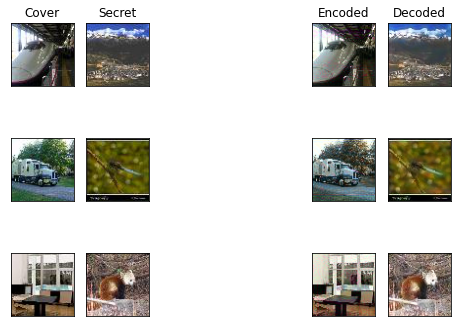

In [ ]:
# Configs for results display

SHOW_GRAY = False
SHOW_DIFF = True
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 3

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(16, 6))
rand_indx = [random.randint(0, 500) for x in range(n)]
for i, idx in enumerate(rand_indx):
    n_col = 12 if SHOW_DIFF else 8   
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')
    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    show_image(decoded_C[idx], n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Encoded')   
    show_image(decoded_S[idx], n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Decoded')
plt.show()